# Visual Reasoning Baseline Model

1. Data preprocessing 어떻게 하면될까?
 - Image feature를 resnet으로 미리 추출해둘까? --> baseline돌리기 까다로움
 - DataLoader 구성을 어떻게하면 좋을까? --> DataSet class 안에서 feature를 return 할까? 아니면 ResNet을 밖에둘까


2. Baseline Model 설계를 어떻게?
 - Encoder: image encoding 어떻게 하면 될까? Answer Image 3개를 한꺼번에 encoding? 혹은 각각 encoding 한 후 Weight Sum??
 - Decoder: Answer 후보 중 정답후보를 어떻게 고를까? Similarity 기준? KL 같은 분포기준? Attention 기반 Scoring??


3. SOTA Model 설계를 어떻게? 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]= "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## 1. Import all packages

In [2]:
import pandas as pd
import numpy as np
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from PIL import Image, ImageDraw
import cv2

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
#font_location = './NanumGothic.ttf'
#font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#matplotlib.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.


## 2. Preparation of datasets

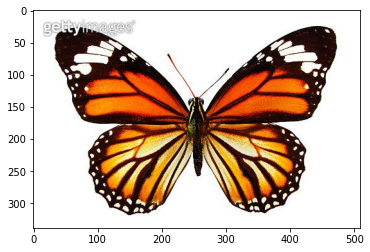

In [3]:
class Config:
    def __init__(self, args=None):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.distributed = False
        self.gpu_id = "0"
        self.HOME_DIR = "/home/cschoi/Visual_Reasoning/datasets/task2/"
        self.FOLDER_NAME = os.listdir(f"{self.HOME_DIR}/")[0]+'/'
        file_list = os.listdir(f"{self.HOME_DIR}{self.FOLDER_NAME}")
        for file_name in file_list:
            if file_name.endswith('.json'):
                json_file = file_name
                file_list.remove(file_name)
        self.IMAGE_LIST = file_list
        self.JSON_NAME = json_file
        self.input_dim = 512
        self.mlp_hidden = 1024


config = Config()
a_image_file = config.HOME_DIR+config.FOLDER_NAME+config.IMAGE_LIST[1]
a_image = plt.imread(a_image_file)
plt.imshow(a_image)

In [5]:
home_dir = config.HOME_DIR
dir_list = os.listdir(home_dir)
sample_list = []
try:
    for directory in dir_list:
        FOLDER_NAME = directory+"/"
        JSON_NAME = directory+".json"
        FILE_PATH = home_dir+FOLDER_NAME
        a_data = json.load(open(FILE_PATH+JSON_NAME))
        a_data["file_path"] = FILE_PATH
        a_data["answer1"] = [a_data["Answers"][0]]
        a_data["answer2"] = [a_data["Answers"][1]]
        a_data["answer3"] = [a_data["Answers"][2]]
        del a_data["Answers"]
        sample_list.append(a_data)
except:
    print(FILE_PATH)

- 070752 이미지 하나 부족 -> 삭제  
- 069191 이미지 하나 부족 -> 삭제  
- 113240 이미지 하나 부족 -> 삭제

In [6]:
def get_data(config):
    
    home_dir = config.HOME_DIR
    dir_list = os.listdir(home_dir)
    sample_list = []
    
    for directory in dir_list:
        FOLDER_NAME = directory+"/"
        JSON_NAME = directory+".json"
        FILE_PATH = home_dir+FOLDER_NAME
        a_data = json.load(open(FILE_PATH+JSON_NAME))
        a_data["file_path"] = FILE_PATH
        a_data["answer1"] = [a_data["Answers"][0]]
        a_data["answer2"] = [a_data["Answers"][1]]
        a_data["answer3"] = [a_data["Answers"][2]]
        del a_data["Answers"]
        sample_list.append(a_data)
        
    return sample_list

def get_img_argumentation():
    #이미지 전처리를 위한 이미지 크기 변환 및 각도조정을 위한 transform 선언

    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    
    return transform


In [10]:
class Similarity1_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, config=None, transform=None):
        self.df = df
        self.config = config
        self.transform = transform
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        try:

            sample = self.df.iloc[idx]
            
            target = sample["correct_answer_group_ID"][0]
            category = sample["category"]
            q_img = sample["file_path"] + sample["Questions"][0]["images"][0]["image_url"]
            a1_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer1"][0]["images"]]
            a2_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer2"][0]["images"]]
            a3_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer3"][0]["images"]]
            
            q_img_feature = Image.open(q_img).convert('RGB')  #이미지 데이터를 RGB형태로 읽음 
            q_img_feature = self.transform(q_img_feature)  #이미지 데이터의 크기 및 각도등을 변경
            
            a1_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a1_img]
            a2_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a2_img]
            a3_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a3_img]
        except:
            print(sample,"에서 문제 발생")
            pass
        
        return {
            "target": target,
            "q_img": q_img_feature,
            "a1_imgs": a1_img_feature,
            "a2_imgs": a2_img_feature,
            "a3_imgs" : a3_img_feature 
        }
        
    

In [11]:
def make_sequential(in_channels, out_channels, *args, **kwargs):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, *args, **kwargs),
           nn.BatchNorm2d(out_channels),
           nn.ReLu(),
           nn.MaxPool2d(*args, **kwargs))

class VRSimilarity(nn.Module):
    def __init__(self, config):
        super(VRSimilarity, self).__init__()
        
        self.config = config
        self.backborne = torchvision.models.resnet50(pretrained=True)
        self.backborne.fc = nn.Linear(self.backborne.fc.in_features, self.config.input_dim)
        self.fc = nn.Sequential(
                    nn.Linear(self.config.input_dim*2, self.config.mlp_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(self.config.mlp_hidden, 2),
        )

    def forward(self, samples):
        
        #Question Image Feature
        q = self.backborne(samples["q_img"])
        
        #Answer Image Feature
        a1_img1 = self.backborne(samples["a1_imgs"][0])
        a2_img1 = self.backborne(samples["a2_imgs"][0])
        a3_img1 = self.backborne(samples["a3_imgs"][0])

        
        q_a1 = torch.cat([q, a1_img1], axis=1)
        q_a2 = torch.cat([q, a2_img1], axis=1)
        q_a3 = torch.cat([q, a3_img1], axis=1)

        
        q_a1_logit = self.fc(q_a1)
        q_a2_logit = self.fc(q_a2)
        q_a3_logit = self.fc(q_a3)

        
        return {
            "q_a1_logit": F.log_softmax(q_a1_logit, dim=1),
            "q_a2_logit": F.log_softmax(q_a2_logit, dim=1),
            "q_a3_logit": F.log_softmax(q_a3_logit, dim=1)

        }


In [12]:
def train_fn(model, train_loader, optimizer, loss_fn, config):
    
    total_count_correct = 0
    total_num_example = 0
    total_loss = []
    
    model.train()
    device = config.device
    
    for batch in tqdm(train_loader):          
        
        #Question Image Feature
        batch["q_img"] = batch["q_img"].to(device)
        
        #Answer Image Feature
        batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
        batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
        batch["a3_imgs"][0] = batch["a3_imgs"][0].to(device)

        logits = model(batch)

        target_a1, target_a2, target_a3 = (batch["target"] == 1).type(torch.long).to(device), (batch["target"] == 2).type(torch.long).to(device),(batch["target"] == 3).type(torch.long).to(device)

        #loss_a1 = loss_fn(logits["q_a1_logit"].squeeze() if (len(logits["q_a1_logit"].shape) >= 2) else logits["q_a1_logit"], target_a1)
        #loss_a2 = loss_fn(logits["q_a2_logit"].squeeze() if (len(logits["q_a2_logit"].shape) >= 2) else logits["q_a2_logit"], target_a2)
        loss_a1 = loss_fn(logits["q_a1_logit"].squeeze(), target_a1)
        loss_a2 = loss_fn(logits["q_a2_logit"].squeeze(), target_a2)
        loss_a3 = loss_fn(logits["q_a3_logit"].squeeze(), target_a3)

        #print(loss_a1.item())
        
        loss = loss_a1 + loss_a2 + loss_a3
        total_loss.append(loss.item())
        
        #predicted_a1 = (torch.sigmoid(logits["q_a1_logit"]) > 0.5).float()
        predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
        total_num_example = total_num_example + target_a1.size(0)
        
#         print(predicted_a1)
#         print(target_a1)
#         print(predicted_a1 == target_a1)
        
        #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
        predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
        total_num_example = total_num_example + target_a2.size(0)
#         print(predicted_a2)
#         print(target_a2)
#         print(predicted_a2 == target_a2)

        #predicted_a3 = (torch.sigmoid(logits["q_a3_logit"]) > 0.5).float()
        predicted_a3 = logits["q_a3_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a3 == target_a3).item()
        total_num_example = total_num_example + target_a3.size(0)
#         print(predicted_a3)
#         print(target_a3)
#         print(predicted_a3 == target_a3)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print("total_count_correct", total_count_correct)
        print("total_num_example", total_num_example)
        
    print("TRAIN_LOSS:", str(sum(total_loss)/total_num_example) + " TRAIN_Accuracy: " + str(total_count_correct/total_num_example) )
    print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )


In [13]:
config = Config()

sample_list = get_data(config)
df = pd.DataFrame(sample_list)
train_df, test_df = train_test_split(df)
transform = get_img_argumentation()
train_datasets = Similarity1_Dataset(train_df, transform=transform)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=32)

vrs1_model = VRSimilarity(config)
#vrs1_model = torch.nn.DataParallel(vrs1_model)
vrs1_model = vrs1_model.to(config.device)
if config.distributed:
    #model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[config.gpu])    
    model = torch.nn.parallel.DistributedDataParallel(model)    

optimizer = torch.optim.Adam(vrs1_model.parameters(), lr=0.0001)
#loss_fn = nn.BCELoss()
loss_fn = nn.NLLLoss(reduction="sum")


In [14]:
optimizer = torch.optim.Adam(vrs1_model.parameters(), lr=0.001)
for idx in range(200):
    train_fn(vrs1_model, train_loader, optimizer, loss_fn, config)

  0%|          | 1/447 [00:13<1:40:37, 13.54s/it]

total_count_correct 58
total_num_example 96


  0%|          | 2/447 [00:26<1:37:02, 13.09s/it]

total_count_correct 122
total_num_example 192


  1%|          | 3/447 [00:38<1:34:23, 12.76s/it]

total_count_correct 154
total_num_example 288


  1%|          | 4/447 [00:51<1:35:11, 12.89s/it]

total_count_correct 209
total_num_example 384


  1%|          | 5/447 [01:04<1:34:13, 12.79s/it]

total_count_correct 273
total_num_example 480


  1%|▏         | 6/447 [01:16<1:32:41, 12.61s/it]

total_count_correct 337
total_num_example 576


  2%|▏         | 7/447 [01:29<1:32:04, 12.55s/it]

total_count_correct 401
total_num_example 672


  2%|▏         | 8/447 [01:42<1:33:04, 12.72s/it]

total_count_correct 464
total_num_example 768


  2%|▏         | 9/447 [01:54<1:32:10, 12.63s/it]

total_count_correct 526
total_num_example 864


  2%|▏         | 10/447 [02:08<1:34:51, 13.02s/it]

total_count_correct 590
total_num_example 960


  2%|▏         | 11/447 [02:20<1:32:15, 12.70s/it]

total_count_correct 654
total_num_example 1056


  3%|▎         | 12/447 [02:33<1:32:58, 12.82s/it]

total_count_correct 718
total_num_example 1152


  3%|▎         | 13/447 [02:44<1:28:00, 12.17s/it]

total_count_correct 780
total_num_example 1248


  3%|▎         | 14/447 [02:55<1:25:08, 11.80s/it]

total_count_correct 842
total_num_example 1344


  3%|▎         | 15/447 [03:07<1:25:31, 11.88s/it]

total_count_correct 904
total_num_example 1440


  4%|▎         | 16/447 [03:21<1:29:31, 12.46s/it]

total_count_correct 968
total_num_example 1536


  4%|▍         | 17/447 [03:33<1:30:12, 12.59s/it]

total_count_correct 1032
total_num_example 1632


  4%|▍         | 18/447 [03:46<1:30:42, 12.69s/it]

total_count_correct 1096
total_num_example 1728


  4%|▍         | 19/447 [03:59<1:29:45, 12.58s/it]

total_count_correct 1160
total_num_example 1824


  4%|▍         | 20/447 [04:10<1:27:00, 12.23s/it]

total_count_correct 1224
total_num_example 1920


  5%|▍         | 21/447 [04:23<1:28:03, 12.40s/it]

total_count_correct 1287
total_num_example 2016


  5%|▍         | 22/447 [04:35<1:26:24, 12.20s/it]

total_count_correct 1351
total_num_example 2112


  5%|▌         | 23/447 [04:48<1:29:02, 12.60s/it]

total_count_correct 1415
total_num_example 2208


  5%|▌         | 24/447 [05:01<1:28:58, 12.62s/it]

total_count_correct 1479
total_num_example 2304


  6%|▌         | 25/447 [05:14<1:29:36, 12.74s/it]

total_count_correct 1543
total_num_example 2400


  6%|▌         | 26/447 [05:25<1:26:23, 12.31s/it]

total_count_correct 1607
total_num_example 2496


  6%|▌         | 27/447 [05:38<1:27:10, 12.45s/it]

total_count_correct 1670
total_num_example 2592


  6%|▋         | 28/447 [05:52<1:29:21, 12.80s/it]

total_count_correct 1734
total_num_example 2688


  6%|▋         | 29/447 [06:03<1:27:21, 12.54s/it]

total_count_correct 1798
total_num_example 2784


  7%|▋         | 30/447 [06:16<1:27:11, 12.55s/it]

total_count_correct 1862
total_num_example 2880


  7%|▋         | 31/447 [06:28<1:26:39, 12.50s/it]

total_count_correct 1926
total_num_example 2976


  7%|▋         | 32/447 [06:41<1:25:52, 12.41s/it]

total_count_correct 1989
total_num_example 3072


  7%|▋         | 33/447 [06:52<1:22:33, 11.96s/it]

total_count_correct 2053
total_num_example 3168


  8%|▊         | 34/447 [07:05<1:26:07, 12.51s/it]

total_count_correct 2116
total_num_example 3264


  8%|▊         | 35/447 [07:18<1:25:46, 12.49s/it]

total_count_correct 2180
total_num_example 3360


  8%|▊         | 36/447 [07:31<1:26:13, 12.59s/it]

total_count_correct 2244
total_num_example 3456


  8%|▊         | 37/447 [07:42<1:24:30, 12.37s/it]

total_count_correct 2306
total_num_example 3552


  9%|▊         | 38/447 [07:55<1:25:06, 12.49s/it]

total_count_correct 2371
total_num_example 3648


  9%|▊         | 39/447 [08:07<1:24:28, 12.42s/it]

total_count_correct 2436
total_num_example 3744


  9%|▉         | 40/447 [08:21<1:26:09, 12.70s/it]

total_count_correct 2500
total_num_example 3840


  9%|▉         | 41/447 [08:32<1:22:26, 12.18s/it]

total_count_correct 2564
total_num_example 3936


  9%|▉         | 42/447 [08:43<1:20:36, 11.94s/it]

total_count_correct 2628
total_num_example 4032


 10%|▉         | 43/447 [08:56<1:21:23, 12.09s/it]

total_count_correct 2691
total_num_example 4128


 10%|▉         | 44/447 [09:08<1:21:25, 12.12s/it]

total_count_correct 2753
total_num_example 4224


 10%|█         | 45/447 [09:20<1:20:53, 12.07s/it]

total_count_correct 2818
total_num_example 4320


 10%|█         | 46/447 [09:33<1:22:00, 12.27s/it]

total_count_correct 2882
total_num_example 4416


 11%|█         | 47/447 [09:46<1:24:05, 12.61s/it]

total_count_correct 2946
total_num_example 4512


 11%|█         | 48/447 [09:59<1:25:05, 12.80s/it]

total_count_correct 3011
total_num_example 4608


 11%|█         | 49/447 [10:11<1:23:40, 12.61s/it]

total_count_correct 3074
total_num_example 4704


 11%|█         | 50/447 [10:24<1:23:06, 12.56s/it]

total_count_correct 3135
total_num_example 4800


 11%|█▏        | 51/447 [10:36<1:23:08, 12.60s/it]

total_count_correct 3201
total_num_example 4896


 12%|█▏        | 52/447 [10:49<1:23:23, 12.67s/it]

total_count_correct 3265
total_num_example 4992


 12%|█▏        | 53/447 [11:03<1:24:35, 12.88s/it]

total_count_correct 3329
total_num_example 5088


 12%|█▏        | 54/447 [11:15<1:23:35, 12.76s/it]

total_count_correct 3393
total_num_example 5184


 12%|█▏        | 55/447 [11:28<1:23:46, 12.82s/it]

total_count_correct 3457
total_num_example 5280


 13%|█▎        | 56/447 [11:41<1:23:24, 12.80s/it]

total_count_correct 3521
total_num_example 5376


 13%|█▎        | 57/447 [11:53<1:22:22, 12.67s/it]

total_count_correct 3585
total_num_example 5472


 13%|█▎        | 58/447 [12:05<1:20:42, 12.45s/it]

total_count_correct 3649
total_num_example 5568


 13%|█▎        | 59/447 [12:19<1:22:27, 12.75s/it]

total_count_correct 3713
total_num_example 5664


 13%|█▎        | 60/447 [12:30<1:18:54, 12.23s/it]

total_count_correct 3776
total_num_example 5760


 14%|█▎        | 61/447 [12:42<1:19:44, 12.39s/it]

total_count_correct 3839
total_num_example 5856


 14%|█▍        | 62/447 [12:55<1:20:05, 12.48s/it]

total_count_correct 3903
total_num_example 5952


 14%|█▍        | 63/447 [13:06<1:17:31, 12.11s/it]

total_count_correct 3967
total_num_example 6048


 14%|█▍        | 64/447 [13:19<1:17:57, 12.21s/it]

total_count_correct 4031
total_num_example 6144


 15%|█▍        | 65/447 [13:32<1:20:28, 12.64s/it]

total_count_correct 4095
total_num_example 6240


 15%|█▍        | 66/447 [13:45<1:19:46, 12.56s/it]

total_count_correct 4160
total_num_example 6336


 15%|█▍        | 67/447 [13:57<1:18:38, 12.42s/it]

total_count_correct 4224
total_num_example 6432


 15%|█▌        | 68/447 [14:07<1:14:28, 11.79s/it]

total_count_correct 4289
total_num_example 6528


 15%|█▌        | 69/447 [14:18<1:13:14, 11.63s/it]

total_count_correct 4353
total_num_example 6624


 16%|█▌        | 70/447 [14:30<1:13:39, 11.72s/it]

total_count_correct 4417
total_num_example 6720


 16%|█▌        | 71/447 [14:43<1:14:30, 11.89s/it]

total_count_correct 4481
total_num_example 6816


 16%|█▌        | 72/447 [14:56<1:17:10, 12.35s/it]

total_count_correct 4545
total_num_example 6912


 16%|█▋        | 73/447 [15:08<1:16:07, 12.21s/it]

total_count_correct 4609
total_num_example 7008


 17%|█▋        | 74/447 [15:21<1:17:26, 12.46s/it]

total_count_correct 4673
total_num_example 7104


 17%|█▋        | 75/447 [15:33<1:15:25, 12.17s/it]

total_count_correct 4737
total_num_example 7200


 17%|█▋        | 76/447 [15:46<1:16:47, 12.42s/it]

total_count_correct 4800
total_num_example 7296


 17%|█▋        | 77/447 [15:59<1:17:48, 12.62s/it]

total_count_correct 4864
total_num_example 7392


 17%|█▋        | 78/447 [16:12<1:18:12, 12.72s/it]

total_count_correct 4927
total_num_example 7488


 18%|█▊        | 79/447 [16:23<1:16:09, 12.42s/it]

total_count_correct 4992
total_num_example 7584


 18%|█▊        | 80/447 [16:36<1:15:38, 12.37s/it]

total_count_correct 5056
total_num_example 7680


 18%|█▊        | 81/447 [16:48<1:16:29, 12.54s/it]

total_count_correct 5121
total_num_example 7776


 18%|█▊        | 82/447 [16:59<1:12:58, 12.00s/it]

total_count_correct 5186
total_num_example 7872


 19%|█▊        | 83/447 [17:13<1:15:38, 12.47s/it]

total_count_correct 5250
total_num_example 7968


 19%|█▉        | 84/447 [17:25<1:14:53, 12.38s/it]

total_count_correct 5314
total_num_example 8064


 19%|█▉        | 85/447 [17:37<1:14:42, 12.38s/it]

total_count_correct 5376
total_num_example 8160


 19%|█▉        | 86/447 [17:50<1:15:08, 12.49s/it]

total_count_correct 5438
total_num_example 8256


 19%|█▉        | 87/447 [18:03<1:15:49, 12.64s/it]

total_count_correct 5503
total_num_example 8352


 20%|█▉        | 88/447 [18:17<1:17:55, 13.02s/it]

total_count_correct 5571
total_num_example 8448


 20%|█▉        | 89/447 [18:30<1:17:55, 13.06s/it]

total_count_correct 5636
total_num_example 8544


 20%|██        | 90/447 [18:43<1:17:45, 13.07s/it]

total_count_correct 5701
total_num_example 8640


 20%|██        | 91/447 [18:55<1:15:50, 12.78s/it]

total_count_correct 5761
total_num_example 8736


 21%|██        | 92/447 [19:07<1:12:59, 12.34s/it]

total_count_correct 5823
total_num_example 8832


 21%|██        | 93/447 [19:19<1:13:38, 12.48s/it]

total_count_correct 5884
total_num_example 8928


 21%|██        | 94/447 [19:34<1:16:36, 13.02s/it]

total_count_correct 5949
total_num_example 9024


 21%|██▏       | 95/447 [19:45<1:12:37, 12.38s/it]

total_count_correct 6013
total_num_example 9120


 21%|██▏       | 96/447 [19:57<1:12:26, 12.38s/it]

total_count_correct 6077
total_num_example 9216


 22%|██▏       | 97/447 [20:10<1:13:32, 12.61s/it]

total_count_correct 6140
total_num_example 9312


 22%|██▏       | 98/447 [20:23<1:13:26, 12.63s/it]

total_count_correct 6204
total_num_example 9408


 22%|██▏       | 99/447 [20:35<1:12:39, 12.53s/it]

total_count_correct 6267
total_num_example 9504


 22%|██▏       | 100/447 [20:49<1:15:15, 13.01s/it]

total_count_correct 6332
total_num_example 9600


 23%|██▎       | 101/447 [21:01<1:13:18, 12.71s/it]

total_count_correct 6394
total_num_example 9696


 23%|██▎       | 102/447 [21:14<1:13:52, 12.85s/it]

total_count_correct 6458
total_num_example 9792


 23%|██▎       | 103/447 [21:27<1:13:33, 12.83s/it]

total_count_correct 6521
total_num_example 9888


 23%|██▎       | 104/447 [21:41<1:14:10, 12.97s/it]

total_count_correct 6585
total_num_example 9984


 23%|██▎       | 105/447 [21:54<1:15:02, 13.17s/it]

total_count_correct 6649
total_num_example 10080


 24%|██▎       | 106/447 [22:06<1:13:18, 12.90s/it]

total_count_correct 6713
total_num_example 10176


 24%|██▍       | 107/447 [22:20<1:13:41, 13.00s/it]

total_count_correct 6777
total_num_example 10272


 24%|██▍       | 108/447 [22:32<1:12:18, 12.80s/it]

total_count_correct 6841
total_num_example 10368


 24%|██▍       | 109/447 [22:44<1:11:25, 12.68s/it]

total_count_correct 6905
total_num_example 10464


 25%|██▍       | 110/447 [22:57<1:11:52, 12.80s/it]

total_count_correct 6969
total_num_example 10560


 25%|██▍       | 111/447 [23:10<1:11:21, 12.74s/it]

total_count_correct 7033
total_num_example 10656


 25%|██▌       | 112/447 [23:22<1:10:01, 12.54s/it]

total_count_correct 7097
total_num_example 10752


 25%|██▌       | 113/447 [23:34<1:09:29, 12.48s/it]

total_count_correct 7161
total_num_example 10848


 26%|██▌       | 114/447 [23:47<1:10:00, 12.61s/it]

total_count_correct 7224
total_num_example 10944


 26%|██▌       | 115/447 [24:00<1:09:45, 12.61s/it]

total_count_correct 7288
total_num_example 11040


 26%|██▌       | 116/447 [24:14<1:11:52, 13.03s/it]

total_count_correct 7353
total_num_example 11136


 26%|██▌       | 117/447 [24:26<1:10:21, 12.79s/it]

total_count_correct 7419
total_num_example 11232


 26%|██▋       | 118/447 [24:39<1:10:28, 12.85s/it]

total_count_correct 7482
total_num_example 11328


 27%|██▋       | 119/447 [24:52<1:09:39, 12.74s/it]

total_count_correct 7542
total_num_example 11424


 27%|██▋       | 120/447 [25:04<1:08:29, 12.57s/it]

total_count_correct 7604
total_num_example 11520


 27%|██▋       | 121/447 [25:17<1:08:42, 12.64s/it]

total_count_correct 7667
total_num_example 11616


 27%|██▋       | 122/447 [25:30<1:09:13, 12.78s/it]

total_count_correct 7725
total_num_example 11712


 28%|██▊       | 123/447 [25:43<1:08:55, 12.76s/it]

total_count_correct 7791
total_num_example 11808


 28%|██▊       | 124/447 [25:55<1:08:15, 12.68s/it]

total_count_correct 7856
total_num_example 11904


 28%|██▊       | 125/447 [26:07<1:07:31, 12.58s/it]

total_count_correct 7921
total_num_example 12000


 28%|██▊       | 126/447 [26:20<1:07:53, 12.69s/it]

total_count_correct 7988
total_num_example 12096


 28%|██▊       | 127/447 [26:33<1:07:07, 12.58s/it]

total_count_correct 8051
total_num_example 12192


 29%|██▊       | 128/447 [26:46<1:08:34, 12.90s/it]

total_count_correct 8114
total_num_example 12288


 29%|██▉       | 129/447 [26:59<1:08:04, 12.84s/it]

total_count_correct 8177
total_num_example 12384


 29%|██▉       | 130/447 [27:12<1:08:16, 12.92s/it]

total_count_correct 8243
total_num_example 12480


 29%|██▉       | 131/447 [27:25<1:07:56, 12.90s/it]

total_count_correct 8308
total_num_example 12576


 30%|██▉       | 132/447 [27:38<1:07:30, 12.86s/it]

total_count_correct 8374
total_num_example 12672


 30%|██▉       | 133/447 [27:50<1:07:10, 12.84s/it]

total_count_correct 8438
total_num_example 12768


 30%|██▉       | 134/447 [28:02<1:05:21, 12.53s/it]

total_count_correct 8501
total_num_example 12864


 30%|███       | 135/447 [28:15<1:04:40, 12.44s/it]

total_count_correct 8564
total_num_example 12960


 30%|███       | 136/447 [28:27<1:04:36, 12.47s/it]

total_count_correct 8627
total_num_example 13056


 31%|███       | 137/447 [28:40<1:05:25, 12.66s/it]

total_count_correct 8683
total_num_example 13152


 31%|███       | 138/447 [28:53<1:04:45, 12.58s/it]

total_count_correct 8745
total_num_example 13248


 31%|███       | 139/447 [29:07<1:06:49, 13.02s/it]

total_count_correct 8806
total_num_example 13344


 31%|███▏      | 140/447 [29:19<1:05:23, 12.78s/it]

total_count_correct 8867
total_num_example 13440


 32%|███▏      | 141/447 [29:32<1:05:12, 12.78s/it]

total_count_correct 8929
total_num_example 13536


 32%|███▏      | 142/447 [29:44<1:04:45, 12.74s/it]

total_count_correct 8992
total_num_example 13632


 32%|███▏      | 143/447 [29:57<1:03:54, 12.61s/it]

total_count_correct 9056
total_num_example 13728


 32%|███▏      | 144/447 [30:09<1:03:25, 12.56s/it]

total_count_correct 9120
total_num_example 13824


 32%|███▏      | 145/447 [30:22<1:04:04, 12.73s/it]

total_count_correct 9185
total_num_example 13920


 33%|███▎      | 146/447 [30:33<1:00:57, 12.15s/it]

total_count_correct 9248
total_num_example 14016


 33%|███▎      | 147/447 [30:45<1:00:28, 12.09s/it]

total_count_correct 9310
total_num_example 14112


 33%|███▎      | 148/447 [30:57<59:49, 12.01s/it]  

total_count_correct 9376
total_num_example 14208


 33%|███▎      | 149/447 [31:09<59:24, 11.96s/it]

total_count_correct 9439
total_num_example 14304


 34%|███▎      | 150/447 [31:21<59:18, 11.98s/it]

total_count_correct 9507
total_num_example 14400


 34%|███▍      | 151/447 [31:33<59:04, 11.98s/it]

total_count_correct 9568
total_num_example 14496


 34%|███▍      | 152/447 [31:46<1:00:54, 12.39s/it]

total_count_correct 9633
total_num_example 14592


 34%|███▍      | 153/447 [31:59<1:01:16, 12.50s/it]

total_count_correct 9698
total_num_example 14688


 34%|███▍      | 154/447 [32:10<59:31, 12.19s/it]  

total_count_correct 9764
total_num_example 14784


 35%|███▍      | 155/447 [32:22<59:17, 12.18s/it]

total_count_correct 9831
total_num_example 14880


 35%|███▍      | 156/447 [32:35<59:10, 12.20s/it]

total_count_correct 9895
total_num_example 14976


 35%|███▌      | 157/447 [32:47<1:00:03, 12.43s/it]

total_count_correct 9963
total_num_example 15072


 35%|███▌      | 158/447 [33:01<1:01:06, 12.69s/it]

total_count_correct 10027
total_num_example 15168


 36%|███▌      | 159/447 [33:13<1:00:06, 12.52s/it]

total_count_correct 10092
total_num_example 15264


 36%|███▌      | 160/447 [33:26<1:00:23, 12.63s/it]

total_count_correct 10157
total_num_example 15360


 36%|███▌      | 161/447 [33:38<59:14, 12.43s/it]  

total_count_correct 10218
total_num_example 15456


 36%|███▌      | 162/447 [33:50<59:06, 12.44s/it]

total_count_correct 10285
total_num_example 15552


 36%|███▋      | 163/447 [34:03<59:36, 12.59s/it]

total_count_correct 10351
total_num_example 15648


 37%|███▋      | 164/447 [34:16<59:02, 12.52s/it]

total_count_correct 10417
total_num_example 15744


 37%|███▋      | 165/447 [34:28<59:11, 12.59s/it]

total_count_correct 10480
total_num_example 15840


 37%|███▋      | 166/447 [34:41<59:34, 12.72s/it]

total_count_correct 10545
total_num_example 15936


 37%|███▋      | 167/447 [34:54<59:32, 12.76s/it]

total_count_correct 10612
total_num_example 16032


 38%|███▊      | 168/447 [35:07<59:31, 12.80s/it]

total_count_correct 10677
total_num_example 16128


 38%|███▊      | 169/447 [35:21<1:00:24, 13.04s/it]

total_count_correct 10745
total_num_example 16224


 38%|███▊      | 170/447 [35:33<59:05, 12.80s/it]  

total_count_correct 10809
total_num_example 16320


 38%|███▊      | 171/447 [35:45<57:23, 12.48s/it]

total_count_correct 10877
total_num_example 16416


 38%|███▊      | 172/447 [35:57<57:15, 12.49s/it]

total_count_correct 10944
total_num_example 16512


 39%|███▊      | 173/447 [36:08<54:17, 11.89s/it]

total_count_correct 11019
total_num_example 16608


 39%|███▉      | 174/447 [36:20<54:36, 12.00s/it]

total_count_correct 11080
total_num_example 16704


 39%|███▉      | 175/447 [36:32<54:37, 12.05s/it]

total_count_correct 11142
total_num_example 16800


 39%|███▉      | 176/447 [36:46<57:00, 12.62s/it]

total_count_correct 11205
total_num_example 16896


 40%|███▉      | 177/447 [36:58<56:10, 12.48s/it]

total_count_correct 11269
total_num_example 16992


 40%|███▉      | 178/447 [37:10<55:18, 12.34s/it]

total_count_correct 11337
total_num_example 17088


 40%|████      | 179/447 [37:23<55:47, 12.49s/it]

total_count_correct 11404
total_num_example 17184


 40%|████      | 180/447 [37:36<55:42, 12.52s/it]

total_count_correct 11471
total_num_example 17280


 40%|████      | 181/447 [37:48<55:42, 12.57s/it]

total_count_correct 11534
total_num_example 17376


 41%|████      | 182/447 [38:02<56:59, 12.90s/it]

total_count_correct 11598
total_num_example 17472


 41%|████      | 183/447 [38:14<55:01, 12.51s/it]

total_count_correct 11663
total_num_example 17568


 41%|████      | 184/447 [38:26<54:11, 12.36s/it]

total_count_correct 11724
total_num_example 17664


 41%|████▏     | 185/447 [38:39<55:11, 12.64s/it]

total_count_correct 11789
total_num_example 17760


 42%|████▏     | 186/447 [38:52<55:04, 12.66s/it]

total_count_correct 11857
total_num_example 17856


 42%|████▏     | 187/447 [39:04<55:11, 12.74s/it]

total_count_correct 11925
total_num_example 17952


 42%|████▏     | 188/447 [39:17<54:54, 12.72s/it]

total_count_correct 11994
total_num_example 18048


 42%|████▏     | 189/447 [39:30<54:41, 12.72s/it]

total_count_correct 12058
total_num_example 18144


 43%|████▎     | 190/447 [39:42<54:07, 12.64s/it]

total_count_correct 12126
total_num_example 18240


 43%|████▎     | 191/447 [39:55<54:03, 12.67s/it]

total_count_correct 12189
total_num_example 18336


 43%|████▎     | 192/447 [40:08<54:32, 12.83s/it]

total_count_correct 12259
total_num_example 18432


 43%|████▎     | 193/447 [40:22<56:05, 13.25s/it]

total_count_correct 12327
total_num_example 18528


 43%|████▎     | 194/447 [40:35<54:59, 13.04s/it]

total_count_correct 12397
total_num_example 18624


 44%|████▎     | 195/447 [40:48<54:18, 12.93s/it]

total_count_correct 12463
total_num_example 18720


 44%|████▍     | 196/447 [41:00<52:44, 12.61s/it]

total_count_correct 12527
total_num_example 18816


 44%|████▍     | 197/447 [41:11<51:34, 12.38s/it]

total_count_correct 12593
total_num_example 18912


 44%|████▍     | 198/447 [41:24<51:39, 12.45s/it]

total_count_correct 12656
total_num_example 19008


 45%|████▍     | 199/447 [41:37<51:37, 12.49s/it]

total_count_correct 12718
total_num_example 19104


 45%|████▍     | 200/447 [41:49<51:19, 12.47s/it]

total_count_correct 12783
total_num_example 19200


 45%|████▍     | 201/447 [42:02<52:09, 12.72s/it]

total_count_correct 12849
total_num_example 19296


 45%|████▌     | 202/447 [42:15<52:19, 12.81s/it]

total_count_correct 12917
total_num_example 19392


 45%|████▌     | 203/447 [42:28<52:21, 12.88s/it]

total_count_correct 12981
total_num_example 19488


 46%|████▌     | 204/447 [42:40<50:40, 12.51s/it]

total_count_correct 13047
total_num_example 19584


 46%|████▌     | 205/447 [42:53<50:56, 12.63s/it]

total_count_correct 13115
total_num_example 19680


 46%|████▌     | 206/447 [43:06<50:38, 12.61s/it]

total_count_correct 13180
total_num_example 19776


 46%|████▋     | 207/447 [43:17<49:27, 12.36s/it]

total_count_correct 13246
total_num_example 19872


 47%|████▋     | 208/447 [43:30<49:52, 12.52s/it]

total_count_correct 13311
total_num_example 19968


 47%|████▋     | 209/447 [43:44<51:31, 12.99s/it]

total_count_correct 13378
total_num_example 20064


 47%|████▋     | 210/447 [43:57<50:44, 12.85s/it]

total_count_correct 13441
total_num_example 20160


 47%|████▋     | 211/447 [44:10<50:47, 12.91s/it]

total_count_correct 13511
total_num_example 20256


 47%|████▋     | 212/447 [44:23<50:21, 12.86s/it]

total_count_correct 13579
total_num_example 20352


 48%|████▊     | 213/447 [44:35<50:05, 12.84s/it]

total_count_correct 13640
total_num_example 20448


 48%|████▊     | 214/447 [44:48<49:04, 12.64s/it]

total_count_correct 13702
total_num_example 20544


 48%|████▊     | 215/447 [45:01<49:41, 12.85s/it]

total_count_correct 13767
total_num_example 20640


 48%|████▊     | 216/447 [45:14<49:11, 12.78s/it]

total_count_correct 13834
total_num_example 20736


 49%|████▊     | 217/447 [45:26<48:13, 12.58s/it]

total_count_correct 13907
total_num_example 20832


 49%|████▉     | 218/447 [45:38<48:15, 12.64s/it]

total_count_correct 13972
total_num_example 20928


 49%|████▉     | 219/447 [45:51<48:01, 12.64s/it]

total_count_correct 14038
total_num_example 21024


 49%|████▉     | 220/447 [46:05<49:32, 13.09s/it]

total_count_correct 14100
total_num_example 21120


 49%|████▉     | 221/447 [46:18<48:32, 12.89s/it]

total_count_correct 14168
total_num_example 21216


 50%|████▉     | 222/447 [46:29<47:03, 12.55s/it]

total_count_correct 14234
total_num_example 21312


 50%|████▉     | 223/447 [46:42<46:58, 12.58s/it]

total_count_correct 14296
total_num_example 21408


 50%|█████     | 224/447 [46:54<46:16, 12.45s/it]

total_count_correct 14363
total_num_example 21504


 50%|█████     | 225/447 [47:07<45:58, 12.43s/it]

total_count_correct 14430
total_num_example 21600


 51%|█████     | 226/447 [47:21<47:40, 12.95s/it]

total_count_correct 14492
total_num_example 21696


 51%|█████     | 227/447 [47:34<47:36, 12.98s/it]

total_count_correct 14559
total_num_example 21792


 51%|█████     | 228/447 [47:46<46:43, 12.80s/it]

total_count_correct 14625
total_num_example 21888


 51%|█████     | 229/447 [47:59<46:34, 12.82s/it]

total_count_correct 14688
total_num_example 21984


 51%|█████▏    | 230/447 [48:11<45:53, 12.69s/it]

total_count_correct 14757
total_num_example 22080


 52%|█████▏    | 231/447 [48:24<45:58, 12.77s/it]

total_count_correct 14821
total_num_example 22176


 52%|█████▏    | 232/447 [48:37<45:41, 12.75s/it]

total_count_correct 14885
total_num_example 22272


 52%|█████▏    | 233/447 [48:40<35:23,  9.92s/it]

total_count_correct 14951
total_num_example 22368


 52%|█████▏    | 234/447 [48:41<25:44,  7.25s/it]

total_count_correct 15018
total_num_example 22464


 53%|█████▎    | 235/447 [48:43<19:13,  5.44s/it]

total_count_correct 15086
total_num_example 22560


 53%|█████▎    | 236/447 [48:44<14:25,  4.10s/it]

total_count_correct 15153
total_num_example 22656


 53%|█████▎    | 237/447 [48:45<11:24,  3.26s/it]

total_count_correct 15213
total_num_example 22752


 53%|█████▎    | 238/447 [48:46<09:00,  2.59s/it]

total_count_correct 15281
total_num_example 22848


 53%|█████▎    | 239/447 [48:47<07:39,  2.21s/it]

total_count_correct 15348
total_num_example 22944


 54%|█████▎    | 240/447 [48:48<06:22,  1.85s/it]

total_count_correct 15416
total_num_example 23040


 54%|█████▍    | 241/447 [48:50<05:45,  1.68s/it]

total_count_correct 15485
total_num_example 23136


 54%|█████▍    | 242/447 [48:50<04:49,  1.41s/it]

total_count_correct 15548
total_num_example 23232


 54%|█████▍    | 243/447 [48:52<04:50,  1.42s/it]

total_count_correct 15612
total_num_example 23328


 55%|█████▍    | 244/447 [48:53<04:10,  1.24s/it]

total_count_correct 15681
total_num_example 23424


 55%|█████▍    | 245/447 [48:54<04:20,  1.29s/it]

total_count_correct 15747
total_num_example 23520


 55%|█████▌    | 246/447 [48:55<03:49,  1.14s/it]

total_count_correct 15818
total_num_example 23616


 55%|█████▌    | 247/447 [48:56<03:55,  1.18s/it]

total_count_correct 15880
total_num_example 23712


 55%|█████▌    | 248/447 [48:57<03:37,  1.09s/it]

total_count_correct 15945
total_num_example 23808


 56%|█████▌    | 249/447 [48:58<03:54,  1.18s/it]

total_count_correct 16013
total_num_example 23904


 56%|█████▌    | 250/447 [48:59<03:29,  1.06s/it]

total_count_correct 16081
total_num_example 24000


 56%|█████▌    | 251/447 [49:01<03:50,  1.18s/it]

total_count_correct 16149
total_num_example 24096


 56%|█████▋    | 252/447 [49:01<03:27,  1.07s/it]

total_count_correct 16216
total_num_example 24192


 57%|█████▋    | 253/447 [49:03<03:43,  1.15s/it]

total_count_correct 16285
total_num_example 24288


 57%|█████▋    | 254/447 [49:04<03:28,  1.08s/it]

total_count_correct 16357
total_num_example 24384


 57%|█████▋    | 255/447 [49:05<03:34,  1.12s/it]

total_count_correct 16415
total_num_example 24480


 57%|█████▋    | 256/447 [49:06<03:25,  1.08s/it]

total_count_correct 16481
total_num_example 24576


 57%|█████▋    | 257/447 [49:07<03:19,  1.05s/it]

total_count_correct 16553
total_num_example 24672


 58%|█████▊    | 258/447 [49:08<03:29,  1.11s/it]

total_count_correct 16617
total_num_example 24768


 58%|█████▊    | 259/447 [49:09<03:24,  1.09s/it]

total_count_correct 16680
total_num_example 24864


 58%|█████▊    | 260/447 [49:11<04:09,  1.34s/it]

total_count_correct 16750
total_num_example 24960


 58%|█████▊    | 261/447 [49:13<04:18,  1.39s/it]

total_count_correct 16816
total_num_example 25056


 59%|█████▊    | 262/447 [49:13<03:43,  1.21s/it]

total_count_correct 16883
total_num_example 25152


 59%|█████▉    | 263/447 [49:15<03:56,  1.28s/it]

total_count_correct 16948
total_num_example 25248


 59%|█████▉    | 264/447 [49:16<03:27,  1.13s/it]

total_count_correct 17014
total_num_example 25344


 59%|█████▉    | 265/447 [49:17<03:45,  1.24s/it]

total_count_correct 17084
total_num_example 25440


 60%|█████▉    | 266/447 [49:18<03:20,  1.11s/it]

total_count_correct 17149
total_num_example 25536


 60%|█████▉    | 267/447 [49:19<03:35,  1.20s/it]

total_count_correct 17210
total_num_example 25632


 60%|█████▉    | 268/447 [49:20<03:11,  1.07s/it]

total_count_correct 17279
total_num_example 25728


 60%|██████    | 269/447 [49:21<03:14,  1.10s/it]

total_count_correct 17347
total_num_example 25824


 60%|██████    | 270/447 [49:22<03:07,  1.06s/it]

total_count_correct 17415
total_num_example 25920


 61%|██████    | 271/447 [49:23<03:02,  1.03s/it]

total_count_correct 17487
total_num_example 26016


 61%|██████    | 272/447 [49:24<03:11,  1.09s/it]

total_count_correct 17554
total_num_example 26112


 61%|██████    | 273/447 [49:25<03:05,  1.06s/it]

total_count_correct 17621
total_num_example 26208


 61%|██████▏   | 274/447 [49:27<03:13,  1.12s/it]

total_count_correct 17683
total_num_example 26304


 62%|██████▏   | 275/447 [49:28<03:05,  1.08s/it]

total_count_correct 17755
total_num_example 26400


 62%|██████▏   | 276/447 [49:29<03:17,  1.16s/it]

total_count_correct 17823
total_num_example 26496


 62%|██████▏   | 277/447 [49:30<03:15,  1.15s/it]

total_count_correct 17892
total_num_example 26592


 62%|██████▏   | 278/447 [49:31<03:19,  1.18s/it]

total_count_correct 17962
total_num_example 26688


 62%|██████▏   | 279/447 [49:32<03:09,  1.13s/it]

total_count_correct 18025
total_num_example 26784


 63%|██████▎   | 280/447 [49:34<03:13,  1.16s/it]

total_count_correct 18091
total_num_example 26880


 63%|██████▎   | 281/447 [49:35<03:04,  1.11s/it]

total_count_correct 18158
total_num_example 26976


 63%|██████▎   | 282/447 [49:36<03:13,  1.17s/it]

total_count_correct 18229
total_num_example 27072


 63%|██████▎   | 283/447 [49:37<03:05,  1.13s/it]

total_count_correct 18296
total_num_example 27168


 64%|██████▎   | 284/447 [49:38<03:11,  1.17s/it]

total_count_correct 18366
total_num_example 27264


 64%|██████▍   | 285/447 [49:39<03:07,  1.16s/it]

total_count_correct 18433
total_num_example 27360


 64%|██████▍   | 286/447 [49:40<03:09,  1.18s/it]

total_count_correct 18498
total_num_example 27456


 64%|██████▍   | 287/447 [49:41<02:48,  1.05s/it]

total_count_correct 18566
total_num_example 27552


 64%|██████▍   | 288/447 [49:43<03:07,  1.18s/it]

total_count_correct 18633
total_num_example 27648


 65%|██████▍   | 289/447 [49:43<02:46,  1.06s/it]

total_count_correct 18704
total_num_example 27744


 65%|██████▍   | 290/447 [49:44<02:42,  1.03s/it]

total_count_correct 18769
total_num_example 27840


 65%|██████▌   | 291/447 [49:47<03:38,  1.40s/it]

total_count_correct 18835
total_num_example 27936


 65%|██████▌   | 292/447 [49:48<03:17,  1.27s/it]

total_count_correct 18909
total_num_example 28032


 66%|██████▌   | 293/447 [49:49<03:14,  1.27s/it]

total_count_correct 18975
total_num_example 28128


 66%|██████▌   | 294/447 [49:50<03:11,  1.25s/it]

total_count_correct 19040
total_num_example 28224


 66%|██████▌   | 295/447 [49:52<03:20,  1.32s/it]

total_count_correct 19111
total_num_example 28320


 66%|██████▌   | 296/447 [49:52<02:54,  1.15s/it]

total_count_correct 19184
total_num_example 28416


 66%|██████▋   | 297/447 [49:54<02:55,  1.17s/it]

total_count_correct 19251
total_num_example 28512


 67%|██████▋   | 298/447 [49:55<02:48,  1.13s/it]

total_count_correct 19319
total_num_example 28608


 67%|██████▋   | 299/447 [49:56<02:52,  1.16s/it]

total_count_correct 19390
total_num_example 28704


 67%|██████▋   | 300/447 [49:57<02:45,  1.12s/it]

total_count_correct 19461
total_num_example 28800


 67%|██████▋   | 301/447 [49:58<02:48,  1.15s/it]

total_count_correct 19529
total_num_example 28896


 68%|██████▊   | 302/447 [49:59<02:46,  1.15s/it]

total_count_correct 19601
total_num_example 28992


 68%|██████▊   | 303/447 [50:01<02:50,  1.18s/it]

total_count_correct 19675
total_num_example 29088


 68%|██████▊   | 304/447 [50:02<02:39,  1.12s/it]

total_count_correct 19740
total_num_example 29184


 68%|██████▊   | 305/447 [50:03<02:43,  1.15s/it]

total_count_correct 19804
total_num_example 29280


 68%|██████▊   | 306/447 [50:04<02:38,  1.12s/it]

total_count_correct 19878
total_num_example 29376


 69%|██████▊   | 307/447 [50:05<02:32,  1.09s/it]

total_count_correct 19948
total_num_example 29472


 69%|██████▉   | 308/447 [50:06<02:37,  1.13s/it]

total_count_correct 20012
total_num_example 29568


 69%|██████▉   | 309/447 [50:07<02:46,  1.20s/it]

total_count_correct 20081
total_num_example 29664


 69%|██████▉   | 310/447 [50:08<02:38,  1.16s/it]

total_count_correct 20149
total_num_example 29760


 70%|██████▉   | 311/447 [50:09<02:30,  1.10s/it]

total_count_correct 20218
total_num_example 29856


 70%|██████▉   | 312/447 [50:11<02:34,  1.14s/it]

total_count_correct 20281
total_num_example 29952


 70%|███████   | 313/447 [50:12<02:27,  1.10s/it]

total_count_correct 20351
total_num_example 30048


 70%|███████   | 314/447 [50:13<02:22,  1.07s/it]

total_count_correct 20416
total_num_example 30144


 70%|███████   | 315/447 [50:13<02:09,  1.02it/s]

total_count_correct 20486
total_num_example 30240


 71%|███████   | 316/447 [50:15<02:23,  1.10s/it]

total_count_correct 20552
total_num_example 30336


 71%|███████   | 317/447 [50:16<02:16,  1.05s/it]

total_count_correct 20621
total_num_example 30432


 71%|███████   | 318/447 [50:17<02:18,  1.07s/it]

total_count_correct 20694
total_num_example 30528


 71%|███████▏  | 319/447 [50:18<02:15,  1.06s/it]

total_count_correct 20762
total_num_example 30624


 72%|███████▏  | 320/447 [50:19<02:20,  1.11s/it]

total_count_correct 20834
total_num_example 30720


 72%|███████▏  | 321/447 [50:20<02:14,  1.07s/it]

total_count_correct 20910
total_num_example 30816


 72%|███████▏  | 322/447 [50:22<02:57,  1.42s/it]

total_count_correct 20976
total_num_example 30912


 72%|███████▏  | 323/447 [50:24<02:50,  1.37s/it]

total_count_correct 21053
total_num_example 31008


 72%|███████▏  | 324/447 [50:25<02:37,  1.28s/it]

total_count_correct 21125
total_num_example 31104


 73%|███████▎  | 325/447 [50:26<02:33,  1.26s/it]

total_count_correct 21194
total_num_example 31200


 73%|███████▎  | 326/447 [50:27<02:26,  1.21s/it]

total_count_correct 21264
total_num_example 31296


 73%|███████▎  | 327/447 [50:28<02:26,  1.22s/it]

total_count_correct 21332
total_num_example 31392


 73%|███████▎  | 328/447 [50:29<02:18,  1.17s/it]

total_count_correct 21400
total_num_example 31488


 74%|███████▎  | 329/447 [50:31<02:21,  1.20s/it]

total_count_correct 21474
total_num_example 31584


 74%|███████▍  | 330/447 [50:32<02:14,  1.15s/it]

total_count_correct 21545
total_num_example 31680


 74%|███████▍  | 331/447 [50:33<02:08,  1.10s/it]

total_count_correct 21615
total_num_example 31776


 74%|███████▍  | 332/447 [50:34<02:11,  1.14s/it]

total_count_correct 21687
total_num_example 31872


 74%|███████▍  | 333/447 [50:35<02:14,  1.18s/it]

total_count_correct 21759
total_num_example 31968


 75%|███████▍  | 334/447 [50:36<02:10,  1.15s/it]

total_count_correct 21832
total_num_example 32064


 75%|███████▍  | 335/447 [50:37<02:04,  1.11s/it]

total_count_correct 21900
total_num_example 32160


 75%|███████▌  | 336/447 [50:38<02:07,  1.15s/it]

total_count_correct 21966
total_num_example 32256


 75%|███████▌  | 337/447 [50:39<01:53,  1.03s/it]

total_count_correct 22031
total_num_example 32352


 76%|███████▌  | 338/447 [50:40<01:59,  1.10s/it]

total_count_correct 22095
total_num_example 32448


 76%|███████▌  | 339/447 [50:41<01:48,  1.01s/it]

total_count_correct 22161
total_num_example 32544


 76%|███████▌  | 340/447 [50:43<02:02,  1.14s/it]

total_count_correct 22233
total_num_example 32640


 76%|███████▋  | 341/447 [50:43<01:50,  1.04s/it]

total_count_correct 22302
total_num_example 32736


 77%|███████▋  | 342/447 [50:45<02:01,  1.15s/it]

total_count_correct 22374
total_num_example 32832


 77%|███████▋  | 343/447 [50:46<01:54,  1.10s/it]

total_count_correct 22441
total_num_example 32928


 77%|███████▋  | 344/447 [50:47<01:59,  1.16s/it]

total_count_correct 22512
total_num_example 33024


 77%|███████▋  | 345/447 [50:48<01:49,  1.07s/it]

total_count_correct 22581
total_num_example 33120


 77%|███████▋  | 346/447 [50:49<01:59,  1.19s/it]

total_count_correct 22651
total_num_example 33216


 78%|███████▊  | 347/447 [50:50<01:48,  1.09s/it]

total_count_correct 22718
total_num_example 33312


 78%|███████▊  | 348/447 [50:51<01:42,  1.03s/it]

total_count_correct 22795
total_num_example 33408


 78%|███████▊  | 349/447 [50:52<01:46,  1.09s/it]

total_count_correct 22860
total_num_example 33504


 78%|███████▊  | 350/447 [50:53<01:43,  1.06s/it]

total_count_correct 22931
total_num_example 33600


 79%|███████▊  | 351/447 [50:55<01:48,  1.13s/it]

total_count_correct 23003
total_num_example 33696


 79%|███████▊  | 352/447 [50:57<02:22,  1.50s/it]

total_count_correct 23076
total_num_example 33792


 79%|███████▉  | 353/447 [50:58<02:06,  1.34s/it]

total_count_correct 23142
total_num_example 33888


 79%|███████▉  | 354/447 [50:59<02:03,  1.33s/it]

total_count_correct 23213
total_num_example 33984


 79%|███████▉  | 355/447 [51:00<01:52,  1.23s/it]

total_count_correct 23285
total_num_example 34080


 80%|███████▉  | 356/447 [51:02<01:52,  1.24s/it]

total_count_correct 23352
total_num_example 34176


 80%|███████▉  | 357/447 [51:03<01:45,  1.17s/it]

total_count_correct 23423
total_num_example 34272


 80%|████████  | 358/447 [51:04<01:46,  1.20s/it]

total_count_correct 23492
total_num_example 34368


 80%|████████  | 359/447 [51:05<01:41,  1.15s/it]

total_count_correct 23553
total_num_example 34464


 81%|████████  | 360/447 [51:06<01:43,  1.19s/it]

total_count_correct 23613
total_num_example 34560


 81%|████████  | 361/447 [51:07<01:37,  1.13s/it]

total_count_correct 23680
total_num_example 34656


 81%|████████  | 362/447 [51:09<01:39,  1.17s/it]

total_count_correct 23751
total_num_example 34752


 81%|████████  | 363/447 [51:10<01:34,  1.12s/it]

total_count_correct 23819
total_num_example 34848


 81%|████████▏ | 364/447 [51:11<01:37,  1.18s/it]

total_count_correct 23881
total_num_example 34944


 82%|████████▏ | 365/447 [51:12<01:33,  1.14s/it]

total_count_correct 23951
total_num_example 35040


 82%|████████▏ | 366/447 [51:13<01:35,  1.18s/it]

total_count_correct 24020
total_num_example 35136


 82%|████████▏ | 367/447 [51:14<01:30,  1.13s/it]

total_count_correct 24092
total_num_example 35232


 82%|████████▏ | 368/447 [51:15<01:33,  1.19s/it]

total_count_correct 24164
total_num_example 35328


 83%|████████▎ | 369/447 [51:17<01:28,  1.14s/it]

total_count_correct 24235
total_num_example 35424


 83%|████████▎ | 370/447 [51:18<01:30,  1.17s/it]

total_count_correct 24307
total_num_example 35520


 83%|████████▎ | 371/447 [51:19<01:25,  1.13s/it]

total_count_correct 24376
total_num_example 35616


 83%|████████▎ | 372/447 [51:20<01:28,  1.17s/it]

total_count_correct 24447
total_num_example 35712


 83%|████████▎ | 373/447 [51:21<01:23,  1.14s/it]

total_count_correct 24522
total_num_example 35808


 84%|████████▎ | 374/447 [51:22<01:26,  1.18s/it]

total_count_correct 24592
total_num_example 35904


 84%|████████▍ | 375/447 [51:23<01:23,  1.15s/it]

total_count_correct 24669
total_num_example 36000


 84%|████████▍ | 376/447 [51:25<01:25,  1.20s/it]

total_count_correct 24739
total_num_example 36096


 84%|████████▍ | 377/447 [51:26<01:21,  1.16s/it]

total_count_correct 24814
total_num_example 36192


 85%|████████▍ | 378/447 [51:27<01:21,  1.18s/it]

total_count_correct 24882
total_num_example 36288


 85%|████████▍ | 379/447 [51:28<01:16,  1.13s/it]

total_count_correct 24949
total_num_example 36384


 85%|████████▌ | 380/447 [51:29<01:13,  1.09s/it]

total_count_correct 25022
total_num_example 36480


 85%|████████▌ | 381/447 [51:30<01:05,  1.00it/s]

total_count_correct 25095
total_num_example 36576


 85%|████████▌ | 382/447 [51:32<01:33,  1.44s/it]

total_count_correct 25162
total_num_example 36672


 86%|████████▌ | 383/447 [51:34<01:28,  1.38s/it]

total_count_correct 25231
total_num_example 36768


 86%|████████▌ | 384/447 [51:34<01:15,  1.20s/it]

total_count_correct 25302
total_num_example 36864


 86%|████████▌ | 385/447 [51:36<01:13,  1.19s/it]

total_count_correct 25374
total_num_example 36960


 86%|████████▋ | 386/447 [51:37<01:09,  1.14s/it]

total_count_correct 25441
total_num_example 37056


 87%|████████▋ | 387/447 [51:38<01:09,  1.16s/it]

total_count_correct 25513
total_num_example 37152


 87%|████████▋ | 388/447 [51:39<01:06,  1.14s/it]

total_count_correct 25584
total_num_example 37248


 87%|████████▋ | 389/447 [51:40<01:05,  1.13s/it]

total_count_correct 25656
total_num_example 37344


 87%|████████▋ | 390/447 [51:41<01:04,  1.13s/it]

total_count_correct 25728
total_num_example 37440


 87%|████████▋ | 391/447 [51:42<01:01,  1.09s/it]

total_count_correct 25793
total_num_example 37536


 88%|████████▊ | 392/447 [51:43<01:01,  1.13s/it]

total_count_correct 25858
total_num_example 37632


 88%|████████▊ | 393/447 [51:44<00:58,  1.09s/it]

total_count_correct 25926
total_num_example 37728


 88%|████████▊ | 394/447 [51:46<01:00,  1.15s/it]

total_count_correct 26000
total_num_example 37824


 88%|████████▊ | 395/447 [51:47<00:57,  1.11s/it]

total_count_correct 26066
total_num_example 37920


 89%|████████▊ | 396/447 [51:48<00:59,  1.17s/it]

total_count_correct 26135
total_num_example 38016


 89%|████████▉ | 397/447 [51:49<00:57,  1.14s/it]

total_count_correct 26205
total_num_example 38112


 89%|████████▉ | 398/447 [51:50<00:57,  1.17s/it]

total_count_correct 26275
total_num_example 38208


 89%|████████▉ | 399/447 [51:51<00:53,  1.12s/it]

total_count_correct 26349
total_num_example 38304


 89%|████████▉ | 400/447 [51:52<00:51,  1.09s/it]

total_count_correct 26421
total_num_example 38400


 90%|████████▉ | 401/447 [51:53<00:45,  1.00it/s]

total_count_correct 26497
total_num_example 38496


 90%|████████▉ | 402/447 [51:54<00:44,  1.00it/s]

total_count_correct 26567
total_num_example 38592


 90%|█████████ | 403/447 [51:55<00:43,  1.00it/s]

total_count_correct 26642
total_num_example 38688


 90%|█████████ | 404/447 [51:56<00:46,  1.09s/it]

total_count_correct 26712
total_num_example 38784


 91%|█████████ | 405/447 [51:57<00:44,  1.07s/it]

total_count_correct 26779
total_num_example 38880


 91%|█████████ | 406/447 [51:59<00:45,  1.11s/it]

total_count_correct 26843
total_num_example 38976


 91%|█████████ | 407/447 [52:00<00:43,  1.09s/it]

total_count_correct 26918
total_num_example 39072


 91%|█████████▏| 408/447 [52:01<00:43,  1.13s/it]

total_count_correct 26988
total_num_example 39168


 91%|█████████▏| 409/447 [52:02<00:44,  1.16s/it]

total_count_correct 27054
total_num_example 39264


 92%|█████████▏| 410/447 [52:03<00:42,  1.15s/it]

total_count_correct 27120
total_num_example 39360


 92%|█████████▏| 411/447 [52:04<00:40,  1.12s/it]

total_count_correct 27192
total_num_example 39456


 92%|█████████▏| 412/447 [52:05<00:40,  1.15s/it]

total_count_correct 27265
total_num_example 39552


 92%|█████████▏| 413/447 [52:07<00:45,  1.35s/it]

total_count_correct 27334
total_num_example 39648


 93%|█████████▎| 414/447 [52:09<00:43,  1.32s/it]

total_count_correct 27400
total_num_example 39744


 93%|█████████▎| 415/447 [52:10<00:39,  1.24s/it]

total_count_correct 27478
total_num_example 39840


 93%|█████████▎| 416/447 [52:11<00:37,  1.20s/it]

total_count_correct 27546
total_num_example 39936


 93%|█████████▎| 417/447 [52:12<00:35,  1.17s/it]

total_count_correct 27622
total_num_example 40032


 94%|█████████▎| 418/447 [52:13<00:34,  1.18s/it]

total_count_correct 27689
total_num_example 40128


 94%|█████████▎| 419/447 [52:14<00:32,  1.17s/it]

total_count_correct 27756
total_num_example 40224


 94%|█████████▍| 420/447 [52:15<00:30,  1.14s/it]

total_count_correct 27827
total_num_example 40320


 94%|█████████▍| 421/447 [52:16<00:30,  1.16s/it]

total_count_correct 27904
total_num_example 40416


 94%|█████████▍| 422/447 [52:17<00:26,  1.07s/it]

total_count_correct 27977
total_num_example 40512


 95%|█████████▍| 423/447 [52:18<00:25,  1.05s/it]

total_count_correct 28046
total_num_example 40608


 95%|█████████▍| 424/447 [52:19<00:24,  1.05s/it]

total_count_correct 28119
total_num_example 40704


 95%|█████████▌| 425/447 [52:20<00:23,  1.08s/it]

total_count_correct 28185
total_num_example 40800


 95%|█████████▌| 426/447 [52:22<00:22,  1.09s/it]

total_count_correct 28266
total_num_example 40896


 96%|█████████▌| 427/447 [52:23<00:22,  1.11s/it]

total_count_correct 28338
total_num_example 40992


 96%|█████████▌| 428/447 [52:24<00:21,  1.13s/it]

total_count_correct 28407
total_num_example 41088


 96%|█████████▌| 429/447 [52:25<00:19,  1.10s/it]

total_count_correct 28484
total_num_example 41184


 96%|█████████▌| 430/447 [52:26<00:19,  1.14s/it]

total_count_correct 28562
total_num_example 41280


 96%|█████████▋| 431/447 [52:27<00:17,  1.07s/it]

total_count_correct 28626
total_num_example 41376


 97%|█████████▋| 432/447 [52:28<00:16,  1.12s/it]

total_count_correct 28696
total_num_example 41472


 97%|█████████▋| 433/447 [52:29<00:15,  1.08s/it]

total_count_correct 28770
total_num_example 41568


 97%|█████████▋| 434/447 [52:30<00:13,  1.06s/it]

total_count_correct 28841
total_num_example 41664


 97%|█████████▋| 435/447 [52:31<00:12,  1.07s/it]

total_count_correct 28920
total_num_example 41760


 98%|█████████▊| 436/447 [52:33<00:12,  1.12s/it]

total_count_correct 28996
total_num_example 41856


 98%|█████████▊| 437/447 [52:34<00:11,  1.10s/it]

total_count_correct 29063
total_num_example 41952


 98%|█████████▊| 438/447 [52:35<00:10,  1.13s/it]

total_count_correct 29134
total_num_example 42048


 98%|█████████▊| 439/447 [52:36<00:08,  1.12s/it]

total_count_correct 29203
total_num_example 42144


 98%|█████████▊| 440/447 [52:37<00:08,  1.17s/it]

total_count_correct 29266
total_num_example 42240


 99%|█████████▊| 441/447 [52:38<00:06,  1.13s/it]

total_count_correct 29339
total_num_example 42336


 99%|█████████▉| 442/447 [52:39<00:05,  1.13s/it]

total_count_correct 29415
total_num_example 42432


 99%|█████████▉| 443/447 [52:40<00:04,  1.06s/it]

total_count_correct 29483
total_num_example 42528


 99%|█████████▉| 444/447 [52:41<00:03,  1.03s/it]

total_count_correct 29551
total_num_example 42624


100%|█████████▉| 445/447 [52:44<00:02,  1.38s/it]

total_count_correct 29624
total_num_example 42720


100%|█████████▉| 446/447 [52:45<00:01,  1.31s/it]

total_count_correct 29694
total_num_example 42816


100%|██████████| 447/447 [52:46<00:00,  7.08s/it]


total_count_correct 29760
total_num_example 42912
TRAIN_LOSS: 0.5870231876259504 TRAIN_Accuracy: 0.6935123042505593
LOSS: 0.5870231876259504 Accuracy: 0.6935123042505593


  0%|          | 1/447 [00:01<07:53,  1.06s/it]

total_count_correct 77
total_num_example 96


  0%|          | 2/447 [00:02<08:21,  1.13s/it]

total_count_correct 156
total_num_example 192


  1%|          | 3/447 [00:03<07:25,  1.00s/it]

total_count_correct 223
total_num_example 288


  1%|          | 4/447 [00:04<07:23,  1.00s/it]

total_count_correct 288
total_num_example 384


  1%|          | 5/447 [00:05<07:32,  1.02s/it]

total_count_correct 356
total_num_example 480


  1%|▏         | 6/447 [00:06<07:53,  1.07s/it]

total_count_correct 425
total_num_example 576


  2%|▏         | 7/447 [00:07<07:54,  1.08s/it]

total_count_correct 498
total_num_example 672


  2%|▏         | 8/447 [00:08<08:11,  1.12s/it]

total_count_correct 568
total_num_example 768


  2%|▏         | 9/447 [00:09<08:03,  1.11s/it]

total_count_correct 635
total_num_example 864


  2%|▏         | 10/447 [00:10<07:40,  1.05s/it]

total_count_correct 707
total_num_example 960


  2%|▏         | 11/447 [00:11<07:32,  1.04s/it]

total_count_correct 783
total_num_example 1056


  3%|▎         | 12/447 [00:12<07:26,  1.03s/it]

total_count_correct 850
total_num_example 1152


  3%|▎         | 13/447 [00:13<07:47,  1.08s/it]

total_count_correct 927
total_num_example 1248


  3%|▎         | 14/447 [00:14<07:57,  1.10s/it]

total_count_correct 998
total_num_example 1344


  3%|▎         | 15/447 [00:16<08:01,  1.11s/it]

total_count_correct 1068
total_num_example 1440


  4%|▎         | 16/447 [00:17<07:51,  1.09s/it]

total_count_correct 1144
total_num_example 1536


  4%|▍         | 17/447 [00:18<08:05,  1.13s/it]

total_count_correct 1217
total_num_example 1632


  4%|▍         | 18/447 [00:19<07:25,  1.04s/it]

total_count_correct 1290
total_num_example 1728


  4%|▍         | 19/447 [00:20<07:18,  1.02s/it]

total_count_correct 1364
total_num_example 1824


  4%|▍         | 20/447 [00:21<07:33,  1.06s/it]

total_count_correct 1440
total_num_example 1920


  5%|▍         | 21/447 [00:22<07:44,  1.09s/it]

total_count_correct 1509
total_num_example 2016


  5%|▍         | 22/447 [00:23<07:44,  1.09s/it]

total_count_correct 1582
total_num_example 2112


  5%|▌         | 23/447 [00:24<07:51,  1.11s/it]

total_count_correct 1657
total_num_example 2208


  5%|▌         | 24/447 [00:25<07:51,  1.11s/it]

total_count_correct 1734
total_num_example 2304


  6%|▌         | 25/447 [00:27<07:54,  1.12s/it]

total_count_correct 1802
total_num_example 2400


  6%|▌         | 26/447 [00:28<07:57,  1.13s/it]

total_count_correct 1880
total_num_example 2496


  6%|▌         | 27/447 [00:29<07:57,  1.14s/it]

total_count_correct 1946
total_num_example 2592


  6%|▋         | 28/447 [00:30<08:05,  1.16s/it]

total_count_correct 2025
total_num_example 2688


  6%|▋         | 29/447 [00:32<09:28,  1.36s/it]

total_count_correct 2098
total_num_example 2784


  7%|▋         | 30/447 [00:33<09:11,  1.32s/it]

total_count_correct 2163
total_num_example 2880


  7%|▋         | 31/447 [00:34<08:29,  1.23s/it]

total_count_correct 2235
total_num_example 2976


  7%|▋         | 32/447 [00:35<08:05,  1.17s/it]

total_count_correct 2309
total_num_example 3072


  7%|▋         | 33/447 [00:36<08:04,  1.17s/it]

total_count_correct 2379
total_num_example 3168


  8%|▊         | 34/447 [00:37<07:59,  1.16s/it]

total_count_correct 2451
total_num_example 3264


  8%|▊         | 35/447 [00:39<07:52,  1.15s/it]

total_count_correct 2532
total_num_example 3360


  8%|▊         | 36/447 [00:40<07:26,  1.09s/it]

total_count_correct 2591
total_num_example 3456


  8%|▊         | 37/447 [00:41<07:14,  1.06s/it]

total_count_correct 2663
total_num_example 3552


  9%|▊         | 38/447 [00:42<07:06,  1.04s/it]

total_count_correct 2736
total_num_example 3648


  9%|▊         | 39/447 [00:43<07:24,  1.09s/it]

total_count_correct 2806
total_num_example 3744


  9%|▉         | 40/447 [00:44<07:46,  1.15s/it]

total_count_correct 2881
total_num_example 3840


  9%|▉         | 41/447 [00:45<07:31,  1.11s/it]

total_count_correct 2948
total_num_example 3936


  9%|▉         | 42/447 [00:46<06:53,  1.02s/it]

total_count_correct 3026
total_num_example 4032


 10%|▉         | 43/447 [00:47<06:52,  1.02s/it]

total_count_correct 3097
total_num_example 4128


 10%|▉         | 44/447 [00:48<06:49,  1.02s/it]

total_count_correct 3169
total_num_example 4224


 10%|█         | 45/447 [00:49<07:09,  1.07s/it]

total_count_correct 3242
total_num_example 4320


 10%|█         | 46/447 [00:50<07:18,  1.09s/it]

total_count_correct 3316
total_num_example 4416


 11%|█         | 47/447 [00:51<07:05,  1.06s/it]

total_count_correct 3378
total_num_example 4512


 11%|█         | 48/447 [00:52<07:19,  1.10s/it]

total_count_correct 3459
total_num_example 4608


 11%|█         | 49/447 [00:53<07:02,  1.06s/it]

total_count_correct 3528
total_num_example 4704


 11%|█         | 50/447 [00:54<06:52,  1.04s/it]

total_count_correct 3600
total_num_example 4800


 11%|█▏        | 51/447 [00:55<06:47,  1.03s/it]

total_count_correct 3677
total_num_example 4896


 12%|█▏        | 52/447 [00:57<07:23,  1.12s/it]

total_count_correct 3750
total_num_example 4992


 12%|█▏        | 53/447 [00:58<07:13,  1.10s/it]

total_count_correct 3825
total_num_example 5088


 12%|█▏        | 54/447 [00:59<07:16,  1.11s/it]

total_count_correct 3893
total_num_example 5184


 12%|█▏        | 55/447 [01:00<07:08,  1.09s/it]

total_count_correct 3965
total_num_example 5280


 13%|█▎        | 56/447 [01:01<07:16,  1.12s/it]

total_count_correct 4034
total_num_example 5376


 13%|█▎        | 57/447 [01:02<07:18,  1.12s/it]

total_count_correct 4103
total_num_example 5472


 13%|█▎        | 58/447 [01:03<07:21,  1.13s/it]

total_count_correct 4171
total_num_example 5568


 13%|█▎        | 59/447 [01:05<07:28,  1.16s/it]

total_count_correct 4243
total_num_example 5664


 13%|█▎        | 60/447 [01:06<07:22,  1.14s/it]

total_count_correct 4316
total_num_example 5760


 14%|█▎        | 61/447 [01:08<09:45,  1.52s/it]

total_count_correct 4389
total_num_example 5856


 14%|█▍        | 62/447 [01:09<08:17,  1.29s/it]

total_count_correct 4451
total_num_example 5952


 14%|█▍        | 63/447 [01:10<07:44,  1.21s/it]

total_count_correct 4525
total_num_example 6048


 14%|█▍        | 64/447 [01:11<07:24,  1.16s/it]

total_count_correct 4599
total_num_example 6144


 15%|█▍        | 65/447 [01:12<07:21,  1.16s/it]

total_count_correct 4669
total_num_example 6240


 15%|█▍        | 66/447 [01:13<07:14,  1.14s/it]

total_count_correct 4747
total_num_example 6336


 15%|█▍        | 67/447 [01:14<07:28,  1.18s/it]

total_count_correct 4814
total_num_example 6432


 15%|█▌        | 68/447 [01:16<07:15,  1.15s/it]

total_count_correct 4881
total_num_example 6528


 15%|█▌        | 69/447 [01:17<07:06,  1.13s/it]

total_count_correct 4952
total_num_example 6624


 16%|█▌        | 70/447 [01:18<07:07,  1.13s/it]

total_count_correct 5019
total_num_example 6720


 16%|█▌        | 71/447 [01:19<07:14,  1.16s/it]

total_count_correct 5094
total_num_example 6816


 16%|█▌        | 72/447 [01:20<07:09,  1.15s/it]

total_count_correct 5174
total_num_example 6912


 16%|█▋        | 73/447 [01:21<06:37,  1.06s/it]

total_count_correct 5252
total_num_example 7008


 17%|█▋        | 74/447 [01:22<06:29,  1.04s/it]

total_count_correct 5328
total_num_example 7104


 17%|█▋        | 75/447 [01:23<06:28,  1.04s/it]

total_count_correct 5403
total_num_example 7200


 17%|█▋        | 76/447 [01:24<06:42,  1.09s/it]

total_count_correct 5473
total_num_example 7296


 17%|█▋        | 77/447 [01:25<06:51,  1.11s/it]

total_count_correct 5551
total_num_example 7392


 17%|█▋        | 78/447 [01:26<06:51,  1.11s/it]

total_count_correct 5627
total_num_example 7488


 18%|█▊        | 79/447 [01:28<06:46,  1.10s/it]

total_count_correct 5699
total_num_example 7584


 18%|█▊        | 80/447 [01:29<06:52,  1.13s/it]

total_count_correct 5775
total_num_example 7680


 18%|█▊        | 81/447 [01:30<06:54,  1.13s/it]

total_count_correct 5844
total_num_example 7776


 18%|█▊        | 82/447 [01:31<06:54,  1.13s/it]

total_count_correct 5916
total_num_example 7872


 19%|█▊        | 83/447 [01:32<07:02,  1.16s/it]

total_count_correct 5992
total_num_example 7968


 19%|█▉        | 84/447 [01:33<06:25,  1.06s/it]

total_count_correct 6064
total_num_example 8064


 19%|█▉        | 85/447 [01:34<06:19,  1.05s/it]

total_count_correct 6139
total_num_example 8160


 19%|█▉        | 86/447 [01:35<06:14,  1.04s/it]

total_count_correct 6216
total_num_example 8256


 19%|█▉        | 87/447 [01:36<06:29,  1.08s/it]

total_count_correct 6287
total_num_example 8352


 20%|█▉        | 88/447 [01:37<06:30,  1.09s/it]

total_count_correct 6360
total_num_example 8448


 20%|█▉        | 89/447 [01:39<06:36,  1.11s/it]

total_count_correct 6431
total_num_example 8544


 20%|██        | 90/447 [01:40<06:36,  1.11s/it]

total_count_correct 6506
total_num_example 8640


 20%|██        | 91/447 [01:41<06:45,  1.14s/it]

total_count_correct 6578
total_num_example 8736


 21%|██        | 92/447 [01:43<08:38,  1.46s/it]

total_count_correct 6657
total_num_example 8832


 21%|██        | 93/447 [01:44<07:40,  1.30s/it]

total_count_correct 6730
total_num_example 8928


 21%|██        | 94/447 [01:45<07:05,  1.21s/it]

total_count_correct 6804
total_num_example 9024


 21%|██▏       | 95/447 [01:46<06:44,  1.15s/it]

total_count_correct 6879
total_num_example 9120


 21%|██▏       | 96/447 [01:47<06:53,  1.18s/it]

total_count_correct 6946
total_num_example 9216


 22%|██▏       | 97/447 [01:48<06:36,  1.13s/it]

total_count_correct 7030
total_num_example 9312


 22%|██▏       | 98/447 [01:50<06:46,  1.17s/it]

total_count_correct 7105
total_num_example 9408


 22%|██▏       | 99/447 [01:51<06:38,  1.14s/it]

total_count_correct 7181
total_num_example 9504


 22%|██▏       | 100/447 [01:52<06:46,  1.17s/it]

total_count_correct 7253
total_num_example 9600


 23%|██▎       | 101/447 [01:53<06:35,  1.14s/it]

total_count_correct 7325
total_num_example 9696


 23%|██▎       | 102/447 [01:54<06:47,  1.18s/it]

total_count_correct 7397
total_num_example 9792


 23%|██▎       | 103/447 [01:55<06:29,  1.13s/it]

total_count_correct 7479
total_num_example 9888


 23%|██▎       | 104/447 [01:56<06:37,  1.16s/it]

total_count_correct 7552
total_num_example 9984


 23%|██▎       | 105/447 [01:57<05:59,  1.05s/it]

total_count_correct 7621
total_num_example 10080


 24%|██▎       | 106/447 [01:58<05:45,  1.01s/it]

total_count_correct 7699
total_num_example 10176


 24%|██▍       | 107/447 [01:59<05:59,  1.06s/it]

total_count_correct 7773
total_num_example 10272


 24%|██▍       | 108/447 [02:00<05:51,  1.04s/it]

total_count_correct 7847
total_num_example 10368


 24%|██▍       | 109/447 [02:02<06:10,  1.10s/it]

total_count_correct 7925
total_num_example 10464


 25%|██▍       | 110/447 [02:03<05:59,  1.07s/it]

total_count_correct 7999
total_num_example 10560


 25%|██▍       | 111/447 [02:04<06:16,  1.12s/it]

total_count_correct 8066
total_num_example 10656


 25%|██▌       | 112/447 [02:05<06:03,  1.08s/it]

total_count_correct 8137
total_num_example 10752


 25%|██▌       | 113/447 [02:06<06:25,  1.15s/it]

total_count_correct 8207
total_num_example 10848


 26%|██▌       | 114/447 [02:07<06:07,  1.10s/it]

total_count_correct 8274
total_num_example 10944


 26%|██▌       | 115/447 [02:08<06:26,  1.16s/it]

total_count_correct 8337
total_num_example 11040


 26%|██▌       | 116/447 [02:09<06:06,  1.11s/it]

total_count_correct 8410
total_num_example 11136


 26%|██▌       | 117/447 [02:10<06:03,  1.10s/it]

total_count_correct 8487
total_num_example 11232


 26%|██▋       | 118/447 [02:11<05:54,  1.08s/it]

total_count_correct 8566
total_num_example 11328


 27%|██▋       | 119/447 [02:13<06:07,  1.12s/it]

total_count_correct 8637
total_num_example 11424


 27%|██▋       | 120/447 [02:14<05:54,  1.08s/it]

total_count_correct 8710
total_num_example 11520


 27%|██▋       | 121/447 [02:15<06:24,  1.18s/it]

total_count_correct 8788
total_num_example 11616


 27%|██▋       | 122/447 [02:16<06:06,  1.13s/it]

total_count_correct 8864
total_num_example 11712


 28%|██▊       | 123/447 [02:18<08:05,  1.50s/it]

total_count_correct 8939
total_num_example 11808


 28%|██▊       | 124/447 [02:20<07:28,  1.39s/it]

total_count_correct 9016
total_num_example 11904


 28%|██▊       | 125/447 [02:21<06:51,  1.28s/it]

total_count_correct 9093
total_num_example 12000


 28%|██▊       | 126/447 [02:22<06:48,  1.27s/it]

total_count_correct 9163
total_num_example 12096


 28%|██▊       | 127/447 [02:23<06:24,  1.20s/it]

total_count_correct 9238
total_num_example 12192


 29%|██▊       | 128/447 [02:24<06:27,  1.22s/it]

total_count_correct 9309
total_num_example 12288


 29%|██▉       | 129/447 [02:25<06:08,  1.16s/it]

total_count_correct 9386
total_num_example 12384


 29%|██▉       | 130/447 [02:26<05:50,  1.11s/it]

total_count_correct 9466
total_num_example 12480


 29%|██▉       | 131/447 [02:27<05:37,  1.07s/it]

total_count_correct 9542
total_num_example 12576


 30%|██▉       | 132/447 [02:28<05:32,  1.06s/it]

total_count_correct 9618
total_num_example 12672


 30%|██▉       | 133/447 [02:29<05:45,  1.10s/it]

total_count_correct 9699
total_num_example 12768


 30%|██▉       | 134/447 [02:31<05:52,  1.13s/it]

total_count_correct 9773
total_num_example 12864


 30%|███       | 135/447 [02:32<05:48,  1.12s/it]

total_count_correct 9850
total_num_example 12960


 30%|███       | 136/447 [02:33<05:22,  1.04s/it]

total_count_correct 9914
total_num_example 13056


 31%|███       | 137/447 [02:34<05:40,  1.10s/it]

total_count_correct 9980
total_num_example 13152


 31%|███       | 138/447 [02:35<05:28,  1.06s/it]

total_count_correct 10057
total_num_example 13248


 31%|███       | 139/447 [02:36<05:47,  1.13s/it]

total_count_correct 10128
total_num_example 13344


 31%|███▏      | 140/447 [02:37<05:41,  1.11s/it]

total_count_correct 10206
total_num_example 13440


 32%|███▏      | 141/447 [02:38<05:38,  1.11s/it]

total_count_correct 10280
total_num_example 13536


 32%|███▏      | 142/447 [02:39<05:29,  1.08s/it]

total_count_correct 10348
total_num_example 13632


 32%|███▏      | 143/447 [02:40<05:33,  1.10s/it]

total_count_correct 10426
total_num_example 13728


 32%|███▏      | 144/447 [02:41<05:25,  1.08s/it]

total_count_correct 10505
total_num_example 13824


 32%|███▏      | 145/447 [02:43<05:47,  1.15s/it]

total_count_correct 10584
total_num_example 13920


 33%|███▎      | 146/447 [02:44<05:38,  1.12s/it]

total_count_correct 10658
total_num_example 14016


 33%|███▎      | 147/447 [02:45<05:17,  1.06s/it]

total_count_correct 10731
total_num_example 14112


 33%|███▎      | 148/447 [02:46<05:12,  1.04s/it]

total_count_correct 10809
total_num_example 14208


 33%|███▎      | 149/447 [02:47<05:17,  1.07s/it]

total_count_correct 10887
total_num_example 14304


 34%|███▎      | 150/447 [02:48<05:20,  1.08s/it]

total_count_correct 10958
total_num_example 14400


 34%|███▍      | 151/447 [02:49<05:21,  1.09s/it]

total_count_correct 11037
total_num_example 14496


 34%|███▍      | 152/447 [02:50<05:30,  1.12s/it]

total_count_correct 11122
total_num_example 14592


 34%|███▍      | 153/447 [02:51<05:24,  1.10s/it]

total_count_correct 11195
total_num_example 14688


 34%|███▍      | 154/447 [02:54<07:19,  1.50s/it]

total_count_correct 11267
total_num_example 14784


 35%|███▍      | 155/447 [02:55<06:42,  1.38s/it]

total_count_correct 11346
total_num_example 14880


 35%|███▍      | 156/447 [02:56<05:49,  1.20s/it]

total_count_correct 11424
total_num_example 14976


 35%|███▌      | 157/447 [02:57<05:32,  1.15s/it]

total_count_correct 11499
total_num_example 15072


 35%|███▌      | 158/447 [02:58<05:20,  1.11s/it]

total_count_correct 11576
total_num_example 15168


 36%|███▌      | 159/447 [02:59<05:26,  1.13s/it]

total_count_correct 11656
total_num_example 15264


 36%|███▌      | 160/447 [03:00<05:15,  1.10s/it]

total_count_correct 11731
total_num_example 15360


 36%|███▌      | 161/447 [03:01<05:31,  1.16s/it]

total_count_correct 11813
total_num_example 15456


 36%|███▌      | 162/447 [03:02<05:18,  1.12s/it]

total_count_correct 11883
total_num_example 15552


 36%|███▋      | 163/447 [03:03<05:23,  1.14s/it]

total_count_correct 11963
total_num_example 15648


 37%|███▋      | 164/447 [03:04<04:57,  1.05s/it]

total_count_correct 12039
total_num_example 15744


 37%|███▋      | 165/447 [03:05<04:52,  1.04s/it]

total_count_correct 12116
total_num_example 15840


 37%|███▋      | 166/447 [03:06<04:57,  1.06s/it]

total_count_correct 12196
total_num_example 15936


 37%|███▋      | 167/447 [03:07<05:01,  1.08s/it]

total_count_correct 12273
total_num_example 16032


 38%|███▊      | 168/447 [03:09<05:06,  1.10s/it]

total_count_correct 12348
total_num_example 16128


 38%|███▊      | 169/447 [03:10<04:57,  1.07s/it]

total_count_correct 12427
total_num_example 16224


 38%|███▊      | 170/447 [03:11<05:12,  1.13s/it]

total_count_correct 12511
total_num_example 16320


 38%|███▊      | 171/447 [03:12<04:53,  1.06s/it]

total_count_correct 12594
total_num_example 16416


 38%|███▊      | 172/447 [03:13<05:14,  1.15s/it]

total_count_correct 12670
total_num_example 16512


 39%|███▊      | 173/447 [03:14<04:59,  1.09s/it]

total_count_correct 12743
total_num_example 16608


 39%|███▉      | 174/447 [03:15<04:51,  1.07s/it]

total_count_correct 12819
total_num_example 16704


 39%|███▉      | 175/447 [03:16<04:48,  1.06s/it]

total_count_correct 12895
total_num_example 16800


 39%|███▉      | 176/447 [03:17<04:56,  1.09s/it]

total_count_correct 12971
total_num_example 16896


 40%|███▉      | 177/447 [03:19<05:08,  1.14s/it]

total_count_correct 13052
total_num_example 16992


 40%|███▉      | 178/447 [03:20<05:04,  1.13s/it]

total_count_correct 13130
total_num_example 17088


 40%|████      | 179/447 [03:21<04:56,  1.11s/it]

total_count_correct 13205
total_num_example 17184


 40%|████      | 180/447 [03:22<05:02,  1.13s/it]

total_count_correct 13284
total_num_example 17280


 40%|████      | 181/447 [03:23<05:04,  1.14s/it]

total_count_correct 13362
total_num_example 17376


 41%|████      | 182/447 [03:24<05:01,  1.14s/it]

total_count_correct 13437
total_num_example 17472


 41%|████      | 183/447 [03:25<04:55,  1.12s/it]

total_count_correct 13513
total_num_example 17568


 41%|████      | 184/447 [03:26<04:40,  1.06s/it]

total_count_correct 13587
total_num_example 17664


 41%|████▏     | 185/447 [03:27<04:33,  1.04s/it]

total_count_correct 13666
total_num_example 17760


 42%|████▏     | 186/447 [03:30<06:35,  1.52s/it]

total_count_correct 13740
total_num_example 17856


 42%|████▏     | 187/447 [03:31<05:53,  1.36s/it]

total_count_correct 13818
total_num_example 17952


 42%|████▏     | 188/447 [03:32<05:35,  1.30s/it]

total_count_correct 13898
total_num_example 18048


 42%|████▏     | 189/447 [03:33<05:13,  1.21s/it]

total_count_correct 13980
total_num_example 18144


 43%|████▎     | 190/447 [03:34<05:02,  1.18s/it]

total_count_correct 14059
total_num_example 18240


 43%|████▎     | 191/447 [03:35<04:48,  1.13s/it]

total_count_correct 14136
total_num_example 18336


 43%|████▎     | 192/447 [03:36<04:56,  1.16s/it]

total_count_correct 14221
total_num_example 18432


 43%|████▎     | 193/447 [03:37<04:29,  1.06s/it]

total_count_correct 14305
total_num_example 18528


 43%|████▎     | 194/447 [03:38<04:49,  1.14s/it]

total_count_correct 14387
total_num_example 18624


 44%|████▎     | 195/447 [03:39<04:35,  1.09s/it]

total_count_correct 14471
total_num_example 18720


 44%|████▍     | 196/447 [03:40<04:27,  1.07s/it]

total_count_correct 14546
total_num_example 18816


 44%|████▍     | 197/447 [03:41<04:22,  1.05s/it]

total_count_correct 14631
total_num_example 18912


 44%|████▍     | 198/447 [03:43<04:32,  1.09s/it]

total_count_correct 14717
total_num_example 19008


 45%|████▍     | 199/447 [03:44<04:28,  1.08s/it]

total_count_correct 14800
total_num_example 19104


 45%|████▍     | 200/447 [03:45<04:36,  1.12s/it]

total_count_correct 14883
total_num_example 19200


 45%|████▍     | 201/447 [03:46<04:31,  1.10s/it]

total_count_correct 14964
total_num_example 19296


 45%|████▌     | 202/447 [03:47<04:22,  1.07s/it]

total_count_correct 15048
total_num_example 19392


 45%|████▌     | 203/447 [03:48<04:19,  1.06s/it]

total_count_correct 15131
total_num_example 19488


 46%|████▌     | 204/447 [03:49<04:14,  1.05s/it]

total_count_correct 15215
total_num_example 19584


 46%|████▌     | 205/447 [03:50<04:21,  1.08s/it]

total_count_correct 15296
total_num_example 19680


 46%|████▌     | 206/447 [03:51<04:11,  1.05s/it]

total_count_correct 15371
total_num_example 19776


 46%|████▋     | 207/447 [03:52<04:27,  1.12s/it]

total_count_correct 15452
total_num_example 19872


 47%|████▋     | 208/447 [03:54<04:35,  1.15s/it]

total_count_correct 15537
total_num_example 19968


 47%|████▋     | 209/447 [03:55<04:32,  1.14s/it]

total_count_correct 15622
total_num_example 20064


 47%|████▋     | 210/447 [03:56<04:08,  1.05s/it]

total_count_correct 15706
total_num_example 20160


 47%|████▋     | 211/447 [03:57<04:06,  1.05s/it]

total_count_correct 15792
total_num_example 20256


 47%|████▋     | 212/447 [03:58<04:04,  1.04s/it]

total_count_correct 15875
total_num_example 20352


 48%|████▊     | 213/447 [03:59<04:19,  1.11s/it]

total_count_correct 15953
total_num_example 20448


 48%|████▊     | 214/447 [04:00<04:13,  1.09s/it]

total_count_correct 16038
total_num_example 20544


 48%|████▊     | 215/447 [04:01<04:17,  1.11s/it]

total_count_correct 16119
total_num_example 20640


 48%|████▊     | 216/447 [04:02<04:16,  1.11s/it]

total_count_correct 16199
total_num_example 20736


 49%|████▊     | 217/447 [04:05<05:42,  1.49s/it]

total_count_correct 16276
total_num_example 20832


 49%|████▉     | 218/447 [04:06<05:13,  1.37s/it]

total_count_correct 16359
total_num_example 20928


 49%|████▉     | 219/447 [04:07<04:52,  1.28s/it]

total_count_correct 16436
total_num_example 21024


 49%|████▉     | 220/447 [04:08<04:27,  1.18s/it]

total_count_correct 16519
total_num_example 21120


 49%|████▉     | 221/447 [04:09<04:14,  1.13s/it]

total_count_correct 16603
total_num_example 21216


 50%|████▉     | 222/447 [04:10<04:13,  1.13s/it]

total_count_correct 16685
total_num_example 21312


 50%|████▉     | 223/447 [04:11<04:10,  1.12s/it]

total_count_correct 16770
total_num_example 21408


 50%|█████     | 224/447 [04:12<04:04,  1.10s/it]

total_count_correct 16850
total_num_example 21504


 50%|█████     | 225/447 [04:13<04:12,  1.14s/it]

total_count_correct 16934
total_num_example 21600


 51%|█████     | 226/447 [04:14<04:13,  1.15s/it]

total_count_correct 17022
total_num_example 21696


 51%|█████     | 227/447 [04:16<04:10,  1.14s/it]

total_count_correct 17102
total_num_example 21792


 51%|█████     | 228/447 [04:17<04:01,  1.10s/it]

total_count_correct 17183
total_num_example 21888


 51%|█████     | 229/447 [04:18<04:08,  1.14s/it]

total_count_correct 17266
total_num_example 21984


 51%|█████▏    | 230/447 [04:19<03:48,  1.06s/it]

total_count_correct 17350
total_num_example 22080


 52%|█████▏    | 231/447 [04:20<04:08,  1.15s/it]

total_count_correct 17436
total_num_example 22176


 52%|█████▏    | 232/447 [04:21<03:51,  1.08s/it]

total_count_correct 17520
total_num_example 22272


 52%|█████▏    | 233/447 [04:22<03:49,  1.07s/it]

total_count_correct 17599
total_num_example 22368


 52%|█████▏    | 234/447 [04:23<03:44,  1.05s/it]

total_count_correct 17688
total_num_example 22464


 53%|█████▎    | 235/447 [04:24<03:57,  1.12s/it]

total_count_correct 17772
total_num_example 22560


 53%|█████▎    | 236/447 [04:25<03:49,  1.09s/it]

total_count_correct 17860
total_num_example 22656


 53%|█████▎    | 237/447 [04:26<03:53,  1.11s/it]

total_count_correct 17937
total_num_example 22752


 53%|█████▎    | 238/447 [04:28<03:49,  1.10s/it]

total_count_correct 18019
total_num_example 22848


 53%|█████▎    | 239/447 [04:28<03:40,  1.06s/it]

total_count_correct 18097
total_num_example 22944


 54%|█████▎    | 240/447 [04:30<03:55,  1.14s/it]

total_count_correct 18181
total_num_example 23040


 54%|█████▍    | 241/447 [04:31<03:44,  1.09s/it]

total_count_correct 18256
total_num_example 23136


 54%|█████▍    | 242/447 [04:32<03:38,  1.07s/it]

total_count_correct 18337
total_num_example 23232


 54%|█████▍    | 243/447 [04:33<03:34,  1.05s/it]

total_count_correct 18412
total_num_example 23328


 55%|█████▍    | 244/447 [04:34<03:51,  1.14s/it]

total_count_correct 18494
total_num_example 23424


 55%|█████▍    | 245/447 [04:35<03:43,  1.11s/it]

total_count_correct 18579
total_num_example 23520


 55%|█████▌    | 246/447 [04:36<03:45,  1.12s/it]

total_count_correct 18661
total_num_example 23616


 55%|█████▌    | 247/447 [04:37<03:41,  1.11s/it]

total_count_correct 18735
total_num_example 23712


 55%|█████▌    | 248/447 [04:40<04:50,  1.46s/it]

total_count_correct 18809
total_num_example 23808


 56%|█████▌    | 249/447 [04:41<04:32,  1.38s/it]

total_count_correct 18895
total_num_example 23904


 56%|█████▌    | 250/447 [04:42<04:15,  1.30s/it]

total_count_correct 18978
total_num_example 24000


 56%|█████▌    | 251/447 [04:43<04:06,  1.26s/it]

total_count_correct 19057
total_num_example 24096


 56%|█████▋    | 252/447 [04:44<03:56,  1.21s/it]

total_count_correct 19142
total_num_example 24192


 57%|█████▋    | 253/447 [04:46<03:57,  1.23s/it]

total_count_correct 19223
total_num_example 24288


 57%|█████▋    | 254/447 [04:56<12:24,  3.86s/it]

total_count_correct 19311
total_num_example 24384


 57%|█████▋    | 255/447 [05:06<18:40,  5.84s/it]

total_count_correct 19395
total_num_example 24480


 57%|█████▋    | 256/447 [05:17<23:16,  7.31s/it]

total_count_correct 19476
total_num_example 24576


 57%|█████▋    | 257/447 [05:20<19:35,  6.19s/it]

total_count_correct 19560
total_num_example 24672


 58%|█████▊    | 258/447 [05:21<14:39,  4.65s/it]

total_count_correct 19644
total_num_example 24768


 58%|█████▊    | 259/447 [05:23<11:16,  3.60s/it]

total_count_correct 19728
total_num_example 24864


 58%|█████▊    | 260/447 [05:24<09:00,  2.89s/it]

total_count_correct 19810
total_num_example 24960


 58%|█████▊    | 261/447 [05:25<07:21,  2.37s/it]

total_count_correct 19890
total_num_example 25056


 59%|█████▊    | 262/447 [05:26<06:05,  1.98s/it]

total_count_correct 19969
total_num_example 25152


 59%|█████▉    | 263/447 [05:27<05:18,  1.73s/it]

total_count_correct 20054
total_num_example 25248


 59%|█████▉    | 264/447 [05:28<04:42,  1.54s/it]

total_count_correct 20138
total_num_example 25344


 59%|█████▉    | 265/447 [05:29<04:21,  1.44s/it]

total_count_correct 20222
total_num_example 25440


 60%|█████▉    | 266/447 [05:31<04:02,  1.34s/it]

total_count_correct 20297
total_num_example 25536


 60%|█████▉    | 267/447 [05:32<03:52,  1.29s/it]

total_count_correct 20378
total_num_example 25632


 60%|█████▉    | 268/447 [05:33<03:28,  1.16s/it]

total_count_correct 20461
total_num_example 25728


 60%|██████    | 269/447 [05:34<03:18,  1.11s/it]

total_count_correct 20543
total_num_example 25824


 60%|██████    | 270/447 [05:35<03:11,  1.08s/it]

total_count_correct 20629
total_num_example 25920


 61%|██████    | 271/447 [05:36<03:17,  1.12s/it]

total_count_correct 20716
total_num_example 26016


 61%|██████    | 272/447 [05:37<03:11,  1.10s/it]

total_count_correct 20800
total_num_example 26112


 61%|██████    | 273/447 [05:38<03:17,  1.14s/it]

total_count_correct 20889
total_num_example 26208


 61%|██████▏   | 274/447 [05:39<03:13,  1.12s/it]

total_count_correct 20975
total_num_example 26304


 62%|██████▏   | 275/447 [05:40<03:22,  1.18s/it]

total_count_correct 21060
total_num_example 26400


 62%|██████▏   | 276/447 [05:42<03:16,  1.15s/it]

total_count_correct 21147
total_num_example 26496


 62%|██████▏   | 277/447 [05:42<03:00,  1.06s/it]

total_count_correct 21229
total_num_example 26592


 62%|██████▏   | 278/447 [05:43<02:56,  1.05s/it]

total_count_correct 21314
total_num_example 26688


 62%|██████▏   | 279/447 [05:45<03:00,  1.08s/it]

total_count_correct 21393
total_num_example 26784


 63%|██████▎   | 280/447 [05:46<02:58,  1.07s/it]

total_count_correct 21472
total_num_example 26880


 63%|██████▎   | 281/447 [05:47<02:56,  1.06s/it]

total_count_correct 21558
total_num_example 26976


 63%|██████▎   | 282/447 [05:48<03:04,  1.12s/it]

total_count_correct 21638
total_num_example 27072


 63%|██████▎   | 283/447 [05:49<03:03,  1.12s/it]

total_count_correct 21728
total_num_example 27168


 64%|██████▎   | 284/447 [05:51<04:01,  1.48s/it]

total_count_correct 21804
total_num_example 27264


 64%|██████▍   | 285/447 [05:52<03:40,  1.36s/it]

total_count_correct 21888
total_num_example 27360


 64%|██████▍   | 286/447 [05:54<03:26,  1.28s/it]

total_count_correct 21967
total_num_example 27456


 64%|██████▍   | 287/447 [05:55<03:20,  1.25s/it]

total_count_correct 22051
total_num_example 27552


 64%|██████▍   | 288/447 [05:56<02:59,  1.13s/it]

total_count_correct 22135
total_num_example 27648


 65%|██████▍   | 289/447 [05:57<02:55,  1.11s/it]

total_count_correct 22221
total_num_example 27744


 65%|██████▍   | 290/447 [05:58<02:48,  1.08s/it]

total_count_correct 22311
total_num_example 27840


 65%|██████▌   | 291/447 [05:59<02:52,  1.11s/it]

total_count_correct 22390
total_num_example 27936


 65%|██████▌   | 292/447 [06:00<02:50,  1.10s/it]

total_count_correct 22477
total_num_example 28032


 66%|██████▌   | 293/447 [06:01<02:57,  1.15s/it]

total_count_correct 22556
total_num_example 28128


 66%|██████▌   | 294/447 [06:02<02:51,  1.12s/it]

total_count_correct 22645
total_num_example 28224


 66%|██████▌   | 295/447 [06:03<02:52,  1.14s/it]

total_count_correct 22726
total_num_example 28320


 66%|██████▌   | 296/447 [06:04<02:50,  1.13s/it]

total_count_correct 22812
total_num_example 28416


 66%|██████▋   | 297/447 [06:06<02:50,  1.14s/it]

total_count_correct 22897
total_num_example 28512


 67%|██████▋   | 298/447 [06:07<02:52,  1.16s/it]

total_count_correct 22980
total_num_example 28608


 67%|██████▋   | 299/447 [06:08<02:50,  1.15s/it]

total_count_correct 23065
total_num_example 28704


 67%|██████▋   | 300/447 [06:09<02:34,  1.05s/it]

total_count_correct 23152
total_num_example 28800


 67%|██████▋   | 301/447 [06:10<02:32,  1.04s/it]

total_count_correct 23242
total_num_example 28896


 68%|██████▊   | 302/447 [06:11<02:31,  1.05s/it]

total_count_correct 23327
total_num_example 28992


 68%|██████▊   | 303/447 [06:12<02:34,  1.08s/it]

total_count_correct 23412
total_num_example 29088


 68%|██████▊   | 304/447 [06:13<02:36,  1.10s/it]

total_count_correct 23491
total_num_example 29184


 68%|██████▊   | 305/447 [06:14<02:37,  1.11s/it]

total_count_correct 23572
total_num_example 29280


 68%|██████▊   | 306/447 [06:15<02:37,  1.12s/it]

total_count_correct 23653
total_num_example 29376


 69%|██████▊   | 307/447 [06:17<02:40,  1.14s/it]

total_count_correct 23735
total_num_example 29472


 69%|██████▉   | 308/447 [06:18<02:36,  1.13s/it]

total_count_correct 23814
total_num_example 29568


 69%|██████▉   | 309/447 [06:19<02:25,  1.06s/it]

total_count_correct 23895
total_num_example 29664


 69%|██████▉   | 310/447 [06:20<02:25,  1.06s/it]

total_count_correct 23984
total_num_example 29760


 70%|██████▉   | 311/447 [06:21<02:22,  1.04s/it]

total_count_correct 24068
total_num_example 29856


 70%|██████▉   | 312/447 [06:22<02:28,  1.10s/it]

total_count_correct 24154
total_num_example 29952


 70%|███████   | 313/447 [06:23<02:24,  1.08s/it]

total_count_correct 24237
total_num_example 30048


 70%|███████   | 314/447 [06:24<02:27,  1.11s/it]

total_count_correct 24322
total_num_example 30144


 70%|███████   | 315/447 [06:26<03:11,  1.45s/it]

total_count_correct 24406
total_num_example 30240


 71%|███████   | 316/447 [06:27<02:55,  1.34s/it]

total_count_correct 24489
total_num_example 30336


 71%|███████   | 317/447 [06:29<02:50,  1.31s/it]

total_count_correct 24575
total_num_example 30432


 71%|███████   | 318/447 [06:30<02:39,  1.24s/it]

total_count_correct 24660
total_num_example 30528


 71%|███████▏  | 319/447 [06:31<02:39,  1.24s/it]

total_count_correct 24738
total_num_example 30624


 72%|███████▏  | 320/447 [06:32<02:30,  1.18s/it]

total_count_correct 24826
total_num_example 30720


 72%|███████▏  | 321/447 [06:33<02:18,  1.10s/it]

total_count_correct 24910
total_num_example 30816


 72%|███████▏  | 322/447 [06:34<02:13,  1.07s/it]

total_count_correct 24994
total_num_example 30912


 72%|███████▏  | 323/447 [06:35<02:12,  1.07s/it]

total_count_correct 25077
total_num_example 31008


 72%|███████▏  | 324/447 [06:36<02:15,  1.10s/it]

total_count_correct 25158
total_num_example 31104


 73%|███████▎  | 325/447 [06:37<02:14,  1.10s/it]

total_count_correct 25245
total_num_example 31200


 73%|███████▎  | 326/447 [06:39<02:15,  1.12s/it]

total_count_correct 25327
total_num_example 31296


 73%|███████▎  | 327/447 [06:40<02:15,  1.13s/it]

total_count_correct 25411
total_num_example 31392


 73%|███████▎  | 328/447 [06:41<02:14,  1.13s/it]

total_count_correct 25500
total_num_example 31488


 74%|███████▎  | 329/447 [06:42<02:13,  1.13s/it]

total_count_correct 25582
total_num_example 31584


 74%|███████▍  | 330/447 [06:43<02:12,  1.13s/it]

total_count_correct 25659
total_num_example 31680


 74%|███████▍  | 331/447 [06:44<02:14,  1.16s/it]

total_count_correct 25736
total_num_example 31776


 74%|███████▍  | 332/447 [06:45<02:02,  1.06s/it]

total_count_correct 25819
total_num_example 31872


 74%|███████▍  | 333/447 [06:46<02:08,  1.13s/it]

total_count_correct 25906
total_num_example 31968


 75%|███████▍  | 334/447 [06:48<02:14,  1.19s/it]

total_count_correct 25990
total_num_example 32064


 75%|███████▍  | 335/447 [06:49<02:10,  1.16s/it]

total_count_correct 26069
total_num_example 32160


 75%|███████▌  | 336/447 [06:50<01:59,  1.08s/it]

total_count_correct 26156
total_num_example 32256


 75%|███████▌  | 337/447 [06:51<01:56,  1.06s/it]

total_count_correct 26242
total_num_example 32352


 76%|███████▌  | 338/447 [06:52<01:54,  1.05s/it]

total_count_correct 26328
total_num_example 32448


 76%|███████▌  | 339/447 [06:53<01:58,  1.10s/it]

total_count_correct 26405
total_num_example 32544


 76%|███████▌  | 340/447 [06:54<01:55,  1.08s/it]

total_count_correct 26486
total_num_example 32640


 76%|███████▋  | 341/447 [06:55<01:59,  1.12s/it]

total_count_correct 26567
total_num_example 32736


 77%|███████▋  | 342/447 [06:56<01:57,  1.12s/it]

total_count_correct 26649
total_num_example 32832


 77%|███████▋  | 343/447 [06:57<01:57,  1.13s/it]

total_count_correct 26730
total_num_example 32928


 77%|███████▋  | 344/447 [06:59<01:54,  1.11s/it]

total_count_correct 26815
total_num_example 33024


 77%|███████▋  | 345/447 [07:00<01:58,  1.16s/it]

total_count_correct 26901
total_num_example 33120


 77%|███████▋  | 346/447 [07:02<02:32,  1.51s/it]

total_count_correct 26980
total_num_example 33216


 78%|███████▊  | 347/447 [07:03<02:15,  1.36s/it]

total_count_correct 27063
total_num_example 33312


 78%|███████▊  | 348/447 [07:04<02:08,  1.30s/it]

total_count_correct 27144
total_num_example 33408


 78%|███████▊  | 349/447 [07:05<02:02,  1.25s/it]

total_count_correct 27226
total_num_example 33504


 78%|███████▊  | 350/447 [07:06<01:51,  1.15s/it]

total_count_correct 27311
total_num_example 33600


 79%|███████▊  | 351/447 [07:07<01:46,  1.11s/it]

total_count_correct 27402
total_num_example 33696


 79%|███████▊  | 352/447 [07:08<01:43,  1.09s/it]

total_count_correct 27493
total_num_example 33792


 79%|███████▉  | 353/447 [07:10<01:43,  1.10s/it]

total_count_correct 27579
total_num_example 33888


 79%|███████▉  | 354/447 [07:11<01:42,  1.10s/it]

total_count_correct 27668
total_num_example 33984


 79%|███████▉  | 355/447 [07:12<01:43,  1.13s/it]

total_count_correct 27754
total_num_example 34080


 80%|███████▉  | 356/447 [07:13<01:45,  1.16s/it]

total_count_correct 27838
total_num_example 34176


 80%|███████▉  | 357/447 [07:14<01:42,  1.14s/it]

total_count_correct 27921
total_num_example 34272


 80%|████████  | 358/447 [07:15<01:36,  1.08s/it]

total_count_correct 28005
total_num_example 34368


 80%|████████  | 359/447 [07:16<01:39,  1.14s/it]

total_count_correct 28090
total_num_example 34464


 81%|████████  | 360/447 [07:18<01:41,  1.16s/it]

total_count_correct 28173
total_num_example 34560


 81%|████████  | 361/447 [07:19<01:40,  1.17s/it]

total_count_correct 28259
total_num_example 34656


 81%|████████  | 362/447 [07:20<01:30,  1.06s/it]

total_count_correct 28343
total_num_example 34752


 81%|████████  | 363/447 [07:21<01:27,  1.04s/it]

total_count_correct 28428
total_num_example 34848


 81%|████████▏ | 364/447 [07:22<01:28,  1.06s/it]

total_count_correct 28514
total_num_example 34944


 82%|████████▏ | 365/447 [07:23<01:28,  1.08s/it]

total_count_correct 28596
total_num_example 35040


 82%|████████▏ | 366/447 [07:24<01:26,  1.07s/it]

total_count_correct 28683
total_num_example 35136


 82%|████████▏ | 367/447 [07:25<01:29,  1.12s/it]

total_count_correct 28765
total_num_example 35232


 82%|████████▏ | 368/447 [07:26<01:29,  1.13s/it]

total_count_correct 28846
total_num_example 35328


 83%|████████▎ | 369/447 [07:27<01:28,  1.14s/it]

total_count_correct 28934
total_num_example 35424


 83%|████████▎ | 370/447 [07:28<01:25,  1.11s/it]

total_count_correct 29021
total_num_example 35520


 83%|████████▎ | 371/447 [07:30<01:26,  1.14s/it]

total_count_correct 29102
total_num_example 35616


 83%|████████▎ | 372/447 [07:31<01:27,  1.16s/it]

total_count_correct 29183
total_num_example 35712


 83%|████████▎ | 373/447 [07:32<01:25,  1.15s/it]

total_count_correct 29269
total_num_example 35808


 84%|████████▎ | 374/447 [07:33<01:22,  1.12s/it]

total_count_correct 29350
total_num_example 35904


 84%|████████▍ | 375/447 [07:34<01:16,  1.06s/it]

total_count_correct 29435
total_num_example 36000


 84%|████████▍ | 376/447 [07:35<01:14,  1.05s/it]

total_count_correct 29516
total_num_example 36096


 84%|████████▍ | 377/447 [07:37<01:36,  1.37s/it]

total_count_correct 29601
total_num_example 36192


 85%|████████▍ | 378/447 [07:38<01:30,  1.30s/it]

total_count_correct 29681
total_num_example 36288


 85%|████████▍ | 379/447 [07:39<01:26,  1.27s/it]

total_count_correct 29766
total_num_example 36384


 85%|████████▌ | 380/447 [07:41<01:22,  1.23s/it]

total_count_correct 29845
total_num_example 36480


 85%|████████▌ | 381/447 [07:42<01:20,  1.22s/it]

total_count_correct 29928
total_num_example 36576


 85%|████████▌ | 382/447 [07:43<01:16,  1.18s/it]

total_count_correct 30013
total_num_example 36672


 86%|████████▌ | 383/447 [07:44<01:17,  1.21s/it]

total_count_correct 30090
total_num_example 36768


 86%|████████▌ | 384/447 [07:45<01:12,  1.14s/it]

total_count_correct 30176
total_num_example 36864


 86%|████████▌ | 385/447 [07:46<01:11,  1.15s/it]

total_count_correct 30261
total_num_example 36960


 86%|████████▋ | 386/447 [07:47<01:04,  1.07s/it]

total_count_correct 30345
total_num_example 37056


 87%|████████▋ | 387/447 [07:48<01:02,  1.04s/it]

total_count_correct 30436
total_num_example 37152


 87%|████████▋ | 388/447 [07:49<01:01,  1.04s/it]

total_count_correct 30524
total_num_example 37248


 87%|████████▋ | 389/447 [07:50<01:02,  1.08s/it]

total_count_correct 30607
total_num_example 37344


 87%|████████▋ | 390/447 [07:51<01:01,  1.07s/it]

total_count_correct 30695
total_num_example 37440


 87%|████████▋ | 391/447 [07:53<01:03,  1.13s/it]

total_count_correct 30774
total_num_example 37536


 88%|████████▊ | 392/447 [07:54<01:03,  1.15s/it]

total_count_correct 30858
total_num_example 37632


 88%|████████▊ | 393/447 [07:55<01:01,  1.14s/it]

total_count_correct 30942
total_num_example 37728


 88%|████████▊ | 394/447 [07:56<00:58,  1.10s/it]

total_count_correct 31026
total_num_example 37824


 88%|████████▊ | 395/447 [07:57<00:59,  1.14s/it]

total_count_correct 31113
total_num_example 37920


 89%|████████▊ | 396/447 [07:59<00:59,  1.17s/it]

total_count_correct 31196
total_num_example 38016


 89%|████████▉ | 397/447 [08:00<00:57,  1.16s/it]

total_count_correct 31277
total_num_example 38112


 89%|████████▉ | 398/447 [08:01<00:56,  1.15s/it]

total_count_correct 31363
total_num_example 38208


 89%|████████▉ | 399/447 [08:02<00:51,  1.07s/it]

total_count_correct 31447
total_num_example 38304


 89%|████████▉ | 400/447 [08:03<00:48,  1.04s/it]

total_count_correct 31536
total_num_example 38400


 90%|████████▉ | 401/447 [08:04<00:47,  1.04s/it]

total_count_correct 31624
total_num_example 38496


 90%|████████▉ | 402/447 [08:05<00:49,  1.09s/it]

total_count_correct 31709
total_num_example 38592


 90%|█████████ | 403/447 [08:06<00:48,  1.11s/it]

total_count_correct 31789
total_num_example 38688


 90%|█████████ | 404/447 [08:07<00:47,  1.11s/it]

total_count_correct 31876
total_num_example 38784


 91%|█████████ | 405/447 [08:08<00:48,  1.14s/it]

total_count_correct 31962
total_num_example 38880


 91%|█████████ | 406/447 [08:09<00:46,  1.13s/it]

total_count_correct 32046
total_num_example 38976


 91%|█████████ | 407/447 [08:11<00:44,  1.12s/it]

total_count_correct 32128
total_num_example 39072


 91%|█████████▏| 408/447 [08:13<00:57,  1.47s/it]

total_count_correct 32216
total_num_example 39168


 91%|█████████▏| 409/447 [08:14<00:52,  1.38s/it]

total_count_correct 32300
total_num_example 39264


 92%|█████████▏| 410/447 [08:15<00:48,  1.30s/it]

total_count_correct 32382
total_num_example 39360


 92%|█████████▏| 411/447 [08:16<00:45,  1.26s/it]

total_count_correct 32468
total_num_example 39456


 92%|█████████▏| 412/447 [08:18<00:43,  1.25s/it]

total_count_correct 32554
total_num_example 39552


 92%|█████████▏| 413/447 [08:19<00:40,  1.19s/it]

total_count_correct 32640
total_num_example 39648


 93%|█████████▎| 414/447 [08:19<00:36,  1.10s/it]

total_count_correct 32720
total_num_example 39744


 93%|█████████▎| 415/447 [08:20<00:34,  1.07s/it]

total_count_correct 32811
total_num_example 39840


 93%|█████████▎| 416/447 [08:21<00:32,  1.05s/it]

total_count_correct 32898
total_num_example 39936


 93%|█████████▎| 417/447 [08:23<00:33,  1.10s/it]

total_count_correct 32987
total_num_example 40032


 94%|█████████▎| 418/447 [08:24<00:31,  1.08s/it]

total_count_correct 33054
total_num_example 40128


 94%|█████████▎| 419/447 [08:25<00:31,  1.12s/it]

total_count_correct 33136
total_num_example 40224


 94%|█████████▍| 420/447 [08:26<00:30,  1.14s/it]

total_count_correct 33221
total_num_example 40320


 94%|█████████▍| 421/447 [08:27<00:29,  1.13s/it]

total_count_correct 33306
total_num_example 40416


 94%|█████████▍| 422/447 [08:28<00:28,  1.13s/it]

total_count_correct 33390
total_num_example 40512


 95%|█████████▍| 423/447 [08:30<00:28,  1.17s/it]

total_count_correct 33474
total_num_example 40608


 95%|█████████▍| 424/447 [08:31<00:26,  1.15s/it]

total_count_correct 33558
total_num_example 40704


 95%|█████████▌| 425/447 [08:32<00:23,  1.06s/it]

total_count_correct 33636
total_num_example 40800


 95%|█████████▌| 426/447 [08:33<00:22,  1.05s/it]

total_count_correct 33723
total_num_example 40896


 96%|█████████▌| 427/447 [08:34<00:20,  1.04s/it]

total_count_correct 33796
total_num_example 40992


 96%|█████████▌| 428/447 [08:35<00:20,  1.10s/it]

total_count_correct 33879
total_num_example 41088


 96%|█████████▌| 429/447 [08:36<00:19,  1.10s/it]

total_count_correct 33963
total_num_example 41184


 96%|█████████▌| 430/447 [08:37<00:18,  1.11s/it]

total_count_correct 34049
total_num_example 41280


 96%|█████████▋| 431/447 [08:38<00:17,  1.09s/it]

total_count_correct 34124
total_num_example 41376


 97%|█████████▋| 432/447 [08:39<00:17,  1.14s/it]

total_count_correct 34211
total_num_example 41472


 97%|█████████▋| 433/447 [08:41<00:16,  1.17s/it]

total_count_correct 34295
total_num_example 41568


 97%|█████████▋| 434/447 [08:42<00:14,  1.13s/it]

total_count_correct 34378
total_num_example 41664


 97%|█████████▋| 435/447 [08:43<00:13,  1.13s/it]

total_count_correct 34466
total_num_example 41760


 98%|█████████▊| 436/447 [08:44<00:12,  1.14s/it]

total_count_correct 34550
total_num_example 41856


 98%|█████████▊| 437/447 [08:45<00:11,  1.15s/it]

total_count_correct 34634
total_num_example 41952


 98%|█████████▊| 438/447 [08:47<00:12,  1.37s/it]

total_count_correct 34718
total_num_example 42048


 98%|█████████▊| 439/447 [08:48<00:10,  1.31s/it]

total_count_correct 34798
total_num_example 42144


 98%|█████████▊| 440/447 [08:49<00:08,  1.24s/it]

total_count_correct 34877
total_num_example 42240


 99%|█████████▊| 441/447 [08:50<00:07,  1.19s/it]

total_count_correct 34964
total_num_example 42336


 99%|█████████▉| 442/447 [08:51<00:05,  1.18s/it]

total_count_correct 35045
total_num_example 42432


 99%|█████████▉| 443/447 [08:53<00:04,  1.17s/it]

total_count_correct 35136
total_num_example 42528


 99%|█████████▉| 444/447 [08:54<00:03,  1.15s/it]

total_count_correct 35223
total_num_example 42624


100%|█████████▉| 445/447 [08:55<00:02,  1.15s/it]

total_count_correct 35302
total_num_example 42720


100%|█████████▉| 446/447 [08:56<00:01,  1.15s/it]

total_count_correct 35392
total_num_example 42816


100%|██████████| 447/447 [08:57<00:00,  1.20s/it]


total_count_correct 35472
total_num_example 42912
TRAIN_LOSS: 0.38707480010125817 TRAIN_Accuracy: 0.8266219239373602
LOSS: 0.38707480010125817 Accuracy: 0.8266219239373602


  0%|          | 1/447 [00:01<08:06,  1.09s/it]

total_count_correct 87
total_num_example 96


  0%|          | 2/447 [00:01<07:07,  1.04it/s]

total_count_correct 174
total_num_example 192


  1%|          | 3/447 [00:03<07:25,  1.00s/it]

total_count_correct 261
total_num_example 288


  1%|          | 4/447 [00:04<07:28,  1.01s/it]

total_count_correct 338
total_num_example 384


  1%|          | 5/447 [00:05<07:46,  1.05s/it]

total_count_correct 421
total_num_example 480


  1%|▏         | 6/447 [00:06<08:01,  1.09s/it]

total_count_correct 507
total_num_example 576


  2%|▏         | 7/447 [00:07<08:32,  1.17s/it]

total_count_correct 596
total_num_example 672


  2%|▏         | 8/447 [00:08<08:09,  1.12s/it]

total_count_correct 675
total_num_example 768


  2%|▏         | 9/447 [00:09<08:08,  1.11s/it]

total_count_correct 757
total_num_example 864


  2%|▏         | 10/447 [00:11<08:22,  1.15s/it]

total_count_correct 842
total_num_example 960


  2%|▏         | 11/447 [00:12<08:09,  1.12s/it]

total_count_correct 927
total_num_example 1056


  3%|▎         | 12/447 [00:13<08:04,  1.11s/it]

total_count_correct 1013
total_num_example 1152


  3%|▎         | 13/447 [00:14<08:22,  1.16s/it]

total_count_correct 1104
total_num_example 1248


  3%|▎         | 14/447 [00:15<08:07,  1.13s/it]

total_count_correct 1185
total_num_example 1344


  3%|▎         | 15/447 [00:16<08:05,  1.12s/it]

total_count_correct 1271
total_num_example 1440


  4%|▎         | 16/447 [00:17<07:35,  1.06s/it]

total_count_correct 1360
total_num_example 1536


  4%|▍         | 17/447 [00:18<07:32,  1.05s/it]

total_count_correct 1437
total_num_example 1632


  4%|▍         | 18/447 [00:19<07:27,  1.04s/it]

total_count_correct 1527
total_num_example 1728


  4%|▍         | 19/447 [00:20<07:41,  1.08s/it]

total_count_correct 1611
total_num_example 1824


  4%|▍         | 20/447 [00:21<07:45,  1.09s/it]

total_count_correct 1700
total_num_example 1920


  5%|▍         | 21/447 [00:22<07:51,  1.11s/it]

total_count_correct 1784
total_num_example 2016


  5%|▍         | 22/447 [00:24<07:49,  1.10s/it]

total_count_correct 1869
total_num_example 2112


  5%|▌         | 23/447 [00:26<10:35,  1.50s/it]

total_count_correct 1959
total_num_example 2208


  5%|▌         | 24/447 [00:27<09:50,  1.40s/it]

total_count_correct 2045
total_num_example 2304


  6%|▌         | 25/447 [00:28<09:05,  1.29s/it]

total_count_correct 2128
total_num_example 2400


  6%|▌         | 26/447 [00:29<08:46,  1.25s/it]

total_count_correct 2211
total_num_example 2496


  6%|▌         | 27/447 [00:30<08:26,  1.21s/it]

total_count_correct 2296
total_num_example 2592


  6%|▋         | 28/447 [00:32<08:24,  1.20s/it]

total_count_correct 2381
total_num_example 2688


  6%|▋         | 29/447 [00:33<08:13,  1.18s/it]

total_count_correct 2464
total_num_example 2784


  7%|▋         | 30/447 [00:34<07:36,  1.10s/it]

total_count_correct 2549
total_num_example 2880


  7%|▋         | 31/447 [00:35<07:29,  1.08s/it]

total_count_correct 2634
total_num_example 2976


  7%|▋         | 32/447 [00:36<07:20,  1.06s/it]

total_count_correct 2715
total_num_example 3072


  7%|▋         | 33/447 [00:37<07:29,  1.09s/it]

total_count_correct 2796
total_num_example 3168


  8%|▊         | 34/447 [00:38<07:30,  1.09s/it]

total_count_correct 2884
total_num_example 3264


  8%|▊         | 35/447 [00:39<07:42,  1.12s/it]

total_count_correct 2971
total_num_example 3360


  8%|▊         | 36/447 [00:40<07:38,  1.12s/it]

total_count_correct 3057
total_num_example 3456


  8%|▊         | 37/447 [00:41<07:44,  1.13s/it]

total_count_correct 3143
total_num_example 3552


  9%|▊         | 38/447 [00:43<07:51,  1.15s/it]

total_count_correct 3229
total_num_example 3648


  9%|▊         | 39/447 [00:44<07:45,  1.14s/it]

total_count_correct 3312
total_num_example 3744


  9%|▉         | 40/447 [00:45<07:22,  1.09s/it]

total_count_correct 3397
total_num_example 3840


  9%|▉         | 41/447 [00:46<07:09,  1.06s/it]

total_count_correct 3481
total_num_example 3936


  9%|▉         | 42/447 [00:47<07:07,  1.06s/it]

total_count_correct 3567
total_num_example 4032


 10%|▉         | 43/447 [00:48<07:09,  1.06s/it]

total_count_correct 3654
total_num_example 4128


 10%|▉         | 44/447 [00:49<07:16,  1.08s/it]

total_count_correct 3738
total_num_example 4224


 10%|█         | 45/447 [00:50<07:22,  1.10s/it]

total_count_correct 3821
total_num_example 4320


 10%|█         | 46/447 [00:51<07:37,  1.14s/it]

total_count_correct 3902
total_num_example 4416


 11%|█         | 47/447 [00:52<07:34,  1.14s/it]

total_count_correct 3985
total_num_example 4512


 11%|█         | 48/447 [00:54<07:26,  1.12s/it]

total_count_correct 4067
total_num_example 4608


 11%|█         | 49/447 [00:55<07:40,  1.16s/it]

total_count_correct 4154
total_num_example 4704


 11%|█         | 50/447 [00:56<07:32,  1.14s/it]

total_count_correct 4239
total_num_example 4800


 11%|█▏        | 51/447 [00:57<07:26,  1.13s/it]

total_count_correct 4322
total_num_example 4896


 12%|█▏        | 52/447 [00:58<07:36,  1.16s/it]

total_count_correct 4407
total_num_example 4992


 12%|█▏        | 53/447 [00:59<06:59,  1.06s/it]

total_count_correct 4490
total_num_example 5088


 12%|█▏        | 54/447 [01:01<08:58,  1.37s/it]

total_count_correct 4576
total_num_example 5184


 12%|█▏        | 55/447 [01:02<08:28,  1.30s/it]

total_count_correct 4662
total_num_example 5280


 13%|█▎        | 56/447 [01:03<08:01,  1.23s/it]

total_count_correct 4744
total_num_example 5376


 13%|█▎        | 57/447 [01:05<07:57,  1.22s/it]

total_count_correct 4833
total_num_example 5472


 13%|█▎        | 58/447 [01:06<07:47,  1.20s/it]

total_count_correct 4917
total_num_example 5568


 13%|█▎        | 59/447 [01:07<07:39,  1.18s/it]

total_count_correct 5002
total_num_example 5664


 13%|█▎        | 60/447 [01:08<07:26,  1.15s/it]

total_count_correct 5091
total_num_example 5760


 14%|█▎        | 61/447 [01:10<08:18,  1.29s/it]

total_count_correct 5176
total_num_example 5856


 14%|█▍        | 62/447 [01:11<08:24,  1.31s/it]

total_count_correct 5263
total_num_example 5952


 14%|█▍        | 63/447 [01:12<07:56,  1.24s/it]

total_count_correct 5350
total_num_example 6048


 14%|█▍        | 64/447 [01:13<07:25,  1.16s/it]

total_count_correct 5436
total_num_example 6144


 15%|█▍        | 65/447 [01:14<07:45,  1.22s/it]

total_count_correct 5526
total_num_example 6240


 15%|█▍        | 66/447 [01:15<07:01,  1.11s/it]

total_count_correct 5612
total_num_example 6336


 15%|█▍        | 67/447 [01:16<06:48,  1.08s/it]

total_count_correct 5693
total_num_example 6432


 15%|█▌        | 68/447 [01:17<06:42,  1.06s/it]

total_count_correct 5776
total_num_example 6528


 15%|█▌        | 69/447 [01:18<07:07,  1.13s/it]

total_count_correct 5854
total_num_example 6624


 16%|█▌        | 70/447 [01:20<06:53,  1.10s/it]

total_count_correct 5941
total_num_example 6720


 16%|█▌        | 71/447 [01:21<07:01,  1.12s/it]

total_count_correct 6026
total_num_example 6816


 16%|█▌        | 72/447 [01:22<06:57,  1.11s/it]

total_count_correct 6113
total_num_example 6912


 16%|█▋        | 73/447 [01:23<07:13,  1.16s/it]

total_count_correct 6194
total_num_example 7008


 17%|█▋        | 74/447 [01:24<06:59,  1.12s/it]

total_count_correct 6276
total_num_example 7104


 17%|█▋        | 75/447 [01:25<07:01,  1.13s/it]

total_count_correct 6361
total_num_example 7200


 17%|█▋        | 76/447 [01:26<06:44,  1.09s/it]

total_count_correct 6442
total_num_example 7296


 17%|█▋        | 77/447 [01:28<07:11,  1.17s/it]

total_count_correct 6528
total_num_example 7392


 17%|█▋        | 78/447 [01:29<07:09,  1.16s/it]

total_count_correct 6612
total_num_example 7488


 18%|█▊        | 79/447 [01:30<07:17,  1.19s/it]

total_count_correct 6697
total_num_example 7584


 18%|█▊        | 80/447 [01:31<06:59,  1.14s/it]

total_count_correct 6780
total_num_example 7680


 18%|█▊        | 81/447 [01:32<06:54,  1.13s/it]

total_count_correct 6861
total_num_example 7776


 18%|█▊        | 82/447 [01:33<06:26,  1.06s/it]

total_count_correct 6941
total_num_example 7872


 19%|█▊        | 83/447 [01:34<06:21,  1.05s/it]

total_count_correct 7027
total_num_example 7968


 19%|█▉        | 84/447 [01:36<08:27,  1.40s/it]

total_count_correct 7111
total_num_example 8064


 19%|█▉        | 85/447 [01:37<07:54,  1.31s/it]

total_count_correct 7201
total_num_example 8160


 19%|█▉        | 86/447 [01:39<07:35,  1.26s/it]

total_count_correct 7283
total_num_example 8256


 19%|█▉        | 87/447 [01:40<07:18,  1.22s/it]

total_count_correct 7366
total_num_example 8352


 20%|█▉        | 88/447 [01:41<07:21,  1.23s/it]

total_count_correct 7450
total_num_example 8448


 20%|█▉        | 89/447 [01:42<07:04,  1.19s/it]

total_count_correct 7533
total_num_example 8544


 20%|██        | 90/447 [01:43<06:59,  1.18s/it]

total_count_correct 7612
total_num_example 8640


 20%|██        | 91/447 [01:44<07:06,  1.20s/it]

total_count_correct 7695
total_num_example 8736


 21%|██        | 92/447 [01:45<06:54,  1.17s/it]

total_count_correct 7786
total_num_example 8832


 21%|██        | 93/447 [01:47<06:43,  1.14s/it]

total_count_correct 7869
total_num_example 8928


 21%|██        | 94/447 [01:48<06:37,  1.13s/it]

total_count_correct 7954
total_num_example 9024


 21%|██▏       | 95/447 [01:49<06:42,  1.14s/it]

total_count_correct 8037
total_num_example 9120


 21%|██▏       | 96/447 [01:50<06:49,  1.17s/it]

total_count_correct 8124
total_num_example 9216


 22%|██▏       | 97/447 [01:51<06:38,  1.14s/it]

total_count_correct 8216
total_num_example 9312


 22%|██▏       | 98/447 [01:52<06:07,  1.05s/it]

total_count_correct 8297
total_num_example 9408


 22%|██▏       | 99/447 [01:53<06:04,  1.05s/it]

total_count_correct 8387
total_num_example 9504


 22%|██▏       | 100/447 [01:54<06:07,  1.06s/it]

total_count_correct 8477
total_num_example 9600


 23%|██▎       | 101/447 [01:56<07:56,  1.38s/it]

total_count_correct 8561
total_num_example 9696


 23%|██▎       | 102/447 [01:58<07:55,  1.38s/it]

total_count_correct 8643
total_num_example 9792


 23%|██▎       | 103/447 [01:59<07:42,  1.35s/it]

total_count_correct 8728
total_num_example 9888


 23%|██▎       | 104/447 [02:00<07:16,  1.27s/it]

total_count_correct 8812
total_num_example 9984


 23%|██▎       | 105/447 [02:01<07:05,  1.24s/it]

total_count_correct 8890
total_num_example 10080


 24%|██▎       | 106/447 [02:02<06:41,  1.18s/it]

total_count_correct 8974
total_num_example 10176


 24%|██▍       | 107/447 [02:03<06:34,  1.16s/it]

total_count_correct 9062
total_num_example 10272


 24%|██▍       | 108/447 [02:05<06:40,  1.18s/it]

total_count_correct 9151
total_num_example 10368


 24%|██▍       | 109/447 [02:06<06:30,  1.16s/it]

total_count_correct 9237
total_num_example 10464


 25%|██▍       | 110/447 [02:07<06:21,  1.13s/it]

total_count_correct 9320
total_num_example 10560


 25%|██▍       | 111/447 [02:08<06:18,  1.13s/it]

total_count_correct 9402
total_num_example 10656


 25%|██▌       | 112/447 [02:09<06:32,  1.17s/it]

total_count_correct 9490
total_num_example 10752


 25%|██▌       | 113/447 [02:11<08:22,  1.51s/it]

total_count_correct 9568
total_num_example 10848


 26%|██▌       | 114/447 [02:13<07:49,  1.41s/it]

total_count_correct 9651
total_num_example 10944


 26%|██▌       | 115/447 [02:13<06:48,  1.23s/it]

total_count_correct 9734
total_num_example 11040


 26%|██▌       | 116/447 [02:14<06:25,  1.16s/it]

total_count_correct 9823
total_num_example 11136


 26%|██▌       | 117/447 [02:15<06:10,  1.12s/it]

total_count_correct 9911
total_num_example 11232


 26%|██▋       | 118/447 [02:17<06:16,  1.14s/it]

total_count_correct 9993
total_num_example 11328


 27%|██▋       | 119/447 [02:18<06:09,  1.13s/it]

total_count_correct 10078
total_num_example 11424


 27%|██▋       | 120/447 [02:19<06:18,  1.16s/it]

total_count_correct 10164
total_num_example 11520


 27%|██▋       | 121/447 [02:20<06:09,  1.13s/it]

total_count_correct 10252
total_num_example 11616


 27%|██▋       | 122/447 [02:21<06:11,  1.14s/it]

total_count_correct 10343
total_num_example 11712


 28%|██▊       | 123/447 [02:22<06:19,  1.17s/it]

total_count_correct 10426
total_num_example 11808


 28%|██▊       | 124/447 [02:23<06:09,  1.14s/it]

total_count_correct 10513
total_num_example 11904


 28%|██▊       | 125/447 [02:25<06:04,  1.13s/it]

total_count_correct 10603
total_num_example 12000


 28%|██▊       | 126/447 [02:26<06:13,  1.16s/it]

total_count_correct 10687
total_num_example 12096


 28%|██▊       | 127/447 [02:27<06:05,  1.14s/it]

total_count_correct 10774
total_num_example 12192


 29%|██▊       | 128/447 [02:28<06:02,  1.14s/it]

total_count_correct 10854
total_num_example 12288


 29%|██▉       | 129/447 [02:29<06:11,  1.17s/it]

total_count_correct 10939
total_num_example 12384


 29%|██▉       | 130/447 [02:30<06:01,  1.14s/it]

total_count_correct 11019
total_num_example 12480


 29%|██▉       | 131/447 [02:31<05:57,  1.13s/it]

total_count_correct 11105
total_num_example 12576


 30%|██▉       | 132/447 [02:33<06:04,  1.16s/it]

total_count_correct 11191
total_num_example 12672


 30%|██▉       | 133/447 [02:34<05:43,  1.09s/it]

total_count_correct 11279
total_num_example 12768


 30%|██▉       | 134/447 [02:35<05:32,  1.06s/it]

total_count_correct 11363
total_num_example 12864


 30%|███       | 135/447 [02:36<05:29,  1.06s/it]

total_count_correct 11450
total_num_example 12960


 30%|███       | 136/447 [02:37<05:30,  1.06s/it]

total_count_correct 11532
total_num_example 13056


 31%|███       | 137/447 [02:38<05:34,  1.08s/it]

total_count_correct 11616
total_num_example 13152


 31%|███       | 138/447 [02:39<05:47,  1.12s/it]

total_count_correct 11701
total_num_example 13248


 31%|███       | 139/447 [02:40<05:44,  1.12s/it]

total_count_correct 11783
total_num_example 13344


 31%|███▏      | 140/447 [02:41<05:44,  1.12s/it]

total_count_correct 11871
total_num_example 13440


 32%|███▏      | 141/447 [02:43<05:53,  1.16s/it]

total_count_correct 11959
total_num_example 13536


 32%|███▏      | 142/447 [02:44<05:41,  1.12s/it]

total_count_correct 12042
total_num_example 13632


 32%|███▏      | 143/447 [02:45<05:40,  1.12s/it]

total_count_correct 12127
total_num_example 13728


 32%|███▏      | 144/447 [02:47<07:47,  1.54s/it]

total_count_correct 12210
total_num_example 13824


 32%|███▏      | 145/447 [02:48<06:56,  1.38s/it]

total_count_correct 12299
total_num_example 13920


 33%|███▎      | 146/447 [02:49<06:25,  1.28s/it]

total_count_correct 12383
total_num_example 14016


 33%|███▎      | 147/447 [02:50<06:16,  1.25s/it]

total_count_correct 12468
total_num_example 14112


 33%|███▎      | 148/447 [02:52<06:00,  1.21s/it]

total_count_correct 12549
total_num_example 14208


 33%|███▎      | 149/447 [02:53<05:58,  1.20s/it]

total_count_correct 12629
total_num_example 14304


 34%|███▎      | 150/447 [02:54<05:48,  1.17s/it]

total_count_correct 12711
total_num_example 14400


 34%|███▍      | 151/447 [02:55<05:24,  1.10s/it]

total_count_correct 12797
total_num_example 14496


 34%|███▍      | 152/447 [02:56<05:15,  1.07s/it]

total_count_correct 12880
total_num_example 14592


 34%|███▍      | 153/447 [02:57<05:13,  1.07s/it]

total_count_correct 12965
total_num_example 14688


 34%|███▍      | 154/447 [02:58<05:22,  1.10s/it]

total_count_correct 13049
total_num_example 14784


 35%|███▍      | 155/447 [02:59<05:32,  1.14s/it]

total_count_correct 13132
total_num_example 14880


 35%|███▍      | 156/447 [03:00<05:23,  1.11s/it]

total_count_correct 13217
total_num_example 14976


 35%|███▌      | 157/447 [03:01<05:24,  1.12s/it]

total_count_correct 13301
total_num_example 15072


 35%|███▌      | 158/447 [03:03<05:25,  1.13s/it]

total_count_correct 13383
total_num_example 15168


 36%|███▌      | 159/447 [03:04<05:28,  1.14s/it]

total_count_correct 13463
total_num_example 15264


 36%|███▌      | 160/447 [03:05<05:28,  1.14s/it]

total_count_correct 13544
total_num_example 15360


 36%|███▌      | 161/447 [03:06<05:32,  1.16s/it]

total_count_correct 13630
total_num_example 15456


 36%|███▌      | 162/447 [03:07<05:25,  1.14s/it]

total_count_correct 13711
total_num_example 15552


 36%|███▋      | 163/447 [03:08<05:10,  1.09s/it]

total_count_correct 13800
total_num_example 15648


 37%|███▋      | 164/447 [03:09<05:22,  1.14s/it]

total_count_correct 13881
total_num_example 15744


 37%|███▋      | 165/447 [03:10<05:00,  1.07s/it]

total_count_correct 13970
total_num_example 15840


 37%|███▋      | 166/447 [03:11<04:54,  1.05s/it]

total_count_correct 14056
total_num_example 15936


 37%|███▋      | 167/447 [03:13<05:03,  1.08s/it]

total_count_correct 14138
total_num_example 16032


 38%|███▊      | 168/447 [03:14<05:06,  1.10s/it]

total_count_correct 14227
total_num_example 16128


 38%|███▊      | 169/447 [03:15<05:01,  1.09s/it]

total_count_correct 14315
total_num_example 16224


 38%|███▊      | 170/447 [03:16<05:09,  1.12s/it]

total_count_correct 14403
total_num_example 16320


 38%|███▊      | 171/447 [03:17<05:02,  1.10s/it]

total_count_correct 14494
total_num_example 16416


 38%|███▊      | 172/447 [03:18<05:12,  1.13s/it]

total_count_correct 14580
total_num_example 16512


 39%|███▊      | 173/447 [03:19<05:15,  1.15s/it]

total_count_correct 14663
total_num_example 16608


 39%|███▉      | 174/447 [03:21<05:49,  1.28s/it]

total_count_correct 14749
total_num_example 16704


 39%|███▉      | 175/447 [03:23<06:25,  1.42s/it]

total_count_correct 14839
total_num_example 16800


 39%|███▉      | 176/447 [03:24<06:14,  1.38s/it]

total_count_correct 14924
total_num_example 16896


 40%|███▉      | 177/447 [03:25<05:51,  1.30s/it]

total_count_correct 15015
total_num_example 16992


 40%|███▉      | 178/447 [03:26<05:29,  1.22s/it]

total_count_correct 15103
total_num_example 17088


 40%|████      | 179/447 [03:27<05:27,  1.22s/it]

total_count_correct 15184
total_num_example 17184


 40%|████      | 180/447 [03:28<05:18,  1.19s/it]

total_count_correct 15270
total_num_example 17280


 40%|████      | 181/447 [03:30<05:13,  1.18s/it]

total_count_correct 15355
total_num_example 17376


 41%|████      | 182/447 [03:30<04:42,  1.07s/it]

total_count_correct 15443
total_num_example 17472


 41%|████      | 183/447 [03:32<04:45,  1.08s/it]

total_count_correct 15531
total_num_example 17568


 41%|████      | 184/447 [03:33<04:39,  1.06s/it]

total_count_correct 15613
total_num_example 17664


 41%|████▏     | 185/447 [03:34<04:44,  1.09s/it]

total_count_correct 15702
total_num_example 17760


 42%|████▏     | 186/447 [03:35<04:51,  1.12s/it]

total_count_correct 15784
total_num_example 17856


 42%|████▏     | 187/447 [03:36<04:48,  1.11s/it]

total_count_correct 15870
total_num_example 17952


 42%|████▏     | 188/447 [03:37<04:50,  1.12s/it]

total_count_correct 15955
total_num_example 18048


 42%|████▏     | 189/447 [03:38<04:57,  1.15s/it]

total_count_correct 16041
total_num_example 18144


 43%|████▎     | 190/447 [03:39<04:49,  1.13s/it]

total_count_correct 16125
total_num_example 18240


 43%|████▎     | 191/447 [03:41<04:50,  1.13s/it]

total_count_correct 16213
total_num_example 18336


 43%|████▎     | 192/447 [03:42<04:58,  1.17s/it]

total_count_correct 16299
total_num_example 18432


 43%|████▎     | 193/447 [03:43<05:04,  1.20s/it]

total_count_correct 16385
total_num_example 18528


 43%|████▎     | 194/447 [03:44<04:48,  1.14s/it]

total_count_correct 16476
total_num_example 18624


 44%|████▎     | 195/447 [03:45<04:22,  1.04s/it]

total_count_correct 16561
total_num_example 18720


 44%|████▍     | 196/447 [03:46<04:19,  1.04s/it]

total_count_correct 16647
total_num_example 18816


 44%|████▍     | 197/447 [03:47<04:21,  1.05s/it]

total_count_correct 16735
total_num_example 18912


 44%|████▍     | 198/447 [03:48<04:27,  1.07s/it]

total_count_correct 16821
total_num_example 19008


 45%|████▍     | 199/447 [03:49<04:26,  1.08s/it]

total_count_correct 16909
total_num_example 19104


 45%|████▍     | 200/447 [03:50<04:37,  1.12s/it]

total_count_correct 16993
total_num_example 19200


 45%|████▍     | 201/447 [03:51<04:30,  1.10s/it]

total_count_correct 17081
total_num_example 19296


 45%|████▌     | 202/447 [03:52<04:16,  1.05s/it]

total_count_correct 17169
total_num_example 19392


 45%|████▌     | 203/447 [03:54<04:31,  1.11s/it]

total_count_correct 17249
total_num_example 19488


 46%|████▌     | 204/447 [03:55<04:23,  1.08s/it]

total_count_correct 17338
total_num_example 19584


 46%|████▌     | 205/447 [03:57<06:11,  1.53s/it]

total_count_correct 17422
total_num_example 19680


 46%|████▌     | 206/447 [03:59<05:47,  1.44s/it]

total_count_correct 17505
total_num_example 19776


 46%|████▋     | 207/447 [04:00<05:18,  1.33s/it]

total_count_correct 17592
total_num_example 19872


 47%|████▋     | 208/447 [04:01<05:01,  1.26s/it]

total_count_correct 17682
total_num_example 19968


 47%|████▋     | 209/447 [04:02<04:59,  1.26s/it]

total_count_correct 17773
total_num_example 20064


 47%|████▋     | 210/447 [04:03<04:45,  1.21s/it]

total_count_correct 17856
total_num_example 20160


 47%|████▋     | 211/447 [04:04<04:21,  1.11s/it]

total_count_correct 17944
total_num_example 20256


 47%|████▋     | 212/447 [04:05<04:34,  1.17s/it]

total_count_correct 18028
total_num_example 20352


 48%|████▊     | 213/447 [04:06<04:17,  1.10s/it]

total_count_correct 18112
total_num_example 20448


 48%|████▊     | 214/447 [04:07<04:12,  1.08s/it]

total_count_correct 18196
total_num_example 20544


 48%|████▊     | 215/447 [04:08<04:14,  1.10s/it]

total_count_correct 18284
total_num_example 20640


 48%|████▊     | 216/447 [04:09<04:18,  1.12s/it]

total_count_correct 18367
total_num_example 20736


 49%|████▊     | 217/447 [04:11<04:13,  1.10s/it]

total_count_correct 18451
total_num_example 20832


 49%|████▉     | 218/447 [04:12<04:23,  1.15s/it]

total_count_correct 18540
total_num_example 20928


 49%|████▉     | 219/447 [04:13<04:22,  1.15s/it]

total_count_correct 18622
total_num_example 21024


 49%|████▉     | 220/447 [04:14<04:16,  1.13s/it]

total_count_correct 18706
total_num_example 21120


 49%|████▉     | 221/447 [04:15<04:12,  1.12s/it]

total_count_correct 18790
total_num_example 21216


 50%|████▉     | 222/447 [04:16<04:21,  1.16s/it]

total_count_correct 18874
total_num_example 21312


 50%|████▉     | 223/447 [04:18<04:42,  1.26s/it]

total_count_correct 18963
total_num_example 21408


 50%|█████     | 224/447 [04:19<04:44,  1.27s/it]

total_count_correct 19049
total_num_example 21504


 50%|█████     | 225/447 [04:20<04:32,  1.23s/it]

total_count_correct 19136
total_num_example 21600


 51%|█████     | 226/447 [04:21<04:26,  1.20s/it]

total_count_correct 19226
total_num_example 21696


 51%|█████     | 227/447 [04:23<04:25,  1.21s/it]

total_count_correct 19313
total_num_example 21792


 51%|█████     | 228/447 [04:24<04:16,  1.17s/it]

total_count_correct 19397
total_num_example 21888


 51%|█████     | 229/447 [04:25<04:10,  1.15s/it]

total_count_correct 19479
total_num_example 21984


 51%|█████▏    | 230/447 [04:26<04:18,  1.19s/it]

total_count_correct 19566
total_num_example 22080


 52%|█████▏    | 231/447 [04:27<04:07,  1.15s/it]

total_count_correct 19652
total_num_example 22176


 52%|█████▏    | 232/447 [04:28<04:07,  1.15s/it]

total_count_correct 19741
total_num_example 22272


 52%|█████▏    | 233/447 [04:30<04:10,  1.17s/it]

total_count_correct 19828
total_num_example 22368


 52%|█████▏    | 234/447 [04:31<04:04,  1.15s/it]

total_count_correct 19922
total_num_example 22464


 53%|█████▎    | 235/447 [04:33<05:20,  1.51s/it]

total_count_correct 20010
total_num_example 22560


 53%|█████▎    | 236/447 [04:34<04:52,  1.39s/it]

total_count_correct 20103
total_num_example 22656


 53%|█████▎    | 237/447 [04:35<04:41,  1.34s/it]

total_count_correct 20188
total_num_example 22752


 53%|█████▎    | 238/447 [04:36<04:22,  1.26s/it]

total_count_correct 20277
total_num_example 22848


 53%|█████▎    | 239/447 [04:37<03:58,  1.14s/it]

total_count_correct 20362
total_num_example 22944


 54%|█████▎    | 240/447 [04:38<03:53,  1.13s/it]

total_count_correct 20450
total_num_example 23040


 54%|█████▍    | 241/447 [04:39<03:45,  1.09s/it]

total_count_correct 20530
total_num_example 23136


 54%|█████▍    | 242/447 [04:41<03:46,  1.11s/it]

total_count_correct 20618
total_num_example 23232


 54%|█████▍    | 243/447 [04:42<03:46,  1.11s/it]

total_count_correct 20702
total_num_example 23328


 55%|█████▍    | 244/447 [04:43<03:49,  1.13s/it]

total_count_correct 20790
total_num_example 23424


 55%|█████▍    | 245/447 [04:44<03:46,  1.12s/it]

total_count_correct 20879
total_num_example 23520


 55%|█████▌    | 246/447 [04:45<03:54,  1.16s/it]

total_count_correct 20968
total_num_example 23616


 55%|█████▌    | 247/447 [04:46<03:46,  1.13s/it]

total_count_correct 21055
total_num_example 23712


 55%|█████▌    | 248/447 [04:47<03:45,  1.13s/it]

total_count_correct 21138
total_num_example 23808


 56%|█████▌    | 249/447 [04:49<03:47,  1.15s/it]

total_count_correct 21225
total_num_example 23904


 56%|█████▌    | 250/447 [04:50<03:43,  1.13s/it]

total_count_correct 21307
total_num_example 24000


 56%|█████▌    | 251/447 [04:51<03:43,  1.14s/it]

total_count_correct 21388
total_num_example 24096


 56%|█████▋    | 252/447 [04:52<03:47,  1.17s/it]

total_count_correct 21474
total_num_example 24192


 57%|█████▋    | 253/447 [04:53<03:39,  1.13s/it]

total_count_correct 21561
total_num_example 24288


 57%|█████▋    | 254/447 [04:54<03:39,  1.14s/it]

total_count_correct 21653
total_num_example 24384


 57%|█████▋    | 255/447 [04:56<03:45,  1.18s/it]

total_count_correct 21735
total_num_example 24480


 57%|█████▋    | 256/447 [04:57<03:37,  1.14s/it]

total_count_correct 21818
total_num_example 24576


 57%|█████▋    | 257/447 [04:58<03:33,  1.12s/it]

total_count_correct 21905
total_num_example 24672


 58%|█████▊    | 258/447 [04:59<03:39,  1.16s/it]

total_count_correct 21993
total_num_example 24768


 58%|█████▊    | 259/447 [05:00<03:32,  1.13s/it]

total_count_correct 22080
total_num_example 24864


 58%|█████▊    | 260/447 [05:01<03:22,  1.08s/it]

total_count_correct 22164
total_num_example 24960


 58%|█████▊    | 261/447 [05:02<03:35,  1.16s/it]

total_count_correct 22245
total_num_example 25056


 59%|█████▊    | 262/447 [05:03<03:25,  1.11s/it]

total_count_correct 22326
total_num_example 25152


 59%|█████▉    | 263/447 [05:04<03:16,  1.07s/it]

total_count_correct 22407
total_num_example 25248


 59%|█████▉    | 264/447 [05:05<03:14,  1.06s/it]

total_count_correct 22493
total_num_example 25344


 59%|█████▉    | 265/447 [05:06<03:17,  1.09s/it]

total_count_correct 22578
total_num_example 25440


 60%|█████▉    | 266/447 [05:09<04:22,  1.45s/it]

total_count_correct 22658
total_num_example 25536


 60%|█████▉    | 267/447 [05:10<04:02,  1.35s/it]

total_count_correct 22744
total_num_example 25632


 60%|█████▉    | 268/447 [05:11<03:48,  1.28s/it]

total_count_correct 22832
total_num_example 25728


 60%|██████    | 269/447 [05:12<03:39,  1.23s/it]

total_count_correct 22916
total_num_example 25824


 60%|██████    | 270/447 [05:13<03:38,  1.23s/it]

total_count_correct 23002
total_num_example 25920


 61%|██████    | 271/447 [05:14<03:32,  1.21s/it]

total_count_correct 23091
total_num_example 26016


 61%|██████    | 272/447 [05:16<03:24,  1.17s/it]

total_count_correct 23175
total_num_example 26112


 61%|██████    | 273/447 [05:17<03:27,  1.19s/it]

total_count_correct 23260
total_num_example 26208


 61%|██████▏   | 274/447 [05:18<03:22,  1.17s/it]

total_count_correct 23346
total_num_example 26304


 62%|██████▏   | 275/447 [05:19<03:23,  1.18s/it]

total_count_correct 23431
total_num_example 26400


 62%|██████▏   | 276/447 [05:20<03:18,  1.16s/it]

total_count_correct 23521
total_num_example 26496


 62%|██████▏   | 277/447 [05:21<03:14,  1.14s/it]

total_count_correct 23609
total_num_example 26592


 62%|██████▏   | 278/447 [05:22<03:03,  1.09s/it]

total_count_correct 23695
total_num_example 26688


 62%|██████▏   | 279/447 [05:23<02:58,  1.06s/it]

total_count_correct 23772
total_num_example 26784


 63%|██████▎   | 280/447 [05:24<02:54,  1.05s/it]

total_count_correct 23853
total_num_example 26880


 63%|██████▎   | 281/447 [05:26<03:04,  1.11s/it]

total_count_correct 23938
total_num_example 26976


 63%|██████▎   | 282/447 [05:27<03:01,  1.10s/it]

total_count_correct 24021
total_num_example 27072


 63%|██████▎   | 283/447 [05:28<03:03,  1.12s/it]

total_count_correct 24108
total_num_example 27168


 64%|██████▎   | 284/447 [05:29<02:57,  1.09s/it]

total_count_correct 24194
total_num_example 27264


 64%|██████▍   | 285/447 [05:30<03:04,  1.14s/it]

total_count_correct 24276
total_num_example 27360


 64%|██████▍   | 286/447 [05:31<03:06,  1.16s/it]

total_count_correct 24355
total_num_example 27456


 64%|██████▍   | 287/447 [05:32<03:04,  1.15s/it]

total_count_correct 24445
total_num_example 27552


 64%|██████▍   | 288/447 [05:33<02:58,  1.12s/it]

total_count_correct 24533
total_num_example 27648


 65%|██████▍   | 289/447 [05:35<03:04,  1.17s/it]

total_count_correct 24620
total_num_example 27744


 65%|██████▍   | 290/447 [05:36<03:00,  1.15s/it]

total_count_correct 24707
total_num_example 27840


 65%|██████▌   | 291/447 [05:37<03:04,  1.18s/it]

total_count_correct 24788
total_num_example 27936


 65%|██████▌   | 292/447 [05:38<02:55,  1.14s/it]

total_count_correct 24876
total_num_example 28032


 66%|██████▌   | 293/447 [05:39<02:55,  1.14s/it]

total_count_correct 24960
total_num_example 28128


 66%|██████▌   | 294/447 [05:41<02:58,  1.17s/it]

total_count_correct 25048
total_num_example 28224


 66%|██████▌   | 295/447 [05:42<02:52,  1.14s/it]

total_count_correct 25134
total_num_example 28320


 66%|██████▌   | 296/447 [05:43<03:11,  1.27s/it]

total_count_correct 25221
total_num_example 28416


 66%|██████▋   | 297/447 [05:45<03:32,  1.41s/it]

total_count_correct 25311
total_num_example 28512


 67%|██████▋   | 298/447 [05:46<03:26,  1.38s/it]

total_count_correct 25399
total_num_example 28608


 67%|██████▋   | 299/447 [05:47<03:11,  1.29s/it]

total_count_correct 25489
total_num_example 28704


 67%|██████▋   | 300/447 [05:48<02:51,  1.17s/it]

total_count_correct 25578
total_num_example 28800


 67%|██████▋   | 301/447 [05:49<02:44,  1.13s/it]

total_count_correct 25665
total_num_example 28896


 68%|██████▊   | 302/447 [05:50<02:38,  1.09s/it]

total_count_correct 25752
total_num_example 28992


 68%|██████▊   | 303/447 [05:51<02:42,  1.13s/it]

total_count_correct 25838
total_num_example 29088


 68%|██████▊   | 304/447 [05:53<02:39,  1.11s/it]

total_count_correct 25923
total_num_example 29184


 68%|██████▊   | 305/447 [05:54<02:41,  1.14s/it]

total_count_correct 26011
total_num_example 29280


 68%|██████▊   | 306/447 [05:55<02:38,  1.12s/it]

total_count_correct 26098
total_num_example 29376


 69%|██████▊   | 307/447 [05:56<02:39,  1.14s/it]

total_count_correct 26186
total_num_example 29472


 69%|██████▉   | 308/447 [05:57<02:46,  1.20s/it]

total_count_correct 26268
total_num_example 29568


 69%|██████▉   | 309/447 [05:58<02:39,  1.15s/it]

total_count_correct 26346
total_num_example 29664


 69%|██████▉   | 310/447 [05:59<02:33,  1.12s/it]

total_count_correct 26437
total_num_example 29760


 70%|██████▉   | 311/447 [06:01<02:38,  1.17s/it]

total_count_correct 26526
total_num_example 29856


 70%|██████▉   | 312/447 [06:02<02:35,  1.15s/it]

total_count_correct 26612
total_num_example 29952


 70%|███████   | 313/447 [06:03<02:31,  1.13s/it]

total_count_correct 26702
total_num_example 30048


 70%|███████   | 314/447 [06:04<02:29,  1.12s/it]

total_count_correct 26790
total_num_example 30144


 70%|███████   | 315/447 [06:05<02:32,  1.15s/it]

total_count_correct 26875
total_num_example 30240


 71%|███████   | 316/447 [06:06<02:27,  1.13s/it]

total_count_correct 26960
total_num_example 30336


 71%|███████   | 317/447 [06:07<02:17,  1.06s/it]

total_count_correct 27050
total_num_example 30432


 71%|███████   | 318/447 [06:08<02:14,  1.04s/it]

total_count_correct 27137
total_num_example 30528


 71%|███████▏  | 319/447 [06:09<02:12,  1.04s/it]

total_count_correct 27224
total_num_example 30624


 72%|███████▏  | 320/447 [06:10<02:19,  1.10s/it]

total_count_correct 27311
total_num_example 30720


 72%|███████▏  | 321/447 [06:11<02:16,  1.09s/it]

total_count_correct 27396
total_num_example 30816


 72%|███████▏  | 322/447 [06:13<02:20,  1.12s/it]

total_count_correct 27483
total_num_example 30912


 72%|███████▏  | 323/447 [06:14<02:18,  1.11s/it]

total_count_correct 27569
total_num_example 31008


 72%|███████▏  | 324/447 [06:15<02:18,  1.13s/it]

total_count_correct 27654
total_num_example 31104


 73%|███████▎  | 325/447 [06:16<02:20,  1.15s/it]

total_count_correct 27740
total_num_example 31200


 73%|███████▎  | 326/447 [06:17<02:18,  1.14s/it]

total_count_correct 27826
total_num_example 31296


 73%|███████▎  | 327/447 [06:20<03:11,  1.59s/it]

total_count_correct 27910
total_num_example 31392


 73%|███████▎  | 328/447 [06:21<03:00,  1.51s/it]

total_count_correct 27999
total_num_example 31488


 74%|███████▎  | 329/447 [06:22<02:46,  1.41s/it]

total_count_correct 28085
total_num_example 31584


 74%|███████▍  | 330/447 [06:24<02:35,  1.33s/it]

total_count_correct 28168
total_num_example 31680


 74%|███████▍  | 331/447 [06:25<02:30,  1.30s/it]

total_count_correct 28249
total_num_example 31776


 74%|███████▍  | 332/447 [06:26<02:21,  1.23s/it]

total_count_correct 28335
total_num_example 31872


 74%|███████▍  | 333/447 [06:27<02:20,  1.23s/it]

total_count_correct 28416
total_num_example 31968


 75%|███████▍  | 334/447 [06:28<02:04,  1.10s/it]

total_count_correct 28507
total_num_example 32064


 75%|███████▍  | 335/447 [06:29<02:09,  1.16s/it]

total_count_correct 28590
total_num_example 32160


 75%|███████▌  | 336/447 [06:30<02:02,  1.11s/it]

total_count_correct 28675
total_num_example 32256


 75%|███████▌  | 337/447 [06:31<01:58,  1.08s/it]

total_count_correct 28759
total_num_example 32352


 76%|███████▌  | 338/447 [06:32<01:55,  1.06s/it]

total_count_correct 28848
total_num_example 32448


 76%|███████▌  | 339/447 [06:33<01:59,  1.11s/it]

total_count_correct 28930
total_num_example 32544


 76%|███████▌  | 340/447 [06:34<01:56,  1.09s/it]

total_count_correct 29015
total_num_example 32640


 76%|███████▋  | 341/447 [06:36<02:00,  1.14s/it]

total_count_correct 29101
total_num_example 32736


 77%|███████▋  | 342/447 [06:37<01:56,  1.11s/it]

total_count_correct 29185
total_num_example 32832


 77%|███████▋  | 343/447 [06:38<02:02,  1.17s/it]

total_count_correct 29269
total_num_example 32928


 77%|███████▋  | 344/447 [06:39<01:56,  1.13s/it]

total_count_correct 29356
total_num_example 33024


 77%|███████▋  | 345/447 [06:40<01:56,  1.14s/it]

total_count_correct 29444
total_num_example 33120


 77%|███████▋  | 346/447 [06:42<01:58,  1.18s/it]

total_count_correct 29528
total_num_example 33216


 78%|███████▊  | 347/447 [06:43<02:07,  1.27s/it]

total_count_correct 29614
total_num_example 33312


 78%|███████▊  | 348/447 [06:44<02:03,  1.25s/it]

total_count_correct 29701
total_num_example 33408


 78%|███████▊  | 349/447 [06:45<02:01,  1.24s/it]

total_count_correct 29779
total_num_example 33504


 78%|███████▊  | 350/447 [06:47<01:59,  1.24s/it]

total_count_correct 29867
total_num_example 33600


 79%|███████▊  | 351/447 [06:48<01:57,  1.22s/it]

total_count_correct 29955
total_num_example 33696


 79%|███████▊  | 352/447 [06:49<01:54,  1.20s/it]

total_count_correct 30047
total_num_example 33792


 79%|███████▉  | 353/447 [06:50<01:50,  1.18s/it]

total_count_correct 30132
total_num_example 33888


 79%|███████▉  | 354/447 [06:51<01:48,  1.16s/it]

total_count_correct 30218
total_num_example 33984


 79%|███████▉  | 355/447 [06:53<01:55,  1.25s/it]

total_count_correct 30307
total_num_example 34080


 80%|███████▉  | 356/447 [06:55<02:28,  1.64s/it]

total_count_correct 30387
total_num_example 34176


 80%|███████▉  | 357/447 [06:56<02:14,  1.49s/it]

total_count_correct 30474
total_num_example 34272


 80%|████████  | 358/447 [06:58<02:01,  1.37s/it]

total_count_correct 30561
total_num_example 34368


 80%|████████  | 359/447 [06:59<01:57,  1.33s/it]

total_count_correct 30651
total_num_example 34464


 81%|████████  | 360/447 [07:00<01:55,  1.32s/it]

total_count_correct 30736
total_num_example 34560


 81%|████████  | 361/447 [07:01<01:46,  1.24s/it]

total_count_correct 30827
total_num_example 34656


 81%|████████  | 362/447 [07:02<01:40,  1.18s/it]

total_count_correct 30912
total_num_example 34752


 81%|████████  | 363/447 [07:03<01:33,  1.11s/it]

total_count_correct 31004
total_num_example 34848


 81%|████████▏ | 364/447 [07:04<01:37,  1.18s/it]

total_count_correct 31093
total_num_example 34944


 82%|████████▏ | 365/447 [07:05<01:31,  1.11s/it]

total_count_correct 31180
total_num_example 35040


 82%|████████▏ | 366/447 [07:07<01:33,  1.16s/it]

total_count_correct 31269
total_num_example 35136


 82%|████████▏ | 367/447 [07:08<01:30,  1.13s/it]

total_count_correct 31353
total_num_example 35232


 82%|████████▏ | 368/447 [07:09<01:32,  1.17s/it]

total_count_correct 31440
total_num_example 35328


 83%|████████▎ | 369/447 [07:10<01:29,  1.14s/it]

total_count_correct 31529
total_num_example 35424


 83%|████████▎ | 370/447 [07:11<01:30,  1.17s/it]

total_count_correct 31612
total_num_example 35520


 83%|████████▎ | 371/447 [07:12<01:24,  1.11s/it]

total_count_correct 31697
total_num_example 35616


 83%|████████▎ | 372/447 [07:14<01:27,  1.17s/it]

total_count_correct 31785
total_num_example 35712


 83%|████████▎ | 373/447 [07:15<01:21,  1.11s/it]

total_count_correct 31873
total_num_example 35808


 84%|████████▎ | 374/447 [07:16<01:19,  1.09s/it]

total_count_correct 31959
total_num_example 35904


 84%|████████▍ | 375/447 [07:17<01:17,  1.08s/it]

total_count_correct 32045
total_num_example 36000


 84%|████████▍ | 376/447 [07:18<01:20,  1.13s/it]

total_count_correct 32128
total_num_example 36096


 84%|████████▍ | 377/447 [07:19<01:17,  1.11s/it]

total_count_correct 32215
total_num_example 36192


 85%|████████▍ | 378/447 [07:20<01:19,  1.15s/it]

total_count_correct 32301
total_num_example 36288


 85%|████████▍ | 379/447 [07:21<01:15,  1.11s/it]

total_count_correct 32382
total_num_example 36384


 85%|████████▌ | 380/447 [07:22<01:16,  1.15s/it]

total_count_correct 32466
total_num_example 36480


 85%|████████▌ | 381/447 [07:24<01:13,  1.12s/it]

total_count_correct 32553
total_num_example 36576


 85%|████████▌ | 382/447 [07:25<01:14,  1.14s/it]

total_count_correct 32639
total_num_example 36672


 86%|████████▌ | 383/447 [07:26<01:16,  1.19s/it]

total_count_correct 32719
total_num_example 36768


 86%|████████▌ | 384/447 [07:27<01:11,  1.14s/it]

total_count_correct 32809
total_num_example 36864


 86%|████████▌ | 385/447 [07:28<01:10,  1.14s/it]

total_count_correct 32894
total_num_example 36960


 86%|████████▋ | 386/447 [07:30<01:28,  1.46s/it]

total_count_correct 32976
total_num_example 37056


 87%|████████▋ | 387/447 [07:32<01:28,  1.48s/it]

total_count_correct 33065
total_num_example 37152


 87%|████████▋ | 388/447 [07:33<01:25,  1.46s/it]

total_count_correct 33153
total_num_example 37248


 87%|████████▋ | 389/447 [07:35<01:20,  1.39s/it]

total_count_correct 33242
total_num_example 37344


 87%|████████▋ | 390/447 [07:36<01:15,  1.32s/it]

total_count_correct 33331
total_num_example 37440


 87%|████████▋ | 391/447 [07:37<01:10,  1.25s/it]

total_count_correct 33419
total_num_example 37536


 88%|████████▊ | 392/447 [07:38<01:08,  1.25s/it]

total_count_correct 33508
total_num_example 37632


 88%|████████▊ | 393/447 [07:39<01:04,  1.19s/it]

total_count_correct 33594
total_num_example 37728


 88%|████████▊ | 394/447 [07:40<01:03,  1.19s/it]

total_count_correct 33682
total_num_example 37824


 88%|████████▊ | 395/447 [07:41<01:00,  1.17s/it]

total_count_correct 33771
total_num_example 37920


 89%|████████▊ | 396/447 [07:42<00:54,  1.08s/it]

total_count_correct 33855
total_num_example 38016


 89%|████████▉ | 397/447 [07:44<00:56,  1.14s/it]

total_count_correct 33941
total_num_example 38112


 89%|████████▉ | 398/447 [07:44<00:53,  1.08s/it]

total_count_correct 34030
total_num_example 38208


 89%|████████▉ | 399/447 [07:46<00:51,  1.07s/it]

total_count_correct 34113
total_num_example 38304


 89%|████████▉ | 400/447 [07:47<00:49,  1.06s/it]

total_count_correct 34204
total_num_example 38400


 90%|████████▉ | 401/447 [07:48<00:51,  1.11s/it]

total_count_correct 34291
total_num_example 38496


 90%|████████▉ | 402/447 [07:49<00:50,  1.13s/it]

total_count_correct 34378
total_num_example 38592


 90%|█████████ | 403/447 [07:50<00:49,  1.13s/it]

total_count_correct 34463
total_num_example 38688


 90%|█████████ | 404/447 [07:51<00:47,  1.10s/it]

total_count_correct 34550
total_num_example 38784


 91%|█████████ | 405/447 [07:52<00:47,  1.14s/it]

total_count_correct 34635
total_num_example 38880


 91%|█████████ | 406/447 [07:53<00:45,  1.12s/it]

total_count_correct 34719
total_num_example 38976


 91%|█████████ | 407/447 [07:55<00:47,  1.18s/it]

total_count_correct 34805
total_num_example 39072


 91%|█████████▏| 408/447 [07:56<00:44,  1.15s/it]

total_count_correct 34889
total_num_example 39168


 91%|█████████▏| 409/447 [07:57<00:47,  1.25s/it]

total_count_correct 34977
total_num_example 39264


 92%|█████████▏| 410/447 [07:59<00:46,  1.25s/it]

total_count_correct 35065
total_num_example 39360


 92%|█████████▏| 411/447 [08:00<00:45,  1.26s/it]

total_count_correct 35151
total_num_example 39456


 92%|█████████▏| 412/447 [08:01<00:42,  1.21s/it]

total_count_correct 35244
total_num_example 39552


 92%|█████████▏| 413/447 [08:02<00:41,  1.22s/it]

total_count_correct 35332
total_num_example 39648


 93%|█████████▎| 414/447 [08:03<00:39,  1.19s/it]

total_count_correct 35416
total_num_example 39744


 93%|█████████▎| 415/447 [08:06<00:52,  1.64s/it]

total_count_correct 35505
total_num_example 39840


 93%|█████████▎| 416/447 [08:07<00:47,  1.53s/it]

total_count_correct 35592
total_num_example 39936


 93%|█████████▎| 417/447 [08:08<00:42,  1.42s/it]

total_count_correct 35679
total_num_example 40032


 94%|█████████▎| 418/447 [08:10<00:38,  1.34s/it]

total_count_correct 35759
total_num_example 40128


 94%|█████████▎| 419/447 [08:11<00:36,  1.29s/it]

total_count_correct 35846
total_num_example 40224


 94%|█████████▍| 420/447 [08:12<00:34,  1.26s/it]

total_count_correct 35936
total_num_example 40320


 94%|█████████▍| 421/447 [08:13<00:31,  1.21s/it]

total_count_correct 36022
total_num_example 40416


 94%|█████████▍| 422/447 [08:14<00:29,  1.18s/it]

total_count_correct 36103
total_num_example 40512


 95%|█████████▍| 423/447 [08:15<00:29,  1.21s/it]

total_count_correct 36192
total_num_example 40608


 95%|█████████▍| 424/447 [08:16<00:26,  1.16s/it]

total_count_correct 36279
total_num_example 40704


 95%|█████████▌| 425/447 [08:18<00:26,  1.19s/it]

total_count_correct 36362
total_num_example 40800


 95%|█████████▌| 426/447 [08:19<00:24,  1.16s/it]

total_count_correct 36452
total_num_example 40896


 96%|█████████▌| 427/447 [08:20<00:23,  1.18s/it]

total_count_correct 36539
total_num_example 40992


 96%|█████████▌| 428/447 [08:21<00:21,  1.15s/it]

total_count_correct 36625
total_num_example 41088


 96%|█████████▌| 429/447 [08:22<00:20,  1.16s/it]

total_count_correct 36716
total_num_example 41184


 96%|█████████▌| 430/447 [08:23<00:19,  1.13s/it]

total_count_correct 36800
total_num_example 41280


 96%|█████████▋| 431/447 [08:24<00:16,  1.05s/it]

total_count_correct 36886
total_num_example 41376


 97%|█████████▋| 432/447 [08:25<00:15,  1.04s/it]

total_count_correct 36972
total_num_example 41472


 97%|█████████▋| 433/447 [08:26<00:14,  1.04s/it]

total_count_correct 37063
total_num_example 41568


 97%|█████████▋| 434/447 [08:28<00:14,  1.10s/it]

total_count_correct 37150
total_num_example 41664


 97%|█████████▋| 435/447 [08:29<00:13,  1.17s/it]

total_count_correct 37241
total_num_example 41760


 98%|█████████▊| 436/447 [08:30<00:12,  1.12s/it]

total_count_correct 37329
total_num_example 41856


 98%|█████████▊| 437/447 [08:31<00:10,  1.09s/it]

total_count_correct 37419
total_num_example 41952


 98%|█████████▊| 438/447 [08:32<00:10,  1.14s/it]

total_count_correct 37504
total_num_example 42048


 98%|█████████▊| 439/447 [08:33<00:08,  1.12s/it]

total_count_correct 37592
total_num_example 42144


 98%|█████████▊| 440/447 [08:34<00:08,  1.15s/it]

total_count_correct 37674
total_num_example 42240


 99%|█████████▊| 441/447 [08:36<00:06,  1.12s/it]

total_count_correct 37760
total_num_example 42336


 99%|█████████▉| 442/447 [08:37<00:05,  1.14s/it]

total_count_correct 37847
total_num_example 42432


 99%|█████████▉| 443/447 [08:38<00:04,  1.15s/it]

total_count_correct 37939
total_num_example 42528


 99%|█████████▉| 444/447 [08:39<00:03,  1.15s/it]

total_count_correct 38027
total_num_example 42624


100%|█████████▉| 445/447 [08:41<00:03,  1.50s/it]

total_count_correct 38114
total_num_example 42720


100%|█████████▉| 446/447 [08:42<00:01,  1.37s/it]

total_count_correct 38207
total_num_example 42816


100%|██████████| 447/447 [08:44<00:00,  1.17s/it]


total_count_correct 38291
total_num_example 42912
TRAIN_LOSS: 0.2735536064922054 TRAIN_Accuracy: 0.8923145041014169
LOSS: 0.2735536064922054 Accuracy: 0.8923145041014169


  0%|          | 1/447 [00:00<06:14,  1.19it/s]

total_count_correct 89
total_num_example 96


  0%|          | 2/447 [00:01<06:46,  1.09it/s]

total_count_correct 177
total_num_example 192


  1%|          | 3/447 [00:02<07:15,  1.02it/s]

total_count_correct 264
total_num_example 288


  1%|          | 4/447 [00:04<07:52,  1.07s/it]

total_count_correct 346
total_num_example 384


  1%|          | 5/447 [00:05<08:21,  1.14s/it]

total_count_correct 436
total_num_example 480


  1%|▏         | 6/447 [00:06<08:13,  1.12s/it]

total_count_correct 526
total_num_example 576


  2%|▏         | 7/447 [00:07<08:09,  1.11s/it]

total_count_correct 613
total_num_example 672


  2%|▏         | 8/447 [00:08<08:16,  1.13s/it]

total_count_correct 697
total_num_example 768


  2%|▏         | 9/447 [00:09<08:12,  1.13s/it]

total_count_correct 783
total_num_example 864


  2%|▏         | 10/447 [00:11<08:32,  1.17s/it]

total_count_correct 875
total_num_example 960


  2%|▏         | 11/447 [00:12<08:23,  1.15s/it]

total_count_correct 959
total_num_example 1056


  3%|▎         | 12/447 [00:13<08:29,  1.17s/it]

total_count_correct 1047
total_num_example 1152


  3%|▎         | 13/447 [00:14<08:08,  1.13s/it]

total_count_correct 1136
total_num_example 1248


  3%|▎         | 14/447 [00:15<08:09,  1.13s/it]

total_count_correct 1218
total_num_example 1344


  3%|▎         | 15/447 [00:16<08:24,  1.17s/it]

total_count_correct 1301
total_num_example 1440


  4%|▎         | 16/447 [00:17<08:10,  1.14s/it]

total_count_correct 1388
total_num_example 1536


  4%|▍         | 17/447 [00:19<08:09,  1.14s/it]

total_count_correct 1467
total_num_example 1632


  4%|▍         | 18/447 [00:19<07:35,  1.06s/it]

total_count_correct 1554
total_num_example 1728


  4%|▍         | 19/447 [00:20<07:24,  1.04s/it]

total_count_correct 1641
total_num_example 1824


  4%|▍         | 20/447 [00:21<07:32,  1.06s/it]

total_count_correct 1732
total_num_example 1920


  5%|▍         | 21/447 [00:23<07:48,  1.10s/it]

total_count_correct 1815
total_num_example 2016


  5%|▍         | 22/447 [00:24<07:39,  1.08s/it]

total_count_correct 1904
total_num_example 2112


  5%|▌         | 23/447 [00:25<07:56,  1.12s/it]

total_count_correct 1994
total_num_example 2208


  5%|▌         | 24/447 [00:26<07:48,  1.11s/it]

total_count_correct 2082
total_num_example 2304


  6%|▌         | 25/447 [00:27<08:00,  1.14s/it]

total_count_correct 2169
total_num_example 2400


  6%|▌         | 26/447 [00:28<07:51,  1.12s/it]

total_count_correct 2259
total_num_example 2496


  6%|▌         | 27/447 [00:30<08:11,  1.17s/it]

total_count_correct 2344
total_num_example 2592


  6%|▋         | 28/447 [00:31<08:02,  1.15s/it]

total_count_correct 2432
total_num_example 2688


  6%|▋         | 29/447 [00:33<10:25,  1.50s/it]

total_count_correct 2512
total_num_example 2784


  7%|▋         | 30/447 [00:34<09:50,  1.42s/it]

total_count_correct 2599
total_num_example 2880


  7%|▋         | 31/447 [00:35<09:01,  1.30s/it]

total_count_correct 2681
total_num_example 2976


  7%|▋         | 32/447 [00:37<08:55,  1.29s/it]

total_count_correct 2763
total_num_example 3072


  7%|▋         | 33/447 [00:38<08:33,  1.24s/it]

total_count_correct 2840
total_num_example 3168


  8%|▊         | 34/447 [00:39<08:24,  1.22s/it]

total_count_correct 2928
total_num_example 3264


  8%|▊         | 35/447 [00:40<08:03,  1.17s/it]

total_count_correct 3014
total_num_example 3360


  8%|▊         | 36/447 [00:41<08:06,  1.18s/it]

total_count_correct 3099
total_num_example 3456


  8%|▊         | 37/447 [00:42<07:51,  1.15s/it]

total_count_correct 3186
total_num_example 3552


  9%|▊         | 38/447 [00:43<07:49,  1.15s/it]

total_count_correct 3275
total_num_example 3648


  9%|▊         | 39/447 [00:45<07:55,  1.17s/it]

total_count_correct 3364
total_num_example 3744


  9%|▉         | 40/447 [00:45<07:12,  1.06s/it]

total_count_correct 3450
total_num_example 3840


  9%|▉         | 41/447 [00:47<07:48,  1.15s/it]

total_count_correct 3536
total_num_example 3936


  9%|▉         | 42/447 [00:48<08:14,  1.22s/it]

total_count_correct 3620
total_num_example 4032


 10%|▉         | 43/447 [00:49<07:53,  1.17s/it]

total_count_correct 3706
total_num_example 4128


 10%|▉         | 44/447 [00:50<07:09,  1.07s/it]

total_count_correct 3789
total_num_example 4224


 10%|█         | 45/447 [00:51<07:02,  1.05s/it]

total_count_correct 3869
total_num_example 4320


 10%|█         | 46/447 [00:52<06:59,  1.05s/it]

total_count_correct 3954
total_num_example 4416


 11%|█         | 47/447 [00:53<07:27,  1.12s/it]

total_count_correct 4037
total_num_example 4512


 11%|█         | 48/447 [00:54<07:16,  1.09s/it]

total_count_correct 4121
total_num_example 4608


 11%|█         | 49/447 [00:55<07:23,  1.11s/it]

total_count_correct 4207
total_num_example 4704


 11%|█         | 50/447 [00:57<07:32,  1.14s/it]

total_count_correct 4292
total_num_example 4800


 11%|█▏        | 51/447 [00:58<07:28,  1.13s/it]

total_count_correct 4376
total_num_example 4896


 12%|█▏        | 52/447 [00:59<07:19,  1.11s/it]

total_count_correct 4463
total_num_example 4992


 12%|█▏        | 53/447 [01:00<07:30,  1.14s/it]

total_count_correct 4550
total_num_example 5088


 12%|█▏        | 54/447 [01:01<07:24,  1.13s/it]

total_count_correct 4633
total_num_example 5184


 12%|█▏        | 55/447 [01:02<07:41,  1.18s/it]

total_count_correct 4720
total_num_example 5280


 13%|█▎        | 56/447 [01:04<07:23,  1.13s/it]

total_count_correct 4803
total_num_example 5376


 13%|█▎        | 57/447 [01:05<07:41,  1.18s/it]

total_count_correct 4888
total_num_example 5472


 13%|█▎        | 58/447 [01:06<07:30,  1.16s/it]

total_count_correct 4974
total_num_example 5568


 13%|█▎        | 59/447 [01:08<09:35,  1.48s/it]

total_count_correct 5063
total_num_example 5664


 13%|█▎        | 60/447 [01:09<08:56,  1.39s/it]

total_count_correct 5149
total_num_example 5760


 14%|█▎        | 61/447 [01:10<08:18,  1.29s/it]

total_count_correct 5233
total_num_example 5856


 14%|█▍        | 62/447 [01:12<08:07,  1.27s/it]

total_count_correct 5320
total_num_example 5952


 14%|█▍        | 63/447 [01:13<07:46,  1.22s/it]

total_count_correct 5407
total_num_example 6048


 14%|█▍        | 64/447 [01:14<07:52,  1.23s/it]

total_count_correct 5493
total_num_example 6144


 15%|█▍        | 65/447 [01:15<07:32,  1.19s/it]

total_count_correct 5584
total_num_example 6240


 15%|█▍        | 66/447 [01:16<07:40,  1.21s/it]

total_count_correct 5673
total_num_example 6336


 15%|█▍        | 67/447 [01:17<07:20,  1.16s/it]

total_count_correct 5757
total_num_example 6432


 15%|█▌        | 68/447 [01:18<06:47,  1.07s/it]

total_count_correct 5844
total_num_example 6528


 15%|█▌        | 69/447 [01:19<06:38,  1.05s/it]

total_count_correct 5930
total_num_example 6624


 16%|█▌        | 70/447 [01:20<06:34,  1.05s/it]

total_count_correct 6018
total_num_example 6720


 16%|█▌        | 71/447 [01:22<06:57,  1.11s/it]

total_count_correct 6102
total_num_example 6816


 16%|█▌        | 72/447 [01:23<06:48,  1.09s/it]

total_count_correct 6185
total_num_example 6912


 16%|█▋        | 73/447 [01:24<07:01,  1.13s/it]

total_count_correct 6271
total_num_example 7008


 17%|█▋        | 74/447 [01:25<07:06,  1.14s/it]

total_count_correct 6353
total_num_example 7104


 17%|█▋        | 75/447 [01:26<07:37,  1.23s/it]

total_count_correct 6437
total_num_example 7200


 17%|█▋        | 76/447 [01:28<07:50,  1.27s/it]

total_count_correct 6528
total_num_example 7296


 17%|█▋        | 77/447 [01:29<07:45,  1.26s/it]

total_count_correct 6617
total_num_example 7392


 17%|█▋        | 78/447 [01:30<07:35,  1.23s/it]

total_count_correct 6703
total_num_example 7488


 18%|█▊        | 79/447 [01:31<07:13,  1.18s/it]

total_count_correct 6786
total_num_example 7584


 18%|█▊        | 80/447 [01:32<07:13,  1.18s/it]

total_count_correct 6874
total_num_example 7680


 18%|█▊        | 81/447 [01:33<07:00,  1.15s/it]

total_count_correct 6959
total_num_example 7776


 18%|█▊        | 82/447 [01:34<06:31,  1.07s/it]

total_count_correct 7043
total_num_example 7872


 19%|█▊        | 83/447 [01:35<06:21,  1.05s/it]

total_count_correct 7132
total_num_example 7968


 19%|█▉        | 84/447 [01:36<06:16,  1.04s/it]

total_count_correct 7219
total_num_example 8064


 19%|█▉        | 85/447 [01:38<06:45,  1.12s/it]

total_count_correct 7311
total_num_example 8160


 19%|█▉        | 86/447 [01:39<06:44,  1.12s/it]

total_count_correct 7394
total_num_example 8256


 19%|█▉        | 87/447 [01:40<06:53,  1.15s/it]

total_count_correct 7479
total_num_example 8352


 20%|█▉        | 88/447 [01:41<06:39,  1.11s/it]

total_count_correct 7566
total_num_example 8448


 20%|█▉        | 89/447 [01:43<08:44,  1.47s/it]

total_count_correct 7655
total_num_example 8544


 20%|██        | 90/447 [01:44<08:08,  1.37s/it]

total_count_correct 7742
total_num_example 8640


 20%|██        | 91/447 [01:46<07:39,  1.29s/it]

total_count_correct 7822
total_num_example 8736


 21%|██        | 92/447 [01:47<07:20,  1.24s/it]

total_count_correct 7914
total_num_example 8832


 21%|██        | 93/447 [01:48<07:17,  1.24s/it]

total_count_correct 8002
total_num_example 8928


 21%|██        | 94/447 [01:49<07:02,  1.20s/it]

total_count_correct 8087
total_num_example 9024


 21%|██▏       | 95/447 [01:50<06:55,  1.18s/it]

total_count_correct 8177
total_num_example 9120


 21%|██▏       | 96/447 [01:51<06:50,  1.17s/it]

total_count_correct 8262
total_num_example 9216


 22%|██▏       | 97/447 [01:52<06:44,  1.16s/it]

total_count_correct 8353
total_num_example 9312


 22%|██▏       | 98/447 [01:54<06:57,  1.20s/it]

total_count_correct 8437
total_num_example 9408


 22%|██▏       | 99/447 [01:55<06:50,  1.18s/it]

total_count_correct 8523
total_num_example 9504


 22%|██▏       | 100/447 [01:56<06:37,  1.15s/it]

total_count_correct 8610
total_num_example 9600


 23%|██▎       | 101/447 [01:57<06:33,  1.14s/it]

total_count_correct 8696
total_num_example 9696


 23%|██▎       | 102/447 [01:58<06:42,  1.17s/it]

total_count_correct 8779
total_num_example 9792


 23%|██▎       | 103/447 [01:59<06:30,  1.14s/it]

total_count_correct 8869
total_num_example 9888


 23%|██▎       | 104/447 [02:01<06:38,  1.16s/it]

total_count_correct 8954
total_num_example 9984


 23%|██▎       | 105/447 [02:02<06:29,  1.14s/it]

total_count_correct 9035
total_num_example 10080


 24%|██▎       | 106/447 [02:03<06:37,  1.17s/it]

total_count_correct 9121
total_num_example 10176


 24%|██▍       | 107/447 [02:04<06:24,  1.13s/it]

total_count_correct 9210
total_num_example 10272


 24%|██▍       | 108/447 [02:05<06:07,  1.08s/it]

total_count_correct 9298
total_num_example 10368


 24%|██▍       | 109/447 [02:06<05:59,  1.06s/it]

total_count_correct 9390
total_num_example 10464


 25%|██▍       | 110/447 [02:07<06:03,  1.08s/it]

total_count_correct 9471
total_num_example 10560


 25%|██▍       | 111/447 [02:08<06:01,  1.08s/it]

total_count_correct 9557
total_num_example 10656


 25%|██▌       | 112/447 [02:09<06:00,  1.08s/it]

total_count_correct 9643
total_num_example 10752


 25%|██▌       | 113/447 [02:10<06:12,  1.12s/it]

total_count_correct 9724
total_num_example 10848


 26%|██▌       | 114/447 [02:11<06:07,  1.10s/it]

total_count_correct 9810
total_num_example 10944


 26%|██▌       | 115/447 [02:13<06:19,  1.14s/it]

total_count_correct 9893
total_num_example 11040


 26%|██▌       | 116/447 [02:14<06:22,  1.15s/it]

total_count_correct 9980
total_num_example 11136


 26%|██▌       | 117/447 [02:15<06:15,  1.14s/it]

total_count_correct 10073
total_num_example 11232


 26%|██▋       | 118/447 [02:16<06:11,  1.13s/it]

total_count_correct 10161
total_num_example 11328


 27%|██▋       | 119/447 [02:19<08:58,  1.64s/it]

total_count_correct 10250
total_num_example 11424


 27%|██▋       | 120/447 [02:20<08:03,  1.48s/it]

total_count_correct 10337
total_num_example 11520


 27%|██▋       | 121/447 [02:21<07:02,  1.30s/it]

total_count_correct 10427
total_num_example 11616


 27%|██▋       | 122/447 [02:22<06:41,  1.24s/it]

total_count_correct 10519
total_num_example 11712


 28%|██▊       | 123/447 [02:23<06:19,  1.17s/it]

total_count_correct 10607
total_num_example 11808


 28%|██▊       | 124/447 [02:24<06:13,  1.16s/it]

total_count_correct 10696
total_num_example 11904


 28%|██▊       | 125/447 [02:25<06:09,  1.15s/it]

total_count_correct 10786
total_num_example 12000


 28%|██▊       | 126/447 [02:26<06:15,  1.17s/it]

total_count_correct 10872
total_num_example 12096


 28%|██▊       | 127/447 [02:28<06:08,  1.15s/it]

total_count_correct 10961
total_num_example 12192


 29%|██▊       | 128/447 [02:29<06:51,  1.29s/it]

total_count_correct 11044
total_num_example 12288


 29%|██▉       | 129/447 [02:30<06:39,  1.26s/it]

total_count_correct 11133
total_num_example 12384


 29%|██▉       | 130/447 [02:32<06:40,  1.26s/it]

total_count_correct 11221
total_num_example 12480


 29%|██▉       | 131/447 [02:33<06:32,  1.24s/it]

total_count_correct 11308
total_num_example 12576


 30%|██▉       | 132/447 [02:34<06:16,  1.20s/it]

total_count_correct 11398
total_num_example 12672


 30%|██▉       | 133/447 [02:35<06:04,  1.16s/it]

total_count_correct 11483
total_num_example 12768


 30%|██▉       | 134/447 [02:36<06:03,  1.16s/it]

total_count_correct 11564
total_num_example 12864


 30%|███       | 135/447 [02:37<06:05,  1.17s/it]

total_count_correct 11654
total_num_example 12960


 30%|███       | 136/447 [02:38<05:56,  1.15s/it]

total_count_correct 11742
total_num_example 13056


 31%|███       | 137/447 [02:40<06:03,  1.17s/it]

total_count_correct 11826
total_num_example 13152


 31%|███       | 138/447 [02:41<05:52,  1.14s/it]

total_count_correct 11914
total_num_example 13248


 31%|███       | 139/447 [02:42<05:58,  1.16s/it]

total_count_correct 11999
total_num_example 13344


 31%|███▏      | 140/447 [02:43<05:50,  1.14s/it]

total_count_correct 12085
total_num_example 13440


 32%|███▏      | 141/447 [02:44<05:55,  1.16s/it]

total_count_correct 12172
total_num_example 13536


 32%|███▏      | 142/447 [02:45<05:25,  1.07s/it]

total_count_correct 12256
total_num_example 13632


 32%|███▏      | 143/447 [02:46<05:46,  1.14s/it]

total_count_correct 12343
total_num_example 13728


 32%|███▏      | 144/447 [02:47<05:26,  1.08s/it]

total_count_correct 12425
total_num_example 13824


 32%|███▏      | 145/447 [02:48<05:22,  1.07s/it]

total_count_correct 12514
total_num_example 13920


 33%|███▎      | 146/447 [02:49<05:18,  1.06s/it]

total_count_correct 12597
total_num_example 14016


 33%|███▎      | 147/447 [02:51<05:31,  1.11s/it]

total_count_correct 12684
total_num_example 14112


 33%|███▎      | 148/447 [02:52<05:24,  1.09s/it]

total_count_correct 12767
total_num_example 14208


 33%|███▎      | 149/447 [02:54<07:23,  1.49s/it]

total_count_correct 12849
total_num_example 14304


 34%|███▎      | 150/447 [02:55<06:49,  1.38s/it]

total_count_correct 12933
total_num_example 14400


 34%|███▍      | 151/447 [02:56<06:16,  1.27s/it]

total_count_correct 13022
total_num_example 14496


 34%|███▍      | 152/447 [02:58<06:16,  1.28s/it]

total_count_correct 13107
total_num_example 14592


 34%|███▍      | 153/447 [02:59<06:05,  1.24s/it]

total_count_correct 13191
total_num_example 14688


 34%|███▍      | 154/447 [03:00<05:48,  1.19s/it]

total_count_correct 13277
total_num_example 14784


 35%|███▍      | 155/447 [03:01<05:35,  1.15s/it]

total_count_correct 13366
total_num_example 14880


 35%|███▍      | 156/447 [03:02<05:38,  1.16s/it]

total_count_correct 13456
total_num_example 14976


 35%|███▌      | 157/447 [03:03<05:34,  1.15s/it]

total_count_correct 13544
total_num_example 15072


 35%|███▌      | 158/447 [03:04<05:34,  1.16s/it]

total_count_correct 13627
total_num_example 15168


 36%|███▌      | 159/447 [03:06<05:32,  1.16s/it]

total_count_correct 13713
total_num_example 15264


 36%|███▌      | 160/447 [03:07<05:33,  1.16s/it]

total_count_correct 13798
total_num_example 15360


 36%|███▌      | 161/447 [03:08<05:27,  1.14s/it]

total_count_correct 13887
total_num_example 15456


 36%|███▌      | 162/447 [03:09<05:28,  1.15s/it]

total_count_correct 13969
total_num_example 15552


 36%|███▋      | 163/447 [03:10<05:25,  1.15s/it]

total_count_correct 14060
total_num_example 15648


 37%|███▋      | 164/447 [03:11<05:29,  1.16s/it]

total_count_correct 14145
total_num_example 15744


 37%|███▋      | 165/447 [03:12<05:21,  1.14s/it]

total_count_correct 14232
total_num_example 15840


 37%|███▋      | 166/447 [03:13<05:02,  1.08s/it]

total_count_correct 14314
total_num_example 15936


 37%|███▋      | 167/447 [03:15<05:22,  1.15s/it]

total_count_correct 14396
total_num_example 16032


 38%|███▊      | 168/447 [03:16<05:37,  1.21s/it]

total_count_correct 14477
total_num_example 16128


 38%|███▊      | 169/447 [03:17<05:20,  1.15s/it]

total_count_correct 14568
total_num_example 16224


 38%|███▊      | 170/447 [03:18<05:04,  1.10s/it]

total_count_correct 14657
total_num_example 16320


 38%|███▊      | 171/447 [03:19<05:16,  1.15s/it]

total_count_correct 14747
total_num_example 16416


 38%|███▊      | 172/447 [03:20<05:04,  1.11s/it]

total_count_correct 14832
total_num_example 16512


 39%|███▊      | 173/447 [03:22<05:15,  1.15s/it]

total_count_correct 14916
total_num_example 16608


 39%|███▉      | 174/447 [03:23<05:01,  1.10s/it]

total_count_correct 14999
total_num_example 16704


 39%|███▉      | 175/447 [03:24<04:51,  1.07s/it]

total_count_correct 15086
total_num_example 16800


 39%|███▉      | 176/447 [03:25<04:46,  1.06s/it]

total_count_correct 15168
total_num_example 16896


 40%|███▉      | 177/447 [03:26<05:03,  1.12s/it]

total_count_correct 15261
total_num_example 16992


 40%|███▉      | 178/447 [03:27<05:00,  1.12s/it]

total_count_correct 15350
total_num_example 17088


 40%|████      | 179/447 [03:29<06:42,  1.50s/it]

total_count_correct 15434
total_num_example 17184


 40%|████      | 180/447 [03:30<06:07,  1.38s/it]

total_count_correct 15521
total_num_example 17280


 40%|████      | 181/447 [03:31<05:40,  1.28s/it]

total_count_correct 15607
total_num_example 17376


 41%|████      | 182/447 [03:33<06:00,  1.36s/it]

total_count_correct 15697
total_num_example 17472


 41%|████      | 183/447 [03:34<05:34,  1.27s/it]

total_count_correct 15788
total_num_example 17568


 41%|████      | 184/447 [03:35<05:29,  1.25s/it]

total_count_correct 15869
total_num_example 17664


 41%|████▏     | 185/447 [03:36<05:00,  1.15s/it]

total_count_correct 15958
total_num_example 17760


 42%|████▏     | 186/447 [03:38<05:19,  1.22s/it]

total_count_correct 16039
total_num_example 17856


 42%|████▏     | 187/447 [03:39<05:06,  1.18s/it]

total_count_correct 16125
total_num_example 17952


 42%|████▏     | 188/447 [03:40<04:50,  1.12s/it]

total_count_correct 16209
total_num_example 18048


 42%|████▏     | 189/447 [03:41<04:38,  1.08s/it]

total_count_correct 16293
total_num_example 18144


 43%|████▎     | 190/447 [03:42<04:50,  1.13s/it]

total_count_correct 16382
total_num_example 18240


 43%|████▎     | 191/447 [03:43<04:41,  1.10s/it]

total_count_correct 16470
total_num_example 18336


 43%|████▎     | 192/447 [03:44<04:53,  1.15s/it]

total_count_correct 16559
total_num_example 18432


 43%|████▎     | 193/447 [03:45<04:44,  1.12s/it]

total_count_correct 16649
total_num_example 18528


 43%|████▎     | 194/447 [03:46<04:52,  1.15s/it]

total_count_correct 16736
total_num_example 18624


 44%|████▎     | 195/447 [03:47<04:43,  1.12s/it]

total_count_correct 16826
total_num_example 18720


 44%|████▍     | 196/447 [03:49<04:51,  1.16s/it]

total_count_correct 16911
total_num_example 18816


 44%|████▍     | 197/447 [03:50<04:44,  1.14s/it]

total_count_correct 16999
total_num_example 18912


 44%|████▍     | 198/447 [03:51<04:45,  1.15s/it]

total_count_correct 17089
total_num_example 19008


 45%|████▍     | 199/447 [03:52<04:40,  1.13s/it]

total_count_correct 17175
total_num_example 19104


 45%|████▍     | 200/447 [03:53<04:40,  1.14s/it]

total_count_correct 17258
total_num_example 19200


 45%|████▍     | 201/447 [03:54<04:39,  1.14s/it]

total_count_correct 17343
total_num_example 19296


 45%|████▌     | 202/447 [03:56<04:49,  1.18s/it]

total_count_correct 17433
total_num_example 19392


 45%|████▌     | 203/447 [03:57<04:43,  1.16s/it]

total_count_correct 17515
total_num_example 19488


 46%|████▌     | 204/447 [03:58<04:27,  1.10s/it]

total_count_correct 17600
total_num_example 19584


 46%|████▌     | 205/447 [03:59<04:40,  1.16s/it]

total_count_correct 17687
total_num_example 19680


 46%|████▌     | 206/447 [04:00<04:21,  1.09s/it]

total_count_correct 17773
total_num_example 19776


 46%|████▋     | 207/447 [04:01<04:39,  1.16s/it]

total_count_correct 17859
total_num_example 19872


 47%|████▋     | 208/447 [04:02<04:22,  1.10s/it]

total_count_correct 17949
total_num_example 19968


 47%|████▋     | 209/447 [04:05<06:31,  1.65s/it]

total_count_correct 18037
total_num_example 20064


 47%|████▋     | 210/447 [04:06<06:01,  1.53s/it]

total_count_correct 18123
total_num_example 20160


 47%|████▋     | 211/447 [04:08<05:43,  1.46s/it]

total_count_correct 18214
total_num_example 20256


 47%|████▋     | 212/447 [04:09<05:25,  1.38s/it]

total_count_correct 18297
total_num_example 20352


 48%|████▊     | 213/447 [04:10<05:04,  1.30s/it]

total_count_correct 18379
total_num_example 20448


 48%|████▊     | 214/447 [04:11<04:54,  1.27s/it]

total_count_correct 18468
total_num_example 20544


 48%|████▊     | 215/447 [04:12<04:45,  1.23s/it]

total_count_correct 18554
total_num_example 20640


 48%|████▊     | 216/447 [04:13<04:32,  1.18s/it]

total_count_correct 18641
total_num_example 20736


 49%|████▊     | 217/447 [04:15<04:36,  1.20s/it]

total_count_correct 18724
total_num_example 20832


 49%|████▉     | 218/447 [04:16<04:31,  1.19s/it]

total_count_correct 18812
total_num_example 20928


 49%|████▉     | 219/447 [04:17<04:29,  1.18s/it]

total_count_correct 18900
total_num_example 21024


 49%|████▉     | 220/447 [04:18<04:21,  1.15s/it]

total_count_correct 18987
total_num_example 21120


 49%|████▉     | 221/447 [04:19<04:23,  1.16s/it]

total_count_correct 19073
total_num_example 21216


 50%|████▉     | 222/447 [04:20<04:18,  1.15s/it]

total_count_correct 19157
total_num_example 21312


 50%|████▉     | 223/447 [04:22<04:18,  1.15s/it]

total_count_correct 19241
total_num_example 21408


 50%|█████     | 224/447 [04:23<04:12,  1.13s/it]

total_count_correct 19328
total_num_example 21504


 50%|█████     | 225/447 [04:24<04:12,  1.14s/it]

total_count_correct 19414
total_num_example 21600


 51%|█████     | 226/447 [04:25<04:13,  1.15s/it]

total_count_correct 19504
total_num_example 21696


 51%|█████     | 227/447 [04:26<04:12,  1.15s/it]

total_count_correct 19591
total_num_example 21792


 51%|█████     | 228/447 [04:27<04:07,  1.13s/it]

total_count_correct 19678
total_num_example 21888


 51%|█████     | 229/447 [04:28<04:08,  1.14s/it]

total_count_correct 19758
total_num_example 21984


 51%|█████▏    | 230/447 [04:30<04:11,  1.16s/it]

total_count_correct 19839
total_num_example 22080


 52%|█████▏    | 231/447 [04:31<04:10,  1.16s/it]

total_count_correct 19924
total_num_example 22176


 52%|█████▏    | 232/447 [04:32<04:08,  1.16s/it]

total_count_correct 20015
total_num_example 22272


 52%|█████▏    | 233/447 [04:33<04:00,  1.12s/it]

total_count_correct 20100
total_num_example 22368


 52%|█████▏    | 234/447 [04:34<04:07,  1.16s/it]

total_count_correct 20189
total_num_example 22464


 53%|█████▎    | 235/447 [04:35<03:48,  1.08s/it]

total_count_correct 20278
total_num_example 22560


 53%|█████▎    | 236/447 [04:36<04:05,  1.16s/it]

total_count_correct 20368
total_num_example 22656


 53%|█████▎    | 237/447 [04:37<03:48,  1.09s/it]

total_count_correct 20457
total_num_example 22752


 53%|█████▎    | 238/447 [04:40<05:03,  1.45s/it]

total_count_correct 20546
total_num_example 22848


 53%|█████▎    | 239/447 [04:41<04:52,  1.41s/it]

total_count_correct 20634
total_num_example 22944


 54%|█████▎    | 240/447 [04:42<04:22,  1.27s/it]

total_count_correct 20720
total_num_example 23040


 54%|█████▍    | 241/447 [04:43<04:07,  1.20s/it]

total_count_correct 20801
total_num_example 23136


 54%|█████▍    | 242/447 [04:44<03:55,  1.15s/it]

total_count_correct 20887
total_num_example 23232


 54%|█████▍    | 243/447 [04:45<03:57,  1.17s/it]

total_count_correct 20968
total_num_example 23328


 55%|█████▍    | 244/447 [04:46<03:49,  1.13s/it]

total_count_correct 21061
total_num_example 23424


 55%|█████▍    | 245/447 [04:47<03:55,  1.17s/it]

total_count_correct 21148
total_num_example 23520


 55%|█████▌    | 246/447 [04:48<03:47,  1.13s/it]

total_count_correct 21235
total_num_example 23616


 55%|█████▌    | 247/447 [04:50<03:53,  1.17s/it]

total_count_correct 21323
total_num_example 23712


 55%|█████▌    | 248/447 [04:51<03:57,  1.19s/it]

total_count_correct 21410
total_num_example 23808


 56%|█████▌    | 249/447 [04:52<03:44,  1.14s/it]

total_count_correct 21496
total_num_example 23904


 56%|█████▌    | 250/447 [04:53<03:50,  1.17s/it]

total_count_correct 21587
total_num_example 24000


 56%|█████▌    | 251/447 [04:54<03:42,  1.14s/it]

total_count_correct 21671
total_num_example 24096


 56%|█████▋    | 252/447 [04:56<03:45,  1.16s/it]

total_count_correct 21756
total_num_example 24192


 57%|█████▋    | 253/447 [04:57<03:38,  1.13s/it]

total_count_correct 21843
total_num_example 24288


 57%|█████▋    | 254/447 [04:58<03:45,  1.17s/it]

total_count_correct 21929
total_num_example 24384


 57%|█████▋    | 255/447 [04:59<03:41,  1.15s/it]

total_count_correct 22016
total_num_example 24480


 57%|█████▋    | 256/447 [05:00<03:40,  1.16s/it]

total_count_correct 22104
total_num_example 24576


 57%|█████▋    | 257/447 [05:01<03:33,  1.12s/it]

total_count_correct 22193
total_num_example 24672


 58%|█████▊    | 258/447 [05:02<03:37,  1.15s/it]

total_count_correct 22282
total_num_example 24768


 58%|█████▊    | 259/447 [05:03<03:32,  1.13s/it]

total_count_correct 22373
total_num_example 24864


 58%|█████▊    | 260/447 [05:05<03:37,  1.16s/it]

total_count_correct 22458
total_num_example 24960


 58%|█████▊    | 261/447 [05:06<03:35,  1.16s/it]

total_count_correct 22539
total_num_example 25056


 59%|█████▊    | 262/447 [05:07<03:30,  1.14s/it]

total_count_correct 22624
total_num_example 25152


 59%|█████▉    | 263/447 [05:08<03:28,  1.13s/it]

total_count_correct 22707
total_num_example 25248


 59%|█████▉    | 264/447 [05:09<03:20,  1.10s/it]

total_count_correct 22795
total_num_example 25344


 59%|█████▉    | 265/447 [05:10<03:33,  1.17s/it]

total_count_correct 22887
total_num_example 25440


 60%|█████▉    | 266/447 [05:11<03:14,  1.07s/it]

total_count_correct 22970
total_num_example 25536


 60%|█████▉    | 267/447 [05:13<03:28,  1.16s/it]

total_count_correct 23056
total_num_example 25632


 60%|█████▉    | 268/447 [05:15<04:59,  1.67s/it]

total_count_correct 23142
total_num_example 25728


 60%|██████    | 269/447 [05:17<04:39,  1.57s/it]

total_count_correct 23226
total_num_example 25824


 60%|██████    | 270/447 [05:18<04:14,  1.44s/it]

total_count_correct 23317
total_num_example 25920


 61%|██████    | 271/447 [05:19<03:59,  1.36s/it]

total_count_correct 23407
total_num_example 26016


 61%|██████    | 272/447 [05:20<03:40,  1.26s/it]

total_count_correct 23495
total_num_example 26112


 61%|██████    | 273/447 [05:21<03:39,  1.26s/it]

total_count_correct 23583
total_num_example 26208


 61%|██████▏   | 274/447 [05:22<03:24,  1.18s/it]

total_count_correct 23674
total_num_example 26304


 62%|██████▏   | 275/447 [05:24<03:25,  1.20s/it]

total_count_correct 23759
total_num_example 26400


 62%|██████▏   | 276/447 [05:25<03:17,  1.15s/it]

total_count_correct 23848
total_num_example 26496


 62%|██████▏   | 277/447 [05:26<03:20,  1.18s/it]

total_count_correct 23935
total_num_example 26592


 62%|██████▏   | 278/447 [05:27<03:13,  1.14s/it]

total_count_correct 24019
total_num_example 26688


 62%|██████▏   | 279/447 [05:28<03:18,  1.18s/it]

total_count_correct 24100
total_num_example 26784


 63%|██████▎   | 280/447 [05:29<03:10,  1.14s/it]

total_count_correct 24180
total_num_example 26880


 63%|██████▎   | 281/447 [05:31<03:14,  1.17s/it]

total_count_correct 24269
total_num_example 26976


 63%|██████▎   | 282/447 [05:32<03:14,  1.18s/it]

total_count_correct 24349
total_num_example 27072


 63%|██████▎   | 283/447 [05:33<03:26,  1.26s/it]

total_count_correct 24436
total_num_example 27168


 64%|██████▎   | 284/447 [05:34<03:15,  1.20s/it]

total_count_correct 24520
total_num_example 27264


 64%|██████▍   | 285/447 [05:36<03:17,  1.22s/it]

total_count_correct 24602
total_num_example 27360


 64%|██████▍   | 286/447 [05:37<03:16,  1.22s/it]

total_count_correct 24688
total_num_example 27456


 64%|██████▍   | 287/447 [05:38<03:17,  1.23s/it]

total_count_correct 24778
total_num_example 27552


 64%|██████▍   | 288/447 [05:39<03:16,  1.23s/it]

total_count_correct 24863
total_num_example 27648


 65%|██████▍   | 289/447 [05:41<03:22,  1.28s/it]

total_count_correct 24946
total_num_example 27744


 65%|██████▍   | 290/447 [05:42<03:28,  1.33s/it]

total_count_correct 25037
total_num_example 27840


 65%|██████▌   | 291/447 [05:43<03:13,  1.24s/it]

total_count_correct 25121
total_num_example 27936


 65%|██████▌   | 292/447 [05:44<03:12,  1.24s/it]

total_count_correct 25205
total_num_example 28032


 66%|██████▌   | 293/447 [05:45<03:02,  1.19s/it]

total_count_correct 25287
total_num_example 28128


 66%|██████▌   | 294/447 [05:47<03:07,  1.22s/it]

total_count_correct 25376
total_num_example 28224


 66%|██████▌   | 295/447 [05:48<03:02,  1.20s/it]

total_count_correct 25456
total_num_example 28320


 66%|██████▌   | 296/447 [05:50<03:44,  1.49s/it]

total_count_correct 25543
total_num_example 28416


 66%|██████▋   | 297/447 [05:52<03:51,  1.55s/it]

total_count_correct 25632
total_num_example 28512


 67%|██████▋   | 298/447 [05:53<03:26,  1.38s/it]

total_count_correct 25722
total_num_example 28608


 67%|██████▋   | 299/447 [05:54<03:19,  1.35s/it]

total_count_correct 25808
total_num_example 28704


 67%|██████▋   | 300/447 [05:55<02:59,  1.22s/it]

total_count_correct 25894
total_num_example 28800


 67%|██████▋   | 301/447 [05:56<03:04,  1.26s/it]

total_count_correct 25984
total_num_example 28896


 68%|██████▊   | 302/447 [05:57<02:52,  1.19s/it]

total_count_correct 26072
total_num_example 28992


 68%|██████▊   | 303/447 [05:59<02:56,  1.23s/it]

total_count_correct 26160
total_num_example 29088


 68%|██████▊   | 304/447 [06:00<02:48,  1.18s/it]

total_count_correct 26245
total_num_example 29184


 68%|██████▊   | 305/447 [06:01<03:05,  1.31s/it]

total_count_correct 26334
total_num_example 29280


 68%|██████▊   | 306/447 [06:02<02:58,  1.27s/it]

total_count_correct 26421
total_num_example 29376


 69%|██████▊   | 307/447 [06:04<03:00,  1.29s/it]

total_count_correct 26510
total_num_example 29472


 69%|██████▉   | 308/447 [06:05<02:50,  1.22s/it]

total_count_correct 26594
total_num_example 29568


 69%|██████▉   | 309/447 [06:06<02:49,  1.23s/it]

total_count_correct 26677
total_num_example 29664


 69%|██████▉   | 310/447 [06:07<02:41,  1.18s/it]

total_count_correct 26770
total_num_example 29760


 70%|██████▉   | 311/447 [06:08<02:43,  1.20s/it]

total_count_correct 26857
total_num_example 29856


 70%|██████▉   | 312/447 [06:09<02:36,  1.16s/it]

total_count_correct 26942
total_num_example 29952


 70%|███████   | 313/447 [06:11<02:38,  1.18s/it]

total_count_correct 27033
total_num_example 30048


 70%|███████   | 314/447 [06:12<02:33,  1.15s/it]

total_count_correct 27125
total_num_example 30144


 70%|███████   | 315/447 [06:13<02:35,  1.18s/it]

total_count_correct 27211
total_num_example 30240


 71%|███████   | 316/447 [06:14<02:31,  1.15s/it]

total_count_correct 27292
total_num_example 30336


 71%|███████   | 317/447 [06:15<02:35,  1.19s/it]

total_count_correct 27384
total_num_example 30432


 71%|███████   | 318/447 [06:17<02:39,  1.24s/it]

total_count_correct 27471
total_num_example 30528


 71%|███████▏  | 319/447 [06:18<02:30,  1.18s/it]

total_count_correct 27555
total_num_example 30624


 72%|███████▏  | 320/447 [06:19<02:33,  1.21s/it]

total_count_correct 27644
total_num_example 30720


 72%|███████▏  | 321/447 [06:20<02:25,  1.15s/it]

total_count_correct 27730
total_num_example 30816


 72%|███████▏  | 322/447 [06:21<02:28,  1.19s/it]

total_count_correct 27818
total_num_example 30912


 72%|███████▏  | 323/447 [06:22<02:21,  1.14s/it]

total_count_correct 27909
total_num_example 31008


 72%|███████▏  | 324/447 [06:23<02:16,  1.11s/it]

total_count_correct 27993
total_num_example 31104


 73%|███████▎  | 325/447 [06:25<02:19,  1.15s/it]

total_count_correct 28086
total_num_example 31200


 73%|███████▎  | 326/447 [06:27<03:01,  1.50s/it]

total_count_correct 28172
total_num_example 31296


 73%|███████▎  | 327/447 [06:28<02:42,  1.35s/it]

total_count_correct 28258
total_num_example 31392


 73%|███████▎  | 328/447 [06:29<02:36,  1.31s/it]

total_count_correct 28346
total_num_example 31488


 74%|███████▎  | 329/447 [06:30<02:22,  1.21s/it]

total_count_correct 28429
total_num_example 31584


 74%|███████▍  | 330/447 [06:31<02:23,  1.22s/it]

total_count_correct 28515
total_num_example 31680


 74%|███████▍  | 331/447 [06:32<02:14,  1.16s/it]

total_count_correct 28597
total_num_example 31776


 74%|███████▍  | 332/447 [06:34<02:19,  1.21s/it]

total_count_correct 28682
total_num_example 31872


 74%|███████▍  | 333/447 [06:35<02:10,  1.15s/it]

total_count_correct 28769
total_num_example 31968


 75%|███████▍  | 334/447 [06:36<02:14,  1.19s/it]

total_count_correct 28858
total_num_example 32064


 75%|███████▍  | 335/447 [06:37<02:05,  1.12s/it]

total_count_correct 28945
total_num_example 32160


 75%|███████▌  | 336/447 [06:38<02:12,  1.19s/it]

total_count_correct 29032
total_num_example 32256


 75%|███████▌  | 337/447 [06:39<02:02,  1.12s/it]

total_count_correct 29119
total_num_example 32352


 76%|███████▌  | 338/447 [06:41<02:09,  1.19s/it]

total_count_correct 29211
total_num_example 32448


 76%|███████▌  | 339/447 [06:42<02:10,  1.20s/it]

total_count_correct 29298
total_num_example 32544


 76%|███████▌  | 340/447 [06:43<02:08,  1.20s/it]

total_count_correct 29385
total_num_example 32640


 76%|███████▋  | 341/447 [06:44<02:00,  1.14s/it]

total_count_correct 29470
total_num_example 32736


 77%|███████▋  | 342/447 [06:45<02:03,  1.18s/it]

total_count_correct 29557
total_num_example 32832


 77%|███████▋  | 343/447 [06:46<01:55,  1.11s/it]

total_count_correct 29639
total_num_example 32928


 77%|███████▋  | 344/447 [06:48<01:58,  1.15s/it]

total_count_correct 29729
total_num_example 33024


 77%|███████▋  | 345/447 [06:49<01:55,  1.14s/it]

total_count_correct 29819
total_num_example 33120


 77%|███████▋  | 346/447 [06:50<01:58,  1.17s/it]

total_count_correct 29905
total_num_example 33216


 78%|███████▊  | 347/447 [06:51<01:50,  1.11s/it]

total_count_correct 29988
total_num_example 33312


 78%|███████▊  | 348/447 [06:52<01:48,  1.09s/it]

total_count_correct 30076
total_num_example 33408


 78%|███████▊  | 349/447 [06:53<01:44,  1.07s/it]

total_count_correct 30157
total_num_example 33504


 78%|███████▊  | 350/447 [06:54<01:49,  1.13s/it]

total_count_correct 30244
total_num_example 33600


 79%|███████▊  | 351/447 [06:55<01:45,  1.10s/it]

total_count_correct 30336
total_num_example 33696


 79%|███████▊  | 352/447 [06:56<01:47,  1.13s/it]

total_count_correct 30430
total_num_example 33792


 79%|███████▉  | 353/447 [06:58<01:45,  1.12s/it]

total_count_correct 30515
total_num_example 33888


 79%|███████▉  | 354/447 [06:59<01:47,  1.15s/it]

total_count_correct 30605
total_num_example 33984


 79%|███████▉  | 355/447 [07:00<01:45,  1.14s/it]

total_count_correct 30694
total_num_example 34080


 80%|███████▉  | 356/447 [07:02<02:15,  1.49s/it]

total_count_correct 30778
total_num_example 34176


 80%|███████▉  | 357/447 [07:03<02:05,  1.39s/it]

total_count_correct 30866
total_num_example 34272


 80%|████████  | 358/447 [07:04<01:55,  1.30s/it]

total_count_correct 30953
total_num_example 34368


 80%|████████  | 359/447 [07:06<01:51,  1.27s/it]

total_count_correct 31044
total_num_example 34464


 81%|████████  | 360/447 [07:07<01:46,  1.23s/it]

total_count_correct 31129
total_num_example 34560


 81%|████████  | 361/447 [07:08<01:44,  1.21s/it]

total_count_correct 31217
total_num_example 34656


 81%|████████  | 362/447 [07:09<01:40,  1.18s/it]

total_count_correct 31304
total_num_example 34752


 81%|████████  | 363/447 [07:10<01:38,  1.17s/it]

total_count_correct 31396
total_num_example 34848


 81%|████████▏ | 364/447 [07:11<01:37,  1.17s/it]

total_count_correct 31485
total_num_example 34944


 82%|████████▏ | 365/447 [07:13<01:35,  1.17s/it]

total_count_correct 31578
total_num_example 35040


 82%|████████▏ | 366/447 [07:14<01:33,  1.16s/it]

total_count_correct 31663
total_num_example 35136


 82%|████████▏ | 367/447 [07:15<01:26,  1.08s/it]

total_count_correct 31750
total_num_example 35232


 82%|████████▏ | 368/447 [07:16<01:27,  1.11s/it]

total_count_correct 31841
total_num_example 35328


 83%|████████▎ | 369/447 [07:17<01:24,  1.09s/it]

total_count_correct 31933
total_num_example 35424


 83%|████████▎ | 370/447 [07:18<01:28,  1.15s/it]

total_count_correct 32019
total_num_example 35520


 83%|████████▎ | 371/447 [07:19<01:24,  1.11s/it]

total_count_correct 32099
total_num_example 35616


 83%|████████▎ | 372/447 [07:20<01:26,  1.15s/it]

total_count_correct 32186
total_num_example 35712


 83%|████████▎ | 373/447 [07:21<01:21,  1.10s/it]

total_count_correct 32273
total_num_example 35808


 84%|████████▎ | 374/447 [07:23<01:26,  1.18s/it]

total_count_correct 32356
total_num_example 35904


 84%|████████▍ | 375/447 [07:24<01:22,  1.15s/it]

total_count_correct 32445
total_num_example 36000


 84%|████████▍ | 376/447 [07:25<01:24,  1.19s/it]

total_count_correct 32529
total_num_example 36096


 84%|████████▍ | 377/447 [07:26<01:26,  1.24s/it]

total_count_correct 32616
total_num_example 36192


 85%|████████▍ | 378/447 [07:27<01:20,  1.17s/it]

total_count_correct 32701
total_num_example 36288


 85%|████████▍ | 379/447 [07:29<01:22,  1.21s/it]

total_count_correct 32788
total_num_example 36384


 85%|████████▌ | 380/447 [07:30<01:19,  1.19s/it]

total_count_correct 32876
total_num_example 36480


 85%|████████▌ | 381/447 [07:31<01:12,  1.10s/it]

total_count_correct 32965
total_num_example 36576


 85%|████████▌ | 382/447 [07:32<01:13,  1.14s/it]

total_count_correct 33051
total_num_example 36672


 86%|████████▌ | 383/447 [07:33<01:09,  1.09s/it]

total_count_correct 33134
total_num_example 36768


 86%|████████▌ | 384/447 [07:34<01:11,  1.14s/it]

total_count_correct 33220
total_num_example 36864


 86%|████████▌ | 385/447 [07:35<01:08,  1.10s/it]

total_count_correct 33309
total_num_example 36960


 86%|████████▋ | 386/447 [07:38<01:37,  1.59s/it]

total_count_correct 33391
total_num_example 37056


 87%|████████▋ | 387/447 [07:39<01:24,  1.42s/it]

total_count_correct 33481
total_num_example 37152


 87%|████████▋ | 388/447 [07:40<01:14,  1.26s/it]

total_count_correct 33568
total_num_example 37248


 87%|████████▋ | 389/447 [07:41<01:12,  1.26s/it]

total_count_correct 33662
total_num_example 37344


 87%|████████▋ | 390/447 [07:42<01:06,  1.17s/it]

total_count_correct 33752
total_num_example 37440


 87%|████████▋ | 391/447 [07:43<01:07,  1.21s/it]

total_count_correct 33834
total_num_example 37536


 88%|████████▊ | 392/447 [07:45<01:10,  1.28s/it]

total_count_correct 33920
total_num_example 37632


 88%|████████▊ | 393/447 [07:46<01:05,  1.22s/it]

total_count_correct 34008
total_num_example 37728


 88%|████████▊ | 394/447 [07:47<01:04,  1.21s/it]

total_count_correct 34098
total_num_example 37824


 88%|████████▊ | 395/447 [07:48<01:00,  1.16s/it]

total_count_correct 34185
total_num_example 37920


 89%|████████▊ | 396/447 [07:49<01:00,  1.18s/it]

total_count_correct 34272
total_num_example 38016


 89%|████████▉ | 397/447 [07:50<00:57,  1.15s/it]

total_count_correct 34355
total_num_example 38112


 89%|████████▉ | 398/447 [07:51<00:53,  1.10s/it]

total_count_correct 34443
total_num_example 38208


 89%|████████▉ | 399/447 [07:53<00:54,  1.14s/it]

total_count_correct 34528
total_num_example 38304


 89%|████████▉ | 400/447 [07:54<00:52,  1.11s/it]

total_count_correct 34617
total_num_example 38400


 90%|████████▉ | 401/447 [07:55<00:53,  1.15s/it]

total_count_correct 34708
total_num_example 38496


 90%|████████▉ | 402/447 [07:56<00:50,  1.12s/it]

total_count_correct 34798
total_num_example 38592


 90%|█████████ | 403/447 [07:57<00:50,  1.15s/it]

total_count_correct 34880
total_num_example 38688


 90%|█████████ | 404/447 [07:58<00:48,  1.13s/it]

total_count_correct 34970
total_num_example 38784


 91%|█████████ | 405/447 [08:00<00:48,  1.15s/it]

total_count_correct 35058
total_num_example 38880


 91%|█████████ | 406/447 [08:01<00:46,  1.12s/it]

total_count_correct 35144
total_num_example 38976


 91%|█████████ | 407/447 [08:02<00:46,  1.17s/it]

total_count_correct 35233
total_num_example 39072


 91%|█████████▏| 408/447 [08:03<00:43,  1.13s/it]

total_count_correct 35324
total_num_example 39168


 91%|█████████▏| 409/447 [08:04<00:43,  1.16s/it]

total_count_correct 35413
total_num_example 39264


 92%|█████████▏| 410/447 [08:05<00:41,  1.13s/it]

total_count_correct 35499
total_num_example 39360


 92%|█████████▏| 411/447 [08:07<00:46,  1.29s/it]

total_count_correct 35589
total_num_example 39456


 92%|█████████▏| 412/447 [08:08<00:48,  1.39s/it]

total_count_correct 35676
total_num_example 39552


 92%|█████████▏| 413/447 [08:09<00:43,  1.27s/it]

total_count_correct 35764
total_num_example 39648


 93%|█████████▎| 414/447 [08:11<00:44,  1.34s/it]

total_count_correct 35853
total_num_example 39744


 93%|█████████▎| 415/447 [08:13<00:54,  1.70s/it]

total_count_correct 35943
total_num_example 39840


 93%|█████████▎| 416/447 [08:15<00:47,  1.55s/it]

total_count_correct 36032
total_num_example 39936


 93%|█████████▎| 417/447 [08:16<00:41,  1.39s/it]

total_count_correct 36122
total_num_example 40032


 94%|█████████▎| 418/447 [08:17<00:36,  1.27s/it]

total_count_correct 36203
total_num_example 40128


 94%|█████████▎| 419/447 [08:18<00:35,  1.26s/it]

total_count_correct 36292
total_num_example 40224


 94%|█████████▍| 420/447 [08:19<00:32,  1.20s/it]

total_count_correct 36382
total_num_example 40320


 94%|█████████▍| 421/447 [08:20<00:31,  1.22s/it]

total_count_correct 36471
total_num_example 40416


 94%|█████████▍| 422/447 [08:21<00:29,  1.17s/it]

total_count_correct 36561
total_num_example 40512


 95%|█████████▍| 423/447 [08:23<00:28,  1.19s/it]

total_count_correct 36648
total_num_example 40608


 95%|█████████▍| 424/447 [08:24<00:28,  1.24s/it]

total_count_correct 36734
total_num_example 40704


 95%|█████████▌| 425/447 [08:25<00:25,  1.18s/it]

total_count_correct 36819
total_num_example 40800


 95%|█████████▌| 426/447 [08:26<00:23,  1.12s/it]

total_count_correct 36908
total_num_example 40896


 96%|█████████▌| 427/447 [08:27<00:23,  1.16s/it]

total_count_correct 36995
total_num_example 40992


 96%|█████████▌| 428/447 [08:28<00:21,  1.11s/it]

total_count_correct 37081
total_num_example 41088


 96%|█████████▌| 429/447 [08:29<00:20,  1.16s/it]

total_count_correct 37168
total_num_example 41184


 96%|█████████▌| 430/447 [08:30<00:19,  1.12s/it]

total_count_correct 37259
total_num_example 41280


 96%|█████████▋| 431/447 [08:32<00:18,  1.17s/it]

total_count_correct 37345
total_num_example 41376


 97%|█████████▋| 432/447 [08:33<00:17,  1.14s/it]

total_count_correct 37437
total_num_example 41472


 97%|█████████▋| 433/447 [08:34<00:16,  1.17s/it]

total_count_correct 37527
total_num_example 41568


 97%|█████████▋| 434/447 [08:35<00:14,  1.11s/it]

total_count_correct 37616
total_num_example 41664


 97%|█████████▋| 435/447 [08:36<00:13,  1.09s/it]

total_count_correct 37707
total_num_example 41760


 98%|█████████▊| 436/447 [08:37<00:11,  1.08s/it]

total_count_correct 37795
total_num_example 41856


 98%|█████████▊| 437/447 [08:38<00:11,  1.11s/it]

total_count_correct 37885
total_num_example 41952


 98%|█████████▊| 438/447 [08:39<00:09,  1.08s/it]

total_count_correct 37968
total_num_example 42048


 98%|█████████▊| 439/447 [08:41<00:08,  1.12s/it]

total_count_correct 38055
total_num_example 42144


 98%|█████████▊| 440/447 [08:42<00:07,  1.12s/it]

total_count_correct 38141
total_num_example 42240


 99%|█████████▊| 441/447 [08:43<00:06,  1.14s/it]

total_count_correct 38232
total_num_example 42336


 99%|█████████▉| 442/447 [08:44<00:05,  1.14s/it]

total_count_correct 38317
total_num_example 42432


 99%|█████████▉| 443/447 [08:45<00:04,  1.17s/it]

total_count_correct 38409
total_num_example 42528


 99%|█████████▉| 444/447 [08:46<00:03,  1.15s/it]

total_count_correct 38498
total_num_example 42624


100%|█████████▉| 445/447 [08:49<00:03,  1.51s/it]

total_count_correct 38587
total_num_example 42720


100%|█████████▉| 446/447 [08:50<00:01,  1.41s/it]

total_count_correct 38679
total_num_example 42816


100%|██████████| 447/447 [08:51<00:00,  1.19s/it]


total_count_correct 38769
total_num_example 42912
TRAIN_LOSS: 0.24944416373012496 TRAIN_Accuracy: 0.9034535794183445
LOSS: 0.24944416373012496 Accuracy: 0.9034535794183445


  0%|          | 1/447 [00:01<08:58,  1.21s/it]

total_count_correct 89
total_num_example 96


  0%|          | 2/447 [00:02<08:06,  1.09s/it]

total_count_correct 179
total_num_example 192


  1%|          | 3/447 [00:03<09:42,  1.31s/it]

total_count_correct 265
total_num_example 288


  1%|          | 4/447 [00:05<09:51,  1.34s/it]

total_count_correct 345
total_num_example 384


  1%|          | 5/447 [00:06<09:53,  1.34s/it]

total_count_correct 433
total_num_example 480


  1%|▏         | 6/447 [00:07<09:52,  1.34s/it]

total_count_correct 523
total_num_example 576


  2%|▏         | 7/447 [00:09<09:37,  1.31s/it]

total_count_correct 611
total_num_example 672


  2%|▏         | 8/447 [00:10<09:27,  1.29s/it]

total_count_correct 695
total_num_example 768


  2%|▏         | 9/447 [00:11<09:01,  1.24s/it]

total_count_correct 785
total_num_example 864


  2%|▏         | 10/447 [00:12<08:55,  1.23s/it]

total_count_correct 875
total_num_example 960


  2%|▏         | 11/447 [00:13<08:33,  1.18s/it]

total_count_correct 963
total_num_example 1056


  3%|▎         | 12/447 [00:14<08:32,  1.18s/it]

total_count_correct 1055
total_num_example 1152


  3%|▎         | 13/447 [00:15<08:15,  1.14s/it]

total_count_correct 1146
total_num_example 1248


  3%|▎         | 14/447 [00:17<08:25,  1.17s/it]

total_count_correct 1230
total_num_example 1344


  3%|▎         | 15/447 [00:18<08:14,  1.14s/it]

total_count_correct 1318
total_num_example 1440


  4%|▎         | 16/447 [00:19<08:20,  1.16s/it]

total_count_correct 1411
total_num_example 1536


  4%|▍         | 17/447 [00:20<08:15,  1.15s/it]

total_count_correct 1491
total_num_example 1632


  4%|▍         | 18/447 [00:21<08:18,  1.16s/it]

total_count_correct 1580
total_num_example 1728


  4%|▍         | 19/447 [00:22<08:10,  1.15s/it]

total_count_correct 1666
total_num_example 1824


  4%|▍         | 20/447 [00:23<07:43,  1.09s/it]

total_count_correct 1753
total_num_example 1920


  5%|▍         | 21/447 [00:25<08:13,  1.16s/it]

total_count_correct 1839
total_num_example 2016


  5%|▍         | 22/447 [00:26<07:44,  1.09s/it]

total_count_correct 1927
total_num_example 2112


  5%|▌         | 23/447 [00:27<08:15,  1.17s/it]

total_count_correct 2017
total_num_example 2208


  5%|▌         | 24/447 [00:28<07:47,  1.11s/it]

total_count_correct 2105
total_num_example 2304


  6%|▌         | 25/447 [00:29<08:19,  1.18s/it]

total_count_correct 2193
total_num_example 2400


  6%|▌         | 26/447 [00:32<12:02,  1.72s/it]

total_count_correct 2279
total_num_example 2496


  6%|▌         | 27/447 [00:34<11:24,  1.63s/it]

total_count_correct 2366
total_num_example 2592


  6%|▋         | 28/447 [00:35<10:04,  1.44s/it]

total_count_correct 2453
total_num_example 2688


  6%|▋         | 29/447 [00:36<09:49,  1.41s/it]

total_count_correct 2540
total_num_example 2784


  7%|▋         | 30/447 [00:37<09:01,  1.30s/it]

total_count_correct 2628
total_num_example 2880


  7%|▋         | 31/447 [00:38<08:25,  1.21s/it]

total_count_correct 2716
total_num_example 2976


  7%|▋         | 32/447 [00:39<08:01,  1.16s/it]

total_count_correct 2799
total_num_example 3072


  7%|▋         | 33/447 [00:40<08:16,  1.20s/it]

total_count_correct 2887
total_num_example 3168


  8%|▊         | 34/447 [00:41<07:51,  1.14s/it]

total_count_correct 2978
total_num_example 3264


  8%|▊         | 35/447 [00:43<08:09,  1.19s/it]

total_count_correct 3065
total_num_example 3360


  8%|▊         | 36/447 [00:44<07:47,  1.14s/it]

total_count_correct 3151
total_num_example 3456


  8%|▊         | 37/447 [00:45<08:34,  1.26s/it]

total_count_correct 3237
total_num_example 3552


  9%|▊         | 38/447 [00:47<08:51,  1.30s/it]

total_count_correct 3328
total_num_example 3648


  9%|▊         | 39/447 [00:48<08:20,  1.23s/it]

total_count_correct 3414
total_num_example 3744


  9%|▉         | 40/447 [00:49<08:18,  1.22s/it]

total_count_correct 3503
total_num_example 3840


  9%|▉         | 41/447 [00:50<08:03,  1.19s/it]

total_count_correct 3595
total_num_example 3936


  9%|▉         | 42/447 [00:51<08:05,  1.20s/it]

total_count_correct 3683
total_num_example 4032


 10%|▉         | 43/447 [00:52<07:47,  1.16s/it]

total_count_correct 3774
total_num_example 4128


 10%|▉         | 44/447 [00:54<07:53,  1.18s/it]

total_count_correct 3862
total_num_example 4224


 10%|█         | 45/447 [00:55<07:41,  1.15s/it]

total_count_correct 3950
total_num_example 4320


 10%|█         | 46/447 [00:55<07:04,  1.06s/it]

total_count_correct 4035
total_num_example 4416


 11%|█         | 47/447 [00:57<07:00,  1.05s/it]

total_count_correct 4122
total_num_example 4512


 11%|█         | 48/447 [00:58<06:54,  1.04s/it]

total_count_correct 4208
total_num_example 4608


 11%|█         | 49/447 [00:59<07:21,  1.11s/it]

total_count_correct 4298
total_num_example 4704


 11%|█         | 50/447 [01:00<07:17,  1.10s/it]

total_count_correct 4383
total_num_example 4800


 11%|█▏        | 51/447 [01:01<07:29,  1.13s/it]

total_count_correct 4469
total_num_example 4896


 12%|█▏        | 52/447 [01:02<07:19,  1.11s/it]

total_count_correct 4554
total_num_example 4992


 12%|█▏        | 53/447 [01:03<07:25,  1.13s/it]

total_count_correct 4641
total_num_example 5088


 12%|█▏        | 54/447 [01:04<07:16,  1.11s/it]

total_count_correct 4729
total_num_example 5184


 12%|█▏        | 55/447 [01:06<07:27,  1.14s/it]

total_count_correct 4818
total_num_example 5280


 13%|█▎        | 56/447 [01:08<10:47,  1.66s/it]

total_count_correct 4909
total_num_example 5376


 13%|█▎        | 57/447 [01:10<09:40,  1.49s/it]

total_count_correct 4997
total_num_example 5472


 13%|█▎        | 58/447 [01:11<09:02,  1.39s/it]

total_count_correct 5084
total_num_example 5568


 13%|█▎        | 59/447 [01:12<08:44,  1.35s/it]

total_count_correct 5175
total_num_example 5664


 13%|█▎        | 60/447 [01:13<08:13,  1.27s/it]

total_count_correct 5263
total_num_example 5760


 14%|█▎        | 61/447 [01:14<08:03,  1.25s/it]

total_count_correct 5349
total_num_example 5856


 14%|█▍        | 62/447 [01:15<07:44,  1.21s/it]

total_count_correct 5439
total_num_example 5952


 14%|█▍        | 63/447 [01:16<07:29,  1.17s/it]

total_count_correct 5531
total_num_example 6048


 14%|█▍        | 64/447 [01:18<07:38,  1.20s/it]

total_count_correct 5617
total_num_example 6144


 15%|█▍        | 65/447 [01:19<07:27,  1.17s/it]

total_count_correct 5705
total_num_example 6240


 15%|█▍        | 66/447 [01:20<07:21,  1.16s/it]

total_count_correct 5792
total_num_example 6336


 15%|█▍        | 67/447 [01:21<07:26,  1.17s/it]

total_count_correct 5879
total_num_example 6432


 15%|█▌        | 68/447 [01:22<07:16,  1.15s/it]

total_count_correct 5961
total_num_example 6528


 15%|█▌        | 69/447 [01:23<07:09,  1.14s/it]

total_count_correct 6043
total_num_example 6624


 16%|█▌        | 70/447 [01:25<07:17,  1.16s/it]

total_count_correct 6134
total_num_example 6720


 16%|█▌        | 71/447 [01:26<07:07,  1.14s/it]

total_count_correct 6221
total_num_example 6816


 16%|█▌        | 72/447 [01:27<07:04,  1.13s/it]

total_count_correct 6305
total_num_example 6912


 16%|█▋        | 73/447 [01:28<07:15,  1.17s/it]

total_count_correct 6392
total_num_example 7008


 17%|█▋        | 74/447 [01:29<07:06,  1.14s/it]

total_count_correct 6475
total_num_example 7104


 17%|█▋        | 75/447 [01:30<06:34,  1.06s/it]

total_count_correct 6563
total_num_example 7200


 17%|█▋        | 76/447 [01:31<06:36,  1.07s/it]

total_count_correct 6653
total_num_example 7296


 17%|█▋        | 77/447 [01:32<06:27,  1.05s/it]

total_count_correct 6741
total_num_example 7392


 17%|█▋        | 78/447 [01:33<06:43,  1.09s/it]

total_count_correct 6829
total_num_example 7488


 18%|█▊        | 79/447 [01:34<06:40,  1.09s/it]

total_count_correct 6911
total_num_example 7584


 18%|█▊        | 80/447 [01:36<06:54,  1.13s/it]

total_count_correct 6996
total_num_example 7680


 18%|█▊        | 81/447 [01:37<06:46,  1.11s/it]

total_count_correct 7085
total_num_example 7776


 18%|█▊        | 82/447 [01:38<06:57,  1.14s/it]

total_count_correct 7170
total_num_example 7872


 19%|█▊        | 83/447 [01:39<06:51,  1.13s/it]

total_count_correct 7259
total_num_example 7968


 19%|█▉        | 84/447 [01:40<06:56,  1.15s/it]

total_count_correct 7345
total_num_example 8064


 19%|█▉        | 85/447 [01:41<06:50,  1.13s/it]

total_count_correct 7436
total_num_example 8160


 19%|█▉        | 86/447 [01:44<08:51,  1.47s/it]

total_count_correct 7522
total_num_example 8256


 19%|█▉        | 87/447 [01:45<08:26,  1.41s/it]

total_count_correct 7612
total_num_example 8352


 20%|█▉        | 88/447 [01:46<07:50,  1.31s/it]

total_count_correct 7698
total_num_example 8448


 20%|█▉        | 89/447 [01:47<07:30,  1.26s/it]

total_count_correct 7787
total_num_example 8544


 20%|██        | 90/447 [01:48<07:28,  1.26s/it]

total_count_correct 7873
total_num_example 8640


 20%|██        | 91/447 [01:49<07:13,  1.22s/it]

total_count_correct 7952
total_num_example 8736


 21%|██        | 92/447 [01:50<06:52,  1.16s/it]

total_count_correct 8042
total_num_example 8832


 21%|██        | 93/447 [01:52<06:59,  1.19s/it]

total_count_correct 8134
total_num_example 8928


 21%|██        | 94/447 [01:53<06:46,  1.15s/it]

total_count_correct 8221
total_num_example 9024


 21%|██▏       | 95/447 [01:54<06:44,  1.15s/it]

total_count_correct 8311
total_num_example 9120


 21%|██▏       | 96/447 [01:55<06:47,  1.16s/it]

total_count_correct 8398
total_num_example 9216


 22%|██▏       | 97/447 [01:56<06:39,  1.14s/it]

total_count_correct 8488
total_num_example 9312


 22%|██▏       | 98/447 [01:57<06:43,  1.16s/it]

total_count_correct 8573
total_num_example 9408


 22%|██▏       | 99/447 [01:58<06:38,  1.14s/it]

total_count_correct 8659
total_num_example 9504


 22%|██▏       | 100/447 [02:00<06:37,  1.15s/it]

total_count_correct 8749
total_num_example 9600


 23%|██▎       | 101/447 [02:01<06:38,  1.15s/it]

total_count_correct 8837
total_num_example 9696


 23%|██▎       | 102/447 [02:02<06:46,  1.18s/it]

total_count_correct 8926
total_num_example 9792


 23%|██▎       | 103/447 [02:03<06:37,  1.15s/it]

total_count_correct 9014
total_num_example 9888


 23%|██▎       | 104/447 [02:04<06:30,  1.14s/it]

total_count_correct 9102
total_num_example 9984


 23%|██▎       | 105/447 [02:05<06:38,  1.16s/it]

total_count_correct 9186
total_num_example 10080


 24%|██▎       | 106/447 [02:07<06:30,  1.15s/it]

total_count_correct 9274
total_num_example 10176


 24%|██▍       | 107/447 [02:08<06:34,  1.16s/it]

total_count_correct 9360
total_num_example 10272


 24%|██▍       | 108/447 [02:09<06:27,  1.14s/it]

total_count_correct 9448
total_num_example 10368


 24%|██▍       | 109/447 [02:10<06:33,  1.16s/it]

total_count_correct 9537
total_num_example 10464


 25%|██▍       | 110/447 [02:11<06:25,  1.15s/it]

total_count_correct 9621
total_num_example 10560


 25%|██▍       | 111/447 [02:12<06:31,  1.17s/it]

total_count_correct 9706
total_num_example 10656


 25%|██▌       | 112/447 [02:13<06:23,  1.15s/it]

total_count_correct 9794
total_num_example 10752


 25%|██▌       | 113/447 [02:14<05:53,  1.06s/it]

total_count_correct 9879
total_num_example 10848


 26%|██▌       | 114/447 [02:16<06:23,  1.15s/it]

total_count_correct 9964
total_num_example 10944


 26%|██▌       | 115/447 [02:17<05:59,  1.08s/it]

total_count_correct 10049
total_num_example 11040


 26%|██▌       | 116/447 [02:19<08:06,  1.47s/it]

total_count_correct 10137
total_num_example 11136


 26%|██▌       | 117/447 [02:20<07:53,  1.44s/it]

total_count_correct 10227
total_num_example 11232


 26%|██▋       | 118/447 [02:21<07:07,  1.30s/it]

total_count_correct 10315
total_num_example 11328


 27%|██▋       | 119/447 [02:23<07:07,  1.30s/it]

total_count_correct 10401
total_num_example 11424


 27%|██▋       | 120/447 [02:24<06:23,  1.17s/it]

total_count_correct 10489
total_num_example 11520


 27%|██▋       | 121/447 [02:25<06:12,  1.14s/it]

total_count_correct 10578
total_num_example 11616


 27%|██▋       | 122/447 [02:26<05:53,  1.09s/it]

total_count_correct 10668
total_num_example 11712


 28%|██▊       | 123/447 [02:27<06:11,  1.15s/it]

total_count_correct 10757
total_num_example 11808


 28%|██▊       | 124/447 [02:28<05:59,  1.11s/it]

total_count_correct 10848
total_num_example 11904


 28%|██▊       | 125/447 [02:29<06:10,  1.15s/it]

total_count_correct 10940
total_num_example 12000


 28%|██▊       | 126/447 [02:30<06:06,  1.14s/it]

total_count_correct 11024
total_num_example 12096


 28%|██▊       | 127/447 [02:31<06:14,  1.17s/it]

total_count_correct 11112
total_num_example 12192


 29%|██▊       | 128/447 [02:33<06:06,  1.15s/it]

total_count_correct 11196
total_num_example 12288


 29%|██▉       | 129/447 [02:34<06:37,  1.25s/it]

total_count_correct 11286
total_num_example 12384


 29%|██▉       | 130/447 [02:35<06:17,  1.19s/it]

total_count_correct 11373
total_num_example 12480


 29%|██▉       | 131/447 [02:37<06:35,  1.25s/it]

total_count_correct 11455
total_num_example 12576


 30%|██▉       | 132/447 [02:37<05:58,  1.14s/it]

total_count_correct 11544
total_num_example 12672


 30%|██▉       | 133/447 [02:39<06:22,  1.22s/it]

total_count_correct 11633
total_num_example 12768


 30%|██▉       | 134/447 [02:40<05:47,  1.11s/it]

total_count_correct 11714
total_num_example 12864


 30%|███       | 135/447 [02:41<06:14,  1.20s/it]

total_count_correct 11804
total_num_example 12960


 30%|███       | 136/447 [02:42<05:56,  1.15s/it]

total_count_correct 11891
total_num_example 13056


 31%|███       | 137/447 [02:43<06:10,  1.20s/it]

total_count_correct 11974
total_num_example 13152


 31%|███       | 138/447 [02:44<05:39,  1.10s/it]

total_count_correct 12062
total_num_example 13248


 31%|███       | 139/447 [02:46<06:08,  1.20s/it]

total_count_correct 12143
total_num_example 13344


 31%|███▏      | 140/447 [02:47<05:36,  1.10s/it]

total_count_correct 12228
total_num_example 13440


 32%|███▏      | 141/447 [02:48<06:02,  1.19s/it]

total_count_correct 12314
total_num_example 13536


 32%|███▏      | 142/447 [02:49<05:33,  1.09s/it]

total_count_correct 12399
total_num_example 13632


 32%|███▏      | 143/447 [02:50<06:02,  1.19s/it]

total_count_correct 12486
total_num_example 13728


 32%|███▏      | 144/447 [02:51<05:41,  1.13s/it]

total_count_correct 12573
total_num_example 13824


 32%|███▏      | 145/447 [02:52<05:35,  1.11s/it]

total_count_correct 12663
total_num_example 13920


 33%|███▎      | 146/447 [02:55<08:09,  1.63s/it]

total_count_correct 12747
total_num_example 14016


 33%|███▎      | 147/447 [02:56<07:25,  1.49s/it]

total_count_correct 12834
total_num_example 14112


 33%|███▎      | 148/447 [02:58<07:15,  1.45s/it]

total_count_correct 12918
total_num_example 14208


 33%|███▎      | 149/447 [02:59<06:37,  1.33s/it]

total_count_correct 12998
total_num_example 14304


 34%|███▎      | 150/447 [03:00<06:34,  1.33s/it]

total_count_correct 13085
total_num_example 14400


 34%|███▍      | 151/447 [03:01<06:34,  1.33s/it]

total_count_correct 13171
total_num_example 14496


 34%|███▍      | 152/447 [03:02<06:13,  1.27s/it]

total_count_correct 13259
total_num_example 14592


 34%|███▍      | 153/447 [03:04<06:06,  1.25s/it]

total_count_correct 13343
total_num_example 14688


 34%|███▍      | 154/447 [03:05<05:57,  1.22s/it]

total_count_correct 13430
total_num_example 14784


 35%|███▍      | 155/447 [03:06<05:54,  1.21s/it]

total_count_correct 13519
total_num_example 14880


 35%|███▍      | 156/447 [03:07<05:41,  1.17s/it]

total_count_correct 13610
total_num_example 14976


 35%|███▌      | 157/447 [03:08<05:42,  1.18s/it]

total_count_correct 13698
total_num_example 15072


 35%|███▌      | 158/447 [03:09<05:31,  1.15s/it]

total_count_correct 13787
total_num_example 15168


 36%|███▌      | 159/447 [03:10<05:26,  1.13s/it]

total_count_correct 13868
total_num_example 15264


 36%|███▌      | 160/447 [03:12<05:35,  1.17s/it]

total_count_correct 13951
total_num_example 15360


 36%|███▌      | 161/447 [03:13<05:11,  1.09s/it]

total_count_correct 14040
total_num_example 15456


 36%|███▌      | 162/447 [03:14<05:27,  1.15s/it]

total_count_correct 14121
total_num_example 15552


 36%|███▋      | 163/447 [03:15<05:10,  1.09s/it]

total_count_correct 14210
total_num_example 15648


 37%|███▋      | 164/447 [03:16<05:27,  1.16s/it]

total_count_correct 14299
total_num_example 15744


 37%|███▋      | 165/447 [03:18<05:44,  1.22s/it]

total_count_correct 14388
total_num_example 15840


 37%|███▋      | 166/447 [03:19<05:23,  1.15s/it]

total_count_correct 14474
total_num_example 15936


 37%|███▋      | 167/447 [03:20<05:23,  1.16s/it]

total_count_correct 14561
total_num_example 16032


 38%|███▊      | 168/447 [03:21<05:19,  1.14s/it]

total_count_correct 14651
total_num_example 16128


 38%|███▊      | 169/447 [03:22<05:01,  1.08s/it]

total_count_correct 14743
total_num_example 16224


 38%|███▊      | 170/447 [03:23<05:15,  1.14s/it]

total_count_correct 14836
total_num_example 16320


 38%|███▊      | 171/447 [03:24<05:15,  1.14s/it]

total_count_correct 14926
total_num_example 16416


 38%|███▊      | 172/447 [03:26<05:31,  1.21s/it]

total_count_correct 15018
total_num_example 16512


 39%|███▊      | 173/447 [03:26<05:02,  1.10s/it]

total_count_correct 15106
total_num_example 16608


 39%|███▉      | 174/447 [03:28<05:19,  1.17s/it]

total_count_correct 15192
total_num_example 16704


 39%|███▉      | 175/447 [03:30<06:52,  1.52s/it]

total_count_correct 15279
total_num_example 16800


 39%|███▉      | 176/447 [03:31<06:06,  1.35s/it]

total_count_correct 15367
total_num_example 16896


 40%|███▉      | 177/447 [03:32<06:00,  1.34s/it]

total_count_correct 15458
total_num_example 16992


 40%|███▉      | 178/447 [03:33<05:35,  1.25s/it]

total_count_correct 15547
total_num_example 17088


 40%|████      | 179/447 [03:35<05:35,  1.25s/it]

total_count_correct 15629
total_num_example 17184


 40%|████      | 180/447 [03:36<05:13,  1.17s/it]

total_count_correct 15718
total_num_example 17280


 40%|████      | 181/447 [03:37<05:16,  1.19s/it]

total_count_correct 15802
total_num_example 17376


 41%|████      | 182/447 [03:38<04:56,  1.12s/it]

total_count_correct 15891
total_num_example 17472


 41%|████      | 183/447 [03:39<05:14,  1.19s/it]

total_count_correct 15978
total_num_example 17568


 41%|████      | 184/447 [03:41<05:29,  1.25s/it]

total_count_correct 16059
total_num_example 17664


 41%|████▏     | 185/447 [03:42<05:34,  1.28s/it]

total_count_correct 16150
total_num_example 17760


 42%|████▏     | 186/447 [03:43<05:44,  1.32s/it]

total_count_correct 16232
total_num_example 17856


 42%|████▏     | 187/447 [03:45<05:40,  1.31s/it]

total_count_correct 16316
total_num_example 17952


 42%|████▏     | 188/447 [03:46<05:30,  1.28s/it]

total_count_correct 16401
total_num_example 18048


 42%|████▏     | 189/447 [03:47<05:16,  1.23s/it]

total_count_correct 16485
total_num_example 18144


 43%|████▎     | 190/447 [03:48<05:11,  1.21s/it]

total_count_correct 16570
total_num_example 18240


 43%|████▎     | 191/447 [03:49<05:03,  1.19s/it]

total_count_correct 16660
total_num_example 18336


 43%|████▎     | 192/447 [03:50<05:02,  1.19s/it]

total_count_correct 16751
total_num_example 18432


 43%|████▎     | 193/447 [03:52<04:54,  1.16s/it]

total_count_correct 16839
total_num_example 18528


 43%|████▎     | 194/447 [03:53<04:54,  1.16s/it]

total_count_correct 16926
total_num_example 18624


 44%|████▎     | 195/447 [03:54<04:44,  1.13s/it]

total_count_correct 17015
total_num_example 18720


 44%|████▍     | 196/447 [03:55<04:51,  1.16s/it]

total_count_correct 17103
total_num_example 18816


 44%|████▍     | 197/447 [03:56<04:39,  1.12s/it]

total_count_correct 17191
total_num_example 18912


 44%|████▍     | 198/447 [03:57<04:47,  1.15s/it]

total_count_correct 17282
total_num_example 19008


 45%|████▍     | 199/447 [03:58<04:40,  1.13s/it]

total_count_correct 17370
total_num_example 19104


 45%|████▍     | 200/447 [04:00<04:45,  1.16s/it]

total_count_correct 17455
total_num_example 19200


 45%|████▍     | 201/447 [04:01<04:36,  1.12s/it]

total_count_correct 17541
total_num_example 19296


 45%|████▌     | 202/447 [04:02<04:43,  1.16s/it]

total_count_correct 17633
total_num_example 19392


 45%|████▌     | 203/447 [04:03<04:36,  1.13s/it]

total_count_correct 17718
total_num_example 19488


 46%|████▌     | 204/447 [04:05<06:01,  1.49s/it]

total_count_correct 17808
total_num_example 19584


 46%|████▌     | 205/447 [04:06<05:41,  1.41s/it]

total_count_correct 17895
total_num_example 19680


 46%|████▌     | 206/447 [04:08<05:19,  1.33s/it]

total_count_correct 17984
total_num_example 19776


 46%|████▋     | 207/447 [04:09<05:28,  1.37s/it]

total_count_correct 18077
total_num_example 19872


 47%|████▋     | 208/447 [04:10<04:58,  1.25s/it]

total_count_correct 18168
total_num_example 19968


 47%|████▋     | 209/447 [04:11<05:06,  1.29s/it]

total_count_correct 18258
total_num_example 20064


 47%|████▋     | 210/447 [04:12<04:41,  1.19s/it]

total_count_correct 18349
total_num_example 20160


 47%|████▋     | 211/447 [04:14<04:58,  1.26s/it]

total_count_correct 18436
total_num_example 20256


 47%|████▋     | 212/447 [04:15<04:29,  1.15s/it]

total_count_correct 18520
total_num_example 20352


 48%|████▊     | 213/447 [04:16<04:46,  1.22s/it]

total_count_correct 18602
total_num_example 20448


 48%|████▊     | 214/447 [04:17<04:54,  1.26s/it]

total_count_correct 18689
total_num_example 20544


 48%|████▊     | 215/447 [04:19<05:01,  1.30s/it]

total_count_correct 18780
total_num_example 20640


 48%|████▊     | 216/447 [04:20<04:44,  1.23s/it]

total_count_correct 18870
total_num_example 20736


 49%|████▊     | 217/447 [04:21<04:46,  1.25s/it]

total_count_correct 18956
total_num_example 20832


 49%|████▉     | 218/447 [04:22<04:34,  1.20s/it]

total_count_correct 19046
total_num_example 20928


 49%|████▉     | 219/447 [04:23<04:38,  1.22s/it]

total_count_correct 19133
total_num_example 21024


 49%|████▉     | 220/447 [04:24<04:23,  1.16s/it]

total_count_correct 19216
total_num_example 21120


 49%|████▉     | 221/447 [04:26<04:29,  1.19s/it]

total_count_correct 19303
total_num_example 21216


 50%|████▉     | 222/447 [04:27<04:19,  1.16s/it]

total_count_correct 19388
total_num_example 21312


 50%|████▉     | 223/447 [04:28<04:39,  1.25s/it]

total_count_correct 19476
total_num_example 21408


 50%|█████     | 224/447 [04:30<05:01,  1.35s/it]

total_count_correct 19563
total_num_example 21504


 50%|█████     | 225/447 [04:31<04:30,  1.22s/it]

total_count_correct 19651
total_num_example 21600


 51%|█████     | 226/447 [04:32<04:44,  1.29s/it]

total_count_correct 19742
total_num_example 21696


 51%|█████     | 227/447 [04:34<04:46,  1.30s/it]

total_count_correct 19830
total_num_example 21792


 51%|█████     | 228/447 [04:35<04:48,  1.32s/it]

total_count_correct 19916
total_num_example 21888


 51%|█████     | 229/447 [04:36<04:29,  1.24s/it]

total_count_correct 20003
total_num_example 21984


 51%|█████▏    | 230/447 [04:37<04:33,  1.26s/it]

total_count_correct 20094
total_num_example 22080


 52%|█████▏    | 231/447 [04:40<05:35,  1.56s/it]

total_count_correct 20181
total_num_example 22176


 52%|█████▏    | 232/447 [04:41<05:08,  1.44s/it]

total_count_correct 20275
total_num_example 22272


 52%|█████▏    | 233/447 [04:42<04:55,  1.38s/it]

total_count_correct 20361
total_num_example 22368


 52%|█████▏    | 234/447 [04:43<04:29,  1.27s/it]

total_count_correct 20452
total_num_example 22464


 53%|█████▎    | 235/447 [04:44<04:31,  1.28s/it]

total_count_correct 20539
total_num_example 22560


 53%|█████▎    | 236/447 [04:46<04:48,  1.37s/it]

total_count_correct 20628
total_num_example 22656


 53%|█████▎    | 237/447 [04:47<04:26,  1.27s/it]

total_count_correct 20715
total_num_example 22752


 53%|█████▎    | 238/447 [04:48<04:36,  1.32s/it]

total_count_correct 20801
total_num_example 22848


 53%|█████▎    | 239/447 [04:50<04:33,  1.31s/it]

total_count_correct 20894
total_num_example 22944


 54%|█████▎    | 240/447 [04:51<04:37,  1.34s/it]

total_count_correct 20983
total_num_example 23040


 54%|█████▍    | 241/447 [04:52<04:24,  1.28s/it]

total_count_correct 21064
total_num_example 23136


 54%|█████▍    | 242/447 [04:53<04:22,  1.28s/it]

total_count_correct 21151
total_num_example 23232


 54%|█████▍    | 243/447 [04:55<04:08,  1.22s/it]

total_count_correct 21239
total_num_example 23328


 55%|█████▍    | 244/447 [04:56<04:10,  1.23s/it]

total_count_correct 21329
total_num_example 23424


 55%|█████▍    | 245/447 [04:57<03:55,  1.17s/it]

total_count_correct 21417
total_num_example 23520


 55%|█████▌    | 246/447 [04:58<04:00,  1.20s/it]

total_count_correct 21508
total_num_example 23616


 55%|█████▌    | 247/447 [04:59<04:02,  1.21s/it]

total_count_correct 21593
total_num_example 23712


 55%|█████▌    | 248/447 [05:00<03:58,  1.20s/it]

total_count_correct 21681
total_num_example 23808


 56%|█████▌    | 249/447 [05:01<03:47,  1.15s/it]

total_count_correct 21773
total_num_example 23904


 56%|█████▌    | 250/447 [05:03<03:53,  1.18s/it]

total_count_correct 21860
total_num_example 24000


 56%|█████▌    | 251/447 [05:04<03:42,  1.13s/it]

total_count_correct 21942
total_num_example 24096


 56%|█████▋    | 252/447 [05:05<03:49,  1.18s/it]

total_count_correct 22028
total_num_example 24192


 57%|█████▋    | 253/447 [05:06<03:57,  1.23s/it]

total_count_correct 22112
total_num_example 24288


 57%|█████▋    | 254/447 [05:07<03:46,  1.17s/it]

total_count_correct 22202
total_num_example 24384


 57%|█████▋    | 255/447 [05:09<03:50,  1.20s/it]

total_count_correct 22289
total_num_example 24480


 57%|█████▋    | 256/447 [05:10<03:40,  1.16s/it]

total_count_correct 22373
total_num_example 24576


 57%|█████▋    | 257/447 [05:11<03:38,  1.15s/it]

total_count_correct 22460
total_num_example 24672


 58%|█████▊    | 258/447 [05:12<03:38,  1.15s/it]

total_count_correct 22547
total_num_example 24768


 58%|█████▊    | 259/447 [05:14<04:31,  1.44s/it]

total_count_correct 22636
total_num_example 24864


 58%|█████▊    | 260/447 [05:16<04:59,  1.60s/it]

total_count_correct 22722
total_num_example 24960


 58%|█████▊    | 261/447 [05:17<04:43,  1.52s/it]

total_count_correct 22807
total_num_example 25056


 59%|█████▊    | 262/447 [05:19<04:33,  1.48s/it]

total_count_correct 22890
total_num_example 25152


 59%|█████▉    | 263/447 [05:20<04:08,  1.35s/it]

total_count_correct 22973
total_num_example 25248


 59%|█████▉    | 264/447 [05:21<04:02,  1.32s/it]

total_count_correct 23061
total_num_example 25344


 59%|█████▉    | 265/447 [05:23<04:16,  1.41s/it]

total_count_correct 23152
total_num_example 25440


 60%|█████▉    | 266/447 [05:24<04:00,  1.33s/it]

total_count_correct 23237
total_num_example 25536


 60%|█████▉    | 267/447 [05:25<04:01,  1.34s/it]

total_count_correct 23324
total_num_example 25632


 60%|█████▉    | 268/447 [05:27<04:00,  1.35s/it]

total_count_correct 23413
total_num_example 25728


 60%|██████    | 269/447 [05:28<03:59,  1.35s/it]

total_count_correct 23503
total_num_example 25824


 60%|██████    | 270/447 [05:29<04:03,  1.38s/it]

total_count_correct 23593
total_num_example 25920


 61%|██████    | 271/447 [05:31<03:45,  1.28s/it]

total_count_correct 23683
total_num_example 26016


 61%|██████    | 272/447 [05:32<03:59,  1.37s/it]

total_count_correct 23772
total_num_example 26112


 61%|██████    | 273/447 [05:33<03:43,  1.28s/it]

total_count_correct 23865
total_num_example 26208


 61%|██████▏   | 274/447 [05:35<03:48,  1.32s/it]

total_count_correct 23953
total_num_example 26304


 62%|██████▏   | 275/447 [05:35<03:23,  1.18s/it]

total_count_correct 24038
total_num_example 26400


 62%|██████▏   | 276/447 [05:37<03:34,  1.25s/it]

total_count_correct 24128
total_num_example 26496


 62%|██████▏   | 277/447 [05:38<03:13,  1.14s/it]

total_count_correct 24216
total_num_example 26592


 62%|██████▏   | 278/447 [05:39<03:44,  1.33s/it]

total_count_correct 24308
total_num_example 26688


 62%|██████▏   | 279/447 [05:41<03:35,  1.29s/it]

total_count_correct 24395
total_num_example 26784


 63%|██████▎   | 280/447 [05:42<03:33,  1.28s/it]

total_count_correct 24474
total_num_example 26880


 63%|██████▎   | 281/447 [05:43<03:20,  1.21s/it]

total_count_correct 24563
total_num_example 26976


 63%|██████▎   | 282/447 [05:44<03:23,  1.23s/it]

total_count_correct 24644
total_num_example 27072


 63%|██████▎   | 283/447 [05:46<03:38,  1.33s/it]

total_count_correct 24732
total_num_example 27168


 64%|██████▎   | 284/447 [05:47<03:21,  1.24s/it]

total_count_correct 24817
total_num_example 27264


 64%|██████▍   | 285/447 [05:48<03:34,  1.33s/it]

total_count_correct 24904
total_num_example 27360


 64%|██████▍   | 286/447 [05:50<03:44,  1.39s/it]

total_count_correct 24986
total_num_example 27456


 64%|██████▍   | 287/447 [05:51<03:46,  1.42s/it]

total_count_correct 25074
total_num_example 27552


 64%|██████▍   | 288/447 [05:53<03:50,  1.45s/it]

total_count_correct 25163
total_num_example 27648


 65%|██████▍   | 289/447 [05:54<03:23,  1.29s/it]

total_count_correct 25252
total_num_example 27744


 65%|██████▍   | 290/447 [05:55<03:28,  1.33s/it]

total_count_correct 25341
total_num_example 27840


 65%|██████▌   | 291/447 [05:57<03:23,  1.30s/it]

total_count_correct 25428
total_num_example 27936


 65%|██████▌   | 292/447 [05:58<03:29,  1.35s/it]

total_count_correct 25513
total_num_example 28032


 66%|██████▌   | 293/447 [05:59<03:15,  1.27s/it]

total_count_correct 25602
total_num_example 28128


 66%|██████▌   | 294/447 [06:00<03:16,  1.28s/it]

total_count_correct 25689
total_num_example 28224


 66%|██████▌   | 295/447 [06:01<03:03,  1.21s/it]

total_count_correct 25773
total_num_example 28320


 66%|██████▌   | 296/447 [06:03<03:13,  1.28s/it]

total_count_correct 25862
total_num_example 28416


 66%|██████▋   | 297/447 [06:04<02:57,  1.19s/it]

total_count_correct 25954
total_num_example 28512


 67%|██████▋   | 298/447 [06:05<03:01,  1.22s/it]

total_count_correct 26042
total_num_example 28608


 67%|██████▋   | 299/447 [06:07<03:18,  1.34s/it]

total_count_correct 26131
total_num_example 28704


 67%|██████▋   | 300/447 [06:08<02:59,  1.22s/it]

total_count_correct 26217
total_num_example 28800


 67%|██████▋   | 301/447 [06:09<03:07,  1.29s/it]

total_count_correct 26308
total_num_example 28896


 68%|██████▊   | 302/447 [06:11<03:11,  1.32s/it]

total_count_correct 26394
total_num_example 28992


 68%|██████▊   | 303/447 [06:12<03:14,  1.35s/it]

total_count_correct 26487
total_num_example 29088


 68%|██████▊   | 304/447 [06:13<03:01,  1.27s/it]

total_count_correct 26571
total_num_example 29184


 68%|██████▊   | 305/447 [06:14<03:00,  1.27s/it]

total_count_correct 26662
total_num_example 29280


 68%|██████▊   | 306/447 [06:16<03:13,  1.37s/it]

total_count_correct 26751
total_num_example 29376


 69%|██████▊   | 307/447 [06:17<02:57,  1.27s/it]

total_count_correct 26839
total_num_example 29472


 69%|██████▉   | 308/447 [06:18<03:03,  1.32s/it]

total_count_correct 26925
total_num_example 29568


 69%|██████▉   | 309/447 [06:20<03:02,  1.32s/it]

total_count_correct 27014
total_num_example 29664


 69%|██████▉   | 310/447 [06:21<03:04,  1.35s/it]

total_count_correct 27102
total_num_example 29760


 70%|██████▉   | 311/447 [06:22<02:53,  1.28s/it]

total_count_correct 27192
total_num_example 29856


 70%|██████▉   | 312/447 [06:23<02:52,  1.28s/it]

total_count_correct 27278
total_num_example 29952


 70%|███████   | 313/447 [06:25<02:54,  1.30s/it]

total_count_correct 27369
total_num_example 30048


 70%|███████   | 314/447 [06:27<03:45,  1.70s/it]

total_count_correct 27459
total_num_example 30144


 70%|███████   | 315/447 [06:29<03:29,  1.59s/it]

total_count_correct 27546
total_num_example 30240


 71%|███████   | 316/447 [06:30<03:22,  1.55s/it]

total_count_correct 27632
total_num_example 30336


 71%|███████   | 317/447 [06:31<03:04,  1.42s/it]

total_count_correct 27725
total_num_example 30432


 71%|███████   | 318/447 [06:33<03:01,  1.41s/it]

total_count_correct 27813
total_num_example 30528


 71%|███████▏  | 319/447 [06:34<02:46,  1.30s/it]

total_count_correct 27901
total_num_example 30624


 72%|███████▏  | 320/447 [06:35<02:47,  1.32s/it]

total_count_correct 27992
total_num_example 30720


 72%|███████▏  | 321/447 [06:37<02:55,  1.39s/it]

total_count_correct 28080
total_num_example 30816


 72%|███████▏  | 322/447 [06:38<02:40,  1.29s/it]

total_count_correct 28171
total_num_example 30912


 72%|███████▏  | 323/447 [06:39<02:41,  1.30s/it]

total_count_correct 28261
total_num_example 31008


 72%|███████▏  | 324/447 [06:41<02:43,  1.33s/it]

total_count_correct 28344
total_num_example 31104


 73%|███████▎  | 325/447 [06:42<02:46,  1.36s/it]

total_count_correct 28434
total_num_example 31200


 73%|███████▎  | 326/447 [06:43<02:33,  1.27s/it]

total_count_correct 28522
total_num_example 31296


 73%|███████▎  | 327/447 [06:44<02:35,  1.29s/it]

total_count_correct 28612
total_num_example 31392


 73%|███████▎  | 328/447 [06:46<02:42,  1.37s/it]

total_count_correct 28702
total_num_example 31488


 74%|███████▎  | 329/447 [06:47<02:30,  1.28s/it]

total_count_correct 28787
total_num_example 31584


 74%|███████▍  | 330/447 [06:48<02:32,  1.30s/it]

total_count_correct 28869
total_num_example 31680


 74%|███████▍  | 331/447 [06:50<02:32,  1.32s/it]

total_count_correct 28950
total_num_example 31776


 74%|███████▍  | 332/447 [06:51<02:34,  1.34s/it]

total_count_correct 29035
total_num_example 31872


 74%|███████▍  | 333/447 [06:52<02:27,  1.29s/it]

total_count_correct 29122
total_num_example 31968


 75%|███████▍  | 334/447 [06:54<02:24,  1.28s/it]

total_count_correct 29211
total_num_example 32064


 75%|███████▍  | 335/447 [06:55<02:18,  1.23s/it]

total_count_correct 29295
total_num_example 32160


 75%|███████▌  | 336/447 [06:56<02:15,  1.22s/it]

total_count_correct 29383
total_num_example 32256


 75%|███████▌  | 337/447 [06:57<02:09,  1.18s/it]

total_count_correct 29472
total_num_example 32352


 76%|███████▌  | 338/447 [06:58<02:11,  1.20s/it]

total_count_correct 29565
total_num_example 32448


 76%|███████▌  | 339/447 [06:59<02:04,  1.15s/it]

total_count_correct 29653
total_num_example 32544


 76%|███████▌  | 340/447 [07:01<02:27,  1.38s/it]

total_count_correct 29740
total_num_example 32640


 76%|███████▋  | 341/447 [07:03<02:33,  1.45s/it]

total_count_correct 29832
total_num_example 32736


 77%|███████▋  | 342/447 [07:04<02:19,  1.32s/it]

total_count_correct 29921
total_num_example 32832


 77%|███████▋  | 343/447 [07:05<02:15,  1.30s/it]

total_count_correct 30006
total_num_example 32928


 77%|███████▋  | 344/447 [07:06<02:05,  1.22s/it]

total_count_correct 30097
total_num_example 33024


 77%|███████▋  | 345/447 [07:07<02:06,  1.24s/it]

total_count_correct 30184
total_num_example 33120


 77%|███████▋  | 346/447 [07:08<01:59,  1.18s/it]

total_count_correct 30269
total_num_example 33216


 78%|███████▊  | 347/447 [07:10<02:03,  1.23s/it]

total_count_correct 30355
total_num_example 33312


 78%|███████▊  | 348/447 [07:11<02:10,  1.32s/it]

total_count_correct 30447
total_num_example 33408


 78%|███████▊  | 349/447 [07:12<02:05,  1.28s/it]

total_count_correct 30530
total_num_example 33504


 78%|███████▊  | 350/447 [07:14<02:05,  1.30s/it]

total_count_correct 30620
total_num_example 33600


 79%|███████▊  | 351/447 [07:15<01:55,  1.20s/it]

total_count_correct 30713
total_num_example 33696


 79%|███████▊  | 352/447 [07:16<01:57,  1.24s/it]

total_count_correct 30805
total_num_example 33792


 79%|███████▉  | 353/447 [07:17<01:49,  1.17s/it]

total_count_correct 30891
total_num_example 33888


 79%|███████▉  | 354/447 [07:19<02:00,  1.29s/it]

total_count_correct 30980
total_num_example 33984


 79%|███████▉  | 355/447 [07:20<01:55,  1.26s/it]

total_count_correct 31072
total_num_example 34080


 80%|███████▉  | 356/447 [07:21<01:55,  1.27s/it]

total_count_correct 31157
total_num_example 34176


 80%|███████▉  | 357/447 [07:22<01:50,  1.23s/it]

total_count_correct 31242
total_num_example 34272


 80%|████████  | 358/447 [07:24<01:50,  1.24s/it]

total_count_correct 31332
total_num_example 34368


 80%|████████  | 359/447 [07:25<01:42,  1.17s/it]

total_count_correct 31424
total_num_example 34464


 81%|████████  | 360/447 [07:26<01:44,  1.20s/it]

total_count_correct 31514
total_num_example 34560


 81%|████████  | 361/447 [07:27<01:38,  1.14s/it]

total_count_correct 31605
total_num_example 34656


 81%|████████  | 362/447 [07:28<01:40,  1.18s/it]

total_count_correct 31693
total_num_example 34752


 81%|████████  | 363/447 [07:29<01:43,  1.23s/it]

total_count_correct 31782
total_num_example 34848


 81%|████████▏ | 364/447 [07:30<01:37,  1.18s/it]

total_count_correct 31868
total_num_example 34944


 82%|████████▏ | 365/447 [07:32<01:38,  1.21s/it]

total_count_correct 31959
total_num_example 35040


 82%|████████▏ | 366/447 [07:33<01:34,  1.16s/it]

total_count_correct 32048
total_num_example 35136


 82%|████████▏ | 367/447 [07:34<01:35,  1.19s/it]

total_count_correct 32132
total_num_example 35232


 82%|████████▏ | 368/447 [07:35<01:30,  1.14s/it]

total_count_correct 32223
total_num_example 35328


 83%|████████▎ | 369/447 [07:37<01:57,  1.51s/it]

total_count_correct 32309
total_num_example 35424


 83%|████████▎ | 370/447 [07:39<01:57,  1.53s/it]

total_count_correct 32395
total_num_example 35520


 83%|████████▎ | 371/447 [07:40<01:53,  1.50s/it]

total_count_correct 32479
total_num_example 35616


 83%|████████▎ | 372/447 [07:42<01:49,  1.46s/it]

total_count_correct 32566
total_num_example 35712


 83%|████████▎ | 373/447 [07:43<01:39,  1.34s/it]

total_count_correct 32656
total_num_example 35808


 84%|████████▎ | 374/447 [07:44<01:36,  1.32s/it]

total_count_correct 32739
total_num_example 35904


 84%|████████▍ | 375/447 [07:46<01:36,  1.34s/it]

total_count_correct 32826
total_num_example 36000


 84%|████████▍ | 376/447 [07:47<01:28,  1.25s/it]

total_count_correct 32912
total_num_example 36096


 84%|████████▍ | 377/447 [07:48<01:25,  1.22s/it]

total_count_correct 33001
total_num_example 36192


 85%|████████▍ | 378/447 [07:49<01:23,  1.21s/it]

total_count_correct 33085
total_num_example 36288


 85%|████████▍ | 379/447 [07:50<01:23,  1.23s/it]

total_count_correct 33169
total_num_example 36384


 85%|████████▌ | 380/447 [07:51<01:20,  1.20s/it]

total_count_correct 33254
total_num_example 36480


 85%|████████▌ | 381/447 [07:53<01:24,  1.28s/it]

total_count_correct 33346
total_num_example 36576


 85%|████████▌ | 382/447 [07:54<01:19,  1.23s/it]

total_count_correct 33431
total_num_example 36672


 86%|████████▌ | 383/447 [07:55<01:22,  1.28s/it]

total_count_correct 33516
total_num_example 36768


 86%|████████▌ | 384/447 [07:56<01:15,  1.20s/it]

total_count_correct 33604
total_num_example 36864


 86%|████████▌ | 385/447 [07:58<01:17,  1.24s/it]

total_count_correct 33688
total_num_example 36960


 86%|████████▋ | 386/447 [07:59<01:09,  1.13s/it]

total_count_correct 33772
total_num_example 37056


 87%|████████▋ | 387/447 [08:00<01:12,  1.21s/it]

total_count_correct 33863
total_num_example 37152


 87%|████████▋ | 388/447 [08:01<01:05,  1.11s/it]

total_count_correct 33949
total_num_example 37248


 87%|████████▋ | 389/447 [08:03<01:15,  1.30s/it]

total_count_correct 34038
total_num_example 37344


 87%|████████▋ | 390/447 [08:04<01:12,  1.27s/it]

total_count_correct 34128
total_num_example 37440


 87%|████████▋ | 391/447 [08:05<01:10,  1.27s/it]

total_count_correct 34212
total_num_example 37536


 88%|████████▊ | 392/447 [08:07<01:15,  1.37s/it]

total_count_correct 34301
total_num_example 37632


 88%|████████▊ | 393/447 [08:08<01:07,  1.26s/it]

total_count_correct 34390
total_num_example 37728


 88%|████████▊ | 394/447 [08:09<01:10,  1.33s/it]

total_count_correct 34479
total_num_example 37824


 88%|████████▊ | 395/447 [08:10<01:09,  1.33s/it]

total_count_correct 34569
total_num_example 37920


 89%|████████▊ | 396/447 [08:13<01:33,  1.84s/it]

total_count_correct 34655
total_num_example 38016


 89%|████████▉ | 397/447 [08:15<01:19,  1.60s/it]

total_count_correct 34737
total_num_example 38112


 89%|████████▉ | 398/447 [08:16<01:15,  1.54s/it]

total_count_correct 34824
total_num_example 38208


 89%|████████▉ | 399/447 [08:17<01:05,  1.36s/it]

total_count_correct 34907
total_num_example 38304


 89%|████████▉ | 400/447 [08:18<01:06,  1.40s/it]

total_count_correct 34997
total_num_example 38400


 90%|████████▉ | 401/447 [08:20<01:03,  1.39s/it]

total_count_correct 35088
total_num_example 38496


 90%|████████▉ | 402/447 [08:21<01:01,  1.37s/it]

total_count_correct 35175
total_num_example 38592


 90%|█████████ | 403/447 [08:22<00:57,  1.30s/it]

total_count_correct 35257
total_num_example 38688


 90%|█████████ | 404/447 [08:23<00:55,  1.28s/it]

total_count_correct 35347
total_num_example 38784


 91%|█████████ | 405/447 [08:25<00:51,  1.23s/it]

total_count_correct 35440
total_num_example 38880


 91%|█████████ | 406/447 [08:26<00:50,  1.23s/it]

total_count_correct 35524
total_num_example 38976


 91%|█████████ | 407/447 [08:27<00:47,  1.19s/it]

total_count_correct 35613
total_num_example 39072


 91%|█████████▏| 408/447 [08:28<00:46,  1.20s/it]

total_count_correct 35702
total_num_example 39168


 91%|█████████▏| 409/447 [08:30<00:52,  1.38s/it]

total_count_correct 35790
total_num_example 39264


 92%|█████████▏| 410/447 [08:31<00:44,  1.20s/it]

total_count_correct 35881
total_num_example 39360


 92%|█████████▏| 411/447 [08:33<00:50,  1.41s/it]

total_count_correct 35969
total_num_example 39456


 92%|█████████▏| 412/447 [08:34<00:46,  1.32s/it]

total_count_correct 36058
total_num_example 39552


 92%|█████████▏| 413/447 [08:35<00:45,  1.33s/it]

total_count_correct 36145
total_num_example 39648


 93%|█████████▎| 414/447 [08:36<00:43,  1.33s/it]

total_count_correct 36236
total_num_example 39744


 93%|█████████▎| 415/447 [08:37<00:40,  1.27s/it]

total_count_correct 36328
total_num_example 39840


 93%|█████████▎| 416/447 [08:39<00:41,  1.35s/it]

total_count_correct 36417
total_num_example 39936


 93%|█████████▎| 417/447 [08:40<00:40,  1.34s/it]

total_count_correct 36508
total_num_example 40032


 94%|█████████▎| 418/447 [08:42<00:40,  1.40s/it]

total_count_correct 36588
total_num_example 40128


 94%|█████████▎| 419/447 [08:43<00:36,  1.30s/it]

total_count_correct 36680
total_num_example 40224


 94%|█████████▍| 420/447 [08:44<00:34,  1.30s/it]

total_count_correct 36769
total_num_example 40320


 94%|█████████▍| 421/447 [08:46<00:34,  1.34s/it]

total_count_correct 36856
total_num_example 40416


 94%|█████████▍| 422/447 [08:48<00:40,  1.62s/it]

total_count_correct 36941
total_num_example 40512


 95%|█████████▍| 423/447 [08:49<00:34,  1.46s/it]

total_count_correct 37027
total_num_example 40608


 95%|█████████▍| 424/447 [08:50<00:29,  1.29s/it]

total_count_correct 37114
total_num_example 40704


 95%|█████████▌| 425/447 [08:51<00:27,  1.26s/it]

total_count_correct 37200
total_num_example 40800


 95%|█████████▌| 426/447 [08:52<00:25,  1.21s/it]

total_count_correct 37291
total_num_example 40896


 96%|█████████▌| 427/447 [08:53<00:24,  1.22s/it]

total_count_correct 37381
total_num_example 40992


 96%|█████████▌| 428/447 [08:54<00:22,  1.17s/it]

total_count_correct 37465
total_num_example 41088


 96%|█████████▌| 429/447 [08:56<00:21,  1.20s/it]

total_count_correct 37555
total_num_example 41184


 96%|█████████▌| 430/447 [08:57<00:19,  1.14s/it]

total_count_correct 37647
total_num_example 41280


 96%|█████████▋| 431/447 [08:58<00:19,  1.19s/it]

total_count_correct 37736
total_num_example 41376


 97%|█████████▋| 432/447 [08:59<00:17,  1.14s/it]

total_count_correct 37826
total_num_example 41472


 97%|█████████▋| 433/447 [09:00<00:16,  1.18s/it]

total_count_correct 37915
total_num_example 41568


 97%|█████████▋| 434/447 [09:02<00:16,  1.23s/it]

total_count_correct 38004
total_num_example 41664


 97%|█████████▋| 435/447 [09:03<00:14,  1.20s/it]

total_count_correct 38096
total_num_example 41760


 98%|█████████▊| 436/447 [09:04<00:12,  1.11s/it]

total_count_correct 38183
total_num_example 41856


 98%|█████████▊| 437/447 [09:05<00:11,  1.16s/it]

total_count_correct 38270
total_num_example 41952


 98%|█████████▊| 438/447 [09:06<00:10,  1.12s/it]

total_count_correct 38356
total_num_example 42048


 98%|█████████▊| 439/447 [09:07<00:09,  1.19s/it]

total_count_correct 38440
total_num_example 42144


 98%|█████████▊| 440/447 [09:08<00:07,  1.12s/it]

total_count_correct 38524
total_num_example 42240


 99%|█████████▊| 441/447 [09:10<00:07,  1.17s/it]

total_count_correct 38614
total_num_example 42336


 99%|█████████▉| 442/447 [09:11<00:06,  1.24s/it]

total_count_correct 38702
total_num_example 42432


 99%|█████████▉| 443/447 [09:12<00:05,  1.27s/it]

total_count_correct 38794
total_num_example 42528


 99%|█████████▉| 444/447 [09:14<00:03,  1.30s/it]

total_count_correct 38884
total_num_example 42624


100%|█████████▉| 445/447 [09:15<00:02,  1.27s/it]

total_count_correct 38974
total_num_example 42720


100%|█████████▉| 446/447 [09:16<00:01,  1.28s/it]

total_count_correct 39066
total_num_example 42816


100%|██████████| 447/447 [09:17<00:00,  1.25s/it]


total_count_correct 39153
total_num_example 42912
TRAIN_LOSS: 0.23153817847004407 TRAIN_Accuracy: 0.912402125279642
LOSS: 0.23153817847004407 Accuracy: 0.912402125279642


  0%|          | 1/447 [00:01<10:26,  1.41s/it]

total_count_correct 90
total_num_example 96


  0%|          | 2/447 [00:02<08:41,  1.17s/it]

total_count_correct 177
total_num_example 192


  1%|          | 3/447 [00:03<08:13,  1.11s/it]

total_count_correct 264
total_num_example 288


  1%|          | 4/447 [00:05<11:43,  1.59s/it]

total_count_correct 349
total_num_example 384


  1%|          | 5/447 [00:06<10:12,  1.39s/it]

total_count_correct 437
total_num_example 480


  1%|▏         | 6/447 [00:08<10:09,  1.38s/it]

total_count_correct 528
total_num_example 576


  2%|▏         | 7/447 [00:09<09:16,  1.26s/it]

total_count_correct 617
total_num_example 672


  2%|▏         | 8/447 [00:10<08:45,  1.20s/it]

total_count_correct 707
total_num_example 768


  2%|▏         | 9/447 [00:11<08:50,  1.21s/it]

total_count_correct 795
total_num_example 864


  2%|▏         | 10/447 [00:12<08:42,  1.20s/it]

total_count_correct 888
total_num_example 960


  2%|▏         | 11/447 [00:13<08:37,  1.19s/it]

total_count_correct 976
total_num_example 1056


  3%|▎         | 12/447 [00:14<08:23,  1.16s/it]

total_count_correct 1065
total_num_example 1152


  3%|▎         | 13/447 [00:16<08:16,  1.14s/it]

total_count_correct 1154
total_num_example 1248


  3%|▎         | 14/447 [00:17<08:23,  1.16s/it]

total_count_correct 1237
total_num_example 1344


  3%|▎         | 15/447 [00:18<08:22,  1.16s/it]

total_count_correct 1327
total_num_example 1440


  4%|▎         | 16/447 [00:19<08:11,  1.14s/it]

total_count_correct 1419
total_num_example 1536


  4%|▍         | 17/447 [00:20<08:15,  1.15s/it]

total_count_correct 1502
total_num_example 1632


  4%|▍         | 18/447 [00:21<08:14,  1.15s/it]

total_count_correct 1592
total_num_example 1728


  4%|▍         | 19/447 [00:22<08:06,  1.14s/it]

total_count_correct 1681
total_num_example 1824


  4%|▍         | 20/447 [00:24<08:15,  1.16s/it]

total_count_correct 1769
total_num_example 1920


  5%|▍         | 21/447 [00:25<08:07,  1.14s/it]

total_count_correct 1855
total_num_example 2016


  5%|▍         | 22/447 [00:26<08:09,  1.15s/it]

total_count_correct 1945
total_num_example 2112


  5%|▌         | 23/447 [00:27<08:04,  1.14s/it]

total_count_correct 2033
total_num_example 2208


  5%|▌         | 24/447 [00:28<08:09,  1.16s/it]

total_count_correct 2122
total_num_example 2304


  6%|▌         | 25/447 [00:29<07:55,  1.13s/it]

total_count_correct 2211
total_num_example 2400


  6%|▌         | 26/447 [00:31<08:15,  1.18s/it]

total_count_correct 2300
total_num_example 2496


  6%|▌         | 27/447 [00:32<08:17,  1.18s/it]

total_count_correct 2386
total_num_example 2592


  6%|▋         | 28/447 [00:33<08:02,  1.15s/it]

total_count_correct 2473
total_num_example 2688


  6%|▋         | 29/447 [00:34<07:48,  1.12s/it]

total_count_correct 2557
total_num_example 2784


  7%|▋         | 30/447 [00:35<08:11,  1.18s/it]

total_count_correct 2645
total_num_example 2880


  7%|▋         | 31/447 [00:37<08:40,  1.25s/it]

total_count_correct 2734
total_num_example 2976


  7%|▋         | 32/447 [00:38<09:27,  1.37s/it]

total_count_correct 2818
total_num_example 3072


  7%|▋         | 33/447 [00:41<11:33,  1.68s/it]

total_count_correct 2905
total_num_example 3168


  8%|▊         | 34/447 [00:42<10:40,  1.55s/it]

total_count_correct 2996
total_num_example 3264


  8%|▊         | 35/447 [00:43<09:54,  1.44s/it]

total_count_correct 3085
total_num_example 3360


  8%|▊         | 36/447 [00:44<09:19,  1.36s/it]

total_count_correct 3168
total_num_example 3456


  8%|▊         | 37/447 [00:45<08:53,  1.30s/it]

total_count_correct 3258
total_num_example 3552


  9%|▊         | 38/447 [00:47<08:32,  1.25s/it]

total_count_correct 3349
total_num_example 3648


  9%|▊         | 39/447 [00:48<08:18,  1.22s/it]

total_count_correct 3437
total_num_example 3744


  9%|▉         | 40/447 [00:49<08:07,  1.20s/it]

total_count_correct 3527
total_num_example 3840


  9%|▉         | 41/447 [00:50<07:49,  1.16s/it]

total_count_correct 3619
total_num_example 3936


  9%|▉         | 42/447 [00:51<07:52,  1.17s/it]

total_count_correct 3704
total_num_example 4032


 10%|▉         | 43/447 [00:52<07:48,  1.16s/it]

total_count_correct 3794
total_num_example 4128


 10%|▉         | 44/447 [00:53<07:49,  1.16s/it]

total_count_correct 3885
total_num_example 4224


 10%|█         | 45/447 [00:55<07:46,  1.16s/it]

total_count_correct 3972
total_num_example 4320


 10%|█         | 46/447 [00:56<07:46,  1.16s/it]

total_count_correct 4058
total_num_example 4416


 11%|█         | 47/447 [00:57<07:46,  1.17s/it]

total_count_correct 4147
total_num_example 4512


 11%|█         | 48/447 [00:58<07:12,  1.08s/it]

total_count_correct 4234
total_num_example 4608


 11%|█         | 49/447 [00:59<07:33,  1.14s/it]

total_count_correct 4322
total_num_example 4704


 11%|█         | 50/447 [01:01<08:45,  1.32s/it]

total_count_correct 4409
total_num_example 4800


 11%|█▏        | 51/447 [01:02<08:34,  1.30s/it]

total_count_correct 4495
total_num_example 4896


 12%|█▏        | 52/447 [01:04<08:55,  1.36s/it]

total_count_correct 4582
total_num_example 4992


 12%|█▏        | 53/447 [01:05<08:12,  1.25s/it]

total_count_correct 4671
total_num_example 5088


 12%|█▏        | 54/447 [01:06<08:21,  1.28s/it]

total_count_correct 4754
total_num_example 5184


 12%|█▏        | 55/447 [01:07<07:49,  1.20s/it]

total_count_correct 4842
total_num_example 5280


 13%|█▎        | 56/447 [01:08<07:54,  1.21s/it]

total_count_correct 4927
total_num_example 5376


 13%|█▎        | 57/447 [01:10<08:09,  1.25s/it]

total_count_correct 5012
total_num_example 5472


 13%|█▎        | 58/447 [01:11<08:45,  1.35s/it]

total_count_correct 5101
total_num_example 5568


 13%|█▎        | 59/447 [01:12<08:36,  1.33s/it]

total_count_correct 5190
total_num_example 5664


 13%|█▎        | 60/447 [01:14<08:23,  1.30s/it]

total_count_correct 5278
total_num_example 5760


 14%|█▎        | 61/447 [01:15<09:02,  1.41s/it]

total_count_correct 5368
total_num_example 5856


 14%|█▍        | 62/447 [01:17<08:50,  1.38s/it]

total_count_correct 5458
total_num_example 5952


 14%|█▍        | 63/447 [01:18<08:43,  1.36s/it]

total_count_correct 5547
total_num_example 6048


 14%|█▍        | 64/447 [01:19<08:40,  1.36s/it]

total_count_correct 5635
total_num_example 6144


 15%|█▍        | 65/447 [01:20<08:24,  1.32s/it]

total_count_correct 5726
total_num_example 6240


 15%|█▍        | 66/447 [01:22<08:43,  1.37s/it]

total_count_correct 5816
total_num_example 6336


 15%|█▍        | 67/447 [01:23<08:43,  1.38s/it]

total_count_correct 5900
total_num_example 6432


 15%|█▌        | 68/447 [01:25<08:49,  1.40s/it]

total_count_correct 5986
total_num_example 6528


 15%|█▌        | 69/447 [01:27<09:21,  1.49s/it]

total_count_correct 6069
total_num_example 6624


 16%|█▌        | 70/447 [01:28<08:33,  1.36s/it]

total_count_correct 6161
total_num_example 6720


 16%|█▌        | 71/447 [01:29<08:27,  1.35s/it]

total_count_correct 6249
total_num_example 6816


 16%|█▌        | 72/447 [01:30<07:45,  1.24s/it]

total_count_correct 6334
total_num_example 6912


 16%|█▋        | 73/447 [01:31<08:00,  1.28s/it]

total_count_correct 6423
total_num_example 7008


 17%|█▋        | 74/447 [01:32<07:18,  1.17s/it]

total_count_correct 6506
total_num_example 7104


 17%|█▋        | 75/447 [01:34<07:36,  1.23s/it]

total_count_correct 6590
total_num_example 7200


 17%|█▋        | 76/447 [01:34<07:00,  1.13s/it]

total_count_correct 6680
total_num_example 7296


 17%|█▋        | 77/447 [01:36<07:25,  1.20s/it]

total_count_correct 6767
total_num_example 7392


 17%|█▋        | 78/447 [01:37<07:40,  1.25s/it]

total_count_correct 6857
total_num_example 7488


 18%|█▊        | 79/447 [01:39<07:54,  1.29s/it]

total_count_correct 6944
total_num_example 7584


 18%|█▊        | 80/447 [01:40<08:03,  1.32s/it]

total_count_correct 7033
total_num_example 7680


 18%|█▊        | 81/447 [01:41<07:45,  1.27s/it]

total_count_correct 7121
total_num_example 7776


 18%|█▊        | 82/447 [01:42<07:44,  1.27s/it]

total_count_correct 7208
total_num_example 7872


 19%|█▊        | 83/447 [01:44<07:30,  1.24s/it]

total_count_correct 7300
total_num_example 7968


 19%|█▉        | 84/447 [01:45<07:54,  1.31s/it]

total_count_correct 7388
total_num_example 8064


 19%|█▉        | 85/447 [01:46<07:28,  1.24s/it]

total_count_correct 7481
total_num_example 8160


 19%|█▉        | 86/447 [01:47<07:32,  1.25s/it]

total_count_correct 7567
total_num_example 8256


 19%|█▉        | 87/447 [01:48<06:52,  1.15s/it]

total_count_correct 7652
total_num_example 8352


 20%|█▉        | 88/447 [01:50<07:53,  1.32s/it]

total_count_correct 7740
total_num_example 8448


 20%|█▉        | 89/447 [01:52<08:49,  1.48s/it]

total_count_correct 7828
total_num_example 8544


 20%|██        | 90/447 [01:53<08:06,  1.36s/it]

total_count_correct 7915
total_num_example 8640


 20%|██        | 91/447 [01:54<08:00,  1.35s/it]

total_count_correct 7996
total_num_example 8736


 21%|██        | 92/447 [01:55<07:22,  1.25s/it]

total_count_correct 8084
total_num_example 8832


 21%|██        | 93/447 [01:57<07:31,  1.28s/it]

total_count_correct 8175
total_num_example 8928


 21%|██        | 94/447 [01:58<07:14,  1.23s/it]

total_count_correct 8263
total_num_example 9024


 21%|██▏       | 95/447 [01:59<07:12,  1.23s/it]

total_count_correct 8356
total_num_example 9120


 21%|██▏       | 96/447 [02:00<06:36,  1.13s/it]

total_count_correct 8445
total_num_example 9216


 22%|██▏       | 97/447 [02:01<07:00,  1.20s/it]

total_count_correct 8536
total_num_example 9312


 22%|██▏       | 98/447 [02:02<07:04,  1.22s/it]

total_count_correct 8623
total_num_example 9408


 22%|██▏       | 99/447 [02:04<07:27,  1.29s/it]

total_count_correct 8716
total_num_example 9504


 22%|██▏       | 100/447 [02:05<07:03,  1.22s/it]

total_count_correct 8810
total_num_example 9600


 23%|██▎       | 101/447 [02:06<07:08,  1.24s/it]

total_count_correct 8899
total_num_example 9696


 23%|██▎       | 102/447 [02:08<07:42,  1.34s/it]

total_count_correct 8988
total_num_example 9792


 23%|██▎       | 103/447 [02:09<07:10,  1.25s/it]

total_count_correct 9076
total_num_example 9888


 23%|██▎       | 104/447 [02:10<07:28,  1.31s/it]

total_count_correct 9166
total_num_example 9984


 23%|██▎       | 105/447 [02:12<07:41,  1.35s/it]

total_count_correct 9251
total_num_example 10080


 24%|██▎       | 106/447 [02:13<07:41,  1.35s/it]

total_count_correct 9343
total_num_example 10176


 24%|██▍       | 107/447 [02:15<08:15,  1.46s/it]

total_count_correct 9431
total_num_example 10272


 24%|██▍       | 108/447 [02:16<07:29,  1.32s/it]

total_count_correct 9521
total_num_example 10368


 24%|██▍       | 109/447 [02:17<07:40,  1.36s/it]

total_count_correct 9609
total_num_example 10464


 25%|██▍       | 110/447 [02:19<07:37,  1.36s/it]

total_count_correct 9693
total_num_example 10560


 25%|██▍       | 111/447 [02:20<07:40,  1.37s/it]

total_count_correct 9780
total_num_example 10656


 25%|██▌       | 112/447 [02:21<07:18,  1.31s/it]

total_count_correct 9870
total_num_example 10752


 25%|██▌       | 113/447 [02:22<07:11,  1.29s/it]

total_count_correct 9954
total_num_example 10848


 26%|██▌       | 114/447 [02:24<06:44,  1.21s/it]

total_count_correct 10043
total_num_example 10944


 26%|██▌       | 115/447 [02:25<06:48,  1.23s/it]

total_count_correct 10128
total_num_example 11040


 26%|██▌       | 116/447 [02:27<08:47,  1.59s/it]

total_count_correct 10216
total_num_example 11136


 26%|██▌       | 117/447 [02:29<08:41,  1.58s/it]

total_count_correct 10306
total_num_example 11232


 26%|██▋       | 118/447 [02:30<07:41,  1.40s/it]

total_count_correct 10395
total_num_example 11328


 27%|██▋       | 119/447 [02:31<07:34,  1.39s/it]

total_count_correct 10485
total_num_example 11424


 27%|██▋       | 120/447 [02:32<07:29,  1.37s/it]

total_count_correct 10573
total_num_example 11520


 27%|██▋       | 121/447 [02:34<07:31,  1.39s/it]

total_count_correct 10664
total_num_example 11616


 27%|██▋       | 122/447 [02:35<07:03,  1.30s/it]

total_count_correct 10755
total_num_example 11712


 28%|██▊       | 123/447 [02:36<06:58,  1.29s/it]

total_count_correct 10843
total_num_example 11808


 28%|██▊       | 124/447 [02:38<07:28,  1.39s/it]

total_count_correct 10931
total_num_example 11904


 28%|██▊       | 125/447 [02:39<06:48,  1.27s/it]

total_count_correct 11022
total_num_example 12000


 28%|██▊       | 126/447 [02:40<07:04,  1.32s/it]

total_count_correct 11110
total_num_example 12096


 28%|██▊       | 127/447 [02:42<06:58,  1.31s/it]

total_count_correct 11196
total_num_example 12192


 29%|██▊       | 128/447 [02:43<07:13,  1.36s/it]

total_count_correct 11280
total_num_example 12288


 29%|██▉       | 129/447 [02:44<06:51,  1.30s/it]

total_count_correct 11372
total_num_example 12384


 29%|██▉       | 130/447 [02:45<06:50,  1.30s/it]

total_count_correct 11459
total_num_example 12480


 29%|██▉       | 131/447 [02:46<06:21,  1.21s/it]

total_count_correct 11545
total_num_example 12576


 30%|██▉       | 132/447 [02:48<06:24,  1.22s/it]

total_count_correct 11633
total_num_example 12672


 30%|██▉       | 133/447 [02:49<06:07,  1.17s/it]

total_count_correct 11722
total_num_example 12768


 30%|██▉       | 134/447 [02:50<06:13,  1.19s/it]

total_count_correct 11808
total_num_example 12864


 30%|███       | 135/447 [02:51<06:01,  1.16s/it]

total_count_correct 11896
total_num_example 12960


 30%|███       | 136/447 [02:52<06:06,  1.18s/it]

total_count_correct 11983
total_num_example 13056


 31%|███       | 137/447 [02:53<05:52,  1.14s/it]

total_count_correct 12070
total_num_example 13152


 31%|███       | 138/447 [02:55<06:02,  1.17s/it]

total_count_correct 12156
total_num_example 13248


 31%|███       | 139/447 [02:56<05:53,  1.15s/it]

total_count_correct 12237
total_num_example 13344


 31%|███▏      | 140/447 [02:57<06:02,  1.18s/it]

total_count_correct 12319
total_num_example 13440


 32%|███▏      | 141/447 [02:58<05:46,  1.13s/it]

total_count_correct 12405
total_num_example 13536


 32%|███▏      | 142/447 [02:59<05:54,  1.16s/it]

total_count_correct 12495
total_num_example 13632


 32%|███▏      | 143/447 [03:00<05:50,  1.15s/it]

total_count_correct 12580
total_num_example 13728


 32%|███▏      | 144/447 [03:02<07:11,  1.42s/it]

total_count_correct 12666
total_num_example 13824


 32%|███▏      | 145/447 [03:04<07:18,  1.45s/it]

total_count_correct 12757
total_num_example 13920


 33%|███▎      | 146/447 [03:05<06:36,  1.32s/it]

total_count_correct 12846
total_num_example 14016


 33%|███▎      | 147/447 [03:06<06:37,  1.32s/it]

total_count_correct 12937
total_num_example 14112


 33%|███▎      | 148/447 [03:08<06:45,  1.36s/it]

total_count_correct 13018
total_num_example 14208


 33%|███▎      | 149/447 [03:09<06:13,  1.25s/it]

total_count_correct 13103
total_num_example 14304


 34%|███▎      | 150/447 [03:10<06:13,  1.26s/it]

total_count_correct 13192
total_num_example 14400


 34%|███▍      | 151/447 [03:11<05:51,  1.19s/it]

total_count_correct 13276
total_num_example 14496


 34%|███▍      | 152/447 [03:12<05:57,  1.21s/it]

total_count_correct 13363
total_num_example 14592


 34%|███▍      | 153/447 [03:13<05:50,  1.19s/it]

total_count_correct 13447
total_num_example 14688


 34%|███▍      | 154/447 [03:15<05:50,  1.19s/it]

total_count_correct 13535
total_num_example 14784


 35%|███▍      | 155/447 [03:16<05:34,  1.15s/it]

total_count_correct 13626
total_num_example 14880


 35%|███▍      | 156/447 [03:17<06:19,  1.30s/it]

total_count_correct 13713
total_num_example 14976


 35%|███▌      | 157/447 [03:19<06:15,  1.30s/it]

total_count_correct 13802
total_num_example 15072


 35%|███▌      | 158/447 [03:20<06:27,  1.34s/it]

total_count_correct 13886
total_num_example 15168


 36%|███▌      | 159/447 [03:21<06:29,  1.35s/it]

total_count_correct 13973
total_num_example 15264


 36%|███▌      | 160/447 [03:23<06:10,  1.29s/it]

total_count_correct 14060
total_num_example 15360


 36%|███▌      | 161/447 [03:24<06:02,  1.27s/it]

total_count_correct 14149
total_num_example 15456


 36%|███▌      | 162/447 [03:25<05:41,  1.20s/it]

total_count_correct 14236
total_num_example 15552


 36%|███▋      | 163/447 [03:26<05:44,  1.21s/it]

total_count_correct 14325
total_num_example 15648


 37%|███▋      | 164/447 [03:27<05:35,  1.18s/it]

total_count_correct 14413
total_num_example 15744


 37%|███▋      | 165/447 [03:28<05:13,  1.11s/it]

total_count_correct 14500
total_num_example 15840


 37%|███▋      | 166/447 [03:29<05:29,  1.17s/it]

total_count_correct 14585
total_num_example 15936


 37%|███▋      | 167/447 [03:30<05:15,  1.13s/it]

total_count_correct 14672
total_num_example 16032


 38%|███▊      | 168/447 [03:32<05:34,  1.20s/it]

total_count_correct 14762
total_num_example 16128


 38%|███▊      | 169/447 [03:33<05:08,  1.11s/it]

total_count_correct 14853
total_num_example 16224


 38%|███▊      | 170/447 [03:34<05:23,  1.17s/it]

total_count_correct 14945
total_num_example 16320


 38%|███▊      | 171/447 [03:36<05:44,  1.25s/it]

total_count_correct 15036
total_num_example 16416


 38%|███▊      | 172/447 [03:37<06:27,  1.41s/it]

total_count_correct 15125
total_num_example 16512


 39%|███▊      | 173/447 [03:39<06:29,  1.42s/it]

total_count_correct 15207
total_num_example 16608


 39%|███▉      | 174/447 [03:40<05:44,  1.26s/it]

total_count_correct 15298
total_num_example 16704


 39%|███▉      | 175/447 [03:41<05:43,  1.26s/it]

total_count_correct 15386
total_num_example 16800


 39%|███▉      | 176/447 [03:42<05:17,  1.17s/it]

total_count_correct 15472
total_num_example 16896


 40%|███▉      | 177/447 [03:43<05:31,  1.23s/it]

total_count_correct 15562
total_num_example 16992


 40%|███▉      | 178/447 [03:45<05:44,  1.28s/it]

total_count_correct 15652
total_num_example 17088


 40%|████      | 179/447 [03:46<05:29,  1.23s/it]

total_count_correct 15735
total_num_example 17184


 40%|████      | 180/447 [03:47<05:01,  1.13s/it]

total_count_correct 15824
total_num_example 17280


 40%|████      | 181/447 [03:48<05:12,  1.18s/it]

total_count_correct 15911
total_num_example 17376


 41%|████      | 182/447 [03:49<05:01,  1.14s/it]

total_count_correct 16000
total_num_example 17472


 41%|████      | 183/447 [03:50<05:07,  1.17s/it]

total_count_correct 16086
total_num_example 17568


 41%|████      | 184/447 [03:51<04:57,  1.13s/it]

total_count_correct 16167
total_num_example 17664


 41%|████▏     | 185/447 [03:52<05:04,  1.16s/it]

total_count_correct 16255
total_num_example 17760


 42%|████▏     | 186/447 [03:53<04:45,  1.09s/it]

total_count_correct 16339
total_num_example 17856


 42%|████▏     | 187/447 [03:55<05:10,  1.19s/it]

total_count_correct 16428
total_num_example 17952


 42%|████▏     | 188/447 [03:56<04:54,  1.14s/it]

total_count_correct 16513
total_num_example 18048


 42%|████▏     | 189/447 [03:57<05:03,  1.18s/it]

total_count_correct 16601
total_num_example 18144


 43%|████▎     | 190/447 [03:58<04:49,  1.13s/it]

total_count_correct 16689
total_num_example 18240


 43%|████▎     | 191/447 [03:59<05:01,  1.18s/it]

total_count_correct 16778
total_num_example 18336


 43%|████▎     | 192/447 [04:00<04:50,  1.14s/it]

total_count_correct 16865
total_num_example 18432


 43%|████▎     | 193/447 [04:02<05:04,  1.20s/it]

total_count_correct 16951
total_num_example 18528


 43%|████▎     | 194/447 [04:03<04:40,  1.11s/it]

total_count_correct 17038
total_num_example 18624


 44%|████▎     | 195/447 [04:04<04:45,  1.13s/it]

total_count_correct 17130
total_num_example 18720


 44%|████▍     | 196/447 [04:05<04:43,  1.13s/it]

total_count_correct 17217
total_num_example 18816


 44%|████▍     | 197/447 [04:06<04:39,  1.12s/it]

total_count_correct 17303
total_num_example 18912


 44%|████▍     | 198/447 [04:07<04:38,  1.12s/it]

total_count_correct 17394
total_num_example 19008


 45%|████▍     | 199/447 [04:08<04:42,  1.14s/it]

total_count_correct 17484
total_num_example 19104


 45%|████▍     | 200/447 [04:09<04:33,  1.11s/it]

total_count_correct 17572
total_num_example 19200


 45%|████▍     | 201/447 [04:12<06:32,  1.60s/it]

total_count_correct 17662
total_num_example 19296


 45%|████▌     | 202/447 [04:14<06:22,  1.56s/it]

total_count_correct 17753
total_num_example 19392


 45%|████▌     | 203/447 [04:15<05:43,  1.41s/it]

total_count_correct 17838
total_num_example 19488


 46%|████▌     | 204/447 [04:16<05:39,  1.40s/it]

total_count_correct 17928
total_num_example 19584


 46%|████▌     | 205/447 [04:17<05:17,  1.31s/it]

total_count_correct 18012
total_num_example 19680


 46%|████▌     | 206/447 [04:18<05:12,  1.29s/it]

total_count_correct 18102
total_num_example 19776


 46%|████▋     | 207/447 [04:20<04:54,  1.23s/it]

total_count_correct 18195
total_num_example 19872


 47%|████▋     | 208/447 [04:21<04:55,  1.24s/it]

total_count_correct 18287
total_num_example 19968


 47%|████▋     | 209/447 [04:22<04:40,  1.18s/it]

total_count_correct 18378
total_num_example 20064


 47%|████▋     | 210/447 [04:23<04:48,  1.22s/it]

total_count_correct 18466
total_num_example 20160


 47%|████▋     | 211/447 [04:25<05:06,  1.30s/it]

total_count_correct 18555
total_num_example 20256


 47%|████▋     | 212/447 [04:26<04:44,  1.21s/it]

total_count_correct 18638
total_num_example 20352


 48%|████▊     | 213/447 [04:27<04:44,  1.22s/it]

total_count_correct 18722
total_num_example 20448


 48%|████▊     | 214/447 [04:28<04:32,  1.17s/it]

total_count_correct 18813
total_num_example 20544


 48%|████▊     | 215/447 [04:29<04:33,  1.18s/it]

total_count_correct 18903
total_num_example 20640


 48%|████▊     | 216/447 [04:30<04:27,  1.16s/it]

total_count_correct 18989
total_num_example 20736


 49%|████▊     | 217/447 [04:31<04:10,  1.09s/it]

total_count_correct 19078
total_num_example 20832


 49%|████▉     | 218/447 [04:32<04:19,  1.14s/it]

total_count_correct 19168
total_num_example 20928


 49%|████▉     | 219/447 [04:33<04:15,  1.12s/it]

total_count_correct 19259
total_num_example 21024


 49%|████▉     | 220/447 [04:35<04:25,  1.17s/it]

total_count_correct 19346
total_num_example 21120


 49%|████▉     | 221/447 [04:36<04:09,  1.10s/it]

total_count_correct 19434
total_num_example 21216


 50%|████▉     | 222/447 [04:37<04:23,  1.17s/it]

total_count_correct 19519
total_num_example 21312


 50%|████▉     | 223/447 [04:38<04:07,  1.11s/it]

total_count_correct 19607
total_num_example 21408


 50%|█████     | 224/447 [04:39<04:21,  1.17s/it]

total_count_correct 19697
total_num_example 21504


 50%|█████     | 225/447 [04:40<04:14,  1.15s/it]

total_count_correct 19786
total_num_example 21600


 51%|█████     | 226/447 [04:42<04:23,  1.19s/it]

total_count_correct 19875
total_num_example 21696


 51%|█████     | 227/447 [04:43<04:01,  1.10s/it]

total_count_correct 19966
total_num_example 21792


 51%|█████     | 228/447 [04:44<04:14,  1.16s/it]

total_count_correct 20054
total_num_example 21888


 51%|█████     | 229/447 [04:45<03:59,  1.10s/it]

total_count_correct 20141
total_num_example 21984


 51%|█████▏    | 230/447 [04:48<05:42,  1.58s/it]

total_count_correct 20231
total_num_example 22080


 52%|█████▏    | 231/447 [04:49<05:06,  1.42s/it]

total_count_correct 20316
total_num_example 22176


 52%|█████▏    | 232/447 [04:50<04:32,  1.27s/it]

total_count_correct 20412
total_num_example 22272


 52%|█████▏    | 233/447 [04:51<04:30,  1.26s/it]

total_count_correct 20500
total_num_example 22368


 52%|█████▏    | 234/447 [04:52<04:13,  1.19s/it]

total_count_correct 20593
total_num_example 22464


 53%|█████▎    | 235/447 [04:53<04:18,  1.22s/it]

total_count_correct 20683
total_num_example 22560


 53%|█████▎    | 236/447 [04:54<04:00,  1.14s/it]

total_count_correct 20775
total_num_example 22656


 53%|█████▎    | 237/447 [04:55<04:09,  1.19s/it]

total_count_correct 20862
total_num_example 22752


 53%|█████▎    | 238/447 [04:57<04:25,  1.27s/it]

total_count_correct 20953
total_num_example 22848


 53%|█████▎    | 239/447 [04:58<04:27,  1.28s/it]

total_count_correct 21041
total_num_example 22944


 54%|█████▎    | 240/447 [04:59<04:15,  1.23s/it]

total_count_correct 21134
total_num_example 23040


 54%|█████▍    | 241/447 [05:00<04:13,  1.23s/it]

total_count_correct 21215
total_num_example 23136


 54%|█████▍    | 242/447 [05:01<04:01,  1.18s/it]

total_count_correct 21305
total_num_example 23232


 54%|█████▍    | 243/447 [05:03<04:05,  1.20s/it]

total_count_correct 21395
total_num_example 23328


 55%|█████▍    | 244/447 [05:04<04:14,  1.25s/it]

total_count_correct 21483
total_num_example 23424


 55%|█████▍    | 245/447 [05:05<04:15,  1.27s/it]

total_count_correct 21574
total_num_example 23520


 55%|█████▌    | 246/447 [05:07<04:10,  1.24s/it]

total_count_correct 21665
total_num_example 23616


 55%|█████▌    | 247/447 [05:08<03:56,  1.18s/it]

total_count_correct 21755
total_num_example 23712


 55%|█████▌    | 248/447 [05:09<03:57,  1.19s/it]

total_count_correct 21843
total_num_example 23808


 56%|█████▌    | 249/447 [05:10<03:46,  1.14s/it]

total_count_correct 21931
total_num_example 23904


 56%|█████▌    | 250/447 [05:11<03:51,  1.17s/it]

total_count_correct 22023
total_num_example 24000


 56%|█████▌    | 251/447 [05:12<03:46,  1.16s/it]

total_count_correct 22107
total_num_example 24096


 56%|█████▋    | 252/447 [05:13<03:49,  1.18s/it]

total_count_correct 22194
total_num_example 24192


 57%|█████▋    | 253/447 [05:15<03:46,  1.17s/it]

total_count_correct 22283
total_num_example 24288


 57%|█████▋    | 254/447 [05:16<03:43,  1.16s/it]

total_count_correct 22374
total_num_example 24384


 57%|█████▋    | 255/447 [05:17<03:35,  1.12s/it]

total_count_correct 22461
total_num_example 24480


 57%|█████▋    | 256/447 [05:18<03:44,  1.17s/it]

total_count_correct 22548
total_num_example 24576


 57%|█████▋    | 257/447 [05:19<03:43,  1.18s/it]

total_count_correct 22639
total_num_example 24672


 58%|█████▊    | 258/447 [05:20<03:40,  1.17s/it]

total_count_correct 22730
total_num_example 24768


 58%|█████▊    | 259/447 [05:22<04:14,  1.35s/it]

total_count_correct 22818
total_num_example 24864


 58%|█████▊    | 260/447 [05:24<04:29,  1.44s/it]

total_count_correct 22907
total_num_example 24960


 58%|█████▊    | 261/447 [05:25<04:10,  1.35s/it]

total_count_correct 22989
total_num_example 25056


 59%|█████▊    | 262/447 [05:26<03:50,  1.25s/it]

total_count_correct 23075
total_num_example 25152


 59%|█████▉    | 263/447 [05:27<03:35,  1.17s/it]

total_count_correct 23158
total_num_example 25248


 59%|█████▉    | 264/447 [05:28<03:39,  1.20s/it]

total_count_correct 23244
total_num_example 25344


 59%|█████▉    | 265/447 [05:29<03:28,  1.15s/it]

total_count_correct 23334
total_num_example 25440


 60%|█████▉    | 266/447 [05:31<03:35,  1.19s/it]

total_count_correct 23420
total_num_example 25536


 60%|█████▉    | 267/447 [05:32<03:24,  1.14s/it]

total_count_correct 23506
total_num_example 25632


 60%|█████▉    | 268/447 [05:33<03:30,  1.18s/it]

total_count_correct 23593
total_num_example 25728


 60%|██████    | 269/447 [05:34<03:23,  1.14s/it]

total_count_correct 23678
total_num_example 25824


 60%|██████    | 270/447 [05:35<03:27,  1.18s/it]

total_count_correct 23769
total_num_example 25920


 61%|██████    | 271/447 [05:37<03:52,  1.32s/it]

total_count_correct 23860
total_num_example 26016


 61%|██████    | 272/447 [05:38<03:47,  1.30s/it]

total_count_correct 23953
total_num_example 26112


 61%|██████    | 273/447 [05:39<03:43,  1.29s/it]

total_count_correct 24043
total_num_example 26208


 61%|██████▏   | 274/447 [05:40<03:32,  1.23s/it]

total_count_correct 24134
total_num_example 26304


 62%|██████▏   | 275/447 [05:42<03:31,  1.23s/it]

total_count_correct 24221
total_num_example 26400


 62%|██████▏   | 276/447 [05:43<03:23,  1.19s/it]

total_count_correct 24310
total_num_example 26496


 62%|██████▏   | 277/447 [05:44<03:23,  1.20s/it]

total_count_correct 24398
total_num_example 26592


 62%|██████▏   | 278/447 [05:45<03:20,  1.18s/it]

total_count_correct 24489
total_num_example 26688


 62%|██████▏   | 279/447 [05:46<03:21,  1.20s/it]

total_count_correct 24578
total_num_example 26784


 63%|██████▎   | 280/447 [05:47<03:13,  1.16s/it]

total_count_correct 24662
total_num_example 26880


 63%|██████▎   | 281/447 [05:49<03:15,  1.18s/it]

total_count_correct 24754
total_num_example 26976


 63%|██████▎   | 282/447 [05:50<03:08,  1.14s/it]

total_count_correct 24840
total_num_example 27072


 63%|██████▎   | 283/447 [05:51<03:12,  1.18s/it]

total_count_correct 24927
total_num_example 27168


 64%|██████▎   | 284/447 [05:52<03:09,  1.16s/it]

total_count_correct 25015
total_num_example 27264


 64%|██████▍   | 285/447 [05:54<03:22,  1.25s/it]

total_count_correct 25103
total_num_example 27360


 64%|██████▍   | 286/447 [05:55<03:10,  1.18s/it]

total_count_correct 25186
total_num_example 27456


 64%|██████▍   | 287/447 [05:56<03:19,  1.25s/it]

total_count_correct 25276
total_num_example 27552


 64%|██████▍   | 288/447 [05:58<04:12,  1.59s/it]

total_count_correct 25364
total_num_example 27648


 65%|██████▍   | 289/447 [05:59<03:38,  1.38s/it]

total_count_correct 25455
total_num_example 27744


 65%|██████▍   | 290/447 [06:01<03:32,  1.35s/it]

total_count_correct 25546
total_num_example 27840


 65%|██████▌   | 291/447 [06:02<03:14,  1.25s/it]

total_count_correct 25631
total_num_example 27936


 65%|██████▌   | 292/447 [06:03<03:15,  1.26s/it]

total_count_correct 25718
total_num_example 28032


 66%|██████▌   | 293/447 [06:04<03:06,  1.21s/it]

total_count_correct 25805
total_num_example 28128


 66%|██████▌   | 294/447 [06:05<03:07,  1.23s/it]

total_count_correct 25899
total_num_example 28224


 66%|██████▌   | 295/447 [06:06<02:53,  1.14s/it]

total_count_correct 25986
total_num_example 28320


 66%|██████▌   | 296/447 [06:07<03:00,  1.20s/it]

total_count_correct 26075
total_num_example 28416


 66%|██████▋   | 297/447 [06:08<02:48,  1.13s/it]

total_count_correct 26165
total_num_example 28512


 67%|██████▋   | 298/447 [06:09<02:45,  1.11s/it]

total_count_correct 26255
total_num_example 28608


 67%|██████▋   | 299/447 [06:11<02:41,  1.09s/it]

total_count_correct 26340
total_num_example 28704


 67%|██████▋   | 300/447 [06:12<03:00,  1.22s/it]

total_count_correct 26429
total_num_example 28800


 67%|██████▋   | 301/447 [06:14<03:08,  1.29s/it]

total_count_correct 26518
total_num_example 28896


 68%|██████▊   | 302/447 [06:15<03:07,  1.29s/it]

total_count_correct 26608
total_num_example 28992


 68%|██████▊   | 303/447 [06:16<03:08,  1.31s/it]

total_count_correct 26701
total_num_example 29088


 68%|██████▊   | 304/447 [06:17<03:06,  1.30s/it]

total_count_correct 26785
total_num_example 29184


 68%|██████▊   | 305/447 [06:19<03:01,  1.28s/it]

total_count_correct 26873
total_num_example 29280


 68%|██████▊   | 306/447 [06:20<02:50,  1.21s/it]

total_count_correct 26961
total_num_example 29376


 69%|██████▊   | 307/447 [06:21<02:52,  1.23s/it]

total_count_correct 27046
total_num_example 29472


 69%|██████▉   | 308/447 [06:22<02:41,  1.16s/it]

total_count_correct 27133
total_num_example 29568


 69%|██████▉   | 309/447 [06:23<02:44,  1.19s/it]

total_count_correct 27218
total_num_example 29664


 69%|██████▉   | 310/447 [06:24<02:37,  1.15s/it]

total_count_correct 27310
total_num_example 29760


 70%|██████▉   | 311/447 [06:26<02:41,  1.19s/it]

total_count_correct 27399
total_num_example 29856


 70%|██████▉   | 312/447 [06:27<02:58,  1.32s/it]

total_count_correct 27489
total_num_example 29952


 70%|███████   | 313/447 [06:29<03:05,  1.38s/it]

total_count_correct 27580
total_num_example 30048


 70%|███████   | 314/447 [06:30<02:50,  1.28s/it]

total_count_correct 27670
total_num_example 30144


 70%|███████   | 315/447 [06:31<02:49,  1.28s/it]

total_count_correct 27757
total_num_example 30240


 71%|███████   | 316/447 [06:33<03:28,  1.59s/it]

total_count_correct 27845
total_num_example 30336


 71%|███████   | 317/447 [06:35<03:22,  1.55s/it]

total_count_correct 27935
total_num_example 30432


 71%|███████   | 318/447 [06:36<02:58,  1.38s/it]

total_count_correct 28023
total_num_example 30528


 71%|███████▏  | 319/447 [06:37<02:38,  1.24s/it]

total_count_correct 28110
total_num_example 30624


 72%|███████▏  | 320/447 [06:38<02:40,  1.27s/it]

total_count_correct 28201
total_num_example 30720


 72%|███████▏  | 321/447 [06:40<02:58,  1.42s/it]

total_count_correct 28289
total_num_example 30816


 72%|███████▏  | 322/447 [06:41<02:44,  1.32s/it]

total_count_correct 28379
total_num_example 30912


 72%|███████▏  | 323/447 [06:42<02:41,  1.30s/it]

total_count_correct 28471
total_num_example 31008


 72%|███████▏  | 324/447 [06:43<02:33,  1.25s/it]

total_count_correct 28557
total_num_example 31104


 73%|███████▎  | 325/447 [06:45<02:41,  1.32s/it]

total_count_correct 28650
total_num_example 31200


 73%|███████▎  | 326/447 [06:46<02:34,  1.27s/it]

total_count_correct 28740
total_num_example 31296


 73%|███████▎  | 327/447 [06:47<02:32,  1.27s/it]

total_count_correct 28830
total_num_example 31392


 73%|███████▎  | 328/447 [06:48<02:19,  1.17s/it]

total_count_correct 28918
total_num_example 31488


 74%|███████▎  | 329/447 [06:50<02:24,  1.23s/it]

total_count_correct 29002
total_num_example 31584


 74%|███████▍  | 330/447 [06:50<02:12,  1.13s/it]

total_count_correct 29087
total_num_example 31680


 74%|███████▍  | 331/447 [06:52<02:19,  1.20s/it]

total_count_correct 29170
total_num_example 31776


 74%|███████▍  | 332/447 [06:53<02:09,  1.12s/it]

total_count_correct 29257
total_num_example 31872


 74%|███████▍  | 333/447 [06:54<02:17,  1.20s/it]

total_count_correct 29343
total_num_example 31968


 75%|███████▍  | 334/447 [06:56<02:22,  1.26s/it]

total_count_correct 29430
total_num_example 32064


 75%|███████▍  | 335/447 [06:57<02:22,  1.27s/it]

total_count_correct 29515
total_num_example 32160


 75%|███████▌  | 336/447 [06:58<02:23,  1.30s/it]

total_count_correct 29603
total_num_example 32256


 75%|███████▌  | 337/447 [06:59<02:22,  1.29s/it]

total_count_correct 29690
total_num_example 32352


 76%|███████▌  | 338/447 [07:01<02:19,  1.28s/it]

total_count_correct 29784
total_num_example 32448


 76%|███████▌  | 339/447 [07:02<02:10,  1.21s/it]

total_count_correct 29871
total_num_example 32544


 76%|███████▌  | 340/447 [07:03<02:11,  1.23s/it]

total_count_correct 29959
total_num_example 32640


 76%|███████▋  | 341/447 [07:04<02:06,  1.19s/it]

total_count_correct 30048
total_num_example 32736


 77%|███████▋  | 342/447 [07:06<02:13,  1.27s/it]

total_count_correct 30136
total_num_example 32832


 77%|███████▋  | 343/447 [07:07<02:02,  1.18s/it]

total_count_correct 30221
total_num_example 32928


 77%|███████▋  | 344/447 [07:09<02:27,  1.44s/it]

total_count_correct 30312
total_num_example 33024


 77%|███████▋  | 345/447 [07:10<02:24,  1.42s/it]

total_count_correct 30398
total_num_example 33120


 77%|███████▋  | 346/447 [07:11<02:12,  1.31s/it]

total_count_correct 30482
total_num_example 33216


 78%|███████▊  | 347/447 [07:12<02:09,  1.30s/it]

total_count_correct 30567
total_num_example 33312


 78%|███████▊  | 348/447 [07:13<02:00,  1.22s/it]

total_count_correct 30657
total_num_example 33408


 78%|███████▊  | 349/447 [07:15<02:02,  1.25s/it]

total_count_correct 30742
total_num_example 33504


 78%|███████▊  | 350/447 [07:16<01:55,  1.19s/it]

total_count_correct 30833
total_num_example 33600


 79%|███████▊  | 351/447 [07:17<01:54,  1.19s/it]

total_count_correct 30926
total_num_example 33696


 79%|███████▊  | 352/447 [07:18<01:51,  1.17s/it]

total_count_correct 31020
total_num_example 33792


 79%|███████▉  | 353/447 [07:19<01:48,  1.16s/it]

total_count_correct 31108
total_num_example 33888


 79%|███████▉  | 354/447 [07:20<01:46,  1.14s/it]

total_count_correct 31198
total_num_example 33984


 79%|███████▉  | 355/447 [07:22<01:51,  1.22s/it]

total_count_correct 31286
total_num_example 34080


 80%|███████▉  | 356/447 [07:23<01:44,  1.15s/it]

total_count_correct 31373
total_num_example 34176


 80%|███████▉  | 357/447 [07:24<01:41,  1.13s/it]

total_count_correct 31462
total_num_example 34272


 80%|████████  | 358/447 [07:25<01:39,  1.11s/it]

total_count_correct 31551
total_num_example 34368


 80%|████████  | 359/447 [07:26<01:43,  1.17s/it]

total_count_correct 31644
total_num_example 34464


 81%|████████  | 360/447 [07:27<01:39,  1.14s/it]

total_count_correct 31732
total_num_example 34560


 81%|████████  | 361/447 [07:28<01:40,  1.17s/it]

total_count_correct 31824
total_num_example 34656


 81%|████████  | 362/447 [07:29<01:36,  1.13s/it]

total_count_correct 31910
total_num_example 34752


 81%|████████  | 363/447 [07:31<01:37,  1.16s/it]

total_count_correct 32003
total_num_example 34848


 81%|████████▏ | 364/447 [07:32<01:33,  1.13s/it]

total_count_correct 32093
total_num_example 34944


 82%|████████▏ | 365/447 [07:33<01:40,  1.23s/it]

total_count_correct 32184
total_num_example 35040


 82%|████████▏ | 366/447 [07:35<01:44,  1.29s/it]

total_count_correct 32271
total_num_example 35136


 82%|████████▏ | 367/447 [07:36<01:47,  1.35s/it]

total_count_correct 32358
total_num_example 35232


 82%|████████▏ | 368/447 [07:37<01:46,  1.34s/it]

total_count_correct 32449
total_num_example 35328


 83%|████████▎ | 369/447 [07:39<01:40,  1.29s/it]

total_count_correct 32541
total_num_example 35424


 83%|████████▎ | 370/447 [07:40<01:38,  1.29s/it]

total_count_correct 32626
total_num_example 35520


 83%|████████▎ | 371/447 [07:41<01:32,  1.22s/it]

total_count_correct 32711
total_num_example 35616


 83%|████████▎ | 372/447 [07:43<01:56,  1.56s/it]

total_count_correct 32797
total_num_example 35712


 83%|████████▎ | 373/447 [07:44<01:46,  1.43s/it]

total_count_correct 32884
total_num_example 35808


 84%|████████▎ | 374/447 [07:46<01:36,  1.33s/it]

total_count_correct 32967
total_num_example 35904


 84%|████████▍ | 375/447 [07:47<01:33,  1.30s/it]

total_count_correct 33056
total_num_example 36000


 84%|████████▍ | 376/447 [07:48<01:25,  1.21s/it]

total_count_correct 33142
total_num_example 36096


 84%|████████▍ | 377/447 [07:49<01:25,  1.22s/it]

total_count_correct 33233
total_num_example 36192


 85%|████████▍ | 378/447 [07:50<01:21,  1.19s/it]

total_count_correct 33322
total_num_example 36288


 85%|████████▍ | 379/447 [07:51<01:21,  1.19s/it]

total_count_correct 33409
total_num_example 36384


 85%|████████▌ | 380/447 [07:52<01:17,  1.15s/it]

total_count_correct 33494
total_num_example 36480


 85%|████████▌ | 381/447 [07:54<01:19,  1.21s/it]

total_count_correct 33577
total_num_example 36576


 85%|████████▌ | 382/447 [07:55<01:14,  1.15s/it]

total_count_correct 33663
total_num_example 36672


 86%|████████▌ | 383/447 [07:56<01:09,  1.08s/it]

total_count_correct 33746
total_num_example 36768


 86%|████████▌ | 384/447 [07:57<01:11,  1.14s/it]

total_count_correct 33836
total_num_example 36864


 86%|████████▌ | 385/447 [07:58<01:14,  1.21s/it]

total_count_correct 33925
total_num_example 36960


 86%|████████▋ | 386/447 [08:00<01:17,  1.26s/it]

total_count_correct 34015
total_num_example 37056


 87%|████████▋ | 387/447 [08:01<01:16,  1.28s/it]

total_count_correct 34106
total_num_example 37152


 87%|████████▋ | 388/447 [08:02<01:13,  1.24s/it]

total_count_correct 34195
total_num_example 37248


 87%|████████▋ | 389/447 [08:03<01:12,  1.24s/it]

total_count_correct 34289
total_num_example 37344


 87%|████████▋ | 390/447 [08:04<01:07,  1.19s/it]

total_count_correct 34381
total_num_example 37440


 87%|████████▋ | 391/447 [08:06<01:07,  1.21s/it]

total_count_correct 34468
total_num_example 37536


 88%|████████▊ | 392/447 [08:07<01:04,  1.17s/it]

total_count_correct 34557
total_num_example 37632


 88%|████████▊ | 393/447 [08:08<01:04,  1.19s/it]

total_count_correct 34647
total_num_example 37728


 88%|████████▊ | 394/447 [08:09<01:02,  1.18s/it]

total_count_correct 34738
total_num_example 37824


 88%|████████▊ | 395/447 [08:11<01:06,  1.27s/it]

total_count_correct 34830
total_num_example 37920


 89%|████████▊ | 396/447 [08:12<01:02,  1.22s/it]

total_count_correct 34916
total_num_example 38016


 89%|████████▉ | 397/447 [08:13<01:01,  1.24s/it]

total_count_correct 34999
total_num_example 38112


 89%|████████▉ | 398/447 [08:14<00:57,  1.18s/it]

total_count_correct 35092
total_num_example 38208


 89%|████████▉ | 399/447 [08:15<00:58,  1.21s/it]

total_count_correct 35173
total_num_example 38304


 89%|████████▉ | 400/447 [08:16<00:53,  1.14s/it]

total_count_correct 35262
total_num_example 38400


 90%|████████▉ | 401/447 [08:18<01:05,  1.42s/it]

total_count_correct 35353
total_num_example 38496


 90%|████████▉ | 402/447 [08:20<01:04,  1.44s/it]

total_count_correct 35437
total_num_example 38592


 90%|█████████ | 403/447 [08:21<00:58,  1.34s/it]

total_count_correct 35525
total_num_example 38688


 90%|█████████ | 404/447 [08:22<00:56,  1.32s/it]

total_count_correct 35613
total_num_example 38784


 91%|█████████ | 405/447 [08:23<00:50,  1.20s/it]

total_count_correct 35700
total_num_example 38880


 91%|█████████ | 406/447 [08:25<00:52,  1.27s/it]

total_count_correct 35785
total_num_example 38976


 91%|█████████ | 407/447 [08:26<00:46,  1.17s/it]

total_count_correct 35872
total_num_example 39072


 91%|█████████▏| 408/447 [08:27<00:47,  1.23s/it]

total_count_correct 35961
total_num_example 39168


 91%|█████████▏| 409/447 [08:28<00:43,  1.14s/it]

total_count_correct 36051
total_num_example 39264


 92%|█████████▏| 410/447 [08:30<00:47,  1.29s/it]

total_count_correct 36139
total_num_example 39360


 92%|█████████▏| 411/447 [08:31<00:44,  1.25s/it]

total_count_correct 36228
total_num_example 39456


 92%|█████████▏| 412/447 [08:32<00:44,  1.28s/it]

total_count_correct 36319
total_num_example 39552


 92%|█████████▏| 413/447 [08:33<00:45,  1.33s/it]

total_count_correct 36409
total_num_example 39648


 93%|█████████▎| 414/447 [08:35<00:41,  1.25s/it]

total_count_correct 36492
total_num_example 39744


 93%|█████████▎| 415/447 [08:36<00:40,  1.26s/it]

total_count_correct 36584
total_num_example 39840


 93%|█████████▎| 416/447 [08:37<00:37,  1.20s/it]

total_count_correct 36673
total_num_example 39936


 93%|█████████▎| 417/447 [08:38<00:36,  1.22s/it]

total_count_correct 36764
total_num_example 40032


 94%|█████████▎| 418/447 [08:39<00:34,  1.17s/it]

total_count_correct 36845
total_num_example 40128


 94%|█████████▎| 419/447 [08:41<00:38,  1.38s/it]

total_count_correct 36936
total_num_example 40224


 94%|█████████▍| 420/447 [08:43<00:38,  1.44s/it]

total_count_correct 37023
total_num_example 40320


 94%|█████████▍| 421/447 [08:44<00:34,  1.32s/it]

total_count_correct 37110
total_num_example 40416


 94%|█████████▍| 422/447 [08:45<00:32,  1.31s/it]

total_count_correct 37195
total_num_example 40512


 95%|█████████▍| 423/447 [08:46<00:29,  1.21s/it]

total_count_correct 37285
total_num_example 40608


 95%|█████████▍| 424/447 [08:47<00:28,  1.25s/it]

total_count_correct 37371
total_num_example 40704


 95%|█████████▌| 425/447 [08:48<00:26,  1.21s/it]

total_count_correct 37455
total_num_example 40800


 95%|█████████▌| 426/447 [08:50<00:28,  1.33s/it]

total_count_correct 37544
total_num_example 40896


 96%|█████████▌| 427/447 [08:51<00:26,  1.32s/it]

total_count_correct 37631
total_num_example 40992


 96%|█████████▌| 428/447 [08:54<00:30,  1.62s/it]

total_count_correct 37718
total_num_example 41088


 96%|█████████▌| 429/447 [08:55<00:28,  1.56s/it]

total_count_correct 37808
total_num_example 41184


 96%|█████████▌| 430/447 [08:56<00:25,  1.51s/it]

total_count_correct 37900
total_num_example 41280


 96%|█████████▋| 431/447 [08:58<00:21,  1.37s/it]

total_count_correct 37988
total_num_example 41376


 97%|█████████▋| 432/447 [08:58<00:18,  1.25s/it]

total_count_correct 38077
total_num_example 41472


 97%|█████████▋| 433/447 [09:00<00:17,  1.26s/it]

total_count_correct 38167
total_num_example 41568


 97%|█████████▋| 434/447 [09:01<00:15,  1.19s/it]

total_count_correct 38255
total_num_example 41664


 97%|█████████▋| 435/447 [09:02<00:14,  1.23s/it]

total_count_correct 38345
total_num_example 41760


 98%|█████████▊| 436/447 [09:03<00:13,  1.26s/it]

total_count_correct 38437
total_num_example 41856


 98%|█████████▊| 437/447 [09:05<00:12,  1.21s/it]

total_count_correct 38524
total_num_example 41952


 98%|█████████▊| 438/447 [09:06<00:11,  1.29s/it]

total_count_correct 38608
total_num_example 42048


 98%|█████████▊| 439/447 [09:07<00:09,  1.20s/it]

total_count_correct 38699
total_num_example 42144


 98%|█████████▊| 440/447 [09:08<00:08,  1.29s/it]

total_count_correct 38783
total_num_example 42240


 99%|█████████▊| 441/447 [09:10<00:07,  1.21s/it]

total_count_correct 38875
total_num_example 42336


 99%|█████████▉| 442/447 [09:11<00:06,  1.23s/it]

total_count_correct 38965
total_num_example 42432


 99%|█████████▉| 443/447 [09:12<00:04,  1.17s/it]

total_count_correct 39058
total_num_example 42528


 99%|█████████▉| 444/447 [09:13<00:03,  1.20s/it]

total_count_correct 39146
total_num_example 42624


100%|█████████▉| 445/447 [09:14<00:02,  1.11s/it]

total_count_correct 39235
total_num_example 42720


100%|█████████▉| 446/447 [09:15<00:01,  1.20s/it]

total_count_correct 39328
total_num_example 42816


100%|██████████| 447/447 [09:16<00:00,  1.25s/it]


total_count_correct 39416
total_num_example 42912
TRAIN_LOSS: 0.21773756419341125 TRAIN_Accuracy: 0.9185309470544369
LOSS: 0.21773756419341125 Accuracy: 0.9185309470544369


  0%|          | 1/447 [00:01<09:26,  1.27s/it]

total_count_correct 89
total_num_example 96


  0%|          | 2/447 [00:02<07:26,  1.00s/it]

total_count_correct 175
total_num_example 192


  1%|          | 3/447 [00:03<09:08,  1.24s/it]

total_count_correct 262
total_num_example 288


  1%|          | 4/447 [00:04<09:21,  1.27s/it]

total_count_correct 346
total_num_example 384


  1%|          | 5/447 [00:06<09:55,  1.35s/it]

total_count_correct 435
total_num_example 480


  1%|▏         | 6/447 [00:07<09:08,  1.24s/it]

total_count_correct 524
total_num_example 576


  2%|▏         | 7/447 [00:08<09:13,  1.26s/it]

total_count_correct 617
total_num_example 672


  2%|▏         | 8/447 [00:10<09:21,  1.28s/it]

total_count_correct 706
total_num_example 768


  2%|▏         | 9/447 [00:12<12:23,  1.70s/it]

total_count_correct 794
total_num_example 864


  2%|▏         | 10/447 [00:13<10:52,  1.49s/it]

total_count_correct 886
total_num_example 960


  2%|▏         | 11/447 [00:15<10:26,  1.44s/it]

total_count_correct 974
total_num_example 1056


  3%|▎         | 12/447 [00:16<10:10,  1.40s/it]

total_count_correct 1062
total_num_example 1152


  3%|▎         | 13/447 [00:17<10:15,  1.42s/it]

total_count_correct 1152
total_num_example 1248


  3%|▎         | 14/447 [00:18<09:40,  1.34s/it]

total_count_correct 1239
total_num_example 1344


  3%|▎         | 15/447 [00:20<09:34,  1.33s/it]

total_count_correct 1328
total_num_example 1440


  4%|▎         | 16/447 [00:21<08:54,  1.24s/it]

total_count_correct 1420
total_num_example 1536


  4%|▍         | 17/447 [00:22<08:57,  1.25s/it]

total_count_correct 1503
total_num_example 1632


  4%|▍         | 18/447 [00:23<08:23,  1.17s/it]

total_count_correct 1594
total_num_example 1728


  4%|▍         | 19/447 [00:24<08:51,  1.24s/it]

total_count_correct 1681
total_num_example 1824


  4%|▍         | 20/447 [00:26<08:53,  1.25s/it]

total_count_correct 1771
total_num_example 1920


  5%|▍         | 21/447 [00:27<08:27,  1.19s/it]

total_count_correct 1854
total_num_example 2016


  5%|▍         | 22/447 [00:28<09:26,  1.33s/it]

total_count_correct 1941
total_num_example 2112


  5%|▌         | 23/447 [00:30<08:52,  1.26s/it]

total_count_correct 2031
total_num_example 2208


  5%|▌         | 24/447 [00:31<08:57,  1.27s/it]

total_count_correct 2120
total_num_example 2304


  6%|▌         | 25/447 [00:32<08:10,  1.16s/it]

total_count_correct 2209
total_num_example 2400


  6%|▌         | 26/447 [00:33<08:27,  1.21s/it]

total_count_correct 2296
total_num_example 2496


  6%|▌         | 27/447 [00:34<07:51,  1.12s/it]

total_count_correct 2382
total_num_example 2592


  6%|▋         | 28/447 [00:35<08:28,  1.21s/it]

total_count_correct 2474
total_num_example 2688


  6%|▋         | 29/447 [00:37<08:39,  1.24s/it]

total_count_correct 2560
total_num_example 2784


  7%|▋         | 30/447 [00:38<09:05,  1.31s/it]

total_count_correct 2652
total_num_example 2880


  7%|▋         | 31/447 [00:39<08:42,  1.26s/it]

total_count_correct 2741
total_num_example 2976


  7%|▋         | 32/447 [00:41<08:45,  1.27s/it]

total_count_correct 2822
total_num_example 3072


  7%|▋         | 33/447 [00:42<09:22,  1.36s/it]

total_count_correct 2907
total_num_example 3168


  8%|▊         | 34/447 [00:43<08:50,  1.29s/it]

total_count_correct 2997
total_num_example 3264


  8%|▊         | 35/447 [00:45<08:52,  1.29s/it]

total_count_correct 3086
total_num_example 3360


  8%|▊         | 36/447 [00:46<10:04,  1.47s/it]

total_count_correct 3175
total_num_example 3456


  8%|▊         | 37/447 [00:48<09:19,  1.36s/it]

total_count_correct 3264
total_num_example 3552


  9%|▊         | 38/447 [00:49<09:35,  1.41s/it]

total_count_correct 3357
total_num_example 3648


  9%|▊         | 39/447 [00:50<08:53,  1.31s/it]

total_count_correct 3443
total_num_example 3744


  9%|▉         | 40/447 [00:52<09:30,  1.40s/it]

total_count_correct 3530
total_num_example 3840


  9%|▉         | 41/447 [00:53<08:57,  1.32s/it]

total_count_correct 3621
total_num_example 3936


  9%|▉         | 42/447 [00:54<09:01,  1.34s/it]

total_count_correct 3706
total_num_example 4032


 10%|▉         | 43/447 [00:56<09:09,  1.36s/it]

total_count_correct 3796
total_num_example 4128


 10%|▉         | 44/447 [00:57<08:29,  1.26s/it]

total_count_correct 3886
total_num_example 4224


 10%|█         | 45/447 [00:58<08:10,  1.22s/it]

total_count_correct 3971
total_num_example 4320


 10%|█         | 46/447 [00:59<08:03,  1.21s/it]

total_count_correct 4056
total_num_example 4416


 11%|█         | 47/447 [01:00<07:38,  1.15s/it]

total_count_correct 4144
total_num_example 4512


 11%|█         | 48/447 [01:01<07:54,  1.19s/it]

total_count_correct 4234
total_num_example 4608


 11%|█         | 49/447 [01:03<07:58,  1.20s/it]

total_count_correct 4323
total_num_example 4704


 11%|█         | 50/447 [01:04<07:49,  1.18s/it]

total_count_correct 4411
total_num_example 4800


 11%|█▏        | 51/447 [01:05<07:24,  1.12s/it]

total_count_correct 4496
total_num_example 4896


 12%|█▏        | 52/447 [01:06<07:44,  1.18s/it]

total_count_correct 4581
total_num_example 4992


 12%|█▏        | 53/447 [01:07<07:28,  1.14s/it]

total_count_correct 4666
total_num_example 5088


 12%|█▏        | 54/447 [01:08<07:38,  1.17s/it]

total_count_correct 4748
total_num_example 5184


 12%|█▏        | 55/447 [01:09<07:28,  1.14s/it]

total_count_correct 4835
total_num_example 5280


 13%|█▎        | 56/447 [01:11<07:35,  1.17s/it]

total_count_correct 4920
total_num_example 5376


 13%|█▎        | 57/447 [01:12<07:16,  1.12s/it]

total_count_correct 5005
total_num_example 5472


 13%|█▎        | 58/447 [01:13<07:40,  1.18s/it]

total_count_correct 5092
total_num_example 5568


 13%|█▎        | 59/447 [01:14<07:18,  1.13s/it]

total_count_correct 5181
total_num_example 5664


 13%|█▎        | 60/447 [01:15<07:37,  1.18s/it]

total_count_correct 5271
total_num_example 5760


 14%|█▎        | 61/447 [01:16<07:17,  1.13s/it]

total_count_correct 5361
total_num_example 5856


 14%|█▍        | 62/447 [01:18<07:38,  1.19s/it]

total_count_correct 5452
total_num_example 5952


 14%|█▍        | 63/447 [01:19<07:55,  1.24s/it]

total_count_correct 5539
total_num_example 6048


 14%|█▍        | 64/447 [01:20<07:34,  1.19s/it]

total_count_correct 5627
total_num_example 6144


 15%|█▍        | 65/447 [01:22<09:37,  1.51s/it]

total_count_correct 5717
total_num_example 6240


 15%|█▍        | 66/447 [01:24<09:33,  1.51s/it]

total_count_correct 5808
total_num_example 6336


 15%|█▍        | 67/447 [01:25<08:22,  1.32s/it]

total_count_correct 5896
total_num_example 6432


 15%|█▌        | 68/447 [01:26<09:10,  1.45s/it]

total_count_correct 5982
total_num_example 6528


 15%|█▌        | 69/447 [01:28<08:52,  1.41s/it]

total_count_correct 6068
total_num_example 6624


 16%|█▌        | 70/447 [01:29<08:35,  1.37s/it]

total_count_correct 6158
total_num_example 6720


 16%|█▌        | 71/447 [01:30<08:01,  1.28s/it]

total_count_correct 6244
total_num_example 6816


 16%|█▌        | 72/447 [01:31<07:58,  1.28s/it]

total_count_correct 6329
total_num_example 6912


 16%|█▋        | 73/447 [01:33<07:50,  1.26s/it]

total_count_correct 6418
total_num_example 7008


 17%|█▋        | 74/447 [01:34<07:50,  1.26s/it]

total_count_correct 6500
total_num_example 7104


 17%|█▋        | 75/447 [01:35<08:23,  1.35s/it]

total_count_correct 6585
total_num_example 7200


 17%|█▋        | 76/447 [01:37<08:26,  1.37s/it]

total_count_correct 6671
total_num_example 7296


 17%|█▋        | 77/447 [01:38<08:32,  1.38s/it]

total_count_correct 6761
total_num_example 7392


 17%|█▋        | 78/447 [01:39<08:07,  1.32s/it]

total_count_correct 6851
total_num_example 7488


 18%|█▊        | 79/447 [01:41<07:53,  1.29s/it]

total_count_correct 6939
total_num_example 7584


 18%|█▊        | 80/447 [01:42<07:31,  1.23s/it]

total_count_correct 7029
total_num_example 7680


 18%|█▊        | 81/447 [01:43<07:31,  1.23s/it]

total_count_correct 7118
total_num_example 7776


 18%|█▊        | 82/447 [01:44<07:06,  1.17s/it]

total_count_correct 7208
total_num_example 7872


 19%|█▊        | 83/447 [01:45<07:20,  1.21s/it]

total_count_correct 7299
total_num_example 7968


 19%|█▉        | 84/447 [01:47<07:31,  1.24s/it]

total_count_correct 7388
total_num_example 8064


 19%|█▉        | 85/447 [01:48<07:22,  1.22s/it]

total_count_correct 7481
total_num_example 8160


 19%|█▉        | 86/447 [01:49<07:53,  1.31s/it]

total_count_correct 7570
total_num_example 8256


 19%|█▉        | 87/447 [01:50<07:27,  1.24s/it]

total_count_correct 7661
total_num_example 8352


 20%|█▉        | 88/447 [01:52<08:00,  1.34s/it]

total_count_correct 7750
total_num_example 8448


 20%|█▉        | 89/447 [01:53<07:37,  1.28s/it]

total_count_correct 7839
total_num_example 8544


 20%|██        | 90/447 [01:54<07:51,  1.32s/it]

total_count_correct 7928
total_num_example 8640


 20%|██        | 91/447 [01:57<09:22,  1.58s/it]

total_count_correct 8012
total_num_example 8736


 21%|██        | 92/447 [01:58<09:35,  1.62s/it]

total_count_correct 8105
total_num_example 8832


 21%|██        | 93/447 [02:00<08:52,  1.50s/it]

total_count_correct 8195
total_num_example 8928


 21%|██        | 94/447 [02:01<08:50,  1.50s/it]

total_count_correct 8283
total_num_example 9024


 21%|██▏       | 95/447 [02:02<08:27,  1.44s/it]

total_count_correct 8376
total_num_example 9120


 21%|██▏       | 96/447 [02:04<08:03,  1.38s/it]

total_count_correct 8463
total_num_example 9216


 22%|██▏       | 97/447 [02:05<07:28,  1.28s/it]

total_count_correct 8554
total_num_example 9312


 22%|██▏       | 98/447 [02:06<07:31,  1.29s/it]

total_count_correct 8643
total_num_example 9408


 22%|██▏       | 99/447 [02:07<07:11,  1.24s/it]

total_count_correct 8732
total_num_example 9504


 22%|██▏       | 100/447 [02:08<07:04,  1.22s/it]

total_count_correct 8824
total_num_example 9600


 23%|██▎       | 101/447 [02:09<06:53,  1.19s/it]

total_count_correct 8907
total_num_example 9696


 23%|██▎       | 102/447 [02:11<06:51,  1.19s/it]

total_count_correct 8991
total_num_example 9792


 23%|██▎       | 103/447 [02:12<06:38,  1.16s/it]

total_count_correct 9081
total_num_example 9888


 23%|██▎       | 104/447 [02:13<06:44,  1.18s/it]

total_count_correct 9167
total_num_example 9984


 23%|██▎       | 105/447 [02:14<06:31,  1.14s/it]

total_count_correct 9255
total_num_example 10080


 24%|██▎       | 106/447 [02:15<06:44,  1.18s/it]

total_count_correct 9342
total_num_example 10176


 24%|██▍       | 107/447 [02:16<06:25,  1.13s/it]

total_count_correct 9433
total_num_example 10272


 24%|██▍       | 108/447 [02:18<06:39,  1.18s/it]

total_count_correct 9522
total_num_example 10368


 24%|██▍       | 109/447 [02:19<06:23,  1.14s/it]

total_count_correct 9614
total_num_example 10464


 25%|██▍       | 110/447 [02:20<06:36,  1.18s/it]

total_count_correct 9699
total_num_example 10560


 25%|██▍       | 111/447 [02:21<06:23,  1.14s/it]

total_count_correct 9785
total_num_example 10656


 25%|██▌       | 112/447 [02:22<06:29,  1.16s/it]

total_count_correct 9874
total_num_example 10752


 25%|██▌       | 113/447 [02:23<06:24,  1.15s/it]

total_count_correct 9958
total_num_example 10848


 26%|██▌       | 114/447 [02:24<06:29,  1.17s/it]

total_count_correct 10045
total_num_example 10944


 26%|██▌       | 115/447 [02:26<06:14,  1.13s/it]

total_count_correct 10129
total_num_example 11040


 26%|██▌       | 116/447 [02:27<06:33,  1.19s/it]

total_count_correct 10217
total_num_example 11136


 26%|██▌       | 117/447 [02:28<06:18,  1.15s/it]

total_count_correct 10308
total_num_example 11232


 26%|██▋       | 118/447 [02:29<06:20,  1.16s/it]

total_count_correct 10395
total_num_example 11328


 27%|██▋       | 119/447 [02:30<06:17,  1.15s/it]

total_count_correct 10483
total_num_example 11424


 27%|██▋       | 120/447 [02:32<07:03,  1.30s/it]

total_count_correct 10573
total_num_example 11520


 27%|██▋       | 121/447 [02:33<07:07,  1.31s/it]

total_count_correct 10660
total_num_example 11616


 27%|██▋       | 122/447 [02:35<07:05,  1.31s/it]

total_count_correct 10749
total_num_example 11712


 28%|██▊       | 123/447 [02:36<07:46,  1.44s/it]

total_count_correct 10840
total_num_example 11808


 28%|██▊       | 124/447 [02:38<08:26,  1.57s/it]

total_count_correct 10929
total_num_example 11904


 28%|██▊       | 125/447 [02:39<07:51,  1.46s/it]

total_count_correct 11022
total_num_example 12000


 28%|██▊       | 126/447 [02:41<07:40,  1.44s/it]

total_count_correct 11110
total_num_example 12096


 28%|██▊       | 127/447 [02:42<07:26,  1.39s/it]

total_count_correct 11197
total_num_example 12192


 29%|██▊       | 128/447 [02:43<06:47,  1.28s/it]

total_count_correct 11280
total_num_example 12288


 29%|██▉       | 129/447 [02:44<06:22,  1.20s/it]

total_count_correct 11369
total_num_example 12384


 29%|██▉       | 130/447 [02:45<06:30,  1.23s/it]

total_count_correct 11459
total_num_example 12480


 29%|██▉       | 131/447 [02:46<06:10,  1.17s/it]

total_count_correct 11548
total_num_example 12576


 30%|██▉       | 132/447 [02:48<06:20,  1.21s/it]

total_count_correct 11642
total_num_example 12672


 30%|██▉       | 133/447 [02:49<06:43,  1.29s/it]

total_count_correct 11730
total_num_example 12768


 30%|██▉       | 134/447 [02:50<06:34,  1.26s/it]

total_count_correct 11815
total_num_example 12864


 30%|███       | 135/447 [02:52<07:07,  1.37s/it]

total_count_correct 11904
total_num_example 12960


 30%|███       | 136/447 [02:53<06:45,  1.30s/it]

total_count_correct 11992
total_num_example 13056


 31%|███       | 137/447 [02:55<06:55,  1.34s/it]

total_count_correct 12081
total_num_example 13152


 31%|███       | 138/447 [02:56<06:24,  1.25s/it]

total_count_correct 12170
total_num_example 13248


 31%|███       | 139/447 [02:57<06:28,  1.26s/it]

total_count_correct 12252
total_num_example 13344


 31%|███▏      | 140/447 [02:58<06:03,  1.18s/it]

total_count_correct 12336
total_num_example 13440


 32%|███▏      | 141/447 [02:59<06:06,  1.20s/it]

total_count_correct 12423
total_num_example 13536


 32%|███▏      | 142/447 [03:00<05:52,  1.16s/it]

total_count_correct 12511
total_num_example 13632


 32%|███▏      | 143/447 [03:01<06:01,  1.19s/it]

total_count_correct 12602
total_num_example 13728


 32%|███▏      | 144/447 [03:02<05:50,  1.16s/it]

total_count_correct 12689
total_num_example 13824


 32%|███▏      | 145/447 [03:04<06:00,  1.19s/it]

total_count_correct 12778
total_num_example 13920


 33%|███▎      | 146/447 [03:05<05:44,  1.14s/it]

total_count_correct 12865
total_num_example 14016


 33%|███▎      | 147/447 [03:07<07:18,  1.46s/it]

total_count_correct 12954
total_num_example 14112


 33%|███▎      | 148/447 [03:08<07:04,  1.42s/it]

total_count_correct 13033
total_num_example 14208


 33%|███▎      | 149/447 [03:09<06:26,  1.30s/it]

total_count_correct 13115
total_num_example 14304


 34%|███▎      | 150/447 [03:11<06:25,  1.30s/it]

total_count_correct 13200
total_num_example 14400


 34%|███▍      | 151/447 [03:12<06:04,  1.23s/it]

total_count_correct 13286
total_num_example 14496


 34%|███▍      | 152/447 [03:13<06:04,  1.24s/it]

total_count_correct 13370
total_num_example 14592


 34%|███▍      | 153/447 [03:14<05:45,  1.18s/it]

total_count_correct 13453
total_num_example 14688


 34%|███▍      | 154/447 [03:15<05:55,  1.21s/it]

total_count_correct 13542
total_num_example 14784


 35%|███▍      | 155/447 [03:16<05:41,  1.17s/it]

total_count_correct 13633
total_num_example 14880


 35%|███▍      | 156/447 [03:18<05:48,  1.20s/it]

total_count_correct 13722
total_num_example 14976


 35%|███▌      | 157/447 [03:19<05:31,  1.14s/it]

total_count_correct 13809
total_num_example 15072


 35%|███▌      | 158/447 [03:20<05:44,  1.19s/it]

total_count_correct 13896
total_num_example 15168


 36%|███▌      | 159/447 [03:21<05:58,  1.24s/it]

total_count_correct 13981
total_num_example 15264


 36%|███▌      | 160/447 [03:22<05:46,  1.21s/it]

total_count_correct 14059
total_num_example 15360


 36%|███▌      | 161/447 [03:24<06:14,  1.31s/it]

total_count_correct 14148
total_num_example 15456


 36%|███▌      | 162/447 [03:25<05:40,  1.19s/it]

total_count_correct 14231
total_num_example 15552


 36%|███▋      | 163/447 [03:26<05:56,  1.25s/it]

total_count_correct 14322
total_num_example 15648


 37%|███▋      | 164/447 [03:28<06:02,  1.28s/it]

total_count_correct 14410
total_num_example 15744


 37%|███▋      | 165/447 [03:29<06:29,  1.38s/it]

total_count_correct 14496
total_num_example 15840


 37%|███▋      | 166/447 [03:31<06:30,  1.39s/it]

total_count_correct 14582
total_num_example 15936


 37%|███▋      | 167/447 [03:32<06:09,  1.32s/it]

total_count_correct 14671
total_num_example 16032


 38%|███▊      | 168/447 [03:33<06:08,  1.32s/it]

total_count_correct 14758
total_num_example 16128


 38%|███▊      | 169/447 [03:35<06:20,  1.37s/it]

total_count_correct 14850
total_num_example 16224


 38%|███▊      | 170/447 [03:36<06:25,  1.39s/it]

total_count_correct 14943
total_num_example 16320


 38%|███▊      | 171/447 [03:37<06:00,  1.31s/it]

total_count_correct 15035
total_num_example 16416


 38%|███▊      | 172/447 [03:38<05:51,  1.28s/it]

total_count_correct 15127
total_num_example 16512


 39%|███▊      | 173/447 [03:39<05:30,  1.21s/it]

total_count_correct 15212
total_num_example 16608


 39%|███▉      | 174/447 [03:41<05:34,  1.23s/it]

total_count_correct 15302
total_num_example 16704


 39%|███▉      | 175/447 [03:43<07:20,  1.62s/it]

total_count_correct 15395
total_num_example 16800


 39%|███▉      | 176/447 [03:45<06:52,  1.52s/it]

total_count_correct 15486
total_num_example 16896


 40%|███▉      | 177/447 [03:46<06:13,  1.38s/it]

total_count_correct 15577
total_num_example 16992


 40%|███▉      | 178/447 [03:47<06:23,  1.43s/it]

total_count_correct 15670
total_num_example 17088


 40%|████      | 179/447 [03:49<06:24,  1.43s/it]

total_count_correct 15751
total_num_example 17184


 40%|████      | 180/447 [03:50<06:16,  1.41s/it]

total_count_correct 15841
total_num_example 17280


 40%|████      | 181/447 [03:51<05:42,  1.29s/it]

total_count_correct 15928
total_num_example 17376


 41%|████      | 182/447 [03:52<05:42,  1.29s/it]

total_count_correct 16016
total_num_example 17472


 41%|████      | 183/447 [03:53<05:24,  1.23s/it]

total_count_correct 16107
total_num_example 17568


 41%|████      | 184/447 [03:55<05:26,  1.24s/it]

total_count_correct 16190
total_num_example 17664


 41%|████▏     | 185/447 [03:56<05:09,  1.18s/it]

total_count_correct 16280
total_num_example 17760


 42%|████▏     | 186/447 [03:57<05:14,  1.20s/it]

total_count_correct 16362
total_num_example 17856


 42%|████▏     | 187/447 [03:58<05:00,  1.16s/it]

total_count_correct 16451
total_num_example 17952


 42%|████▏     | 188/447 [03:59<05:10,  1.20s/it]

total_count_correct 16540
total_num_example 18048


 42%|████▏     | 189/447 [04:00<04:54,  1.14s/it]

total_count_correct 16625
total_num_example 18144


 43%|████▎     | 190/447 [04:02<05:03,  1.18s/it]

total_count_correct 16713
total_num_example 18240


 43%|████▎     | 191/447 [04:03<05:18,  1.25s/it]

total_count_correct 16802
total_num_example 18336


 43%|████▎     | 192/447 [04:04<05:06,  1.20s/it]

total_count_correct 16894
total_num_example 18432


 43%|████▎     | 193/447 [04:05<05:13,  1.23s/it]

total_count_correct 16982
total_num_example 18528


 43%|████▎     | 194/447 [04:07<05:08,  1.22s/it]

total_count_correct 17069
total_num_example 18624


 44%|████▎     | 195/447 [04:08<05:01,  1.20s/it]

total_count_correct 17163
total_num_example 18720


 44%|████▍     | 196/447 [04:09<04:51,  1.16s/it]

total_count_correct 17250
total_num_example 18816


 44%|████▍     | 197/447 [04:10<05:20,  1.28s/it]

total_count_correct 17335
total_num_example 18912


 44%|████▍     | 198/447 [04:12<05:25,  1.31s/it]

total_count_correct 17425
total_num_example 19008


 45%|████▍     | 199/447 [04:13<05:33,  1.34s/it]

total_count_correct 17514
total_num_example 19104


 45%|████▍     | 200/447 [04:15<05:40,  1.38s/it]

total_count_correct 17599
total_num_example 19200


 45%|████▍     | 201/447 [04:16<05:16,  1.29s/it]

total_count_correct 17686
total_num_example 19296


 45%|████▌     | 202/447 [04:18<07:04,  1.73s/it]

total_count_correct 17774
total_num_example 19392


 45%|████▌     | 203/447 [04:20<06:46,  1.66s/it]

total_count_correct 17860
total_num_example 19488


 46%|████▌     | 204/447 [04:21<06:05,  1.50s/it]

total_count_correct 17949
total_num_example 19584


 46%|████▌     | 205/447 [04:22<05:50,  1.45s/it]

total_count_correct 18034
total_num_example 19680


 46%|████▌     | 206/447 [04:24<05:40,  1.41s/it]

total_count_correct 18123
total_num_example 19776


 46%|████▋     | 207/447 [04:25<05:17,  1.32s/it]

total_count_correct 18217
total_num_example 19872


 47%|████▋     | 208/447 [04:26<05:19,  1.34s/it]

total_count_correct 18306
total_num_example 19968


 47%|████▋     | 209/447 [04:28<05:32,  1.40s/it]

total_count_correct 18394
total_num_example 20064


 47%|████▋     | 210/447 [04:29<05:41,  1.44s/it]

total_count_correct 18481
total_num_example 20160


 47%|████▋     | 211/447 [04:31<05:36,  1.43s/it]

total_count_correct 18571
total_num_example 20256


 47%|████▋     | 212/447 [04:32<05:13,  1.33s/it]

total_count_correct 18660
total_num_example 20352


 48%|████▊     | 213/447 [04:33<05:12,  1.33s/it]

total_count_correct 18744
total_num_example 20448


 48%|████▊     | 214/447 [04:34<05:10,  1.33s/it]

total_count_correct 18836
total_num_example 20544


 48%|████▊     | 215/447 [04:36<05:23,  1.40s/it]

total_count_correct 18929
total_num_example 20640


 48%|████▊     | 216/447 [04:37<05:01,  1.31s/it]

total_count_correct 19017
total_num_example 20736


 49%|████▊     | 217/447 [04:38<05:05,  1.33s/it]

total_count_correct 19105
total_num_example 20832


 49%|████▉     | 218/447 [04:39<04:45,  1.25s/it]

total_count_correct 19194
total_num_example 20928


 49%|████▉     | 219/447 [04:41<04:47,  1.26s/it]

total_count_correct 19281
total_num_example 21024


 49%|████▉     | 220/447 [04:42<04:51,  1.28s/it]

total_count_correct 19368
total_num_example 21120


 49%|████▉     | 221/447 [04:43<04:54,  1.30s/it]

total_count_correct 19457
total_num_example 21216


 50%|████▉     | 222/447 [04:45<04:39,  1.24s/it]

total_count_correct 19544
total_num_example 21312


 50%|████▉     | 223/447 [04:46<04:26,  1.19s/it]

total_count_correct 19633
total_num_example 21408


 50%|█████     | 224/447 [04:47<04:33,  1.23s/it]

total_count_correct 19721
total_num_example 21504


 50%|█████     | 225/447 [04:48<04:21,  1.18s/it]

total_count_correct 19812
total_num_example 21600


 51%|█████     | 226/447 [04:49<04:16,  1.16s/it]

total_count_correct 19904
total_num_example 21696


 51%|█████     | 227/447 [04:50<04:13,  1.15s/it]

total_count_correct 19989
total_num_example 21792


 51%|█████     | 228/447 [04:52<05:22,  1.47s/it]

total_count_correct 20077
total_num_example 21888


 51%|█████     | 229/447 [04:54<05:49,  1.60s/it]

total_count_correct 20163
total_num_example 21984


 51%|█████▏    | 230/447 [04:55<05:16,  1.46s/it]

total_count_correct 20251
total_num_example 22080


 52%|█████▏    | 231/447 [04:57<05:08,  1.43s/it]

total_count_correct 20341
total_num_example 22176


 52%|█████▏    | 232/447 [04:58<04:42,  1.32s/it]

total_count_correct 20436
total_num_example 22272


 52%|█████▏    | 233/447 [04:59<04:39,  1.30s/it]

total_count_correct 20525
total_num_example 22368


 52%|█████▏    | 234/447 [05:00<04:23,  1.24s/it]

total_count_correct 20616
total_num_example 22464


 53%|█████▎    | 235/447 [05:02<04:24,  1.25s/it]

total_count_correct 20706
total_num_example 22560


 53%|█████▎    | 236/447 [05:03<04:28,  1.27s/it]

total_count_correct 20797
total_num_example 22656


 53%|█████▎    | 237/447 [05:04<04:18,  1.23s/it]

total_count_correct 20888
total_num_example 22752


 53%|█████▎    | 238/447 [05:05<04:17,  1.23s/it]

total_count_correct 20980
total_num_example 22848


 53%|█████▎    | 239/447 [05:06<04:13,  1.22s/it]

total_count_correct 21070
total_num_example 22944


 54%|█████▎    | 240/447 [05:08<04:09,  1.20s/it]

total_count_correct 21163
total_num_example 23040


 54%|█████▍    | 241/447 [05:09<03:57,  1.15s/it]

total_count_correct 21247
total_num_example 23136


 54%|█████▍    | 242/447 [05:10<04:06,  1.20s/it]

total_count_correct 21337
total_num_example 23232


 54%|█████▍    | 243/447 [05:11<03:57,  1.17s/it]

total_count_correct 21424
total_num_example 23328


 55%|█████▍    | 244/447 [05:12<03:57,  1.17s/it]

total_count_correct 21514
total_num_example 23424


 55%|█████▍    | 245/447 [05:13<04:03,  1.21s/it]

total_count_correct 21602
total_num_example 23520


 55%|█████▌    | 246/447 [05:15<04:25,  1.32s/it]

total_count_correct 21692
total_num_example 23616


 55%|█████▌    | 247/447 [05:16<04:18,  1.29s/it]

total_count_correct 21786
total_num_example 23712


 55%|█████▌    | 248/447 [05:18<04:22,  1.32s/it]

total_count_correct 21873
total_num_example 23808


 56%|█████▌    | 249/447 [05:19<04:06,  1.24s/it]

total_count_correct 21962
total_num_example 23904


 56%|█████▌    | 250/447 [05:20<04:03,  1.24s/it]

total_count_correct 22051
total_num_example 24000


 56%|█████▌    | 251/447 [05:21<04:10,  1.28s/it]

total_count_correct 22137
total_num_example 24096


 56%|█████▋    | 252/447 [05:23<04:24,  1.35s/it]

total_count_correct 22227
total_num_example 24192


 57%|█████▋    | 253/447 [05:24<04:29,  1.39s/it]

total_count_correct 22315
total_num_example 24288


 57%|█████▋    | 254/447 [05:26<04:20,  1.35s/it]

total_count_correct 22407
total_num_example 24384


 57%|█████▋    | 255/447 [05:27<04:30,  1.41s/it]

total_count_correct 22494
total_num_example 24480


 57%|█████▋    | 256/447 [05:29<04:52,  1.53s/it]

total_count_correct 22580
total_num_example 24576


 57%|█████▋    | 257/447 [05:30<04:23,  1.38s/it]

total_count_correct 22671
total_num_example 24672


 58%|█████▊    | 258/447 [05:32<04:29,  1.42s/it]

total_count_correct 22761
total_num_example 24768


 58%|█████▊    | 259/447 [05:33<04:07,  1.32s/it]

total_count_correct 22845
total_num_example 24864


 58%|█████▊    | 260/447 [05:34<04:02,  1.30s/it]

total_count_correct 22929
total_num_example 24960


 58%|█████▊    | 261/447 [05:35<03:46,  1.22s/it]

total_count_correct 23015
total_num_example 25056


 59%|█████▊    | 262/447 [05:36<03:47,  1.23s/it]

total_count_correct 23102
total_num_example 25152


 59%|█████▉    | 263/447 [05:37<03:34,  1.17s/it]

total_count_correct 23185
total_num_example 25248


 59%|█████▉    | 264/447 [05:38<03:39,  1.20s/it]

total_count_correct 23276
total_num_example 25344


 59%|█████▉    | 265/447 [05:39<03:30,  1.16s/it]

total_count_correct 23368
total_num_example 25440


 60%|█████▉    | 266/447 [05:41<03:37,  1.20s/it]

total_count_correct 23451
total_num_example 25536


 60%|█████▉    | 267/447 [05:42<03:26,  1.15s/it]

total_count_correct 23539
total_num_example 25632


 60%|█████▉    | 268/447 [05:43<03:31,  1.18s/it]

total_count_correct 23628
total_num_example 25728


 60%|██████    | 269/447 [05:44<03:39,  1.23s/it]

total_count_correct 23717
total_num_example 25824


 60%|██████    | 270/447 [05:46<03:49,  1.30s/it]

total_count_correct 23808
total_num_example 25920


 61%|██████    | 271/447 [05:47<03:52,  1.32s/it]

total_count_correct 23901
total_num_example 26016


 61%|██████    | 272/447 [05:48<03:46,  1.29s/it]

total_count_correct 23989
total_num_example 26112


 61%|██████    | 273/447 [05:50<04:04,  1.40s/it]

total_count_correct 24078
total_num_example 26208


 61%|██████▏   | 274/447 [05:51<03:59,  1.38s/it]

total_count_correct 24169
total_num_example 26304


 62%|██████▏   | 275/447 [05:53<03:54,  1.36s/it]

total_count_correct 24254
total_num_example 26400


 62%|██████▏   | 276/447 [05:54<03:38,  1.28s/it]

total_count_correct 24348
total_num_example 26496


 62%|██████▏   | 277/447 [05:55<03:39,  1.29s/it]

total_count_correct 24435
total_num_example 26592


 62%|██████▏   | 278/447 [05:57<03:56,  1.40s/it]

total_count_correct 24524
total_num_example 26688


 62%|██████▏   | 279/447 [05:58<03:36,  1.29s/it]

total_count_correct 24610
total_num_example 26784


 63%|██████▎   | 280/447 [05:59<03:37,  1.30s/it]

total_count_correct 24695
total_num_example 26880


 63%|██████▎   | 281/447 [06:01<03:38,  1.31s/it]

total_count_correct 24787
total_num_example 26976


 63%|██████▎   | 282/447 [06:02<03:40,  1.34s/it]

total_count_correct 24873
total_num_example 27072


 63%|██████▎   | 283/447 [06:04<04:10,  1.53s/it]

total_count_correct 24963
total_num_example 27168


 64%|██████▎   | 284/447 [06:05<03:56,  1.45s/it]

total_count_correct 25053
total_num_example 27264


 64%|██████▍   | 285/447 [06:07<03:50,  1.43s/it]

total_count_correct 25143
total_num_example 27360


 64%|██████▍   | 286/447 [06:08<03:32,  1.32s/it]

total_count_correct 25227
total_num_example 27456


 64%|██████▍   | 287/447 [06:09<03:31,  1.32s/it]

total_count_correct 25318
total_num_example 27552


 64%|██████▍   | 288/447 [06:10<03:30,  1.32s/it]

total_count_correct 25404
total_num_example 27648


 65%|██████▍   | 289/447 [06:11<03:22,  1.28s/it]

total_count_correct 25494
total_num_example 27744


 65%|██████▍   | 290/447 [06:13<03:34,  1.36s/it]

total_count_correct 25585
total_num_example 27840


 65%|██████▌   | 291/447 [06:14<03:14,  1.25s/it]

total_count_correct 25674
total_num_example 27936


 65%|██████▌   | 292/447 [06:15<03:22,  1.30s/it]

total_count_correct 25762
total_num_example 28032


 66%|██████▌   | 293/447 [06:16<03:02,  1.19s/it]

total_count_correct 25850
total_num_example 28128


 66%|██████▌   | 294/447 [06:18<03:07,  1.23s/it]

total_count_correct 25940
total_num_example 28224


 66%|██████▌   | 295/447 [06:19<02:57,  1.17s/it]

total_count_correct 26021
total_num_example 28320


 66%|██████▌   | 296/447 [06:20<03:00,  1.20s/it]

total_count_correct 26110
total_num_example 28416


 66%|██████▋   | 297/447 [06:21<02:47,  1.12s/it]

total_count_correct 26200
total_num_example 28512


 67%|██████▋   | 298/447 [06:22<02:58,  1.20s/it]

total_count_correct 26289
total_num_example 28608


 67%|██████▋   | 299/447 [06:24<03:03,  1.24s/it]

total_count_correct 26377
total_num_example 28704


 67%|██████▋   | 300/447 [06:25<03:11,  1.30s/it]

total_count_correct 26466
total_num_example 28800


 67%|██████▋   | 301/447 [06:27<03:15,  1.34s/it]

total_count_correct 26554
total_num_example 28896


 68%|██████▊   | 302/447 [06:28<03:01,  1.26s/it]

total_count_correct 26644
total_num_example 28992


 68%|██████▊   | 303/447 [06:29<03:13,  1.34s/it]

total_count_correct 26736
total_num_example 29088


 68%|██████▊   | 304/447 [06:31<03:18,  1.39s/it]

total_count_correct 26823
total_num_example 29184


 68%|██████▊   | 305/447 [06:32<03:16,  1.38s/it]

total_count_correct 26913
total_num_example 29280


 68%|██████▊   | 306/447 [06:33<03:01,  1.29s/it]

total_count_correct 27003
total_num_example 29376


 69%|██████▊   | 307/447 [06:34<03:02,  1.31s/it]

total_count_correct 27091
total_num_example 29472


 69%|██████▉   | 308/447 [06:36<03:00,  1.30s/it]

total_count_correct 27179
total_num_example 29568


 69%|██████▉   | 309/447 [06:37<02:51,  1.25s/it]

total_count_correct 27262
total_num_example 29664


 69%|██████▉   | 310/447 [06:39<03:24,  1.49s/it]

total_count_correct 27353
total_num_example 29760


 70%|██████▉   | 311/447 [06:40<03:06,  1.37s/it]

total_count_correct 27441
total_num_example 29856


 70%|██████▉   | 312/447 [06:41<03:00,  1.34s/it]

total_count_correct 27530
total_num_example 29952


 70%|███████   | 313/447 [06:42<02:48,  1.26s/it]

total_count_correct 27623
total_num_example 30048


 70%|███████   | 314/447 [06:44<02:49,  1.27s/it]

total_count_correct 27712
total_num_example 30144


 70%|███████   | 315/447 [06:45<02:51,  1.30s/it]

total_count_correct 27803
total_num_example 30240


 71%|███████   | 316/447 [06:46<02:40,  1.23s/it]

total_count_correct 27891
total_num_example 30336


 71%|███████   | 317/447 [06:47<02:41,  1.24s/it]

total_count_correct 27982
total_num_example 30432


 71%|███████   | 318/447 [06:48<02:32,  1.19s/it]

total_count_correct 28070
total_num_example 30528


 71%|███████▏  | 319/447 [06:50<02:35,  1.21s/it]

total_count_correct 28155
total_num_example 30624


 72%|███████▏  | 320/447 [06:51<02:27,  1.16s/it]

total_count_correct 28246
total_num_example 30720


 72%|███████▏  | 321/447 [06:52<02:45,  1.31s/it]

total_count_correct 28331
total_num_example 30816


 72%|███████▏  | 322/447 [06:54<02:42,  1.30s/it]

total_count_correct 28417
total_num_example 30912


 72%|███████▏  | 323/447 [06:55<02:46,  1.34s/it]

total_count_correct 28507
total_num_example 31008


 72%|███████▏  | 324/447 [06:56<02:36,  1.28s/it]

total_count_correct 28593
total_num_example 31104


 73%|███████▎  | 325/447 [06:57<02:36,  1.29s/it]

total_count_correct 28686
total_num_example 31200


 73%|███████▎  | 326/447 [06:59<02:27,  1.22s/it]

total_count_correct 28778
total_num_example 31296


 73%|███████▎  | 327/447 [07:00<02:32,  1.27s/it]

total_count_correct 28868
total_num_example 31392


 73%|███████▎  | 328/447 [07:01<02:32,  1.28s/it]

total_count_correct 28960
total_num_example 31488


 74%|███████▎  | 329/447 [07:02<02:23,  1.21s/it]

total_count_correct 29043
total_num_example 31584


 74%|███████▍  | 330/447 [07:04<02:33,  1.31s/it]

total_count_correct 29126
total_num_example 31680


 74%|███████▍  | 331/447 [07:05<02:22,  1.23s/it]

total_count_correct 29209
total_num_example 31776


 74%|███████▍  | 332/447 [07:07<02:36,  1.36s/it]

total_count_correct 29297
total_num_example 31872


 74%|███████▍  | 333/447 [07:08<02:43,  1.43s/it]

total_count_correct 29385
total_num_example 31968


 75%|███████▍  | 334/447 [07:09<02:35,  1.37s/it]

total_count_correct 29472
total_num_example 32064


 75%|███████▍  | 335/447 [07:11<02:37,  1.41s/it]

total_count_correct 29561
total_num_example 32160


 75%|███████▌  | 336/447 [07:12<02:19,  1.26s/it]

total_count_correct 29652
total_num_example 32256


 75%|███████▌  | 337/447 [07:14<02:48,  1.54s/it]

total_count_correct 29740
total_num_example 32352


 76%|███████▌  | 338/447 [07:15<02:45,  1.52s/it]

total_count_correct 29831
total_num_example 32448


 76%|███████▌  | 339/447 [07:17<02:30,  1.40s/it]

total_count_correct 29914
total_num_example 32544


 76%|███████▌  | 340/447 [07:18<02:33,  1.43s/it]

total_count_correct 30002
total_num_example 32640


 76%|███████▋  | 341/447 [07:19<02:23,  1.35s/it]

total_count_correct 30089
total_num_example 32736


 77%|███████▋  | 342/447 [07:21<02:22,  1.36s/it]

total_count_correct 30174
total_num_example 32832


 77%|███████▋  | 343/447 [07:22<02:19,  1.34s/it]

total_count_correct 30261
total_num_example 32928


 77%|███████▋  | 344/447 [07:23<02:10,  1.26s/it]

total_count_correct 30354
total_num_example 33024


 77%|███████▋  | 345/447 [07:24<02:09,  1.27s/it]

total_count_correct 30444
total_num_example 33120


 77%|███████▋  | 346/447 [07:25<02:06,  1.26s/it]

total_count_correct 30534
total_num_example 33216


 78%|███████▊  | 347/447 [07:27<02:11,  1.31s/it]

total_count_correct 30618
total_num_example 33312


 78%|███████▊  | 348/447 [07:28<01:58,  1.20s/it]

total_count_correct 30707
total_num_example 33408


 78%|███████▊  | 349/447 [07:30<02:11,  1.34s/it]

total_count_correct 30788
total_num_example 33504


 78%|███████▊  | 350/447 [07:31<02:09,  1.33s/it]

total_count_correct 30879
total_num_example 33600


 79%|███████▊  | 351/447 [07:32<02:06,  1.31s/it]

total_count_correct 30970
total_num_example 33696


 79%|███████▊  | 352/447 [07:33<01:57,  1.24s/it]

total_count_correct 31064
total_num_example 33792


 79%|███████▉  | 353/447 [07:34<01:58,  1.26s/it]

total_count_correct 31156
total_num_example 33888


 79%|███████▉  | 354/447 [07:35<01:50,  1.18s/it]

total_count_correct 31247
total_num_example 33984


 79%|███████▉  | 355/447 [07:37<01:51,  1.22s/it]

total_count_correct 31338
total_num_example 34080


 80%|███████▉  | 356/447 [07:38<01:46,  1.17s/it]

total_count_correct 31425
total_num_example 34176


 80%|███████▉  | 357/447 [07:39<01:48,  1.21s/it]

total_count_correct 31516
total_num_example 34272


 80%|████████  | 358/447 [07:41<01:59,  1.34s/it]

total_count_correct 31608
total_num_example 34368


 80%|████████  | 359/447 [07:42<01:48,  1.24s/it]

total_count_correct 31698
total_num_example 34464


 81%|████████  | 360/447 [07:43<01:52,  1.30s/it]

total_count_correct 31786
total_num_example 34560


 81%|████████  | 361/447 [07:45<01:54,  1.34s/it]

total_count_correct 31878
total_num_example 34656


 81%|████████  | 362/447 [07:46<01:54,  1.35s/it]

total_count_correct 31965
total_num_example 34752


 81%|████████  | 363/447 [07:47<01:45,  1.25s/it]

total_count_correct 32056
total_num_example 34848


 81%|████████▏ | 364/447 [07:49<02:09,  1.56s/it]

total_count_correct 32149
total_num_example 34944


 82%|████████▏ | 365/447 [07:51<02:06,  1.54s/it]

total_count_correct 32242
total_num_example 35040


 82%|████████▏ | 366/447 [07:52<02:03,  1.53s/it]

total_count_correct 32332
total_num_example 35136


 82%|████████▏ | 367/447 [07:54<02:02,  1.53s/it]

total_count_correct 32419
total_num_example 35232


 82%|████████▏ | 368/447 [07:55<01:56,  1.48s/it]

total_count_correct 32509
total_num_example 35328


 83%|████████▎ | 369/447 [07:57<01:58,  1.51s/it]

total_count_correct 32599
total_num_example 35424


 83%|████████▎ | 370/447 [07:58<01:49,  1.42s/it]

total_count_correct 32683
total_num_example 35520


 83%|████████▎ | 371/447 [07:59<01:44,  1.38s/it]

total_count_correct 32771
total_num_example 35616


 83%|████████▎ | 372/447 [08:00<01:33,  1.24s/it]

total_count_correct 32856
total_num_example 35712


 83%|████████▎ | 373/447 [08:02<01:34,  1.28s/it]

total_count_correct 32943
total_num_example 35808


 84%|████████▎ | 374/447 [08:03<01:26,  1.19s/it]

total_count_correct 33028
total_num_example 35904


 84%|████████▍ | 375/447 [08:04<01:30,  1.25s/it]

total_count_correct 33118
total_num_example 36000


 84%|████████▍ | 376/447 [08:05<01:22,  1.16s/it]

total_count_correct 33210
total_num_example 36096


 84%|████████▍ | 377/447 [08:06<01:24,  1.21s/it]

total_count_correct 33299
total_num_example 36192


 85%|████████▍ | 378/447 [08:08<01:28,  1.28s/it]

total_count_correct 33391
total_num_example 36288


 85%|████████▍ | 379/447 [08:09<01:28,  1.31s/it]

total_count_correct 33476
total_num_example 36384


 85%|████████▌ | 380/447 [08:10<01:22,  1.23s/it]

total_count_correct 33559
total_num_example 36480


 85%|████████▌ | 381/447 [08:11<01:23,  1.27s/it]

total_count_correct 33647
total_num_example 36576


 85%|████████▌ | 382/447 [08:13<01:27,  1.34s/it]

total_count_correct 33740
total_num_example 36672


 86%|████████▌ | 383/447 [08:14<01:22,  1.29s/it]

total_count_correct 33825
total_num_example 36768


 86%|████████▌ | 384/447 [08:15<01:22,  1.30s/it]

total_count_correct 33915
total_num_example 36864


 86%|████████▌ | 385/447 [08:16<01:13,  1.19s/it]

total_count_correct 34002
total_num_example 36960


 86%|████████▋ | 386/447 [08:18<01:16,  1.25s/it]

total_count_correct 34091
total_num_example 37056


 87%|████████▋ | 387/447 [08:19<01:09,  1.16s/it]

total_count_correct 34181
total_num_example 37152


 87%|████████▋ | 388/447 [08:20<01:10,  1.20s/it]

total_count_correct 34267
total_num_example 37248


 87%|████████▋ | 389/447 [08:21<01:07,  1.16s/it]

total_count_correct 34360
total_num_example 37344


 87%|████████▋ | 390/447 [08:22<01:08,  1.20s/it]

total_count_correct 34449
total_num_example 37440


 87%|████████▋ | 391/447 [08:24<01:09,  1.24s/it]

total_count_correct 34537
total_num_example 37536


 88%|████████▊ | 392/447 [08:25<01:11,  1.29s/it]

total_count_correct 34628
total_num_example 37632


 88%|████████▊ | 393/447 [08:26<01:06,  1.24s/it]

total_count_correct 34721
total_num_example 37728


 88%|████████▊ | 394/447 [08:28<01:08,  1.29s/it]

total_count_correct 34812
total_num_example 37824


 88%|████████▊ | 395/447 [08:29<01:10,  1.36s/it]

total_count_correct 34904
total_num_example 37920


 89%|████████▊ | 396/447 [08:30<01:08,  1.35s/it]

total_count_correct 34993
total_num_example 38016


 89%|████████▉ | 397/447 [08:32<01:09,  1.39s/it]

total_count_correct 35079
total_num_example 38112


 89%|████████▉ | 398/447 [08:33<01:03,  1.29s/it]

total_count_correct 35169
total_num_example 38208


 89%|████████▉ | 399/447 [08:34<01:03,  1.32s/it]

total_count_correct 35257
total_num_example 38304


 89%|████████▉ | 400/447 [08:35<00:58,  1.24s/it]

total_count_correct 35347
total_num_example 38400


 90%|████████▉ | 401/447 [08:37<00:56,  1.24s/it]

total_count_correct 35437
total_num_example 38496


 90%|████████▉ | 402/447 [08:38<00:53,  1.19s/it]

total_count_correct 35526
total_num_example 38592


 90%|█████████ | 403/447 [08:39<00:53,  1.21s/it]

total_count_correct 35615
total_num_example 38688


 90%|█████████ | 404/447 [08:40<00:50,  1.17s/it]

total_count_correct 35704
total_num_example 38784


 91%|█████████ | 405/447 [08:41<00:51,  1.22s/it]

total_count_correct 35793
total_num_example 38880


 91%|█████████ | 406/447 [08:43<00:54,  1.32s/it]

total_count_correct 35876
total_num_example 38976


 91%|█████████ | 407/447 [08:44<00:49,  1.24s/it]

total_count_correct 35964
total_num_example 39072


 91%|█████████▏| 408/447 [08:46<00:53,  1.36s/it]

total_count_correct 36048
total_num_example 39168


 91%|█████████▏| 409/447 [08:47<00:49,  1.29s/it]

total_count_correct 36134
total_num_example 39264


 92%|█████████▏| 410/447 [08:48<00:48,  1.31s/it]

total_count_correct 36223
total_num_example 39360


 92%|█████████▏| 411/447 [08:50<00:51,  1.42s/it]

total_count_correct 36312
total_num_example 39456


 92%|█████████▏| 412/447 [08:51<00:45,  1.29s/it]

total_count_correct 36401
total_num_example 39552


 92%|█████████▏| 413/447 [08:53<00:49,  1.44s/it]

total_count_correct 36492
total_num_example 39648


 93%|█████████▎| 414/447 [08:54<00:44,  1.35s/it]

total_count_correct 36578
total_num_example 39744


 93%|█████████▎| 415/447 [08:55<00:42,  1.34s/it]

total_count_correct 36669
total_num_example 39840


 93%|█████████▎| 416/447 [08:57<00:43,  1.40s/it]

total_count_correct 36755
total_num_example 39936


 93%|█████████▎| 417/447 [08:58<00:43,  1.46s/it]

total_count_correct 36849
total_num_example 40032


 94%|█████████▎| 418/447 [09:00<00:42,  1.48s/it]

total_count_correct 36936
total_num_example 40128


 94%|█████████▎| 419/447 [09:01<00:39,  1.42s/it]

total_count_correct 37028
total_num_example 40224


 94%|█████████▍| 420/447 [09:02<00:35,  1.32s/it]

total_count_correct 37117
total_num_example 40320


 94%|█████████▍| 421/447 [09:04<00:35,  1.37s/it]

total_count_correct 37204
total_num_example 40416


 94%|█████████▍| 422/447 [09:05<00:31,  1.26s/it]

total_count_correct 37292
total_num_example 40512


 95%|█████████▍| 423/447 [09:06<00:33,  1.41s/it]

total_count_correct 37381
total_num_example 40608


 95%|█████████▍| 424/447 [09:08<00:31,  1.39s/it]

total_count_correct 37470
total_num_example 40704


 95%|█████████▌| 425/447 [09:09<00:29,  1.33s/it]

total_count_correct 37558
total_num_example 40800


 95%|█████████▌| 426/447 [09:10<00:26,  1.26s/it]

total_count_correct 37645
total_num_example 40896


 96%|█████████▌| 427/447 [09:11<00:24,  1.24s/it]

total_count_correct 37734
total_num_example 40992


 96%|█████████▌| 428/447 [09:12<00:22,  1.20s/it]

total_count_correct 37822
total_num_example 41088


 96%|█████████▌| 429/447 [09:14<00:21,  1.22s/it]

total_count_correct 37913
total_num_example 41184


 96%|█████████▌| 430/447 [09:15<00:20,  1.22s/it]

total_count_correct 38002
total_num_example 41280


 96%|█████████▋| 431/447 [09:16<00:19,  1.20s/it]

total_count_correct 38088
total_num_example 41376


 97%|█████████▋| 432/447 [09:18<00:19,  1.31s/it]

total_count_correct 38176
total_num_example 41472


 97%|█████████▋| 433/447 [09:19<00:17,  1.22s/it]

total_count_correct 38267
total_num_example 41568


 97%|█████████▋| 434/447 [09:20<00:17,  1.37s/it]

total_count_correct 38360
total_num_example 41664


 97%|█████████▋| 435/447 [09:22<00:16,  1.36s/it]

total_count_correct 38451
total_num_example 41760


 98%|█████████▊| 436/447 [09:23<00:14,  1.32s/it]

total_count_correct 38541
total_num_example 41856


 98%|█████████▊| 437/447 [09:24<00:12,  1.26s/it]

total_count_correct 38633
total_num_example 41952


 98%|█████████▊| 438/447 [09:25<00:11,  1.24s/it]

total_count_correct 38720
total_num_example 42048


 98%|█████████▊| 439/447 [09:26<00:09,  1.20s/it]

total_count_correct 38809
total_num_example 42144


 98%|█████████▊| 440/447 [09:27<00:08,  1.21s/it]

total_count_correct 38892
total_num_example 42240


 99%|█████████▊| 441/447 [09:29<00:07,  1.17s/it]

total_count_correct 38982
total_num_example 42336


 99%|█████████▉| 442/447 [09:30<00:05,  1.20s/it]

total_count_correct 39071
total_num_example 42432


 99%|█████████▉| 443/447 [09:31<00:04,  1.17s/it]

total_count_correct 39164
total_num_example 42528


 99%|█████████▉| 444/447 [09:32<00:03,  1.18s/it]

total_count_correct 39254
total_num_example 42624


100%|█████████▉| 445/447 [09:34<00:02,  1.49s/it]

total_count_correct 39344
total_num_example 42720


100%|█████████▉| 446/447 [09:35<00:01,  1.39s/it]

total_count_correct 39436
total_num_example 42816


100%|██████████| 447/447 [09:37<00:00,  1.29s/it]


total_count_correct 39526
total_num_example 42912
TRAIN_LOSS: 0.2100863107032157 TRAIN_Accuracy: 0.9210943325876212
LOSS: 0.2100863107032157 Accuracy: 0.9210943325876212


  0%|          | 1/447 [00:01<07:50,  1.05s/it]

total_count_correct 91
total_num_example 96


  0%|          | 2/447 [00:02<08:27,  1.14s/it]

total_count_correct 181
total_num_example 192


  1%|          | 3/447 [00:03<08:15,  1.12s/it]

total_count_correct 270
total_num_example 288


  1%|          | 4/447 [00:04<08:31,  1.16s/it]

total_count_correct 354
total_num_example 384


  1%|          | 5/447 [00:05<08:20,  1.13s/it]

total_count_correct 446
total_num_example 480


  1%|▏         | 6/447 [00:06<08:47,  1.20s/it]

total_count_correct 537
total_num_example 576


  2%|▏         | 7/447 [00:08<09:34,  1.31s/it]

total_count_correct 624
total_num_example 672


  2%|▏         | 8/447 [00:10<10:22,  1.42s/it]

total_count_correct 712
total_num_example 768


  2%|▏         | 9/447 [00:11<10:09,  1.39s/it]

total_count_correct 798
total_num_example 864


  2%|▏         | 10/447 [00:12<09:45,  1.34s/it]

total_count_correct 888
total_num_example 960


  2%|▏         | 11/447 [00:13<09:22,  1.29s/it]

total_count_correct 978
total_num_example 1056


  3%|▎         | 12/447 [00:14<08:46,  1.21s/it]

total_count_correct 1069
total_num_example 1152


  3%|▎         | 13/447 [00:16<08:47,  1.22s/it]

total_count_correct 1157
total_num_example 1248


  3%|▎         | 14/447 [00:17<08:26,  1.17s/it]

total_count_correct 1242
total_num_example 1344


  3%|▎         | 15/447 [00:18<08:34,  1.19s/it]

total_count_correct 1331
total_num_example 1440


  4%|▎         | 16/447 [00:19<08:17,  1.16s/it]

total_count_correct 1423
total_num_example 1536


  4%|▍         | 17/447 [00:20<08:32,  1.19s/it]

total_count_correct 1501
total_num_example 1632


  4%|▍         | 18/447 [00:22<09:21,  1.31s/it]

total_count_correct 1591
total_num_example 1728


  4%|▍         | 19/447 [00:23<09:03,  1.27s/it]

total_count_correct 1677
total_num_example 1824


  4%|▍         | 20/447 [00:25<09:39,  1.36s/it]

total_count_correct 1768
total_num_example 1920


  5%|▍         | 21/447 [00:26<09:10,  1.29s/it]

total_count_correct 1858
total_num_example 2016


  5%|▍         | 22/447 [00:27<09:17,  1.31s/it]

total_count_correct 1946
total_num_example 2112


  5%|▌         | 23/447 [00:28<08:42,  1.23s/it]

total_count_correct 2036
total_num_example 2208


  5%|▌         | 24/447 [00:30<09:07,  1.29s/it]

total_count_correct 2125
total_num_example 2304


  6%|▌         | 25/447 [00:31<09:56,  1.41s/it]

total_count_correct 2207
total_num_example 2400


  6%|▌         | 26/447 [00:33<09:49,  1.40s/it]

total_count_correct 2295
total_num_example 2496


  6%|▌         | 27/447 [00:34<09:42,  1.39s/it]

total_count_correct 2384
total_num_example 2592


  6%|▋         | 28/447 [00:36<10:14,  1.47s/it]

total_count_correct 2475
total_num_example 2688


  6%|▋         | 29/447 [00:37<09:20,  1.34s/it]

total_count_correct 2562
total_num_example 2784


  7%|▋         | 30/447 [00:38<09:40,  1.39s/it]

total_count_correct 2651
total_num_example 2880


  7%|▋         | 31/447 [00:40<09:44,  1.41s/it]

total_count_correct 2743
total_num_example 2976


  7%|▋         | 32/447 [00:41<09:37,  1.39s/it]

total_count_correct 2828
total_num_example 3072


  7%|▋         | 33/447 [00:43<10:02,  1.45s/it]

total_count_correct 2919
total_num_example 3168


  8%|▊         | 34/447 [00:44<09:22,  1.36s/it]

total_count_correct 3009
total_num_example 3264


  8%|▊         | 35/447 [00:45<09:15,  1.35s/it]

total_count_correct 3097
total_num_example 3360


  8%|▊         | 36/447 [00:46<08:29,  1.24s/it]

total_count_correct 3182
total_num_example 3456


  8%|▊         | 37/447 [00:47<08:36,  1.26s/it]

total_count_correct 3271
total_num_example 3552


  9%|▊         | 38/447 [00:48<08:10,  1.20s/it]

total_count_correct 3360
total_num_example 3648


  9%|▊         | 39/447 [00:50<08:25,  1.24s/it]

total_count_correct 3450
total_num_example 3744


  9%|▉         | 40/447 [00:51<07:45,  1.14s/it]

total_count_correct 3535
total_num_example 3840


  9%|▉         | 41/447 [00:52<08:14,  1.22s/it]

total_count_correct 3628
total_num_example 3936


  9%|▉         | 42/447 [00:53<08:31,  1.26s/it]

total_count_correct 3717
total_num_example 4032


 10%|▉         | 43/447 [00:55<08:57,  1.33s/it]

total_count_correct 3809
total_num_example 4128


 10%|▉         | 44/447 [00:57<09:28,  1.41s/it]

total_count_correct 3898
total_num_example 4224


 10%|█         | 45/447 [00:58<08:41,  1.30s/it]

total_count_correct 3985
total_num_example 4320


 10%|█         | 46/447 [00:59<08:56,  1.34s/it]

total_count_correct 4072
total_num_example 4416


 11%|█         | 47/447 [01:00<08:57,  1.34s/it]

total_count_correct 4162
total_num_example 4512


 11%|█         | 48/447 [01:02<09:03,  1.36s/it]

total_count_correct 4248
total_num_example 4608


 11%|█         | 49/447 [01:03<08:24,  1.27s/it]

total_count_correct 4342
total_num_example 4704


 11%|█         | 50/447 [01:04<08:26,  1.28s/it]

total_count_correct 4429
total_num_example 4800


 11%|█▏        | 51/447 [01:05<07:58,  1.21s/it]

total_count_correct 4517
total_num_example 4896


 12%|█▏        | 52/447 [01:07<10:03,  1.53s/it]

total_count_correct 4604
total_num_example 4992


 12%|█▏        | 53/447 [01:09<09:35,  1.46s/it]

total_count_correct 4688
total_num_example 5088


 12%|█▏        | 54/447 [01:10<09:50,  1.50s/it]

total_count_correct 4777
total_num_example 5184


 12%|█▏        | 55/447 [01:11<08:59,  1.38s/it]

total_count_correct 4867
total_num_example 5280


 13%|█▎        | 56/447 [01:13<09:05,  1.39s/it]

total_count_correct 4956
total_num_example 5376


 13%|█▎        | 57/447 [01:14<08:56,  1.38s/it]

total_count_correct 5045
total_num_example 5472


 13%|█▎        | 58/447 [01:16<09:05,  1.40s/it]

total_count_correct 5135
total_num_example 5568


 13%|█▎        | 59/447 [01:17<08:19,  1.29s/it]

total_count_correct 5224
total_num_example 5664


 13%|█▎        | 60/447 [01:18<08:17,  1.29s/it]

total_count_correct 5312
total_num_example 5760


 14%|█▎        | 61/447 [01:19<07:48,  1.21s/it]

total_count_correct 5400
total_num_example 5856


 14%|█▍        | 62/447 [01:20<07:55,  1.23s/it]

total_count_correct 5491
total_num_example 5952


 14%|█▍        | 63/447 [01:22<08:05,  1.26s/it]

total_count_correct 5579
total_num_example 6048


 14%|█▍        | 64/447 [01:23<07:44,  1.21s/it]

total_count_correct 5670
total_num_example 6144


 15%|█▍        | 65/447 [01:24<08:20,  1.31s/it]

total_count_correct 5759
total_num_example 6240


 15%|█▍        | 66/447 [01:26<08:28,  1.34s/it]

total_count_correct 5849
total_num_example 6336


 15%|█▍        | 67/447 [01:27<08:41,  1.37s/it]

total_count_correct 5934
total_num_example 6432


 15%|█▌        | 68/447 [01:29<09:17,  1.47s/it]

total_count_correct 6023
total_num_example 6528


 15%|█▌        | 69/447 [01:30<08:29,  1.35s/it]

total_count_correct 6108
total_num_example 6624


 16%|█▌        | 70/447 [01:31<08:28,  1.35s/it]

total_count_correct 6200
total_num_example 6720


 16%|█▌        | 71/447 [01:33<08:22,  1.34s/it]

total_count_correct 6291
total_num_example 6816


 16%|█▌        | 72/447 [01:34<08:33,  1.37s/it]

total_count_correct 6376
total_num_example 6912


 16%|█▋        | 73/447 [01:35<08:48,  1.41s/it]

total_count_correct 6462
total_num_example 7008


 17%|█▋        | 74/447 [01:37<08:08,  1.31s/it]

total_count_correct 6542
total_num_example 7104


 17%|█▋        | 75/447 [01:38<08:04,  1.30s/it]

total_count_correct 6629
total_num_example 7200


 17%|█▋        | 76/447 [01:39<07:38,  1.24s/it]

total_count_correct 6720
total_num_example 7296


 17%|█▋        | 77/447 [01:41<08:18,  1.35s/it]

total_count_correct 6809
total_num_example 7392


 17%|█▋        | 78/447 [01:43<10:06,  1.64s/it]

total_count_correct 6900
total_num_example 7488


 18%|█▊        | 79/447 [01:44<09:11,  1.50s/it]

total_count_correct 6984
total_num_example 7584


 18%|█▊        | 80/447 [01:46<09:09,  1.50s/it]

total_count_correct 7074
total_num_example 7680


 18%|█▊        | 81/447 [01:47<08:21,  1.37s/it]

total_count_correct 7162
total_num_example 7776


 18%|█▊        | 82/447 [01:48<08:17,  1.36s/it]

total_count_correct 7253
total_num_example 7872


 19%|█▊        | 83/447 [01:49<08:16,  1.36s/it]

total_count_correct 7345
total_num_example 7968


 19%|█▉        | 84/447 [01:50<07:46,  1.28s/it]

total_count_correct 7431
total_num_example 8064


 19%|█▉        | 85/447 [01:52<07:44,  1.28s/it]

total_count_correct 7524
total_num_example 8160


 19%|█▉        | 86/447 [01:53<07:21,  1.22s/it]

total_count_correct 7613
total_num_example 8256


 19%|█▉        | 87/447 [01:54<07:52,  1.31s/it]

total_count_correct 7704
total_num_example 8352


 20%|█▉        | 88/447 [01:56<08:02,  1.34s/it]

total_count_correct 7794
total_num_example 8448


 20%|█▉        | 89/447 [01:57<08:03,  1.35s/it]

total_count_correct 7883
total_num_example 8544


 20%|██        | 90/447 [01:59<08:12,  1.38s/it]

total_count_correct 7972
total_num_example 8640


 20%|██        | 91/447 [02:00<07:37,  1.29s/it]

total_count_correct 8055
total_num_example 8736


 21%|██        | 92/447 [02:01<07:40,  1.30s/it]

total_count_correct 8148
total_num_example 8832


 21%|██        | 93/447 [02:02<07:14,  1.23s/it]

total_count_correct 8236
total_num_example 8928


 21%|██        | 94/447 [02:04<07:52,  1.34s/it]

total_count_correct 8321
total_num_example 9024


 21%|██▏       | 95/447 [02:05<07:37,  1.30s/it]

total_count_correct 8413
total_num_example 9120


 21%|██▏       | 96/447 [02:06<08:00,  1.37s/it]

total_count_correct 8502
total_num_example 9216


 22%|██▏       | 97/447 [02:08<08:02,  1.38s/it]

total_count_correct 8594
total_num_example 9312


 22%|██▏       | 98/447 [02:09<07:36,  1.31s/it]

total_count_correct 8680
total_num_example 9408


 22%|██▏       | 99/447 [02:10<07:32,  1.30s/it]

total_count_correct 8769
total_num_example 9504


 22%|██▏       | 100/447 [02:11<07:10,  1.24s/it]

total_count_correct 8861
total_num_example 9600


 23%|██▎       | 101/447 [02:13<07:22,  1.28s/it]

total_count_correct 8947
total_num_example 9696


 23%|██▎       | 102/447 [02:14<06:57,  1.21s/it]

total_count_correct 9035
total_num_example 9792


 23%|██▎       | 103/447 [02:15<07:14,  1.26s/it]

total_count_correct 9124
total_num_example 9888


 23%|██▎       | 104/447 [02:17<08:21,  1.46s/it]

total_count_correct 9215
total_num_example 9984


 23%|██▎       | 105/447 [02:18<07:51,  1.38s/it]

total_count_correct 9306
total_num_example 10080


 24%|██▎       | 106/447 [02:19<07:32,  1.33s/it]

total_count_correct 9395
total_num_example 10176


 24%|██▍       | 107/447 [02:20<07:08,  1.26s/it]

total_count_correct 9484
total_num_example 10272


 24%|██▍       | 108/447 [02:22<07:36,  1.35s/it]

total_count_correct 9571
total_num_example 10368


 24%|██▍       | 109/447 [02:23<07:35,  1.35s/it]

total_count_correct 9662
total_num_example 10464


 25%|██▍       | 110/447 [02:25<07:38,  1.36s/it]

total_count_correct 9750
total_num_example 10560


 25%|██▍       | 111/447 [02:26<07:09,  1.28s/it]

total_count_correct 9838
total_num_example 10656


 25%|██▌       | 112/447 [02:27<07:10,  1.28s/it]

total_count_correct 9931
total_num_example 10752


 25%|██▌       | 113/447 [02:28<07:12,  1.29s/it]

total_count_correct 10017
total_num_example 10848


 26%|██▌       | 114/447 [02:30<06:54,  1.25s/it]

total_count_correct 10102
total_num_example 10944


 26%|██▌       | 115/447 [02:31<07:27,  1.35s/it]

total_count_correct 10188
total_num_example 11040


 26%|██▌       | 116/447 [02:32<07:18,  1.33s/it]

total_count_correct 10278
total_num_example 11136


 26%|██▌       | 117/447 [02:34<07:36,  1.38s/it]

total_count_correct 10368
total_num_example 11232


 26%|██▋       | 118/447 [02:35<07:14,  1.32s/it]

total_count_correct 10457
total_num_example 11328


 27%|██▋       | 119/447 [02:36<07:14,  1.33s/it]

total_count_correct 10546
total_num_example 11424


 27%|██▋       | 120/447 [02:38<06:57,  1.28s/it]

total_count_correct 10636
total_num_example 11520


 27%|██▋       | 121/447 [02:39<06:39,  1.22s/it]

total_count_correct 10727
total_num_example 11616


 27%|██▋       | 122/447 [02:40<06:23,  1.18s/it]

total_count_correct 10818
total_num_example 11712


 28%|██▊       | 123/447 [02:41<06:27,  1.20s/it]

total_count_correct 10905
total_num_example 11808


 28%|██▊       | 124/447 [02:43<07:07,  1.32s/it]

total_count_correct 10993
total_num_example 11904


 28%|██▊       | 125/447 [02:44<06:31,  1.22s/it]

total_count_correct 11087
total_num_example 12000


 28%|██▊       | 126/447 [02:45<06:49,  1.28s/it]

total_count_correct 11176
total_num_example 12096


 28%|██▊       | 127/447 [02:46<06:58,  1.31s/it]

total_count_correct 11266
total_num_example 12192


 29%|██▊       | 128/447 [02:48<07:10,  1.35s/it]

total_count_correct 11354
total_num_example 12288


 29%|██▉       | 129/447 [02:49<07:14,  1.37s/it]

total_count_correct 11445
total_num_example 12384


 29%|██▉       | 130/447 [02:50<06:55,  1.31s/it]

total_count_correct 11535
total_num_example 12480


 29%|██▉       | 131/447 [02:52<07:58,  1.51s/it]

total_count_correct 11626
total_num_example 12576


 30%|██▉       | 132/447 [02:54<07:18,  1.39s/it]

total_count_correct 11718
total_num_example 12672


 30%|██▉       | 133/447 [02:55<07:08,  1.37s/it]

total_count_correct 11809
total_num_example 12768


 30%|██▉       | 134/447 [02:56<07:03,  1.35s/it]

total_count_correct 11896
total_num_example 12864


 30%|███       | 135/447 [02:57<06:37,  1.27s/it]

total_count_correct 11988
total_num_example 12960


 30%|███       | 136/447 [02:59<06:46,  1.31s/it]

total_count_correct 12078
total_num_example 13056


 31%|███       | 137/447 [03:00<06:22,  1.23s/it]

total_count_correct 12164
total_num_example 13152


 31%|███       | 138/447 [03:01<06:36,  1.28s/it]

total_count_correct 12256
total_num_example 13248


 31%|███       | 139/447 [03:02<06:44,  1.31s/it]

total_count_correct 12338
total_num_example 13344


 31%|███▏      | 140/447 [03:04<06:55,  1.35s/it]

total_count_correct 12425
total_num_example 13440


 32%|███▏      | 141/447 [03:05<06:36,  1.30s/it]

total_count_correct 12513
total_num_example 13536


 32%|███▏      | 142/447 [03:06<06:36,  1.30s/it]

total_count_correct 12603
total_num_example 13632


 32%|███▏      | 143/447 [03:08<07:01,  1.39s/it]

total_count_correct 12691
total_num_example 13728


 32%|███▏      | 144/447 [03:09<07:05,  1.40s/it]

total_count_correct 12778
total_num_example 13824


 32%|███▏      | 145/447 [03:11<07:10,  1.43s/it]

total_count_correct 12869
total_num_example 13920


 33%|███▎      | 146/447 [03:13<07:31,  1.50s/it]

total_count_correct 12958
total_num_example 14016


 33%|███▎      | 147/447 [03:14<06:46,  1.36s/it]

total_count_correct 13051
total_num_example 14112


 33%|███▎      | 148/447 [03:15<06:45,  1.36s/it]

total_count_correct 13135
total_num_example 14208


 33%|███▎      | 149/447 [03:16<06:48,  1.37s/it]

total_count_correct 13220
total_num_example 14304


 34%|███▎      | 150/447 [03:18<06:47,  1.37s/it]

total_count_correct 13304
total_num_example 14400


 34%|███▍      | 151/447 [03:19<06:29,  1.31s/it]

total_count_correct 13390
total_num_example 14496


 34%|███▍      | 152/447 [03:20<06:19,  1.29s/it]

total_count_correct 13480
total_num_example 14592


 34%|███▍      | 153/447 [03:22<06:49,  1.39s/it]

total_count_correct 13565
total_num_example 14688


 34%|███▍      | 154/447 [03:23<06:14,  1.28s/it]

total_count_correct 13652
total_num_example 14784


 35%|███▍      | 155/447 [03:25<06:50,  1.41s/it]

total_count_correct 13741
total_num_example 14880


 35%|███▍      | 156/447 [03:27<08:06,  1.67s/it]

total_count_correct 13830
total_num_example 14976


 35%|███▌      | 157/447 [03:28<07:13,  1.49s/it]

total_count_correct 13917
total_num_example 15072


 35%|███▌      | 158/447 [03:29<07:07,  1.48s/it]

total_count_correct 14003
total_num_example 15168


 36%|███▌      | 159/447 [03:31<07:01,  1.46s/it]

total_count_correct 14086
total_num_example 15264


 36%|███▌      | 160/447 [03:32<06:23,  1.34s/it]

total_count_correct 14172
total_num_example 15360


 36%|███▌      | 161/447 [03:33<06:41,  1.40s/it]

total_count_correct 14258
total_num_example 15456


 36%|███▌      | 162/447 [03:34<06:06,  1.29s/it]

total_count_correct 14342
total_num_example 15552


 36%|███▋      | 163/447 [03:36<06:35,  1.39s/it]

total_count_correct 14430
total_num_example 15648


 37%|███▋      | 164/447 [03:37<06:19,  1.34s/it]

total_count_correct 14519
total_num_example 15744


 37%|███▋      | 165/447 [03:39<06:18,  1.34s/it]

total_count_correct 14610
total_num_example 15840


 37%|███▋      | 166/447 [03:40<05:53,  1.26s/it]

total_count_correct 14695
total_num_example 15936


 37%|███▋      | 167/447 [03:41<05:52,  1.26s/it]

total_count_correct 14784
total_num_example 16032


 38%|███▊      | 168/447 [03:42<05:35,  1.20s/it]

total_count_correct 14872
total_num_example 16128


 38%|███▊      | 169/447 [03:43<05:37,  1.22s/it]

total_count_correct 14966
total_num_example 16224


 38%|███▊      | 170/447 [03:44<05:22,  1.16s/it]

total_count_correct 15061
total_num_example 16320


 38%|███▊      | 171/447 [03:45<05:26,  1.18s/it]

total_count_correct 15154
total_num_example 16416


 38%|███▊      | 172/447 [03:47<05:43,  1.25s/it]

total_count_correct 15248
total_num_example 16512


 39%|███▊      | 173/447 [03:48<05:41,  1.25s/it]

total_count_correct 15332
total_num_example 16608


 39%|███▉      | 174/447 [03:50<06:18,  1.39s/it]

total_count_correct 15420
total_num_example 16704


 39%|███▉      | 175/447 [03:51<06:06,  1.35s/it]

total_count_correct 15511
total_num_example 16800


 39%|███▉      | 176/447 [03:52<05:59,  1.33s/it]

total_count_correct 15599
total_num_example 16896


 40%|███▉      | 177/447 [03:54<06:05,  1.35s/it]

total_count_correct 15689
total_num_example 16992


 40%|███▉      | 178/447 [03:55<05:43,  1.28s/it]

total_count_correct 15776
total_num_example 17088


 40%|████      | 179/447 [03:56<06:03,  1.36s/it]

total_count_correct 15864
total_num_example 17184


 40%|████      | 180/447 [03:57<05:28,  1.23s/it]

total_count_correct 15955
total_num_example 17280


 40%|████      | 181/447 [03:59<05:19,  1.20s/it]

total_count_correct 16045
total_num_example 17376


 41%|████      | 182/447 [04:00<05:15,  1.19s/it]

total_count_correct 16135
total_num_example 17472


 41%|████      | 183/447 [04:02<06:34,  1.49s/it]

total_count_correct 16222
total_num_example 17568


 41%|████      | 184/447 [04:04<06:45,  1.54s/it]

total_count_correct 16306
total_num_example 17664


 41%|████▏     | 185/447 [04:05<06:16,  1.44s/it]

total_count_correct 16397
total_num_example 17760


 42%|████▏     | 186/447 [04:06<06:15,  1.44s/it]

total_count_correct 16476
total_num_example 17856


 42%|████▏     | 187/447 [04:08<06:24,  1.48s/it]

total_count_correct 16567
total_num_example 17952


 42%|████▏     | 188/447 [04:09<06:01,  1.40s/it]

total_count_correct 16652
total_num_example 18048


 42%|████▏     | 189/447 [04:11<06:21,  1.48s/it]

total_count_correct 16745
total_num_example 18144


 43%|████▎     | 190/447 [04:12<05:53,  1.37s/it]

total_count_correct 16835
total_num_example 18240


 43%|████▎     | 191/447 [04:13<06:14,  1.46s/it]

total_count_correct 16923
total_num_example 18336


 43%|████▎     | 192/447 [04:14<05:27,  1.28s/it]

total_count_correct 17016
total_num_example 18432


 43%|████▎     | 193/447 [04:16<06:29,  1.53s/it]

total_count_correct 17106
total_num_example 18528


 43%|████▎     | 194/447 [04:18<06:29,  1.54s/it]

total_count_correct 17198
total_num_example 18624


 44%|████▎     | 195/447 [04:19<06:05,  1.45s/it]

total_count_correct 17289
total_num_example 18720


 44%|████▍     | 196/447 [04:20<05:48,  1.39s/it]

total_count_correct 17381
total_num_example 18816


 44%|████▍     | 197/447 [04:22<05:31,  1.32s/it]

total_count_correct 17467
total_num_example 18912


 44%|████▍     | 198/447 [04:23<05:09,  1.24s/it]

total_count_correct 17559
total_num_example 19008


 45%|████▍     | 199/447 [04:24<05:05,  1.23s/it]

total_count_correct 17651
total_num_example 19104


 45%|████▍     | 200/447 [04:25<04:52,  1.18s/it]

total_count_correct 17736
total_num_example 19200


 45%|████▍     | 201/447 [04:26<04:51,  1.19s/it]

total_count_correct 17827
total_num_example 19296


 45%|████▌     | 202/447 [04:28<05:15,  1.29s/it]

total_count_correct 17916
total_num_example 19392


 45%|████▌     | 203/447 [04:29<05:31,  1.36s/it]

total_count_correct 18005
total_num_example 19488


 46%|████▌     | 204/447 [04:30<05:11,  1.28s/it]

total_count_correct 18094
total_num_example 19584


 46%|████▌     | 205/447 [04:32<05:33,  1.38s/it]

total_count_correct 18182
total_num_example 19680


 46%|████▌     | 206/447 [04:33<05:22,  1.34s/it]

total_count_correct 18273
total_num_example 19776


 46%|████▋     | 207/447 [04:35<05:28,  1.37s/it]

total_count_correct 18366
total_num_example 19872


 47%|████▋     | 208/447 [04:37<06:33,  1.64s/it]

total_count_correct 18457
total_num_example 19968


 47%|████▋     | 209/447 [04:38<06:27,  1.63s/it]

total_count_correct 18546
total_num_example 20064


 47%|████▋     | 210/447 [04:40<05:45,  1.46s/it]

total_count_correct 18635
total_num_example 20160


 47%|████▋     | 211/447 [04:41<05:38,  1.43s/it]

total_count_correct 18724
total_num_example 20256


 47%|████▋     | 212/447 [04:42<05:38,  1.44s/it]

total_count_correct 18812
total_num_example 20352


 48%|████▊     | 213/447 [04:44<05:31,  1.42s/it]

total_count_correct 18898
total_num_example 20448


 48%|████▊     | 214/447 [04:45<05:47,  1.49s/it]

total_count_correct 18990
total_num_example 20544


 48%|████▊     | 215/447 [04:46<05:20,  1.38s/it]

total_count_correct 19081
total_num_example 20640


 48%|████▊     | 216/447 [04:48<05:15,  1.36s/it]

total_count_correct 19169
total_num_example 20736


 49%|████▊     | 217/447 [04:49<05:12,  1.36s/it]

total_count_correct 19254
total_num_example 20832


 49%|████▉     | 218/447 [04:51<05:13,  1.37s/it]

total_count_correct 19348
total_num_example 20928


 49%|████▉     | 219/447 [04:52<05:41,  1.50s/it]

total_count_correct 19437
total_num_example 21024


 49%|████▉     | 220/447 [04:53<05:08,  1.36s/it]

total_count_correct 19522
total_num_example 21120


 49%|████▉     | 221/447 [04:55<05:05,  1.35s/it]

total_count_correct 19607
total_num_example 21216


 50%|████▉     | 222/447 [04:56<05:11,  1.38s/it]

total_count_correct 19691
total_num_example 21312


 50%|████▉     | 223/447 [04:58<05:15,  1.41s/it]

total_count_correct 19780
total_num_example 21408


 50%|█████     | 224/447 [05:00<05:57,  1.60s/it]

total_count_correct 19868
total_num_example 21504


 50%|█████     | 225/447 [05:01<05:43,  1.55s/it]

total_count_correct 19956
total_num_example 21600


 51%|█████     | 226/447 [05:02<05:19,  1.45s/it]

total_count_correct 20047
total_num_example 21696


 51%|█████     | 227/447 [05:04<05:21,  1.46s/it]

total_count_correct 20137
total_num_example 21792


 51%|█████     | 228/447 [05:05<05:01,  1.38s/it]

total_count_correct 20222
total_num_example 21888


 51%|█████     | 229/447 [05:06<04:54,  1.35s/it]

total_count_correct 20310
total_num_example 21984


 51%|█████▏    | 230/447 [05:08<04:54,  1.36s/it]

total_count_correct 20401
total_num_example 22080


 52%|█████▏    | 231/447 [05:09<05:07,  1.42s/it]

total_count_correct 20490
total_num_example 22176


 52%|█████▏    | 232/447 [05:11<05:45,  1.60s/it]

total_count_correct 20584
total_num_example 22272


 52%|█████▏    | 233/447 [05:12<05:14,  1.47s/it]

total_count_correct 20674
total_num_example 22368


 52%|█████▏    | 234/447 [05:14<05:07,  1.44s/it]

total_count_correct 20767
total_num_example 22464


 53%|█████▎    | 235/447 [05:16<05:41,  1.61s/it]

total_count_correct 20857
total_num_example 22560


 53%|█████▎    | 236/447 [05:17<05:13,  1.49s/it]

total_count_correct 20950
total_num_example 22656


 53%|█████▎    | 237/447 [05:18<05:05,  1.45s/it]

total_count_correct 21041
total_num_example 22752


 53%|█████▎    | 238/447 [05:20<05:43,  1.65s/it]

total_count_correct 21132
total_num_example 22848


 53%|█████▎    | 239/447 [05:22<05:14,  1.51s/it]

total_count_correct 21221
total_num_example 22944


 54%|█████▎    | 240/447 [05:23<05:02,  1.46s/it]

total_count_correct 21313
total_num_example 23040


 54%|█████▍    | 241/447 [05:25<05:38,  1.64s/it]

total_count_correct 21395
total_num_example 23136


 54%|█████▍    | 242/447 [05:26<05:08,  1.51s/it]

total_count_correct 21484
total_num_example 23232


 54%|█████▍    | 243/447 [05:28<04:56,  1.45s/it]

total_count_correct 21576
total_num_example 23328


 55%|█████▍    | 244/447 [05:29<04:32,  1.34s/it]

total_count_correct 21664
total_num_example 23424


 55%|█████▍    | 245/447 [05:30<04:27,  1.32s/it]

total_count_correct 21754
total_num_example 23520


 55%|█████▌    | 246/447 [05:31<04:09,  1.24s/it]

total_count_correct 21844
total_num_example 23616


 55%|█████▌    | 247/447 [05:32<04:09,  1.25s/it]

total_count_correct 21933
total_num_example 23712


 55%|█████▌    | 248/447 [05:33<03:58,  1.20s/it]

total_count_correct 22019
total_num_example 23808


 56%|█████▌    | 249/447 [05:35<03:59,  1.21s/it]

total_count_correct 22108
total_num_example 23904


 56%|█████▌    | 250/447 [05:36<03:51,  1.18s/it]

total_count_correct 22196
total_num_example 24000


 56%|█████▌    | 251/447 [05:37<03:53,  1.19s/it]

total_count_correct 22282
total_num_example 24096


 56%|█████▋    | 252/447 [05:38<03:45,  1.16s/it]

total_count_correct 22375
total_num_example 24192


 57%|█████▋    | 253/447 [05:39<03:49,  1.18s/it]

total_count_correct 22465
total_num_example 24288


 57%|█████▋    | 254/447 [05:40<03:42,  1.15s/it]

total_count_correct 22556
total_num_example 24384


 57%|█████▋    | 255/447 [05:42<03:50,  1.20s/it]

total_count_correct 22647
total_num_example 24480


 57%|█████▋    | 256/447 [05:43<04:10,  1.31s/it]

total_count_correct 22733
total_num_example 24576


 57%|█████▋    | 257/447 [05:44<03:58,  1.26s/it]

total_count_correct 22825
total_num_example 24672


 58%|█████▊    | 258/447 [05:46<04:24,  1.40s/it]

total_count_correct 22918
total_num_example 24768


 58%|█████▊    | 259/447 [05:47<04:13,  1.35s/it]

total_count_correct 23009
total_num_example 24864


 58%|█████▊    | 260/447 [05:48<04:02,  1.30s/it]

total_count_correct 23098
total_num_example 24960


 58%|█████▊    | 261/447 [05:50<04:19,  1.40s/it]

total_count_correct 23182
total_num_example 25056


 59%|█████▊    | 262/447 [05:51<04:04,  1.32s/it]

total_count_correct 23267
total_num_example 25152


 59%|█████▉    | 263/447 [05:53<04:14,  1.38s/it]

total_count_correct 23354
total_num_example 25248


 59%|█████▉    | 264/447 [05:54<04:03,  1.33s/it]

total_count_correct 23445
total_num_example 25344


 59%|█████▉    | 265/447 [05:55<04:07,  1.36s/it]

total_count_correct 23538
total_num_example 25440


 60%|█████▉    | 266/447 [05:56<03:48,  1.26s/it]

total_count_correct 23626
total_num_example 25536


 60%|█████▉    | 267/447 [05:58<03:47,  1.26s/it]

total_count_correct 23715
total_num_example 25632


 60%|█████▉    | 268/447 [05:59<03:36,  1.21s/it]

total_count_correct 23806
total_num_example 25728


 60%|██████    | 269/447 [06:00<03:36,  1.22s/it]

total_count_correct 23890
total_num_example 25824


 60%|██████    | 270/447 [06:01<03:28,  1.18s/it]

total_count_correct 23982
total_num_example 25920


 61%|██████    | 271/447 [06:02<03:31,  1.20s/it]

total_count_correct 24074
total_num_example 26016


 61%|██████    | 272/447 [06:03<03:22,  1.16s/it]

total_count_correct 24164
total_num_example 26112


 61%|██████    | 273/447 [06:05<03:26,  1.19s/it]

total_count_correct 24255
total_num_example 26208


 61%|██████▏   | 274/447 [06:06<03:33,  1.23s/it]

total_count_correct 24345
total_num_example 26304


 62%|██████▏   | 275/447 [06:07<03:23,  1.18s/it]

total_count_correct 24432
total_num_example 26400


 62%|██████▏   | 276/447 [06:09<03:56,  1.38s/it]

total_count_correct 24526
total_num_example 26496


 62%|██████▏   | 277/447 [06:10<03:54,  1.38s/it]

total_count_correct 24612
total_num_example 26592


 62%|██████▏   | 278/447 [06:12<03:45,  1.33s/it]

total_count_correct 24702
total_num_example 26688


 62%|██████▏   | 279/447 [06:13<03:48,  1.36s/it]

total_count_correct 24789
total_num_example 26784


 63%|██████▎   | 280/447 [06:14<03:42,  1.33s/it]

total_count_correct 24875
total_num_example 26880


 63%|██████▎   | 281/447 [06:16<04:01,  1.46s/it]

total_count_correct 24965
total_num_example 26976


 63%|██████▎   | 282/447 [06:17<03:50,  1.40s/it]

total_count_correct 25051
total_num_example 27072


 63%|██████▎   | 283/447 [06:18<03:40,  1.34s/it]

total_count_correct 25139
total_num_example 27168


 64%|██████▎   | 284/447 [06:21<04:18,  1.59s/it]

total_count_correct 25226
total_num_example 27264


 64%|██████▍   | 285/447 [06:22<03:56,  1.46s/it]

total_count_correct 25318
total_num_example 27360


 64%|██████▍   | 286/447 [06:23<03:44,  1.39s/it]

total_count_correct 25403
total_num_example 27456


 64%|██████▍   | 287/447 [06:24<03:29,  1.31s/it]

total_count_correct 25492
total_num_example 27552


 64%|██████▍   | 288/447 [06:25<03:25,  1.29s/it]

total_count_correct 25580
total_num_example 27648


 65%|██████▍   | 289/447 [06:26<03:14,  1.23s/it]

total_count_correct 25668
total_num_example 27744


 65%|██████▍   | 290/447 [06:28<03:11,  1.22s/it]

total_count_correct 25760
total_num_example 27840


 65%|██████▌   | 291/447 [06:29<03:18,  1.27s/it]

total_count_correct 25846
total_num_example 27936


 65%|██████▌   | 292/447 [06:30<03:21,  1.30s/it]

total_count_correct 25935
total_num_example 28032


 66%|██████▌   | 293/447 [06:32<03:33,  1.39s/it]

total_count_correct 26026
total_num_example 28128


 66%|██████▌   | 294/447 [06:33<03:29,  1.37s/it]

total_count_correct 26118
total_num_example 28224


 66%|██████▌   | 295/447 [06:35<03:24,  1.34s/it]

total_count_correct 26204
total_num_example 28320


 66%|██████▌   | 296/447 [06:36<03:35,  1.43s/it]

total_count_correct 26294
total_num_example 28416


 66%|██████▋   | 297/447 [06:37<03:12,  1.28s/it]

total_count_correct 26387
total_num_example 28512


 67%|██████▋   | 298/447 [06:39<03:31,  1.42s/it]

total_count_correct 26475
total_num_example 28608


 67%|██████▋   | 299/447 [06:40<03:24,  1.38s/it]

total_count_correct 26561
total_num_example 28704


 67%|██████▋   | 300/447 [06:41<03:18,  1.35s/it]

total_count_correct 26649
total_num_example 28800


 67%|██████▋   | 301/447 [06:43<03:05,  1.27s/it]

total_count_correct 26740
total_num_example 28896


 68%|██████▊   | 302/447 [06:44<03:01,  1.25s/it]

total_count_correct 26829
total_num_example 28992


 68%|██████▊   | 303/447 [06:45<02:53,  1.21s/it]

total_count_correct 26923
total_num_example 29088


 68%|██████▊   | 304/447 [06:46<02:53,  1.21s/it]

total_count_correct 27003
total_num_example 29184


 68%|██████▊   | 305/447 [06:47<02:58,  1.26s/it]

total_count_correct 27094
total_num_example 29280


 68%|██████▊   | 306/447 [06:49<02:50,  1.21s/it]

total_count_correct 27183
total_num_example 29376


 69%|██████▊   | 307/447 [06:50<03:11,  1.37s/it]

total_count_correct 27268
total_num_example 29472


 69%|██████▉   | 308/447 [06:52<03:12,  1.38s/it]

total_count_correct 27353
total_num_example 29568


 69%|██████▉   | 309/447 [06:53<03:05,  1.34s/it]

total_count_correct 27436
total_num_example 29664


 69%|██████▉   | 310/447 [06:54<02:54,  1.27s/it]

total_count_correct 27527
total_num_example 29760


 70%|██████▉   | 311/447 [06:55<02:55,  1.29s/it]

total_count_correct 27618
total_num_example 29856


 70%|██████▉   | 312/447 [06:57<02:54,  1.29s/it]

total_count_correct 27707
total_num_example 29952


 70%|███████   | 313/447 [06:58<02:44,  1.23s/it]

total_count_correct 27799
total_num_example 30048


 70%|███████   | 314/447 [06:59<03:03,  1.38s/it]

total_count_correct 27891
total_num_example 30144


 70%|███████   | 315/447 [07:01<02:49,  1.28s/it]

total_count_correct 27978
total_num_example 30240


 71%|███████   | 316/447 [07:02<02:57,  1.36s/it]

total_count_correct 28066
total_num_example 30336


 71%|███████   | 317/447 [07:03<02:54,  1.34s/it]

total_count_correct 28159
total_num_example 30432


 71%|███████   | 318/447 [07:05<02:47,  1.30s/it]

total_count_correct 28244
total_num_example 30528


 71%|███████▏  | 319/447 [07:06<02:38,  1.24s/it]

total_count_correct 28330
total_num_example 30624


 72%|███████▏  | 320/447 [07:07<02:35,  1.23s/it]

total_count_correct 28419
total_num_example 30720


 72%|███████▏  | 321/447 [07:08<02:32,  1.21s/it]

total_count_correct 28509
total_num_example 30816


 72%|███████▏  | 322/447 [07:09<02:29,  1.20s/it]

total_count_correct 28601
total_num_example 30912


 72%|███████▏  | 323/447 [07:10<02:25,  1.18s/it]

total_count_correct 28693
total_num_example 31008


 72%|███████▏  | 324/447 [07:12<02:26,  1.19s/it]

total_count_correct 28780
total_num_example 31104


 73%|███████▎  | 325/447 [07:13<02:22,  1.16s/it]

total_count_correct 28875
total_num_example 31200


 73%|███████▎  | 326/447 [07:14<02:21,  1.17s/it]

total_count_correct 28965
total_num_example 31296


 73%|███████▎  | 327/447 [07:15<02:16,  1.14s/it]

total_count_correct 29053
total_num_example 31392


 73%|███████▎  | 328/447 [07:16<02:18,  1.16s/it]

total_count_correct 29145
total_num_example 31488


 74%|███████▎  | 329/447 [07:17<02:14,  1.14s/it]

total_count_correct 29232
total_num_example 31584


 74%|███████▍  | 330/447 [07:18<02:16,  1.17s/it]

total_count_correct 29321
total_num_example 31680


 74%|███████▍  | 331/447 [07:20<02:11,  1.14s/it]

total_count_correct 29404
total_num_example 31776


 74%|███████▍  | 332/447 [07:21<02:14,  1.17s/it]

total_count_correct 29492
total_num_example 31872


 74%|███████▍  | 333/447 [07:22<02:10,  1.14s/it]

total_count_correct 29583
total_num_example 31968


 75%|███████▍  | 334/447 [07:23<02:11,  1.16s/it]

total_count_correct 29675
total_num_example 32064


 75%|███████▍  | 335/447 [07:24<02:08,  1.15s/it]

total_count_correct 29762
total_num_example 32160


 75%|███████▌  | 336/447 [07:25<02:09,  1.17s/it]

total_count_correct 29854
total_num_example 32256


 75%|███████▌  | 337/447 [07:26<02:06,  1.15s/it]

total_count_correct 29944
total_num_example 32352


 76%|███████▌  | 338/447 [07:28<02:07,  1.17s/it]

total_count_correct 30034
total_num_example 32448


 76%|███████▌  | 339/447 [07:29<02:03,  1.14s/it]

total_count_correct 30116
total_num_example 32544


 76%|███████▌  | 340/447 [07:30<02:10,  1.22s/it]

total_count_correct 30203
total_num_example 32640


 76%|███████▋  | 341/447 [07:32<02:33,  1.44s/it]

total_count_correct 30293
total_num_example 32736


 77%|███████▋  | 342/447 [07:33<02:24,  1.38s/it]

total_count_correct 30380
total_num_example 32832


 77%|███████▋  | 343/447 [07:35<02:27,  1.41s/it]

total_count_correct 30465
total_num_example 32928


 77%|███████▋  | 344/447 [07:37<02:38,  1.54s/it]

total_count_correct 30558
total_num_example 33024


 77%|███████▋  | 345/447 [07:38<02:24,  1.41s/it]

total_count_correct 30647
total_num_example 33120


 77%|███████▋  | 346/447 [07:39<02:20,  1.39s/it]

total_count_correct 30735
total_num_example 33216


 78%|███████▊  | 347/447 [07:40<02:10,  1.30s/it]

total_count_correct 30819
total_num_example 33312


 78%|███████▊  | 348/447 [07:41<02:06,  1.28s/it]

total_count_correct 30913
total_num_example 33408


 78%|███████▊  | 349/447 [07:43<01:59,  1.22s/it]

total_count_correct 30998
total_num_example 33504


 78%|███████▊  | 350/447 [07:44<02:00,  1.25s/it]

total_count_correct 31087
total_num_example 33600


 79%|███████▊  | 351/447 [07:45<02:05,  1.31s/it]

total_count_correct 31179
total_num_example 33696


 79%|███████▊  | 352/447 [07:46<01:56,  1.23s/it]

total_count_correct 31273
total_num_example 33792


 79%|███████▉  | 353/447 [07:48<02:10,  1.39s/it]

total_count_correct 31360
total_num_example 33888


 79%|███████▉  | 354/447 [07:49<02:07,  1.37s/it]

total_count_correct 31449
total_num_example 33984


 79%|███████▉  | 355/447 [07:51<02:04,  1.36s/it]

total_count_correct 31540
total_num_example 34080


 80%|███████▉  | 356/447 [07:52<02:09,  1.42s/it]

total_count_correct 31630
total_num_example 34176


 80%|███████▉  | 357/447 [07:53<01:56,  1.29s/it]

total_count_correct 31717
total_num_example 34272


 80%|████████  | 358/447 [07:55<02:06,  1.42s/it]

total_count_correct 31808
total_num_example 34368


 80%|████████  | 359/447 [07:56<02:00,  1.37s/it]

total_count_correct 31900
total_num_example 34464


 81%|████████  | 360/447 [07:58<01:56,  1.34s/it]

total_count_correct 31989
total_num_example 34560


 81%|████████  | 361/447 [07:59<01:49,  1.27s/it]

total_count_correct 32081
total_num_example 34656


 81%|████████  | 362/447 [08:00<01:46,  1.26s/it]

total_count_correct 32171
total_num_example 34752


 81%|████████  | 363/447 [08:01<01:41,  1.21s/it]

total_count_correct 32262
total_num_example 34848


 81%|████████▏ | 364/447 [08:02<01:41,  1.22s/it]

total_count_correct 32350
total_num_example 34944


 82%|████████▏ | 365/447 [08:04<01:43,  1.26s/it]

total_count_correct 32441
total_num_example 35040


 82%|████████▏ | 366/447 [08:05<01:38,  1.21s/it]

total_count_correct 32530
total_num_example 35136


 82%|████████▏ | 367/447 [08:07<02:03,  1.54s/it]

total_count_correct 32616
total_num_example 35232


 82%|████████▏ | 368/447 [08:09<02:05,  1.59s/it]

total_count_correct 32705
total_num_example 35328


 83%|████████▎ | 369/447 [08:10<01:55,  1.48s/it]

total_count_correct 32797
total_num_example 35424


 83%|████████▎ | 370/447 [08:11<01:52,  1.46s/it]

total_count_correct 32883
total_num_example 35520


 83%|████████▎ | 371/447 [08:13<01:43,  1.36s/it]

total_count_correct 32968
total_num_example 35616


 83%|████████▎ | 372/447 [08:14<01:40,  1.34s/it]

total_count_correct 33060
total_num_example 35712


 83%|████████▎ | 373/447 [08:15<01:39,  1.35s/it]

total_count_correct 33148
total_num_example 35808


 84%|████████▎ | 374/447 [08:16<01:32,  1.27s/it]

total_count_correct 33231
total_num_example 35904


 84%|████████▍ | 375/447 [08:18<01:41,  1.40s/it]

total_count_correct 33321
total_num_example 36000


 84%|████████▍ | 376/447 [08:19<01:39,  1.40s/it]

total_count_correct 33408
total_num_example 36096


 84%|████████▍ | 377/447 [08:21<01:34,  1.35s/it]

total_count_correct 33493
total_num_example 36192


 85%|████████▍ | 378/447 [08:22<01:27,  1.28s/it]

total_count_correct 33586
total_num_example 36288


 85%|████████▍ | 379/447 [08:23<01:25,  1.26s/it]

total_count_correct 33672
total_num_example 36384


 85%|████████▌ | 380/447 [08:24<01:22,  1.23s/it]

total_count_correct 33759
total_num_example 36480


 85%|████████▌ | 381/447 [08:25<01:22,  1.25s/it]

total_count_correct 33849
total_num_example 36576


 85%|████████▌ | 382/447 [08:27<01:22,  1.27s/it]

total_count_correct 33937
total_num_example 36672


 86%|████████▌ | 383/447 [08:28<01:18,  1.23s/it]

total_count_correct 34019
total_num_example 36768


 86%|████████▌ | 384/447 [08:30<01:29,  1.42s/it]

total_count_correct 34111
total_num_example 36864


 86%|████████▌ | 385/447 [08:31<01:21,  1.32s/it]

total_count_correct 34196
total_num_example 36960


 86%|████████▋ | 386/447 [08:32<01:23,  1.36s/it]

total_count_correct 34286
total_num_example 37056


 87%|████████▋ | 387/447 [08:33<01:16,  1.28s/it]

total_count_correct 34374
total_num_example 37152


 87%|████████▋ | 388/447 [08:35<01:15,  1.27s/it]

total_count_correct 34462
total_num_example 37248


 87%|████████▋ | 389/447 [08:36<01:10,  1.21s/it]

total_count_correct 34557
total_num_example 37344


 87%|████████▋ | 390/447 [08:37<01:09,  1.21s/it]

total_count_correct 34648
total_num_example 37440


 87%|████████▋ | 391/447 [08:38<01:11,  1.27s/it]

total_count_correct 34736
total_num_example 37536


 88%|████████▊ | 392/447 [08:39<01:06,  1.21s/it]

total_count_correct 34825
total_num_example 37632


 88%|████████▊ | 393/447 [08:42<01:27,  1.63s/it]

total_count_correct 34917
total_num_example 37728


 88%|████████▊ | 394/447 [08:43<01:17,  1.47s/it]

total_count_correct 35004
total_num_example 37824


 88%|████████▊ | 395/447 [08:44<01:10,  1.35s/it]

total_count_correct 35096
total_num_example 37920


 89%|████████▊ | 396/447 [08:45<01:07,  1.32s/it]

total_count_correct 35184
total_num_example 38016


 89%|████████▉ | 397/447 [08:46<01:02,  1.24s/it]

total_count_correct 35269
total_num_example 38112


 89%|████████▉ | 398/447 [08:48<01:01,  1.25s/it]

total_count_correct 35361
total_num_example 38208


 89%|████████▉ | 399/447 [08:49<00:58,  1.21s/it]

total_count_correct 35447
total_num_example 38304


 89%|████████▉ | 400/447 [08:50<00:55,  1.19s/it]

total_count_correct 35539
total_num_example 38400


 90%|████████▉ | 401/447 [08:51<00:53,  1.17s/it]

total_count_correct 35632
total_num_example 38496


 90%|████████▉ | 402/447 [08:52<00:52,  1.18s/it]

total_count_correct 35722
total_num_example 38592


 90%|█████████ | 403/447 [08:54<00:55,  1.25s/it]

total_count_correct 35808
total_num_example 38688


 90%|█████████ | 404/447 [08:55<00:57,  1.33s/it]

total_count_correct 35901
total_num_example 38784


 91%|█████████ | 405/447 [08:57<00:56,  1.34s/it]

total_count_correct 35993
total_num_example 38880


 91%|█████████ | 406/447 [08:58<00:53,  1.30s/it]

total_count_correct 36081
total_num_example 38976


 91%|█████████ | 407/447 [08:59<00:49,  1.24s/it]

total_count_correct 36169
total_num_example 39072


 91%|█████████▏| 408/447 [09:00<00:48,  1.24s/it]

total_count_correct 36259
total_num_example 39168


 91%|█████████▏| 409/447 [09:01<00:45,  1.18s/it]

total_count_correct 36350
total_num_example 39264


 92%|█████████▏| 410/447 [09:02<00:44,  1.20s/it]

total_count_correct 36441
total_num_example 39360


 92%|█████████▏| 411/447 [09:04<00:47,  1.33s/it]

total_count_correct 36532
total_num_example 39456


 92%|█████████▏| 412/447 [09:05<00:46,  1.34s/it]

total_count_correct 36623
total_num_example 39552


 92%|█████████▏| 413/447 [09:07<00:46,  1.38s/it]

total_count_correct 36714
total_num_example 39648


 93%|█████████▎| 414/447 [09:09<00:52,  1.58s/it]

total_count_correct 36804
total_num_example 39744


 93%|█████████▎| 415/447 [09:10<00:46,  1.47s/it]

total_count_correct 36896
total_num_example 39840


 93%|█████████▎| 416/447 [09:12<00:45,  1.47s/it]

total_count_correct 36982
total_num_example 39936


 93%|█████████▎| 417/447 [09:13<00:40,  1.34s/it]

total_count_correct 37074
total_num_example 40032


 94%|█████████▎| 418/447 [09:14<00:37,  1.31s/it]

total_count_correct 37159
total_num_example 40128


 94%|█████████▎| 419/447 [09:15<00:34,  1.23s/it]

total_count_correct 37252
total_num_example 40224


 94%|█████████▍| 420/447 [09:17<00:40,  1.49s/it]

total_count_correct 37342
total_num_example 40320


 94%|█████████▍| 421/447 [09:18<00:38,  1.49s/it]

total_count_correct 37431
total_num_example 40416


 94%|█████████▍| 422/447 [09:19<00:33,  1.34s/it]

total_count_correct 37524
total_num_example 40512


 95%|█████████▍| 423/447 [09:21<00:31,  1.32s/it]

total_count_correct 37611
total_num_example 40608


 95%|█████████▍| 424/447 [09:22<00:28,  1.23s/it]

total_count_correct 37696
total_num_example 40704


 95%|█████████▌| 425/447 [09:23<00:27,  1.23s/it]

total_count_correct 37781
total_num_example 40800


 95%|█████████▌| 426/447 [09:24<00:24,  1.17s/it]

total_count_correct 37870
total_num_example 40896


 96%|█████████▌| 427/447 [09:25<00:24,  1.22s/it]

total_count_correct 37961
total_num_example 40992


 96%|█████████▌| 428/447 [09:26<00:21,  1.15s/it]

total_count_correct 38049
total_num_example 41088


 96%|█████████▌| 429/447 [09:28<00:21,  1.20s/it]

total_count_correct 38138
total_num_example 41184


 96%|█████████▌| 430/447 [09:29<00:19,  1.16s/it]

total_count_correct 38230
total_num_example 41280


 96%|█████████▋| 431/447 [09:30<00:18,  1.18s/it]

total_count_correct 38320
total_num_example 41376


 97%|█████████▋| 432/447 [09:31<00:16,  1.12s/it]

total_count_correct 38410
total_num_example 41472


 97%|█████████▋| 433/447 [09:32<00:16,  1.19s/it]

total_count_correct 38501
total_num_example 41568


 97%|█████████▋| 434/447 [09:33<00:14,  1.14s/it]

total_count_correct 38592
total_num_example 41664


 97%|█████████▋| 435/447 [09:35<00:13,  1.16s/it]

total_count_correct 38683
total_num_example 41760


 98%|█████████▊| 436/447 [09:36<00:12,  1.14s/it]

total_count_correct 38774
total_num_example 41856


 98%|█████████▊| 437/447 [09:37<00:11,  1.19s/it]

total_count_correct 38867
total_num_example 41952


 98%|█████████▊| 438/447 [09:38<00:10,  1.13s/it]

total_count_correct 38954
total_num_example 42048


 98%|█████████▊| 439/447 [09:39<00:09,  1.18s/it]

total_count_correct 39043
total_num_example 42144


 98%|█████████▊| 440/447 [09:40<00:07,  1.14s/it]

total_count_correct 39131
total_num_example 42240


 99%|█████████▊| 441/447 [09:42<00:07,  1.19s/it]

total_count_correct 39224
total_num_example 42336


 99%|█████████▉| 442/447 [09:43<00:05,  1.13s/it]

total_count_correct 39309
total_num_example 42432


 99%|█████████▉| 443/447 [09:44<00:04,  1.19s/it]

total_count_correct 39400
total_num_example 42528


 99%|█████████▉| 444/447 [09:45<00:03,  1.27s/it]

total_count_correct 39491
total_num_example 42624


100%|█████████▉| 445/447 [09:47<00:02,  1.29s/it]

total_count_correct 39585
total_num_example 42720


100%|█████████▉| 446/447 [09:48<00:01,  1.26s/it]

total_count_correct 39676
total_num_example 42816


100%|██████████| 447/447 [09:49<00:00,  1.32s/it]


total_count_correct 39768
total_num_example 42912
TRAIN_LOSS: 0.1984215959473211 TRAIN_Accuracy: 0.9267337807606264
LOSS: 0.1984215959473211 Accuracy: 0.9267337807606264


  0%|          | 1/447 [00:02<18:15,  2.46s/it]

total_count_correct 92
total_num_example 96


  0%|          | 2/447 [00:03<13:57,  1.88s/it]

total_count_correct 179
total_num_example 192


  1%|          | 3/447 [00:05<12:22,  1.67s/it]

total_count_correct 266
total_num_example 288


  1%|          | 4/447 [00:06<11:43,  1.59s/it]

total_count_correct 354
total_num_example 384


  1%|          | 5/447 [00:08<10:42,  1.45s/it]

total_count_correct 445
total_num_example 480


  1%|▏         | 6/447 [00:09<10:25,  1.42s/it]

total_count_correct 537
total_num_example 576


  2%|▏         | 7/447 [00:10<10:48,  1.47s/it]

total_count_correct 626
total_num_example 672


  2%|▏         | 8/447 [00:12<10:36,  1.45s/it]

total_count_correct 712
total_num_example 768


  2%|▏         | 9/447 [00:13<10:31,  1.44s/it]

total_count_correct 799
total_num_example 864


  2%|▏         | 10/447 [00:14<09:53,  1.36s/it]

total_count_correct 891
total_num_example 960


  2%|▏         | 11/447 [00:16<09:35,  1.32s/it]

total_count_correct 979
total_num_example 1056


  3%|▎         | 12/447 [00:17<09:03,  1.25s/it]

total_count_correct 1070
total_num_example 1152


  3%|▎         | 13/447 [00:18<08:57,  1.24s/it]

total_count_correct 1163
total_num_example 1248


  3%|▎         | 14/447 [00:19<08:36,  1.19s/it]

total_count_correct 1250
total_num_example 1344


  3%|▎         | 15/447 [00:20<08:39,  1.20s/it]

total_count_correct 1339
total_num_example 1440


  4%|▎         | 16/447 [00:21<08:22,  1.17s/it]

total_count_correct 1427
total_num_example 1536


  4%|▍         | 17/447 [00:23<08:33,  1.19s/it]

total_count_correct 1512
total_num_example 1632


  4%|▍         | 18/447 [00:24<08:50,  1.24s/it]

total_count_correct 1603
total_num_example 1728


  4%|▍         | 19/447 [00:25<08:32,  1.20s/it]

total_count_correct 1691
total_num_example 1824


  4%|▍         | 20/447 [00:27<09:55,  1.40s/it]

total_count_correct 1779
total_num_example 1920


  5%|▍         | 21/447 [00:28<09:18,  1.31s/it]

total_count_correct 1862
total_num_example 2016


  5%|▍         | 22/447 [00:30<09:35,  1.35s/it]

total_count_correct 1953
total_num_example 2112


  5%|▌         | 23/447 [00:31<09:38,  1.36s/it]

total_count_correct 2044
total_num_example 2208


  5%|▌         | 24/447 [00:32<09:06,  1.29s/it]

total_count_correct 2134
total_num_example 2304


  6%|▌         | 25/447 [00:34<09:42,  1.38s/it]

total_count_correct 2224
total_num_example 2400


  6%|▌         | 26/447 [00:35<09:28,  1.35s/it]

total_count_correct 2314
total_num_example 2496


  6%|▌         | 27/447 [00:37<10:33,  1.51s/it]

total_count_correct 2401
total_num_example 2592


  6%|▋         | 28/447 [00:39<11:02,  1.58s/it]

total_count_correct 2492
total_num_example 2688


  6%|▋         | 29/447 [00:40<10:30,  1.51s/it]

total_count_correct 2578
total_num_example 2784


  7%|▋         | 30/447 [00:41<09:55,  1.43s/it]

total_count_correct 2669
total_num_example 2880


  7%|▋         | 31/447 [00:42<09:13,  1.33s/it]

total_count_correct 2757
total_num_example 2976


  7%|▋         | 32/447 [00:43<09:05,  1.31s/it]

total_count_correct 2842
total_num_example 3072


  7%|▋         | 33/447 [00:45<09:08,  1.32s/it]

total_count_correct 2929
total_num_example 3168


  8%|▊         | 34/447 [00:46<08:38,  1.26s/it]

total_count_correct 3020
total_num_example 3264


  8%|▊         | 35/447 [00:47<09:14,  1.35s/it]

total_count_correct 3107
total_num_example 3360


  8%|▊         | 36/447 [00:49<09:26,  1.38s/it]

total_count_correct 3195
total_num_example 3456


  8%|▊         | 37/447 [00:50<09:26,  1.38s/it]

total_count_correct 3284
total_num_example 3552


  9%|▊         | 38/447 [00:52<10:09,  1.49s/it]

total_count_correct 3377
total_num_example 3648


  9%|▊         | 39/447 [00:53<09:10,  1.35s/it]

total_count_correct 3464
total_num_example 3744


  9%|▉         | 40/447 [00:55<09:36,  1.42s/it]

total_count_correct 3554
total_num_example 3840


  9%|▉         | 41/447 [00:56<09:26,  1.40s/it]

total_count_correct 3647
total_num_example 3936


  9%|▉         | 42/447 [00:57<09:08,  1.35s/it]

total_count_correct 3736
total_num_example 4032


 10%|▉         | 43/447 [00:58<08:38,  1.28s/it]

total_count_correct 3829
total_num_example 4128


 10%|▉         | 44/447 [01:00<08:45,  1.30s/it]

total_count_correct 3920
total_num_example 4224


 10%|█         | 45/447 [01:01<09:16,  1.38s/it]

total_count_correct 4010
total_num_example 4320


 10%|█         | 46/447 [01:03<09:08,  1.37s/it]

total_count_correct 4099
total_num_example 4416


 11%|█         | 47/447 [01:04<09:20,  1.40s/it]

total_count_correct 4187
total_num_example 4512


 11%|█         | 48/447 [01:05<08:39,  1.30s/it]

total_count_correct 4276
total_num_example 4608


 11%|█         | 49/447 [01:07<08:47,  1.33s/it]

total_count_correct 4365
total_num_example 4704


 11%|█         | 50/447 [01:08<08:17,  1.25s/it]

total_count_correct 4455
total_num_example 4800


 11%|█▏        | 51/447 [01:09<08:15,  1.25s/it]

total_count_correct 4544
total_num_example 4896


 12%|█▏        | 52/447 [01:10<08:48,  1.34s/it]

total_count_correct 4631
total_num_example 4992


 12%|█▏        | 53/447 [01:12<09:25,  1.44s/it]

total_count_correct 4718
total_num_example 5088


 12%|█▏        | 54/447 [01:13<09:18,  1.42s/it]

total_count_correct 4810
total_num_example 5184


 12%|█▏        | 55/447 [01:15<10:15,  1.57s/it]

total_count_correct 4899
total_num_example 5280


 13%|█▎        | 56/447 [01:17<09:36,  1.47s/it]

total_count_correct 4989
total_num_example 5376


 13%|█▎        | 57/447 [01:18<09:25,  1.45s/it]

total_count_correct 5075
total_num_example 5472


 13%|█▎        | 58/447 [01:19<08:43,  1.35s/it]

total_count_correct 5163
total_num_example 5568


 13%|█▎        | 59/447 [01:20<08:26,  1.31s/it]

total_count_correct 5251
total_num_example 5664


 13%|█▎        | 60/447 [01:21<08:02,  1.25s/it]

total_count_correct 5336
total_num_example 5760


 14%|█▎        | 61/447 [01:23<08:01,  1.25s/it]

total_count_correct 5424
total_num_example 5856


 14%|█▍        | 62/447 [01:24<07:58,  1.24s/it]

total_count_correct 5515
total_num_example 5952


 14%|█▍        | 63/447 [01:25<07:50,  1.22s/it]

total_count_correct 5603
total_num_example 6048


 14%|█▍        | 64/447 [01:27<08:25,  1.32s/it]

total_count_correct 5692
total_num_example 6144


 15%|█▍        | 65/447 [01:28<08:25,  1.32s/it]

total_count_correct 5781
total_num_example 6240


 15%|█▍        | 66/447 [01:29<08:39,  1.36s/it]

total_count_correct 5873
total_num_example 6336


 15%|█▍        | 67/447 [01:31<09:17,  1.47s/it]

total_count_correct 5961
total_num_example 6432


 15%|█▌        | 68/447 [01:32<08:29,  1.34s/it]

total_count_correct 6050
total_num_example 6528


 15%|█▌        | 69/447 [01:34<08:32,  1.36s/it]

total_count_correct 6138
total_num_example 6624


 16%|█▌        | 70/447 [01:35<07:46,  1.24s/it]

total_count_correct 6231
total_num_example 6720


 16%|█▌        | 71/447 [01:36<08:26,  1.35s/it]

total_count_correct 6322
total_num_example 6816


 16%|█▌        | 72/447 [01:37<08:07,  1.30s/it]

total_count_correct 6409
total_num_example 6912


 16%|█▋        | 73/447 [01:39<08:26,  1.35s/it]

total_count_correct 6497
total_num_example 7008


 17%|█▋        | 74/447 [01:40<07:56,  1.28s/it]

total_count_correct 6581
total_num_example 7104


 17%|█▋        | 75/447 [01:41<07:49,  1.26s/it]

total_count_correct 6668
total_num_example 7200


 17%|█▋        | 76/447 [01:42<07:31,  1.22s/it]

total_count_correct 6755
total_num_example 7296


 17%|█▋        | 77/447 [01:43<07:28,  1.21s/it]

total_count_correct 6847
total_num_example 7392


 17%|█▋        | 78/447 [01:45<07:18,  1.19s/it]

total_count_correct 6939
total_num_example 7488


 18%|█▊        | 79/447 [01:47<10:20,  1.69s/it]

total_count_correct 7027
total_num_example 7584


 18%|█▊        | 80/447 [01:48<09:00,  1.47s/it]

total_count_correct 7113
total_num_example 7680


 18%|█▊        | 81/447 [01:50<09:15,  1.52s/it]

total_count_correct 7200
total_num_example 7776


 18%|█▊        | 82/447 [01:51<08:34,  1.41s/it]

total_count_correct 7285
total_num_example 7872


 19%|█▊        | 83/447 [01:53<08:34,  1.41s/it]

total_count_correct 7378
total_num_example 7968


 19%|█▉        | 84/447 [01:54<08:13,  1.36s/it]

total_count_correct 7464
total_num_example 8064


 19%|█▉        | 85/447 [01:55<08:02,  1.33s/it]

total_count_correct 7557
total_num_example 8160


 19%|█▉        | 86/447 [01:57<08:58,  1.49s/it]

total_count_correct 7648
total_num_example 8256


 19%|█▉        | 87/447 [01:58<08:12,  1.37s/it]

total_count_correct 7739
total_num_example 8352


 20%|█▉        | 88/447 [02:00<08:22,  1.40s/it]

total_count_correct 7825
total_num_example 8448


 20%|█▉        | 89/447 [02:01<08:11,  1.37s/it]

total_count_correct 7917
total_num_example 8544


 20%|██        | 90/447 [02:02<07:56,  1.33s/it]

total_count_correct 8004
total_num_example 8640


 20%|██        | 91/447 [02:03<07:28,  1.26s/it]

total_count_correct 8088
total_num_example 8736


 21%|██        | 92/447 [02:04<07:25,  1.25s/it]

total_count_correct 8180
total_num_example 8832


 21%|██        | 93/447 [02:06<07:34,  1.28s/it]

total_count_correct 8273
total_num_example 8928


 21%|██        | 94/447 [02:07<07:15,  1.23s/it]

total_count_correct 8362
total_num_example 9024


 21%|██▏       | 95/447 [02:08<06:45,  1.15s/it]

total_count_correct 8455
total_num_example 9120


 21%|██▏       | 96/447 [02:09<06:52,  1.18s/it]

total_count_correct 8546
total_num_example 9216


 22%|██▏       | 97/447 [02:10<07:04,  1.21s/it]

total_count_correct 8638
total_num_example 9312


 22%|██▏       | 98/447 [02:12<06:52,  1.18s/it]

total_count_correct 8725
total_num_example 9408


 22%|██▏       | 99/447 [02:12<06:27,  1.11s/it]

total_count_correct 8816
total_num_example 9504


 22%|██▏       | 100/447 [02:14<06:38,  1.15s/it]

total_count_correct 8909
total_num_example 9600


 23%|██▎       | 101/447 [02:15<06:59,  1.21s/it]

total_count_correct 8996
total_num_example 9696


 23%|██▎       | 102/447 [02:16<07:01,  1.22s/it]

total_count_correct 9082
total_num_example 9792


 23%|██▎       | 103/447 [02:18<07:45,  1.35s/it]

total_count_correct 9171
total_num_example 9888


 23%|██▎       | 104/447 [02:19<07:16,  1.27s/it]

total_count_correct 9262
total_num_example 9984


 23%|██▎       | 105/447 [02:21<07:37,  1.34s/it]

total_count_correct 9351
total_num_example 10080


 24%|██▎       | 106/447 [02:23<08:57,  1.58s/it]

total_count_correct 9444
total_num_example 10176


 24%|██▍       | 107/447 [02:24<08:54,  1.57s/it]

total_count_correct 9533
total_num_example 10272


 24%|██▍       | 108/447 [02:26<08:30,  1.51s/it]

total_count_correct 9617
total_num_example 10368


 24%|██▍       | 109/447 [02:27<08:32,  1.52s/it]

total_count_correct 9708
total_num_example 10464


 25%|██▍       | 110/447 [02:28<07:46,  1.39s/it]

total_count_correct 9795
total_num_example 10560


 25%|██▍       | 111/447 [02:30<07:57,  1.42s/it]

total_count_correct 9883
total_num_example 10656


 25%|██▌       | 112/447 [02:31<08:00,  1.44s/it]

total_count_correct 9974
total_num_example 10752


 25%|██▌       | 113/447 [02:33<07:50,  1.41s/it]

total_count_correct 10058
total_num_example 10848


 26%|██▌       | 114/447 [02:34<07:43,  1.39s/it]

total_count_correct 10148
total_num_example 10944


 26%|██▌       | 115/447 [02:35<07:18,  1.32s/it]

total_count_correct 10232
total_num_example 11040


 26%|██▌       | 116/447 [02:37<07:44,  1.40s/it]

total_count_correct 10321
total_num_example 11136


 26%|██▌       | 117/447 [02:38<08:23,  1.53s/it]

total_count_correct 10410
total_num_example 11232


 26%|██▋       | 118/447 [02:40<07:50,  1.43s/it]

total_count_correct 10500
total_num_example 11328


 27%|██▋       | 119/447 [02:41<07:59,  1.46s/it]

total_count_correct 10592
total_num_example 11424


 27%|██▋       | 120/447 [02:42<07:26,  1.37s/it]

total_count_correct 10683
total_num_example 11520


 27%|██▋       | 121/447 [02:44<07:23,  1.36s/it]

total_count_correct 10775
total_num_example 11616


 27%|██▋       | 122/447 [02:45<06:44,  1.24s/it]

total_count_correct 10866
total_num_example 11712


 28%|██▊       | 123/447 [02:46<06:45,  1.25s/it]

total_count_correct 10952
total_num_example 11808


 28%|██▊       | 124/447 [02:47<06:20,  1.18s/it]

total_count_correct 11044
total_num_example 11904


 28%|██▊       | 125/447 [02:48<06:30,  1.21s/it]

total_count_correct 11137
total_num_example 12000


 28%|██▊       | 126/447 [02:49<06:07,  1.15s/it]

total_count_correct 11226
total_num_example 12096


 28%|██▊       | 127/447 [02:51<06:30,  1.22s/it]

total_count_correct 11315
total_num_example 12192


 29%|██▊       | 128/447 [02:52<06:04,  1.14s/it]

total_count_correct 11401
total_num_example 12288


 29%|██▉       | 129/447 [02:53<06:15,  1.18s/it]

total_count_correct 11492
total_num_example 12384


 29%|██▉       | 130/447 [02:54<05:55,  1.12s/it]

total_count_correct 11584
total_num_example 12480


 29%|██▉       | 131/447 [02:55<06:23,  1.21s/it]

total_count_correct 11671
total_num_example 12576


 30%|██▉       | 132/447 [02:56<05:58,  1.14s/it]

total_count_correct 11761
total_num_example 12672


 30%|██▉       | 133/447 [02:58<07:08,  1.36s/it]

total_count_correct 11851
total_num_example 12768


 30%|██▉       | 134/447 [03:00<07:22,  1.41s/it]

total_count_correct 11937
total_num_example 12864


 30%|███       | 135/447 [03:01<06:51,  1.32s/it]

total_count_correct 12030
total_num_example 12960


 30%|███       | 136/447 [03:02<06:53,  1.33s/it]

total_count_correct 12120
total_num_example 13056


 31%|███       | 137/447 [03:03<06:09,  1.19s/it]

total_count_correct 12208
total_num_example 13152


 31%|███       | 138/447 [03:04<06:33,  1.27s/it]

total_count_correct 12299
total_num_example 13248


 31%|███       | 139/447 [03:06<06:41,  1.30s/it]

total_count_correct 12382
total_num_example 13344


 31%|███▏      | 140/447 [03:07<06:56,  1.36s/it]

total_count_correct 12468
total_num_example 13440


 32%|███▏      | 141/447 [03:09<07:14,  1.42s/it]

total_count_correct 12559
total_num_example 13536


 32%|███▏      | 142/447 [03:10<06:43,  1.32s/it]

total_count_correct 12648
total_num_example 13632


 32%|███▏      | 143/447 [03:11<06:49,  1.35s/it]

total_count_correct 12739
total_num_example 13728


 32%|███▏      | 144/447 [03:12<06:13,  1.23s/it]

total_count_correct 12825
total_num_example 13824


 32%|███▏      | 145/447 [03:14<06:20,  1.26s/it]

total_count_correct 12915
total_num_example 13920


 33%|███▎      | 146/447 [03:15<05:54,  1.18s/it]

total_count_correct 13002
total_num_example 14016


 33%|███▎      | 147/447 [03:16<06:10,  1.23s/it]

total_count_correct 13092
total_num_example 14112


 33%|███▎      | 148/447 [03:17<05:45,  1.15s/it]

total_count_correct 13176
total_num_example 14208


 33%|███▎      | 149/447 [03:18<06:00,  1.21s/it]

total_count_correct 13257
total_num_example 14304


 34%|███▎      | 150/447 [03:20<06:08,  1.24s/it]

total_count_correct 13343
total_num_example 14400


 34%|███▍      | 151/447 [03:21<06:26,  1.31s/it]

total_count_correct 13429
total_num_example 14496


 34%|███▍      | 152/447 [03:23<06:37,  1.35s/it]

total_count_correct 13517
total_num_example 14592


 34%|███▍      | 153/447 [03:24<06:12,  1.27s/it]

total_count_correct 13603
total_num_example 14688


 34%|███▍      | 154/447 [03:25<06:37,  1.36s/it]

total_count_correct 13691
total_num_example 14784


 35%|███▍      | 155/447 [03:26<06:34,  1.35s/it]

total_count_correct 13781
total_num_example 14880


 35%|███▍      | 156/447 [03:28<06:43,  1.39s/it]

total_count_correct 13871
total_num_example 14976


 35%|███▌      | 157/447 [03:29<06:42,  1.39s/it]

total_count_correct 13962
total_num_example 15072


 35%|███▌      | 158/447 [03:31<06:25,  1.33s/it]

total_count_correct 14048
total_num_example 15168


 36%|███▌      | 159/447 [03:33<07:52,  1.64s/it]

total_count_correct 14136
total_num_example 15264


 36%|███▌      | 160/447 [03:34<07:40,  1.61s/it]

total_count_correct 14227
total_num_example 15360


 36%|███▌      | 161/447 [03:36<07:20,  1.54s/it]

total_count_correct 14315
total_num_example 15456


 36%|███▌      | 162/447 [03:37<07:09,  1.51s/it]

total_count_correct 14401
total_num_example 15552


 36%|███▋      | 163/447 [03:39<06:55,  1.46s/it]

total_count_correct 14493
total_num_example 15648


 37%|███▋      | 164/447 [03:40<06:21,  1.35s/it]

total_count_correct 14582
total_num_example 15744


 37%|███▋      | 165/447 [03:41<06:38,  1.41s/it]

total_count_correct 14671
total_num_example 15840


 37%|███▋      | 166/447 [03:43<06:33,  1.40s/it]

total_count_correct 14758
total_num_example 15936


 37%|███▋      | 167/447 [03:44<06:34,  1.41s/it]

total_count_correct 14848
total_num_example 16032


 38%|███▊      | 168/447 [03:45<06:09,  1.33s/it]

total_count_correct 14941
total_num_example 16128


 38%|███▊      | 169/447 [03:47<06:09,  1.33s/it]

total_count_correct 15032
total_num_example 16224


 38%|███▊      | 170/447 [03:48<06:08,  1.33s/it]

total_count_correct 15127
total_num_example 16320


 38%|███▊      | 171/447 [03:49<05:49,  1.27s/it]

total_count_correct 15218
total_num_example 16416


 38%|███▊      | 172/447 [03:50<06:09,  1.34s/it]

total_count_correct 15308
total_num_example 16512


 39%|███▊      | 173/447 [03:52<06:25,  1.41s/it]

total_count_correct 15395
total_num_example 16608


 39%|███▉      | 174/447 [03:53<06:21,  1.40s/it]

total_count_correct 15485
total_num_example 16704


 39%|███▉      | 175/447 [03:55<06:42,  1.48s/it]

total_count_correct 15574
total_num_example 16800


 39%|███▉      | 176/447 [03:56<06:02,  1.34s/it]

total_count_correct 15664
total_num_example 16896


 40%|███▉      | 177/447 [03:58<06:07,  1.36s/it]

total_count_correct 15755
total_num_example 16992


 40%|███▉      | 178/447 [03:59<06:09,  1.37s/it]

total_count_correct 15848
total_num_example 17088


 40%|████      | 179/447 [04:01<06:25,  1.44s/it]

total_count_correct 15935
total_num_example 17184


 40%|████      | 180/447 [04:02<06:58,  1.57s/it]

total_count_correct 16027
total_num_example 17280


 40%|████      | 181/447 [04:04<06:37,  1.49s/it]

total_count_correct 16114
total_num_example 17376


 41%|████      | 182/447 [04:05<06:18,  1.43s/it]

total_count_correct 16204
total_num_example 17472


 41%|████      | 183/447 [04:07<07:42,  1.75s/it]

total_count_correct 16295
total_num_example 17568


 41%|████      | 184/447 [04:09<07:17,  1.66s/it]

total_count_correct 16377
total_num_example 17664


 41%|████▏     | 185/447 [04:10<06:33,  1.50s/it]

total_count_correct 16466
total_num_example 17760


 42%|████▏     | 186/447 [04:12<06:33,  1.51s/it]

total_count_correct 16553
total_num_example 17856


 42%|████▏     | 187/447 [04:13<05:59,  1.38s/it]

total_count_correct 16637
total_num_example 17952


 42%|████▏     | 188/447 [04:14<06:07,  1.42s/it]

total_count_correct 16727
total_num_example 18048


 42%|████▏     | 189/447 [04:16<06:20,  1.48s/it]

total_count_correct 16814
total_num_example 18144


 43%|████▎     | 190/447 [04:17<05:54,  1.38s/it]

total_count_correct 16902
total_num_example 18240


 43%|████▎     | 191/447 [04:18<06:04,  1.42s/it]

total_count_correct 16989
total_num_example 18336


 43%|████▎     | 192/447 [04:20<05:54,  1.39s/it]

total_count_correct 17082
total_num_example 18432


 43%|████▎     | 193/447 [04:21<05:41,  1.35s/it]

total_count_correct 17172
total_num_example 18528


 43%|████▎     | 194/447 [04:22<05:43,  1.36s/it]

total_count_correct 17258
total_num_example 18624


 44%|████▎     | 195/447 [04:24<05:23,  1.28s/it]

total_count_correct 17350
total_num_example 18720


 44%|████▍     | 196/447 [04:25<05:43,  1.37s/it]

total_count_correct 17442
total_num_example 18816


 44%|████▍     | 197/447 [04:26<05:15,  1.26s/it]

total_count_correct 17530
total_num_example 18912


 44%|████▍     | 198/447 [04:28<05:38,  1.36s/it]

total_count_correct 17622
total_num_example 19008


 45%|████▍     | 199/447 [04:29<05:24,  1.31s/it]

total_count_correct 17714
total_num_example 19104


 45%|████▍     | 200/447 [04:30<05:24,  1.31s/it]

total_count_correct 17801
total_num_example 19200


 45%|████▍     | 201/447 [04:31<05:05,  1.24s/it]

total_count_correct 17892
total_num_example 19296


 45%|████▌     | 202/447 [04:33<05:05,  1.25s/it]

total_count_correct 17983
total_num_example 19392


 45%|████▌     | 203/447 [04:34<04:51,  1.20s/it]

total_count_correct 18070
total_num_example 19488


 46%|████▌     | 204/447 [04:35<04:56,  1.22s/it]

total_count_correct 18160
total_num_example 19584


 46%|████▌     | 205/447 [04:36<05:20,  1.32s/it]

total_count_correct 18247
total_num_example 19680


 46%|████▌     | 206/447 [04:38<05:13,  1.30s/it]

total_count_correct 18337
total_num_example 19776


 46%|████▋     | 207/447 [04:39<05:26,  1.36s/it]

total_count_correct 18431
total_num_example 19872


 47%|████▋     | 208/447 [04:40<05:13,  1.31s/it]

total_count_correct 18524
total_num_example 19968


 47%|████▋     | 209/447 [04:42<05:51,  1.48s/it]

total_count_correct 18614
total_num_example 20064


 47%|████▋     | 210/447 [04:44<05:56,  1.50s/it]

total_count_correct 18700
total_num_example 20160


 47%|████▋     | 211/447 [04:45<05:27,  1.39s/it]

total_count_correct 18789
total_num_example 20256


 47%|████▋     | 212/447 [04:46<05:30,  1.40s/it]

total_count_correct 18878
total_num_example 20352


 48%|████▊     | 213/447 [04:48<05:55,  1.52s/it]

total_count_correct 18966
total_num_example 20448


 48%|████▊     | 214/447 [04:49<05:17,  1.36s/it]

total_count_correct 19057
total_num_example 20544


 48%|████▊     | 215/447 [04:51<05:31,  1.43s/it]

total_count_correct 19149
total_num_example 20640


 48%|████▊     | 216/447 [04:52<05:07,  1.33s/it]

total_count_correct 19238
total_num_example 20736


 49%|████▊     | 217/447 [04:53<05:14,  1.37s/it]

total_count_correct 19328
total_num_example 20832


 49%|████▉     | 218/447 [04:55<05:32,  1.45s/it]

total_count_correct 19420
total_num_example 20928


 49%|████▉     | 219/447 [04:56<05:00,  1.32s/it]

total_count_correct 19506
total_num_example 21024


 49%|████▉     | 220/447 [04:58<05:22,  1.42s/it]

total_count_correct 19596
total_num_example 21120


 49%|████▉     | 221/447 [04:59<05:15,  1.39s/it]

total_count_correct 19683
total_num_example 21216


 50%|████▉     | 222/447 [05:00<05:04,  1.35s/it]

total_count_correct 19770
total_num_example 21312


 50%|████▉     | 223/447 [05:01<04:44,  1.27s/it]

total_count_correct 19861
total_num_example 21408


 50%|█████     | 224/447 [05:03<04:48,  1.29s/it]

total_count_correct 19949
total_num_example 21504


 50%|█████     | 225/447 [05:04<05:09,  1.40s/it]

total_count_correct 20039
total_num_example 21600


 51%|█████     | 226/447 [05:06<05:10,  1.40s/it]

total_count_correct 20132
total_num_example 21696


 51%|█████     | 227/447 [05:07<05:12,  1.42s/it]

total_count_correct 20224
total_num_example 21792


 51%|█████     | 228/447 [05:08<04:50,  1.33s/it]

total_count_correct 20313
total_num_example 21888


 51%|█████     | 229/447 [05:10<04:44,  1.30s/it]

total_count_correct 20399
total_num_example 21984


 51%|█████▏    | 230/447 [05:11<04:44,  1.31s/it]

total_count_correct 20491
total_num_example 22080


 52%|█████▏    | 231/447 [05:12<04:31,  1.26s/it]

total_count_correct 20580
total_num_example 22176


 52%|█████▏    | 232/447 [05:14<04:51,  1.36s/it]

total_count_correct 20673
total_num_example 22272


 52%|█████▏    | 233/447 [05:15<04:59,  1.40s/it]

total_count_correct 20763
total_num_example 22368


 52%|█████▏    | 234/447 [05:17<05:10,  1.46s/it]

total_count_correct 20858
total_num_example 22464


 53%|█████▎    | 235/447 [05:18<05:31,  1.56s/it]

total_count_correct 20949
total_num_example 22560


 53%|█████▎    | 236/447 [05:20<05:14,  1.49s/it]

total_count_correct 21040
total_num_example 22656


 53%|█████▎    | 237/447 [05:21<04:58,  1.42s/it]

total_count_correct 21128
total_num_example 22752


 53%|█████▎    | 238/447 [05:22<04:36,  1.32s/it]

total_count_correct 21220
total_num_example 22848


 53%|█████▎    | 239/447 [05:23<04:29,  1.29s/it]

total_count_correct 21310
total_num_example 22944


 54%|█████▎    | 240/447 [05:24<04:17,  1.24s/it]

total_count_correct 21402
total_num_example 23040


 54%|█████▍    | 241/447 [05:26<04:16,  1.25s/it]

total_count_correct 21487
total_num_example 23136


 54%|█████▍    | 242/447 [05:27<04:35,  1.34s/it]

total_count_correct 21577
total_num_example 23232


 54%|█████▍    | 243/447 [05:29<04:43,  1.39s/it]

total_count_correct 21668
total_num_example 23328


 55%|█████▍    | 244/447 [05:30<04:47,  1.41s/it]

total_count_correct 21762
total_num_example 23424


 55%|█████▍    | 245/447 [05:32<05:03,  1.50s/it]

total_count_correct 21854
total_num_example 23520


 55%|█████▌    | 246/447 [05:33<04:51,  1.45s/it]

total_count_correct 21940
total_num_example 23616


 55%|█████▌    | 247/447 [05:35<04:51,  1.46s/it]

total_count_correct 22033
total_num_example 23712


 55%|█████▌    | 248/447 [05:36<04:30,  1.36s/it]

total_count_correct 22120
total_num_example 23808


 56%|█████▌    | 249/447 [05:37<04:27,  1.35s/it]

total_count_correct 22211
total_num_example 23904


 56%|█████▌    | 250/447 [05:39<04:26,  1.35s/it]

total_count_correct 22303
total_num_example 24000


 56%|█████▌    | 251/447 [05:40<04:10,  1.28s/it]

total_count_correct 22387
total_num_example 24096


 56%|█████▋    | 252/447 [05:42<04:43,  1.46s/it]

total_count_correct 22473
total_num_example 24192


 57%|█████▋    | 253/447 [05:43<04:38,  1.44s/it]

total_count_correct 22563
total_num_example 24288


 57%|█████▋    | 254/447 [05:44<04:26,  1.38s/it]

total_count_correct 22653
total_num_example 24384


 57%|█████▋    | 255/447 [05:46<04:24,  1.38s/it]

total_count_correct 22741
total_num_example 24480


 57%|█████▋    | 256/447 [05:47<04:08,  1.30s/it]

total_count_correct 22830
total_num_example 24576


 57%|█████▋    | 257/447 [05:48<04:16,  1.35s/it]

total_count_correct 22921
total_num_example 24672


 58%|█████▊    | 258/447 [05:49<04:12,  1.33s/it]

total_count_correct 23012
total_num_example 24768


 58%|█████▊    | 259/447 [05:51<04:33,  1.45s/it]

total_count_correct 23099
total_num_example 24864


 58%|█████▊    | 260/447 [05:53<05:07,  1.64s/it]

total_count_correct 23187
total_num_example 24960


 58%|█████▊    | 261/447 [05:55<04:44,  1.53s/it]

total_count_correct 23274
total_num_example 25056


 59%|█████▊    | 262/447 [05:56<04:29,  1.46s/it]

total_count_correct 23358
total_num_example 25152


 59%|█████▉    | 263/447 [05:57<04:35,  1.50s/it]

total_count_correct 23446
total_num_example 25248


 59%|█████▉    | 264/447 [05:59<04:23,  1.44s/it]

total_count_correct 23533
total_num_example 25344


 59%|█████▉    | 265/447 [06:00<04:26,  1.46s/it]

total_count_correct 23625
total_num_example 25440


 60%|█████▉    | 266/447 [06:01<04:05,  1.36s/it]

total_count_correct 23712
total_num_example 25536


 60%|█████▉    | 267/447 [06:03<04:01,  1.34s/it]

total_count_correct 23800
total_num_example 25632


 60%|█████▉    | 268/447 [06:04<04:04,  1.37s/it]

total_count_correct 23890
total_num_example 25728


 60%|██████    | 269/447 [06:06<04:17,  1.45s/it]

total_count_correct 23977
total_num_example 25824


 60%|██████    | 270/447 [06:07<04:20,  1.47s/it]

total_count_correct 24069
total_num_example 25920


 61%|██████    | 271/447 [06:09<04:32,  1.55s/it]

total_count_correct 24160
total_num_example 26016


 61%|██████    | 272/447 [06:10<04:12,  1.44s/it]

total_count_correct 24249
total_num_example 26112


 61%|██████    | 273/447 [06:12<04:13,  1.46s/it]

total_count_correct 24339
total_num_example 26208


 61%|██████▏   | 274/447 [06:13<03:56,  1.37s/it]

total_count_correct 24432
total_num_example 26304


 62%|██████▏   | 275/447 [06:14<03:56,  1.37s/it]

total_count_correct 24518
total_num_example 26400


 62%|██████▏   | 276/447 [06:15<03:38,  1.28s/it]

total_count_correct 24611
total_num_example 26496


 62%|██████▏   | 277/447 [06:17<03:35,  1.27s/it]

total_count_correct 24700
total_num_example 26592


 62%|██████▏   | 278/447 [06:18<03:22,  1.20s/it]

total_count_correct 24790
total_num_example 26688


 62%|██████▏   | 279/447 [06:19<03:22,  1.20s/it]

total_count_correct 24880
total_num_example 26784


 63%|██████▎   | 280/447 [06:20<03:15,  1.17s/it]

total_count_correct 24963
total_num_example 26880


 63%|██████▎   | 281/447 [06:21<03:18,  1.20s/it]

total_count_correct 25049
total_num_example 26976


 63%|██████▎   | 282/447 [06:22<03:18,  1.20s/it]

total_count_correct 25138
total_num_example 27072


 63%|██████▎   | 283/447 [06:24<03:35,  1.31s/it]

total_count_correct 25229
total_num_example 27168


 64%|██████▎   | 284/447 [06:25<03:46,  1.39s/it]

total_count_correct 25317
total_num_example 27264


 64%|██████▍   | 285/447 [06:28<04:33,  1.69s/it]

total_count_correct 25408
total_num_example 27360


 64%|██████▍   | 286/447 [06:29<04:06,  1.53s/it]

total_count_correct 25497
total_num_example 27456


 64%|██████▍   | 287/447 [06:30<03:50,  1.44s/it]

total_count_correct 25589
total_num_example 27552


 64%|██████▍   | 288/447 [06:31<03:30,  1.32s/it]

total_count_correct 25677
total_num_example 27648


 65%|██████▍   | 289/447 [06:33<03:26,  1.31s/it]

total_count_correct 25768
total_num_example 27744


 65%|██████▍   | 290/447 [06:34<03:13,  1.23s/it]

total_count_correct 25861
total_num_example 27840


 65%|██████▌   | 291/447 [06:35<03:13,  1.24s/it]

total_count_correct 25950
total_num_example 27936


 65%|██████▌   | 292/447 [06:36<03:02,  1.17s/it]

total_count_correct 26037
total_num_example 28032


 66%|██████▌   | 293/447 [06:37<03:05,  1.20s/it]

total_count_correct 26123
total_num_example 28128


 66%|██████▌   | 294/447 [06:38<02:55,  1.15s/it]

total_count_correct 26213
total_num_example 28224


 66%|██████▌   | 295/447 [06:39<02:59,  1.18s/it]

total_count_correct 26299
total_num_example 28320


 66%|██████▌   | 296/447 [06:41<03:07,  1.24s/it]

total_count_correct 26386
total_num_example 28416


 66%|██████▋   | 297/447 [06:42<03:14,  1.29s/it]

total_count_correct 26481
total_num_example 28512


 67%|██████▋   | 298/447 [06:44<03:15,  1.31s/it]

total_count_correct 26573
total_num_example 28608


 67%|██████▋   | 299/447 [06:45<03:06,  1.26s/it]

total_count_correct 26662
total_num_example 28704


 67%|██████▋   | 300/447 [06:46<03:19,  1.35s/it]

total_count_correct 26752
total_num_example 28800


 67%|██████▋   | 301/447 [06:48<03:28,  1.43s/it]

total_count_correct 26845
total_num_example 28896


 68%|██████▊   | 302/447 [06:49<03:23,  1.41s/it]

total_count_correct 26933
total_num_example 28992


 68%|██████▊   | 303/447 [06:51<03:33,  1.48s/it]

total_count_correct 27026
total_num_example 29088


 68%|██████▊   | 304/447 [06:52<03:14,  1.36s/it]

total_count_correct 27109
total_num_example 29184


 68%|██████▊   | 305/447 [06:53<03:11,  1.35s/it]

total_count_correct 27200
total_num_example 29280


 68%|██████▊   | 306/447 [06:55<03:13,  1.37s/it]

total_count_correct 27290
total_num_example 29376


 69%|██████▊   | 307/447 [06:56<03:12,  1.37s/it]

total_count_correct 27378
total_num_example 29472


 69%|██████▉   | 308/447 [06:58<03:17,  1.42s/it]

total_count_correct 27460
total_num_example 29568


 69%|██████▉   | 309/447 [06:59<03:04,  1.34s/it]

total_count_correct 27545
total_num_example 29664


 69%|██████▉   | 310/447 [07:00<03:06,  1.36s/it]

total_count_correct 27639
total_num_example 29760


 70%|██████▉   | 311/447 [07:02<03:34,  1.58s/it]

total_count_correct 27728
total_num_example 29856


 70%|██████▉   | 312/447 [07:04<03:30,  1.56s/it]

total_count_correct 27819
total_num_example 29952


 70%|███████   | 313/447 [07:05<03:25,  1.53s/it]

total_count_correct 27911
total_num_example 30048


 70%|███████   | 314/447 [07:07<03:32,  1.60s/it]

total_count_correct 28000
total_num_example 30144


 70%|███████   | 315/447 [07:08<03:08,  1.43s/it]

total_count_correct 28088
total_num_example 30240


 71%|███████   | 316/447 [07:09<03:03,  1.40s/it]

total_count_correct 28176
total_num_example 30336


 71%|███████   | 317/447 [07:11<02:59,  1.38s/it]

total_count_correct 28266
total_num_example 30432


 71%|███████   | 318/447 [07:12<02:59,  1.39s/it]

total_count_correct 28355
total_num_example 30528


 71%|███████▏  | 319/447 [07:14<02:56,  1.38s/it]

total_count_correct 28442
total_num_example 30624


 72%|███████▏  | 320/447 [07:15<02:44,  1.29s/it]

total_count_correct 28531
total_num_example 30720


 72%|███████▏  | 321/447 [07:16<02:51,  1.36s/it]

total_count_correct 28619
total_num_example 30816


 72%|███████▏  | 322/447 [07:17<02:43,  1.31s/it]

total_count_correct 28708
total_num_example 30912


 72%|███████▏  | 323/447 [07:19<02:41,  1.30s/it]

total_count_correct 28800
total_num_example 31008


 72%|███████▏  | 324/447 [07:20<02:28,  1.21s/it]

total_count_correct 28887
total_num_example 31104


 73%|███████▎  | 325/447 [07:21<02:31,  1.24s/it]

total_count_correct 28982
total_num_example 31200


 73%|███████▎  | 326/447 [07:22<02:24,  1.20s/it]

total_count_correct 29073
total_num_example 31296


 73%|███████▎  | 327/447 [07:23<02:23,  1.20s/it]

total_count_correct 29160
total_num_example 31392


 73%|███████▎  | 328/447 [07:24<02:15,  1.14s/it]

total_count_correct 29251
total_num_example 31488


 74%|███████▎  | 329/447 [07:26<02:29,  1.27s/it]

total_count_correct 29338
total_num_example 31584


 74%|███████▍  | 330/447 [07:27<02:26,  1.25s/it]

total_count_correct 29425
total_num_example 31680


 74%|███████▍  | 331/447 [07:28<02:30,  1.30s/it]

total_count_correct 29515
total_num_example 31776


 74%|███████▍  | 332/447 [07:30<02:38,  1.38s/it]

total_count_correct 29605
total_num_example 31872


 74%|███████▍  | 333/447 [07:31<02:28,  1.31s/it]

total_count_correct 29695
total_num_example 31968


 75%|███████▍  | 334/447 [07:32<02:28,  1.31s/it]

total_count_correct 29785
total_num_example 32064


 75%|███████▍  | 335/447 [07:33<02:16,  1.22s/it]

total_count_correct 29872
total_num_example 32160


 75%|███████▌  | 336/447 [07:35<02:19,  1.25s/it]

total_count_correct 29964
total_num_example 32256


 75%|███████▌  | 337/447 [07:36<02:09,  1.18s/it]

total_count_correct 30056
total_num_example 32352


 76%|███████▌  | 338/447 [07:37<02:12,  1.22s/it]

total_count_correct 30148
total_num_example 32448


 76%|███████▌  | 339/447 [07:38<02:04,  1.15s/it]

total_count_correct 30235
total_num_example 32544


 76%|███████▌  | 340/447 [07:39<02:05,  1.18s/it]

total_count_correct 30324
total_num_example 32640


 76%|███████▋  | 341/447 [07:40<01:59,  1.13s/it]

total_count_correct 30414
total_num_example 32736


 77%|███████▋  | 342/447 [07:42<02:03,  1.18s/it]

total_count_correct 30501
total_num_example 32832


 77%|███████▋  | 343/447 [07:43<01:56,  1.12s/it]

total_count_correct 30590
total_num_example 32928


 77%|███████▋  | 344/447 [07:44<02:01,  1.18s/it]

total_count_correct 30682
total_num_example 33024


 77%|███████▋  | 345/447 [07:45<02:05,  1.23s/it]

total_count_correct 30770
total_num_example 33120


 77%|███████▋  | 346/447 [07:47<02:11,  1.31s/it]

total_count_correct 30855
total_num_example 33216


 78%|███████▊  | 347/447 [07:48<02:18,  1.39s/it]

total_count_correct 30941
total_num_example 33312


 78%|███████▊  | 348/447 [07:50<02:21,  1.43s/it]

total_count_correct 31036
total_num_example 33408


 78%|███████▊  | 349/447 [07:51<02:25,  1.48s/it]

total_count_correct 31119
total_num_example 33504


 78%|███████▊  | 350/447 [07:53<02:29,  1.54s/it]

total_count_correct 31209
total_num_example 33600


 79%|███████▊  | 351/447 [07:54<02:12,  1.38s/it]

total_count_correct 31303
total_num_example 33696


 79%|███████▊  | 352/447 [07:55<02:08,  1.35s/it]

total_count_correct 31398
total_num_example 33792


 79%|███████▉  | 353/447 [07:56<01:56,  1.24s/it]

total_count_correct 31484
total_num_example 33888


 79%|███████▉  | 354/447 [07:58<01:58,  1.27s/it]

total_count_correct 31576
total_num_example 33984


 79%|███████▉  | 355/447 [07:59<01:59,  1.29s/it]

total_count_correct 31667
total_num_example 34080


 80%|███████▉  | 356/447 [08:01<02:02,  1.35s/it]

total_count_correct 31754
total_num_example 34176


 80%|███████▉  | 357/447 [08:02<02:06,  1.41s/it]

total_count_correct 31845
total_num_example 34272


 80%|████████  | 358/447 [08:03<02:01,  1.36s/it]

total_count_correct 31936
total_num_example 34368


 80%|████████  | 359/447 [08:05<01:59,  1.35s/it]

total_count_correct 32027
total_num_example 34464


 81%|████████  | 360/447 [08:06<01:48,  1.24s/it]

total_count_correct 32119
total_num_example 34560


 81%|████████  | 361/447 [08:07<01:48,  1.26s/it]

total_count_correct 32209
total_num_example 34656


 81%|████████  | 362/447 [08:08<01:48,  1.28s/it]

total_count_correct 32297
total_num_example 34752


 81%|████████  | 363/447 [08:10<01:52,  1.34s/it]

total_count_correct 32387
total_num_example 34848


 81%|████████▏ | 364/447 [08:12<02:13,  1.61s/it]

total_count_correct 32480
total_num_example 34944


 82%|████████▏ | 365/447 [08:13<02:00,  1.47s/it]

total_count_correct 32571
total_num_example 35040


 82%|████████▏ | 366/447 [08:14<01:55,  1.42s/it]

total_count_correct 32659
total_num_example 35136


 82%|████████▏ | 367/447 [08:16<01:56,  1.46s/it]

total_count_correct 32747
total_num_example 35232


 82%|████████▏ | 368/447 [08:17<01:47,  1.36s/it]

total_count_correct 32837
total_num_example 35328


 83%|████████▎ | 369/447 [08:19<01:45,  1.36s/it]

total_count_correct 32928
total_num_example 35424


 83%|████████▎ | 370/447 [08:19<01:35,  1.24s/it]

total_count_correct 33015
total_num_example 35520


 83%|████████▎ | 371/447 [08:21<01:36,  1.27s/it]

total_count_correct 33101
total_num_example 35616


 83%|████████▎ | 372/447 [08:22<01:28,  1.18s/it]

total_count_correct 33191
total_num_example 35712


 83%|████████▎ | 373/447 [08:23<01:36,  1.31s/it]

total_count_correct 33280
total_num_example 35808


 84%|████████▎ | 374/447 [08:25<01:36,  1.33s/it]

total_count_correct 33368
total_num_example 35904


 84%|████████▍ | 375/447 [08:26<01:34,  1.32s/it]

total_count_correct 33459
total_num_example 36000


 84%|████████▍ | 376/447 [08:28<01:38,  1.38s/it]

total_count_correct 33547
total_num_example 36096


 84%|████████▍ | 377/447 [08:29<01:38,  1.40s/it]

total_count_correct 33635
total_num_example 36192


 85%|████████▍ | 378/447 [08:30<01:37,  1.41s/it]

total_count_correct 33727
total_num_example 36288


 85%|████████▍ | 379/447 [08:32<01:32,  1.36s/it]

total_count_correct 33814
total_num_example 36384


 85%|████████▌ | 380/447 [08:33<01:28,  1.33s/it]

total_count_correct 33903
total_num_example 36480


 85%|████████▌ | 381/447 [08:35<01:33,  1.42s/it]

total_count_correct 33993
total_num_example 36576


 85%|████████▌ | 382/447 [08:36<01:32,  1.42s/it]

total_count_correct 34084
total_num_example 36672


 86%|████████▌ | 383/447 [08:38<01:32,  1.44s/it]

total_count_correct 34169
total_num_example 36768


 86%|████████▌ | 384/447 [08:39<01:37,  1.54s/it]

total_count_correct 34259
total_num_example 36864


 86%|████████▌ | 385/447 [08:41<01:33,  1.50s/it]

total_count_correct 34345
total_num_example 36960


 86%|████████▋ | 386/447 [08:42<01:31,  1.50s/it]

total_count_correct 34433
total_num_example 37056


 87%|████████▋ | 387/447 [08:44<01:31,  1.52s/it]

total_count_correct 34524
total_num_example 37152


 87%|████████▋ | 388/447 [08:45<01:21,  1.39s/it]

total_count_correct 34615
total_num_example 37248


 87%|████████▋ | 389/447 [08:47<01:26,  1.48s/it]

total_count_correct 34709
total_num_example 37344


 87%|████████▋ | 390/447 [08:48<01:21,  1.43s/it]

total_count_correct 34800
total_num_example 37440


 87%|████████▋ | 391/447 [08:49<01:17,  1.38s/it]

total_count_correct 34886
total_num_example 37536


 88%|████████▊ | 392/447 [08:50<01:13,  1.34s/it]

total_count_correct 34978
total_num_example 37632


 88%|████████▊ | 393/447 [08:52<01:10,  1.30s/it]

total_count_correct 35068
total_num_example 37728


 88%|████████▊ | 394/447 [08:53<01:16,  1.45s/it]

total_count_correct 35156
total_num_example 37824


 88%|████████▊ | 395/447 [08:55<01:12,  1.39s/it]

total_count_correct 35247
total_num_example 37920


 89%|████████▊ | 396/447 [08:56<01:11,  1.40s/it]

total_count_correct 35335
total_num_example 38016


 89%|████████▉ | 397/447 [08:57<01:05,  1.31s/it]

total_count_correct 35420
total_num_example 38112


 89%|████████▉ | 398/447 [08:58<01:02,  1.28s/it]

total_count_correct 35512
total_num_example 38208


 89%|████████▉ | 399/447 [09:00<01:02,  1.31s/it]

total_count_correct 35597
total_num_example 38304


 89%|████████▉ | 400/447 [09:01<00:58,  1.25s/it]

total_count_correct 35689
total_num_example 38400


 90%|████████▉ | 401/447 [09:03<01:04,  1.40s/it]

total_count_correct 35781
total_num_example 38496


 90%|████████▉ | 402/447 [09:04<01:00,  1.35s/it]

total_count_correct 35869
total_num_example 38592


 90%|█████████ | 403/447 [09:05<00:59,  1.36s/it]

total_count_correct 35951
total_num_example 38688


 90%|█████████ | 404/447 [09:06<00:55,  1.29s/it]

total_count_correct 36040
total_num_example 38784


 91%|█████████ | 405/447 [09:08<00:53,  1.28s/it]

total_count_correct 36128
total_num_example 38880


 91%|█████████ | 406/447 [09:09<00:56,  1.38s/it]

total_count_correct 36216
total_num_example 38976


 91%|█████████ | 407/447 [09:10<00:53,  1.34s/it]

total_count_correct 36304
total_num_example 39072


 91%|█████████▏| 408/447 [09:12<00:54,  1.41s/it]

total_count_correct 36394
total_num_example 39168


 91%|█████████▏| 409/447 [09:13<00:50,  1.33s/it]

total_count_correct 36482
total_num_example 39264


 92%|█████████▏| 410/447 [09:14<00:48,  1.31s/it]

total_count_correct 36573
total_num_example 39360


 92%|█████████▏| 411/447 [09:16<00:48,  1.34s/it]

total_count_correct 36662
total_num_example 39456


 92%|█████████▏| 412/447 [09:17<00:44,  1.27s/it]

total_count_correct 36755
total_num_example 39552


 92%|█████████▏| 413/447 [09:18<00:46,  1.36s/it]

total_count_correct 36845
total_num_example 39648


 93%|█████████▎| 414/447 [09:20<00:45,  1.38s/it]

total_count_correct 36931
total_num_example 39744


 93%|█████████▎| 415/447 [09:22<00:47,  1.47s/it]

total_count_correct 37021
total_num_example 39840


 93%|█████████▎| 416/447 [09:23<00:48,  1.57s/it]

total_count_correct 37107
total_num_example 39936


 93%|█████████▎| 417/447 [09:25<00:44,  1.48s/it]

total_count_correct 37197
total_num_example 40032


 94%|█████████▎| 418/447 [09:26<00:41,  1.42s/it]

total_count_correct 37282
total_num_example 40128


 94%|█████████▎| 419/447 [09:28<00:41,  1.49s/it]

total_count_correct 37374
total_num_example 40224


 94%|█████████▍| 420/447 [09:29<00:40,  1.48s/it]

total_count_correct 37461
total_num_example 40320


 94%|█████████▍| 421/447 [09:31<00:38,  1.50s/it]

total_count_correct 37551
total_num_example 40416


 94%|█████████▍| 422/447 [09:32<00:38,  1.52s/it]

total_count_correct 37636
total_num_example 40512


 95%|█████████▍| 423/447 [09:34<00:35,  1.48s/it]

total_count_correct 37723
total_num_example 40608


 95%|█████████▍| 424/447 [09:35<00:33,  1.47s/it]

total_count_correct 37812
total_num_example 40704


 95%|█████████▌| 425/447 [09:36<00:29,  1.36s/it]

total_count_correct 37901
total_num_example 40800


 95%|█████████▌| 426/447 [09:38<00:28,  1.38s/it]

total_count_correct 37992
total_num_example 40896


 96%|█████████▌| 427/447 [09:39<00:29,  1.48s/it]

total_count_correct 38081
total_num_example 40992


 96%|█████████▌| 428/447 [09:40<00:26,  1.40s/it]

total_count_correct 38170
total_num_example 41088


 96%|█████████▌| 429/447 [09:42<00:25,  1.42s/it]

total_count_correct 38262
total_num_example 41184


 96%|█████████▌| 430/447 [09:43<00:22,  1.33s/it]

total_count_correct 38354
total_num_example 41280


 96%|█████████▋| 431/447 [09:45<00:21,  1.37s/it]

total_count_correct 38445
total_num_example 41376


 97%|█████████▋| 432/447 [09:46<00:23,  1.55s/it]

total_count_correct 38534
total_num_example 41472


 97%|█████████▋| 433/447 [09:48<00:20,  1.46s/it]

total_count_correct 38625
total_num_example 41568


 97%|█████████▋| 434/447 [09:49<00:18,  1.39s/it]

total_count_correct 38716
total_num_example 41664


 97%|█████████▋| 435/447 [09:50<00:15,  1.31s/it]

total_count_correct 38807
total_num_example 41760


 98%|█████████▊| 436/447 [09:51<00:14,  1.29s/it]

total_count_correct 38898
total_num_example 41856


 98%|█████████▊| 437/447 [09:53<00:13,  1.32s/it]

total_count_correct 38991
total_num_example 41952


 98%|█████████▊| 438/447 [09:54<00:11,  1.26s/it]

total_count_correct 39079
total_num_example 42048


 98%|█████████▊| 439/447 [09:56<00:12,  1.50s/it]

total_count_correct 39168
total_num_example 42144


 98%|█████████▊| 440/447 [09:57<00:09,  1.40s/it]

total_count_correct 39253
total_num_example 42240


 99%|█████████▊| 441/447 [09:58<00:08,  1.35s/it]

total_count_correct 39345
total_num_example 42336


 99%|█████████▉| 442/447 [09:59<00:06,  1.26s/it]

total_count_correct 39435
total_num_example 42432


 99%|█████████▉| 443/447 [10:01<00:05,  1.27s/it]

total_count_correct 39528
total_num_example 42528


 99%|█████████▉| 444/447 [10:02<00:03,  1.19s/it]

total_count_correct 39618
total_num_example 42624


100%|█████████▉| 445/447 [10:03<00:02,  1.19s/it]

total_count_correct 39711
total_num_example 42720


100%|█████████▉| 446/447 [10:04<00:01,  1.16s/it]

total_count_correct 39803
total_num_example 42816


100%|██████████| 447/447 [10:05<00:00,  1.36s/it]


total_count_correct 39890
total_num_example 42912
TRAIN_LOSS: 0.19200095378756968 TRAIN_Accuracy: 0.9295768083519761
LOSS: 0.19200095378756968 Accuracy: 0.9295768083519761


  0%|          | 1/447 [00:01<07:29,  1.01s/it]

total_count_correct 93
total_num_example 96


  0%|          | 2/447 [00:02<08:17,  1.12s/it]

total_count_correct 183
total_num_example 192


  1%|          | 3/447 [00:03<08:00,  1.08s/it]

total_count_correct 269
total_num_example 288


  1%|          | 4/447 [00:04<08:34,  1.16s/it]

total_count_correct 354
total_num_example 384


  1%|          | 5/447 [00:05<08:09,  1.11s/it]

total_count_correct 446
total_num_example 480


  1%|▏         | 6/447 [00:06<08:26,  1.15s/it]

total_count_correct 536
total_num_example 576


  2%|▏         | 7/447 [00:07<08:10,  1.11s/it]

total_count_correct 629
total_num_example 672


  2%|▏         | 8/447 [00:09<08:42,  1.19s/it]

total_count_correct 720
total_num_example 768


  2%|▏         | 9/447 [00:10<09:53,  1.36s/it]

total_count_correct 810
total_num_example 864


  2%|▏         | 10/447 [00:12<09:21,  1.28s/it]

total_count_correct 904
total_num_example 960


  2%|▏         | 11/447 [00:13<09:48,  1.35s/it]

total_count_correct 993
total_num_example 1056


  3%|▎         | 12/447 [00:14<09:20,  1.29s/it]

total_count_correct 1080
total_num_example 1152


  3%|▎         | 13/447 [00:15<09:26,  1.30s/it]

total_count_correct 1172
total_num_example 1248


  3%|▎         | 14/447 [00:16<08:43,  1.21s/it]

total_count_correct 1254
total_num_example 1344


  3%|▎         | 15/447 [00:18<08:48,  1.22s/it]

total_count_correct 1343
total_num_example 1440


  4%|▎         | 16/447 [00:19<08:28,  1.18s/it]

total_count_correct 1434
total_num_example 1536


  4%|▍         | 17/447 [00:20<08:46,  1.22s/it]

total_count_correct 1516
total_num_example 1632


  4%|▍         | 18/447 [00:21<08:14,  1.15s/it]

total_count_correct 1609
total_num_example 1728


  4%|▍         | 19/447 [00:22<08:35,  1.20s/it]

total_count_correct 1696
total_num_example 1824


  4%|▍         | 20/447 [00:24<08:48,  1.24s/it]

total_count_correct 1788
total_num_example 1920


  5%|▍         | 21/447 [00:26<09:56,  1.40s/it]

total_count_correct 1875
total_num_example 2016


  5%|▍         | 22/447 [00:27<10:11,  1.44s/it]

total_count_correct 1965
total_num_example 2112


  5%|▌         | 23/447 [00:28<09:48,  1.39s/it]

total_count_correct 2055
total_num_example 2208


  5%|▌         | 24/447 [00:30<09:48,  1.39s/it]

total_count_correct 2144
total_num_example 2304


  6%|▌         | 25/447 [00:31<09:57,  1.42s/it]

total_count_correct 2234
total_num_example 2400


  6%|▌         | 26/447 [00:32<09:17,  1.32s/it]

total_count_correct 2324
total_num_example 2496


  6%|▌         | 27/447 [00:34<09:39,  1.38s/it]

total_count_correct 2412
total_num_example 2592


  6%|▋         | 28/447 [00:35<09:52,  1.41s/it]

total_count_correct 2503
total_num_example 2688


  6%|▋         | 29/447 [00:37<09:45,  1.40s/it]

total_count_correct 2589
total_num_example 2784


  7%|▋         | 30/447 [00:38<09:40,  1.39s/it]

total_count_correct 2680
total_num_example 2880


  7%|▋         | 31/447 [00:39<09:04,  1.31s/it]

total_count_correct 2767
total_num_example 2976


  7%|▋         | 32/447 [00:41<09:13,  1.33s/it]

total_count_correct 2854
total_num_example 3072


  7%|▋         | 33/447 [00:42<08:51,  1.28s/it]

total_count_correct 2944
total_num_example 3168


  8%|▊         | 34/447 [00:43<08:58,  1.30s/it]

total_count_correct 3035
total_num_example 3264


  8%|▊         | 35/447 [00:44<08:17,  1.21s/it]

total_count_correct 3124
total_num_example 3360


  8%|▊         | 36/447 [00:45<08:38,  1.26s/it]

total_count_correct 3211
total_num_example 3456


  8%|▊         | 37/447 [00:47<08:40,  1.27s/it]

total_count_correct 3300
total_num_example 3552


  9%|▊         | 38/447 [00:48<08:59,  1.32s/it]

total_count_correct 3391
total_num_example 3648


  9%|▊         | 39/447 [00:50<09:04,  1.33s/it]

total_count_correct 3482
total_num_example 3744


  9%|▉         | 40/447 [00:51<08:49,  1.30s/it]

total_count_correct 3572
total_num_example 3840


  9%|▉         | 41/447 [00:52<09:10,  1.35s/it]

total_count_correct 3665
total_num_example 3936


  9%|▉         | 42/447 [00:54<09:16,  1.37s/it]

total_count_correct 3754
total_num_example 4032


 10%|▉         | 43/447 [00:55<09:21,  1.39s/it]

total_count_correct 3844
total_num_example 4128


 10%|▉         | 44/447 [00:56<09:18,  1.39s/it]

total_count_correct 3934
total_num_example 4224


 10%|█         | 45/447 [00:58<08:49,  1.32s/it]

total_count_correct 4021
total_num_example 4320


 10%|█         | 46/447 [01:00<10:30,  1.57s/it]

total_count_correct 4106
total_num_example 4416


 11%|█         | 47/447 [01:01<10:38,  1.60s/it]

total_count_correct 4197
total_num_example 4512


 11%|█         | 48/447 [01:03<09:30,  1.43s/it]

total_count_correct 4283
total_num_example 4608


 11%|█         | 49/447 [01:04<09:52,  1.49s/it]

total_count_correct 4371
total_num_example 4704


 11%|█         | 50/447 [01:05<09:09,  1.38s/it]

total_count_correct 4458
total_num_example 4800


 11%|█▏        | 51/447 [01:07<09:14,  1.40s/it]

total_count_correct 4547
total_num_example 4896


 12%|█▏        | 52/447 [01:08<09:08,  1.39s/it]

total_count_correct 4633
total_num_example 4992


 12%|█▏        | 53/447 [01:09<08:46,  1.34s/it]

total_count_correct 4719
total_num_example 5088


 12%|█▏        | 54/447 [01:11<08:54,  1.36s/it]

total_count_correct 4804
total_num_example 5184


 12%|█▏        | 55/447 [01:12<09:05,  1.39s/it]

total_count_correct 4892
total_num_example 5280


 13%|█▎        | 56/447 [01:14<09:10,  1.41s/it]

total_count_correct 4982
total_num_example 5376


 13%|█▎        | 57/447 [01:15<09:47,  1.51s/it]

total_count_correct 5070
total_num_example 5472


 13%|█▎        | 58/447 [01:16<08:44,  1.35s/it]

total_count_correct 5158
total_num_example 5568


 13%|█▎        | 59/447 [01:18<09:14,  1.43s/it]

total_count_correct 5247
total_num_example 5664


 13%|█▎        | 60/447 [01:19<08:43,  1.35s/it]

total_count_correct 5336
total_num_example 5760


 14%|█▎        | 61/447 [01:21<08:45,  1.36s/it]

total_count_correct 5425
total_num_example 5856


 14%|█▍        | 62/447 [01:22<08:43,  1.36s/it]

total_count_correct 5515
total_num_example 5952


 14%|█▍        | 63/447 [01:23<08:15,  1.29s/it]

total_count_correct 5605
total_num_example 6048


 14%|█▍        | 64/447 [01:25<08:43,  1.37s/it]

total_count_correct 5693
total_num_example 6144


 15%|█▍        | 65/447 [01:26<08:38,  1.36s/it]

total_count_correct 5787
total_num_example 6240


 15%|█▍        | 66/447 [01:27<08:54,  1.40s/it]

total_count_correct 5875
total_num_example 6336


 15%|█▍        | 67/447 [01:29<08:46,  1.39s/it]

total_count_correct 5961
total_num_example 6432


 15%|█▌        | 68/447 [01:30<08:20,  1.32s/it]

total_count_correct 6048
total_num_example 6528


 15%|█▌        | 69/447 [01:31<08:12,  1.30s/it]

total_count_correct 6136
total_num_example 6624


 16%|█▌        | 70/447 [01:32<07:48,  1.24s/it]

total_count_correct 6229
total_num_example 6720


 16%|█▌        | 71/447 [01:34<09:18,  1.49s/it]

total_count_correct 6318
total_num_example 6816


 16%|█▌        | 72/447 [01:36<09:02,  1.45s/it]

total_count_correct 6403
total_num_example 6912


 16%|█▋        | 73/447 [01:37<08:41,  1.40s/it]

total_count_correct 6494
total_num_example 7008


 17%|█▋        | 74/447 [01:38<08:38,  1.39s/it]

total_count_correct 6577
total_num_example 7104


 17%|█▋        | 75/447 [01:40<08:33,  1.38s/it]

total_count_correct 6666
total_num_example 7200


 17%|█▋        | 76/447 [01:41<08:38,  1.40s/it]

total_count_correct 6760
total_num_example 7296


 17%|█▋        | 77/447 [01:42<08:35,  1.39s/it]

total_count_correct 6849
total_num_example 7392


 17%|█▋        | 78/447 [01:44<08:17,  1.35s/it]

total_count_correct 6941
total_num_example 7488


 18%|█▊        | 79/447 [01:45<08:31,  1.39s/it]

total_count_correct 7030
total_num_example 7584


 18%|█▊        | 80/447 [01:46<07:48,  1.28s/it]

total_count_correct 7121
total_num_example 7680


 18%|█▊        | 81/447 [01:48<07:52,  1.29s/it]

total_count_correct 7211
total_num_example 7776


 18%|█▊        | 82/447 [01:49<07:51,  1.29s/it]

total_count_correct 7297
total_num_example 7872


 19%|█▊        | 83/447 [01:50<08:12,  1.35s/it]

total_count_correct 7390
total_num_example 7968


 19%|█▉        | 84/447 [01:52<07:50,  1.30s/it]

total_count_correct 7481
total_num_example 8064


 19%|█▉        | 85/447 [01:53<07:39,  1.27s/it]

total_count_correct 7572
total_num_example 8160


 19%|█▉        | 86/447 [01:54<07:21,  1.22s/it]

total_count_correct 7661
total_num_example 8256


 19%|█▉        | 87/447 [01:55<07:21,  1.23s/it]

total_count_correct 7752
total_num_example 8352


 20%|█▉        | 88/447 [01:56<07:36,  1.27s/it]

total_count_correct 7841
total_num_example 8448


 20%|█▉        | 89/447 [01:58<07:18,  1.23s/it]

total_count_correct 7932
total_num_example 8544


 20%|██        | 90/447 [01:59<07:59,  1.34s/it]

total_count_correct 8020
total_num_example 8640


 20%|██        | 91/447 [02:00<07:50,  1.32s/it]

total_count_correct 8106
total_num_example 8736


 21%|██        | 92/447 [02:02<08:11,  1.38s/it]

total_count_correct 8200
total_num_example 8832


 21%|██        | 93/447 [02:03<08:08,  1.38s/it]

total_count_correct 8290
total_num_example 8928


 21%|██        | 94/447 [02:04<07:38,  1.30s/it]

total_count_correct 8379
total_num_example 9024


 21%|██▏       | 95/447 [02:06<08:05,  1.38s/it]

total_count_correct 8473
total_num_example 9120


 21%|██▏       | 96/447 [02:07<07:54,  1.35s/it]

total_count_correct 8564
total_num_example 9216


 22%|██▏       | 97/447 [02:09<08:20,  1.43s/it]

total_count_correct 8657
total_num_example 9312


 22%|██▏       | 98/447 [02:11<08:50,  1.52s/it]

total_count_correct 8746
total_num_example 9408


 22%|██▏       | 99/447 [02:12<08:33,  1.48s/it]

total_count_correct 8838
total_num_example 9504


 22%|██▏       | 100/447 [02:14<08:45,  1.51s/it]

total_count_correct 8930
total_num_example 9600


 23%|██▎       | 101/447 [02:15<08:54,  1.54s/it]

total_count_correct 9020
total_num_example 9696


 23%|██▎       | 102/447 [02:17<08:36,  1.50s/it]

total_count_correct 9108
total_num_example 9792


 23%|██▎       | 103/447 [02:18<08:45,  1.53s/it]

total_count_correct 9197
total_num_example 9888


 23%|██▎       | 104/447 [02:20<08:48,  1.54s/it]

total_count_correct 9288
total_num_example 9984


 23%|██▎       | 105/447 [02:21<08:42,  1.53s/it]

total_count_correct 9375
total_num_example 10080


 24%|██▎       | 106/447 [02:23<08:29,  1.49s/it]

total_count_correct 9467
total_num_example 10176


 24%|██▍       | 107/447 [02:24<08:47,  1.55s/it]

total_count_correct 9559
total_num_example 10272


 24%|██▍       | 108/447 [02:25<07:54,  1.40s/it]

total_count_correct 9649
total_num_example 10368


 24%|██▍       | 109/447 [02:27<07:50,  1.39s/it]

total_count_correct 9739
total_num_example 10464


 25%|██▍       | 110/447 [02:28<07:34,  1.35s/it]

total_count_correct 9826
total_num_example 10560


 25%|██▍       | 111/447 [02:30<07:45,  1.39s/it]

total_count_correct 9917
total_num_example 10656


 25%|██▌       | 112/447 [02:31<07:43,  1.38s/it]

total_count_correct 10005
total_num_example 10752


 25%|██▌       | 113/447 [02:32<07:19,  1.32s/it]

total_count_correct 10093
total_num_example 10848


 26%|██▌       | 114/447 [02:33<07:12,  1.30s/it]

total_count_correct 10183
total_num_example 10944


 26%|██▌       | 115/447 [02:34<06:51,  1.24s/it]

total_count_correct 10267
total_num_example 11040


 26%|██▌       | 116/447 [02:36<06:46,  1.23s/it]

total_count_correct 10356
total_num_example 11136


 26%|██▌       | 117/447 [02:37<06:35,  1.20s/it]

total_count_correct 10448
total_num_example 11232


 26%|██▋       | 118/447 [02:38<06:36,  1.21s/it]

total_count_correct 10534
total_num_example 11328


 27%|██▋       | 119/447 [02:39<06:30,  1.19s/it]

total_count_correct 10624
total_num_example 11424


 27%|██▋       | 120/447 [02:40<06:24,  1.17s/it]

total_count_correct 10714
total_num_example 11520


 27%|██▋       | 121/447 [02:41<06:22,  1.17s/it]

total_count_correct 10806
total_num_example 11616


 27%|██▋       | 122/447 [02:43<06:17,  1.16s/it]

total_count_correct 10899
total_num_example 11712


 28%|██▊       | 123/447 [02:44<07:18,  1.35s/it]

total_count_correct 10989
total_num_example 11808


 28%|██▊       | 124/447 [02:46<07:22,  1.37s/it]

total_count_correct 11081
total_num_example 11904


 28%|██▊       | 125/447 [02:47<07:19,  1.36s/it]

total_count_correct 11174
total_num_example 12000


 28%|██▊       | 126/447 [02:48<06:58,  1.30s/it]

total_count_correct 11262
total_num_example 12096


 28%|██▊       | 127/447 [02:49<06:40,  1.25s/it]

total_count_correct 11355
total_num_example 12192


 29%|██▊       | 128/447 [02:51<06:27,  1.22s/it]

total_count_correct 11442
total_num_example 12288


 29%|██▉       | 129/447 [02:52<06:19,  1.19s/it]

total_count_correct 11536
total_num_example 12384


 29%|██▉       | 130/447 [02:53<06:18,  1.19s/it]

total_count_correct 11628
total_num_example 12480


 29%|██▉       | 131/447 [02:54<06:13,  1.18s/it]

total_count_correct 11719
total_num_example 12576


 30%|██▉       | 132/447 [02:55<06:08,  1.17s/it]

total_count_correct 11815
total_num_example 12672


 30%|██▉       | 133/447 [02:57<06:41,  1.28s/it]

total_count_correct 11906
total_num_example 12768


 30%|██▉       | 134/447 [02:58<06:55,  1.33s/it]

total_count_correct 11990
total_num_example 12864


 30%|███       | 135/447 [03:00<07:07,  1.37s/it]

total_count_correct 12084
total_num_example 12960


 30%|███       | 136/447 [03:01<07:43,  1.49s/it]

total_count_correct 12176
total_num_example 13056


 31%|███       | 137/447 [03:03<07:09,  1.39s/it]

total_count_correct 12264
total_num_example 13152


 31%|███       | 138/447 [03:04<06:56,  1.35s/it]

total_count_correct 12357
total_num_example 13248


 31%|███       | 139/447 [03:05<06:33,  1.28s/it]

total_count_correct 12441
total_num_example 13344


 31%|███▏      | 140/447 [03:06<06:52,  1.34s/it]

total_count_correct 12531
total_num_example 13440


 32%|███▏      | 141/447 [03:08<06:51,  1.34s/it]

total_count_correct 12619
total_num_example 13536


 32%|███▏      | 142/447 [03:09<06:34,  1.29s/it]

total_count_correct 12711
total_num_example 13632


 32%|███▏      | 143/447 [03:10<06:43,  1.33s/it]

total_count_correct 12803
total_num_example 13728


 32%|███▏      | 144/447 [03:12<06:34,  1.30s/it]

total_count_correct 12889
total_num_example 13824


 32%|███▏      | 145/447 [03:13<06:39,  1.32s/it]

total_count_correct 12980
total_num_example 13920


 33%|███▎      | 146/447 [03:14<06:24,  1.28s/it]

total_count_correct 13066
total_num_example 14016


 33%|███▎      | 147/447 [03:15<06:21,  1.27s/it]

total_count_correct 13158
total_num_example 14112


 33%|███▎      | 148/447 [03:17<06:15,  1.26s/it]

total_count_correct 13240
total_num_example 14208


 33%|███▎      | 149/447 [03:19<07:30,  1.51s/it]

total_count_correct 13322
total_num_example 14304


 34%|███▎      | 150/447 [03:20<07:38,  1.55s/it]

total_count_correct 13412
total_num_example 14400


 34%|███▍      | 151/447 [03:22<07:30,  1.52s/it]

total_count_correct 13500
total_num_example 14496


 34%|███▍      | 152/447 [03:23<06:54,  1.40s/it]

total_count_correct 13590
total_num_example 14592


 34%|███▍      | 153/447 [03:24<06:28,  1.32s/it]

total_count_correct 13676
total_num_example 14688


 34%|███▍      | 154/447 [03:25<06:11,  1.27s/it]

total_count_correct 13765
total_num_example 14784


 35%|███▍      | 155/447 [03:26<05:59,  1.23s/it]

total_count_correct 13853
total_num_example 14880


 35%|███▍      | 156/447 [03:28<05:52,  1.21s/it]

total_count_correct 13945
total_num_example 14976


 35%|███▌      | 157/447 [03:29<05:43,  1.18s/it]

total_count_correct 14033
total_num_example 15072


 35%|███▌      | 158/447 [03:30<05:44,  1.19s/it]

total_count_correct 14117
total_num_example 15168


 36%|███▌      | 159/447 [03:31<05:41,  1.19s/it]

total_count_correct 14207
total_num_example 15264


 36%|███▌      | 160/447 [03:32<05:38,  1.18s/it]

total_count_correct 14295
total_num_example 15360


 36%|███▌      | 161/447 [03:33<05:32,  1.16s/it]

total_count_correct 14384
total_num_example 15456


 36%|███▌      | 162/447 [03:34<05:30,  1.16s/it]

total_count_correct 14470
total_num_example 15552


 36%|███▋      | 163/447 [03:36<05:27,  1.15s/it]

total_count_correct 14560
total_num_example 15648


 37%|███▋      | 164/447 [03:37<05:25,  1.15s/it]

total_count_correct 14648
total_num_example 15744


 37%|███▋      | 165/447 [03:38<05:23,  1.15s/it]

total_count_correct 14738
total_num_example 15840


 37%|███▋      | 166/447 [03:39<05:24,  1.15s/it]

total_count_correct 14826
total_num_example 15936


 37%|███▋      | 167/447 [03:40<05:19,  1.14s/it]

total_count_correct 14919
total_num_example 16032


 38%|███▊      | 168/447 [03:41<05:21,  1.15s/it]

total_count_correct 15011
total_num_example 16128


 38%|███▊      | 169/447 [03:43<05:43,  1.24s/it]

total_count_correct 15102
total_num_example 16224


 38%|███▊      | 170/447 [03:44<05:51,  1.27s/it]

total_count_correct 15193
total_num_example 16320


 38%|███▊      | 171/447 [03:45<05:56,  1.29s/it]

total_count_correct 15284
total_num_example 16416


 38%|███▊      | 172/447 [03:47<05:50,  1.28s/it]

total_count_correct 15372
total_num_example 16512


 39%|███▊      | 173/447 [03:48<05:58,  1.31s/it]

total_count_correct 15460
total_num_example 16608


 39%|███▉      | 174/447 [03:49<06:00,  1.32s/it]

total_count_correct 15551
total_num_example 16704


 39%|███▉      | 175/447 [03:51<05:44,  1.27s/it]

total_count_correct 15640
total_num_example 16800


 39%|███▉      | 176/447 [03:52<05:32,  1.23s/it]

total_count_correct 15727
total_num_example 16896


 40%|███▉      | 177/447 [03:53<05:58,  1.33s/it]

total_count_correct 15819
total_num_example 16992


 40%|███▉      | 178/447 [03:55<05:48,  1.29s/it]

total_count_correct 15908
total_num_example 17088


 40%|████      | 179/447 [03:56<05:33,  1.24s/it]

total_count_correct 15996
total_num_example 17184


 40%|████      | 180/447 [03:57<05:50,  1.31s/it]

total_count_correct 16088
total_num_example 17280


 40%|████      | 181/447 [03:58<05:36,  1.26s/it]

total_count_correct 16177
total_num_example 17376


 41%|████      | 182/447 [04:00<05:44,  1.30s/it]

total_count_correct 16268
total_num_example 17472


 41%|████      | 183/447 [04:01<06:19,  1.44s/it]

total_count_correct 16357
total_num_example 17568


 41%|████      | 184/447 [04:03<06:03,  1.38s/it]

total_count_correct 16441
total_num_example 17664


 41%|████▏     | 185/447 [04:04<06:09,  1.41s/it]

total_count_correct 16534
total_num_example 17760


 42%|████▏     | 186/447 [04:06<06:07,  1.41s/it]

total_count_correct 16620
total_num_example 17856


 42%|████▏     | 187/447 [04:07<06:20,  1.46s/it]

total_count_correct 16710
total_num_example 17952


 42%|████▏     | 188/447 [04:08<06:00,  1.39s/it]

total_count_correct 16792
total_num_example 18048


 42%|████▏     | 189/447 [04:09<05:36,  1.31s/it]

total_count_correct 16879
total_num_example 18144


 43%|████▎     | 190/447 [04:11<05:29,  1.28s/it]

total_count_correct 16968
total_num_example 18240


 43%|████▎     | 191/447 [04:12<05:20,  1.25s/it]

total_count_correct 17055
total_num_example 18336


 43%|████▎     | 192/447 [04:13<05:37,  1.32s/it]

total_count_correct 17146
total_num_example 18432


 43%|████▎     | 193/447 [04:15<05:38,  1.33s/it]

total_count_correct 17238
total_num_example 18528


 43%|████▎     | 194/447 [04:16<05:29,  1.30s/it]

total_count_correct 17329
total_num_example 18624


 44%|████▎     | 195/447 [04:17<05:25,  1.29s/it]

total_count_correct 17419
total_num_example 18720


 44%|████▍     | 196/447 [04:18<05:10,  1.24s/it]

total_count_correct 17507
total_num_example 18816


 44%|████▍     | 197/447 [04:20<05:05,  1.22s/it]

total_count_correct 17597
total_num_example 18912


 44%|████▍     | 198/447 [04:21<04:56,  1.19s/it]

total_count_correct 17688
total_num_example 19008


 45%|████▍     | 199/447 [04:22<05:07,  1.24s/it]

total_count_correct 17779
total_num_example 19104


 45%|████▍     | 200/447 [04:23<05:15,  1.28s/it]

total_count_correct 17866
total_num_example 19200


 45%|████▍     | 201/447 [04:25<05:40,  1.39s/it]

total_count_correct 17956
total_num_example 19296


 45%|████▌     | 202/447 [04:26<05:40,  1.39s/it]

total_count_correct 18044
total_num_example 19392


 45%|████▌     | 203/447 [04:29<06:35,  1.62s/it]

total_count_correct 18128
total_num_example 19488


 46%|████▌     | 204/447 [04:30<06:35,  1.63s/it]

total_count_correct 18220
total_num_example 19584


 46%|████▌     | 205/447 [04:32<06:34,  1.63s/it]

total_count_correct 18309
total_num_example 19680


 46%|████▌     | 206/447 [04:34<06:44,  1.68s/it]

total_count_correct 18399
total_num_example 19776


 46%|████▋     | 207/447 [04:35<06:19,  1.58s/it]

total_count_correct 18494
total_num_example 19872


 47%|████▋     | 208/447 [04:36<05:43,  1.44s/it]

total_count_correct 18586
total_num_example 19968


 47%|████▋     | 209/447 [04:37<05:18,  1.34s/it]

total_count_correct 18674
total_num_example 20064


 47%|████▋     | 210/447 [04:38<05:09,  1.31s/it]

total_count_correct 18760
total_num_example 20160


 47%|████▋     | 211/447 [04:40<04:57,  1.26s/it]

total_count_correct 18849
total_num_example 20256


 47%|████▋     | 212/447 [04:41<04:48,  1.23s/it]

total_count_correct 18938
total_num_example 20352


 48%|████▊     | 213/447 [04:42<04:40,  1.20s/it]

total_count_correct 19023
total_num_example 20448


 48%|████▊     | 214/447 [04:43<04:34,  1.18s/it]

total_count_correct 19112
total_num_example 20544


 48%|████▊     | 215/447 [04:44<04:31,  1.17s/it]

total_count_correct 19202
total_num_example 20640


 48%|████▊     | 216/447 [04:46<04:51,  1.26s/it]

total_count_correct 19293
total_num_example 20736


 49%|████▊     | 217/447 [04:47<04:58,  1.30s/it]

total_count_correct 19379
total_num_example 20832


 49%|████▉     | 218/447 [04:48<04:56,  1.29s/it]

total_count_correct 19472
total_num_example 20928


 49%|████▉     | 219/447 [04:50<04:50,  1.27s/it]

total_count_correct 19559
total_num_example 21024


 49%|████▉     | 220/447 [04:51<04:40,  1.23s/it]

total_count_correct 19645
total_num_example 21120


 49%|████▉     | 221/447 [04:52<04:33,  1.21s/it]

total_count_correct 19736
total_num_example 21216


 50%|████▉     | 222/447 [04:53<04:28,  1.19s/it]

total_count_correct 19822
total_num_example 21312


 50%|████▉     | 223/447 [04:54<04:23,  1.18s/it]

total_count_correct 19911
total_num_example 21408


 50%|█████     | 224/447 [04:55<04:19,  1.16s/it]

total_count_correct 20000
total_num_example 21504


 50%|█████     | 225/447 [04:56<04:18,  1.16s/it]

total_count_correct 20090
total_num_example 21600


 51%|█████     | 226/447 [04:58<04:15,  1.16s/it]

total_count_correct 20181
total_num_example 21696


 51%|█████     | 227/447 [04:59<04:10,  1.14s/it]

total_count_correct 20272
total_num_example 21792


 51%|█████     | 228/447 [05:00<04:17,  1.18s/it]

total_count_correct 20364
total_num_example 21888


 51%|█████     | 229/447 [05:01<04:22,  1.21s/it]

total_count_correct 20450
total_num_example 21984


 51%|█████▏    | 230/447 [05:03<05:08,  1.42s/it]

total_count_correct 20542
total_num_example 22080


 52%|█████▏    | 231/447 [05:04<05:00,  1.39s/it]

total_count_correct 20630
total_num_example 22176


 52%|█████▏    | 232/447 [05:06<05:03,  1.41s/it]

total_count_correct 20724
total_num_example 22272


 52%|█████▏    | 233/447 [05:08<05:17,  1.48s/it]

total_count_correct 20812
total_num_example 22368


 52%|█████▏    | 234/447 [05:09<05:06,  1.44s/it]

total_count_correct 20904
total_num_example 22464


 53%|█████▎    | 235/447 [05:10<04:51,  1.38s/it]

total_count_correct 20993
total_num_example 22560


 53%|█████▎    | 236/447 [05:11<04:38,  1.32s/it]

total_count_correct 21085
total_num_example 22656


 53%|█████▎    | 237/447 [05:12<04:26,  1.27s/it]

total_count_correct 21175
total_num_example 22752


 53%|█████▎    | 238/447 [05:14<04:17,  1.23s/it]

total_count_correct 21266
total_num_example 22848


 53%|█████▎    | 239/447 [05:15<04:12,  1.21s/it]

total_count_correct 21361
total_num_example 22944


 54%|█████▎    | 240/447 [05:16<04:07,  1.20s/it]

total_count_correct 21456
total_num_example 23040


 54%|█████▍    | 241/447 [05:17<04:03,  1.18s/it]

total_count_correct 21540
total_num_example 23136


 54%|█████▍    | 242/447 [05:18<03:59,  1.17s/it]

total_count_correct 21630
total_num_example 23232


 54%|█████▍    | 243/447 [05:20<04:18,  1.27s/it]

total_count_correct 21719
total_num_example 23328


 55%|█████▍    | 244/447 [05:21<04:30,  1.33s/it]

total_count_correct 21811
total_num_example 23424


 55%|█████▍    | 245/447 [05:22<04:26,  1.32s/it]

total_count_correct 21898
total_num_example 23520


 55%|█████▌    | 246/447 [05:24<04:25,  1.32s/it]

total_count_correct 21991
total_num_example 23616


 55%|█████▌    | 247/447 [05:25<04:23,  1.32s/it]

total_count_correct 22081
total_num_example 23712


 55%|█████▌    | 248/447 [05:26<04:11,  1.27s/it]

total_count_correct 22168
total_num_example 23808


 56%|█████▌    | 249/447 [05:27<04:06,  1.24s/it]

total_count_correct 22255
total_num_example 23904


 56%|█████▌    | 250/447 [05:29<03:58,  1.21s/it]

total_count_correct 22346
total_num_example 24000


 56%|█████▌    | 251/447 [05:30<03:54,  1.20s/it]

total_count_correct 22433
total_num_example 24096


 56%|█████▋    | 252/447 [05:31<03:49,  1.18s/it]

total_count_correct 22522
total_num_example 24192


 57%|█████▋    | 253/447 [05:32<03:43,  1.15s/it]

total_count_correct 22611
total_num_example 24288


 57%|█████▋    | 254/447 [05:33<03:46,  1.17s/it]

total_count_correct 22703
total_num_example 24384


 57%|█████▋    | 255/447 [05:34<03:42,  1.16s/it]

total_count_correct 22792
total_num_example 24480


 57%|█████▋    | 256/447 [05:35<03:42,  1.16s/it]

total_count_correct 22878
total_num_example 24576


 57%|█████▋    | 257/447 [05:37<03:59,  1.26s/it]

total_count_correct 22968
total_num_example 24672


 58%|█████▊    | 258/447 [05:38<04:01,  1.28s/it]

total_count_correct 23059
total_num_example 24768


 58%|█████▊    | 259/447 [05:40<03:58,  1.27s/it]

total_count_correct 23146
total_num_example 24864


 58%|█████▊    | 260/447 [05:41<03:55,  1.26s/it]

total_count_correct 23234
total_num_example 24960


 58%|█████▊    | 261/447 [05:42<03:49,  1.23s/it]

total_count_correct 23322
total_num_example 25056


 59%|█████▊    | 262/447 [05:43<03:43,  1.21s/it]

total_count_correct 23407
total_num_example 25152


 59%|█████▉    | 263/447 [05:44<03:39,  1.19s/it]

total_count_correct 23493
total_num_example 25248


 59%|█████▉    | 264/447 [05:45<03:36,  1.18s/it]

total_count_correct 23580
total_num_example 25344


 59%|█████▉    | 265/447 [05:47<03:34,  1.18s/it]

total_count_correct 23673
total_num_example 25440


 60%|█████▉    | 266/447 [05:48<03:30,  1.16s/it]

total_count_correct 23761
total_num_example 25536


 60%|█████▉    | 267/447 [05:49<03:26,  1.15s/it]

total_count_correct 23850
total_num_example 25632


 60%|█████▉    | 268/447 [05:50<03:28,  1.16s/it]

total_count_correct 23942
total_num_example 25728


 60%|██████    | 269/447 [05:51<03:43,  1.26s/it]

total_count_correct 24032
total_num_example 25824


 60%|██████    | 270/447 [05:53<03:40,  1.25s/it]

total_count_correct 24124
total_num_example 25920


 61%|██████    | 271/447 [05:54<03:33,  1.22s/it]

total_count_correct 24218
total_num_example 26016


 61%|██████    | 272/447 [05:55<03:31,  1.21s/it]

total_count_correct 24309
total_num_example 26112


 61%|██████    | 273/447 [05:56<03:25,  1.18s/it]

total_count_correct 24398
total_num_example 26208


 61%|██████▏   | 274/447 [05:57<03:28,  1.20s/it]

total_count_correct 24491
total_num_example 26304


 62%|██████▏   | 275/447 [05:59<03:23,  1.18s/it]

total_count_correct 24577
total_num_example 26400


 62%|██████▏   | 276/447 [06:00<03:18,  1.16s/it]

total_count_correct 24671
total_num_example 26496


 62%|██████▏   | 277/447 [06:01<03:18,  1.17s/it]

total_count_correct 24760
total_num_example 26592


 62%|██████▏   | 278/447 [06:02<03:15,  1.15s/it]

total_count_correct 24852
total_num_example 26688


 62%|██████▏   | 279/447 [06:03<03:13,  1.15s/it]

total_count_correct 24939
total_num_example 26784


 63%|██████▎   | 280/447 [06:04<03:12,  1.15s/it]

total_count_correct 25021
total_num_example 26880


 63%|██████▎   | 281/447 [06:05<03:09,  1.14s/it]

total_count_correct 25110
total_num_example 26976


 63%|██████▎   | 282/447 [06:06<03:06,  1.13s/it]

total_count_correct 25196
total_num_example 27072


 63%|██████▎   | 283/447 [06:08<03:09,  1.15s/it]

total_count_correct 25287
total_num_example 27168


 64%|██████▎   | 284/447 [06:09<03:10,  1.17s/it]

total_count_correct 25374
total_num_example 27264


 64%|██████▍   | 285/447 [06:10<03:14,  1.20s/it]

total_count_correct 25466
total_num_example 27360


 64%|██████▍   | 286/447 [06:12<03:35,  1.34s/it]

total_count_correct 25554
total_num_example 27456


 64%|██████▍   | 287/447 [06:13<03:28,  1.30s/it]

total_count_correct 25645
total_num_example 27552


 64%|██████▍   | 288/447 [06:14<03:19,  1.25s/it]

total_count_correct 25735
total_num_example 27648


 65%|██████▍   | 289/447 [06:15<03:15,  1.23s/it]

total_count_correct 25823
total_num_example 27744


 65%|██████▍   | 290/447 [06:17<03:09,  1.21s/it]

total_count_correct 25916
total_num_example 27840


 65%|██████▌   | 291/447 [06:18<03:05,  1.19s/it]

total_count_correct 26002
total_num_example 27936


 65%|██████▌   | 292/447 [06:19<03:02,  1.18s/it]

total_count_correct 26088
total_num_example 28032


 66%|██████▌   | 293/447 [06:20<03:01,  1.18s/it]

total_count_correct 26177
total_num_example 28128


 66%|██████▌   | 294/447 [06:21<02:58,  1.17s/it]

total_count_correct 26267
total_num_example 28224


 66%|██████▌   | 295/447 [06:22<02:56,  1.16s/it]

total_count_correct 26355
total_num_example 28320


 66%|██████▌   | 296/447 [06:23<02:54,  1.15s/it]

total_count_correct 26447
total_num_example 28416


 66%|██████▋   | 297/447 [06:25<02:54,  1.16s/it]

total_count_correct 26538
total_num_example 28512


 67%|██████▋   | 298/447 [06:26<02:52,  1.16s/it]

total_count_correct 26631
total_num_example 28608


 67%|██████▋   | 299/447 [06:27<02:50,  1.15s/it]

total_count_correct 26719
total_num_example 28704


 67%|██████▋   | 300/447 [06:28<02:49,  1.15s/it]

total_count_correct 26810
total_num_example 28800


 67%|██████▋   | 301/447 [06:29<02:46,  1.14s/it]

total_count_correct 26902
total_num_example 28896


 68%|██████▊   | 302/447 [06:31<03:02,  1.26s/it]

total_count_correct 26993
total_num_example 28992


 68%|██████▊   | 303/447 [06:32<03:20,  1.39s/it]

total_count_correct 27088
total_num_example 29088


 68%|██████▊   | 304/447 [06:34<03:16,  1.38s/it]

total_count_correct 27175
total_num_example 29184


 68%|██████▊   | 305/447 [06:35<03:06,  1.31s/it]

total_count_correct 27265
total_num_example 29280


 68%|██████▊   | 306/447 [06:36<02:58,  1.26s/it]

total_count_correct 27353
total_num_example 29376


 69%|██████▊   | 307/447 [06:37<03:00,  1.29s/it]

total_count_correct 27439
total_num_example 29472


 69%|██████▉   | 308/447 [06:39<03:02,  1.31s/it]

total_count_correct 27527
total_num_example 29568


 69%|██████▉   | 309/447 [06:40<03:00,  1.31s/it]

total_count_correct 27617
total_num_example 29664


 69%|██████▉   | 310/447 [06:41<02:51,  1.25s/it]

total_count_correct 27711
total_num_example 29760


 70%|██████▉   | 311/447 [06:42<02:44,  1.21s/it]

total_count_correct 27800
total_num_example 29856


 70%|██████▉   | 312/447 [06:43<02:42,  1.20s/it]

total_count_correct 27887
total_num_example 29952


 70%|███████   | 313/447 [06:45<02:38,  1.19s/it]

total_count_correct 27981
total_num_example 30048


 70%|███████   | 314/447 [06:46<02:49,  1.28s/it]

total_count_correct 28073
total_num_example 30144


 70%|███████   | 315/447 [06:47<02:49,  1.28s/it]

total_count_correct 28163
total_num_example 30240


 71%|███████   | 316/447 [06:49<02:47,  1.28s/it]

total_count_correct 28248
total_num_example 30336


 71%|███████   | 317/447 [06:50<02:58,  1.37s/it]

total_count_correct 28341
total_num_example 30432


 71%|███████   | 318/447 [06:52<03:03,  1.42s/it]

total_count_correct 28430
total_num_example 30528


 71%|███████▏  | 319/447 [06:53<03:01,  1.42s/it]

total_count_correct 28517
total_num_example 30624


 72%|███████▏  | 320/447 [06:55<03:08,  1.48s/it]

total_count_correct 28608
total_num_example 30720


 72%|███████▏  | 321/447 [06:56<03:13,  1.53s/it]

total_count_correct 28699
total_num_example 30816


 72%|███████▏  | 322/447 [06:58<03:02,  1.46s/it]

total_count_correct 28789
total_num_example 30912


 72%|███████▏  | 323/447 [06:59<02:52,  1.39s/it]

total_count_correct 28879
total_num_example 31008


 72%|███████▏  | 324/447 [07:00<02:44,  1.34s/it]

total_count_correct 28965
total_num_example 31104


 73%|███████▎  | 325/447 [07:01<02:38,  1.30s/it]

total_count_correct 29057
total_num_example 31200


 73%|███████▎  | 326/447 [07:03<02:31,  1.25s/it]

total_count_correct 29146
total_num_example 31296


 73%|███████▎  | 327/447 [07:04<02:26,  1.22s/it]

total_count_correct 29233
total_num_example 31392


 73%|███████▎  | 328/447 [07:05<02:23,  1.20s/it]

total_count_correct 29323
total_num_example 31488


 74%|███████▎  | 329/447 [07:06<02:29,  1.27s/it]

total_count_correct 29408
total_num_example 31584


 74%|███████▍  | 330/447 [07:08<02:41,  1.38s/it]

total_count_correct 29492
total_num_example 31680


 74%|███████▍  | 331/447 [07:09<02:36,  1.35s/it]

total_count_correct 29578
total_num_example 31776


 74%|███████▍  | 332/447 [07:11<02:33,  1.34s/it]

total_count_correct 29660
total_num_example 31872


 74%|███████▍  | 333/447 [07:12<02:29,  1.31s/it]

total_count_correct 29746
total_num_example 31968


 75%|███████▍  | 334/447 [07:13<02:21,  1.26s/it]

total_count_correct 29837
total_num_example 32064


 75%|███████▍  | 335/447 [07:14<02:17,  1.23s/it]

total_count_correct 29924
total_num_example 32160


 75%|███████▌  | 336/447 [07:15<02:14,  1.21s/it]

total_count_correct 30010
total_num_example 32256


 75%|███████▌  | 337/447 [07:17<02:17,  1.25s/it]

total_count_correct 30101
total_num_example 32352


 76%|███████▌  | 338/447 [07:18<02:20,  1.29s/it]

total_count_correct 30193
total_num_example 32448


 76%|███████▌  | 339/447 [07:19<02:14,  1.25s/it]

total_count_correct 30283
total_num_example 32544


 76%|███████▌  | 340/447 [07:21<02:34,  1.45s/it]

total_count_correct 30371
total_num_example 32640


 76%|███████▋  | 341/447 [07:23<02:39,  1.50s/it]

total_count_correct 30461
total_num_example 32736


 77%|███████▋  | 342/447 [07:24<02:37,  1.50s/it]

total_count_correct 30550
total_num_example 32832


 77%|███████▋  | 343/447 [07:26<02:34,  1.48s/it]

total_count_correct 30636
total_num_example 32928


 77%|███████▋  | 344/447 [07:27<02:32,  1.48s/it]

total_count_correct 30727
total_num_example 33024


 77%|███████▋  | 345/447 [07:28<02:24,  1.42s/it]

total_count_correct 30814
total_num_example 33120


 77%|███████▋  | 346/447 [07:30<02:16,  1.35s/it]

total_count_correct 30901
total_num_example 33216


 78%|███████▊  | 347/447 [07:31<02:09,  1.29s/it]

total_count_correct 30989
total_num_example 33312


 78%|███████▊  | 348/447 [07:32<02:03,  1.24s/it]

total_count_correct 31083
total_num_example 33408


 78%|███████▊  | 349/447 [07:33<01:58,  1.21s/it]

total_count_correct 31167
total_num_example 33504


 78%|███████▊  | 350/447 [07:34<01:55,  1.19s/it]

total_count_correct 31258
total_num_example 33600


 79%|███████▊  | 351/447 [07:35<01:55,  1.21s/it]

total_count_correct 31352
total_num_example 33696


 79%|███████▊  | 352/447 [07:37<01:59,  1.26s/it]

total_count_correct 31447
total_num_example 33792


 79%|███████▉  | 353/447 [07:38<02:01,  1.29s/it]

total_count_correct 31534
total_num_example 33888


 79%|███████▉  | 354/447 [07:39<01:59,  1.28s/it]

total_count_correct 31624
total_num_example 33984


 79%|███████▉  | 355/447 [07:41<01:58,  1.28s/it]

total_count_correct 31713
total_num_example 34080


 80%|███████▉  | 356/447 [07:42<01:52,  1.24s/it]

total_count_correct 31798
total_num_example 34176


 80%|███████▉  | 357/447 [07:43<01:48,  1.20s/it]

total_count_correct 31887
total_num_example 34272


 80%|████████  | 358/447 [07:44<01:46,  1.19s/it]

total_count_correct 31975
total_num_example 34368


 80%|████████  | 359/447 [07:45<01:45,  1.20s/it]

total_count_correct 32070
total_num_example 34464


 81%|████████  | 360/447 [07:46<01:43,  1.19s/it]

total_count_correct 32159
total_num_example 34560


 81%|████████  | 361/447 [07:48<01:40,  1.17s/it]

total_count_correct 32252
total_num_example 34656


 81%|████████  | 362/447 [07:49<01:39,  1.17s/it]

total_count_correct 32339
total_num_example 34752


 81%|████████  | 363/447 [07:50<01:37,  1.16s/it]

total_count_correct 32429
total_num_example 34848


 81%|████████▏ | 364/447 [07:51<01:37,  1.17s/it]

total_count_correct 32522
total_num_example 34944


 82%|████████▏ | 365/447 [07:52<01:34,  1.15s/it]

total_count_correct 32613
total_num_example 35040


 82%|████████▏ | 366/447 [07:53<01:33,  1.15s/it]

total_count_correct 32700
total_num_example 35136


 82%|████████▏ | 367/447 [07:55<01:54,  1.43s/it]

total_count_correct 32788
total_num_example 35232


 82%|████████▏ | 368/447 [07:57<01:48,  1.37s/it]

total_count_correct 32879
total_num_example 35328


 83%|████████▎ | 369/447 [07:58<01:44,  1.34s/it]

total_count_correct 32970
total_num_example 35424


 83%|████████▎ | 370/447 [07:59<01:38,  1.28s/it]

total_count_correct 33059
total_num_example 35520


 83%|████████▎ | 371/447 [08:00<01:34,  1.24s/it]

total_count_correct 33146
total_num_example 35616


 83%|████████▎ | 372/447 [08:01<01:32,  1.23s/it]

total_count_correct 33233
total_num_example 35712


 83%|████████▎ | 373/447 [08:03<01:29,  1.21s/it]

total_count_correct 33321
total_num_example 35808


 84%|████████▎ | 374/447 [08:04<01:26,  1.19s/it]

total_count_correct 33409
total_num_example 35904


 84%|████████▍ | 375/447 [08:05<01:31,  1.26s/it]

total_count_correct 33498
total_num_example 36000


 84%|████████▍ | 376/447 [08:07<01:31,  1.29s/it]

total_count_correct 33586
total_num_example 36096


 84%|████████▍ | 377/447 [08:08<01:33,  1.34s/it]

total_count_correct 33675
total_num_example 36192


 85%|████████▍ | 378/447 [08:09<01:31,  1.32s/it]

total_count_correct 33767
total_num_example 36288


 85%|████████▍ | 379/447 [08:10<01:28,  1.30s/it]

total_count_correct 33853
total_num_example 36384


 85%|████████▌ | 380/447 [08:12<01:26,  1.30s/it]

total_count_correct 33942
total_num_example 36480


 85%|████████▌ | 381/447 [08:13<01:23,  1.26s/it]

total_count_correct 34031
total_num_example 36576


 85%|████████▌ | 382/447 [08:14<01:24,  1.31s/it]

total_count_correct 34120
total_num_example 36672


 86%|████████▌ | 383/447 [08:16<01:23,  1.31s/it]

total_count_correct 34207
total_num_example 36768


 86%|████████▌ | 384/447 [08:17<01:24,  1.34s/it]

total_count_correct 34300
total_num_example 36864


 86%|████████▌ | 385/447 [08:18<01:23,  1.35s/it]

total_count_correct 34390
total_num_example 36960


 86%|████████▋ | 386/447 [08:20<01:21,  1.33s/it]

total_count_correct 34476
total_num_example 37056


 87%|████████▋ | 387/447 [08:21<01:25,  1.42s/it]

total_count_correct 34566
total_num_example 37152


 87%|████████▋ | 388/447 [08:23<01:19,  1.34s/it]

total_count_correct 34655
total_num_example 37248


 87%|████████▋ | 389/447 [08:24<01:13,  1.27s/it]

total_count_correct 34747
total_num_example 37344


 87%|████████▋ | 390/447 [08:25<01:13,  1.28s/it]

total_count_correct 34838
total_num_example 37440


 87%|████████▋ | 391/447 [08:26<01:15,  1.35s/it]

total_count_correct 34923
total_num_example 37536


 88%|████████▊ | 392/447 [08:28<01:13,  1.33s/it]

total_count_correct 35016
total_num_example 37632


 88%|████████▊ | 393/447 [08:29<01:09,  1.29s/it]

total_count_correct 35106
total_num_example 37728


 88%|████████▊ | 394/447 [08:31<01:14,  1.40s/it]

total_count_correct 35195
total_num_example 37824


 88%|████████▊ | 395/447 [08:32<01:16,  1.47s/it]

total_count_correct 35287
total_num_example 37920


 89%|████████▊ | 396/447 [08:33<01:11,  1.39s/it]

total_count_correct 35375
total_num_example 38016


 89%|████████▉ | 397/447 [08:35<01:12,  1.45s/it]

total_count_correct 35462
total_num_example 38112


 89%|████████▉ | 398/447 [08:37<01:11,  1.45s/it]

total_count_correct 35556
total_num_example 38208


 89%|████████▉ | 399/447 [08:38<01:10,  1.47s/it]

total_count_correct 35643
total_num_example 38304


 89%|████████▉ | 400/447 [08:40<01:10,  1.50s/it]

total_count_correct 35736
total_num_example 38400


 90%|████████▉ | 401/447 [08:41<01:13,  1.60s/it]

total_count_correct 35827
total_num_example 38496


 90%|████████▉ | 402/447 [08:43<01:06,  1.49s/it]

total_count_correct 35914
total_num_example 38592


 90%|█████████ | 403/447 [08:44<01:02,  1.42s/it]

total_count_correct 36000
total_num_example 38688


 90%|█████████ | 404/447 [08:45<00:58,  1.37s/it]

total_count_correct 36090
total_num_example 38784


 91%|█████████ | 405/447 [08:47<00:57,  1.38s/it]

total_count_correct 36179
total_num_example 38880


 91%|█████████ | 406/447 [08:48<00:56,  1.37s/it]

total_count_correct 36260
total_num_example 38976


 91%|█████████ | 407/447 [08:49<00:57,  1.43s/it]

total_count_correct 36348
total_num_example 39072


 91%|█████████▏| 408/447 [08:51<00:55,  1.41s/it]

total_count_correct 36438
total_num_example 39168


 91%|█████████▏| 409/447 [08:52<00:50,  1.33s/it]

total_count_correct 36529
total_num_example 39264


 92%|█████████▏| 410/447 [08:53<00:48,  1.30s/it]

total_count_correct 36619
total_num_example 39360


 92%|█████████▏| 411/447 [08:54<00:44,  1.25s/it]

total_count_correct 36712
total_num_example 39456


 92%|█████████▏| 412/447 [08:56<00:42,  1.22s/it]

total_count_correct 36805
total_num_example 39552


 92%|█████████▏| 413/447 [08:57<00:41,  1.21s/it]

total_count_correct 36895
total_num_example 39648


 93%|█████████▎| 414/447 [08:58<00:39,  1.19s/it]

total_count_correct 36984
total_num_example 39744


 93%|█████████▎| 415/447 [08:59<00:37,  1.18s/it]

total_count_correct 37078
total_num_example 39840


 93%|█████████▎| 416/447 [09:00<00:39,  1.26s/it]

total_count_correct 37167
total_num_example 39936


 93%|█████████▎| 417/447 [09:02<00:38,  1.27s/it]

total_count_correct 37259
total_num_example 40032


 94%|█████████▎| 418/447 [09:03<00:35,  1.23s/it]

total_count_correct 37341
total_num_example 40128


 94%|█████████▎| 419/447 [09:05<00:39,  1.43s/it]

total_count_correct 37435
total_num_example 40224


 94%|█████████▍| 420/447 [09:06<00:39,  1.45s/it]

total_count_correct 37523
total_num_example 40320


 94%|█████████▍| 421/447 [09:08<00:36,  1.40s/it]

total_count_correct 37610
total_num_example 40416


 94%|█████████▍| 422/447 [09:09<00:33,  1.34s/it]

total_count_correct 37700
total_num_example 40512


 95%|█████████▍| 423/447 [09:10<00:32,  1.36s/it]

total_count_correct 37789
total_num_example 40608


 95%|█████████▍| 424/447 [09:11<00:30,  1.34s/it]

total_count_correct 37875
total_num_example 40704


 95%|█████████▌| 425/447 [09:13<00:29,  1.32s/it]

total_count_correct 37960
total_num_example 40800


 95%|█████████▌| 426/447 [09:14<00:26,  1.28s/it]

total_count_correct 38053
total_num_example 40896


 96%|█████████▌| 427/447 [09:15<00:24,  1.25s/it]

total_count_correct 38142
total_num_example 40992


 96%|█████████▌| 428/447 [09:17<00:25,  1.34s/it]

total_count_correct 38233
total_num_example 41088


 96%|█████████▌| 429/447 [09:18<00:25,  1.41s/it]

total_count_correct 38323
total_num_example 41184


 96%|█████████▌| 430/447 [09:20<00:23,  1.39s/it]

total_count_correct 38413
total_num_example 41280


 96%|█████████▋| 431/447 [09:21<00:21,  1.34s/it]

total_count_correct 38506
total_num_example 41376


 97%|█████████▋| 432/447 [09:22<00:19,  1.28s/it]

total_count_correct 38597
total_num_example 41472


 97%|█████████▋| 433/447 [09:23<00:17,  1.25s/it]

total_count_correct 38688
total_num_example 41568


 97%|█████████▋| 434/447 [09:24<00:15,  1.22s/it]

total_count_correct 38779
total_num_example 41664


 97%|█████████▋| 435/447 [09:25<00:14,  1.19s/it]

total_count_correct 38871
total_num_example 41760


 98%|█████████▊| 436/447 [09:27<00:13,  1.20s/it]

total_count_correct 38963
total_num_example 41856


 98%|█████████▊| 437/447 [09:28<00:12,  1.25s/it]

total_count_correct 39052
total_num_example 41952


 98%|█████████▊| 438/447 [09:29<00:11,  1.31s/it]

total_count_correct 39139
total_num_example 42048


 98%|█████████▊| 439/447 [09:31<00:10,  1.34s/it]

total_count_correct 39225
total_num_example 42144


 98%|█████████▊| 440/447 [09:32<00:09,  1.35s/it]

total_count_correct 39310
total_num_example 42240


 99%|█████████▊| 441/447 [09:34<00:08,  1.34s/it]

total_count_correct 39399
total_num_example 42336


 99%|█████████▉| 442/447 [09:35<00:07,  1.40s/it]

total_count_correct 39492
total_num_example 42432


 99%|█████████▉| 443/447 [09:36<00:05,  1.33s/it]

total_count_correct 39586
total_num_example 42528


 99%|█████████▉| 444/447 [09:37<00:03,  1.31s/it]

total_count_correct 39679
total_num_example 42624


100%|█████████▉| 445/447 [09:39<00:03,  1.51s/it]

total_count_correct 39771
total_num_example 42720


100%|█████████▉| 446/447 [09:41<00:01,  1.47s/it]

total_count_correct 39863
total_num_example 42816


100%|██████████| 447/447 [09:42<00:00,  1.30s/it]


total_count_correct 39950
total_num_example 42912
TRAIN_LOSS: 0.18891041747542303 TRAIN_Accuracy: 0.9309750186428039
LOSS: 0.18891041747542303 Accuracy: 0.9309750186428039


  0%|          | 1/447 [00:01<07:53,  1.06s/it]

total_count_correct 92
total_num_example 96


  0%|          | 2/447 [00:02<07:36,  1.03s/it]

total_count_correct 185
total_num_example 192


  1%|          | 3/447 [00:03<08:39,  1.17s/it]

total_count_correct 271
total_num_example 288


  1%|          | 4/447 [00:04<08:43,  1.18s/it]

total_count_correct 355
total_num_example 384


  1%|          | 5/447 [00:05<08:45,  1.19s/it]

total_count_correct 447
total_num_example 480


  1%|▏         | 6/447 [00:06<08:35,  1.17s/it]

total_count_correct 537
total_num_example 576


  2%|▏         | 7/447 [00:08<08:29,  1.16s/it]

total_count_correct 630
total_num_example 672


  2%|▏         | 8/447 [00:09<08:27,  1.16s/it]

total_count_correct 720
total_num_example 768


  2%|▏         | 9/447 [00:10<08:20,  1.14s/it]

total_count_correct 806
total_num_example 864


  2%|▏         | 10/447 [00:11<08:31,  1.17s/it]

total_count_correct 900
total_num_example 960


  2%|▏         | 11/447 [00:12<08:23,  1.16s/it]

total_count_correct 986
total_num_example 1056


  3%|▎         | 12/447 [00:13<08:24,  1.16s/it]

total_count_correct 1073
total_num_example 1152


  3%|▎         | 13/447 [00:14<08:17,  1.15s/it]

total_count_correct 1162
total_num_example 1248


  3%|▎         | 14/447 [00:16<08:18,  1.15s/it]

total_count_correct 1250
total_num_example 1344


  3%|▎         | 15/447 [00:17<08:57,  1.24s/it]

total_count_correct 1340
total_num_example 1440


  4%|▎         | 16/447 [00:19<09:17,  1.29s/it]

total_count_correct 1430
total_num_example 1536


  4%|▍         | 17/447 [00:20<09:50,  1.37s/it]

total_count_correct 1515
total_num_example 1632


  4%|▍         | 18/447 [00:22<10:30,  1.47s/it]

total_count_correct 1608
total_num_example 1728


  4%|▍         | 19/447 [00:23<09:51,  1.38s/it]

total_count_correct 1696
total_num_example 1824


  4%|▍         | 20/447 [00:24<10:07,  1.42s/it]

total_count_correct 1792
total_num_example 1920


  5%|▍         | 21/447 [00:26<10:03,  1.42s/it]

total_count_correct 1878
total_num_example 2016


  5%|▍         | 22/447 [00:27<09:38,  1.36s/it]

total_count_correct 1969
total_num_example 2112


  5%|▌         | 23/447 [00:28<09:07,  1.29s/it]

total_count_correct 2060
total_num_example 2208


  5%|▌         | 24/447 [00:29<08:58,  1.27s/it]

total_count_correct 2150
total_num_example 2304


  6%|▌         | 25/447 [00:31<09:41,  1.38s/it]

total_count_correct 2239
total_num_example 2400


  6%|▌         | 26/447 [00:32<09:27,  1.35s/it]

total_count_correct 2328
total_num_example 2496


  6%|▌         | 27/447 [00:34<09:35,  1.37s/it]

total_count_correct 2417
total_num_example 2592


  6%|▋         | 28/447 [00:36<10:19,  1.48s/it]

total_count_correct 2507
total_num_example 2688


  6%|▋         | 29/447 [00:37<10:01,  1.44s/it]

total_count_correct 2597
total_num_example 2784


  7%|▋         | 30/447 [00:38<10:08,  1.46s/it]

total_count_correct 2689
total_num_example 2880


  7%|▋         | 31/447 [00:40<09:57,  1.44s/it]

total_count_correct 2778
total_num_example 2976


  7%|▋         | 32/447 [00:41<10:00,  1.45s/it]

total_count_correct 2863
total_num_example 3072


  7%|▋         | 33/447 [00:43<09:45,  1.41s/it]

total_count_correct 2952
total_num_example 3168


  8%|▊         | 34/447 [00:44<09:08,  1.33s/it]

total_count_correct 3042
total_num_example 3264


  8%|▊         | 35/447 [00:45<09:33,  1.39s/it]

total_count_correct 3131
total_num_example 3360


  8%|▊         | 36/447 [00:47<10:28,  1.53s/it]

total_count_correct 3220
total_num_example 3456


  8%|▊         | 37/447 [00:48<09:56,  1.46s/it]

total_count_correct 3310
total_num_example 3552


  9%|▊         | 38/447 [00:50<09:56,  1.46s/it]

total_count_correct 3400
total_num_example 3648


  9%|▊         | 39/447 [00:51<09:57,  1.46s/it]

total_count_correct 3489
total_num_example 3744


  9%|▉         | 40/447 [00:52<09:24,  1.39s/it]

total_count_correct 3580
total_num_example 3840


  9%|▉         | 41/447 [00:54<08:54,  1.32s/it]

total_count_correct 3673
total_num_example 3936


  9%|▉         | 42/447 [00:55<08:32,  1.27s/it]

total_count_correct 3760
total_num_example 4032


 10%|▉         | 43/447 [00:56<08:18,  1.23s/it]

total_count_correct 3853
total_num_example 4128


 10%|▉         | 44/447 [00:57<08:07,  1.21s/it]

total_count_correct 3941
total_num_example 4224


 10%|█         | 45/447 [00:58<08:00,  1.19s/it]

total_count_correct 4030
total_num_example 4320


 10%|█         | 46/447 [00:59<07:55,  1.19s/it]

total_count_correct 4119
total_num_example 4416


 11%|█         | 47/447 [01:01<07:53,  1.18s/it]

total_count_correct 4208
total_num_example 4512


 11%|█         | 48/447 [01:02<07:49,  1.18s/it]

total_count_correct 4297
total_num_example 4608


 11%|█         | 49/447 [01:03<07:51,  1.19s/it]

total_count_correct 4389
total_num_example 4704


 11%|█         | 50/447 [01:05<09:30,  1.44s/it]

total_count_correct 4478
total_num_example 4800


 11%|█▏        | 51/447 [01:07<10:02,  1.52s/it]

total_count_correct 4563
total_num_example 4896


 12%|█▏        | 52/447 [01:08<09:34,  1.45s/it]

total_count_correct 4653
total_num_example 4992


 12%|█▏        | 53/447 [01:09<09:01,  1.38s/it]

total_count_correct 4743
total_num_example 5088


 12%|█▏        | 54/447 [01:10<08:32,  1.30s/it]

total_count_correct 4832
total_num_example 5184


 12%|█▏        | 55/447 [01:11<08:12,  1.26s/it]

total_count_correct 4922
total_num_example 5280


 13%|█▎        | 56/447 [01:13<07:51,  1.20s/it]

total_count_correct 5012
total_num_example 5376


 13%|█▎        | 57/447 [01:14<07:49,  1.20s/it]

total_count_correct 5103
total_num_example 5472


 13%|█▎        | 58/447 [01:15<07:35,  1.17s/it]

total_count_correct 5195
total_num_example 5568


 13%|█▎        | 59/447 [01:16<07:33,  1.17s/it]

total_count_correct 5285
total_num_example 5664


 13%|█▎        | 60/447 [01:17<07:33,  1.17s/it]

total_count_correct 5374
total_num_example 5760


 14%|█▎        | 61/447 [01:18<07:27,  1.16s/it]

total_count_correct 5462
total_num_example 5856


 14%|█▍        | 62/447 [01:20<07:26,  1.16s/it]

total_count_correct 5554
total_num_example 5952


 14%|█▍        | 63/447 [01:21<07:29,  1.17s/it]

total_count_correct 5642
total_num_example 6048


 14%|█▍        | 64/447 [01:22<07:28,  1.17s/it]

total_count_correct 5732
total_num_example 6144


 15%|█▍        | 65/447 [01:23<07:23,  1.16s/it]

total_count_correct 5822
total_num_example 6240


 15%|█▍        | 66/447 [01:24<07:17,  1.15s/it]

total_count_correct 5915
total_num_example 6336


 15%|█▍        | 67/447 [01:25<07:16,  1.15s/it]

total_count_correct 6004
total_num_example 6432


 15%|█▌        | 68/447 [01:27<07:50,  1.24s/it]

total_count_correct 6094
total_num_example 6528


 15%|█▌        | 69/447 [01:28<07:58,  1.27s/it]

total_count_correct 6182
total_num_example 6624


 16%|█▌        | 70/447 [01:29<08:02,  1.28s/it]

total_count_correct 6276
total_num_example 6720


 16%|█▌        | 71/447 [01:31<07:58,  1.27s/it]

total_count_correct 6365
total_num_example 6816


 16%|█▌        | 72/447 [01:32<07:41,  1.23s/it]

total_count_correct 6452
total_num_example 6912


 16%|█▋        | 73/447 [01:33<07:35,  1.22s/it]

total_count_correct 6542
total_num_example 7008


 17%|█▋        | 74/447 [01:34<07:25,  1.19s/it]

total_count_correct 6621
total_num_example 7104


 17%|█▋        | 75/447 [01:35<07:19,  1.18s/it]

total_count_correct 6710
total_num_example 7200


 17%|█▋        | 76/447 [01:36<07:13,  1.17s/it]

total_count_correct 6802
total_num_example 7296


 17%|█▋        | 77/447 [01:38<07:52,  1.28s/it]

total_count_correct 6893
total_num_example 7392


 17%|█▋        | 78/447 [01:40<09:38,  1.57s/it]

total_count_correct 6985
total_num_example 7488


 18%|█▊        | 79/447 [01:42<09:41,  1.58s/it]

total_count_correct 7074
total_num_example 7584


 18%|█▊        | 80/447 [01:43<09:15,  1.51s/it]

total_count_correct 7162
total_num_example 7680


 18%|█▊        | 81/447 [01:44<08:44,  1.43s/it]

total_count_correct 7251
total_num_example 7776


 18%|█▊        | 82/447 [01:46<08:16,  1.36s/it]

total_count_correct 7338
total_num_example 7872


 19%|█▊        | 83/447 [01:47<07:52,  1.30s/it]

total_count_correct 7432
total_num_example 7968


 19%|█▉        | 84/447 [01:48<07:34,  1.25s/it]

total_count_correct 7521
total_num_example 8064


 19%|█▉        | 85/447 [01:49<07:58,  1.32s/it]

total_count_correct 7613
total_num_example 8160


 19%|█▉        | 86/447 [01:51<07:52,  1.31s/it]

total_count_correct 7702
total_num_example 8256


 19%|█▉        | 87/447 [01:52<07:32,  1.26s/it]

total_count_correct 7792
total_num_example 8352


 20%|█▉        | 88/447 [01:53<07:22,  1.23s/it]

total_count_correct 7881
total_num_example 8448


 20%|█▉        | 89/447 [01:54<07:14,  1.21s/it]

total_count_correct 7973
total_num_example 8544


 20%|██        | 90/447 [01:55<07:04,  1.19s/it]

total_count_correct 8063
total_num_example 8640


 20%|██        | 91/447 [01:56<07:05,  1.19s/it]

total_count_correct 8146
total_num_example 8736


 21%|██        | 92/447 [01:58<07:13,  1.22s/it]

total_count_correct 8239
total_num_example 8832


 21%|██        | 93/447 [01:59<07:31,  1.27s/it]

total_count_correct 8331
total_num_example 8928


 21%|██        | 94/447 [02:00<07:31,  1.28s/it]

total_count_correct 8419
total_num_example 9024


 21%|██▏       | 95/447 [02:02<07:20,  1.25s/it]

total_count_correct 8514
total_num_example 9120


 21%|██▏       | 96/447 [02:03<07:49,  1.34s/it]

total_count_correct 8603
total_num_example 9216


 22%|██▏       | 97/447 [02:05<08:24,  1.44s/it]

total_count_correct 8695
total_num_example 9312


 22%|██▏       | 98/447 [02:06<08:06,  1.39s/it]

total_count_correct 8785
total_num_example 9408


 22%|██▏       | 99/447 [02:07<07:57,  1.37s/it]

total_count_correct 8876
total_num_example 9504


 22%|██▏       | 100/447 [02:09<07:34,  1.31s/it]

total_count_correct 8972
total_num_example 9600


 23%|██▎       | 101/447 [02:10<07:15,  1.26s/it]

total_count_correct 9058
total_num_example 9696


 23%|██▎       | 102/447 [02:11<07:06,  1.24s/it]

total_count_correct 9144
total_num_example 9792


 23%|██▎       | 103/447 [02:12<06:59,  1.22s/it]

total_count_correct 9234
total_num_example 9888


 23%|██▎       | 104/447 [02:13<06:49,  1.19s/it]

total_count_correct 9326
total_num_example 9984


 23%|██▎       | 105/447 [02:15<07:19,  1.28s/it]

total_count_correct 9412
total_num_example 10080


 24%|██▎       | 106/447 [02:16<07:09,  1.26s/it]

total_count_correct 9505
total_num_example 10176


 24%|██▍       | 107/447 [02:17<06:56,  1.23s/it]

total_count_correct 9597
total_num_example 10272


 24%|██▍       | 108/447 [02:18<06:55,  1.23s/it]

total_count_correct 9685
total_num_example 10368


 24%|██▍       | 109/447 [02:19<06:44,  1.20s/it]

total_count_correct 9775
total_num_example 10464


 25%|██▍       | 110/447 [02:21<06:38,  1.18s/it]

total_count_correct 9863
total_num_example 10560


 25%|██▍       | 111/447 [02:22<06:36,  1.18s/it]

total_count_correct 9950
total_num_example 10656


 25%|██▌       | 112/447 [02:23<06:30,  1.17s/it]

total_count_correct 10041
total_num_example 10752


 25%|██▌       | 113/447 [02:24<07:03,  1.27s/it]

total_count_correct 10130
total_num_example 10848


 26%|██▌       | 114/447 [02:26<07:06,  1.28s/it]

total_count_correct 10217
total_num_example 10944


 26%|██▌       | 115/447 [02:27<07:14,  1.31s/it]

total_count_correct 10302
total_num_example 11040


 26%|██▌       | 116/447 [02:28<06:57,  1.26s/it]

total_count_correct 10390
total_num_example 11136


 26%|██▌       | 117/447 [02:29<06:43,  1.22s/it]

total_count_correct 10480
total_num_example 11232


 26%|██▋       | 118/447 [02:31<06:39,  1.21s/it]

total_count_correct 10569
total_num_example 11328


 27%|██▋       | 119/447 [02:32<06:33,  1.20s/it]

total_count_correct 10657
total_num_example 11424


 27%|██▋       | 120/447 [02:33<06:26,  1.18s/it]

total_count_correct 10746
total_num_example 11520


 27%|██▋       | 121/447 [02:34<06:22,  1.17s/it]

total_count_correct 10835
total_num_example 11616


 27%|██▋       | 122/447 [02:35<06:16,  1.16s/it]

total_count_correct 10924
total_num_example 11712


 28%|██▊       | 123/447 [02:37<06:49,  1.26s/it]

total_count_correct 11013
total_num_example 11808


 28%|██▊       | 124/447 [02:38<06:49,  1.27s/it]

total_count_correct 11102
total_num_example 11904


 28%|██▊       | 125/447 [02:39<06:35,  1.23s/it]

total_count_correct 11194
total_num_example 12000


 28%|██▊       | 126/447 [02:40<06:22,  1.19s/it]

total_count_correct 11281
total_num_example 12096


 28%|██▊       | 127/447 [02:41<06:16,  1.18s/it]

total_count_correct 11373
total_num_example 12192


 29%|██▊       | 128/447 [02:42<06:13,  1.17s/it]

total_count_correct 11460
total_num_example 12288


 29%|██▉       | 129/447 [02:44<06:15,  1.18s/it]

total_count_correct 11552
total_num_example 12384


 29%|██▉       | 130/447 [02:45<06:11,  1.17s/it]

total_count_correct 11642
total_num_example 12480


 29%|██▉       | 131/447 [02:46<06:04,  1.15s/it]

total_count_correct 11729
total_num_example 12576


 30%|██▉       | 132/447 [02:47<06:04,  1.16s/it]

total_count_correct 11819
total_num_example 12672


 30%|██▉       | 133/447 [02:49<06:56,  1.33s/it]

total_count_correct 11911
total_num_example 12768


 30%|██▉       | 134/447 [02:50<06:57,  1.33s/it]

total_count_correct 12003
total_num_example 12864


 30%|███       | 135/447 [02:51<06:37,  1.27s/it]

total_count_correct 12096
total_num_example 12960


 30%|███       | 136/447 [02:52<06:24,  1.24s/it]

total_count_correct 12187
total_num_example 13056


 31%|███       | 137/447 [02:54<06:13,  1.20s/it]

total_count_correct 12275
total_num_example 13152


 31%|███       | 138/447 [02:55<06:37,  1.29s/it]

total_count_correct 12366
total_num_example 13248


 31%|███       | 139/447 [02:57<07:08,  1.39s/it]

total_count_correct 12452
total_num_example 13344


 31%|███▏      | 140/447 [02:58<06:55,  1.35s/it]

total_count_correct 12540
total_num_example 13440


 32%|███▏      | 141/447 [02:59<06:46,  1.33s/it]

total_count_correct 12627
total_num_example 13536


 32%|███▏      | 142/447 [03:01<06:45,  1.33s/it]

total_count_correct 12717
total_num_example 13632


 32%|███▏      | 143/447 [03:02<06:27,  1.27s/it]

total_count_correct 12806
total_num_example 13728


 32%|███▏      | 144/447 [03:03<06:14,  1.23s/it]

total_count_correct 12893
total_num_example 13824


 32%|███▏      | 145/447 [03:04<06:03,  1.21s/it]

total_count_correct 12985
total_num_example 13920


 33%|███▎      | 146/447 [03:05<06:02,  1.20s/it]

total_count_correct 13073
total_num_example 14016


 33%|███▎      | 147/447 [03:07<06:23,  1.28s/it]

total_count_correct 13164
total_num_example 14112


 33%|███▎      | 148/447 [03:08<06:18,  1.27s/it]

total_count_correct 13246
total_num_example 14208


 33%|███▎      | 149/447 [03:09<06:06,  1.23s/it]

total_count_correct 13332
total_num_example 14304


 34%|███▎      | 150/447 [03:10<05:55,  1.20s/it]

total_count_correct 13419
total_num_example 14400


 34%|███▍      | 151/447 [03:11<05:57,  1.21s/it]

total_count_correct 13505
total_num_example 14496


 34%|███▍      | 152/447 [03:13<05:51,  1.19s/it]

total_count_correct 13593
total_num_example 14592


 34%|███▍      | 153/447 [03:14<05:46,  1.18s/it]

total_count_correct 13679
total_num_example 14688


 34%|███▍      | 154/447 [03:15<05:41,  1.17s/it]

total_count_correct 13766
total_num_example 14784


 35%|███▍      | 155/447 [03:16<05:37,  1.15s/it]

total_count_correct 13857
total_num_example 14880


 35%|███▍      | 156/447 [03:17<05:53,  1.22s/it]

total_count_correct 13945
total_num_example 14976


 35%|███▌      | 157/447 [03:19<06:11,  1.28s/it]

total_count_correct 14035
total_num_example 15072


 35%|███▌      | 158/447 [03:20<06:10,  1.28s/it]

total_count_correct 14121
total_num_example 15168


 36%|███▌      | 159/447 [03:21<06:03,  1.26s/it]

total_count_correct 14210
total_num_example 15264


 36%|███▌      | 160/447 [03:23<07:20,  1.53s/it]

total_count_correct 14299
total_num_example 15360


 36%|███▌      | 161/447 [03:25<07:38,  1.60s/it]

total_count_correct 14389
total_num_example 15456


 36%|███▌      | 162/447 [03:26<07:13,  1.52s/it]

total_count_correct 14474
total_num_example 15552


 36%|███▋      | 163/447 [03:28<07:03,  1.49s/it]

total_count_correct 14565
total_num_example 15648


 37%|███▋      | 164/447 [03:30<07:23,  1.57s/it]

total_count_correct 14655
total_num_example 15744


 37%|███▋      | 165/447 [03:31<06:59,  1.49s/it]

total_count_correct 14748
total_num_example 15840


 37%|███▋      | 166/447 [03:32<06:51,  1.46s/it]

total_count_correct 14833
total_num_example 15936


 37%|███▋      | 167/447 [03:34<06:45,  1.45s/it]

total_count_correct 14922
total_num_example 16032


 38%|███▊      | 168/447 [03:35<06:25,  1.38s/it]

total_count_correct 15013
total_num_example 16128


 38%|███▊      | 169/447 [03:36<06:07,  1.32s/it]

total_count_correct 15106
total_num_example 16224


 38%|███▊      | 170/447 [03:37<05:53,  1.28s/it]

total_count_correct 15200
total_num_example 16320


 38%|███▊      | 171/447 [03:39<05:43,  1.24s/it]

total_count_correct 15292
total_num_example 16416


 38%|███▊      | 172/447 [03:40<05:36,  1.22s/it]

total_count_correct 15383
total_num_example 16512


 39%|███▊      | 173/447 [03:41<05:49,  1.28s/it]

total_count_correct 15469
total_num_example 16608


 39%|███▉      | 174/447 [03:42<05:55,  1.30s/it]

total_count_correct 15559
total_num_example 16704


 39%|███▉      | 175/447 [03:44<06:08,  1.35s/it]

total_count_correct 15650
total_num_example 16800


 39%|███▉      | 176/447 [03:46<06:47,  1.50s/it]

total_count_correct 15741
total_num_example 16896


 40%|███▉      | 177/447 [03:47<06:20,  1.41s/it]

total_count_correct 15835
total_num_example 16992


 40%|███▉      | 178/447 [03:49<06:35,  1.47s/it]

total_count_correct 15924
total_num_example 17088


 40%|████      | 179/447 [03:50<06:28,  1.45s/it]

total_count_correct 16010
total_num_example 17184


 40%|████      | 180/447 [03:51<06:08,  1.38s/it]

total_count_correct 16100
total_num_example 17280


 40%|████      | 181/447 [03:52<05:50,  1.32s/it]

total_count_correct 16190
total_num_example 17376


 41%|████      | 182/447 [03:53<05:33,  1.26s/it]

total_count_correct 16279
total_num_example 17472


 41%|████      | 183/447 [03:55<05:31,  1.26s/it]

total_count_correct 16370
total_num_example 17568


 41%|████      | 184/447 [03:56<05:44,  1.31s/it]

total_count_correct 16455
total_num_example 17664


 41%|████▏     | 185/447 [03:58<06:29,  1.49s/it]

total_count_correct 16547
total_num_example 17760


 42%|████▏     | 186/447 [04:00<06:35,  1.52s/it]

total_count_correct 16631
total_num_example 17856


 42%|████▏     | 187/447 [04:01<06:10,  1.42s/it]

total_count_correct 16721
total_num_example 17952


 42%|████▏     | 188/447 [04:02<06:05,  1.41s/it]

total_count_correct 16807
total_num_example 18048


 42%|████▏     | 189/447 [04:04<06:03,  1.41s/it]

total_count_correct 16892
total_num_example 18144


 43%|████▎     | 190/447 [04:05<06:02,  1.41s/it]

total_count_correct 16979
total_num_example 18240


 43%|████▎     | 191/447 [04:07<06:05,  1.43s/it]

total_count_correct 17070
total_num_example 18336


 43%|████▎     | 192/447 [04:08<05:49,  1.37s/it]

total_count_correct 17163
total_num_example 18432


 43%|████▎     | 193/447 [04:09<05:55,  1.40s/it]

total_count_correct 17252
total_num_example 18528


 43%|████▎     | 194/447 [04:11<05:53,  1.40s/it]

total_count_correct 17342
total_num_example 18624


 44%|████▎     | 195/447 [04:12<05:40,  1.35s/it]

total_count_correct 17433
total_num_example 18720


 44%|████▍     | 196/447 [04:13<05:32,  1.33s/it]

total_count_correct 17523
total_num_example 18816


 44%|████▍     | 197/447 [04:14<05:21,  1.29s/it]

total_count_correct 17615
total_num_example 18912


 44%|████▍     | 198/447 [04:15<05:10,  1.25s/it]

total_count_correct 17708
total_num_example 19008


 45%|████▍     | 199/447 [04:17<05:14,  1.27s/it]

total_count_correct 17796
total_num_example 19104


 45%|████▍     | 200/447 [04:18<05:41,  1.38s/it]

total_count_correct 17885
total_num_example 19200


 45%|████▍     | 201/447 [04:20<05:40,  1.38s/it]

total_count_correct 17974
total_num_example 19296


 45%|████▌     | 202/447 [04:21<05:34,  1.37s/it]

total_count_correct 18065
total_num_example 19392


 45%|████▌     | 203/447 [04:23<05:41,  1.40s/it]

total_count_correct 18153
total_num_example 19488


 46%|████▌     | 204/447 [04:24<05:30,  1.36s/it]

total_count_correct 18247
total_num_example 19584


 46%|████▌     | 205/447 [04:25<05:36,  1.39s/it]

total_count_correct 18335
total_num_example 19680


 46%|████▌     | 206/447 [04:27<05:36,  1.40s/it]

total_count_correct 18428
total_num_example 19776


 46%|████▋     | 207/447 [04:28<05:27,  1.36s/it]

total_count_correct 18523
total_num_example 19872


 47%|████▋     | 208/447 [04:30<05:38,  1.42s/it]

total_count_correct 18617
total_num_example 19968


 47%|████▋     | 209/447 [04:31<05:25,  1.37s/it]

total_count_correct 18710
total_num_example 20064


 47%|████▋     | 210/447 [04:33<05:46,  1.46s/it]

total_count_correct 18798
total_num_example 20160


 47%|████▋     | 211/447 [04:34<05:33,  1.41s/it]

total_count_correct 18887
total_num_example 20256


 47%|████▋     | 212/447 [04:35<05:12,  1.33s/it]

total_count_correct 18977
total_num_example 20352


 48%|████▊     | 213/447 [04:36<05:04,  1.30s/it]

total_count_correct 19059
total_num_example 20448


 48%|████▊     | 214/447 [04:37<04:55,  1.27s/it]

total_count_correct 19149
total_num_example 20544


 48%|████▊     | 215/447 [04:39<05:25,  1.40s/it]

total_count_correct 19239
total_num_example 20640


 48%|████▊     | 216/447 [04:41<05:28,  1.42s/it]

total_count_correct 19328
total_num_example 20736


 49%|████▊     | 217/447 [04:42<05:15,  1.37s/it]

total_count_correct 19414
total_num_example 20832


 49%|████▉     | 218/447 [04:43<05:05,  1.33s/it]

total_count_correct 19506
total_num_example 20928


 49%|████▉     | 219/447 [04:45<05:18,  1.40s/it]

total_count_correct 19593
total_num_example 21024


 49%|████▉     | 220/447 [04:46<05:21,  1.42s/it]

total_count_correct 19682
total_num_example 21120


 49%|████▉     | 221/447 [04:47<05:18,  1.41s/it]

total_count_correct 19769
total_num_example 21216


 50%|████▉     | 222/447 [04:49<05:17,  1.41s/it]

total_count_correct 19855
total_num_example 21312


 50%|████▉     | 223/447 [04:50<05:15,  1.41s/it]

total_count_correct 19946
total_num_example 21408


 50%|█████     | 224/447 [04:52<05:00,  1.35s/it]

total_count_correct 20035
total_num_example 21504


 50%|█████     | 225/447 [04:53<05:07,  1.38s/it]

total_count_correct 20124
total_num_example 21600


 51%|█████     | 226/447 [04:54<05:08,  1.40s/it]

total_count_correct 20217
total_num_example 21696


 51%|█████     | 227/447 [04:56<05:02,  1.37s/it]

total_count_correct 20311
total_num_example 21792


 51%|█████     | 228/447 [04:57<04:49,  1.32s/it]

total_count_correct 20401
total_num_example 21888


 51%|█████     | 229/447 [04:58<04:37,  1.27s/it]

total_count_correct 20486
total_num_example 21984


 51%|█████▏    | 230/447 [04:59<04:31,  1.25s/it]

total_count_correct 20577
total_num_example 22080


 52%|█████▏    | 231/447 [05:00<04:24,  1.22s/it]

total_count_correct 20666
total_num_example 22176


 52%|█████▏    | 232/447 [05:02<04:17,  1.20s/it]

total_count_correct 20760
total_num_example 22272


 52%|█████▏    | 233/447 [05:03<04:23,  1.23s/it]

total_count_correct 20852
total_num_example 22368


 52%|█████▏    | 234/447 [05:05<04:53,  1.38s/it]

total_count_correct 20944
total_num_example 22464


 53%|█████▎    | 235/447 [05:06<05:06,  1.45s/it]

total_count_correct 21038
total_num_example 22560


 53%|█████▎    | 236/447 [05:08<05:35,  1.59s/it]

total_count_correct 21130
total_num_example 22656


 53%|█████▎    | 237/447 [05:10<05:23,  1.54s/it]

total_count_correct 21220
total_num_example 22752


 53%|█████▎    | 238/447 [05:11<05:01,  1.44s/it]

total_count_correct 21311
total_num_example 22848


 53%|█████▎    | 239/447 [05:12<05:04,  1.47s/it]

total_count_correct 21403
total_num_example 22944


 54%|█████▎    | 240/447 [05:14<05:04,  1.47s/it]

total_count_correct 21496
total_num_example 23040


 54%|█████▍    | 241/447 [05:15<04:52,  1.42s/it]

total_count_correct 21579
total_num_example 23136


 54%|█████▍    | 242/447 [05:16<04:41,  1.37s/it]

total_count_correct 21671
total_num_example 23232


 54%|█████▍    | 243/447 [05:18<04:35,  1.35s/it]

total_count_correct 21763
total_num_example 23328


 55%|█████▍    | 244/447 [05:19<04:39,  1.38s/it]

total_count_correct 21854
total_num_example 23424


 55%|█████▍    | 245/447 [05:21<04:55,  1.46s/it]

total_count_correct 21944
total_num_example 23520


 55%|█████▌    | 246/447 [05:22<04:42,  1.41s/it]

total_count_correct 22035
total_num_example 23616


 55%|█████▌    | 247/447 [05:23<04:31,  1.36s/it]

total_count_correct 22129
total_num_example 23712


 55%|█████▌    | 248/447 [05:25<04:28,  1.35s/it]

total_count_correct 22217
total_num_example 23808


 56%|█████▌    | 249/447 [05:26<04:30,  1.36s/it]

total_count_correct 22306
total_num_example 23904


 56%|█████▌    | 250/447 [05:28<04:41,  1.43s/it]

total_count_correct 22395
total_num_example 24000


 56%|█████▌    | 251/447 [05:29<04:33,  1.40s/it]

total_count_correct 22483
total_num_example 24096


 56%|█████▋    | 252/447 [05:30<04:23,  1.35s/it]

total_count_correct 22576
total_num_example 24192


 57%|█████▋    | 253/447 [05:31<04:15,  1.32s/it]

total_count_correct 22665
total_num_example 24288


 57%|█████▋    | 254/447 [05:33<04:30,  1.40s/it]

total_count_correct 22757
total_num_example 24384


 57%|█████▋    | 255/447 [05:35<04:43,  1.47s/it]

total_count_correct 22845
total_num_example 24480


 57%|█████▋    | 256/447 [05:36<04:30,  1.42s/it]

total_count_correct 22934
total_num_example 24576


 57%|█████▋    | 257/447 [05:37<04:38,  1.47s/it]

total_count_correct 23026
total_num_example 24672


 58%|█████▊    | 258/447 [05:39<04:50,  1.54s/it]

total_count_correct 23118
total_num_example 24768


 58%|█████▊    | 259/447 [05:41<05:06,  1.63s/it]

total_count_correct 23209
total_num_example 24864


 58%|█████▊    | 260/447 [05:43<05:15,  1.69s/it]

total_count_correct 23298
total_num_example 24960


 58%|█████▊    | 261/447 [05:44<05:02,  1.63s/it]

total_count_correct 23387
total_num_example 25056


 59%|█████▊    | 262/447 [05:46<05:00,  1.62s/it]

total_count_correct 23471
total_num_example 25152


 59%|█████▉    | 263/447 [05:48<05:01,  1.64s/it]

total_count_correct 23555
total_num_example 25248


 59%|█████▉    | 264/447 [05:49<04:48,  1.58s/it]

total_count_correct 23644
total_num_example 25344


 59%|█████▉    | 265/447 [05:51<04:46,  1.57s/it]

total_count_correct 23737
total_num_example 25440


 60%|█████▉    | 266/447 [05:52<04:33,  1.51s/it]

total_count_correct 23826
total_num_example 25536


 60%|█████▉    | 267/447 [05:54<04:35,  1.53s/it]

total_count_correct 23917
total_num_example 25632


 60%|█████▉    | 268/447 [05:55<04:38,  1.56s/it]

total_count_correct 24007
total_num_example 25728


 60%|██████    | 269/447 [05:56<04:23,  1.48s/it]

total_count_correct 24095
total_num_example 25824


 60%|██████    | 270/447 [05:58<04:25,  1.50s/it]

total_count_correct 24189
total_num_example 25920


 61%|██████    | 271/447 [06:00<04:39,  1.59s/it]

total_count_correct 24282
total_num_example 26016


 61%|██████    | 272/447 [06:01<04:22,  1.50s/it]

total_count_correct 24374
total_num_example 26112


 61%|██████    | 273/447 [06:03<04:21,  1.50s/it]

total_count_correct 24466
total_num_example 26208


 61%|██████▏   | 274/447 [06:04<04:13,  1.47s/it]

total_count_correct 24555
total_num_example 26304


 62%|██████▏   | 275/447 [06:05<04:00,  1.40s/it]

total_count_correct 24640
total_num_example 26400


 62%|██████▏   | 276/447 [06:07<03:57,  1.39s/it]

total_count_correct 24734
total_num_example 26496


 62%|██████▏   | 277/447 [06:08<03:59,  1.41s/it]

total_count_correct 24824
total_num_example 26592


 62%|██████▏   | 278/447 [06:10<04:14,  1.51s/it]

total_count_correct 24911
total_num_example 26688


 62%|██████▏   | 279/447 [06:11<03:54,  1.40s/it]

total_count_correct 24998
total_num_example 26784


 63%|██████▎   | 280/447 [06:12<03:42,  1.33s/it]

total_count_correct 25081
total_num_example 26880


 63%|██████▎   | 281/447 [06:13<03:31,  1.27s/it]

total_count_correct 25170
total_num_example 26976


 63%|██████▎   | 282/447 [06:14<03:26,  1.25s/it]

total_count_correct 25257
total_num_example 27072


 63%|██████▎   | 283/447 [06:16<03:33,  1.30s/it]

total_count_correct 25349
total_num_example 27168


 64%|██████▎   | 284/447 [06:17<03:43,  1.37s/it]

total_count_correct 25440
total_num_example 27264


 64%|██████▍   | 285/447 [06:19<03:41,  1.37s/it]

total_count_correct 25532
total_num_example 27360


 64%|██████▍   | 286/447 [06:20<03:55,  1.46s/it]

total_count_correct 25621
total_num_example 27456


 64%|██████▍   | 287/447 [06:22<03:48,  1.43s/it]

total_count_correct 25715
total_num_example 27552


 64%|██████▍   | 288/447 [06:23<03:52,  1.46s/it]

total_count_correct 25804
total_num_example 27648


 65%|██████▍   | 289/447 [06:25<04:06,  1.56s/it]

total_count_correct 25899
total_num_example 27744


 65%|██████▍   | 290/447 [06:27<03:58,  1.52s/it]

total_count_correct 25992
total_num_example 27840


 65%|██████▌   | 291/447 [06:28<03:54,  1.50s/it]

total_count_correct 26077
total_num_example 27936


 65%|██████▌   | 292/447 [06:30<04:06,  1.59s/it]

total_count_correct 26168
total_num_example 28032


 66%|██████▌   | 293/447 [06:31<03:44,  1.46s/it]

total_count_correct 26255
total_num_example 28128


 66%|██████▌   | 294/447 [06:32<03:44,  1.47s/it]

total_count_correct 26349
total_num_example 28224


 66%|██████▌   | 295/447 [06:34<03:27,  1.37s/it]

total_count_correct 26436
total_num_example 28320


 66%|██████▌   | 296/447 [06:35<03:24,  1.36s/it]

total_count_correct 26527
total_num_example 28416


 66%|██████▋   | 297/447 [06:37<03:35,  1.43s/it]

total_count_correct 26618
total_num_example 28512


 67%|██████▋   | 298/447 [06:38<03:32,  1.42s/it]

total_count_correct 26710
total_num_example 28608


 67%|██████▋   | 299/447 [06:40<03:41,  1.50s/it]

total_count_correct 26800
total_num_example 28704


 67%|██████▋   | 300/447 [06:41<03:42,  1.51s/it]

total_count_correct 26891
total_num_example 28800


 67%|██████▋   | 301/447 [06:43<03:39,  1.50s/it]

total_count_correct 26982
total_num_example 28896


 68%|██████▊   | 302/447 [06:44<03:37,  1.50s/it]

total_count_correct 27071
total_num_example 28992


 68%|██████▊   | 303/447 [06:46<03:41,  1.54s/it]

total_count_correct 27166
total_num_example 29088


 68%|██████▊   | 304/447 [06:47<03:32,  1.48s/it]

total_count_correct 27250
total_num_example 29184


 68%|██████▊   | 305/447 [06:49<03:35,  1.52s/it]

total_count_correct 27341
total_num_example 29280


 68%|██████▊   | 306/447 [06:50<03:37,  1.54s/it]

total_count_correct 27432
total_num_example 29376


 69%|██████▊   | 307/447 [06:53<04:07,  1.77s/it]

total_count_correct 27521
total_num_example 29472


 69%|██████▉   | 308/447 [06:54<03:46,  1.63s/it]

total_count_correct 27610
total_num_example 29568


 69%|██████▉   | 309/447 [06:56<03:42,  1.62s/it]

total_count_correct 27694
total_num_example 29664


 69%|██████▉   | 310/447 [06:57<03:23,  1.48s/it]

total_count_correct 27787
total_num_example 29760


 70%|██████▉   | 311/447 [06:58<03:13,  1.43s/it]

total_count_correct 27874
total_num_example 29856


 70%|██████▉   | 312/447 [07:00<03:17,  1.46s/it]

total_count_correct 27965
total_num_example 29952


 70%|███████   | 313/447 [07:01<03:09,  1.42s/it]

total_count_correct 28059
total_num_example 30048


 70%|███████   | 314/447 [07:02<03:12,  1.45s/it]

total_count_correct 28150
total_num_example 30144


 70%|███████   | 315/447 [07:04<02:59,  1.36s/it]

total_count_correct 28237
total_num_example 30240


 71%|███████   | 316/447 [07:05<02:57,  1.35s/it]

total_count_correct 28325
total_num_example 30336


 71%|███████   | 317/447 [07:06<02:50,  1.31s/it]

total_count_correct 28415
total_num_example 30432


 71%|███████   | 318/447 [07:08<02:55,  1.36s/it]

total_count_correct 28506
total_num_example 30528


 71%|███████▏  | 319/447 [07:09<02:54,  1.36s/it]

total_count_correct 28594
total_num_example 30624


 72%|███████▏  | 320/447 [07:10<02:45,  1.30s/it]

total_count_correct 28682
total_num_example 30720


 72%|███████▏  | 321/447 [07:12<02:55,  1.39s/it]

total_count_correct 28771
total_num_example 30816


 72%|███████▏  | 322/447 [07:13<02:44,  1.32s/it]

total_count_correct 28861
total_num_example 30912


 72%|███████▏  | 323/447 [07:14<02:41,  1.30s/it]

total_count_correct 28955
total_num_example 31008


 72%|███████▏  | 324/447 [07:16<02:51,  1.39s/it]

total_count_correct 29043
total_num_example 31104


 73%|███████▎  | 325/447 [07:17<02:43,  1.34s/it]

total_count_correct 29135
total_num_example 31200


 73%|███████▎  | 326/447 [07:19<02:51,  1.42s/it]

total_count_correct 29227
total_num_example 31296


 73%|███████▎  | 327/447 [07:20<02:43,  1.36s/it]

total_count_correct 29315
total_num_example 31392


 73%|███████▎  | 328/447 [07:21<02:50,  1.44s/it]

total_count_correct 29409
total_num_example 31488


 74%|███████▎  | 329/447 [07:23<02:47,  1.42s/it]

total_count_correct 29496
total_num_example 31584


 74%|███████▍  | 330/447 [07:24<02:36,  1.34s/it]

total_count_correct 29583
total_num_example 31680


 74%|███████▍  | 331/447 [07:25<02:41,  1.39s/it]

total_count_correct 29671
total_num_example 31776


 74%|███████▍  | 332/447 [07:27<02:36,  1.36s/it]

total_count_correct 29761
total_num_example 31872


 74%|███████▍  | 333/447 [07:28<02:43,  1.43s/it]

total_count_correct 29848
total_num_example 31968


 75%|███████▍  | 334/447 [07:30<02:38,  1.41s/it]

total_count_correct 29940
total_num_example 32064


 75%|███████▍  | 335/447 [07:31<02:26,  1.31s/it]

total_count_correct 30029
total_num_example 32160


 75%|███████▌  | 336/447 [07:32<02:34,  1.39s/it]

total_count_correct 30119
total_num_example 32256


 75%|███████▌  | 337/447 [07:34<02:28,  1.35s/it]

total_count_correct 30210
total_num_example 32352


 76%|███████▌  | 338/447 [07:35<02:25,  1.34s/it]

total_count_correct 30304
total_num_example 32448


 76%|███████▌  | 339/447 [07:36<02:24,  1.34s/it]

total_count_correct 30392
total_num_example 32544


 76%|███████▌  | 340/447 [07:38<02:25,  1.36s/it]

total_count_correct 30478
total_num_example 32640


 76%|███████▋  | 341/447 [07:39<02:30,  1.42s/it]

total_count_correct 30570
total_num_example 32736


 77%|███████▋  | 342/447 [07:41<02:37,  1.50s/it]

total_count_correct 30660
total_num_example 32832


 77%|███████▋  | 343/447 [07:42<02:32,  1.47s/it]

total_count_correct 30746
total_num_example 32928


 77%|███████▋  | 344/447 [07:44<02:35,  1.51s/it]

total_count_correct 30835
total_num_example 33024


 77%|███████▋  | 345/447 [07:45<02:21,  1.39s/it]

total_count_correct 30925
total_num_example 33120


 77%|███████▋  | 346/447 [07:46<02:17,  1.36s/it]

total_count_correct 31013
total_num_example 33216


 78%|███████▊  | 347/447 [07:47<02:06,  1.27s/it]

total_count_correct 31102
total_num_example 33312


 78%|███████▊  | 348/447 [07:49<02:06,  1.28s/it]

total_count_correct 31195
total_num_example 33408


 78%|███████▊  | 349/447 [07:50<01:59,  1.22s/it]

total_count_correct 31278
total_num_example 33504


 78%|███████▊  | 350/447 [07:51<01:58,  1.23s/it]

total_count_correct 31368
total_num_example 33600


 79%|███████▊  | 351/447 [07:52<01:52,  1.17s/it]

total_count_correct 31460
total_num_example 33696


 79%|███████▊  | 352/447 [07:53<01:54,  1.20s/it]

total_count_correct 31553
total_num_example 33792


 79%|███████▉  | 353/447 [07:54<01:48,  1.15s/it]

total_count_correct 31641
total_num_example 33888


 79%|███████▉  | 354/447 [07:56<01:59,  1.28s/it]

total_count_correct 31734
total_num_example 33984


 79%|███████▉  | 355/447 [07:57<01:54,  1.24s/it]

total_count_correct 31822
total_num_example 34080


 80%|███████▉  | 356/447 [07:58<01:55,  1.27s/it]

total_count_correct 31910
total_num_example 34176


 80%|███████▉  | 357/447 [08:00<02:04,  1.38s/it]

total_count_correct 32000
total_num_example 34272


 80%|████████  | 358/447 [08:02<02:27,  1.66s/it]

total_count_correct 32092
total_num_example 34368


 80%|████████  | 359/447 [08:04<02:24,  1.64s/it]

total_count_correct 32182
total_num_example 34464


 81%|████████  | 360/447 [08:05<02:22,  1.63s/it]

total_count_correct 32271
total_num_example 34560


 81%|████████  | 361/447 [08:07<02:17,  1.60s/it]

total_count_correct 32364
total_num_example 34656


 81%|████████  | 362/447 [08:09<02:12,  1.56s/it]

total_count_correct 32452
total_num_example 34752


 81%|████████  | 363/447 [08:10<02:08,  1.53s/it]

total_count_correct 32544
total_num_example 34848


 81%|████████▏ | 364/447 [08:12<02:10,  1.57s/it]

total_count_correct 32638
total_num_example 34944


 82%|████████▏ | 365/447 [08:13<02:02,  1.49s/it]

total_count_correct 32730
total_num_example 35040


 82%|████████▏ | 366/447 [08:15<02:04,  1.54s/it]

total_count_correct 32819
total_num_example 35136


 82%|████████▏ | 367/447 [08:16<02:04,  1.55s/it]

total_count_correct 32907
total_num_example 35232


 82%|████████▏ | 368/447 [08:18<02:00,  1.53s/it]

total_count_correct 32998
total_num_example 35328


 83%|████████▎ | 369/447 [08:19<01:56,  1.49s/it]

total_count_correct 33091
total_num_example 35424


 83%|████████▎ | 370/447 [08:21<01:56,  1.51s/it]

total_count_correct 33178
total_num_example 35520


 83%|████████▎ | 371/447 [08:22<01:56,  1.53s/it]

total_count_correct 33267
total_num_example 35616


 83%|████████▎ | 372/447 [08:24<01:55,  1.54s/it]

total_count_correct 33357
total_num_example 35712


 83%|████████▎ | 373/447 [08:25<01:53,  1.54s/it]

total_count_correct 33446
total_num_example 35808


 84%|████████▎ | 374/447 [08:26<01:44,  1.43s/it]

total_count_correct 33536
total_num_example 35904


 84%|████████▍ | 375/447 [08:28<01:38,  1.37s/it]

total_count_correct 33627
total_num_example 36000


 84%|████████▍ | 376/447 [08:29<01:30,  1.28s/it]

total_count_correct 33716
total_num_example 36096


 84%|████████▍ | 377/447 [08:30<01:35,  1.36s/it]

total_count_correct 33807
total_num_example 36192


 85%|████████▍ | 378/447 [08:31<01:29,  1.30s/it]

total_count_correct 33901
total_num_example 36288


 85%|████████▍ | 379/447 [08:33<01:31,  1.35s/it]

total_count_correct 33984
total_num_example 36384


 85%|████████▌ | 380/447 [08:35<01:36,  1.43s/it]

total_count_correct 34073
total_num_example 36480


 85%|████████▌ | 381/447 [08:36<01:28,  1.35s/it]

total_count_correct 34162
total_num_example 36576


 85%|████████▌ | 382/447 [08:37<01:33,  1.43s/it]

total_count_correct 34250
total_num_example 36672


 86%|████████▌ | 383/447 [08:39<01:26,  1.36s/it]

total_count_correct 34334
total_num_example 36768


 86%|████████▌ | 384/447 [08:40<01:24,  1.35s/it]

total_count_correct 34422
total_num_example 36864


 86%|████████▌ | 385/447 [08:41<01:28,  1.43s/it]

total_count_correct 34511
total_num_example 36960


 86%|████████▋ | 386/447 [08:43<01:21,  1.34s/it]

total_count_correct 34601
total_num_example 37056


 87%|████████▋ | 387/447 [08:44<01:24,  1.41s/it]

total_count_correct 34694
total_num_example 37152


 87%|████████▋ | 388/447 [08:46<01:31,  1.56s/it]

total_count_correct 34784
total_num_example 37248


 87%|████████▋ | 389/447 [08:48<01:28,  1.53s/it]

total_count_correct 34875
total_num_example 37344


 87%|████████▋ | 390/447 [08:49<01:26,  1.51s/it]

total_count_correct 34969
total_num_example 37440


 87%|████████▋ | 391/447 [08:51<01:27,  1.56s/it]

total_count_correct 35059
total_num_example 37536


 88%|████████▊ | 392/447 [08:52<01:17,  1.41s/it]

total_count_correct 35148
total_num_example 37632


 88%|████████▊ | 393/447 [08:53<01:19,  1.47s/it]

total_count_correct 35241
total_num_example 37728


 88%|████████▊ | 394/447 [08:54<01:12,  1.38s/it]

total_count_correct 35333
total_num_example 37824


 88%|████████▊ | 395/447 [08:56<01:10,  1.36s/it]

total_count_correct 35425
total_num_example 37920


 89%|████████▊ | 396/447 [08:57<01:09,  1.35s/it]

total_count_correct 35516
total_num_example 38016


 89%|████████▉ | 397/447 [08:58<01:05,  1.32s/it]

total_count_correct 35605
total_num_example 38112


 89%|████████▉ | 398/447 [09:00<01:11,  1.46s/it]

total_count_correct 35698
total_num_example 38208


 89%|████████▉ | 399/447 [09:02<01:08,  1.43s/it]

total_count_correct 35787
total_num_example 38304


 89%|████████▉ | 400/447 [09:03<01:06,  1.41s/it]

total_count_correct 35879
total_num_example 38400


 90%|████████▉ | 401/447 [09:04<01:07,  1.47s/it]

total_count_correct 35973
total_num_example 38496


 90%|████████▉ | 402/447 [09:06<01:00,  1.34s/it]

total_count_correct 36063
total_num_example 38592


 90%|█████████ | 403/447 [09:07<01:03,  1.45s/it]

total_count_correct 36148
total_num_example 38688


 90%|█████████ | 404/447 [09:08<00:58,  1.35s/it]

total_count_correct 36240
total_num_example 38784


 91%|█████████ | 405/447 [09:10<00:57,  1.37s/it]

total_count_correct 36331
total_num_example 38880


 91%|█████████ | 406/447 [09:12<01:04,  1.56s/it]

total_count_correct 36418
total_num_example 38976


 91%|█████████ | 407/447 [09:13<00:58,  1.46s/it]

total_count_correct 36509
total_num_example 39072


 91%|█████████▏| 408/447 [09:14<00:56,  1.45s/it]

total_count_correct 36598
total_num_example 39168


 91%|█████████▏| 409/447 [09:16<01:00,  1.58s/it]

total_count_correct 36688
total_num_example 39264


 92%|█████████▏| 410/447 [09:18<00:56,  1.53s/it]

total_count_correct 36778
total_num_example 39360


 92%|█████████▏| 411/447 [09:19<00:53,  1.48s/it]

total_count_correct 36870
total_num_example 39456


 92%|█████████▏| 412/447 [09:21<00:55,  1.58s/it]

total_count_correct 36964
total_num_example 39552


 92%|█████████▏| 413/447 [09:22<00:52,  1.54s/it]

total_count_correct 37054
total_num_example 39648


 93%|█████████▎| 414/447 [09:24<00:48,  1.48s/it]

total_count_correct 37145
total_num_example 39744


 93%|█████████▎| 415/447 [09:26<00:51,  1.60s/it]

total_count_correct 37238
total_num_example 39840


 93%|█████████▎| 416/447 [09:27<00:46,  1.49s/it]

total_count_correct 37328
total_num_example 39936


 93%|█████████▎| 417/447 [09:28<00:43,  1.45s/it]

total_count_correct 37421
total_num_example 40032


 94%|█████████▎| 418/447 [09:30<00:43,  1.50s/it]

total_count_correct 37508
total_num_example 40128


 94%|█████████▎| 419/447 [09:31<00:38,  1.37s/it]

total_count_correct 37603
total_num_example 40224


 94%|█████████▍| 420/447 [09:33<00:40,  1.50s/it]

total_count_correct 37692
total_num_example 40320


 94%|█████████▍| 421/447 [09:34<00:36,  1.39s/it]

total_count_correct 37783
total_num_example 40416


 94%|█████████▍| 422/447 [09:35<00:34,  1.37s/it]

total_count_correct 37873
total_num_example 40512


 95%|█████████▍| 423/447 [09:37<00:36,  1.52s/it]

total_count_correct 37963
total_num_example 40608


 95%|█████████▍| 424/447 [09:38<00:34,  1.49s/it]

total_count_correct 38051
total_num_example 40704


 95%|█████████▌| 425/447 [09:40<00:31,  1.45s/it]

total_count_correct 38137
total_num_example 40800


 95%|█████████▌| 426/447 [09:42<00:32,  1.56s/it]

total_count_correct 38230
total_num_example 40896


 96%|█████████▌| 427/447 [09:43<00:29,  1.48s/it]

total_count_correct 38321
total_num_example 40992


 96%|█████████▌| 428/447 [09:44<00:27,  1.43s/it]

total_count_correct 38410
total_num_example 41088


 96%|█████████▌| 429/447 [09:46<00:27,  1.52s/it]

total_count_correct 38500
total_num_example 41184


 96%|█████████▌| 430/447 [09:47<00:24,  1.46s/it]

total_count_correct 38590
total_num_example 41280


 96%|█████████▋| 431/447 [09:49<00:23,  1.50s/it]

total_count_correct 38684
total_num_example 41376


 97%|█████████▋| 432/447 [09:50<00:22,  1.52s/it]

total_count_correct 38775
total_num_example 41472


 97%|█████████▋| 433/447 [09:52<00:20,  1.43s/it]

total_count_correct 38870
total_num_example 41568


 97%|█████████▋| 434/447 [09:53<00:19,  1.50s/it]

total_count_correct 38963
total_num_example 41664


 97%|█████████▋| 435/447 [09:55<00:18,  1.58s/it]

total_count_correct 39055
total_num_example 41760


 98%|█████████▊| 436/447 [09:56<00:16,  1.50s/it]

total_count_correct 39147
total_num_example 41856


 98%|█████████▊| 437/447 [09:58<00:14,  1.50s/it]

total_count_correct 39240
total_num_example 41952


 98%|█████████▊| 438/447 [09:59<00:12,  1.41s/it]

total_count_correct 39328
total_num_example 42048


 98%|█████████▊| 439/447 [10:00<00:11,  1.39s/it]

total_count_correct 39417
total_num_example 42144


 98%|█████████▊| 440/447 [10:02<00:10,  1.47s/it]

total_count_correct 39506
total_num_example 42240


 99%|█████████▊| 441/447 [10:03<00:08,  1.41s/it]

total_count_correct 39596
total_num_example 42336


 99%|█████████▉| 442/447 [10:05<00:07,  1.43s/it]

total_count_correct 39685
total_num_example 42432


 99%|█████████▉| 443/447 [10:06<00:05,  1.35s/it]

total_count_correct 39777
total_num_example 42528


 99%|█████████▉| 444/447 [10:07<00:04,  1.35s/it]

total_count_correct 39866
total_num_example 42624


100%|█████████▉| 445/447 [10:09<00:02,  1.43s/it]

total_count_correct 39958
total_num_example 42720


100%|█████████▉| 446/447 [10:10<00:01,  1.39s/it]

total_count_correct 40048
total_num_example 42816


100%|██████████| 447/447 [10:12<00:00,  1.37s/it]


total_count_correct 40136
total_num_example 42912
TRAIN_LOSS: 0.18243683473464717 TRAIN_Accuracy: 0.9353094705443699
LOSS: 0.18243683473464717 Accuracy: 0.9353094705443699


  0%|          | 1/447 [00:01<08:26,  1.14s/it]

total_count_correct 94
total_num_example 96


  0%|          | 2/447 [00:02<08:50,  1.19s/it]

total_count_correct 182
total_num_example 192


  1%|          | 3/447 [00:03<08:41,  1.17s/it]

total_count_correct 273
total_num_example 288


  1%|          | 4/447 [00:04<09:18,  1.26s/it]

total_count_correct 361
total_num_example 384


  1%|          | 5/447 [00:06<11:24,  1.55s/it]

total_count_correct 452
total_num_example 480


  1%|▏         | 6/447 [00:08<10:29,  1.43s/it]

total_count_correct 542
total_num_example 576


  2%|▏         | 7/447 [00:09<10:24,  1.42s/it]

total_count_correct 632
total_num_example 672


  2%|▏         | 8/447 [00:11<11:13,  1.53s/it]

total_count_correct 722
total_num_example 768


  2%|▏         | 9/447 [00:12<10:59,  1.51s/it]

total_count_correct 808
total_num_example 864


  2%|▏         | 10/447 [00:14<10:27,  1.44s/it]

total_count_correct 900
total_num_example 960


  2%|▏         | 11/447 [00:15<10:54,  1.50s/it]

total_count_correct 990
total_num_example 1056


  3%|▎         | 12/447 [00:16<10:07,  1.40s/it]

total_count_correct 1079
total_num_example 1152


  3%|▎         | 13/447 [00:18<10:29,  1.45s/it]

total_count_correct 1168
total_num_example 1248


  3%|▎         | 14/447 [00:19<09:53,  1.37s/it]

total_count_correct 1253
total_num_example 1344


  3%|▎         | 15/447 [00:20<09:33,  1.33s/it]

total_count_correct 1345
total_num_example 1440


  4%|▎         | 16/447 [00:22<09:46,  1.36s/it]

total_count_correct 1438
total_num_example 1536


  4%|▍         | 17/447 [00:23<09:58,  1.39s/it]

total_count_correct 1522
total_num_example 1632


  4%|▍         | 18/447 [00:25<10:19,  1.44s/it]

total_count_correct 1613
total_num_example 1728


  4%|▍         | 19/447 [00:26<10:44,  1.51s/it]

total_count_correct 1699
total_num_example 1824


  4%|▍         | 20/447 [00:28<10:07,  1.42s/it]

total_count_correct 1790
total_num_example 1920


  5%|▍         | 21/447 [00:29<10:47,  1.52s/it]

total_count_correct 1880
total_num_example 2016


  5%|▍         | 22/447 [00:31<09:56,  1.40s/it]

total_count_correct 1972
total_num_example 2112


  5%|▌         | 23/447 [00:32<09:43,  1.38s/it]

total_count_correct 2064
total_num_example 2208


  5%|▌         | 24/447 [00:33<09:44,  1.38s/it]

total_count_correct 2153
total_num_example 2304


  6%|▌         | 25/447 [00:35<09:21,  1.33s/it]

total_count_correct 2241
total_num_example 2400


  6%|▌         | 26/447 [00:36<09:40,  1.38s/it]

total_count_correct 2330
total_num_example 2496


  6%|▌         | 27/447 [00:37<09:11,  1.31s/it]

total_count_correct 2421
total_num_example 2592


  6%|▋         | 28/447 [00:39<09:49,  1.41s/it]

total_count_correct 2510
total_num_example 2688


  6%|▋         | 29/447 [00:40<10:11,  1.46s/it]

total_count_correct 2597
total_num_example 2784


  7%|▋         | 30/447 [00:42<09:49,  1.41s/it]

total_count_correct 2689
total_num_example 2880


  7%|▋         | 31/447 [00:43<10:19,  1.49s/it]

total_count_correct 2780
total_num_example 2976


  7%|▋         | 32/447 [00:45<10:36,  1.53s/it]

total_count_correct 2867
total_num_example 3072


  7%|▋         | 33/447 [00:46<09:55,  1.44s/it]

total_count_correct 2953
total_num_example 3168


  8%|▊         | 34/447 [00:48<10:16,  1.49s/it]

total_count_correct 3044
total_num_example 3264


  8%|▊         | 35/447 [00:49<10:04,  1.47s/it]

total_count_correct 3135
total_num_example 3360


  8%|▊         | 36/447 [00:50<09:36,  1.40s/it]

total_count_correct 3224
total_num_example 3456


  8%|▊         | 37/447 [00:52<09:36,  1.41s/it]

total_count_correct 3314
total_num_example 3552


  9%|▊         | 38/447 [00:53<09:10,  1.35s/it]

total_count_correct 3403
total_num_example 3648


  9%|▊         | 39/447 [00:55<09:31,  1.40s/it]

total_count_correct 3495
total_num_example 3744


  9%|▉         | 40/447 [00:56<09:25,  1.39s/it]

total_count_correct 3583
total_num_example 3840


  9%|▉         | 41/447 [00:57<09:35,  1.42s/it]

total_count_correct 3677
total_num_example 3936


  9%|▉         | 42/447 [00:59<09:30,  1.41s/it]

total_count_correct 3764
total_num_example 4032


 10%|▉         | 43/447 [01:00<08:57,  1.33s/it]

total_count_correct 3857
total_num_example 4128


 10%|▉         | 44/447 [01:02<09:22,  1.40s/it]

total_count_correct 3948
total_num_example 4224


 10%|█         | 45/447 [01:03<08:57,  1.34s/it]

total_count_correct 4038
total_num_example 4320


 10%|█         | 46/447 [01:04<09:17,  1.39s/it]

total_count_correct 4128
total_num_example 4416


 11%|█         | 47/447 [01:06<09:23,  1.41s/it]

total_count_correct 4220
total_num_example 4512


 11%|█         | 48/447 [01:07<08:55,  1.34s/it]

total_count_correct 4308
total_num_example 4608


 11%|█         | 49/447 [01:08<09:07,  1.37s/it]

total_count_correct 4395
total_num_example 4704


 11%|█         | 50/447 [01:10<09:17,  1.40s/it]

total_count_correct 4484
total_num_example 4800


 11%|█▏        | 51/447 [01:11<09:24,  1.43s/it]

total_count_correct 4569
total_num_example 4896


 12%|█▏        | 52/447 [01:13<09:14,  1.40s/it]

total_count_correct 4659
total_num_example 4992


 12%|█▏        | 53/447 [01:14<09:55,  1.51s/it]

total_count_correct 4748
total_num_example 5088


 12%|█▏        | 54/447 [01:16<09:54,  1.51s/it]

total_count_correct 4840
total_num_example 5184


 12%|█▏        | 55/447 [01:17<09:27,  1.45s/it]

total_count_correct 4931
total_num_example 5280


 13%|█▎        | 56/447 [01:19<09:59,  1.53s/it]

total_count_correct 5020
total_num_example 5376


 13%|█▎        | 57/447 [01:21<10:17,  1.58s/it]

total_count_correct 5110
total_num_example 5472


 13%|█▎        | 58/447 [01:22<10:38,  1.64s/it]

total_count_correct 5200
total_num_example 5568


 13%|█▎        | 59/447 [01:24<09:40,  1.50s/it]

total_count_correct 5289
total_num_example 5664


 13%|█▎        | 60/447 [01:25<09:39,  1.50s/it]

total_count_correct 5376
total_num_example 5760


 14%|█▎        | 61/447 [01:26<09:22,  1.46s/it]

total_count_correct 5466
total_num_example 5856


 14%|█▍        | 62/447 [01:28<08:54,  1.39s/it]

total_count_correct 5558
total_num_example 5952


 14%|█▍        | 63/447 [01:29<08:52,  1.39s/it]

total_count_correct 5645
total_num_example 6048


 14%|█▍        | 64/447 [01:31<08:55,  1.40s/it]

total_count_correct 5732
total_num_example 6144


 15%|█▍        | 65/447 [01:32<09:12,  1.45s/it]

total_count_correct 5824
total_num_example 6240


 15%|█▍        | 66/447 [01:33<08:54,  1.40s/it]

total_count_correct 5915
total_num_example 6336


 15%|█▍        | 67/447 [01:35<08:44,  1.38s/it]

total_count_correct 6001
total_num_example 6432


 15%|█▌        | 68/447 [01:36<08:47,  1.39s/it]

total_count_correct 6088
total_num_example 6528


 15%|█▌        | 69/447 [01:37<08:36,  1.37s/it]

total_count_correct 6176
total_num_example 6624


 16%|█▌        | 70/447 [01:39<08:59,  1.43s/it]

total_count_correct 6269
total_num_example 6720


 16%|█▌        | 71/447 [01:40<08:37,  1.38s/it]

total_count_correct 6359
total_num_example 6816


 16%|█▌        | 72/447 [01:41<08:16,  1.32s/it]

total_count_correct 6446
total_num_example 6912


 16%|█▋        | 73/447 [01:43<08:40,  1.39s/it]

total_count_correct 6535
total_num_example 7008


 17%|█▋        | 74/447 [01:44<08:39,  1.39s/it]

total_count_correct 6618
total_num_example 7104


 17%|█▋        | 75/447 [01:46<08:39,  1.40s/it]

total_count_correct 6707
total_num_example 7200


 17%|█▋        | 76/447 [01:47<08:33,  1.38s/it]

total_count_correct 6798
total_num_example 7296


 17%|█▋        | 77/447 [01:48<08:10,  1.32s/it]

total_count_correct 6888
total_num_example 7392


 17%|█▋        | 78/447 [01:50<08:35,  1.40s/it]

total_count_correct 6981
total_num_example 7488


 18%|█▊        | 79/447 [01:51<08:30,  1.39s/it]

total_count_correct 7070
total_num_example 7584


 18%|█▊        | 80/447 [01:53<08:31,  1.39s/it]

total_count_correct 7159
total_num_example 7680


 18%|█▊        | 81/447 [01:55<10:06,  1.66s/it]

total_count_correct 7247
total_num_example 7776


 18%|█▊        | 82/447 [01:57<10:03,  1.65s/it]

total_count_correct 7336
total_num_example 7872


 19%|█▊        | 83/447 [01:59<10:36,  1.75s/it]

total_count_correct 7430
total_num_example 7968


 19%|█▉        | 84/447 [02:00<10:00,  1.66s/it]

total_count_correct 7518
total_num_example 8064


 19%|█▉        | 85/447 [02:01<09:36,  1.59s/it]

total_count_correct 7610
total_num_example 8160


 19%|█▉        | 86/447 [02:03<09:00,  1.50s/it]

total_count_correct 7700
total_num_example 8256


 19%|█▉        | 87/447 [02:04<08:54,  1.48s/it]

total_count_correct 7788
total_num_example 8352


 20%|█▉        | 88/447 [02:06<08:39,  1.45s/it]

total_count_correct 7876
total_num_example 8448


 20%|█▉        | 89/447 [02:07<08:11,  1.37s/it]

total_count_correct 7966
total_num_example 8544


 20%|██        | 90/447 [02:08<08:36,  1.45s/it]

total_count_correct 8056
total_num_example 8640


 20%|██        | 91/447 [02:10<08:08,  1.37s/it]

total_count_correct 8144
total_num_example 8736


 21%|██        | 92/447 [02:11<08:15,  1.40s/it]

total_count_correct 8239
total_num_example 8832


 21%|██        | 93/447 [02:12<08:21,  1.42s/it]

total_count_correct 8329
total_num_example 8928


 21%|██        | 94/447 [02:14<07:54,  1.34s/it]

total_count_correct 8419
total_num_example 9024


 21%|██▏       | 95/447 [02:15<08:16,  1.41s/it]

total_count_correct 8514
total_num_example 9120


 21%|██▏       | 96/447 [02:16<07:58,  1.36s/it]

total_count_correct 8606
total_num_example 9216


 22%|██▏       | 97/447 [02:18<08:04,  1.38s/it]

total_count_correct 8696
total_num_example 9312


 22%|██▏       | 98/447 [02:19<08:09,  1.40s/it]

total_count_correct 8785
total_num_example 9408


 22%|██▏       | 99/447 [02:21<07:48,  1.34s/it]

total_count_correct 8874
total_num_example 9504


 22%|██▏       | 100/447 [02:22<08:09,  1.41s/it]

total_count_correct 8970
total_num_example 9600


 23%|██▎       | 101/447 [02:23<07:54,  1.37s/it]

total_count_correct 9055
total_num_example 9696


 23%|██▎       | 102/447 [02:25<08:00,  1.39s/it]

total_count_correct 9144
total_num_example 9792


 23%|██▎       | 103/447 [02:26<07:59,  1.39s/it]

total_count_correct 9234
total_num_example 9888


 23%|██▎       | 104/447 [02:27<07:41,  1.34s/it]

total_count_correct 9325
total_num_example 9984


 23%|██▎       | 105/447 [02:29<08:05,  1.42s/it]

total_count_correct 9414
total_num_example 10080


 24%|██▎       | 106/447 [02:30<07:40,  1.35s/it]

total_count_correct 9505
total_num_example 10176


 24%|██▍       | 107/447 [02:32<07:54,  1.39s/it]

total_count_correct 9597
total_num_example 10272


 24%|██▍       | 108/447 [02:33<08:02,  1.42s/it]

total_count_correct 9689
total_num_example 10368


 24%|██▍       | 109/447 [02:34<07:32,  1.34s/it]

total_count_correct 9782
total_num_example 10464


 25%|██▍       | 110/447 [02:36<07:48,  1.39s/it]

total_count_correct 9869
total_num_example 10560


 25%|██▍       | 111/447 [02:37<07:31,  1.34s/it]

total_count_correct 9960
total_num_example 10656


 25%|██▌       | 112/447 [02:39<07:48,  1.40s/it]

total_count_correct 10053
total_num_example 10752


 25%|██▌       | 113/447 [02:40<07:53,  1.42s/it]

total_count_correct 10143
total_num_example 10848


 26%|██▌       | 114/447 [02:41<07:24,  1.34s/it]

total_count_correct 10233
total_num_example 10944


 26%|██▌       | 115/447 [02:43<07:26,  1.35s/it]

total_count_correct 10320
total_num_example 11040


 26%|██▌       | 116/447 [02:45<08:17,  1.50s/it]

total_count_correct 10412
total_num_example 11136


 26%|██▌       | 117/447 [02:46<07:56,  1.45s/it]

total_count_correct 10503
total_num_example 11232


 26%|██▋       | 118/447 [02:47<08:04,  1.47s/it]

total_count_correct 10596
total_num_example 11328


 27%|██▋       | 119/447 [02:49<07:52,  1.44s/it]

total_count_correct 10688
total_num_example 11424


 27%|██▋       | 120/447 [02:50<08:04,  1.48s/it]

total_count_correct 10780
total_num_example 11520


 27%|██▋       | 121/447 [02:52<07:41,  1.41s/it]

total_count_correct 10871
total_num_example 11616


 27%|██▋       | 122/447 [02:53<07:19,  1.35s/it]

total_count_correct 10959
total_num_example 11712


 28%|██▊       | 123/447 [02:54<07:41,  1.42s/it]

total_count_correct 11050
total_num_example 11808


 28%|██▊       | 124/447 [02:56<07:17,  1.35s/it]

total_count_correct 11142
total_num_example 11904


 28%|██▊       | 125/447 [02:57<07:36,  1.42s/it]

total_count_correct 11237
total_num_example 12000


 28%|██▊       | 126/447 [02:59<07:33,  1.41s/it]

total_count_correct 11326
total_num_example 12096


 28%|██▊       | 127/447 [03:00<07:11,  1.35s/it]

total_count_correct 11419
total_num_example 12192


 29%|██▊       | 128/447 [03:01<07:21,  1.39s/it]

total_count_correct 11506
total_num_example 12288


 29%|██▉       | 129/447 [03:02<07:03,  1.33s/it]

total_count_correct 11601
total_num_example 12384


 29%|██▉       | 130/447 [03:04<07:34,  1.43s/it]

total_count_correct 11692
total_num_example 12480


 29%|██▉       | 131/447 [03:05<07:30,  1.43s/it]

total_count_correct 11784
total_num_example 12576


 30%|██▉       | 132/447 [03:07<07:02,  1.34s/it]

total_count_correct 11880
total_num_example 12672


 30%|██▉       | 133/447 [03:08<06:44,  1.29s/it]

total_count_correct 11971
total_num_example 12768


 30%|██▉       | 134/447 [03:09<06:29,  1.24s/it]

total_count_correct 12058
total_num_example 12864


 30%|███       | 135/447 [03:10<06:18,  1.21s/it]

total_count_correct 12150
total_num_example 12960


 30%|███       | 136/447 [03:11<06:11,  1.19s/it]

total_count_correct 12239
total_num_example 13056


 31%|███       | 137/447 [03:13<06:33,  1.27s/it]

total_count_correct 12329
total_num_example 13152


 31%|███       | 138/447 [03:14<06:34,  1.28s/it]

total_count_correct 12418
total_num_example 13248


 31%|███       | 139/447 [03:16<06:59,  1.36s/it]

total_count_correct 12504
total_num_example 13344


 31%|███▏      | 140/447 [03:17<07:06,  1.39s/it]

total_count_correct 12590
total_num_example 13440


 32%|███▏      | 141/447 [03:18<06:58,  1.37s/it]

total_count_correct 12679
total_num_example 13536


 32%|███▏      | 142/447 [03:20<07:03,  1.39s/it]

total_count_correct 12771
total_num_example 13632


 32%|███▏      | 143/447 [03:21<06:43,  1.33s/it]

total_count_correct 12862
total_num_example 13728


 32%|███▏      | 144/447 [03:23<07:07,  1.41s/it]

total_count_correct 12952
total_num_example 13824


 32%|███▏      | 145/447 [03:24<07:10,  1.43s/it]

total_count_correct 13043
total_num_example 13920


 33%|███▎      | 146/447 [03:25<07:11,  1.43s/it]

total_count_correct 13131
total_num_example 14016


 33%|███▎      | 147/447 [03:27<07:28,  1.49s/it]

total_count_correct 13219
total_num_example 14112


 33%|███▎      | 148/447 [03:28<07:20,  1.47s/it]

total_count_correct 13305
total_num_example 14208


 33%|███▎      | 149/447 [03:30<06:49,  1.37s/it]

total_count_correct 13389
total_num_example 14304


 34%|███▎      | 150/447 [03:31<06:28,  1.31s/it]

total_count_correct 13478
total_num_example 14400


 34%|███▍      | 151/447 [03:32<06:14,  1.27s/it]

total_count_correct 13564
total_num_example 14496


 34%|███▍      | 152/447 [03:33<06:29,  1.32s/it]

total_count_correct 13655
total_num_example 14592


 34%|███▍      | 153/447 [03:35<06:25,  1.31s/it]

total_count_correct 13738
total_num_example 14688


 34%|███▍      | 154/447 [03:36<06:46,  1.39s/it]

total_count_correct 13824
total_num_example 14784


 35%|███▍      | 155/447 [03:38<06:50,  1.41s/it]

total_count_correct 13914
total_num_example 14880


 35%|███▍      | 156/447 [03:39<07:07,  1.47s/it]

total_count_correct 14003
total_num_example 14976


 35%|███▌      | 157/447 [03:41<07:09,  1.48s/it]

total_count_correct 14090
total_num_example 15072


 35%|███▌      | 158/447 [03:43<07:42,  1.60s/it]

total_count_correct 14178
total_num_example 15168


 36%|███▌      | 159/447 [03:44<07:32,  1.57s/it]

total_count_correct 14263
total_num_example 15264


 36%|███▌      | 160/447 [03:45<07:03,  1.47s/it]

total_count_correct 14351
total_num_example 15360


 36%|███▌      | 161/447 [03:47<07:00,  1.47s/it]

total_count_correct 14441
total_num_example 15456


 36%|███▌      | 162/447 [03:48<06:30,  1.37s/it]

total_count_correct 14529
total_num_example 15552


 36%|███▋      | 163/447 [03:49<06:11,  1.31s/it]

total_count_correct 14620
total_num_example 15648


 37%|███▋      | 164/447 [03:50<05:59,  1.27s/it]

total_count_correct 14710
total_num_example 15744


 37%|███▋      | 165/447 [03:52<05:47,  1.23s/it]

total_count_correct 14800
total_num_example 15840


 37%|███▋      | 166/447 [03:53<05:54,  1.26s/it]

total_count_correct 14889
total_num_example 15936


 37%|███▋      | 167/447 [03:54<06:00,  1.29s/it]

total_count_correct 14977
total_num_example 16032


 38%|███▊      | 168/447 [03:55<05:53,  1.27s/it]

total_count_correct 15066
total_num_example 16128


 38%|███▊      | 169/447 [03:57<06:17,  1.36s/it]

total_count_correct 15159
total_num_example 16224


 38%|███▊      | 170/447 [03:58<06:22,  1.38s/it]

total_count_correct 15255
total_num_example 16320


 38%|███▊      | 171/447 [04:00<06:31,  1.42s/it]

total_count_correct 15347
total_num_example 16416


 38%|███▊      | 172/447 [04:01<06:24,  1.40s/it]

total_count_correct 15440
total_num_example 16512


 39%|███▊      | 173/447 [04:03<06:10,  1.35s/it]

total_count_correct 15527
total_num_example 16608


 39%|███▉      | 174/447 [04:04<06:27,  1.42s/it]

total_count_correct 15617
total_num_example 16704


 39%|███▉      | 175/447 [04:05<06:11,  1.37s/it]

total_count_correct 15708
total_num_example 16800


 39%|███▉      | 176/447 [04:07<06:15,  1.39s/it]

total_count_correct 15799
total_num_example 16896


 40%|███▉      | 177/447 [04:08<06:16,  1.39s/it]

total_count_correct 15894
total_num_example 16992


 40%|███▉      | 178/447 [04:09<06:04,  1.35s/it]

total_count_correct 15983
total_num_example 17088


 40%|████      | 179/447 [04:11<06:16,  1.41s/it]

total_count_correct 16073
total_num_example 17184


 40%|████      | 180/447 [04:12<06:07,  1.38s/it]

total_count_correct 16167
total_num_example 17280


 40%|████      | 181/447 [04:14<06:37,  1.50s/it]

total_count_correct 16253
total_num_example 17376


 41%|████      | 182/447 [04:16<06:45,  1.53s/it]

total_count_correct 16340
total_num_example 17472


 41%|████      | 183/447 [04:17<06:53,  1.56s/it]

total_count_correct 16430
total_num_example 17568


 41%|████      | 184/447 [04:19<06:21,  1.45s/it]

total_count_correct 16515
total_num_example 17664


 41%|████▏     | 185/447 [04:20<06:02,  1.38s/it]

total_count_correct 16609
total_num_example 17760


 42%|████▏     | 186/447 [04:21<05:47,  1.33s/it]

total_count_correct 16698
total_num_example 17856


 42%|████▏     | 187/447 [04:23<06:33,  1.51s/it]

total_count_correct 16786
total_num_example 17952


 42%|████▏     | 188/447 [04:24<06:24,  1.49s/it]

total_count_correct 16871
total_num_example 18048


 42%|████▏     | 189/447 [04:26<06:01,  1.40s/it]

total_count_correct 16960
total_num_example 18144


 43%|████▎     | 190/447 [04:27<06:26,  1.50s/it]

total_count_correct 17049
total_num_example 18240


 43%|████▎     | 191/447 [04:28<05:59,  1.40s/it]

total_count_correct 17136
total_num_example 18336


 43%|████▎     | 192/447 [04:30<05:58,  1.41s/it]

total_count_correct 17229
total_num_example 18432


 43%|████▎     | 193/447 [04:31<05:58,  1.41s/it]

total_count_correct 17319
total_num_example 18528


 43%|████▎     | 194/447 [04:33<05:43,  1.36s/it]

total_count_correct 17407
total_num_example 18624


 44%|████▎     | 195/447 [04:34<06:01,  1.43s/it]

total_count_correct 17497
total_num_example 18720


 44%|████▍     | 196/447 [04:35<05:40,  1.36s/it]

total_count_correct 17583
total_num_example 18816


 44%|████▍     | 197/447 [04:37<05:53,  1.41s/it]

total_count_correct 17671
total_num_example 18912


 44%|████▍     | 198/447 [04:38<06:09,  1.48s/it]

total_count_correct 17761
total_num_example 19008


 45%|████▍     | 199/447 [04:40<06:03,  1.47s/it]

total_count_correct 17850
total_num_example 19104


 45%|████▍     | 200/447 [04:41<06:00,  1.46s/it]

total_count_correct 17938
total_num_example 19200


 45%|████▍     | 201/447 [04:43<05:52,  1.43s/it]

total_count_correct 18027
total_num_example 19296


 45%|████▌     | 202/447 [04:44<05:35,  1.37s/it]

total_count_correct 18114
total_num_example 19392


 45%|████▌     | 203/447 [04:46<05:53,  1.45s/it]

total_count_correct 18202
total_num_example 19488


 46%|████▌     | 204/447 [04:47<06:08,  1.52s/it]

total_count_correct 18295
total_num_example 19584


 46%|████▌     | 205/447 [04:49<05:51,  1.45s/it]

total_count_correct 18385
total_num_example 19680


 46%|████▌     | 206/447 [04:50<05:58,  1.49s/it]

total_count_correct 18474
total_num_example 19776


 46%|████▋     | 207/447 [04:51<05:45,  1.44s/it]

total_count_correct 18568
total_num_example 19872


 47%|████▋     | 208/447 [04:53<05:45,  1.44s/it]

total_count_correct 18660
total_num_example 19968


 47%|████▋     | 209/447 [04:54<05:37,  1.42s/it]

total_count_correct 18747
total_num_example 20064


 47%|████▋     | 210/447 [04:55<05:20,  1.35s/it]

total_count_correct 18837
total_num_example 20160


 47%|████▋     | 211/447 [04:57<05:42,  1.45s/it]

total_count_correct 18926
total_num_example 20256


 47%|████▋     | 212/447 [04:58<05:23,  1.37s/it]

total_count_correct 19014
total_num_example 20352


 48%|████▊     | 213/447 [05:00<05:24,  1.39s/it]

total_count_correct 19098
total_num_example 20448


 48%|████▊     | 214/447 [05:01<05:24,  1.39s/it]

total_count_correct 19186
total_num_example 20544


 48%|████▊     | 215/447 [05:02<05:14,  1.36s/it]

total_count_correct 19277
total_num_example 20640


 48%|████▊     | 216/447 [05:04<05:26,  1.41s/it]

total_count_correct 19368
total_num_example 20736


 49%|████▊     | 217/447 [05:05<05:11,  1.35s/it]

total_count_correct 19461
total_num_example 20832


 49%|████▉     | 218/447 [05:07<05:19,  1.39s/it]

total_count_correct 19554
total_num_example 20928


 49%|████▉     | 219/447 [05:08<05:40,  1.50s/it]

total_count_correct 19644
total_num_example 21024


 49%|████▉     | 220/447 [05:10<05:33,  1.47s/it]

total_count_correct 19733
total_num_example 21120


 49%|████▉     | 221/447 [05:11<05:29,  1.46s/it]

total_count_correct 19823
total_num_example 21216


 50%|████▉     | 222/447 [05:13<05:22,  1.43s/it]

total_count_correct 19908
total_num_example 21312


 50%|████▉     | 223/447 [05:14<05:07,  1.37s/it]

total_count_correct 19995
total_num_example 21408


 50%|█████     | 224/447 [05:16<05:25,  1.46s/it]

total_count_correct 20085
total_num_example 21504


 50%|█████     | 225/447 [05:17<05:03,  1.37s/it]

total_count_correct 20176
total_num_example 21600


 51%|█████     | 226/447 [05:18<05:11,  1.41s/it]

total_count_correct 20269
total_num_example 21696


 51%|█████     | 227/447 [05:20<05:05,  1.39s/it]

total_count_correct 20358
total_num_example 21792


 51%|█████     | 228/447 [05:21<04:53,  1.34s/it]

total_count_correct 20452
total_num_example 21888


 51%|█████     | 229/447 [05:22<05:13,  1.44s/it]

total_count_correct 20538
total_num_example 21984


 51%|█████▏    | 230/447 [05:25<05:54,  1.63s/it]

total_count_correct 20626
total_num_example 22080


 52%|█████▏    | 231/447 [05:26<05:38,  1.57s/it]

total_count_correct 20716
total_num_example 22176


 52%|█████▏    | 232/447 [05:27<05:29,  1.53s/it]

total_count_correct 20811
total_num_example 22272


 52%|█████▏    | 233/447 [05:29<05:15,  1.47s/it]

total_count_correct 20902
total_num_example 22368


 52%|█████▏    | 234/447 [05:30<04:54,  1.38s/it]

total_count_correct 20995
total_num_example 22464


 53%|█████▎    | 235/447 [05:31<04:57,  1.40s/it]

total_count_correct 21085
total_num_example 22560


 53%|█████▎    | 236/447 [05:33<04:42,  1.34s/it]

total_count_correct 21180
total_num_example 22656


 53%|█████▎    | 237/447 [05:34<04:37,  1.32s/it]

total_count_correct 21268
total_num_example 22752


 53%|█████▎    | 238/447 [05:35<04:41,  1.34s/it]

total_count_correct 21362
total_num_example 22848


 53%|█████▎    | 239/447 [05:37<04:45,  1.37s/it]

total_count_correct 21456
total_num_example 22944


 54%|█████▎    | 240/447 [05:38<04:57,  1.44s/it]

total_count_correct 21548
total_num_example 23040


 54%|█████▍    | 241/447 [05:39<04:41,  1.37s/it]

total_count_correct 21634
total_num_example 23136


 54%|█████▍    | 242/447 [05:41<04:34,  1.34s/it]

total_count_correct 21727
total_num_example 23232


 54%|█████▍    | 243/447 [05:42<04:35,  1.35s/it]

total_count_correct 21818
total_num_example 23328


 55%|█████▍    | 244/447 [05:44<04:40,  1.38s/it]

total_count_correct 21911
total_num_example 23424


 55%|█████▍    | 245/447 [05:45<04:35,  1.36s/it]

total_count_correct 22002
total_num_example 23520


 55%|█████▌    | 246/447 [05:46<04:26,  1.33s/it]

total_count_correct 22092
total_num_example 23616


 55%|█████▌    | 247/447 [05:48<04:38,  1.39s/it]

total_count_correct 22182
total_num_example 23712


 55%|█████▌    | 248/447 [05:49<04:46,  1.44s/it]

total_count_correct 22273
total_num_example 23808


 56%|█████▌    | 249/447 [05:51<04:41,  1.42s/it]

total_count_correct 22364
total_num_example 23904


 56%|█████▌    | 250/447 [05:52<04:47,  1.46s/it]

total_count_correct 22453
total_num_example 24000


 56%|█████▌    | 251/447 [05:54<04:46,  1.46s/it]

total_count_correct 22538
total_num_example 24096


 56%|█████▋    | 252/447 [05:55<04:50,  1.49s/it]

total_count_correct 22630
total_num_example 24192


 57%|█████▋    | 253/447 [05:57<04:54,  1.52s/it]

total_count_correct 22719
total_num_example 24288


 57%|█████▋    | 254/447 [05:59<05:37,  1.75s/it]

total_count_correct 22808
total_num_example 24384


 57%|█████▋    | 255/447 [06:01<05:27,  1.71s/it]

total_count_correct 22897
total_num_example 24480


 57%|█████▋    | 256/447 [06:02<05:12,  1.63s/it]

total_count_correct 22983
total_num_example 24576


 57%|█████▋    | 257/447 [06:04<05:03,  1.60s/it]

total_count_correct 23076
total_num_example 24672


 58%|█████▊    | 258/447 [06:05<05:05,  1.62s/it]

total_count_correct 23169
total_num_example 24768


 58%|█████▊    | 259/447 [06:07<04:52,  1.55s/it]

total_count_correct 23262
total_num_example 24864


 58%|█████▊    | 260/447 [06:08<04:58,  1.59s/it]

total_count_correct 23351
total_num_example 24960


 58%|█████▊    | 261/447 [06:10<04:41,  1.51s/it]

total_count_correct 23436
total_num_example 25056


 59%|█████▊    | 262/447 [06:11<04:38,  1.50s/it]

total_count_correct 23523
total_num_example 25152


 59%|█████▉    | 263/447 [06:13<04:41,  1.53s/it]

total_count_correct 23610
total_num_example 25248


 59%|█████▉    | 264/447 [06:14<04:03,  1.33s/it]

total_count_correct 23698
total_num_example 25344


 59%|█████▉    | 265/447 [06:15<04:08,  1.36s/it]

total_count_correct 23791
total_num_example 25440


 60%|█████▉    | 266/447 [06:18<05:21,  1.77s/it]

total_count_correct 23878
total_num_example 25536


 60%|█████▉    | 267/447 [06:20<05:19,  1.77s/it]

total_count_correct 23963
total_num_example 25632


 60%|█████▉    | 268/447 [06:21<04:46,  1.60s/it]

total_count_correct 24052
total_num_example 25728


 60%|██████    | 269/447 [06:22<04:44,  1.60s/it]

total_count_correct 24142
total_num_example 25824


 60%|██████    | 270/447 [06:24<04:21,  1.48s/it]

total_count_correct 24232
total_num_example 25920


 61%|██████    | 271/447 [06:25<04:13,  1.44s/it]

total_count_correct 24324
total_num_example 26016


 61%|██████    | 272/447 [06:27<04:22,  1.50s/it]

total_count_correct 24415
total_num_example 26112


 61%|██████    | 273/447 [06:28<04:09,  1.43s/it]

total_count_correct 24506
total_num_example 26208


 61%|██████▏   | 274/447 [06:29<04:12,  1.46s/it]

total_count_correct 24599
total_num_example 26304


 62%|██████▏   | 275/447 [06:31<03:55,  1.37s/it]

total_count_correct 24684
total_num_example 26400


 62%|██████▏   | 276/447 [06:32<03:50,  1.35s/it]

total_count_correct 24777
total_num_example 26496


 62%|██████▏   | 277/447 [06:34<04:28,  1.58s/it]

total_count_correct 24865
total_num_example 26592


 62%|██████▏   | 278/447 [06:35<04:23,  1.56s/it]

total_count_correct 24954
total_num_example 26688


 62%|██████▏   | 279/447 [06:37<04:05,  1.46s/it]

total_count_correct 25045
total_num_example 26784


 63%|██████▎   | 280/447 [06:38<04:19,  1.55s/it]

total_count_correct 25128
total_num_example 26880


 63%|██████▎   | 281/447 [06:40<04:09,  1.50s/it]

total_count_correct 25218
total_num_example 26976


 63%|██████▎   | 282/447 [06:41<03:58,  1.44s/it]

total_count_correct 25305
total_num_example 27072


 63%|██████▎   | 283/447 [06:43<04:06,  1.50s/it]

total_count_correct 25395
total_num_example 27168


 64%|██████▎   | 284/447 [06:44<03:49,  1.41s/it]

total_count_correct 25487
total_num_example 27264


 64%|██████▍   | 285/447 [06:45<03:54,  1.45s/it]

total_count_correct 25577
total_num_example 27360


 64%|██████▍   | 286/447 [06:47<03:57,  1.47s/it]

total_count_correct 25666
total_num_example 27456


 64%|██████▍   | 287/447 [06:48<03:47,  1.42s/it]

total_count_correct 25759
total_num_example 27552


 64%|██████▍   | 288/447 [06:50<04:04,  1.54s/it]

total_count_correct 25849
total_num_example 27648


 65%|██████▍   | 289/447 [06:51<03:46,  1.43s/it]

total_count_correct 25939
total_num_example 27744


 65%|██████▍   | 290/447 [06:53<03:39,  1.40s/it]

total_count_correct 26030
total_num_example 27840


 65%|██████▌   | 291/447 [06:55<04:14,  1.63s/it]

total_count_correct 26118
total_num_example 27936


 65%|██████▌   | 292/447 [06:56<04:14,  1.64s/it]

total_count_correct 26207
total_num_example 28032


 66%|██████▌   | 293/447 [06:58<03:46,  1.47s/it]

total_count_correct 26298
total_num_example 28128


 66%|██████▌   | 294/447 [06:59<03:57,  1.55s/it]

total_count_correct 26390
total_num_example 28224


 66%|██████▌   | 295/447 [07:01<03:55,  1.55s/it]

total_count_correct 26476
total_num_example 28320


 66%|██████▌   | 296/447 [07:02<03:39,  1.46s/it]

total_count_correct 26567
total_num_example 28416


 66%|██████▋   | 297/447 [07:04<03:49,  1.53s/it]

total_count_correct 26658
total_num_example 28512


 67%|██████▋   | 298/447 [07:05<03:40,  1.48s/it]

total_count_correct 26752
total_num_example 28608


 67%|██████▋   | 299/447 [07:08<04:51,  1.97s/it]

total_count_correct 26842
total_num_example 28704


 67%|██████▋   | 300/447 [07:09<04:11,  1.71s/it]

total_count_correct 26932
total_num_example 28800


 67%|██████▋   | 301/447 [07:11<03:58,  1.64s/it]

total_count_correct 27021
total_num_example 28896


 68%|██████▊   | 302/447 [07:12<03:37,  1.50s/it]

total_count_correct 27110
total_num_example 28992


 68%|██████▊   | 303/447 [07:13<03:29,  1.46s/it]

total_count_correct 27203
total_num_example 29088


 68%|██████▊   | 304/447 [07:15<03:47,  1.59s/it]

total_count_correct 27292
total_num_example 29184


 68%|██████▊   | 305/447 [07:17<03:31,  1.49s/it]

total_count_correct 27384
total_num_example 29280


 68%|██████▊   | 306/447 [07:18<03:25,  1.46s/it]

total_count_correct 27475
total_num_example 29376


 69%|██████▊   | 307/447 [07:20<03:41,  1.58s/it]

total_count_correct 27564
total_num_example 29472


 69%|██████▉   | 308/447 [07:21<03:34,  1.55s/it]

total_count_correct 27651
total_num_example 29568


 69%|██████▉   | 309/447 [07:23<03:22,  1.47s/it]

total_count_correct 27739
total_num_example 29664


 69%|██████▉   | 310/447 [07:24<03:25,  1.50s/it]

total_count_correct 27831
total_num_example 29760


 70%|██████▉   | 311/447 [07:25<03:12,  1.42s/it]

total_count_correct 27923
total_num_example 29856


 70%|██████▉   | 312/447 [07:27<03:21,  1.49s/it]

total_count_correct 28014
total_num_example 29952


 70%|███████   | 313/447 [07:28<03:05,  1.38s/it]

total_count_correct 28107
total_num_example 30048


 70%|███████   | 314/447 [07:29<03:01,  1.36s/it]

total_count_correct 28199
total_num_example 30144


 70%|███████   | 315/447 [07:31<03:20,  1.52s/it]

total_count_correct 28287
total_num_example 30240


 71%|███████   | 316/447 [07:32<03:01,  1.38s/it]

total_count_correct 28375
total_num_example 30336


 71%|███████   | 317/447 [07:34<03:04,  1.42s/it]

total_count_correct 28466
total_num_example 30432


 71%|███████   | 318/447 [07:35<02:52,  1.34s/it]

total_count_correct 28552
total_num_example 30528


 71%|███████▏  | 319/447 [07:36<02:50,  1.33s/it]

total_count_correct 28637
total_num_example 30624


 72%|███████▏  | 320/447 [07:37<02:40,  1.27s/it]

total_count_correct 28731
total_num_example 30720


 72%|███████▏  | 321/447 [07:39<02:45,  1.32s/it]

total_count_correct 28819
total_num_example 30816


 72%|███████▏  | 322/447 [07:41<03:02,  1.46s/it]

total_count_correct 28908
total_num_example 30912


 72%|███████▏  | 323/447 [07:43<03:29,  1.69s/it]

total_count_correct 29000
total_num_example 31008


 72%|███████▏  | 324/447 [07:44<02:59,  1.46s/it]

total_count_correct 29085
total_num_example 31104


 73%|███████▎  | 325/447 [07:46<03:05,  1.52s/it]

total_count_correct 29177
total_num_example 31200


 73%|███████▎  | 326/447 [07:47<02:49,  1.40s/it]

total_count_correct 29268
total_num_example 31296


 73%|███████▎  | 327/447 [07:48<02:49,  1.41s/it]

total_count_correct 29356
total_num_example 31392


 73%|███████▎  | 328/447 [07:50<02:49,  1.43s/it]

total_count_correct 29448
total_num_example 31488


 74%|███████▎  | 329/447 [07:51<02:37,  1.33s/it]

total_count_correct 29537
total_num_example 31584


 74%|███████▍  | 330/447 [07:52<02:44,  1.41s/it]

total_count_correct 29622
total_num_example 31680


 74%|███████▍  | 331/447 [07:54<02:39,  1.38s/it]

total_count_correct 29706
total_num_example 31776


 74%|███████▍  | 332/447 [07:55<02:39,  1.39s/it]

total_count_correct 29795
total_num_example 31872


 74%|███████▍  | 333/447 [07:57<02:52,  1.51s/it]

total_count_correct 29880
total_num_example 31968


 75%|███████▍  | 334/447 [07:58<02:46,  1.47s/it]

total_count_correct 29971
total_num_example 32064


 75%|███████▍  | 335/447 [07:59<02:40,  1.43s/it]

total_count_correct 30060
total_num_example 32160


 75%|███████▌  | 336/447 [08:01<02:47,  1.51s/it]

total_count_correct 30149
total_num_example 32256


 75%|███████▌  | 337/447 [08:02<02:32,  1.38s/it]

total_count_correct 30240
total_num_example 32352


 76%|███████▌  | 338/447 [08:04<02:36,  1.44s/it]

total_count_correct 30332
total_num_example 32448


 76%|███████▌  | 339/447 [08:06<02:47,  1.55s/it]

total_count_correct 30420
total_num_example 32544


 76%|███████▌  | 340/447 [08:06<02:19,  1.30s/it]

total_count_correct 30506
total_num_example 32640


 76%|███████▋  | 341/447 [08:08<02:41,  1.52s/it]

total_count_correct 30597
total_num_example 32736


 77%|███████▋  | 342/447 [08:10<02:32,  1.46s/it]

total_count_correct 30685
total_num_example 32832


 77%|███████▋  | 343/447 [08:11<02:31,  1.46s/it]

total_count_correct 30775
total_num_example 32928


 77%|███████▋  | 344/447 [08:13<02:39,  1.54s/it]

total_count_correct 30867
total_num_example 33024


 77%|███████▋  | 345/447 [08:14<02:12,  1.30s/it]

total_count_correct 30957
total_num_example 33120


 77%|███████▋  | 346/447 [08:15<02:25,  1.44s/it]

total_count_correct 31044
total_num_example 33216


 78%|███████▊  | 347/447 [08:17<02:43,  1.63s/it]

total_count_correct 31131
total_num_example 33312


 78%|███████▊  | 348/447 [08:18<02:22,  1.43s/it]

total_count_correct 31223
total_num_example 33408


 78%|███████▊  | 349/447 [08:20<02:22,  1.46s/it]

total_count_correct 31309
total_num_example 33504


 78%|███████▊  | 350/447 [08:21<02:00,  1.24s/it]

total_count_correct 31403
total_num_example 33600


 79%|███████▊  | 351/447 [08:23<02:28,  1.55s/it]

total_count_correct 31497
total_num_example 33696


 79%|███████▊  | 352/447 [08:25<02:27,  1.55s/it]

total_count_correct 31591
total_num_example 33792


 79%|███████▉  | 353/447 [08:25<02:02,  1.30s/it]

total_count_correct 31681
total_num_example 33888


 79%|███████▉  | 354/447 [08:27<02:14,  1.45s/it]

total_count_correct 31774
total_num_example 33984


 79%|███████▉  | 355/447 [08:28<02:03,  1.34s/it]

total_count_correct 31864
total_num_example 34080


 80%|███████▉  | 356/447 [08:30<02:04,  1.37s/it]

total_count_correct 31953
total_num_example 34176


 80%|███████▉  | 357/447 [08:31<02:08,  1.43s/it]

total_count_correct 32041
total_num_example 34272


 80%|████████  | 358/447 [08:32<01:53,  1.27s/it]

total_count_correct 32133
total_num_example 34368


 80%|████████  | 359/447 [08:34<02:04,  1.42s/it]

total_count_correct 32229
total_num_example 34464


 81%|████████  | 360/447 [08:35<02:03,  1.42s/it]

total_count_correct 32319
total_num_example 34560


 81%|████████  | 361/447 [08:37<02:03,  1.44s/it]

total_count_correct 32413
total_num_example 34656


 81%|████████  | 362/447 [08:39<02:12,  1.56s/it]

total_count_correct 32502
total_num_example 34752


 81%|████████  | 363/447 [08:40<02:02,  1.46s/it]

total_count_correct 32596
total_num_example 34848


 81%|████████▏ | 364/447 [08:41<01:59,  1.44s/it]

total_count_correct 32687
total_num_example 34944


 82%|████████▏ | 365/447 [08:43<02:06,  1.55s/it]

total_count_correct 32779
total_num_example 35040


 82%|████████▏ | 366/447 [08:44<02:02,  1.51s/it]

total_count_correct 32870
total_num_example 35136


 82%|████████▏ | 367/447 [08:46<01:58,  1.48s/it]

total_count_correct 32958
total_num_example 35232


 82%|████████▏ | 368/447 [08:47<01:56,  1.48s/it]

total_count_correct 33048
total_num_example 35328


 83%|████████▎ | 369/447 [08:48<01:45,  1.35s/it]

total_count_correct 33140
total_num_example 35424


 83%|████████▎ | 370/447 [08:50<01:51,  1.45s/it]

total_count_correct 33227
total_num_example 35520


 83%|████████▎ | 371/447 [08:52<01:59,  1.57s/it]

total_count_correct 33314
total_num_example 35616


 83%|████████▎ | 372/447 [08:53<01:48,  1.44s/it]

total_count_correct 33405
total_num_example 35712


 83%|████████▎ | 373/447 [08:55<01:49,  1.48s/it]

total_count_correct 33495
total_num_example 35808


 84%|████████▎ | 374/447 [08:57<01:59,  1.64s/it]

total_count_correct 33580
total_num_example 35904


 84%|████████▍ | 375/447 [08:58<01:55,  1.61s/it]

total_count_correct 33670
total_num_example 36000


 84%|████████▍ | 376/447 [09:00<01:50,  1.55s/it]

total_count_correct 33758
total_num_example 36096


 84%|████████▍ | 377/447 [09:01<01:52,  1.61s/it]

total_count_correct 33849
total_num_example 36192


 85%|████████▍ | 378/447 [09:03<01:45,  1.54s/it]

total_count_correct 33943
total_num_example 36288


 85%|████████▍ | 379/447 [09:04<01:41,  1.50s/it]

total_count_correct 34027
total_num_example 36384


 85%|████████▌ | 380/447 [09:06<01:48,  1.62s/it]

total_count_correct 34116
total_num_example 36480


 85%|████████▌ | 381/447 [09:07<01:42,  1.55s/it]

total_count_correct 34207
total_num_example 36576


 85%|████████▌ | 382/447 [09:09<01:38,  1.51s/it]

total_count_correct 34296
total_num_example 36672


 86%|████████▌ | 383/447 [09:11<01:42,  1.60s/it]

total_count_correct 34382
total_num_example 36768


 86%|████████▌ | 384/447 [09:12<01:38,  1.56s/it]

total_count_correct 34473
total_num_example 36864


 86%|████████▌ | 385/447 [09:13<01:31,  1.48s/it]

total_count_correct 34562
total_num_example 36960


 86%|████████▋ | 386/447 [09:15<01:37,  1.59s/it]

total_count_correct 34653
total_num_example 37056


 87%|████████▋ | 387/447 [09:16<01:29,  1.49s/it]

total_count_correct 34747
total_num_example 37152


 87%|████████▋ | 388/447 [09:18<01:26,  1.46s/it]

total_count_correct 34839
total_num_example 37248


 87%|████████▋ | 389/447 [09:20<01:28,  1.53s/it]

total_count_correct 34931
total_num_example 37344


 87%|████████▋ | 390/447 [09:21<01:19,  1.39s/it]

total_count_correct 35023
total_num_example 37440


 87%|████████▋ | 391/447 [09:22<01:23,  1.49s/it]

total_count_correct 35113
total_num_example 37536


 88%|████████▊ | 392/447 [09:24<01:20,  1.47s/it]

total_count_correct 35206
total_num_example 37632


 88%|████████▊ | 393/447 [09:25<01:15,  1.39s/it]

total_count_correct 35297
total_num_example 37728


 88%|████████▊ | 394/447 [09:27<01:23,  1.58s/it]

total_count_correct 35390
total_num_example 37824


 88%|████████▊ | 395/447 [09:28<01:20,  1.56s/it]

total_count_correct 35483
total_num_example 37920


 89%|████████▊ | 396/447 [09:30<01:16,  1.49s/it]

total_count_correct 35570
total_num_example 38016


 89%|████████▉ | 397/447 [09:31<01:17,  1.54s/it]

total_count_correct 35661
total_num_example 38112


 89%|████████▉ | 398/447 [09:33<01:15,  1.53s/it]

total_count_correct 35752
total_num_example 38208


 89%|████████▉ | 399/447 [09:34<01:09,  1.44s/it]

total_count_correct 35839
total_num_example 38304


 89%|████████▉ | 400/447 [09:36<01:10,  1.51s/it]

total_count_correct 35929
total_num_example 38400


 90%|████████▉ | 401/447 [09:37<01:02,  1.36s/it]

total_count_correct 36024
total_num_example 38496


 90%|████████▉ | 402/447 [09:38<01:02,  1.39s/it]

total_count_correct 36111
total_num_example 38592


 90%|█████████ | 403/447 [09:40<00:58,  1.32s/it]

total_count_correct 36198
total_num_example 38688


 90%|█████████ | 404/447 [09:41<00:56,  1.32s/it]

total_count_correct 36289
total_num_example 38784


 91%|█████████ | 405/447 [09:42<00:57,  1.36s/it]

total_count_correct 36380
total_num_example 38880


 91%|█████████ | 406/447 [09:44<00:55,  1.36s/it]

total_count_correct 36467
total_num_example 38976


 91%|█████████ | 407/447 [09:45<00:57,  1.45s/it]

total_count_correct 36559
total_num_example 39072


 91%|█████████▏| 408/447 [09:46<00:52,  1.36s/it]

total_count_correct 36652
total_num_example 39168


 91%|█████████▏| 409/447 [09:48<00:51,  1.35s/it]

total_count_correct 36744
total_num_example 39264


 92%|█████████▏| 410/447 [09:49<00:51,  1.39s/it]

total_count_correct 36834
total_num_example 39360


 92%|█████████▏| 411/447 [09:51<00:48,  1.35s/it]

total_count_correct 36925
total_num_example 39456


 92%|█████████▏| 412/447 [09:52<00:51,  1.48s/it]

total_count_correct 37016
total_num_example 39552


 92%|█████████▏| 413/447 [09:53<00:46,  1.38s/it]

total_count_correct 37110
total_num_example 39648


 93%|█████████▎| 414/447 [09:55<00:44,  1.34s/it]

total_count_correct 37202
total_num_example 39744


 93%|█████████▎| 415/447 [09:56<00:44,  1.39s/it]

total_count_correct 37291
total_num_example 39840


 93%|█████████▎| 416/447 [09:58<00:42,  1.38s/it]

total_count_correct 37380
total_num_example 39936


 93%|█████████▎| 417/447 [09:59<00:44,  1.47s/it]

total_count_correct 37472
total_num_example 40032


 94%|█████████▎| 418/447 [10:01<00:48,  1.67s/it]

total_count_correct 37561
total_num_example 40128


 94%|█████████▎| 419/447 [10:03<00:42,  1.51s/it]

total_count_correct 37651
total_num_example 40224


 94%|█████████▍| 420/447 [10:04<00:39,  1.47s/it]

total_count_correct 37739
total_num_example 40320


 94%|█████████▍| 421/447 [10:05<00:38,  1.47s/it]

total_count_correct 37830
total_num_example 40416


 94%|█████████▍| 422/447 [10:07<00:35,  1.42s/it]

total_count_correct 37919
total_num_example 40512


 95%|█████████▍| 423/447 [10:08<00:36,  1.53s/it]

total_count_correct 38012
total_num_example 40608


 95%|█████████▍| 424/447 [10:10<00:34,  1.51s/it]

total_count_correct 38098
total_num_example 40704


 95%|█████████▌| 425/447 [10:11<00:31,  1.43s/it]

total_count_correct 38186
total_num_example 40800


 95%|█████████▌| 426/447 [10:13<00:32,  1.57s/it]

total_count_correct 38277
total_num_example 40896


 96%|█████████▌| 427/447 [10:15<00:30,  1.53s/it]

total_count_correct 38369
total_num_example 40992


 96%|█████████▌| 428/447 [10:16<00:27,  1.45s/it]

total_count_correct 38459
total_num_example 41088


 96%|█████████▌| 429/447 [10:18<00:27,  1.55s/it]

total_count_correct 38549
total_num_example 41184


 96%|█████████▌| 430/447 [10:19<00:24,  1.43s/it]

total_count_correct 38641
total_num_example 41280


 96%|█████████▋| 431/447 [10:20<00:22,  1.39s/it]

total_count_correct 38730
total_num_example 41376


 97%|█████████▋| 432/447 [10:21<00:21,  1.40s/it]

total_count_correct 38821
total_num_example 41472


 97%|█████████▋| 433/447 [10:23<00:19,  1.38s/it]

total_count_correct 38916
total_num_example 41568


 97%|█████████▋| 434/447 [10:24<00:18,  1.45s/it]

total_count_correct 39008
total_num_example 41664


 97%|█████████▋| 435/447 [10:26<00:16,  1.36s/it]

total_count_correct 39101
total_num_example 41760


 98%|█████████▊| 436/447 [10:27<00:14,  1.36s/it]

total_count_correct 39193
total_num_example 41856


 98%|█████████▊| 437/447 [10:28<00:13,  1.40s/it]

total_count_correct 39285
total_num_example 41952


 98%|█████████▊| 438/447 [10:30<00:12,  1.38s/it]

total_count_correct 39369
total_num_example 42048


 98%|█████████▊| 439/447 [10:31<00:11,  1.48s/it]

total_count_correct 39459
total_num_example 42144


 98%|█████████▊| 440/447 [10:33<00:10,  1.49s/it]

total_count_correct 39541
total_num_example 42240


 99%|█████████▊| 441/447 [10:34<00:08,  1.42s/it]

total_count_correct 39633
total_num_example 42336


 99%|█████████▉| 442/447 [10:36<00:08,  1.66s/it]

total_count_correct 39722
total_num_example 42432


 99%|█████████▉| 443/447 [10:38<00:06,  1.72s/it]

total_count_correct 39817
total_num_example 42528


 99%|█████████▉| 444/447 [10:40<00:04,  1.65s/it]

total_count_correct 39911
total_num_example 42624


100%|█████████▉| 445/447 [10:41<00:03,  1.60s/it]

total_count_correct 40003
total_num_example 42720


100%|█████████▉| 446/447 [10:43<00:01,  1.58s/it]

total_count_correct 40095
total_num_example 42816


100%|██████████| 447/447 [10:44<00:00,  1.44s/it]


total_count_correct 40187
total_num_example 42912
TRAIN_LOSS: 0.17775156367834072 TRAIN_Accuracy: 0.9364979492915735
LOSS: 0.17775156367834072 Accuracy: 0.9364979492915735


  0%|          | 1/447 [00:01<09:30,  1.28s/it]

total_count_correct 93
total_num_example 96


  0%|          | 2/447 [00:02<08:12,  1.11s/it]

total_count_correct 184
total_num_example 192


  1%|          | 3/447 [00:03<08:35,  1.16s/it]

total_count_correct 275
total_num_example 288


  1%|          | 4/447 [00:04<08:30,  1.15s/it]

total_count_correct 356
total_num_example 384


  1%|          | 5/447 [00:05<09:03,  1.23s/it]

total_count_correct 449
total_num_example 480


  1%|▏         | 6/447 [00:07<09:12,  1.25s/it]

total_count_correct 538
total_num_example 576


  2%|▏         | 7/447 [00:08<09:09,  1.25s/it]

total_count_correct 630
total_num_example 672


  2%|▏         | 8/447 [00:10<09:39,  1.32s/it]

total_count_correct 721
total_num_example 768


  2%|▏         | 9/447 [00:11<08:53,  1.22s/it]

total_count_correct 809
total_num_example 864


  2%|▏         | 10/447 [00:12<10:00,  1.37s/it]

total_count_correct 902
total_num_example 960


  2%|▏         | 11/447 [00:14<11:38,  1.60s/it]

total_count_correct 992
total_num_example 1056


  3%|▎         | 12/447 [00:16<11:45,  1.62s/it]

total_count_correct 1082
total_num_example 1152


  3%|▎         | 13/447 [00:17<10:52,  1.50s/it]

total_count_correct 1171
total_num_example 1248


  3%|▎         | 14/447 [00:19<11:33,  1.60s/it]

total_count_correct 1258
total_num_example 1344


  3%|▎         | 15/447 [00:20<11:05,  1.54s/it]

total_count_correct 1347
total_num_example 1440


  4%|▎         | 16/447 [00:22<10:35,  1.47s/it]

total_count_correct 1437
total_num_example 1536


  4%|▍         | 17/447 [00:24<11:16,  1.57s/it]

total_count_correct 1518
total_num_example 1632


  4%|▍         | 18/447 [00:25<11:31,  1.61s/it]

total_count_correct 1612
total_num_example 1728


  4%|▍         | 19/447 [00:27<11:17,  1.58s/it]

total_count_correct 1700
total_num_example 1824


  4%|▍         | 20/447 [00:28<11:25,  1.60s/it]

total_count_correct 1791
total_num_example 1920


  5%|▍         | 21/447 [00:30<10:58,  1.55s/it]

total_count_correct 1880
total_num_example 2016


  5%|▍         | 22/447 [00:31<10:14,  1.45s/it]

total_count_correct 1969
total_num_example 2112


  5%|▌         | 23/447 [00:33<10:53,  1.54s/it]

total_count_correct 2059
total_num_example 2208


  5%|▌         | 24/447 [00:34<10:48,  1.53s/it]

total_count_correct 2151
total_num_example 2304


  6%|▌         | 25/447 [00:36<11:00,  1.57s/it]

total_count_correct 2242
total_num_example 2400


  6%|▌         | 26/447 [00:38<10:52,  1.55s/it]

total_count_correct 2332
total_num_example 2496


  6%|▌         | 27/447 [00:39<10:42,  1.53s/it]

total_count_correct 2421
total_num_example 2592


  6%|▋         | 28/447 [00:40<10:04,  1.44s/it]

total_count_correct 2512
total_num_example 2688


  6%|▋         | 29/447 [00:42<10:32,  1.51s/it]

total_count_correct 2599
total_num_example 2784


  7%|▋         | 30/447 [00:43<09:42,  1.40s/it]

total_count_correct 2689
total_num_example 2880


  7%|▋         | 31/447 [00:45<09:55,  1.43s/it]

total_count_correct 2780
total_num_example 2976


  7%|▋         | 32/447 [00:46<09:49,  1.42s/it]

total_count_correct 2867
total_num_example 3072


  7%|▋         | 33/447 [00:47<09:35,  1.39s/it]

total_count_correct 2959
total_num_example 3168


  8%|▊         | 34/447 [00:49<10:08,  1.47s/it]

total_count_correct 3049
total_num_example 3264


  8%|▊         | 35/447 [00:50<09:26,  1.38s/it]

total_count_correct 3140
total_num_example 3360


  8%|▊         | 36/447 [00:52<09:38,  1.41s/it]

total_count_correct 3229
total_num_example 3456


  8%|▊         | 37/447 [00:53<09:59,  1.46s/it]

total_count_correct 3320
total_num_example 3552


  9%|▊         | 38/447 [00:55<10:03,  1.48s/it]

total_count_correct 3412
total_num_example 3648


  9%|▊         | 39/447 [00:56<09:58,  1.47s/it]

total_count_correct 3502
total_num_example 3744


  9%|▉         | 40/447 [00:58<10:14,  1.51s/it]

total_count_correct 3593
total_num_example 3840


  9%|▉         | 41/447 [00:59<09:19,  1.38s/it]

total_count_correct 3686
total_num_example 3936


  9%|▉         | 42/447 [01:01<10:18,  1.53s/it]

total_count_correct 3775
total_num_example 4032


 10%|▉         | 43/447 [01:03<11:08,  1.66s/it]

total_count_correct 3869
total_num_example 4128


 10%|▉         | 44/447 [01:04<10:24,  1.55s/it]

total_count_correct 3960
total_num_example 4224


 10%|█         | 45/447 [01:05<10:17,  1.54s/it]

total_count_correct 4047
total_num_example 4320


 10%|█         | 46/447 [01:07<09:56,  1.49s/it]

total_count_correct 4134
total_num_example 4416


 11%|█         | 47/447 [01:08<09:29,  1.42s/it]

total_count_correct 4227
total_num_example 4512


 11%|█         | 48/447 [01:10<10:02,  1.51s/it]

total_count_correct 4319
total_num_example 4608


 11%|█         | 49/447 [01:11<09:16,  1.40s/it]

total_count_correct 4408
total_num_example 4704


 11%|█         | 50/447 [01:12<09:15,  1.40s/it]

total_count_correct 4496
total_num_example 4800


 11%|█▏        | 51/447 [01:14<10:26,  1.58s/it]

total_count_correct 4586
total_num_example 4896


 12%|█▏        | 52/447 [01:16<10:05,  1.53s/it]

total_count_correct 4679
total_num_example 4992


 12%|█▏        | 53/447 [01:17<09:37,  1.47s/it]

total_count_correct 4770
total_num_example 5088


 12%|█▏        | 54/447 [01:19<10:20,  1.58s/it]

total_count_correct 4862
total_num_example 5184


 12%|█▏        | 55/447 [01:20<09:23,  1.44s/it]

total_count_correct 4956
total_num_example 5280


 13%|█▎        | 56/447 [01:22<09:33,  1.47s/it]

total_count_correct 5046
total_num_example 5376


 13%|█▎        | 57/447 [01:23<09:35,  1.47s/it]

total_count_correct 5132
total_num_example 5472


 13%|█▎        | 58/447 [01:24<09:03,  1.40s/it]

total_count_correct 5218
total_num_example 5568


 13%|█▎        | 59/447 [01:26<09:32,  1.48s/it]

total_count_correct 5307
total_num_example 5664


 13%|█▎        | 60/447 [01:28<09:52,  1.53s/it]

total_count_correct 5397
total_num_example 5760


 14%|█▎        | 61/447 [01:29<09:17,  1.44s/it]

total_count_correct 5489
total_num_example 5856


 14%|█▍        | 62/447 [01:31<09:49,  1.53s/it]

total_count_correct 5581
total_num_example 5952


 14%|█▍        | 63/447 [01:32<10:27,  1.63s/it]

total_count_correct 5669
total_num_example 6048


 14%|█▍        | 64/447 [01:34<09:56,  1.56s/it]

total_count_correct 5753
total_num_example 6144


 15%|█▍        | 65/447 [01:35<09:56,  1.56s/it]

total_count_correct 5848
total_num_example 6240


 15%|█▍        | 66/447 [01:37<10:46,  1.70s/it]

total_count_correct 5940
total_num_example 6336


 15%|█▍        | 67/447 [01:40<11:34,  1.83s/it]

total_count_correct 6029
total_num_example 6432


 15%|█▌        | 68/447 [01:41<10:20,  1.64s/it]

total_count_correct 6115
total_num_example 6528


 15%|█▌        | 69/447 [01:42<10:11,  1.62s/it]

total_count_correct 6204
total_num_example 6624


 16%|█▌        | 70/447 [01:44<10:42,  1.70s/it]

total_count_correct 6297
total_num_example 6720


 16%|█▌        | 71/447 [01:46<11:12,  1.79s/it]

total_count_correct 6387
total_num_example 6816


 16%|█▌        | 72/447 [01:48<10:26,  1.67s/it]

total_count_correct 6474
total_num_example 6912


 16%|█▋        | 73/447 [01:49<10:15,  1.65s/it]

total_count_correct 6564
total_num_example 7008


 17%|█▋        | 74/447 [01:51<10:50,  1.74s/it]

total_count_correct 6649
total_num_example 7104


 17%|█▋        | 75/447 [01:53<10:44,  1.73s/it]

total_count_correct 6741
total_num_example 7200


 17%|█▋        | 76/447 [01:54<09:45,  1.58s/it]

total_count_correct 6830
total_num_example 7296


 17%|█▋        | 77/447 [01:56<09:52,  1.60s/it]

total_count_correct 6923
total_num_example 7392


 17%|█▋        | 78/447 [01:57<08:54,  1.45s/it]

total_count_correct 7015
total_num_example 7488


 18%|█▊        | 79/447 [01:58<08:58,  1.46s/it]

total_count_correct 7106
total_num_example 7584


 18%|█▊        | 80/447 [02:00<10:01,  1.64s/it]

total_count_correct 7197
total_num_example 7680


 18%|█▊        | 81/447 [02:02<10:03,  1.65s/it]

total_count_correct 7286
total_num_example 7776


 18%|█▊        | 82/447 [02:03<09:18,  1.53s/it]

total_count_correct 7377
total_num_example 7872


 19%|█▊        | 83/447 [02:05<09:31,  1.57s/it]

total_count_correct 7469
total_num_example 7968


 19%|█▉        | 84/447 [02:06<09:02,  1.49s/it]

total_count_correct 7559
total_num_example 8064


 19%|█▉        | 85/447 [02:08<08:52,  1.47s/it]

total_count_correct 7653
total_num_example 8160


 19%|█▉        | 86/447 [02:10<09:39,  1.61s/it]

total_count_correct 7746
total_num_example 8256


 19%|█▉        | 87/447 [02:11<08:46,  1.46s/it]

total_count_correct 7837
total_num_example 8352


 20%|█▉        | 88/447 [02:12<08:40,  1.45s/it]

total_count_correct 7925
total_num_example 8448


 20%|█▉        | 89/447 [02:13<07:42,  1.29s/it]

total_count_correct 8017
total_num_example 8544


 20%|██        | 90/447 [02:15<08:07,  1.37s/it]

total_count_correct 8109
total_num_example 8640


 20%|██        | 91/447 [02:16<08:54,  1.50s/it]

total_count_correct 8198
total_num_example 8736


 21%|██        | 92/447 [02:18<09:22,  1.59s/it]

total_count_correct 8294
total_num_example 8832


 21%|██        | 93/447 [02:20<09:26,  1.60s/it]

total_count_correct 8386
total_num_example 8928


 21%|██        | 94/447 [02:21<09:16,  1.58s/it]

total_count_correct 8474
total_num_example 9024


 21%|██▏       | 95/447 [02:22<08:15,  1.41s/it]

total_count_correct 8568
total_num_example 9120


 21%|██▏       | 96/447 [02:24<08:13,  1.40s/it]

total_count_correct 8661
total_num_example 9216


 22%|██▏       | 97/447 [02:26<09:06,  1.56s/it]

total_count_correct 8754
total_num_example 9312


 22%|██▏       | 98/447 [02:27<08:17,  1.43s/it]

total_count_correct 8844
total_num_example 9408


 22%|██▏       | 99/447 [02:28<08:29,  1.46s/it]

total_count_correct 8936
total_num_example 9504


 22%|██▏       | 100/447 [02:30<07:59,  1.38s/it]

total_count_correct 9029
total_num_example 9600


 23%|██▎       | 101/447 [02:31<07:51,  1.36s/it]

total_count_correct 9119
total_num_example 9696


 23%|██▎       | 102/447 [02:33<08:39,  1.51s/it]

total_count_correct 9208
total_num_example 9792


 23%|██▎       | 103/447 [02:34<08:11,  1.43s/it]

total_count_correct 9295
total_num_example 9888


 23%|██▎       | 104/447 [02:35<08:06,  1.42s/it]

total_count_correct 9385
total_num_example 9984


 23%|██▎       | 105/447 [02:37<08:01,  1.41s/it]

total_count_correct 9475
total_num_example 10080


 24%|██▎       | 106/447 [02:38<07:55,  1.39s/it]

total_count_correct 9564
total_num_example 10176


 24%|██▍       | 107/447 [02:40<08:28,  1.50s/it]

total_count_correct 9654
total_num_example 10272


 24%|██▍       | 108/447 [02:41<08:02,  1.42s/it]

total_count_correct 9747
total_num_example 10368


 24%|██▍       | 109/447 [02:42<07:55,  1.41s/it]

total_count_correct 9840
total_num_example 10464


 25%|██▍       | 110/447 [02:44<08:49,  1.57s/it]

total_count_correct 9929
total_num_example 10560


 25%|██▍       | 111/447 [02:46<08:47,  1.57s/it]

total_count_correct 10021
total_num_example 10656


 25%|██▌       | 112/447 [02:47<08:15,  1.48s/it]

total_count_correct 10115
total_num_example 10752


 25%|██▌       | 113/447 [02:49<08:36,  1.55s/it]

total_count_correct 10204
total_num_example 10848


 26%|██▌       | 114/447 [02:50<07:45,  1.40s/it]

total_count_correct 10294
total_num_example 10944


 26%|██▌       | 115/447 [02:51<07:53,  1.43s/it]

total_count_correct 10380
total_num_example 11040


 26%|██▌       | 116/447 [02:53<08:44,  1.58s/it]

total_count_correct 10469
total_num_example 11136


 26%|██▌       | 117/447 [02:55<09:06,  1.66s/it]

total_count_correct 10560
total_num_example 11232


 26%|██▋       | 118/447 [02:57<09:05,  1.66s/it]

total_count_correct 10647
total_num_example 11328


 27%|██▋       | 119/447 [02:58<08:51,  1.62s/it]

total_count_correct 10734
total_num_example 11424


 27%|██▋       | 120/447 [03:00<08:26,  1.55s/it]

total_count_correct 10826
total_num_example 11520


 27%|██▋       | 121/447 [03:01<07:50,  1.44s/it]

total_count_correct 10914
total_num_example 11616


 27%|██▋       | 122/447 [03:03<08:08,  1.50s/it]

total_count_correct 11005
total_num_example 11712


 28%|██▊       | 123/447 [03:04<07:26,  1.38s/it]

total_count_correct 11093
total_num_example 11808


 28%|██▊       | 124/447 [03:05<07:38,  1.42s/it]

total_count_correct 11183
total_num_example 11904


 28%|██▊       | 125/447 [03:07<07:47,  1.45s/it]

total_count_correct 11275
total_num_example 12000


 28%|██▊       | 126/447 [03:08<07:21,  1.38s/it]

total_count_correct 11362
total_num_example 12096


 28%|██▊       | 127/447 [03:10<08:01,  1.50s/it]

total_count_correct 11449
total_num_example 12192


 29%|██▊       | 128/447 [03:11<07:53,  1.48s/it]

total_count_correct 11535
total_num_example 12288


 29%|██▉       | 129/447 [03:13<07:37,  1.44s/it]

total_count_correct 11629
total_num_example 12384


 29%|██▉       | 130/447 [03:14<08:06,  1.53s/it]

total_count_correct 11716
total_num_example 12480


 29%|██▉       | 131/447 [03:16<08:38,  1.64s/it]

total_count_correct 11805
total_num_example 12576


 30%|██▉       | 132/447 [03:19<09:45,  1.86s/it]

total_count_correct 11899
total_num_example 12672


 30%|██▉       | 133/447 [03:20<09:20,  1.78s/it]

total_count_correct 11987
total_num_example 12768


 30%|██▉       | 134/447 [03:22<09:06,  1.75s/it]

total_count_correct 12074
total_num_example 12864


 30%|███       | 135/447 [03:24<09:03,  1.74s/it]

total_count_correct 12165
total_num_example 12960


 30%|███       | 136/447 [03:25<08:17,  1.60s/it]

total_count_correct 12253
total_num_example 13056


 31%|███       | 137/447 [03:26<07:58,  1.54s/it]

total_count_correct 12341
total_num_example 13152


 31%|███       | 138/447 [03:28<07:55,  1.54s/it]

total_count_correct 12434
total_num_example 13248


 31%|███       | 139/447 [03:29<07:14,  1.41s/it]

total_count_correct 12519
total_num_example 13344


 31%|███▏      | 140/447 [03:31<07:33,  1.48s/it]

total_count_correct 12608
total_num_example 13440


 32%|███▏      | 141/447 [03:32<07:53,  1.55s/it]

total_count_correct 12697
total_num_example 13536


 32%|███▏      | 142/447 [03:34<07:43,  1.52s/it]

total_count_correct 12792
total_num_example 13632


 32%|███▏      | 143/447 [03:35<07:47,  1.54s/it]

total_count_correct 12884
total_num_example 13728


 32%|███▏      | 144/447 [03:37<08:02,  1.59s/it]

total_count_correct 12974
total_num_example 13824


 32%|███▏      | 145/447 [03:38<06:57,  1.38s/it]

total_count_correct 13064
total_num_example 13920


 33%|███▎      | 146/447 [03:39<07:04,  1.41s/it]

total_count_correct 13155
total_num_example 14016


 33%|███▎      | 147/447 [03:41<06:38,  1.33s/it]

total_count_correct 13248
total_num_example 14112


 33%|███▎      | 148/447 [03:42<06:55,  1.39s/it]

total_count_correct 13331
total_num_example 14208


 33%|███▎      | 149/447 [03:44<07:29,  1.51s/it]

total_count_correct 13421
total_num_example 14304


 34%|███▎      | 150/447 [03:45<07:02,  1.42s/it]

total_count_correct 13509
total_num_example 14400


 34%|███▍      | 151/447 [03:47<07:19,  1.49s/it]

total_count_correct 13600
total_num_example 14496


 34%|███▍      | 152/447 [03:48<06:54,  1.40s/it]

total_count_correct 13689
total_num_example 14592


 34%|███▍      | 153/447 [03:49<06:44,  1.38s/it]

total_count_correct 13780
total_num_example 14688


 34%|███▍      | 154/447 [03:51<07:06,  1.45s/it]

total_count_correct 13870
total_num_example 14784


 35%|███▍      | 155/447 [03:53<08:16,  1.70s/it]

total_count_correct 13961
total_num_example 14880


 35%|███▍      | 156/447 [03:54<07:22,  1.52s/it]

total_count_correct 14051
total_num_example 14976


 35%|███▌      | 157/447 [03:56<07:27,  1.54s/it]

total_count_correct 14140
total_num_example 15072


 35%|███▌      | 158/447 [03:57<06:54,  1.43s/it]

total_count_correct 14228
total_num_example 15168


 36%|███▌      | 159/447 [03:58<06:44,  1.41s/it]

total_count_correct 14317
total_num_example 15264


 36%|███▌      | 160/447 [04:00<07:11,  1.50s/it]

total_count_correct 14409
total_num_example 15360


 36%|███▌      | 161/447 [04:02<07:21,  1.54s/it]

total_count_correct 14499
total_num_example 15456


 36%|███▌      | 162/447 [04:03<07:06,  1.50s/it]

total_count_correct 14586
total_num_example 15552


 36%|███▋      | 163/447 [04:05<07:11,  1.52s/it]

total_count_correct 14676
total_num_example 15648


 37%|███▋      | 164/447 [04:06<06:33,  1.39s/it]

total_count_correct 14769
total_num_example 15744


 37%|███▋      | 165/447 [04:07<06:56,  1.48s/it]

total_count_correct 14861
total_num_example 15840


 37%|███▋      | 166/447 [04:09<07:25,  1.58s/it]

total_count_correct 14949
total_num_example 15936


 37%|███▋      | 167/447 [04:10<06:43,  1.44s/it]

total_count_correct 15042
total_num_example 16032


 38%|███▊      | 168/447 [04:12<06:51,  1.48s/it]

total_count_correct 15130
total_num_example 16128


 38%|███▊      | 169/447 [04:13<06:03,  1.31s/it]

total_count_correct 15223
total_num_example 16224


 38%|███▊      | 170/447 [04:15<06:29,  1.41s/it]

total_count_correct 15319
total_num_example 16320


 38%|███▊      | 171/447 [04:16<06:45,  1.47s/it]

total_count_correct 15412
total_num_example 16416


 38%|███▊      | 172/447 [04:18<06:54,  1.51s/it]

total_count_correct 15505
total_num_example 16512


 39%|███▊      | 173/447 [04:19<06:33,  1.44s/it]

total_count_correct 15591
total_num_example 16608


 39%|███▉      | 174/447 [04:20<06:29,  1.43s/it]

total_count_correct 15681
total_num_example 16704


 39%|███▉      | 175/447 [04:22<06:07,  1.35s/it]

total_count_correct 15773
total_num_example 16800


 39%|███▉      | 176/447 [04:23<06:18,  1.40s/it]

total_count_correct 15864
total_num_example 16896


 40%|███▉      | 177/447 [04:24<05:53,  1.31s/it]

total_count_correct 15958
total_num_example 16992


 40%|███▉      | 178/447 [04:26<06:12,  1.38s/it]

total_count_correct 16047
total_num_example 17088


 40%|████      | 179/447 [04:28<07:25,  1.66s/it]

total_count_correct 16136
total_num_example 17184


 40%|████      | 180/447 [04:29<06:45,  1.52s/it]

total_count_correct 16228
total_num_example 17280


 40%|████      | 181/447 [04:31<06:25,  1.45s/it]

total_count_correct 16317
total_num_example 17376


 41%|████      | 182/447 [04:32<06:36,  1.50s/it]

total_count_correct 16408
total_num_example 17472


 41%|████      | 183/447 [04:34<06:52,  1.56s/it]

total_count_correct 16499
total_num_example 17568


 41%|████      | 184/447 [04:35<06:29,  1.48s/it]

total_count_correct 16582
total_num_example 17664


 41%|████▏     | 185/447 [04:37<06:44,  1.55s/it]

total_count_correct 16671
total_num_example 17760


 42%|████▏     | 186/447 [04:38<06:10,  1.42s/it]

total_count_correct 16757
total_num_example 17856


 42%|████▏     | 187/447 [04:40<06:22,  1.47s/it]

total_count_correct 16844
total_num_example 17952


 42%|████▏     | 188/447 [04:41<06:10,  1.43s/it]

total_count_correct 16932
total_num_example 18048


 42%|████▏     | 189/447 [04:42<06:02,  1.40s/it]

total_count_correct 17020
total_num_example 18144


 43%|████▎     | 190/447 [04:44<06:15,  1.46s/it]

total_count_correct 17108
total_num_example 18240


 43%|████▎     | 191/447 [04:45<05:45,  1.35s/it]

total_count_correct 17197
total_num_example 18336


 43%|████▎     | 192/447 [04:47<06:04,  1.43s/it]

total_count_correct 17289
total_num_example 18432


 43%|████▎     | 193/447 [04:48<05:45,  1.36s/it]

total_count_correct 17381
total_num_example 18528


 43%|████▎     | 194/447 [04:49<05:50,  1.39s/it]

total_count_correct 17470
total_num_example 18624


 44%|████▎     | 195/447 [04:51<06:03,  1.44s/it]

total_count_correct 17563
total_num_example 18720


 44%|████▍     | 196/447 [04:52<05:40,  1.36s/it]

total_count_correct 17652
total_num_example 18816


 44%|████▍     | 197/447 [04:53<05:54,  1.42s/it]

total_count_correct 17741
total_num_example 18912


 44%|████▍     | 198/447 [04:55<05:39,  1.36s/it]

total_count_correct 17832
total_num_example 19008


 45%|████▍     | 199/447 [04:56<05:34,  1.35s/it]

total_count_correct 17924
total_num_example 19104


 45%|████▍     | 200/447 [04:57<05:07,  1.24s/it]

total_count_correct 18011
total_num_example 19200


 45%|████▍     | 201/447 [04:59<05:27,  1.33s/it]

total_count_correct 18100
total_num_example 19296


 45%|████▌     | 202/447 [05:00<06:09,  1.51s/it]

total_count_correct 18193
total_num_example 19392


 45%|████▌     | 203/447 [05:03<07:01,  1.73s/it]

total_count_correct 18282
total_num_example 19488


 46%|████▌     | 204/447 [05:04<06:25,  1.59s/it]

total_count_correct 18374
total_num_example 19584


 46%|████▌     | 205/447 [05:05<06:14,  1.55s/it]

total_count_correct 18462
total_num_example 19680


 46%|████▌     | 206/447 [05:07<06:32,  1.63s/it]

total_count_correct 18552
total_num_example 19776


 46%|████▋     | 207/447 [05:09<06:48,  1.70s/it]

total_count_correct 18646
total_num_example 19872


 47%|████▋     | 208/447 [05:11<06:36,  1.66s/it]

total_count_correct 18739
total_num_example 19968


 47%|████▋     | 209/447 [05:12<06:14,  1.57s/it]

total_count_correct 18832
total_num_example 20064


 47%|████▋     | 210/447 [05:14<06:17,  1.59s/it]

total_count_correct 18919
total_num_example 20160


 47%|████▋     | 211/447 [05:15<05:29,  1.40s/it]

total_count_correct 19012
total_num_example 20256


 47%|████▋     | 212/447 [05:17<06:03,  1.54s/it]

total_count_correct 19102
total_num_example 20352


 48%|████▊     | 213/447 [05:18<05:41,  1.46s/it]

total_count_correct 19191
total_num_example 20448


 48%|████▊     | 214/447 [05:19<05:36,  1.44s/it]

total_count_correct 19283
total_num_example 20544


 48%|████▊     | 215/447 [05:21<06:11,  1.60s/it]

total_count_correct 19377
total_num_example 20640


 48%|████▊     | 216/447 [05:23<06:25,  1.67s/it]

total_count_correct 19464
total_num_example 20736


 49%|████▊     | 217/447 [05:24<06:07,  1.60s/it]

total_count_correct 19554
total_num_example 20832


 49%|████▉     | 218/447 [05:26<05:57,  1.56s/it]

total_count_correct 19646
total_num_example 20928


 49%|████▉     | 219/447 [05:27<05:59,  1.58s/it]

total_count_correct 19735
total_num_example 21024


 49%|████▉     | 220/447 [05:29<05:27,  1.44s/it]

total_count_correct 19825
total_num_example 21120


 49%|████▉     | 221/447 [05:30<05:36,  1.49s/it]

total_count_correct 19914
total_num_example 21216


 50%|████▉     | 222/447 [05:31<05:12,  1.39s/it]

total_count_correct 20005
total_num_example 21312


 50%|████▉     | 223/447 [05:33<05:14,  1.40s/it]

total_count_correct 20097
total_num_example 21408


 50%|█████     | 224/447 [05:34<05:31,  1.49s/it]

total_count_correct 20188
total_num_example 21504


 50%|█████     | 225/447 [05:36<05:03,  1.37s/it]

total_count_correct 20280
total_num_example 21600


 51%|█████     | 226/447 [05:37<05:35,  1.52s/it]

total_count_correct 20371
total_num_example 21696


 51%|█████     | 227/447 [05:39<05:59,  1.64s/it]

total_count_correct 20465
total_num_example 21792


 51%|█████     | 228/447 [05:41<06:17,  1.72s/it]

total_count_correct 20558
total_num_example 21888


 51%|█████     | 229/447 [05:43<06:10,  1.70s/it]

total_count_correct 20647
total_num_example 21984


 51%|█████▏    | 230/447 [05:44<05:42,  1.58s/it]

total_count_correct 20735
total_num_example 22080


 52%|█████▏    | 231/447 [05:45<05:12,  1.45s/it]

total_count_correct 20823
total_num_example 22176


 52%|█████▏    | 232/447 [05:47<05:03,  1.41s/it]

total_count_correct 20917
total_num_example 22272


 52%|█████▏    | 233/447 [05:48<05:12,  1.46s/it]

total_count_correct 21006
total_num_example 22368


 52%|█████▏    | 234/447 [05:50<05:17,  1.49s/it]

total_count_correct 21101
total_num_example 22464


 53%|█████▎    | 235/447 [05:51<05:12,  1.47s/it]

total_count_correct 21192
total_num_example 22560


 53%|█████▎    | 236/447 [05:53<05:39,  1.61s/it]

total_count_correct 21285
total_num_example 22656


 53%|█████▎    | 237/447 [05:55<05:51,  1.67s/it]

total_count_correct 21373
total_num_example 22752


 53%|█████▎    | 238/447 [05:56<05:20,  1.53s/it]

total_count_correct 21464
total_num_example 22848


 53%|█████▎    | 239/447 [05:58<05:26,  1.57s/it]

total_count_correct 21558
total_num_example 22944


 54%|█████▎    | 240/447 [05:59<05:03,  1.46s/it]

total_count_correct 21652
total_num_example 23040


 54%|█████▍    | 241/447 [06:01<05:00,  1.46s/it]

total_count_correct 21741
total_num_example 23136


 54%|█████▍    | 242/447 [06:03<05:56,  1.74s/it]

total_count_correct 21830
total_num_example 23232


 54%|█████▍    | 243/447 [06:05<05:56,  1.75s/it]

total_count_correct 21919
total_num_example 23328


 55%|█████▍    | 244/447 [06:06<05:22,  1.59s/it]

total_count_correct 22010
total_num_example 23424


 55%|█████▍    | 245/447 [06:07<05:12,  1.55s/it]

total_count_correct 22099
total_num_example 23520


 55%|█████▌    | 246/447 [06:09<05:04,  1.51s/it]

total_count_correct 22189
total_num_example 23616


 55%|█████▌    | 247/447 [06:10<04:49,  1.45s/it]

total_count_correct 22281
total_num_example 23712


 55%|█████▌    | 248/447 [06:12<05:38,  1.70s/it]

total_count_correct 22369
total_num_example 23808


 56%|█████▌    | 249/447 [06:14<05:33,  1.68s/it]

total_count_correct 22460
total_num_example 23904


 56%|█████▌    | 250/447 [06:15<05:03,  1.54s/it]

total_count_correct 22551
total_num_example 24000


 56%|█████▌    | 251/447 [06:17<04:51,  1.49s/it]

total_count_correct 22635
total_num_example 24096


 56%|█████▋    | 252/447 [06:18<04:48,  1.48s/it]

total_count_correct 22727
total_num_example 24192


 57%|█████▋    | 253/447 [06:19<04:36,  1.42s/it]

total_count_correct 22816
total_num_example 24288


 57%|█████▋    | 254/447 [06:21<04:43,  1.47s/it]

total_count_correct 22908
total_num_example 24384


 57%|█████▋    | 255/447 [06:22<04:29,  1.40s/it]

total_count_correct 23000
total_num_example 24480


 57%|█████▋    | 256/447 [06:23<04:22,  1.37s/it]

total_count_correct 23085
total_num_example 24576


 57%|█████▋    | 257/447 [06:25<04:21,  1.38s/it]

total_count_correct 23175
total_num_example 24672


 58%|█████▊    | 258/447 [06:26<04:21,  1.38s/it]

total_count_correct 23267
total_num_example 24768


 58%|█████▊    | 259/447 [06:28<04:32,  1.45s/it]

total_count_correct 23360
total_num_example 24864


 58%|█████▊    | 260/447 [06:29<04:23,  1.41s/it]

total_count_correct 23447
total_num_example 24960


 58%|█████▊    | 261/447 [06:31<04:21,  1.41s/it]

total_count_correct 23535
total_num_example 25056


 59%|█████▊    | 262/447 [06:32<04:46,  1.55s/it]

total_count_correct 23623
total_num_example 25152


 59%|█████▉    | 263/447 [06:34<04:49,  1.57s/it]

total_count_correct 23707
total_num_example 25248


 59%|█████▉    | 264/447 [06:35<04:31,  1.48s/it]

total_count_correct 23797
total_num_example 25344


 59%|█████▉    | 265/447 [06:37<04:40,  1.54s/it]

total_count_correct 23891
total_num_example 25440


 60%|█████▉    | 266/447 [06:38<04:21,  1.44s/it]

total_count_correct 23977
total_num_example 25536


 60%|█████▉    | 267/447 [06:40<04:14,  1.41s/it]

total_count_correct 24068
total_num_example 25632


 60%|█████▉    | 268/447 [06:41<04:15,  1.43s/it]

total_count_correct 24158
total_num_example 25728


 60%|██████    | 269/447 [06:42<04:05,  1.38s/it]

total_count_correct 24245
total_num_example 25824


 60%|██████    | 270/447 [06:44<04:13,  1.43s/it]

total_count_correct 24339
total_num_example 25920


 61%|██████    | 271/447 [06:45<04:02,  1.38s/it]

total_count_correct 24433
total_num_example 26016


 61%|██████    | 272/447 [06:47<04:22,  1.50s/it]

total_count_correct 24528
total_num_example 26112


 61%|██████    | 273/447 [06:49<04:28,  1.55s/it]

total_count_correct 24619
total_num_example 26208


 61%|██████▏   | 274/447 [06:50<04:09,  1.44s/it]

total_count_correct 24712
total_num_example 26304


 62%|██████▏   | 275/447 [06:51<04:04,  1.42s/it]

total_count_correct 24800
total_num_example 26400


 62%|██████▏   | 276/447 [06:53<04:00,  1.41s/it]

total_count_correct 24895
total_num_example 26496


 62%|██████▏   | 277/447 [06:54<03:50,  1.36s/it]

total_count_correct 24983
total_num_example 26592


 62%|██████▏   | 278/447 [06:56<04:08,  1.47s/it]

total_count_correct 25076
total_num_example 26688


 62%|██████▏   | 279/447 [06:57<04:00,  1.43s/it]

total_count_correct 25165
total_num_example 26784


 63%|██████▎   | 280/447 [06:58<03:59,  1.43s/it]

total_count_correct 25254
total_num_example 26880


 63%|██████▎   | 281/447 [07:00<04:15,  1.54s/it]

total_count_correct 25343
total_num_example 26976


 63%|██████▎   | 282/447 [07:01<04:07,  1.50s/it]

total_count_correct 25429
total_num_example 27072


 63%|██████▎   | 283/447 [07:03<04:04,  1.49s/it]

total_count_correct 25523
total_num_example 27168


 64%|██████▎   | 284/447 [07:05<04:32,  1.67s/it]

total_count_correct 25613
total_num_example 27264


 64%|██████▍   | 285/447 [07:07<04:20,  1.61s/it]

total_count_correct 25705
total_num_example 27360


 64%|██████▍   | 286/447 [07:08<03:53,  1.45s/it]

total_count_correct 25792
total_num_example 27456


 64%|██████▍   | 287/447 [07:09<03:41,  1.38s/it]

total_count_correct 25886
total_num_example 27552


 64%|██████▍   | 288/447 [07:10<03:45,  1.42s/it]

total_count_correct 25975
total_num_example 27648


 65%|██████▍   | 289/447 [07:12<03:57,  1.50s/it]

total_count_correct 26070
total_num_example 27744


 65%|██████▍   | 290/447 [07:14<04:05,  1.57s/it]

total_count_correct 26162
total_num_example 27840


 65%|██████▌   | 291/447 [07:15<03:46,  1.45s/it]

total_count_correct 26249
total_num_example 27936


 65%|██████▌   | 292/447 [07:16<03:47,  1.47s/it]

total_count_correct 26336
total_num_example 28032


 66%|██████▌   | 293/447 [07:18<03:36,  1.41s/it]

total_count_correct 26426
total_num_example 28128


 66%|██████▌   | 294/447 [07:19<03:30,  1.38s/it]

total_count_correct 26519
total_num_example 28224


 66%|██████▌   | 295/447 [07:21<04:13,  1.67s/it]

total_count_correct 26604
total_num_example 28320


 66%|██████▌   | 296/447 [07:23<04:24,  1.75s/it]

total_count_correct 26692
total_num_example 28416


 66%|██████▋   | 297/447 [07:25<04:17,  1.72s/it]

total_count_correct 26784
total_num_example 28512


 67%|██████▋   | 298/447 [07:26<04:04,  1.64s/it]

total_count_correct 26876
total_num_example 28608


 67%|██████▋   | 299/447 [07:28<03:59,  1.62s/it]

total_count_correct 26966
total_num_example 28704


 67%|██████▋   | 300/447 [07:29<03:39,  1.49s/it]

total_count_correct 27057
total_num_example 28800


 67%|██████▋   | 301/447 [07:30<03:26,  1.41s/it]

total_count_correct 27149
total_num_example 28896


 68%|██████▊   | 302/447 [07:32<03:27,  1.43s/it]

total_count_correct 27241
total_num_example 28992


 68%|██████▊   | 303/447 [07:33<03:30,  1.46s/it]

total_count_correct 27335
total_num_example 29088


 68%|██████▊   | 304/447 [07:35<03:30,  1.47s/it]

total_count_correct 27421
total_num_example 29184


 68%|██████▊   | 305/447 [07:36<03:15,  1.38s/it]

total_count_correct 27514
total_num_example 29280


 68%|██████▊   | 306/447 [07:37<03:09,  1.34s/it]

total_count_correct 27607
total_num_example 29376


 69%|██████▊   | 307/447 [07:39<03:14,  1.39s/it]

total_count_correct 27697
total_num_example 29472


 69%|██████▉   | 308/447 [07:40<03:17,  1.42s/it]

total_count_correct 27785
total_num_example 29568


 69%|██████▉   | 309/447 [07:42<03:25,  1.49s/it]

total_count_correct 27874
total_num_example 29664


 69%|██████▉   | 310/447 [07:43<03:21,  1.47s/it]

total_count_correct 27967
total_num_example 29760


 70%|██████▉   | 311/447 [07:45<03:20,  1.48s/it]

total_count_correct 28058
total_num_example 29856


 70%|██████▉   | 312/447 [07:46<03:22,  1.50s/it]

total_count_correct 28150
total_num_example 29952


 70%|███████   | 313/447 [07:48<03:07,  1.40s/it]

total_count_correct 28245
total_num_example 30048


 70%|███████   | 314/447 [07:49<02:59,  1.35s/it]

total_count_correct 28338
total_num_example 30144


 70%|███████   | 315/447 [07:50<03:04,  1.40s/it]

total_count_correct 28428
total_num_example 30240


 71%|███████   | 316/447 [07:52<03:17,  1.51s/it]

total_count_correct 28516
total_num_example 30336


 71%|███████   | 317/447 [07:54<03:24,  1.57s/it]

total_count_correct 28607
total_num_example 30432


 71%|███████   | 318/447 [07:55<03:10,  1.48s/it]

total_count_correct 28695
total_num_example 30528


 71%|███████▏  | 319/447 [07:57<03:12,  1.50s/it]

total_count_correct 28785
total_num_example 30624


 72%|███████▏  | 320/447 [07:58<03:11,  1.50s/it]

total_count_correct 28878
total_num_example 30720


 72%|███████▏  | 321/447 [08:00<03:14,  1.54s/it]

total_count_correct 28970
total_num_example 30816


 72%|███████▏  | 322/447 [08:01<03:07,  1.50s/it]

total_count_correct 29060
total_num_example 30912


 72%|███████▏  | 323/447 [08:03<03:10,  1.54s/it]

total_count_correct 29152
total_num_example 31008


 72%|███████▏  | 324/447 [08:04<03:03,  1.49s/it]

total_count_correct 29243
total_num_example 31104


 73%|███████▎  | 325/447 [08:06<03:11,  1.57s/it]

total_count_correct 29336
total_num_example 31200


 73%|███████▎  | 326/447 [08:07<03:06,  1.54s/it]

total_count_correct 29426
total_num_example 31296


 73%|███████▎  | 327/447 [08:09<02:54,  1.46s/it]

total_count_correct 29515
total_num_example 31392


 73%|███████▎  | 328/447 [08:10<02:58,  1.50s/it]

total_count_correct 29606
total_num_example 31488


 74%|███████▎  | 329/447 [08:12<03:08,  1.60s/it]

total_count_correct 29694
total_num_example 31584


 74%|███████▍  | 330/447 [08:14<03:00,  1.55s/it]

total_count_correct 29781
total_num_example 31680


 74%|███████▍  | 331/447 [08:15<02:53,  1.50s/it]

total_count_correct 29870
total_num_example 31776


 74%|███████▍  | 332/447 [08:16<02:54,  1.52s/it]

total_count_correct 29957
total_num_example 31872


 74%|███████▍  | 333/447 [08:18<02:48,  1.48s/it]

total_count_correct 30046
total_num_example 31968


 75%|███████▍  | 334/447 [08:20<02:54,  1.54s/it]

total_count_correct 30136
total_num_example 32064


 75%|███████▍  | 335/447 [08:21<02:50,  1.52s/it]

total_count_correct 30226
total_num_example 32160


 75%|███████▌  | 336/447 [08:22<02:47,  1.51s/it]

total_count_correct 30318
total_num_example 32256


 75%|███████▌  | 337/447 [08:24<02:47,  1.52s/it]

total_count_correct 30409
total_num_example 32352


 76%|███████▌  | 338/447 [08:26<02:47,  1.54s/it]

total_count_correct 30503
total_num_example 32448


 76%|███████▌  | 339/447 [08:27<02:42,  1.50s/it]

total_count_correct 30589
total_num_example 32544


 76%|███████▌  | 340/447 [08:29<02:41,  1.51s/it]

total_count_correct 30675
total_num_example 32640


 76%|███████▋  | 341/447 [08:30<02:49,  1.60s/it]

total_count_correct 30767
total_num_example 32736


 77%|███████▋  | 342/447 [08:32<02:45,  1.57s/it]

total_count_correct 30853
total_num_example 32832


 77%|███████▋  | 343/447 [08:33<02:37,  1.51s/it]

total_count_correct 30941
total_num_example 32928


 77%|███████▋  | 344/447 [08:35<02:39,  1.55s/it]

total_count_correct 31033
total_num_example 33024


 77%|███████▋  | 345/447 [08:36<02:29,  1.46s/it]

total_count_correct 31124
total_num_example 33120


 77%|███████▋  | 346/447 [08:38<02:32,  1.51s/it]

total_count_correct 31212
total_num_example 33216


 78%|███████▊  | 347/447 [08:40<02:38,  1.58s/it]

total_count_correct 31304
total_num_example 33312


 78%|███████▊  | 348/447 [08:41<02:25,  1.47s/it]

total_count_correct 31399
total_num_example 33408


 78%|███████▊  | 349/447 [08:42<02:28,  1.51s/it]

total_count_correct 31485
total_num_example 33504


 78%|███████▊  | 350/447 [08:44<02:31,  1.56s/it]

total_count_correct 31577
total_num_example 33600


 79%|███████▊  | 351/447 [08:45<02:26,  1.53s/it]

total_count_correct 31670
total_num_example 33696


 79%|███████▊  | 352/447 [08:47<02:25,  1.54s/it]

total_count_correct 31763
total_num_example 33792


 79%|███████▉  | 353/447 [08:48<02:16,  1.45s/it]

total_count_correct 31849
total_num_example 33888


 79%|███████▉  | 354/447 [08:50<02:08,  1.38s/it]

total_count_correct 31941
total_num_example 33984


 79%|███████▉  | 355/447 [08:51<02:08,  1.40s/it]

total_count_correct 32034
total_num_example 34080


 80%|███████▉  | 356/447 [08:52<02:03,  1.36s/it]

total_count_correct 32125
total_num_example 34176


 80%|███████▉  | 357/447 [08:54<02:10,  1.45s/it]

total_count_correct 32217
total_num_example 34272


 80%|████████  | 358/447 [08:56<02:14,  1.51s/it]

total_count_correct 32309
total_num_example 34368


 80%|████████  | 359/447 [08:57<02:09,  1.47s/it]

total_count_correct 32403
total_num_example 34464


 81%|████████  | 360/447 [08:59<02:12,  1.52s/it]

total_count_correct 32495
total_num_example 34560


 81%|████████  | 361/447 [09:00<02:13,  1.55s/it]

total_count_correct 32588
total_num_example 34656


 81%|████████  | 362/447 [09:02<02:09,  1.52s/it]

total_count_correct 32679
total_num_example 34752


 81%|████████  | 363/447 [09:03<02:10,  1.55s/it]

total_count_correct 32770
total_num_example 34848


 81%|████████▏ | 364/447 [09:05<02:20,  1.69s/it]

total_count_correct 32862
total_num_example 34944


 82%|████████▏ | 365/447 [09:07<02:30,  1.84s/it]

total_count_correct 32952
total_num_example 35040


 82%|████████▏ | 366/447 [09:09<02:23,  1.77s/it]

total_count_correct 33041
total_num_example 35136


 82%|████████▏ | 367/447 [09:10<02:12,  1.65s/it]

total_count_correct 33128
total_num_example 35232


 82%|████████▏ | 368/447 [09:12<02:02,  1.55s/it]

total_count_correct 33218
total_num_example 35328


 83%|████████▎ | 369/447 [09:13<01:55,  1.48s/it]

total_count_correct 33311
total_num_example 35424


 83%|████████▎ | 370/447 [09:15<01:56,  1.51s/it]

total_count_correct 33398
total_num_example 35520


 83%|████████▎ | 371/447 [09:16<01:56,  1.53s/it]

total_count_correct 33482
total_num_example 35616


 83%|████████▎ | 372/447 [09:18<01:58,  1.58s/it]

total_count_correct 33573
total_num_example 35712


 83%|████████▎ | 373/447 [09:19<01:50,  1.49s/it]

total_count_correct 33665
total_num_example 35808


 84%|████████▎ | 374/447 [09:20<01:43,  1.42s/it]

total_count_correct 33753
total_num_example 35904


 84%|████████▍ | 375/447 [09:22<01:43,  1.44s/it]

total_count_correct 33844
total_num_example 36000


 84%|████████▍ | 376/447 [09:23<01:39,  1.41s/it]

total_count_correct 33936
total_num_example 36096


 84%|████████▍ | 377/447 [09:25<01:35,  1.36s/it]

total_count_correct 34025
total_num_example 36192


 85%|████████▍ | 378/447 [09:26<01:38,  1.42s/it]

total_count_correct 34116
total_num_example 36288


 85%|████████▍ | 379/447 [09:28<01:39,  1.46s/it]

total_count_correct 34204
total_num_example 36384


 85%|████████▌ | 380/447 [09:29<01:35,  1.42s/it]

total_count_correct 34294
total_num_example 36480


 85%|████████▌ | 381/447 [09:31<01:36,  1.47s/it]

total_count_correct 34383
total_num_example 36576


 85%|████████▌ | 382/447 [09:32<01:31,  1.41s/it]

total_count_correct 34474
total_num_example 36672


 86%|████████▌ | 383/447 [09:33<01:34,  1.48s/it]

total_count_correct 34563
total_num_example 36768


 86%|████████▌ | 384/447 [09:35<01:35,  1.52s/it]

total_count_correct 34654
total_num_example 36864


 86%|████████▌ | 385/447 [09:37<01:48,  1.75s/it]

total_count_correct 34742
total_num_example 36960


 86%|████████▋ | 386/447 [09:39<01:52,  1.84s/it]

total_count_correct 34831
total_num_example 37056


 87%|████████▋ | 387/447 [09:41<01:39,  1.66s/it]

total_count_correct 34922
total_num_example 37152


 87%|████████▋ | 388/447 [09:42<01:37,  1.66s/it]

total_count_correct 35012
total_num_example 37248


 87%|████████▋ | 389/447 [09:44<01:37,  1.68s/it]

total_count_correct 35106
total_num_example 37344


 87%|████████▋ | 390/447 [09:45<01:28,  1.55s/it]

total_count_correct 35199
total_num_example 37440


 87%|████████▋ | 391/447 [09:47<01:27,  1.56s/it]

total_count_correct 35289
total_num_example 37536


 88%|████████▊ | 392/447 [09:48<01:20,  1.47s/it]

total_count_correct 35380
total_num_example 37632


 88%|████████▊ | 393/447 [09:50<01:19,  1.48s/it]

total_count_correct 35473
total_num_example 37728


 88%|████████▊ | 394/447 [09:51<01:16,  1.44s/it]

total_count_correct 35563
total_num_example 37824


 88%|████████▊ | 395/447 [09:52<01:10,  1.35s/it]

total_count_correct 35655
total_num_example 37920


 89%|████████▊ | 396/447 [09:54<01:14,  1.46s/it]

total_count_correct 35746
total_num_example 38016


 89%|████████▉ | 397/447 [09:55<01:09,  1.40s/it]

total_count_correct 35833
total_num_example 38112


 89%|████████▉ | 398/447 [09:56<01:08,  1.40s/it]

total_count_correct 35925
total_num_example 38208


 89%|████████▉ | 399/447 [09:58<01:11,  1.48s/it]

total_count_correct 36012
total_num_example 38304


 89%|████████▉ | 400/447 [10:00<01:15,  1.61s/it]

total_count_correct 36103
total_num_example 38400


 90%|████████▉ | 401/447 [10:02<01:12,  1.57s/it]

total_count_correct 36195
total_num_example 38496


 90%|████████▉ | 402/447 [10:03<01:08,  1.52s/it]

total_count_correct 36282
total_num_example 38592


 90%|█████████ | 403/447 [10:04<01:04,  1.46s/it]

total_count_correct 36368
total_num_example 38688


 90%|█████████ | 404/447 [10:06<01:02,  1.44s/it]

total_count_correct 36459
total_num_example 38784


 91%|█████████ | 405/447 [10:07<01:03,  1.51s/it]

total_count_correct 36552
total_num_example 38880


 91%|█████████ | 406/447 [10:09<00:58,  1.43s/it]

total_count_correct 36639
total_num_example 38976


 91%|█████████ | 407/447 [10:10<00:59,  1.48s/it]

total_count_correct 36728
total_num_example 39072


 91%|█████████▏| 408/447 [10:12<00:57,  1.48s/it]

total_count_correct 36818
total_num_example 39168


 91%|█████████▏| 409/447 [10:13<00:54,  1.44s/it]

total_count_correct 36908
total_num_example 39264


 92%|█████████▏| 410/447 [10:15<00:59,  1.61s/it]

total_count_correct 37001
total_num_example 39360


 92%|█████████▏| 411/447 [10:16<00:54,  1.51s/it]

total_count_correct 37093
total_num_example 39456


 92%|█████████▏| 412/447 [10:17<00:47,  1.35s/it]

total_count_correct 37187
total_num_example 39552


 92%|█████████▏| 413/447 [10:19<00:46,  1.36s/it]

total_count_correct 37280
total_num_example 39648


 93%|█████████▎| 414/447 [10:20<00:44,  1.34s/it]

total_count_correct 37370
total_num_example 39744


 93%|█████████▎| 415/447 [10:21<00:44,  1.38s/it]

total_count_correct 37462
total_num_example 39840


 93%|█████████▎| 416/447 [10:23<00:42,  1.36s/it]

total_count_correct 37548
total_num_example 39936


 93%|█████████▎| 417/447 [10:24<00:41,  1.39s/it]

total_count_correct 37640
total_num_example 40032


 94%|█████████▎| 418/447 [10:26<00:43,  1.51s/it]

total_count_correct 37729
total_num_example 40128


 94%|█████████▎| 419/447 [10:27<00:41,  1.49s/it]

total_count_correct 37823
total_num_example 40224


 94%|█████████▍| 420/447 [10:29<00:38,  1.43s/it]

total_count_correct 37914
total_num_example 40320


 94%|█████████▍| 421/447 [10:30<00:39,  1.52s/it]

total_count_correct 38002
total_num_example 40416


 94%|█████████▍| 422/447 [10:32<00:35,  1.43s/it]

total_count_correct 38089
total_num_example 40512


 95%|█████████▍| 423/447 [10:33<00:34,  1.45s/it]

total_count_correct 38179
total_num_example 40608


 95%|█████████▍| 424/447 [10:35<00:36,  1.57s/it]

total_count_correct 38268
total_num_example 40704


 95%|█████████▌| 425/447 [10:36<00:32,  1.46s/it]

total_count_correct 38357
total_num_example 40800


 95%|█████████▌| 426/447 [10:38<00:31,  1.49s/it]

total_count_correct 38447
total_num_example 40896


 96%|█████████▌| 427/447 [10:39<00:28,  1.41s/it]

total_count_correct 38538
total_num_example 40992


 96%|█████████▌| 428/447 [10:40<00:26,  1.41s/it]

total_count_correct 38627
total_num_example 41088


 96%|█████████▌| 429/447 [10:42<00:26,  1.46s/it]

total_count_correct 38716
total_num_example 41184


 96%|█████████▌| 430/447 [10:43<00:22,  1.31s/it]

total_count_correct 38808
total_num_example 41280


 96%|█████████▋| 431/447 [10:45<00:23,  1.46s/it]

total_count_correct 38900
total_num_example 41376


 97%|█████████▋| 432/447 [10:46<00:21,  1.45s/it]

total_count_correct 38990
total_num_example 41472


 97%|█████████▋| 433/447 [10:47<00:19,  1.38s/it]

total_count_correct 39085
total_num_example 41568


 97%|█████████▋| 434/447 [10:50<00:21,  1.62s/it]

total_count_correct 39176
total_num_example 41664


 97%|█████████▋| 435/447 [10:52<00:20,  1.72s/it]

total_count_correct 39265
total_num_example 41760


 98%|█████████▊| 436/447 [10:53<00:17,  1.58s/it]

total_count_correct 39356
total_num_example 41856


 98%|█████████▊| 437/447 [10:54<00:15,  1.54s/it]

total_count_correct 39446
total_num_example 41952


 98%|█████████▊| 438/447 [10:56<00:13,  1.52s/it]

total_count_correct 39534
total_num_example 42048


 98%|█████████▊| 439/447 [10:57<00:11,  1.42s/it]

total_count_correct 39626
total_num_example 42144


 98%|█████████▊| 440/447 [10:58<00:09,  1.37s/it]

total_count_correct 39711
total_num_example 42240


 99%|█████████▊| 441/447 [10:59<00:07,  1.24s/it]

total_count_correct 39804
total_num_example 42336


 99%|█████████▉| 442/447 [11:01<00:06,  1.36s/it]

total_count_correct 39896
total_num_example 42432


 99%|█████████▉| 443/447 [11:02<00:05,  1.31s/it]

total_count_correct 39990
total_num_example 42528


 99%|█████████▉| 444/447 [11:03<00:04,  1.34s/it]

total_count_correct 40082
total_num_example 42624


100%|█████████▉| 445/447 [11:05<00:03,  1.54s/it]

total_count_correct 40172
total_num_example 42720


100%|█████████▉| 446/447 [11:07<00:01,  1.65s/it]

total_count_correct 40265
total_num_example 42816


100%|██████████| 447/447 [11:09<00:00,  1.50s/it]


total_count_correct 40353
total_num_example 42912
TRAIN_LOSS: 0.16929819365431353 TRAIN_Accuracy: 0.9403663310961968
LOSS: 0.16929819365431353 Accuracy: 0.9403663310961968


  0%|          | 1/447 [00:01<10:41,  1.44s/it]

total_count_correct 94
total_num_example 96


  0%|          | 2/447 [00:03<11:19,  1.53s/it]

total_count_correct 187
total_num_example 192


  1%|          | 3/447 [00:04<11:03,  1.50s/it]

total_count_correct 277
total_num_example 288


  1%|          | 4/447 [00:05<11:04,  1.50s/it]

total_count_correct 364
total_num_example 384


  1%|          | 5/447 [00:07<11:14,  1.53s/it]

total_count_correct 456
total_num_example 480


  1%|▏         | 6/447 [00:08<10:28,  1.43s/it]

total_count_correct 545
total_num_example 576


  2%|▏         | 7/447 [00:10<10:06,  1.38s/it]

total_count_correct 638
total_num_example 672


  2%|▏         | 8/447 [00:11<10:01,  1.37s/it]

total_count_correct 730
total_num_example 768


  2%|▏         | 9/447 [00:12<10:18,  1.41s/it]

total_count_correct 817
total_num_example 864


  2%|▏         | 10/447 [00:14<11:03,  1.52s/it]

total_count_correct 910
total_num_example 960


  2%|▏         | 11/447 [00:16<10:50,  1.49s/it]

total_count_correct 1004
total_num_example 1056


  3%|▎         | 12/447 [00:17<10:35,  1.46s/it]

total_count_correct 1093
total_num_example 1152


  3%|▎         | 13/447 [00:19<10:51,  1.50s/it]

total_count_correct 1185
total_num_example 1248


  3%|▎         | 14/447 [00:20<10:15,  1.42s/it]

total_count_correct 1272
total_num_example 1344


  3%|▎         | 15/447 [00:21<09:58,  1.39s/it]

total_count_correct 1364
total_num_example 1440


  4%|▎         | 16/447 [00:23<09:56,  1.38s/it]

total_count_correct 1455
total_num_example 1536


  4%|▍         | 17/447 [00:24<10:13,  1.43s/it]

total_count_correct 1541
total_num_example 1632


  4%|▍         | 18/447 [00:26<10:28,  1.47s/it]

total_count_correct 1632
total_num_example 1728


  4%|▍         | 19/447 [00:27<09:49,  1.38s/it]

total_count_correct 1720
total_num_example 1824


  4%|▍         | 20/447 [00:28<09:37,  1.35s/it]

total_count_correct 1811
total_num_example 1920


  5%|▍         | 21/447 [00:29<08:39,  1.22s/it]

total_count_correct 1902
total_num_example 2016


  5%|▍         | 22/447 [00:30<09:02,  1.28s/it]

total_count_correct 1994
total_num_example 2112


  5%|▌         | 23/447 [00:32<09:08,  1.29s/it]

total_count_correct 2084
total_num_example 2208


  5%|▌         | 24/447 [00:33<09:35,  1.36s/it]

total_count_correct 2174
total_num_example 2304


  6%|▌         | 25/447 [00:35<10:08,  1.44s/it]

total_count_correct 2263
total_num_example 2400


  6%|▌         | 26/447 [00:36<10:22,  1.48s/it]

total_count_correct 2353
total_num_example 2496


  6%|▌         | 27/447 [00:38<10:13,  1.46s/it]

total_count_correct 2445
total_num_example 2592


  6%|▋         | 28/447 [00:40<10:39,  1.53s/it]

total_count_correct 2534
total_num_example 2688


  6%|▋         | 29/447 [00:41<09:49,  1.41s/it]

total_count_correct 2624
total_num_example 2784


  7%|▋         | 30/447 [00:42<09:32,  1.37s/it]

total_count_correct 2716
total_num_example 2880


  7%|▋         | 31/447 [00:43<09:39,  1.39s/it]

total_count_correct 2805
total_num_example 2976


  7%|▋         | 32/447 [00:45<09:50,  1.42s/it]

total_count_correct 2889
total_num_example 3072


  7%|▋         | 33/447 [00:47<11:06,  1.61s/it]

total_count_correct 2981
total_num_example 3168


  8%|▊         | 34/447 [00:49<12:27,  1.81s/it]

total_count_correct 3070
total_num_example 3264


  8%|▊         | 35/447 [00:51<12:31,  1.82s/it]

total_count_correct 3162
total_num_example 3360


  8%|▊         | 36/447 [00:52<11:08,  1.63s/it]

total_count_correct 3252
total_num_example 3456


  8%|▊         | 37/447 [00:54<11:03,  1.62s/it]

total_count_correct 3342
total_num_example 3552


  9%|▊         | 38/447 [00:56<11:20,  1.66s/it]

total_count_correct 3433
total_num_example 3648


  9%|▊         | 39/447 [00:57<10:16,  1.51s/it]

total_count_correct 3525
total_num_example 3744


  9%|▉         | 40/447 [00:58<10:34,  1.56s/it]

total_count_correct 3617
total_num_example 3840


  9%|▉         | 41/447 [01:00<10:48,  1.60s/it]

total_count_correct 3709
total_num_example 3936


  9%|▉         | 42/447 [01:01<10:15,  1.52s/it]

total_count_correct 3795
total_num_example 4032


 10%|▉         | 43/447 [01:03<10:17,  1.53s/it]

total_count_correct 3888
total_num_example 4128


 10%|▉         | 44/447 [01:05<10:34,  1.57s/it]

total_count_correct 3983
total_num_example 4224


 10%|█         | 45/447 [01:06<09:51,  1.47s/it]

total_count_correct 4075
total_num_example 4320


 10%|█         | 46/447 [01:08<10:07,  1.51s/it]

total_count_correct 4165
total_num_example 4416


 11%|█         | 47/447 [01:09<10:26,  1.57s/it]

total_count_correct 4257
total_num_example 4512


 11%|█         | 48/447 [01:10<09:46,  1.47s/it]

total_count_correct 4346
total_num_example 4608


 11%|█         | 49/447 [01:12<10:15,  1.55s/it]

total_count_correct 4440
total_num_example 4704


 11%|█         | 50/447 [01:13<09:32,  1.44s/it]

total_count_correct 4527
total_num_example 4800


 11%|█▏        | 51/447 [01:15<09:29,  1.44s/it]

total_count_correct 4615
total_num_example 4896


 12%|█▏        | 52/447 [01:16<09:37,  1.46s/it]

total_count_correct 4705
total_num_example 4992


 12%|█▏        | 53/447 [01:17<08:32,  1.30s/it]

total_count_correct 4794
total_num_example 5088


 12%|█▏        | 54/447 [01:19<09:16,  1.42s/it]

total_count_correct 4885
total_num_example 5184


 12%|█▏        | 55/447 [01:21<10:19,  1.58s/it]

total_count_correct 4976
total_num_example 5280


 13%|█▎        | 56/447 [01:23<11:34,  1.78s/it]

total_count_correct 5065
total_num_example 5376


 13%|█▎        | 57/447 [01:25<10:53,  1.68s/it]

total_count_correct 5153
total_num_example 5472


 13%|█▎        | 58/447 [01:26<10:35,  1.63s/it]

total_count_correct 5243
total_num_example 5568


 13%|█▎        | 59/447 [01:28<10:58,  1.70s/it]

total_count_correct 5332
total_num_example 5664


 13%|█▎        | 60/447 [01:30<11:09,  1.73s/it]

total_count_correct 5422
total_num_example 5760


 14%|█▎        | 61/447 [01:31<10:47,  1.68s/it]

total_count_correct 5514
total_num_example 5856


 14%|█▍        | 62/447 [01:33<10:28,  1.63s/it]

total_count_correct 5608
total_num_example 5952


 14%|█▍        | 63/447 [01:35<10:45,  1.68s/it]

total_count_correct 5698
total_num_example 6048


 14%|█▍        | 64/447 [01:36<09:40,  1.52s/it]

total_count_correct 5789
total_num_example 6144


 15%|█▍        | 65/447 [01:37<09:57,  1.56s/it]

total_count_correct 5882
total_num_example 6240


 15%|█▍        | 66/447 [01:39<09:03,  1.43s/it]

total_count_correct 5972
total_num_example 6336


 15%|█▍        | 67/447 [01:40<09:06,  1.44s/it]

total_count_correct 6060
total_num_example 6432


 15%|█▌        | 68/447 [01:42<09:58,  1.58s/it]

total_count_correct 6150
total_num_example 6528


 15%|█▌        | 69/447 [01:43<09:54,  1.57s/it]

total_count_correct 6242
total_num_example 6624


 16%|█▌        | 70/447 [01:45<09:27,  1.50s/it]

total_count_correct 6337
total_num_example 6720


 16%|█▌        | 71/447 [01:47<10:09,  1.62s/it]

total_count_correct 6427
total_num_example 6816


 16%|█▌        | 72/447 [01:48<08:52,  1.42s/it]

total_count_correct 6515
total_num_example 6912


 16%|█▋        | 73/447 [01:49<09:02,  1.45s/it]

total_count_correct 6606
total_num_example 7008


 17%|█▋        | 74/447 [01:50<08:33,  1.38s/it]

total_count_correct 6688
total_num_example 7104


 17%|█▋        | 75/447 [01:52<08:35,  1.39s/it]

total_count_correct 6778
total_num_example 7200


 17%|█▋        | 76/447 [01:54<09:21,  1.51s/it]

total_count_correct 6872
total_num_example 7296


 17%|█▋        | 77/447 [01:55<08:15,  1.34s/it]

total_count_correct 6964
total_num_example 7392


 17%|█▋        | 78/447 [01:56<08:41,  1.41s/it]

total_count_correct 7052
total_num_example 7488


 18%|█▊        | 79/447 [01:59<10:59,  1.79s/it]

total_count_correct 7144
total_num_example 7584


 18%|█▊        | 80/447 [02:00<10:41,  1.75s/it]

total_count_correct 7235
total_num_example 7680


 18%|█▊        | 81/447 [02:02<09:28,  1.55s/it]

total_count_correct 7324
total_num_example 7776


 18%|█▊        | 82/447 [02:03<09:17,  1.53s/it]

total_count_correct 7411
total_num_example 7872


 19%|█▊        | 83/447 [02:04<08:45,  1.44s/it]

total_count_correct 7505
total_num_example 7968


 19%|█▉        | 84/447 [02:06<08:38,  1.43s/it]

total_count_correct 7595
total_num_example 8064


 19%|█▉        | 85/447 [02:07<09:19,  1.54s/it]

total_count_correct 7691
total_num_example 8160


 19%|█▉        | 86/447 [02:09<08:52,  1.48s/it]

total_count_correct 7780
total_num_example 8256


 19%|█▉        | 87/447 [02:10<08:45,  1.46s/it]

total_count_correct 7868
total_num_example 8352


 20%|█▉        | 88/447 [02:12<09:36,  1.61s/it]

total_count_correct 7956
total_num_example 8448


 20%|█▉        | 89/447 [02:14<10:01,  1.68s/it]

total_count_correct 8048
total_num_example 8544


 20%|██        | 90/447 [02:16<10:03,  1.69s/it]

total_count_correct 8139
total_num_example 8640


 20%|██        | 91/447 [02:17<10:08,  1.71s/it]

total_count_correct 8225
total_num_example 8736


 21%|██        | 92/447 [02:19<10:13,  1.73s/it]

total_count_correct 8320
total_num_example 8832


 21%|██        | 93/447 [02:21<09:44,  1.65s/it]

total_count_correct 8410
total_num_example 8928


 21%|██        | 94/447 [02:22<09:03,  1.54s/it]

total_count_correct 8499
total_num_example 9024


 21%|██▏       | 95/447 [02:24<09:25,  1.61s/it]

total_count_correct 8593
total_num_example 9120


 21%|██▏       | 96/447 [02:26<10:20,  1.77s/it]

total_count_correct 8681
total_num_example 9216


 22%|██▏       | 97/447 [02:27<09:44,  1.67s/it]

total_count_correct 8774
total_num_example 9312


 22%|██▏       | 98/447 [02:29<09:07,  1.57s/it]

total_count_correct 8865
total_num_example 9408


 22%|██▏       | 99/447 [02:30<09:11,  1.59s/it]

total_count_correct 8955
total_num_example 9504


 22%|██▏       | 100/447 [02:32<08:44,  1.51s/it]

total_count_correct 9050
total_num_example 9600


 23%|██▎       | 101/447 [02:33<08:48,  1.53s/it]

total_count_correct 9140
total_num_example 9696


 23%|██▎       | 102/447 [02:35<09:08,  1.59s/it]

total_count_correct 9229
total_num_example 9792


 23%|██▎       | 103/447 [02:37<09:03,  1.58s/it]

total_count_correct 9318
total_num_example 9888


 23%|██▎       | 104/447 [02:38<08:44,  1.53s/it]

total_count_correct 9409
total_num_example 9984


 23%|██▎       | 105/447 [02:40<09:24,  1.65s/it]

total_count_correct 9502
total_num_example 10080


 24%|██▎       | 106/447 [02:41<09:21,  1.65s/it]

total_count_correct 9592
total_num_example 10176


 24%|██▍       | 107/447 [02:43<08:36,  1.52s/it]

total_count_correct 9681
total_num_example 10272


 24%|██▍       | 108/447 [02:44<09:01,  1.60s/it]

total_count_correct 9772
total_num_example 10368


 24%|██▍       | 109/447 [02:45<07:50,  1.39s/it]

total_count_correct 9863
total_num_example 10464


 25%|██▍       | 110/447 [02:47<08:07,  1.45s/it]

total_count_correct 9953
total_num_example 10560


 25%|██▍       | 111/447 [02:49<08:42,  1.55s/it]

total_count_correct 10043
total_num_example 10656


 25%|██▌       | 112/447 [02:50<08:39,  1.55s/it]

total_count_correct 10136
total_num_example 10752


 25%|██▌       | 113/447 [02:52<08:22,  1.51s/it]

total_count_correct 10226
total_num_example 10848


 26%|██▌       | 114/447 [02:53<08:34,  1.55s/it]

total_count_correct 10317
total_num_example 10944


 26%|██▌       | 115/447 [02:54<07:49,  1.41s/it]

total_count_correct 10406
total_num_example 11040


 26%|██▌       | 116/447 [02:56<08:09,  1.48s/it]

total_count_correct 10495
total_num_example 11136


 26%|██▌       | 117/447 [02:57<07:40,  1.39s/it]

total_count_correct 10587
total_num_example 11232


 26%|██▋       | 118/447 [02:59<07:45,  1.41s/it]

total_count_correct 10678
total_num_example 11328


 27%|██▋       | 119/447 [03:00<07:51,  1.44s/it]

total_count_correct 10767
total_num_example 11424


 27%|██▋       | 120/447 [03:01<07:25,  1.36s/it]

total_count_correct 10858
total_num_example 11520


 27%|██▋       | 121/447 [03:03<07:51,  1.45s/it]

total_count_correct 10947
total_num_example 11616


 27%|██▋       | 122/447 [03:05<07:52,  1.45s/it]

total_count_correct 11038
total_num_example 11712


 28%|██▊       | 123/447 [03:06<07:25,  1.37s/it]

total_count_correct 11126
total_num_example 11808


 28%|██▊       | 124/447 [03:08<08:19,  1.55s/it]

total_count_correct 11218
total_num_example 11904


 28%|██▊       | 125/447 [03:09<08:08,  1.52s/it]

total_count_correct 11311
total_num_example 12000


 28%|██▊       | 126/447 [03:10<07:15,  1.36s/it]

total_count_correct 11403
total_num_example 12096


 28%|██▊       | 127/447 [03:12<07:41,  1.44s/it]

total_count_correct 11494
total_num_example 12192


 29%|██▊       | 128/447 [03:13<08:02,  1.51s/it]

total_count_correct 11580
total_num_example 12288


 29%|██▉       | 129/447 [03:15<07:58,  1.51s/it]

total_count_correct 11670
total_num_example 12384


 29%|██▉       | 130/447 [03:16<07:54,  1.50s/it]

total_count_correct 11762
total_num_example 12480


 29%|██▉       | 131/447 [03:17<06:58,  1.32s/it]

total_count_correct 11853
total_num_example 12576


 30%|██▉       | 132/447 [03:19<07:39,  1.46s/it]

total_count_correct 11949
total_num_example 12672


 30%|██▉       | 133/447 [03:20<07:21,  1.41s/it]

total_count_correct 12041
total_num_example 12768


 30%|██▉       | 134/447 [03:22<07:28,  1.43s/it]

total_count_correct 12132
total_num_example 12864


 30%|███       | 135/447 [03:23<07:31,  1.45s/it]

total_count_correct 12225
total_num_example 12960


 30%|███       | 136/447 [03:24<06:42,  1.29s/it]

total_count_correct 12315
total_num_example 13056


 31%|███       | 137/447 [03:26<07:18,  1.41s/it]

total_count_correct 12403
total_num_example 13152


 31%|███       | 138/447 [03:28<08:11,  1.59s/it]

total_count_correct 12495
total_num_example 13248


 31%|███       | 139/447 [03:29<07:32,  1.47s/it]

total_count_correct 12579
total_num_example 13344


 31%|███▏      | 140/447 [03:31<07:38,  1.49s/it]

total_count_correct 12668
total_num_example 13440


 32%|███▏      | 141/447 [03:32<08:01,  1.57s/it]

total_count_correct 12759
total_num_example 13536


 32%|███▏      | 142/447 [03:34<07:23,  1.45s/it]

total_count_correct 12851
total_num_example 13632


 32%|███▏      | 143/447 [03:35<07:45,  1.53s/it]

total_count_correct 12940
total_num_example 13728


 32%|███▏      | 144/447 [03:37<07:14,  1.44s/it]

total_count_correct 13029
total_num_example 13824


 32%|███▏      | 145/447 [03:38<07:11,  1.43s/it]

total_count_correct 13122
total_num_example 13920


 33%|███▎      | 146/447 [03:39<07:15,  1.45s/it]

total_count_correct 13212
total_num_example 14016


 33%|███▎      | 147/447 [03:41<06:44,  1.35s/it]

total_count_correct 13304
total_num_example 14112


 33%|███▎      | 148/447 [03:43<07:43,  1.55s/it]

total_count_correct 13392
total_num_example 14208


 33%|███▎      | 149/447 [03:44<07:55,  1.60s/it]

total_count_correct 13474
total_num_example 14304


 34%|███▎      | 150/447 [03:46<07:33,  1.53s/it]

total_count_correct 13561
total_num_example 14400


 34%|███▍      | 151/447 [03:47<07:17,  1.48s/it]

total_count_correct 13651
total_num_example 14496


 34%|███▍      | 152/447 [03:49<07:27,  1.52s/it]

total_count_correct 13741
total_num_example 14592


 34%|███▍      | 153/447 [03:50<06:53,  1.41s/it]

total_count_correct 13827
total_num_example 14688


 34%|███▍      | 154/447 [03:52<07:18,  1.50s/it]

total_count_correct 13917
total_num_example 14784


 35%|███▍      | 155/447 [03:53<06:55,  1.42s/it]

total_count_correct 14008
total_num_example 14880


 35%|███▍      | 156/447 [03:54<06:52,  1.42s/it]

total_count_correct 14098
total_num_example 14976


 35%|███▌      | 157/447 [03:56<06:48,  1.41s/it]

total_count_correct 14190
total_num_example 15072


 35%|███▌      | 158/447 [03:57<06:39,  1.38s/it]

total_count_correct 14275
total_num_example 15168


 36%|███▌      | 159/447 [03:58<06:48,  1.42s/it]

total_count_correct 14362
total_num_example 15264


 36%|███▌      | 160/447 [04:00<06:32,  1.37s/it]

total_count_correct 14452
total_num_example 15360


 36%|███▌      | 161/447 [04:01<06:29,  1.36s/it]

total_count_correct 14541
total_num_example 15456


 36%|███▌      | 162/447 [04:02<06:18,  1.33s/it]

total_count_correct 14627
total_num_example 15552


 36%|███▋      | 163/447 [04:04<06:20,  1.34s/it]

total_count_correct 14718
total_num_example 15648


 37%|███▋      | 164/447 [04:05<06:56,  1.47s/it]

total_count_correct 14810
total_num_example 15744


 37%|███▋      | 165/447 [04:07<06:40,  1.42s/it]

total_count_correct 14899
total_num_example 15840


 37%|███▋      | 166/447 [04:08<06:40,  1.42s/it]

total_count_correct 14988
total_num_example 15936


 37%|███▋      | 167/447 [04:10<07:08,  1.53s/it]

total_count_correct 15078
total_num_example 16032


 38%|███▊      | 168/447 [04:12<07:19,  1.57s/it]

total_count_correct 15169
total_num_example 16128


 38%|███▊      | 169/447 [04:13<06:53,  1.49s/it]

total_count_correct 15262
total_num_example 16224


 38%|███▊      | 170/447 [04:15<07:06,  1.54s/it]

total_count_correct 15356
total_num_example 16320


 38%|███▊      | 171/447 [04:17<08:16,  1.80s/it]

total_count_correct 15449
total_num_example 16416


 38%|███▊      | 172/447 [04:18<07:28,  1.63s/it]

total_count_correct 15541
total_num_example 16512


 39%|███▊      | 173/447 [04:20<07:16,  1.59s/it]

total_count_correct 15629
total_num_example 16608


 39%|███▉      | 174/447 [04:21<07:32,  1.66s/it]

total_count_correct 15720
total_num_example 16704


 39%|███▉      | 175/447 [04:23<06:56,  1.53s/it]

total_count_correct 15810
total_num_example 16800


 39%|███▉      | 176/447 [04:24<06:46,  1.50s/it]

total_count_correct 15901
total_num_example 16896


 40%|███▉      | 177/447 [04:26<06:34,  1.46s/it]

total_count_correct 15995
total_num_example 16992


 40%|███▉      | 178/447 [04:27<06:14,  1.39s/it]

total_count_correct 16084
total_num_example 17088


 40%|████      | 179/447 [04:28<06:32,  1.46s/it]

total_count_correct 16171
total_num_example 17184


 40%|████      | 180/447 [04:30<06:09,  1.38s/it]

total_count_correct 16265
total_num_example 17280


 40%|████      | 181/447 [04:31<06:10,  1.39s/it]

total_count_correct 16357
total_num_example 17376


 41%|████      | 182/447 [04:32<06:04,  1.37s/it]

total_count_correct 16447
total_num_example 17472


 41%|████      | 183/447 [04:34<05:54,  1.34s/it]

total_count_correct 16537
total_num_example 17568


 41%|████      | 184/447 [04:35<06:27,  1.47s/it]

total_count_correct 16624
total_num_example 17664


 41%|████▏     | 185/447 [04:37<06:33,  1.50s/it]

total_count_correct 16714
total_num_example 17760


 42%|████▏     | 186/447 [04:39<06:55,  1.59s/it]

total_count_correct 16800
total_num_example 17856


 42%|████▏     | 187/447 [04:40<06:56,  1.60s/it]

total_count_correct 16891
total_num_example 17952


 42%|████▏     | 188/447 [04:42<07:05,  1.64s/it]

total_count_correct 16979
total_num_example 18048


 42%|████▏     | 189/447 [04:43<06:39,  1.55s/it]

total_count_correct 17065
total_num_example 18144


 43%|████▎     | 190/447 [04:45<06:27,  1.51s/it]

total_count_correct 17152
total_num_example 18240


 43%|████▎     | 191/447 [04:46<06:09,  1.44s/it]

total_count_correct 17241
total_num_example 18336


 43%|████▎     | 192/447 [04:47<05:53,  1.39s/it]

total_count_correct 17332
total_num_example 18432


 43%|████▎     | 193/447 [04:49<06:25,  1.52s/it]

total_count_correct 17422
total_num_example 18528


 43%|████▎     | 194/447 [04:51<07:10,  1.70s/it]

total_count_correct 17510
total_num_example 18624


 44%|████▎     | 195/447 [04:53<06:44,  1.61s/it]

total_count_correct 17601
total_num_example 18720


 44%|████▍     | 196/447 [04:54<06:50,  1.64s/it]

total_count_correct 17690
total_num_example 18816


 44%|████▍     | 197/447 [04:56<06:50,  1.64s/it]

total_count_correct 17780
total_num_example 18912


 44%|████▍     | 198/447 [04:58<06:31,  1.57s/it]

total_count_correct 17873
total_num_example 19008


 45%|████▍     | 199/447 [04:59<06:10,  1.49s/it]

total_count_correct 17962
total_num_example 19104


 45%|████▍     | 200/447 [05:00<06:21,  1.55s/it]

total_count_correct 18050
total_num_example 19200


 45%|████▍     | 201/447 [05:01<05:35,  1.36s/it]

total_count_correct 18142
total_num_example 19296


 45%|████▌     | 202/447 [05:03<05:44,  1.40s/it]

total_count_correct 18233
total_num_example 19392


 45%|████▌     | 203/447 [05:04<05:39,  1.39s/it]

total_count_correct 18323
total_num_example 19488


 46%|████▌     | 204/447 [05:06<05:41,  1.41s/it]

total_count_correct 18414
total_num_example 19584


 46%|████▌     | 205/447 [05:08<06:09,  1.53s/it]

total_count_correct 18503
total_num_example 19680


 46%|████▌     | 206/447 [05:09<05:50,  1.46s/it]

total_count_correct 18594
total_num_example 19776


 46%|████▋     | 207/447 [05:10<05:57,  1.49s/it]

total_count_correct 18689
total_num_example 19872


 47%|████▋     | 208/447 [05:12<06:11,  1.55s/it]

total_count_correct 18783
total_num_example 19968


 47%|████▋     | 209/447 [05:14<06:18,  1.59s/it]

total_count_correct 18875
total_num_example 20064


 47%|████▋     | 210/447 [05:16<06:38,  1.68s/it]

total_count_correct 18965
total_num_example 20160


 47%|████▋     | 211/447 [05:17<06:17,  1.60s/it]

total_count_correct 19055
total_num_example 20256


 47%|████▋     | 212/447 [05:19<06:16,  1.60s/it]

total_count_correct 19143
total_num_example 20352


 48%|████▊     | 213/447 [05:20<05:50,  1.50s/it]

total_count_correct 19228
total_num_example 20448


 48%|████▊     | 214/447 [05:21<05:46,  1.49s/it]

total_count_correct 19318
total_num_example 20544


 48%|████▊     | 215/447 [05:23<05:25,  1.40s/it]

total_count_correct 19411
total_num_example 20640


 48%|████▊     | 216/447 [05:24<05:27,  1.42s/it]

total_count_correct 19500
total_num_example 20736


 49%|████▊     | 217/447 [05:26<06:01,  1.57s/it]

total_count_correct 19591
total_num_example 20832


 49%|████▉     | 218/447 [05:28<06:04,  1.59s/it]

total_count_correct 19682
total_num_example 20928


 49%|████▉     | 219/447 [05:29<05:40,  1.49s/it]

total_count_correct 19770
total_num_example 21024


 49%|████▉     | 220/447 [05:31<05:58,  1.58s/it]

total_count_correct 19858
total_num_example 21120


 49%|████▉     | 221/447 [05:32<05:31,  1.47s/it]

total_count_correct 19948
total_num_example 21216


 50%|████▉     | 222/447 [05:33<05:25,  1.45s/it]

total_count_correct 20037
total_num_example 21312


 50%|████▉     | 223/447 [05:35<05:47,  1.55s/it]

total_count_correct 20126
total_num_example 21408


 50%|█████     | 224/447 [05:37<06:00,  1.61s/it]

total_count_correct 20220
total_num_example 21504


 50%|█████     | 225/447 [05:39<06:11,  1.67s/it]

total_count_correct 20310
total_num_example 21600


 51%|█████     | 226/447 [05:40<05:52,  1.59s/it]

total_count_correct 20399
total_num_example 21696


 51%|█████     | 227/447 [05:42<05:51,  1.60s/it]

total_count_correct 20492
total_num_example 21792


 51%|█████     | 228/447 [05:43<05:17,  1.45s/it]

total_count_correct 20585
total_num_example 21888


 51%|█████     | 229/447 [05:44<05:30,  1.51s/it]

total_count_correct 20673
total_num_example 21984


 51%|█████▏    | 230/447 [05:46<05:13,  1.44s/it]

total_count_correct 20763
total_num_example 22080


 52%|█████▏    | 231/447 [05:47<05:09,  1.43s/it]

total_count_correct 20851
total_num_example 22176


 52%|█████▏    | 232/447 [05:49<05:27,  1.52s/it]

total_count_correct 20944
total_num_example 22272


 52%|█████▏    | 233/447 [05:50<05:24,  1.51s/it]

total_count_correct 21038
total_num_example 22368


 52%|█████▏    | 234/447 [05:52<05:13,  1.47s/it]

total_count_correct 21133
total_num_example 22464


 53%|█████▎    | 235/447 [05:53<05:28,  1.55s/it]

total_count_correct 21225
total_num_example 22560


 53%|█████▎    | 236/447 [05:54<04:47,  1.36s/it]

total_count_correct 21319
total_num_example 22656


 53%|█████▎    | 237/447 [05:56<05:05,  1.46s/it]

total_count_correct 21409
total_num_example 22752


 53%|█████▎    | 238/447 [05:57<04:50,  1.39s/it]

total_count_correct 21501
total_num_example 22848


 53%|█████▎    | 239/447 [05:59<04:53,  1.41s/it]

total_count_correct 21592
total_num_example 22944


 54%|█████▎    | 240/447 [06:01<05:52,  1.70s/it]

total_count_correct 21686
total_num_example 23040


 54%|█████▍    | 241/447 [06:03<05:55,  1.73s/it]

total_count_correct 21773
total_num_example 23136


 54%|█████▍    | 242/447 [06:04<05:44,  1.68s/it]

total_count_correct 21865
total_num_example 23232


 54%|█████▍    | 243/447 [06:06<05:18,  1.56s/it]

total_count_correct 21955
total_num_example 23328


 55%|█████▍    | 244/447 [06:08<05:30,  1.63s/it]

total_count_correct 22048
total_num_example 23424


 55%|█████▍    | 245/447 [06:09<05:04,  1.51s/it]

total_count_correct 22137
total_num_example 23520


 55%|█████▌    | 246/447 [06:10<04:58,  1.48s/it]

total_count_correct 22230
total_num_example 23616


 55%|█████▌    | 247/447 [06:11<04:43,  1.42s/it]

total_count_correct 22321
total_num_example 23712


 55%|█████▌    | 248/447 [06:13<04:32,  1.37s/it]

total_count_correct 22412
total_num_example 23808


 56%|█████▌    | 249/447 [06:15<05:00,  1.52s/it]

total_count_correct 22502
total_num_example 23904


 56%|█████▌    | 250/447 [06:16<04:55,  1.50s/it]

total_count_correct 22591
total_num_example 24000


 56%|█████▌    | 251/447 [06:17<04:45,  1.45s/it]

total_count_correct 22677
total_num_example 24096


 56%|█████▋    | 252/447 [06:19<05:01,  1.55s/it]

total_count_correct 22765
total_num_example 24192


 57%|█████▋    | 253/447 [06:21<04:56,  1.53s/it]

total_count_correct 22858
total_num_example 24288


 57%|█████▋    | 254/447 [06:22<04:42,  1.46s/it]

total_count_correct 22949
total_num_example 24384


 57%|█████▋    | 255/447 [06:24<04:56,  1.54s/it]

total_count_correct 23036
total_num_example 24480


 57%|█████▋    | 256/447 [06:25<04:37,  1.45s/it]

total_count_correct 23123
total_num_example 24576


 57%|█████▋    | 257/447 [06:26<04:25,  1.40s/it]

total_count_correct 23214
total_num_example 24672


 58%|█████▊    | 258/447 [06:28<04:26,  1.41s/it]

total_count_correct 23304
total_num_example 24768


 58%|█████▊    | 259/447 [06:29<04:16,  1.36s/it]

total_count_correct 23396
total_num_example 24864


 58%|█████▊    | 260/447 [06:31<04:40,  1.50s/it]

total_count_correct 23486
total_num_example 24960


 58%|█████▊    | 261/447 [06:32<04:39,  1.50s/it]

total_count_correct 23579
total_num_example 25056


 59%|█████▊    | 262/447 [06:33<04:26,  1.44s/it]

total_count_correct 23663
total_num_example 25152


 59%|█████▉    | 263/447 [06:36<05:04,  1.65s/it]

total_count_correct 23746
total_num_example 25248


 59%|█████▉    | 264/447 [06:38<05:16,  1.73s/it]

total_count_correct 23836
total_num_example 25344


 59%|█████▉    | 265/447 [06:39<05:06,  1.68s/it]

total_count_correct 23925
total_num_example 25440


 60%|█████▉    | 266/447 [06:40<04:43,  1.57s/it]

total_count_correct 24014
total_num_example 25536


 60%|█████▉    | 267/447 [06:42<04:49,  1.61s/it]

total_count_correct 24108
total_num_example 25632


 60%|█████▉    | 268/447 [06:43<04:26,  1.49s/it]

total_count_correct 24202
total_num_example 25728


 60%|██████    | 269/447 [06:45<04:17,  1.45s/it]

total_count_correct 24290
total_num_example 25824


 60%|██████    | 270/447 [06:46<04:07,  1.40s/it]

total_count_correct 24381
total_num_example 25920


 61%|██████    | 271/447 [06:47<03:57,  1.35s/it]

total_count_correct 24473
total_num_example 26016


 61%|██████    | 272/447 [06:49<04:24,  1.51s/it]

total_count_correct 24564
total_num_example 26112


 61%|██████    | 273/447 [06:51<04:41,  1.62s/it]

total_count_correct 24656
total_num_example 26208


 61%|██████▏   | 274/447 [06:53<04:52,  1.69s/it]

total_count_correct 24749
total_num_example 26304


 62%|██████▏   | 275/447 [06:55<04:56,  1.73s/it]

total_count_correct 24834
total_num_example 26400


 62%|██████▏   | 276/447 [06:56<04:41,  1.65s/it]

total_count_correct 24927
total_num_example 26496


 62%|██████▏   | 277/447 [06:57<04:27,  1.57s/it]

total_count_correct 25020
total_num_example 26592


 62%|██████▏   | 278/447 [06:59<04:06,  1.46s/it]

total_count_correct 25111
total_num_example 26688


 62%|██████▏   | 279/447 [07:01<04:25,  1.58s/it]

total_count_correct 25200
total_num_example 26784


 63%|██████▎   | 280/447 [07:02<04:20,  1.56s/it]

total_count_correct 25283
total_num_example 26880


 63%|██████▎   | 281/447 [07:03<04:04,  1.47s/it]

total_count_correct 25373
total_num_example 26976


 63%|██████▎   | 282/447 [07:05<04:09,  1.51s/it]

total_count_correct 25458
total_num_example 27072


 63%|██████▎   | 283/447 [07:06<03:52,  1.42s/it]

total_count_correct 25552
total_num_example 27168


 64%|██████▎   | 284/447 [07:08<03:59,  1.47s/it]

total_count_correct 25641
total_num_example 27264


 64%|██████▍   | 285/447 [07:09<04:12,  1.56s/it]

total_count_correct 25732
total_num_example 27360


 64%|██████▍   | 286/447 [07:10<03:41,  1.38s/it]

total_count_correct 25818
total_num_example 27456


 64%|██████▍   | 287/447 [07:12<03:36,  1.35s/it]

total_count_correct 25910
total_num_example 27552


 64%|██████▍   | 288/447 [07:13<03:32,  1.33s/it]

total_count_correct 25998
total_num_example 27648


 65%|██████▍   | 289/447 [07:15<03:46,  1.44s/it]

total_count_correct 26092
total_num_example 27744


 65%|██████▍   | 290/447 [07:16<03:56,  1.51s/it]

total_count_correct 26185
total_num_example 27840


 65%|██████▌   | 291/447 [07:18<03:42,  1.43s/it]

total_count_correct 26277
total_num_example 27936


 65%|██████▌   | 292/447 [07:19<03:52,  1.50s/it]

total_count_correct 26364
total_num_example 28032


 66%|██████▌   | 293/447 [07:21<03:56,  1.54s/it]

total_count_correct 26455
total_num_example 28128


 66%|██████▌   | 294/447 [07:22<03:47,  1.49s/it]

total_count_correct 26550
total_num_example 28224


 66%|██████▌   | 295/447 [07:24<03:51,  1.52s/it]

total_count_correct 26635
total_num_example 28320


 66%|██████▌   | 296/447 [07:26<04:15,  1.69s/it]

total_count_correct 26725
total_num_example 28416


 66%|██████▋   | 297/447 [07:28<04:19,  1.73s/it]

total_count_correct 26817
total_num_example 28512


 67%|██████▋   | 298/447 [07:29<03:58,  1.60s/it]

total_count_correct 26912
total_num_example 28608


 67%|██████▋   | 299/447 [07:31<03:57,  1.61s/it]

total_count_correct 27002
total_num_example 28704


 67%|██████▋   | 300/447 [07:32<03:45,  1.53s/it]

total_count_correct 27095
total_num_example 28800


 67%|██████▋   | 301/447 [07:33<03:29,  1.43s/it]

total_count_correct 27185
total_num_example 28896


 68%|██████▊   | 302/447 [07:35<03:32,  1.47s/it]

total_count_correct 27273
total_num_example 28992


 68%|██████▊   | 303/447 [07:36<03:23,  1.41s/it]

total_count_correct 27368
total_num_example 29088


 68%|██████▊   | 304/447 [07:37<03:22,  1.41s/it]

total_count_correct 27456
total_num_example 29184


 68%|██████▊   | 305/447 [07:39<03:17,  1.39s/it]

total_count_correct 27550
total_num_example 29280


 68%|██████▊   | 306/447 [07:40<03:09,  1.34s/it]

total_count_correct 27641
total_num_example 29376


 69%|██████▊   | 307/447 [07:42<03:17,  1.41s/it]

total_count_correct 27731
total_num_example 29472


 69%|██████▉   | 308/447 [07:43<03:07,  1.35s/it]

total_count_correct 27820
total_num_example 29568


 69%|██████▉   | 309/447 [07:45<03:30,  1.52s/it]

total_count_correct 27909
total_num_example 29664


 69%|██████▉   | 310/447 [07:46<03:27,  1.52s/it]

total_count_correct 28003
total_num_example 29760


 70%|██████▉   | 311/447 [07:47<03:14,  1.43s/it]

total_count_correct 28096
total_num_example 29856


 70%|██████▉   | 312/447 [07:49<03:23,  1.50s/it]

total_count_correct 28189
total_num_example 29952


 70%|███████   | 313/447 [07:51<03:25,  1.53s/it]

total_count_correct 28283
total_num_example 30048


 70%|███████   | 314/447 [07:53<03:36,  1.63s/it]

total_count_correct 28377
total_num_example 30144


 70%|███████   | 315/447 [07:54<03:21,  1.53s/it]

total_count_correct 28469
total_num_example 30240


 71%|███████   | 316/447 [07:55<03:21,  1.54s/it]

total_count_correct 28559
total_num_example 30336


 71%|███████   | 317/447 [07:57<03:09,  1.46s/it]

total_count_correct 28655
total_num_example 30432


 71%|███████   | 318/447 [07:58<03:10,  1.48s/it]

total_count_correct 28744
total_num_example 30528


 71%|███████▏  | 319/447 [08:00<03:01,  1.42s/it]

total_count_correct 28833
total_num_example 30624


 72%|███████▏  | 320/447 [08:01<02:56,  1.39s/it]

total_count_correct 28927
total_num_example 30720


 72%|███████▏  | 321/447 [08:02<03:02,  1.44s/it]

total_count_correct 29021
total_num_example 30816


 72%|███████▏  | 322/447 [08:04<02:51,  1.38s/it]

total_count_correct 29113
total_num_example 30912


 72%|███████▏  | 323/447 [08:05<02:54,  1.40s/it]

total_count_correct 29208
total_num_example 31008


 72%|███████▏  | 324/447 [08:07<02:52,  1.40s/it]

total_count_correct 29295
total_num_example 31104


 73%|███████▎  | 325/447 [08:08<02:45,  1.36s/it]

total_count_correct 29390
total_num_example 31200


 73%|███████▎  | 326/447 [08:09<02:50,  1.41s/it]

total_count_correct 29483
total_num_example 31296


 73%|███████▎  | 327/447 [08:10<02:31,  1.26s/it]

total_count_correct 29573
total_num_example 31392


 73%|███████▎  | 328/447 [08:11<02:30,  1.26s/it]

total_count_correct 29666
total_num_example 31488


 74%|███████▎  | 329/447 [08:13<02:23,  1.22s/it]

total_count_correct 29754
total_num_example 31584


 74%|███████▍  | 330/447 [08:14<02:25,  1.24s/it]

total_count_correct 29841
total_num_example 31680


 74%|███████▍  | 331/447 [08:15<02:29,  1.29s/it]

total_count_correct 29926
total_num_example 31776


 74%|███████▍  | 332/447 [08:17<02:28,  1.29s/it]

total_count_correct 30016
total_num_example 31872


 74%|███████▍  | 333/447 [08:19<03:05,  1.63s/it]

total_count_correct 30107
total_num_example 31968


 75%|███████▍  | 334/447 [08:20<02:53,  1.53s/it]

total_count_correct 30198
total_num_example 32064


 75%|███████▍  | 335/447 [08:22<02:40,  1.43s/it]

total_count_correct 30285
total_num_example 32160


 75%|███████▌  | 336/447 [08:23<02:44,  1.48s/it]

total_count_correct 30377
total_num_example 32256


 75%|███████▌  | 337/447 [08:24<02:37,  1.43s/it]

total_count_correct 30471
total_num_example 32352


 76%|███████▌  | 338/447 [08:26<02:37,  1.44s/it]

total_count_correct 30565
total_num_example 32448


 76%|███████▌  | 339/447 [08:27<02:34,  1.43s/it]

total_count_correct 30655
total_num_example 32544


 76%|███████▌  | 340/447 [08:29<02:26,  1.37s/it]

total_count_correct 30743
total_num_example 32640


 76%|███████▋  | 341/447 [08:30<02:39,  1.50s/it]

total_count_correct 30835
total_num_example 32736


 77%|███████▋  | 342/447 [08:32<02:38,  1.51s/it]

total_count_correct 30921
total_num_example 32832


 77%|███████▋  | 343/447 [08:33<02:40,  1.54s/it]

total_count_correct 31010
total_num_example 32928


 77%|███████▋  | 344/447 [08:35<02:42,  1.58s/it]

total_count_correct 31101
total_num_example 33024


 77%|███████▋  | 345/447 [08:36<02:33,  1.51s/it]

total_count_correct 31194
total_num_example 33120


 77%|███████▋  | 346/447 [08:38<02:21,  1.40s/it]

total_count_correct 31278
total_num_example 33216


 78%|███████▊  | 347/447 [08:39<02:27,  1.48s/it]

total_count_correct 31367
total_num_example 33312


 78%|███████▊  | 348/447 [08:41<02:21,  1.43s/it]

total_count_correct 31463
total_num_example 33408


 78%|███████▊  | 349/447 [08:42<02:17,  1.40s/it]

total_count_correct 31549
total_num_example 33504


 78%|███████▊  | 350/447 [08:43<02:16,  1.41s/it]

total_count_correct 31643
total_num_example 33600


 79%|███████▊  | 351/447 [08:45<02:07,  1.33s/it]

total_count_correct 31738
total_num_example 33696


 79%|███████▊  | 352/447 [08:46<02:12,  1.40s/it]

total_count_correct 31833
total_num_example 33792


 79%|███████▉  | 353/447 [08:48<02:22,  1.51s/it]

total_count_correct 31922
total_num_example 33888


 79%|███████▉  | 354/447 [08:50<02:29,  1.61s/it]

total_count_correct 32015
total_num_example 33984


 79%|███████▉  | 355/447 [08:51<02:29,  1.62s/it]

total_count_correct 32106
total_num_example 34080


 80%|███████▉  | 356/447 [08:54<02:50,  1.87s/it]

total_count_correct 32194
total_num_example 34176


 80%|███████▉  | 357/447 [08:56<02:48,  1.87s/it]

total_count_correct 32283
total_num_example 34272


 80%|████████  | 358/447 [08:57<02:41,  1.81s/it]

total_count_correct 32374
total_num_example 34368


 80%|████████  | 359/447 [08:59<02:26,  1.67s/it]

total_count_correct 32469
total_num_example 34464


 81%|████████  | 360/447 [09:00<02:13,  1.54s/it]

total_count_correct 32560
total_num_example 34560


 81%|████████  | 361/447 [09:01<02:07,  1.48s/it]

total_count_correct 32652
total_num_example 34656


 81%|████████  | 362/447 [09:03<02:03,  1.45s/it]

total_count_correct 32743
total_num_example 34752


 81%|████████  | 363/447 [09:04<02:02,  1.46s/it]

total_count_correct 32833
total_num_example 34848


 81%|████████▏ | 364/447 [09:05<01:55,  1.39s/it]

total_count_correct 32924
total_num_example 34944


 82%|████████▏ | 365/447 [09:07<01:57,  1.43s/it]

total_count_correct 33015
total_num_example 35040


 82%|████████▏ | 366/447 [09:09<02:04,  1.54s/it]

total_count_correct 33106
total_num_example 35136


 82%|████████▏ | 367/447 [09:10<01:55,  1.45s/it]

total_count_correct 33196
total_num_example 35232


 82%|████████▏ | 368/447 [09:11<01:55,  1.46s/it]

total_count_correct 33285
total_num_example 35328


 83%|████████▎ | 369/447 [09:13<01:51,  1.43s/it]

total_count_correct 33376
total_num_example 35424


 83%|████████▎ | 370/447 [09:14<01:51,  1.44s/it]

total_count_correct 33461
total_num_example 35520


 83%|████████▎ | 371/447 [09:16<01:48,  1.43s/it]

total_count_correct 33551
total_num_example 35616


 83%|████████▎ | 372/447 [09:17<01:42,  1.36s/it]

total_count_correct 33640
total_num_example 35712


 83%|████████▎ | 373/447 [09:19<01:49,  1.48s/it]

total_count_correct 33729
total_num_example 35808


 84%|████████▎ | 374/447 [09:20<01:48,  1.49s/it]

total_count_correct 33814
total_num_example 35904


 84%|████████▍ | 375/447 [09:22<01:45,  1.47s/it]

total_count_correct 33906
total_num_example 36000


 84%|████████▍ | 376/447 [09:23<01:45,  1.48s/it]

total_count_correct 33999
total_num_example 36096


 84%|████████▍ | 377/447 [09:24<01:39,  1.43s/it]

total_count_correct 34090
total_num_example 36192


 85%|████████▍ | 378/447 [09:26<01:36,  1.39s/it]

total_count_correct 34182
total_num_example 36288


 85%|████████▍ | 379/447 [09:28<01:54,  1.68s/it]

total_count_correct 34270
total_num_example 36384


 85%|████████▌ | 380/447 [09:30<01:53,  1.70s/it]

total_count_correct 34357
total_num_example 36480


 85%|████████▌ | 381/447 [09:32<01:55,  1.75s/it]

total_count_correct 34447
total_num_example 36576


 85%|████████▌ | 382/447 [09:33<01:45,  1.62s/it]

total_count_correct 34537
total_num_example 36672


 86%|████████▌ | 383/447 [09:35<01:44,  1.63s/it]

total_count_correct 34624
total_num_example 36768


 86%|████████▌ | 384/447 [09:36<01:35,  1.52s/it]

total_count_correct 34715
total_num_example 36864


 86%|████████▌ | 385/447 [09:37<01:30,  1.46s/it]

total_count_correct 34806
total_num_example 36960


 86%|████████▋ | 386/447 [09:38<01:26,  1.42s/it]

total_count_correct 34892
total_num_example 37056


 87%|████████▋ | 387/447 [09:40<01:23,  1.39s/it]

total_count_correct 34984
total_num_example 37152


 87%|████████▋ | 388/447 [09:41<01:22,  1.39s/it]

total_count_correct 35073
total_num_example 37248


 87%|████████▋ | 389/447 [09:42<01:12,  1.25s/it]

total_count_correct 35166
total_num_example 37344


 87%|████████▋ | 390/447 [09:43<01:12,  1.28s/it]

total_count_correct 35258
total_num_example 37440


 87%|████████▋ | 391/447 [09:44<01:05,  1.17s/it]

total_count_correct 35348
total_num_example 37536


 88%|████████▊ | 392/447 [09:46<01:03,  1.16s/it]

total_count_correct 35438
total_num_example 37632


 88%|████████▊ | 393/447 [09:47<01:13,  1.37s/it]

total_count_correct 35529
total_num_example 37728


 88%|████████▊ | 394/447 [09:51<01:50,  2.08s/it]

total_count_correct 35620
total_num_example 37824


 88%|████████▊ | 395/447 [09:53<01:42,  1.96s/it]

total_count_correct 35707
total_num_example 37920


 89%|████████▊ | 396/447 [09:54<01:22,  1.62s/it]

total_count_correct 35792
total_num_example 38016


 89%|████████▉ | 397/447 [09:55<01:21,  1.63s/it]

total_count_correct 35882
total_num_example 38112


 89%|████████▉ | 398/447 [09:57<01:20,  1.64s/it]

total_count_correct 35977
total_num_example 38208


 89%|████████▉ | 399/447 [09:58<01:14,  1.55s/it]

total_count_correct 36066
total_num_example 38304


 89%|████████▉ | 400/447 [10:00<01:13,  1.57s/it]

total_count_correct 36159
total_num_example 38400


 90%|████████▉ | 401/447 [10:03<01:27,  1.90s/it]

total_count_correct 36252
total_num_example 38496


 90%|████████▉ | 402/447 [10:04<01:22,  1.84s/it]

total_count_correct 36341
total_num_example 38592


 90%|█████████ | 403/447 [10:05<01:12,  1.66s/it]

total_count_correct 36429
total_num_example 38688


 90%|█████████ | 404/447 [10:07<01:09,  1.63s/it]

total_count_correct 36522
total_num_example 38784


 91%|█████████ | 405/447 [10:09<01:09,  1.65s/it]

total_count_correct 36612
total_num_example 38880


 91%|█████████ | 406/447 [10:10<01:05,  1.61s/it]

total_count_correct 36701
total_num_example 38976


 91%|█████████ | 407/447 [10:12<01:03,  1.60s/it]

total_count_correct 36791
total_num_example 39072


 91%|█████████▏| 408/447 [10:13<01:02,  1.60s/it]

total_count_correct 36881
total_num_example 39168


 91%|█████████▏| 409/447 [10:15<00:58,  1.53s/it]

total_count_correct 36972
total_num_example 39264


 92%|█████████▏| 410/447 [10:17<00:58,  1.59s/it]

total_count_correct 37062
total_num_example 39360


 92%|█████████▏| 411/447 [10:18<00:57,  1.59s/it]

total_count_correct 37154
total_num_example 39456


 92%|█████████▏| 412/447 [10:20<00:54,  1.55s/it]

total_count_correct 37248
total_num_example 39552


 92%|█████████▏| 413/447 [10:21<00:51,  1.50s/it]

total_count_correct 37340
total_num_example 39648


 93%|█████████▎| 414/447 [10:23<00:55,  1.68s/it]

total_count_correct 37432
total_num_example 39744


 93%|█████████▎| 415/447 [10:24<00:49,  1.54s/it]

total_count_correct 37524
total_num_example 39840


 93%|█████████▎| 416/447 [10:26<00:45,  1.47s/it]

total_count_correct 37612
total_num_example 39936


 93%|█████████▎| 417/447 [10:27<00:46,  1.53s/it]

total_count_correct 37706
total_num_example 40032


 94%|█████████▎| 418/447 [10:29<00:42,  1.46s/it]

total_count_correct 37795
total_num_example 40128


 94%|█████████▎| 419/447 [10:30<00:41,  1.49s/it]

total_count_correct 37889
total_num_example 40224


 94%|█████████▍| 420/447 [10:32<00:41,  1.54s/it]

total_count_correct 37977
total_num_example 40320


 94%|█████████▍| 421/447 [10:33<00:39,  1.53s/it]

total_count_correct 38064
total_num_example 40416


 94%|█████████▍| 422/447 [10:35<00:38,  1.54s/it]

total_count_correct 38154
total_num_example 40512


 95%|█████████▍| 423/447 [10:37<00:40,  1.68s/it]

total_count_correct 38244
total_num_example 40608


 95%|█████████▍| 424/447 [10:38<00:35,  1.55s/it]

total_count_correct 38332
total_num_example 40704


 95%|█████████▌| 425/447 [10:39<00:32,  1.47s/it]

total_count_correct 38417
total_num_example 40800


 95%|█████████▌| 426/447 [10:41<00:32,  1.53s/it]

total_count_correct 38507
total_num_example 40896


 96%|█████████▌| 427/447 [10:42<00:29,  1.48s/it]

total_count_correct 38594
total_num_example 40992


 96%|█████████▌| 428/447 [10:44<00:28,  1.49s/it]

total_count_correct 38688
total_num_example 41088


 96%|█████████▌| 429/447 [10:45<00:26,  1.45s/it]

total_count_correct 38777
total_num_example 41184


 96%|█████████▌| 430/447 [10:47<00:24,  1.46s/it]

total_count_correct 38870
total_num_example 41280


 96%|█████████▋| 431/447 [10:49<00:25,  1.56s/it]

total_count_correct 38960
total_num_example 41376


 97%|█████████▋| 432/447 [10:51<00:25,  1.73s/it]

total_count_correct 39052
total_num_example 41472


 97%|█████████▋| 433/447 [10:52<00:22,  1.58s/it]

total_count_correct 39142
total_num_example 41568


 97%|█████████▋| 434/447 [10:53<00:19,  1.51s/it]

total_count_correct 39233
total_num_example 41664


 97%|█████████▋| 435/447 [10:55<00:17,  1.47s/it]

total_count_correct 39325
total_num_example 41760


 98%|█████████▊| 436/447 [10:56<00:16,  1.50s/it]

total_count_correct 39416
total_num_example 41856


 98%|█████████▊| 437/447 [10:58<00:15,  1.53s/it]

total_count_correct 39507
total_num_example 41952


 98%|█████████▊| 438/447 [11:00<00:15,  1.70s/it]

total_count_correct 39594
total_num_example 42048


 98%|█████████▊| 439/447 [11:01<00:12,  1.57s/it]

total_count_correct 39683
total_num_example 42144


 98%|█████████▊| 440/447 [11:03<00:10,  1.57s/it]

total_count_correct 39766
total_num_example 42240


 99%|█████████▊| 441/447 [11:05<00:10,  1.78s/it]

total_count_correct 39860
total_num_example 42336


 99%|█████████▉| 442/447 [11:07<00:08,  1.75s/it]

total_count_correct 39949
total_num_example 42432


 99%|█████████▉| 443/447 [11:08<00:06,  1.66s/it]

total_count_correct 40042
total_num_example 42528


 99%|█████████▉| 444/447 [11:10<00:04,  1.63s/it]

total_count_correct 40131
total_num_example 42624


100%|█████████▉| 445/447 [11:12<00:03,  1.85s/it]

total_count_correct 40222
total_num_example 42720


100%|█████████▉| 446/447 [11:14<00:01,  1.80s/it]

total_count_correct 40312
total_num_example 42816


100%|██████████| 447/447 [11:15<00:00,  1.51s/it]


total_count_correct 40405
total_num_example 42912
TRAIN_LOSS: 0.1646704405635084 TRAIN_Accuracy: 0.9415781133482476
LOSS: 0.1646704405635084 Accuracy: 0.9415781133482476


  0%|          | 1/447 [00:02<15:44,  2.12s/it]

total_count_correct 91
total_num_example 96


  0%|          | 2/447 [00:03<12:28,  1.68s/it]

total_count_correct 182
total_num_example 192


  1%|          | 3/447 [00:04<11:41,  1.58s/it]

total_count_correct 271
total_num_example 288


  1%|          | 4/447 [00:06<11:46,  1.59s/it]

total_count_correct 357
total_num_example 384


  1%|          | 5/447 [00:08<12:30,  1.70s/it]

total_count_correct 452
total_num_example 480


  1%|▏         | 6/447 [00:10<13:01,  1.77s/it]

total_count_correct 544
total_num_example 576


  2%|▏         | 7/447 [00:11<11:33,  1.58s/it]

total_count_correct 635
total_num_example 672


  2%|▏         | 8/447 [00:13<11:41,  1.60s/it]

total_count_correct 724
total_num_example 768


  2%|▏         | 9/447 [00:14<11:57,  1.64s/it]

total_count_correct 813
total_num_example 864


  2%|▏         | 10/447 [00:16<10:59,  1.51s/it]

total_count_correct 907
total_num_example 960


  2%|▏         | 11/447 [00:17<11:14,  1.55s/it]

total_count_correct 998
total_num_example 1056


  3%|▎         | 12/447 [00:19<11:34,  1.60s/it]

total_count_correct 1090
total_num_example 1152


  3%|▎         | 13/447 [00:20<10:32,  1.46s/it]

total_count_correct 1182
total_num_example 1248


  3%|▎         | 14/447 [00:22<10:51,  1.50s/it]

total_count_correct 1274
total_num_example 1344


  3%|▎         | 15/447 [00:23<11:20,  1.58s/it]

total_count_correct 1363
total_num_example 1440


  4%|▎         | 16/447 [00:25<10:45,  1.50s/it]

total_count_correct 1457
total_num_example 1536


  4%|▍         | 17/447 [00:26<11:10,  1.56s/it]

total_count_correct 1543
total_num_example 1632


  4%|▍         | 18/447 [00:28<11:21,  1.59s/it]

total_count_correct 1635
total_num_example 1728


  4%|▍         | 19/447 [00:29<10:33,  1.48s/it]

total_count_correct 1722
total_num_example 1824


  4%|▍         | 20/447 [00:32<13:20,  1.88s/it]

total_count_correct 1816
total_num_example 1920


  5%|▍         | 21/447 [00:34<12:10,  1.72s/it]

total_count_correct 1904
total_num_example 2016


  5%|▍         | 22/447 [00:35<12:04,  1.70s/it]

total_count_correct 1994
total_num_example 2112


  5%|▌         | 23/447 [00:36<10:50,  1.54s/it]

total_count_correct 2083
total_num_example 2208


  5%|▌         | 24/447 [00:38<10:49,  1.54s/it]

total_count_correct 2173
total_num_example 2304


  6%|▌         | 25/447 [00:40<11:33,  1.64s/it]

total_count_correct 2263
total_num_example 2400


  6%|▌         | 26/447 [00:41<11:16,  1.61s/it]

total_count_correct 2352
total_num_example 2496


  6%|▌         | 27/447 [00:43<10:51,  1.55s/it]

total_count_correct 2442
total_num_example 2592


  6%|▋         | 28/447 [00:44<11:08,  1.60s/it]

total_count_correct 2533
total_num_example 2688


  6%|▋         | 29/447 [00:46<10:55,  1.57s/it]

total_count_correct 2622
total_num_example 2784


  7%|▋         | 30/447 [00:47<10:26,  1.50s/it]

total_count_correct 2714
total_num_example 2880


  7%|▋         | 31/447 [00:49<10:47,  1.56s/it]

total_count_correct 2803
total_num_example 2976


  7%|▋         | 32/447 [00:50<10:00,  1.45s/it]

total_count_correct 2893
total_num_example 3072


  7%|▋         | 33/447 [00:52<10:16,  1.49s/it]

total_count_correct 2981
total_num_example 3168


  8%|▊         | 34/447 [00:54<11:03,  1.61s/it]

total_count_correct 3073
total_num_example 3264


  8%|▊         | 35/447 [00:56<12:00,  1.75s/it]

total_count_correct 3164
total_num_example 3360


  8%|▊         | 36/447 [00:57<10:58,  1.60s/it]

total_count_correct 3255
total_num_example 3456


  8%|▊         | 37/447 [00:59<11:04,  1.62s/it]

total_count_correct 3348
total_num_example 3552


  9%|▊         | 38/447 [01:01<12:08,  1.78s/it]

total_count_correct 3440
total_num_example 3648


  9%|▊         | 39/447 [01:03<12:04,  1.78s/it]

total_count_correct 3532
total_num_example 3744


  9%|▉         | 40/447 [01:04<11:05,  1.63s/it]

total_count_correct 3620
total_num_example 3840


  9%|▉         | 41/447 [01:07<14:30,  2.15s/it]

total_count_correct 3714
total_num_example 3936


  9%|▉         | 42/447 [01:08<12:34,  1.86s/it]

total_count_correct 3801
total_num_example 4032


 10%|▉         | 43/447 [01:10<12:06,  1.80s/it]

total_count_correct 3897
total_num_example 4128


 10%|▉         | 44/447 [01:12<12:10,  1.81s/it]

total_count_correct 3989
total_num_example 4224


 10%|█         | 45/447 [01:13<10:58,  1.64s/it]

total_count_correct 4081
total_num_example 4320


 10%|█         | 46/447 [01:15<10:57,  1.64s/it]

total_count_correct 4171
total_num_example 4416


 11%|█         | 47/447 [01:17<11:11,  1.68s/it]

total_count_correct 4261
total_num_example 4512


 11%|█         | 48/447 [01:18<10:26,  1.57s/it]

total_count_correct 4349
total_num_example 4608


 11%|█         | 49/447 [01:19<10:35,  1.60s/it]

total_count_correct 4439
total_num_example 4704


 11%|█         | 50/447 [01:21<11:19,  1.71s/it]

total_count_correct 4529
total_num_example 4800


 11%|█▏        | 51/447 [01:24<12:33,  1.90s/it]

total_count_correct 4617
total_num_example 4896


 12%|█▏        | 52/447 [01:26<12:14,  1.86s/it]

total_count_correct 4708
total_num_example 4992


 12%|█▏        | 53/447 [01:27<11:26,  1.74s/it]

total_count_correct 4798
total_num_example 5088


 12%|█▏        | 54/447 [01:29<11:01,  1.68s/it]

total_count_correct 4890
total_num_example 5184


 12%|█▏        | 55/447 [01:31<12:04,  1.85s/it]

total_count_correct 4984
total_num_example 5280


 13%|█▎        | 56/447 [01:32<11:14,  1.72s/it]

total_count_correct 5070
total_num_example 5376


 13%|█▎        | 57/447 [01:34<10:22,  1.60s/it]

total_count_correct 5158
total_num_example 5472


 13%|█▎        | 58/447 [01:35<10:32,  1.63s/it]

total_count_correct 5244
total_num_example 5568


 13%|█▎        | 59/447 [01:36<09:31,  1.47s/it]

total_count_correct 5337
total_num_example 5664


 13%|█▎        | 60/447 [01:38<09:25,  1.46s/it]

total_count_correct 5426
total_num_example 5760


 14%|█▎        | 61/447 [01:40<09:54,  1.54s/it]

total_count_correct 5518
total_num_example 5856


 14%|█▍        | 62/447 [01:42<12:06,  1.89s/it]

total_count_correct 5609
total_num_example 5952


 14%|█▍        | 63/447 [01:44<11:01,  1.72s/it]

total_count_correct 5697
total_num_example 6048


 14%|█▍        | 64/447 [01:45<10:26,  1.63s/it]

total_count_correct 5788
total_num_example 6144


 15%|█▍        | 65/447 [01:47<10:42,  1.68s/it]

total_count_correct 5879
total_num_example 6240


 15%|█▍        | 66/447 [01:48<10:12,  1.61s/it]

total_count_correct 5970
total_num_example 6336


 15%|█▍        | 67/447 [01:50<09:47,  1.55s/it]

total_count_correct 6056
total_num_example 6432


 15%|█▌        | 68/447 [01:51<10:17,  1.63s/it]

total_count_correct 6145
total_num_example 6528


 15%|█▌        | 69/447 [01:53<09:57,  1.58s/it]

total_count_correct 6235
total_num_example 6624


 16%|█▌        | 70/447 [01:54<09:37,  1.53s/it]

total_count_correct 6330
total_num_example 6720


 16%|█▌        | 71/447 [01:56<09:29,  1.51s/it]

total_count_correct 6416
total_num_example 6816


 16%|█▌        | 72/447 [01:57<09:45,  1.56s/it]

total_count_correct 6507
total_num_example 6912


 16%|█▋        | 73/447 [01:59<09:48,  1.57s/it]

total_count_correct 6597
total_num_example 7008


 17%|█▋        | 74/447 [02:01<10:15,  1.65s/it]

total_count_correct 6682
total_num_example 7104


 17%|█▋        | 75/447 [02:02<09:44,  1.57s/it]

total_count_correct 6772
total_num_example 7200


 17%|█▋        | 76/447 [02:04<09:49,  1.59s/it]

total_count_correct 6863
total_num_example 7296


 17%|█▋        | 77/447 [02:05<09:40,  1.57s/it]

total_count_correct 6955
total_num_example 7392


 17%|█▋        | 78/447 [02:08<11:16,  1.83s/it]

total_count_correct 7048
total_num_example 7488


 18%|█▊        | 79/447 [02:09<10:17,  1.68s/it]

total_count_correct 7138
total_num_example 7584


 18%|█▊        | 80/447 [02:11<09:33,  1.56s/it]

total_count_correct 7231
total_num_example 7680


 18%|█▊        | 81/447 [02:12<09:45,  1.60s/it]

total_count_correct 7324
total_num_example 7776


 18%|█▊        | 82/447 [02:14<09:23,  1.54s/it]

total_count_correct 7415
total_num_example 7872


 19%|█▊        | 83/447 [02:17<11:53,  1.96s/it]

total_count_correct 7509
total_num_example 7968


 19%|█▉        | 84/447 [02:18<10:22,  1.72s/it]

total_count_correct 7601
total_num_example 8064


 19%|█▉        | 85/447 [02:19<10:15,  1.70s/it]

total_count_correct 7697
total_num_example 8160


 19%|█▉        | 86/447 [02:21<09:24,  1.56s/it]

total_count_correct 7788
total_num_example 8256


 19%|█▉        | 87/447 [02:22<09:05,  1.52s/it]

total_count_correct 7881
total_num_example 8352


 20%|█▉        | 88/447 [02:24<09:26,  1.58s/it]

total_count_correct 7969
total_num_example 8448


 20%|█▉        | 89/447 [02:26<10:50,  1.82s/it]

total_count_correct 8061
total_num_example 8544


 20%|██        | 90/447 [02:27<10:01,  1.68s/it]

total_count_correct 8153
total_num_example 8640


 20%|██        | 91/447 [02:29<09:30,  1.60s/it]

total_count_correct 8239
total_num_example 8736


 21%|██        | 92/447 [02:31<09:52,  1.67s/it]

total_count_correct 8333
total_num_example 8832


 21%|██        | 93/447 [02:32<09:24,  1.59s/it]

total_count_correct 8427
total_num_example 8928


 21%|██        | 94/447 [02:34<09:08,  1.55s/it]

total_count_correct 8515
total_num_example 9024


 21%|██▏       | 95/447 [02:35<09:28,  1.61s/it]

total_count_correct 8608
total_num_example 9120


 21%|██▏       | 96/447 [02:37<09:02,  1.54s/it]

total_count_correct 8699
total_num_example 9216


 22%|██▏       | 97/447 [02:38<08:45,  1.50s/it]

total_count_correct 8792
total_num_example 9312


 22%|██▏       | 98/447 [02:40<09:15,  1.59s/it]

total_count_correct 8880
total_num_example 9408


 22%|██▏       | 99/447 [02:41<09:00,  1.55s/it]

total_count_correct 8970
total_num_example 9504


 22%|██▏       | 100/447 [02:43<08:52,  1.53s/it]

total_count_correct 9064
total_num_example 9600


 23%|██▎       | 101/447 [02:45<09:16,  1.61s/it]

total_count_correct 9154
total_num_example 9696


 23%|██▎       | 102/447 [02:46<08:46,  1.53s/it]

total_count_correct 9245
total_num_example 9792


 23%|██▎       | 103/447 [02:48<09:07,  1.59s/it]

total_count_correct 9334
total_num_example 9888


 23%|██▎       | 104/447 [02:50<10:40,  1.87s/it]

total_count_correct 9426
total_num_example 9984


 23%|██▎       | 105/447 [02:52<10:03,  1.76s/it]

total_count_correct 9518
total_num_example 10080


 24%|██▎       | 106/447 [02:54<10:30,  1.85s/it]

total_count_correct 9612
total_num_example 10176


 24%|██▍       | 107/447 [02:55<09:40,  1.71s/it]

total_count_correct 9703
total_num_example 10272


 24%|██▍       | 108/447 [02:57<09:28,  1.68s/it]

total_count_correct 9794
total_num_example 10368


 24%|██▍       | 109/447 [02:59<09:41,  1.72s/it]

total_count_correct 9885
total_num_example 10464


 25%|██▍       | 110/447 [03:00<09:20,  1.66s/it]

total_count_correct 9977
total_num_example 10560


 25%|██▍       | 111/447 [03:01<08:47,  1.57s/it]

total_count_correct 10066
total_num_example 10656


 25%|██▌       | 112/447 [03:03<09:12,  1.65s/it]

total_count_correct 10158
total_num_example 10752


 25%|██▌       | 113/447 [03:06<10:12,  1.84s/it]

total_count_correct 10247
total_num_example 10848


 26%|██▌       | 114/447 [03:07<09:29,  1.71s/it]

total_count_correct 10338
total_num_example 10944


 26%|██▌       | 115/447 [03:08<08:39,  1.56s/it]

total_count_correct 10426
total_num_example 11040


 26%|██▌       | 116/447 [03:10<08:28,  1.54s/it]

total_count_correct 10517
total_num_example 11136


 26%|██▌       | 117/447 [03:12<09:04,  1.65s/it]

total_count_correct 10611
total_num_example 11232


 26%|██▋       | 118/447 [03:13<08:44,  1.60s/it]

total_count_correct 10701
total_num_example 11328


 27%|██▋       | 119/447 [03:15<08:57,  1.64s/it]

total_count_correct 10791
total_num_example 11424


 27%|██▋       | 120/447 [03:17<09:04,  1.66s/it]

total_count_correct 10882
total_num_example 11520


 27%|██▋       | 121/447 [03:18<08:16,  1.52s/it]

total_count_correct 10972
total_num_example 11616


 27%|██▋       | 122/447 [03:19<08:22,  1.54s/it]

total_count_correct 11065
total_num_example 11712


 28%|██▊       | 123/447 [03:21<08:34,  1.59s/it]

total_count_correct 11155
total_num_example 11808


 28%|██▊       | 124/447 [03:22<07:51,  1.46s/it]

total_count_correct 11247
total_num_example 11904


 28%|██▊       | 125/447 [03:25<09:33,  1.78s/it]

total_count_correct 11343
total_num_example 12000


 28%|██▊       | 126/447 [03:26<09:00,  1.69s/it]

total_count_correct 11434
total_num_example 12096


 28%|██▊       | 127/447 [03:28<09:21,  1.76s/it]

total_count_correct 11525
total_num_example 12192


 29%|██▊       | 128/447 [03:30<09:36,  1.81s/it]

total_count_correct 11616
total_num_example 12288


 29%|██▉       | 129/447 [03:31<08:57,  1.69s/it]

total_count_correct 11709
total_num_example 12384


 29%|██▉       | 130/447 [03:33<09:04,  1.72s/it]

total_count_correct 11799
total_num_example 12480


 29%|██▉       | 131/447 [03:35<09:36,  1.82s/it]

total_count_correct 11889
total_num_example 12576


 30%|██▉       | 132/447 [03:37<08:41,  1.66s/it]

total_count_correct 11983
total_num_example 12672


 30%|██▉       | 133/447 [03:38<08:04,  1.54s/it]

total_count_correct 12072
total_num_example 12768


 30%|██▉       | 134/447 [03:39<08:00,  1.53s/it]

total_count_correct 12155
total_num_example 12864


 30%|███       | 135/447 [03:42<09:09,  1.76s/it]

total_count_correct 12248
total_num_example 12960


 30%|███       | 136/447 [03:43<08:25,  1.63s/it]

total_count_correct 12341
total_num_example 13056


 31%|███       | 137/447 [03:45<08:33,  1.66s/it]

total_count_correct 12430
total_num_example 13152


 31%|███       | 138/447 [03:46<08:13,  1.60s/it]

total_count_correct 12521
total_num_example 13248


 31%|███       | 139/447 [03:47<07:40,  1.50s/it]

total_count_correct 12605
total_num_example 13344


 31%|███▏      | 140/447 [03:49<08:10,  1.60s/it]

total_count_correct 12694
total_num_example 13440


 32%|███▏      | 141/447 [03:51<08:11,  1.61s/it]

total_count_correct 12786
total_num_example 13536


 32%|███▏      | 142/447 [03:52<07:47,  1.53s/it]

total_count_correct 12881
total_num_example 13632


 32%|███▏      | 143/447 [03:54<07:50,  1.55s/it]

total_count_correct 12971
total_num_example 13728


 32%|███▏      | 144/447 [03:56<08:05,  1.60s/it]

total_count_correct 13058
total_num_example 13824


 32%|███▏      | 145/447 [03:57<07:25,  1.48s/it]

total_count_correct 13149
total_num_example 13920


 33%|███▎      | 146/447 [03:59<08:50,  1.76s/it]

total_count_correct 13236
total_num_example 14016


 33%|███▎      | 147/447 [04:01<08:43,  1.74s/it]

total_count_correct 13326
total_num_example 14112


 33%|███▎      | 148/447 [04:02<08:26,  1.69s/it]

total_count_correct 13411
total_num_example 14208


 33%|███▎      | 149/447 [04:04<07:55,  1.60s/it]

total_count_correct 13501
total_num_example 14304


 34%|███▎      | 150/447 [04:05<07:48,  1.58s/it]

total_count_correct 13586
total_num_example 14400


 34%|███▍      | 151/447 [04:07<07:57,  1.61s/it]

total_count_correct 13674
total_num_example 14496


 34%|███▍      | 152/447 [04:08<07:23,  1.50s/it]

total_count_correct 13762
total_num_example 14592


 34%|███▍      | 153/447 [04:10<07:41,  1.57s/it]

total_count_correct 13850
total_num_example 14688


 34%|███▍      | 154/447 [04:11<07:24,  1.52s/it]

total_count_correct 13939
total_num_example 14784


 35%|███▍      | 155/447 [04:13<07:35,  1.56s/it]

total_count_correct 14028
total_num_example 14880


 35%|███▍      | 156/447 [04:15<07:53,  1.63s/it]

total_count_correct 14119
total_num_example 14976


 35%|███▌      | 157/447 [04:16<07:29,  1.55s/it]

total_count_correct 14208
total_num_example 15072


 35%|███▌      | 158/447 [04:18<07:06,  1.48s/it]

total_count_correct 14295
total_num_example 15168


 36%|███▌      | 159/447 [04:19<07:27,  1.55s/it]

total_count_correct 14383
total_num_example 15264


 36%|███▌      | 160/447 [04:21<07:28,  1.56s/it]

total_count_correct 14475
total_num_example 15360


 36%|███▌      | 161/447 [04:22<07:03,  1.48s/it]

total_count_correct 14565
total_num_example 15456


 36%|███▌      | 162/447 [04:24<07:22,  1.55s/it]

total_count_correct 14653
total_num_example 15552


 36%|███▋      | 163/447 [04:26<07:30,  1.59s/it]

total_count_correct 14744
total_num_example 15648


 37%|███▋      | 164/447 [04:27<07:37,  1.62s/it]

total_count_correct 14833
total_num_example 15744


 37%|███▋      | 165/447 [04:29<07:28,  1.59s/it]

total_count_correct 14927
total_num_example 15840


 37%|███▋      | 166/447 [04:30<07:13,  1.54s/it]

total_count_correct 15015
total_num_example 15936


 37%|███▋      | 167/447 [04:31<06:49,  1.46s/it]

total_count_correct 15106
total_num_example 16032


 38%|███▊      | 168/447 [04:33<07:03,  1.52s/it]

total_count_correct 15198
total_num_example 16128


 38%|███▊      | 169/447 [04:35<07:19,  1.58s/it]

total_count_correct 15289
total_num_example 16224


 38%|███▊      | 170/447 [04:36<06:46,  1.47s/it]

total_count_correct 15383
total_num_example 16320


 38%|███▊      | 171/447 [04:38<07:06,  1.54s/it]

total_count_correct 15476
total_num_example 16416


 38%|███▊      | 172/447 [04:39<07:06,  1.55s/it]

total_count_correct 15566
total_num_example 16512


 39%|███▊      | 173/447 [04:41<06:45,  1.48s/it]

total_count_correct 15654
total_num_example 16608


 39%|███▉      | 174/447 [04:42<06:57,  1.53s/it]

total_count_correct 15746
total_num_example 16704


 39%|███▉      | 175/447 [04:44<06:58,  1.54s/it]

total_count_correct 15838
total_num_example 16800


 39%|███▉      | 176/447 [04:45<06:51,  1.52s/it]

total_count_correct 15931
total_num_example 16896


 40%|███▉      | 177/447 [04:47<07:06,  1.58s/it]

total_count_correct 16026
total_num_example 16992


 40%|███▉      | 178/447 [04:49<06:58,  1.56s/it]

total_count_correct 16115
total_num_example 17088


 40%|████      | 179/447 [04:50<07:19,  1.64s/it]

total_count_correct 16203
total_num_example 17184


 40%|████      | 180/447 [04:52<07:03,  1.59s/it]

total_count_correct 16298
total_num_example 17280


 40%|████      | 181/447 [04:54<08:18,  1.87s/it]

total_count_correct 16387
total_num_example 17376


 41%|████      | 182/447 [04:56<08:08,  1.84s/it]

total_count_correct 16478
total_num_example 17472


 41%|████      | 183/447 [04:58<07:42,  1.75s/it]

total_count_correct 16571
total_num_example 17568


 41%|████      | 184/447 [04:59<07:03,  1.61s/it]

total_count_correct 16658
total_num_example 17664


 41%|████▏     | 185/447 [05:01<07:13,  1.65s/it]

total_count_correct 16750
total_num_example 17760


 42%|████▏     | 186/447 [05:02<07:04,  1.63s/it]

total_count_correct 16835
total_num_example 17856


 42%|████▏     | 187/447 [05:04<06:44,  1.56s/it]

total_count_correct 16926
total_num_example 17952


 42%|████▏     | 188/447 [05:05<06:49,  1.58s/it]

total_count_correct 17013
total_num_example 18048


 42%|████▏     | 189/447 [05:07<06:44,  1.57s/it]

total_count_correct 17103
total_num_example 18144


 43%|████▎     | 190/447 [05:09<07:31,  1.76s/it]

total_count_correct 17194
total_num_example 18240


 43%|████▎     | 191/447 [05:10<07:01,  1.64s/it]

total_count_correct 17284
total_num_example 18336


 43%|████▎     | 192/447 [05:12<07:16,  1.71s/it]

total_count_correct 17375
total_num_example 18432


 43%|████▎     | 193/447 [05:14<06:57,  1.64s/it]

total_count_correct 17466
total_num_example 18528


 43%|████▎     | 194/447 [05:15<06:25,  1.52s/it]

total_count_correct 17556
total_num_example 18624


 44%|████▎     | 195/447 [05:17<06:46,  1.61s/it]

total_count_correct 17644
total_num_example 18720


 44%|████▍     | 196/447 [05:18<06:32,  1.56s/it]

total_count_correct 17733
total_num_example 18816


 44%|████▍     | 197/447 [05:20<06:25,  1.54s/it]

total_count_correct 17827
total_num_example 18912


 44%|████▍     | 198/447 [05:21<06:24,  1.54s/it]

total_count_correct 17920
total_num_example 19008


 45%|████▍     | 199/447 [05:23<06:36,  1.60s/it]

total_count_correct 18013
total_num_example 19104


 45%|████▍     | 200/447 [05:24<06:08,  1.49s/it]

total_count_correct 18102
total_num_example 19200


 45%|████▍     | 201/447 [05:26<06:16,  1.53s/it]

total_count_correct 18192
total_num_example 19296


 45%|████▌     | 202/447 [05:28<06:29,  1.59s/it]

total_count_correct 18283
total_num_example 19392


 45%|████▌     | 203/447 [05:29<06:28,  1.59s/it]

total_count_correct 18374
total_num_example 19488


 46%|████▌     | 204/447 [05:31<06:40,  1.65s/it]

total_count_correct 18468
total_num_example 19584


 46%|████▌     | 205/447 [05:33<06:48,  1.69s/it]

total_count_correct 18555
total_num_example 19680


 46%|████▌     | 206/447 [05:34<06:38,  1.65s/it]

total_count_correct 18645
total_num_example 19776


 46%|████▋     | 207/447 [05:36<06:12,  1.55s/it]

total_count_correct 18740
total_num_example 19872


 47%|████▋     | 208/447 [05:37<06:23,  1.60s/it]

total_count_correct 18835
total_num_example 19968


 47%|████▋     | 209/447 [05:39<06:21,  1.60s/it]

total_count_correct 18926
total_num_example 20064


 47%|████▋     | 210/447 [05:40<06:00,  1.52s/it]

total_count_correct 19012
total_num_example 20160


 47%|████▋     | 211/447 [05:42<06:10,  1.57s/it]

total_count_correct 19106
total_num_example 20256


 47%|████▋     | 212/447 [05:44<06:13,  1.59s/it]

total_count_correct 19193
total_num_example 20352


 48%|████▊     | 213/447 [05:45<06:23,  1.64s/it]

total_count_correct 19284
total_num_example 20448


 48%|████▊     | 214/447 [05:47<06:14,  1.61s/it]

total_count_correct 19376
total_num_example 20544


 48%|████▊     | 215/447 [05:48<05:56,  1.54s/it]

total_count_correct 19468
total_num_example 20640


 48%|████▊     | 216/447 [05:50<05:46,  1.50s/it]

total_count_correct 19556
total_num_example 20736


 49%|████▊     | 217/447 [05:51<05:46,  1.51s/it]

total_count_correct 19646
total_num_example 20832


 49%|████▉     | 218/447 [05:53<05:53,  1.54s/it]

total_count_correct 19739
total_num_example 20928


 49%|████▉     | 219/447 [05:55<06:08,  1.61s/it]

total_count_correct 19827
total_num_example 21024


 49%|████▉     | 220/447 [05:56<05:55,  1.57s/it]

total_count_correct 19915
total_num_example 21120


 49%|████▉     | 221/447 [05:57<05:34,  1.48s/it]

total_count_correct 20008
total_num_example 21216


 50%|████▉     | 222/447 [05:59<05:22,  1.44s/it]

total_count_correct 20096
total_num_example 21312


 50%|████▉     | 223/447 [06:00<05:38,  1.51s/it]

total_count_correct 20188
total_num_example 21408


 50%|█████     | 224/447 [06:02<05:18,  1.43s/it]

total_count_correct 20279
total_num_example 21504


 50%|█████     | 225/447 [06:03<05:08,  1.39s/it]

total_count_correct 20369
total_num_example 21600


 51%|█████     | 226/447 [06:04<05:08,  1.40s/it]

total_count_correct 20459
total_num_example 21696


 51%|█████     | 227/447 [06:06<05:01,  1.37s/it]

total_count_correct 20554
total_num_example 21792


 51%|█████     | 228/447 [06:07<05:21,  1.47s/it]

total_count_correct 20648
total_num_example 21888


 51%|█████     | 229/447 [06:09<05:37,  1.55s/it]

total_count_correct 20735
total_num_example 21984


 51%|█████▏    | 230/447 [06:10<05:15,  1.45s/it]

total_count_correct 20826
total_num_example 22080


 52%|█████▏    | 231/447 [06:12<05:27,  1.52s/it]

total_count_correct 20914
total_num_example 22176


 52%|█████▏    | 232/447 [06:14<05:32,  1.55s/it]

total_count_correct 21008
total_num_example 22272


 52%|█████▏    | 233/447 [06:15<05:12,  1.46s/it]

total_count_correct 21100
total_num_example 22368


 52%|█████▏    | 234/447 [06:17<05:26,  1.53s/it]

total_count_correct 21194
total_num_example 22464


 53%|█████▎    | 235/447 [06:18<05:04,  1.44s/it]

total_count_correct 21285
total_num_example 22560


 53%|█████▎    | 236/447 [06:19<04:53,  1.39s/it]

total_count_correct 21380
total_num_example 22656


 53%|█████▎    | 237/447 [06:22<06:00,  1.72s/it]

total_count_correct 21470
total_num_example 22752


 53%|█████▎    | 238/447 [06:23<05:36,  1.61s/it]

total_count_correct 21565
total_num_example 22848


 53%|█████▎    | 239/447 [06:24<05:30,  1.59s/it]

total_count_correct 21660
total_num_example 22944


 54%|█████▎    | 240/447 [06:26<05:35,  1.62s/it]

total_count_correct 21753
total_num_example 23040


 54%|█████▍    | 241/447 [06:29<06:22,  1.86s/it]

total_count_correct 21838
total_num_example 23136


 54%|█████▍    | 242/447 [06:30<05:42,  1.67s/it]

total_count_correct 21929
total_num_example 23232


 54%|█████▍    | 243/447 [06:31<05:25,  1.60s/it]

total_count_correct 22020
total_num_example 23328


 55%|█████▍    | 244/447 [06:33<05:20,  1.58s/it]

total_count_correct 22110
total_num_example 23424


 55%|█████▍    | 245/447 [06:34<05:25,  1.61s/it]

total_count_correct 22201
total_num_example 23520


 55%|█████▌    | 246/447 [06:36<05:20,  1.60s/it]

total_count_correct 22294
total_num_example 23616


 55%|█████▌    | 247/447 [06:38<05:27,  1.64s/it]

total_count_correct 22388
total_num_example 23712


 55%|█████▌    | 248/447 [06:40<06:06,  1.84s/it]

total_count_correct 22478
total_num_example 23808


 56%|█████▌    | 249/447 [06:42<05:48,  1.76s/it]

total_count_correct 22568
total_num_example 23904


 56%|█████▌    | 250/447 [06:43<05:52,  1.79s/it]

total_count_correct 22657
total_num_example 24000


 56%|█████▌    | 251/447 [06:45<05:22,  1.64s/it]

total_count_correct 22743
total_num_example 24096


 56%|█████▋    | 252/447 [06:46<05:12,  1.60s/it]

total_count_correct 22837
total_num_example 24192


 57%|█████▋    | 253/447 [06:48<05:23,  1.67s/it]

total_count_correct 22927
total_num_example 24288


 57%|█████▋    | 254/447 [06:50<05:27,  1.69s/it]

total_count_correct 23020
total_num_example 24384


 57%|█████▋    | 255/447 [06:51<05:15,  1.65s/it]

total_count_correct 23108
total_num_example 24480


 57%|█████▋    | 256/447 [06:53<04:58,  1.56s/it]

total_count_correct 23197
total_num_example 24576


 57%|█████▋    | 257/447 [06:55<05:09,  1.63s/it]

total_count_correct 23289
total_num_example 24672


 58%|█████▊    | 258/447 [06:56<04:56,  1.57s/it]

total_count_correct 23380
total_num_example 24768


 58%|█████▊    | 259/447 [06:58<05:26,  1.74s/it]

total_count_correct 23470
total_num_example 24864


 58%|█████▊    | 260/447 [07:00<05:13,  1.68s/it]

total_count_correct 23560
total_num_example 24960


 58%|█████▊    | 261/447 [07:01<05:03,  1.63s/it]

total_count_correct 23651
total_num_example 25056


 59%|█████▊    | 262/447 [07:03<04:59,  1.62s/it]

total_count_correct 23739
total_num_example 25152


 59%|█████▉    | 263/447 [07:04<04:50,  1.58s/it]

total_count_correct 23827
total_num_example 25248


 59%|█████▉    | 264/447 [07:06<04:58,  1.63s/it]

total_count_correct 23918
total_num_example 25344


 59%|█████▉    | 265/447 [07:08<04:51,  1.60s/it]

total_count_correct 24010
total_num_example 25440


 60%|█████▉    | 266/447 [07:09<04:37,  1.54s/it]

total_count_correct 24099
total_num_example 25536


 60%|█████▉    | 267/447 [07:10<04:30,  1.50s/it]

total_count_correct 24189
total_num_example 25632


 60%|█████▉    | 268/447 [07:12<04:32,  1.53s/it]

total_count_correct 24280
total_num_example 25728


 60%|██████    | 269/447 [07:13<04:32,  1.53s/it]

total_count_correct 24367
total_num_example 25824


 60%|██████    | 270/447 [07:15<04:29,  1.52s/it]

total_count_correct 24458
total_num_example 25920


 61%|██████    | 271/447 [07:17<04:43,  1.61s/it]

total_count_correct 24550
total_num_example 26016


 61%|██████    | 272/447 [07:18<04:31,  1.55s/it]

total_count_correct 24642
total_num_example 26112


 61%|██████    | 273/447 [07:20<04:25,  1.52s/it]

total_count_correct 24735
total_num_example 26208


 61%|██████▏   | 274/447 [07:21<04:24,  1.53s/it]

total_count_correct 24827
total_num_example 26304


 62%|██████▏   | 275/447 [07:23<04:42,  1.64s/it]

total_count_correct 24914
total_num_example 26400


 62%|██████▏   | 276/447 [07:25<04:28,  1.57s/it]

total_count_correct 25007
total_num_example 26496


 62%|██████▏   | 277/447 [07:26<04:25,  1.56s/it]

total_count_correct 25097
total_num_example 26592


 62%|██████▏   | 278/447 [07:28<04:28,  1.59s/it]

total_count_correct 25188
total_num_example 26688


 62%|██████▏   | 279/447 [07:31<05:27,  1.95s/it]

total_count_correct 25278
total_num_example 26784


 63%|██████▎   | 280/447 [07:32<04:57,  1.78s/it]

total_count_correct 25367
total_num_example 26880


 63%|██████▎   | 281/447 [07:33<04:40,  1.69s/it]

total_count_correct 25457
total_num_example 26976


 63%|██████▎   | 282/447 [07:35<04:40,  1.70s/it]

total_count_correct 25544
total_num_example 27072


 63%|██████▎   | 283/447 [07:36<04:23,  1.61s/it]

total_count_correct 25636
total_num_example 27168


 64%|██████▎   | 284/447 [07:38<04:21,  1.60s/it]

total_count_correct 25728
total_num_example 27264


 64%|██████▍   | 285/447 [07:40<04:20,  1.61s/it]

total_count_correct 25822
total_num_example 27360


 64%|██████▍   | 286/447 [07:41<04:13,  1.58s/it]

total_count_correct 25910
total_num_example 27456


 64%|██████▍   | 287/447 [07:43<04:17,  1.61s/it]

total_count_correct 26004
total_num_example 27552


 64%|██████▍   | 288/447 [07:45<04:17,  1.62s/it]

total_count_correct 26096
total_num_example 27648


 65%|██████▍   | 289/447 [07:46<03:58,  1.51s/it]

total_count_correct 26189
total_num_example 27744


 65%|██████▍   | 290/447 [07:47<03:56,  1.50s/it]

total_count_correct 26281
total_num_example 27840


 65%|██████▌   | 291/447 [07:49<04:05,  1.58s/it]

total_count_correct 26374
total_num_example 27936


 65%|██████▌   | 292/447 [07:51<04:06,  1.59s/it]

total_count_correct 26464
total_num_example 28032


 66%|██████▌   | 293/447 [07:52<03:55,  1.53s/it]

total_count_correct 26552
total_num_example 28128


 66%|██████▌   | 294/447 [07:54<04:02,  1.58s/it]

total_count_correct 26643
total_num_example 28224


 66%|██████▌   | 295/447 [07:56<04:13,  1.67s/it]

total_count_correct 26727
total_num_example 28320


 66%|██████▌   | 296/447 [07:57<04:11,  1.67s/it]

total_count_correct 26817
total_num_example 28416


 66%|██████▋   | 297/447 [07:59<04:05,  1.63s/it]

total_count_correct 26907
total_num_example 28512


 67%|██████▋   | 298/447 [08:00<03:56,  1.59s/it]

total_count_correct 27002
total_num_example 28608


 67%|██████▋   | 299/447 [08:02<03:50,  1.56s/it]

total_count_correct 27093
total_num_example 28704


 67%|██████▋   | 300/447 [08:04<03:57,  1.62s/it]

total_count_correct 27184
total_num_example 28800


 67%|██████▋   | 301/447 [08:06<04:26,  1.83s/it]

total_count_correct 27274
total_num_example 28896


 68%|██████▊   | 302/447 [08:07<04:10,  1.72s/it]

total_count_correct 27366
total_num_example 28992


 68%|██████▊   | 303/447 [08:10<04:28,  1.86s/it]

total_count_correct 27462
total_num_example 29088


 68%|██████▊   | 304/447 [08:11<04:09,  1.75s/it]

total_count_correct 27551
total_num_example 29184


 68%|██████▊   | 305/447 [08:13<04:08,  1.75s/it]

total_count_correct 27645
total_num_example 29280


 68%|██████▊   | 306/447 [08:14<03:56,  1.68s/it]

total_count_correct 27737
total_num_example 29376


 69%|██████▊   | 307/447 [08:16<03:58,  1.70s/it]

total_count_correct 27824
total_num_example 29472


 69%|██████▉   | 308/447 [08:18<03:58,  1.71s/it]

total_count_correct 27913
total_num_example 29568


 69%|██████▉   | 309/447 [08:19<03:48,  1.65s/it]

total_count_correct 28001
total_num_example 29664


 69%|██████▉   | 310/447 [08:21<03:51,  1.69s/it]

total_count_correct 28094
total_num_example 29760


 70%|██████▉   | 311/447 [08:22<03:38,  1.60s/it]

total_count_correct 28187
total_num_example 29856


 70%|██████▉   | 312/447 [08:24<03:41,  1.64s/it]

total_count_correct 28279
total_num_example 29952


 70%|███████   | 313/447 [08:26<03:31,  1.58s/it]

total_count_correct 28373
total_num_example 30048


 70%|███████   | 314/447 [08:27<03:32,  1.60s/it]

total_count_correct 28467
total_num_example 30144


 70%|███████   | 315/447 [08:29<03:33,  1.62s/it]

total_count_correct 28558
total_num_example 30240


 71%|███████   | 316/447 [08:31<03:40,  1.68s/it]

total_count_correct 28646
total_num_example 30336


 71%|███████   | 317/447 [08:33<04:01,  1.86s/it]

total_count_correct 28740
total_num_example 30432


 71%|███████   | 318/447 [08:35<03:54,  1.82s/it]

total_count_correct 28831
total_num_example 30528


 71%|███████▏  | 319/447 [08:36<03:37,  1.70s/it]

total_count_correct 28921
total_num_example 30624


 72%|███████▏  | 320/447 [08:38<03:31,  1.67s/it]

total_count_correct 29012
total_num_example 30720


 72%|███████▏  | 321/447 [08:40<03:55,  1.87s/it]

total_count_correct 29102
total_num_example 30816


 72%|███████▏  | 322/447 [08:42<03:44,  1.79s/it]

total_count_correct 29193
total_num_example 30912


 72%|███████▏  | 323/447 [08:43<03:32,  1.71s/it]

total_count_correct 29286
total_num_example 31008


 72%|███████▏  | 324/447 [08:45<03:28,  1.69s/it]

total_count_correct 29376
total_num_example 31104


 73%|███████▎  | 325/447 [08:47<03:30,  1.72s/it]

total_count_correct 29469
total_num_example 31200


 73%|███████▎  | 326/447 [08:49<03:48,  1.89s/it]

total_count_correct 29562
total_num_example 31296


 73%|███████▎  | 327/447 [08:51<03:45,  1.88s/it]

total_count_correct 29652
total_num_example 31392


 73%|███████▎  | 328/447 [08:52<03:33,  1.80s/it]

total_count_correct 29746
total_num_example 31488


 74%|███████▎  | 329/447 [08:54<03:17,  1.67s/it]

total_count_correct 29834
total_num_example 31584


 74%|███████▍  | 330/447 [08:55<03:15,  1.67s/it]

total_count_correct 29924
total_num_example 31680


 74%|███████▍  | 331/447 [08:57<02:57,  1.53s/it]

total_count_correct 30010
total_num_example 31776


 74%|███████▍  | 332/447 [08:58<02:59,  1.56s/it]

total_count_correct 30102
total_num_example 31872


 74%|███████▍  | 333/447 [09:00<03:07,  1.64s/it]

total_count_correct 30193
total_num_example 31968


 75%|███████▍  | 334/447 [09:02<03:02,  1.62s/it]

total_count_correct 30284
total_num_example 32064


 75%|███████▍  | 335/447 [09:03<02:58,  1.59s/it]

total_count_correct 30372
total_num_example 32160


 75%|███████▌  | 336/447 [09:05<03:11,  1.73s/it]

total_count_correct 30463
total_num_example 32256


 75%|███████▌  | 337/447 [09:07<03:12,  1.75s/it]

total_count_correct 30555
total_num_example 32352


 76%|███████▌  | 338/447 [09:09<03:00,  1.66s/it]

total_count_correct 30648
total_num_example 32448


 76%|███████▌  | 339/447 [09:10<02:51,  1.59s/it]

total_count_correct 30736
total_num_example 32544


 76%|███████▌  | 340/447 [09:12<03:04,  1.72s/it]

total_count_correct 30822
total_num_example 32640


 76%|███████▋  | 341/447 [09:14<03:03,  1.73s/it]

total_count_correct 30912
total_num_example 32736


 77%|███████▋  | 342/447 [09:16<03:28,  1.98s/it]

total_count_correct 31000
total_num_example 32832


 77%|███████▋  | 343/447 [09:18<03:04,  1.78s/it]

total_count_correct 31094
total_num_example 32928


 77%|███████▋  | 344/447 [09:19<02:54,  1.69s/it]

total_count_correct 31186
total_num_example 33024


 77%|███████▋  | 345/447 [09:21<02:53,  1.70s/it]

total_count_correct 31273
total_num_example 33120


 77%|███████▋  | 346/447 [09:23<02:53,  1.72s/it]

total_count_correct 31358
total_num_example 33216


 78%|███████▊  | 347/447 [09:24<02:45,  1.65s/it]

total_count_correct 31448
total_num_example 33312


 78%|███████▊  | 348/447 [09:26<02:48,  1.70s/it]

total_count_correct 31542
total_num_example 33408


 78%|███████▊  | 349/447 [09:28<02:49,  1.73s/it]

total_count_correct 31628
total_num_example 33504


 78%|███████▊  | 350/447 [09:29<02:48,  1.73s/it]

total_count_correct 31722
total_num_example 33600


 79%|███████▊  | 351/447 [09:31<02:32,  1.58s/it]

total_count_correct 31813
total_num_example 33696


 79%|███████▊  | 352/447 [09:32<02:27,  1.55s/it]

total_count_correct 31908
total_num_example 33792


 79%|███████▉  | 353/447 [09:35<02:52,  1.83s/it]

total_count_correct 31999
total_num_example 33888


 79%|███████▉  | 354/447 [09:36<02:32,  1.64s/it]

total_count_correct 32091
total_num_example 33984


 79%|███████▉  | 355/447 [09:37<02:28,  1.62s/it]

total_count_correct 32181
total_num_example 34080


 80%|███████▉  | 356/447 [09:39<02:32,  1.68s/it]

total_count_correct 32271
total_num_example 34176


 80%|███████▉  | 357/447 [09:41<02:23,  1.59s/it]

total_count_correct 32361
total_num_example 34272


 80%|████████  | 358/447 [09:42<02:26,  1.64s/it]

total_count_correct 32451
total_num_example 34368


 80%|████████  | 359/447 [09:44<02:20,  1.60s/it]

total_count_correct 32547
total_num_example 34464


 81%|████████  | 360/447 [09:46<02:30,  1.73s/it]

total_count_correct 32642
total_num_example 34560


 81%|████████  | 361/447 [09:47<02:14,  1.56s/it]

total_count_correct 32734
total_num_example 34656


 81%|████████  | 362/447 [09:48<02:06,  1.49s/it]

total_count_correct 32825
total_num_example 34752


 81%|████████  | 363/447 [09:51<02:31,  1.80s/it]

total_count_correct 32918
total_num_example 34848


 81%|████████▏ | 364/447 [09:52<02:20,  1.69s/it]

total_count_correct 33011
total_num_example 34944


 82%|████████▏ | 365/447 [09:54<02:08,  1.57s/it]

total_count_correct 33103
total_num_example 35040


 82%|████████▏ | 366/447 [09:55<02:06,  1.56s/it]

total_count_correct 33194
total_num_example 35136


 82%|████████▏ | 367/447 [09:58<02:27,  1.84s/it]

total_count_correct 33281
total_num_example 35232


 82%|████████▏ | 368/447 [09:59<02:22,  1.80s/it]

total_count_correct 33374
total_num_example 35328


 83%|████████▎ | 369/447 [10:01<02:10,  1.67s/it]

total_count_correct 33467
total_num_example 35424


 83%|████████▎ | 370/447 [10:02<02:03,  1.60s/it]

total_count_correct 33552
total_num_example 35520


 83%|████████▎ | 371/447 [10:03<01:51,  1.47s/it]

total_count_correct 33638
total_num_example 35616


 83%|████████▎ | 372/447 [10:05<01:53,  1.52s/it]

total_count_correct 33728
total_num_example 35712


 83%|████████▎ | 373/447 [10:07<01:57,  1.58s/it]

total_count_correct 33817
total_num_example 35808


 84%|████████▎ | 374/447 [10:08<01:48,  1.49s/it]

total_count_correct 33906
total_num_example 35904


 84%|████████▍ | 375/447 [10:10<01:52,  1.56s/it]

total_count_correct 34000
total_num_example 36000


 84%|████████▍ | 376/447 [10:11<01:52,  1.58s/it]

total_count_correct 34089
total_num_example 36096


 84%|████████▍ | 377/447 [10:13<01:44,  1.50s/it]

total_count_correct 34178
total_num_example 36192


 85%|████████▍ | 378/447 [10:14<01:47,  1.56s/it]

total_count_correct 34273
total_num_example 36288


 85%|████████▍ | 379/447 [10:16<01:48,  1.59s/it]

total_count_correct 34362
total_num_example 36384


 85%|████████▌ | 380/447 [10:17<01:35,  1.43s/it]

total_count_correct 34450
total_num_example 36480


 85%|████████▌ | 381/447 [10:19<01:39,  1.51s/it]

total_count_correct 34540
total_num_example 36576


 85%|████████▌ | 382/447 [10:20<01:41,  1.57s/it]

total_count_correct 34631
total_num_example 36672


 86%|████████▌ | 383/447 [10:22<01:32,  1.45s/it]

total_count_correct 34719
total_num_example 36768


 86%|████████▌ | 384/447 [10:23<01:35,  1.52s/it]

total_count_correct 34812
total_num_example 36864


 86%|████████▌ | 385/447 [10:25<01:39,  1.61s/it]

total_count_correct 34898
total_num_example 36960


 86%|████████▋ | 386/447 [10:26<01:30,  1.49s/it]

total_count_correct 34989
total_num_example 37056


 87%|████████▋ | 387/447 [10:28<01:32,  1.54s/it]

total_count_correct 35081
total_num_example 37152


 87%|████████▋ | 388/447 [10:30<01:34,  1.61s/it]

total_count_correct 35174
total_num_example 37248


 87%|████████▋ | 389/447 [10:31<01:32,  1.60s/it]

total_count_correct 35267
total_num_example 37344


 87%|████████▋ | 390/447 [10:33<01:27,  1.54s/it]

total_count_correct 35359
total_num_example 37440


 87%|████████▋ | 391/447 [10:35<01:34,  1.68s/it]

total_count_correct 35450
total_num_example 37536


 88%|████████▊ | 392/447 [10:36<01:33,  1.70s/it]

total_count_correct 35540
total_num_example 37632


 88%|████████▊ | 393/447 [10:38<01:24,  1.57s/it]

total_count_correct 35634
total_num_example 37728


 88%|████████▊ | 394/447 [10:39<01:23,  1.57s/it]

total_count_correct 35725
total_num_example 37824


 88%|████████▊ | 395/447 [10:41<01:27,  1.68s/it]

total_count_correct 35816
total_num_example 37920


 89%|████████▊ | 396/447 [10:43<01:22,  1.62s/it]

total_count_correct 35904
total_num_example 38016


 89%|████████▉ | 397/447 [10:44<01:17,  1.54s/it]

total_count_correct 35993
total_num_example 38112


 89%|████████▉ | 398/447 [10:46<01:17,  1.57s/it]

total_count_correct 36085
total_num_example 38208


 89%|████████▉ | 399/447 [10:47<01:11,  1.49s/it]

total_count_correct 36173
total_num_example 38304


 89%|████████▉ | 400/447 [10:49<01:11,  1.52s/it]

total_count_correct 36264
total_num_example 38400


 90%|████████▉ | 401/447 [10:50<01:13,  1.59s/it]

total_count_correct 36356
total_num_example 38496


 90%|████████▉ | 402/447 [10:52<01:12,  1.61s/it]

total_count_correct 36443
total_num_example 38592


 90%|█████████ | 403/447 [10:54<01:12,  1.64s/it]

total_count_correct 36531
total_num_example 38688


 90%|█████████ | 404/447 [10:55<01:11,  1.65s/it]

total_count_correct 36625
total_num_example 38784


 91%|█████████ | 405/447 [10:57<01:07,  1.60s/it]

total_count_correct 36718
total_num_example 38880


 91%|█████████ | 406/447 [10:58<01:04,  1.58s/it]

total_count_correct 36808
total_num_example 38976


 91%|█████████ | 407/447 [11:01<01:10,  1.75s/it]

total_count_correct 36901
total_num_example 39072


 91%|█████████▏| 408/447 [11:02<01:09,  1.79s/it]

total_count_correct 36990
total_num_example 39168


 91%|█████████▏| 409/447 [11:05<01:10,  1.86s/it]

total_count_correct 37081
total_num_example 39264


 92%|█████████▏| 410/447 [11:06<01:02,  1.68s/it]

total_count_correct 37169
total_num_example 39360


 92%|█████████▏| 411/447 [11:07<00:57,  1.59s/it]

total_count_correct 37261
total_num_example 39456


 92%|█████████▏| 412/447 [11:09<00:56,  1.61s/it]

total_count_correct 37353
total_num_example 39552


 92%|█████████▏| 413/447 [11:10<00:51,  1.51s/it]

total_count_correct 37445
total_num_example 39648


 93%|█████████▎| 414/447 [11:12<00:50,  1.52s/it]

total_count_correct 37537
total_num_example 39744


 93%|█████████▎| 415/447 [11:14<00:53,  1.68s/it]

total_count_correct 37630
total_num_example 39840


 93%|█████████▎| 416/447 [11:15<00:48,  1.58s/it]

total_count_correct 37719
total_num_example 39936


 93%|█████████▎| 417/447 [11:17<00:49,  1.63s/it]

total_count_correct 37810
total_num_example 40032


 94%|█████████▎| 418/447 [11:19<00:48,  1.68s/it]

total_count_correct 37898
total_num_example 40128


 94%|█████████▎| 419/447 [11:20<00:45,  1.61s/it]

total_count_correct 37991
total_num_example 40224


 94%|█████████▍| 420/447 [11:22<00:42,  1.58s/it]

total_count_correct 38079
total_num_example 40320


 94%|█████████▍| 421/447 [11:23<00:42,  1.64s/it]

total_count_correct 38168
total_num_example 40416


 94%|█████████▍| 422/447 [11:25<00:40,  1.60s/it]

total_count_correct 38258
total_num_example 40512


 95%|█████████▍| 423/447 [11:27<00:39,  1.64s/it]

total_count_correct 38351
total_num_example 40608


 95%|█████████▍| 424/447 [11:28<00:35,  1.56s/it]

total_count_correct 38437
total_num_example 40704


 95%|█████████▌| 425/447 [11:29<00:33,  1.50s/it]

total_count_correct 38523
total_num_example 40800


 95%|█████████▌| 426/447 [11:31<00:30,  1.45s/it]

total_count_correct 38615
total_num_example 40896


 96%|█████████▌| 427/447 [11:32<00:30,  1.53s/it]

total_count_correct 38708
total_num_example 40992


 96%|█████████▌| 428/447 [11:34<00:28,  1.51s/it]

total_count_correct 38797
total_num_example 41088


 96%|█████████▌| 429/447 [11:35<00:26,  1.45s/it]

total_count_correct 38887
total_num_example 41184


 96%|█████████▌| 430/447 [11:37<00:29,  1.73s/it]

total_count_correct 38980
total_num_example 41280


 96%|█████████▋| 431/447 [11:39<00:27,  1.74s/it]

total_count_correct 39069
total_num_example 41376


 97%|█████████▋| 432/447 [11:41<00:25,  1.67s/it]

total_count_correct 39160
total_num_example 41472


 97%|█████████▋| 433/447 [11:43<00:23,  1.70s/it]

total_count_correct 39256
total_num_example 41568


 97%|█████████▋| 434/447 [11:44<00:21,  1.62s/it]

total_count_correct 39346
total_num_example 41664


 97%|█████████▋| 435/447 [11:45<00:18,  1.56s/it]

total_count_correct 39437
total_num_example 41760


 98%|█████████▊| 436/447 [11:47<00:16,  1.47s/it]

total_count_correct 39527
total_num_example 41856


 98%|█████████▊| 437/447 [11:48<00:15,  1.57s/it]

total_count_correct 39616
total_num_example 41952


 98%|█████████▊| 438/447 [11:50<00:14,  1.56s/it]

total_count_correct 39704
total_num_example 42048


 98%|█████████▊| 439/447 [11:51<00:11,  1.48s/it]

total_count_correct 39793
total_num_example 42144


 98%|█████████▊| 440/447 [11:53<00:10,  1.55s/it]

total_count_correct 39883
total_num_example 42240


 99%|█████████▊| 441/447 [11:55<00:10,  1.78s/it]

total_count_correct 39975
total_num_example 42336


 99%|█████████▉| 442/447 [11:57<00:08,  1.70s/it]

total_count_correct 40064
total_num_example 42432


 99%|█████████▉| 443/447 [11:59<00:07,  1.90s/it]

total_count_correct 40159
total_num_example 42528


 99%|█████████▉| 444/447 [12:00<00:05,  1.72s/it]

total_count_correct 40253
total_num_example 42624


100%|█████████▉| 445/447 [12:02<00:03,  1.72s/it]

total_count_correct 40347
total_num_example 42720


100%|█████████▉| 446/447 [12:04<00:01,  1.67s/it]

total_count_correct 40440
total_num_example 42816


100%|██████████| 447/447 [12:05<00:00,  1.62s/it]


total_count_correct 40534
total_num_example 42912
TRAIN_LOSS: 0.15892067163804854 TRAIN_Accuracy: 0.9445842654735273
LOSS: 0.15892067163804854 Accuracy: 0.9445842654735273


  0%|          | 1/447 [00:02<16:14,  2.19s/it]

total_count_correct 91
total_num_example 96


  0%|          | 2/447 [00:03<14:00,  1.89s/it]

total_count_correct 181
total_num_example 192


  1%|          | 3/447 [00:06<15:30,  2.10s/it]

total_count_correct 269
total_num_example 288


  1%|          | 4/447 [00:07<13:36,  1.84s/it]

total_count_correct 357
total_num_example 384


  1%|          | 5/447 [00:08<12:09,  1.65s/it]

total_count_correct 453
total_num_example 480


  1%|▏         | 6/447 [00:10<12:25,  1.69s/it]

total_count_correct 544
total_num_example 576


  2%|▏         | 7/447 [00:12<12:06,  1.65s/it]

total_count_correct 637
total_num_example 672


  2%|▏         | 8/447 [00:13<11:14,  1.54s/it]

total_count_correct 727
total_num_example 768


  2%|▏         | 9/447 [00:15<11:41,  1.60s/it]

total_count_correct 815
total_num_example 864


  2%|▏         | 10/447 [00:17<11:51,  1.63s/it]

total_count_correct 911
total_num_example 960


  2%|▏         | 11/447 [00:18<11:22,  1.56s/it]

total_count_correct 1001
total_num_example 1056


  3%|▎         | 12/447 [00:20<11:45,  1.62s/it]

total_count_correct 1092
total_num_example 1152


  3%|▎         | 13/447 [00:22<13:03,  1.81s/it]

total_count_correct 1181
total_num_example 1248


  3%|▎         | 14/447 [00:23<12:12,  1.69s/it]

total_count_correct 1267
total_num_example 1344


  3%|▎         | 15/447 [00:25<11:19,  1.57s/it]

total_count_correct 1357
total_num_example 1440


  4%|▎         | 16/447 [00:26<11:40,  1.63s/it]

total_count_correct 1450
total_num_example 1536


  4%|▍         | 17/447 [00:28<12:24,  1.73s/it]

total_count_correct 1530
total_num_example 1632


  4%|▍         | 18/447 [00:30<11:11,  1.56s/it]

total_count_correct 1623
total_num_example 1728


  4%|▍         | 19/447 [00:31<11:15,  1.58s/it]

total_count_correct 1710
total_num_example 1824


  4%|▍         | 20/447 [00:34<13:07,  1.84s/it]

total_count_correct 1804
total_num_example 1920


  5%|▍         | 21/447 [00:35<13:06,  1.85s/it]

total_count_correct 1892
total_num_example 2016


  5%|▍         | 22/447 [00:37<12:46,  1.80s/it]

total_count_correct 1985
total_num_example 2112


  5%|▌         | 23/447 [00:39<11:48,  1.67s/it]

total_count_correct 2076
total_num_example 2208


  5%|▌         | 24/447 [00:41<13:22,  1.90s/it]

total_count_correct 2167
total_num_example 2304


  6%|▌         | 25/447 [00:43<12:51,  1.83s/it]

total_count_correct 2259
total_num_example 2400


  6%|▌         | 26/447 [00:44<12:41,  1.81s/it]

total_count_correct 2348
total_num_example 2496


  6%|▌         | 27/447 [00:46<11:46,  1.68s/it]

total_count_correct 2441
total_num_example 2592


  6%|▋         | 28/447 [00:47<11:25,  1.64s/it]

total_count_correct 2533
total_num_example 2688


  6%|▋         | 29/447 [00:49<12:09,  1.75s/it]

total_count_correct 2624
total_num_example 2784


  7%|▋         | 30/447 [00:51<12:01,  1.73s/it]

total_count_correct 2716
total_num_example 2880


  7%|▋         | 31/447 [00:52<11:13,  1.62s/it]

total_count_correct 2804
total_num_example 2976


  7%|▋         | 32/447 [00:54<11:33,  1.67s/it]

total_count_correct 2892
total_num_example 3072


  7%|▋         | 33/447 [00:56<11:37,  1.69s/it]

total_count_correct 2984
total_num_example 3168


  8%|▊         | 34/447 [00:57<10:47,  1.57s/it]

total_count_correct 3076
total_num_example 3264


  8%|▊         | 35/447 [00:59<10:39,  1.55s/it]

total_count_correct 3167
total_num_example 3360


  8%|▊         | 36/447 [01:01<11:43,  1.71s/it]

total_count_correct 3255
total_num_example 3456


  8%|▊         | 37/447 [01:02<11:38,  1.70s/it]

total_count_correct 3346
total_num_example 3552


  9%|▊         | 38/447 [01:04<10:58,  1.61s/it]

total_count_correct 3435
total_num_example 3648


  9%|▊         | 39/447 [01:06<11:24,  1.68s/it]

total_count_correct 3527
total_num_example 3744


  9%|▉         | 40/447 [01:08<12:19,  1.82s/it]

total_count_correct 3621
total_num_example 3840


  9%|▉         | 41/447 [01:09<11:15,  1.66s/it]

total_count_correct 3715
total_num_example 3936


  9%|▉         | 42/447 [01:11<10:42,  1.59s/it]

total_count_correct 3806
total_num_example 4032


 10%|▉         | 43/447 [01:12<11:09,  1.66s/it]

total_count_correct 3898
total_num_example 4128


 10%|▉         | 44/447 [01:15<12:27,  1.85s/it]

total_count_correct 3991
total_num_example 4224


 10%|█         | 45/447 [01:16<11:57,  1.79s/it]

total_count_correct 4082
total_num_example 4320


 10%|█         | 46/447 [01:18<10:53,  1.63s/it]

total_count_correct 4173
total_num_example 4416


 11%|█         | 47/447 [01:19<10:57,  1.64s/it]

total_count_correct 4264
total_num_example 4512


 11%|█         | 48/447 [01:21<11:00,  1.65s/it]

total_count_correct 4354
total_num_example 4608


 11%|█         | 49/447 [01:22<10:40,  1.61s/it]

total_count_correct 4443
total_num_example 4704


 11%|█         | 50/447 [01:24<10:47,  1.63s/it]

total_count_correct 4531
total_num_example 4800


 11%|█▏        | 51/447 [01:26<10:51,  1.65s/it]

total_count_correct 4619
total_num_example 4896


 12%|█▏        | 52/447 [01:27<10:20,  1.57s/it]

total_count_correct 4712
total_num_example 4992


 12%|█▏        | 53/447 [01:29<10:35,  1.61s/it]

total_count_correct 4802
total_num_example 5088


 12%|█▏        | 54/447 [01:31<11:30,  1.76s/it]

total_count_correct 4891
total_num_example 5184


 12%|█▏        | 55/447 [01:33<11:28,  1.76s/it]

total_count_correct 4982
total_num_example 5280


 13%|█▎        | 56/447 [01:34<10:38,  1.63s/it]

total_count_correct 5071
total_num_example 5376


 13%|█▎        | 57/447 [01:36<10:46,  1.66s/it]

total_count_correct 5161
total_num_example 5472


 13%|█▎        | 58/447 [01:38<11:17,  1.74s/it]

total_count_correct 5249
total_num_example 5568


 13%|█▎        | 59/447 [01:40<12:08,  1.88s/it]

total_count_correct 5341
total_num_example 5664


 13%|█▎        | 60/447 [01:41<10:43,  1.66s/it]

total_count_correct 5428
total_num_example 5760


 14%|█▎        | 61/447 [01:43<10:22,  1.61s/it]

total_count_correct 5517
total_num_example 5856


 14%|█▍        | 62/447 [01:44<10:40,  1.66s/it]

total_count_correct 5608
total_num_example 5952


 14%|█▍        | 63/447 [01:46<09:41,  1.51s/it]

total_count_correct 5700
total_num_example 6048


 14%|█▍        | 64/447 [01:47<09:53,  1.55s/it]

total_count_correct 5786
total_num_example 6144


 15%|█▍        | 65/447 [01:50<12:06,  1.90s/it]

total_count_correct 5878
total_num_example 6240


 15%|█▍        | 66/447 [01:52<11:54,  1.88s/it]

total_count_correct 5969
total_num_example 6336


 15%|█▍        | 67/447 [01:53<11:07,  1.76s/it]

total_count_correct 6057
total_num_example 6432


 15%|█▌        | 68/447 [01:55<10:14,  1.62s/it]

total_count_correct 6147
total_num_example 6528


 15%|█▌        | 69/447 [01:56<10:24,  1.65s/it]

total_count_correct 6234
total_num_example 6624


 16%|█▌        | 70/447 [01:58<10:17,  1.64s/it]

total_count_correct 6329
total_num_example 6720


 16%|█▌        | 71/447 [01:59<09:24,  1.50s/it]

total_count_correct 6420
total_num_example 6816


 16%|█▌        | 72/447 [02:01<09:56,  1.59s/it]

total_count_correct 6510
total_num_example 6912


 16%|█▋        | 73/447 [02:03<11:07,  1.79s/it]

total_count_correct 6601
total_num_example 7008


 17%|█▋        | 74/447 [02:04<09:56,  1.60s/it]

total_count_correct 6687
total_num_example 7104


 17%|█▋        | 75/447 [02:06<09:41,  1.56s/it]

total_count_correct 6775
total_num_example 7200


 17%|█▋        | 76/447 [02:07<09:46,  1.58s/it]

total_count_correct 6868
total_num_example 7296


 17%|█▋        | 77/447 [02:09<09:10,  1.49s/it]

total_count_correct 6959
total_num_example 7392


 17%|█▋        | 78/447 [02:10<09:25,  1.53s/it]

total_count_correct 7050
total_num_example 7488


 18%|█▊        | 79/447 [02:13<10:47,  1.76s/it]

total_count_correct 7140
total_num_example 7584


 18%|█▊        | 80/447 [02:14<10:42,  1.75s/it]

total_count_correct 7230
total_num_example 7680


 18%|█▊        | 81/447 [02:16<10:00,  1.64s/it]

total_count_correct 7321
total_num_example 7776


 18%|█▊        | 82/447 [02:17<09:47,  1.61s/it]

total_count_correct 7413
total_num_example 7872


 19%|█▊        | 83/447 [02:20<11:22,  1.87s/it]

total_count_correct 7508
total_num_example 7968


 19%|█▉        | 84/447 [02:22<11:52,  1.96s/it]

total_count_correct 7597
total_num_example 8064


 19%|█▉        | 85/447 [02:24<11:44,  1.95s/it]

total_count_correct 7691
total_num_example 8160


 19%|█▉        | 86/447 [02:26<12:48,  2.13s/it]

total_count_correct 7784
total_num_example 8256


 19%|█▉        | 87/447 [02:28<11:18,  1.88s/it]

total_count_correct 7873
total_num_example 8352


 20%|█▉        | 88/447 [02:29<10:27,  1.75s/it]

total_count_correct 7963
total_num_example 8448


 20%|█▉        | 89/447 [02:31<10:26,  1.75s/it]

total_count_correct 8053
total_num_example 8544


 20%|██        | 90/447 [02:33<10:19,  1.74s/it]

total_count_correct 8144
total_num_example 8640


 20%|██        | 91/447 [02:34<09:54,  1.67s/it]

total_count_correct 8232
total_num_example 8736


 21%|██        | 92/447 [02:36<09:53,  1.67s/it]

total_count_correct 8326
total_num_example 8832


 21%|██        | 93/447 [02:38<10:34,  1.79s/it]

total_count_correct 8418
total_num_example 8928


 21%|██        | 94/447 [02:39<09:19,  1.58s/it]

total_count_correct 8507
total_num_example 9024


 21%|██▏       | 95/447 [02:40<09:09,  1.56s/it]

total_count_correct 8602
total_num_example 9120


 21%|██▏       | 96/447 [02:42<09:55,  1.70s/it]

total_count_correct 8693
total_num_example 9216


 22%|██▏       | 97/447 [02:45<11:22,  1.95s/it]

total_count_correct 8786
total_num_example 9312


 22%|██▏       | 98/447 [02:46<10:28,  1.80s/it]

total_count_correct 8875
total_num_example 9408


 22%|██▏       | 99/447 [02:48<09:36,  1.66s/it]

total_count_correct 8966
total_num_example 9504


 22%|██▏       | 100/447 [02:49<09:38,  1.67s/it]

total_count_correct 9058
total_num_example 9600


 23%|██▎       | 101/447 [02:52<10:42,  1.86s/it]

total_count_correct 9148
total_num_example 9696


 23%|██▎       | 102/447 [02:53<09:06,  1.58s/it]

total_count_correct 9238
total_num_example 9792


 23%|██▎       | 103/447 [02:54<09:03,  1.58s/it]

total_count_correct 9324
total_num_example 9888


 23%|██▎       | 104/447 [02:56<10:03,  1.76s/it]

total_count_correct 9416
total_num_example 9984


 23%|██▎       | 105/447 [02:58<09:34,  1.68s/it]

total_count_correct 9509
total_num_example 10080


 24%|██▎       | 106/447 [02:59<08:51,  1.56s/it]

total_count_correct 9603
total_num_example 10176


 24%|██▍       | 107/447 [03:01<10:03,  1.77s/it]

total_count_correct 9697
total_num_example 10272


 24%|██▍       | 108/447 [03:03<09:58,  1.77s/it]

total_count_correct 9788
total_num_example 10368


 24%|██▍       | 109/447 [03:05<09:45,  1.73s/it]

total_count_correct 9881
total_num_example 10464


 25%|██▍       | 110/447 [03:06<09:05,  1.62s/it]

total_count_correct 9974
total_num_example 10560


 25%|██▍       | 111/447 [03:08<09:34,  1.71s/it]

total_count_correct 10067
total_num_example 10656


 25%|██▌       | 112/447 [03:10<09:49,  1.76s/it]

total_count_correct 10161
total_num_example 10752


 25%|██▌       | 113/447 [03:11<08:58,  1.61s/it]

total_count_correct 10251
total_num_example 10848


 26%|██▌       | 114/447 [03:13<08:46,  1.58s/it]

total_count_correct 10340
total_num_example 10944


 26%|██▌       | 115/447 [03:15<09:19,  1.68s/it]

total_count_correct 10428
total_num_example 11040


 26%|██▌       | 116/447 [03:17<09:56,  1.80s/it]

total_count_correct 10519
total_num_example 11136


 26%|██▌       | 117/447 [03:18<09:43,  1.77s/it]

total_count_correct 10611
total_num_example 11232


 26%|██▋       | 118/447 [03:20<09:06,  1.66s/it]

total_count_correct 10704
total_num_example 11328


 27%|██▋       | 119/447 [03:22<09:18,  1.70s/it]

total_count_correct 10795
total_num_example 11424


 27%|██▋       | 120/447 [03:23<08:47,  1.61s/it]

total_count_correct 10887
total_num_example 11520


 27%|██▋       | 121/447 [03:24<08:26,  1.55s/it]

total_count_correct 10978
total_num_example 11616


 27%|██▋       | 122/447 [03:26<08:41,  1.61s/it]

total_count_correct 11071
total_num_example 11712


 28%|██▊       | 123/447 [03:28<08:56,  1.66s/it]

total_count_correct 11160
total_num_example 11808


 28%|██▊       | 124/447 [03:29<08:29,  1.58s/it]

total_count_correct 11251
total_num_example 11904


 28%|██▊       | 125/447 [03:31<08:50,  1.65s/it]

total_count_correct 11342
total_num_example 12000


 28%|██▊       | 126/447 [03:33<09:14,  1.73s/it]

total_count_correct 11433
total_num_example 12096


 28%|██▊       | 127/447 [03:35<08:51,  1.66s/it]

total_count_correct 11524
total_num_example 12192


 29%|██▊       | 128/447 [03:36<08:49,  1.66s/it]

total_count_correct 11612
total_num_example 12288


 29%|██▉       | 129/447 [03:38<08:54,  1.68s/it]

total_count_correct 11706
total_num_example 12384


 29%|██▉       | 130/447 [03:39<08:34,  1.62s/it]

total_count_correct 11794
total_num_example 12480


 29%|██▉       | 131/447 [03:41<08:13,  1.56s/it]

total_count_correct 11882
total_num_example 12576


 30%|██▉       | 132/447 [03:43<08:23,  1.60s/it]

total_count_correct 11972
total_num_example 12672


 30%|██▉       | 133/447 [03:45<09:37,  1.84s/it]

total_count_correct 12063
total_num_example 12768


 30%|██▉       | 134/447 [03:47<09:58,  1.91s/it]

total_count_correct 12149
total_num_example 12864


 30%|███       | 135/447 [03:48<08:55,  1.72s/it]

total_count_correct 12238
total_num_example 12960


 30%|███       | 136/447 [03:50<08:25,  1.62s/it]

total_count_correct 12329
total_num_example 13056


 31%|███       | 137/447 [03:51<08:18,  1.61s/it]

total_count_correct 12418
total_num_example 13152


 31%|███       | 138/447 [03:54<09:54,  1.92s/it]

total_count_correct 12508
total_num_example 13248


 31%|███       | 139/447 [03:55<08:49,  1.72s/it]

total_count_correct 12593
total_num_example 13344


 31%|███▏      | 140/447 [03:57<08:14,  1.61s/it]

total_count_correct 12682
total_num_example 13440


 32%|███▏      | 141/447 [03:58<07:55,  1.55s/it]

total_count_correct 12775
total_num_example 13536


 32%|███▏      | 142/447 [03:59<07:32,  1.48s/it]

total_count_correct 12867
total_num_example 13632


 32%|███▏      | 143/447 [04:01<07:46,  1.53s/it]

total_count_correct 12958
total_num_example 13728


 32%|███▏      | 144/447 [04:03<07:48,  1.55s/it]

total_count_correct 13046
total_num_example 13824


 32%|███▏      | 145/447 [04:05<08:49,  1.75s/it]

total_count_correct 13139
total_num_example 13920


 33%|███▎      | 146/447 [04:06<08:13,  1.64s/it]

total_count_correct 13229
total_num_example 14016


 33%|███▎      | 147/447 [04:08<08:24,  1.68s/it]

total_count_correct 13322
total_num_example 14112


 33%|███▎      | 148/447 [04:10<09:30,  1.91s/it]

total_count_correct 13409
total_num_example 14208


 33%|███▎      | 149/447 [04:12<09:00,  1.81s/it]

total_count_correct 13500
total_num_example 14304


 34%|███▎      | 150/447 [04:14<09:15,  1.87s/it]

total_count_correct 13590
total_num_example 14400


 34%|███▍      | 151/447 [04:15<08:32,  1.73s/it]

total_count_correct 13680
total_num_example 14496


 34%|███▍      | 152/447 [04:17<08:35,  1.75s/it]

total_count_correct 13771
total_num_example 14592


 34%|███▍      | 153/447 [04:19<08:56,  1.83s/it]

total_count_correct 13863
total_num_example 14688


 34%|███▍      | 154/447 [04:20<08:10,  1.67s/it]

total_count_correct 13949
total_num_example 14784


 35%|███▍      | 155/447 [04:22<07:45,  1.59s/it]

total_count_correct 14040
total_num_example 14880


 35%|███▍      | 156/447 [04:24<08:02,  1.66s/it]

total_count_correct 14133
total_num_example 14976


 35%|███▌      | 157/447 [04:25<07:36,  1.57s/it]

total_count_correct 14224
total_num_example 15072


 35%|███▌      | 158/447 [04:26<07:19,  1.52s/it]

total_count_correct 14310
total_num_example 15168


 36%|███▌      | 159/447 [04:28<07:08,  1.49s/it]

total_count_correct 14396
total_num_example 15264


 36%|███▌      | 160/447 [04:29<06:57,  1.46s/it]

total_count_correct 14485
total_num_example 15360


 36%|███▌      | 161/447 [04:31<07:10,  1.51s/it]

total_count_correct 14575
total_num_example 15456


 36%|███▌      | 162/447 [04:32<07:04,  1.49s/it]

total_count_correct 14662
total_num_example 15552


 36%|███▋      | 163/447 [04:34<06:49,  1.44s/it]

total_count_correct 14752
total_num_example 15648


 37%|███▋      | 164/447 [04:36<08:00,  1.70s/it]

total_count_correct 14841
total_num_example 15744


 37%|███▋      | 165/447 [04:38<08:44,  1.86s/it]

total_count_correct 14933
total_num_example 15840


 37%|███▋      | 166/447 [04:40<08:34,  1.83s/it]

total_count_correct 15021
total_num_example 15936


 37%|███▋      | 167/447 [04:42<08:14,  1.76s/it]

total_count_correct 15112
total_num_example 16032


 38%|███▊      | 168/447 [04:43<07:28,  1.61s/it]

total_count_correct 15205
total_num_example 16128


 38%|███▊      | 169/447 [04:45<08:28,  1.83s/it]

total_count_correct 15299
total_num_example 16224


 38%|███▊      | 170/447 [04:47<08:25,  1.83s/it]

total_count_correct 15392
total_num_example 16320


 38%|███▊      | 171/447 [04:49<08:00,  1.74s/it]

total_count_correct 15483
total_num_example 16416


 38%|███▊      | 172/447 [04:50<07:21,  1.61s/it]

total_count_correct 15575
total_num_example 16512


 39%|███▊      | 173/447 [04:52<07:38,  1.67s/it]

total_count_correct 15660
total_num_example 16608


 39%|███▉      | 174/447 [04:53<07:20,  1.61s/it]

total_count_correct 15753
total_num_example 16704


 39%|███▉      | 175/447 [04:55<07:04,  1.56s/it]

total_count_correct 15843
total_num_example 16800


 39%|███▉      | 176/447 [04:56<07:09,  1.58s/it]

total_count_correct 15937
total_num_example 16896


 40%|███▉      | 177/447 [04:58<07:06,  1.58s/it]

total_count_correct 16031
total_num_example 16992


 40%|███▉      | 178/447 [04:59<06:41,  1.49s/it]

total_count_correct 16120
total_num_example 17088


 40%|████      | 179/447 [05:01<07:08,  1.60s/it]

total_count_correct 16208
total_num_example 17184


 40%|████      | 180/447 [05:02<06:57,  1.56s/it]

total_count_correct 16301
total_num_example 17280


 40%|████      | 181/447 [05:04<06:55,  1.56s/it]

total_count_correct 16389
total_num_example 17376


 41%|████      | 182/447 [05:06<07:04,  1.60s/it]

total_count_correct 16480
total_num_example 17472


 41%|████      | 183/447 [05:08<07:44,  1.76s/it]

total_count_correct 16570
total_num_example 17568


 41%|████      | 184/447 [05:09<07:30,  1.71s/it]

total_count_correct 16653
total_num_example 17664


 41%|████▏     | 185/447 [05:11<06:48,  1.56s/it]

total_count_correct 16746
total_num_example 17760


 42%|████▏     | 186/447 [05:12<07:09,  1.65s/it]

total_count_correct 16832
total_num_example 17856


 42%|████▏     | 187/447 [05:14<06:55,  1.60s/it]

total_count_correct 16924
total_num_example 17952


 42%|████▏     | 188/447 [05:15<06:30,  1.51s/it]

total_count_correct 17011
total_num_example 18048


 42%|████▏     | 189/447 [05:17<06:49,  1.59s/it]

total_count_correct 17099
total_num_example 18144


 43%|████▎     | 190/447 [05:19<07:44,  1.81s/it]

total_count_correct 17187
total_num_example 18240


 43%|████▎     | 191/447 [05:21<07:16,  1.71s/it]

total_count_correct 17276
total_num_example 18336


 43%|████▎     | 192/447 [05:22<06:45,  1.59s/it]

total_count_correct 17366
total_num_example 18432


 43%|████▎     | 193/447 [05:24<07:00,  1.66s/it]

total_count_correct 17459
total_num_example 18528


 43%|████▎     | 194/447 [05:26<07:42,  1.83s/it]

total_count_correct 17548
total_num_example 18624


 44%|████▎     | 195/447 [05:28<07:12,  1.71s/it]

total_count_correct 17640
total_num_example 18720


 44%|████▍     | 196/447 [05:29<06:41,  1.60s/it]

total_count_correct 17730
total_num_example 18816


 44%|████▍     | 197/447 [05:31<06:57,  1.67s/it]

total_count_correct 17823
total_num_example 18912


 44%|████▍     | 198/447 [05:32<06:40,  1.61s/it]

total_count_correct 17915
total_num_example 19008


 45%|████▍     | 199/447 [05:34<07:07,  1.73s/it]

total_count_correct 18008
total_num_example 19104


 45%|████▍     | 200/447 [05:36<06:53,  1.67s/it]

total_count_correct 18098
total_num_example 19200


 45%|████▍     | 201/447 [05:37<06:55,  1.69s/it]

total_count_correct 18187
total_num_example 19296


 45%|████▌     | 202/447 [05:39<06:29,  1.59s/it]

total_count_correct 18280
total_num_example 19392


 45%|████▌     | 203/447 [05:40<06:29,  1.60s/it]

total_count_correct 18368
total_num_example 19488


 46%|████▌     | 204/447 [05:42<06:51,  1.70s/it]

total_count_correct 18460
total_num_example 19584


 46%|████▌     | 205/447 [05:45<07:22,  1.83s/it]

total_count_correct 18551
total_num_example 19680


 46%|████▌     | 206/447 [05:46<06:58,  1.74s/it]

total_count_correct 18643
total_num_example 19776


 46%|████▋     | 207/447 [05:48<07:07,  1.78s/it]

total_count_correct 18739
total_num_example 19872


 47%|████▋     | 208/447 [05:50<07:05,  1.78s/it]

total_count_correct 18834
total_num_example 19968


 47%|████▋     | 209/447 [05:51<07:05,  1.79s/it]

total_count_correct 18927
total_num_example 20064


 47%|████▋     | 210/447 [05:53<06:46,  1.71s/it]

total_count_correct 19015
total_num_example 20160


 47%|████▋     | 211/447 [05:55<06:49,  1.73s/it]

total_count_correct 19106
total_num_example 20256


 47%|████▋     | 212/447 [05:56<06:29,  1.66s/it]

total_count_correct 19197
total_num_example 20352


 48%|████▊     | 213/447 [05:59<07:13,  1.85s/it]

total_count_correct 19285
total_num_example 20448


 48%|████▊     | 214/447 [06:00<06:39,  1.71s/it]

total_count_correct 19376
total_num_example 20544


 48%|████▊     | 215/447 [06:01<06:11,  1.60s/it]

total_count_correct 19470
total_num_example 20640


 48%|████▊     | 216/447 [06:03<06:11,  1.61s/it]

total_count_correct 19561
total_num_example 20736


 49%|████▊     | 217/447 [06:05<06:08,  1.60s/it]

total_count_correct 19647
total_num_example 20832


 49%|████▉     | 218/447 [06:06<06:29,  1.70s/it]

total_count_correct 19741
total_num_example 20928


 49%|████▉     | 219/447 [06:08<06:19,  1.66s/it]

total_count_correct 19828
total_num_example 21024


 49%|████▉     | 220/447 [06:10<06:06,  1.62s/it]

total_count_correct 19917
total_num_example 21120


 49%|████▉     | 221/447 [06:11<05:59,  1.59s/it]

total_count_correct 20008
total_num_example 21216


 50%|████▉     | 222/447 [06:13<05:56,  1.58s/it]

total_count_correct 20095
total_num_example 21312


 50%|████▉     | 223/447 [06:14<06:09,  1.65s/it]

total_count_correct 20187
total_num_example 21408


 50%|█████     | 224/447 [06:16<06:00,  1.62s/it]

total_count_correct 20280
total_num_example 21504


 50%|█████     | 225/447 [06:18<06:13,  1.68s/it]

total_count_correct 20370
total_num_example 21600


 51%|█████     | 226/447 [06:19<06:02,  1.64s/it]

total_count_correct 20462
total_num_example 21696


 51%|█████     | 227/447 [06:21<06:02,  1.65s/it]

total_count_correct 20555
total_num_example 21792


 51%|█████     | 228/447 [06:23<05:58,  1.64s/it]

total_count_correct 20649
total_num_example 21888


 51%|█████     | 229/447 [06:24<05:55,  1.63s/it]

total_count_correct 20738
total_num_example 21984


 51%|█████▏    | 230/447 [06:26<06:10,  1.71s/it]

total_count_correct 20830
total_num_example 22080


 52%|█████▏    | 231/447 [06:29<07:14,  2.01s/it]

total_count_correct 20919
total_num_example 22176


 52%|█████▏    | 232/447 [06:31<06:57,  1.94s/it]

total_count_correct 21012
total_num_example 22272


 52%|█████▏    | 233/447 [06:32<06:09,  1.73s/it]

total_count_correct 21104
total_num_example 22368


 52%|█████▏    | 234/447 [06:33<05:46,  1.63s/it]

total_count_correct 21197
total_num_example 22464


 53%|█████▎    | 235/447 [06:36<06:24,  1.81s/it]

total_count_correct 21286
total_num_example 22560


 53%|█████▎    | 236/447 [06:37<05:51,  1.67s/it]

total_count_correct 21379
total_num_example 22656


 53%|█████▎    | 237/447 [06:38<05:28,  1.56s/it]

total_count_correct 21472
total_num_example 22752


 53%|█████▎    | 238/447 [06:40<05:36,  1.61s/it]

total_count_correct 21565
total_num_example 22848


 53%|█████▎    | 239/447 [06:42<05:36,  1.62s/it]

total_count_correct 21660
total_num_example 22944


 54%|█████▎    | 240/447 [06:43<05:43,  1.66s/it]

total_count_correct 21754
total_num_example 23040


 54%|█████▍    | 241/447 [06:45<05:23,  1.57s/it]

total_count_correct 21840
total_num_example 23136


 54%|█████▍    | 242/447 [06:46<05:33,  1.63s/it]

total_count_correct 21932
total_num_example 23232


 54%|█████▍    | 243/447 [06:48<05:23,  1.59s/it]

total_count_correct 22024
total_num_example 23328


 55%|█████▍    | 244/447 [06:49<05:06,  1.51s/it]

total_count_correct 22115
total_num_example 23424


 55%|█████▍    | 245/447 [06:51<05:01,  1.49s/it]

total_count_correct 22204
total_num_example 23520


 55%|█████▌    | 246/447 [06:52<05:15,  1.57s/it]

total_count_correct 22296
total_num_example 23616


 55%|█████▌    | 247/447 [06:54<05:11,  1.56s/it]

total_count_correct 22390
total_num_example 23712


 55%|█████▌    | 248/447 [06:56<05:18,  1.60s/it]

total_count_correct 22480
total_num_example 23808


 56%|█████▌    | 249/447 [06:57<04:56,  1.50s/it]

total_count_correct 22569
total_num_example 23904


 56%|█████▌    | 250/447 [06:58<04:56,  1.50s/it]

total_count_correct 22658
total_num_example 24000


 56%|█████▌    | 251/447 [07:00<04:50,  1.48s/it]

total_count_correct 22744
total_num_example 24096


 56%|█████▋    | 252/447 [07:02<05:00,  1.54s/it]

total_count_correct 22837
total_num_example 24192


 57%|█████▋    | 253/447 [07:04<05:43,  1.77s/it]

total_count_correct 22931
total_num_example 24288


 57%|█████▋    | 254/447 [07:05<05:33,  1.73s/it]

total_count_correct 23024
total_num_example 24384


 57%|█████▋    | 255/447 [07:07<05:10,  1.62s/it]

total_count_correct 23111
total_num_example 24480


 57%|█████▋    | 256/447 [07:08<05:04,  1.59s/it]

total_count_correct 23198
total_num_example 24576


 57%|█████▋    | 257/447 [07:10<05:05,  1.61s/it]

total_count_correct 23290
total_num_example 24672


 58%|█████▊    | 258/447 [07:12<04:57,  1.57s/it]

total_count_correct 23381
total_num_example 24768


 58%|█████▊    | 259/447 [07:13<04:53,  1.56s/it]

total_count_correct 23472
total_num_example 24864


 58%|█████▊    | 260/447 [07:15<04:52,  1.56s/it]

total_count_correct 23559
total_num_example 24960


 58%|█████▊    | 261/447 [07:16<04:44,  1.53s/it]

total_count_correct 23648
total_num_example 25056


 59%|█████▊    | 262/447 [07:18<04:48,  1.56s/it]

total_count_correct 23731
total_num_example 25152


 59%|█████▉    | 263/447 [07:19<04:53,  1.59s/it]

total_count_correct 23819
total_num_example 25248


 59%|█████▉    | 264/447 [07:21<04:40,  1.53s/it]

total_count_correct 23911
total_num_example 25344


 59%|█████▉    | 265/447 [07:23<05:03,  1.67s/it]

total_count_correct 24006
total_num_example 25440


 60%|█████▉    | 266/447 [07:25<05:16,  1.75s/it]

total_count_correct 24096
total_num_example 25536


 60%|█████▉    | 267/447 [07:26<05:00,  1.67s/it]

total_count_correct 24185
total_num_example 25632


 60%|█████▉    | 268/447 [07:28<04:48,  1.61s/it]

total_count_correct 24276
total_num_example 25728


 60%|██████    | 269/447 [07:30<05:09,  1.74s/it]

total_count_correct 24365
total_num_example 25824


 60%|██████    | 270/447 [07:32<05:18,  1.80s/it]

total_count_correct 24457
total_num_example 25920


 61%|██████    | 271/447 [07:33<05:05,  1.73s/it]

total_count_correct 24551
total_num_example 26016


 61%|██████    | 272/447 [07:35<05:13,  1.79s/it]

total_count_correct 24645
total_num_example 26112


 61%|██████    | 273/447 [07:36<04:49,  1.66s/it]

total_count_correct 24736
total_num_example 26208


 61%|██████▏   | 274/447 [07:39<05:23,  1.87s/it]

total_count_correct 24830
total_num_example 26304


 62%|██████▏   | 275/447 [07:41<05:20,  1.86s/it]

total_count_correct 24918
total_num_example 26400


 62%|██████▏   | 276/447 [07:42<05:12,  1.82s/it]

total_count_correct 25011
total_num_example 26496


 62%|██████▏   | 277/447 [07:44<04:47,  1.69s/it]

total_count_correct 25103
total_num_example 26592


 62%|██████▏   | 278/447 [07:45<04:28,  1.59s/it]

total_count_correct 25196
total_num_example 26688


 62%|██████▏   | 279/447 [07:47<04:27,  1.60s/it]

total_count_correct 25286
total_num_example 26784


 63%|██████▎   | 280/447 [07:48<04:16,  1.53s/it]

total_count_correct 25376
total_num_example 26880


 63%|██████▎   | 281/447 [07:50<04:17,  1.55s/it]

total_count_correct 25470
total_num_example 26976


 63%|██████▎   | 282/447 [07:51<04:21,  1.59s/it]

total_count_correct 25558
total_num_example 27072


 63%|██████▎   | 283/447 [07:53<04:11,  1.53s/it]

total_count_correct 25651
total_num_example 27168


 64%|██████▎   | 284/447 [07:54<04:10,  1.53s/it]

total_count_correct 25743
total_num_example 27264


 64%|██████▍   | 285/447 [07:56<04:10,  1.55s/it]

total_count_correct 25836
total_num_example 27360


 64%|██████▍   | 286/447 [07:57<04:03,  1.51s/it]

total_count_correct 25925
total_num_example 27456


 64%|██████▍   | 287/447 [07:59<04:11,  1.57s/it]

total_count_correct 26021
total_num_example 27552


 64%|██████▍   | 288/447 [08:00<04:02,  1.52s/it]

total_count_correct 26111
total_num_example 27648


 65%|██████▍   | 289/447 [08:02<03:55,  1.49s/it]

total_count_correct 26206
total_num_example 27744


 65%|██████▍   | 290/447 [08:04<04:00,  1.53s/it]

total_count_correct 26299
total_num_example 27840


 65%|██████▌   | 291/447 [08:05<04:08,  1.59s/it]

total_count_correct 26389
total_num_example 27936


 65%|██████▌   | 292/447 [08:07<03:56,  1.53s/it]

total_count_correct 26479
total_num_example 28032


 66%|██████▌   | 293/447 [08:08<03:51,  1.50s/it]

total_count_correct 26571
total_num_example 28128


 66%|██████▌   | 294/447 [08:10<03:59,  1.57s/it]

total_count_correct 26665
total_num_example 28224


 66%|██████▌   | 295/447 [08:11<03:46,  1.49s/it]

total_count_correct 26751
total_num_example 28320


 66%|██████▌   | 296/447 [08:13<03:52,  1.54s/it]

total_count_correct 26843
total_num_example 28416


 66%|██████▋   | 297/447 [08:15<04:12,  1.68s/it]

total_count_correct 26935
total_num_example 28512


 67%|██████▋   | 298/447 [08:16<03:55,  1.58s/it]

total_count_correct 27029
total_num_example 28608


 67%|██████▋   | 299/447 [08:18<04:03,  1.64s/it]

total_count_correct 27118
total_num_example 28704


 67%|██████▋   | 300/447 [08:20<04:03,  1.66s/it]

total_count_correct 27209
total_num_example 28800


 67%|██████▋   | 301/447 [08:21<04:07,  1.70s/it]

total_count_correct 27299
total_num_example 28896


 68%|██████▊   | 302/447 [08:23<03:55,  1.62s/it]

total_count_correct 27390
total_num_example 28992


 68%|██████▊   | 303/447 [08:24<03:46,  1.57s/it]

total_count_correct 27483
total_num_example 29088


 68%|██████▊   | 304/447 [08:26<03:47,  1.59s/it]

total_count_correct 27573
total_num_example 29184


 68%|██████▊   | 305/447 [08:27<03:32,  1.50s/it]

total_count_correct 27665
total_num_example 29280


 68%|██████▊   | 306/447 [08:29<03:37,  1.54s/it]

total_count_correct 27759
total_num_example 29376


 69%|██████▊   | 307/447 [08:31<03:40,  1.58s/it]

total_count_correct 27850
total_num_example 29472


 69%|██████▉   | 308/447 [08:32<03:41,  1.59s/it]

total_count_correct 27942
total_num_example 29568


 69%|██████▉   | 309/447 [08:34<03:36,  1.57s/it]

total_count_correct 28028
total_num_example 29664


 69%|██████▉   | 310/447 [08:36<03:50,  1.68s/it]

total_count_correct 28121
total_num_example 29760


 70%|██████▉   | 311/447 [08:38<03:58,  1.75s/it]

total_count_correct 28211
total_num_example 29856


 70%|██████▉   | 312/447 [08:39<03:52,  1.72s/it]

total_count_correct 28302
total_num_example 29952


 70%|███████   | 313/447 [08:41<03:38,  1.63s/it]

total_count_correct 28396
total_num_example 30048


 70%|███████   | 314/447 [08:42<03:35,  1.62s/it]

total_count_correct 28490
total_num_example 30144


 70%|███████   | 315/447 [08:44<03:24,  1.55s/it]

total_count_correct 28579
total_num_example 30240


 71%|███████   | 316/447 [08:45<03:23,  1.55s/it]

total_count_correct 28669
total_num_example 30336


 71%|███████   | 317/447 [08:47<03:20,  1.54s/it]

total_count_correct 28762
total_num_example 30432


 71%|███████   | 318/447 [08:49<03:50,  1.78s/it]

total_count_correct 28853
total_num_example 30528


 71%|███████▏  | 319/447 [08:51<03:42,  1.74s/it]

total_count_correct 28943
total_num_example 30624


 72%|███████▏  | 320/447 [08:53<03:51,  1.82s/it]

total_count_correct 29037
total_num_example 30720


 72%|███████▏  | 321/447 [08:54<03:48,  1.82s/it]

total_count_correct 29127
total_num_example 30816


 72%|███████▏  | 322/447 [08:55<03:14,  1.56s/it]

total_count_correct 29218
total_num_example 30912


 72%|███████▏  | 323/447 [08:57<03:17,  1.60s/it]

total_count_correct 29311
total_num_example 31008


 72%|███████▏  | 324/447 [08:59<03:16,  1.60s/it]

total_count_correct 29401
total_num_example 31104


 73%|███████▎  | 325/447 [09:01<03:38,  1.79s/it]

total_count_correct 29496
total_num_example 31200


 73%|███████▎  | 326/447 [09:02<03:19,  1.65s/it]

total_count_correct 29587
total_num_example 31296


 73%|███████▎  | 327/447 [09:04<03:08,  1.57s/it]

total_count_correct 29679
total_num_example 31392


 73%|███████▎  | 328/447 [09:05<03:15,  1.64s/it]

total_count_correct 29771
total_num_example 31488


 74%|███████▎  | 329/447 [09:07<02:57,  1.50s/it]

total_count_correct 29858
total_num_example 31584


 74%|███████▍  | 330/447 [09:08<02:55,  1.50s/it]

total_count_correct 29945
total_num_example 31680


 74%|███████▍  | 331/447 [09:09<02:37,  1.36s/it]

total_count_correct 30035
total_num_example 31776


 74%|███████▍  | 332/447 [09:11<02:48,  1.47s/it]

total_count_correct 30127
total_num_example 31872


 74%|███████▍  | 333/447 [09:13<02:55,  1.54s/it]

total_count_correct 30219
total_num_example 31968


 75%|███████▍  | 334/447 [09:15<03:13,  1.71s/it]

total_count_correct 30314
total_num_example 32064


 75%|███████▍  | 335/447 [09:17<03:29,  1.87s/it]

total_count_correct 30405
total_num_example 32160


 75%|███████▌  | 336/447 [09:18<03:11,  1.72s/it]

total_count_correct 30495
total_num_example 32256


 75%|███████▌  | 337/447 [09:20<03:01,  1.65s/it]

total_count_correct 30586
total_num_example 32352


 76%|███████▌  | 338/447 [09:22<03:03,  1.69s/it]

total_count_correct 30679
total_num_example 32448


 76%|███████▌  | 339/447 [09:23<03:09,  1.75s/it]

total_count_correct 30769
total_num_example 32544


 76%|███████▌  | 340/447 [09:25<03:02,  1.70s/it]

total_count_correct 30859
total_num_example 32640


 76%|███████▋  | 341/447 [09:27<02:53,  1.64s/it]

total_count_correct 30951
total_num_example 32736


 77%|███████▋  | 342/447 [09:28<02:48,  1.60s/it]

total_count_correct 31036
total_num_example 32832


 77%|███████▋  | 343/447 [09:29<02:37,  1.52s/it]

total_count_correct 31124
total_num_example 32928


 77%|███████▋  | 344/447 [09:31<02:37,  1.53s/it]

total_count_correct 31214
total_num_example 33024


 77%|███████▋  | 345/447 [09:32<02:26,  1.44s/it]

total_count_correct 31306
total_num_example 33120


 77%|███████▋  | 346/447 [09:34<02:24,  1.43s/it]

total_count_correct 31394
total_num_example 33216


 78%|███████▊  | 347/447 [09:35<02:34,  1.54s/it]

total_count_correct 31479
total_num_example 33312


 78%|███████▊  | 348/447 [09:37<02:25,  1.47s/it]

total_count_correct 31573
total_num_example 33408


 78%|███████▊  | 349/447 [09:38<02:22,  1.45s/it]

total_count_correct 31659
total_num_example 33504


 78%|███████▊  | 350/447 [09:40<02:21,  1.46s/it]

total_count_correct 31750
total_num_example 33600


 79%|███████▊  | 351/447 [09:41<02:16,  1.42s/it]

total_count_correct 31841
total_num_example 33696


 79%|███████▊  | 352/447 [09:42<02:17,  1.45s/it]

total_count_correct 31935
total_num_example 33792


 79%|███████▉  | 353/447 [09:44<02:11,  1.40s/it]

total_count_correct 32027
total_num_example 33888


 79%|███████▉  | 354/447 [09:45<02:10,  1.41s/it]

total_count_correct 32120
total_num_example 33984


 79%|███████▉  | 355/447 [09:46<02:07,  1.39s/it]

total_count_correct 32211
total_num_example 34080


 80%|███████▉  | 356/447 [09:48<02:04,  1.37s/it]

total_count_correct 32301
total_num_example 34176


 80%|███████▉  | 357/447 [09:49<02:07,  1.42s/it]

total_count_correct 32391
total_num_example 34272


 80%|████████  | 358/447 [09:51<02:01,  1.37s/it]

total_count_correct 32485
total_num_example 34368


 80%|████████  | 359/447 [09:52<02:03,  1.40s/it]

total_count_correct 32579
total_num_example 34464


 81%|████████  | 360/447 [09:53<01:59,  1.37s/it]

total_count_correct 32673
total_num_example 34560


 81%|████████  | 361/447 [09:55<02:01,  1.41s/it]

total_count_correct 32765
total_num_example 34656


 81%|████████  | 362/447 [09:56<02:05,  1.47s/it]

total_count_correct 32853
total_num_example 34752


 81%|████████  | 363/447 [09:58<02:02,  1.46s/it]

total_count_correct 32946
total_num_example 34848


 81%|████████▏ | 364/447 [10:00<02:13,  1.61s/it]

total_count_correct 33039
total_num_example 34944


 82%|████████▏ | 365/447 [10:01<02:08,  1.56s/it]

total_count_correct 33133
total_num_example 35040


 82%|████████▏ | 366/447 [10:03<02:04,  1.53s/it]

total_count_correct 33224
total_num_example 35136


 82%|████████▏ | 367/447 [10:04<01:57,  1.47s/it]

total_count_correct 33315
total_num_example 35232


 82%|████████▏ | 368/447 [10:06<01:58,  1.50s/it]

total_count_correct 33407
total_num_example 35328


 83%|████████▎ | 369/447 [10:08<02:11,  1.69s/it]

total_count_correct 33500
total_num_example 35424


 83%|████████▎ | 370/447 [10:10<02:22,  1.85s/it]

total_count_correct 33591
total_num_example 35520


 83%|████████▎ | 371/447 [10:12<02:24,  1.91s/it]

total_count_correct 33676
total_num_example 35616


 83%|████████▎ | 372/447 [10:13<02:06,  1.69s/it]

total_count_correct 33769
total_num_example 35712


 83%|████████▎ | 373/447 [10:15<02:02,  1.65s/it]

total_count_correct 33858
total_num_example 35808


 84%|████████▎ | 374/447 [10:16<01:58,  1.62s/it]

total_count_correct 33946
total_num_example 35904


 84%|████████▍ | 375/447 [10:18<01:55,  1.60s/it]

total_count_correct 34036
total_num_example 36000


 84%|████████▍ | 376/447 [10:20<01:54,  1.62s/it]

total_count_correct 34126
total_num_example 36096


 84%|████████▍ | 377/447 [10:22<02:00,  1.72s/it]

total_count_correct 34216
total_num_example 36192


 85%|████████▍ | 378/447 [10:24<02:05,  1.81s/it]

total_count_correct 34309
total_num_example 36288


 85%|████████▍ | 379/447 [10:25<01:58,  1.75s/it]

total_count_correct 34399
total_num_example 36384


 85%|████████▌ | 380/447 [10:27<01:51,  1.66s/it]

total_count_correct 34485
total_num_example 36480


 85%|████████▌ | 381/447 [10:28<01:53,  1.72s/it]

total_count_correct 34575
total_num_example 36576


 85%|████████▌ | 382/447 [10:30<01:38,  1.52s/it]

total_count_correct 34668
total_num_example 36672


 86%|████████▌ | 383/447 [10:31<01:40,  1.57s/it]

total_count_correct 34756
total_num_example 36768


 86%|████████▌ | 384/447 [10:32<01:33,  1.48s/it]

total_count_correct 34850
total_num_example 36864


 86%|████████▌ | 385/447 [10:34<01:38,  1.59s/it]

total_count_correct 34939
total_num_example 36960


 86%|████████▋ | 386/447 [10:36<01:35,  1.57s/it]

total_count_correct 35031
total_num_example 37056


 87%|████████▋ | 387/447 [10:37<01:28,  1.48s/it]

total_count_correct 35124
total_num_example 37152


 87%|████████▋ | 388/447 [10:39<01:27,  1.48s/it]

total_count_correct 35216
total_num_example 37248


 87%|████████▋ | 389/447 [10:40<01:26,  1.50s/it]

total_count_correct 35309
total_num_example 37344


 87%|████████▋ | 390/447 [10:42<01:27,  1.54s/it]

total_count_correct 35403
total_num_example 37440


 87%|████████▋ | 391/447 [10:44<01:29,  1.60s/it]

total_count_correct 35494
total_num_example 37536


 88%|████████▊ | 392/447 [10:45<01:33,  1.69s/it]

total_count_correct 35584
total_num_example 37632


 88%|████████▊ | 393/447 [10:47<01:30,  1.68s/it]

total_count_correct 35673
total_num_example 37728


 88%|████████▊ | 394/447 [10:49<01:27,  1.65s/it]

total_count_correct 35762
total_num_example 37824


 88%|████████▊ | 395/447 [10:51<01:33,  1.81s/it]

total_count_correct 35856
total_num_example 37920


 89%|████████▊ | 396/447 [10:52<01:29,  1.75s/it]

total_count_correct 35945
total_num_example 38016


 89%|████████▉ | 397/447 [10:54<01:24,  1.68s/it]

total_count_correct 36033
total_num_example 38112


 89%|████████▉ | 398/447 [10:55<01:19,  1.63s/it]

total_count_correct 36126
total_num_example 38208


 89%|████████▉ | 399/447 [10:57<01:17,  1.62s/it]

total_count_correct 36216
total_num_example 38304


 89%|████████▉ | 400/447 [10:59<01:14,  1.59s/it]

total_count_correct 36309
total_num_example 38400


 90%|████████▉ | 401/447 [11:00<01:11,  1.55s/it]

total_count_correct 36401
total_num_example 38496


 90%|████████▉ | 402/447 [11:02<01:08,  1.53s/it]

total_count_correct 36491
total_num_example 38592


 90%|█████████ | 403/447 [11:03<01:00,  1.38s/it]

total_count_correct 36580
total_num_example 38688


 90%|█████████ | 404/447 [11:04<01:00,  1.41s/it]

total_count_correct 36672
total_num_example 38784


 91%|█████████ | 405/447 [11:06<01:01,  1.46s/it]

total_count_correct 36767
total_num_example 38880


 91%|█████████ | 406/447 [11:07<00:54,  1.33s/it]

total_count_correct 36855
total_num_example 38976


 91%|█████████ | 407/447 [11:09<01:00,  1.51s/it]

total_count_correct 36946
total_num_example 39072


 91%|█████████▏| 408/447 [11:11<01:05,  1.67s/it]

total_count_correct 37037
total_num_example 39168


 91%|█████████▏| 409/447 [11:12<01:03,  1.68s/it]

total_count_correct 37129
total_num_example 39264


 92%|█████████▏| 410/447 [11:14<01:01,  1.65s/it]

total_count_correct 37220
total_num_example 39360


 92%|█████████▏| 411/447 [11:15<00:57,  1.61s/it]

total_count_correct 37312
total_num_example 39456


 92%|█████████▏| 412/447 [11:17<00:55,  1.58s/it]

total_count_correct 37405
total_num_example 39552


 92%|█████████▏| 413/447 [11:19<00:54,  1.62s/it]

total_count_correct 37498
total_num_example 39648


 93%|█████████▎| 414/447 [11:20<00:55,  1.68s/it]

total_count_correct 37591
total_num_example 39744


 93%|█████████▎| 415/447 [11:22<00:52,  1.65s/it]

total_count_correct 37684
total_num_example 39840


 93%|█████████▎| 416/447 [11:23<00:46,  1.51s/it]

total_count_correct 37769
total_num_example 39936


 93%|█████████▎| 417/447 [11:25<00:45,  1.50s/it]

total_count_correct 37860
total_num_example 40032


 94%|█████████▎| 418/447 [11:26<00:43,  1.51s/it]

total_count_correct 37950
total_num_example 40128


 94%|█████████▎| 419/447 [11:28<00:42,  1.51s/it]

total_count_correct 38042
total_num_example 40224


 94%|█████████▍| 420/447 [11:29<00:40,  1.49s/it]

total_count_correct 38131
total_num_example 40320


 94%|█████████▍| 421/447 [11:31<00:37,  1.46s/it]

total_count_correct 38219
total_num_example 40416


 94%|█████████▍| 422/447 [11:32<00:35,  1.41s/it]

total_count_correct 38309
total_num_example 40512


 95%|█████████▍| 423/447 [11:33<00:34,  1.43s/it]

total_count_correct 38402
total_num_example 40608


 95%|█████████▍| 424/447 [11:34<00:29,  1.29s/it]

total_count_correct 38489
total_num_example 40704


 95%|█████████▌| 425/447 [11:36<00:30,  1.39s/it]

total_count_correct 38579
total_num_example 40800


 95%|█████████▌| 426/447 [11:38<00:31,  1.51s/it]

total_count_correct 38670
total_num_example 40896


 96%|█████████▌| 427/447 [11:39<00:31,  1.58s/it]

total_count_correct 38761
total_num_example 40992


 96%|█████████▌| 428/447 [11:41<00:29,  1.57s/it]

total_count_correct 38850
total_num_example 41088


 96%|█████████▌| 429/447 [11:43<00:30,  1.72s/it]

total_count_correct 38940
total_num_example 41184


 96%|█████████▌| 430/447 [11:45<00:28,  1.69s/it]

total_count_correct 39034
total_num_example 41280


 96%|█████████▋| 431/447 [11:46<00:23,  1.48s/it]

total_count_correct 39124
total_num_example 41376


 97%|█████████▋| 432/447 [11:47<00:23,  1.55s/it]

total_count_correct 39214
total_num_example 41472


 97%|█████████▋| 433/447 [11:49<00:22,  1.62s/it]

total_count_correct 39310
total_num_example 41568


 97%|█████████▋| 434/447 [11:51<00:21,  1.62s/it]

total_count_correct 39401
total_num_example 41664


 97%|█████████▋| 435/447 [11:52<00:18,  1.56s/it]

total_count_correct 39493
total_num_example 41760


 98%|█████████▊| 436/447 [11:53<00:15,  1.40s/it]

total_count_correct 39582
total_num_example 41856


 98%|█████████▊| 437/447 [11:55<00:14,  1.45s/it]

total_count_correct 39675
total_num_example 41952


 98%|█████████▊| 438/447 [11:57<00:14,  1.56s/it]

total_count_correct 39763
total_num_example 42048


 98%|█████████▊| 439/447 [11:58<00:12,  1.62s/it]

total_count_correct 39855
total_num_example 42144


 98%|█████████▊| 440/447 [12:00<00:11,  1.60s/it]

total_count_correct 39944
total_num_example 42240


 99%|█████████▊| 441/447 [12:01<00:09,  1.54s/it]

total_count_correct 40037
total_num_example 42336


 99%|█████████▉| 442/447 [12:03<00:07,  1.58s/it]

total_count_correct 40126
total_num_example 42432


 99%|█████████▉| 443/447 [12:05<00:06,  1.58s/it]

total_count_correct 40218
total_num_example 42528


 99%|█████████▉| 444/447 [12:06<00:04,  1.65s/it]

total_count_correct 40311
total_num_example 42624


100%|█████████▉| 445/447 [12:08<00:03,  1.57s/it]

total_count_correct 40403
total_num_example 42720


100%|█████████▉| 446/447 [12:09<00:01,  1.48s/it]

total_count_correct 40498
total_num_example 42816


100%|██████████| 447/447 [12:11<00:00,  1.64s/it]


total_count_correct 40590
total_num_example 42912
TRAIN_LOSS: 0.15486694783483487 TRAIN_Accuracy: 0.9458892617449665
LOSS: 0.15486694783483487 Accuracy: 0.9458892617449665


  0%|          | 1/447 [00:01<13:48,  1.86s/it]

total_count_correct 94
total_num_example 96


  0%|          | 2/447 [00:02<09:41,  1.31s/it]

total_count_correct 187
total_num_example 192


  1%|          | 3/447 [00:04<09:23,  1.27s/it]

total_count_correct 279
total_num_example 288


  1%|          | 4/447 [00:05<09:36,  1.30s/it]

total_count_correct 368
total_num_example 384


  1%|          | 5/447 [00:07<10:56,  1.49s/it]

total_count_correct 464
total_num_example 480


  1%|▏         | 6/447 [00:09<11:54,  1.62s/it]

total_count_correct 557
total_num_example 576


  2%|▏         | 7/447 [00:10<12:14,  1.67s/it]

total_count_correct 649
total_num_example 672


  2%|▏         | 8/447 [00:12<11:45,  1.61s/it]

total_count_correct 740
total_num_example 768


  2%|▏         | 9/447 [00:13<11:27,  1.57s/it]

total_count_correct 828
total_num_example 864


  2%|▏         | 10/447 [00:15<11:34,  1.59s/it]

total_count_correct 921
total_num_example 960


  2%|▏         | 11/447 [00:16<11:27,  1.58s/it]

total_count_correct 1012
total_num_example 1056


  3%|▎         | 12/447 [00:18<11:55,  1.65s/it]

total_count_correct 1104
total_num_example 1152


  3%|▎         | 13/447 [00:20<11:58,  1.66s/it]

total_count_correct 1195
total_num_example 1248


  3%|▎         | 14/447 [00:22<11:54,  1.65s/it]

total_count_correct 1285
total_num_example 1344


  3%|▎         | 15/447 [00:23<12:21,  1.72s/it]

total_count_correct 1373
total_num_example 1440


  4%|▎         | 16/447 [00:26<13:28,  1.88s/it]

total_count_correct 1465
total_num_example 1536


  4%|▍         | 17/447 [00:28<13:18,  1.86s/it]

total_count_correct 1550
total_num_example 1632


  4%|▍         | 18/447 [00:29<12:53,  1.80s/it]

total_count_correct 1641
total_num_example 1728


  4%|▍         | 19/447 [00:31<12:24,  1.74s/it]

total_count_correct 1731
total_num_example 1824


  4%|▍         | 20/447 [00:32<11:11,  1.57s/it]

total_count_correct 1825
total_num_example 1920


  5%|▍         | 21/447 [00:34<12:01,  1.69s/it]

total_count_correct 1916
total_num_example 2016


  5%|▍         | 22/447 [00:36<12:22,  1.75s/it]

total_count_correct 2007
total_num_example 2112


  5%|▌         | 23/447 [00:37<11:30,  1.63s/it]

total_count_correct 2097
total_num_example 2208


  5%|▌         | 24/447 [00:39<11:10,  1.59s/it]

total_count_correct 2187
total_num_example 2304


  6%|▌         | 25/447 [00:41<12:42,  1.81s/it]

total_count_correct 2281
total_num_example 2400


  6%|▌         | 26/447 [00:43<12:31,  1.78s/it]

total_count_correct 2371
total_num_example 2496


  6%|▌         | 27/447 [00:44<12:04,  1.72s/it]

total_count_correct 2463
total_num_example 2592


  6%|▋         | 28/447 [00:46<11:48,  1.69s/it]

total_count_correct 2553
total_num_example 2688


  6%|▋         | 29/447 [00:48<11:54,  1.71s/it]

total_count_correct 2642
total_num_example 2784


  7%|▋         | 30/447 [00:49<12:04,  1.74s/it]

total_count_correct 2734
total_num_example 2880


  7%|▋         | 31/447 [00:51<10:47,  1.56s/it]

total_count_correct 2824
total_num_example 2976


  7%|▋         | 32/447 [00:52<10:53,  1.57s/it]

total_count_correct 2915
total_num_example 3072


  7%|▋         | 33/447 [00:54<10:25,  1.51s/it]

total_count_correct 3004
total_num_example 3168


  8%|▊         | 34/447 [00:55<10:26,  1.52s/it]

total_count_correct 3095
total_num_example 3264


  8%|▊         | 35/447 [00:57<10:53,  1.59s/it]

total_count_correct 3184
total_num_example 3360


  8%|▊         | 36/447 [00:58<10:26,  1.52s/it]

total_count_correct 3273
total_num_example 3456


  8%|▊         | 37/447 [01:00<10:16,  1.50s/it]

total_count_correct 3362
total_num_example 3552


  9%|▊         | 38/447 [01:01<10:49,  1.59s/it]

total_count_correct 3451
total_num_example 3648


  9%|▊         | 39/447 [01:03<10:02,  1.48s/it]

total_count_correct 3544
total_num_example 3744


  9%|▉         | 40/447 [01:04<10:10,  1.50s/it]

total_count_correct 3635
total_num_example 3840


  9%|▉         | 41/447 [01:06<10:56,  1.62s/it]

total_count_correct 3727
total_num_example 3936


  9%|▉         | 42/447 [01:07<10:21,  1.54s/it]

total_count_correct 3816
total_num_example 4032


 10%|▉         | 43/447 [01:09<10:03,  1.49s/it]

total_count_correct 3909
total_num_example 4128


 10%|▉         | 44/447 [01:11<10:33,  1.57s/it]

total_count_correct 4003
total_num_example 4224


 10%|█         | 45/447 [01:12<10:33,  1.58s/it]

total_count_correct 4091
total_num_example 4320


 10%|█         | 46/447 [01:14<10:45,  1.61s/it]

total_count_correct 4183
total_num_example 4416


 11%|█         | 47/447 [01:16<11:32,  1.73s/it]

total_count_correct 4274
total_num_example 4512


 11%|█         | 48/447 [01:18<11:23,  1.71s/it]

total_count_correct 4363
total_num_example 4608


 11%|█         | 49/447 [01:19<11:25,  1.72s/it]

total_count_correct 4452
total_num_example 4704


 11%|█         | 50/447 [01:21<11:03,  1.67s/it]

total_count_correct 4541
total_num_example 4800


 11%|█▏        | 51/447 [01:22<10:36,  1.61s/it]

total_count_correct 4633
total_num_example 4896


 12%|█▏        | 52/447 [01:24<09:52,  1.50s/it]

total_count_correct 4724
total_num_example 4992


 12%|█▏        | 53/447 [01:25<09:50,  1.50s/it]

total_count_correct 4816
total_num_example 5088


 12%|█▏        | 54/447 [01:27<10:23,  1.59s/it]

total_count_correct 4907
total_num_example 5184


 12%|█▏        | 55/447 [01:28<10:05,  1.54s/it]

total_count_correct 5000
total_num_example 5280


 13%|█▎        | 56/447 [01:30<09:49,  1.51s/it]

total_count_correct 5092
total_num_example 5376


 13%|█▎        | 57/447 [01:31<09:45,  1.50s/it]

total_count_correct 5182
total_num_example 5472


 13%|█▎        | 58/447 [01:33<09:37,  1.48s/it]

total_count_correct 5272
total_num_example 5568


 13%|█▎        | 59/447 [01:34<09:56,  1.54s/it]

total_count_correct 5364
total_num_example 5664


 13%|█▎        | 60/447 [01:36<09:17,  1.44s/it]

total_count_correct 5452
total_num_example 5760


 14%|█▎        | 61/447 [01:37<09:44,  1.52s/it]

total_count_correct 5545
total_num_example 5856


 14%|█▍        | 62/447 [01:39<09:49,  1.53s/it]

total_count_correct 5638
total_num_example 5952


 14%|█▍        | 63/447 [01:40<08:46,  1.37s/it]

total_count_correct 5727
total_num_example 6048


 14%|█▍        | 64/447 [01:41<09:00,  1.41s/it]

total_count_correct 5816
total_num_example 6144


 15%|█▍        | 65/447 [01:43<09:10,  1.44s/it]

total_count_correct 5910
total_num_example 6240


 15%|█▍        | 66/447 [01:44<09:20,  1.47s/it]

total_count_correct 6002
total_num_example 6336


 15%|█▍        | 67/447 [01:46<09:23,  1.48s/it]

total_count_correct 6093
total_num_example 6432


 15%|█▌        | 68/447 [01:47<09:27,  1.50s/it]

total_count_correct 6183
total_num_example 6528


 15%|█▌        | 69/447 [01:49<09:14,  1.47s/it]

total_count_correct 6271
total_num_example 6624


 16%|█▌        | 70/447 [01:51<10:28,  1.67s/it]

total_count_correct 6366
total_num_example 6720


 16%|█▌        | 71/447 [01:53<10:18,  1.64s/it]

total_count_correct 6455
total_num_example 6816


 16%|█▌        | 72/447 [01:55<11:08,  1.78s/it]

total_count_correct 6546
total_num_example 6912


 16%|█▋        | 73/447 [01:56<10:59,  1.76s/it]

total_count_correct 6637
total_num_example 7008


 17%|█▋        | 74/447 [01:58<10:50,  1.75s/it]

total_count_correct 6722
total_num_example 7104


 17%|█▋        | 75/447 [01:59<10:15,  1.66s/it]

total_count_correct 6811
total_num_example 7200


 17%|█▋        | 76/447 [02:01<10:28,  1.69s/it]

total_count_correct 6902
total_num_example 7296


 17%|█▋        | 77/447 [02:03<09:41,  1.57s/it]

total_count_correct 6994
total_num_example 7392


 17%|█▋        | 78/447 [02:04<09:43,  1.58s/it]

total_count_correct 7086
total_num_example 7488


 18%|█▊        | 79/447 [02:06<09:19,  1.52s/it]

total_count_correct 7176
total_num_example 7584


 18%|█▊        | 80/447 [02:07<09:21,  1.53s/it]

total_count_correct 7269
total_num_example 7680


 18%|█▊        | 81/447 [02:09<09:35,  1.57s/it]

total_count_correct 7360
total_num_example 7776


 18%|█▊        | 82/447 [02:11<10:23,  1.71s/it]

total_count_correct 7452
total_num_example 7872


 19%|█▊        | 83/447 [02:12<10:07,  1.67s/it]

total_count_correct 7545
total_num_example 7968


 19%|█▉        | 84/447 [02:14<10:05,  1.67s/it]

total_count_correct 7633
total_num_example 8064


 19%|█▉        | 85/447 [02:16<09:57,  1.65s/it]

total_count_correct 7727
total_num_example 8160


 19%|█▉        | 86/447 [02:17<09:27,  1.57s/it]

total_count_correct 7818
total_num_example 8256


 19%|█▉        | 87/447 [02:18<09:06,  1.52s/it]

total_count_correct 7907
total_num_example 8352


 20%|█▉        | 88/447 [02:20<08:36,  1.44s/it]

total_count_correct 7996
total_num_example 8448


 20%|█▉        | 89/447 [02:21<08:33,  1.43s/it]

total_count_correct 8088
total_num_example 8544


 20%|██        | 90/447 [02:23<08:43,  1.47s/it]

total_count_correct 8178
total_num_example 8640


 20%|██        | 91/447 [02:24<08:54,  1.50s/it]

total_count_correct 8264
total_num_example 8736


 21%|██        | 92/447 [02:26<08:41,  1.47s/it]

total_count_correct 8359
total_num_example 8832


 21%|██        | 93/447 [02:28<09:44,  1.65s/it]

total_count_correct 8452
total_num_example 8928


 21%|██        | 94/447 [02:29<09:30,  1.62s/it]

total_count_correct 8543
total_num_example 9024


 21%|██▏       | 95/447 [02:31<09:19,  1.59s/it]

total_count_correct 8637
total_num_example 9120


 21%|██▏       | 96/447 [02:32<08:21,  1.43s/it]

total_count_correct 8728
total_num_example 9216


 22%|██▏       | 97/447 [02:33<08:03,  1.38s/it]

total_count_correct 8821
total_num_example 9312


 22%|██▏       | 98/447 [02:35<08:15,  1.42s/it]

total_count_correct 8910
total_num_example 9408


 22%|██▏       | 99/447 [02:36<08:42,  1.50s/it]

total_count_correct 9003
total_num_example 9504


 22%|██▏       | 100/447 [02:38<08:31,  1.47s/it]

total_count_correct 9097
total_num_example 9600


 23%|██▎       | 101/447 [02:39<07:42,  1.34s/it]

total_count_correct 9188
total_num_example 9696


 23%|██▎       | 102/447 [02:40<07:40,  1.33s/it]

total_count_correct 9277
total_num_example 9792


 23%|██▎       | 103/447 [02:41<07:36,  1.33s/it]

total_count_correct 9367
total_num_example 9888


 23%|██▎       | 104/447 [02:43<07:52,  1.38s/it]

total_count_correct 9460
total_num_example 9984


 23%|██▎       | 105/447 [02:44<07:42,  1.35s/it]

total_count_correct 9551
total_num_example 10080


 24%|██▎       | 106/447 [02:46<07:47,  1.37s/it]

total_count_correct 9640
total_num_example 10176


 24%|██▍       | 107/447 [02:47<07:12,  1.27s/it]

total_count_correct 9730
total_num_example 10272


 24%|██▍       | 108/447 [02:48<07:19,  1.30s/it]

total_count_correct 9826
total_num_example 10368


 24%|██▍       | 109/447 [02:49<06:46,  1.20s/it]

total_count_correct 9919
total_num_example 10464


 25%|██▍       | 110/447 [02:51<07:27,  1.33s/it]

total_count_correct 10013
total_num_example 10560


 25%|██▍       | 111/447 [02:52<07:00,  1.25s/it]

total_count_correct 10106
total_num_example 10656


 25%|██▌       | 112/447 [02:53<07:31,  1.35s/it]

total_count_correct 10200
total_num_example 10752


 25%|██▌       | 113/447 [02:55<08:01,  1.44s/it]

total_count_correct 10289
total_num_example 10848


 26%|██▌       | 114/447 [02:56<07:57,  1.43s/it]

total_count_correct 10381
total_num_example 10944


 26%|██▌       | 115/447 [02:58<07:52,  1.42s/it]

total_count_correct 10468
total_num_example 11040


 26%|██▌       | 116/447 [03:00<09:06,  1.65s/it]

total_count_correct 10561
total_num_example 11136


 26%|██▌       | 117/447 [03:02<09:06,  1.66s/it]

total_count_correct 10653
total_num_example 11232


 26%|██▋       | 118/447 [03:04<09:51,  1.80s/it]

total_count_correct 10745
total_num_example 11328


 27%|██▋       | 119/447 [03:06<10:38,  1.95s/it]

total_count_correct 10836
total_num_example 11424


 27%|██▋       | 120/447 [03:08<10:15,  1.88s/it]

total_count_correct 10929
total_num_example 11520


 27%|██▋       | 121/447 [03:09<09:56,  1.83s/it]

total_count_correct 11021
total_num_example 11616


 27%|██▋       | 122/447 [03:11<09:32,  1.76s/it]

total_count_correct 11114
total_num_example 11712


 28%|██▊       | 123/447 [03:12<08:13,  1.52s/it]

total_count_correct 11203
total_num_example 11808


 28%|██▊       | 124/447 [03:13<08:01,  1.49s/it]

total_count_correct 11296
total_num_example 11904


 28%|██▊       | 125/447 [03:15<07:40,  1.43s/it]

total_count_correct 11392
total_num_example 12000


 28%|██▊       | 126/447 [03:16<07:44,  1.45s/it]

total_count_correct 11486
total_num_example 12096


 28%|██▊       | 127/447 [03:18<07:50,  1.47s/it]

total_count_correct 11577
total_num_example 12192


 29%|██▊       | 128/447 [03:19<07:57,  1.50s/it]

total_count_correct 11664
total_num_example 12288


 29%|██▉       | 129/447 [03:21<07:49,  1.48s/it]

total_count_correct 11759
total_num_example 12384


 29%|██▉       | 130/447 [03:22<07:47,  1.47s/it]

total_count_correct 11854
total_num_example 12480


 29%|██▉       | 131/447 [03:24<08:04,  1.53s/it]

total_count_correct 11945
total_num_example 12576


 30%|██▉       | 132/447 [03:25<08:01,  1.53s/it]

total_count_correct 12039
total_num_example 12672


 30%|██▉       | 133/447 [03:27<08:07,  1.55s/it]

total_count_correct 12131
total_num_example 12768


 30%|██▉       | 134/447 [03:28<08:02,  1.54s/it]

total_count_correct 12221
total_num_example 12864


 30%|███       | 135/447 [03:30<07:59,  1.54s/it]

total_count_correct 12314
total_num_example 12960


 30%|███       | 136/447 [03:32<07:59,  1.54s/it]

total_count_correct 12406
total_num_example 13056


 31%|███       | 137/447 [03:35<10:28,  2.03s/it]

total_count_correct 12498
total_num_example 13152


 31%|███       | 138/447 [03:37<10:11,  1.98s/it]

total_count_correct 12592
total_num_example 13248


 31%|███       | 139/447 [03:38<09:45,  1.90s/it]

total_count_correct 12678
total_num_example 13344


 31%|███▏      | 140/447 [03:40<09:22,  1.83s/it]

total_count_correct 12768
total_num_example 13440


 32%|███▏      | 141/447 [03:41<08:37,  1.69s/it]

total_count_correct 12858
total_num_example 13536


 32%|███▏      | 142/447 [03:43<08:25,  1.66s/it]

total_count_correct 12950
total_num_example 13632


 32%|███▏      | 143/447 [03:44<08:07,  1.60s/it]

total_count_correct 13044
total_num_example 13728


 32%|███▏      | 144/447 [03:46<07:56,  1.57s/it]

total_count_correct 13132
total_num_example 13824


 32%|███▏      | 145/447 [03:47<08:00,  1.59s/it]

total_count_correct 13226
total_num_example 13920


 33%|███▎      | 146/447 [03:50<08:36,  1.72s/it]

total_count_correct 13318
total_num_example 14016


 33%|███▎      | 147/447 [03:51<08:48,  1.76s/it]

total_count_correct 13410
total_num_example 14112


 33%|███▎      | 148/447 [03:53<08:06,  1.63s/it]

total_count_correct 13498
total_num_example 14208


 33%|███▎      | 149/447 [03:54<08:12,  1.65s/it]

total_count_correct 13584
total_num_example 14304


 34%|███▎      | 150/447 [03:56<08:04,  1.63s/it]

total_count_correct 13675
total_num_example 14400


 34%|███▍      | 151/447 [03:57<07:32,  1.53s/it]

total_count_correct 13764
total_num_example 14496


 34%|███▍      | 152/447 [03:59<07:26,  1.51s/it]

total_count_correct 13857
total_num_example 14592


 34%|███▍      | 153/447 [04:00<06:52,  1.40s/it]

total_count_correct 13946
total_num_example 14688


 34%|███▍      | 154/447 [04:01<07:03,  1.44s/it]

total_count_correct 14036
total_num_example 14784


 35%|███▍      | 155/447 [04:03<07:39,  1.57s/it]

total_count_correct 14128
total_num_example 14880


 35%|███▍      | 156/447 [04:05<07:09,  1.48s/it]

total_count_correct 14219
total_num_example 14976


 35%|███▌      | 157/447 [04:06<07:47,  1.61s/it]

total_count_correct 14310
total_num_example 15072


 35%|███▌      | 158/447 [04:08<08:16,  1.72s/it]

total_count_correct 14396
total_num_example 15168


 36%|███▌      | 159/447 [04:10<08:20,  1.74s/it]

total_count_correct 14486
total_num_example 15264


 36%|███▌      | 160/447 [04:11<07:22,  1.54s/it]

total_count_correct 14576
total_num_example 15360


 36%|███▌      | 161/447 [04:13<07:20,  1.54s/it]

total_count_correct 14669
total_num_example 15456


 36%|███▌      | 162/447 [04:14<07:18,  1.54s/it]

total_count_correct 14755
total_num_example 15552


 36%|███▋      | 163/447 [04:16<06:55,  1.46s/it]

total_count_correct 14847
total_num_example 15648


 37%|███▋      | 164/447 [04:17<07:18,  1.55s/it]

total_count_correct 14937
total_num_example 15744


 37%|███▋      | 165/447 [04:19<07:51,  1.67s/it]

total_count_correct 15030
total_num_example 15840


 37%|███▋      | 166/447 [04:21<07:12,  1.54s/it]

total_count_correct 15120
total_num_example 15936


 37%|███▋      | 167/447 [04:22<07:23,  1.58s/it]

total_count_correct 15213
total_num_example 16032


 38%|███▊      | 168/447 [04:24<07:00,  1.51s/it]

total_count_correct 15308
total_num_example 16128


 38%|███▊      | 169/447 [04:25<06:45,  1.46s/it]

total_count_correct 15400
total_num_example 16224


 38%|███▊      | 170/447 [04:26<06:34,  1.42s/it]

total_count_correct 15496
total_num_example 16320


 38%|███▊      | 171/447 [04:28<06:27,  1.41s/it]

total_count_correct 15590
total_num_example 16416


 38%|███▊      | 172/447 [04:29<06:28,  1.41s/it]

total_count_correct 15683
total_num_example 16512


 39%|███▊      | 173/447 [04:31<06:30,  1.43s/it]

total_count_correct 15772
total_num_example 16608


 39%|███▉      | 174/447 [04:32<06:28,  1.42s/it]

total_count_correct 15867
total_num_example 16704


 39%|███▉      | 175/447 [04:33<06:23,  1.41s/it]

total_count_correct 15959
total_num_example 16800


 39%|███▉      | 176/447 [04:35<06:13,  1.38s/it]

total_count_correct 16052
total_num_example 16896


 40%|███▉      | 177/447 [04:36<06:12,  1.38s/it]

total_count_correct 16147
total_num_example 16992


 40%|███▉      | 178/447 [04:37<06:16,  1.40s/it]

total_count_correct 16238
total_num_example 17088


 40%|████      | 179/447 [04:39<06:20,  1.42s/it]

total_count_correct 16326
total_num_example 17184


 40%|████      | 180/447 [04:40<06:16,  1.41s/it]

total_count_correct 16421
total_num_example 17280


 40%|████      | 181/447 [04:42<05:58,  1.35s/it]

total_count_correct 16510
total_num_example 17376


 41%|████      | 182/447 [04:43<06:07,  1.39s/it]

total_count_correct 16601
total_num_example 17472


 41%|████      | 183/447 [04:45<07:09,  1.63s/it]

total_count_correct 16692
total_num_example 17568


 41%|████      | 184/447 [04:47<06:52,  1.57s/it]

total_count_correct 16782
total_num_example 17664


 41%|████▏     | 185/447 [04:48<06:34,  1.51s/it]

total_count_correct 16875
total_num_example 17760


 42%|████▏     | 186/447 [04:49<06:23,  1.47s/it]

total_count_correct 16961
total_num_example 17856


 42%|████▏     | 187/447 [04:51<06:57,  1.61s/it]

total_count_correct 17051
total_num_example 17952


 42%|████▏     | 188/447 [04:53<06:39,  1.54s/it]

total_count_correct 17142
total_num_example 18048


 42%|████▏     | 189/447 [04:54<06:17,  1.46s/it]

total_count_correct 17233
total_num_example 18144


 43%|████▎     | 190/447 [04:55<06:05,  1.42s/it]

total_count_correct 17321
total_num_example 18240


 43%|████▎     | 191/447 [04:57<06:24,  1.50s/it]

total_count_correct 17408
total_num_example 18336


 43%|████▎     | 192/447 [04:59<06:28,  1.52s/it]

total_count_correct 17502
total_num_example 18432


 43%|████▎     | 193/447 [05:00<06:52,  1.62s/it]

total_count_correct 17595
total_num_example 18528


 43%|████▎     | 194/447 [05:02<06:40,  1.58s/it]

total_count_correct 17685
total_num_example 18624


 44%|████▎     | 195/447 [05:03<06:21,  1.51s/it]

total_count_correct 17773
total_num_example 18720


 44%|████▍     | 196/447 [05:05<06:12,  1.48s/it]

total_count_correct 17864
total_num_example 18816


 44%|████▍     | 197/447 [05:06<06:11,  1.48s/it]

total_count_correct 17957
total_num_example 18912


 44%|████▍     | 198/447 [05:08<06:14,  1.50s/it]

total_count_correct 18050
total_num_example 19008


 45%|████▍     | 199/447 [05:09<06:19,  1.53s/it]

total_count_correct 18142
total_num_example 19104


 45%|████▍     | 200/447 [05:11<05:59,  1.46s/it]

total_count_correct 18230
total_num_example 19200


 45%|████▍     | 201/447 [05:12<05:48,  1.42s/it]

total_count_correct 18323
total_num_example 19296


 45%|████▌     | 202/447 [05:14<05:59,  1.47s/it]

total_count_correct 18415
total_num_example 19392


 45%|████▌     | 203/447 [05:15<05:50,  1.44s/it]

total_count_correct 18503
total_num_example 19488


 46%|████▌     | 204/447 [05:16<05:30,  1.36s/it]

total_count_correct 18595
total_num_example 19584


 46%|████▌     | 205/447 [05:18<05:45,  1.43s/it]

total_count_correct 18685
total_num_example 19680


 46%|████▌     | 206/447 [05:20<06:37,  1.65s/it]

total_count_correct 18777
total_num_example 19776


 46%|████▋     | 207/447 [05:22<06:44,  1.69s/it]

total_count_correct 18873
total_num_example 19872


 47%|████▋     | 208/447 [05:23<06:32,  1.64s/it]

total_count_correct 18966
total_num_example 19968


 47%|████▋     | 209/447 [05:25<06:17,  1.58s/it]

total_count_correct 19058
total_num_example 20064


 47%|████▋     | 210/447 [05:26<06:23,  1.62s/it]

total_count_correct 19148
total_num_example 20160


 47%|████▋     | 211/447 [05:28<06:00,  1.53s/it]

total_count_correct 19240
total_num_example 20256


 47%|████▋     | 212/447 [05:29<05:55,  1.51s/it]

total_count_correct 19329
total_num_example 20352


 48%|████▊     | 213/447 [05:30<05:19,  1.37s/it]

total_count_correct 19418
total_num_example 20448


 48%|████▊     | 214/447 [05:32<05:37,  1.45s/it]

total_count_correct 19510
total_num_example 20544


 48%|████▊     | 215/447 [05:34<06:05,  1.58s/it]

total_count_correct 19604
total_num_example 20640


 48%|████▊     | 216/447 [05:35<06:23,  1.66s/it]

total_count_correct 19697
total_num_example 20736


 49%|████▊     | 217/447 [05:37<06:37,  1.73s/it]

total_count_correct 19786
total_num_example 20832


 49%|████▉     | 218/447 [05:39<06:10,  1.62s/it]

total_count_correct 19879
total_num_example 20928


 49%|████▉     | 219/447 [05:40<05:48,  1.53s/it]

total_count_correct 19965
total_num_example 21024


 49%|████▉     | 220/447 [05:41<05:42,  1.51s/it]

total_count_correct 20055
total_num_example 21120


 49%|████▉     | 221/447 [05:43<05:33,  1.47s/it]

total_count_correct 20147
total_num_example 21216


 50%|████▉     | 222/447 [05:44<05:01,  1.34s/it]

total_count_correct 20235
total_num_example 21312


 50%|████▉     | 223/447 [05:46<05:29,  1.47s/it]

total_count_correct 20327
total_num_example 21408


 50%|█████     | 224/447 [05:47<05:43,  1.54s/it]

total_count_correct 20419
total_num_example 21504


 50%|█████     | 225/447 [05:49<05:59,  1.62s/it]

total_count_correct 20511
total_num_example 21600


 51%|█████     | 226/447 [05:51<05:46,  1.57s/it]

total_count_correct 20603
total_num_example 21696


 51%|█████     | 227/447 [05:52<05:43,  1.56s/it]

total_count_correct 20697
total_num_example 21792


 51%|█████     | 228/447 [05:55<06:53,  1.89s/it]

total_count_correct 20792
total_num_example 21888


 51%|█████     | 229/447 [05:56<06:17,  1.73s/it]

total_count_correct 20882
total_num_example 21984


 51%|█████▏    | 230/447 [05:57<05:42,  1.58s/it]

total_count_correct 20971
total_num_example 22080


 52%|█████▏    | 231/447 [05:59<06:03,  1.68s/it]

total_count_correct 21058
total_num_example 22176


 52%|█████▏    | 232/447 [06:01<05:46,  1.61s/it]

total_count_correct 21153
total_num_example 22272


 52%|█████▏    | 233/447 [06:02<05:17,  1.49s/it]

total_count_correct 21243
total_num_example 22368


 52%|█████▏    | 234/447 [06:04<05:46,  1.63s/it]

total_count_correct 21338
total_num_example 22464


 53%|█████▎    | 235/447 [06:06<05:55,  1.67s/it]

total_count_correct 21428
total_num_example 22560


 53%|█████▎    | 236/447 [06:07<05:41,  1.62s/it]

total_count_correct 21522
total_num_example 22656


 53%|█████▎    | 237/447 [06:09<05:24,  1.54s/it]

total_count_correct 21610
total_num_example 22752


 53%|█████▎    | 238/447 [06:10<05:15,  1.51s/it]

total_count_correct 21704
total_num_example 22848


 53%|█████▎    | 239/447 [06:11<04:57,  1.43s/it]

total_count_correct 21796
total_num_example 22944


 54%|█████▎    | 240/447 [06:13<05:07,  1.48s/it]

total_count_correct 21890
total_num_example 23040


 54%|█████▍    | 241/447 [06:14<04:35,  1.34s/it]

total_count_correct 21977
total_num_example 23136


 54%|█████▍    | 242/447 [06:16<05:03,  1.48s/it]

total_count_correct 22067
total_num_example 23232


 54%|█████▍    | 243/447 [06:17<05:13,  1.53s/it]

total_count_correct 22160
total_num_example 23328


 55%|█████▍    | 244/447 [06:19<05:07,  1.52s/it]

total_count_correct 22253
total_num_example 23424


 55%|█████▍    | 245/447 [06:20<05:08,  1.53s/it]

total_count_correct 22344
total_num_example 23520


 55%|█████▌    | 246/447 [06:22<05:07,  1.53s/it]

total_count_correct 22434
total_num_example 23616


 55%|█████▌    | 247/447 [06:23<05:00,  1.50s/it]

total_count_correct 22527
total_num_example 23712


 55%|█████▌    | 248/447 [06:25<04:52,  1.47s/it]

total_count_correct 22616
total_num_example 23808


 56%|█████▌    | 249/447 [06:26<04:46,  1.45s/it]

total_count_correct 22709
total_num_example 23904


 56%|█████▌    | 250/447 [06:27<04:33,  1.39s/it]

total_count_correct 22802
total_num_example 24000


 56%|█████▌    | 251/447 [06:29<05:08,  1.58s/it]

total_count_correct 22889
total_num_example 24096


 56%|█████▋    | 252/447 [06:31<05:20,  1.65s/it]

total_count_correct 22980
total_num_example 24192


 57%|█████▋    | 253/447 [06:33<05:01,  1.56s/it]

total_count_correct 23070
total_num_example 24288


 57%|█████▋    | 254/447 [06:34<04:53,  1.52s/it]

total_count_correct 23163
total_num_example 24384


 57%|█████▋    | 255/447 [06:36<05:03,  1.58s/it]

total_count_correct 23254
total_num_example 24480


 57%|█████▋    | 256/447 [06:38<05:21,  1.68s/it]

total_count_correct 23342
total_num_example 24576


 57%|█████▋    | 257/447 [06:39<05:26,  1.72s/it]

total_count_correct 23435
total_num_example 24672


 58%|█████▊    | 258/447 [06:41<05:31,  1.76s/it]

total_count_correct 23529
total_num_example 24768


 58%|█████▊    | 259/447 [06:43<05:13,  1.67s/it]

total_count_correct 23621
total_num_example 24864


 58%|█████▊    | 260/447 [06:44<04:33,  1.46s/it]

total_count_correct 23712
total_num_example 24960


 58%|█████▊    | 261/447 [06:45<04:24,  1.42s/it]

total_count_correct 23803
total_num_example 25056


 59%|█████▊    | 262/447 [06:46<03:59,  1.30s/it]

total_count_correct 23890
total_num_example 25152


 59%|█████▉    | 263/447 [06:47<04:01,  1.31s/it]

total_count_correct 23980
total_num_example 25248


 59%|█████▉    | 264/447 [06:49<03:56,  1.29s/it]

total_count_correct 24072
total_num_example 25344


 59%|█████▉    | 265/447 [06:50<04:08,  1.37s/it]

total_count_correct 24165
total_num_example 25440


 60%|█████▉    | 266/447 [06:52<04:05,  1.36s/it]

total_count_correct 24254
total_num_example 25536


 60%|█████▉    | 267/447 [06:53<03:46,  1.26s/it]

total_count_correct 24346
total_num_example 25632


 60%|█████▉    | 268/447 [06:54<04:05,  1.37s/it]

total_count_correct 24435
total_num_example 25728


 60%|██████    | 269/447 [06:56<04:10,  1.41s/it]

total_count_correct 24524
total_num_example 25824


 60%|██████    | 270/447 [06:57<04:00,  1.36s/it]

total_count_correct 24618
total_num_example 25920


 61%|██████    | 271/447 [06:58<04:04,  1.39s/it]

total_count_correct 24709
total_num_example 26016


 61%|██████    | 272/447 [07:00<03:58,  1.36s/it]

total_count_correct 24801
total_num_example 26112


 61%|██████    | 273/447 [07:01<04:07,  1.42s/it]

total_count_correct 24892
total_num_example 26208


 61%|██████▏   | 274/447 [07:02<03:56,  1.37s/it]

total_count_correct 24985
total_num_example 26304


 62%|██████▏   | 275/447 [07:04<04:21,  1.52s/it]

total_count_correct 25072
total_num_example 26400


 62%|██████▏   | 276/447 [07:06<04:20,  1.52s/it]

total_count_correct 25166
total_num_example 26496


 62%|██████▏   | 277/447 [07:07<04:04,  1.44s/it]

total_count_correct 25254
total_num_example 26592


 62%|██████▏   | 278/447 [07:09<04:09,  1.48s/it]

total_count_correct 25346
total_num_example 26688


 62%|██████▏   | 279/447 [07:10<04:18,  1.54s/it]

total_count_correct 25436
total_num_example 26784


 63%|██████▎   | 280/447 [07:12<04:08,  1.49s/it]

total_count_correct 25524
total_num_example 26880


 63%|██████▎   | 281/447 [07:13<04:06,  1.48s/it]

total_count_correct 25615
total_num_example 26976


 63%|██████▎   | 282/447 [07:15<04:02,  1.47s/it]

total_count_correct 25702
total_num_example 27072


 63%|██████▎   | 283/447 [07:16<04:10,  1.53s/it]

total_count_correct 25795
total_num_example 27168


 64%|██████▎   | 284/447 [07:18<04:12,  1.55s/it]

total_count_correct 25886
total_num_example 27264


 64%|██████▍   | 285/447 [07:20<04:15,  1.58s/it]

total_count_correct 25979
total_num_example 27360


 64%|██████▍   | 286/447 [07:21<04:29,  1.67s/it]

total_count_correct 26068
total_num_example 27456


 64%|██████▍   | 287/447 [07:23<04:06,  1.54s/it]

total_count_correct 26158
total_num_example 27552


 64%|██████▍   | 288/447 [07:24<04:06,  1.55s/it]

total_count_correct 26244
total_num_example 27648


 65%|██████▍   | 289/447 [07:26<04:00,  1.52s/it]

total_count_correct 26336
total_num_example 27744


 65%|██████▍   | 290/447 [07:27<04:01,  1.54s/it]

total_count_correct 26427
total_num_example 27840


 65%|██████▌   | 291/447 [07:29<04:08,  1.59s/it]

total_count_correct 26515
total_num_example 27936


 65%|██████▌   | 292/447 [07:30<03:55,  1.52s/it]

total_count_correct 26607
total_num_example 28032


 66%|██████▌   | 293/447 [07:32<03:44,  1.45s/it]

total_count_correct 26699
total_num_example 28128


 66%|██████▌   | 294/447 [07:33<03:22,  1.32s/it]

total_count_correct 26790
total_num_example 28224


 66%|██████▌   | 295/447 [07:34<03:20,  1.32s/it]

total_count_correct 26879
total_num_example 28320


 66%|██████▌   | 296/447 [07:35<03:06,  1.23s/it]

total_count_correct 26970
total_num_example 28416


 66%|██████▋   | 297/447 [07:36<03:11,  1.28s/it]

total_count_correct 27061
total_num_example 28512


 67%|██████▋   | 298/447 [07:39<03:52,  1.56s/it]

total_count_correct 27155
total_num_example 28608


 67%|██████▋   | 299/447 [07:40<04:00,  1.62s/it]

total_count_correct 27242
total_num_example 28704


 67%|██████▋   | 300/447 [07:42<04:11,  1.71s/it]

total_count_correct 27333
total_num_example 28800


 67%|██████▋   | 301/447 [07:44<03:54,  1.61s/it]

total_count_correct 27425
total_num_example 28896


 68%|██████▊   | 302/447 [07:45<03:48,  1.57s/it]

total_count_correct 27516
total_num_example 28992


 68%|██████▊   | 303/447 [07:47<03:36,  1.50s/it]

total_count_correct 27612
total_num_example 29088


 68%|██████▊   | 304/447 [07:48<03:13,  1.36s/it]

total_count_correct 27700
total_num_example 29184


 68%|██████▊   | 305/447 [07:49<03:07,  1.32s/it]

total_count_correct 27795
total_num_example 29280


 68%|██████▊   | 306/447 [07:50<03:12,  1.37s/it]

total_count_correct 27888
total_num_example 29376


 69%|██████▊   | 307/447 [07:52<03:11,  1.37s/it]

total_count_correct 27976
total_num_example 29472


 69%|██████▉   | 308/447 [07:53<03:08,  1.36s/it]

total_count_correct 28065
total_num_example 29568


 69%|██████▉   | 309/447 [07:55<03:15,  1.42s/it]

total_count_correct 28151
total_num_example 29664


 69%|██████▉   | 310/447 [07:56<03:24,  1.49s/it]

total_count_correct 28243
total_num_example 29760


 70%|██████▉   | 311/447 [07:58<03:21,  1.48s/it]

total_count_correct 28336
total_num_example 29856


 70%|██████▉   | 312/447 [08:00<03:36,  1.60s/it]

total_count_correct 28430
total_num_example 29952


 70%|███████   | 313/447 [08:01<03:43,  1.67s/it]

total_count_correct 28525
total_num_example 30048


 70%|███████   | 314/447 [08:03<03:29,  1.58s/it]

total_count_correct 28619
total_num_example 30144


 70%|███████   | 315/447 [08:04<03:16,  1.49s/it]

total_count_correct 28711
total_num_example 30240


 71%|███████   | 316/447 [08:05<03:13,  1.48s/it]

total_count_correct 28800
total_num_example 30336


 71%|███████   | 317/447 [08:07<03:08,  1.45s/it]

total_count_correct 28895
total_num_example 30432


 71%|███████   | 318/447 [08:09<03:19,  1.55s/it]

total_count_correct 28985
total_num_example 30528


 71%|███████▏  | 319/447 [08:10<03:28,  1.63s/it]

total_count_correct 29074
total_num_example 30624


 72%|███████▏  | 320/447 [08:12<03:38,  1.72s/it]

total_count_correct 29168
total_num_example 30720


 72%|███████▏  | 321/447 [08:14<03:22,  1.61s/it]

total_count_correct 29260
total_num_example 30816


 72%|███████▏  | 322/447 [08:15<03:26,  1.65s/it]

total_count_correct 29352
total_num_example 30912


 72%|███████▏  | 323/447 [08:17<03:21,  1.63s/it]

total_count_correct 29443
total_num_example 31008


 72%|███████▏  | 324/447 [08:18<03:07,  1.53s/it]

total_count_correct 29536
total_num_example 31104


 73%|███████▎  | 325/447 [08:20<03:01,  1.49s/it]

total_count_correct 29632
total_num_example 31200


 73%|███████▎  | 326/447 [08:21<02:43,  1.36s/it]

total_count_correct 29724
total_num_example 31296


 73%|███████▎  | 327/447 [08:23<02:56,  1.47s/it]

total_count_correct 29815
total_num_example 31392


 73%|███████▎  | 328/447 [08:24<03:05,  1.56s/it]

total_count_correct 29907
total_num_example 31488


 74%|███████▎  | 329/447 [08:26<03:01,  1.54s/it]

total_count_correct 29994
total_num_example 31584


 74%|███████▍  | 330/447 [08:27<02:41,  1.38s/it]

total_count_correct 30083
total_num_example 31680


 74%|███████▍  | 331/447 [08:28<02:48,  1.45s/it]

total_count_correct 30171
total_num_example 31776


 74%|███████▍  | 332/447 [08:30<03:04,  1.61s/it]

total_count_correct 30261
total_num_example 31872


 74%|███████▍  | 333/447 [08:32<02:57,  1.55s/it]

total_count_correct 30351
total_num_example 31968


 75%|███████▍  | 334/447 [08:33<02:48,  1.49s/it]

total_count_correct 30442
total_num_example 32064


 75%|███████▍  | 335/447 [08:34<02:38,  1.41s/it]

total_count_correct 30529
total_num_example 32160


 75%|███████▌  | 336/447 [08:36<02:43,  1.47s/it]

total_count_correct 30618
total_num_example 32256


 75%|███████▌  | 337/447 [08:37<02:33,  1.39s/it]

total_count_correct 30710
total_num_example 32352


 76%|███████▌  | 338/447 [08:39<02:39,  1.46s/it]

total_count_correct 30804
total_num_example 32448


 76%|███████▌  | 339/447 [08:40<02:41,  1.50s/it]

total_count_correct 30896
total_num_example 32544


 76%|███████▌  | 340/447 [08:42<02:41,  1.51s/it]

total_count_correct 30981
total_num_example 32640


 76%|███████▋  | 341/447 [08:43<02:35,  1.46s/it]

total_count_correct 31074
total_num_example 32736


 77%|███████▋  | 342/447 [08:45<02:30,  1.43s/it]

total_count_correct 31162
total_num_example 32832


 77%|███████▋  | 343/447 [08:46<02:16,  1.31s/it]

total_count_correct 31251
total_num_example 32928


 77%|███████▋  | 344/447 [08:47<02:30,  1.46s/it]

total_count_correct 31344
total_num_example 33024


 77%|███████▋  | 345/447 [08:49<02:37,  1.54s/it]

total_count_correct 31436
total_num_example 33120


 77%|███████▋  | 346/447 [08:50<02:27,  1.46s/it]

total_count_correct 31524
total_num_example 33216


 78%|███████▊  | 347/447 [08:52<02:30,  1.51s/it]

total_count_correct 31610
total_num_example 33312


 78%|███████▊  | 348/447 [08:53<02:14,  1.36s/it]

total_count_correct 31705
total_num_example 33408


 78%|███████▊  | 349/447 [08:55<02:23,  1.47s/it]

total_count_correct 31791
total_num_example 33504


 78%|███████▊  | 350/447 [08:56<02:20,  1.45s/it]

total_count_correct 31883
total_num_example 33600


 79%|███████▊  | 351/447 [08:58<02:16,  1.42s/it]

total_count_correct 31976
total_num_example 33696


 79%|███████▊  | 352/447 [08:59<02:15,  1.42s/it]

total_count_correct 32070
total_num_example 33792


 79%|███████▉  | 353/447 [09:00<02:01,  1.29s/it]

total_count_correct 32162
total_num_example 33888


 79%|███████▉  | 354/447 [09:01<02:01,  1.31s/it]

total_count_correct 32252
total_num_example 33984


 79%|███████▉  | 355/447 [09:02<01:51,  1.21s/it]

total_count_correct 32344
total_num_example 34080


 80%|███████▉  | 356/447 [09:04<02:04,  1.37s/it]

total_count_correct 32431
total_num_example 34176


 80%|███████▉  | 357/447 [09:05<02:03,  1.38s/it]

total_count_correct 32522
total_num_example 34272


 80%|████████  | 358/447 [09:07<02:16,  1.53s/it]

total_count_correct 32613
total_num_example 34368


 80%|████████  | 359/447 [09:09<02:12,  1.51s/it]

total_count_correct 32707
total_num_example 34464


 81%|████████  | 360/447 [09:10<02:06,  1.45s/it]

total_count_correct 32796
total_num_example 34560


 81%|████████  | 361/447 [09:11<02:00,  1.41s/it]

total_count_correct 32889
total_num_example 34656


 81%|████████  | 362/447 [09:13<02:01,  1.43s/it]

total_count_correct 32982
total_num_example 34752


 81%|████████  | 363/447 [09:14<01:55,  1.38s/it]

total_count_correct 33074
total_num_example 34848


 81%|████████▏ | 364/447 [09:16<01:59,  1.44s/it]

total_count_correct 33165
total_num_example 34944


 82%|████████▏ | 365/447 [09:17<02:01,  1.49s/it]

total_count_correct 33257
total_num_example 35040


 82%|████████▏ | 366/447 [09:19<01:58,  1.46s/it]

total_count_correct 33348
total_num_example 35136


 82%|████████▏ | 367/447 [09:20<01:57,  1.47s/it]

total_count_correct 33439
total_num_example 35232


 82%|████████▏ | 368/447 [09:22<02:02,  1.56s/it]

total_count_correct 33528
total_num_example 35328


 83%|████████▎ | 369/447 [09:23<01:57,  1.51s/it]

total_count_correct 33618
total_num_example 35424


 83%|████████▎ | 370/447 [09:25<01:56,  1.52s/it]

total_count_correct 33708
total_num_example 35520


 83%|████████▎ | 371/447 [09:26<01:50,  1.46s/it]

total_count_correct 33795
total_num_example 35616


 83%|████████▎ | 372/447 [09:28<01:45,  1.41s/it]

total_count_correct 33886
total_num_example 35712


 83%|████████▎ | 373/447 [09:29<01:51,  1.50s/it]

total_count_correct 33972
total_num_example 35808


 84%|████████▎ | 374/447 [09:31<01:51,  1.53s/it]

total_count_correct 34060
total_num_example 35904


 84%|████████▍ | 375/447 [09:32<01:38,  1.37s/it]

total_count_correct 34153
total_num_example 36000


 84%|████████▍ | 376/447 [09:34<01:42,  1.45s/it]

total_count_correct 34243
total_num_example 36096


 84%|████████▍ | 377/447 [09:35<01:32,  1.32s/it]

total_count_correct 34335
total_num_example 36192


 85%|████████▍ | 378/447 [09:36<01:39,  1.44s/it]

total_count_correct 34429
total_num_example 36288


 85%|████████▍ | 379/447 [09:38<01:39,  1.47s/it]

total_count_correct 34519
total_num_example 36384


 85%|████████▌ | 380/447 [09:39<01:36,  1.44s/it]

total_count_correct 34608
total_num_example 36480


 85%|████████▌ | 381/447 [09:41<01:39,  1.51s/it]

total_count_correct 34697
total_num_example 36576


 85%|████████▌ | 382/447 [09:43<01:44,  1.61s/it]

total_count_correct 34791
total_num_example 36672


 86%|████████▌ | 383/447 [09:44<01:41,  1.58s/it]

total_count_correct 34879
total_num_example 36768


 86%|████████▌ | 384/447 [09:46<01:34,  1.51s/it]

total_count_correct 34972
total_num_example 36864


 86%|████████▌ | 385/447 [09:47<01:31,  1.47s/it]

total_count_correct 35061
total_num_example 36960


 86%|████████▋ | 386/447 [09:48<01:27,  1.43s/it]

total_count_correct 35153
total_num_example 37056


 87%|████████▋ | 387/447 [09:50<01:28,  1.48s/it]

total_count_correct 35245
total_num_example 37152


 87%|████████▋ | 388/447 [09:51<01:24,  1.43s/it]

total_count_correct 35336
total_num_example 37248


 87%|████████▋ | 389/447 [09:53<01:23,  1.44s/it]

total_count_correct 35429
total_num_example 37344


 87%|████████▋ | 390/447 [09:54<01:27,  1.53s/it]

total_count_correct 35520
total_num_example 37440


 87%|████████▋ | 391/447 [09:56<01:22,  1.48s/it]

total_count_correct 35609
total_num_example 37536


 88%|████████▊ | 392/447 [09:57<01:25,  1.55s/it]

total_count_correct 35701
total_num_example 37632


 88%|████████▊ | 393/447 [09:59<01:30,  1.68s/it]

total_count_correct 35795
total_num_example 37728


 88%|████████▊ | 394/447 [10:01<01:30,  1.72s/it]

total_count_correct 35887
total_num_example 37824


 88%|████████▊ | 395/447 [10:02<01:18,  1.50s/it]

total_count_correct 35981
total_num_example 37920


 89%|████████▊ | 396/447 [10:04<01:14,  1.46s/it]

total_count_correct 36068
total_num_example 38016


 89%|████████▉ | 397/447 [10:05<01:05,  1.32s/it]

total_count_correct 36155
total_num_example 38112


 89%|████████▉ | 398/447 [10:06<01:10,  1.44s/it]

total_count_correct 36247
total_num_example 38208


 89%|████████▉ | 399/447 [10:08<01:08,  1.43s/it]

total_count_correct 36333
total_num_example 38304


 89%|████████▉ | 400/447 [10:09<01:05,  1.40s/it]

total_count_correct 36422
total_num_example 38400


 90%|████████▉ | 401/447 [10:11<01:05,  1.42s/it]

total_count_correct 36516
total_num_example 38496


 90%|████████▉ | 402/447 [10:11<00:57,  1.28s/it]

total_count_correct 36604
total_num_example 38592


 90%|█████████ | 403/447 [10:13<01:05,  1.49s/it]

total_count_correct 36690
total_num_example 38688


 90%|█████████ | 404/447 [10:16<01:11,  1.67s/it]

total_count_correct 36784
total_num_example 38784


 91%|█████████ | 405/447 [10:17<01:11,  1.70s/it]

total_count_correct 36876
total_num_example 38880


 91%|█████████ | 406/447 [10:19<01:09,  1.71s/it]

total_count_correct 36964
total_num_example 38976


 91%|█████████ | 407/447 [10:20<01:05,  1.63s/it]

total_count_correct 37055
total_num_example 39072


 91%|█████████▏| 408/447 [10:22<01:05,  1.67s/it]

total_count_correct 37145
total_num_example 39168


 91%|█████████▏| 409/447 [10:24<01:01,  1.62s/it]

total_count_correct 37236
total_num_example 39264


 92%|█████████▏| 410/447 [10:25<00:54,  1.48s/it]

total_count_correct 37328
total_num_example 39360


 92%|█████████▏| 411/447 [10:27<00:58,  1.61s/it]

total_count_correct 37420
total_num_example 39456


 92%|█████████▏| 412/447 [10:28<00:55,  1.60s/it]

total_count_correct 37515
total_num_example 39552


 92%|█████████▏| 413/447 [10:30<00:56,  1.67s/it]

total_count_correct 37608
total_num_example 39648


 93%|█████████▎| 414/447 [10:32<00:54,  1.66s/it]

total_count_correct 37700
total_num_example 39744


 93%|█████████▎| 415/447 [10:34<00:55,  1.73s/it]

total_count_correct 37790
total_num_example 39840


 93%|█████████▎| 416/447 [10:36<00:54,  1.76s/it]

total_count_correct 37879
total_num_example 39936


 93%|█████████▎| 417/447 [10:37<00:54,  1.80s/it]

total_count_correct 37974
total_num_example 40032


 94%|█████████▎| 418/447 [10:39<00:53,  1.83s/it]

total_count_correct 38064
total_num_example 40128


 94%|█████████▎| 419/447 [10:41<00:50,  1.82s/it]

total_count_correct 38158
total_num_example 40224


 94%|█████████▍| 420/447 [10:43<00:46,  1.71s/it]

total_count_correct 38245
total_num_example 40320


 94%|█████████▍| 421/447 [10:44<00:45,  1.74s/it]

total_count_correct 38336
total_num_example 40416


 94%|█████████▍| 422/447 [10:46<00:40,  1.64s/it]

total_count_correct 38429
total_num_example 40512


 95%|█████████▍| 423/447 [10:47<00:36,  1.54s/it]

total_count_correct 38522
total_num_example 40608


 95%|█████████▍| 424/447 [10:48<00:31,  1.39s/it]

total_count_correct 38610
total_num_example 40704


 95%|█████████▌| 425/447 [10:49<00:29,  1.36s/it]

total_count_correct 38698
total_num_example 40800


 95%|█████████▌| 426/447 [10:51<00:28,  1.35s/it]

total_count_correct 38791
total_num_example 40896


 96%|█████████▌| 427/447 [10:52<00:27,  1.39s/it]

total_count_correct 38881
total_num_example 40992


 96%|█████████▌| 428/447 [10:54<00:26,  1.41s/it]

total_count_correct 38971
total_num_example 41088


 96%|█████████▌| 429/447 [10:55<00:24,  1.38s/it]

total_count_correct 39061
total_num_example 41184


 96%|█████████▌| 430/447 [10:56<00:23,  1.38s/it]

total_count_correct 39157
total_num_example 41280


 96%|█████████▋| 431/447 [10:58<00:21,  1.37s/it]

total_count_correct 39248
total_num_example 41376


 97%|█████████▋| 432/447 [10:59<00:20,  1.38s/it]

total_count_correct 39338
total_num_example 41472


 97%|█████████▋| 433/447 [11:01<00:19,  1.39s/it]

total_count_correct 39431
total_num_example 41568


 97%|█████████▋| 434/447 [11:02<00:18,  1.43s/it]

total_count_correct 39525
total_num_example 41664


 97%|█████████▋| 435/447 [11:04<00:18,  1.52s/it]

total_count_correct 39617
total_num_example 41760


 98%|█████████▊| 436/447 [11:05<00:16,  1.49s/it]

total_count_correct 39708
total_num_example 41856


 98%|█████████▊| 437/447 [11:07<00:15,  1.59s/it]

total_count_correct 39801
total_num_example 41952


 98%|█████████▊| 438/447 [11:08<00:13,  1.52s/it]

total_count_correct 39888
total_num_example 42048


 98%|█████████▊| 439/447 [11:10<00:12,  1.61s/it]

total_count_correct 39981
total_num_example 42144


 98%|█████████▊| 440/447 [11:11<00:09,  1.42s/it]

total_count_correct 40069
total_num_example 42240


 99%|█████████▊| 441/447 [11:13<00:08,  1.49s/it]

total_count_correct 40162
total_num_example 42336


 99%|█████████▉| 442/447 [11:14<00:07,  1.50s/it]

total_count_correct 40251
total_num_example 42432


 99%|█████████▉| 443/447 [11:16<00:05,  1.49s/it]

total_count_correct 40344
total_num_example 42528


 99%|█████████▉| 444/447 [11:18<00:04,  1.53s/it]

total_count_correct 40437
total_num_example 42624


100%|█████████▉| 445/447 [11:18<00:02,  1.30s/it]

total_count_correct 40529
total_num_example 42720


100%|█████████▉| 446/447 [11:20<00:01,  1.53s/it]

total_count_correct 40623
total_num_example 42816


100%|██████████| 447/447 [11:22<00:00,  1.53s/it]


total_count_correct 40717
total_num_example 42912
TRAIN_LOSS: 0.14977376160227834 TRAIN_Accuracy: 0.9488488068605518
LOSS: 0.14977376160227834 Accuracy: 0.9488488068605518


  0%|          | 1/447 [00:01<10:36,  1.43s/it]

total_count_correct 91
total_num_example 96


  0%|          | 2/447 [00:02<10:38,  1.44s/it]

total_count_correct 182
total_num_example 192


  1%|          | 3/447 [00:04<11:17,  1.53s/it]

total_count_correct 271
total_num_example 288


  1%|          | 4/447 [00:06<11:22,  1.54s/it]

total_count_correct 359
total_num_example 384


  1%|          | 5/447 [00:07<11:21,  1.54s/it]

total_count_correct 453
total_num_example 480


  1%|▏         | 6/447 [00:09<11:16,  1.53s/it]

total_count_correct 543
total_num_example 576


  2%|▏         | 7/447 [00:10<10:35,  1.44s/it]

total_count_correct 637
total_num_example 672


  2%|▏         | 8/447 [00:11<10:47,  1.48s/it]

total_count_correct 729
total_num_example 768


  2%|▏         | 9/447 [00:13<11:32,  1.58s/it]

total_count_correct 817
total_num_example 864


  2%|▏         | 10/447 [00:15<11:27,  1.57s/it]

total_count_correct 911
total_num_example 960


  2%|▏         | 11/447 [00:16<10:10,  1.40s/it]

total_count_correct 1001
total_num_example 1056


  3%|▎         | 12/447 [00:17<09:58,  1.37s/it]

total_count_correct 1091
total_num_example 1152


  3%|▎         | 13/447 [00:19<11:13,  1.55s/it]

total_count_correct 1178
total_num_example 1248


  3%|▎         | 14/447 [00:21<11:14,  1.56s/it]

total_count_correct 1265
total_num_example 1344


  3%|▎         | 15/447 [00:22<11:13,  1.56s/it]

total_count_correct 1353
total_num_example 1440


  4%|▎         | 16/447 [00:24<10:58,  1.53s/it]

total_count_correct 1447
total_num_example 1536


  4%|▍         | 17/447 [00:25<10:46,  1.50s/it]

total_count_correct 1530
total_num_example 1632


  4%|▍         | 18/447 [00:27<10:53,  1.52s/it]

total_count_correct 1622
total_num_example 1728


  4%|▍         | 19/447 [00:28<10:05,  1.41s/it]

total_count_correct 1710
total_num_example 1824


  4%|▍         | 20/447 [00:30<10:36,  1.49s/it]

total_count_correct 1804
total_num_example 1920


  5%|▍         | 21/447 [00:31<11:03,  1.56s/it]

total_count_correct 1892
total_num_example 2016


  5%|▍         | 22/447 [00:33<10:37,  1.50s/it]

total_count_correct 1984
total_num_example 2112


  5%|▌         | 23/447 [00:34<11:03,  1.56s/it]

total_count_correct 2076
total_num_example 2208


  5%|▌         | 24/447 [00:36<11:13,  1.59s/it]

total_count_correct 2166
total_num_example 2304


  6%|▌         | 25/447 [00:37<10:24,  1.48s/it]

total_count_correct 2257
total_num_example 2400


  6%|▌         | 26/447 [00:39<10:42,  1.53s/it]

total_count_correct 2345
total_num_example 2496


  6%|▌         | 27/447 [00:40<10:21,  1.48s/it]

total_count_correct 2433
total_num_example 2592


  6%|▋         | 28/447 [00:42<10:10,  1.46s/it]

total_count_correct 2522
total_num_example 2688


  6%|▋         | 29/447 [00:43<10:33,  1.52s/it]

total_count_correct 2613
total_num_example 2784


  7%|▋         | 30/447 [00:45<10:21,  1.49s/it]

total_count_correct 2703
total_num_example 2880


  7%|▋         | 31/447 [00:46<10:02,  1.45s/it]

total_count_correct 2794
total_num_example 2976


  7%|▋         | 32/447 [00:48<10:40,  1.54s/it]

total_count_correct 2882
total_num_example 3072


  7%|▋         | 33/447 [00:50<11:21,  1.65s/it]

total_count_correct 2972
total_num_example 3168


  8%|▊         | 34/447 [00:51<10:38,  1.55s/it]

total_count_correct 3063
total_num_example 3264


  8%|▊         | 35/447 [00:53<11:24,  1.66s/it]

total_count_correct 3154
total_num_example 3360


  8%|▊         | 36/447 [00:55<11:49,  1.73s/it]

total_count_correct 3242
total_num_example 3456


  8%|▊         | 37/447 [00:56<11:28,  1.68s/it]

total_count_correct 3331
total_num_example 3552


  9%|▊         | 38/447 [00:58<10:55,  1.60s/it]

total_count_correct 3424
total_num_example 3648


  9%|▊         | 39/447 [01:00<11:52,  1.75s/it]

total_count_correct 3516
total_num_example 3744


  9%|▉         | 40/447 [01:02<12:08,  1.79s/it]

total_count_correct 3607
total_num_example 3840


  9%|▉         | 41/447 [01:03<10:01,  1.48s/it]

total_count_correct 3701
total_num_example 3936


  9%|▉         | 42/447 [01:05<11:18,  1.67s/it]

total_count_correct 3790
total_num_example 4032


 10%|▉         | 43/447 [01:06<11:19,  1.68s/it]

total_count_correct 3885
total_num_example 4128


 10%|▉         | 44/447 [01:08<10:52,  1.62s/it]

total_count_correct 3979
total_num_example 4224


 10%|█         | 45/447 [01:10<12:18,  1.84s/it]

total_count_correct 4070
total_num_example 4320


 10%|█         | 46/447 [01:11<11:10,  1.67s/it]

total_count_correct 4157
total_num_example 4416


 11%|█         | 47/447 [01:13<11:22,  1.71s/it]

total_count_correct 4248
total_num_example 4512


 11%|█         | 48/447 [01:14<10:26,  1.57s/it]

total_count_correct 4338
total_num_example 4608


 11%|█         | 49/447 [01:16<10:11,  1.54s/it]

total_count_correct 4429
total_num_example 4704


 11%|█         | 50/447 [01:18<10:50,  1.64s/it]

total_count_correct 4516
total_num_example 4800


 11%|█▏        | 51/447 [01:20<11:38,  1.76s/it]

total_count_correct 4607
total_num_example 4896


 12%|█▏        | 52/447 [01:21<10:07,  1.54s/it]

total_count_correct 4700
total_num_example 4992


 12%|█▏        | 53/447 [01:23<11:07,  1.69s/it]

total_count_correct 4787
total_num_example 5088


 12%|█▏        | 54/447 [01:25<11:30,  1.76s/it]

total_count_correct 4879
total_num_example 5184


 12%|█▏        | 55/447 [01:26<09:31,  1.46s/it]

total_count_correct 4973
total_num_example 5280


 13%|█▎        | 56/447 [01:28<10:36,  1.63s/it]

total_count_correct 5064
total_num_example 5376


 13%|█▎        | 57/447 [01:29<10:53,  1.67s/it]

total_count_correct 5155
total_num_example 5472


 13%|█▎        | 58/447 [01:31<10:27,  1.61s/it]

total_count_correct 5243
total_num_example 5568


 13%|█▎        | 59/447 [01:33<11:11,  1.73s/it]

total_count_correct 5337
total_num_example 5664


 13%|█▎        | 60/447 [01:35<11:24,  1.77s/it]

total_count_correct 5427
total_num_example 5760


 14%|█▎        | 61/447 [01:37<11:50,  1.84s/it]

total_count_correct 5519
total_num_example 5856


 14%|█▍        | 62/447 [01:39<11:46,  1.83s/it]

total_count_correct 5614
total_num_example 5952


 14%|█▍        | 63/447 [01:40<11:07,  1.74s/it]

total_count_correct 5706
total_num_example 6048


 14%|█▍        | 64/447 [01:42<10:30,  1.64s/it]

total_count_correct 5796
total_num_example 6144


 15%|█▍        | 65/447 [01:43<10:24,  1.63s/it]

total_count_correct 5890
total_num_example 6240


 15%|█▍        | 66/447 [01:45<10:48,  1.70s/it]

total_count_correct 5982
total_num_example 6336


 15%|█▍        | 67/447 [01:47<10:49,  1.71s/it]

total_count_correct 6071
total_num_example 6432


 15%|█▌        | 68/447 [01:49<11:38,  1.84s/it]

total_count_correct 6160
total_num_example 6528


 15%|█▌        | 69/447 [01:51<11:13,  1.78s/it]

total_count_correct 6247
total_num_example 6624


 16%|█▌        | 70/447 [01:53<12:09,  1.94s/it]

total_count_correct 6340
total_num_example 6720


 16%|█▌        | 71/447 [01:55<11:55,  1.90s/it]

total_count_correct 6426
total_num_example 6816


 16%|█▌        | 72/447 [01:56<11:14,  1.80s/it]

total_count_correct 6517
total_num_example 6912


 16%|█▋        | 73/447 [01:58<10:24,  1.67s/it]

total_count_correct 6608
total_num_example 7008


 17%|█▋        | 74/447 [01:59<10:27,  1.68s/it]

total_count_correct 6693
total_num_example 7104


 17%|█▋        | 75/447 [02:01<10:35,  1.71s/it]

total_count_correct 6784
total_num_example 7200


 17%|█▋        | 76/447 [02:02<09:22,  1.52s/it]

total_count_correct 6879
total_num_example 7296


 17%|█▋        | 77/447 [02:04<09:53,  1.60s/it]

total_count_correct 6970
total_num_example 7392


 17%|█▋        | 78/447 [02:05<09:42,  1.58s/it]

total_count_correct 7062
total_num_example 7488


 18%|█▊        | 79/447 [02:07<09:23,  1.53s/it]

total_count_correct 7149
total_num_example 7584


 18%|█▊        | 80/447 [02:09<09:55,  1.62s/it]

total_count_correct 7241
total_num_example 7680


 18%|█▊        | 81/447 [02:11<10:35,  1.74s/it]

total_count_correct 7330
total_num_example 7776


 18%|█▊        | 82/447 [02:12<09:50,  1.62s/it]

total_count_correct 7421
total_num_example 7872


 19%|█▊        | 83/447 [02:14<09:35,  1.58s/it]

total_count_correct 7514
total_num_example 7968


 19%|█▉        | 84/447 [02:15<09:57,  1.65s/it]

total_count_correct 7603
total_num_example 8064


 19%|█▉        | 85/447 [02:17<09:22,  1.55s/it]

total_count_correct 7697
total_num_example 8160


 19%|█▉        | 86/447 [02:18<09:14,  1.54s/it]

total_count_correct 7788
total_num_example 8256


 19%|█▉        | 87/447 [02:20<09:37,  1.60s/it]

total_count_correct 7879
total_num_example 8352


 20%|█▉        | 88/447 [02:22<10:05,  1.69s/it]

total_count_correct 7966
total_num_example 8448


 20%|█▉        | 89/447 [02:23<10:01,  1.68s/it]

total_count_correct 8059
total_num_example 8544


 20%|██        | 90/447 [02:25<09:44,  1.64s/it]

total_count_correct 8148
total_num_example 8640


 20%|██        | 91/447 [02:27<09:57,  1.68s/it]

total_count_correct 8236
total_num_example 8736


 21%|██        | 92/447 [02:29<10:05,  1.71s/it]

total_count_correct 8331
total_num_example 8832


 21%|██        | 93/447 [02:30<09:22,  1.59s/it]

total_count_correct 8424
total_num_example 8928


 21%|██        | 94/447 [02:31<09:23,  1.60s/it]

total_count_correct 8514
total_num_example 9024


 21%|██▏       | 95/447 [02:33<08:45,  1.49s/it]

total_count_correct 8607
total_num_example 9120


 21%|██▏       | 96/447 [02:34<08:32,  1.46s/it]

total_count_correct 8700
total_num_example 9216


 22%|██▏       | 97/447 [02:36<09:15,  1.59s/it]

total_count_correct 8792
total_num_example 9312


 22%|██▏       | 98/447 [02:37<08:55,  1.53s/it]

total_count_correct 8879
total_num_example 9408


 22%|██▏       | 99/447 [02:40<11:12,  1.93s/it]

total_count_correct 8971
total_num_example 9504


 22%|██▏       | 100/447 [02:41<09:51,  1.70s/it]

total_count_correct 9062
total_num_example 9600


 23%|██▎       | 101/447 [02:43<09:32,  1.65s/it]

total_count_correct 9153
total_num_example 9696


 23%|██▎       | 102/447 [02:45<10:21,  1.80s/it]

total_count_correct 9243
total_num_example 9792


 23%|██▎       | 103/447 [02:47<10:08,  1.77s/it]

total_count_correct 9335
total_num_example 9888


 23%|██▎       | 104/447 [02:48<09:38,  1.69s/it]

total_count_correct 9426
total_num_example 9984


 23%|██▎       | 105/447 [02:50<09:28,  1.66s/it]

total_count_correct 9516
total_num_example 10080


 24%|██▎       | 106/447 [02:52<09:45,  1.72s/it]

total_count_correct 9610
total_num_example 10176


 24%|██▍       | 107/447 [02:53<08:37,  1.52s/it]

total_count_correct 9701
total_num_example 10272


 24%|██▍       | 108/447 [02:55<09:04,  1.60s/it]

total_count_correct 9794
total_num_example 10368


 24%|██▍       | 109/447 [02:56<09:16,  1.65s/it]

total_count_correct 9887
total_num_example 10464


 25%|██▍       | 110/447 [02:58<08:34,  1.53s/it]

total_count_correct 9980
total_num_example 10560


 25%|██▍       | 111/447 [02:59<08:41,  1.55s/it]

total_count_correct 10070
total_num_example 10656


 25%|██▌       | 112/447 [03:01<08:31,  1.53s/it]

total_count_correct 10162
total_num_example 10752


 25%|██▌       | 113/447 [03:03<09:41,  1.74s/it]

total_count_correct 10252
total_num_example 10848


 26%|██▌       | 114/447 [03:04<09:06,  1.64s/it]

total_count_correct 10342
total_num_example 10944


 26%|██▌       | 115/447 [03:06<09:11,  1.66s/it]

total_count_correct 10431
total_num_example 11040


 26%|██▌       | 116/447 [03:08<09:58,  1.81s/it]

total_count_correct 10525
total_num_example 11136


 26%|██▌       | 117/447 [03:10<09:06,  1.66s/it]

total_count_correct 10618
total_num_example 11232


 26%|██▋       | 118/447 [03:11<08:45,  1.60s/it]

total_count_correct 10710
total_num_example 11328


 27%|██▋       | 119/447 [03:13<09:53,  1.81s/it]

total_count_correct 10800
total_num_example 11424


 27%|██▋       | 120/447 [03:15<10:04,  1.85s/it]

total_count_correct 10892
total_num_example 11520


 27%|██▋       | 121/447 [03:16<09:01,  1.66s/it]

total_count_correct 10984
total_num_example 11616


 27%|██▋       | 122/447 [03:18<08:41,  1.61s/it]

total_count_correct 11076
total_num_example 11712


 28%|██▊       | 123/447 [03:20<09:17,  1.72s/it]

total_count_correct 11165
total_num_example 11808


 28%|██▊       | 124/447 [03:21<08:21,  1.55s/it]

total_count_correct 11257
total_num_example 11904


 28%|██▊       | 125/447 [03:22<08:01,  1.49s/it]

total_count_correct 11351
total_num_example 12000


 28%|██▊       | 126/447 [03:24<08:28,  1.58s/it]

total_count_correct 11443
total_num_example 12096


 28%|██▊       | 127/447 [03:26<08:07,  1.52s/it]

total_count_correct 11534
total_num_example 12192


 29%|██▊       | 128/447 [03:27<07:53,  1.48s/it]

total_count_correct 11621
total_num_example 12288


 29%|██▉       | 129/447 [03:28<07:39,  1.45s/it]

total_count_correct 11711
total_num_example 12384


 29%|██▉       | 130/447 [03:30<07:36,  1.44s/it]

total_count_correct 11803
total_num_example 12480


 29%|██▉       | 131/447 [03:32<08:29,  1.61s/it]

total_count_correct 11893
total_num_example 12576


 30%|██▉       | 132/447 [03:34<09:04,  1.73s/it]

total_count_correct 11987
total_num_example 12672


 30%|██▉       | 133/447 [03:35<07:57,  1.52s/it]

total_count_correct 12080
total_num_example 12768


 30%|██▉       | 134/447 [03:37<08:23,  1.61s/it]

total_count_correct 12169
total_num_example 12864


 30%|███       | 135/447 [03:38<08:24,  1.62s/it]

total_count_correct 12262
total_num_example 12960


 30%|███       | 136/447 [03:40<07:51,  1.51s/it]

total_count_correct 12352
total_num_example 13056


 31%|███       | 137/447 [03:41<07:49,  1.52s/it]

total_count_correct 12444
total_num_example 13152


 31%|███       | 138/447 [03:43<08:17,  1.61s/it]

total_count_correct 12536
total_num_example 13248


 31%|███       | 139/447 [03:44<07:25,  1.45s/it]

total_count_correct 12620
total_num_example 13344


 31%|███▏      | 140/447 [03:46<08:16,  1.62s/it]

total_count_correct 12711
total_num_example 13440


 32%|███▏      | 141/447 [03:48<08:51,  1.74s/it]

total_count_correct 12801
total_num_example 13536


 32%|███▏      | 142/447 [03:50<09:01,  1.78s/it]

total_count_correct 12891
total_num_example 13632


 32%|███▏      | 143/447 [03:52<09:27,  1.87s/it]

total_count_correct 12981
total_num_example 13728


 32%|███▏      | 144/447 [03:54<09:33,  1.89s/it]

total_count_correct 13068
total_num_example 13824


 32%|███▏      | 145/447 [03:56<09:11,  1.83s/it]

total_count_correct 13159
total_num_example 13920


 33%|███▎      | 146/447 [03:57<08:31,  1.70s/it]

total_count_correct 13250
total_num_example 14016


 33%|███▎      | 147/447 [03:58<07:56,  1.59s/it]

total_count_correct 13343
total_num_example 14112


 33%|███▎      | 148/447 [04:00<07:39,  1.54s/it]

total_count_correct 13430
total_num_example 14208


 33%|███▎      | 149/447 [04:02<08:23,  1.69s/it]

total_count_correct 13519
total_num_example 14304


 34%|███▎      | 150/447 [04:04<08:39,  1.75s/it]

total_count_correct 13606
total_num_example 14400


 34%|███▍      | 151/447 [04:05<08:13,  1.67s/it]

total_count_correct 13695
total_num_example 14496


 34%|███▍      | 152/447 [04:07<07:55,  1.61s/it]

total_count_correct 13784
total_num_example 14592


 34%|███▍      | 153/447 [04:08<07:47,  1.59s/it]

total_count_correct 13875
total_num_example 14688


 34%|███▍      | 154/447 [04:10<07:48,  1.60s/it]

total_count_correct 13964
total_num_example 14784


 35%|███▍      | 155/447 [04:12<08:38,  1.78s/it]

total_count_correct 14056
total_num_example 14880


 35%|███▍      | 156/447 [04:13<08:02,  1.66s/it]

total_count_correct 14148
total_num_example 14976


 35%|███▌      | 157/447 [04:15<08:05,  1.67s/it]

total_count_correct 14242
total_num_example 15072


 35%|███▌      | 158/447 [04:17<07:56,  1.65s/it]

total_count_correct 14330
total_num_example 15168


 36%|███▌      | 159/447 [04:18<07:36,  1.58s/it]

total_count_correct 14421
total_num_example 15264


 36%|███▌      | 160/447 [04:20<07:37,  1.59s/it]

total_count_correct 14513
total_num_example 15360


 36%|███▌      | 161/447 [04:22<08:27,  1.77s/it]

total_count_correct 14606
total_num_example 15456


 36%|███▌      | 162/447 [04:23<07:34,  1.59s/it]

total_count_correct 14694
total_num_example 15552


 36%|███▋      | 163/447 [04:24<07:19,  1.55s/it]

total_count_correct 14785
total_num_example 15648


 37%|███▋      | 164/447 [04:26<07:09,  1.52s/it]

total_count_correct 14877
total_num_example 15744


 37%|███▋      | 165/447 [04:27<06:55,  1.47s/it]

total_count_correct 14971
total_num_example 15840


 37%|███▋      | 166/447 [04:29<07:11,  1.54s/it]

total_count_correct 15060
total_num_example 15936


 37%|███▋      | 167/447 [04:31<07:07,  1.53s/it]

total_count_correct 15153
total_num_example 16032


 38%|███▊      | 168/447 [04:32<06:58,  1.50s/it]

total_count_correct 15243
total_num_example 16128


 38%|███▊      | 169/447 [04:34<07:04,  1.53s/it]

total_count_correct 15335
total_num_example 16224


 38%|███▊      | 170/447 [04:35<06:59,  1.52s/it]

total_count_correct 15430
total_num_example 16320


 38%|███▊      | 171/447 [04:37<07:01,  1.53s/it]

total_count_correct 15523
total_num_example 16416


 38%|███▊      | 172/447 [04:38<06:57,  1.52s/it]

total_count_correct 15615
total_num_example 16512


 39%|███▊      | 173/447 [04:39<06:35,  1.44s/it]

total_count_correct 15706
total_num_example 16608


 39%|███▉      | 174/447 [04:41<06:30,  1.43s/it]

total_count_correct 15798
total_num_example 16704


 39%|███▉      | 175/447 [04:43<07:19,  1.61s/it]

total_count_correct 15889
total_num_example 16800


 39%|███▉      | 176/447 [04:44<06:34,  1.45s/it]

total_count_correct 15985
total_num_example 16896


 40%|███▉      | 177/447 [04:45<06:36,  1.47s/it]

total_count_correct 16081
total_num_example 16992


 40%|███▉      | 178/447 [04:47<06:29,  1.45s/it]

total_count_correct 16171
total_num_example 17088


 40%|████      | 179/447 [04:48<06:26,  1.44s/it]

total_count_correct 16262
total_num_example 17184


 40%|████      | 180/447 [04:50<06:35,  1.48s/it]

total_count_correct 16354
total_num_example 17280


 40%|████      | 181/447 [04:51<06:41,  1.51s/it]

total_count_correct 16443
total_num_example 17376


 41%|████      | 182/447 [04:53<06:31,  1.48s/it]

total_count_correct 16533
total_num_example 17472


 41%|████      | 183/447 [04:55<07:18,  1.66s/it]

total_count_correct 16623
total_num_example 17568


 41%|████      | 184/447 [04:57<07:50,  1.79s/it]

total_count_correct 16707
total_num_example 17664


 41%|████▏     | 185/447 [04:59<07:52,  1.80s/it]

total_count_correct 16797
total_num_example 17760


 42%|████▏     | 186/447 [05:00<07:12,  1.66s/it]

total_count_correct 16887
total_num_example 17856


 42%|████▏     | 187/447 [05:01<06:46,  1.57s/it]

total_count_correct 16976
total_num_example 17952


 42%|████▏     | 188/447 [05:03<06:31,  1.51s/it]

total_count_correct 17067
total_num_example 18048


 42%|████▏     | 189/447 [05:05<07:28,  1.74s/it]

total_count_correct 17157
total_num_example 18144


 43%|████▎     | 190/447 [05:07<07:01,  1.64s/it]

total_count_correct 17246
total_num_example 18240


 43%|████▎     | 191/447 [05:08<07:00,  1.64s/it]

total_count_correct 17336
total_num_example 18336


 43%|████▎     | 192/447 [05:10<06:50,  1.61s/it]

total_count_correct 17430
total_num_example 18432


 43%|████▎     | 193/447 [05:11<06:43,  1.59s/it]

total_count_correct 17520
total_num_example 18528


 43%|████▎     | 194/447 [05:13<06:37,  1.57s/it]

total_count_correct 17609
total_num_example 18624


 44%|████▎     | 195/447 [05:14<06:12,  1.48s/it]

total_count_correct 17700
total_num_example 18720


 44%|████▍     | 196/447 [05:15<06:00,  1.44s/it]

total_count_correct 17792
total_num_example 18816


 44%|████▍     | 197/447 [05:17<05:51,  1.40s/it]

total_count_correct 17885
total_num_example 18912


 44%|████▍     | 198/447 [05:18<05:52,  1.42s/it]

total_count_correct 17980
total_num_example 19008


 45%|████▍     | 199/447 [05:20<06:38,  1.61s/it]

total_count_correct 18073
total_num_example 19104


 45%|████▍     | 200/447 [05:22<06:58,  1.69s/it]

total_count_correct 18160
total_num_example 19200


 45%|████▍     | 201/447 [05:24<07:36,  1.86s/it]

total_count_correct 18248
total_num_example 19296


 45%|████▌     | 202/447 [05:26<07:12,  1.77s/it]

total_count_correct 18340
total_num_example 19392


 45%|████▌     | 203/447 [05:28<07:51,  1.93s/it]

total_count_correct 18427
total_num_example 19488


 46%|████▌     | 204/447 [05:30<07:20,  1.81s/it]

total_count_correct 18519
total_num_example 19584


 46%|████▌     | 205/447 [05:31<07:15,  1.80s/it]

total_count_correct 18610
total_num_example 19680


 46%|████▌     | 206/447 [05:33<06:37,  1.65s/it]

total_count_correct 18702
total_num_example 19776


 46%|████▋     | 207/447 [05:34<06:14,  1.56s/it]

total_count_correct 18794
total_num_example 19872


 47%|████▋     | 208/447 [05:36<06:37,  1.66s/it]

total_count_correct 18888
total_num_example 19968


 47%|████▋     | 209/447 [05:37<06:14,  1.57s/it]

total_count_correct 18981
total_num_example 20064


 47%|████▋     | 210/447 [05:39<05:56,  1.50s/it]

total_count_correct 19071
total_num_example 20160


 47%|████▋     | 211/447 [05:41<06:21,  1.62s/it]

total_count_correct 19160
total_num_example 20256


 47%|████▋     | 212/447 [05:42<06:11,  1.58s/it]

total_count_correct 19250
total_num_example 20352


 48%|████▊     | 213/447 [05:44<06:00,  1.54s/it]

total_count_correct 19340
total_num_example 20448


 48%|████▊     | 214/447 [05:45<05:59,  1.54s/it]

total_count_correct 19433
total_num_example 20544


 48%|████▊     | 215/447 [05:47<06:00,  1.55s/it]

total_count_correct 19527
total_num_example 20640


 48%|████▊     | 216/447 [05:49<06:25,  1.67s/it]

total_count_correct 19618
total_num_example 20736


 49%|████▊     | 217/447 [05:50<06:08,  1.60s/it]

total_count_correct 19708
total_num_example 20832


 49%|████▉     | 218/447 [05:52<06:22,  1.67s/it]

total_count_correct 19799
total_num_example 20928


 49%|████▉     | 219/447 [05:53<05:17,  1.39s/it]

total_count_correct 19886
total_num_example 21024


 49%|████▉     | 220/447 [05:55<06:01,  1.59s/it]

total_count_correct 19977
total_num_example 21120


 49%|████▉     | 221/447 [05:57<06:25,  1.71s/it]

total_count_correct 20068
total_num_example 21216


 50%|████▉     | 222/447 [05:58<06:19,  1.68s/it]

total_count_correct 20154
total_num_example 21312


 50%|████▉     | 223/447 [06:00<06:00,  1.61s/it]

total_count_correct 20246
total_num_example 21408


 50%|█████     | 224/447 [06:01<06:00,  1.62s/it]

total_count_correct 20338
total_num_example 21504


 50%|█████     | 225/447 [06:03<05:49,  1.57s/it]

total_count_correct 20429
total_num_example 21600


 51%|█████     | 226/447 [06:06<07:00,  1.90s/it]

total_count_correct 20520
total_num_example 21696


 51%|█████     | 227/447 [06:07<06:28,  1.76s/it]

total_count_correct 20613
total_num_example 21792


 51%|█████     | 228/447 [06:08<05:59,  1.64s/it]

total_count_correct 20705
total_num_example 21888


 51%|█████     | 229/447 [06:10<05:47,  1.60s/it]

total_count_correct 20793
total_num_example 21984


 51%|█████▏    | 230/447 [06:12<06:29,  1.79s/it]

total_count_correct 20883
total_num_example 22080


 52%|█████▏    | 231/447 [06:13<05:58,  1.66s/it]

total_count_correct 20970
total_num_example 22176


 52%|█████▏    | 232/447 [06:15<06:01,  1.68s/it]

total_count_correct 21064
total_num_example 22272


 52%|█████▏    | 233/447 [06:17<06:17,  1.76s/it]

total_count_correct 21156
total_num_example 22368


 52%|█████▏    | 234/447 [06:18<05:45,  1.62s/it]

total_count_correct 21249
total_num_example 22464


 53%|█████▎    | 235/447 [06:20<05:29,  1.56s/it]

total_count_correct 21342
total_num_example 22560


 53%|█████▎    | 236/447 [06:21<05:27,  1.55s/it]

total_count_correct 21437
total_num_example 22656


 53%|█████▎    | 237/447 [06:23<05:32,  1.58s/it]

total_count_correct 21527
total_num_example 22752


 53%|█████▎    | 238/447 [06:25<05:34,  1.60s/it]

total_count_correct 21622
total_num_example 22848


 53%|█████▎    | 239/447 [06:26<05:38,  1.63s/it]

total_count_correct 21714
total_num_example 22944


 54%|█████▎    | 240/447 [06:28<05:24,  1.57s/it]

total_count_correct 21808
total_num_example 23040


 54%|█████▍    | 241/447 [06:29<05:14,  1.53s/it]

total_count_correct 21892
total_num_example 23136


 54%|█████▍    | 242/447 [06:31<05:06,  1.49s/it]

total_count_correct 21985
total_num_example 23232


 54%|█████▍    | 243/447 [06:32<05:15,  1.55s/it]

total_count_correct 22077
total_num_example 23328


 55%|█████▍    | 244/447 [06:34<05:03,  1.49s/it]

total_count_correct 22167
total_num_example 23424


 55%|█████▍    | 245/447 [06:35<04:56,  1.47s/it]

total_count_correct 22259
total_num_example 23520


 55%|█████▌    | 246/447 [06:37<04:54,  1.47s/it]

total_count_correct 22350
total_num_example 23616


 55%|█████▌    | 247/447 [06:38<05:06,  1.53s/it]

total_count_correct 22442
total_num_example 23712


 55%|█████▌    | 248/447 [06:41<06:04,  1.83s/it]

total_count_correct 22532
total_num_example 23808


 56%|█████▌    | 249/447 [06:42<05:33,  1.69s/it]

total_count_correct 22623
total_num_example 23904


 56%|█████▌    | 250/447 [06:43<05:14,  1.60s/it]

total_count_correct 22717
total_num_example 24000


 56%|█████▌    | 251/447 [06:45<05:10,  1.59s/it]

total_count_correct 22803
total_num_example 24096


 56%|█████▋    | 252/447 [06:47<05:28,  1.68s/it]

total_count_correct 22897
total_num_example 24192


 57%|█████▋    | 253/447 [06:48<04:41,  1.45s/it]

total_count_correct 22988
total_num_example 24288


 57%|█████▋    | 254/447 [06:50<05:11,  1.61s/it]

total_count_correct 23080
total_num_example 24384


 57%|█████▋    | 255/447 [06:52<05:26,  1.70s/it]

total_count_correct 23171
total_num_example 24480


 57%|█████▋    | 256/447 [06:53<04:37,  1.46s/it]

total_count_correct 23260
total_num_example 24576


 57%|█████▋    | 257/447 [06:54<04:56,  1.56s/it]

total_count_correct 23353
total_num_example 24672


 58%|█████▊    | 258/447 [06:56<04:46,  1.52s/it]

total_count_correct 23446
total_num_example 24768


 58%|█████▊    | 259/447 [06:57<04:39,  1.48s/it]

total_count_correct 23538
total_num_example 24864


 58%|█████▊    | 260/447 [06:59<04:47,  1.54s/it]

total_count_correct 23628
total_num_example 24960


 58%|█████▊    | 261/447 [07:00<04:43,  1.52s/it]

total_count_correct 23719
total_num_example 25056


 59%|█████▊    | 262/447 [07:02<04:38,  1.51s/it]

total_count_correct 23807
total_num_example 25152


 59%|█████▉    | 263/447 [07:04<04:55,  1.61s/it]

total_count_correct 23897
total_num_example 25248


 59%|█████▉    | 264/447 [07:05<04:41,  1.54s/it]

total_count_correct 23989
total_num_example 25344


 59%|█████▉    | 265/447 [07:07<04:36,  1.52s/it]

total_count_correct 24083
total_num_example 25440


 60%|█████▉    | 266/447 [07:08<04:36,  1.53s/it]

total_count_correct 24174
total_num_example 25536


 60%|█████▉    | 267/447 [07:10<04:38,  1.55s/it]

total_count_correct 24262
total_num_example 25632


 60%|█████▉    | 268/447 [07:12<04:56,  1.66s/it]

total_count_correct 24353
total_num_example 25728


 60%|██████    | 269/447 [07:13<04:45,  1.60s/it]

total_count_correct 24440
total_num_example 25824


 60%|██████    | 270/447 [07:15<05:18,  1.80s/it]

total_count_correct 24532
total_num_example 25920


 61%|██████    | 271/447 [07:17<05:19,  1.81s/it]

total_count_correct 24626
total_num_example 26016


 61%|██████    | 272/447 [07:19<04:49,  1.66s/it]

total_count_correct 24717
total_num_example 26112


 61%|██████    | 273/447 [07:20<04:37,  1.60s/it]

total_count_correct 24807
total_num_example 26208


 61%|██████▏   | 274/447 [07:22<04:49,  1.67s/it]

total_count_correct 24902
total_num_example 26304


 62%|██████▏   | 275/447 [07:23<04:32,  1.58s/it]

total_count_correct 24992
total_num_example 26400


 62%|██████▏   | 276/447 [07:25<04:25,  1.55s/it]

total_count_correct 25084
total_num_example 26496


 62%|██████▏   | 277/447 [07:27<04:40,  1.65s/it]

total_count_correct 25176
total_num_example 26592


 62%|██████▏   | 278/447 [07:28<04:49,  1.71s/it]

total_count_correct 25268
total_num_example 26688


 62%|██████▏   | 279/447 [07:29<04:11,  1.49s/it]

total_count_correct 25359
total_num_example 26784


 63%|██████▎   | 280/447 [07:31<04:24,  1.58s/it]

total_count_correct 25446
total_num_example 26880


 63%|██████▎   | 281/447 [07:33<04:19,  1.56s/it]

total_count_correct 25538
total_num_example 26976


 63%|██████▎   | 282/447 [07:35<04:39,  1.69s/it]

total_count_correct 25625
total_num_example 27072


 63%|██████▎   | 283/447 [07:36<04:28,  1.64s/it]

total_count_correct 25720
total_num_example 27168


 64%|██████▎   | 284/447 [07:38<04:34,  1.69s/it]

total_count_correct 25811
total_num_example 27264


 64%|██████▍   | 285/447 [07:40<04:51,  1.80s/it]

total_count_correct 25906
total_num_example 27360


 64%|██████▍   | 286/447 [07:41<04:27,  1.66s/it]

total_count_correct 25993
total_num_example 27456


 64%|██████▍   | 287/447 [07:43<04:18,  1.62s/it]

total_count_correct 26089
total_num_example 27552


 64%|██████▍   | 288/447 [07:45<04:42,  1.77s/it]

total_count_correct 26176
total_num_example 27648


 65%|██████▍   | 289/447 [07:47<04:37,  1.76s/it]

total_count_correct 26270
total_num_example 27744


 65%|██████▍   | 290/447 [07:48<04:21,  1.67s/it]

total_count_correct 26361
total_num_example 27840


 65%|██████▌   | 291/447 [07:50<04:23,  1.69s/it]

total_count_correct 26450
total_num_example 27936


 65%|██████▌   | 292/447 [07:52<04:28,  1.73s/it]

total_count_correct 26541
total_num_example 28032


 66%|██████▌   | 293/447 [07:53<04:16,  1.66s/it]

total_count_correct 26634
total_num_example 28128


 66%|██████▌   | 294/447 [07:55<04:18,  1.69s/it]

total_count_correct 26728
total_num_example 28224


 66%|██████▌   | 295/447 [07:57<04:07,  1.63s/it]

total_count_correct 26813
total_num_example 28320


 66%|██████▌   | 296/447 [07:58<03:55,  1.56s/it]

total_count_correct 26903
total_num_example 28416


 66%|██████▋   | 297/447 [07:59<03:43,  1.49s/it]

total_count_correct 26994
total_num_example 28512


 67%|██████▋   | 298/447 [08:01<03:50,  1.55s/it]

total_count_correct 27088
total_num_example 28608


 67%|██████▋   | 299/447 [08:03<04:06,  1.67s/it]

total_count_correct 27179
total_num_example 28704


 67%|██████▋   | 300/447 [08:04<03:54,  1.60s/it]

total_count_correct 27269
total_num_example 28800


 67%|██████▋   | 301/447 [08:06<03:53,  1.60s/it]

total_count_correct 27360
total_num_example 28896


 68%|██████▊   | 302/447 [08:08<04:07,  1.70s/it]

total_count_correct 27449
total_num_example 28992


 68%|██████▊   | 303/447 [08:09<03:52,  1.62s/it]

total_count_correct 27542
total_num_example 29088


 68%|██████▊   | 304/447 [08:11<03:40,  1.54s/it]

total_count_correct 27630
total_num_example 29184


 68%|██████▊   | 305/447 [08:12<03:49,  1.61s/it]

total_count_correct 27724
total_num_example 29280


 68%|██████▊   | 306/447 [08:14<03:41,  1.57s/it]

total_count_correct 27817
total_num_example 29376


 69%|██████▊   | 307/447 [08:16<03:53,  1.67s/it]

total_count_correct 27905
total_num_example 29472


 69%|██████▉   | 308/447 [08:17<03:35,  1.55s/it]

total_count_correct 27995
total_num_example 29568


 69%|██████▉   | 309/447 [08:19<03:29,  1.52s/it]

total_count_correct 28083
total_num_example 29664


 69%|██████▉   | 310/447 [08:20<03:26,  1.51s/it]

total_count_correct 28177
total_num_example 29760


 70%|██████▉   | 311/447 [08:22<03:28,  1.53s/it]

total_count_correct 28269
total_num_example 29856


 70%|██████▉   | 312/447 [08:24<03:43,  1.66s/it]

total_count_correct 28363
total_num_example 29952


 70%|███████   | 313/447 [08:25<03:30,  1.57s/it]

total_count_correct 28456
total_num_example 30048


 70%|███████   | 314/447 [08:26<03:21,  1.52s/it]

total_count_correct 28549
total_num_example 30144


 70%|███████   | 315/447 [08:28<03:16,  1.49s/it]

total_count_correct 28638
total_num_example 30240


 71%|███████   | 316/447 [08:29<03:24,  1.56s/it]

total_count_correct 28725
total_num_example 30336


 71%|███████   | 317/447 [08:31<03:19,  1.53s/it]

total_count_correct 28819
total_num_example 30432


 71%|███████   | 318/447 [08:32<03:13,  1.50s/it]

total_count_correct 28911
total_num_example 30528


 71%|███████▏  | 319/447 [08:34<03:06,  1.46s/it]

total_count_correct 29001
total_num_example 30624


 72%|███████▏  | 320/447 [08:36<03:21,  1.58s/it]

total_count_correct 29096
total_num_example 30720


 72%|███████▏  | 321/447 [08:37<03:15,  1.55s/it]

total_count_correct 29189
total_num_example 30816


 72%|███████▏  | 322/447 [08:39<03:17,  1.58s/it]

total_count_correct 29280
total_num_example 30912


 72%|███████▏  | 323/447 [08:41<03:39,  1.77s/it]

total_count_correct 29373
total_num_example 31008


 72%|███████▏  | 324/447 [08:43<03:34,  1.74s/it]

total_count_correct 29460
total_num_example 31104


 73%|███████▎  | 325/447 [08:45<03:38,  1.79s/it]

total_count_correct 29553
total_num_example 31200


 73%|███████▎  | 326/447 [08:46<03:17,  1.63s/it]

total_count_correct 29646
total_num_example 31296


 73%|███████▎  | 327/447 [08:47<03:06,  1.56s/it]

total_count_correct 29739
total_num_example 31392


 73%|███████▎  | 328/447 [08:49<03:11,  1.61s/it]

total_count_correct 29832
total_num_example 31488


 74%|███████▎  | 329/447 [08:50<02:59,  1.52s/it]

total_count_correct 29920
total_num_example 31584


 74%|███████▍  | 330/447 [08:52<02:54,  1.49s/it]

total_count_correct 30006
total_num_example 31680


 74%|███████▍  | 331/447 [08:53<02:53,  1.50s/it]

total_count_correct 30094
total_num_example 31776


 74%|███████▍  | 332/447 [08:55<02:55,  1.52s/it]

total_count_correct 30185
total_num_example 31872


 74%|███████▍  | 333/447 [08:57<03:05,  1.63s/it]

total_count_correct 30275
total_num_example 31968


 75%|███████▍  | 334/447 [08:59<03:19,  1.76s/it]

total_count_correct 30368
total_num_example 32064


 75%|███████▍  | 335/447 [09:00<03:02,  1.63s/it]

total_count_correct 30456
total_num_example 32160


 75%|███████▌  | 336/447 [09:02<03:01,  1.63s/it]

total_count_correct 30549
total_num_example 32256


 75%|███████▌  | 337/447 [09:03<02:59,  1.63s/it]

total_count_correct 30642
total_num_example 32352


 76%|███████▌  | 338/447 [09:05<03:01,  1.66s/it]

total_count_correct 30737
total_num_example 32448


 76%|███████▌  | 339/447 [09:06<02:50,  1.58s/it]

total_count_correct 30823
total_num_example 32544


 76%|███████▌  | 340/447 [09:08<02:48,  1.57s/it]

total_count_correct 30915
total_num_example 32640


 76%|███████▋  | 341/447 [09:10<03:04,  1.74s/it]

total_count_correct 31006
total_num_example 32736


 77%|███████▋  | 342/447 [09:12<02:54,  1.67s/it]

total_count_correct 31092
total_num_example 32832


 77%|███████▋  | 343/447 [09:13<02:44,  1.58s/it]

total_count_correct 31182
total_num_example 32928


 77%|███████▋  | 344/447 [09:14<02:37,  1.53s/it]

total_count_correct 31274
total_num_example 33024


 77%|███████▋  | 345/447 [09:16<02:32,  1.50s/it]

total_count_correct 31365
total_num_example 33120


 77%|███████▋  | 346/447 [09:18<02:43,  1.62s/it]

total_count_correct 31452
total_num_example 33216


 78%|███████▊  | 347/447 [09:19<02:44,  1.65s/it]

total_count_correct 31540
total_num_example 33312


 78%|███████▊  | 348/447 [09:21<02:37,  1.59s/it]

total_count_correct 31634
total_num_example 33408


 78%|███████▊  | 349/447 [09:23<02:45,  1.68s/it]

total_count_correct 31721
total_num_example 33504


 78%|███████▊  | 350/447 [09:24<02:37,  1.63s/it]

total_count_correct 31816
total_num_example 33600


 79%|███████▊  | 351/447 [09:26<02:38,  1.65s/it]

total_count_correct 31911
total_num_example 33696


 79%|███████▊  | 352/447 [09:27<02:25,  1.53s/it]

total_count_correct 32005
total_num_example 33792


 79%|███████▉  | 353/447 [09:29<02:22,  1.52s/it]

total_count_correct 32096
total_num_example 33888


 79%|███████▉  | 354/447 [09:30<02:27,  1.58s/it]

total_count_correct 32188
total_num_example 33984


 79%|███████▉  | 355/447 [09:33<02:44,  1.79s/it]

total_count_correct 32282
total_num_example 34080


 80%|███████▉  | 356/447 [09:34<02:35,  1.71s/it]

total_count_correct 32372
total_num_example 34176


 80%|███████▉  | 357/447 [09:36<02:25,  1.62s/it]

total_count_correct 32463
total_num_example 34272


 80%|████████  | 358/447 [09:37<02:25,  1.64s/it]

total_count_correct 32555
total_num_example 34368


 80%|████████  | 359/447 [09:39<02:22,  1.61s/it]

total_count_correct 32651
total_num_example 34464


 81%|████████  | 360/447 [09:41<02:32,  1.76s/it]

total_count_correct 32742
total_num_example 34560


 81%|████████  | 361/447 [09:42<02:25,  1.69s/it]

total_count_correct 32834
total_num_example 34656


 81%|████████  | 362/447 [09:44<02:26,  1.72s/it]

total_count_correct 32923
total_num_example 34752


 81%|████████  | 363/447 [09:46<02:15,  1.62s/it]

total_count_correct 33016
total_num_example 34848


 81%|████████▏ | 364/447 [09:47<02:09,  1.56s/it]

total_count_correct 33107
total_num_example 34944


 82%|████████▏ | 365/447 [09:48<02:03,  1.51s/it]

total_count_correct 33202
total_num_example 35040


 82%|████████▏ | 366/447 [09:50<02:00,  1.49s/it]

total_count_correct 33291
total_num_example 35136


 82%|████████▏ | 367/447 [09:52<02:06,  1.58s/it]

total_count_correct 33382
total_num_example 35232


 82%|████████▏ | 368/447 [09:54<02:11,  1.66s/it]

total_count_correct 33472
total_num_example 35328


 83%|████████▎ | 369/447 [09:55<02:04,  1.60s/it]

total_count_correct 33566
total_num_example 35424


 83%|████████▎ | 370/447 [09:56<01:58,  1.54s/it]

total_count_correct 33653
total_num_example 35520


 83%|████████▎ | 371/447 [09:58<01:53,  1.49s/it]

total_count_correct 33741
total_num_example 35616


 83%|████████▎ | 372/447 [10:00<02:08,  1.71s/it]

total_count_correct 33832
total_num_example 35712


 83%|████████▎ | 373/447 [10:01<01:57,  1.58s/it]

total_count_correct 33921
total_num_example 35808


 84%|████████▎ | 374/447 [10:03<01:54,  1.57s/it]

total_count_correct 34010
total_num_example 35904


 84%|████████▍ | 375/447 [10:04<01:48,  1.50s/it]

total_count_correct 34101
total_num_example 36000


 84%|████████▍ | 376/447 [10:06<01:46,  1.50s/it]

total_count_correct 34195
total_num_example 36096


 84%|████████▍ | 377/447 [10:08<01:57,  1.68s/it]

total_count_correct 34284
total_num_example 36192


 85%|████████▍ | 378/447 [10:10<01:58,  1.72s/it]

total_count_correct 34378
total_num_example 36288


 85%|████████▍ | 379/447 [10:10<01:37,  1.44s/it]

total_count_correct 34469
total_num_example 36384


 85%|████████▌ | 380/447 [10:12<01:38,  1.46s/it]

total_count_correct 34554
total_num_example 36480


 85%|████████▌ | 381/447 [10:13<01:36,  1.46s/it]

total_count_correct 34646
total_num_example 36576


 85%|████████▌ | 382/447 [10:15<01:36,  1.49s/it]

total_count_correct 34738
total_num_example 36672


 86%|████████▌ | 383/447 [10:17<01:38,  1.54s/it]

total_count_correct 34827
total_num_example 36768


 86%|████████▌ | 384/447 [10:18<01:35,  1.51s/it]

total_count_correct 34919
total_num_example 36864


 86%|████████▌ | 385/447 [10:19<01:30,  1.46s/it]

total_count_correct 35006
total_num_example 36960


 86%|████████▋ | 386/447 [10:21<01:28,  1.45s/it]

total_count_correct 35096
total_num_example 37056


 87%|████████▋ | 387/447 [10:23<01:35,  1.59s/it]

total_count_correct 35186
total_num_example 37152


 87%|████████▋ | 388/447 [10:24<01:31,  1.55s/it]

total_count_correct 35279
total_num_example 37248


 87%|████████▋ | 389/447 [10:26<01:36,  1.66s/it]

total_count_correct 35373
total_num_example 37344


 87%|████████▋ | 390/447 [10:27<01:19,  1.39s/it]

total_count_correct 35466
total_num_example 37440


 87%|████████▋ | 391/447 [10:29<01:27,  1.57s/it]

total_count_correct 35559
total_num_example 37536


 88%|████████▊ | 392/447 [10:31<01:32,  1.68s/it]

total_count_correct 35651
total_num_example 37632


 88%|████████▊ | 393/447 [10:32<01:26,  1.61s/it]

total_count_correct 35746
total_num_example 37728


 88%|████████▊ | 394/447 [10:33<01:17,  1.46s/it]

total_count_correct 35834
total_num_example 37824


 88%|████████▊ | 395/447 [10:36<01:30,  1.73s/it]

total_count_correct 35928
total_num_example 37920


 89%|████████▊ | 396/447 [10:37<01:29,  1.76s/it]

total_count_correct 36015
total_num_example 38016


 89%|████████▉ | 397/447 [10:39<01:20,  1.62s/it]

total_count_correct 36106
total_num_example 38112


 89%|████████▉ | 398/447 [10:40<01:16,  1.56s/it]

total_count_correct 36199
total_num_example 38208


 89%|████████▉ | 399/447 [10:42<01:21,  1.70s/it]

total_count_correct 36287
total_num_example 38304


 89%|████████▉ | 400/447 [10:44<01:19,  1.70s/it]

total_count_correct 36380
total_num_example 38400


 90%|████████▉ | 401/447 [10:45<01:13,  1.59s/it]

total_count_correct 36474
total_num_example 38496


 90%|████████▉ | 402/447 [10:47<01:11,  1.59s/it]

total_count_correct 36563
total_num_example 38592


 90%|█████████ | 403/447 [10:49<01:11,  1.63s/it]

total_count_correct 36653
total_num_example 38688


 90%|█████████ | 404/447 [10:50<01:05,  1.52s/it]

total_count_correct 36746
total_num_example 38784


 91%|█████████ | 405/447 [10:51<01:05,  1.56s/it]

total_count_correct 36842
total_num_example 38880


 91%|█████████ | 406/447 [10:53<01:05,  1.59s/it]

total_count_correct 36929
total_num_example 38976


 91%|█████████ | 407/447 [10:54<01:00,  1.51s/it]

total_count_correct 37021
total_num_example 39072


 91%|█████████▏| 408/447 [10:56<00:59,  1.51s/it]

total_count_correct 37110
total_num_example 39168


 91%|█████████▏| 409/447 [10:58<01:01,  1.62s/it]

total_count_correct 37201
total_num_example 39264


 92%|█████████▏| 410/447 [10:59<00:56,  1.51s/it]

total_count_correct 37294
total_num_example 39360


 92%|█████████▏| 411/447 [11:01<00:55,  1.53s/it]

total_count_correct 37386
total_num_example 39456


 92%|█████████▏| 412/447 [11:02<00:52,  1.50s/it]

total_count_correct 37481
total_num_example 39552


 92%|█████████▏| 413/447 [11:04<00:50,  1.49s/it]

total_count_correct 37570
total_num_example 39648


 93%|█████████▎| 414/447 [11:05<00:50,  1.54s/it]

total_count_correct 37659
total_num_example 39744


 93%|█████████▎| 415/447 [11:07<00:46,  1.45s/it]

total_count_correct 37752
total_num_example 39840


 93%|█████████▎| 416/447 [11:08<00:45,  1.45s/it]

total_count_correct 37844
total_num_example 39936


 93%|█████████▎| 417/447 [11:10<00:46,  1.57s/it]

total_count_correct 37937
total_num_example 40032


 94%|█████████▎| 418/447 [11:11<00:38,  1.32s/it]

total_count_correct 38026
total_num_example 40128


 94%|█████████▎| 419/447 [11:13<00:42,  1.53s/it]

total_count_correct 38121
total_num_example 40224


 94%|█████████▍| 420/447 [11:14<00:43,  1.61s/it]

total_count_correct 38211
total_num_example 40320


 94%|█████████▍| 421/447 [11:16<00:44,  1.70s/it]

total_count_correct 38301
total_num_example 40416


 94%|█████████▍| 422/447 [11:17<00:36,  1.46s/it]

total_count_correct 38391
total_num_example 40512


 95%|█████████▍| 423/447 [11:19<00:37,  1.58s/it]

total_count_correct 38483
total_num_example 40608


 95%|█████████▍| 424/447 [11:21<00:40,  1.76s/it]

total_count_correct 38571
total_num_example 40704


 95%|█████████▌| 425/447 [11:23<00:36,  1.64s/it]

total_count_correct 38660
total_num_example 40800


 95%|█████████▌| 426/447 [11:24<00:33,  1.59s/it]

total_count_correct 38752
total_num_example 40896


 96%|█████████▌| 427/447 [11:26<00:32,  1.64s/it]

total_count_correct 38844
total_num_example 40992


 96%|█████████▌| 428/447 [11:27<00:26,  1.37s/it]

total_count_correct 38934
total_num_example 41088


 96%|█████████▌| 429/447 [11:29<00:28,  1.56s/it]

total_count_correct 39025
total_num_example 41184


 96%|█████████▌| 430/447 [11:30<00:27,  1.64s/it]

total_count_correct 39118
total_num_example 41280


 96%|█████████▋| 431/447 [11:32<00:24,  1.54s/it]

total_count_correct 39208
total_num_example 41376


 97%|█████████▋| 432/447 [11:33<00:23,  1.54s/it]

total_count_correct 39300
total_num_example 41472


 97%|█████████▋| 433/447 [11:35<00:22,  1.59s/it]

total_count_correct 39396
total_num_example 41568


 97%|█████████▋| 434/447 [11:37<00:22,  1.71s/it]

total_count_correct 39489
total_num_example 41664


 97%|█████████▋| 435/447 [11:38<00:18,  1.57s/it]

total_count_correct 39582
total_num_example 41760


 98%|█████████▊| 436/447 [11:40<00:17,  1.59s/it]

total_count_correct 39673
total_num_example 41856


 98%|█████████▊| 437/447 [11:41<00:14,  1.47s/it]

total_count_correct 39763
total_num_example 41952


 98%|█████████▊| 438/447 [11:42<00:13,  1.46s/it]

total_count_correct 39851
total_num_example 42048


 98%|█████████▊| 439/447 [11:44<00:12,  1.55s/it]

total_count_correct 39943
total_num_example 42144


 98%|█████████▊| 440/447 [11:46<00:10,  1.51s/it]

total_count_correct 40030
total_num_example 42240


 99%|█████████▊| 441/447 [11:47<00:08,  1.49s/it]

total_count_correct 40122
total_num_example 42336


 99%|█████████▉| 442/447 [11:49<00:07,  1.57s/it]

total_count_correct 40213
total_num_example 42432


 99%|█████████▉| 443/447 [11:50<00:05,  1.37s/it]

total_count_correct 40308
total_num_example 42528


 99%|█████████▉| 444/447 [11:52<00:04,  1.51s/it]

total_count_correct 40402
total_num_example 42624


100%|█████████▉| 445/447 [11:53<00:03,  1.59s/it]

total_count_correct 40495
total_num_example 42720


100%|█████████▉| 446/447 [11:54<00:01,  1.41s/it]

total_count_correct 40587
total_num_example 42816


100%|██████████| 447/447 [11:56<00:00,  1.60s/it]


total_count_correct 40680
total_num_example 42912
TRAIN_LOSS: 0.14946367308819677 TRAIN_Accuracy: 0.947986577181208
LOSS: 0.14946367308819677 Accuracy: 0.947986577181208


  0%|          | 1/447 [00:00<06:22,  1.17it/s]

total_count_correct 92
total_num_example 96


  0%|          | 2/447 [00:02<10:15,  1.38s/it]

total_count_correct 182
total_num_example 192


  1%|          | 3/447 [00:04<11:52,  1.60s/it]

total_count_correct 274
total_num_example 288


  1%|          | 4/447 [00:05<11:06,  1.50s/it]

total_count_correct 358
total_num_example 384


  1%|          | 5/447 [00:07<10:51,  1.47s/it]

total_count_correct 453
total_num_example 480


  1%|▏         | 6/447 [00:08<11:03,  1.51s/it]

total_count_correct 545
total_num_example 576


  2%|▏         | 7/447 [00:10<10:23,  1.42s/it]

total_count_correct 637
total_num_example 672


  2%|▏         | 8/447 [00:11<10:37,  1.45s/it]

total_count_correct 727
total_num_example 768


  2%|▏         | 9/447 [00:12<10:26,  1.43s/it]

total_count_correct 817
total_num_example 864


  2%|▏         | 10/447 [00:15<12:20,  1.69s/it]

total_count_correct 913
total_num_example 960


  2%|▏         | 11/447 [00:16<11:52,  1.63s/it]

total_count_correct 1005
total_num_example 1056


  3%|▎         | 12/447 [00:18<12:22,  1.71s/it]

total_count_correct 1093
total_num_example 1152


  3%|▎         | 13/447 [00:19<10:49,  1.50s/it]

total_count_correct 1185
total_num_example 1248


  3%|▎         | 14/447 [00:21<10:44,  1.49s/it]

total_count_correct 1274
total_num_example 1344


  3%|▎         | 15/447 [00:23<11:55,  1.66s/it]

total_count_correct 1366
total_num_example 1440


  4%|▎         | 16/447 [00:24<11:02,  1.54s/it]

total_count_correct 1458
total_num_example 1536


  4%|▍         | 17/447 [00:25<10:52,  1.52s/it]

total_count_correct 1540
total_num_example 1632


  4%|▍         | 18/447 [00:27<11:34,  1.62s/it]

total_count_correct 1634
total_num_example 1728


  4%|▍         | 19/447 [00:30<13:20,  1.87s/it]

total_count_correct 1723
total_num_example 1824


  4%|▍         | 20/447 [00:31<11:34,  1.63s/it]

total_count_correct 1816
total_num_example 1920


  5%|▍         | 21/447 [00:33<11:56,  1.68s/it]

total_count_correct 1905
total_num_example 2016


  5%|▍         | 22/447 [00:34<11:41,  1.65s/it]

total_count_correct 1997
total_num_example 2112


  5%|▌         | 23/447 [00:36<11:31,  1.63s/it]

total_count_correct 2085
total_num_example 2208


  5%|▌         | 24/447 [00:37<11:12,  1.59s/it]

total_count_correct 2174
total_num_example 2304


  6%|▌         | 25/447 [00:39<11:11,  1.59s/it]

total_count_correct 2261
total_num_example 2400


  6%|▌         | 26/447 [00:40<10:57,  1.56s/it]

total_count_correct 2352
total_num_example 2496


  6%|▌         | 27/447 [00:42<10:33,  1.51s/it]

total_count_correct 2442
total_num_example 2592


  6%|▋         | 28/447 [00:43<11:01,  1.58s/it]

total_count_correct 2534
total_num_example 2688


  6%|▋         | 29/447 [00:44<09:14,  1.33s/it]

total_count_correct 2623
total_num_example 2784


  7%|▋         | 30/447 [00:46<10:23,  1.49s/it]

total_count_correct 2713
total_num_example 2880


  7%|▋         | 31/447 [00:48<10:50,  1.56s/it]

total_count_correct 2804
total_num_example 2976


  7%|▋         | 32/447 [00:49<10:41,  1.55s/it]

total_count_correct 2891
total_num_example 3072


  7%|▋         | 33/447 [00:51<10:43,  1.55s/it]

total_count_correct 2982
total_num_example 3168


  8%|▊         | 34/447 [00:53<11:01,  1.60s/it]

total_count_correct 3073
total_num_example 3264


  8%|▊         | 35/447 [00:54<10:07,  1.48s/it]

total_count_correct 3165
total_num_example 3360


  8%|▊         | 36/447 [00:56<10:46,  1.57s/it]

total_count_correct 3256
total_num_example 3456


  8%|▊         | 37/447 [00:57<10:59,  1.61s/it]

total_count_correct 3347
total_num_example 3552


  9%|▊         | 38/447 [00:59<10:16,  1.51s/it]

total_count_correct 3439
total_num_example 3648


  9%|▊         | 39/447 [01:00<10:38,  1.56s/it]

total_count_correct 3529
total_num_example 3744


  9%|▉         | 40/447 [01:02<10:52,  1.60s/it]

total_count_correct 3619
total_num_example 3840


  9%|▉         | 41/447 [01:03<10:42,  1.58s/it]

total_count_correct 3711
total_num_example 3936


  9%|▉         | 42/447 [01:05<11:25,  1.69s/it]

total_count_correct 3800
total_num_example 4032


 10%|▉         | 43/447 [01:07<10:54,  1.62s/it]

total_count_correct 3893
total_num_example 4128


 10%|▉         | 44/447 [01:09<11:26,  1.70s/it]

total_count_correct 3984
total_num_example 4224


 10%|█         | 45/447 [01:11<12:30,  1.87s/it]

total_count_correct 4078
total_num_example 4320


 10%|█         | 46/447 [01:12<11:18,  1.69s/it]

total_count_correct 4166
total_num_example 4416


 11%|█         | 47/447 [01:14<10:44,  1.61s/it]

total_count_correct 4260
total_num_example 4512


 11%|█         | 48/447 [01:16<11:18,  1.70s/it]

total_count_correct 4351
total_num_example 4608


 11%|█         | 49/447 [01:16<09:21,  1.41s/it]

total_count_correct 4442
total_num_example 4704


 11%|█         | 50/447 [01:18<10:44,  1.62s/it]

total_count_correct 4531
total_num_example 4800


 11%|█▏        | 51/447 [01:20<11:09,  1.69s/it]

total_count_correct 4622
total_num_example 4896


 12%|█▏        | 52/447 [01:22<10:44,  1.63s/it]

total_count_correct 4714
total_num_example 4992


 12%|█▏        | 53/447 [01:23<10:31,  1.60s/it]

total_count_correct 4806
total_num_example 5088


 12%|█▏        | 54/447 [01:25<10:27,  1.60s/it]

total_count_correct 4896
total_num_example 5184


 12%|█▏        | 55/447 [01:26<10:13,  1.57s/it]

total_count_correct 4989
total_num_example 5280


 13%|█▎        | 56/447 [01:28<11:03,  1.70s/it]

total_count_correct 5080
total_num_example 5376


 13%|█▎        | 57/447 [01:30<10:53,  1.68s/it]

total_count_correct 5169
total_num_example 5472


 13%|█▎        | 58/447 [01:32<11:03,  1.70s/it]

total_count_correct 5257
total_num_example 5568


 13%|█▎        | 59/447 [01:33<10:53,  1.69s/it]

total_count_correct 5347
total_num_example 5664


 13%|█▎        | 60/447 [01:35<10:49,  1.68s/it]

total_count_correct 5437
total_num_example 5760


 14%|█▎        | 61/447 [01:37<10:23,  1.61s/it]

total_count_correct 5530
total_num_example 5856


 14%|█▍        | 62/447 [01:39<11:22,  1.77s/it]

total_count_correct 5624
total_num_example 5952


 14%|█▍        | 63/447 [01:40<10:42,  1.67s/it]

total_count_correct 5717
total_num_example 6048


 14%|█▍        | 64/447 [01:42<10:06,  1.58s/it]

total_count_correct 5804
total_num_example 6144


 15%|█▍        | 65/447 [01:43<10:29,  1.65s/it]

total_count_correct 5896
total_num_example 6240


 15%|█▍        | 66/447 [01:45<10:06,  1.59s/it]

total_count_correct 5986
total_num_example 6336


 15%|█▍        | 67/447 [01:46<09:46,  1.54s/it]

total_count_correct 6074
total_num_example 6432


 15%|█▌        | 68/447 [01:48<10:02,  1.59s/it]

total_count_correct 6165
total_num_example 6528


 15%|█▌        | 69/447 [01:49<09:46,  1.55s/it]

total_count_correct 6254
total_num_example 6624


 16%|█▌        | 70/447 [01:52<10:59,  1.75s/it]

total_count_correct 6348
total_num_example 6720


 16%|█▌        | 71/447 [01:53<10:28,  1.67s/it]

total_count_correct 6436
total_num_example 6816


 16%|█▌        | 72/447 [01:55<10:34,  1.69s/it]

total_count_correct 6523
total_num_example 6912


 16%|█▋        | 73/447 [01:57<11:00,  1.77s/it]

total_count_correct 6614
total_num_example 7008


 17%|█▋        | 74/447 [01:58<10:17,  1.66s/it]

total_count_correct 6698
total_num_example 7104


 17%|█▋        | 75/447 [02:00<09:52,  1.59s/it]

total_count_correct 6789
total_num_example 7200


 17%|█▋        | 76/447 [02:01<09:34,  1.55s/it]

total_count_correct 6881
total_num_example 7296


 17%|█▋        | 77/447 [02:03<09:48,  1.59s/it]

total_count_correct 6972
total_num_example 7392


 17%|█▋        | 78/447 [02:04<09:54,  1.61s/it]

total_count_correct 7063
total_num_example 7488


 18%|█▊        | 79/447 [02:06<10:26,  1.70s/it]

total_count_correct 7154
total_num_example 7584


 18%|█▊        | 80/447 [02:08<09:59,  1.63s/it]

total_count_correct 7243
total_num_example 7680


 18%|█▊        | 81/447 [02:09<09:26,  1.55s/it]

total_count_correct 7333
total_num_example 7776


 18%|█▊        | 82/447 [02:11<10:05,  1.66s/it]

total_count_correct 7422
total_num_example 7872


 19%|█▊        | 83/447 [02:13<10:52,  1.79s/it]

total_count_correct 7516
total_num_example 7968


 19%|█▉        | 84/447 [02:14<09:55,  1.64s/it]

total_count_correct 7607
total_num_example 8064


 19%|█▉        | 85/447 [02:16<09:45,  1.62s/it]

total_count_correct 7702
total_num_example 8160


 19%|█▉        | 86/447 [02:18<10:01,  1.67s/it]

total_count_correct 7795
total_num_example 8256


 19%|█▉        | 87/447 [02:20<10:27,  1.74s/it]

total_count_correct 7888
total_num_example 8352


 20%|█▉        | 88/447 [02:21<09:53,  1.65s/it]

total_count_correct 7979
total_num_example 8448


 20%|█▉        | 89/447 [02:23<09:33,  1.60s/it]

total_count_correct 8067
total_num_example 8544


 20%|██        | 90/447 [02:24<09:48,  1.65s/it]

total_count_correct 8159
total_num_example 8640


 20%|██        | 91/447 [02:26<09:12,  1.55s/it]

total_count_correct 8246
total_num_example 8736


 21%|██        | 92/447 [02:27<09:12,  1.56s/it]

total_count_correct 8341
total_num_example 8832


 21%|██        | 93/447 [02:29<09:30,  1.61s/it]

total_count_correct 8434
total_num_example 8928


 21%|██        | 94/447 [02:30<09:02,  1.54s/it]

total_count_correct 8522
total_num_example 9024


 21%|██▏       | 95/447 [02:33<10:18,  1.76s/it]

total_count_correct 8615
total_num_example 9120


 21%|██▏       | 96/447 [02:34<10:04,  1.72s/it]

total_count_correct 8707
total_num_example 9216


 22%|██▏       | 97/447 [02:36<10:17,  1.76s/it]

total_count_correct 8801
total_num_example 9312


 22%|██▏       | 98/447 [02:37<09:08,  1.57s/it]

total_count_correct 8892
total_num_example 9408


 22%|██▏       | 99/447 [02:39<09:16,  1.60s/it]

total_count_correct 8984
total_num_example 9504


 22%|██▏       | 100/447 [02:41<09:22,  1.62s/it]

total_count_correct 9078
total_num_example 9600


 23%|██▎       | 101/447 [02:42<08:47,  1.53s/it]

total_count_correct 9170
total_num_example 9696


 23%|██▎       | 102/447 [02:43<08:43,  1.52s/it]

total_count_correct 9260
total_num_example 9792


 23%|██▎       | 103/447 [02:45<08:54,  1.55s/it]

total_count_correct 9351
total_num_example 9888


 23%|██▎       | 104/447 [02:48<10:55,  1.91s/it]

total_count_correct 9445
total_num_example 9984


 23%|██▎       | 105/447 [02:49<10:01,  1.76s/it]

total_count_correct 9537
total_num_example 10080


 24%|██▎       | 106/447 [02:50<09:08,  1.61s/it]

total_count_correct 9632
total_num_example 10176


 24%|██▍       | 107/447 [02:52<09:04,  1.60s/it]

total_count_correct 9723
total_num_example 10272


 24%|██▍       | 108/447 [02:53<08:44,  1.55s/it]

total_count_correct 9814
total_num_example 10368


 24%|██▍       | 109/447 [02:56<09:46,  1.73s/it]

total_count_correct 9904
total_num_example 10464


 25%|██▍       | 110/447 [02:57<09:27,  1.68s/it]

total_count_correct 9993
total_num_example 10560


 25%|██▍       | 111/447 [02:59<09:17,  1.66s/it]

total_count_correct 10083
total_num_example 10656


 25%|██▌       | 112/447 [03:01<09:31,  1.71s/it]

total_count_correct 10178
total_num_example 10752


 25%|██▌       | 113/447 [03:03<09:53,  1.78s/it]

total_count_correct 10265
total_num_example 10848


 26%|██▌       | 114/447 [03:04<09:26,  1.70s/it]

total_count_correct 10356
total_num_example 10944


 26%|██▌       | 115/447 [03:06<09:17,  1.68s/it]

total_count_correct 10443
total_num_example 11040


 26%|██▌       | 116/447 [03:08<09:28,  1.72s/it]

total_count_correct 10536
total_num_example 11136


 26%|██▌       | 117/447 [03:09<09:48,  1.78s/it]

total_count_correct 10629
total_num_example 11232


 26%|██▋       | 118/447 [03:11<09:19,  1.70s/it]

total_count_correct 10720
total_num_example 11328


 27%|██▋       | 119/447 [03:13<09:20,  1.71s/it]

total_count_correct 10811
total_num_example 11424


 27%|██▋       | 120/447 [03:14<08:52,  1.63s/it]

total_count_correct 10900
total_num_example 11520


 27%|██▋       | 121/447 [03:16<08:37,  1.59s/it]

total_count_correct 10991
total_num_example 11616


 27%|██▋       | 122/447 [03:17<08:36,  1.59s/it]

total_count_correct 11083
total_num_example 11712


 28%|██▊       | 123/447 [03:19<08:47,  1.63s/it]

total_count_correct 11172
total_num_example 11808


 28%|██▊       | 124/447 [03:20<08:28,  1.57s/it]

total_count_correct 11264
total_num_example 11904


 28%|██▊       | 125/447 [03:23<09:23,  1.75s/it]

total_count_correct 11357
total_num_example 12000


 28%|██▊       | 126/447 [03:25<09:58,  1.87s/it]

total_count_correct 11451
total_num_example 12096


 28%|██▊       | 127/447 [03:26<09:31,  1.79s/it]

total_count_correct 11543
total_num_example 12192


 29%|██▊       | 128/447 [03:28<09:24,  1.77s/it]

total_count_correct 11630
total_num_example 12288


 29%|██▉       | 129/447 [03:29<08:56,  1.69s/it]

total_count_correct 11723
total_num_example 12384


 29%|██▉       | 130/447 [03:31<09:14,  1.75s/it]

total_count_correct 11815
total_num_example 12480


 29%|██▉       | 131/447 [03:33<08:26,  1.60s/it]

total_count_correct 11902
total_num_example 12576


 30%|██▉       | 132/447 [03:34<08:26,  1.61s/it]

total_count_correct 11997
total_num_example 12672


 30%|██▉       | 133/447 [03:36<08:30,  1.63s/it]

total_count_correct 12088
total_num_example 12768


 30%|██▉       | 134/447 [03:37<07:58,  1.53s/it]

total_count_correct 12174
total_num_example 12864


 30%|███       | 135/447 [03:39<07:52,  1.51s/it]

total_count_correct 12267
total_num_example 12960


 30%|███       | 136/447 [03:40<07:53,  1.52s/it]

total_count_correct 12359
total_num_example 13056


 31%|███       | 137/447 [03:42<07:34,  1.47s/it]

total_count_correct 12448
total_num_example 13152


 31%|███       | 138/447 [03:43<07:48,  1.52s/it]

total_count_correct 12542
total_num_example 13248


 31%|███       | 139/447 [03:45<07:57,  1.55s/it]

total_count_correct 12631
total_num_example 13344


 31%|███▏      | 140/447 [03:46<07:25,  1.45s/it]

total_count_correct 12721
total_num_example 13440


 32%|███▏      | 141/447 [03:48<07:38,  1.50s/it]

total_count_correct 12812
total_num_example 13536


 32%|███▏      | 142/447 [03:50<08:20,  1.64s/it]

total_count_correct 12902
total_num_example 13632


 32%|███▏      | 143/447 [03:51<07:51,  1.55s/it]

total_count_correct 12990
total_num_example 13728


 32%|███▏      | 144/447 [03:53<07:55,  1.57s/it]

total_count_correct 13081
total_num_example 13824


 32%|███▏      | 145/447 [03:55<08:30,  1.69s/it]

total_count_correct 13173
total_num_example 13920


 33%|███▎      | 146/447 [03:56<08:28,  1.69s/it]

total_count_correct 13264
total_num_example 14016


 33%|███▎      | 147/447 [03:59<09:19,  1.86s/it]

total_count_correct 13357
total_num_example 14112


 33%|███▎      | 148/447 [04:00<08:28,  1.70s/it]

total_count_correct 13443
total_num_example 14208


 33%|███▎      | 149/447 [04:01<08:10,  1.64s/it]

total_count_correct 13532
total_num_example 14304


 34%|███▎      | 150/447 [04:02<06:49,  1.38s/it]

total_count_correct 13622
total_num_example 14400


 34%|███▍      | 151/447 [04:04<07:54,  1.60s/it]

total_count_correct 13715
total_num_example 14496


 34%|███▍      | 152/447 [04:06<08:07,  1.65s/it]

total_count_correct 13807
total_num_example 14592


 34%|███▍      | 153/447 [04:07<07:35,  1.55s/it]

total_count_correct 13892
total_num_example 14688


 34%|███▍      | 154/447 [04:09<07:32,  1.54s/it]

total_count_correct 13983
total_num_example 14784


 35%|███▍      | 155/447 [04:11<07:45,  1.60s/it]

total_count_correct 14074
total_num_example 14880


 35%|███▍      | 156/447 [04:11<06:29,  1.34s/it]

total_count_correct 14164
total_num_example 14976


 35%|███▌      | 157/447 [04:14<07:43,  1.60s/it]

total_count_correct 14258
total_num_example 15072


 35%|███▌      | 158/447 [04:15<07:35,  1.58s/it]

total_count_correct 14346
total_num_example 15168


 36%|███▌      | 159/447 [04:16<07:09,  1.49s/it]

total_count_correct 14435
total_num_example 15264


 36%|███▌      | 160/447 [04:18<07:13,  1.51s/it]

total_count_correct 14527
total_num_example 15360


 36%|███▌      | 161/447 [04:20<07:52,  1.65s/it]

total_count_correct 14616
total_num_example 15456


 36%|███▌      | 162/447 [04:22<08:32,  1.80s/it]

total_count_correct 14704
total_num_example 15552


 36%|███▋      | 163/447 [04:24<09:11,  1.94s/it]

total_count_correct 14797
total_num_example 15648


 37%|███▋      | 164/447 [04:26<08:14,  1.75s/it]

total_count_correct 14887
total_num_example 15744


 37%|███▋      | 165/447 [04:27<08:00,  1.70s/it]

total_count_correct 14979
total_num_example 15840


 37%|███▋      | 166/447 [04:29<08:02,  1.72s/it]

total_count_correct 15068
total_num_example 15936


 37%|███▋      | 167/447 [04:30<07:26,  1.59s/it]

total_count_correct 15161
total_num_example 16032


 38%|███▊      | 168/447 [04:32<08:15,  1.77s/it]

total_count_correct 15254
total_num_example 16128


 38%|███▊      | 169/447 [04:35<08:52,  1.92s/it]

total_count_correct 15347
total_num_example 16224


 38%|███▊      | 170/447 [04:36<08:20,  1.81s/it]

total_count_correct 15441
total_num_example 16320


 38%|███▊      | 171/447 [04:38<08:21,  1.82s/it]

total_count_correct 15534
total_num_example 16416


 38%|███▊      | 172/447 [04:39<07:35,  1.66s/it]

total_count_correct 15626
total_num_example 16512


 39%|███▊      | 173/447 [04:41<07:26,  1.63s/it]

total_count_correct 15717
total_num_example 16608


 39%|███▉      | 174/447 [04:42<07:15,  1.59s/it]

total_count_correct 15810
total_num_example 16704


 39%|███▉      | 175/447 [04:43<06:05,  1.34s/it]

total_count_correct 15900
total_num_example 16800


 39%|███▉      | 176/447 [04:45<07:03,  1.56s/it]

total_count_correct 15992
total_num_example 16896


 40%|███▉      | 177/447 [04:47<07:39,  1.70s/it]

total_count_correct 16080
total_num_example 16992


 40%|███▉      | 178/447 [04:49<07:39,  1.71s/it]

total_count_correct 16169
total_num_example 17088


 40%|████      | 179/447 [04:51<07:35,  1.70s/it]

total_count_correct 16259
total_num_example 17184


 40%|████      | 180/447 [04:52<07:31,  1.69s/it]

total_count_correct 16354
total_num_example 17280


 40%|████      | 181/447 [04:54<07:00,  1.58s/it]

total_count_correct 16445
total_num_example 17376


 41%|████      | 182/447 [04:55<06:57,  1.58s/it]

total_count_correct 16536
total_num_example 17472


 41%|████      | 183/447 [04:57<06:52,  1.56s/it]

total_count_correct 16626
total_num_example 17568


 41%|████      | 184/447 [04:58<06:42,  1.53s/it]

total_count_correct 16714
total_num_example 17664


 41%|████▏     | 185/447 [05:00<06:48,  1.56s/it]

total_count_correct 16806
total_num_example 17760


 42%|████▏     | 186/447 [05:01<06:44,  1.55s/it]

total_count_correct 16892
total_num_example 17856


 42%|████▏     | 187/447 [05:04<07:28,  1.72s/it]

total_count_correct 16985
total_num_example 17952


 42%|████▏     | 188/447 [05:07<09:22,  2.17s/it]

total_count_correct 17075
total_num_example 18048


 42%|████▏     | 189/447 [05:08<08:26,  1.96s/it]

total_count_correct 17166
total_num_example 18144


 43%|████▎     | 190/447 [05:10<08:14,  1.92s/it]

total_count_correct 17257
total_num_example 18240


 43%|████▎     | 191/447 [05:11<07:26,  1.74s/it]

total_count_correct 17343
total_num_example 18336


 43%|████▎     | 192/447 [05:13<07:08,  1.68s/it]

total_count_correct 17436
total_num_example 18432


 43%|████▎     | 193/447 [05:14<06:46,  1.60s/it]

total_count_correct 17527
total_num_example 18528


 43%|████▎     | 194/447 [05:16<06:37,  1.57s/it]

total_count_correct 17617
total_num_example 18624


 44%|████▎     | 195/447 [05:18<06:45,  1.61s/it]

total_count_correct 17707
total_num_example 18720


 44%|████▍     | 196/447 [05:20<07:26,  1.78s/it]

total_count_correct 17798
total_num_example 18816


 44%|████▍     | 197/447 [05:21<07:04,  1.70s/it]

total_count_correct 17894
total_num_example 18912


 44%|████▍     | 198/447 [05:23<06:50,  1.65s/it]

total_count_correct 17988
total_num_example 19008


 45%|████▍     | 199/447 [05:24<06:48,  1.65s/it]

total_count_correct 18081
total_num_example 19104


 45%|████▍     | 200/447 [05:26<07:05,  1.72s/it]

total_count_correct 18170
total_num_example 19200


 45%|████▍     | 201/447 [05:28<06:32,  1.60s/it]

total_count_correct 18262
total_num_example 19296


 45%|████▌     | 202/447 [05:29<06:18,  1.54s/it]

total_count_correct 18350
total_num_example 19392


 45%|████▌     | 203/447 [05:30<06:06,  1.50s/it]

total_count_correct 18443
total_num_example 19488


 46%|████▌     | 204/447 [05:32<06:06,  1.51s/it]

total_count_correct 18538
total_num_example 19584


 46%|████▌     | 205/447 [05:34<06:22,  1.58s/it]

total_count_correct 18631
total_num_example 19680


 46%|████▌     | 206/447 [05:35<06:33,  1.63s/it]

total_count_correct 18723
total_num_example 19776


 46%|████▋     | 207/447 [05:37<06:06,  1.53s/it]

total_count_correct 18818
total_num_example 19872


 47%|████▋     | 208/447 [05:38<06:03,  1.52s/it]

total_count_correct 18913
total_num_example 19968


 47%|████▋     | 209/447 [05:40<05:59,  1.51s/it]

total_count_correct 19005
total_num_example 20064


 47%|████▋     | 210/447 [05:41<05:59,  1.52s/it]

total_count_correct 19096
total_num_example 20160


 47%|████▋     | 211/447 [05:43<06:05,  1.55s/it]

total_count_correct 19188
total_num_example 20256


 47%|████▋     | 212/447 [05:44<05:53,  1.50s/it]

total_count_correct 19278
total_num_example 20352


 48%|████▊     | 213/447 [05:46<05:49,  1.49s/it]

total_count_correct 19370
total_num_example 20448


 48%|████▊     | 214/447 [05:47<05:59,  1.54s/it]

total_count_correct 19462
total_num_example 20544


 48%|████▊     | 215/447 [05:50<06:49,  1.77s/it]

total_count_correct 19556
total_num_example 20640


 48%|████▊     | 216/447 [05:51<06:26,  1.67s/it]

total_count_correct 19647
total_num_example 20736


 49%|████▊     | 217/447 [05:53<06:11,  1.62s/it]

total_count_correct 19735
total_num_example 20832


 49%|████▉     | 218/447 [05:54<06:13,  1.63s/it]

total_count_correct 19828
total_num_example 20928


 49%|████▉     | 219/447 [05:56<05:59,  1.58s/it]

total_count_correct 19915
total_num_example 21024


 49%|████▉     | 220/447 [05:57<05:46,  1.53s/it]

total_count_correct 20005
total_num_example 21120


 49%|████▉     | 221/447 [05:59<06:29,  1.72s/it]

total_count_correct 20094
total_num_example 21216


 50%|████▉     | 222/447 [06:01<06:13,  1.66s/it]

total_count_correct 20180
total_num_example 21312


 50%|████▉     | 223/447 [06:02<06:08,  1.64s/it]

total_count_correct 20272
total_num_example 21408


 50%|█████     | 224/447 [06:04<06:06,  1.64s/it]

total_count_correct 20364
total_num_example 21504


 50%|█████     | 225/447 [06:06<05:57,  1.61s/it]

total_count_correct 20454
total_num_example 21600


 51%|█████     | 226/447 [06:08<06:16,  1.70s/it]

total_count_correct 20545
total_num_example 21696


 51%|█████     | 227/447 [06:09<06:21,  1.73s/it]

total_count_correct 20636
total_num_example 21792


 51%|█████     | 228/447 [06:11<06:08,  1.68s/it]

total_count_correct 20728
total_num_example 21888


 51%|█████     | 229/447 [06:12<05:55,  1.63s/it]

total_count_correct 20818
total_num_example 21984


 51%|█████▏    | 230/447 [06:15<06:35,  1.82s/it]

total_count_correct 20909
total_num_example 22080


 52%|█████▏    | 231/447 [06:17<07:02,  1.96s/it]

total_count_correct 20998
total_num_example 22176


 52%|█████▏    | 232/447 [06:19<06:47,  1.89s/it]

total_count_correct 21093
total_num_example 22272


 52%|█████▏    | 233/447 [06:20<06:31,  1.83s/it]

total_count_correct 21184
total_num_example 22368


 52%|█████▏    | 234/447 [06:22<05:56,  1.68s/it]

total_count_correct 21277
total_num_example 22464


 53%|█████▎    | 235/447 [06:23<05:53,  1.67s/it]

total_count_correct 21371
total_num_example 22560


 53%|█████▎    | 236/447 [06:25<05:27,  1.55s/it]

total_count_correct 21462
total_num_example 22656


 53%|█████▎    | 237/447 [06:26<05:24,  1.55s/it]

total_count_correct 21550
total_num_example 22752


 53%|█████▎    | 238/447 [06:28<05:35,  1.61s/it]

total_count_correct 21644
total_num_example 22848


 53%|█████▎    | 239/447 [06:29<05:22,  1.55s/it]

total_count_correct 21738
total_num_example 22944


 54%|█████▎    | 240/447 [06:31<05:17,  1.53s/it]

total_count_correct 21832
total_num_example 23040


 54%|█████▍    | 241/447 [06:32<05:21,  1.56s/it]

total_count_correct 21920
total_num_example 23136


 54%|█████▍    | 242/447 [06:33<04:31,  1.32s/it]

total_count_correct 22013
total_num_example 23232


 54%|█████▍    | 243/447 [06:36<05:29,  1.61s/it]

total_count_correct 22101
total_num_example 23328


 55%|█████▍    | 244/447 [06:38<05:53,  1.74s/it]

total_count_correct 22193
total_num_example 23424


 55%|█████▍    | 245/447 [06:39<05:49,  1.73s/it]

total_count_correct 22284
total_num_example 23520


 55%|█████▌    | 246/447 [06:41<05:39,  1.69s/it]

total_count_correct 22375
total_num_example 23616


 55%|█████▌    | 247/447 [06:42<05:25,  1.63s/it]

total_count_correct 22469
total_num_example 23712


 55%|█████▌    | 248/447 [06:44<05:39,  1.71s/it]

total_count_correct 22559
total_num_example 23808


 56%|█████▌    | 249/447 [06:46<05:40,  1.72s/it]

total_count_correct 22650
total_num_example 23904


 56%|█████▌    | 250/447 [06:48<05:44,  1.75s/it]

total_count_correct 22740
total_num_example 24000


 56%|█████▌    | 251/447 [06:49<05:31,  1.69s/it]

total_count_correct 22827
total_num_example 24096


 56%|█████▋    | 252/447 [06:52<06:07,  1.88s/it]

total_count_correct 22917
total_num_example 24192


 57%|█████▋    | 253/447 [06:54<06:01,  1.86s/it]

total_count_correct 23011
total_num_example 24288


 57%|█████▋    | 254/447 [06:55<05:28,  1.70s/it]

total_count_correct 23104
total_num_example 24384


 57%|█████▋    | 255/447 [06:56<05:02,  1.58s/it]

total_count_correct 23196
total_num_example 24480


 57%|█████▋    | 256/447 [06:58<05:34,  1.75s/it]

total_count_correct 23282
total_num_example 24576


 57%|█████▋    | 257/447 [07:00<05:23,  1.70s/it]

total_count_correct 23375
total_num_example 24672


 58%|█████▊    | 258/447 [07:02<05:25,  1.72s/it]

total_count_correct 23468
total_num_example 24768


 58%|█████▊    | 259/447 [07:03<05:10,  1.65s/it]

total_count_correct 23558
total_num_example 24864


 58%|█████▊    | 260/447 [07:05<05:00,  1.61s/it]

total_count_correct 23648
total_num_example 24960


 58%|█████▊    | 261/447 [07:06<04:58,  1.60s/it]

total_count_correct 23738
total_num_example 25056


 59%|█████▊    | 262/447 [07:08<04:45,  1.54s/it]

total_count_correct 23822
total_num_example 25152


 59%|█████▉    | 263/447 [07:09<04:48,  1.57s/it]

total_count_correct 23906
total_num_example 25248


 59%|█████▉    | 264/447 [07:11<04:49,  1.58s/it]

total_count_correct 24000
total_num_example 25344


 59%|█████▉    | 265/447 [07:12<04:36,  1.52s/it]

total_count_correct 24089
total_num_example 25440


 60%|█████▉    | 266/447 [07:14<04:39,  1.55s/it]

total_count_correct 24179
total_num_example 25536


 60%|█████▉    | 267/447 [07:15<04:41,  1.56s/it]

total_count_correct 24272
total_num_example 25632


 60%|█████▉    | 268/447 [07:17<04:36,  1.54s/it]

total_count_correct 24362
total_num_example 25728


 60%|██████    | 269/447 [07:19<04:50,  1.63s/it]

total_count_correct 24453
total_num_example 25824


 60%|██████    | 270/447 [07:20<04:31,  1.54s/it]

total_count_correct 24546
total_num_example 25920


 61%|██████    | 271/447 [07:21<04:16,  1.46s/it]

total_count_correct 24640
total_num_example 26016


 61%|██████    | 272/447 [07:23<04:22,  1.50s/it]

total_count_correct 24733
total_num_example 26112


 61%|██████    | 273/447 [07:25<04:32,  1.56s/it]

total_count_correct 24826
total_num_example 26208


 61%|██████▏   | 274/447 [07:27<05:15,  1.83s/it]

total_count_correct 24920
total_num_example 26304


 62%|██████▏   | 275/447 [07:29<05:31,  1.93s/it]

total_count_correct 25007
total_num_example 26400


 62%|██████▏   | 276/447 [07:31<04:59,  1.75s/it]

total_count_correct 25099
total_num_example 26496


 62%|██████▏   | 277/447 [07:32<04:51,  1.71s/it]

total_count_correct 25190
total_num_example 26592


 62%|██████▏   | 278/447 [07:34<04:43,  1.68s/it]

total_count_correct 25283
total_num_example 26688


 62%|██████▏   | 279/447 [07:35<04:25,  1.58s/it]

total_count_correct 25374
total_num_example 26784


 63%|██████▎   | 280/447 [07:37<04:24,  1.58s/it]

total_count_correct 25465
total_num_example 26880


 63%|██████▎   | 281/447 [07:39<04:32,  1.64s/it]

total_count_correct 25556
total_num_example 26976


 63%|██████▎   | 282/447 [07:40<04:21,  1.59s/it]

total_count_correct 25644
total_num_example 27072


 63%|██████▎   | 283/447 [07:42<04:30,  1.65s/it]

total_count_correct 25737
total_num_example 27168


 64%|██████▎   | 284/447 [07:43<04:29,  1.66s/it]

total_count_correct 25828
total_num_example 27264


 64%|██████▍   | 285/447 [07:46<04:58,  1.84s/it]

total_count_correct 25921
total_num_example 27360


 64%|██████▍   | 286/447 [07:47<04:39,  1.74s/it]

total_count_correct 26010
total_num_example 27456


 64%|██████▍   | 287/447 [07:49<04:37,  1.74s/it]

total_count_correct 26104
total_num_example 27552


 64%|██████▍   | 288/447 [07:50<04:23,  1.66s/it]

total_count_correct 26194
total_num_example 27648


 65%|██████▍   | 289/447 [07:53<04:48,  1.83s/it]

total_count_correct 26286
total_num_example 27744


 65%|██████▍   | 290/447 [07:54<04:28,  1.71s/it]

total_count_correct 26379
total_num_example 27840


 65%|██████▌   | 291/447 [07:56<04:24,  1.69s/it]

total_count_correct 26473
total_num_example 27936


 65%|██████▌   | 292/447 [07:57<04:14,  1.64s/it]

total_count_correct 26568
total_num_example 28032


 66%|██████▌   | 293/447 [07:59<04:03,  1.58s/it]

total_count_correct 26659
total_num_example 28128


 66%|██████▌   | 294/447 [08:01<04:31,  1.78s/it]

total_count_correct 26752
total_num_example 28224


 66%|██████▌   | 295/447 [08:03<04:25,  1.75s/it]

total_count_correct 26842
total_num_example 28320


 66%|██████▌   | 296/447 [08:04<04:14,  1.69s/it]

total_count_correct 26935
total_num_example 28416


 66%|██████▋   | 297/447 [08:06<03:59,  1.60s/it]

total_count_correct 27029
total_num_example 28512


 67%|██████▋   | 298/447 [08:07<04:00,  1.61s/it]

total_count_correct 27123
total_num_example 28608


 67%|██████▋   | 299/447 [08:09<03:59,  1.61s/it]

total_count_correct 27214
total_num_example 28704


 67%|██████▋   | 300/447 [08:10<03:46,  1.54s/it]

total_count_correct 27305
total_num_example 28800


 67%|██████▋   | 301/447 [08:12<03:45,  1.55s/it]

total_count_correct 27398
total_num_example 28896


 68%|██████▊   | 302/447 [08:13<03:51,  1.60s/it]

total_count_correct 27490
total_num_example 28992


 68%|██████▊   | 303/447 [08:14<03:18,  1.38s/it]

total_count_correct 27583
total_num_example 29088


 68%|██████▊   | 304/447 [08:16<03:42,  1.55s/it]

total_count_correct 27671
total_num_example 29184


 68%|██████▊   | 305/447 [08:18<03:48,  1.61s/it]

total_count_correct 27763
total_num_example 29280


 68%|██████▊   | 306/447 [08:19<03:35,  1.53s/it]

total_count_correct 27855
total_num_example 29376


 69%|██████▊   | 307/447 [08:21<03:56,  1.69s/it]

total_count_correct 27945
total_num_example 29472


 69%|██████▉   | 308/447 [08:24<04:12,  1.81s/it]

total_count_correct 28033
total_num_example 29568


 69%|██████▉   | 309/447 [08:25<03:58,  1.73s/it]

total_count_correct 28124
total_num_example 29664


 69%|██████▉   | 310/447 [08:26<03:38,  1.60s/it]

total_count_correct 28216
total_num_example 29760


 70%|██████▉   | 311/447 [08:28<03:39,  1.61s/it]

total_count_correct 28304
total_num_example 29856


 70%|██████▉   | 312/447 [08:30<03:38,  1.62s/it]

total_count_correct 28398
total_num_example 29952


 70%|███████   | 313/447 [08:31<03:27,  1.55s/it]

total_count_correct 28492
total_num_example 30048


 70%|███████   | 314/447 [08:33<03:26,  1.55s/it]

total_count_correct 28583
total_num_example 30144


 70%|███████   | 315/447 [08:34<03:31,  1.60s/it]

total_count_correct 28670
total_num_example 30240


 71%|███████   | 316/447 [08:37<03:55,  1.79s/it]

total_count_correct 28756
total_num_example 30336


 71%|███████   | 317/447 [08:38<03:26,  1.59s/it]

total_count_correct 28850
total_num_example 30432


 71%|███████   | 318/447 [08:40<03:35,  1.67s/it]

total_count_correct 28942
total_num_example 30528


 71%|███████▏  | 319/447 [08:41<03:30,  1.65s/it]

total_count_correct 29033
total_num_example 30624


 72%|███████▏  | 320/447 [08:43<03:30,  1.66s/it]

total_count_correct 29128
total_num_example 30720


 72%|███████▏  | 321/447 [08:44<03:23,  1.62s/it]

total_count_correct 29219
total_num_example 30816


 72%|███████▏  | 322/447 [08:46<03:18,  1.59s/it]

total_count_correct 29310
total_num_example 30912


 72%|███████▏  | 323/447 [08:47<03:04,  1.49s/it]

total_count_correct 29403
total_num_example 31008


 72%|███████▏  | 324/447 [08:49<03:09,  1.54s/it]

total_count_correct 29491
total_num_example 31104


 73%|███████▎  | 325/447 [08:50<03:08,  1.54s/it]

total_count_correct 29586
total_num_example 31200


 73%|███████▎  | 326/447 [08:52<03:01,  1.50s/it]

total_count_correct 29679
total_num_example 31296


 73%|███████▎  | 327/447 [08:53<03:03,  1.53s/it]

total_count_correct 29770
total_num_example 31392


 73%|███████▎  | 328/447 [08:55<03:07,  1.58s/it]

total_count_correct 29864
total_num_example 31488


 74%|███████▎  | 329/447 [08:56<02:57,  1.50s/it]

total_count_correct 29953
total_num_example 31584


 74%|███████▍  | 330/447 [08:58<03:16,  1.68s/it]

total_count_correct 30042
total_num_example 31680


 74%|███████▍  | 331/447 [09:00<03:27,  1.79s/it]

total_count_correct 30127
total_num_example 31776


 74%|███████▍  | 332/447 [09:02<03:32,  1.85s/it]

total_count_correct 30217
total_num_example 31872


 74%|███████▍  | 333/447 [09:04<03:11,  1.68s/it]

total_count_correct 30308
total_num_example 31968


 75%|███████▍  | 334/447 [09:05<03:07,  1.66s/it]

total_count_correct 30402
total_num_example 32064


 75%|███████▍  | 335/447 [09:07<03:20,  1.79s/it]

total_count_correct 30491
total_num_example 32160


 75%|███████▌  | 336/447 [09:10<03:30,  1.89s/it]

total_count_correct 30582
total_num_example 32256


 75%|███████▌  | 337/447 [09:11<03:26,  1.88s/it]

total_count_correct 30673
total_num_example 32352


 76%|███████▌  | 338/447 [09:13<03:09,  1.74s/it]

total_count_correct 30766
total_num_example 32448


 76%|███████▌  | 339/447 [09:14<03:01,  1.68s/it]

total_count_correct 30854
total_num_example 32544


 76%|███████▌  | 340/447 [09:17<03:13,  1.81s/it]

total_count_correct 30944
total_num_example 32640


 76%|███████▋  | 341/447 [09:19<03:17,  1.86s/it]

total_count_correct 31036
total_num_example 32736


 77%|███████▋  | 342/447 [09:20<03:00,  1.71s/it]

total_count_correct 31123
total_num_example 32832


 77%|███████▋  | 343/447 [09:21<02:53,  1.67s/it]

total_count_correct 31212
total_num_example 32928


 77%|███████▋  | 344/447 [09:24<03:04,  1.79s/it]

total_count_correct 31305
total_num_example 33024


 77%|███████▋  | 345/447 [09:25<02:53,  1.70s/it]

total_count_correct 31396
total_num_example 33120


 77%|███████▋  | 346/447 [09:26<02:44,  1.63s/it]

total_count_correct 31485
total_num_example 33216


 78%|███████▊  | 347/447 [09:28<02:42,  1.62s/it]

total_count_correct 31573
total_num_example 33312


 78%|███████▊  | 348/447 [09:30<02:34,  1.57s/it]

total_count_correct 31669
total_num_example 33408


 78%|███████▊  | 349/447 [09:32<03:03,  1.87s/it]

total_count_correct 31757
total_num_example 33504


 78%|███████▊  | 350/447 [09:33<02:36,  1.61s/it]

total_count_correct 31846
total_num_example 33600


 79%|███████▊  | 351/447 [09:35<02:39,  1.67s/it]

total_count_correct 31940
total_num_example 33696


 79%|███████▊  | 352/447 [09:36<02:33,  1.62s/it]

total_count_correct 32033
total_num_example 33792


 79%|███████▉  | 353/447 [09:39<02:58,  1.90s/it]

total_count_correct 32121
total_num_example 33888


 79%|███████▉  | 354/447 [09:40<02:41,  1.74s/it]

total_count_correct 32216
total_num_example 33984


 79%|███████▉  | 355/447 [09:42<02:35,  1.69s/it]

total_count_correct 32308
total_num_example 34080


 80%|███████▉  | 356/447 [09:43<02:27,  1.62s/it]

total_count_correct 32397
total_num_example 34176


 80%|███████▉  | 357/447 [09:45<02:35,  1.73s/it]

total_count_correct 32489
total_num_example 34272


 80%|████████  | 358/447 [09:47<02:27,  1.66s/it]

total_count_correct 32581
total_num_example 34368


 80%|████████  | 359/447 [09:49<02:32,  1.73s/it]

total_count_correct 32677
total_num_example 34464


 81%|████████  | 360/447 [09:51<02:41,  1.86s/it]

total_count_correct 32768
total_num_example 34560


 81%|████████  | 361/447 [09:53<02:33,  1.79s/it]

total_count_correct 32859
total_num_example 34656


 81%|████████  | 362/447 [09:55<02:46,  1.96s/it]

total_count_correct 32951
total_num_example 34752


 81%|████████  | 363/447 [09:56<02:32,  1.82s/it]

total_count_correct 33043
total_num_example 34848


 81%|████████▏ | 364/447 [09:58<02:25,  1.76s/it]

total_count_correct 33136
total_num_example 34944


 82%|████████▏ | 365/447 [09:59<02:16,  1.66s/it]

total_count_correct 33227
total_num_example 35040


 82%|████████▏ | 366/447 [10:02<02:28,  1.84s/it]

total_count_correct 33319
total_num_example 35136


 82%|████████▏ | 367/447 [10:03<02:20,  1.75s/it]

total_count_correct 33410
total_num_example 35232


 82%|████████▏ | 368/447 [10:05<02:15,  1.71s/it]

total_count_correct 33501
total_num_example 35328


 83%|████████▎ | 369/447 [10:06<02:07,  1.63s/it]

total_count_correct 33594
total_num_example 35424


 83%|████████▎ | 370/447 [10:08<02:01,  1.57s/it]

total_count_correct 33684
total_num_example 35520


 83%|████████▎ | 371/447 [10:09<02:02,  1.61s/it]

total_count_correct 33773
total_num_example 35616


 83%|████████▎ | 372/447 [10:10<01:41,  1.36s/it]

total_count_correct 33864
total_num_example 35712


 83%|████████▎ | 373/447 [10:12<01:56,  1.58s/it]

total_count_correct 33954
total_num_example 35808


 84%|████████▎ | 374/447 [10:14<01:58,  1.62s/it]

total_count_correct 34042
total_num_example 35904


 84%|████████▍ | 375/447 [10:15<01:54,  1.59s/it]

total_count_correct 34133
total_num_example 36000


 84%|████████▍ | 376/447 [10:18<02:07,  1.80s/it]

total_count_correct 34226
total_num_example 36096


 84%|████████▍ | 377/447 [10:20<02:09,  1.85s/it]

total_count_correct 34315
total_num_example 36192


 85%|████████▍ | 378/447 [10:21<01:59,  1.73s/it]

total_count_correct 34409
total_num_example 36288


 85%|████████▍ | 379/447 [10:23<01:54,  1.68s/it]

total_count_correct 34501
total_num_example 36384


 85%|████████▌ | 380/447 [10:24<01:48,  1.62s/it]

total_count_correct 34589
total_num_example 36480


 85%|████████▌ | 381/447 [10:26<01:44,  1.59s/it]

total_count_correct 34678
total_num_example 36576


 85%|████████▌ | 382/447 [10:27<01:39,  1.53s/it]

total_count_correct 34771
total_num_example 36672


 86%|████████▌ | 383/447 [10:29<01:42,  1.59s/it]

total_count_correct 34857
total_num_example 36768


 86%|████████▌ | 384/447 [10:30<01:34,  1.51s/it]

total_count_correct 34947
total_num_example 36864


 86%|████████▌ | 385/447 [10:32<01:29,  1.45s/it]

total_count_correct 35035
total_num_example 36960


 86%|████████▋ | 386/447 [10:33<01:32,  1.51s/it]

total_count_correct 35127
total_num_example 37056


 87%|████████▋ | 387/447 [10:35<01:34,  1.58s/it]

total_count_correct 35221
total_num_example 37152


 87%|████████▋ | 388/447 [10:36<01:28,  1.49s/it]

total_count_correct 35311
total_num_example 37248


 87%|████████▋ | 389/447 [10:38<01:27,  1.52s/it]

total_count_correct 35407
total_num_example 37344


 87%|████████▋ | 390/447 [10:40<01:31,  1.60s/it]

total_count_correct 35498
total_num_example 37440


 87%|████████▋ | 391/447 [10:42<01:37,  1.73s/it]

total_count_correct 35589
total_num_example 37536


 88%|████████▊ | 392/447 [10:43<01:32,  1.67s/it]

total_count_correct 35683
total_num_example 37632


 88%|████████▊ | 393/447 [10:45<01:29,  1.66s/it]

total_count_correct 35776
total_num_example 37728


 88%|████████▊ | 394/447 [10:46<01:27,  1.66s/it]

total_count_correct 35867
total_num_example 37824


 88%|████████▊ | 395/447 [10:49<01:33,  1.79s/it]

total_count_correct 35963
total_num_example 37920


 89%|████████▊ | 396/447 [10:51<01:37,  1.91s/it]

total_count_correct 36055
total_num_example 38016


 89%|████████▉ | 397/447 [10:52<01:31,  1.82s/it]

total_count_correct 36144
total_num_example 38112


 89%|████████▉ | 398/447 [10:55<01:37,  1.98s/it]

total_count_correct 36240
total_num_example 38208


 89%|████████▉ | 399/447 [10:57<01:39,  2.06s/it]

total_count_correct 36325
total_num_example 38304


 89%|████████▉ | 400/447 [10:59<01:30,  1.92s/it]

total_count_correct 36415
total_num_example 38400


 90%|████████▉ | 401/447 [11:00<01:24,  1.85s/it]

total_count_correct 36509
total_num_example 38496


 90%|████████▉ | 402/447 [11:01<01:15,  1.68s/it]

total_count_correct 36598
total_num_example 38592


 90%|█████████ | 403/447 [11:03<01:11,  1.63s/it]

total_count_correct 36688
total_num_example 38688


 90%|█████████ | 404/447 [11:05<01:11,  1.67s/it]

total_count_correct 36782
total_num_example 38784


 91%|█████████ | 405/447 [11:07<01:14,  1.77s/it]

total_count_correct 36874
total_num_example 38880


 91%|█████████ | 406/447 [11:08<01:06,  1.63s/it]

total_count_correct 36961
total_num_example 38976


 91%|█████████ | 407/447 [11:10<01:03,  1.58s/it]

total_count_correct 37055
total_num_example 39072


 91%|█████████▏| 408/447 [11:11<01:05,  1.69s/it]

total_count_correct 37145
total_num_example 39168


 91%|█████████▏| 409/447 [11:13<01:01,  1.63s/it]

total_count_correct 37237
total_num_example 39264


 92%|█████████▏| 410/447 [11:15<00:59,  1.61s/it]

total_count_correct 37329
total_num_example 39360


 92%|█████████▏| 411/447 [11:16<00:59,  1.65s/it]

total_count_correct 37421
total_num_example 39456


 92%|█████████▏| 412/447 [11:18<00:53,  1.54s/it]

total_count_correct 37515
total_num_example 39552


 92%|█████████▏| 413/447 [11:19<00:52,  1.54s/it]

total_count_correct 37608
total_num_example 39648


 93%|█████████▎| 414/447 [11:21<00:52,  1.59s/it]

total_count_correct 37699
total_num_example 39744


 93%|█████████▎| 415/447 [11:23<00:54,  1.72s/it]

total_count_correct 37793
total_num_example 39840


 93%|█████████▎| 416/447 [11:24<00:49,  1.60s/it]

total_count_correct 37880
total_num_example 39936


 93%|█████████▎| 417/447 [11:26<00:47,  1.57s/it]

total_count_correct 37969
total_num_example 40032


 94%|█████████▎| 418/447 [11:28<00:47,  1.65s/it]

total_count_correct 38057
total_num_example 40128


 94%|█████████▎| 419/447 [11:30<00:51,  1.85s/it]

total_count_correct 38151
total_num_example 40224


 94%|█████████▍| 420/447 [11:31<00:42,  1.59s/it]

total_count_correct 38243
total_num_example 40320


 94%|█████████▍| 421/447 [11:32<00:40,  1.57s/it]

total_count_correct 38333
total_num_example 40416


 94%|█████████▍| 422/447 [11:34<00:37,  1.51s/it]

total_count_correct 38423
total_num_example 40512


 95%|█████████▍| 423/447 [11:35<00:36,  1.51s/it]

total_count_correct 38517
total_num_example 40608


 95%|█████████▍| 424/447 [11:37<00:36,  1.57s/it]

total_count_correct 38603
total_num_example 40704


 95%|█████████▌| 425/447 [11:38<00:33,  1.52s/it]

total_count_correct 38695
total_num_example 40800


 95%|█████████▌| 426/447 [11:40<00:31,  1.51s/it]

total_count_correct 38786
total_num_example 40896


 96%|█████████▌| 427/447 [11:42<00:31,  1.57s/it]

total_count_correct 38876
total_num_example 40992


 96%|█████████▌| 428/447 [11:43<00:29,  1.55s/it]

total_count_correct 38964
total_num_example 41088


 96%|█████████▌| 429/447 [11:44<00:27,  1.52s/it]

total_count_correct 39057
total_num_example 41184


 96%|█████████▌| 430/447 [11:47<00:29,  1.73s/it]

total_count_correct 39152
total_num_example 41280


 96%|█████████▋| 431/447 [11:48<00:27,  1.71s/it]

total_count_correct 39243
total_num_example 41376


 97%|█████████▋| 432/447 [11:49<00:21,  1.42s/it]

total_count_correct 39336
total_num_example 41472


 97%|█████████▋| 433/447 [11:51<00:22,  1.62s/it]

total_count_correct 39429
total_num_example 41568


 97%|█████████▋| 434/447 [11:53<00:21,  1.66s/it]

total_count_correct 39521
total_num_example 41664


 97%|█████████▋| 435/447 [11:54<00:19,  1.62s/it]

total_count_correct 39615
total_num_example 41760


 98%|█████████▊| 436/447 [11:56<00:17,  1.58s/it]

total_count_correct 39705
total_num_example 41856


 98%|█████████▊| 437/447 [11:58<00:16,  1.60s/it]

total_count_correct 39797
total_num_example 41952


 98%|█████████▊| 438/447 [12:00<00:15,  1.75s/it]

total_count_correct 39887
total_num_example 42048


 98%|█████████▊| 439/447 [12:00<00:11,  1.45s/it]

total_count_correct 39979
total_num_example 42144


 98%|█████████▊| 440/447 [12:02<00:10,  1.55s/it]

total_count_correct 40069
total_num_example 42240


 99%|█████████▊| 441/447 [12:04<00:10,  1.68s/it]

total_count_correct 40160
total_num_example 42336


 99%|█████████▉| 442/447 [12:05<00:07,  1.47s/it]

total_count_correct 40252
total_num_example 42432


 99%|█████████▉| 443/447 [12:07<00:06,  1.53s/it]

total_count_correct 40342
total_num_example 42528


 99%|█████████▉| 444/447 [12:08<00:04,  1.50s/it]

total_count_correct 40436
total_num_example 42624


100%|█████████▉| 445/447 [12:10<00:03,  1.51s/it]

total_count_correct 40526
total_num_example 42720


100%|█████████▉| 446/447 [12:11<00:01,  1.53s/it]

total_count_correct 40618
total_num_example 42816


100%|██████████| 447/447 [12:13<00:00,  1.64s/it]


total_count_correct 40708
total_num_example 42912
TRAIN_LOSS: 0.14495024541747117 TRAIN_Accuracy: 0.9486390753169277
LOSS: 0.14495024541747117 Accuracy: 0.9486390753169277


  0%|          | 1/447 [00:01<13:56,  1.88s/it]

total_count_correct 94
total_num_example 96


  0%|          | 2/447 [00:03<13:14,  1.79s/it]

total_count_correct 185
total_num_example 192


  1%|          | 3/447 [00:05<11:56,  1.61s/it]

total_count_correct 276
total_num_example 288


  1%|          | 4/447 [00:06<11:29,  1.56s/it]

total_count_correct 365
total_num_example 384


  1%|          | 5/447 [00:08<11:27,  1.55s/it]

total_count_correct 461
total_num_example 480


  1%|▏         | 6/447 [00:10<13:17,  1.81s/it]

total_count_correct 552
total_num_example 576


  2%|▏         | 7/447 [00:11<12:36,  1.72s/it]

total_count_correct 647
total_num_example 672


  2%|▏         | 8/447 [00:13<11:58,  1.64s/it]

total_count_correct 737
total_num_example 768


  2%|▏         | 9/447 [00:14<11:47,  1.62s/it]

total_count_correct 824
total_num_example 864


  2%|▏         | 10/447 [00:15<09:50,  1.35s/it]

total_count_correct 916
total_num_example 960


  2%|▏         | 11/447 [00:17<10:51,  1.49s/it]

total_count_correct 1009
total_num_example 1056


  3%|▎         | 12/447 [00:19<11:49,  1.63s/it]

total_count_correct 1101
total_num_example 1152


  3%|▎         | 13/447 [00:20<11:01,  1.52s/it]

total_count_correct 1190
total_num_example 1248


  3%|▎         | 14/447 [00:22<10:56,  1.52s/it]

total_count_correct 1277
total_num_example 1344


  3%|▎         | 15/447 [00:24<11:44,  1.63s/it]

total_count_correct 1366
total_num_example 1440


  4%|▎         | 16/447 [00:26<13:20,  1.86s/it]

total_count_correct 1458
total_num_example 1536


  4%|▍         | 17/447 [00:27<11:52,  1.66s/it]

total_count_correct 1544
total_num_example 1632


  4%|▍         | 18/447 [00:29<11:30,  1.61s/it]

total_count_correct 1638
total_num_example 1728


  4%|▍         | 19/447 [00:31<12:02,  1.69s/it]

total_count_correct 1724
total_num_example 1824


  4%|▍         | 20/447 [00:31<10:03,  1.41s/it]

total_count_correct 1817
total_num_example 1920


  5%|▍         | 21/447 [00:33<11:36,  1.64s/it]

total_count_correct 1908
total_num_example 2016


  5%|▍         | 22/447 [00:35<11:47,  1.66s/it]

total_count_correct 2002
total_num_example 2112


  5%|▌         | 23/447 [00:37<11:33,  1.64s/it]

total_count_correct 2094
total_num_example 2208


  5%|▌         | 24/447 [00:38<11:11,  1.59s/it]

total_count_correct 2185
total_num_example 2304


  6%|▌         | 25/447 [00:40<11:01,  1.57s/it]

total_count_correct 2278
total_num_example 2400


  6%|▌         | 26/447 [00:41<10:30,  1.50s/it]

total_count_correct 2367
total_num_example 2496


  6%|▌         | 27/447 [00:43<10:37,  1.52s/it]

total_count_correct 2457
total_num_example 2592


  6%|▋         | 28/447 [00:44<11:08,  1.60s/it]

total_count_correct 2548
total_num_example 2688


  6%|▋         | 29/447 [00:45<09:50,  1.41s/it]

total_count_correct 2640
total_num_example 2784


  7%|▋         | 30/447 [00:47<10:22,  1.49s/it]

total_count_correct 2731
total_num_example 2880


  7%|▋         | 31/447 [00:49<11:11,  1.61s/it]

total_count_correct 2825
total_num_example 2976


  7%|▋         | 32/447 [00:50<10:32,  1.52s/it]

total_count_correct 2915
total_num_example 3072


  7%|▋         | 33/447 [00:53<12:04,  1.75s/it]

total_count_correct 3006
total_num_example 3168


  8%|▊         | 34/447 [00:54<11:43,  1.70s/it]

total_count_correct 3096
total_num_example 3264


  8%|▊         | 35/447 [00:56<11:51,  1.73s/it]

total_count_correct 3186
total_num_example 3360


  8%|▊         | 36/447 [00:58<11:34,  1.69s/it]

total_count_correct 3274
total_num_example 3456


  8%|▊         | 37/447 [00:59<11:11,  1.64s/it]

total_count_correct 3366
total_num_example 3552


  9%|▊         | 38/447 [01:01<11:47,  1.73s/it]

total_count_correct 3458
total_num_example 3648


  9%|▊         | 39/447 [01:03<11:59,  1.76s/it]

total_count_correct 3550
total_num_example 3744


  9%|▉         | 40/447 [01:04<11:25,  1.68s/it]

total_count_correct 3641
total_num_example 3840


  9%|▉         | 41/447 [01:07<12:53,  1.90s/it]

total_count_correct 3735
total_num_example 3936


  9%|▉         | 42/447 [01:08<11:42,  1.73s/it]

total_count_correct 3827
total_num_example 4032


 10%|▉         | 43/447 [01:10<11:37,  1.73s/it]

total_count_correct 3921
total_num_example 4128


 10%|▉         | 44/447 [01:11<10:21,  1.54s/it]

total_count_correct 4012
total_num_example 4224


 10%|█         | 45/447 [01:12<10:18,  1.54s/it]

total_count_correct 4103
total_num_example 4320


 10%|█         | 46/447 [01:14<11:05,  1.66s/it]

total_count_correct 4194
total_num_example 4416


 11%|█         | 47/447 [01:16<10:49,  1.62s/it]

total_count_correct 4285
total_num_example 4512


 11%|█         | 48/447 [01:17<10:28,  1.57s/it]

total_count_correct 4374
total_num_example 4608


 11%|█         | 49/447 [01:19<10:40,  1.61s/it]

total_count_correct 4465
total_num_example 4704


 11%|█         | 50/447 [01:21<10:20,  1.56s/it]

total_count_correct 4556
total_num_example 4800


 11%|█▏        | 51/447 [01:22<10:03,  1.52s/it]

total_count_correct 4645
total_num_example 4896


 12%|█▏        | 52/447 [01:24<10:31,  1.60s/it]

total_count_correct 4737
total_num_example 4992


 12%|█▏        | 53/447 [01:26<11:26,  1.74s/it]

total_count_correct 4827
total_num_example 5088


 12%|█▏        | 54/447 [01:27<10:57,  1.67s/it]

total_count_correct 4917
total_num_example 5184


 12%|█▏        | 55/447 [01:30<12:17,  1.88s/it]

total_count_correct 5011
total_num_example 5280


 13%|█▎        | 56/447 [01:31<11:32,  1.77s/it]

total_count_correct 5103
total_num_example 5376


 13%|█▎        | 57/447 [01:33<11:30,  1.77s/it]

total_count_correct 5193
total_num_example 5472


 13%|█▎        | 58/447 [01:35<12:34,  1.94s/it]

total_count_correct 5282
total_num_example 5568


 13%|█▎        | 59/447 [01:37<12:29,  1.93s/it]

total_count_correct 5370
total_num_example 5664


 13%|█▎        | 60/447 [01:39<11:48,  1.83s/it]

total_count_correct 5459
total_num_example 5760


 14%|█▎        | 61/447 [01:40<11:02,  1.72s/it]

total_count_correct 5552
total_num_example 5856


 14%|█▍        | 62/447 [01:42<11:05,  1.73s/it]

total_count_correct 5647
total_num_example 5952


 14%|█▍        | 63/447 [01:44<11:02,  1.72s/it]

total_count_correct 5740
total_num_example 6048


 14%|█▍        | 64/447 [01:45<10:15,  1.61s/it]

total_count_correct 5832
total_num_example 6144


 15%|█▍        | 65/447 [01:47<10:18,  1.62s/it]

total_count_correct 5924
total_num_example 6240


 15%|█▍        | 66/447 [01:48<10:18,  1.62s/it]

total_count_correct 6014
total_num_example 6336


 15%|█▍        | 67/447 [01:50<10:50,  1.71s/it]

total_count_correct 6104
total_num_example 6432


 15%|█▌        | 68/447 [01:53<11:58,  1.90s/it]

total_count_correct 6196
total_num_example 6528


 15%|█▌        | 69/447 [01:54<11:08,  1.77s/it]

total_count_correct 6284
total_num_example 6624


 16%|█▌        | 70/447 [01:56<11:09,  1.78s/it]

total_count_correct 6380
total_num_example 6720


 16%|█▌        | 71/447 [01:57<10:20,  1.65s/it]

total_count_correct 6470
total_num_example 6816


 16%|█▌        | 72/447 [01:58<09:11,  1.47s/it]

total_count_correct 6559
total_num_example 6912


 16%|█▋        | 73/447 [02:00<09:28,  1.52s/it]

total_count_correct 6651
total_num_example 7008


 17%|█▋        | 74/447 [02:01<09:05,  1.46s/it]

total_count_correct 6739
total_num_example 7104


 17%|█▋        | 75/447 [02:03<09:27,  1.53s/it]

total_count_correct 6830
total_num_example 7200


 17%|█▋        | 76/447 [02:04<09:22,  1.52s/it]

total_count_correct 6924
total_num_example 7296


 17%|█▋        | 77/447 [02:07<10:47,  1.75s/it]

total_count_correct 7017
total_num_example 7392


 17%|█▋        | 78/447 [02:08<09:54,  1.61s/it]

total_count_correct 7110
total_num_example 7488


 18%|█▊        | 79/447 [02:10<10:03,  1.64s/it]

total_count_correct 7202
total_num_example 7584


 18%|█▊        | 80/447 [02:12<11:11,  1.83s/it]

total_count_correct 7294
total_num_example 7680


 18%|█▊        | 81/447 [02:14<10:47,  1.77s/it]

total_count_correct 7384
total_num_example 7776


 18%|█▊        | 82/447 [02:15<10:02,  1.65s/it]

total_count_correct 7475
total_num_example 7872


 19%|█▊        | 83/447 [02:17<09:56,  1.64s/it]

total_count_correct 7568
total_num_example 7968


 19%|█▉        | 84/447 [02:19<10:41,  1.77s/it]

total_count_correct 7659
total_num_example 8064


 19%|█▉        | 85/447 [02:21<10:47,  1.79s/it]

total_count_correct 7752
total_num_example 8160


 19%|█▉        | 86/447 [02:22<10:06,  1.68s/it]

total_count_correct 7844
total_num_example 8256


 19%|█▉        | 87/447 [02:24<09:58,  1.66s/it]

total_count_correct 7935
total_num_example 8352


 20%|█▉        | 88/447 [02:26<10:45,  1.80s/it]

total_count_correct 8026
total_num_example 8448


 20%|█▉        | 89/447 [02:27<09:51,  1.65s/it]

total_count_correct 8117
total_num_example 8544


 20%|██        | 90/447 [02:29<09:42,  1.63s/it]

total_count_correct 8208
total_num_example 8640


 20%|██        | 91/447 [02:30<09:56,  1.68s/it]

total_count_correct 8297
total_num_example 8736


 21%|██        | 92/447 [02:31<08:14,  1.39s/it]

total_count_correct 8390
total_num_example 8832


 21%|██        | 93/447 [02:33<09:05,  1.54s/it]

total_count_correct 8483
total_num_example 8928


 21%|██        | 94/447 [02:35<09:35,  1.63s/it]

total_count_correct 8573
total_num_example 9024


 21%|██▏       | 95/447 [02:36<09:03,  1.55s/it]

total_count_correct 8668
total_num_example 9120


 21%|██▏       | 96/447 [02:38<09:03,  1.55s/it]

total_count_correct 8760
total_num_example 9216


 22%|██▏       | 97/447 [02:40<09:26,  1.62s/it]

total_count_correct 8854
total_num_example 9312


 22%|██▏       | 98/447 [02:40<07:55,  1.36s/it]

total_count_correct 8943
total_num_example 9408


 22%|██▏       | 99/447 [02:42<09:16,  1.60s/it]

total_count_correct 9034
total_num_example 9504


 22%|██▏       | 100/447 [02:44<09:39,  1.67s/it]

total_count_correct 9127
total_num_example 9600


 23%|██▎       | 101/447 [02:46<10:15,  1.78s/it]

total_count_correct 9215
total_num_example 9696


 23%|██▎       | 102/447 [02:47<08:25,  1.47s/it]

total_count_correct 9306
total_num_example 9792


 23%|██▎       | 103/447 [02:49<09:08,  1.60s/it]

total_count_correct 9399
total_num_example 9888


 23%|██▎       | 104/447 [02:50<08:18,  1.45s/it]

total_count_correct 9492
total_num_example 9984


 23%|██▎       | 105/447 [02:52<08:35,  1.51s/it]

total_count_correct 9582
total_num_example 10080


 24%|██▎       | 106/447 [02:53<08:54,  1.57s/it]

total_count_correct 9676
total_num_example 10176


 24%|██▍       | 107/447 [02:54<07:28,  1.32s/it]

total_count_correct 9767
total_num_example 10272


 24%|██▍       | 108/447 [02:56<08:46,  1.55s/it]

total_count_correct 9861
total_num_example 10368


 24%|██▍       | 109/447 [02:58<09:09,  1.63s/it]

total_count_correct 9954
total_num_example 10464


 25%|██▍       | 110/447 [03:00<08:59,  1.60s/it]

total_count_correct 10045
total_num_example 10560


 25%|██▍       | 111/447 [03:01<08:47,  1.57s/it]

total_count_correct 10139
total_num_example 10656


 25%|██▌       | 112/447 [03:03<08:41,  1.56s/it]

total_count_correct 10232
total_num_example 10752


 25%|██▌       | 113/447 [03:04<08:15,  1.48s/it]

total_count_correct 10320
total_num_example 10848


 26%|██▌       | 114/447 [03:06<08:29,  1.53s/it]

total_count_correct 10409
total_num_example 10944


 26%|██▌       | 115/447 [03:07<09:07,  1.65s/it]

total_count_correct 10497
total_num_example 11040


 26%|██▌       | 116/447 [03:09<09:31,  1.73s/it]

total_count_correct 10588
total_num_example 11136


 26%|██▌       | 117/447 [03:10<07:55,  1.44s/it]

total_count_correct 10682
total_num_example 11232


 26%|██▋       | 118/447 [03:12<08:33,  1.56s/it]

total_count_correct 10774
total_num_example 11328


 27%|██▋       | 119/447 [03:14<08:31,  1.56s/it]

total_count_correct 10866
total_num_example 11424


 27%|██▋       | 120/447 [03:15<08:39,  1.59s/it]

total_count_correct 10959
total_num_example 11520


 27%|██▋       | 121/447 [03:17<08:47,  1.62s/it]

total_count_correct 11050
total_num_example 11616


 27%|██▋       | 122/447 [03:19<09:08,  1.69s/it]

total_count_correct 11141
total_num_example 11712


 28%|██▊       | 123/447 [03:21<10:04,  1.87s/it]

total_count_correct 11232
total_num_example 11808


 28%|██▊       | 124/447 [03:22<09:23,  1.74s/it]

total_count_correct 11323
total_num_example 11904


 28%|██▊       | 125/447 [03:24<08:45,  1.63s/it]

total_count_correct 11416
total_num_example 12000


 28%|██▊       | 126/447 [03:25<08:31,  1.59s/it]

total_count_correct 11507
total_num_example 12096


 28%|██▊       | 127/447 [03:26<07:08,  1.34s/it]

total_count_correct 11594
total_num_example 12192


 29%|██▊       | 128/447 [03:28<08:19,  1.57s/it]

total_count_correct 11681
total_num_example 12288


 29%|██▉       | 129/447 [03:30<08:33,  1.62s/it]

total_count_correct 11776
total_num_example 12384


 29%|██▉       | 130/447 [03:31<08:05,  1.53s/it]

total_count_correct 11866
total_num_example 12480


 29%|██▉       | 131/447 [03:33<08:04,  1.53s/it]

total_count_correct 11958
total_num_example 12576


 30%|██▉       | 132/447 [03:34<08:12,  1.56s/it]

total_count_correct 12051
total_num_example 12672


 30%|██▉       | 133/447 [03:36<08:11,  1.56s/it]

total_count_correct 12141
total_num_example 12768


 30%|██▉       | 134/447 [03:38<08:07,  1.56s/it]

total_count_correct 12232
total_num_example 12864


 30%|███       | 135/447 [03:39<08:39,  1.67s/it]

total_count_correct 12327
total_num_example 12960


 30%|███       | 136/447 [03:40<07:13,  1.39s/it]

total_count_correct 12419
total_num_example 13056


 31%|███       | 137/447 [03:42<08:02,  1.56s/it]

total_count_correct 12513
total_num_example 13152


 31%|███       | 138/447 [03:44<08:09,  1.58s/it]

total_count_correct 12607
total_num_example 13248


 31%|███       | 139/447 [03:45<07:48,  1.52s/it]

total_count_correct 12696
total_num_example 13344


 31%|███▏      | 140/447 [03:47<07:47,  1.52s/it]

total_count_correct 12787
total_num_example 13440


 32%|███▏      | 141/447 [03:48<07:53,  1.55s/it]

total_count_correct 12878
total_num_example 13536


 32%|███▏      | 142/447 [03:49<07:06,  1.40s/it]

total_count_correct 12969
total_num_example 13632


 32%|███▏      | 143/447 [03:51<07:59,  1.58s/it]

total_count_correct 13060
total_num_example 13728


 32%|███▏      | 144/447 [03:53<08:01,  1.59s/it]

total_count_correct 13150
total_num_example 13824


 32%|███▏      | 145/447 [03:55<08:17,  1.65s/it]

total_count_correct 13244
total_num_example 13920


 33%|███▎      | 146/447 [03:56<08:07,  1.62s/it]

total_count_correct 13331
total_num_example 14016


 33%|███▎      | 147/447 [03:58<08:13,  1.64s/it]

total_count_correct 13423
total_num_example 14112


 33%|███▎      | 148/447 [03:59<07:45,  1.56s/it]

total_count_correct 13514
total_num_example 14208


 33%|███▎      | 149/447 [04:01<07:30,  1.51s/it]

total_count_correct 13604
total_num_example 14304


 34%|███▎      | 150/447 [04:03<08:00,  1.62s/it]

total_count_correct 13694
total_num_example 14400


 34%|███▍      | 151/447 [04:05<08:46,  1.78s/it]

total_count_correct 13783
total_num_example 14496


 34%|███▍      | 152/447 [04:06<08:15,  1.68s/it]

total_count_correct 13874
total_num_example 14592


 34%|███▍      | 153/447 [04:08<07:53,  1.61s/it]

total_count_correct 13964
total_num_example 14688


 34%|███▍      | 154/447 [04:09<08:05,  1.66s/it]

total_count_correct 14055
total_num_example 14784


 35%|███▍      | 155/447 [04:11<07:42,  1.58s/it]

total_count_correct 14145
total_num_example 14880


 35%|███▍      | 156/447 [04:12<06:54,  1.42s/it]

total_count_correct 14238
total_num_example 14976


 35%|███▌      | 157/447 [04:14<07:07,  1.47s/it]

total_count_correct 14329
total_num_example 15072


 35%|███▌      | 158/447 [04:15<06:43,  1.40s/it]

total_count_correct 14418
total_num_example 15168


 36%|███▌      | 159/447 [04:17<07:20,  1.53s/it]

total_count_correct 14505
total_num_example 15264


 36%|███▌      | 160/447 [04:18<07:20,  1.53s/it]

total_count_correct 14601
total_num_example 15360


 36%|███▌      | 161/447 [04:19<07:04,  1.48s/it]

total_count_correct 14694
total_num_example 15456


 36%|███▌      | 162/447 [04:21<07:13,  1.52s/it]

total_count_correct 14781
total_num_example 15552


 36%|███▋      | 163/447 [04:22<06:53,  1.45s/it]

total_count_correct 14873
total_num_example 15648


 37%|███▋      | 164/447 [04:24<06:49,  1.45s/it]

total_count_correct 14962
total_num_example 15744


 37%|███▋      | 165/447 [04:26<07:12,  1.53s/it]

total_count_correct 15053
total_num_example 15840


 37%|███▋      | 166/447 [04:26<06:04,  1.30s/it]

total_count_correct 15141
total_num_example 15936


 37%|███▋      | 167/447 [04:28<06:59,  1.50s/it]

total_count_correct 15232
total_num_example 16032


 38%|███▊      | 168/447 [04:30<07:53,  1.70s/it]

total_count_correct 15326
total_num_example 16128


 38%|███▊      | 169/447 [04:32<07:45,  1.67s/it]

total_count_correct 15419
total_num_example 16224


 38%|███▊      | 170/447 [04:33<06:57,  1.51s/it]

total_count_correct 15513
total_num_example 16320


 38%|███▊      | 171/447 [04:35<07:13,  1.57s/it]

total_count_correct 15608
total_num_example 16416


 38%|███▊      | 172/447 [04:36<06:40,  1.46s/it]

total_count_correct 15700
total_num_example 16512


 39%|███▊      | 173/447 [04:38<06:50,  1.50s/it]

total_count_correct 15789
total_num_example 16608


 39%|███▉      | 174/447 [04:39<07:12,  1.59s/it]

total_count_correct 15882
total_num_example 16704


 39%|███▉      | 175/447 [04:41<06:41,  1.47s/it]

total_count_correct 15976
total_num_example 16800


 39%|███▉      | 176/447 [04:42<07:06,  1.57s/it]

total_count_correct 16066
total_num_example 16896


 40%|███▉      | 177/447 [04:44<07:23,  1.64s/it]

total_count_correct 16160
total_num_example 16992


 40%|███▉      | 178/447 [04:46<07:19,  1.64s/it]

total_count_correct 16250
total_num_example 17088


 40%|████      | 179/447 [04:47<06:52,  1.54s/it]

total_count_correct 16340
total_num_example 17184


 40%|████      | 180/447 [04:49<06:46,  1.52s/it]

total_count_correct 16434
total_num_example 17280


 40%|████      | 181/447 [04:50<06:20,  1.43s/it]

total_count_correct 16525
total_num_example 17376


 41%|████      | 182/447 [04:52<06:42,  1.52s/it]

total_count_correct 16616
total_num_example 17472


 41%|████      | 183/447 [04:53<07:03,  1.60s/it]

total_count_correct 16708
total_num_example 17568


 41%|████      | 184/447 [04:55<06:58,  1.59s/it]

total_count_correct 16794
total_num_example 17664


 41%|████▏     | 185/447 [04:56<06:40,  1.53s/it]

total_count_correct 16887
total_num_example 17760


 42%|████▏     | 186/447 [04:58<06:37,  1.52s/it]

total_count_correct 16975
total_num_example 17856


 42%|████▏     | 187/447 [04:59<06:03,  1.40s/it]

total_count_correct 17066
total_num_example 17952


 42%|████▏     | 188/447 [05:01<06:21,  1.47s/it]

total_count_correct 17155
total_num_example 18048


 42%|████▏     | 189/447 [05:02<06:40,  1.55s/it]

total_count_correct 17243
total_num_example 18144


 43%|████▎     | 190/447 [05:04<06:45,  1.58s/it]

total_count_correct 17333
total_num_example 18240


 43%|████▎     | 191/447 [05:06<06:48,  1.60s/it]

total_count_correct 17422
total_num_example 18336


 43%|████▎     | 192/447 [05:07<06:48,  1.60s/it]

total_count_correct 17516
total_num_example 18432


 43%|████▎     | 193/447 [05:09<06:47,  1.60s/it]

total_count_correct 17608
total_num_example 18528


 43%|████▎     | 194/447 [05:10<06:31,  1.55s/it]

total_count_correct 17699
total_num_example 18624


 44%|████▎     | 195/447 [05:12<07:07,  1.69s/it]

total_count_correct 17791
total_num_example 18720


 44%|████▍     | 196/447 [05:14<07:04,  1.69s/it]

total_count_correct 17883
total_num_example 18816


 44%|████▍     | 197/447 [05:16<06:54,  1.66s/it]

total_count_correct 17977
total_num_example 18912


 44%|████▍     | 198/447 [05:17<06:45,  1.63s/it]

total_count_correct 18070
total_num_example 19008


 45%|████▍     | 199/447 [05:19<06:40,  1.62s/it]

total_count_correct 18159
total_num_example 19104


 45%|████▍     | 200/447 [05:21<06:54,  1.68s/it]

total_count_correct 18249
total_num_example 19200


 45%|████▍     | 201/447 [05:22<06:36,  1.61s/it]

total_count_correct 18342
total_num_example 19296


 45%|████▌     | 202/447 [05:24<06:26,  1.58s/it]

total_count_correct 18433
total_num_example 19392


 45%|████▌     | 203/447 [05:26<06:53,  1.70s/it]

total_count_correct 18523
total_num_example 19488


 46%|████▌     | 204/447 [05:26<05:43,  1.41s/it]

total_count_correct 18615
total_num_example 19584


 46%|████▌     | 205/447 [05:28<06:34,  1.63s/it]

total_count_correct 18707
total_num_example 19680


 46%|████▌     | 206/447 [05:30<06:44,  1.68s/it]

total_count_correct 18798
total_num_example 19776


 46%|████▋     | 207/447 [05:32<06:29,  1.62s/it]

total_count_correct 18894
total_num_example 19872


 47%|████▋     | 208/447 [05:34<06:53,  1.73s/it]

total_count_correct 18986
total_num_example 19968


 47%|████▋     | 209/447 [05:35<06:50,  1.72s/it]

total_count_correct 19077
total_num_example 20064


 47%|████▋     | 210/447 [05:37<06:50,  1.73s/it]

total_count_correct 19168
total_num_example 20160


 47%|████▋     | 211/447 [05:38<05:59,  1.52s/it]

total_count_correct 19256
total_num_example 20256


 47%|████▋     | 212/447 [05:41<06:56,  1.77s/it]

total_count_correct 19344
total_num_example 20352


 48%|████▊     | 213/447 [05:43<07:27,  1.91s/it]

total_count_correct 19433
total_num_example 20448


 48%|████▊     | 214/447 [05:44<07:02,  1.81s/it]

total_count_correct 19525
total_num_example 20544


 48%|████▊     | 215/447 [05:46<07:14,  1.87s/it]

total_count_correct 19617
total_num_example 20640


 48%|████▊     | 216/447 [05:47<06:11,  1.61s/it]

total_count_correct 19707
total_num_example 20736


 49%|████▊     | 217/447 [05:49<06:35,  1.72s/it]

total_count_correct 19796
total_num_example 20832


 49%|████▉     | 218/447 [05:51<06:30,  1.70s/it]

total_count_correct 19889
total_num_example 20928


 49%|████▉     | 219/447 [05:52<06:15,  1.65s/it]

total_count_correct 19978
total_num_example 21024


 49%|████▉     | 220/447 [05:55<07:01,  1.86s/it]

total_count_correct 20068
total_num_example 21120


 49%|████▉     | 221/447 [05:57<06:51,  1.82s/it]

total_count_correct 20159
total_num_example 21216


 50%|████▉     | 222/447 [05:58<06:27,  1.72s/it]

total_count_correct 20248
total_num_example 21312


 50%|████▉     | 223/447 [06:00<06:34,  1.76s/it]

total_count_correct 20339
total_num_example 21408


 50%|█████     | 224/447 [06:01<05:24,  1.46s/it]

total_count_correct 20429
total_num_example 21504


 50%|█████     | 225/447 [06:03<05:54,  1.60s/it]

total_count_correct 20520
total_num_example 21600


 51%|█████     | 226/447 [06:05<06:14,  1.69s/it]

total_count_correct 20611
total_num_example 21696


 51%|█████     | 227/447 [06:06<05:53,  1.61s/it]

total_count_correct 20705
total_num_example 21792


 51%|█████     | 228/447 [06:08<05:58,  1.64s/it]

total_count_correct 20797
total_num_example 21888


 51%|█████     | 229/447 [06:09<05:42,  1.57s/it]

total_count_correct 20887
total_num_example 21984


 51%|█████▏    | 230/447 [06:10<05:24,  1.50s/it]

total_count_correct 20978
total_num_example 22080


 52%|█████▏    | 231/447 [06:12<05:26,  1.51s/it]

total_count_correct 21066
total_num_example 22176


 52%|█████▏    | 232/447 [06:14<05:40,  1.58s/it]

total_count_correct 21161
total_num_example 22272


 52%|█████▏    | 233/447 [06:16<06:25,  1.80s/it]

total_count_correct 21252
total_num_example 22368


 52%|█████▏    | 234/447 [06:17<05:55,  1.67s/it]

total_count_correct 21345
total_num_example 22464


 53%|█████▎    | 235/447 [06:19<06:13,  1.76s/it]

total_count_correct 21439
total_num_example 22560


 53%|█████▎    | 236/447 [06:21<06:06,  1.74s/it]

total_count_correct 21534
total_num_example 22656


 53%|█████▎    | 237/447 [06:22<05:45,  1.65s/it]

total_count_correct 21624
total_num_example 22752


 53%|█████▎    | 238/447 [06:24<05:33,  1.60s/it]

total_count_correct 21719
total_num_example 22848


 53%|█████▎    | 239/447 [06:26<05:38,  1.63s/it]

total_count_correct 21811
total_num_example 22944


 54%|█████▎    | 240/447 [06:27<05:50,  1.70s/it]

total_count_correct 21904
total_num_example 23040


 54%|█████▍    | 241/447 [06:28<05:01,  1.46s/it]

total_count_correct 21987
total_num_example 23136


 54%|█████▍    | 242/447 [06:30<05:19,  1.56s/it]

total_count_correct 22079
total_num_example 23232


 54%|█████▍    | 243/447 [06:31<04:52,  1.43s/it]

total_count_correct 22169
total_num_example 23328


 55%|█████▍    | 244/447 [06:33<05:00,  1.48s/it]

total_count_correct 22261
total_num_example 23424


 55%|█████▍    | 245/447 [06:35<05:22,  1.59s/it]

total_count_correct 22355
total_num_example 23520


 55%|█████▌    | 246/447 [06:37<05:33,  1.66s/it]

total_count_correct 22446
total_num_example 23616


 55%|█████▌    | 247/447 [06:38<05:23,  1.62s/it]

total_count_correct 22539
total_num_example 23712


 55%|█████▌    | 248/447 [06:40<05:11,  1.57s/it]

total_count_correct 22626
total_num_example 23808


 56%|█████▌    | 249/447 [06:41<05:16,  1.60s/it]

total_count_correct 22717
total_num_example 23904


 56%|█████▌    | 250/447 [06:43<05:03,  1.54s/it]

total_count_correct 22810
total_num_example 24000


 56%|█████▌    | 251/447 [06:44<04:58,  1.52s/it]

total_count_correct 22898
total_num_example 24096


 56%|█████▋    | 252/447 [06:46<05:07,  1.58s/it]

total_count_correct 22992
total_num_example 24192


 57%|█████▋    | 253/447 [06:47<04:54,  1.52s/it]

total_count_correct 23082
total_num_example 24288


 57%|█████▋    | 254/447 [06:49<05:13,  1.63s/it]

total_count_correct 23176
total_num_example 24384


 57%|█████▋    | 255/447 [06:51<05:21,  1.67s/it]

total_count_correct 23269
total_num_example 24480


 57%|█████▋    | 256/447 [06:52<04:42,  1.48s/it]

total_count_correct 23361
total_num_example 24576


 57%|█████▋    | 257/447 [06:53<04:47,  1.51s/it]

total_count_correct 23456
total_num_example 24672


 58%|█████▊    | 258/447 [06:56<05:17,  1.68s/it]

total_count_correct 23549
total_num_example 24768


 58%|█████▊    | 259/447 [06:58<05:43,  1.83s/it]

total_count_correct 23641
total_num_example 24864


 58%|█████▊    | 260/447 [06:59<05:26,  1.75s/it]

total_count_correct 23732
total_num_example 24960


 58%|█████▊    | 261/447 [07:01<05:12,  1.68s/it]

total_count_correct 23824
total_num_example 25056


 59%|█████▊    | 262/447 [07:02<05:05,  1.65s/it]

total_count_correct 23911
total_num_example 25152


 59%|█████▉    | 263/447 [07:04<05:17,  1.73s/it]

total_count_correct 23995
total_num_example 25248


 59%|█████▉    | 264/447 [07:05<04:39,  1.53s/it]

total_count_correct 24087
total_num_example 25344


 59%|█████▉    | 265/447 [07:07<04:53,  1.61s/it]

total_count_correct 24177
total_num_example 25440


 60%|█████▉    | 266/447 [07:09<04:41,  1.55s/it]

total_count_correct 24261
total_num_example 25536


 60%|█████▉    | 267/447 [07:10<04:36,  1.53s/it]

total_count_correct 24354
total_num_example 25632


 60%|█████▉    | 268/447 [07:12<04:37,  1.55s/it]

total_count_correct 24447
total_num_example 25728


 60%|██████    | 269/447 [07:13<04:08,  1.40s/it]

total_count_correct 24536
total_num_example 25824


 60%|██████    | 270/447 [07:14<04:17,  1.46s/it]

total_count_correct 24629
total_num_example 25920


 61%|██████    | 271/447 [07:16<04:39,  1.59s/it]

total_count_correct 24724
total_num_example 26016


 61%|██████    | 272/447 [07:18<04:35,  1.57s/it]

total_count_correct 24816
total_num_example 26112


 61%|██████    | 273/447 [07:19<04:31,  1.56s/it]

total_count_correct 24908
total_num_example 26208


 61%|██████▏   | 274/447 [07:21<04:29,  1.56s/it]

total_count_correct 24999
total_num_example 26304


 62%|██████▏   | 275/447 [07:22<04:28,  1.56s/it]

total_count_correct 25088
total_num_example 26400


 62%|██████▏   | 276/447 [07:26<05:58,  2.10s/it]

total_count_correct 25181
total_num_example 26496


 62%|██████▏   | 277/447 [07:28<05:44,  2.03s/it]

total_count_correct 25273
total_num_example 26592


 62%|██████▏   | 278/447 [07:29<05:05,  1.81s/it]

total_count_correct 25366
total_num_example 26688


 62%|██████▏   | 279/447 [07:30<04:51,  1.73s/it]

total_count_correct 25456
total_num_example 26784


 63%|██████▎   | 280/447 [07:32<05:03,  1.82s/it]

total_count_correct 25539
total_num_example 26880


 63%|██████▎   | 281/447 [07:34<04:53,  1.77s/it]

total_count_correct 25633
total_num_example 26976


 63%|██████▎   | 282/447 [07:35<04:28,  1.63s/it]

total_count_correct 25721
total_num_example 27072


 63%|██████▎   | 283/447 [07:37<04:22,  1.60s/it]

total_count_correct 25816
total_num_example 27168


 64%|██████▎   | 284/447 [07:38<04:02,  1.49s/it]

total_count_correct 25909
total_num_example 27264


 64%|██████▍   | 285/447 [07:40<04:05,  1.52s/it]

total_count_correct 26001
total_num_example 27360


 64%|██████▍   | 286/447 [07:42<04:18,  1.61s/it]

total_count_correct 26089
total_num_example 27456


 64%|██████▍   | 287/447 [07:44<04:36,  1.73s/it]

total_count_correct 26182
total_num_example 27552


 64%|██████▍   | 288/447 [07:45<04:20,  1.64s/it]

total_count_correct 26272
total_num_example 27648


 65%|██████▍   | 289/447 [07:47<04:17,  1.63s/it]

total_count_correct 26367
total_num_example 27744


 65%|██████▍   | 290/447 [07:48<04:24,  1.69s/it]

total_count_correct 26459
total_num_example 27840


 65%|██████▌   | 291/447 [07:50<04:13,  1.62s/it]

total_count_correct 26551
total_num_example 27936


 65%|██████▌   | 292/447 [07:51<04:06,  1.59s/it]

total_count_correct 26643
total_num_example 28032


 66%|██████▌   | 293/447 [07:53<04:13,  1.65s/it]

total_count_correct 26732
total_num_example 28128


 66%|██████▌   | 294/447 [07:55<04:08,  1.62s/it]

total_count_correct 26823
total_num_example 28224


 66%|██████▌   | 295/447 [07:56<03:39,  1.45s/it]

total_count_correct 26912
total_num_example 28320


 66%|██████▌   | 296/447 [07:58<03:51,  1.53s/it]

total_count_correct 27002
total_num_example 28416


 66%|██████▋   | 297/447 [08:00<04:46,  1.91s/it]

total_count_correct 27094
total_num_example 28512


 67%|██████▋   | 298/447 [08:02<04:36,  1.86s/it]

total_count_correct 27188
total_num_example 28608


 67%|██████▋   | 299/447 [08:03<04:03,  1.65s/it]

total_count_correct 27276
total_num_example 28704


 67%|██████▋   | 300/447 [08:05<03:58,  1.62s/it]

total_count_correct 27367
total_num_example 28800


 67%|██████▋   | 301/447 [08:06<03:52,  1.59s/it]

total_count_correct 27460
total_num_example 28896


 68%|██████▊   | 302/447 [08:08<03:39,  1.51s/it]

total_count_correct 27551
total_num_example 28992


 68%|██████▊   | 303/447 [08:09<03:47,  1.58s/it]

total_count_correct 27643
total_num_example 29088


 68%|██████▊   | 304/447 [08:11<03:54,  1.64s/it]

total_count_correct 27730
total_num_example 29184


 68%|██████▊   | 305/447 [08:12<03:32,  1.50s/it]

total_count_correct 27822
total_num_example 29280


 68%|██████▊   | 306/447 [08:14<03:37,  1.54s/it]

total_count_correct 27914
total_num_example 29376


 69%|██████▊   | 307/447 [08:16<03:37,  1.55s/it]

total_count_correct 28002
total_num_example 29472


 69%|██████▉   | 308/447 [08:17<03:26,  1.48s/it]

total_count_correct 28092
total_num_example 29568


 69%|██████▉   | 309/447 [08:19<03:38,  1.58s/it]

total_count_correct 28185
total_num_example 29664


 69%|██████▉   | 310/447 [08:21<03:48,  1.67s/it]

total_count_correct 28279
total_num_example 29760


 70%|██████▉   | 311/447 [08:22<03:32,  1.57s/it]

total_count_correct 28371
total_num_example 29856


 70%|██████▉   | 312/447 [08:23<03:32,  1.58s/it]

total_count_correct 28464
total_num_example 29952


 70%|███████   | 313/447 [08:25<03:37,  1.62s/it]

total_count_correct 28558
total_num_example 30048


 70%|███████   | 314/447 [08:27<03:31,  1.59s/it]

total_count_correct 28652
total_num_example 30144


 70%|███████   | 315/447 [08:28<03:32,  1.61s/it]

total_count_correct 28743
total_num_example 30240


 71%|███████   | 316/447 [08:30<03:50,  1.76s/it]

total_count_correct 28831
total_num_example 30336


 71%|███████   | 317/447 [08:32<03:46,  1.74s/it]

total_count_correct 28927
total_num_example 30432


 71%|███████   | 318/447 [08:35<04:11,  1.95s/it]

total_count_correct 29018
total_num_example 30528


 71%|███████▏  | 319/447 [08:35<03:24,  1.59s/it]

total_count_correct 29110
total_num_example 30624


 72%|███████▏  | 320/447 [08:37<03:37,  1.71s/it]

total_count_correct 29203
total_num_example 30720


 72%|███████▏  | 321/447 [08:39<03:34,  1.70s/it]

total_count_correct 29296
total_num_example 30816


 72%|███████▏  | 322/447 [08:40<03:07,  1.50s/it]

total_count_correct 29388
total_num_example 30912


 72%|███████▏  | 323/447 [08:42<03:14,  1.57s/it]

total_count_correct 29482
total_num_example 31008


 72%|███████▏  | 324/447 [08:43<03:17,  1.61s/it]

total_count_correct 29573
total_num_example 31104


 73%|███████▎  | 325/447 [08:46<03:38,  1.79s/it]

total_count_correct 29668
total_num_example 31200


 73%|███████▎  | 326/447 [08:46<02:58,  1.47s/it]

total_count_correct 29762
total_num_example 31296


 73%|███████▎  | 327/447 [08:48<03:13,  1.61s/it]

total_count_correct 29852
total_num_example 31392


 73%|███████▎  | 328/447 [08:49<02:45,  1.39s/it]

total_count_correct 29947
total_num_example 31488


 74%|███████▎  | 329/447 [08:51<02:57,  1.51s/it]

total_count_correct 30035
total_num_example 31584


 74%|███████▍  | 330/447 [08:53<03:03,  1.57s/it]

total_count_correct 30124
total_num_example 31680


 74%|███████▍  | 331/447 [08:54<02:54,  1.51s/it]

total_count_correct 30213
total_num_example 31776


 74%|███████▍  | 332/447 [08:56<02:55,  1.53s/it]

total_count_correct 30303
total_num_example 31872


 74%|███████▍  | 333/447 [08:57<03:00,  1.58s/it]

total_count_correct 30393
total_num_example 31968


 75%|███████▍  | 334/447 [08:58<02:33,  1.36s/it]

total_count_correct 30486
total_num_example 32064


 75%|███████▍  | 335/447 [09:00<02:54,  1.56s/it]

total_count_correct 30576
total_num_example 32160


 75%|███████▌  | 336/447 [09:02<02:57,  1.60s/it]

total_count_correct 30670
total_num_example 32256


 75%|███████▌  | 337/447 [09:03<02:43,  1.49s/it]

total_count_correct 30763
total_num_example 32352


 76%|███████▌  | 338/447 [09:05<02:46,  1.53s/it]

total_count_correct 30858
total_num_example 32448


 76%|███████▌  | 339/447 [09:07<02:52,  1.60s/it]

total_count_correct 30944
total_num_example 32544


 76%|███████▌  | 340/447 [09:09<03:05,  1.73s/it]

total_count_correct 31035
total_num_example 32640


 76%|███████▋  | 341/447 [09:10<02:38,  1.49s/it]

total_count_correct 31126
total_num_example 32736


 77%|███████▋  | 342/447 [09:11<02:49,  1.62s/it]

total_count_correct 31213
total_num_example 32832


 77%|███████▋  | 343/447 [09:12<02:20,  1.35s/it]

total_count_correct 31305
total_num_example 32928


 77%|███████▋  | 344/447 [09:14<02:37,  1.53s/it]

total_count_correct 31392
total_num_example 33024


 77%|███████▋  | 345/447 [09:16<02:41,  1.59s/it]

total_count_correct 31483
total_num_example 33120


 77%|███████▋  | 346/447 [09:17<02:35,  1.54s/it]

total_count_correct 31571
total_num_example 33216


 78%|███████▊  | 347/447 [09:19<02:43,  1.63s/it]

total_count_correct 31661
total_num_example 33312


 78%|███████▊  | 348/447 [09:21<02:40,  1.62s/it]

total_count_correct 31755
total_num_example 33408


 78%|███████▊  | 349/447 [09:22<02:36,  1.60s/it]

total_count_correct 31841
total_num_example 33504


 78%|███████▊  | 350/447 [09:24<02:32,  1.57s/it]

total_count_correct 31935
total_num_example 33600


 79%|███████▊  | 351/447 [09:25<02:31,  1.57s/it]

total_count_correct 32028
total_num_example 33696


 79%|███████▊  | 352/447 [09:26<02:06,  1.33s/it]

total_count_correct 32123
total_num_example 33792


 79%|███████▉  | 353/447 [09:28<02:23,  1.53s/it]

total_count_correct 32213
total_num_example 33888


 79%|███████▉  | 354/447 [09:30<02:29,  1.61s/it]

total_count_correct 32307
total_num_example 33984


 79%|███████▉  | 355/447 [09:31<02:25,  1.58s/it]

total_count_correct 32399
total_num_example 34080


 80%|███████▉  | 356/447 [09:34<02:43,  1.80s/it]

total_count_correct 32488
total_num_example 34176


 80%|███████▉  | 357/447 [09:35<02:34,  1.72s/it]

total_count_correct 32577
total_num_example 34272


 80%|████████  | 358/447 [09:37<02:29,  1.68s/it]

total_count_correct 32668
total_num_example 34368


 80%|████████  | 359/447 [09:38<02:22,  1.62s/it]

total_count_correct 32761
total_num_example 34464


 81%|████████  | 360/447 [09:40<02:30,  1.73s/it]

total_count_correct 32854
total_num_example 34560


 81%|████████  | 361/447 [09:42<02:29,  1.74s/it]

total_count_correct 32946
total_num_example 34656


 81%|████████  | 362/447 [09:45<02:47,  1.98s/it]

total_count_correct 33037
total_num_example 34752


 81%|████████  | 363/447 [09:46<02:37,  1.87s/it]

total_count_correct 33128
total_num_example 34848


 81%|████████▏ | 364/447 [09:48<02:22,  1.72s/it]

total_count_correct 33219
total_num_example 34944


 82%|████████▏ | 365/447 [09:49<02:16,  1.67s/it]

total_count_correct 33310
total_num_example 35040


 82%|████████▏ | 366/447 [09:51<02:10,  1.61s/it]

total_count_correct 33401
total_num_example 35136


 82%|████████▏ | 367/447 [09:52<02:07,  1.59s/it]

total_count_correct 33491
total_num_example 35232


 82%|████████▏ | 368/447 [09:54<02:03,  1.56s/it]

total_count_correct 33584
total_num_example 35328


 83%|████████▎ | 369/447 [09:55<02:02,  1.57s/it]

total_count_correct 33677
total_num_example 35424


 83%|████████▎ | 370/447 [09:57<01:54,  1.49s/it]

total_count_correct 33765
total_num_example 35520


 83%|████████▎ | 371/447 [09:58<01:55,  1.52s/it]

total_count_correct 33852
total_num_example 35616


 83%|████████▎ | 372/447 [10:00<01:57,  1.56s/it]

total_count_correct 33944
total_num_example 35712


 83%|████████▎ | 373/447 [10:01<01:50,  1.50s/it]

total_count_correct 34035
total_num_example 35808


 84%|████████▎ | 374/447 [10:03<01:56,  1.59s/it]

total_count_correct 34125
total_num_example 35904


 84%|████████▍ | 375/447 [10:05<01:54,  1.59s/it]

total_count_correct 34217
total_num_example 36000


 84%|████████▍ | 376/447 [10:06<01:50,  1.56s/it]

total_count_correct 34309
total_num_example 36096


 84%|████████▍ | 377/447 [10:08<01:48,  1.55s/it]

total_count_correct 34399
total_num_example 36192


 85%|████████▍ | 378/447 [10:09<01:46,  1.54s/it]

total_count_correct 34492
total_num_example 36288


 85%|████████▍ | 379/447 [10:10<01:42,  1.51s/it]

total_count_correct 34579
total_num_example 36384


 85%|████████▌ | 380/447 [10:12<01:43,  1.55s/it]

total_count_correct 34669
total_num_example 36480


 85%|████████▌ | 381/447 [10:14<01:43,  1.56s/it]

total_count_correct 34761
total_num_example 36576


 85%|████████▌ | 382/447 [10:15<01:40,  1.54s/it]

total_count_correct 34851
total_num_example 36672


 86%|████████▌ | 383/447 [10:17<01:38,  1.54s/it]

total_count_correct 34939
total_num_example 36768


 86%|████████▌ | 384/447 [10:19<01:59,  1.89s/it]

total_count_correct 35031
total_num_example 36864


 86%|████████▌ | 385/447 [10:21<01:50,  1.79s/it]

total_count_correct 35121
total_num_example 36960


 86%|████████▋ | 386/447 [10:23<02:00,  1.97s/it]

total_count_correct 35212
total_num_example 37056


 87%|████████▋ | 387/447 [10:25<01:53,  1.88s/it]

total_count_correct 35305
total_num_example 37152


 87%|████████▋ | 388/447 [10:26<01:30,  1.54s/it]

total_count_correct 35396
total_num_example 37248


 87%|████████▋ | 389/447 [10:28<01:33,  1.62s/it]

total_count_correct 35490
total_num_example 37344


 87%|████████▋ | 390/447 [10:30<01:38,  1.73s/it]

total_count_correct 35581
total_num_example 37440


 87%|████████▋ | 391/447 [10:32<01:46,  1.91s/it]

total_count_correct 35672
total_num_example 37536


 88%|████████▊ | 392/447 [10:33<01:26,  1.56s/it]

total_count_correct 35765
total_num_example 37632


 88%|████████▊ | 393/447 [10:34<01:27,  1.63s/it]

total_count_correct 35858
total_num_example 37728


 88%|████████▊ | 394/447 [10:36<01:18,  1.47s/it]

total_count_correct 35951
total_num_example 37824


 88%|████████▊ | 395/447 [10:37<01:22,  1.59s/it]

total_count_correct 36046
total_num_example 37920


 89%|████████▊ | 396/447 [10:40<01:28,  1.74s/it]

total_count_correct 36136
total_num_example 38016


 89%|████████▉ | 397/447 [10:41<01:26,  1.72s/it]

total_count_correct 36226
total_num_example 38112


 89%|████████▉ | 398/447 [10:43<01:18,  1.60s/it]

total_count_correct 36320
total_num_example 38208


 89%|████████▉ | 399/447 [10:44<01:17,  1.62s/it]

total_count_correct 36409
total_num_example 38304


 89%|████████▉ | 400/447 [10:46<01:14,  1.59s/it]

total_count_correct 36501
total_num_example 38400


 90%|████████▉ | 401/447 [10:47<01:09,  1.51s/it]

total_count_correct 36594
total_num_example 38496


 90%|████████▉ | 402/447 [10:49<01:09,  1.54s/it]

total_count_correct 36680
total_num_example 38592


 90%|█████████ | 403/447 [10:50<01:10,  1.61s/it]

total_count_correct 36770
total_num_example 38688


 90%|█████████ | 404/447 [10:52<01:02,  1.46s/it]

total_count_correct 36863
total_num_example 38784


 91%|█████████ | 405/447 [10:54<01:17,  1.85s/it]

total_count_correct 36955
total_num_example 38880


 91%|█████████ | 406/447 [10:56<01:17,  1.89s/it]

total_count_correct 37044
total_num_example 38976


 91%|█████████ | 407/447 [10:58<01:19,  1.98s/it]

total_count_correct 37136
total_num_example 39072


 91%|█████████▏| 408/447 [11:00<01:14,  1.91s/it]

total_count_correct 37231
total_num_example 39168


 91%|█████████▏| 409/447 [11:02<01:09,  1.83s/it]

total_count_correct 37323
total_num_example 39264


 92%|█████████▏| 410/447 [11:03<00:59,  1.60s/it]

total_count_correct 37414
total_num_example 39360


 92%|█████████▏| 411/447 [11:05<00:58,  1.62s/it]

total_count_correct 37508
total_num_example 39456


 92%|█████████▏| 412/447 [11:06<00:59,  1.69s/it]

total_count_correct 37601
total_num_example 39552


 92%|█████████▏| 413/447 [11:08<00:54,  1.59s/it]

total_count_correct 37693
total_num_example 39648


 93%|█████████▎| 414/447 [11:09<00:53,  1.61s/it]

total_count_correct 37784
total_num_example 39744


 93%|█████████▎| 415/447 [11:11<00:50,  1.59s/it]

total_count_correct 37878
total_num_example 39840


 93%|█████████▎| 416/447 [11:12<00:46,  1.50s/it]

total_count_correct 37965
total_num_example 39936


 93%|█████████▎| 417/447 [11:15<00:51,  1.71s/it]

total_count_correct 38059
total_num_example 40032


 94%|█████████▎| 418/447 [11:16<00:48,  1.67s/it]

total_count_correct 38148
total_num_example 40128


 94%|█████████▎| 419/447 [11:18<00:49,  1.76s/it]

total_count_correct 38243
total_num_example 40224


 94%|█████████▍| 420/447 [11:20<00:45,  1.69s/it]

total_count_correct 38332
total_num_example 40320


 94%|█████████▍| 421/447 [11:21<00:44,  1.72s/it]

total_count_correct 38422
total_num_example 40416


 94%|█████████▍| 422/447 [11:24<00:46,  1.86s/it]

total_count_correct 38513
total_num_example 40512


 95%|█████████▍| 423/447 [11:25<00:43,  1.80s/it]

total_count_correct 38606
total_num_example 40608


 95%|█████████▍| 424/447 [11:28<00:45,  1.96s/it]

total_count_correct 38695
total_num_example 40704


 95%|█████████▌| 425/447 [11:30<00:44,  2.03s/it]

total_count_correct 38785
total_num_example 40800


 95%|█████████▌| 426/447 [11:32<00:42,  2.01s/it]

total_count_correct 38876
total_num_example 40896


 96%|█████████▌| 427/447 [11:33<00:35,  1.80s/it]

total_count_correct 38968
total_num_example 40992


 96%|█████████▌| 428/447 [11:35<00:32,  1.71s/it]

total_count_correct 39060
total_num_example 41088


 96%|█████████▌| 429/447 [11:36<00:32,  1.79s/it]

total_count_correct 39152
total_num_example 41184


 96%|█████████▌| 430/447 [11:38<00:29,  1.72s/it]

total_count_correct 39247
total_num_example 41280


 96%|█████████▋| 431/447 [11:40<00:27,  1.72s/it]

total_count_correct 39339
total_num_example 41376


 97%|█████████▋| 432/447 [11:41<00:24,  1.66s/it]

total_count_correct 39432
total_num_example 41472


 97%|█████████▋| 433/447 [11:43<00:24,  1.75s/it]

total_count_correct 39525
total_num_example 41568


 97%|█████████▋| 434/447 [11:45<00:21,  1.63s/it]

total_count_correct 39616
total_num_example 41664


 97%|█████████▋| 435/447 [11:46<00:19,  1.59s/it]

total_count_correct 39708
total_num_example 41760


 98%|█████████▊| 436/447 [11:48<00:18,  1.66s/it]

total_count_correct 39799
total_num_example 41856


 98%|█████████▊| 437/447 [11:49<00:15,  1.59s/it]

total_count_correct 39892
total_num_example 41952


 98%|█████████▊| 438/447 [11:52<00:15,  1.78s/it]

total_count_correct 39982
total_num_example 42048


 98%|█████████▊| 439/447 [11:53<00:13,  1.70s/it]

total_count_correct 40073
total_num_example 42144


 98%|█████████▊| 440/447 [11:54<00:11,  1.61s/it]

total_count_correct 40161
total_num_example 42240


 99%|█████████▊| 441/447 [11:56<00:09,  1.52s/it]

total_count_correct 40253
total_num_example 42336


 99%|█████████▉| 442/447 [11:57<00:07,  1.55s/it]

total_count_correct 40342
total_num_example 42432


 99%|█████████▉| 443/447 [11:59<00:06,  1.69s/it]

total_count_correct 40435
total_num_example 42528


 99%|█████████▉| 444/447 [12:02<00:05,  1.85s/it]

total_count_correct 40527
total_num_example 42624


100%|█████████▉| 445/447 [12:03<00:03,  1.81s/it]

total_count_correct 40622
total_num_example 42720


100%|█████████▉| 446/447 [12:05<00:01,  1.80s/it]

total_count_correct 40716
total_num_example 42816


100%|██████████| 447/447 [12:07<00:00,  1.63s/it]


total_count_correct 40807
total_num_example 42912
TRAIN_LOSS: 0.14063589438229332 TRAIN_Accuracy: 0.9509461222967934
LOSS: 0.14063589438229332 Accuracy: 0.9509461222967934


  0%|          | 1/447 [00:01<12:09,  1.64s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:03<12:38,  1.70s/it]

total_count_correct 187
total_num_example 192


  1%|          | 3/447 [00:05<12:38,  1.71s/it]

total_count_correct 278
total_num_example 288


  1%|          | 4/447 [00:06<12:06,  1.64s/it]

total_count_correct 366
total_num_example 384


  1%|          | 5/447 [00:08<13:06,  1.78s/it]

total_count_correct 459
total_num_example 480


  1%|▏         | 6/447 [00:10<13:25,  1.83s/it]

total_count_correct 553
total_num_example 576


  2%|▏         | 7/447 [00:12<12:31,  1.71s/it]

total_count_correct 644
total_num_example 672


  2%|▏         | 8/447 [00:13<12:08,  1.66s/it]

total_count_correct 736
total_num_example 768


  2%|▏         | 9/447 [00:15<12:44,  1.75s/it]

total_count_correct 827
total_num_example 864


  2%|▏         | 10/447 [00:17<12:12,  1.68s/it]

total_count_correct 922
total_num_example 960


  2%|▏         | 11/447 [00:19<13:46,  1.90s/it]

total_count_correct 1015
total_num_example 1056


  3%|▎         | 12/447 [00:20<12:42,  1.75s/it]

total_count_correct 1108
total_num_example 1152


  3%|▎         | 13/447 [00:22<12:25,  1.72s/it]

total_count_correct 1200
total_num_example 1248


  3%|▎         | 14/447 [00:23<11:08,  1.54s/it]

total_count_correct 1292
total_num_example 1344


  3%|▎         | 15/447 [00:25<11:11,  1.56s/it]

total_count_correct 1385
total_num_example 1440


  4%|▎         | 16/447 [00:27<11:45,  1.64s/it]

total_count_correct 1477
total_num_example 1536


  4%|▍         | 17/447 [00:28<11:13,  1.57s/it]

total_count_correct 1558
total_num_example 1632


  4%|▍         | 18/447 [00:30<13:04,  1.83s/it]

total_count_correct 1650
total_num_example 1728


  4%|▍         | 19/447 [00:32<12:50,  1.80s/it]

total_count_correct 1743
total_num_example 1824


  4%|▍         | 20/447 [00:34<13:04,  1.84s/it]

total_count_correct 1836
total_num_example 1920


  5%|▍         | 21/447 [00:35<12:05,  1.70s/it]

total_count_correct 1928
total_num_example 2016


  5%|▍         | 22/447 [00:37<11:21,  1.60s/it]

total_count_correct 2022
total_num_example 2112


  5%|▌         | 23/447 [00:38<11:13,  1.59s/it]

total_count_correct 2112
total_num_example 2208


  5%|▌         | 24/447 [00:40<12:10,  1.73s/it]

total_count_correct 2200
total_num_example 2304


  6%|▌         | 25/447 [00:42<12:28,  1.77s/it]

total_count_correct 2288
total_num_example 2400


  6%|▌         | 26/447 [00:44<11:39,  1.66s/it]

total_count_correct 2378
total_num_example 2496


  6%|▌         | 27/447 [00:45<11:31,  1.65s/it]

total_count_correct 2468
total_num_example 2592


  6%|▋         | 28/447 [00:47<12:07,  1.74s/it]

total_count_correct 2557
total_num_example 2688


  6%|▋         | 29/447 [00:48<10:03,  1.44s/it]

total_count_correct 2646
total_num_example 2784


  7%|▋         | 30/447 [00:50<11:44,  1.69s/it]

total_count_correct 2738
total_num_example 2880


  7%|▋         | 31/447 [00:52<11:29,  1.66s/it]

total_count_correct 2832
total_num_example 2976


  7%|▋         | 32/447 [00:53<10:55,  1.58s/it]

total_count_correct 2924
total_num_example 3072


  7%|▋         | 33/447 [00:55<10:53,  1.58s/it]

total_count_correct 3014
total_num_example 3168


  8%|▊         | 34/447 [00:57<11:01,  1.60s/it]

total_count_correct 3104
total_num_example 3264


  8%|▊         | 35/447 [00:58<10:31,  1.53s/it]

total_count_correct 3196
total_num_example 3360


  8%|▊         | 36/447 [00:59<10:35,  1.55s/it]

total_count_correct 3285
total_num_example 3456


  8%|▊         | 37/447 [01:01<10:49,  1.58s/it]

total_count_correct 3375
total_num_example 3552


  9%|▊         | 38/447 [01:02<09:44,  1.43s/it]

total_count_correct 3466
total_num_example 3648


  9%|▊         | 39/447 [01:06<14:06,  2.08s/it]

total_count_correct 3557
total_num_example 3744


  9%|▉         | 40/447 [01:07<12:18,  1.82s/it]

total_count_correct 3650
total_num_example 3840


  9%|▉         | 41/447 [01:09<11:55,  1.76s/it]

total_count_correct 3743
total_num_example 3936


  9%|▉         | 42/447 [01:10<11:42,  1.74s/it]

total_count_correct 3831
total_num_example 4032


 10%|▉         | 43/447 [01:12<11:25,  1.70s/it]

total_count_correct 3926
total_num_example 4128


 10%|▉         | 44/447 [01:14<11:33,  1.72s/it]

total_count_correct 4020
total_num_example 4224


 10%|█         | 45/447 [01:15<11:12,  1.67s/it]

total_count_correct 4110
total_num_example 4320


 10%|█         | 46/447 [01:17<11:59,  1.79s/it]

total_count_correct 4203
total_num_example 4416


 11%|█         | 47/447 [01:19<11:36,  1.74s/it]

total_count_correct 4295
total_num_example 4512


 11%|█         | 48/447 [01:21<11:31,  1.73s/it]

total_count_correct 4385
total_num_example 4608


 11%|█         | 49/447 [01:22<10:59,  1.66s/it]

total_count_correct 4477
total_num_example 4704


 11%|█         | 50/447 [01:24<11:48,  1.79s/it]

total_count_correct 4569
total_num_example 4800


 11%|█▏        | 51/447 [01:26<11:08,  1.69s/it]

total_count_correct 4657
total_num_example 4896


 12%|█▏        | 52/447 [01:28<11:31,  1.75s/it]

total_count_correct 4748
total_num_example 4992


 12%|█▏        | 53/447 [01:29<10:47,  1.64s/it]

total_count_correct 4838
total_num_example 5088


 12%|█▏        | 54/447 [01:31<11:47,  1.80s/it]

total_count_correct 4930
total_num_example 5184


 12%|█▏        | 55/447 [01:33<10:58,  1.68s/it]

total_count_correct 5024
total_num_example 5280


 13%|█▎        | 56/447 [01:34<10:41,  1.64s/it]

total_count_correct 5117
total_num_example 5376


 13%|█▎        | 57/447 [01:36<10:41,  1.65s/it]

total_count_correct 5209
total_num_example 5472


 13%|█▎        | 58/447 [01:37<10:10,  1.57s/it]

total_count_correct 5301
total_num_example 5568


 13%|█▎        | 59/447 [01:39<10:04,  1.56s/it]

total_count_correct 5391
total_num_example 5664


 13%|█▎        | 60/447 [01:41<11:05,  1.72s/it]

total_count_correct 5480
total_num_example 5760


 14%|█▎        | 61/447 [01:43<11:10,  1.74s/it]

total_count_correct 5574
total_num_example 5856


 14%|█▍        | 62/447 [01:44<10:37,  1.66s/it]

total_count_correct 5665
total_num_example 5952


 14%|█▍        | 63/447 [01:46<11:46,  1.84s/it]

total_count_correct 5756
total_num_example 6048


 14%|█▍        | 64/447 [01:48<11:24,  1.79s/it]

total_count_correct 5845
total_num_example 6144


 15%|█▍        | 65/447 [01:50<11:14,  1.77s/it]

total_count_correct 5936
total_num_example 6240


 15%|█▍        | 66/447 [01:51<10:29,  1.65s/it]

total_count_correct 6026
total_num_example 6336


 15%|█▍        | 67/447 [01:53<10:07,  1.60s/it]

total_count_correct 6113
total_num_example 6432


 15%|█▌        | 68/447 [01:54<10:19,  1.63s/it]

total_count_correct 6202
total_num_example 6528


 15%|█▌        | 69/447 [01:56<11:17,  1.79s/it]

total_count_correct 6291
total_num_example 6624


 16%|█▌        | 70/447 [01:58<10:34,  1.68s/it]

total_count_correct 6386
total_num_example 6720


 16%|█▌        | 71/447 [01:59<09:59,  1.59s/it]

total_count_correct 6474
total_num_example 6816


 16%|█▌        | 72/447 [02:01<10:22,  1.66s/it]

total_count_correct 6565
total_num_example 6912


 16%|█▋        | 73/447 [02:02<09:09,  1.47s/it]

total_count_correct 6654
total_num_example 7008


 17%|█▋        | 74/447 [02:04<09:33,  1.54s/it]

total_count_correct 6743
total_num_example 7104


 17%|█▋        | 75/447 [02:06<10:17,  1.66s/it]

total_count_correct 6831
total_num_example 7200


 17%|█▋        | 76/447 [02:07<09:46,  1.58s/it]

total_count_correct 6926
total_num_example 7296


 17%|█▋        | 77/447 [02:09<09:31,  1.54s/it]

total_count_correct 7018
total_num_example 7392


 17%|█▋        | 78/447 [02:10<09:59,  1.62s/it]

total_count_correct 7110
total_num_example 7488


 18%|█▊        | 79/447 [02:12<10:10,  1.66s/it]

total_count_correct 7202
total_num_example 7584


 18%|█▊        | 80/447 [02:14<09:44,  1.59s/it]

total_count_correct 7293
total_num_example 7680


 18%|█▊        | 81/447 [02:15<09:56,  1.63s/it]

total_count_correct 7382
total_num_example 7776


 18%|█▊        | 82/447 [02:17<09:49,  1.61s/it]

total_count_correct 7470
total_num_example 7872


 19%|█▊        | 83/447 [02:18<09:23,  1.55s/it]

total_count_correct 7564
total_num_example 7968


 19%|█▉        | 84/447 [02:20<09:19,  1.54s/it]

total_count_correct 7654
total_num_example 8064


 19%|█▉        | 85/447 [02:21<09:38,  1.60s/it]

total_count_correct 7748
total_num_example 8160


 19%|█▉        | 86/447 [02:23<09:13,  1.53s/it]

total_count_correct 7842
total_num_example 8256


 19%|█▉        | 87/447 [02:25<09:41,  1.61s/it]

total_count_correct 7934
total_num_example 8352


 20%|█▉        | 88/447 [02:27<10:07,  1.69s/it]

total_count_correct 8026
total_num_example 8448


 20%|█▉        | 89/447 [02:28<10:03,  1.69s/it]

total_count_correct 8117
total_num_example 8544


 20%|██        | 90/447 [02:30<11:01,  1.85s/it]

total_count_correct 8206
total_num_example 8640


 20%|██        | 91/447 [02:32<10:20,  1.74s/it]

total_count_correct 8296
total_num_example 8736


 21%|██        | 92/447 [02:33<10:00,  1.69s/it]

total_count_correct 8390
total_num_example 8832


 21%|██        | 93/447 [02:35<10:05,  1.71s/it]

total_count_correct 8484
total_num_example 8928


 21%|██        | 94/447 [02:37<10:16,  1.75s/it]

total_count_correct 8576
total_num_example 9024


 21%|██▏       | 95/447 [02:39<09:47,  1.67s/it]

total_count_correct 8669
total_num_example 9120


 21%|██▏       | 96/447 [02:40<09:54,  1.69s/it]

total_count_correct 8763
total_num_example 9216


 22%|██▏       | 97/447 [02:42<09:46,  1.68s/it]

total_count_correct 8855
total_num_example 9312


 22%|██▏       | 98/447 [02:44<10:13,  1.76s/it]

total_count_correct 8945
total_num_example 9408


 22%|██▏       | 99/447 [02:45<09:45,  1.68s/it]

total_count_correct 9035
total_num_example 9504


 22%|██▏       | 100/447 [02:47<09:43,  1.68s/it]

total_count_correct 9128
total_num_example 9600


 23%|██▎       | 101/447 [02:49<09:15,  1.61s/it]

total_count_correct 9220
total_num_example 9696


 23%|██▎       | 102/447 [02:50<09:14,  1.61s/it]

total_count_correct 9312
total_num_example 9792


 23%|██▎       | 103/447 [02:52<10:02,  1.75s/it]

total_count_correct 9402
total_num_example 9888


 23%|██▎       | 104/447 [02:54<09:57,  1.74s/it]

total_count_correct 9494
total_num_example 9984


 23%|██▎       | 105/447 [02:55<08:14,  1.44s/it]

total_count_correct 9586
total_num_example 10080


 24%|██▎       | 106/447 [02:57<08:52,  1.56s/it]

total_count_correct 9679
total_num_example 10176


 24%|██▍       | 107/447 [02:58<09:06,  1.61s/it]

total_count_correct 9772
total_num_example 10272


 24%|██▍       | 108/447 [03:00<08:52,  1.57s/it]

total_count_correct 9864
total_num_example 10368


 24%|██▍       | 109/447 [03:01<08:58,  1.59s/it]

total_count_correct 9959
total_num_example 10464


 25%|██▍       | 110/447 [03:03<09:16,  1.65s/it]

total_count_correct 10053
total_num_example 10560


 25%|██▍       | 111/447 [03:05<09:05,  1.62s/it]

total_count_correct 10145
total_num_example 10656


 25%|██▌       | 112/447 [03:06<08:55,  1.60s/it]

total_count_correct 10239
total_num_example 10752


 25%|██▌       | 113/447 [03:08<09:06,  1.64s/it]

total_count_correct 10329
total_num_example 10848


 26%|██▌       | 114/447 [03:10<10:00,  1.80s/it]

total_count_correct 10420
total_num_example 10944


 26%|██▌       | 115/447 [03:12<09:21,  1.69s/it]

total_count_correct 10507
total_num_example 11040


 26%|██▌       | 116/447 [03:13<08:57,  1.62s/it]

total_count_correct 10597
total_num_example 11136


 26%|██▌       | 117/447 [03:15<09:03,  1.65s/it]

total_count_correct 10690
total_num_example 11232


 26%|██▋       | 118/447 [03:16<08:39,  1.58s/it]

total_count_correct 10782
total_num_example 11328


 27%|██▋       | 119/447 [03:18<08:36,  1.58s/it]

total_count_correct 10871
total_num_example 11424


 27%|██▋       | 120/447 [03:19<08:44,  1.60s/it]

total_count_correct 10961
total_num_example 11520


 27%|██▋       | 121/447 [03:21<08:45,  1.61s/it]

total_count_correct 11051
total_num_example 11616


 27%|██▋       | 122/447 [03:23<08:56,  1.65s/it]

total_count_correct 11143
total_num_example 11712


 28%|██▊       | 123/447 [03:24<08:42,  1.61s/it]

total_count_correct 11233
total_num_example 11808


 28%|██▊       | 124/447 [03:26<09:29,  1.76s/it]

total_count_correct 11327
total_num_example 11904


 28%|██▊       | 125/447 [03:28<09:20,  1.74s/it]

total_count_correct 11419
total_num_example 12000


 28%|██▊       | 126/447 [03:29<08:11,  1.53s/it]

total_count_correct 11511
total_num_example 12096


 28%|██▊       | 127/447 [03:31<08:15,  1.55s/it]

total_count_correct 11598
total_num_example 12192


 29%|██▊       | 128/447 [03:32<08:17,  1.56s/it]

total_count_correct 11682
total_num_example 12288


 29%|██▉       | 129/447 [03:34<08:29,  1.60s/it]

total_count_correct 11775
total_num_example 12384


 29%|██▉       | 130/447 [03:37<09:51,  1.87s/it]

total_count_correct 11867
total_num_example 12480


 29%|██▉       | 131/447 [03:38<09:20,  1.77s/it]

total_count_correct 11957
total_num_example 12576


 30%|██▉       | 132/447 [03:40<09:48,  1.87s/it]

total_count_correct 12051
total_num_example 12672


 30%|██▉       | 133/447 [03:42<08:59,  1.72s/it]

total_count_correct 12140
total_num_example 12768


 30%|██▉       | 134/447 [03:43<08:35,  1.65s/it]

total_count_correct 12226
total_num_example 12864


 30%|███       | 135/447 [03:45<08:37,  1.66s/it]

total_count_correct 12317
total_num_example 12960


 30%|███       | 136/447 [03:46<08:09,  1.57s/it]

total_count_correct 12407
total_num_example 13056


 31%|███       | 137/447 [03:48<08:00,  1.55s/it]

total_count_correct 12500
total_num_example 13152


 31%|███       | 138/447 [03:49<08:14,  1.60s/it]

total_count_correct 12593
total_num_example 13248


 31%|███       | 139/447 [03:51<08:37,  1.68s/it]

total_count_correct 12682
total_num_example 13344


 31%|███▏      | 140/447 [03:53<08:10,  1.60s/it]

total_count_correct 12775
total_num_example 13440


 32%|███▏      | 141/447 [03:54<07:59,  1.57s/it]

total_count_correct 12863
total_num_example 13536


 32%|███▏      | 142/447 [03:56<08:58,  1.77s/it]

total_count_correct 12958
total_num_example 13632


 32%|███▏      | 143/447 [03:58<08:45,  1.73s/it]

total_count_correct 13050
total_num_example 13728


 32%|███▏      | 144/447 [04:00<09:35,  1.90s/it]

total_count_correct 13139
total_num_example 13824


 32%|███▏      | 145/447 [04:02<09:00,  1.79s/it]

total_count_correct 13231
total_num_example 13920


 33%|███▎      | 146/447 [04:03<08:46,  1.75s/it]

total_count_correct 13322
total_num_example 14016


 33%|███▎      | 147/447 [04:05<08:29,  1.70s/it]

total_count_correct 13416
total_num_example 14112


 33%|███▎      | 148/447 [04:06<07:02,  1.41s/it]

total_count_correct 13506
total_num_example 14208


 33%|███▎      | 149/447 [04:08<07:57,  1.60s/it]

total_count_correct 13595
total_num_example 14304


 34%|███▎      | 150/447 [04:09<07:56,  1.61s/it]

total_count_correct 13686
total_num_example 14400


 34%|███▍      | 151/447 [04:11<07:57,  1.61s/it]

total_count_correct 13777
total_num_example 14496


 34%|███▍      | 152/447 [04:13<08:53,  1.81s/it]

total_count_correct 13867
total_num_example 14592


 34%|███▍      | 153/447 [04:15<08:36,  1.76s/it]

total_count_correct 13953
total_num_example 14688


 34%|███▍      | 154/447 [04:17<08:52,  1.82s/it]

total_count_correct 14040
total_num_example 14784


 35%|███▍      | 155/447 [04:18<08:14,  1.69s/it]

total_count_correct 14131
total_num_example 14880


 35%|███▍      | 156/447 [04:20<08:20,  1.72s/it]

total_count_correct 14221
total_num_example 14976


 35%|███▌      | 157/447 [04:22<09:13,  1.91s/it]

total_count_correct 14312
total_num_example 15072


 35%|███▌      | 158/447 [04:24<08:43,  1.81s/it]

total_count_correct 14401
total_num_example 15168


 36%|███▌      | 159/447 [04:26<08:33,  1.78s/it]

total_count_correct 14491
total_num_example 15264


 36%|███▌      | 160/447 [04:27<07:52,  1.65s/it]

total_count_correct 14585
total_num_example 15360


 36%|███▌      | 161/447 [04:29<07:53,  1.66s/it]

total_count_correct 14676
total_num_example 15456


 36%|███▌      | 162/447 [04:31<08:08,  1.71s/it]

total_count_correct 14760
total_num_example 15552


 36%|███▋      | 163/447 [04:32<07:44,  1.64s/it]

total_count_correct 14852
total_num_example 15648


 37%|███▋      | 164/447 [04:35<09:51,  2.09s/it]

total_count_correct 14943
total_num_example 15744


 37%|███▋      | 165/447 [04:37<08:56,  1.90s/it]

total_count_correct 15036
total_num_example 15840


 37%|███▋      | 166/447 [04:38<08:16,  1.77s/it]

total_count_correct 15125
total_num_example 15936


 37%|███▋      | 167/447 [04:40<08:18,  1.78s/it]

total_count_correct 15217
total_num_example 16032


 38%|███▊      | 168/447 [04:41<07:38,  1.64s/it]

total_count_correct 15310
total_num_example 16128


 38%|███▊      | 169/447 [04:43<07:21,  1.59s/it]

total_count_correct 15403
total_num_example 16224


 38%|███▊      | 170/447 [04:45<07:39,  1.66s/it]

total_count_correct 15498
total_num_example 16320


 38%|███▊      | 171/447 [04:46<07:37,  1.66s/it]

total_count_correct 15592
total_num_example 16416


 38%|███▊      | 172/447 [04:48<07:32,  1.64s/it]

total_count_correct 15686
total_num_example 16512


 39%|███▊      | 173/447 [04:49<07:23,  1.62s/it]

total_count_correct 15776
total_num_example 16608


 39%|███▉      | 174/447 [04:51<07:24,  1.63s/it]

total_count_correct 15870
total_num_example 16704


 39%|███▉      | 175/447 [04:52<06:09,  1.36s/it]

total_count_correct 15964
total_num_example 16800


 39%|███▉      | 176/447 [04:54<07:31,  1.67s/it]

total_count_correct 16058
total_num_example 16896


 40%|███▉      | 177/447 [04:56<07:40,  1.71s/it]

total_count_correct 16152
total_num_example 16992


 40%|███▉      | 178/447 [04:57<06:46,  1.51s/it]

total_count_correct 16244
total_num_example 17088


 40%|████      | 179/447 [04:59<06:54,  1.54s/it]

total_count_correct 16332
total_num_example 17184


 40%|████      | 180/447 [05:00<07:18,  1.64s/it]

total_count_correct 16426
total_num_example 17280


 40%|████      | 181/447 [05:02<07:02,  1.59s/it]

total_count_correct 16515
total_num_example 17376


 41%|████      | 182/447 [05:03<06:49,  1.55s/it]

total_count_correct 16603
total_num_example 17472


 41%|████      | 183/447 [05:05<07:22,  1.68s/it]

total_count_correct 16695
total_num_example 17568


 41%|████      | 184/447 [05:07<07:16,  1.66s/it]

total_count_correct 16780
total_num_example 17664


 41%|████▏     | 185/447 [05:08<06:07,  1.40s/it]

total_count_correct 16875
total_num_example 17760


 42%|████▏     | 186/447 [05:10<07:25,  1.71s/it]

total_count_correct 16961
total_num_example 17856


 42%|████▏     | 187/447 [05:12<07:34,  1.75s/it]

total_count_correct 17051
total_num_example 17952


 42%|████▏     | 188/447 [05:13<06:14,  1.45s/it]

total_count_correct 17143
total_num_example 18048


 42%|████▏     | 189/447 [05:14<06:30,  1.51s/it]

total_count_correct 17229
total_num_example 18144


 43%|████▎     | 190/447 [05:16<06:13,  1.46s/it]

total_count_correct 17320
total_num_example 18240


 43%|████▎     | 191/447 [05:17<06:13,  1.46s/it]

total_count_correct 17411
total_num_example 18336


 43%|████▎     | 192/447 [05:19<06:35,  1.55s/it]

total_count_correct 17503
total_num_example 18432


 43%|████▎     | 193/447 [05:21<06:51,  1.62s/it]

total_count_correct 17595
total_num_example 18528


 43%|████▎     | 194/447 [05:22<05:55,  1.41s/it]

total_count_correct 17686
total_num_example 18624


 44%|████▎     | 195/447 [05:24<06:29,  1.54s/it]

total_count_correct 17778
total_num_example 18720


 44%|████▍     | 196/447 [05:25<06:36,  1.58s/it]

total_count_correct 17867
total_num_example 18816


 44%|████▍     | 197/447 [05:26<06:07,  1.47s/it]

total_count_correct 17958
total_num_example 18912


 44%|████▍     | 198/447 [05:28<06:22,  1.53s/it]

total_count_correct 18053
total_num_example 19008


 45%|████▍     | 199/447 [05:29<05:45,  1.39s/it]

total_count_correct 18145
total_num_example 19104


 45%|████▍     | 200/447 [05:31<05:59,  1.46s/it]

total_count_correct 18233
total_num_example 19200


 45%|████▍     | 201/447 [05:33<06:28,  1.58s/it]

total_count_correct 18326
total_num_example 19296


 45%|████▌     | 202/447 [05:34<06:11,  1.52s/it]

total_count_correct 18418
total_num_example 19392


 45%|████▌     | 203/447 [05:37<07:28,  1.84s/it]

total_count_correct 18509
total_num_example 19488


 46%|████▌     | 204/447 [05:38<07:03,  1.74s/it]

total_count_correct 18602
total_num_example 19584


 46%|████▌     | 205/447 [05:40<06:48,  1.69s/it]

total_count_correct 18694
total_num_example 19680


 46%|████▌     | 206/447 [05:41<06:27,  1.61s/it]

total_count_correct 18785
total_num_example 19776


 46%|████▋     | 207/447 [05:43<06:21,  1.59s/it]

total_count_correct 18880
total_num_example 19872


 47%|████▋     | 208/447 [05:46<08:09,  2.05s/it]

total_count_correct 18973
total_num_example 19968


 47%|████▋     | 209/447 [05:47<07:29,  1.89s/it]

total_count_correct 19065
total_num_example 20064


 47%|████▋     | 210/447 [05:49<07:06,  1.80s/it]

total_count_correct 19157
total_num_example 20160


 47%|████▋     | 211/447 [05:50<06:32,  1.66s/it]

total_count_correct 19248
total_num_example 20256


 47%|████▋     | 212/447 [05:52<06:24,  1.63s/it]

total_count_correct 19339
total_num_example 20352


 48%|████▊     | 213/447 [05:53<06:22,  1.63s/it]

total_count_correct 19430
total_num_example 20448


 48%|████▊     | 214/447 [05:55<06:05,  1.57s/it]

total_count_correct 19519
total_num_example 20544


 48%|████▊     | 215/447 [05:57<06:29,  1.68s/it]

total_count_correct 19613
total_num_example 20640


 48%|████▊     | 216/447 [05:58<06:21,  1.65s/it]

total_count_correct 19703
total_num_example 20736


 49%|████▊     | 217/447 [06:00<06:36,  1.73s/it]

total_count_correct 19793
total_num_example 20832


 49%|████▉     | 218/447 [06:02<06:22,  1.67s/it]

total_count_correct 19886
total_num_example 20928


 49%|████▉     | 219/447 [06:03<06:16,  1.65s/it]

total_count_correct 19974
total_num_example 21024


 49%|████▉     | 220/447 [06:05<06:21,  1.68s/it]

total_count_correct 20063
total_num_example 21120


 49%|████▉     | 221/447 [06:07<06:44,  1.79s/it]

total_count_correct 20154
total_num_example 21216


 50%|████▉     | 222/447 [06:09<06:14,  1.66s/it]

total_count_correct 20244
total_num_example 21312


 50%|████▉     | 223/447 [06:10<05:55,  1.59s/it]

total_count_correct 20335
total_num_example 21408


 50%|█████     | 224/447 [06:12<06:07,  1.65s/it]

total_count_correct 20426
total_num_example 21504


 50%|█████     | 225/447 [06:13<05:53,  1.59s/it]

total_count_correct 20516
total_num_example 21600


 51%|█████     | 226/447 [06:15<05:59,  1.63s/it]

total_count_correct 20608
total_num_example 21696


 51%|█████     | 227/447 [06:17<06:33,  1.79s/it]

total_count_correct 20700
total_num_example 21792


 51%|█████     | 228/447 [06:19<07:11,  1.97s/it]

total_count_correct 20791
total_num_example 21888


 51%|█████     | 229/447 [06:22<07:17,  2.01s/it]

total_count_correct 20879
total_num_example 21984


 51%|█████▏    | 230/447 [06:23<07:03,  1.95s/it]

total_count_correct 20972
total_num_example 22080


 52%|█████▏    | 231/447 [06:25<06:23,  1.78s/it]

total_count_correct 21061
total_num_example 22176


 52%|█████▏    | 232/447 [06:26<06:08,  1.71s/it]

total_count_correct 21155
total_num_example 22272


 52%|█████▏    | 233/447 [06:28<05:56,  1.66s/it]

total_count_correct 21248
total_num_example 22368


 52%|█████▏    | 234/447 [06:29<05:45,  1.62s/it]

total_count_correct 21342
total_num_example 22464


 53%|█████▎    | 235/447 [06:31<05:36,  1.59s/it]

total_count_correct 21437
total_num_example 22560


 53%|█████▎    | 236/447 [06:33<05:36,  1.60s/it]

total_count_correct 21532
total_num_example 22656


 53%|█████▎    | 237/447 [06:34<05:23,  1.54s/it]

total_count_correct 21622
total_num_example 22752


 53%|█████▎    | 238/447 [06:36<06:12,  1.78s/it]

total_count_correct 21716
total_num_example 22848


 53%|█████▎    | 239/447 [06:38<05:53,  1.70s/it]

total_count_correct 21809
total_num_example 22944


 54%|█████▎    | 240/447 [06:39<05:47,  1.68s/it]

total_count_correct 21903
total_num_example 23040


 54%|█████▍    | 241/447 [06:41<05:28,  1.60s/it]

total_count_correct 21992
total_num_example 23136


 54%|█████▍    | 242/447 [06:42<05:24,  1.58s/it]

total_count_correct 22083
total_num_example 23232


 54%|█████▍    | 243/447 [06:44<05:18,  1.56s/it]

total_count_correct 22173
total_num_example 23328


 55%|█████▍    | 244/447 [06:45<05:15,  1.55s/it]

total_count_correct 22268
total_num_example 23424


 55%|█████▍    | 245/447 [06:47<05:15,  1.56s/it]

total_count_correct 22359
total_num_example 23520


 55%|█████▌    | 246/447 [06:49<05:49,  1.74s/it]

total_count_correct 22449
total_num_example 23616


 55%|█████▌    | 247/447 [06:51<05:38,  1.69s/it]

total_count_correct 22540
total_num_example 23712


 55%|█████▌    | 248/447 [06:52<05:16,  1.59s/it]

total_count_correct 22630
total_num_example 23808


 56%|█████▌    | 249/447 [06:54<05:54,  1.79s/it]

total_count_correct 22719
total_num_example 23904


 56%|█████▌    | 250/447 [06:57<06:17,  1.91s/it]

total_count_correct 22808
total_num_example 24000


 56%|█████▌    | 251/447 [06:58<05:57,  1.83s/it]

total_count_correct 22893
total_num_example 24096


 56%|█████▋    | 252/447 [07:00<05:51,  1.80s/it]

total_count_correct 22986
total_num_example 24192


 57%|█████▋    | 253/447 [07:01<05:03,  1.57s/it]

total_count_correct 23077
total_num_example 24288


 57%|█████▋    | 254/447 [07:03<05:18,  1.65s/it]

total_count_correct 23168
total_num_example 24384


 57%|█████▋    | 255/447 [07:05<05:23,  1.69s/it]

total_count_correct 23258
total_num_example 24480


 57%|█████▋    | 256/447 [07:06<05:16,  1.66s/it]

total_count_correct 23349
total_num_example 24576


 57%|█████▋    | 257/447 [07:08<05:37,  1.78s/it]

total_count_correct 23442
total_num_example 24672


 58%|█████▊    | 258/447 [07:10<05:56,  1.89s/it]

total_count_correct 23531
total_num_example 24768


 58%|█████▊    | 259/447 [07:12<05:37,  1.79s/it]

total_count_correct 23622
total_num_example 24864


 58%|█████▊    | 260/447 [07:14<05:38,  1.81s/it]

total_count_correct 23710
total_num_example 24960


 58%|█████▊    | 261/447 [07:15<04:55,  1.59s/it]

total_count_correct 23800
total_num_example 25056


 59%|█████▊    | 262/447 [07:16<04:57,  1.61s/it]

total_count_correct 23884
total_num_example 25152


 59%|█████▉    | 263/447 [07:18<05:12,  1.70s/it]

total_count_correct 23971
total_num_example 25248


 59%|█████▉    | 264/447 [07:21<05:36,  1.84s/it]

total_count_correct 24064
total_num_example 25344


 59%|█████▉    | 265/447 [07:22<05:08,  1.69s/it]

total_count_correct 24156
total_num_example 25440


 60%|█████▉    | 266/447 [07:24<05:01,  1.66s/it]

total_count_correct 24243
total_num_example 25536


 60%|█████▉    | 267/447 [07:25<04:57,  1.65s/it]

total_count_correct 24335
total_num_example 25632


 60%|█████▉    | 268/447 [07:28<05:48,  1.95s/it]

total_count_correct 24429
total_num_example 25728


 60%|██████    | 269/447 [07:30<05:39,  1.91s/it]

total_count_correct 24518
total_num_example 25824


 60%|██████    | 270/447 [07:30<04:35,  1.55s/it]

total_count_correct 24612
total_num_example 25920


 61%|██████    | 271/447 [07:32<05:00,  1.71s/it]

total_count_correct 24705
total_num_example 26016


 61%|██████    | 272/447 [07:34<04:48,  1.65s/it]

total_count_correct 24796
total_num_example 26112


 61%|██████    | 273/447 [07:36<04:46,  1.65s/it]

total_count_correct 24887
total_num_example 26208


 61%|██████▏   | 274/447 [07:37<04:37,  1.61s/it]

total_count_correct 24981
total_num_example 26304


 62%|██████▏   | 275/447 [07:39<05:09,  1.80s/it]

total_count_correct 25068
total_num_example 26400


 62%|██████▏   | 276/447 [07:41<05:07,  1.80s/it]

total_count_correct 25161
total_num_example 26496


 62%|██████▏   | 277/447 [07:43<05:08,  1.82s/it]

total_count_correct 25252
total_num_example 26592


 62%|██████▏   | 278/447 [07:45<05:07,  1.82s/it]

total_count_correct 25345
total_num_example 26688


 62%|██████▏   | 279/447 [07:46<04:52,  1.74s/it]

total_count_correct 25434
total_num_example 26784


 63%|██████▎   | 280/447 [07:48<05:01,  1.81s/it]

total_count_correct 25527
total_num_example 26880


 63%|██████▎   | 281/447 [07:50<05:09,  1.86s/it]

total_count_correct 25617
total_num_example 26976


 63%|██████▎   | 282/447 [07:51<04:16,  1.56s/it]

total_count_correct 25706
total_num_example 27072


 63%|██████▎   | 283/447 [07:53<04:30,  1.65s/it]

total_count_correct 25799
total_num_example 27168


 64%|██████▎   | 284/447 [07:54<04:16,  1.58s/it]

total_count_correct 25893
total_num_example 27264


 64%|██████▍   | 285/447 [07:56<04:31,  1.68s/it]

total_count_correct 25987
total_num_example 27360


 64%|██████▍   | 286/447 [07:58<04:25,  1.65s/it]

total_count_correct 26076
total_num_example 27456


 64%|██████▍   | 287/447 [08:00<04:35,  1.72s/it]

total_count_correct 26170
total_num_example 27552


 64%|██████▍   | 288/447 [08:01<04:18,  1.63s/it]

total_count_correct 26260
total_num_example 27648


 65%|██████▍   | 289/447 [08:04<04:50,  1.84s/it]

total_count_correct 26355
total_num_example 27744


 65%|██████▍   | 290/447 [08:05<04:28,  1.71s/it]

total_count_correct 26447
total_num_example 27840


 65%|██████▌   | 291/447 [08:06<04:17,  1.65s/it]

total_count_correct 26539
total_num_example 27936


 65%|██████▌   | 292/447 [08:08<04:02,  1.56s/it]

total_count_correct 26630
total_num_example 28032


 66%|██████▌   | 293/447 [08:09<04:00,  1.56s/it]

total_count_correct 26723
total_num_example 28128


 66%|██████▌   | 294/447 [08:11<04:02,  1.58s/it]

total_count_correct 26817
total_num_example 28224


 66%|██████▌   | 295/447 [08:12<03:22,  1.33s/it]

total_count_correct 26906
total_num_example 28320


 66%|██████▌   | 296/447 [08:14<03:58,  1.58s/it]

total_count_correct 27000
total_num_example 28416


 66%|██████▋   | 297/447 [08:16<04:13,  1.69s/it]

total_count_correct 27091
total_num_example 28512


 67%|██████▋   | 298/447 [08:17<04:02,  1.63s/it]

total_count_correct 27186
total_num_example 28608


 67%|██████▋   | 299/447 [08:19<03:52,  1.57s/it]

total_count_correct 27276
total_num_example 28704


 67%|██████▋   | 300/447 [08:20<03:53,  1.59s/it]

total_count_correct 27365
total_num_example 28800


 67%|██████▋   | 301/447 [08:21<03:28,  1.43s/it]

total_count_correct 27457
total_num_example 28896


 68%|██████▊   | 302/447 [08:23<03:40,  1.52s/it]

total_count_correct 27548
total_num_example 28992


 68%|██████▊   | 303/447 [08:25<03:45,  1.57s/it]

total_count_correct 27643
total_num_example 29088


 68%|██████▊   | 304/447 [08:26<03:08,  1.32s/it]

total_count_correct 27731
total_num_example 29184


 68%|██████▊   | 305/447 [08:27<03:30,  1.48s/it]

total_count_correct 27825
total_num_example 29280


 68%|██████▊   | 306/447 [08:29<03:39,  1.55s/it]

total_count_correct 27918
total_num_example 29376


 69%|██████▊   | 307/447 [08:32<04:30,  1.93s/it]

total_count_correct 28008
total_num_example 29472


 69%|██████▉   | 308/447 [08:33<04:07,  1.78s/it]

total_count_correct 28096
total_num_example 29568


 69%|██████▉   | 309/447 [08:35<03:50,  1.67s/it]

total_count_correct 28186
total_num_example 29664


 69%|██████▉   | 310/447 [08:37<04:16,  1.87s/it]

total_count_correct 28279
total_num_example 29760


 70%|██████▉   | 311/447 [08:39<04:23,  1.94s/it]

total_count_correct 28373
total_num_example 29856


 70%|██████▉   | 312/447 [08:41<04:18,  1.92s/it]

total_count_correct 28464
total_num_example 29952


 70%|███████   | 313/447 [08:42<03:46,  1.69s/it]

total_count_correct 28558
total_num_example 30048


 70%|███████   | 314/447 [08:44<03:41,  1.66s/it]

total_count_correct 28652
total_num_example 30144


 70%|███████   | 315/447 [08:46<03:48,  1.73s/it]

total_count_correct 28746
total_num_example 30240


 71%|███████   | 316/447 [08:47<03:35,  1.65s/it]

total_count_correct 28835
total_num_example 30336


 71%|███████   | 317/447 [08:49<03:28,  1.60s/it]

total_count_correct 28928
total_num_example 30432


 71%|███████   | 318/447 [08:50<03:30,  1.63s/it]

total_count_correct 29020
total_num_example 30528


 71%|███████▏  | 319/447 [08:52<03:20,  1.57s/it]

total_count_correct 29111
total_num_example 30624


 72%|███████▏  | 320/447 [08:53<03:16,  1.55s/it]

total_count_correct 29207
total_num_example 30720


 72%|███████▏  | 321/447 [08:55<03:19,  1.58s/it]

total_count_correct 29301
total_num_example 30816


 72%|███████▏  | 322/447 [08:56<03:00,  1.44s/it]

total_count_correct 29390
total_num_example 30912


 72%|███████▏  | 323/447 [08:58<03:27,  1.67s/it]

total_count_correct 29482
total_num_example 31008


 72%|███████▏  | 324/447 [09:00<03:22,  1.64s/it]

total_count_correct 29569
total_num_example 31104


 73%|███████▎  | 325/447 [09:02<03:29,  1.72s/it]

total_count_correct 29664
total_num_example 31200


 73%|███████▎  | 326/447 [09:03<02:53,  1.43s/it]

total_count_correct 29758
total_num_example 31296


 73%|███████▎  | 327/447 [09:04<03:02,  1.52s/it]

total_count_correct 29849
total_num_example 31392


 73%|███████▎  | 328/447 [09:06<02:56,  1.48s/it]

total_count_correct 29943
total_num_example 31488


 74%|███████▎  | 329/447 [09:08<03:05,  1.57s/it]

total_count_correct 30032
total_num_example 31584


 74%|███████▍  | 330/447 [09:09<03:04,  1.58s/it]

total_count_correct 30121
total_num_example 31680


 74%|███████▍  | 331/447 [09:12<03:42,  1.92s/it]

total_count_correct 30207
total_num_example 31776


 74%|███████▍  | 332/447 [09:14<03:35,  1.88s/it]

total_count_correct 30299
total_num_example 31872


 74%|███████▍  | 333/447 [09:15<03:29,  1.84s/it]

total_count_correct 30388
total_num_example 31968


 75%|███████▍  | 334/447 [09:16<02:55,  1.56s/it]

total_count_correct 30482
total_num_example 32064


 75%|███████▍  | 335/447 [09:18<03:02,  1.63s/it]

total_count_correct 30571
total_num_example 32160


 75%|███████▌  | 336/447 [09:19<02:43,  1.47s/it]

total_count_correct 30660
total_num_example 32256


 75%|███████▌  | 337/447 [09:21<02:51,  1.56s/it]

total_count_correct 30752
total_num_example 32352


 76%|███████▌  | 338/447 [09:23<02:54,  1.60s/it]

total_count_correct 30845
total_num_example 32448


 76%|███████▌  | 339/447 [09:24<02:36,  1.45s/it]

total_count_correct 30936
total_num_example 32544


 76%|███████▌  | 340/447 [09:25<02:40,  1.50s/it]

total_count_correct 31027
total_num_example 32640


 76%|███████▋  | 341/447 [09:27<02:49,  1.60s/it]

total_count_correct 31119
total_num_example 32736


 77%|███████▋  | 342/447 [09:29<02:45,  1.58s/it]

total_count_correct 31209
total_num_example 32832


 77%|███████▋  | 343/447 [09:30<02:38,  1.53s/it]

total_count_correct 31299
total_num_example 32928


 77%|███████▋  | 344/447 [09:32<02:46,  1.62s/it]

total_count_correct 31392
total_num_example 33024


 77%|███████▋  | 345/447 [09:34<02:46,  1.64s/it]

total_count_correct 31482
total_num_example 33120


 77%|███████▋  | 346/447 [09:34<02:20,  1.39s/it]

total_count_correct 31571
total_num_example 33216


 78%|███████▊  | 347/447 [09:36<02:36,  1.57s/it]

total_count_correct 31657
total_num_example 33312


 78%|███████▊  | 348/447 [09:38<02:44,  1.66s/it]

total_count_correct 31753
total_num_example 33408


 78%|███████▊  | 349/447 [09:40<02:33,  1.57s/it]

total_count_correct 31843
total_num_example 33504


 78%|███████▊  | 350/447 [09:41<02:30,  1.56s/it]

total_count_correct 31937
total_num_example 33600


 79%|███████▊  | 351/447 [09:43<02:23,  1.50s/it]

total_count_correct 32031
total_num_example 33696


 79%|███████▊  | 352/447 [09:44<02:25,  1.54s/it]

total_count_correct 32127
total_num_example 33792


 79%|███████▉  | 353/447 [09:46<02:47,  1.78s/it]

total_count_correct 32217
total_num_example 33888


 79%|███████▉  | 354/447 [09:48<02:43,  1.76s/it]

total_count_correct 32309
total_num_example 33984


 79%|███████▉  | 355/447 [09:50<02:36,  1.70s/it]

total_count_correct 32399
total_num_example 34080


 80%|███████▉  | 356/447 [09:51<02:25,  1.60s/it]

total_count_correct 32488
total_num_example 34176


 80%|███████▉  | 357/447 [09:53<02:23,  1.59s/it]

total_count_correct 32577
total_num_example 34272


 80%|████████  | 358/447 [09:54<02:15,  1.52s/it]

total_count_correct 32668
total_num_example 34368


 80%|████████  | 359/447 [09:56<02:15,  1.54s/it]

total_count_correct 32764
total_num_example 34464


 81%|████████  | 360/447 [09:57<02:21,  1.63s/it]

total_count_correct 32856
total_num_example 34560


 81%|████████  | 361/447 [09:59<02:28,  1.72s/it]

total_count_correct 32949
total_num_example 34656


 81%|████████  | 362/447 [10:01<02:19,  1.65s/it]

total_count_correct 33040
total_num_example 34752


 81%|████████  | 363/447 [10:02<02:15,  1.61s/it]

total_count_correct 33128
total_num_example 34848


 81%|████████▏ | 364/447 [10:04<02:19,  1.68s/it]

total_count_correct 33221
total_num_example 34944


 82%|████████▏ | 365/447 [10:06<02:28,  1.81s/it]

total_count_correct 33313
total_num_example 35040


 82%|████████▏ | 366/447 [10:08<02:17,  1.70s/it]

total_count_correct 33405
total_num_example 35136


 82%|████████▏ | 367/447 [10:09<02:11,  1.64s/it]

total_count_correct 33495
total_num_example 35232


 82%|████████▏ | 368/447 [10:11<02:14,  1.70s/it]

total_count_correct 33586
total_num_example 35328


 83%|████████▎ | 369/447 [10:12<01:50,  1.42s/it]

total_count_correct 33680
total_num_example 35424


 83%|████████▎ | 370/447 [10:14<02:00,  1.56s/it]

total_count_correct 33770
total_num_example 35520


 83%|████████▎ | 371/447 [10:16<02:05,  1.65s/it]

total_count_correct 33855
total_num_example 35616


 83%|████████▎ | 372/447 [10:17<02:04,  1.65s/it]

total_count_correct 33944
total_num_example 35712


 83%|████████▎ | 373/447 [10:19<01:56,  1.58s/it]

total_count_correct 34034
total_num_example 35808


 84%|████████▎ | 374/447 [10:21<02:19,  1.91s/it]

total_count_correct 34121
total_num_example 35904


 84%|████████▍ | 375/447 [10:23<02:10,  1.81s/it]

total_count_correct 34212
total_num_example 36000


 84%|████████▍ | 376/447 [10:25<02:09,  1.82s/it]

total_count_correct 34302
total_num_example 36096


 84%|████████▍ | 377/447 [10:26<01:48,  1.54s/it]

total_count_correct 34393
total_num_example 36192


 85%|████████▍ | 378/447 [10:28<01:52,  1.62s/it]

total_count_correct 34488
total_num_example 36288


 85%|████████▍ | 379/447 [10:29<01:53,  1.67s/it]

total_count_correct 34577
total_num_example 36384


 85%|████████▌ | 380/447 [10:30<01:40,  1.49s/it]

total_count_correct 34663
total_num_example 36480


 85%|████████▌ | 381/447 [10:32<01:45,  1.60s/it]

total_count_correct 34754
total_num_example 36576


 85%|████████▌ | 382/447 [10:34<01:45,  1.63s/it]

total_count_correct 34847
total_num_example 36672


 86%|████████▌ | 383/447 [10:36<01:44,  1.63s/it]

total_count_correct 34938
total_num_example 36768


 86%|████████▌ | 384/447 [10:37<01:41,  1.60s/it]

total_count_correct 35028
total_num_example 36864


 86%|████████▌ | 385/447 [10:39<01:47,  1.74s/it]

total_count_correct 35118
total_num_example 36960


 86%|████████▋ | 386/447 [10:41<01:46,  1.75s/it]

total_count_correct 35210
total_num_example 37056


 87%|████████▋ | 387/447 [10:42<01:31,  1.53s/it]

total_count_correct 35303
total_num_example 37152


 87%|████████▋ | 388/447 [10:44<01:34,  1.60s/it]

total_count_correct 35394
total_num_example 37248


 87%|████████▋ | 389/447 [10:45<01:35,  1.64s/it]

total_count_correct 35486
total_num_example 37344


 87%|████████▋ | 390/447 [10:46<01:17,  1.37s/it]

total_count_correct 35578
total_num_example 37440


 87%|████████▋ | 391/447 [10:48<01:23,  1.50s/it]

total_count_correct 35669
total_num_example 37536


 88%|████████▊ | 392/447 [10:49<01:10,  1.27s/it]

total_count_correct 35763
total_num_example 37632


 88%|████████▊ | 393/447 [10:51<01:25,  1.58s/it]

total_count_correct 35856
total_num_example 37728


 88%|████████▊ | 394/447 [10:53<01:24,  1.60s/it]

total_count_correct 35948
total_num_example 37824


 88%|████████▊ | 395/447 [10:53<01:09,  1.34s/it]

total_count_correct 36042
total_num_example 37920


 89%|████████▊ | 396/447 [10:56<01:21,  1.60s/it]

total_count_correct 36133
total_num_example 38016


 89%|████████▉ | 397/447 [10:57<01:23,  1.68s/it]

total_count_correct 36222
total_num_example 38112


 89%|████████▉ | 398/447 [10:59<01:23,  1.71s/it]

total_count_correct 36317
total_num_example 38208


 89%|████████▉ | 399/447 [11:01<01:17,  1.62s/it]

total_count_correct 36404
total_num_example 38304


 89%|████████▉ | 400/447 [11:02<01:16,  1.64s/it]

total_count_correct 36497
total_num_example 38400


 90%|████████▉ | 401/447 [11:04<01:16,  1.66s/it]

total_count_correct 36590
total_num_example 38496


 90%|████████▉ | 402/447 [11:05<01:02,  1.38s/it]

total_count_correct 36680
total_num_example 38592


 90%|█████████ | 403/447 [11:07<01:09,  1.57s/it]

total_count_correct 36768
total_num_example 38688


 90%|█████████ | 404/447 [11:09<01:10,  1.64s/it]

total_count_correct 36861
total_num_example 38784


 91%|█████████ | 405/447 [11:10<01:05,  1.56s/it]

total_count_correct 36953
total_num_example 38880


 91%|█████████ | 406/447 [11:13<01:19,  1.94s/it]

total_count_correct 37043
total_num_example 38976


 91%|█████████ | 407/447 [11:14<01:06,  1.67s/it]

total_count_correct 37129
total_num_example 39072


 91%|█████████▏| 408/447 [11:16<01:05,  1.67s/it]

total_count_correct 37219
total_num_example 39168


 91%|█████████▏| 409/447 [11:16<00:54,  1.44s/it]

total_count_correct 37311
total_num_example 39264


 92%|█████████▏| 410/447 [11:18<00:58,  1.58s/it]

total_count_correct 37402
total_num_example 39360


 92%|█████████▏| 411/447 [11:20<00:58,  1.63s/it]

total_count_correct 37494
total_num_example 39456


 92%|█████████▏| 412/447 [11:21<00:49,  1.40s/it]

total_count_correct 37588
total_num_example 39552


 92%|█████████▏| 413/447 [11:23<00:50,  1.48s/it]

total_count_correct 37682
total_num_example 39648


 93%|█████████▎| 414/447 [11:24<00:45,  1.39s/it]

total_count_correct 37771
total_num_example 39744


 93%|█████████▎| 415/447 [11:25<00:46,  1.46s/it]

total_count_correct 37865
total_num_example 39840


 93%|█████████▎| 416/447 [11:27<00:48,  1.56s/it]

total_count_correct 37954
total_num_example 39936


 93%|█████████▎| 417/447 [11:28<00:39,  1.32s/it]

total_count_correct 38048
total_num_example 40032


 94%|█████████▎| 418/447 [11:31<00:50,  1.74s/it]

total_count_correct 38137
total_num_example 40128


 94%|█████████▎| 419/447 [11:32<00:47,  1.71s/it]

total_count_correct 38228
total_num_example 40224


 94%|█████████▍| 420/447 [11:34<00:47,  1.75s/it]

total_count_correct 38320
total_num_example 40320


 94%|█████████▍| 421/447 [11:35<00:41,  1.58s/it]

total_count_correct 38408
total_num_example 40416


 94%|█████████▍| 422/447 [11:37<00:39,  1.60s/it]

total_count_correct 38497
total_num_example 40512


 95%|█████████▍| 423/447 [11:39<00:38,  1.61s/it]

total_count_correct 38588
total_num_example 40608


 95%|█████████▍| 424/447 [11:40<00:33,  1.45s/it]

total_count_correct 38678
total_num_example 40704


 95%|█████████▌| 425/447 [11:41<00:33,  1.51s/it]

total_count_correct 38768
total_num_example 40800


 95%|█████████▌| 426/447 [11:43<00:34,  1.66s/it]

total_count_correct 38858
total_num_example 40896


 96%|█████████▌| 427/447 [11:45<00:34,  1.72s/it]

total_count_correct 38949
total_num_example 40992


 96%|█████████▌| 428/447 [11:46<00:27,  1.43s/it]

total_count_correct 39040
total_num_example 41088


 96%|█████████▌| 429/447 [11:48<00:30,  1.70s/it]

total_count_correct 39132
total_num_example 41184


 96%|█████████▌| 430/447 [11:50<00:31,  1.84s/it]

total_count_correct 39227
total_num_example 41280


 96%|█████████▋| 431/447 [11:52<00:29,  1.86s/it]

total_count_correct 39320
total_num_example 41376


 97%|█████████▋| 432/447 [11:53<00:23,  1.57s/it]

total_count_correct 39411
total_num_example 41472


 97%|█████████▋| 433/447 [11:55<00:23,  1.66s/it]

total_count_correct 39505
total_num_example 41568


 97%|█████████▋| 434/447 [11:57<00:22,  1.73s/it]

total_count_correct 39595
total_num_example 41664


 97%|█████████▋| 435/447 [11:58<00:18,  1.57s/it]

total_count_correct 39688
total_num_example 41760


 98%|█████████▊| 436/447 [12:00<00:18,  1.66s/it]

total_count_correct 39778
total_num_example 41856


 98%|█████████▊| 437/447 [12:02<00:16,  1.62s/it]

total_count_correct 39872
total_num_example 41952


 98%|█████████▊| 438/447 [12:03<00:13,  1.54s/it]

total_count_correct 39962
total_num_example 42048


 98%|█████████▊| 439/447 [12:05<00:13,  1.64s/it]

total_count_correct 40053
total_num_example 42144


 98%|█████████▊| 440/447 [12:06<00:11,  1.64s/it]

total_count_correct 40141
total_num_example 42240


 99%|█████████▊| 441/447 [12:08<00:08,  1.50s/it]

total_count_correct 40231
total_num_example 42336


 99%|█████████▉| 442/447 [12:09<00:07,  1.57s/it]

total_count_correct 40323
total_num_example 42432


 99%|█████████▉| 443/447 [12:11<00:06,  1.55s/it]

total_count_correct 40417
total_num_example 42528


 99%|█████████▉| 444/447 [12:12<00:04,  1.42s/it]

total_count_correct 40511
total_num_example 42624


100%|█████████▉| 445/447 [12:14<00:03,  1.52s/it]

total_count_correct 40603
total_num_example 42720


100%|█████████▉| 446/447 [12:16<00:01,  1.61s/it]

total_count_correct 40696
total_num_example 42816


100%|██████████| 447/447 [12:16<00:00,  1.65s/it]


total_count_correct 40789
total_num_example 42912
TRAIN_LOSS: 0.1384080969780617 TRAIN_Accuracy: 0.9505266592095452
LOSS: 0.1384080969780617 Accuracy: 0.9505266592095452


  0%|          | 1/447 [00:02<14:52,  2.00s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:03<13:18,  1.79s/it]

total_count_correct 186
total_num_example 192


  1%|          | 3/447 [00:04<09:41,  1.31s/it]

total_count_correct 276
total_num_example 288


  1%|          | 4/447 [00:06<11:53,  1.61s/it]

total_count_correct 366
total_num_example 384


  1%|          | 5/447 [00:08<12:31,  1.70s/it]

total_count_correct 461
total_num_example 480


  1%|▏         | 6/447 [00:09<11:38,  1.58s/it]

total_count_correct 553
total_num_example 576


  2%|▏         | 7/447 [00:11<11:39,  1.59s/it]

total_count_correct 646
total_num_example 672


  2%|▏         | 8/447 [00:12<11:43,  1.60s/it]

total_count_correct 739
total_num_example 768


  2%|▏         | 9/447 [00:14<11:14,  1.54s/it]

total_count_correct 829
total_num_example 864


  2%|▏         | 10/447 [00:16<12:24,  1.70s/it]

total_count_correct 923
total_num_example 960


  2%|▏         | 11/447 [00:18<12:16,  1.69s/it]

total_count_correct 1014
total_num_example 1056


  3%|▎         | 12/447 [00:19<12:25,  1.71s/it]

total_count_correct 1106
total_num_example 1152


  3%|▎         | 13/447 [00:22<13:39,  1.89s/it]

total_count_correct 1198
total_num_example 1248


  3%|▎         | 14/447 [00:23<12:34,  1.74s/it]

total_count_correct 1288
total_num_example 1344


  3%|▎         | 15/447 [00:25<12:43,  1.77s/it]

total_count_correct 1378
total_num_example 1440


  4%|▎         | 16/447 [00:26<12:09,  1.69s/it]

total_count_correct 1472
total_num_example 1536


  4%|▍         | 17/447 [00:27<10:07,  1.41s/it]

total_count_correct 1557
total_num_example 1632


  4%|▍         | 18/447 [00:29<10:54,  1.53s/it]

total_count_correct 1648
total_num_example 1728


  4%|▍         | 19/447 [00:31<11:46,  1.65s/it]

total_count_correct 1737
total_num_example 1824


  4%|▍         | 20/447 [00:32<10:55,  1.53s/it]

total_count_correct 1831
total_num_example 1920


  5%|▍         | 21/447 [00:34<12:28,  1.76s/it]

total_count_correct 1919
total_num_example 2016


  5%|▍         | 22/447 [00:36<12:47,  1.80s/it]

total_count_correct 2010
total_num_example 2112


  5%|▌         | 23/447 [00:38<12:12,  1.73s/it]

total_count_correct 2100
total_num_example 2208


  5%|▌         | 24/447 [00:39<10:45,  1.53s/it]

total_count_correct 2191
total_num_example 2304


  6%|▌         | 25/447 [00:41<11:09,  1.59s/it]

total_count_correct 2284
total_num_example 2400


  6%|▌         | 26/447 [00:42<11:34,  1.65s/it]

total_count_correct 2373
total_num_example 2496


  6%|▌         | 27/447 [00:44<11:24,  1.63s/it]

total_count_correct 2461
total_num_example 2592


  6%|▋         | 28/447 [00:46<12:17,  1.76s/it]

total_count_correct 2550
total_num_example 2688


  6%|▋         | 29/447 [00:48<12:01,  1.73s/it]

total_count_correct 2638
total_num_example 2784


  7%|▋         | 30/447 [00:49<11:36,  1.67s/it]

total_count_correct 2732
total_num_example 2880


  7%|▋         | 31/447 [00:51<11:08,  1.61s/it]

total_count_correct 2825
total_num_example 2976


  7%|▋         | 32/447 [00:52<11:15,  1.63s/it]

total_count_correct 2911
total_num_example 3072


  7%|▋         | 33/447 [00:54<11:21,  1.65s/it]

total_count_correct 3001
total_num_example 3168


  8%|▊         | 34/447 [00:56<12:04,  1.76s/it]

total_count_correct 3095
total_num_example 3264


  8%|▊         | 35/447 [00:58<11:21,  1.65s/it]

total_count_correct 3187
total_num_example 3360


  8%|▊         | 36/447 [00:59<11:30,  1.68s/it]

total_count_correct 3276
total_num_example 3456


  8%|▊         | 37/447 [01:01<12:19,  1.80s/it]

total_count_correct 3366
total_num_example 3552


  9%|▊         | 38/447 [01:03<12:23,  1.82s/it]

total_count_correct 3457
total_num_example 3648


  9%|▊         | 39/447 [01:04<10:11,  1.50s/it]

total_count_correct 3550
total_num_example 3744


  9%|▉         | 40/447 [01:06<10:36,  1.56s/it]

total_count_correct 3642
total_num_example 3840


  9%|▉         | 41/447 [01:08<12:15,  1.81s/it]

total_count_correct 3734
total_num_example 3936


  9%|▉         | 42/447 [01:10<12:27,  1.84s/it]

total_count_correct 3825
total_num_example 4032


 10%|▉         | 43/447 [01:11<10:12,  1.52s/it]

total_count_correct 3918
total_num_example 4128


 10%|▉         | 44/447 [01:12<10:42,  1.59s/it]

total_count_correct 4013
total_num_example 4224


 10%|█         | 45/447 [01:14<09:37,  1.44s/it]

total_count_correct 4106
total_num_example 4320


 10%|█         | 46/447 [01:15<10:23,  1.56s/it]

total_count_correct 4198
total_num_example 4416


 11%|█         | 47/447 [01:17<10:36,  1.59s/it]

total_count_correct 4287
total_num_example 4512


 11%|█         | 48/447 [01:18<08:54,  1.34s/it]

total_count_correct 4377
total_num_example 4608


 11%|█         | 49/447 [01:20<09:40,  1.46s/it]

total_count_correct 4469
total_num_example 4704


 11%|█         | 50/447 [01:21<10:04,  1.52s/it]

total_count_correct 4560
total_num_example 4800


 11%|█▏        | 51/447 [01:22<08:29,  1.29s/it]

total_count_correct 4651
total_num_example 4896


 12%|█▏        | 52/447 [01:24<10:03,  1.53s/it]

total_count_correct 4746
total_num_example 4992


 12%|█▏        | 53/447 [01:25<08:28,  1.29s/it]

total_count_correct 4835
total_num_example 5088


 12%|█▏        | 54/447 [01:27<09:44,  1.49s/it]

total_count_correct 4928
total_num_example 5184


 12%|█▏        | 55/447 [01:29<10:16,  1.57s/it]

total_count_correct 5023
total_num_example 5280


 13%|█▎        | 56/447 [01:29<08:36,  1.32s/it]

total_count_correct 5112
total_num_example 5376


 13%|█▎        | 57/447 [01:31<09:27,  1.46s/it]

total_count_correct 5202
total_num_example 5472


 13%|█▎        | 58/447 [01:33<10:57,  1.69s/it]

total_count_correct 5292
total_num_example 5568


 13%|█▎        | 59/447 [01:34<09:38,  1.49s/it]

total_count_correct 5385
total_num_example 5664


 13%|█▎        | 60/447 [01:37<11:56,  1.85s/it]

total_count_correct 5475
total_num_example 5760


 14%|█▎        | 61/447 [01:38<11:15,  1.75s/it]

total_count_correct 5567
total_num_example 5856


 14%|█▍        | 62/447 [01:40<10:55,  1.70s/it]

total_count_correct 5660
total_num_example 5952


 14%|█▍        | 63/447 [01:41<09:02,  1.41s/it]

total_count_correct 5754
total_num_example 6048


 14%|█▍        | 64/447 [01:43<10:20,  1.62s/it]

total_count_correct 5843
total_num_example 6144


 15%|█▍        | 65/447 [01:45<10:31,  1.65s/it]

total_count_correct 5937
total_num_example 6240


 15%|█▍        | 66/447 [01:45<08:44,  1.38s/it]

total_count_correct 6030
total_num_example 6336


 15%|█▍        | 67/447 [01:47<09:40,  1.53s/it]

total_count_correct 6117
total_num_example 6432


 15%|█▌        | 68/447 [01:49<10:17,  1.63s/it]

total_count_correct 6207
total_num_example 6528


 15%|█▌        | 69/447 [01:50<08:35,  1.36s/it]

total_count_correct 6297
total_num_example 6624


 16%|█▌        | 70/447 [01:52<09:58,  1.59s/it]

total_count_correct 6392
total_num_example 6720


 16%|█▌        | 71/447 [01:54<10:18,  1.65s/it]

total_count_correct 6482
total_num_example 6816


 16%|█▌        | 72/447 [01:55<09:48,  1.57s/it]

total_count_correct 6572
total_num_example 6912


 16%|█▋        | 73/447 [01:57<09:59,  1.60s/it]

total_count_correct 6665
total_num_example 7008


 17%|█▋        | 74/447 [01:58<09:43,  1.57s/it]

total_count_correct 6752
total_num_example 7104


 17%|█▋        | 75/447 [01:59<08:10,  1.32s/it]

total_count_correct 6840
total_num_example 7200


 17%|█▋        | 76/447 [02:01<09:15,  1.50s/it]

total_count_correct 6934
total_num_example 7296


 17%|█▋        | 77/447 [02:03<10:12,  1.65s/it]

total_count_correct 7027
total_num_example 7392


 17%|█▋        | 78/447 [02:04<08:33,  1.39s/it]

total_count_correct 7118
total_num_example 7488


 18%|█▊        | 79/447 [02:05<09:06,  1.48s/it]

total_count_correct 7210
total_num_example 7584


 18%|█▊        | 80/447 [02:07<09:06,  1.49s/it]

total_count_correct 7303
total_num_example 7680


 18%|█▊        | 81/447 [02:09<09:26,  1.55s/it]

total_count_correct 7393
total_num_example 7776


 18%|█▊        | 82/447 [02:11<09:56,  1.63s/it]

total_count_correct 7483
total_num_example 7872


 19%|█▊        | 83/447 [02:12<09:55,  1.64s/it]

total_count_correct 7576
total_num_example 7968


 19%|█▉        | 84/447 [02:13<08:17,  1.37s/it]

total_count_correct 7667
total_num_example 8064


 19%|█▉        | 85/447 [02:15<09:08,  1.51s/it]

total_count_correct 7761
total_num_example 8160


 19%|█▉        | 86/447 [02:16<09:03,  1.51s/it]

total_count_correct 7854
total_num_example 8256


 19%|█▉        | 87/447 [02:18<09:26,  1.57s/it]

total_count_correct 7945
total_num_example 8352


 20%|█▉        | 88/447 [02:20<09:48,  1.64s/it]

total_count_correct 8035
total_num_example 8448


 20%|█▉        | 89/447 [02:21<09:56,  1.67s/it]

total_count_correct 8123
total_num_example 8544


 20%|██        | 90/447 [02:23<09:05,  1.53s/it]

total_count_correct 8213
total_num_example 8640


 20%|██        | 91/447 [02:24<09:06,  1.53s/it]

total_count_correct 8302
total_num_example 8736


 21%|██        | 92/447 [02:26<09:46,  1.65s/it]

total_count_correct 8397
total_num_example 8832


 21%|██        | 93/447 [02:28<10:42,  1.82s/it]

total_count_correct 8490
total_num_example 8928


 21%|██        | 94/447 [02:30<10:29,  1.78s/it]

total_count_correct 8580
total_num_example 9024


 21%|██▏       | 95/447 [02:32<10:33,  1.80s/it]

total_count_correct 8674
total_num_example 9120


 21%|██▏       | 96/447 [02:33<10:08,  1.73s/it]

total_count_correct 8767
total_num_example 9216


 22%|██▏       | 97/447 [02:35<10:17,  1.76s/it]

total_count_correct 8860
total_num_example 9312


 22%|██▏       | 98/447 [02:38<11:05,  1.91s/it]

total_count_correct 8951
total_num_example 9408


 22%|██▏       | 99/447 [02:39<10:36,  1.83s/it]

total_count_correct 9040
total_num_example 9504


 22%|██▏       | 100/447 [02:41<10:27,  1.81s/it]

total_count_correct 9133
total_num_example 9600


 23%|██▎       | 101/447 [02:43<11:19,  1.96s/it]

total_count_correct 9223
total_num_example 9696


 23%|██▎       | 102/447 [02:45<11:05,  1.93s/it]

total_count_correct 9313
total_num_example 9792


 23%|██▎       | 103/447 [02:47<10:10,  1.77s/it]

total_count_correct 9403
total_num_example 9888


 23%|██▎       | 104/447 [02:47<08:38,  1.51s/it]

total_count_correct 9494
total_num_example 9984


 23%|██▎       | 105/447 [02:49<09:10,  1.61s/it]

total_count_correct 9584
total_num_example 10080


 24%|██▎       | 106/447 [02:51<09:32,  1.68s/it]

total_count_correct 9677
total_num_example 10176


 24%|██▍       | 107/447 [02:53<09:07,  1.61s/it]

total_count_correct 9769
total_num_example 10272


 24%|██▍       | 108/447 [02:54<08:58,  1.59s/it]

total_count_correct 9863
total_num_example 10368


 24%|██▍       | 109/447 [02:56<09:52,  1.75s/it]

total_count_correct 9956
total_num_example 10464


 25%|██▍       | 110/447 [02:58<09:51,  1.75s/it]

total_count_correct 10049
total_num_example 10560


 25%|██▍       | 111/447 [02:59<08:13,  1.47s/it]

total_count_correct 10143
total_num_example 10656


 25%|██▌       | 112/447 [03:01<09:11,  1.65s/it]

total_count_correct 10237
total_num_example 10752


 25%|██▌       | 113/447 [03:03<09:45,  1.75s/it]

total_count_correct 10328
total_num_example 10848


 26%|██▌       | 114/447 [03:04<09:25,  1.70s/it]

total_count_correct 10417
total_num_example 10944


 26%|██▌       | 115/447 [03:06<09:33,  1.73s/it]

total_count_correct 10502
total_num_example 11040


 26%|██▌       | 116/447 [03:09<10:32,  1.91s/it]

total_count_correct 10594
total_num_example 11136


 26%|██▌       | 117/447 [03:10<09:55,  1.80s/it]

total_count_correct 10688
total_num_example 11232


 26%|██▋       | 118/447 [03:12<10:18,  1.88s/it]

total_count_correct 10781
total_num_example 11328


 27%|██▋       | 119/447 [03:13<08:54,  1.63s/it]

total_count_correct 10873
total_num_example 11424


 27%|██▋       | 120/447 [03:15<09:09,  1.68s/it]

total_count_correct 10963
total_num_example 11520


 27%|██▋       | 121/447 [03:17<09:45,  1.80s/it]

total_count_correct 11052
total_num_example 11616


 27%|██▋       | 122/447 [03:19<10:00,  1.85s/it]

total_count_correct 11144
total_num_example 11712


 28%|██▊       | 123/447 [03:20<08:12,  1.52s/it]

total_count_correct 11235
total_num_example 11808


 28%|██▊       | 124/447 [03:22<09:00,  1.67s/it]

total_count_correct 11329
total_num_example 11904


 28%|██▊       | 125/447 [03:24<09:14,  1.72s/it]

total_count_correct 11423
total_num_example 12000


 28%|██▊       | 126/447 [03:24<07:38,  1.43s/it]

total_count_correct 11517
total_num_example 12096


 28%|██▊       | 127/447 [03:26<08:14,  1.55s/it]

total_count_correct 11607
total_num_example 12192


 29%|██▊       | 128/447 [03:28<09:09,  1.72s/it]

total_count_correct 11694
total_num_example 12288


 29%|██▉       | 129/447 [03:30<08:44,  1.65s/it]

total_count_correct 11787
total_num_example 12384


 29%|██▉       | 130/447 [03:32<09:07,  1.73s/it]

total_count_correct 11879
total_num_example 12480


 29%|██▉       | 131/447 [03:33<08:51,  1.68s/it]

total_count_correct 11970
total_num_example 12576


 30%|██▉       | 132/447 [03:35<08:59,  1.71s/it]

total_count_correct 12062
total_num_example 12672


 30%|██▉       | 133/447 [03:36<07:28,  1.43s/it]

total_count_correct 12152
total_num_example 12768


 30%|██▉       | 134/447 [03:38<08:16,  1.59s/it]

total_count_correct 12243
total_num_example 12864


 30%|███       | 135/447 [03:40<08:44,  1.68s/it]

total_count_correct 12336
total_num_example 12960


 30%|███       | 136/447 [03:41<07:16,  1.40s/it]

total_count_correct 12431
total_num_example 13056


 31%|███       | 137/447 [03:42<07:50,  1.52s/it]

total_count_correct 12521
total_num_example 13152


 31%|███       | 138/447 [03:44<08:33,  1.66s/it]

total_count_correct 12616
total_num_example 13248


 31%|███       | 139/447 [03:46<08:01,  1.56s/it]

total_count_correct 12704
total_num_example 13344


 31%|███▏      | 140/447 [03:47<08:20,  1.63s/it]

total_count_correct 12794
total_num_example 13440


 32%|███▏      | 141/447 [03:49<08:17,  1.63s/it]

total_count_correct 12888
total_num_example 13536


 32%|███▏      | 142/447 [03:51<08:04,  1.59s/it]

total_count_correct 12981
total_num_example 13632


 32%|███▏      | 143/447 [03:54<10:15,  2.03s/it]

total_count_correct 13072
total_num_example 13728


 32%|███▏      | 144/447 [03:54<08:23,  1.66s/it]

total_count_correct 13162
total_num_example 13824


 32%|███▏      | 145/447 [03:56<08:15,  1.64s/it]

total_count_correct 13252
total_num_example 13920


 33%|███▎      | 146/447 [03:57<07:23,  1.47s/it]

total_count_correct 13343
total_num_example 14016


 33%|███▎      | 147/447 [03:59<07:54,  1.58s/it]

total_count_correct 13435
total_num_example 14112


 33%|███▎      | 148/447 [04:00<07:54,  1.59s/it]

total_count_correct 13524
total_num_example 14208


 33%|███▎      | 149/447 [04:02<07:43,  1.55s/it]

total_count_correct 13611
total_num_example 14304


 34%|███▎      | 150/447 [04:04<08:16,  1.67s/it]

total_count_correct 13702
total_num_example 14400


 34%|███▍      | 151/447 [04:06<08:11,  1.66s/it]

total_count_correct 13794
total_num_example 14496


 34%|███▍      | 152/447 [04:07<08:25,  1.71s/it]

total_count_correct 13884
total_num_example 14592


 34%|███▍      | 153/447 [04:09<08:57,  1.83s/it]

total_count_correct 13976
total_num_example 14688


 34%|███▍      | 154/447 [04:10<07:30,  1.54s/it]

total_count_correct 14066
total_num_example 14784


 35%|███▍      | 155/447 [04:12<07:41,  1.58s/it]

total_count_correct 14158
total_num_example 14880


 35%|███▍      | 156/447 [04:13<06:28,  1.34s/it]

total_count_correct 14250
total_num_example 14976


 35%|███▌      | 157/447 [04:15<07:36,  1.57s/it]

total_count_correct 14340
total_num_example 15072


 35%|███▌      | 158/447 [04:17<07:44,  1.61s/it]

total_count_correct 14429
total_num_example 15168


 36%|███▌      | 159/447 [04:17<06:28,  1.35s/it]

total_count_correct 14519
total_num_example 15264


 36%|███▌      | 160/447 [04:19<06:59,  1.46s/it]

total_count_correct 14607
total_num_example 15360


 36%|███▌      | 161/447 [04:21<07:41,  1.61s/it]

total_count_correct 14701
total_num_example 15456


 36%|███▌      | 162/447 [04:22<06:27,  1.36s/it]

total_count_correct 14791
total_num_example 15552


 36%|███▋      | 163/447 [04:24<07:04,  1.49s/it]

total_count_correct 14881
total_num_example 15648


 37%|███▋      | 164/447 [04:25<06:54,  1.47s/it]

total_count_correct 14971
total_num_example 15744


 37%|███▋      | 165/447 [04:28<09:13,  1.96s/it]

total_count_correct 15061
total_num_example 15840


 37%|███▋      | 166/447 [04:29<07:29,  1.60s/it]

total_count_correct 15146
total_num_example 15936


 37%|███▋      | 167/447 [04:31<07:41,  1.65s/it]

total_count_correct 15238
total_num_example 16032


 38%|███▊      | 168/447 [04:32<07:34,  1.63s/it]

total_count_correct 15328
total_num_example 16128


 38%|███▊      | 169/447 [04:33<06:56,  1.50s/it]

total_count_correct 15420
total_num_example 16224


 38%|███▊      | 170/447 [04:35<07:11,  1.56s/it]

total_count_correct 15516
total_num_example 16320


 38%|███▊      | 171/447 [04:36<06:25,  1.40s/it]

total_count_correct 15611
total_num_example 16416


 38%|███▊      | 172/447 [04:38<06:32,  1.43s/it]

total_count_correct 15705
total_num_example 16512


 39%|███▊      | 173/447 [04:39<07:00,  1.53s/it]

total_count_correct 15795
total_num_example 16608


 39%|███▉      | 174/447 [04:40<06:07,  1.35s/it]

total_count_correct 15889
total_num_example 16704


 39%|███▉      | 175/447 [04:42<06:33,  1.45s/it]

total_count_correct 15982
total_num_example 16800


 39%|███▉      | 176/447 [04:43<05:36,  1.24s/it]

total_count_correct 16076
total_num_example 16896


 40%|███▉      | 177/447 [04:45<06:44,  1.50s/it]

total_count_correct 16171
total_num_example 16992


 40%|███▉      | 178/447 [04:47<06:59,  1.56s/it]

total_count_correct 16260
total_num_example 17088


 40%|████      | 179/447 [04:48<06:20,  1.42s/it]

total_count_correct 16351
total_num_example 17184


 40%|████      | 180/447 [04:49<06:41,  1.51s/it]

total_count_correct 16446
total_num_example 17280


 40%|████      | 181/447 [04:51<07:01,  1.59s/it]

total_count_correct 16537
total_num_example 17376


 41%|████      | 182/447 [04:52<05:54,  1.34s/it]

total_count_correct 16627
total_num_example 17472


 41%|████      | 183/447 [04:54<06:51,  1.56s/it]

total_count_correct 16719
total_num_example 17568


 41%|████      | 184/447 [04:56<06:57,  1.59s/it]

total_count_correct 16806
total_num_example 17664


 41%|████▏     | 185/447 [04:57<06:38,  1.52s/it]

total_count_correct 16900
total_num_example 17760


 42%|████▏     | 186/447 [04:59<07:40,  1.76s/it]

total_count_correct 16986
total_num_example 17856


 42%|████▏     | 187/447 [05:02<09:02,  2.09s/it]

total_count_correct 17075
total_num_example 17952


 42%|████▏     | 188/447 [05:03<07:25,  1.72s/it]

total_count_correct 17163
total_num_example 18048


 42%|████▏     | 189/447 [05:05<07:24,  1.72s/it]

total_count_correct 17253
total_num_example 18144


 43%|████▎     | 190/447 [05:06<06:06,  1.43s/it]

total_count_correct 17343
total_num_example 18240


 43%|████▎     | 191/447 [05:07<06:35,  1.55s/it]

total_count_correct 17430
total_num_example 18336


 43%|████▎     | 192/447 [05:09<07:08,  1.68s/it]

total_count_correct 17523
total_num_example 18432


 43%|████▎     | 193/447 [05:10<05:56,  1.40s/it]

total_count_correct 17619
total_num_example 18528


 43%|████▎     | 194/447 [05:12<06:33,  1.56s/it]

total_count_correct 17712
total_num_example 18624


 44%|████▎     | 195/447 [05:14<06:59,  1.66s/it]

total_count_correct 17801
total_num_example 18720


 44%|████▍     | 196/447 [05:15<05:49,  1.39s/it]

total_count_correct 17892
total_num_example 18816


 44%|████▍     | 197/447 [05:17<06:24,  1.54s/it]

total_count_correct 17982
total_num_example 18912


 44%|████▍     | 198/447 [05:18<06:34,  1.58s/it]

total_count_correct 18074
total_num_example 19008


 45%|████▍     | 199/447 [05:20<06:35,  1.59s/it]

total_count_correct 18169
total_num_example 19104


 45%|████▍     | 200/447 [05:22<06:38,  1.61s/it]

total_count_correct 18259
total_num_example 19200


 45%|████▍     | 201/447 [05:23<06:43,  1.64s/it]

total_count_correct 18350
total_num_example 19296


 45%|████▌     | 202/447 [05:25<07:22,  1.81s/it]

total_count_correct 18441
total_num_example 19392


 45%|████▌     | 203/447 [05:27<06:53,  1.70s/it]

total_count_correct 18529
total_num_example 19488


 46%|████▌     | 204/447 [05:29<07:02,  1.74s/it]

total_count_correct 18623
total_num_example 19584


 46%|████▌     | 205/447 [05:30<06:53,  1.71s/it]

total_count_correct 18713
total_num_example 19680


 46%|████▌     | 206/447 [05:32<06:47,  1.69s/it]

total_count_correct 18805
total_num_example 19776


 46%|████▋     | 207/447 [05:33<05:38,  1.41s/it]

total_count_correct 18899
total_num_example 19872


 47%|████▋     | 208/447 [05:35<06:30,  1.63s/it]

total_count_correct 18992
total_num_example 19968


 47%|████▋     | 209/447 [05:37<07:07,  1.79s/it]

total_count_correct 19084
total_num_example 20064


 47%|████▋     | 210/447 [05:38<05:49,  1.48s/it]

total_count_correct 19177
total_num_example 20160


 47%|████▋     | 211/447 [05:40<06:10,  1.57s/it]

total_count_correct 19268
total_num_example 20256


 47%|████▋     | 212/447 [05:41<06:11,  1.58s/it]

total_count_correct 19358
total_num_example 20352


 48%|████▊     | 213/447 [05:42<05:45,  1.48s/it]

total_count_correct 19447
total_num_example 20448


 48%|████▊     | 214/447 [05:44<05:54,  1.52s/it]

total_count_correct 19540
total_num_example 20544


 48%|████▊     | 215/447 [05:45<04:58,  1.29s/it]

total_count_correct 19635
total_num_example 20640


 48%|████▊     | 216/447 [05:47<05:40,  1.47s/it]

total_count_correct 19725
total_num_example 20736


 49%|████▊     | 217/447 [05:49<06:05,  1.59s/it]

total_count_correct 19814
total_num_example 20832


 49%|████▉     | 218/447 [05:49<05:16,  1.38s/it]

total_count_correct 19908
total_num_example 20928


 49%|████▉     | 219/447 [05:51<05:30,  1.45s/it]

total_count_correct 19997
total_num_example 21024


 49%|████▉     | 220/447 [05:52<04:40,  1.24s/it]

total_count_correct 20087
total_num_example 21120


 49%|████▉     | 221/447 [05:54<05:33,  1.48s/it]

total_count_correct 20178
total_num_example 21216


 50%|████▉     | 222/447 [05:55<05:44,  1.53s/it]

total_count_correct 20268
total_num_example 21312


 50%|████▉     | 223/447 [05:56<04:49,  1.29s/it]

total_count_correct 20362
total_num_example 21408


 50%|█████     | 224/447 [05:58<05:22,  1.44s/it]

total_count_correct 20453
total_num_example 21504


 50%|█████     | 225/447 [06:00<05:53,  1.59s/it]

total_count_correct 20545
total_num_example 21600


 51%|█████     | 226/447 [06:01<04:56,  1.34s/it]

total_count_correct 20639
total_num_example 21696


 51%|█████     | 227/447 [06:03<05:30,  1.50s/it]

total_count_correct 20734
total_num_example 21792


 51%|█████     | 228/447 [06:04<05:25,  1.49s/it]

total_count_correct 20827
total_num_example 21888


 51%|█████     | 229/447 [06:07<06:33,  1.81s/it]

total_count_correct 20919
total_num_example 21984


 51%|█████▏    | 230/447 [06:08<05:40,  1.57s/it]

total_count_correct 21011
total_num_example 22080


 52%|█████▏    | 231/447 [06:09<05:45,  1.60s/it]

total_count_correct 21103
total_num_example 22176


 52%|█████▏    | 232/447 [06:11<05:51,  1.64s/it]

total_count_correct 21199
total_num_example 22272


 52%|█████▏    | 233/447 [06:13<06:01,  1.69s/it]

total_count_correct 21292
total_num_example 22368


 52%|█████▏    | 234/447 [06:14<05:56,  1.68s/it]

total_count_correct 21386
total_num_example 22464


 53%|█████▎    | 235/447 [06:16<06:00,  1.70s/it]

total_count_correct 21479
total_num_example 22560


 53%|█████▎    | 236/447 [06:18<06:35,  1.88s/it]

total_count_correct 21573
total_num_example 22656


 53%|█████▎    | 237/447 [06:20<06:17,  1.80s/it]

total_count_correct 21662
total_num_example 22752


 53%|█████▎    | 238/447 [06:22<06:25,  1.84s/it]

total_count_correct 21756
total_num_example 22848


 53%|█████▎    | 239/447 [06:24<06:51,  1.98s/it]

total_count_correct 21849
total_num_example 22944


 54%|█████▎    | 240/447 [06:26<06:26,  1.87s/it]

total_count_correct 21943
total_num_example 23040


 54%|█████▍    | 241/447 [06:28<06:20,  1.85s/it]

total_count_correct 22031
total_num_example 23136


 54%|█████▍    | 242/447 [06:29<05:29,  1.61s/it]

total_count_correct 22122
total_num_example 23232


 54%|█████▍    | 243/447 [06:31<05:35,  1.64s/it]

total_count_correct 22212
total_num_example 23328


 55%|█████▍    | 244/447 [06:32<05:40,  1.68s/it]

total_count_correct 22306
total_num_example 23424


 55%|█████▍    | 245/447 [06:35<06:11,  1.84s/it]

total_count_correct 22399
total_num_example 23520


 55%|█████▌    | 246/447 [06:36<05:57,  1.78s/it]

total_count_correct 22493
total_num_example 23616


 55%|█████▌    | 247/447 [06:38<06:01,  1.81s/it]

total_count_correct 22588
total_num_example 23712


 55%|█████▌    | 248/447 [06:40<05:43,  1.72s/it]

total_count_correct 22677
total_num_example 23808


 56%|█████▌    | 249/447 [06:42<06:29,  1.97s/it]

total_count_correct 22768
total_num_example 23904


 56%|█████▌    | 250/447 [06:44<06:17,  1.92s/it]

total_count_correct 22859
total_num_example 24000


 56%|█████▌    | 251/447 [06:45<05:25,  1.66s/it]

total_count_correct 22947
total_num_example 24096


 56%|█████▋    | 252/447 [06:47<05:56,  1.83s/it]

total_count_correct 23039
total_num_example 24192


 57%|█████▋    | 253/447 [06:49<05:41,  1.76s/it]

total_count_correct 23130
total_num_example 24288


 57%|█████▋    | 254/447 [06:51<05:53,  1.83s/it]

total_count_correct 23221
total_num_example 24384


 57%|█████▋    | 255/447 [06:52<04:53,  1.53s/it]

total_count_correct 23311
total_num_example 24480


 57%|█████▋    | 256/447 [06:53<04:54,  1.54s/it]

total_count_correct 23403
total_num_example 24576


 57%|█████▋    | 257/447 [06:54<04:30,  1.42s/it]

total_count_correct 23497
total_num_example 24672


 58%|█████▊    | 258/447 [06:56<04:45,  1.51s/it]

total_count_correct 23588
total_num_example 24768


 58%|█████▊    | 259/447 [06:58<04:53,  1.56s/it]

total_count_correct 23678
total_num_example 24864


 58%|█████▊    | 260/447 [06:59<04:43,  1.52s/it]

total_count_correct 23768
total_num_example 24960


 58%|█████▊    | 261/447 [07:01<05:03,  1.63s/it]

total_count_correct 23857
total_num_example 25056


 59%|█████▊    | 262/447 [07:03<05:43,  1.86s/it]

total_count_correct 23944
total_num_example 25152


 59%|█████▉    | 263/447 [07:05<05:26,  1.78s/it]

total_count_correct 24033
total_num_example 25248


 59%|█████▉    | 264/447 [07:07<05:32,  1.82s/it]

total_count_correct 24126
total_num_example 25344


 59%|█████▉    | 265/447 [07:08<04:32,  1.50s/it]

total_count_correct 24220
total_num_example 25440


 60%|█████▉    | 266/447 [07:09<04:47,  1.59s/it]

total_count_correct 24311
total_num_example 25536


 60%|█████▉    | 267/447 [07:12<05:11,  1.73s/it]

total_count_correct 24404
total_num_example 25632


 60%|█████▉    | 268/447 [07:14<05:34,  1.87s/it]

total_count_correct 24497
total_num_example 25728


 60%|██████    | 269/447 [07:14<04:33,  1.53s/it]

total_count_correct 24589
total_num_example 25824


 60%|██████    | 270/447 [07:16<04:47,  1.62s/it]

total_count_correct 24684
total_num_example 25920


 61%|██████    | 271/447 [07:18<05:05,  1.73s/it]

total_count_correct 24779
total_num_example 26016


 61%|██████    | 272/447 [07:19<04:11,  1.44s/it]

total_count_correct 24874
total_num_example 26112


 61%|██████    | 273/447 [07:21<04:42,  1.62s/it]

total_count_correct 24965
total_num_example 26208


 61%|██████▏   | 274/447 [07:23<04:56,  1.71s/it]

total_count_correct 25057
total_num_example 26304


 62%|██████▏   | 275/447 [07:24<04:24,  1.54s/it]

total_count_correct 25144
total_num_example 26400


 62%|██████▏   | 276/447 [07:26<04:55,  1.73s/it]

total_count_correct 25237
total_num_example 26496


 62%|██████▏   | 277/447 [07:28<04:48,  1.70s/it]

total_count_correct 25327
total_num_example 26592


 62%|██████▏   | 278/447 [07:30<04:59,  1.77s/it]

total_count_correct 25420
total_num_example 26688


 62%|██████▏   | 279/447 [07:31<04:46,  1.71s/it]

total_count_correct 25511
total_num_example 26784


 63%|██████▎   | 280/447 [07:33<04:50,  1.74s/it]

total_count_correct 25605
total_num_example 26880


 63%|██████▎   | 281/447 [07:35<04:54,  1.77s/it]

total_count_correct 25698
total_num_example 26976


 63%|██████▎   | 282/447 [07:37<04:45,  1.73s/it]

total_count_correct 25787
total_num_example 27072


 63%|██████▎   | 283/447 [07:38<04:12,  1.54s/it]

total_count_correct 25882
total_num_example 27168


 64%|██████▎   | 284/447 [07:40<04:22,  1.61s/it]

total_count_correct 25974
total_num_example 27264


 64%|██████▍   | 285/447 [07:41<04:26,  1.64s/it]

total_count_correct 26069
total_num_example 27360


 64%|██████▍   | 286/447 [07:43<04:44,  1.76s/it]

total_count_correct 26160
total_num_example 27456


 64%|██████▍   | 287/447 [07:44<04:06,  1.54s/it]

total_count_correct 26253
total_num_example 27552


 64%|██████▍   | 288/447 [07:46<04:14,  1.60s/it]

total_count_correct 26344
total_num_example 27648


 65%|██████▍   | 289/447 [07:48<04:06,  1.56s/it]

total_count_correct 26437
total_num_example 27744


 65%|██████▍   | 290/447 [07:50<04:43,  1.81s/it]

total_count_correct 26530
total_num_example 27840


 65%|██████▌   | 291/447 [07:52<04:43,  1.82s/it]

total_count_correct 26622
total_num_example 27936


 65%|██████▌   | 292/447 [07:53<04:31,  1.75s/it]

total_count_correct 26714
total_num_example 28032


 66%|██████▌   | 293/447 [07:55<04:36,  1.79s/it]

total_count_correct 26806
total_num_example 28128


 66%|██████▌   | 294/447 [07:57<04:22,  1.71s/it]

total_count_correct 26900
total_num_example 28224


 66%|██████▌   | 295/447 [07:59<04:23,  1.73s/it]

total_count_correct 26989
total_num_example 28320


 66%|██████▌   | 296/447 [08:00<04:17,  1.70s/it]

total_count_correct 27076
total_num_example 28416


 66%|██████▋   | 297/447 [08:02<04:24,  1.76s/it]

total_count_correct 27171
total_num_example 28512


 67%|██████▋   | 298/447 [08:04<04:08,  1.67s/it]

total_count_correct 27264
total_num_example 28608


 67%|██████▋   | 299/447 [08:06<04:22,  1.78s/it]

total_count_correct 27355
total_num_example 28704


 67%|██████▋   | 300/447 [08:08<04:36,  1.88s/it]

total_count_correct 27447
total_num_example 28800


 67%|██████▋   | 301/447 [08:09<04:19,  1.78s/it]

total_count_correct 27540
total_num_example 28896


 68%|██████▊   | 302/447 [08:11<04:29,  1.86s/it]

total_count_correct 27632
total_num_example 28992


 68%|██████▊   | 303/447 [08:13<04:11,  1.75s/it]

total_count_correct 27726
total_num_example 29088


 68%|██████▊   | 304/447 [08:15<04:18,  1.80s/it]

total_count_correct 27816
total_num_example 29184


 68%|██████▊   | 305/447 [08:16<04:09,  1.75s/it]

total_count_correct 27911
total_num_example 29280


 68%|██████▊   | 306/447 [08:18<03:55,  1.67s/it]

total_count_correct 28003
total_num_example 29376


 69%|██████▊   | 307/447 [08:19<03:45,  1.61s/it]

total_count_correct 28094
total_num_example 29472


 69%|██████▉   | 308/447 [08:21<03:44,  1.61s/it]

total_count_correct 28183
total_num_example 29568


 69%|██████▉   | 309/447 [08:23<04:02,  1.76s/it]

total_count_correct 28271
total_num_example 29664


 69%|██████▉   | 310/447 [08:25<04:20,  1.90s/it]

total_count_correct 28366
total_num_example 29760


 70%|██████▉   | 311/447 [08:27<04:15,  1.88s/it]

total_count_correct 28460
total_num_example 29856


 70%|██████▉   | 312/447 [08:28<03:28,  1.54s/it]

total_count_correct 28555
total_num_example 29952


 70%|███████   | 313/447 [08:30<03:58,  1.78s/it]

total_count_correct 28649
total_num_example 30048


 70%|███████   | 314/447 [08:32<03:45,  1.69s/it]

total_count_correct 28740
total_num_example 30144


 70%|███████   | 315/447 [08:33<03:33,  1.62s/it]

total_count_correct 28829
total_num_example 30240


 71%|███████   | 316/447 [08:35<03:32,  1.62s/it]

total_count_correct 28918
total_num_example 30336


 71%|███████   | 317/447 [08:36<03:28,  1.60s/it]

total_count_correct 29009
total_num_example 30432


 71%|███████   | 318/447 [08:38<03:12,  1.49s/it]

total_count_correct 29101
total_num_example 30528


 71%|███████▏  | 319/447 [08:39<03:16,  1.53s/it]

total_count_correct 29190
total_num_example 30624


 72%|███████▏  | 320/447 [08:41<03:36,  1.71s/it]

total_count_correct 29285
total_num_example 30720


 72%|███████▏  | 321/447 [08:43<03:44,  1.78s/it]

total_count_correct 29377
total_num_example 30816


 72%|███████▏  | 322/447 [08:44<03:03,  1.47s/it]

total_count_correct 29469
total_num_example 30912


 72%|███████▏  | 323/447 [08:46<03:20,  1.62s/it]

total_count_correct 29565
total_num_example 31008


 72%|███████▏  | 324/447 [08:48<03:28,  1.69s/it]

total_count_correct 29651
total_num_example 31104


 73%|███████▎  | 325/447 [08:49<02:51,  1.41s/it]

total_count_correct 29747
total_num_example 31200


 73%|███████▎  | 326/447 [08:51<03:12,  1.59s/it]

total_count_correct 29838
total_num_example 31296


 73%|███████▎  | 327/447 [08:52<03:16,  1.64s/it]

total_count_correct 29929
total_num_example 31392


 73%|███████▎  | 328/447 [08:53<02:43,  1.37s/it]

total_count_correct 30024
total_num_example 31488


 74%|███████▎  | 329/447 [08:55<03:03,  1.56s/it]

total_count_correct 30114
total_num_example 31584


 74%|███████▍  | 330/447 [08:57<03:11,  1.64s/it]

total_count_correct 30202
total_num_example 31680


 74%|███████▍  | 331/447 [08:58<02:42,  1.40s/it]

total_count_correct 30292
total_num_example 31776


 74%|███████▍  | 332/447 [09:00<03:00,  1.57s/it]

total_count_correct 30383
total_num_example 31872


 74%|███████▍  | 333/447 [09:01<03:04,  1.62s/it]

total_count_correct 30472
total_num_example 31968


 75%|███████▍  | 334/447 [09:03<02:58,  1.58s/it]

total_count_correct 30564
total_num_example 32064


 75%|███████▍  | 335/447 [09:05<03:09,  1.69s/it]

total_count_correct 30656
total_num_example 32160


 75%|███████▌  | 336/447 [09:07<03:07,  1.69s/it]

total_count_correct 30748
total_num_example 32256


 75%|███████▌  | 337/447 [09:08<02:56,  1.61s/it]

total_count_correct 30841
total_num_example 32352


 76%|███████▌  | 338/447 [09:10<03:18,  1.82s/it]

total_count_correct 30935
total_num_example 32448


 76%|███████▌  | 339/447 [09:12<03:16,  1.82s/it]

total_count_correct 31027
total_num_example 32544


 76%|███████▌  | 340/447 [09:14<03:30,  1.97s/it]

total_count_correct 31119
total_num_example 32640


 76%|███████▋  | 341/447 [09:16<03:19,  1.88s/it]

total_count_correct 31211
total_num_example 32736


 77%|███████▋  | 342/447 [09:18<03:07,  1.79s/it]

total_count_correct 31302
total_num_example 32832


 77%|███████▋  | 343/447 [09:18<02:33,  1.48s/it]

total_count_correct 31391
total_num_example 32928


 77%|███████▋  | 344/447 [09:20<02:48,  1.63s/it]

total_count_correct 31483
total_num_example 33024


 77%|███████▋  | 345/447 [09:22<02:51,  1.68s/it]

total_count_correct 31574
total_num_example 33120


 77%|███████▋  | 346/447 [09:23<02:25,  1.44s/it]

total_count_correct 31661
total_num_example 33216


 78%|███████▊  | 347/447 [09:25<02:24,  1.44s/it]

total_count_correct 31748
total_num_example 33312


 78%|███████▊  | 348/447 [09:25<02:06,  1.28s/it]

total_count_correct 31842
total_num_example 33408


 78%|███████▊  | 349/447 [09:27<02:11,  1.34s/it]

total_count_correct 31931
total_num_example 33504


 78%|███████▊  | 350/447 [09:28<01:55,  1.20s/it]

total_count_correct 32024
total_num_example 33600


 79%|███████▊  | 351/447 [09:29<02:03,  1.28s/it]

total_count_correct 32116
total_num_example 33696


 79%|███████▊  | 352/447 [09:30<01:46,  1.13s/it]

total_count_correct 32210
total_num_example 33792


 79%|███████▉  | 353/447 [09:32<02:13,  1.42s/it]

total_count_correct 32301
total_num_example 33888


 79%|███████▉  | 354/447 [09:34<02:32,  1.64s/it]

total_count_correct 32394
total_num_example 33984


 79%|███████▉  | 355/447 [09:36<02:33,  1.67s/it]

total_count_correct 32486
total_num_example 34080


 80%|███████▉  | 356/447 [09:37<02:11,  1.45s/it]

total_count_correct 32574
total_num_example 34176


 80%|███████▉  | 357/447 [09:38<02:09,  1.44s/it]

total_count_correct 32663
total_num_example 34272


 80%|████████  | 358/447 [09:41<02:42,  1.83s/it]

total_count_correct 32755
total_num_example 34368


 80%|████████  | 359/447 [09:43<02:37,  1.78s/it]

total_count_correct 32849
total_num_example 34464


 81%|████████  | 360/447 [09:44<02:28,  1.71s/it]

total_count_correct 32941
total_num_example 34560


 81%|████████  | 361/447 [09:46<02:27,  1.72s/it]

total_count_correct 33031
total_num_example 34656


 81%|████████  | 362/447 [09:48<02:29,  1.76s/it]

total_count_correct 33125
total_num_example 34752


 81%|████████  | 363/447 [09:49<02:21,  1.68s/it]

total_count_correct 33218
total_num_example 34848


 81%|████████▏ | 364/447 [09:51<02:23,  1.72s/it]

total_count_correct 33309
total_num_example 34944


 82%|████████▏ | 365/447 [09:54<02:33,  1.88s/it]

total_count_correct 33402
total_num_example 35040


 82%|████████▏ | 366/447 [09:55<02:27,  1.83s/it]

total_count_correct 33494
total_num_example 35136


 82%|████████▏ | 367/447 [09:57<02:27,  1.85s/it]

total_count_correct 33586
total_num_example 35232


 82%|████████▏ | 368/447 [09:59<02:24,  1.83s/it]

total_count_correct 33678
total_num_example 35328


 83%|████████▎ | 369/447 [10:00<01:59,  1.54s/it]

total_count_correct 33771
total_num_example 35424


 83%|████████▎ | 370/447 [10:02<02:08,  1.67s/it]

total_count_correct 33861
total_num_example 35520


 83%|████████▎ | 371/447 [10:03<02:07,  1.68s/it]

total_count_correct 33951
total_num_example 35616


 83%|████████▎ | 372/447 [10:05<02:06,  1.69s/it]

total_count_correct 34042
total_num_example 35712


 83%|████████▎ | 373/447 [10:07<02:15,  1.83s/it]

total_count_correct 34132
total_num_example 35808


 84%|████████▎ | 374/447 [10:09<02:10,  1.79s/it]

total_count_correct 34219
total_num_example 35904


 84%|████████▍ | 375/447 [10:11<02:04,  1.72s/it]

total_count_correct 34311
total_num_example 36000


 84%|████████▍ | 376/447 [10:11<01:41,  1.43s/it]

total_count_correct 34405
total_num_example 36096


 84%|████████▍ | 377/447 [10:13<01:53,  1.62s/it]

total_count_correct 34493
total_num_example 36192


 85%|████████▍ | 378/447 [10:16<02:03,  1.79s/it]

total_count_correct 34587
total_num_example 36288


 85%|████████▍ | 379/447 [10:17<02:00,  1.77s/it]

total_count_correct 34676
total_num_example 36384


 85%|████████▌ | 380/447 [10:19<01:52,  1.67s/it]

total_count_correct 34766
total_num_example 36480


 85%|████████▌ | 381/447 [10:20<01:52,  1.70s/it]

total_count_correct 34858
total_num_example 36576


 85%|████████▌ | 382/447 [10:22<01:48,  1.66s/it]

total_count_correct 34949
total_num_example 36672


 86%|████████▌ | 383/447 [10:23<01:32,  1.44s/it]

total_count_correct 35036
total_num_example 36768


 86%|████████▌ | 384/447 [10:25<01:45,  1.68s/it]

total_count_correct 35130
total_num_example 36864


 86%|████████▌ | 385/447 [10:27<01:44,  1.68s/it]

total_count_correct 35218
total_num_example 36960


 86%|████████▋ | 386/447 [10:28<01:30,  1.48s/it]

total_count_correct 35307
total_num_example 37056


 87%|████████▋ | 387/447 [10:30<01:30,  1.51s/it]

total_count_correct 35397
total_num_example 37152


 87%|████████▋ | 388/447 [10:31<01:32,  1.57s/it]

total_count_correct 35489
total_num_example 37248


 87%|████████▋ | 389/447 [10:33<01:41,  1.75s/it]

total_count_correct 35581
total_num_example 37344


 87%|████████▋ | 390/447 [10:34<01:28,  1.55s/it]

total_count_correct 35674
total_num_example 37440


 87%|████████▋ | 391/447 [10:36<01:29,  1.60s/it]

total_count_correct 35766
total_num_example 37536


 88%|████████▊ | 392/447 [10:38<01:24,  1.55s/it]

total_count_correct 35854
total_num_example 37632


 88%|████████▊ | 393/447 [10:39<01:23,  1.54s/it]

total_count_correct 35947
total_num_example 37728


 88%|████████▊ | 394/447 [10:41<01:33,  1.76s/it]

total_count_correct 36040
total_num_example 37824


 88%|████████▊ | 395/447 [10:43<01:31,  1.76s/it]

total_count_correct 36134
total_num_example 37920


 89%|████████▊ | 396/447 [10:45<01:28,  1.73s/it]

total_count_correct 36222
total_num_example 38016


 89%|████████▉ | 397/447 [10:46<01:23,  1.67s/it]

total_count_correct 36311
total_num_example 38112


 89%|████████▉ | 398/447 [10:48<01:21,  1.66s/it]

total_count_correct 36405
total_num_example 38208


 89%|████████▉ | 399/447 [10:51<01:41,  2.11s/it]

total_count_correct 36495
total_num_example 38304


 89%|████████▉ | 400/447 [10:53<01:31,  1.95s/it]

total_count_correct 36588
total_num_example 38400


 90%|████████▉ | 401/447 [10:54<01:26,  1.89s/it]

total_count_correct 36681
total_num_example 38496


 90%|████████▉ | 402/447 [10:56<01:13,  1.64s/it]

total_count_correct 36769
total_num_example 38592


 90%|█████████ | 403/447 [10:57<01:12,  1.66s/it]

total_count_correct 36856
total_num_example 38688


 90%|█████████ | 404/447 [10:59<01:17,  1.79s/it]

total_count_correct 36946
total_num_example 38784


 91%|█████████ | 405/447 [11:01<01:13,  1.75s/it]

total_count_correct 37039
total_num_example 38880


 91%|█████████ | 406/447 [11:02<01:02,  1.54s/it]

total_count_correct 37130
total_num_example 38976


 91%|█████████ | 407/447 [11:04<01:02,  1.57s/it]

total_count_correct 37221
total_num_example 39072


 91%|█████████▏| 408/447 [11:04<00:51,  1.32s/it]

total_count_correct 37310
total_num_example 39168


 91%|█████████▏| 409/447 [11:06<00:56,  1.47s/it]

total_count_correct 37405
total_num_example 39264


 92%|█████████▏| 410/447 [11:08<01:00,  1.63s/it]

total_count_correct 37494
total_num_example 39360


 92%|█████████▏| 411/447 [11:10<01:05,  1.81s/it]

total_count_correct 37588
total_num_example 39456


 92%|█████████▏| 412/447 [11:11<00:52,  1.51s/it]

total_count_correct 37682
total_num_example 39552


 92%|█████████▏| 413/447 [11:13<00:57,  1.68s/it]

total_count_correct 37776
total_num_example 39648


 93%|█████████▎| 414/447 [11:15<00:58,  1.79s/it]

total_count_correct 37867
total_num_example 39744


 93%|█████████▎| 415/447 [11:17<00:58,  1.83s/it]

total_count_correct 37961
total_num_example 39840


 93%|█████████▎| 416/447 [11:18<00:46,  1.50s/it]

total_count_correct 38052
total_num_example 39936


 93%|█████████▎| 417/447 [11:20<00:47,  1.59s/it]

total_count_correct 38147
total_num_example 40032


 94%|█████████▎| 418/447 [11:21<00:45,  1.56s/it]

total_count_correct 38236
total_num_example 40128


 94%|█████████▎| 419/447 [11:23<00:45,  1.62s/it]

total_count_correct 38330
total_num_example 40224


 94%|█████████▍| 420/447 [11:26<00:53,  1.99s/it]

total_count_correct 38423
total_num_example 40320


 94%|█████████▍| 421/447 [11:28<00:50,  1.94s/it]

total_count_correct 38515
total_num_example 40416


 94%|█████████▍| 422/447 [11:29<00:45,  1.83s/it]

total_count_correct 38608
total_num_example 40512


 95%|█████████▍| 423/447 [11:31<00:44,  1.84s/it]

total_count_correct 38702
total_num_example 40608


 95%|█████████▍| 424/447 [11:34<00:45,  1.99s/it]

total_count_correct 38788
total_num_example 40704


 95%|█████████▌| 425/447 [11:34<00:35,  1.62s/it]

total_count_correct 38875
total_num_example 40800


 95%|█████████▌| 426/447 [11:36<00:35,  1.71s/it]

total_count_correct 38968
total_num_example 40896


 96%|█████████▌| 427/447 [11:38<00:35,  1.76s/it]

total_count_correct 39060
total_num_example 40992


 96%|█████████▌| 428/447 [11:39<00:27,  1.46s/it]

total_count_correct 39151
total_num_example 41088


 96%|█████████▌| 429/447 [11:41<00:28,  1.56s/it]

total_count_correct 39242
total_num_example 41184


 96%|█████████▌| 430/447 [11:43<00:28,  1.66s/it]

total_count_correct 39336
total_num_example 41280


 96%|█████████▋| 431/447 [11:43<00:22,  1.39s/it]

total_count_correct 39427
total_num_example 41376


 97%|█████████▋| 432/447 [11:45<00:23,  1.54s/it]

total_count_correct 39520
total_num_example 41472


 97%|█████████▋| 433/447 [11:47<00:24,  1.75s/it]

total_count_correct 39615
total_num_example 41568


 97%|█████████▋| 434/447 [11:49<00:21,  1.65s/it]

total_count_correct 39708
total_num_example 41664


 97%|█████████▋| 435/447 [11:50<00:19,  1.63s/it]

total_count_correct 39802
total_num_example 41760


 98%|█████████▊| 436/447 [11:52<00:17,  1.61s/it]

total_count_correct 39891
total_num_example 41856


 98%|█████████▊| 437/447 [11:53<00:13,  1.35s/it]

total_count_correct 39983
total_num_example 41952


 98%|█████████▊| 438/447 [11:55<00:15,  1.73s/it]

total_count_correct 40073
total_num_example 42048


 98%|█████████▊| 439/447 [11:57<00:13,  1.70s/it]

total_count_correct 40164
total_num_example 42144


 98%|█████████▊| 440/447 [11:59<00:12,  1.72s/it]

total_count_correct 40254
total_num_example 42240


 99%|█████████▊| 441/447 [12:01<00:11,  1.90s/it]

total_count_correct 40344
total_num_example 42336


 99%|█████████▉| 442/447 [12:02<00:07,  1.55s/it]

total_count_correct 40435
total_num_example 42432


 99%|█████████▉| 443/447 [12:04<00:06,  1.70s/it]

total_count_correct 40526
total_num_example 42528


 99%|█████████▉| 444/447 [12:06<00:05,  1.72s/it]

total_count_correct 40619
total_num_example 42624


100%|█████████▉| 445/447 [12:06<00:02,  1.43s/it]

total_count_correct 40712
total_num_example 42720


100%|█████████▉| 446/447 [12:08<00:01,  1.58s/it]

total_count_correct 40803
total_num_example 42816


100%|██████████| 447/447 [12:10<00:00,  1.64s/it]


total_count_correct 40892
total_num_example 42912
TRAIN_LOSS: 0.13719202072472825 TRAIN_Accuracy: 0.9529269202087994
LOSS: 0.13719202072472825 Accuracy: 0.9529269202087994


  0%|          | 1/447 [00:00<05:39,  1.31it/s]

total_count_correct 94
total_num_example 96


  0%|          | 2/447 [00:02<09:43,  1.31s/it]

total_count_correct 182
total_num_example 192


  1%|          | 3/447 [00:03<08:13,  1.11s/it]

total_count_correct 271
total_num_example 288


  1%|          | 4/447 [00:04<09:21,  1.27s/it]

total_count_correct 361
total_num_example 384


  1%|          | 5/447 [00:06<11:33,  1.57s/it]

total_count_correct 455
total_num_example 480


  1%|▏         | 6/447 [00:07<09:28,  1.29s/it]

total_count_correct 545
total_num_example 576


  2%|▏         | 7/447 [00:09<10:33,  1.44s/it]

total_count_correct 638
total_num_example 672


  2%|▏         | 8/447 [00:10<10:44,  1.47s/it]

total_count_correct 729
total_num_example 768


  2%|▏         | 9/447 [00:12<10:30,  1.44s/it]

total_count_correct 819
total_num_example 864


  2%|▏         | 10/447 [00:14<11:14,  1.54s/it]

total_count_correct 912
total_num_example 960


  2%|▏         | 11/447 [00:14<09:26,  1.30s/it]

total_count_correct 1005
total_num_example 1056


  3%|▎         | 12/447 [00:16<10:32,  1.45s/it]

total_count_correct 1094
total_num_example 1152


  3%|▎         | 13/447 [00:18<11:59,  1.66s/it]

total_count_correct 1187
total_num_example 1248


  3%|▎         | 14/447 [00:20<12:45,  1.77s/it]

total_count_correct 1276
total_num_example 1344


  3%|▎         | 15/447 [00:21<10:30,  1.46s/it]

total_count_correct 1367
total_num_example 1440


  4%|▎         | 16/447 [00:23<11:21,  1.58s/it]

total_count_correct 1460
total_num_example 1536


  4%|▍         | 17/447 [00:25<12:36,  1.76s/it]

total_count_correct 1546
total_num_example 1632


  4%|▍         | 18/447 [00:26<10:22,  1.45s/it]

total_count_correct 1638
total_num_example 1728


  4%|▍         | 19/447 [00:28<11:08,  1.56s/it]

total_count_correct 1729
total_num_example 1824


  4%|▍         | 20/447 [00:29<11:28,  1.61s/it]

total_count_correct 1820
total_num_example 1920


  5%|▍         | 21/447 [00:31<11:40,  1.64s/it]

total_count_correct 1909
total_num_example 2016


  5%|▍         | 22/447 [00:33<11:27,  1.62s/it]

total_count_correct 2002
total_num_example 2112


  5%|▌         | 23/447 [00:34<11:50,  1.68s/it]

total_count_correct 2093
total_num_example 2208


  5%|▌         | 24/447 [00:36<12:18,  1.75s/it]

total_count_correct 2185
total_num_example 2304


  6%|▌         | 25/447 [00:38<12:02,  1.71s/it]

total_count_correct 2277
total_num_example 2400


  6%|▌         | 26/447 [00:40<11:37,  1.66s/it]

total_count_correct 2366
total_num_example 2496


  6%|▌         | 27/447 [00:41<11:43,  1.67s/it]

total_count_correct 2456
total_num_example 2592


  6%|▋         | 28/447 [00:42<10:28,  1.50s/it]

total_count_correct 2546
total_num_example 2688


  6%|▋         | 29/447 [00:44<10:26,  1.50s/it]

total_count_correct 2636
total_num_example 2784


  7%|▋         | 30/447 [00:46<10:53,  1.57s/it]

total_count_correct 2729
total_num_example 2880


  7%|▋         | 31/447 [00:46<09:08,  1.32s/it]

total_count_correct 2822
total_num_example 2976


  7%|▋         | 32/447 [00:48<10:05,  1.46s/it]

total_count_correct 2910
total_num_example 3072


  7%|▋         | 33/447 [00:49<08:34,  1.24s/it]

total_count_correct 3000
total_num_example 3168


  8%|▊         | 34/447 [00:51<10:26,  1.52s/it]

total_count_correct 3092
total_num_example 3264


  8%|▊         | 35/447 [00:53<10:55,  1.59s/it]

total_count_correct 3182
total_num_example 3360


  8%|▊         | 36/447 [00:54<09:10,  1.34s/it]

total_count_correct 3272
total_num_example 3456


  8%|▊         | 37/447 [00:55<10:04,  1.48s/it]

total_count_correct 3362
total_num_example 3552


  9%|▊         | 38/447 [00:57<11:25,  1.68s/it]

total_count_correct 3453
total_num_example 3648


  9%|▊         | 39/447 [00:58<09:30,  1.40s/it]

total_count_correct 3543
total_num_example 3744


  9%|▉         | 40/447 [01:00<10:47,  1.59s/it]

total_count_correct 3636
total_num_example 3840


  9%|▉         | 41/447 [01:03<12:24,  1.83s/it]

total_count_correct 3730
total_num_example 3936


  9%|▉         | 42/447 [01:04<12:03,  1.79s/it]

total_count_correct 3820
total_num_example 4032


 10%|▉         | 43/447 [01:06<11:40,  1.73s/it]

total_count_correct 3913
total_num_example 4128


 10%|▉         | 44/447 [01:07<09:38,  1.43s/it]

total_count_correct 4006
total_num_example 4224


 10%|█         | 45/447 [01:09<10:54,  1.63s/it]

total_count_correct 4099
total_num_example 4320


 10%|█         | 46/447 [01:11<11:53,  1.78s/it]

total_count_correct 4191
total_num_example 4416


 11%|█         | 47/447 [01:12<10:15,  1.54s/it]

total_count_correct 4281
total_num_example 4512


 11%|█         | 48/447 [01:14<11:08,  1.68s/it]

total_count_correct 4370
total_num_example 4608


 11%|█         | 49/447 [01:16<11:14,  1.70s/it]

total_count_correct 4460
total_num_example 4704


 11%|█         | 50/447 [01:16<09:23,  1.42s/it]

total_count_correct 4547
total_num_example 4800


 11%|█▏        | 51/447 [01:18<10:02,  1.52s/it]

total_count_correct 4636
total_num_example 4896


 12%|█▏        | 52/447 [01:20<09:44,  1.48s/it]

total_count_correct 4727
total_num_example 4992


 12%|█▏        | 53/447 [01:21<09:11,  1.40s/it]

total_count_correct 4820
total_num_example 5088


 12%|█▏        | 54/447 [01:23<10:19,  1.58s/it]

total_count_correct 4911
total_num_example 5184


 12%|█▏        | 55/447 [01:24<10:05,  1.55s/it]

total_count_correct 5004
total_num_example 5280


 13%|█▎        | 56/447 [01:26<10:23,  1.59s/it]

total_count_correct 5093
total_num_example 5376


 13%|█▎        | 57/447 [01:28<10:29,  1.61s/it]

total_count_correct 5182
total_num_example 5472


 13%|█▎        | 58/447 [01:29<10:15,  1.58s/it]

total_count_correct 5273
total_num_example 5568


 13%|█▎        | 59/447 [01:30<08:35,  1.33s/it]

total_count_correct 5362
total_num_example 5664


 13%|█▎        | 60/447 [01:32<10:02,  1.56s/it]

total_count_correct 5450
total_num_example 5760


 14%|█▎        | 61/447 [01:33<08:27,  1.32s/it]

total_count_correct 5545
total_num_example 5856


 14%|█▍        | 62/447 [01:36<11:44,  1.83s/it]

total_count_correct 5638
total_num_example 5952


 14%|█▍        | 63/447 [01:38<11:57,  1.87s/it]

total_count_correct 5729
total_num_example 6048


 14%|█▍        | 64/447 [01:39<11:39,  1.83s/it]

total_count_correct 5822
total_num_example 6144


 15%|█▍        | 65/447 [01:42<12:26,  1.95s/it]

total_count_correct 5916
total_num_example 6240


 15%|█▍        | 66/447 [01:43<12:01,  1.89s/it]

total_count_correct 6008
total_num_example 6336


 15%|█▍        | 67/447 [01:44<09:49,  1.55s/it]

total_count_correct 6094
total_num_example 6432


 15%|█▌        | 68/447 [01:46<10:19,  1.64s/it]

total_count_correct 6185
total_num_example 6528


 15%|█▌        | 69/447 [01:47<10:05,  1.60s/it]

total_count_correct 6275
total_num_example 6624


 16%|█▌        | 70/447 [01:49<09:41,  1.54s/it]

total_count_correct 6371
total_num_example 6720


 16%|█▌        | 71/447 [01:51<10:14,  1.63s/it]

total_count_correct 6461
total_num_example 6816


 16%|█▌        | 72/447 [01:52<10:25,  1.67s/it]

total_count_correct 6552
total_num_example 6912


 16%|█▋        | 73/447 [01:54<10:13,  1.64s/it]

total_count_correct 6642
total_num_example 7008


 17%|█▋        | 74/447 [01:56<10:08,  1.63s/it]

total_count_correct 6730
total_num_example 7104


 17%|█▋        | 75/447 [01:57<10:18,  1.66s/it]

total_count_correct 6820
total_num_example 7200


 17%|█▋        | 76/447 [02:00<11:09,  1.80s/it]

total_count_correct 6912
total_num_example 7296


 17%|█▋        | 77/447 [02:00<09:14,  1.50s/it]

total_count_correct 7004
total_num_example 7392


 17%|█▋        | 78/447 [02:02<09:25,  1.53s/it]

total_count_correct 7097
total_num_example 7488


 18%|█▊        | 79/447 [02:04<09:35,  1.56s/it]

total_count_correct 7189
total_num_example 7584


 18%|█▊        | 80/447 [02:04<08:04,  1.32s/it]

total_count_correct 7280
total_num_example 7680


 18%|█▊        | 81/447 [02:06<09:21,  1.53s/it]

total_count_correct 7373
total_num_example 7776


 18%|█▊        | 82/447 [02:07<07:54,  1.30s/it]

total_count_correct 7464
total_num_example 7872


 19%|█▊        | 83/447 [02:09<09:41,  1.60s/it]

total_count_correct 7560
total_num_example 7968


 19%|█▉        | 84/447 [02:11<09:50,  1.63s/it]

total_count_correct 7651
total_num_example 8064


 19%|█▉        | 85/447 [02:12<08:13,  1.36s/it]

total_count_correct 7745
total_num_example 8160


 19%|█▉        | 86/447 [02:14<08:50,  1.47s/it]

total_count_correct 7838
total_num_example 8256


 19%|█▉        | 87/447 [02:15<08:56,  1.49s/it]

total_count_correct 7929
total_num_example 8352


 20%|█▉        | 88/447 [02:16<07:34,  1.27s/it]

total_count_correct 8020
total_num_example 8448


 20%|█▉        | 89/447 [02:18<09:19,  1.56s/it]

total_count_correct 8114
total_num_example 8544


 20%|██        | 90/447 [02:19<07:51,  1.32s/it]

total_count_correct 8203
total_num_example 8640


 20%|██        | 91/447 [02:21<08:40,  1.46s/it]

total_count_correct 8289
total_num_example 8736


 21%|██        | 92/447 [02:22<09:06,  1.54s/it]

total_count_correct 8384
total_num_example 8832


 21%|██        | 93/447 [02:25<10:23,  1.76s/it]

total_count_correct 8476
total_num_example 8928


 21%|██        | 94/447 [02:25<08:33,  1.45s/it]

total_count_correct 8568
total_num_example 9024


 21%|██▏       | 95/447 [02:27<09:10,  1.56s/it]

total_count_correct 8662
total_num_example 9120


 21%|██▏       | 96/447 [02:28<07:47,  1.33s/it]

total_count_correct 8753
total_num_example 9216


 22%|██▏       | 97/447 [02:30<08:27,  1.45s/it]

total_count_correct 8846
total_num_example 9312


 22%|██▏       | 98/447 [02:31<08:58,  1.54s/it]

total_count_correct 8934
total_num_example 9408


 22%|██▏       | 99/447 [02:33<09:11,  1.58s/it]

total_count_correct 9027
total_num_example 9504


 22%|██▏       | 100/447 [02:35<09:14,  1.60s/it]

total_count_correct 9116
total_num_example 9600


 23%|██▎       | 101/447 [02:36<09:22,  1.63s/it]

total_count_correct 9204
total_num_example 9696


 23%|██▎       | 102/447 [02:37<07:49,  1.36s/it]

total_count_correct 9294
total_num_example 9792


 23%|██▎       | 103/447 [02:39<08:31,  1.49s/it]

total_count_correct 9384
total_num_example 9888


 23%|██▎       | 104/447 [02:41<08:56,  1.56s/it]

total_count_correct 9475
total_num_example 9984


 23%|██▎       | 105/447 [02:42<08:04,  1.42s/it]

total_count_correct 9565
total_num_example 10080


 24%|██▎       | 106/447 [02:44<09:00,  1.58s/it]

total_count_correct 9658
total_num_example 10176


 24%|██▍       | 107/447 [02:46<09:23,  1.66s/it]

total_count_correct 9750
total_num_example 10272


 24%|██▍       | 108/447 [02:47<09:01,  1.60s/it]

total_count_correct 9843
total_num_example 10368


 24%|██▍       | 109/447 [02:49<08:56,  1.59s/it]

total_count_correct 9937
total_num_example 10464


 25%|██▍       | 110/447 [02:50<09:01,  1.61s/it]

total_count_correct 10027
total_num_example 10560


 25%|██▍       | 111/447 [02:52<09:47,  1.75s/it]

total_count_correct 10120
total_num_example 10656


 25%|██▌       | 112/447 [02:54<10:20,  1.85s/it]

total_count_correct 10213
total_num_example 10752


 25%|██▌       | 113/447 [02:55<08:28,  1.52s/it]

total_count_correct 10305
total_num_example 10848


 26%|██▌       | 114/447 [02:57<08:57,  1.61s/it]

total_count_correct 10393
total_num_example 10944


 26%|██▌       | 115/447 [02:59<08:41,  1.57s/it]

total_count_correct 10480
total_num_example 11040


 26%|██▌       | 116/447 [03:00<08:39,  1.57s/it]

total_count_correct 10572
total_num_example 11136


 26%|██▌       | 117/447 [03:02<09:01,  1.64s/it]

total_count_correct 10666
total_num_example 11232


 26%|██▋       | 118/447 [03:03<08:52,  1.62s/it]

total_count_correct 10759
total_num_example 11328


 27%|██▋       | 119/447 [03:05<08:50,  1.62s/it]

total_count_correct 10846
total_num_example 11424


 27%|██▋       | 120/447 [03:07<08:54,  1.63s/it]

total_count_correct 10937
total_num_example 11520


 27%|██▋       | 121/447 [03:09<09:14,  1.70s/it]

total_count_correct 11026
total_num_example 11616


 27%|██▋       | 122/447 [03:11<09:43,  1.80s/it]

total_count_correct 11119
total_num_example 11712


 28%|██▊       | 123/447 [03:11<07:58,  1.48s/it]

total_count_correct 11209
total_num_example 11808


 28%|██▊       | 124/447 [03:13<08:42,  1.62s/it]

total_count_correct 11301
total_num_example 11904


 28%|██▊       | 125/447 [03:14<07:15,  1.35s/it]

total_count_correct 11395
total_num_example 12000


 28%|██▊       | 126/447 [03:16<08:29,  1.59s/it]

total_count_correct 11488
total_num_example 12096


 28%|██▊       | 127/447 [03:19<09:54,  1.86s/it]

total_count_correct 11577
total_num_example 12192


 29%|██▊       | 128/447 [03:21<10:17,  1.94s/it]

total_count_correct 11664
total_num_example 12288


 29%|██▉       | 129/447 [03:23<09:58,  1.88s/it]

total_count_correct 11756
total_num_example 12384


 29%|██▉       | 130/447 [03:24<09:29,  1.80s/it]

total_count_correct 11849
total_num_example 12480


 29%|██▉       | 131/447 [03:25<07:49,  1.49s/it]

total_count_correct 11941
total_num_example 12576


 30%|██▉       | 132/447 [03:27<08:45,  1.67s/it]

total_count_correct 12037
total_num_example 12672


 30%|██▉       | 133/447 [03:28<07:17,  1.39s/it]

total_count_correct 12127
total_num_example 12768


 30%|██▉       | 134/447 [03:30<08:05,  1.55s/it]

total_count_correct 12217
total_num_example 12864


 30%|███       | 135/447 [03:31<08:24,  1.62s/it]

total_count_correct 12311
total_num_example 12960


 30%|███       | 136/447 [03:32<07:14,  1.40s/it]

total_count_correct 12404
total_num_example 13056


 31%|███       | 137/447 [03:34<07:34,  1.47s/it]

total_count_correct 12495
total_num_example 13152


 31%|███       | 138/447 [03:35<07:31,  1.46s/it]

total_count_correct 12588
total_num_example 13248


 31%|███       | 139/447 [03:37<07:42,  1.50s/it]

total_count_correct 12677
total_num_example 13344


 31%|███▏      | 140/447 [03:39<08:10,  1.60s/it]

total_count_correct 12768
total_num_example 13440


 32%|███▏      | 141/447 [03:41<08:27,  1.66s/it]

total_count_correct 12862
total_num_example 13536


 32%|███▏      | 142/447 [03:42<07:21,  1.45s/it]

total_count_correct 12956
total_num_example 13632


 32%|███▏      | 143/447 [03:43<07:37,  1.50s/it]

total_count_correct 13047
total_num_example 13728


 32%|███▏      | 144/447 [03:44<06:27,  1.28s/it]

total_count_correct 13139
total_num_example 13824


 32%|███▏      | 145/447 [03:46<07:39,  1.52s/it]

total_count_correct 13233
total_num_example 13920


 33%|███▎      | 146/447 [03:48<07:57,  1.59s/it]

total_count_correct 13322
total_num_example 14016


 33%|███▎      | 147/447 [03:49<06:44,  1.35s/it]

total_count_correct 13415
total_num_example 14112


 33%|███▎      | 148/447 [03:50<07:06,  1.43s/it]

total_count_correct 13501
total_num_example 14208


 33%|███▎      | 149/447 [03:52<06:58,  1.40s/it]

total_count_correct 13592
total_num_example 14304


 34%|███▎      | 150/447 [03:53<07:12,  1.46s/it]

total_count_correct 13685
total_num_example 14400


 34%|███▍      | 151/447 [03:56<09:51,  2.00s/it]

total_count_correct 13776
total_num_example 14496


 34%|███▍      | 152/447 [03:57<08:12,  1.67s/it]

total_count_correct 13868
total_num_example 14592


 34%|███▍      | 153/447 [03:59<08:21,  1.71s/it]

total_count_correct 13959
total_num_example 14688


 34%|███▍      | 154/447 [04:00<07:06,  1.46s/it]

total_count_correct 14048
total_num_example 14784


 35%|███▍      | 155/447 [04:02<07:26,  1.53s/it]

total_count_correct 14141
total_num_example 14880


 35%|███▍      | 156/447 [04:03<07:25,  1.53s/it]

total_count_correct 14234
total_num_example 14976


 35%|███▌      | 157/447 [04:04<06:22,  1.32s/it]

total_count_correct 14324
total_num_example 15072


 35%|███▌      | 158/447 [04:06<07:40,  1.59s/it]

total_count_correct 14413
total_num_example 15168


 36%|███▌      | 159/447 [04:07<06:56,  1.45s/it]

total_count_correct 14499
total_num_example 15264


 36%|███▌      | 160/447 [04:09<07:22,  1.54s/it]

total_count_correct 14592
total_num_example 15360


 36%|███▌      | 161/447 [04:11<08:17,  1.74s/it]

total_count_correct 14685
total_num_example 15456


 36%|███▌      | 162/447 [04:13<08:17,  1.75s/it]

total_count_correct 14770
total_num_example 15552


 36%|███▋      | 163/447 [04:14<07:17,  1.54s/it]

total_count_correct 14862
total_num_example 15648


 37%|███▋      | 164/447 [04:16<07:37,  1.62s/it]

total_count_correct 14951
total_num_example 15744


 37%|███▋      | 165/447 [04:18<07:39,  1.63s/it]

total_count_correct 15045
total_num_example 15840


 37%|███▋      | 166/447 [04:18<06:27,  1.38s/it]

total_count_correct 15132
total_num_example 15936


 37%|███▋      | 167/447 [04:20<06:48,  1.46s/it]

total_count_correct 15226
total_num_example 16032


 38%|███▊      | 168/447 [04:21<06:20,  1.36s/it]

total_count_correct 15319
total_num_example 16128


 38%|███▊      | 169/447 [04:23<07:00,  1.51s/it]

total_count_correct 15410
total_num_example 16224


 38%|███▊      | 170/447 [04:25<07:13,  1.57s/it]

total_count_correct 15506
total_num_example 16320


 38%|███▊      | 171/447 [04:26<07:18,  1.59s/it]

total_count_correct 15599
total_num_example 16416


 38%|███▊      | 172/447 [04:28<06:43,  1.47s/it]

total_count_correct 15692
total_num_example 16512


 39%|███▊      | 173/447 [04:30<08:34,  1.88s/it]

total_count_correct 15785
total_num_example 16608


 39%|███▉      | 174/447 [04:32<08:27,  1.86s/it]

total_count_correct 15879
total_num_example 16704


 39%|███▉      | 175/447 [04:34<08:05,  1.79s/it]

total_count_correct 15968
total_num_example 16800


 39%|███▉      | 176/447 [04:35<06:39,  1.47s/it]

total_count_correct 16061
total_num_example 16896


 40%|███▉      | 177/447 [04:36<07:02,  1.57s/it]

total_count_correct 16154
total_num_example 16992


 40%|███▉      | 178/447 [04:39<07:59,  1.78s/it]

total_count_correct 16246
total_num_example 17088


 40%|████      | 179/447 [04:41<08:10,  1.83s/it]

total_count_correct 16337
total_num_example 17184


 40%|████      | 180/447 [04:41<06:41,  1.51s/it]

total_count_correct 16431
total_num_example 17280


 40%|████      | 181/447 [04:43<07:10,  1.62s/it]

total_count_correct 16522
total_num_example 17376


 41%|████      | 182/447 [04:45<07:15,  1.65s/it]

total_count_correct 16611
total_num_example 17472


 41%|████      | 183/447 [04:46<06:02,  1.37s/it]

total_count_correct 16704
total_num_example 17568


 41%|████      | 184/447 [04:48<06:57,  1.59s/it]

total_count_correct 16788
total_num_example 17664


 41%|████▏     | 185/447 [04:49<06:20,  1.45s/it]

total_count_correct 16883
total_num_example 17760


 42%|████▏     | 186/447 [04:51<06:46,  1.56s/it]

total_count_correct 16969
total_num_example 17856


 42%|████▏     | 187/447 [04:52<06:43,  1.55s/it]

total_count_correct 17059
total_num_example 17952


 42%|████▏     | 188/447 [04:53<05:39,  1.31s/it]

total_count_correct 17148
total_num_example 18048


 42%|████▏     | 189/447 [04:55<06:50,  1.59s/it]

total_count_correct 17239
total_num_example 18144


 43%|████▎     | 190/447 [04:56<05:44,  1.34s/it]

total_count_correct 17328
total_num_example 18240


 43%|████▎     | 191/447 [04:58<06:48,  1.60s/it]

total_count_correct 17418
total_num_example 18336


 43%|████▎     | 192/447 [05:00<07:01,  1.65s/it]

total_count_correct 17511
total_num_example 18432


 43%|████▎     | 193/447 [05:01<06:47,  1.61s/it]

total_count_correct 17607
total_num_example 18528


 43%|████▎     | 194/447 [05:03<06:16,  1.49s/it]

total_count_correct 17699
total_num_example 18624


 44%|████▎     | 195/447 [05:06<08:30,  2.03s/it]

total_count_correct 17790
total_num_example 18720


 44%|████▍     | 196/447 [05:07<07:22,  1.76s/it]

total_count_correct 17882
total_num_example 18816


 44%|████▍     | 197/447 [05:09<07:17,  1.75s/it]

total_count_correct 17973
total_num_example 18912


 44%|████▍     | 198/447 [05:11<07:55,  1.91s/it]

total_count_correct 18066
total_num_example 19008


 45%|████▍     | 199/447 [05:13<07:37,  1.84s/it]

total_count_correct 18159
total_num_example 19104


 45%|████▍     | 200/447 [05:13<06:15,  1.52s/it]

total_count_correct 18246
total_num_example 19200


 45%|████▍     | 201/447 [05:16<06:51,  1.67s/it]

total_count_correct 18339
total_num_example 19296


 45%|████▌     | 202/447 [05:17<07:02,  1.72s/it]

total_count_correct 18430
total_num_example 19392


 45%|████▌     | 203/447 [05:19<06:25,  1.58s/it]

total_count_correct 18519
total_num_example 19488


 46%|████▌     | 204/447 [05:21<06:47,  1.68s/it]

total_count_correct 18614
total_num_example 19584


 46%|████▌     | 205/447 [05:22<06:51,  1.70s/it]

total_count_correct 18704
total_num_example 19680


 46%|████▌     | 206/447 [05:24<07:01,  1.75s/it]

total_count_correct 18797
total_num_example 19776


 46%|████▋     | 207/447 [05:25<05:47,  1.45s/it]

total_count_correct 18892
total_num_example 19872


 47%|████▋     | 208/447 [05:27<06:29,  1.63s/it]

total_count_correct 18987
total_num_example 19968


 47%|████▋     | 209/447 [05:29<06:42,  1.69s/it]

total_count_correct 19076
total_num_example 20064


 47%|████▋     | 210/447 [05:30<06:23,  1.62s/it]

total_count_correct 19165
total_num_example 20160


 47%|████▋     | 211/447 [05:32<06:28,  1.65s/it]

total_count_correct 19257
total_num_example 20256


 47%|████▋     | 212/447 [05:34<06:29,  1.66s/it]

total_count_correct 19347
total_num_example 20352


 48%|████▊     | 213/447 [05:35<05:51,  1.50s/it]

total_count_correct 19437
total_num_example 20448


 48%|████▊     | 214/447 [05:36<06:06,  1.57s/it]

total_count_correct 19528
total_num_example 20544


 48%|████▊     | 215/447 [05:38<06:21,  1.64s/it]

total_count_correct 19622
total_num_example 20640


 48%|████▊     | 216/447 [05:40<06:37,  1.72s/it]

total_count_correct 19711
total_num_example 20736


 49%|████▊     | 217/447 [05:42<06:18,  1.65s/it]

total_count_correct 19799
total_num_example 20832


 49%|████▉     | 218/447 [05:43<06:24,  1.68s/it]

total_count_correct 19892
total_num_example 20928


 49%|████▉     | 219/447 [05:45<06:23,  1.68s/it]

total_count_correct 19979
total_num_example 21024


 49%|████▉     | 220/447 [05:46<05:17,  1.40s/it]

total_count_correct 20066
total_num_example 21120


 49%|████▉     | 221/447 [05:48<06:06,  1.62s/it]

total_count_correct 20159
total_num_example 21216


 50%|████▉     | 222/447 [05:50<06:09,  1.64s/it]

total_count_correct 20248
total_num_example 21312


 50%|████▉     | 223/447 [05:50<05:09,  1.38s/it]

total_count_correct 20340
total_num_example 21408


 50%|█████     | 224/447 [05:52<05:34,  1.50s/it]

total_count_correct 20431
total_num_example 21504


 50%|█████     | 225/447 [05:54<05:49,  1.58s/it]

total_count_correct 20525
total_num_example 21600


 51%|█████     | 226/447 [05:55<04:53,  1.33s/it]

total_count_correct 20619
total_num_example 21696


 51%|█████     | 227/447 [05:57<05:45,  1.57s/it]

total_count_correct 20713
total_num_example 21792


 51%|█████     | 228/447 [05:59<05:53,  1.62s/it]

total_count_correct 20807
total_num_example 21888


 51%|█████     | 229/447 [05:59<04:55,  1.35s/it]

total_count_correct 20897
total_num_example 21984


 51%|█████▏    | 230/447 [06:01<05:37,  1.55s/it]

total_count_correct 20988
total_num_example 22080


 52%|█████▏    | 231/447 [06:03<05:45,  1.60s/it]

total_count_correct 21079
total_num_example 22176


 52%|█████▏    | 232/447 [06:04<04:54,  1.37s/it]

total_count_correct 21175
total_num_example 22272


 52%|█████▏    | 233/447 [06:06<05:47,  1.62s/it]

total_count_correct 21267
total_num_example 22368


 52%|█████▏    | 234/447 [06:08<05:45,  1.62s/it]

total_count_correct 21362
total_num_example 22464


 53%|█████▎    | 235/447 [06:09<04:58,  1.41s/it]

total_count_correct 21456
total_num_example 22560


 53%|█████▎    | 236/447 [06:10<05:20,  1.52s/it]

total_count_correct 21551
total_num_example 22656


 53%|█████▎    | 237/447 [06:11<04:31,  1.29s/it]

total_count_correct 21642
total_num_example 22752


 53%|█████▎    | 238/447 [06:13<05:10,  1.49s/it]

total_count_correct 21736
total_num_example 22848


 53%|█████▎    | 239/447 [06:16<06:50,  1.97s/it]

total_count_correct 21830
total_num_example 22944


 54%|█████▎    | 240/447 [06:18<06:34,  1.91s/it]

total_count_correct 21924
total_num_example 23040


 54%|█████▍    | 241/447 [06:20<06:14,  1.82s/it]

total_count_correct 22014
total_num_example 23136


 54%|█████▍    | 242/447 [06:20<05:07,  1.50s/it]

total_count_correct 22106
total_num_example 23232


 54%|█████▍    | 243/447 [06:22<05:25,  1.59s/it]

total_count_correct 22194
total_num_example 23328


 55%|█████▍    | 244/447 [06:24<05:35,  1.65s/it]

total_count_correct 22285
total_num_example 23424


 55%|█████▍    | 245/447 [06:25<04:48,  1.43s/it]

total_count_correct 22378
total_num_example 23520


 55%|█████▌    | 246/447 [06:27<05:12,  1.55s/it]

total_count_correct 22465
total_num_example 23616


 55%|█████▌    | 247/447 [06:27<04:22,  1.31s/it]

total_count_correct 22560
total_num_example 23712


 55%|█████▌    | 248/447 [06:29<04:45,  1.43s/it]

total_count_correct 22650
total_num_example 23808


 56%|█████▌    | 249/447 [06:31<05:33,  1.68s/it]

total_count_correct 22741
total_num_example 23904


 56%|█████▌    | 250/447 [06:33<05:24,  1.65s/it]

total_count_correct 22830
total_num_example 24000


 56%|█████▌    | 251/447 [06:34<04:38,  1.42s/it]

total_count_correct 22919
total_num_example 24096


 56%|█████▋    | 252/447 [06:36<05:07,  1.58s/it]

total_count_correct 23012
total_num_example 24192


 57%|█████▋    | 253/447 [06:37<04:18,  1.33s/it]

total_count_correct 23103
total_num_example 24288


 57%|█████▋    | 254/447 [06:38<04:43,  1.47s/it]

total_count_correct 23195
total_num_example 24384


 57%|█████▋    | 255/447 [06:40<05:12,  1.63s/it]

total_count_correct 23286
total_num_example 24480


 57%|█████▋    | 256/447 [06:42<05:03,  1.59s/it]

total_count_correct 23378
total_num_example 24576


 57%|█████▋    | 257/447 [06:44<05:25,  1.71s/it]

total_count_correct 23470
total_num_example 24672


 58%|█████▊    | 258/447 [06:46<05:23,  1.71s/it]

total_count_correct 23563
total_num_example 24768


 58%|█████▊    | 259/447 [06:47<05:21,  1.71s/it]

total_count_correct 23654
total_num_example 24864


 58%|█████▊    | 260/447 [06:50<06:16,  2.01s/it]

total_count_correct 23744
total_num_example 24960


 58%|█████▊    | 261/447 [06:52<06:04,  1.96s/it]

total_count_correct 23834
total_num_example 25056


 59%|█████▊    | 262/447 [06:53<05:43,  1.86s/it]

total_count_correct 23917
total_num_example 25152


 59%|█████▉    | 263/447 [06:55<05:26,  1.78s/it]

total_count_correct 24007
total_num_example 25248


 59%|█████▉    | 264/447 [06:57<05:21,  1.76s/it]

total_count_correct 24097
total_num_example 25344


 59%|█████▉    | 265/447 [06:58<05:09,  1.70s/it]

total_count_correct 24188
total_num_example 25440


 60%|█████▉    | 266/447 [06:59<04:16,  1.41s/it]

total_count_correct 24279
total_num_example 25536


 60%|█████▉    | 267/447 [07:01<04:52,  1.62s/it]

total_count_correct 24371
total_num_example 25632


 60%|█████▉    | 268/447 [07:02<04:03,  1.36s/it]

total_count_correct 24463
total_num_example 25728


 60%|██████    | 269/447 [07:04<04:35,  1.55s/it]

total_count_correct 24554
total_num_example 25824


 60%|██████    | 270/447 [07:06<04:47,  1.62s/it]

total_count_correct 24649
total_num_example 25920


 61%|██████    | 271/447 [07:07<04:09,  1.42s/it]

total_count_correct 24742
total_num_example 26016


 61%|██████    | 272/447 [07:08<04:22,  1.50s/it]

total_count_correct 24837
total_num_example 26112


 61%|██████    | 273/447 [07:10<04:36,  1.59s/it]

total_count_correct 24927
total_num_example 26208


 61%|██████▏   | 274/447 [07:11<03:50,  1.33s/it]

total_count_correct 25021
total_num_example 26304


 62%|██████▏   | 275/447 [07:13<04:31,  1.58s/it]

total_count_correct 25107
total_num_example 26400


 62%|██████▏   | 276/447 [07:15<04:38,  1.63s/it]

total_count_correct 25201
total_num_example 26496


 62%|██████▏   | 277/447 [07:16<03:52,  1.37s/it]

total_count_correct 25291
total_num_example 26592


 62%|██████▏   | 278/447 [07:18<04:21,  1.55s/it]

total_count_correct 25385
total_num_example 26688


 62%|██████▏   | 279/447 [07:19<03:58,  1.42s/it]

total_count_correct 25476
total_num_example 26784


 63%|██████▎   | 280/447 [07:20<04:16,  1.53s/it]

total_count_correct 25567
total_num_example 26880


 63%|██████▎   | 281/447 [07:22<04:30,  1.63s/it]

total_count_correct 25660
total_num_example 26976


 63%|██████▎   | 282/447 [07:24<04:57,  1.80s/it]

total_count_correct 25746
total_num_example 27072


 63%|██████▎   | 283/447 [07:26<05:02,  1.84s/it]

total_count_correct 25835
total_num_example 27168


 64%|██████▎   | 284/447 [07:27<04:06,  1.51s/it]

total_count_correct 25927
total_num_example 27264


 64%|██████▍   | 285/447 [07:29<04:22,  1.62s/it]

total_count_correct 26018
total_num_example 27360


 64%|██████▍   | 286/447 [07:31<04:16,  1.59s/it]

total_count_correct 26107
total_num_example 27456


 64%|██████▍   | 287/447 [07:31<03:39,  1.37s/it]

total_count_correct 26202
total_num_example 27552


 64%|██████▍   | 288/447 [07:34<04:15,  1.61s/it]

total_count_correct 26292
total_num_example 27648


 65%|██████▍   | 289/447 [07:36<04:34,  1.74s/it]

total_count_correct 26388
total_num_example 27744


 65%|██████▍   | 290/447 [07:37<03:52,  1.48s/it]

total_count_correct 26480
total_num_example 27840


 65%|██████▌   | 291/447 [07:38<03:59,  1.54s/it]

total_count_correct 26572
total_num_example 27936


 65%|██████▌   | 292/447 [07:39<03:21,  1.30s/it]

total_count_correct 26662
total_num_example 28032


 66%|██████▌   | 293/447 [07:41<03:43,  1.45s/it]

total_count_correct 26753
total_num_example 28128


 66%|██████▌   | 294/447 [07:43<04:24,  1.73s/it]

total_count_correct 26848
total_num_example 28224


 66%|██████▌   | 295/447 [07:45<04:26,  1.75s/it]

total_count_correct 26936
total_num_example 28320


 66%|██████▌   | 296/447 [07:46<03:39,  1.46s/it]

total_count_correct 27029
total_num_example 28416


 66%|██████▋   | 297/447 [07:47<03:54,  1.56s/it]

total_count_correct 27120
total_num_example 28512


 67%|██████▋   | 298/447 [07:49<03:57,  1.60s/it]

total_count_correct 27214
total_num_example 28608


 67%|██████▋   | 299/447 [07:50<03:20,  1.36s/it]

total_count_correct 27306
total_num_example 28704


 67%|██████▋   | 300/447 [07:52<03:58,  1.63s/it]

total_count_correct 27398
total_num_example 28800


 67%|██████▋   | 301/447 [07:54<04:05,  1.68s/it]

total_count_correct 27492
total_num_example 28896


 68%|██████▊   | 302/447 [07:55<03:40,  1.52s/it]

total_count_correct 27584
total_num_example 28992


 68%|██████▊   | 303/447 [07:57<03:47,  1.58s/it]

total_count_correct 27679
total_num_example 29088


 68%|██████▊   | 304/447 [07:59<04:00,  1.68s/it]

total_count_correct 27768
total_num_example 29184


 68%|██████▊   | 305/447 [08:00<03:19,  1.41s/it]

total_count_correct 27861
total_num_example 29280


 68%|██████▊   | 306/447 [08:01<03:36,  1.53s/it]

total_count_correct 27955
total_num_example 29376


 69%|██████▊   | 307/447 [08:03<03:52,  1.66s/it]

total_count_correct 28046
total_num_example 29472


 69%|██████▉   | 308/447 [08:04<03:12,  1.38s/it]

total_count_correct 28136
total_num_example 29568


 69%|██████▉   | 309/447 [08:06<03:37,  1.58s/it]

total_count_correct 28227
total_num_example 29664


 69%|██████▉   | 310/447 [08:08<03:49,  1.67s/it]

total_count_correct 28321
total_num_example 29760


 70%|██████▉   | 311/447 [08:09<03:09,  1.39s/it]

total_count_correct 28412
total_num_example 29856


 70%|██████▉   | 312/447 [08:11<03:25,  1.52s/it]

total_count_correct 28507
total_num_example 29952


 70%|███████   | 313/447 [08:12<03:38,  1.63s/it]

total_count_correct 28601
total_num_example 30048


 70%|███████   | 314/447 [08:15<04:03,  1.83s/it]

total_count_correct 28694
total_num_example 30144


 70%|███████   | 315/447 [08:15<03:18,  1.50s/it]

total_count_correct 28785
total_num_example 30240


 71%|███████   | 316/447 [08:17<03:33,  1.63s/it]

total_count_correct 28874
total_num_example 30336


 71%|███████   | 317/447 [08:20<03:52,  1.79s/it]

total_count_correct 28965
total_num_example 30432


 71%|███████   | 318/447 [08:20<03:10,  1.48s/it]

total_count_correct 29058
total_num_example 30528


 71%|███████▏  | 319/447 [08:22<03:21,  1.58s/it]

total_count_correct 29149
total_num_example 30624


 72%|███████▏  | 320/447 [08:24<03:30,  1.66s/it]

total_count_correct 29244
total_num_example 30720


 72%|███████▏  | 321/447 [08:25<02:54,  1.39s/it]

total_count_correct 29337
total_num_example 30816


 72%|███████▏  | 322/447 [08:27<03:10,  1.52s/it]

total_count_correct 29430
total_num_example 30912


 72%|███████▏  | 323/447 [08:28<02:54,  1.41s/it]

total_count_correct 29525
total_num_example 31008


 72%|███████▏  | 324/447 [08:30<03:07,  1.52s/it]

total_count_correct 29615
total_num_example 31104


 73%|███████▎  | 325/447 [08:31<03:16,  1.61s/it]

total_count_correct 29711
total_num_example 31200


 73%|███████▎  | 326/447 [08:33<03:27,  1.72s/it]

total_count_correct 29804
total_num_example 31296


 73%|███████▎  | 327/447 [08:34<02:56,  1.47s/it]

total_count_correct 29895
total_num_example 31392


 73%|███████▎  | 328/447 [08:36<03:02,  1.54s/it]

total_count_correct 29989
total_num_example 31488


 74%|███████▎  | 329/447 [08:37<02:33,  1.30s/it]

total_count_correct 30078
total_num_example 31584


 74%|███████▍  | 330/447 [08:38<02:49,  1.45s/it]

total_count_correct 30169
total_num_example 31680


 74%|███████▍  | 331/447 [08:40<03:00,  1.56s/it]

total_count_correct 30261
total_num_example 31776


 74%|███████▍  | 332/447 [08:41<02:31,  1.31s/it]

total_count_correct 30353
total_num_example 31872


 74%|███████▍  | 333/447 [08:43<03:04,  1.61s/it]

total_count_correct 30444
total_num_example 31968


 75%|███████▍  | 334/447 [08:45<03:03,  1.62s/it]

total_count_correct 30535
total_num_example 32064


 75%|███████▍  | 335/447 [08:46<02:32,  1.36s/it]

total_count_correct 30625
total_num_example 32160


 75%|███████▌  | 336/447 [08:48<02:47,  1.51s/it]

total_count_correct 30714
total_num_example 32256


 75%|███████▌  | 337/447 [08:49<02:58,  1.62s/it]

total_count_correct 30804
total_num_example 32352


 76%|███████▌  | 338/447 [08:51<02:53,  1.59s/it]

total_count_correct 30898
total_num_example 32448


 76%|███████▌  | 339/447 [08:53<02:57,  1.64s/it]

total_count_correct 30988
total_num_example 32544


 76%|███████▌  | 340/447 [08:54<02:54,  1.63s/it]

total_count_correct 31082
total_num_example 32640


 76%|███████▋  | 341/447 [08:56<03:00,  1.70s/it]

total_count_correct 31174
total_num_example 32736


 77%|███████▋  | 342/447 [08:57<02:32,  1.45s/it]

total_count_correct 31262
total_num_example 32832


 77%|███████▋  | 343/447 [08:59<02:40,  1.54s/it]

total_count_correct 31351
total_num_example 32928


 77%|███████▋  | 344/447 [09:00<02:14,  1.30s/it]

total_count_correct 31442
total_num_example 33024


 77%|███████▋  | 345/447 [09:01<02:27,  1.44s/it]

total_count_correct 31533
total_num_example 33120


 77%|███████▋  | 346/447 [09:03<02:31,  1.50s/it]

total_count_correct 31624
total_num_example 33216


 78%|███████▊  | 347/447 [09:05<02:32,  1.52s/it]

total_count_correct 31711
total_num_example 33312


 78%|███████▊  | 348/447 [09:06<02:40,  1.62s/it]

total_count_correct 31806
total_num_example 33408


 78%|███████▊  | 349/447 [09:08<02:46,  1.70s/it]

total_count_correct 31890
total_num_example 33504


 78%|███████▊  | 350/447 [09:10<02:46,  1.72s/it]

total_count_correct 31981
total_num_example 33600


 79%|███████▊  | 351/447 [09:11<02:17,  1.43s/it]

total_count_correct 32074
total_num_example 33696


 79%|███████▊  | 352/447 [09:13<02:34,  1.63s/it]

total_count_correct 32169
total_num_example 33792


 79%|███████▉  | 353/447 [09:15<02:36,  1.67s/it]

total_count_correct 32259
total_num_example 33888


 79%|███████▉  | 354/447 [09:16<02:18,  1.49s/it]

total_count_correct 32352
total_num_example 33984


 79%|███████▉  | 355/447 [09:18<02:26,  1.59s/it]

total_count_correct 32444
total_num_example 34080


 80%|███████▉  | 356/447 [09:19<02:27,  1.62s/it]

total_count_correct 32532
total_num_example 34176


 80%|███████▉  | 357/447 [09:20<02:02,  1.36s/it]

total_count_correct 32624
total_num_example 34272


 80%|████████  | 358/447 [09:22<02:24,  1.62s/it]

total_count_correct 32717
total_num_example 34368


 80%|████████  | 359/447 [09:24<02:38,  1.80s/it]

total_count_correct 32813
total_num_example 34464


 81%|████████  | 360/447 [09:25<02:16,  1.56s/it]

total_count_correct 32903
total_num_example 34560


 81%|████████  | 361/447 [09:27<02:24,  1.68s/it]

total_count_correct 32994
total_num_example 34656


 81%|████████  | 362/447 [09:29<02:21,  1.67s/it]

total_count_correct 33086
total_num_example 34752


 81%|████████  | 363/447 [09:30<02:13,  1.59s/it]

total_count_correct 33175
total_num_example 34848


 81%|████████▏ | 364/447 [09:32<02:11,  1.59s/it]

total_count_correct 33269
total_num_example 34944


 82%|████████▏ | 365/447 [09:34<02:10,  1.59s/it]

total_count_correct 33360
total_num_example 35040


 82%|████████▏ | 366/447 [09:35<02:05,  1.55s/it]

total_count_correct 33452
total_num_example 35136


 82%|████████▏ | 367/447 [09:37<02:05,  1.56s/it]

total_count_correct 33545
total_num_example 35232


 82%|████████▏ | 368/447 [09:38<02:07,  1.61s/it]

total_count_correct 33636
total_num_example 35328


 83%|████████▎ | 369/447 [09:40<02:15,  1.73s/it]

total_count_correct 33730
total_num_example 35424


 83%|████████▎ | 370/447 [09:41<01:50,  1.44s/it]

total_count_correct 33820
total_num_example 35520


 83%|████████▎ | 371/447 [09:44<02:10,  1.72s/it]

total_count_correct 33908
total_num_example 35616


 83%|████████▎ | 372/447 [09:46<02:20,  1.87s/it]

total_count_correct 33999
total_num_example 35712


 83%|████████▎ | 373/447 [09:47<02:13,  1.80s/it]

total_count_correct 34089
total_num_example 35808


 84%|████████▎ | 374/447 [09:50<02:20,  1.92s/it]

total_count_correct 34178
total_num_example 35904


 84%|████████▍ | 375/447 [09:50<01:52,  1.57s/it]

total_count_correct 34270
total_num_example 36000


 84%|████████▍ | 376/447 [09:52<01:57,  1.65s/it]

total_count_correct 34363
total_num_example 36096


 84%|████████▍ | 377/447 [09:54<02:00,  1.72s/it]

total_count_correct 34455
total_num_example 36192


 85%|████████▍ | 378/447 [09:55<01:38,  1.43s/it]

total_count_correct 34549
total_num_example 36288


 85%|████████▍ | 379/447 [09:57<01:46,  1.56s/it]

total_count_correct 34640
total_num_example 36384


 85%|████████▌ | 380/447 [09:58<01:36,  1.45s/it]

total_count_correct 34729
total_num_example 36480


 85%|████████▌ | 381/447 [10:00<01:42,  1.56s/it]

total_count_correct 34820
total_num_example 36576


 85%|████████▌ | 382/447 [10:01<01:42,  1.58s/it]

total_count_correct 34912
total_num_example 36672


 86%|████████▌ | 383/447 [10:04<01:55,  1.81s/it]

total_count_correct 35003
total_num_example 36768


 86%|████████▌ | 384/447 [10:05<01:52,  1.78s/it]

total_count_correct 35097
total_num_example 36864


 86%|████████▌ | 385/447 [10:06<01:33,  1.51s/it]

total_count_correct 35187
total_num_example 36960


 86%|████████▋ | 386/447 [10:08<01:36,  1.58s/it]

total_count_correct 35278
total_num_example 37056


 87%|████████▋ | 387/447 [10:09<01:20,  1.33s/it]

total_count_correct 35367
total_num_example 37152


 87%|████████▋ | 388/447 [10:10<01:25,  1.44s/it]

total_count_correct 35456
total_num_example 37248


 87%|████████▋ | 389/447 [10:13<01:39,  1.72s/it]

total_count_correct 35550
total_num_example 37344


 87%|████████▋ | 390/447 [10:14<01:26,  1.53s/it]

total_count_correct 35642
total_num_example 37440


 87%|████████▋ | 391/447 [10:16<01:31,  1.63s/it]

total_count_correct 35732
total_num_example 37536


 88%|████████▊ | 392/447 [10:18<01:35,  1.73s/it]

total_count_correct 35822
total_num_example 37632


 88%|████████▊ | 393/447 [10:20<01:42,  1.89s/it]

total_count_correct 35914
total_num_example 37728


 88%|████████▊ | 394/447 [10:22<01:39,  1.87s/it]

total_count_correct 36004
total_num_example 37824


 88%|████████▊ | 395/447 [10:23<01:27,  1.69s/it]

total_count_correct 36099
total_num_example 37920


 89%|████████▊ | 396/447 [10:25<01:27,  1.71s/it]

total_count_correct 36187
total_num_example 38016


 89%|████████▉ | 397/447 [10:27<01:26,  1.73s/it]

total_count_correct 36276
total_num_example 38112


 89%|████████▉ | 398/447 [10:29<01:29,  1.83s/it]

total_count_correct 36372
total_num_example 38208


 89%|████████▉ | 399/447 [10:29<01:12,  1.51s/it]

total_count_correct 36463
total_num_example 38304


 89%|████████▉ | 400/447 [10:31<01:16,  1.62s/it]

total_count_correct 36555
total_num_example 38400


 90%|████████▉ | 401/447 [10:32<01:07,  1.47s/it]

total_count_correct 36649
total_num_example 38496


 90%|████████▉ | 402/447 [10:34<01:10,  1.57s/it]

total_count_correct 36738
total_num_example 38592


 90%|█████████ | 403/447 [10:36<01:16,  1.73s/it]

total_count_correct 36827
total_num_example 38688


 90%|█████████ | 404/447 [10:38<01:13,  1.72s/it]

total_count_correct 36920
total_num_example 38784


 91%|█████████ | 405/447 [10:39<01:00,  1.43s/it]

total_count_correct 37015
total_num_example 38880


 91%|█████████ | 406/447 [10:41<01:03,  1.56s/it]

total_count_correct 37103
total_num_example 38976


 91%|█████████ | 407/447 [10:43<01:08,  1.70s/it]

total_count_correct 37195
total_num_example 39072


 91%|█████████▏| 408/447 [10:44<00:56,  1.45s/it]

total_count_correct 37286
total_num_example 39168


 91%|█████████▏| 409/447 [10:45<00:57,  1.51s/it]

total_count_correct 37380
total_num_example 39264


 92%|█████████▏| 410/447 [10:46<00:51,  1.40s/it]

total_count_correct 37472
total_num_example 39360


 92%|█████████▏| 411/447 [10:48<00:54,  1.53s/it]

total_count_correct 37561
total_num_example 39456


 92%|█████████▏| 412/447 [10:50<00:54,  1.55s/it]

total_count_correct 37655
total_num_example 39552


 92%|█████████▏| 413/447 [10:51<00:48,  1.43s/it]

total_count_correct 37750
total_num_example 39648


 93%|█████████▎| 414/447 [10:54<01:05,  1.99s/it]

total_count_correct 37841
total_num_example 39744


 93%|█████████▎| 415/447 [10:55<00:51,  1.61s/it]

total_count_correct 37936
total_num_example 39840


 93%|█████████▎| 416/447 [10:57<00:52,  1.68s/it]

total_count_correct 38024
total_num_example 39936


 93%|█████████▎| 417/447 [10:58<00:50,  1.68s/it]

total_count_correct 38116
total_num_example 40032


 94%|█████████▎| 418/447 [10:59<00:41,  1.42s/it]

total_count_correct 38207
total_num_example 40128


 94%|█████████▎| 419/447 [11:01<00:44,  1.60s/it]

total_count_correct 38298
total_num_example 40224


 94%|█████████▍| 420/447 [11:04<00:48,  1.80s/it]

total_count_correct 38388
total_num_example 40320


 94%|█████████▍| 421/447 [11:04<00:38,  1.49s/it]

total_count_correct 38478
total_num_example 40416


 94%|█████████▍| 422/447 [11:06<00:39,  1.59s/it]

total_count_correct 38568
total_num_example 40512


 95%|█████████▍| 423/447 [11:08<00:40,  1.67s/it]

total_count_correct 38661
total_num_example 40608


 95%|█████████▍| 424/447 [11:09<00:32,  1.39s/it]

total_count_correct 38749
total_num_example 40704


 95%|█████████▌| 425/447 [11:11<00:33,  1.54s/it]

total_count_correct 38839
total_num_example 40800


 95%|█████████▌| 426/447 [11:12<00:34,  1.63s/it]

total_count_correct 38931
total_num_example 40896


 96%|█████████▌| 427/447 [11:14<00:29,  1.46s/it]

total_count_correct 39023
total_num_example 40992


 96%|█████████▌| 428/447 [11:15<00:30,  1.60s/it]

total_count_correct 39115
total_num_example 41088


 96%|█████████▌| 429/447 [11:17<00:29,  1.64s/it]

total_count_correct 39205
total_num_example 41184


 96%|█████████▌| 430/447 [11:18<00:23,  1.38s/it]

total_count_correct 39299
total_num_example 41280


 96%|█████████▋| 431/447 [11:20<00:24,  1.55s/it]

total_count_correct 39391
total_num_example 41376


 97%|█████████▋| 432/447 [11:22<00:24,  1.63s/it]

total_count_correct 39482
total_num_example 41472


 97%|█████████▋| 433/447 [11:23<00:19,  1.37s/it]

total_count_correct 39577
total_num_example 41568


 97%|█████████▋| 434/447 [11:24<00:19,  1.51s/it]

total_count_correct 39671
total_num_example 41664


 97%|█████████▋| 435/447 [11:27<00:21,  1.82s/it]

total_count_correct 39764
total_num_example 41760


 98%|█████████▊| 436/447 [11:29<00:20,  1.82s/it]

total_count_correct 39855
total_num_example 41856


 98%|█████████▊| 437/447 [11:29<00:14,  1.50s/it]

total_count_correct 39948
total_num_example 41952


 98%|█████████▊| 438/447 [11:31<00:14,  1.56s/it]

total_count_correct 40036
total_num_example 42048


 98%|█████████▊| 439/447 [11:32<00:10,  1.32s/it]

total_count_correct 40126
total_num_example 42144


 98%|█████████▊| 440/447 [11:34<00:10,  1.54s/it]

total_count_correct 40217
total_num_example 42240


 99%|█████████▊| 441/447 [11:36<00:09,  1.59s/it]

total_count_correct 40308
total_num_example 42336


 99%|█████████▉| 442/447 [11:36<00:06,  1.34s/it]

total_count_correct 40401
total_num_example 42432


 99%|█████████▉| 443/447 [11:38<00:05,  1.45s/it]

total_count_correct 40494
total_num_example 42528


 99%|█████████▉| 444/447 [11:39<00:03,  1.24s/it]

total_count_correct 40585
total_num_example 42624


100%|█████████▉| 445/447 [11:41<00:02,  1.49s/it]

total_count_correct 40677
total_num_example 42720


100%|█████████▉| 446/447 [11:43<00:01,  1.53s/it]

total_count_correct 40770
total_num_example 42816


100%|██████████| 447/447 [11:43<00:00,  1.57s/it]


total_count_correct 40863
total_num_example 42912
TRAIN_LOSS: 0.13287565754941824 TRAIN_Accuracy: 0.9522511185682326
LOSS: 0.13287565754941824 Accuracy: 0.9522511185682326


  0%|          | 1/447 [00:01<14:30,  1.95s/it]

total_count_correct 96
total_num_example 96


  0%|          | 2/447 [00:03<14:44,  1.99s/it]

total_count_correct 184
total_num_example 192


  1%|          | 3/447 [00:04<10:30,  1.42s/it]

total_count_correct 274
total_num_example 288


  1%|          | 4/447 [00:06<11:53,  1.61s/it]

total_count_correct 362
total_num_example 384


  1%|          | 5/447 [00:08<12:39,  1.72s/it]

total_count_correct 457
total_num_example 480


  1%|▏         | 6/447 [00:10<12:22,  1.68s/it]

total_count_correct 550
total_num_example 576


  2%|▏         | 7/447 [00:11<12:37,  1.72s/it]

total_count_correct 641
total_num_example 672


  2%|▏         | 8/447 [00:14<14:07,  1.93s/it]

total_count_correct 731
total_num_example 768


  2%|▏         | 9/447 [00:15<13:31,  1.85s/it]

total_count_correct 822
total_num_example 864


  2%|▏         | 10/447 [00:17<13:11,  1.81s/it]

total_count_correct 917
total_num_example 960


  2%|▏         | 11/447 [00:18<10:49,  1.49s/it]

total_count_correct 1008
total_num_example 1056


  3%|▎         | 12/447 [00:20<12:46,  1.76s/it]

total_count_correct 1099
total_num_example 1152


  3%|▎         | 13/447 [00:22<13:31,  1.87s/it]

total_count_correct 1190
total_num_example 1248


  3%|▎         | 14/447 [00:24<13:06,  1.82s/it]

total_count_correct 1282
total_num_example 1344


  3%|▎         | 15/447 [00:25<10:44,  1.49s/it]

total_count_correct 1373
total_num_example 1440


  4%|▎         | 16/447 [00:27<11:38,  1.62s/it]

total_count_correct 1466
total_num_example 1536


  4%|▍         | 17/447 [00:29<13:34,  1.89s/it]

total_count_correct 1555
total_num_example 1632


  4%|▍         | 18/447 [00:31<13:13,  1.85s/it]

total_count_correct 1646
total_num_example 1728


  4%|▍         | 19/447 [00:32<10:50,  1.52s/it]

total_count_correct 1735
total_num_example 1824


  4%|▍         | 20/447 [00:34<11:18,  1.59s/it]

total_count_correct 1829
total_num_example 1920


  5%|▍         | 21/447 [00:36<12:16,  1.73s/it]

total_count_correct 1921
total_num_example 2016


  5%|▍         | 22/447 [00:36<10:10,  1.44s/it]

total_count_correct 2014
total_num_example 2112


  5%|▌         | 23/447 [00:38<11:01,  1.56s/it]

total_count_correct 2105
total_num_example 2208


  5%|▌         | 24/447 [00:41<12:38,  1.79s/it]

total_count_correct 2196
total_num_example 2304


  6%|▌         | 25/447 [00:42<12:41,  1.80s/it]

total_count_correct 2288
total_num_example 2400


  6%|▌         | 26/447 [00:43<10:27,  1.49s/it]

total_count_correct 2379
total_num_example 2496


  6%|▌         | 27/447 [00:45<11:17,  1.61s/it]

total_count_correct 2470
total_num_example 2592


  6%|▋         | 28/447 [00:47<11:14,  1.61s/it]

total_count_correct 2562
total_num_example 2688


  6%|▋         | 29/447 [00:47<09:25,  1.35s/it]

total_count_correct 2656
total_num_example 2784


  7%|▋         | 30/447 [00:50<10:59,  1.58s/it]

total_count_correct 2748
total_num_example 2880


  7%|▋         | 31/447 [00:52<12:06,  1.75s/it]

total_count_correct 2840
total_num_example 2976


  7%|▋         | 32/447 [00:52<10:00,  1.45s/it]

total_count_correct 2929
total_num_example 3072


  7%|▋         | 33/447 [00:55<11:34,  1.68s/it]

total_count_correct 3020
total_num_example 3168


  8%|▊         | 34/447 [00:57<12:39,  1.84s/it]

total_count_correct 3110
total_num_example 3264


  8%|▊         | 35/447 [00:59<12:28,  1.82s/it]

total_count_correct 3200
total_num_example 3360


  8%|▊         | 36/447 [00:59<10:15,  1.50s/it]

total_count_correct 3289
total_num_example 3456


  8%|▊         | 37/447 [01:01<11:14,  1.65s/it]

total_count_correct 3379
total_num_example 3552


  9%|▊         | 38/447 [01:03<11:36,  1.70s/it]

total_count_correct 3472
total_num_example 3648


  9%|▊         | 39/447 [01:04<09:38,  1.42s/it]

total_count_correct 3564
total_num_example 3744


  9%|▉         | 40/447 [01:06<10:23,  1.53s/it]

total_count_correct 3657
total_num_example 3840


  9%|▉         | 41/447 [01:07<10:41,  1.58s/it]

total_count_correct 3753
total_num_example 3936


  9%|▉         | 42/447 [01:10<12:38,  1.87s/it]

total_count_correct 3842
total_num_example 4032


 10%|▉         | 43/447 [01:11<10:17,  1.53s/it]

total_count_correct 3937
total_num_example 4128


 10%|▉         | 44/447 [01:13<10:57,  1.63s/it]

total_count_correct 4028
total_num_example 4224


 10%|█         | 45/447 [01:13<09:08,  1.36s/it]

total_count_correct 4120
total_num_example 4320


 10%|█         | 46/447 [01:16<10:50,  1.62s/it]

total_count_correct 4209
total_num_example 4416


 11%|█         | 47/447 [01:17<10:51,  1.63s/it]

total_count_correct 4301
total_num_example 4512


 11%|█         | 48/447 [01:18<09:54,  1.49s/it]

total_count_correct 4391
total_num_example 4608


 11%|█         | 49/447 [01:20<10:32,  1.59s/it]

total_count_correct 4484
total_num_example 4704


 11%|█         | 50/447 [01:22<10:32,  1.59s/it]

total_count_correct 4576
total_num_example 4800


 11%|█▏        | 51/447 [01:23<08:53,  1.35s/it]

total_count_correct 4664
total_num_example 4896


 12%|█▏        | 52/447 [01:25<10:02,  1.53s/it]

total_count_correct 4759
total_num_example 4992


 12%|█▏        | 53/447 [01:26<10:50,  1.65s/it]

total_count_correct 4852
total_num_example 5088


 12%|█▏        | 54/447 [01:28<09:46,  1.49s/it]

total_count_correct 4946
total_num_example 5184


 12%|█▏        | 55/447 [01:30<11:19,  1.73s/it]

total_count_correct 5039
total_num_example 5280


 13%|█▎        | 56/447 [01:32<11:21,  1.74s/it]

total_count_correct 5131
total_num_example 5376


 13%|█▎        | 57/447 [01:33<11:09,  1.72s/it]

total_count_correct 5222
total_num_example 5472


 13%|█▎        | 58/447 [01:34<09:55,  1.53s/it]

total_count_correct 5313
total_num_example 5568


 13%|█▎        | 59/447 [01:36<09:45,  1.51s/it]

total_count_correct 5404
total_num_example 5664


 13%|█▎        | 60/447 [01:38<10:20,  1.60s/it]

total_count_correct 5493
total_num_example 5760


 14%|█▎        | 61/447 [01:38<08:41,  1.35s/it]

total_count_correct 5586
total_num_example 5856


 14%|█▍        | 62/447 [01:41<10:06,  1.58s/it]

total_count_correct 5679
total_num_example 5952


 14%|█▍        | 63/447 [01:43<11:21,  1.77s/it]

total_count_correct 5770
total_num_example 6048


 14%|█▍        | 64/447 [01:45<11:30,  1.80s/it]

total_count_correct 5861
total_num_example 6144


 15%|█▍        | 65/447 [01:46<09:53,  1.55s/it]

total_count_correct 5954
total_num_example 6240


 15%|█▍        | 66/447 [01:47<09:57,  1.57s/it]

total_count_correct 6046
total_num_example 6336


 15%|█▍        | 67/447 [01:49<10:06,  1.60s/it]

total_count_correct 6136
total_num_example 6432


 15%|█▌        | 68/447 [01:50<08:28,  1.34s/it]

total_count_correct 6227
total_num_example 6528


 15%|█▌        | 69/447 [01:52<09:46,  1.55s/it]

total_count_correct 6315
total_num_example 6624


 16%|█▌        | 70/447 [01:54<10:50,  1.73s/it]

total_count_correct 6410
total_num_example 6720


 16%|█▌        | 71/447 [01:55<08:58,  1.43s/it]

total_count_correct 6503
total_num_example 6816


 16%|█▌        | 72/447 [01:56<09:44,  1.56s/it]

total_count_correct 6592
total_num_example 6912


 16%|█▋        | 73/447 [01:58<08:58,  1.44s/it]

total_count_correct 6681
total_num_example 7008


 17%|█▋        | 74/447 [01:59<09:42,  1.56s/it]

total_count_correct 6769
total_num_example 7104


 17%|█▋        | 75/447 [02:02<11:07,  1.80s/it]

total_count_correct 6860
total_num_example 7200


 17%|█▋        | 76/447 [02:04<11:28,  1.86s/it]

total_count_correct 6952
total_num_example 7296


 17%|█▋        | 77/447 [02:05<11:09,  1.81s/it]

total_count_correct 7045
total_num_example 7392


 17%|█▋        | 78/447 [02:06<09:09,  1.49s/it]

total_count_correct 7135
total_num_example 7488


 18%|█▊        | 79/447 [02:08<09:45,  1.59s/it]

total_count_correct 7227
total_num_example 7584


 18%|█▊        | 80/447 [02:10<09:54,  1.62s/it]

total_count_correct 7320
total_num_example 7680


 18%|█▊        | 81/447 [02:10<08:19,  1.36s/it]

total_count_correct 7413
total_num_example 7776


 18%|█▊        | 82/447 [02:13<09:43,  1.60s/it]

total_count_correct 7503
total_num_example 7872


 19%|█▊        | 83/447 [02:15<10:20,  1.70s/it]

total_count_correct 7599
total_num_example 7968


 19%|█▉        | 84/447 [02:15<08:33,  1.41s/it]

total_count_correct 7684
total_num_example 8064


 19%|█▉        | 85/447 [02:18<10:03,  1.67s/it]

total_count_correct 7776
total_num_example 8160


 19%|█▉        | 86/447 [02:19<10:07,  1.68s/it]

total_count_correct 7868
total_num_example 8256


 19%|█▉        | 87/447 [02:21<09:28,  1.58s/it]

total_count_correct 7962
total_num_example 8352


 20%|█▉        | 88/447 [02:22<09:49,  1.64s/it]

total_count_correct 8052
total_num_example 8448


 20%|█▉        | 89/447 [02:24<09:51,  1.65s/it]

total_count_correct 8145
total_num_example 8544


 20%|██        | 90/447 [02:25<08:12,  1.38s/it]

total_count_correct 8236
total_num_example 8640


 20%|██        | 91/447 [02:27<09:18,  1.57s/it]

total_count_correct 8327
total_num_example 8736


 21%|██        | 92/447 [02:29<09:31,  1.61s/it]

total_count_correct 8420
total_num_example 8832


 21%|██        | 93/447 [02:31<10:27,  1.77s/it]

total_count_correct 8510
total_num_example 8928


 21%|██        | 94/447 [02:31<08:36,  1.46s/it]

total_count_correct 8601
total_num_example 9024


 21%|██▏       | 95/447 [02:33<09:28,  1.61s/it]

total_count_correct 8693
total_num_example 9120


 21%|██▏       | 96/447 [02:36<10:28,  1.79s/it]

total_count_correct 8787
total_num_example 9216


 22%|██▏       | 97/447 [02:37<09:48,  1.68s/it]

total_count_correct 8879
total_num_example 9312


 22%|██▏       | 98/447 [02:40<11:47,  2.03s/it]

total_count_correct 8969
total_num_example 9408


 22%|██▏       | 99/447 [02:41<09:34,  1.65s/it]

total_count_correct 9062
total_num_example 9504


 22%|██▏       | 100/447 [02:43<10:09,  1.76s/it]

total_count_correct 9155
total_num_example 9600


 23%|██▎       | 101/447 [02:45<10:17,  1.79s/it]

total_count_correct 9246
total_num_example 9696


 23%|██▎       | 102/447 [02:45<08:27,  1.47s/it]

total_count_correct 9337
total_num_example 9792


 23%|██▎       | 103/447 [02:47<09:08,  1.59s/it]

total_count_correct 9426
total_num_example 9888


 23%|██▎       | 104/447 [02:49<09:19,  1.63s/it]

total_count_correct 9519
total_num_example 9984


 23%|██▎       | 105/447 [02:50<07:48,  1.37s/it]

total_count_correct 9605
total_num_example 10080


 24%|██▎       | 106/447 [02:52<08:53,  1.56s/it]

total_count_correct 9697
total_num_example 10176


 24%|██▍       | 107/447 [02:54<09:51,  1.74s/it]

total_count_correct 9789
total_num_example 10272


 24%|██▍       | 108/447 [02:55<08:07,  1.44s/it]

total_count_correct 9882
total_num_example 10368


 24%|██▍       | 109/447 [02:56<08:48,  1.56s/it]

total_count_correct 9972
total_num_example 10464


 25%|██▍       | 110/447 [02:58<09:19,  1.66s/it]

total_count_correct 10063
total_num_example 10560


 25%|██▍       | 111/447 [02:59<07:45,  1.39s/it]

total_count_correct 10156
total_num_example 10656


 25%|██▌       | 112/447 [03:01<08:37,  1.54s/it]

total_count_correct 10249
total_num_example 10752


 25%|██▌       | 113/447 [03:03<08:50,  1.59s/it]

total_count_correct 10338
total_num_example 10848


 26%|██▌       | 114/447 [03:03<07:26,  1.34s/it]

total_count_correct 10427
total_num_example 10944


 26%|██▌       | 115/447 [03:05<08:40,  1.57s/it]

total_count_correct 10514
total_num_example 11040


 26%|██▌       | 116/447 [03:08<09:43,  1.76s/it]

total_count_correct 10608
total_num_example 11136


 26%|██▌       | 117/447 [03:08<08:02,  1.46s/it]

total_count_correct 10701
total_num_example 11232


 26%|██▋       | 118/447 [03:10<08:39,  1.58s/it]

total_count_correct 10792
total_num_example 11328


 27%|██▋       | 119/447 [03:12<09:04,  1.66s/it]

total_count_correct 10883
total_num_example 11424


 27%|██▋       | 120/447 [03:15<10:21,  1.90s/it]

total_count_correct 10976
total_num_example 11520


 27%|██▋       | 121/447 [03:15<08:28,  1.56s/it]

total_count_correct 11067
total_num_example 11616


 27%|██▋       | 122/447 [03:17<09:02,  1.67s/it]

total_count_correct 11160
total_num_example 11712


 28%|██▊       | 123/447 [03:20<09:58,  1.85s/it]

total_count_correct 11250
total_num_example 11808


 28%|██▊       | 124/447 [03:21<09:55,  1.84s/it]

total_count_correct 11343
total_num_example 11904


 28%|██▊       | 125/447 [03:22<08:10,  1.52s/it]

total_count_correct 11438
total_num_example 12000


 28%|██▊       | 126/447 [03:24<08:46,  1.64s/it]

total_count_correct 11532
total_num_example 12096


 28%|██▊       | 127/447 [03:26<08:57,  1.68s/it]

total_count_correct 11621
total_num_example 12192


 29%|██▊       | 128/447 [03:27<07:26,  1.40s/it]

total_count_correct 11709
total_num_example 12288


 29%|██▉       | 129/447 [03:29<08:14,  1.55s/it]

total_count_correct 11803
total_num_example 12384


 29%|██▉       | 130/447 [03:31<09:33,  1.81s/it]

total_count_correct 11893
total_num_example 12480


 29%|██▉       | 131/447 [03:33<09:10,  1.74s/it]

total_count_correct 11984
total_num_example 12576


 30%|██▉       | 132/447 [03:33<07:34,  1.44s/it]

total_count_correct 12078
total_num_example 12672


 30%|██▉       | 133/447 [03:35<08:36,  1.64s/it]

total_count_correct 12166
total_num_example 12768


 30%|██▉       | 134/447 [03:36<07:09,  1.37s/it]

total_count_correct 12257
total_num_example 12864


 30%|███       | 135/447 [03:38<08:27,  1.63s/it]

total_count_correct 12347
total_num_example 12960


 30%|███       | 136/447 [03:40<08:33,  1.65s/it]

total_count_correct 12439
total_num_example 13056


 31%|███       | 137/447 [03:41<07:08,  1.38s/it]

total_count_correct 12532
total_num_example 13152


 31%|███       | 138/447 [03:43<07:54,  1.54s/it]

total_count_correct 12625
total_num_example 13248


 31%|███       | 139/447 [03:44<08:18,  1.62s/it]

total_count_correct 12712
total_num_example 13344


 31%|███▏      | 140/447 [03:47<09:20,  1.83s/it]

total_count_correct 12804
total_num_example 13440


 32%|███▏      | 141/447 [03:49<10:11,  2.00s/it]

total_count_correct 12895
total_num_example 13536


 32%|███▏      | 142/447 [03:50<08:16,  1.63s/it]

total_count_correct 12987
total_num_example 13632


 32%|███▏      | 143/447 [03:52<08:39,  1.71s/it]

total_count_correct 13078
total_num_example 13728


 32%|███▏      | 144/447 [03:54<08:49,  1.75s/it]

total_count_correct 13167
total_num_example 13824


 32%|███▏      | 145/447 [03:56<08:58,  1.78s/it]

total_count_correct 13260
total_num_example 13920


 33%|███▎      | 146/447 [03:56<07:24,  1.48s/it]

total_count_correct 13352
total_num_example 14016


 33%|███▎      | 147/447 [03:58<08:19,  1.67s/it]

total_count_correct 13446
total_num_example 14112


 33%|███▎      | 148/447 [03:59<06:58,  1.40s/it]

total_count_correct 13535
total_num_example 14208


 33%|███▎      | 149/447 [04:01<07:29,  1.51s/it]

total_count_correct 13623
total_num_example 14304


 34%|███▎      | 150/447 [04:04<09:01,  1.82s/it]

total_count_correct 13712
total_num_example 14400


 34%|███▍      | 151/447 [04:05<09:02,  1.83s/it]

total_count_correct 13807
total_num_example 14496


 34%|███▍      | 152/447 [04:06<07:27,  1.52s/it]

total_count_correct 13897
total_num_example 14592


 34%|███▍      | 153/447 [04:08<07:52,  1.61s/it]

total_count_correct 13986
total_num_example 14688


 34%|███▍      | 154/447 [04:10<08:16,  1.69s/it]

total_count_correct 14075
total_num_example 14784


 35%|███▍      | 155/447 [04:11<07:04,  1.45s/it]

total_count_correct 14166
total_num_example 14880


 35%|███▍      | 156/447 [04:12<07:22,  1.52s/it]

total_count_correct 14258
total_num_example 14976


 35%|███▌      | 157/447 [04:14<07:35,  1.57s/it]

total_count_correct 14351
total_num_example 15072


 35%|███▌      | 158/447 [04:15<06:22,  1.32s/it]

total_count_correct 14440
total_num_example 15168


 36%|███▌      | 159/447 [04:17<07:25,  1.55s/it]

total_count_correct 14529
total_num_example 15264


 36%|███▌      | 160/447 [04:18<06:15,  1.31s/it]

total_count_correct 14621
total_num_example 15360


 36%|███▌      | 161/447 [04:20<06:59,  1.47s/it]

total_count_correct 14713
total_num_example 15456


 36%|███▌      | 162/447 [04:22<07:44,  1.63s/it]

total_count_correct 14800
total_num_example 15552


 36%|███▋      | 163/447 [04:24<08:32,  1.80s/it]

total_count_correct 14893
total_num_example 15648


 37%|███▋      | 164/447 [04:26<08:33,  1.82s/it]

total_count_correct 14983
total_num_example 15744


 37%|███▋      | 165/447 [04:26<07:01,  1.49s/it]

total_count_correct 15077
total_num_example 15840


 37%|███▋      | 166/447 [04:28<07:44,  1.65s/it]

total_count_correct 15167
total_num_example 15936


 37%|███▋      | 167/447 [04:30<07:30,  1.61s/it]

total_count_correct 15261
total_num_example 16032


 38%|███▊      | 168/447 [04:32<07:32,  1.62s/it]

total_count_correct 15353
total_num_example 16128


 38%|███▊      | 169/447 [04:33<07:53,  1.70s/it]

total_count_correct 15446
total_num_example 16224


 38%|███▊      | 170/447 [04:35<08:02,  1.74s/it]

total_count_correct 15542
total_num_example 16320


 38%|███▊      | 171/447 [04:37<07:41,  1.67s/it]

total_count_correct 15634
total_num_example 16416


 38%|███▊      | 172/447 [04:38<07:36,  1.66s/it]

total_count_correct 15729
total_num_example 16512


 39%|███▊      | 173/447 [04:41<09:03,  1.98s/it]

total_count_correct 15820
total_num_example 16608


 39%|███▉      | 174/447 [04:43<08:54,  1.96s/it]

total_count_correct 15913
total_num_example 16704


 39%|███▉      | 175/447 [04:45<08:23,  1.85s/it]

total_count_correct 16005
total_num_example 16800


 39%|███▉      | 176/447 [04:46<08:05,  1.79s/it]

total_count_correct 16097
total_num_example 16896


 40%|███▉      | 177/447 [04:47<06:40,  1.48s/it]

total_count_correct 16192
total_num_example 16992


 40%|███▉      | 178/447 [04:49<07:53,  1.76s/it]

total_count_correct 16283
total_num_example 17088


 40%|████      | 179/447 [04:51<07:52,  1.76s/it]

total_count_correct 16374
total_num_example 17184


 40%|████      | 180/447 [04:52<06:29,  1.46s/it]

total_count_correct 16468
total_num_example 17280


 40%|████      | 181/447 [04:54<07:08,  1.61s/it]

total_count_correct 16561
total_num_example 17376


 41%|████      | 182/447 [04:56<07:18,  1.66s/it]

total_count_correct 16651
total_num_example 17472


 41%|████      | 183/447 [04:57<06:11,  1.41s/it]

total_count_correct 16741
total_num_example 17568


 41%|████      | 184/447 [05:00<09:20,  2.13s/it]

total_count_correct 16825
total_num_example 17664


 41%|████▏     | 185/447 [05:01<07:29,  1.72s/it]

total_count_correct 16918
total_num_example 17760


 42%|████▏     | 186/447 [05:03<07:43,  1.78s/it]

total_count_correct 17004
total_num_example 17856


 42%|████▏     | 187/447 [05:04<06:23,  1.47s/it]

total_count_correct 17094
total_num_example 17952


 42%|████▏     | 188/447 [05:06<07:05,  1.64s/it]

total_count_correct 17183
total_num_example 18048


 42%|████▏     | 189/447 [05:07<07:04,  1.65s/it]

total_count_correct 17276
total_num_example 18144


 43%|████▎     | 190/447 [05:10<07:40,  1.79s/it]

total_count_correct 17366
total_num_example 18240


 43%|████▎     | 191/447 [05:10<06:17,  1.47s/it]

total_count_correct 17455
total_num_example 18336


 43%|████▎     | 192/447 [05:12<06:48,  1.60s/it]

total_count_correct 17546
total_num_example 18432


 43%|████▎     | 193/447 [05:14<07:34,  1.79s/it]

total_count_correct 17640
total_num_example 18528


 43%|████▎     | 194/447 [05:15<06:13,  1.48s/it]

total_count_correct 17730
total_num_example 18624


 44%|████▎     | 195/447 [05:17<06:41,  1.59s/it]

total_count_correct 17823
total_num_example 18720


 44%|████▍     | 196/447 [05:19<06:58,  1.67s/it]

total_count_correct 17913
total_num_example 18816


 44%|████▍     | 197/447 [05:20<06:44,  1.62s/it]

total_count_correct 18005
total_num_example 18912


 44%|████▍     | 198/447 [05:22<06:48,  1.64s/it]

total_count_correct 18099
total_num_example 19008


 45%|████▍     | 199/447 [05:24<06:58,  1.69s/it]

total_count_correct 18190
total_num_example 19104


 45%|████▍     | 200/447 [05:26<07:04,  1.72s/it]

total_count_correct 18281
total_num_example 19200


 45%|████▍     | 201/447 [05:27<06:11,  1.51s/it]

total_count_correct 18374
total_num_example 19296


 45%|████▌     | 202/447 [05:29<06:32,  1.60s/it]

total_count_correct 18466
total_num_example 19392


 45%|████▌     | 203/447 [05:30<06:47,  1.67s/it]

total_count_correct 18557
total_num_example 19488


 46%|████▌     | 204/447 [05:31<05:40,  1.40s/it]

total_count_correct 18651
total_num_example 19584


 46%|████▌     | 205/447 [05:34<07:34,  1.88s/it]

total_count_correct 18742
total_num_example 19680


 46%|████▌     | 206/447 [05:36<07:23,  1.84s/it]

total_count_correct 18836
total_num_example 19776


 46%|████▋     | 207/447 [05:38<07:12,  1.80s/it]

total_count_correct 18929
total_num_example 19872


 47%|████▋     | 208/447 [05:39<07:05,  1.78s/it]

total_count_correct 19021
total_num_example 19968


 47%|████▋     | 209/447 [05:40<05:51,  1.48s/it]

total_count_correct 19112
total_num_example 20064


 47%|████▋     | 210/447 [05:42<06:31,  1.65s/it]

total_count_correct 19203
total_num_example 20160


 47%|████▋     | 211/447 [05:43<05:25,  1.38s/it]

total_count_correct 19295
total_num_example 20256


 47%|████▋     | 212/447 [05:45<06:02,  1.54s/it]

total_count_correct 19386
total_num_example 20352


 48%|████▊     | 213/447 [05:47<06:19,  1.62s/it]

total_count_correct 19474
total_num_example 20448


 48%|████▊     | 214/447 [05:47<05:17,  1.36s/it]

total_count_correct 19565
total_num_example 20544


 48%|████▊     | 215/447 [05:49<05:54,  1.53s/it]

total_count_correct 19659
total_num_example 20640


 48%|████▊     | 216/447 [05:52<06:42,  1.74s/it]

total_count_correct 19751
total_num_example 20736


 49%|████▊     | 217/447 [05:53<06:48,  1.77s/it]

total_count_correct 19840
total_num_example 20832


 49%|████▉     | 218/447 [05:54<05:35,  1.47s/it]

total_count_correct 19933
total_num_example 20928


 49%|████▉     | 219/447 [05:56<05:58,  1.57s/it]

total_count_correct 20024
total_num_example 21024


 49%|████▉     | 220/447 [05:57<05:00,  1.32s/it]

total_count_correct 20113
total_num_example 21120


 49%|████▉     | 221/447 [05:59<05:34,  1.48s/it]

total_count_correct 20207
total_num_example 21216


 50%|████▉     | 222/447 [06:01<06:13,  1.66s/it]

total_count_correct 20297
total_num_example 21312


 50%|████▉     | 223/447 [06:02<06:11,  1.66s/it]

total_count_correct 20390
total_num_example 21408


 50%|█████     | 224/447 [06:03<05:08,  1.38s/it]

total_count_correct 20482
total_num_example 21504


 50%|█████     | 225/447 [06:05<05:53,  1.59s/it]

total_count_correct 20572
total_num_example 21600


 51%|█████     | 226/447 [06:06<04:56,  1.34s/it]

total_count_correct 20665
total_num_example 21696


 51%|█████     | 227/447 [06:09<06:27,  1.76s/it]

total_count_correct 20758
total_num_example 21792


 51%|█████     | 228/447 [06:10<06:05,  1.67s/it]

total_count_correct 20852
total_num_example 21888


 51%|█████     | 229/447 [06:12<06:14,  1.72s/it]

total_count_correct 20943
total_num_example 21984


 51%|█████▏    | 230/447 [06:13<05:09,  1.43s/it]

total_count_correct 21036
total_num_example 22080


 52%|█████▏    | 231/447 [06:14<05:35,  1.55s/it]

total_count_correct 21126
total_num_example 22176


 52%|█████▏    | 232/447 [06:17<06:20,  1.77s/it]

total_count_correct 21219
total_num_example 22272


 52%|█████▏    | 233/447 [06:19<06:23,  1.79s/it]

total_count_correct 21312
total_num_example 22368


 52%|█████▏    | 234/447 [06:19<05:15,  1.48s/it]

total_count_correct 21405
total_num_example 22464


 53%|█████▎    | 235/447 [06:21<05:40,  1.60s/it]

total_count_correct 21499
total_num_example 22560


 53%|█████▎    | 236/447 [06:23<05:43,  1.63s/it]

total_count_correct 21591
total_num_example 22656


 53%|█████▎    | 237/447 [06:24<04:46,  1.37s/it]

total_count_correct 21682
total_num_example 22752


 53%|█████▎    | 238/447 [06:26<05:34,  1.60s/it]

total_count_correct 21775
total_num_example 22848


 53%|█████▎    | 239/447 [06:27<04:39,  1.35s/it]

total_count_correct 21868
total_num_example 22944


 54%|█████▎    | 240/447 [06:28<05:11,  1.50s/it]

total_count_correct 21963
total_num_example 23040


 54%|█████▍    | 241/447 [06:31<05:49,  1.70s/it]

total_count_correct 22050
total_num_example 23136


 54%|█████▍    | 242/447 [06:32<05:54,  1.73s/it]

total_count_correct 22142
total_num_example 23232


 54%|█████▍    | 243/447 [06:34<06:02,  1.78s/it]

total_count_correct 22234
total_num_example 23328


 55%|█████▍    | 244/447 [06:36<05:48,  1.71s/it]

total_count_correct 22326
total_num_example 23424


 55%|█████▍    | 245/447 [06:38<05:47,  1.72s/it]

total_count_correct 22418
total_num_example 23520


 55%|█████▌    | 246/447 [06:39<05:51,  1.75s/it]

total_count_correct 22511
total_num_example 23616


 55%|█████▌    | 247/447 [06:40<04:49,  1.45s/it]

total_count_correct 22605
total_num_example 23712


 55%|█████▌    | 248/447 [06:42<05:34,  1.68s/it]

total_count_correct 22696
total_num_example 23808


 56%|█████▌    | 249/447 [06:45<06:10,  1.87s/it]

total_count_correct 22787
total_num_example 23904


 56%|█████▌    | 250/447 [06:46<05:59,  1.83s/it]

total_count_correct 22878
total_num_example 24000


 56%|█████▌    | 251/447 [06:47<04:53,  1.50s/it]

total_count_correct 22964
total_num_example 24096


 56%|█████▋    | 252/447 [06:49<05:24,  1.67s/it]

total_count_correct 23057
total_num_example 24192


 57%|█████▋    | 253/447 [06:51<05:28,  1.70s/it]

total_count_correct 23151
total_num_example 24288


 57%|█████▋    | 254/447 [06:53<05:41,  1.77s/it]

total_count_correct 23244
total_num_example 24384


 57%|█████▋    | 255/447 [06:54<05:02,  1.58s/it]

total_count_correct 23336
total_num_example 24480


 57%|█████▋    | 256/447 [06:56<05:10,  1.63s/it]

total_count_correct 23429
total_num_example 24576


 57%|█████▋    | 257/447 [06:57<04:19,  1.37s/it]

total_count_correct 23523
total_num_example 24672


 58%|█████▊    | 258/447 [06:59<04:51,  1.54s/it]

total_count_correct 23617
total_num_example 24768


 58%|█████▊    | 259/447 [07:00<05:13,  1.67s/it]

total_count_correct 23711
total_num_example 24864


 58%|█████▊    | 260/447 [07:02<05:11,  1.67s/it]

total_count_correct 23803
total_num_example 24960


 58%|█████▊    | 261/447 [07:03<04:18,  1.39s/it]

total_count_correct 23893
total_num_example 25056


 59%|█████▊    | 262/447 [07:05<04:51,  1.58s/it]

total_count_correct 23979
total_num_example 25152


 59%|█████▉    | 263/447 [07:06<04:04,  1.33s/it]

total_count_correct 24067
total_num_example 25248


 59%|█████▉    | 264/447 [07:08<04:39,  1.53s/it]

total_count_correct 24159
total_num_example 25344


 59%|█████▉    | 265/447 [07:09<04:52,  1.61s/it]

total_count_correct 24252
total_num_example 25440


 60%|█████▉    | 266/447 [07:10<04:04,  1.35s/it]

total_count_correct 24346
total_num_example 25536


 60%|█████▉    | 267/447 [07:12<04:52,  1.63s/it]

total_count_correct 24438
total_num_example 25632


 60%|█████▉    | 268/447 [07:15<05:32,  1.85s/it]

total_count_correct 24530
total_num_example 25728


 60%|██████    | 269/447 [07:17<05:26,  1.84s/it]

total_count_correct 24624
total_num_example 25824


 60%|██████    | 270/447 [07:19<05:29,  1.86s/it]

total_count_correct 24718
total_num_example 25920


 61%|██████    | 271/447 [07:21<05:48,  1.98s/it]

total_count_correct 24812
total_num_example 26016


 61%|██████    | 272/447 [07:22<04:41,  1.61s/it]

total_count_correct 24906
total_num_example 26112


 61%|██████    | 273/447 [07:24<05:02,  1.74s/it]

total_count_correct 24999
total_num_example 26208


 61%|██████▏   | 274/447 [07:25<05:02,  1.75s/it]

total_count_correct 25092
total_num_example 26304


 62%|██████▏   | 275/447 [07:26<04:09,  1.45s/it]

total_count_correct 25177
total_num_example 26400


 62%|██████▏   | 276/447 [07:28<04:32,  1.59s/it]

total_count_correct 25270
total_num_example 26496


 62%|██████▏   | 277/447 [07:29<03:47,  1.34s/it]

total_count_correct 25363
total_num_example 26592


 62%|██████▏   | 278/447 [07:31<04:12,  1.50s/it]

total_count_correct 25456
total_num_example 26688


 62%|██████▏   | 279/447 [07:32<04:27,  1.59s/it]

total_count_correct 25548
total_num_example 26784


 63%|██████▎   | 280/447 [07:35<04:53,  1.76s/it]

total_count_correct 25640
total_num_example 26880


 63%|██████▎   | 281/447 [07:35<04:02,  1.46s/it]

total_count_correct 25733
total_num_example 26976


 63%|██████▎   | 282/447 [07:37<04:25,  1.61s/it]

total_count_correct 25822
total_num_example 27072


 63%|██████▎   | 283/447 [07:38<03:40,  1.35s/it]

total_count_correct 25915
total_num_example 27168


 64%|██████▎   | 284/447 [07:40<04:23,  1.62s/it]

total_count_correct 26007
total_num_example 27264


 64%|██████▍   | 285/447 [07:42<04:32,  1.68s/it]

total_count_correct 26100
total_num_example 27360


 64%|██████▍   | 286/447 [07:44<04:34,  1.70s/it]

total_count_correct 26189
total_num_example 27456


 64%|██████▍   | 287/447 [07:45<03:52,  1.45s/it]

total_count_correct 26280
total_num_example 27552


 64%|██████▍   | 288/447 [07:46<04:00,  1.51s/it]

total_count_correct 26369
total_num_example 27648


 65%|██████▍   | 289/447 [07:47<03:22,  1.28s/it]

total_count_correct 26462
total_num_example 27744


 65%|██████▍   | 290/447 [07:49<04:08,  1.58s/it]

total_count_correct 26555
total_num_example 27840


 65%|██████▌   | 291/447 [07:52<04:42,  1.81s/it]

total_count_correct 26646
total_num_example 27936


 65%|██████▌   | 292/447 [07:54<04:41,  1.82s/it]

total_count_correct 26738
total_num_example 28032


 66%|██████▌   | 293/447 [07:55<04:40,  1.82s/it]

total_count_correct 26831
total_num_example 28128


 66%|██████▌   | 294/447 [07:57<04:15,  1.67s/it]

total_count_correct 26925
total_num_example 28224


 66%|██████▌   | 295/447 [07:59<04:19,  1.71s/it]

total_count_correct 27016
total_num_example 28320


 66%|██████▌   | 296/447 [08:00<04:28,  1.78s/it]

total_count_correct 27108
total_num_example 28416


 66%|██████▋   | 297/447 [08:02<04:24,  1.76s/it]

total_count_correct 27202
total_num_example 28512


 67%|██████▋   | 298/447 [08:03<03:37,  1.46s/it]

total_count_correct 27296
total_num_example 28608


 67%|██████▋   | 299/447 [08:05<03:54,  1.58s/it]

total_count_correct 27386
total_num_example 28704


 67%|██████▋   | 300/447 [08:06<03:15,  1.33s/it]

total_count_correct 27477
total_num_example 28800


 67%|██████▋   | 301/447 [08:08<03:42,  1.52s/it]

total_count_correct 27566
total_num_example 28896


 68%|██████▊   | 302/447 [08:10<04:01,  1.66s/it]

total_count_correct 27656
total_num_example 28992


 68%|██████▊   | 303/447 [08:11<03:47,  1.58s/it]

total_count_correct 27751
total_num_example 29088


 68%|██████▊   | 304/447 [08:13<03:46,  1.58s/it]

total_count_correct 27841
total_num_example 29184


 68%|██████▊   | 305/447 [08:14<03:51,  1.63s/it]

total_count_correct 27936
total_num_example 29280


 68%|██████▊   | 306/447 [08:16<03:55,  1.67s/it]

total_count_correct 28028
total_num_example 29376


 69%|██████▊   | 307/447 [08:17<03:28,  1.49s/it]

total_count_correct 28116
total_num_example 29472


 69%|██████▉   | 308/447 [08:19<03:38,  1.57s/it]

total_count_correct 28205
total_num_example 29568


 69%|██████▉   | 309/447 [08:20<03:37,  1.57s/it]

total_count_correct 28295
total_num_example 29664


 69%|██████▉   | 310/447 [08:21<03:01,  1.33s/it]

total_count_correct 28386
total_num_example 29760


 70%|██████▉   | 311/447 [08:23<03:30,  1.55s/it]

total_count_correct 28479
total_num_example 29856


 70%|██████▉   | 312/447 [08:24<02:56,  1.31s/it]

total_count_correct 28572
total_num_example 29952


 70%|███████   | 313/447 [08:26<03:39,  1.64s/it]

total_count_correct 28667
total_num_example 30048


 70%|███████   | 314/447 [08:28<03:46,  1.70s/it]

total_count_correct 28757
total_num_example 30144


 70%|███████   | 315/447 [08:30<03:47,  1.72s/it]

total_count_correct 28848
total_num_example 30240


 71%|███████   | 316/447 [08:31<03:08,  1.44s/it]

total_count_correct 28935
total_num_example 30336


 71%|███████   | 317/447 [08:33<03:27,  1.60s/it]

total_count_correct 29027
total_num_example 30432


 71%|███████   | 318/447 [08:35<03:31,  1.64s/it]

total_count_correct 29116
total_num_example 30528


 71%|███████▏  | 319/447 [08:37<03:55,  1.84s/it]

total_count_correct 29205
total_num_example 30624


 72%|███████▏  | 320/447 [08:38<03:13,  1.53s/it]

total_count_correct 29299
total_num_example 30720


 72%|███████▏  | 321/447 [08:39<03:23,  1.62s/it]

total_count_correct 29389
total_num_example 30816


 72%|███████▏  | 322/447 [08:40<02:49,  1.35s/it]

total_count_correct 29481
total_num_example 30912


 72%|███████▏  | 323/447 [08:42<03:23,  1.64s/it]

total_count_correct 29575
total_num_example 31008


 72%|███████▏  | 324/447 [08:44<03:23,  1.66s/it]

total_count_correct 29662
total_num_example 31104


 73%|███████▎  | 325/447 [08:46<03:21,  1.65s/it]

total_count_correct 29757
total_num_example 31200


 73%|███████▎  | 326/447 [08:47<02:47,  1.39s/it]

total_count_correct 29850
total_num_example 31296


 73%|███████▎  | 327/447 [08:49<03:10,  1.59s/it]

total_count_correct 29942
total_num_example 31392


 73%|███████▎  | 328/447 [08:51<03:28,  1.75s/it]

total_count_correct 30036
total_num_example 31488


 74%|███████▎  | 329/447 [08:52<02:51,  1.46s/it]

total_count_correct 30122
total_num_example 31584


 74%|███████▍  | 330/447 [08:53<03:04,  1.58s/it]

total_count_correct 30209
total_num_example 31680


 74%|███████▍  | 331/447 [08:55<03:11,  1.65s/it]

total_count_correct 30292
total_num_example 31776


 74%|███████▍  | 332/447 [08:56<02:40,  1.40s/it]

total_count_correct 30381
total_num_example 31872


 74%|███████▍  | 333/447 [08:58<02:54,  1.53s/it]

total_count_correct 30472
total_num_example 31968


 75%|███████▍  | 334/447 [08:59<02:37,  1.39s/it]

total_count_correct 30564
total_num_example 32064


 75%|███████▍  | 335/447 [09:02<03:40,  1.96s/it]

total_count_correct 30654
total_num_example 32160


 75%|███████▌  | 336/447 [09:03<02:58,  1.61s/it]

total_count_correct 30745
total_num_example 32256


 75%|███████▌  | 337/447 [09:05<03:01,  1.65s/it]

total_count_correct 30838
total_num_example 32352


 76%|███████▌  | 338/447 [09:06<02:38,  1.45s/it]

total_count_correct 30930
total_num_example 32448


 76%|███████▌  | 339/447 [09:07<02:38,  1.47s/it]

total_count_correct 31016
total_num_example 32544


 76%|███████▌  | 340/447 [09:09<02:50,  1.60s/it]

total_count_correct 31109
total_num_example 32640


 76%|███████▋  | 341/447 [09:10<02:26,  1.38s/it]

total_count_correct 31201
total_num_example 32736


 77%|███████▋  | 342/447 [09:12<02:44,  1.57s/it]

total_count_correct 31290
total_num_example 32832


 77%|███████▋  | 343/447 [09:14<02:48,  1.62s/it]

total_count_correct 31376
total_num_example 32928


 77%|███████▋  | 344/447 [09:15<02:19,  1.36s/it]

total_count_correct 31468
total_num_example 33024


 77%|███████▋  | 345/447 [09:16<02:36,  1.54s/it]

total_count_correct 31561
total_num_example 33120


 77%|███████▋  | 346/447 [09:19<02:53,  1.72s/it]

total_count_correct 31649
total_num_example 33216


 78%|███████▊  | 347/447 [09:20<02:55,  1.75s/it]

total_count_correct 31738
total_num_example 33312


 78%|███████▊  | 348/447 [09:21<02:23,  1.45s/it]

total_count_correct 31830
total_num_example 33408


 78%|███████▊  | 349/447 [09:23<02:37,  1.61s/it]

total_count_correct 31919
total_num_example 33504


 78%|███████▊  | 350/447 [09:24<02:11,  1.35s/it]

total_count_correct 32011
total_num_example 33600


 79%|███████▊  | 351/447 [09:26<02:29,  1.56s/it]

total_count_correct 32104
total_num_example 33696


 79%|███████▊  | 352/447 [09:28<02:30,  1.59s/it]

total_count_correct 32200
total_num_example 33792


 79%|███████▉  | 353/447 [09:28<02:05,  1.33s/it]

total_count_correct 32290
total_num_example 33888


 79%|███████▉  | 354/447 [09:30<02:18,  1.49s/it]

total_count_correct 32383
total_num_example 33984


 79%|███████▉  | 355/447 [09:32<02:28,  1.61s/it]

total_count_correct 32475
total_num_example 34080


 80%|███████▉  | 356/447 [09:33<02:18,  1.52s/it]

total_count_correct 32566
total_num_example 34176


 80%|███████▉  | 357/447 [09:37<03:06,  2.07s/it]

total_count_correct 32656
total_num_example 34272


 80%|████████  | 358/447 [09:38<02:29,  1.67s/it]

total_count_correct 32748
total_num_example 34368


 80%|████████  | 359/447 [09:39<02:33,  1.74s/it]

total_count_correct 32844
total_num_example 34464


 81%|████████  | 360/447 [09:41<02:35,  1.79s/it]

total_count_correct 32937
total_num_example 34560


 81%|████████  | 361/447 [09:42<02:06,  1.47s/it]

total_count_correct 33028
total_num_example 34656


 81%|████████  | 362/447 [09:44<02:20,  1.65s/it]

total_count_correct 33121
total_num_example 34752


 81%|████████  | 363/447 [09:46<02:24,  1.72s/it]

total_count_correct 33212
total_num_example 34848


 81%|████████▏ | 364/447 [09:47<01:58,  1.43s/it]

total_count_correct 33304
total_num_example 34944


 82%|████████▏ | 365/447 [09:49<02:07,  1.56s/it]

total_count_correct 33395
total_num_example 35040


 82%|████████▏ | 366/447 [09:50<02:08,  1.59s/it]

total_count_correct 33486
total_num_example 35136


 82%|████████▏ | 367/447 [09:51<01:46,  1.33s/it]

total_count_correct 33579
total_num_example 35232


 82%|████████▏ | 368/447 [09:53<02:06,  1.61s/it]

total_count_correct 33672
total_num_example 35328


 83%|████████▎ | 369/447 [09:56<02:20,  1.80s/it]

total_count_correct 33765
total_num_example 35424


 83%|████████▎ | 370/447 [09:57<02:03,  1.61s/it]

total_count_correct 33854
total_num_example 35520


 83%|████████▎ | 371/447 [09:58<02:06,  1.67s/it]

total_count_correct 33940
total_num_example 35616


 83%|████████▎ | 372/447 [10:00<02:09,  1.72s/it]

total_count_correct 34033
total_num_example 35712


 83%|████████▎ | 373/447 [10:02<02:10,  1.76s/it]

total_count_correct 34124
total_num_example 35808


 84%|████████▎ | 374/447 [10:03<01:46,  1.46s/it]

total_count_correct 34214
total_num_example 35904


 84%|████████▍ | 375/447 [10:05<01:56,  1.62s/it]

total_count_correct 34306
total_num_example 36000


 84%|████████▍ | 376/447 [10:07<02:00,  1.69s/it]

total_count_correct 34399
total_num_example 36096


 84%|████████▍ | 377/447 [10:08<01:38,  1.41s/it]

total_count_correct 34490
total_num_example 36192


 85%|████████▍ | 378/447 [10:10<02:08,  1.86s/it]

total_count_correct 34583
total_num_example 36288


 85%|████████▍ | 379/447 [10:14<02:35,  2.28s/it]

total_count_correct 34672
total_num_example 36384


 85%|████████▌ | 380/447 [10:14<02:02,  1.82s/it]

total_count_correct 34762
total_num_example 36480


 85%|████████▌ | 381/447 [10:16<02:01,  1.84s/it]

total_count_correct 34854
total_num_example 36576


 85%|████████▌ | 382/447 [10:18<02:02,  1.88s/it]

total_count_correct 34946
total_num_example 36672


 86%|████████▌ | 383/447 [10:19<01:39,  1.56s/it]

total_count_correct 35034
total_num_example 36768


 86%|████████▌ | 384/447 [10:21<01:43,  1.65s/it]

total_count_correct 35129
total_num_example 36864


 86%|████████▌ | 385/447 [10:23<01:47,  1.73s/it]

total_count_correct 35218
total_num_example 36960


 86%|████████▋ | 386/447 [10:24<01:27,  1.43s/it]

total_count_correct 35309
total_num_example 37056


 87%|████████▋ | 387/447 [10:26<01:35,  1.60s/it]

total_count_correct 35401
total_num_example 37152


 87%|████████▋ | 388/447 [10:28<01:39,  1.69s/it]

total_count_correct 35494
total_num_example 37248


 87%|████████▋ | 389/447 [10:30<01:47,  1.86s/it]

total_count_correct 35588
total_num_example 37344


 87%|████████▋ | 390/447 [10:31<01:26,  1.52s/it]

total_count_correct 35678
total_num_example 37440


 87%|████████▋ | 391/447 [10:32<01:32,  1.65s/it]

total_count_correct 35768
total_num_example 37536


 88%|████████▊ | 392/447 [10:35<01:39,  1.80s/it]

total_count_correct 35860
total_num_example 37632


 88%|████████▊ | 393/447 [10:36<01:27,  1.62s/it]

total_count_correct 35951
total_num_example 37728


 88%|████████▊ | 394/447 [10:38<01:33,  1.76s/it]

total_count_correct 36041
total_num_example 37824


 88%|████████▊ | 395/447 [10:40<01:31,  1.76s/it]

total_count_correct 36137
total_num_example 37920


 89%|████████▊ | 396/447 [10:41<01:28,  1.74s/it]

total_count_correct 36228
total_num_example 38016


 89%|████████▉ | 397/447 [10:42<01:11,  1.44s/it]

total_count_correct 36319
total_num_example 38112


 89%|████████▉ | 398/447 [10:45<01:31,  1.87s/it]

total_count_correct 36414
total_num_example 38208


 89%|████████▉ | 399/447 [10:47<01:28,  1.84s/it]

total_count_correct 36504
total_num_example 38304


 89%|████████▉ | 400/447 [10:48<01:24,  1.80s/it]

total_count_correct 36598
total_num_example 38400


 90%|████████▉ | 401/447 [10:50<01:26,  1.87s/it]

total_count_correct 36692
total_num_example 38496


 90%|████████▉ | 402/447 [10:51<01:09,  1.54s/it]

total_count_correct 36777
total_num_example 38592


 90%|█████████ | 403/447 [10:53<01:12,  1.64s/it]

total_count_correct 36865
total_num_example 38688


 90%|█████████ | 404/447 [10:55<01:14,  1.74s/it]

total_count_correct 36956
total_num_example 38784


 91%|█████████ | 405/447 [10:56<01:00,  1.44s/it]

total_count_correct 37049
total_num_example 38880


 91%|█████████ | 406/447 [10:58<01:04,  1.57s/it]

total_count_correct 37140
total_num_example 38976


 91%|█████████ | 407/447 [11:00<01:06,  1.67s/it]

total_count_correct 37232
total_num_example 39072


 91%|█████████▏| 408/447 [11:01<01:06,  1.71s/it]

total_count_correct 37326
total_num_example 39168


 91%|█████████▏| 409/447 [11:03<01:07,  1.78s/it]

total_count_correct 37418
total_num_example 39264


 92%|█████████▏| 410/447 [11:05<01:09,  1.88s/it]

total_count_correct 37511
total_num_example 39360


 92%|█████████▏| 411/447 [11:08<01:13,  2.04s/it]

total_count_correct 37603
total_num_example 39456


 92%|█████████▏| 412/447 [11:10<01:07,  1.94s/it]

total_count_correct 37698
total_num_example 39552


 92%|█████████▏| 413/447 [11:11<01:03,  1.86s/it]

total_count_correct 37792
total_num_example 39648


 93%|█████████▎| 414/447 [11:12<00:50,  1.52s/it]

total_count_correct 37880
total_num_example 39744


 93%|█████████▎| 415/447 [11:14<00:53,  1.69s/it]

total_count_correct 37976
total_num_example 39840


 93%|█████████▎| 416/447 [11:16<00:52,  1.71s/it]

total_count_correct 38066
total_num_example 39936


 93%|█████████▎| 417/447 [11:17<00:42,  1.42s/it]

total_count_correct 38160
total_num_example 40032


 94%|█████████▎| 418/447 [11:20<01:01,  2.13s/it]

total_count_correct 38250
total_num_example 40128


 94%|█████████▎| 419/447 [11:21<00:47,  1.71s/it]

total_count_correct 38344
total_num_example 40224


 94%|█████████▍| 420/447 [11:23<00:47,  1.76s/it]

total_count_correct 38436
total_num_example 40320


 94%|█████████▍| 421/447 [11:25<00:47,  1.84s/it]

total_count_correct 38526
total_num_example 40416


 94%|█████████▍| 422/447 [11:26<00:41,  1.64s/it]

total_count_correct 38615
total_num_example 40512


 95%|█████████▍| 423/447 [11:28<00:40,  1.69s/it]

total_count_correct 38707
total_num_example 40608


 95%|█████████▍| 424/447 [11:30<00:38,  1.68s/it]

total_count_correct 38794
total_num_example 40704


 95%|█████████▌| 425/447 [11:30<00:30,  1.40s/it]

total_count_correct 38883
total_num_example 40800


 95%|█████████▌| 426/447 [11:32<00:32,  1.53s/it]

total_count_correct 38977
total_num_example 40896


 96%|█████████▌| 427/447 [11:33<00:27,  1.36s/it]

total_count_correct 39070
total_num_example 40992


 96%|█████████▌| 428/447 [11:35<00:31,  1.64s/it]

total_count_correct 39163
total_num_example 41088


 96%|█████████▌| 429/447 [11:38<00:35,  1.95s/it]

total_count_correct 39253
total_num_example 41184


 96%|█████████▌| 430/447 [11:40<00:32,  1.92s/it]

total_count_correct 39345
total_num_example 41280


 96%|█████████▋| 431/447 [11:42<00:29,  1.83s/it]

total_count_correct 39434
total_num_example 41376


 97%|█████████▋| 432/447 [11:43<00:27,  1.81s/it]

total_count_correct 39526
total_num_example 41472


 97%|█████████▋| 433/447 [11:44<00:20,  1.49s/it]

total_count_correct 39621
total_num_example 41568


 97%|█████████▋| 434/447 [11:46<00:22,  1.70s/it]

total_count_correct 39711
total_num_example 41664


 97%|█████████▋| 435/447 [11:48<00:20,  1.67s/it]

total_count_correct 39805
total_num_example 41760


 98%|█████████▊| 436/447 [11:49<00:15,  1.39s/it]

total_count_correct 39896
total_num_example 41856


 98%|█████████▊| 437/447 [11:51<00:15,  1.56s/it]

total_count_correct 39989
total_num_example 41952


 98%|█████████▊| 438/447 [11:53<00:15,  1.69s/it]

total_count_correct 40079
total_num_example 42048


 98%|█████████▊| 439/447 [11:55<00:15,  1.90s/it]

total_count_correct 40169
total_num_example 42144


 98%|█████████▊| 440/447 [11:56<00:11,  1.68s/it]

total_count_correct 40259
total_num_example 42240


 99%|█████████▊| 441/447 [11:58<00:10,  1.81s/it]

total_count_correct 40350
total_num_example 42336


 99%|█████████▉| 442/447 [12:00<00:08,  1.77s/it]

total_count_correct 40440
total_num_example 42432


 99%|█████████▉| 443/447 [12:02<00:07,  1.78s/it]

total_count_correct 40533
total_num_example 42528


 99%|█████████▉| 444/447 [12:03<00:04,  1.47s/it]

total_count_correct 40627
total_num_example 42624


100%|█████████▉| 445/447 [12:04<00:03,  1.60s/it]

total_count_correct 40717
total_num_example 42720


100%|█████████▉| 446/447 [12:07<00:01,  1.80s/it]

total_count_correct 40812
total_num_example 42816


100%|██████████| 447/447 [12:09<00:00,  1.63s/it]


total_count_correct 40902
total_num_example 42912
TRAIN_LOSS: 0.13207254049873104 TRAIN_Accuracy: 0.9531599552572707
LOSS: 0.13207254049873104 Accuracy: 0.9531599552572707


  0%|          | 1/447 [00:00<05:35,  1.33it/s]

total_count_correct 94
total_num_example 96


  0%|          | 2/447 [00:02<10:34,  1.43s/it]

total_count_correct 183
total_num_example 192


  1%|          | 3/447 [00:04<13:23,  1.81s/it]

total_count_correct 272
total_num_example 288


  1%|          | 4/447 [00:06<13:36,  1.84s/it]

total_count_correct 361
total_num_example 384


  1%|          | 5/447 [00:07<10:37,  1.44s/it]

total_count_correct 451
total_num_example 480


  1%|▏         | 6/447 [00:09<12:14,  1.66s/it]

total_count_correct 542
total_num_example 576


  2%|▏         | 7/447 [00:11<12:40,  1.73s/it]

total_count_correct 634
total_num_example 672


  2%|▏         | 8/447 [00:12<10:21,  1.42s/it]

total_count_correct 724
total_num_example 768


  2%|▏         | 9/447 [00:14<11:36,  1.59s/it]

total_count_correct 812
total_num_example 864


  2%|▏         | 10/447 [00:16<12:09,  1.67s/it]

total_count_correct 900
total_num_example 960


  2%|▏         | 11/447 [00:17<12:38,  1.74s/it]

total_count_correct 992
total_num_example 1056


  3%|▎         | 12/447 [00:18<10:24,  1.43s/it]

total_count_correct 1079
total_num_example 1152


  3%|▎         | 13/447 [00:21<12:24,  1.71s/it]

total_count_correct 1170
total_num_example 1248


  3%|▎         | 14/447 [00:22<12:45,  1.77s/it]

total_count_correct 1259
total_num_example 1344


  3%|▎         | 15/447 [00:23<10:30,  1.46s/it]

total_count_correct 1348
total_num_example 1440


  4%|▎         | 16/447 [00:25<11:39,  1.62s/it]

total_count_correct 1442
total_num_example 1536


  4%|▍         | 17/447 [00:27<11:57,  1.67s/it]

total_count_correct 1527
total_num_example 1632


  4%|▍         | 18/447 [00:28<09:56,  1.39s/it]

total_count_correct 1621
total_num_example 1728


  4%|▍         | 19/447 [00:30<11:23,  1.60s/it]

total_count_correct 1710
total_num_example 1824


  4%|▍         | 20/447 [00:32<11:48,  1.66s/it]

total_count_correct 1804
total_num_example 1920


  5%|▍         | 21/447 [00:32<09:50,  1.39s/it]

total_count_correct 1895
total_num_example 2016


  5%|▍         | 22/447 [00:34<10:52,  1.54s/it]

total_count_correct 1988
total_num_example 2112


  5%|▌         | 23/447 [00:37<12:35,  1.78s/it]

total_count_correct 2080
total_num_example 2208


  5%|▌         | 24/447 [00:38<12:36,  1.79s/it]

total_count_correct 2169
total_num_example 2304


  6%|▌         | 25/447 [00:40<11:25,  1.62s/it]

total_count_correct 2256
total_num_example 2400


  6%|▌         | 26/447 [00:41<11:54,  1.70s/it]

total_count_correct 2347
total_num_example 2496


  6%|▌         | 27/447 [00:43<11:58,  1.71s/it]

total_count_correct 2437
total_num_example 2592


  6%|▋         | 28/447 [00:44<10:00,  1.43s/it]

total_count_correct 2528
total_num_example 2688


  6%|▋         | 29/447 [00:46<11:08,  1.60s/it]

total_count_correct 2615
total_num_example 2784


  7%|▋         | 30/447 [00:48<11:29,  1.65s/it]

total_count_correct 2708
total_num_example 2880


  7%|▋         | 31/447 [00:49<09:33,  1.38s/it]

total_count_correct 2801
total_num_example 2976


  7%|▋         | 32/447 [00:50<10:37,  1.54s/it]

total_count_correct 2890
total_num_example 3072


  7%|▋         | 33/447 [00:52<11:34,  1.68s/it]

total_count_correct 2980
total_num_example 3168


  8%|▊         | 34/447 [00:53<09:37,  1.40s/it]

total_count_correct 3072
total_num_example 3264


  8%|▊         | 35/447 [00:56<12:29,  1.82s/it]

total_count_correct 3165
total_num_example 3360


  8%|▊         | 36/447 [00:59<15:13,  2.22s/it]

total_count_correct 3259
total_num_example 3456


  8%|▊         | 37/447 [01:00<12:14,  1.79s/it]

total_count_correct 3351
total_num_example 3552


  9%|▊         | 38/447 [01:02<12:56,  1.90s/it]

total_count_correct 3444
total_num_example 3648


  9%|▊         | 39/447 [01:04<12:38,  1.86s/it]

total_count_correct 3539
total_num_example 3744


  9%|▉         | 40/447 [01:05<10:21,  1.53s/it]

total_count_correct 3633
total_num_example 3840


  9%|▉         | 41/447 [01:07<11:17,  1.67s/it]

total_count_correct 3727
total_num_example 3936


  9%|▉         | 42/447 [01:08<11:39,  1.73s/it]

total_count_correct 3819
total_num_example 4032


 10%|▉         | 43/447 [01:11<12:34,  1.87s/it]

total_count_correct 3914
total_num_example 4128


 10%|▉         | 44/447 [01:11<10:16,  1.53s/it]

total_count_correct 4008
total_num_example 4224


 10%|█         | 45/447 [01:13<10:58,  1.64s/it]

total_count_correct 4099
total_num_example 4320


 10%|█         | 46/447 [01:14<09:10,  1.37s/it]

total_count_correct 4190
total_num_example 4416


 11%|█         | 47/447 [01:16<10:14,  1.54s/it]

total_count_correct 4283
total_num_example 4512


 11%|█         | 48/447 [01:18<10:37,  1.60s/it]

total_count_correct 4375
total_num_example 4608


 11%|█         | 49/447 [01:19<09:54,  1.49s/it]

total_count_correct 4467
total_num_example 4704


 11%|█         | 50/447 [01:21<10:37,  1.61s/it]

total_count_correct 4558
total_num_example 4800


 11%|█▏        | 51/447 [01:23<10:55,  1.65s/it]

total_count_correct 4645
total_num_example 4896


 12%|█▏        | 52/447 [01:24<10:45,  1.63s/it]

total_count_correct 4740
total_num_example 4992


 12%|█▏        | 53/447 [01:25<08:56,  1.36s/it]

total_count_correct 4830
total_num_example 5088


 12%|█▏        | 54/447 [01:27<11:00,  1.68s/it]

total_count_correct 4924
total_num_example 5184


 12%|█▏        | 55/447 [01:30<13:18,  2.04s/it]

total_count_correct 5016
total_num_example 5280


 13%|█▎        | 56/447 [01:32<12:34,  1.93s/it]

total_count_correct 5108
total_num_example 5376


 13%|█▎        | 57/447 [01:33<11:55,  1.83s/it]

total_count_correct 5200
total_num_example 5472


 13%|█▎        | 58/447 [01:34<09:47,  1.51s/it]

total_count_correct 5291
total_num_example 5568


 13%|█▎        | 59/447 [01:36<10:48,  1.67s/it]

total_count_correct 5385
total_num_example 5664


 13%|█▎        | 60/447 [01:37<09:00,  1.40s/it]

total_count_correct 5473
total_num_example 5760


 14%|█▎        | 61/447 [01:39<10:46,  1.68s/it]

total_count_correct 5565
total_num_example 5856


 14%|█▍        | 62/447 [01:41<10:47,  1.68s/it]

total_count_correct 5659
total_num_example 5952


 14%|█▍        | 63/447 [01:43<10:41,  1.67s/it]

total_count_correct 5752
total_num_example 6048


 14%|█▍        | 64/447 [01:43<08:56,  1.40s/it]

total_count_correct 5841
total_num_example 6144


 15%|█▍        | 65/447 [01:46<10:06,  1.59s/it]

total_count_correct 5935
total_num_example 6240


 15%|█▍        | 66/447 [01:48<11:00,  1.73s/it]

total_count_correct 6026
total_num_example 6336


 15%|█▍        | 67/447 [01:48<09:25,  1.49s/it]

total_count_correct 6117
total_num_example 6432


 15%|█▌        | 68/447 [01:50<09:43,  1.54s/it]

total_count_correct 6207
total_num_example 6528


 15%|█▌        | 69/447 [01:51<08:12,  1.30s/it]

total_count_correct 6295
total_num_example 6624


 16%|█▌        | 70/447 [01:53<09:19,  1.48s/it]

total_count_correct 6390
total_num_example 6720


 16%|█▌        | 71/447 [01:55<09:42,  1.55s/it]

total_count_correct 6480
total_num_example 6816


 16%|█▌        | 72/447 [01:55<08:17,  1.33s/it]

total_count_correct 6572
total_num_example 6912


 16%|█▋        | 73/447 [01:57<09:33,  1.53s/it]

total_count_correct 6663
total_num_example 7008


 17%|█▋        | 74/447 [02:00<10:58,  1.77s/it]

total_count_correct 6755
total_num_example 7104


 17%|█▋        | 75/447 [02:02<11:12,  1.81s/it]

total_count_correct 6844
total_num_example 7200


 17%|█▋        | 76/447 [02:04<12:06,  1.96s/it]

total_count_correct 6935
total_num_example 7296


 17%|█▋        | 77/447 [02:05<09:49,  1.59s/it]

total_count_correct 7027
total_num_example 7392


 17%|█▋        | 78/447 [02:07<10:28,  1.70s/it]

total_count_correct 7119
total_num_example 7488


 18%|█▊        | 79/447 [02:08<10:45,  1.76s/it]

total_count_correct 7210
total_num_example 7584


 18%|█▊        | 80/447 [02:09<08:52,  1.45s/it]

total_count_correct 7300
total_num_example 7680


 18%|█▊        | 81/447 [02:11<09:44,  1.60s/it]

total_count_correct 7391
total_num_example 7776


 18%|█▊        | 82/447 [02:13<10:39,  1.75s/it]

total_count_correct 7479
total_num_example 7872


 19%|█▊        | 83/447 [02:14<08:51,  1.46s/it]

total_count_correct 7574
total_num_example 7968


 19%|█▉        | 84/447 [02:16<09:43,  1.61s/it]

total_count_correct 7665
total_num_example 8064


 19%|█▉        | 85/447 [02:18<09:56,  1.65s/it]

total_count_correct 7760
total_num_example 8160


 19%|█▉        | 86/447 [02:18<08:17,  1.38s/it]

total_count_correct 7854
total_num_example 8256


 19%|█▉        | 87/447 [02:20<09:27,  1.58s/it]

total_count_correct 7949
total_num_example 8352


 20%|█▉        | 88/447 [02:22<09:58,  1.67s/it]

total_count_correct 8039
total_num_example 8448


 20%|█▉        | 89/447 [02:25<11:01,  1.85s/it]

total_count_correct 8132
total_num_example 8544


 20%|██        | 90/447 [02:25<09:02,  1.52s/it]

total_count_correct 8221
total_num_example 8640


 20%|██        | 91/447 [02:27<09:55,  1.67s/it]

total_count_correct 8307
total_num_example 8736


 21%|██        | 92/447 [02:29<10:05,  1.71s/it]

total_count_correct 8402
total_num_example 8832


 21%|██        | 93/447 [02:30<08:25,  1.43s/it]

total_count_correct 8496
total_num_example 8928


 21%|██        | 94/447 [02:33<10:39,  1.81s/it]

total_count_correct 8586
total_num_example 9024


 21%|██▏       | 95/447 [02:35<10:51,  1.85s/it]

total_count_correct 8679
total_num_example 9120


 21%|██▏       | 96/447 [02:36<10:30,  1.80s/it]

total_count_correct 8769
total_num_example 9216


 22%|██▏       | 97/447 [02:37<08:53,  1.52s/it]

total_count_correct 8863
total_num_example 9312


 22%|██▏       | 98/447 [02:39<09:50,  1.69s/it]

total_count_correct 8950
total_num_example 9408


 22%|██▏       | 99/447 [02:41<10:01,  1.73s/it]

total_count_correct 9043
total_num_example 9504


 22%|██▏       | 100/447 [02:43<10:05,  1.75s/it]

total_count_correct 9139
total_num_example 9600


 23%|██▎       | 101/447 [02:44<08:21,  1.45s/it]

total_count_correct 9229
total_num_example 9696


 23%|██▎       | 102/447 [02:46<09:16,  1.61s/it]

total_count_correct 9320
total_num_example 9792


 23%|██▎       | 103/447 [02:47<09:31,  1.66s/it]

total_count_correct 9411
total_num_example 9888


 23%|██▎       | 104/447 [02:49<08:36,  1.51s/it]

total_count_correct 9502
total_num_example 9984


 23%|██▎       | 105/447 [02:50<09:07,  1.60s/it]

total_count_correct 9596
total_num_example 10080


 24%|██▎       | 106/447 [02:52<09:41,  1.71s/it]

total_count_correct 9690
total_num_example 10176


 24%|██▍       | 107/447 [02:53<08:03,  1.42s/it]

total_count_correct 9783
total_num_example 10272


 24%|██▍       | 108/447 [02:55<09:00,  1.59s/it]

total_count_correct 9876
total_num_example 10368


 24%|██▍       | 109/447 [02:57<09:26,  1.68s/it]

total_count_correct 9969
total_num_example 10464


 25%|██▍       | 110/447 [02:58<07:50,  1.40s/it]

total_count_correct 10061
total_num_example 10560


 25%|██▍       | 111/447 [03:00<08:44,  1.56s/it]

total_count_correct 10155
total_num_example 10656


 25%|██▌       | 112/447 [03:01<09:11,  1.65s/it]

total_count_correct 10250
total_num_example 10752


 25%|██▌       | 113/447 [03:04<10:07,  1.82s/it]

total_count_correct 10342
total_num_example 10848


 26%|██▌       | 114/447 [03:05<09:56,  1.79s/it]

total_count_correct 10434
total_num_example 10944


 26%|██▌       | 115/447 [03:07<09:55,  1.79s/it]

total_count_correct 10523
total_num_example 11040


 26%|██▌       | 116/447 [03:10<11:32,  2.09s/it]

total_count_correct 10618
total_num_example 11136


 26%|██▌       | 117/447 [03:12<11:20,  2.06s/it]

total_count_correct 10711
total_num_example 11232


 26%|██▋       | 118/447 [03:15<13:29,  2.46s/it]

total_count_correct 10801
total_num_example 11328


 27%|██▋       | 119/447 [03:17<12:17,  2.25s/it]

total_count_correct 10888
total_num_example 11424


 27%|██▋       | 120/447 [03:18<09:49,  1.80s/it]

total_count_correct 10980
total_num_example 11520


 27%|██▋       | 121/447 [03:20<10:22,  1.91s/it]

total_count_correct 11069
total_num_example 11616


 27%|██▋       | 122/447 [03:21<08:27,  1.56s/it]

total_count_correct 11160
total_num_example 11712


 28%|██▊       | 123/447 [03:23<09:04,  1.68s/it]

total_count_correct 11249
total_num_example 11808


 28%|██▊       | 124/447 [03:25<09:21,  1.74s/it]

total_count_correct 11340
total_num_example 11904


 28%|██▊       | 125/447 [03:25<07:42,  1.44s/it]

total_count_correct 11430
total_num_example 12000


 28%|██▊       | 126/447 [03:27<08:04,  1.51s/it]

total_count_correct 11524
total_num_example 12096


 28%|██▊       | 127/447 [03:29<08:08,  1.53s/it]

total_count_correct 11617
total_num_example 12192


 29%|██▊       | 128/447 [03:29<06:54,  1.30s/it]

total_count_correct 11706
total_num_example 12288


 29%|██▉       | 129/447 [03:32<08:12,  1.55s/it]

total_count_correct 11799
total_num_example 12384


 29%|██▉       | 130/447 [03:33<08:37,  1.63s/it]

total_count_correct 11888
total_num_example 12480


 29%|██▉       | 131/447 [03:34<07:11,  1.37s/it]

total_count_correct 11978
total_num_example 12576


 30%|██▉       | 132/447 [03:36<08:22,  1.59s/it]

total_count_correct 12072
total_num_example 12672


 30%|██▉       | 133/447 [03:37<07:11,  1.37s/it]

total_count_correct 12164
total_num_example 12768


 30%|██▉       | 134/447 [03:39<08:28,  1.62s/it]

total_count_correct 12252
total_num_example 12864


 30%|███       | 135/447 [03:41<08:55,  1.72s/it]

total_count_correct 12346
total_num_example 12960


 30%|███       | 136/447 [03:43<09:04,  1.75s/it]

total_count_correct 12439
total_num_example 13056


 31%|███       | 137/447 [03:44<07:28,  1.45s/it]

total_count_correct 12529
total_num_example 13152


 31%|███       | 138/447 [03:46<08:11,  1.59s/it]

total_count_correct 12620
total_num_example 13248


 31%|███       | 139/447 [03:48<09:29,  1.85s/it]

total_count_correct 12710
total_num_example 13344


 31%|███▏      | 140/447 [03:50<09:33,  1.87s/it]

total_count_correct 12803
total_num_example 13440


 32%|███▏      | 141/447 [03:52<09:04,  1.78s/it]

total_count_correct 12896
total_num_example 13536


 32%|███▏      | 142/447 [03:53<08:03,  1.59s/it]

total_count_correct 12990
total_num_example 13632


 32%|███▏      | 143/447 [03:55<08:22,  1.65s/it]

total_count_correct 13083
total_num_example 13728


 32%|███▏      | 144/447 [03:56<07:30,  1.49s/it]

total_count_correct 13174
total_num_example 13824


 32%|███▏      | 145/447 [03:57<07:35,  1.51s/it]

total_count_correct 13265
total_num_example 13920


 33%|███▎      | 146/447 [04:00<08:45,  1.75s/it]

total_count_correct 13355
total_num_example 14016


 33%|███▎      | 147/447 [04:01<08:42,  1.74s/it]

total_count_correct 13449
total_num_example 14112


 33%|███▎      | 148/447 [04:02<07:11,  1.44s/it]

total_count_correct 13539
total_num_example 14208


 33%|███▎      | 149/447 [04:04<08:33,  1.72s/it]

total_count_correct 13628
total_num_example 14304


 34%|███▎      | 150/447 [04:06<08:36,  1.74s/it]

total_count_correct 13718
total_num_example 14400


 34%|███▍      | 151/447 [04:07<07:06,  1.44s/it]

total_count_correct 13808
total_num_example 14496


 34%|███▍      | 152/447 [04:09<07:48,  1.59s/it]

total_count_correct 13900
total_num_example 14592


 34%|███▍      | 153/447 [04:11<07:56,  1.62s/it]

total_count_correct 13992
total_num_example 14688


 34%|███▍      | 154/447 [04:11<06:38,  1.36s/it]

total_count_correct 14084
total_num_example 14784


 35%|███▍      | 155/447 [04:13<07:12,  1.48s/it]

total_count_correct 14176
total_num_example 14880


 35%|███▍      | 156/447 [04:14<06:07,  1.26s/it]

total_count_correct 14264
total_num_example 14976


 35%|███▌      | 157/447 [04:16<07:34,  1.57s/it]

total_count_correct 14355
total_num_example 15072


 35%|███▌      | 158/447 [04:18<07:49,  1.63s/it]

total_count_correct 14443
total_num_example 15168


 36%|███▌      | 159/447 [04:20<08:11,  1.71s/it]

total_count_correct 14534
total_num_example 15264


 36%|███▌      | 160/447 [04:21<06:48,  1.42s/it]

total_count_correct 14625
total_num_example 15360


 36%|███▌      | 161/447 [04:24<10:05,  2.12s/it]

total_count_correct 14719
total_num_example 15456


 36%|███▌      | 162/447 [04:25<08:07,  1.71s/it]

total_count_correct 14807
total_num_example 15552


 36%|███▋      | 163/447 [04:27<08:26,  1.78s/it]

total_count_correct 14901
total_num_example 15648


 37%|███▋      | 164/447 [04:29<08:14,  1.75s/it]

total_count_correct 14995
total_num_example 15744


 37%|███▋      | 165/447 [04:30<07:32,  1.61s/it]

total_count_correct 15088
total_num_example 15840


 37%|███▋      | 166/447 [04:32<07:42,  1.65s/it]

total_count_correct 15180
total_num_example 15936


 37%|███▋      | 167/447 [04:34<08:00,  1.72s/it]

total_count_correct 15274
total_num_example 16032


 38%|███▊      | 168/447 [04:35<07:00,  1.51s/it]

total_count_correct 15366
total_num_example 16128


 38%|███▊      | 169/447 [04:37<07:36,  1.64s/it]

total_count_correct 15460
total_num_example 16224


 38%|███▊      | 170/447 [04:38<07:44,  1.68s/it]

total_count_correct 15556
total_num_example 16320


 38%|███▊      | 171/447 [04:39<06:27,  1.40s/it]

total_count_correct 15650
total_num_example 16416


 38%|███▊      | 172/447 [04:41<07:41,  1.68s/it]

total_count_correct 15744
total_num_example 16512


 39%|███▊      | 173/447 [04:43<07:44,  1.70s/it]

total_count_correct 15834
total_num_example 16608


 39%|███▉      | 174/447 [04:45<07:26,  1.63s/it]

total_count_correct 15928
total_num_example 16704


 39%|███▉      | 175/447 [04:46<07:37,  1.68s/it]

total_count_correct 16020
total_num_example 16800


 39%|███▉      | 176/447 [04:48<07:41,  1.70s/it]

total_count_correct 16114
total_num_example 16896


 40%|███▉      | 177/447 [04:51<08:37,  1.92s/it]

total_count_correct 16209
total_num_example 16992


 40%|███▉      | 178/447 [04:52<08:16,  1.85s/it]

total_count_correct 16299
total_num_example 17088


 40%|████      | 179/447 [04:53<06:45,  1.51s/it]

total_count_correct 16391
total_num_example 17184


 40%|████      | 180/447 [04:55<07:03,  1.59s/it]

total_count_correct 16485
total_num_example 17280


 40%|████      | 181/447 [04:58<09:07,  2.06s/it]

total_count_correct 16575
total_num_example 17376


 41%|████      | 182/447 [05:00<08:35,  1.95s/it]

total_count_correct 16667
total_num_example 17472


 41%|████      | 183/447 [05:01<08:30,  1.93s/it]

total_count_correct 16759
total_num_example 17568


 41%|████      | 184/447 [05:02<06:55,  1.58s/it]

total_count_correct 16846
total_num_example 17664


 41%|████▏     | 185/447 [05:04<07:21,  1.69s/it]

total_count_correct 16939
total_num_example 17760


 42%|████▏     | 186/447 [05:06<07:34,  1.74s/it]

total_count_correct 17025
total_num_example 17856


 42%|████▏     | 187/447 [05:07<06:16,  1.45s/it]

total_count_correct 17114
total_num_example 17952


 42%|████▏     | 188/447 [05:09<06:48,  1.58s/it]

total_count_correct 17203
total_num_example 18048


 42%|████▏     | 189/447 [05:11<07:08,  1.66s/it]

total_count_correct 17294
total_num_example 18144


 43%|████▎     | 190/447 [05:12<07:06,  1.66s/it]

total_count_correct 17383
total_num_example 18240


 43%|████▎     | 191/447 [05:14<07:02,  1.65s/it]

total_count_correct 17473
total_num_example 18336


 43%|████▎     | 192/447 [05:16<07:08,  1.68s/it]

total_count_correct 17565
total_num_example 18432


 43%|████▎     | 193/447 [05:17<07:20,  1.73s/it]

total_count_correct 17658
total_num_example 18528


 43%|████▎     | 194/447 [05:19<07:10,  1.70s/it]

total_count_correct 17751
total_num_example 18624


 44%|████▎     | 195/447 [05:21<07:47,  1.85s/it]

total_count_correct 17846
total_num_example 18720


 44%|████▍     | 196/447 [05:23<07:36,  1.82s/it]

total_count_correct 17938
total_num_example 18816


 44%|████▍     | 197/447 [05:25<07:27,  1.79s/it]

total_count_correct 18029
total_num_example 18912


 44%|████▍     | 198/447 [05:26<07:08,  1.72s/it]

total_count_correct 18121
total_num_example 19008


 45%|████▍     | 199/447 [05:28<07:13,  1.75s/it]

total_count_correct 18212
total_num_example 19104


 45%|████▍     | 200/447 [05:30<07:40,  1.86s/it]

total_count_correct 18301
total_num_example 19200


 45%|████▍     | 201/447 [05:32<07:48,  1.90s/it]

total_count_correct 18393
total_num_example 19296


 45%|████▌     | 202/447 [05:34<07:35,  1.86s/it]

total_count_correct 18482
total_num_example 19392


 45%|████▌     | 203/447 [05:36<07:30,  1.85s/it]

total_count_correct 18571
total_num_example 19488


 46%|████▌     | 204/447 [05:37<06:07,  1.51s/it]

total_count_correct 18665
total_num_example 19584


 46%|████▌     | 205/447 [05:39<06:46,  1.68s/it]

total_count_correct 18755
total_num_example 19680


 46%|████▌     | 206/447 [05:40<06:56,  1.73s/it]

total_count_correct 18845
total_num_example 19776


 46%|████▋     | 207/447 [05:42<06:43,  1.68s/it]

total_count_correct 18940
total_num_example 19872


 47%|████▋     | 208/447 [05:44<06:40,  1.68s/it]

total_count_correct 19033
total_num_example 19968


 47%|████▋     | 209/447 [05:45<06:41,  1.69s/it]

total_count_correct 19126
total_num_example 20064


 47%|████▋     | 210/447 [05:47<07:06,  1.80s/it]

total_count_correct 19220
total_num_example 20160


 47%|████▋     | 211/447 [05:48<05:49,  1.48s/it]

total_count_correct 19308
total_num_example 20256


 47%|████▋     | 212/447 [05:50<06:09,  1.57s/it]

total_count_correct 19396
total_num_example 20352


 48%|████▊     | 213/447 [05:52<06:06,  1.57s/it]

total_count_correct 19484
total_num_example 20448


 48%|████▊     | 214/447 [05:52<05:08,  1.33s/it]

total_count_correct 19576
total_num_example 20544


 48%|████▊     | 215/447 [05:54<06:01,  1.56s/it]

total_count_correct 19671
total_num_example 20640


 48%|████▊     | 216/447 [05:55<05:08,  1.33s/it]

total_count_correct 19765
total_num_example 20736


 49%|████▊     | 217/447 [05:57<06:10,  1.61s/it]

total_count_correct 19856
total_num_example 20832


 49%|████▉     | 218/447 [05:59<06:17,  1.65s/it]

total_count_correct 19950
total_num_example 20928


 49%|████▉     | 219/447 [06:01<06:28,  1.70s/it]

total_count_correct 20040
total_num_example 21024


 49%|████▉     | 220/447 [06:02<05:21,  1.42s/it]

total_count_correct 20129
total_num_example 21120


 49%|████▉     | 221/447 [06:04<06:06,  1.62s/it]

total_count_correct 20221
total_num_example 21216


 50%|████▉     | 222/447 [06:06<06:29,  1.73s/it]

total_count_correct 20313
total_num_example 21312


 50%|████▉     | 223/447 [06:07<05:23,  1.44s/it]

total_count_correct 20406
total_num_example 21408


 50%|█████     | 224/447 [06:09<05:56,  1.60s/it]

total_count_correct 20497
total_num_example 21504


 50%|█████     | 225/447 [06:10<06:09,  1.66s/it]

total_count_correct 20591
total_num_example 21600


 51%|█████     | 226/447 [06:13<06:45,  1.84s/it]

total_count_correct 20683
total_num_example 21696


 51%|█████     | 227/447 [06:14<05:41,  1.55s/it]

total_count_correct 20778
total_num_example 21792


 51%|█████     | 228/447 [06:15<05:50,  1.60s/it]

total_count_correct 20868
total_num_example 21888


 51%|█████     | 229/447 [06:16<04:53,  1.34s/it]

total_count_correct 20955
total_num_example 21984


 51%|█████▏    | 230/447 [06:18<05:52,  1.62s/it]

total_count_correct 21045
total_num_example 22080


 52%|█████▏    | 231/447 [06:20<06:08,  1.71s/it]

total_count_correct 21136
total_num_example 22176


 52%|█████▏    | 232/447 [06:23<06:51,  1.92s/it]

total_count_correct 21230
total_num_example 22272


 52%|█████▏    | 233/447 [06:24<06:35,  1.85s/it]

total_count_correct 21322
total_num_example 22368


 52%|█████▏    | 234/447 [06:25<05:23,  1.52s/it]

total_count_correct 21414
total_num_example 22464


 53%|█████▎    | 235/447 [06:27<06:00,  1.70s/it]

total_count_correct 21503
total_num_example 22560


 53%|█████▎    | 236/447 [06:29<06:02,  1.72s/it]

total_count_correct 21595
total_num_example 22656


 53%|█████▎    | 237/447 [06:30<04:59,  1.43s/it]

total_count_correct 21685
total_num_example 22752


 53%|█████▎    | 238/447 [06:32<05:29,  1.58s/it]

total_count_correct 21778
total_num_example 22848


 53%|█████▎    | 239/447 [06:33<05:46,  1.66s/it]

total_count_correct 21870
total_num_example 22944


 54%|█████▎    | 240/447 [06:36<06:16,  1.82s/it]

total_count_correct 21964
total_num_example 23040


 54%|█████▍    | 241/447 [06:36<05:08,  1.50s/it]

total_count_correct 22055
total_num_example 23136


 54%|█████▍    | 242/447 [06:38<05:32,  1.62s/it]

total_count_correct 22148
total_num_example 23232


 54%|█████▍    | 243/447 [06:39<04:36,  1.36s/it]

total_count_correct 22241
total_num_example 23328


 55%|█████▍    | 244/447 [06:43<06:48,  2.01s/it]

total_count_correct 22334
total_num_example 23424


 55%|█████▍    | 245/447 [06:43<05:30,  1.63s/it]

total_count_correct 22426
total_num_example 23520


 55%|█████▌    | 246/447 [06:45<05:49,  1.74s/it]

total_count_correct 22518
total_num_example 23616


 55%|█████▌    | 247/447 [06:47<05:50,  1.75s/it]

total_count_correct 22610
total_num_example 23712


 55%|█████▌    | 248/447 [06:48<04:47,  1.45s/it]

total_count_correct 22700
total_num_example 23808


 56%|█████▌    | 249/447 [06:50<05:43,  1.74s/it]

total_count_correct 22791
total_num_example 23904


 56%|█████▌    | 250/447 [06:52<05:44,  1.75s/it]

total_count_correct 22881
total_num_example 24000


 56%|█████▌    | 251/447 [06:53<04:44,  1.45s/it]

total_count_correct 22970
total_num_example 24096


 56%|█████▋    | 252/447 [06:55<05:12,  1.60s/it]

total_count_correct 23061
total_num_example 24192


 57%|█████▋    | 253/447 [06:57<05:22,  1.66s/it]

total_count_correct 23154
total_num_example 24288


 57%|█████▋    | 254/447 [06:59<05:48,  1.81s/it]

total_count_correct 23247
total_num_example 24384


 57%|█████▋    | 255/447 [07:00<04:59,  1.56s/it]

total_count_correct 23340
total_num_example 24480


 57%|█████▋    | 256/447 [07:01<05:00,  1.57s/it]

total_count_correct 23430
total_num_example 24576


 57%|█████▋    | 257/447 [07:03<05:06,  1.61s/it]

total_count_correct 23524
total_num_example 24672


 58%|█████▊    | 258/447 [07:04<04:15,  1.35s/it]

total_count_correct 23617
total_num_example 24768


 58%|█████▊    | 259/447 [07:06<04:57,  1.58s/it]

total_count_correct 23705
total_num_example 24864


 58%|█████▊    | 260/447 [07:07<04:09,  1.33s/it]

total_count_correct 23794
total_num_example 24960


 58%|█████▊    | 261/447 [07:09<04:48,  1.55s/it]

total_count_correct 23884
total_num_example 25056


 59%|█████▊    | 262/447 [07:10<04:55,  1.60s/it]

total_count_correct 23975
total_num_example 25152


 59%|█████▉    | 263/447 [07:13<05:26,  1.77s/it]

total_count_correct 24065
total_num_example 25248


 59%|█████▉    | 264/447 [07:14<05:18,  1.74s/it]

total_count_correct 24158
total_num_example 25344


 59%|█████▉    | 265/447 [07:16<04:57,  1.63s/it]

total_count_correct 24248
total_num_example 25440


 60%|█████▉    | 266/447 [07:18<05:25,  1.80s/it]

total_count_correct 24336
total_num_example 25536


 60%|█████▉    | 267/447 [07:20<05:22,  1.79s/it]

total_count_correct 24427
total_num_example 25632


 60%|█████▉    | 268/447 [07:20<04:24,  1.48s/it]

total_count_correct 24520
total_num_example 25728


 60%|██████    | 269/447 [07:22<04:45,  1.60s/it]

total_count_correct 24613
total_num_example 25824


 60%|██████    | 270/447 [07:24<04:59,  1.69s/it]

total_count_correct 24708
total_num_example 25920


 61%|██████    | 271/447 [07:25<04:08,  1.41s/it]

total_count_correct 24799
total_num_example 26016


 61%|██████    | 272/447 [07:27<04:25,  1.52s/it]

total_count_correct 24891
total_num_example 26112


 61%|██████    | 273/447 [07:28<04:16,  1.47s/it]

total_count_correct 24985
total_num_example 26208


 61%|██████▏   | 274/447 [07:30<04:36,  1.60s/it]

total_count_correct 25079
total_num_example 26304


 62%|██████▏   | 275/447 [07:32<04:42,  1.64s/it]

total_count_correct 25167
total_num_example 26400


 62%|██████▏   | 276/447 [07:33<04:45,  1.67s/it]

total_count_correct 25262
total_num_example 26496


 62%|██████▏   | 277/447 [07:35<05:09,  1.82s/it]

total_count_correct 25355
total_num_example 26592


 62%|██████▏   | 278/447 [07:36<04:13,  1.50s/it]

total_count_correct 25447
total_num_example 26688


 62%|██████▏   | 279/447 [07:38<04:37,  1.65s/it]

total_count_correct 25538
total_num_example 26784


 63%|██████▎   | 280/447 [07:40<05:03,  1.82s/it]

total_count_correct 25627
total_num_example 26880


 63%|██████▎   | 281/447 [07:42<05:04,  1.83s/it]

total_count_correct 25720
total_num_example 26976


 63%|██████▎   | 282/447 [07:44<04:38,  1.69s/it]

total_count_correct 25807
total_num_example 27072


 63%|██████▎   | 283/447 [07:46<04:47,  1.76s/it]

total_count_correct 25899
total_num_example 27168


 64%|██████▎   | 284/447 [07:47<04:52,  1.80s/it]

total_count_correct 25990
total_num_example 27264


 64%|██████▍   | 285/447 [07:49<04:50,  1.80s/it]

total_count_correct 26085
total_num_example 27360


 64%|██████▍   | 286/447 [07:50<04:05,  1.52s/it]

total_count_correct 26173
total_num_example 27456


 64%|██████▍   | 287/447 [07:52<04:35,  1.72s/it]

total_count_correct 26267
total_num_example 27552


 64%|██████▍   | 288/447 [07:55<05:06,  1.93s/it]

total_count_correct 26361
total_num_example 27648


 65%|██████▍   | 289/447 [07:56<04:55,  1.87s/it]

total_count_correct 26451
total_num_example 27744


 65%|██████▍   | 290/447 [07:58<04:20,  1.66s/it]

total_count_correct 26546
total_num_example 27840


 65%|██████▌   | 291/447 [08:00<04:28,  1.72s/it]

total_count_correct 26637
total_num_example 27936


 65%|██████▌   | 292/447 [08:01<04:33,  1.76s/it]

total_count_correct 26729
total_num_example 28032


 66%|██████▌   | 293/447 [08:03<04:39,  1.82s/it]

total_count_correct 26821
total_num_example 28128


 66%|██████▌   | 294/447 [08:04<03:48,  1.50s/it]

total_count_correct 26915
total_num_example 28224


 66%|██████▌   | 295/447 [08:06<04:07,  1.63s/it]

total_count_correct 27002
total_num_example 28320


 66%|██████▌   | 296/447 [08:08<04:16,  1.70s/it]

total_count_correct 27093
total_num_example 28416


 66%|██████▋   | 297/447 [08:09<03:32,  1.42s/it]

total_count_correct 27184
total_num_example 28512


 67%|██████▋   | 298/447 [08:10<03:44,  1.50s/it]

total_count_correct 27278
total_num_example 28608


 67%|██████▋   | 299/447 [08:13<04:15,  1.73s/it]

total_count_correct 27369
total_num_example 28704


 67%|██████▋   | 300/447 [08:13<03:31,  1.44s/it]

total_count_correct 27461
total_num_example 28800


 67%|██████▋   | 301/447 [08:15<03:55,  1.62s/it]

total_count_correct 27555
total_num_example 28896


 68%|██████▊   | 302/447 [08:17<03:57,  1.64s/it]

total_count_correct 27646
total_num_example 28992


 68%|██████▊   | 303/447 [08:18<03:16,  1.37s/it]

total_count_correct 27741
total_num_example 29088


 68%|██████▊   | 304/447 [08:20<03:41,  1.55s/it]

total_count_correct 27828
total_num_example 29184


 68%|██████▊   | 305/447 [08:22<03:52,  1.64s/it]

total_count_correct 27921
total_num_example 29280


 68%|██████▊   | 306/447 [08:22<03:13,  1.37s/it]

total_count_correct 28014
total_num_example 29376


 69%|██████▊   | 307/447 [08:24<03:43,  1.59s/it]

total_count_correct 28105
total_num_example 29472


 69%|██████▉   | 308/447 [08:27<04:02,  1.74s/it]

total_count_correct 28197
total_num_example 29568


 69%|██████▉   | 309/447 [08:28<04:07,  1.79s/it]

total_count_correct 28287
total_num_example 29664


 69%|██████▉   | 310/447 [08:30<04:04,  1.78s/it]

total_count_correct 28382
total_num_example 29760


 70%|██████▉   | 311/447 [08:32<04:05,  1.80s/it]

total_count_correct 28476
total_num_example 29856


 70%|██████▉   | 312/447 [08:34<04:02,  1.80s/it]

total_count_correct 28567
total_num_example 29952


 70%|███████   | 313/447 [08:36<03:59,  1.79s/it]

total_count_correct 28662
total_num_example 30048


 70%|███████   | 314/447 [08:37<03:47,  1.71s/it]

total_count_correct 28757
total_num_example 30144


 70%|███████   | 315/447 [08:39<04:08,  1.88s/it]

total_count_correct 28849
total_num_example 30240


 71%|███████   | 316/447 [08:41<04:02,  1.85s/it]

total_count_correct 28938
total_num_example 30336


 71%|███████   | 317/447 [08:43<04:01,  1.86s/it]

total_count_correct 29032
total_num_example 30432


 71%|███████   | 318/447 [08:45<03:49,  1.78s/it]

total_count_correct 29122
total_num_example 30528


 71%|███████▏  | 319/447 [08:45<03:08,  1.47s/it]

total_count_correct 29212
total_num_example 30624


 72%|███████▏  | 320/447 [08:47<03:24,  1.61s/it]

total_count_correct 29305
total_num_example 30720


 72%|███████▏  | 321/447 [08:49<03:34,  1.70s/it]

total_count_correct 29399
total_num_example 30816


 72%|███████▏  | 322/447 [08:50<02:57,  1.42s/it]

total_count_correct 29491
total_num_example 30912


 72%|███████▏  | 323/447 [08:52<03:30,  1.70s/it]

total_count_correct 29586
total_num_example 31008


 72%|███████▏  | 324/447 [08:54<03:30,  1.71s/it]

total_count_correct 29676
total_num_example 31104


 73%|███████▎  | 325/447 [08:56<03:38,  1.79s/it]

total_count_correct 29772
total_num_example 31200


 73%|███████▎  | 326/447 [08:57<02:58,  1.48s/it]

total_count_correct 29863
total_num_example 31296


 73%|███████▎  | 327/447 [08:59<03:34,  1.79s/it]

total_count_correct 29955
total_num_example 31392


 73%|███████▎  | 328/447 [09:02<03:49,  1.93s/it]

total_count_correct 30048
total_num_example 31488


 74%|███████▎  | 329/447 [09:03<03:39,  1.86s/it]

total_count_correct 30138
total_num_example 31584


 74%|███████▍  | 330/447 [09:05<03:31,  1.81s/it]

total_count_correct 30227
total_num_example 31680


 74%|███████▍  | 331/447 [09:06<02:52,  1.49s/it]

total_count_correct 30316
total_num_example 31776


 74%|███████▍  | 332/447 [09:08<03:11,  1.66s/it]

total_count_correct 30408
total_num_example 31872


 74%|███████▍  | 333/447 [09:09<02:37,  1.39s/it]

total_count_correct 30501
total_num_example 31968


 75%|███████▍  | 334/447 [09:11<02:58,  1.58s/it]

total_count_correct 30594
total_num_example 32064


 75%|███████▍  | 335/447 [09:12<03:00,  1.61s/it]

total_count_correct 30683
total_num_example 32160


 75%|███████▌  | 336/447 [09:14<03:18,  1.79s/it]

total_count_correct 30777
total_num_example 32256


 75%|███████▌  | 337/447 [09:17<03:36,  1.96s/it]

total_count_correct 30872
total_num_example 32352


 76%|███████▌  | 338/447 [09:18<02:53,  1.60s/it]

total_count_correct 30966
total_num_example 32448


 76%|███████▌  | 339/447 [09:19<02:59,  1.66s/it]

total_count_correct 31058
total_num_example 32544


 76%|███████▌  | 340/447 [09:21<02:41,  1.51s/it]

total_count_correct 31146
total_num_example 32640


 76%|███████▋  | 341/447 [09:23<03:01,  1.71s/it]

total_count_correct 31235
total_num_example 32736


 77%|███████▋  | 342/447 [09:25<03:03,  1.75s/it]

total_count_correct 31322
total_num_example 32832


 77%|███████▋  | 343/447 [09:26<02:58,  1.71s/it]

total_count_correct 31411
total_num_example 32928


 77%|███████▋  | 344/447 [09:27<02:26,  1.42s/it]

total_count_correct 31503
total_num_example 33024


 77%|███████▋  | 345/447 [09:30<03:03,  1.80s/it]

total_count_correct 31597
total_num_example 33120


 77%|███████▋  | 346/447 [09:31<03:00,  1.79s/it]

total_count_correct 31686
total_num_example 33216


 78%|███████▊  | 347/447 [09:33<02:57,  1.77s/it]

total_count_correct 31774
total_num_example 33312


 78%|███████▊  | 348/447 [09:34<02:24,  1.46s/it]

total_count_correct 31869
total_num_example 33408


 78%|███████▊  | 349/447 [09:37<03:04,  1.89s/it]

total_count_correct 31955
total_num_example 33504


 78%|███████▊  | 350/447 [09:38<02:58,  1.84s/it]

total_count_correct 32045
total_num_example 33600


 79%|███████▊  | 351/447 [09:40<02:50,  1.77s/it]

total_count_correct 32140
total_num_example 33696


 79%|███████▊  | 352/447 [09:41<02:27,  1.55s/it]

total_count_correct 32235
total_num_example 33792


 79%|███████▉  | 353/447 [09:43<02:22,  1.52s/it]

total_count_correct 32325
total_num_example 33888


 79%|███████▉  | 354/447 [09:45<02:52,  1.86s/it]

total_count_correct 32418
total_num_example 33984


 79%|███████▉  | 355/447 [09:47<02:52,  1.87s/it]

total_count_correct 32510
total_num_example 34080


 80%|███████▉  | 356/447 [09:49<02:42,  1.78s/it]

total_count_correct 32598
total_num_example 34176


 80%|███████▉  | 357/447 [09:50<02:37,  1.75s/it]

total_count_correct 32687
total_num_example 34272


 80%|████████  | 358/447 [09:52<02:32,  1.71s/it]

total_count_correct 32782
total_num_example 34368


 80%|████████  | 359/447 [09:54<02:35,  1.77s/it]

total_count_correct 32878
total_num_example 34464


 81%|████████  | 360/447 [09:55<02:18,  1.59s/it]

total_count_correct 32971
total_num_example 34560


 81%|████████  | 361/447 [09:57<02:16,  1.58s/it]

total_count_correct 33063
total_num_example 34656


 81%|████████  | 362/447 [09:59<02:22,  1.68s/it]

total_count_correct 33156
total_num_example 34752


 81%|████████  | 363/447 [10:00<02:20,  1.67s/it]

total_count_correct 33249
total_num_example 34848


 81%|████████▏ | 364/447 [10:02<02:19,  1.68s/it]

total_count_correct 33342
total_num_example 34944


 82%|████████▏ | 365/447 [10:04<02:15,  1.66s/it]

total_count_correct 33437
total_num_example 35040


 82%|████████▏ | 366/447 [10:05<02:20,  1.73s/it]

total_count_correct 33528
total_num_example 35136


 82%|████████▏ | 367/447 [10:07<02:16,  1.70s/it]

total_count_correct 33619
total_num_example 35232


 82%|████████▏ | 368/447 [10:09<02:15,  1.71s/it]

total_count_correct 33712
total_num_example 35328


 83%|████████▎ | 369/447 [10:11<02:27,  1.88s/it]

total_count_correct 33807
total_num_example 35424


 83%|████████▎ | 370/447 [10:13<02:19,  1.81s/it]

total_count_correct 33894
total_num_example 35520


 83%|████████▎ | 371/447 [10:14<02:07,  1.68s/it]

total_count_correct 33980
total_num_example 35616


 83%|████████▎ | 372/447 [10:15<01:49,  1.46s/it]

total_count_correct 34071
total_num_example 35712


 83%|████████▎ | 373/447 [10:17<02:03,  1.67s/it]

total_count_correct 34163
total_num_example 35808


 84%|████████▎ | 374/447 [10:19<02:04,  1.70s/it]

total_count_correct 34252
total_num_example 35904


 84%|████████▍ | 375/447 [10:20<01:41,  1.41s/it]

total_count_correct 34344
total_num_example 36000


 84%|████████▍ | 376/447 [10:22<01:55,  1.62s/it]

total_count_correct 34435
total_num_example 36096


 84%|████████▍ | 377/447 [10:23<01:54,  1.64s/it]

total_count_correct 34527
total_num_example 36192


 85%|████████▍ | 378/447 [10:24<01:34,  1.37s/it]

total_count_correct 34619
total_num_example 36288


 85%|████████▍ | 379/447 [10:26<01:48,  1.60s/it]

total_count_correct 34711
total_num_example 36384


 85%|████████▌ | 380/447 [10:29<02:01,  1.81s/it]

total_count_correct 34803
total_num_example 36480


 85%|████████▌ | 381/447 [10:30<01:57,  1.78s/it]

total_count_correct 34896
total_num_example 36576


 85%|████████▌ | 382/447 [10:33<02:03,  1.90s/it]

total_count_correct 34988
total_num_example 36672


 86%|████████▌ | 383/447 [10:34<01:56,  1.83s/it]

total_count_correct 35078
total_num_example 36768


 86%|████████▌ | 384/447 [10:36<01:55,  1.83s/it]

total_count_correct 35172
total_num_example 36864


 86%|████████▌ | 385/447 [10:38<01:51,  1.80s/it]

total_count_correct 35265
total_num_example 36960


 86%|████████▋ | 386/447 [10:40<01:50,  1.81s/it]

total_count_correct 35358
total_num_example 37056


 87%|████████▋ | 387/447 [10:41<01:37,  1.63s/it]

total_count_correct 35452
total_num_example 37152


 87%|████████▋ | 388/447 [10:43<01:44,  1.77s/it]

total_count_correct 35545
total_num_example 37248


 87%|████████▋ | 389/447 [10:45<01:51,  1.92s/it]

total_count_correct 35638
total_num_example 37344


 87%|████████▋ | 390/447 [10:46<01:33,  1.64s/it]

total_count_correct 35729
total_num_example 37440


 87%|████████▋ | 391/447 [10:48<01:43,  1.85s/it]

total_count_correct 35819
total_num_example 37536


 88%|████████▊ | 392/447 [10:50<01:41,  1.84s/it]

total_count_correct 35911
total_num_example 37632


 88%|████████▊ | 393/447 [10:52<01:37,  1.81s/it]

total_count_correct 36004
total_num_example 37728


 88%|████████▊ | 394/447 [10:54<01:33,  1.77s/it]

total_count_correct 36096
total_num_example 37824


 88%|████████▊ | 395/447 [10:55<01:30,  1.74s/it]

total_count_correct 36192
total_num_example 37920


 89%|████████▊ | 396/447 [10:57<01:27,  1.72s/it]

total_count_correct 36283
total_num_example 38016


 89%|████████▉ | 397/447 [10:59<01:27,  1.76s/it]

total_count_correct 36370
total_num_example 38112


 89%|████████▉ | 398/447 [11:01<01:25,  1.75s/it]

total_count_correct 36466
total_num_example 38208


 89%|████████▉ | 399/447 [11:01<01:10,  1.47s/it]

total_count_correct 36557
total_num_example 38304


 89%|████████▉ | 400/447 [11:04<01:30,  1.93s/it]

total_count_correct 36649
total_num_example 38400


 90%|████████▉ | 401/447 [11:06<01:30,  1.96s/it]

total_count_correct 36744
total_num_example 38496


 90%|████████▉ | 402/447 [11:08<01:24,  1.89s/it]

total_count_correct 36830
total_num_example 38592


 90%|█████████ | 403/447 [11:10<01:24,  1.92s/it]

total_count_correct 36915
total_num_example 38688


 90%|█████████ | 404/447 [11:11<01:07,  1.58s/it]

total_count_correct 37008
total_num_example 38784


 91%|█████████ | 405/447 [11:13<01:13,  1.75s/it]

total_count_correct 37099
total_num_example 38880


 91%|█████████ | 406/447 [11:15<01:11,  1.74s/it]

total_count_correct 37188
total_num_example 38976


 91%|█████████ | 407/447 [11:16<00:57,  1.44s/it]

total_count_correct 37282
total_num_example 39072


 91%|█████████▏| 408/447 [11:18<01:02,  1.60s/it]

total_count_correct 37373
total_num_example 39168


 91%|█████████▏| 409/447 [11:20<01:09,  1.84s/it]

total_count_correct 37464
total_num_example 39264


 92%|█████████▏| 410/447 [11:22<01:07,  1.81s/it]

total_count_correct 37554
total_num_example 39360


 92%|█████████▏| 411/447 [11:23<01:00,  1.67s/it]

total_count_correct 37646
total_num_example 39456


 92%|█████████▏| 412/447 [11:25<01:03,  1.81s/it]

total_count_correct 37739
total_num_example 39552


 92%|█████████▏| 413/447 [11:28<01:12,  2.12s/it]

total_count_correct 37831
total_num_example 39648


 93%|█████████▎| 414/447 [11:30<01:07,  2.03s/it]

total_count_correct 37919
total_num_example 39744


 93%|█████████▎| 415/447 [11:32<01:02,  1.95s/it]

total_count_correct 38013
total_num_example 39840


 93%|█████████▎| 416/447 [11:33<00:57,  1.85s/it]

total_count_correct 38103
total_num_example 39936


 93%|█████████▎| 417/447 [11:34<00:45,  1.51s/it]

total_count_correct 38198
total_num_example 40032


 94%|█████████▎| 418/447 [11:36<00:49,  1.70s/it]

total_count_correct 38290
total_num_example 40128


 94%|█████████▎| 419/447 [11:37<00:40,  1.44s/it]

total_count_correct 38386
total_num_example 40224


 94%|█████████▍| 420/447 [11:39<00:45,  1.68s/it]

total_count_correct 38477
total_num_example 40320


 94%|█████████▍| 421/447 [11:41<00:46,  1.77s/it]

total_count_correct 38566
total_num_example 40416


 94%|█████████▍| 422/447 [11:43<00:44,  1.77s/it]

total_count_correct 38659
total_num_example 40512


 95%|█████████▍| 423/447 [11:45<00:43,  1.81s/it]

total_count_correct 38751
total_num_example 40608


 95%|█████████▍| 424/447 [11:47<00:40,  1.78s/it]

total_count_correct 38839
total_num_example 40704


 95%|█████████▌| 425/447 [11:48<00:38,  1.75s/it]

total_count_correct 38927
total_num_example 40800


 95%|█████████▌| 426/447 [11:51<00:41,  1.96s/it]

total_count_correct 39020
total_num_example 40896


 96%|█████████▌| 427/447 [11:53<00:44,  2.20s/it]

total_count_correct 39110
total_num_example 40992


 96%|█████████▌| 428/447 [11:56<00:41,  2.21s/it]

total_count_correct 39202
total_num_example 41088


 96%|█████████▌| 429/447 [11:57<00:37,  2.07s/it]

total_count_correct 39293
total_num_example 41184


 96%|█████████▌| 430/447 [11:59<00:33,  1.98s/it]

total_count_correct 39388
total_num_example 41280


 96%|█████████▋| 431/447 [12:00<00:25,  1.62s/it]

total_count_correct 39479
total_num_example 41376


 97%|█████████▋| 432/447 [12:02<00:26,  1.77s/it]

total_count_correct 39574
total_num_example 41472


 97%|█████████▋| 433/447 [12:04<00:24,  1.75s/it]

total_count_correct 39669
total_num_example 41568


 97%|█████████▋| 434/447 [12:05<00:18,  1.45s/it]

total_count_correct 39761
total_num_example 41664


 97%|█████████▋| 435/447 [12:07<00:19,  1.66s/it]

total_count_correct 39856
total_num_example 41760


 98%|█████████▊| 436/447 [12:08<00:17,  1.63s/it]

total_count_correct 39948
total_num_example 41856


 98%|█████████▊| 437/447 [12:10<00:17,  1.79s/it]

total_count_correct 40042
total_num_example 41952


 98%|█████████▊| 438/447 [12:13<00:17,  1.91s/it]

total_count_correct 40133
total_num_example 42048


 98%|█████████▊| 439/447 [12:14<00:14,  1.83s/it]

total_count_correct 40225
total_num_example 42144


 98%|█████████▊| 440/447 [12:16<00:12,  1.79s/it]

total_count_correct 40314
total_num_example 42240


 99%|█████████▊| 441/447 [12:18<00:10,  1.80s/it]

total_count_correct 40404
total_num_example 42336


 99%|█████████▉| 442/447 [12:19<00:08,  1.78s/it]

total_count_correct 40497
total_num_example 42432


 99%|█████████▉| 443/447 [12:21<00:07,  1.84s/it]

total_count_correct 40591
total_num_example 42528


 99%|█████████▉| 444/447 [12:23<00:05,  1.81s/it]

total_count_correct 40684
total_num_example 42624


100%|█████████▉| 445/447 [12:25<00:03,  1.83s/it]

total_count_correct 40776
total_num_example 42720


100%|█████████▉| 446/447 [12:27<00:01,  1.84s/it]

total_count_correct 40869
total_num_example 42816


100%|██████████| 447/447 [12:29<00:00,  1.68s/it]


total_count_correct 40962
total_num_example 42912
TRAIN_LOSS: 0.12656119160804172 TRAIN_Accuracy: 0.9545581655480985
LOSS: 0.12656119160804172 Accuracy: 0.9545581655480985


  0%|          | 1/447 [00:01<12:02,  1.62s/it]

total_count_correct 96
total_num_example 96


  0%|          | 2/447 [00:03<14:06,  1.90s/it]

total_count_correct 185
total_num_example 192


  1%|          | 3/447 [00:05<13:52,  1.87s/it]

total_count_correct 275
total_num_example 288


  1%|          | 4/447 [00:07<13:40,  1.85s/it]

total_count_correct 360
total_num_example 384


  1%|          | 5/447 [00:09<13:21,  1.81s/it]

total_count_correct 453
total_num_example 480


  1%|▏         | 6/447 [00:10<12:44,  1.73s/it]

total_count_correct 544
total_num_example 576


  2%|▏         | 7/447 [00:12<12:52,  1.75s/it]

total_count_correct 635
total_num_example 672


  2%|▏         | 8/447 [00:14<12:54,  1.77s/it]

total_count_correct 728
total_num_example 768


  2%|▏         | 9/447 [00:16<13:55,  1.91s/it]

total_count_correct 819
total_num_example 864


  2%|▏         | 10/447 [00:18<13:08,  1.80s/it]

total_count_correct 910
total_num_example 960


  2%|▏         | 11/447 [00:19<13:04,  1.80s/it]

total_count_correct 1004
total_num_example 1056


  3%|▎         | 12/447 [00:21<13:18,  1.84s/it]

total_count_correct 1099
total_num_example 1152


  3%|▎         | 13/447 [00:23<13:08,  1.82s/it]

total_count_correct 1192
total_num_example 1248


  3%|▎         | 14/447 [00:25<13:36,  1.89s/it]

total_count_correct 1283
total_num_example 1344


  3%|▎         | 15/447 [00:26<11:06,  1.54s/it]

total_count_correct 1375
total_num_example 1440


  4%|▎         | 16/447 [00:28<12:02,  1.68s/it]

total_count_correct 1470
total_num_example 1536


  4%|▍         | 17/447 [00:30<12:34,  1.75s/it]

total_count_correct 1554
total_num_example 1632


  4%|▍         | 18/447 [00:31<10:21,  1.45s/it]

total_count_correct 1648
total_num_example 1728


  4%|▍         | 19/447 [00:32<11:04,  1.55s/it]

total_count_correct 1737
total_num_example 1824


  4%|▍         | 20/447 [00:34<11:52,  1.67s/it]

total_count_correct 1829
total_num_example 1920


  5%|▍         | 21/447 [00:37<13:24,  1.89s/it]

total_count_correct 1920
total_num_example 2016


  5%|▍         | 22/447 [00:37<10:54,  1.54s/it]

total_count_correct 2014
total_num_example 2112


  5%|▌         | 23/447 [00:39<11:58,  1.70s/it]

total_count_correct 2104
total_num_example 2208


  5%|▌         | 24/447 [00:41<12:00,  1.70s/it]

total_count_correct 2194
total_num_example 2304


  6%|▌         | 25/447 [00:43<13:02,  1.86s/it]

total_count_correct 2287
total_num_example 2400


  6%|▌         | 26/447 [00:44<10:39,  1.52s/it]

total_count_correct 2374
total_num_example 2496


  6%|▌         | 27/447 [00:46<11:47,  1.68s/it]

total_count_correct 2467
total_num_example 2592


  6%|▋         | 28/447 [00:48<12:33,  1.80s/it]

total_count_correct 2556
total_num_example 2688


  6%|▋         | 29/447 [00:49<10:20,  1.48s/it]

total_count_correct 2648
total_num_example 2784


  7%|▋         | 30/447 [00:51<11:26,  1.65s/it]

total_count_correct 2741
total_num_example 2880


  7%|▋         | 31/447 [00:53<11:45,  1.70s/it]

total_count_correct 2832
total_num_example 2976


  7%|▋         | 32/447 [00:54<09:43,  1.41s/it]

total_count_correct 2919
total_num_example 3072


  7%|▋         | 33/447 [00:55<10:48,  1.57s/it]

total_count_correct 3010
total_num_example 3168


  8%|▊         | 34/447 [00:57<11:07,  1.62s/it]

total_count_correct 3104
total_num_example 3264


  8%|▊         | 35/447 [01:00<12:35,  1.83s/it]

total_count_correct 3192
total_num_example 3360


  8%|▊         | 36/447 [01:00<10:22,  1.52s/it]

total_count_correct 3282
total_num_example 3456


  8%|▊         | 37/447 [01:02<11:18,  1.65s/it]

total_count_correct 3374
total_num_example 3552


  9%|▊         | 38/447 [01:04<11:44,  1.72s/it]

total_count_correct 3466
total_num_example 3648


  9%|▊         | 39/447 [01:06<12:43,  1.87s/it]

total_count_correct 3558
total_num_example 3744


  9%|▉         | 40/447 [01:07<10:24,  1.53s/it]

total_count_correct 3651
total_num_example 3840


  9%|▉         | 41/447 [01:09<11:34,  1.71s/it]

total_count_correct 3744
total_num_example 3936


  9%|▉         | 42/447 [01:12<12:39,  1.88s/it]

total_count_correct 3833
total_num_example 4032


 10%|▉         | 43/447 [01:13<12:36,  1.87s/it]

total_count_correct 3927
total_num_example 4128


 10%|▉         | 44/447 [01:14<10:19,  1.54s/it]

total_count_correct 4020
total_num_example 4224


 10%|█         | 45/447 [01:16<11:07,  1.66s/it]

total_count_correct 4112
total_num_example 4320


 10%|█         | 46/447 [01:18<11:53,  1.78s/it]

total_count_correct 4204
total_num_example 4416


 11%|█         | 47/447 [01:19<09:49,  1.47s/it]

total_count_correct 4297
total_num_example 4512


 11%|█         | 48/447 [01:21<10:28,  1.58s/it]

total_count_correct 4386
total_num_example 4608


 11%|█         | 49/447 [01:23<10:57,  1.65s/it]

total_count_correct 4478
total_num_example 4704


 11%|█         | 50/447 [01:23<09:07,  1.38s/it]

total_count_correct 4567
total_num_example 4800


 11%|█▏        | 51/447 [01:25<10:18,  1.56s/it]

total_count_correct 4658
total_num_example 4896


 12%|█▏        | 52/447 [01:27<10:46,  1.64s/it]

total_count_correct 4753
total_num_example 4992


 12%|█▏        | 53/447 [01:30<12:43,  1.94s/it]

total_count_correct 4842
total_num_example 5088


 12%|█▏        | 54/447 [01:31<10:25,  1.59s/it]

total_count_correct 4933
total_num_example 5184


 12%|█▏        | 55/447 [01:33<11:17,  1.73s/it]

total_count_correct 5025
total_num_example 5280


 13%|█▎        | 56/447 [01:35<11:39,  1.79s/it]

total_count_correct 5117
total_num_example 5376


 13%|█▎        | 57/447 [01:36<11:31,  1.77s/it]

total_count_correct 5209
total_num_example 5472


 13%|█▎        | 58/447 [01:38<10:29,  1.62s/it]

total_count_correct 5296
total_num_example 5568


 13%|█▎        | 59/447 [01:39<11:02,  1.71s/it]

total_count_correct 5387
total_num_example 5664


 13%|█▎        | 60/447 [01:41<11:29,  1.78s/it]

total_count_correct 5477
total_num_example 5760


 14%|█▎        | 61/447 [01:42<09:29,  1.47s/it]

total_count_correct 5571
total_num_example 5856


 14%|█▍        | 62/447 [01:44<10:17,  1.60s/it]

total_count_correct 5666
total_num_example 5952


 14%|█▍        | 63/447 [01:48<13:51,  2.17s/it]

total_count_correct 5759
total_num_example 6048


 14%|█▍        | 64/447 [01:48<11:07,  1.74s/it]

total_count_correct 5847
total_num_example 6144


 15%|█▍        | 65/447 [01:50<11:48,  1.85s/it]

total_count_correct 5939
total_num_example 6240


 15%|█▍        | 66/447 [01:51<09:40,  1.52s/it]

total_count_correct 6031
total_num_example 6336


 15%|█▍        | 67/447 [01:53<10:29,  1.66s/it]

total_count_correct 6118
total_num_example 6432


 15%|█▌        | 68/447 [01:55<11:31,  1.83s/it]

total_count_correct 6208
total_num_example 6528


 15%|█▌        | 69/447 [01:57<11:14,  1.78s/it]

total_count_correct 6296
total_num_example 6624


 16%|█▌        | 70/447 [01:58<09:16,  1.48s/it]

total_count_correct 6392
total_num_example 6720


 16%|█▌        | 71/447 [02:00<10:13,  1.63s/it]

total_count_correct 6479
total_num_example 6816


 16%|█▌        | 72/447 [02:01<08:31,  1.36s/it]

total_count_correct 6571
total_num_example 6912


 16%|█▋        | 73/447 [02:03<09:51,  1.58s/it]

total_count_correct 6660
total_num_example 7008


 17%|█▋        | 74/447 [02:05<10:28,  1.68s/it]

total_count_correct 6751
total_num_example 7104


 17%|█▋        | 75/447 [02:06<10:33,  1.70s/it]

total_count_correct 6840
total_num_example 7200


 17%|█▋        | 76/447 [02:07<08:45,  1.42s/it]

total_count_correct 6934
total_num_example 7296


 17%|█▋        | 77/447 [02:09<10:02,  1.63s/it]

total_count_correct 7028
total_num_example 7392


 17%|█▋        | 78/447 [02:12<11:26,  1.86s/it]

total_count_correct 7121
total_num_example 7488


 18%|█▊        | 79/447 [02:14<11:48,  1.93s/it]

total_count_correct 7214
total_num_example 7584


 18%|█▊        | 80/447 [02:15<11:29,  1.88s/it]

total_count_correct 7301
total_num_example 7680


 18%|█▊        | 81/447 [02:16<09:23,  1.54s/it]

total_count_correct 7391
total_num_example 7776


 18%|█▊        | 82/447 [02:18<10:23,  1.71s/it]

total_count_correct 7480
total_num_example 7872


 19%|█▊        | 83/447 [02:20<10:33,  1.74s/it]

total_count_correct 7573
total_num_example 7968


 19%|█▉        | 84/447 [02:23<11:54,  1.97s/it]

total_count_correct 7665
total_num_example 8064


 19%|█▉        | 85/447 [02:23<09:44,  1.62s/it]

total_count_correct 7760
total_num_example 8160


 19%|█▉        | 86/447 [02:25<09:57,  1.65s/it]

total_count_correct 7852
total_num_example 8256


 19%|█▉        | 87/447 [02:26<08:17,  1.38s/it]

total_count_correct 7943
total_num_example 8352


 20%|█▉        | 88/447 [02:28<09:26,  1.58s/it]

total_count_correct 8033
total_num_example 8448


 20%|█▉        | 89/447 [02:30<09:52,  1.65s/it]

total_count_correct 8123
total_num_example 8544


 20%|██        | 90/447 [02:30<08:12,  1.38s/it]

total_count_correct 8213
total_num_example 8640


 20%|██        | 91/447 [02:33<09:31,  1.61s/it]

total_count_correct 8300
total_num_example 8736


 21%|██        | 92/447 [02:34<09:46,  1.65s/it]

total_count_correct 8394
total_num_example 8832


 21%|██        | 93/447 [02:36<09:47,  1.66s/it]

total_count_correct 8489
total_num_example 8928


 21%|██        | 94/447 [02:37<08:10,  1.39s/it]

total_count_correct 8580
total_num_example 9024


 21%|██▏       | 95/447 [02:39<09:50,  1.68s/it]

total_count_correct 8672
total_num_example 9120


 21%|██▏       | 96/447 [02:41<10:29,  1.79s/it]

total_count_correct 8764
total_num_example 9216


 22%|██▏       | 97/447 [02:42<08:39,  1.48s/it]

total_count_correct 8858
total_num_example 9312


 22%|██▏       | 98/447 [02:44<09:29,  1.63s/it]

total_count_correct 8948
total_num_example 9408


 22%|██▏       | 99/447 [02:46<09:51,  1.70s/it]

total_count_correct 9042
total_num_example 9504


 22%|██▏       | 100/447 [02:47<08:09,  1.41s/it]

total_count_correct 9135
total_num_example 9600


 23%|██▎       | 101/447 [02:49<09:09,  1.59s/it]

total_count_correct 9225
total_num_example 9696


 23%|██▎       | 102/447 [02:50<09:21,  1.63s/it]

total_count_correct 9316
total_num_example 9792


 23%|██▎       | 103/447 [02:52<10:09,  1.77s/it]

total_count_correct 9407
total_num_example 9888


 23%|██▎       | 104/447 [02:53<08:22,  1.47s/it]

total_count_correct 9500
total_num_example 9984


 23%|██▎       | 105/447 [02:55<09:07,  1.60s/it]

total_count_correct 9591
total_num_example 10080


 24%|██▎       | 106/447 [02:56<07:39,  1.35s/it]

total_count_correct 9684
total_num_example 10176


 24%|██▍       | 107/447 [02:58<09:03,  1.60s/it]

total_count_correct 9778
total_num_example 10272


 24%|██▍       | 108/447 [03:00<10:31,  1.86s/it]

total_count_correct 9872
total_num_example 10368


 24%|██▍       | 109/447 [03:02<10:23,  1.84s/it]

total_count_correct 9966
total_num_example 10464


 25%|██▍       | 110/447 [03:04<10:16,  1.83s/it]

total_count_correct 10057
total_num_example 10560


 25%|██▍       | 111/447 [03:05<08:25,  1.50s/it]

total_count_correct 10150
total_num_example 10656


 25%|██▌       | 112/447 [03:07<09:28,  1.70s/it]

total_count_correct 10244
total_num_example 10752


 25%|██▌       | 113/447 [03:09<10:01,  1.80s/it]

total_count_correct 10337
total_num_example 10848


 26%|██▌       | 114/447 [03:11<10:14,  1.85s/it]

total_count_correct 10428
total_num_example 10944


 26%|██▌       | 115/447 [03:12<09:26,  1.71s/it]

total_count_correct 10516
total_num_example 11040


 26%|██▌       | 116/447 [03:14<09:41,  1.76s/it]

total_count_correct 10607
total_num_example 11136


 26%|██▌       | 117/447 [03:16<09:38,  1.75s/it]

total_count_correct 10701
total_num_example 11232


 26%|██▋       | 118/447 [03:18<09:43,  1.77s/it]

total_count_correct 10793
total_num_example 11328


 27%|██▋       | 119/447 [03:19<09:10,  1.68s/it]

total_count_correct 10885
total_num_example 11424


 27%|██▋       | 120/447 [03:21<09:28,  1.74s/it]

total_count_correct 10976
total_num_example 11520


 27%|██▋       | 121/447 [03:23<09:27,  1.74s/it]

total_count_correct 11067
total_num_example 11616


 27%|██▋       | 122/447 [03:24<09:09,  1.69s/it]

total_count_correct 11159
total_num_example 11712


 28%|██▊       | 123/447 [03:25<07:38,  1.42s/it]

total_count_correct 11247
total_num_example 11808


 28%|██▊       | 124/447 [03:27<08:44,  1.62s/it]

total_count_correct 11341
total_num_example 11904


 28%|██▊       | 125/447 [03:29<09:34,  1.78s/it]

total_count_correct 11437
total_num_example 12000


 28%|██▊       | 126/447 [03:30<07:53,  1.48s/it]

total_count_correct 11530
total_num_example 12096


 28%|██▊       | 127/447 [03:33<09:31,  1.79s/it]

total_count_correct 11621
total_num_example 12192


 29%|██▊       | 128/447 [03:35<09:33,  1.80s/it]

total_count_correct 11711
total_num_example 12288


 29%|██▉       | 129/447 [03:36<09:32,  1.80s/it]

total_count_correct 11805
total_num_example 12384


 29%|██▉       | 130/447 [03:37<07:49,  1.48s/it]

total_count_correct 11899
total_num_example 12480


 29%|██▉       | 131/447 [03:39<08:36,  1.64s/it]

total_count_correct 11993
total_num_example 12576


 30%|██▉       | 132/447 [03:41<09:47,  1.86s/it]

total_count_correct 12086
total_num_example 12672


 30%|██▉       | 133/447 [03:43<09:37,  1.84s/it]

total_count_correct 12178
total_num_example 12768


 30%|██▉       | 134/447 [03:45<09:22,  1.80s/it]

total_count_correct 12267
total_num_example 12864


 30%|███       | 135/447 [03:47<09:07,  1.75s/it]

total_count_correct 12358
total_num_example 12960


 30%|███       | 136/447 [03:48<09:13,  1.78s/it]

total_count_correct 12451
total_num_example 13056


 31%|███       | 137/447 [03:50<09:25,  1.82s/it]

total_count_correct 12541
total_num_example 13152


 31%|███       | 138/447 [03:51<07:44,  1.50s/it]

total_count_correct 12635
total_num_example 13248


 31%|███       | 139/447 [03:53<08:31,  1.66s/it]

total_count_correct 12721
total_num_example 13344


 31%|███▏      | 140/447 [03:55<09:05,  1.78s/it]

total_count_correct 12811
total_num_example 13440


 32%|███▏      | 141/447 [03:57<09:07,  1.79s/it]

total_count_correct 12902
total_num_example 13536


 32%|███▏      | 142/447 [03:58<07:31,  1.48s/it]

total_count_correct 12993
total_num_example 13632


 32%|███▏      | 143/447 [04:00<08:15,  1.63s/it]

total_count_correct 13084
total_num_example 13728


 32%|███▏      | 144/447 [04:02<08:34,  1.70s/it]

total_count_correct 13175
total_num_example 13824


 32%|███▏      | 145/447 [04:02<07:05,  1.41s/it]

total_count_correct 13268
total_num_example 13920


 33%|███▎      | 146/447 [04:05<08:12,  1.63s/it]

total_count_correct 13358
total_num_example 14016


 33%|███▎      | 147/447 [04:07<09:33,  1.91s/it]

total_count_correct 13451
total_num_example 14112


 33%|███▎      | 148/447 [04:09<09:28,  1.90s/it]

total_count_correct 13541
total_num_example 14208


 33%|███▎      | 149/447 [04:11<09:03,  1.82s/it]

total_count_correct 13629
total_num_example 14304


 34%|███▎      | 150/447 [04:11<07:28,  1.51s/it]

total_count_correct 13719
total_num_example 14400


 34%|███▍      | 151/447 [04:14<08:23,  1.70s/it]

total_count_correct 13810
total_num_example 14496


 34%|███▍      | 152/447 [04:14<06:59,  1.42s/it]

total_count_correct 13901
total_num_example 14592


 34%|███▍      | 153/447 [04:16<07:56,  1.62s/it]

total_count_correct 13991
total_num_example 14688


 34%|███▍      | 154/447 [04:18<08:08,  1.67s/it]

total_count_correct 14082
total_num_example 14784


 35%|███▍      | 155/447 [04:20<08:32,  1.76s/it]

total_count_correct 14174
total_num_example 14880


 35%|███▍      | 156/447 [04:22<09:18,  1.92s/it]

total_count_correct 14267
total_num_example 14976


 35%|███▌      | 157/447 [04:23<07:33,  1.56s/it]

total_count_correct 14361
total_num_example 15072


 35%|███▌      | 158/447 [04:25<07:54,  1.64s/it]

total_count_correct 14450
total_num_example 15168


 36%|███▌      | 159/447 [04:26<06:35,  1.37s/it]

total_count_correct 14540
total_num_example 15264


 36%|███▌      | 160/447 [04:28<07:35,  1.59s/it]

total_count_correct 14633
total_num_example 15360


 36%|███▌      | 161/447 [04:29<07:38,  1.60s/it]

total_count_correct 14726
total_num_example 15456


 36%|███▌      | 162/447 [04:30<06:24,  1.35s/it]

total_count_correct 14817
total_num_example 15552


 36%|███▋      | 163/447 [04:32<07:27,  1.58s/it]

total_count_correct 14908
total_num_example 15648


 37%|███▋      | 164/447 [04:34<07:46,  1.65s/it]

total_count_correct 15000
total_num_example 15744


 37%|███▋      | 165/447 [04:35<06:29,  1.38s/it]

total_count_correct 15094
total_num_example 15840


 37%|███▋      | 166/447 [04:37<07:25,  1.59s/it]

total_count_correct 15186
total_num_example 15936


 37%|███▋      | 167/447 [04:39<07:40,  1.65s/it]

total_count_correct 15279
total_num_example 16032


 38%|███▊      | 168/447 [04:39<06:24,  1.38s/it]

total_count_correct 15372
total_num_example 16128


 38%|███▊      | 169/447 [04:43<09:02,  1.95s/it]

total_count_correct 15466
total_num_example 16224


 38%|███▊      | 170/447 [04:44<08:39,  1.88s/it]

total_count_correct 15562
total_num_example 16320


 38%|███▊      | 171/447 [04:46<08:38,  1.88s/it]

total_count_correct 15657
total_num_example 16416


 38%|███▊      | 172/447 [04:47<07:01,  1.53s/it]

total_count_correct 15751
total_num_example 16512


 39%|███▊      | 173/447 [04:49<07:52,  1.72s/it]

total_count_correct 15844
total_num_example 16608


 39%|███▉      | 174/447 [04:51<08:07,  1.79s/it]

total_count_correct 15937
total_num_example 16704


 39%|███▉      | 175/447 [04:53<08:00,  1.77s/it]

total_count_correct 16030
total_num_example 16800


 39%|███▉      | 176/447 [04:55<08:12,  1.82s/it]

total_count_correct 16124
total_num_example 16896


 40%|███▉      | 177/447 [04:56<07:18,  1.62s/it]

total_count_correct 16219
total_num_example 16992


 40%|███▉      | 178/447 [04:58<08:03,  1.80s/it]

total_count_correct 16309
total_num_example 17088


 40%|████      | 179/447 [05:00<08:38,  1.94s/it]

total_count_correct 16401
total_num_example 17184


 40%|████      | 180/447 [05:02<08:24,  1.89s/it]

total_count_correct 16494
total_num_example 17280


 40%|████      | 181/447 [05:03<07:05,  1.60s/it]

total_count_correct 16584
total_num_example 17376


 41%|████      | 182/447 [05:05<07:19,  1.66s/it]

total_count_correct 16675
total_num_example 17472


 41%|████      | 183/447 [05:07<07:22,  1.67s/it]

total_count_correct 16766
total_num_example 17568


 41%|████      | 184/447 [05:09<07:43,  1.76s/it]

total_count_correct 16851
total_num_example 17664


 41%|████▏     | 185/447 [05:10<07:18,  1.67s/it]

total_count_correct 16945
total_num_example 17760


 42%|████▏     | 186/447 [05:12<07:35,  1.75s/it]

total_count_correct 17029
total_num_example 17856


 42%|████▏     | 187/447 [05:15<08:35,  1.98s/it]

total_count_correct 17118
total_num_example 17952


 42%|████▏     | 188/447 [05:17<08:46,  2.03s/it]

total_count_correct 17205
total_num_example 18048


 42%|████▏     | 189/447 [05:19<08:46,  2.04s/it]

total_count_correct 17293
total_num_example 18144


 43%|████▎     | 190/447 [05:20<08:17,  1.93s/it]

total_count_correct 17383
total_num_example 18240


 43%|████▎     | 191/447 [05:21<06:59,  1.64s/it]

total_count_correct 17475
total_num_example 18336


 43%|████▎     | 192/447 [05:23<07:21,  1.73s/it]

total_count_correct 17570
total_num_example 18432


 43%|████▎     | 193/447 [05:26<07:55,  1.87s/it]

total_count_correct 17662
total_num_example 18528


 43%|████▎     | 194/447 [05:26<06:27,  1.53s/it]

total_count_correct 17751
total_num_example 18624


 44%|████▎     | 195/447 [05:28<07:02,  1.68s/it]

total_count_correct 17843
total_num_example 18720


 44%|████▍     | 196/447 [05:30<07:25,  1.78s/it]

total_count_correct 17933
total_num_example 18816


 44%|████▍     | 197/447 [05:33<07:56,  1.91s/it]

total_count_correct 18023
total_num_example 18912


 44%|████▍     | 198/447 [05:34<07:32,  1.82s/it]

total_count_correct 18115
total_num_example 19008


 45%|████▍     | 199/447 [05:36<07:19,  1.77s/it]

total_count_correct 18207
total_num_example 19104


 45%|████▍     | 200/447 [05:37<07:08,  1.74s/it]

total_count_correct 18296
total_num_example 19200


 45%|████▍     | 201/447 [05:40<08:06,  1.98s/it]

total_count_correct 18390
total_num_example 19296


 45%|████▌     | 202/447 [05:42<07:58,  1.95s/it]

total_count_correct 18480
total_num_example 19392


 45%|████▌     | 203/447 [05:44<07:50,  1.93s/it]

total_count_correct 18568
total_num_example 19488


 46%|████▌     | 204/447 [05:45<06:22,  1.57s/it]

total_count_correct 18662
total_num_example 19584


 46%|████▌     | 205/447 [05:47<06:54,  1.71s/it]

total_count_correct 18754
total_num_example 19680


 46%|████▌     | 206/447 [05:48<06:59,  1.74s/it]

total_count_correct 18846
total_num_example 19776


 46%|████▋     | 207/447 [05:49<05:45,  1.44s/it]

total_count_correct 18942
total_num_example 19872


 47%|████▋     | 208/447 [05:51<06:37,  1.66s/it]

total_count_correct 19037
total_num_example 19968


 47%|████▋     | 209/447 [05:53<06:59,  1.76s/it]

total_count_correct 19128
total_num_example 20064


 47%|████▋     | 210/447 [05:54<05:44,  1.45s/it]

total_count_correct 19221
total_num_example 20160


 47%|████▋     | 211/447 [05:56<06:27,  1.64s/it]

total_count_correct 19313
total_num_example 20256


 47%|████▋     | 212/447 [05:59<07:26,  1.90s/it]

total_count_correct 19404
total_num_example 20352


 48%|████▊     | 213/447 [06:01<07:32,  1.93s/it]

total_count_correct 19495
total_num_example 20448


 48%|████▊     | 214/447 [06:02<07:25,  1.91s/it]

total_count_correct 19588
total_num_example 20544


 48%|████▊     | 215/447 [06:03<06:01,  1.56s/it]

total_count_correct 19681
total_num_example 20640


 48%|████▊     | 216/447 [06:05<06:30,  1.69s/it]

total_count_correct 19773
total_num_example 20736


 49%|████▊     | 217/447 [06:07<06:55,  1.81s/it]

total_count_correct 19865
total_num_example 20832


 49%|████▉     | 218/447 [06:09<06:52,  1.80s/it]

total_count_correct 19958
total_num_example 20928


 49%|████▉     | 219/447 [06:10<06:04,  1.60s/it]

total_count_correct 20047
total_num_example 21024


 49%|████▉     | 220/447 [06:12<06:32,  1.73s/it]

total_count_correct 20135
total_num_example 21120


 49%|████▉     | 221/447 [06:14<06:38,  1.76s/it]

total_count_correct 20227
total_num_example 21216


 50%|████▉     | 222/447 [06:15<06:08,  1.64s/it]

total_count_correct 20318
total_num_example 21312


 50%|████▉     | 223/447 [06:17<06:11,  1.66s/it]

total_count_correct 20411
total_num_example 21408


 50%|█████     | 224/447 [06:19<06:22,  1.72s/it]

total_count_correct 20502
total_num_example 21504


 50%|█████     | 225/447 [06:21<07:06,  1.92s/it]

total_count_correct 20596
total_num_example 21600


 51%|█████     | 226/447 [06:23<07:06,  1.93s/it]

total_count_correct 20689
total_num_example 21696


 51%|█████     | 227/447 [06:24<05:47,  1.58s/it]

total_count_correct 20779
total_num_example 21792


 51%|█████     | 228/447 [06:26<06:11,  1.69s/it]

total_count_correct 20872
total_num_example 21888


 51%|█████     | 229/447 [06:29<07:14,  1.99s/it]

total_count_correct 20963
total_num_example 21984


 51%|█████▏    | 230/447 [06:31<07:05,  1.96s/it]

total_count_correct 21054
total_num_example 22080


 52%|█████▏    | 231/447 [06:32<06:57,  1.93s/it]

total_count_correct 21145
total_num_example 22176


 52%|█████▏    | 232/447 [06:33<05:39,  1.58s/it]

total_count_correct 21237
total_num_example 22272


 52%|█████▏    | 233/447 [06:35<06:04,  1.70s/it]

total_count_correct 21329
total_num_example 22368


 52%|█████▏    | 234/447 [06:37<06:26,  1.81s/it]

total_count_correct 21424
total_num_example 22464


 53%|█████▎    | 235/447 [06:39<06:16,  1.78s/it]

total_count_correct 21518
total_num_example 22560


 53%|█████▎    | 236/447 [06:40<05:09,  1.47s/it]

total_count_correct 21611
total_num_example 22656


 53%|█████▎    | 237/447 [06:42<05:43,  1.64s/it]

total_count_correct 21701
total_num_example 22752


 53%|█████▎    | 238/447 [06:43<04:45,  1.37s/it]

total_count_correct 21796
total_num_example 22848


 53%|█████▎    | 239/447 [06:44<05:22,  1.55s/it]

total_count_correct 21891
total_num_example 22944


 54%|█████▎    | 240/447 [06:47<06:18,  1.83s/it]

total_count_correct 21985
total_num_example 23040


 54%|█████▍    | 241/447 [06:49<06:20,  1.85s/it]

total_count_correct 22073
total_num_example 23136


 54%|█████▍    | 242/447 [06:51<06:12,  1.82s/it]

total_count_correct 22166
total_num_example 23232


 54%|█████▍    | 243/447 [06:51<05:06,  1.50s/it]

total_count_correct 22255
total_num_example 23328


 55%|█████▍    | 244/447 [06:53<05:38,  1.67s/it]

total_count_correct 22349
total_num_example 23424


 55%|█████▍    | 245/447 [06:55<05:28,  1.63s/it]

total_count_correct 22442
total_num_example 23520


 55%|█████▌    | 246/447 [06:56<04:33,  1.36s/it]

total_count_correct 22535
total_num_example 23616


 55%|█████▌    | 247/447 [06:58<05:33,  1.67s/it]

total_count_correct 22629
total_num_example 23712


 55%|█████▌    | 248/447 [07:00<05:38,  1.70s/it]

total_count_correct 22722
total_num_example 23808


 56%|█████▌    | 249/447 [07:01<04:40,  1.41s/it]

total_count_correct 22813
total_num_example 23904


 56%|█████▌    | 250/447 [07:03<05:42,  1.74s/it]

total_count_correct 22906
total_num_example 24000


 56%|█████▌    | 251/447 [07:06<06:45,  2.07s/it]

total_count_correct 22995
total_num_example 24096


 56%|█████▋    | 252/447 [07:08<06:33,  2.02s/it]

total_count_correct 23089
total_num_example 24192


 57%|█████▋    | 253/447 [07:10<06:16,  1.94s/it]

total_count_correct 23180
total_num_example 24288


 57%|█████▋    | 254/447 [07:12<06:46,  2.11s/it]

total_count_correct 23273
total_num_example 24384


 57%|█████▋    | 255/447 [07:14<06:26,  2.01s/it]

total_count_correct 23367
total_num_example 24480


 57%|█████▋    | 256/447 [07:15<05:11,  1.63s/it]

total_count_correct 23459
total_num_example 24576


 57%|█████▋    | 257/447 [07:17<05:37,  1.78s/it]

total_count_correct 23554
total_num_example 24672


 58%|█████▊    | 258/447 [07:19<05:45,  1.83s/it]

total_count_correct 23648
total_num_example 24768


 58%|█████▊    | 259/447 [07:19<04:42,  1.50s/it]

total_count_correct 23742
total_num_example 24864


 58%|█████▊    | 260/447 [07:21<05:08,  1.65s/it]

total_count_correct 23830
total_num_example 24960


 58%|█████▊    | 261/447 [07:23<05:13,  1.68s/it]

total_count_correct 23923
total_num_example 25056


 59%|█████▊    | 262/447 [07:25<05:42,  1.85s/it]

total_count_correct 24012
total_num_example 25152


 59%|█████▉    | 263/447 [07:26<04:39,  1.52s/it]

total_count_correct 24100
total_num_example 25248


 59%|█████▉    | 264/447 [07:28<05:13,  1.71s/it]

total_count_correct 24195
total_num_example 25344


 59%|█████▉    | 265/447 [07:30<05:16,  1.74s/it]

total_count_correct 24286
total_num_example 25440


 60%|█████▉    | 266/447 [07:32<05:40,  1.88s/it]

total_count_correct 24375
total_num_example 25536


 60%|█████▉    | 267/447 [07:33<04:36,  1.54s/it]

total_count_correct 24468
total_num_example 25632


 60%|█████▉    | 268/447 [07:35<05:02,  1.69s/it]

total_count_correct 24560
total_num_example 25728


 60%|██████    | 269/447 [07:38<05:49,  1.96s/it]

total_count_correct 24649
total_num_example 25824


 60%|██████    | 270/447 [07:39<05:29,  1.86s/it]

total_count_correct 24743
total_num_example 25920


 61%|██████    | 271/447 [07:40<04:28,  1.53s/it]

total_count_correct 24838
total_num_example 26016


 61%|██████    | 272/447 [07:42<04:49,  1.65s/it]

total_count_correct 24932
total_num_example 26112


 61%|██████    | 273/447 [07:44<05:29,  1.89s/it]

total_count_correct 25024
total_num_example 26208


 61%|██████▏   | 274/447 [07:46<05:18,  1.84s/it]

total_count_correct 25119
total_num_example 26304


 62%|██████▏   | 275/447 [07:47<04:20,  1.52s/it]

total_count_correct 25207
total_num_example 26400


 62%|██████▏   | 276/447 [07:49<04:43,  1.66s/it]

total_count_correct 25300
total_num_example 26496


 62%|██████▏   | 277/447 [07:51<05:25,  1.91s/it]

total_count_correct 25393
total_num_example 26592


 62%|██████▏   | 278/447 [07:52<04:33,  1.62s/it]

total_count_correct 25484
total_num_example 26688


 62%|██████▏   | 279/447 [07:54<04:25,  1.58s/it]

total_count_correct 25576
total_num_example 26784


 63%|██████▎   | 280/447 [07:55<04:05,  1.47s/it]

total_count_correct 25668
total_num_example 26880


 63%|██████▎   | 281/447 [07:56<03:32,  1.28s/it]

total_count_correct 25757
total_num_example 26976


 63%|██████▎   | 282/447 [07:58<04:12,  1.53s/it]

total_count_correct 25845
total_num_example 27072


 63%|██████▎   | 283/447 [08:00<04:47,  1.75s/it]

total_count_correct 25939
total_num_example 27168


 64%|██████▎   | 284/447 [08:02<05:01,  1.85s/it]

total_count_correct 26033
total_num_example 27264


 64%|██████▍   | 285/447 [08:03<04:07,  1.53s/it]

total_count_correct 26127
total_num_example 27360


 64%|██████▍   | 286/447 [08:05<04:34,  1.70s/it]

total_count_correct 26216
total_num_example 27456


 64%|██████▍   | 287/447 [08:07<04:30,  1.69s/it]

total_count_correct 26311
total_num_example 27552


 64%|██████▍   | 288/447 [08:08<03:43,  1.40s/it]

total_count_correct 26403
total_num_example 27648


 65%|██████▍   | 289/447 [08:10<04:26,  1.69s/it]

total_count_correct 26499
total_num_example 27744


 65%|██████▍   | 290/447 [08:12<04:50,  1.85s/it]

total_count_correct 26589
total_num_example 27840


 65%|██████▌   | 291/447 [08:13<03:56,  1.52s/it]

total_count_correct 26683
total_num_example 27936


 65%|██████▌   | 292/447 [08:15<04:21,  1.69s/it]

total_count_correct 26777
total_num_example 28032


 66%|██████▌   | 293/447 [08:17<04:25,  1.72s/it]

total_count_correct 26870
total_num_example 28128


 66%|██████▌   | 294/447 [08:19<04:36,  1.81s/it]

total_count_correct 26964
total_num_example 28224


 66%|██████▌   | 295/447 [08:21<04:40,  1.84s/it]

total_count_correct 27053
total_num_example 28320


 66%|██████▌   | 296/447 [08:22<04:19,  1.72s/it]

total_count_correct 27144
total_num_example 28416


 66%|██████▋   | 297/447 [08:24<04:32,  1.82s/it]

total_count_correct 27239
total_num_example 28512


 67%|██████▋   | 298/447 [08:28<05:41,  2.29s/it]

total_count_correct 27330
total_num_example 28608


 67%|██████▋   | 299/447 [08:29<04:52,  1.97s/it]

total_count_correct 27419
total_num_example 28704


 67%|██████▋   | 300/447 [08:31<04:57,  2.03s/it]

total_count_correct 27508
total_num_example 28800


 67%|██████▋   | 301/447 [08:33<04:45,  1.96s/it]

total_count_correct 27600
total_num_example 28896


 68%|██████▊   | 302/447 [08:34<03:52,  1.60s/it]

total_count_correct 27692
total_num_example 28992


 68%|██████▊   | 303/447 [08:36<04:17,  1.79s/it]

total_count_correct 27787
total_num_example 29088


 68%|██████▊   | 304/447 [08:38<04:40,  1.96s/it]

total_count_correct 27876
total_num_example 29184


 68%|██████▊   | 305/447 [08:40<04:41,  1.98s/it]

total_count_correct 27970
total_num_example 29280


 68%|██████▊   | 306/447 [08:42<04:27,  1.90s/it]

total_count_correct 28061
total_num_example 29376


 69%|██████▊   | 307/447 [08:44<04:25,  1.90s/it]

total_count_correct 28151
total_num_example 29472


 69%|██████▉   | 308/447 [08:46<04:40,  2.02s/it]

total_count_correct 28242
total_num_example 29568


 69%|██████▉   | 309/447 [08:47<04:05,  1.78s/it]

total_count_correct 28331
total_num_example 29664


 69%|██████▉   | 310/447 [08:49<04:14,  1.86s/it]

total_count_correct 28422
total_num_example 29760


 70%|██████▉   | 311/447 [08:51<04:13,  1.86s/it]

total_count_correct 28518
total_num_example 29856


 70%|██████▉   | 312/447 [08:53<04:05,  1.82s/it]

total_count_correct 28610
total_num_example 29952


 70%|███████   | 313/447 [08:54<03:20,  1.49s/it]

total_count_correct 28703
total_num_example 30048


 70%|███████   | 314/447 [08:56<03:47,  1.71s/it]

total_count_correct 28796
total_num_example 30144


 70%|███████   | 315/447 [08:58<03:49,  1.74s/it]

total_count_correct 28889
total_num_example 30240


 71%|███████   | 316/447 [09:00<03:58,  1.82s/it]

total_count_correct 28980
total_num_example 30336


 71%|███████   | 317/447 [09:01<03:14,  1.50s/it]

total_count_correct 29073
total_num_example 30432


 71%|███████   | 318/447 [09:03<03:32,  1.65s/it]

total_count_correct 29167
total_num_example 30528


 71%|███████▏  | 319/447 [09:04<03:43,  1.74s/it]

total_count_correct 29259
total_num_example 30624


 72%|███████▏  | 320/447 [09:05<03:03,  1.45s/it]

total_count_correct 29351
total_num_example 30720


 72%|███████▏  | 321/447 [09:07<03:25,  1.63s/it]

total_count_correct 29444
total_num_example 30816


 72%|███████▏  | 322/447 [09:09<03:28,  1.66s/it]

total_count_correct 29536
total_num_example 30912


 72%|███████▏  | 323/447 [09:10<03:10,  1.54s/it]

total_count_correct 29631
total_num_example 31008


 72%|███████▏  | 324/447 [09:12<03:29,  1.71s/it]

total_count_correct 29720
total_num_example 31104


 73%|███████▎  | 325/447 [09:14<03:33,  1.75s/it]

total_count_correct 29815
total_num_example 31200


 73%|███████▎  | 326/447 [09:16<03:17,  1.63s/it]

total_count_correct 29907
total_num_example 31296


 73%|███████▎  | 327/447 [09:16<02:47,  1.39s/it]

total_count_correct 29997
total_num_example 31392


 73%|███████▎  | 328/447 [09:19<03:14,  1.64s/it]

total_count_correct 30092
total_num_example 31488


 74%|███████▎  | 329/447 [09:22<04:06,  2.09s/it]

total_count_correct 30180
total_num_example 31584


 74%|███████▍  | 330/447 [09:24<04:02,  2.07s/it]

total_count_correct 30269
total_num_example 31680


 74%|███████▍  | 331/447 [09:26<03:52,  2.01s/it]

total_count_correct 30355
total_num_example 31776


 74%|███████▍  | 332/447 [09:26<03:08,  1.64s/it]

total_count_correct 30446
total_num_example 31872


 74%|███████▍  | 333/447 [09:29<03:22,  1.78s/it]

total_count_correct 30534
total_num_example 31968


 75%|███████▍  | 334/447 [09:31<03:32,  1.88s/it]

total_count_correct 30628
total_num_example 32064


 75%|███████▍  | 335/447 [09:33<03:31,  1.88s/it]

total_count_correct 30719
total_num_example 32160


 75%|███████▌  | 336/447 [09:33<02:51,  1.55s/it]

total_count_correct 30813
total_num_example 32256


 75%|███████▌  | 337/447 [09:35<03:09,  1.72s/it]

total_count_correct 30907
total_num_example 32352


 76%|███████▌  | 338/447 [09:38<03:35,  1.97s/it]

total_count_correct 31002
total_num_example 32448


 76%|███████▌  | 339/447 [09:40<03:31,  1.96s/it]

total_count_correct 31092
total_num_example 32544


 76%|███████▌  | 340/447 [09:42<03:40,  2.06s/it]

total_count_correct 31184
total_num_example 32640


 76%|███████▋  | 341/447 [09:44<03:28,  1.97s/it]

total_count_correct 31277
total_num_example 32736


 77%|███████▋  | 342/447 [09:45<02:48,  1.61s/it]

total_count_correct 31364
total_num_example 32832


 77%|███████▋  | 343/447 [09:47<03:04,  1.77s/it]

total_count_correct 31452
total_num_example 32928


 77%|███████▋  | 344/447 [09:49<03:09,  1.84s/it]

total_count_correct 31545
total_num_example 33024


 77%|███████▋  | 345/447 [09:51<03:02,  1.79s/it]

total_count_correct 31636
total_num_example 33120


 77%|███████▋  | 346/447 [09:52<02:42,  1.61s/it]

total_count_correct 31725
total_num_example 33216


 78%|███████▊  | 347/447 [09:54<02:48,  1.68s/it]

total_count_correct 31815
total_num_example 33312


 78%|███████▊  | 348/447 [09:56<03:04,  1.86s/it]

total_count_correct 31910
total_num_example 33408


 78%|███████▊  | 349/447 [09:58<02:57,  1.81s/it]

total_count_correct 32000
total_num_example 33504


 78%|███████▊  | 350/447 [09:58<02:25,  1.50s/it]

total_count_correct 32089
total_num_example 33600


 79%|███████▊  | 351/447 [10:00<02:41,  1.68s/it]

total_count_correct 32184
total_num_example 33696


 79%|███████▊  | 352/447 [10:02<02:38,  1.67s/it]

total_count_correct 32280
total_num_example 33792


 79%|███████▉  | 353/447 [10:03<02:26,  1.56s/it]

total_count_correct 32370
total_num_example 33888


 79%|███████▉  | 354/447 [10:05<02:29,  1.61s/it]

total_count_correct 32465
total_num_example 33984


 79%|███████▉  | 355/447 [10:07<02:29,  1.62s/it]

total_count_correct 32557
total_num_example 34080


 80%|███████▉  | 356/447 [10:08<02:03,  1.36s/it]

total_count_correct 32646
total_num_example 34176


 80%|███████▉  | 357/447 [10:10<02:23,  1.60s/it]

total_count_correct 32738
total_num_example 34272


 80%|████████  | 358/447 [10:11<02:06,  1.42s/it]

total_count_correct 32829
total_num_example 34368


 80%|████████  | 359/447 [10:12<02:12,  1.51s/it]

total_count_correct 32922
total_num_example 34464


 81%|████████  | 360/447 [10:14<02:19,  1.60s/it]

total_count_correct 33014
total_num_example 34560


 81%|████████  | 361/447 [10:16<02:23,  1.67s/it]

total_count_correct 33106
total_num_example 34656


 81%|████████  | 362/447 [10:17<01:58,  1.39s/it]

total_count_correct 33198
total_num_example 34752


 81%|████████  | 363/447 [10:19<02:08,  1.54s/it]

total_count_correct 33290
total_num_example 34848


 81%|████████▏ | 364/447 [10:19<01:47,  1.30s/it]

total_count_correct 33384
total_num_example 34944


 82%|████████▏ | 365/447 [10:22<02:08,  1.56s/it]

total_count_correct 33477
total_num_example 35040


 82%|████████▏ | 366/447 [10:23<02:12,  1.64s/it]

total_count_correct 33568
total_num_example 35136


 82%|████████▏ | 367/447 [10:24<01:49,  1.37s/it]

total_count_correct 33659
total_num_example 35232


 82%|████████▏ | 368/447 [10:26<02:04,  1.58s/it]

total_count_correct 33751
total_num_example 35328


 83%|████████▎ | 369/447 [10:28<02:14,  1.73s/it]

total_count_correct 33844
total_num_example 35424


 83%|████████▎ | 370/447 [10:31<02:45,  2.15s/it]

total_count_correct 33933
total_num_example 35520


 83%|████████▎ | 371/447 [10:33<02:38,  2.09s/it]

total_count_correct 34024
total_num_example 35616


 83%|████████▎ | 372/447 [10:35<02:31,  2.01s/it]

total_count_correct 34117
total_num_example 35712


 83%|████████▎ | 373/447 [10:37<02:24,  1.95s/it]

total_count_correct 34209
total_num_example 35808


 84%|████████▎ | 374/447 [10:38<02:00,  1.65s/it]

total_count_correct 34301
total_num_example 35904


 84%|████████▍ | 375/447 [10:41<02:22,  1.97s/it]

total_count_correct 34390
total_num_example 36000


 84%|████████▍ | 376/447 [10:43<02:18,  1.95s/it]

total_count_correct 34484
total_num_example 36096


 84%|████████▍ | 377/447 [10:44<02:14,  1.92s/it]

total_count_correct 34575
total_num_example 36192


 85%|████████▍ | 378/447 [10:46<02:10,  1.88s/it]

total_count_correct 34667
total_num_example 36288


 85%|████████▍ | 379/447 [10:48<02:15,  1.99s/it]

total_count_correct 34756
total_num_example 36384


 85%|████████▌ | 380/447 [10:49<01:48,  1.63s/it]

total_count_correct 34845
total_num_example 36480


 85%|████████▌ | 381/447 [10:51<01:56,  1.76s/it]

total_count_correct 34938
total_num_example 36576


 85%|████████▌ | 382/447 [10:53<01:55,  1.77s/it]

total_count_correct 35032
total_num_example 36672


 86%|████████▌ | 383/447 [10:54<01:33,  1.47s/it]

total_count_correct 35120
total_num_example 36768


 86%|████████▌ | 384/447 [10:56<01:46,  1.68s/it]

total_count_correct 35212
total_num_example 36864


 86%|████████▌ | 385/447 [10:58<01:58,  1.91s/it]

total_count_correct 35300
total_num_example 36960


 86%|████████▋ | 386/447 [11:00<01:54,  1.87s/it]

total_count_correct 35393
total_num_example 37056


 87%|████████▋ | 387/447 [11:01<01:32,  1.53s/it]

total_count_correct 35485
total_num_example 37152


 87%|████████▋ | 388/447 [11:03<01:35,  1.61s/it]

total_count_correct 35577
total_num_example 37248


 87%|████████▋ | 389/447 [11:05<01:36,  1.66s/it]

total_count_correct 35672
total_num_example 37344


 87%|████████▋ | 390/447 [11:05<01:19,  1.40s/it]

total_count_correct 35764
total_num_example 37440


 87%|████████▋ | 391/447 [11:08<01:35,  1.70s/it]

total_count_correct 35852
total_num_example 37536


 88%|████████▊ | 392/447 [11:10<01:35,  1.74s/it]

total_count_correct 35946
total_num_example 37632


 88%|████████▊ | 393/447 [11:11<01:35,  1.76s/it]

total_count_correct 36040
total_num_example 37728


 88%|████████▊ | 394/447 [11:12<01:17,  1.46s/it]

total_count_correct 36134
total_num_example 37824


 88%|████████▊ | 395/447 [11:14<01:25,  1.64s/it]

total_count_correct 36230
total_num_example 37920


 89%|████████▊ | 396/447 [11:16<01:26,  1.71s/it]

total_count_correct 36320
total_num_example 38016


 89%|████████▉ | 397/447 [11:17<01:11,  1.42s/it]

total_count_correct 36411
total_num_example 38112


 89%|████████▉ | 398/447 [11:19<01:19,  1.62s/it]

total_count_correct 36507
total_num_example 38208


 89%|████████▉ | 399/447 [11:20<01:08,  1.42s/it]

total_count_correct 36599
total_num_example 38304


 89%|████████▉ | 400/447 [11:22<01:19,  1.70s/it]

total_count_correct 36692
total_num_example 38400


 90%|████████▉ | 401/447 [11:25<01:37,  2.12s/it]

total_count_correct 36785
total_num_example 38496


 90%|████████▉ | 402/447 [11:26<01:17,  1.71s/it]

total_count_correct 36874
total_num_example 38592


 90%|█████████ | 403/447 [11:28<01:16,  1.74s/it]

total_count_correct 36961
total_num_example 38688


 90%|█████████ | 404/447 [11:30<01:14,  1.74s/it]

total_count_correct 37054
total_num_example 38784


 91%|█████████ | 405/447 [11:30<01:00,  1.44s/it]

total_count_correct 37147
total_num_example 38880


 91%|█████████ | 406/447 [11:33<01:09,  1.68s/it]

total_count_correct 37237
total_num_example 38976


 91%|█████████ | 407/447 [11:35<01:10,  1.76s/it]

total_count_correct 37329
total_num_example 39072


 91%|█████████▏| 408/447 [11:35<00:56,  1.46s/it]

total_count_correct 37421
total_num_example 39168


 91%|█████████▏| 409/447 [11:37<01:01,  1.63s/it]

total_count_correct 37512
total_num_example 39264


 92%|█████████▏| 410/447 [11:39<01:01,  1.67s/it]

total_count_correct 37606
total_num_example 39360


 92%|█████████▏| 411/447 [11:41<01:01,  1.72s/it]

total_count_correct 37700
total_num_example 39456


 92%|█████████▏| 412/447 [11:43<01:02,  1.78s/it]

total_count_correct 37793
total_num_example 39552


 92%|█████████▏| 413/447 [11:45<01:08,  2.02s/it]

total_count_correct 37882
total_num_example 39648


 93%|█████████▎| 414/447 [11:47<01:04,  1.96s/it]

total_count_correct 37977
total_num_example 39744


 93%|█████████▎| 415/447 [11:49<01:01,  1.91s/it]

total_count_correct 38071
total_num_example 39840


 93%|█████████▎| 416/447 [11:51<00:56,  1.84s/it]

total_count_correct 38161
total_num_example 39936


 93%|█████████▎| 417/447 [11:52<00:47,  1.59s/it]

total_count_correct 38256
total_num_example 40032


 94%|█████████▎| 418/447 [11:53<00:47,  1.62s/it]

total_count_correct 38346
total_num_example 40128


 94%|█████████▎| 419/447 [11:55<00:47,  1.69s/it]

total_count_correct 38439
total_num_example 40224


 94%|█████████▍| 420/447 [11:57<00:45,  1.68s/it]

total_count_correct 38530
total_num_example 40320


 94%|█████████▍| 421/447 [11:59<00:44,  1.69s/it]

total_count_correct 38621
total_num_example 40416


 94%|█████████▍| 422/447 [12:00<00:43,  1.73s/it]

total_count_correct 38714
total_num_example 40512


 95%|█████████▍| 423/447 [12:02<00:40,  1.70s/it]

total_count_correct 38806
total_num_example 40608


 95%|█████████▍| 424/447 [12:04<00:37,  1.62s/it]

total_count_correct 38896
total_num_example 40704


 95%|█████████▌| 425/447 [12:05<00:35,  1.61s/it]

total_count_correct 38982
total_num_example 40800


 95%|█████████▌| 426/447 [12:06<00:29,  1.43s/it]

total_count_correct 39076
total_num_example 40896


 96%|█████████▌| 427/447 [12:07<00:26,  1.32s/it]

total_count_correct 39166
total_num_example 40992


 96%|█████████▌| 428/447 [12:09<00:27,  1.45s/it]

total_count_correct 39259
total_num_example 41088


 96%|█████████▌| 429/447 [12:10<00:22,  1.25s/it]

total_count_correct 39351
total_num_example 41184


 96%|█████████▌| 430/447 [12:12<00:25,  1.51s/it]

total_count_correct 39446
total_num_example 41280


 96%|█████████▋| 431/447 [12:13<00:24,  1.53s/it]

total_count_correct 39540
total_num_example 41376


 97%|█████████▋| 432/447 [12:16<00:29,  1.96s/it]

total_count_correct 39632
total_num_example 41472


 97%|█████████▋| 433/447 [12:17<00:22,  1.63s/it]

total_count_correct 39726
total_num_example 41568


 97%|█████████▋| 434/447 [12:19<00:23,  1.79s/it]

total_count_correct 39817
total_num_example 41664


 97%|█████████▋| 435/447 [12:22<00:23,  1.97s/it]

total_count_correct 39911
total_num_example 41760


 98%|█████████▊| 436/447 [12:24<00:21,  1.99s/it]

total_count_correct 40003
total_num_example 41856


 98%|█████████▊| 437/447 [12:26<00:19,  1.93s/it]

total_count_correct 40097
total_num_example 41952


 98%|█████████▊| 438/447 [12:26<00:14,  1.58s/it]

total_count_correct 40188
total_num_example 42048


 98%|█████████▊| 439/447 [12:29<00:14,  1.76s/it]

total_count_correct 40281
total_num_example 42144


 98%|█████████▊| 440/447 [12:30<00:12,  1.75s/it]

total_count_correct 40373
total_num_example 42240


 99%|█████████▊| 441/447 [12:31<00:08,  1.45s/it]

total_count_correct 40466
total_num_example 42336


 99%|█████████▉| 442/447 [12:33<00:08,  1.61s/it]

total_count_correct 40557
total_num_example 42432


 99%|█████████▉| 443/447 [12:35<00:07,  1.83s/it]

total_count_correct 40650
total_num_example 42528


 99%|█████████▉| 444/447 [12:37<00:05,  1.89s/it]

total_count_correct 40742
total_num_example 42624


100%|█████████▉| 445/447 [12:39<00:03,  1.88s/it]

total_count_correct 40832
total_num_example 42720


100%|█████████▉| 446/447 [12:40<00:01,  1.56s/it]

total_count_correct 40926
total_num_example 42816


100%|██████████| 447/447 [12:42<00:00,  1.71s/it]


total_count_correct 41018
total_num_example 42912
TRAIN_LOSS: 0.1251539992950551 TRAIN_Accuracy: 0.9558631618195377
LOSS: 0.1251539992950551 Accuracy: 0.9558631618195377


  0%|          | 1/447 [00:02<21:00,  2.83s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:04<15:37,  2.11s/it]

total_count_correct 187
total_num_example 192


  1%|          | 3/447 [00:06<14:22,  1.94s/it]

total_count_correct 277
total_num_example 288


  1%|          | 4/447 [00:06<11:01,  1.49s/it]

total_count_correct 365
total_num_example 384


  1%|          | 5/447 [00:09<13:05,  1.78s/it]

total_count_correct 459
total_num_example 480


  1%|▏         | 6/447 [00:11<13:14,  1.80s/it]

total_count_correct 552
total_num_example 576


  2%|▏         | 7/447 [00:12<12:56,  1.77s/it]

total_count_correct 647
total_num_example 672


  2%|▏         | 8/447 [00:14<11:49,  1.62s/it]

total_count_correct 737
total_num_example 768


  2%|▏         | 9/447 [00:16<12:55,  1.77s/it]

total_count_correct 828
total_num_example 864


  2%|▏         | 10/447 [00:18<13:37,  1.87s/it]

total_count_correct 923
total_num_example 960


  2%|▏         | 11/447 [00:20<14:06,  1.94s/it]

total_count_correct 1015
total_num_example 1056


  3%|▎         | 12/447 [00:22<14:10,  1.96s/it]

total_count_correct 1107
total_num_example 1152


  3%|▎         | 13/447 [00:23<11:29,  1.59s/it]

total_count_correct 1201
total_num_example 1248


  3%|▎         | 14/447 [00:25<12:40,  1.76s/it]

total_count_correct 1289
total_num_example 1344


  3%|▎         | 15/447 [00:26<12:33,  1.74s/it]

total_count_correct 1379
total_num_example 1440


  4%|▎         | 16/447 [00:27<10:28,  1.46s/it]

total_count_correct 1473
total_num_example 1536


  4%|▍         | 17/447 [00:29<11:33,  1.61s/it]

total_count_correct 1560
total_num_example 1632


  4%|▍         | 18/447 [00:32<13:19,  1.86s/it]

total_count_correct 1653
total_num_example 1728


  4%|▍         | 19/447 [00:33<12:58,  1.82s/it]

total_count_correct 1744
total_num_example 1824


  4%|▍         | 20/447 [00:34<10:41,  1.50s/it]

total_count_correct 1838
total_num_example 1920


  5%|▍         | 21/447 [00:36<11:48,  1.66s/it]

total_count_correct 1928
total_num_example 2016


  5%|▍         | 22/447 [00:38<12:42,  1.79s/it]

total_count_correct 2017
total_num_example 2112


  5%|▌         | 23/447 [00:40<12:49,  1.81s/it]

total_count_correct 2106
total_num_example 2208


  5%|▌         | 24/447 [00:41<10:34,  1.50s/it]

total_count_correct 2199
total_num_example 2304


  6%|▌         | 25/447 [00:44<13:38,  1.94s/it]

total_count_correct 2291
total_num_example 2400


  6%|▌         | 26/447 [00:45<12:16,  1.75s/it]

total_count_correct 2381
total_num_example 2496


  6%|▌         | 27/447 [00:47<12:46,  1.83s/it]

total_count_correct 2470
total_num_example 2592


  6%|▋         | 28/447 [00:48<10:30,  1.50s/it]

total_count_correct 2560
total_num_example 2688


  6%|▋         | 29/447 [00:50<11:33,  1.66s/it]

total_count_correct 2650
total_num_example 2784


  7%|▋         | 30/447 [00:52<12:01,  1.73s/it]

total_count_correct 2742
total_num_example 2880


  7%|▋         | 31/447 [00:53<10:53,  1.57s/it]

total_count_correct 2835
total_num_example 2976


  7%|▋         | 32/447 [00:55<12:00,  1.74s/it]

total_count_correct 2924
total_num_example 3072


  7%|▋         | 33/447 [00:58<13:42,  1.99s/it]

total_count_correct 3015
total_num_example 3168


  8%|▊         | 34/447 [01:00<13:48,  2.01s/it]

total_count_correct 3109
total_num_example 3264


  8%|▊         | 35/447 [01:02<13:27,  1.96s/it]

total_count_correct 3200
total_num_example 3360


  8%|▊         | 36/447 [01:03<12:50,  1.87s/it]

total_count_correct 3292
total_num_example 3456


  8%|▊         | 37/447 [01:05<13:13,  1.94s/it]

total_count_correct 3380
total_num_example 3552


  9%|▊         | 38/447 [01:06<10:45,  1.58s/it]

total_count_correct 3473
total_num_example 3648


  9%|▊         | 39/447 [01:08<11:57,  1.76s/it]

total_count_correct 3565
total_num_example 3744


  9%|▉         | 40/447 [01:10<11:41,  1.72s/it]

total_count_correct 3659
total_num_example 3840


  9%|▉         | 41/447 [01:11<09:41,  1.43s/it]

total_count_correct 3755
total_num_example 3936


  9%|▉         | 42/447 [01:13<10:59,  1.63s/it]

total_count_correct 3845
total_num_example 4032


 10%|▉         | 43/447 [01:15<11:18,  1.68s/it]

total_count_correct 3940
total_num_example 4128


 10%|▉         | 44/447 [01:15<09:24,  1.40s/it]

total_count_correct 4035
total_num_example 4224


 10%|█         | 45/447 [01:18<11:01,  1.65s/it]

total_count_correct 4128
total_num_example 4320


 10%|█         | 46/447 [01:20<11:38,  1.74s/it]

total_count_correct 4221
total_num_example 4416


 11%|█         | 47/447 [01:22<12:07,  1.82s/it]

total_count_correct 4314
total_num_example 4512


 11%|█         | 48/447 [01:24<12:57,  1.95s/it]

total_count_correct 4403
total_num_example 4608


 11%|█         | 49/447 [01:25<10:38,  1.60s/it]

total_count_correct 4498
total_num_example 4704


 11%|█         | 50/447 [01:27<11:24,  1.72s/it]

total_count_correct 4590
total_num_example 4800


 11%|█▏        | 51/447 [01:29<11:41,  1.77s/it]

total_count_correct 4678
total_num_example 4896


 12%|█▏        | 52/447 [01:29<09:36,  1.46s/it]

total_count_correct 4770
total_num_example 4992


 12%|█▏        | 53/447 [01:31<10:44,  1.63s/it]

total_count_correct 4861
total_num_example 5088


 12%|█▏        | 54/447 [01:34<12:08,  1.85s/it]

total_count_correct 4953
total_num_example 5184


 12%|█▏        | 55/447 [01:35<12:04,  1.85s/it]

total_count_correct 5047
total_num_example 5280


 13%|█▎        | 56/447 [01:37<12:01,  1.85s/it]

total_count_correct 5138
total_num_example 5376


 13%|█▎        | 57/447 [01:38<09:51,  1.52s/it]

total_count_correct 5227
total_num_example 5472


 13%|█▎        | 58/447 [01:40<11:04,  1.71s/it]

total_count_correct 5319
total_num_example 5568


 13%|█▎        | 59/447 [01:42<11:51,  1.83s/it]

total_count_correct 5410
total_num_example 5664


 13%|█▎        | 60/447 [01:44<11:46,  1.83s/it]

total_count_correct 5502
total_num_example 5760


 14%|█▎        | 61/447 [01:45<09:40,  1.50s/it]

total_count_correct 5592
total_num_example 5856


 14%|█▍        | 62/447 [01:47<10:47,  1.68s/it]

total_count_correct 5687
total_num_example 5952


 14%|█▍        | 63/447 [01:48<10:00,  1.56s/it]

total_count_correct 5779
total_num_example 6048


 14%|█▍        | 64/447 [01:50<11:07,  1.74s/it]

total_count_correct 5872
total_num_example 6144


 15%|█▍        | 65/447 [01:52<11:03,  1.74s/it]

total_count_correct 5968
total_num_example 6240


 15%|█▍        | 66/447 [01:54<11:32,  1.82s/it]

total_count_correct 6060
total_num_example 6336


 15%|█▍        | 67/447 [01:56<11:41,  1.85s/it]

total_count_correct 6151
total_num_example 6432


 15%|█▌        | 68/447 [01:57<09:32,  1.51s/it]

total_count_correct 6241
total_num_example 6528


 15%|█▌        | 69/447 [01:59<10:33,  1.67s/it]

total_count_correct 6329
total_num_example 6624


 16%|█▌        | 70/447 [02:01<10:46,  1.71s/it]

total_count_correct 6424
total_num_example 6720


 16%|█▌        | 71/447 [02:01<08:55,  1.42s/it]

total_count_correct 6514
total_num_example 6816


 16%|█▌        | 72/447 [02:04<10:13,  1.64s/it]

total_count_correct 6605
total_num_example 6912


 16%|█▋        | 73/447 [02:05<10:12,  1.64s/it]

total_count_correct 6696
total_num_example 7008


 17%|█▋        | 74/447 [02:06<08:33,  1.38s/it]

total_count_correct 6783
total_num_example 7104


 17%|█▋        | 75/447 [02:08<10:11,  1.64s/it]

total_count_correct 6875
total_num_example 7200


 17%|█▋        | 76/447 [02:09<08:34,  1.39s/it]

total_count_correct 6968
total_num_example 7296


 17%|█▋        | 77/447 [02:11<09:38,  1.56s/it]

total_count_correct 7059
total_num_example 7392


 17%|█▋        | 78/447 [02:13<10:17,  1.67s/it]

total_count_correct 7150
total_num_example 7488


 18%|█▊        | 79/447 [02:15<10:08,  1.65s/it]

total_count_correct 7241
total_num_example 7584


 18%|█▊        | 80/447 [02:16<09:17,  1.52s/it]

total_count_correct 7332
total_num_example 7680


 18%|█▊        | 81/447 [02:18<10:39,  1.75s/it]

total_count_correct 7423
total_num_example 7776


 18%|█▊        | 82/447 [02:20<11:15,  1.85s/it]

total_count_correct 7516
total_num_example 7872


 19%|█▊        | 83/447 [02:23<13:17,  2.19s/it]

total_count_correct 7611
total_num_example 7968


 19%|█▉        | 84/447 [02:25<12:41,  2.10s/it]

total_count_correct 7700
total_num_example 8064


 19%|█▉        | 85/447 [02:27<12:22,  2.05s/it]

total_count_correct 7794
total_num_example 8160


 19%|█▉        | 86/447 [02:29<13:06,  2.18s/it]

total_count_correct 7888
total_num_example 8256


 19%|█▉        | 87/447 [02:32<13:25,  2.24s/it]

total_count_correct 7976
total_num_example 8352


 20%|█▉        | 88/447 [02:33<11:42,  1.96s/it]

total_count_correct 8066
total_num_example 8448


 20%|█▉        | 89/447 [02:35<12:11,  2.04s/it]

total_count_correct 8157
total_num_example 8544


 20%|██        | 90/447 [02:38<12:53,  2.17s/it]

total_count_correct 8250
total_num_example 8640


 20%|██        | 91/447 [02:40<12:42,  2.14s/it]

total_count_correct 8341
total_num_example 8736


 21%|██        | 92/447 [02:42<11:55,  2.02s/it]

total_count_correct 8436
total_num_example 8832


 21%|██        | 93/447 [02:43<11:22,  1.93s/it]

total_count_correct 8531
total_num_example 8928


 21%|██        | 94/447 [02:45<10:45,  1.83s/it]

total_count_correct 8621
total_num_example 9024


 21%|██▏       | 95/447 [02:46<09:25,  1.61s/it]

total_count_correct 8716
total_num_example 9120


 21%|██▏       | 96/447 [02:48<09:26,  1.61s/it]

total_count_correct 8811
total_num_example 9216


 22%|██▏       | 97/447 [02:49<09:37,  1.65s/it]

total_count_correct 8905
total_num_example 9312


 22%|██▏       | 98/447 [02:51<10:20,  1.78s/it]

total_count_correct 8995
total_num_example 9408


 22%|██▏       | 99/447 [02:53<10:35,  1.83s/it]

total_count_correct 9089
total_num_example 9504


 22%|██▏       | 100/447 [02:55<09:19,  1.61s/it]

total_count_correct 9184
total_num_example 9600


 23%|██▎       | 101/447 [02:56<09:17,  1.61s/it]

total_count_correct 9274
total_num_example 9696


 23%|██▎       | 102/447 [02:57<08:30,  1.48s/it]

total_count_correct 9366
total_num_example 9792


 23%|██▎       | 103/447 [03:00<10:16,  1.79s/it]

total_count_correct 9456
total_num_example 9888


 23%|██▎       | 104/447 [03:02<10:59,  1.92s/it]

total_count_correct 9549
total_num_example 9984


 23%|██▎       | 105/447 [03:04<11:41,  2.05s/it]

total_count_correct 9641
total_num_example 10080


 24%|██▎       | 106/447 [03:06<11:09,  1.96s/it]

total_count_correct 9735
total_num_example 10176


 24%|██▍       | 107/447 [03:08<11:28,  2.02s/it]

total_count_correct 9828
total_num_example 10272


 24%|██▍       | 108/447 [03:10<11:00,  1.95s/it]

total_count_correct 9921
total_num_example 10368


 24%|██▍       | 109/447 [03:11<08:57,  1.59s/it]

total_count_correct 10016
total_num_example 10464


 25%|██▍       | 110/447 [03:13<09:42,  1.73s/it]

total_count_correct 10108
total_num_example 10560


 25%|██▍       | 111/447 [03:15<09:49,  1.75s/it]

total_count_correct 10202
total_num_example 10656


 25%|██▌       | 112/447 [03:15<08:06,  1.45s/it]

total_count_correct 10296
total_num_example 10752


 25%|██▌       | 113/447 [03:19<11:02,  1.98s/it]

total_count_correct 10386
total_num_example 10848


 26%|██▌       | 114/447 [03:20<10:30,  1.89s/it]

total_count_correct 10480
total_num_example 10944


 26%|██▌       | 115/447 [03:22<10:32,  1.91s/it]

total_count_correct 10568
total_num_example 11040


 26%|██▌       | 116/447 [03:24<09:40,  1.75s/it]

total_count_correct 10662
total_num_example 11136


 26%|██▌       | 117/447 [03:25<08:08,  1.48s/it]

total_count_correct 10754
total_num_example 11232


 26%|██▋       | 118/447 [03:26<08:49,  1.61s/it]

total_count_correct 10844
total_num_example 11328


 27%|██▋       | 119/447 [03:28<09:16,  1.70s/it]

total_count_correct 10937
total_num_example 11424


 27%|██▋       | 120/447 [03:29<07:41,  1.41s/it]

total_count_correct 11031
total_num_example 11520


 27%|██▋       | 121/447 [03:31<08:58,  1.65s/it]

total_count_correct 11121
total_num_example 11616


 27%|██▋       | 122/447 [03:33<08:52,  1.64s/it]

total_count_correct 11214
total_num_example 11712


 28%|██▊       | 123/447 [03:34<07:30,  1.39s/it]

total_count_correct 11306
total_num_example 11808


 28%|██▊       | 124/447 [03:36<08:43,  1.62s/it]

total_count_correct 11399
total_num_example 11904


 28%|██▊       | 125/447 [03:38<09:14,  1.72s/it]

total_count_correct 11494
total_num_example 12000


 28%|██▊       | 126/447 [03:40<09:31,  1.78s/it]

total_count_correct 11587
total_num_example 12096


 28%|██▊       | 127/447 [03:41<07:52,  1.48s/it]

total_count_correct 11681
total_num_example 12192


 29%|██▊       | 128/447 [03:43<08:51,  1.66s/it]

total_count_correct 11772
total_num_example 12288


 29%|██▉       | 129/447 [03:44<08:59,  1.70s/it]

total_count_correct 11865
total_num_example 12384


 29%|██▉       | 130/447 [03:47<11:01,  2.09s/it]

total_count_correct 11956
total_num_example 12480


 29%|██▉       | 131/447 [03:49<09:59,  1.90s/it]

total_count_correct 12049
total_num_example 12576


 30%|██▉       | 132/447 [03:50<08:51,  1.69s/it]

total_count_correct 12143
total_num_example 12672


 30%|██▉       | 133/447 [03:52<09:12,  1.76s/it]

total_count_correct 12234
total_num_example 12768


 30%|██▉       | 134/447 [03:54<09:25,  1.81s/it]

total_count_correct 12325
total_num_example 12864


 30%|███       | 135/447 [03:56<09:28,  1.82s/it]

total_count_correct 12419
total_num_example 12960


 30%|███       | 136/447 [03:57<08:36,  1.66s/it]

total_count_correct 12510
total_num_example 13056


 31%|███       | 137/447 [03:59<09:01,  1.75s/it]

total_count_correct 12604
total_num_example 13152


 31%|███       | 138/447 [04:00<07:28,  1.45s/it]

total_count_correct 12696
total_num_example 13248


 31%|███       | 139/447 [04:02<08:35,  1.68s/it]

total_count_correct 12786
total_num_example 13344


 31%|███▏      | 140/447 [04:04<09:05,  1.78s/it]

total_count_correct 12875
total_num_example 13440


 32%|███▏      | 141/447 [04:06<09:02,  1.77s/it]

total_count_correct 12968
total_num_example 13536


 32%|███▏      | 142/447 [04:08<09:11,  1.81s/it]

total_count_correct 13061
total_num_example 13632


 32%|███▏      | 143/447 [04:10<09:26,  1.86s/it]

total_count_correct 13154
total_num_example 13728


 32%|███▏      | 144/447 [04:11<09:18,  1.84s/it]

total_count_correct 13242
total_num_example 13824


 32%|███▏      | 145/447 [04:14<09:42,  1.93s/it]

total_count_correct 13337
total_num_example 13920


 33%|███▎      | 146/447 [04:15<09:39,  1.92s/it]

total_count_correct 13428
total_num_example 14016


 33%|███▎      | 147/447 [04:17<09:23,  1.88s/it]

total_count_correct 13523
total_num_example 14112


 33%|███▎      | 148/447 [04:19<08:58,  1.80s/it]

total_count_correct 13614
total_num_example 14208


 33%|███▎      | 149/447 [04:20<07:21,  1.48s/it]

total_count_correct 13703
total_num_example 14304


 34%|███▎      | 150/447 [04:22<08:23,  1.70s/it]

total_count_correct 13794
total_num_example 14400


 34%|███▍      | 151/447 [04:23<08:16,  1.68s/it]

total_count_correct 13886
total_num_example 14496


 34%|███▍      | 152/447 [04:24<06:52,  1.40s/it]

total_count_correct 13975
total_num_example 14592


 34%|███▍      | 153/447 [04:26<07:44,  1.58s/it]

total_count_correct 14065
total_num_example 14688


 34%|███▍      | 154/447 [04:29<09:08,  1.87s/it]

total_count_correct 14155
total_num_example 14784


 35%|███▍      | 155/447 [04:29<07:27,  1.53s/it]

total_count_correct 14246
total_num_example 14880


 35%|███▍      | 156/447 [04:32<08:12,  1.69s/it]

total_count_correct 14336
total_num_example 14976


 35%|███▌      | 157/447 [04:34<08:52,  1.84s/it]

total_count_correct 14427
total_num_example 15072


 35%|███▌      | 158/447 [04:35<08:40,  1.80s/it]

total_count_correct 14517
total_num_example 15168


 36%|███▌      | 159/447 [04:37<08:35,  1.79s/it]

total_count_correct 14602
total_num_example 15264


 36%|███▌      | 160/447 [04:38<07:22,  1.54s/it]

total_count_correct 14697
total_num_example 15360


 36%|███▌      | 161/447 [04:40<07:38,  1.60s/it]

total_count_correct 14789
total_num_example 15456


 36%|███▌      | 162/447 [04:42<08:23,  1.77s/it]

total_count_correct 14878
total_num_example 15552


 36%|███▋      | 163/447 [04:44<08:38,  1.82s/it]

total_count_correct 14969
total_num_example 15648


 37%|███▋      | 164/447 [04:45<07:41,  1.63s/it]

total_count_correct 15062
total_num_example 15744


 37%|███▋      | 165/447 [04:48<08:50,  1.88s/it]

total_count_correct 15153
total_num_example 15840


 37%|███▋      | 166/447 [04:50<09:27,  2.02s/it]

total_count_correct 15243
total_num_example 15936


 37%|███▋      | 167/447 [04:52<09:03,  1.94s/it]

total_count_correct 15334
total_num_example 16032


 38%|███▊      | 168/447 [04:52<07:20,  1.58s/it]

total_count_correct 15424
total_num_example 16128


 38%|███▊      | 169/447 [04:55<08:11,  1.77s/it]

total_count_correct 15517
total_num_example 16224


 38%|███▊      | 170/447 [04:57<09:14,  2.00s/it]

total_count_correct 15611
total_num_example 16320


 38%|███▊      | 171/447 [04:59<08:49,  1.92s/it]

total_count_correct 15704
total_num_example 16416


 38%|███▊      | 172/447 [05:01<08:30,  1.85s/it]

total_count_correct 15795
total_num_example 16512


 39%|███▊      | 173/447 [05:01<07:01,  1.54s/it]

total_count_correct 15888
total_num_example 16608


 39%|███▉      | 174/447 [05:03<07:36,  1.67s/it]

total_count_correct 15982
total_num_example 16704


 39%|███▉      | 175/447 [05:06<08:29,  1.87s/it]

total_count_correct 16073
total_num_example 16800


 39%|███▉      | 176/447 [05:07<08:11,  1.81s/it]

total_count_correct 16162
total_num_example 16896


 40%|███▉      | 177/447 [05:09<08:03,  1.79s/it]

total_count_correct 16257
total_num_example 16992


 40%|███▉      | 178/447 [05:11<07:59,  1.78s/it]

total_count_correct 16346
total_num_example 17088


 40%|████      | 179/447 [05:13<07:59,  1.79s/it]

total_count_correct 16435
total_num_example 17184


 40%|████      | 180/447 [05:15<07:55,  1.78s/it]

total_count_correct 16530
total_num_example 17280


 40%|████      | 181/447 [05:15<06:35,  1.49s/it]

total_count_correct 16621
total_num_example 17376


 41%|████      | 182/447 [05:18<07:31,  1.70s/it]

total_count_correct 16712
total_num_example 17472


 41%|████      | 183/447 [05:20<07:57,  1.81s/it]

total_count_correct 16806
total_num_example 17568


 41%|████      | 184/447 [05:22<08:26,  1.93s/it]

total_count_correct 16893
total_num_example 17664


 41%|████▏     | 185/447 [05:23<07:25,  1.70s/it]

total_count_correct 16988
total_num_example 17760


 42%|████▏     | 186/447 [05:25<08:16,  1.90s/it]

total_count_correct 17075
total_num_example 17856


 42%|████▏     | 187/447 [05:27<07:58,  1.84s/it]

total_count_correct 17169
total_num_example 17952


 42%|████▏     | 188/447 [05:29<07:44,  1.79s/it]

total_count_correct 17258
total_num_example 18048


 42%|████▏     | 189/447 [05:30<06:48,  1.58s/it]

total_count_correct 17350
total_num_example 18144


 43%|████▎     | 190/447 [05:32<07:07,  1.66s/it]

total_count_correct 17441
total_num_example 18240


 43%|████▎     | 191/447 [05:34<07:25,  1.74s/it]

total_count_correct 17530
total_num_example 18336


 43%|████▎     | 192/447 [05:35<07:26,  1.75s/it]

total_count_correct 17624
total_num_example 18432


 43%|████▎     | 193/447 [05:36<06:07,  1.45s/it]

total_count_correct 17719
total_num_example 18528


 43%|████▎     | 194/447 [05:38<06:52,  1.63s/it]

total_count_correct 17809
total_num_example 18624


 44%|████▎     | 195/447 [05:40<06:58,  1.66s/it]

total_count_correct 17900
total_num_example 18720


 44%|████▍     | 196/447 [05:41<05:47,  1.39s/it]

total_count_correct 17990
total_num_example 18816


 44%|████▍     | 197/447 [05:43<06:47,  1.63s/it]

total_count_correct 18080
total_num_example 18912


 44%|████▍     | 198/447 [05:45<07:56,  1.92s/it]

total_count_correct 18173
total_num_example 19008


 45%|████▍     | 199/447 [05:47<07:39,  1.85s/it]

total_count_correct 18263
total_num_example 19104


 45%|████▍     | 200/447 [05:48<06:14,  1.52s/it]

total_count_correct 18351
total_num_example 19200


 45%|████▍     | 201/447 [05:50<06:59,  1.71s/it]

total_count_correct 18444
total_num_example 19296


 45%|████▌     | 202/447 [05:52<07:04,  1.73s/it]

total_count_correct 18536
total_num_example 19392


 45%|████▌     | 203/447 [05:53<06:09,  1.51s/it]

total_count_correct 18627
total_num_example 19488


 46%|████▌     | 204/447 [05:54<06:19,  1.56s/it]

total_count_correct 18721
total_num_example 19584


 46%|████▌     | 205/447 [05:57<08:03,  2.00s/it]

total_count_correct 18811
total_num_example 19680


 46%|████▌     | 206/447 [05:59<07:54,  1.97s/it]

total_count_correct 18906
total_num_example 19776


 46%|████▋     | 207/447 [06:01<07:56,  1.98s/it]

total_count_correct 19002
total_num_example 19872


 47%|████▋     | 208/447 [06:03<07:37,  1.91s/it]

total_count_correct 19096
total_num_example 19968


 47%|████▋     | 209/447 [06:04<06:12,  1.57s/it]

total_count_correct 19189
total_num_example 20064


 47%|████▋     | 210/447 [06:06<06:54,  1.75s/it]

total_count_correct 19281
total_num_example 20160


 47%|████▋     | 211/447 [06:08<06:46,  1.72s/it]

total_count_correct 19372
total_num_example 20256


 47%|████▋     | 212/447 [06:09<05:40,  1.45s/it]

total_count_correct 19461
total_num_example 20352


 48%|████▊     | 213/447 [06:11<06:21,  1.63s/it]

total_count_correct 19552
total_num_example 20448


 48%|████▊     | 214/447 [06:12<06:36,  1.70s/it]

total_count_correct 19645
total_num_example 20544


 48%|████▊     | 215/447 [06:15<07:00,  1.81s/it]

total_count_correct 19739
total_num_example 20640


 48%|████▊     | 216/447 [06:15<05:45,  1.49s/it]

total_count_correct 19830
total_num_example 20736


 49%|████▊     | 217/447 [06:17<06:24,  1.67s/it]

total_count_correct 19922
total_num_example 20832


 49%|████▉     | 218/447 [06:20<07:17,  1.91s/it]

total_count_correct 20015
total_num_example 20928


 49%|████▉     | 219/447 [06:22<07:01,  1.85s/it]

total_count_correct 20106
total_num_example 21024


 49%|████▉     | 220/447 [06:22<05:45,  1.52s/it]

total_count_correct 20195
total_num_example 21120


 49%|████▉     | 221/447 [06:24<06:24,  1.70s/it]

total_count_correct 20286
total_num_example 21216


 50%|████▉     | 222/447 [06:26<06:20,  1.69s/it]

total_count_correct 20375
total_num_example 21312


 50%|████▉     | 223/447 [06:27<05:15,  1.41s/it]

total_count_correct 20469
total_num_example 21408


 50%|█████     | 224/447 [06:29<05:40,  1.53s/it]

total_count_correct 20559
total_num_example 21504


 50%|█████     | 225/447 [06:31<06:51,  1.85s/it]

total_count_correct 20653
total_num_example 21600


 51%|█████     | 226/447 [06:33<07:04,  1.92s/it]

total_count_correct 20747
total_num_example 21696


 51%|█████     | 227/447 [06:35<07:02,  1.92s/it]

total_count_correct 20840
total_num_example 21792


 51%|█████     | 228/447 [06:36<05:43,  1.57s/it]

total_count_correct 20933
total_num_example 21888


 51%|█████     | 229/447 [06:38<06:16,  1.73s/it]

total_count_correct 21026
total_num_example 21984


 51%|█████▏    | 230/447 [06:41<07:05,  1.96s/it]

total_count_correct 21117
total_num_example 22080


 52%|█████▏    | 231/447 [06:41<05:44,  1.60s/it]

total_count_correct 21207
total_num_example 22176


 52%|█████▏    | 232/447 [06:43<06:04,  1.70s/it]

total_count_correct 21301
total_num_example 22272


 52%|█████▏    | 233/447 [06:45<06:12,  1.74s/it]

total_count_correct 21392
total_num_example 22368


 52%|█████▏    | 234/447 [06:46<05:10,  1.46s/it]

total_count_correct 21488
total_num_example 22464


 53%|█████▎    | 235/447 [06:48<05:54,  1.67s/it]

total_count_correct 21578
total_num_example 22560


 53%|█████▎    | 236/447 [06:51<06:46,  1.93s/it]

total_count_correct 21671
total_num_example 22656


 53%|█████▎    | 237/447 [06:53<06:48,  1.95s/it]

total_count_correct 21761
total_num_example 22752


 53%|█████▎    | 238/447 [06:55<06:55,  1.99s/it]

total_count_correct 21856
total_num_example 22848


 53%|█████▎    | 239/447 [06:57<06:48,  1.96s/it]

total_count_correct 21949
total_num_example 22944


 54%|█████▎    | 240/447 [06:58<06:39,  1.93s/it]

total_count_correct 22044
total_num_example 23040


 54%|█████▍    | 241/447 [07:01<06:56,  2.02s/it]

total_count_correct 22134
total_num_example 23136


 54%|█████▍    | 242/447 [07:02<06:38,  1.95s/it]

total_count_correct 22228
total_num_example 23232


 54%|█████▍    | 243/447 [07:04<06:21,  1.87s/it]

total_count_correct 22318
total_num_example 23328


 55%|█████▍    | 244/447 [07:08<07:58,  2.36s/it]

total_count_correct 22412
total_num_example 23424


 55%|█████▍    | 245/447 [07:10<07:32,  2.24s/it]

total_count_correct 22502
total_num_example 23520


 55%|█████▌    | 246/447 [07:10<05:59,  1.79s/it]

total_count_correct 22594
total_num_example 23616


 55%|█████▌    | 247/447 [07:12<06:18,  1.89s/it]

total_count_correct 22688
total_num_example 23712


 55%|█████▌    | 248/447 [07:14<06:14,  1.88s/it]

total_count_correct 22780
total_num_example 23808


 56%|█████▌    | 249/447 [07:16<05:39,  1.72s/it]

total_count_correct 22872
total_num_example 23904


 56%|█████▌    | 250/447 [07:18<05:57,  1.81s/it]

total_count_correct 22963
total_num_example 24000


 56%|█████▌    | 251/447 [07:20<06:12,  1.90s/it]

total_count_correct 23051
total_num_example 24096


 56%|█████▋    | 252/447 [07:22<06:11,  1.91s/it]

total_count_correct 23145
total_num_example 24192


 57%|█████▋    | 253/447 [07:23<05:52,  1.82s/it]

total_count_correct 23236
total_num_example 24288


 57%|█████▋    | 254/447 [07:26<06:40,  2.07s/it]

total_count_correct 23326
total_num_example 24384


 57%|█████▋    | 255/447 [07:28<06:31,  2.04s/it]

total_count_correct 23419
total_num_example 24480


 57%|█████▋    | 256/447 [07:29<05:14,  1.65s/it]

total_count_correct 23509
total_num_example 24576


 57%|█████▋    | 257/447 [07:31<05:45,  1.82s/it]

total_count_correct 23603
total_num_example 24672


 58%|█████▊    | 258/447 [07:33<05:33,  1.76s/it]

total_count_correct 23699
total_num_example 24768


 58%|█████▊    | 259/447 [07:33<04:34,  1.46s/it]

total_count_correct 23788
total_num_example 24864


 58%|█████▊    | 260/447 [07:35<05:10,  1.66s/it]

total_count_correct 23878
total_num_example 24960


 58%|█████▊    | 261/447 [07:38<05:36,  1.81s/it]

total_count_correct 23969
total_num_example 25056


 59%|█████▊    | 262/447 [07:39<05:34,  1.81s/it]

total_count_correct 24056
total_num_example 25152


 59%|█████▉    | 263/447 [07:40<04:33,  1.49s/it]

total_count_correct 24146
total_num_example 25248


 59%|█████▉    | 264/447 [07:43<05:35,  1.84s/it]

total_count_correct 24240
total_num_example 25344


 59%|█████▉    | 265/447 [07:45<05:27,  1.80s/it]

total_count_correct 24333
total_num_example 25440


 60%|█████▉    | 266/447 [07:47<05:38,  1.87s/it]

total_count_correct 24422
total_num_example 25536


 60%|█████▉    | 267/447 [07:49<05:43,  1.91s/it]

total_count_correct 24514
total_num_example 25632


 60%|█████▉    | 268/447 [07:49<04:38,  1.56s/it]

total_count_correct 24607
total_num_example 25728


 60%|██████    | 269/447 [07:51<05:02,  1.70s/it]

total_count_correct 24700
total_num_example 25824


 60%|██████    | 270/447 [07:53<05:08,  1.74s/it]

total_count_correct 24796
total_num_example 25920


 61%|██████    | 271/447 [07:54<04:13,  1.44s/it]

total_count_correct 24889
total_num_example 26016


 61%|██████    | 272/447 [07:56<04:55,  1.69s/it]

total_count_correct 24984
total_num_example 26112


 61%|██████    | 273/447 [07:58<05:04,  1.75s/it]

total_count_correct 25076
total_num_example 26208


 61%|██████▏   | 274/447 [07:59<04:35,  1.60s/it]

total_count_correct 25169
total_num_example 26304


 62%|██████▏   | 275/447 [08:01<05:04,  1.77s/it]

total_count_correct 25256
total_num_example 26400


 62%|██████▏   | 276/447 [08:05<06:08,  2.16s/it]

total_count_correct 25349
total_num_example 26496


 62%|██████▏   | 277/447 [08:05<04:56,  1.75s/it]

total_count_correct 25441
total_num_example 26592


 62%|██████▏   | 278/447 [08:07<05:10,  1.84s/it]

total_count_correct 25533
total_num_example 26688


 62%|██████▏   | 279/447 [08:09<05:21,  1.91s/it]

total_count_correct 25622
total_num_example 26784


 63%|██████▎   | 280/447 [08:11<04:45,  1.71s/it]

total_count_correct 25713
total_num_example 26880


 63%|██████▎   | 281/447 [08:13<05:10,  1.87s/it]

total_count_correct 25806
total_num_example 26976


 63%|██████▎   | 282/447 [08:15<05:24,  1.96s/it]

total_count_correct 25892
total_num_example 27072


 63%|██████▎   | 283/447 [08:18<06:12,  2.27s/it]

total_count_correct 25985
total_num_example 27168


 64%|██████▎   | 284/447 [08:20<05:50,  2.15s/it]

total_count_correct 26079
total_num_example 27264


 64%|██████▍   | 285/447 [08:22<05:41,  2.10s/it]

total_count_correct 26172
total_num_example 27360


 64%|██████▍   | 286/447 [08:24<05:21,  2.00s/it]

total_count_correct 26262
total_num_example 27456


 64%|██████▍   | 287/447 [08:25<05:02,  1.89s/it]

total_count_correct 26356
total_num_example 27552


 64%|██████▍   | 288/447 [08:27<04:57,  1.87s/it]

total_count_correct 26449
total_num_example 27648


 65%|██████▍   | 289/447 [08:29<04:59,  1.90s/it]

total_count_correct 26544
total_num_example 27744


 65%|██████▍   | 290/447 [08:31<04:59,  1.91s/it]

total_count_correct 26637
total_num_example 27840


 65%|██████▌   | 291/447 [08:33<04:50,  1.86s/it]

total_count_correct 26726
total_num_example 27936


 65%|██████▌   | 292/447 [08:35<04:40,  1.81s/it]

total_count_correct 26817
total_num_example 28032


 66%|██████▌   | 293/447 [08:35<03:49,  1.49s/it]

total_count_correct 26908
total_num_example 28128


 66%|██████▌   | 294/447 [08:37<04:14,  1.66s/it]

total_count_correct 27001
total_num_example 28224


 66%|██████▌   | 295/447 [08:39<04:08,  1.63s/it]

total_count_correct 27088
total_num_example 28320


 66%|██████▌   | 296/447 [08:41<04:34,  1.82s/it]

total_count_correct 27179
total_num_example 28416


 66%|██████▋   | 297/447 [08:42<03:54,  1.56s/it]

total_count_correct 27274
total_num_example 28512


 67%|██████▋   | 298/447 [08:44<04:28,  1.80s/it]

total_count_correct 27368
total_num_example 28608


 67%|██████▋   | 299/447 [08:45<03:39,  1.48s/it]

total_count_correct 27458
total_num_example 28704


 67%|██████▋   | 300/447 [08:47<03:58,  1.62s/it]

total_count_correct 27550
total_num_example 28800


 67%|██████▋   | 301/447 [08:49<04:07,  1.69s/it]

total_count_correct 27642
total_num_example 28896


 68%|██████▊   | 302/447 [08:50<03:24,  1.41s/it]

total_count_correct 27734
total_num_example 28992


 68%|██████▊   | 303/447 [08:53<04:46,  1.99s/it]

total_count_correct 27829
total_num_example 29088


 68%|██████▊   | 304/447 [08:55<04:37,  1.94s/it]

total_count_correct 27920
total_num_example 29184


 68%|██████▊   | 305/447 [08:57<04:30,  1.91s/it]

total_count_correct 28014
total_num_example 29280


 68%|██████▊   | 306/447 [08:59<04:26,  1.89s/it]

total_count_correct 28104
total_num_example 29376


 69%|██████▊   | 307/447 [09:00<04:18,  1.85s/it]

total_count_correct 28196
total_num_example 29472


 69%|██████▉   | 308/447 [09:03<04:29,  1.94s/it]

total_count_correct 28287
total_num_example 29568


 69%|██████▉   | 309/447 [09:04<04:19,  1.88s/it]

total_count_correct 28378
total_num_example 29664


 69%|██████▉   | 310/447 [09:06<04:11,  1.84s/it]

total_count_correct 28472
total_num_example 29760


 70%|██████▉   | 311/447 [09:08<04:06,  1.81s/it]

total_count_correct 28563
total_num_example 29856


 70%|██████▉   | 312/447 [09:10<04:06,  1.83s/it]

total_count_correct 28658
total_num_example 29952


 70%|███████   | 313/447 [09:11<03:56,  1.76s/it]

total_count_correct 28752
total_num_example 30048


 70%|███████   | 314/447 [09:13<03:51,  1.74s/it]

total_count_correct 28846
total_num_example 30144


 70%|███████   | 315/447 [09:15<03:47,  1.72s/it]

total_count_correct 28938
total_num_example 30240


 71%|███████   | 316/447 [09:16<03:47,  1.73s/it]

total_count_correct 29030
total_num_example 30336


 71%|███████   | 317/447 [09:18<04:01,  1.86s/it]

total_count_correct 29122
total_num_example 30432


 71%|███████   | 318/447 [09:20<03:36,  1.68s/it]

total_count_correct 29214
total_num_example 30528


 71%|███████▏  | 319/447 [09:22<03:49,  1.79s/it]

total_count_correct 29305
total_num_example 30624


 72%|███████▏  | 320/447 [09:23<03:35,  1.70s/it]

total_count_correct 29398
total_num_example 30720


 72%|███████▏  | 321/447 [09:24<03:01,  1.44s/it]

total_count_correct 29489
total_num_example 30816


 72%|███████▏  | 322/447 [09:27<03:57,  1.90s/it]

total_count_correct 29582
total_num_example 30912


 72%|███████▏  | 323/447 [09:29<04:05,  1.98s/it]

total_count_correct 29675
total_num_example 31008


 72%|███████▏  | 324/447 [09:32<04:27,  2.18s/it]

total_count_correct 29764
total_num_example 31104


 73%|███████▎  | 325/447 [09:34<04:18,  2.12s/it]

total_count_correct 29859
total_num_example 31200


 73%|███████▎  | 326/447 [09:36<04:17,  2.13s/it]

total_count_correct 29951
total_num_example 31296


 73%|███████▎  | 327/447 [09:38<04:03,  2.03s/it]

total_count_correct 30044
total_num_example 31392


 73%|███████▎  | 328/447 [09:39<03:46,  1.90s/it]

total_count_correct 30139
total_num_example 31488


 74%|███████▎  | 329/447 [09:40<03:04,  1.56s/it]

total_count_correct 30227
total_num_example 31584


 74%|███████▍  | 330/447 [09:42<03:24,  1.75s/it]

total_count_correct 30320
total_num_example 31680


 74%|███████▍  | 331/447 [09:44<03:33,  1.84s/it]

total_count_correct 30407
total_num_example 31776


 74%|███████▍  | 332/447 [09:46<03:34,  1.87s/it]

total_count_correct 30500
total_num_example 31872


 74%|███████▍  | 333/447 [09:47<02:54,  1.53s/it]

total_count_correct 30593
total_num_example 31968


 75%|███████▍  | 334/447 [09:49<03:09,  1.67s/it]

total_count_correct 30684
total_num_example 32064


 75%|███████▍  | 335/447 [09:52<03:33,  1.91s/it]

total_count_correct 30774
total_num_example 32160


 75%|███████▌  | 336/447 [09:53<03:23,  1.84s/it]

total_count_correct 30866
total_num_example 32256


 75%|███████▌  | 337/447 [09:54<02:45,  1.50s/it]

total_count_correct 30960
total_num_example 32352


 76%|███████▌  | 338/447 [09:56<03:06,  1.71s/it]

total_count_correct 31055
total_num_example 32448


 76%|███████▌  | 339/447 [09:58<03:13,  1.79s/it]

total_count_correct 31147
total_num_example 32544


 76%|███████▌  | 340/447 [10:00<03:29,  1.96s/it]

total_count_correct 31237
total_num_example 32640


 76%|███████▋  | 341/447 [10:03<03:37,  2.05s/it]

total_count_correct 31326
total_num_example 32736


 77%|███████▋  | 342/447 [10:05<03:35,  2.05s/it]

total_count_correct 31414
total_num_example 32832


 77%|███████▋  | 343/447 [10:06<02:52,  1.66s/it]

total_count_correct 31505
total_num_example 32928


 77%|███████▋  | 344/447 [10:08<03:05,  1.80s/it]

total_count_correct 31597
total_num_example 33024


 77%|███████▋  | 345/447 [10:09<02:36,  1.53s/it]

total_count_correct 31689
total_num_example 33120


 77%|███████▋  | 346/447 [10:11<02:53,  1.72s/it]

total_count_correct 31776
total_num_example 33216


 78%|███████▊  | 347/447 [10:13<03:06,  1.87s/it]

total_count_correct 31867
total_num_example 33312


 78%|███████▊  | 348/447 [10:15<03:11,  1.93s/it]

total_count_correct 31963
total_num_example 33408


 78%|███████▊  | 349/447 [10:17<03:01,  1.86s/it]

total_count_correct 32055
total_num_example 33504


 78%|███████▊  | 350/447 [10:20<03:28,  2.15s/it]

total_count_correct 32144
total_num_example 33600


 79%|███████▊  | 351/447 [10:21<03:10,  1.99s/it]

total_count_correct 32238
total_num_example 33696


 79%|███████▊  | 352/447 [10:24<03:19,  2.10s/it]

total_count_correct 32334
total_num_example 33792


 79%|███████▉  | 353/447 [10:26<03:17,  2.11s/it]

total_count_correct 32425
total_num_example 33888


 79%|███████▉  | 354/447 [10:27<03:06,  2.01s/it]

total_count_correct 32518
total_num_example 33984


 79%|███████▉  | 355/447 [10:29<02:56,  1.91s/it]

total_count_correct 32611
total_num_example 34080


 80%|███████▉  | 356/447 [10:31<03:00,  1.99s/it]

total_count_correct 32699
total_num_example 34176


 80%|███████▉  | 357/447 [10:33<02:56,  1.96s/it]

total_count_correct 32788
total_num_example 34272


 80%|████████  | 358/447 [10:34<02:21,  1.59s/it]

total_count_correct 32880
total_num_example 34368


 80%|████████  | 359/447 [10:38<03:14,  2.21s/it]

total_count_correct 32975
total_num_example 34464


 81%|████████  | 360/447 [10:39<02:57,  2.04s/it]

total_count_correct 33069
total_num_example 34560


 81%|████████  | 361/447 [10:40<02:22,  1.65s/it]

total_count_correct 33161
total_num_example 34656


 81%|████████  | 362/447 [10:42<02:29,  1.76s/it]

total_count_correct 33254
total_num_example 34752


 81%|████████  | 363/447 [10:44<02:29,  1.78s/it]

total_count_correct 33345
total_num_example 34848


 81%|████████▏ | 364/447 [10:45<02:01,  1.47s/it]

total_count_correct 33437
total_num_example 34944


 82%|████████▏ | 365/447 [10:47<02:19,  1.70s/it]

total_count_correct 33528
total_num_example 35040


 82%|████████▏ | 366/447 [10:48<01:56,  1.44s/it]

total_count_correct 33619
total_num_example 35136


 82%|████████▏ | 367/447 [10:50<02:13,  1.67s/it]

total_count_correct 33711
total_num_example 35232


 82%|████████▏ | 368/447 [10:52<02:23,  1.81s/it]

total_count_correct 33802
total_num_example 35328


 83%|████████▎ | 369/447 [10:54<02:30,  1.92s/it]

total_count_correct 33894
total_num_example 35424


 83%|████████▎ | 370/447 [10:57<02:40,  2.08s/it]

total_count_correct 33985
total_num_example 35520


 83%|████████▎ | 371/447 [10:59<02:38,  2.08s/it]

total_count_correct 34073
total_num_example 35616


 83%|████████▎ | 372/447 [11:01<02:30,  2.01s/it]

total_count_correct 34166
total_num_example 35712


 83%|████████▎ | 373/447 [11:01<02:00,  1.63s/it]

total_count_correct 34258
total_num_example 35808


 84%|████████▎ | 374/447 [11:03<02:11,  1.80s/it]

total_count_correct 34349
total_num_example 35904


 84%|████████▍ | 375/447 [11:05<02:13,  1.86s/it]

total_count_correct 34442
total_num_example 36000


 84%|████████▍ | 376/447 [11:06<01:48,  1.53s/it]

total_count_correct 34536
total_num_example 36096


 84%|████████▍ | 377/447 [11:09<02:22,  2.04s/it]

total_count_correct 34626
total_num_example 36192


 85%|████████▍ | 378/447 [11:11<02:14,  1.95s/it]

total_count_correct 34719
total_num_example 36288


 85%|████████▍ | 379/447 [11:13<02:11,  1.94s/it]

total_count_correct 34810
total_num_example 36384


 85%|████████▌ | 380/447 [11:15<02:10,  1.94s/it]

total_count_correct 34899
total_num_example 36480


 85%|████████▌ | 381/447 [11:17<02:06,  1.92s/it]

total_count_correct 34993
total_num_example 36576


 85%|████████▌ | 382/447 [11:18<01:41,  1.57s/it]

total_count_correct 35086
total_num_example 36672


 86%|████████▌ | 383/447 [11:20<01:51,  1.74s/it]

total_count_correct 35174
total_num_example 36768


 86%|████████▌ | 384/447 [11:22<01:53,  1.81s/it]

total_count_correct 35265
total_num_example 36864


 86%|████████▌ | 385/447 [11:24<01:54,  1.84s/it]

total_count_correct 35351
total_num_example 36960


 86%|████████▋ | 386/447 [11:24<01:32,  1.51s/it]

total_count_correct 35442
total_num_example 37056


 87%|████████▋ | 387/447 [11:26<01:37,  1.63s/it]

total_count_correct 35536
total_num_example 37152


 87%|████████▋ | 388/447 [11:28<01:44,  1.77s/it]

total_count_correct 35627
total_num_example 37248


 87%|████████▋ | 389/447 [11:31<01:52,  1.95s/it]

total_count_correct 35720
total_num_example 37344


 87%|████████▋ | 390/447 [11:32<01:30,  1.59s/it]

total_count_correct 35812
total_num_example 37440


 87%|████████▋ | 391/447 [11:34<01:38,  1.76s/it]

total_count_correct 35903
total_num_example 37536


 88%|████████▊ | 392/447 [11:36<01:38,  1.78s/it]

total_count_correct 35997
total_num_example 37632


 88%|████████▊ | 393/447 [11:37<01:37,  1.81s/it]

total_count_correct 36089
total_num_example 37728


 88%|████████▊ | 394/447 [11:38<01:19,  1.50s/it]

total_count_correct 36182
total_num_example 37824


 88%|████████▊ | 395/447 [11:40<01:28,  1.70s/it]

total_count_correct 36277
total_num_example 37920


 89%|████████▊ | 396/447 [11:42<01:30,  1.77s/it]

total_count_correct 36369
total_num_example 38016


 89%|████████▉ | 397/447 [11:43<01:13,  1.46s/it]

total_count_correct 36461
total_num_example 38112


 89%|████████▉ | 398/447 [11:45<01:14,  1.52s/it]

total_count_correct 36555
total_num_example 38208


 89%|████████▉ | 399/447 [11:46<01:12,  1.52s/it]

total_count_correct 36643
total_num_example 38304


 89%|████████▉ | 400/447 [11:49<01:31,  1.94s/it]

total_count_correct 36734
total_num_example 38400


 90%|████████▉ | 401/447 [11:50<01:12,  1.58s/it]

total_count_correct 36828
total_num_example 38496


 90%|████████▉ | 402/447 [11:52<01:13,  1.63s/it]

total_count_correct 36915
total_num_example 38592


 90%|█████████ | 403/447 [11:53<01:12,  1.64s/it]

total_count_correct 37005
total_num_example 38688


 90%|█████████ | 404/447 [11:55<01:11,  1.65s/it]

total_count_correct 37097
total_num_example 38784


 91%|█████████ | 405/447 [11:57<01:13,  1.74s/it]

total_count_correct 37190
total_num_example 38880


 91%|█████████ | 406/447 [11:59<01:14,  1.81s/it]

total_count_correct 37280
total_num_example 38976


 91%|█████████ | 407/447 [12:01<01:13,  1.83s/it]

total_count_correct 37373
total_num_example 39072


 91%|█████████▏| 408/447 [12:01<00:58,  1.50s/it]

total_count_correct 37463
total_num_example 39168


 91%|█████████▏| 409/447 [12:03<00:59,  1.57s/it]

total_count_correct 37558
total_num_example 39264


 92%|█████████▏| 410/447 [12:06<01:09,  1.88s/it]

total_count_correct 37650
total_num_example 39360


 92%|█████████▏| 411/447 [12:08<01:06,  1.85s/it]

total_count_correct 37743
total_num_example 39456


 92%|█████████▏| 412/447 [12:08<00:53,  1.53s/it]

total_count_correct 37836
total_num_example 39552


 92%|█████████▏| 413/447 [12:10<00:54,  1.62s/it]

total_count_correct 37927
total_num_example 39648


 93%|█████████▎| 414/447 [12:12<00:55,  1.69s/it]

total_count_correct 38018
total_num_example 39744


 93%|█████████▎| 415/447 [12:13<00:45,  1.42s/it]

total_count_correct 38114
total_num_example 39840


 93%|█████████▎| 416/447 [12:15<00:48,  1.57s/it]

total_count_correct 38202
total_num_example 39936


 93%|█████████▎| 417/447 [12:17<00:50,  1.67s/it]

total_count_correct 38297
total_num_example 40032


 94%|█████████▎| 418/447 [12:17<00:40,  1.40s/it]

total_count_correct 38387
total_num_example 40128


 94%|█████████▎| 419/447 [12:20<00:44,  1.60s/it]

total_count_correct 38480
total_num_example 40224


 94%|█████████▍| 420/447 [12:21<00:45,  1.69s/it]

total_count_correct 38571
total_num_example 40320


 94%|█████████▍| 421/447 [12:22<00:36,  1.40s/it]

total_count_correct 38662
total_num_example 40416


 94%|█████████▍| 422/447 [12:24<00:39,  1.58s/it]

total_count_correct 38752
total_num_example 40512


 95%|█████████▍| 423/447 [12:26<00:43,  1.82s/it]

total_count_correct 38845
total_num_example 40608


 95%|█████████▍| 424/447 [12:28<00:42,  1.83s/it]

total_count_correct 38935
total_num_example 40704


 95%|█████████▌| 425/447 [12:30<00:40,  1.83s/it]

total_count_correct 39025
total_num_example 40800


 95%|█████████▌| 426/447 [12:31<00:31,  1.52s/it]

total_count_correct 39119
total_num_example 40896


 96%|█████████▌| 427/447 [12:33<00:34,  1.70s/it]

total_count_correct 39212
total_num_example 40992


 96%|█████████▌| 428/447 [12:35<00:35,  1.87s/it]

total_count_correct 39306
total_num_example 41088


 96%|█████████▌| 429/447 [12:37<00:32,  1.83s/it]

total_count_correct 39399
total_num_example 41184


 96%|█████████▌| 430/447 [12:38<00:25,  1.51s/it]

total_count_correct 39494
total_num_example 41280


 96%|█████████▋| 431/447 [12:40<00:27,  1.71s/it]

total_count_correct 39587
total_num_example 41376


 97%|█████████▋| 432/447 [12:42<00:26,  1.79s/it]

total_count_correct 39680
total_num_example 41472


 97%|█████████▋| 433/447 [12:43<00:20,  1.48s/it]

total_count_correct 39776
total_num_example 41568


 97%|█████████▋| 434/447 [12:45<00:22,  1.70s/it]

total_count_correct 39868
total_num_example 41664


 97%|█████████▋| 435/447 [12:47<00:20,  1.69s/it]

total_count_correct 39960
total_num_example 41760


 98%|█████████▊| 436/447 [12:47<00:15,  1.41s/it]

total_count_correct 40051
total_num_example 41856


 98%|█████████▊| 437/447 [12:50<00:16,  1.61s/it]

total_count_correct 40145
total_num_example 41952


 98%|█████████▊| 438/447 [12:51<00:15,  1.69s/it]

total_count_correct 40237
total_num_example 42048


 98%|█████████▊| 439/447 [12:52<00:11,  1.41s/it]

total_count_correct 40329
total_num_example 42144


 98%|█████████▊| 440/447 [12:54<00:11,  1.62s/it]

total_count_correct 40420
total_num_example 42240


 99%|█████████▊| 441/447 [12:56<00:09,  1.64s/it]

total_count_correct 40514
total_num_example 42336


 99%|█████████▉| 442/447 [12:59<00:09,  1.98s/it]

total_count_correct 40604
total_num_example 42432


 99%|█████████▉| 443/447 [13:00<00:07,  1.91s/it]

total_count_correct 40699
total_num_example 42528


 99%|█████████▉| 444/447 [13:03<00:06,  2.01s/it]

total_count_correct 40793
total_num_example 42624


100%|█████████▉| 445/447 [13:03<00:03,  1.63s/it]

total_count_correct 40884
total_num_example 42720


100%|█████████▉| 446/447 [13:06<00:01,  1.78s/it]

total_count_correct 40979
total_num_example 42816


100%|██████████| 447/447 [13:08<00:00,  1.76s/it]


total_count_correct 41070
total_num_example 42912
TRAIN_LOSS: 0.12155311112969247 TRAIN_Accuracy: 0.9570749440715883
LOSS: 0.12155311112969247 Accuracy: 0.9570749440715883


  0%|          | 1/447 [00:00<07:19,  1.02it/s]

total_count_correct 96
total_num_example 96


  0%|          | 2/447 [00:02<10:57,  1.48s/it]

total_count_correct 184
total_num_example 192


  1%|          | 3/447 [00:04<11:52,  1.60s/it]

total_count_correct 276
total_num_example 288


  1%|          | 4/447 [00:05<09:20,  1.26s/it]

total_count_correct 363
total_num_example 384


  1%|          | 5/447 [00:07<10:57,  1.49s/it]

total_count_correct 456
total_num_example 480


  1%|▏         | 6/447 [00:09<11:44,  1.60s/it]

total_count_correct 549
total_num_example 576


  2%|▏         | 7/447 [00:09<09:37,  1.31s/it]

total_count_correct 642
total_num_example 672


  2%|▏         | 8/447 [00:11<10:54,  1.49s/it]

total_count_correct 734
total_num_example 768


  2%|▏         | 9/447 [00:13<11:59,  1.64s/it]

total_count_correct 821
total_num_example 864


  2%|▏         | 10/447 [00:14<11:24,  1.57s/it]

total_count_correct 914
total_num_example 960


  2%|▏         | 11/447 [00:17<12:44,  1.75s/it]

total_count_correct 1002
total_num_example 1056


  3%|▎         | 12/447 [00:19<13:08,  1.81s/it]

total_count_correct 1093
total_num_example 1152


  3%|▎         | 13/447 [00:20<13:03,  1.81s/it]

total_count_correct 1186
total_num_example 1248


  3%|▎         | 14/447 [00:22<13:13,  1.83s/it]

total_count_correct 1276
total_num_example 1344


  3%|▎         | 15/447 [00:23<10:50,  1.50s/it]

total_count_correct 1369
total_num_example 1440


  4%|▎         | 16/447 [00:26<14:47,  2.06s/it]

total_count_correct 1462
total_num_example 1536


  4%|▍         | 17/447 [00:28<14:07,  1.97s/it]

total_count_correct 1548
total_num_example 1632


  4%|▍         | 18/447 [00:30<13:48,  1.93s/it]

total_count_correct 1640
total_num_example 1728


  4%|▍         | 19/447 [00:32<13:18,  1.87s/it]

total_count_correct 1733
total_num_example 1824


  4%|▍         | 20/447 [00:32<10:52,  1.53s/it]

total_count_correct 1825
total_num_example 1920


  5%|▍         | 21/447 [00:35<12:20,  1.74s/it]

total_count_correct 1916
total_num_example 2016


  5%|▍         | 22/447 [00:36<12:24,  1.75s/it]

total_count_correct 2009
total_num_example 2112


  5%|▌         | 23/447 [00:38<12:50,  1.82s/it]

total_count_correct 2099
total_num_example 2208


  5%|▌         | 24/447 [00:39<10:32,  1.49s/it]

total_count_correct 2191
total_num_example 2304


  6%|▌         | 25/447 [00:41<12:12,  1.74s/it]

total_count_correct 2285
total_num_example 2400


  6%|▌         | 26/447 [00:43<12:30,  1.78s/it]

total_count_correct 2373
total_num_example 2496


  6%|▌         | 27/447 [00:45<12:51,  1.84s/it]

total_count_correct 2463
total_num_example 2592


  6%|▋         | 28/447 [00:46<10:36,  1.52s/it]

total_count_correct 2555
total_num_example 2688


  6%|▋         | 29/447 [00:48<11:39,  1.67s/it]

total_count_correct 2641
total_num_example 2784


  7%|▋         | 30/447 [00:50<12:17,  1.77s/it]

total_count_correct 2732
total_num_example 2880


  7%|▋         | 31/447 [00:51<10:07,  1.46s/it]

total_count_correct 2827
total_num_example 2976


  7%|▋         | 32/447 [00:54<12:34,  1.82s/it]

total_count_correct 2916
total_num_example 3072


  7%|▋         | 33/447 [00:55<12:36,  1.83s/it]

total_count_correct 3001
total_num_example 3168


  8%|▊         | 34/447 [00:57<12:44,  1.85s/it]

total_count_correct 3091
total_num_example 3264


  8%|▊         | 35/447 [00:59<12:53,  1.88s/it]

total_count_correct 3182
total_num_example 3360


  8%|▊         | 36/447 [01:00<10:37,  1.55s/it]

total_count_correct 3274
total_num_example 3456


  8%|▊         | 37/447 [01:03<13:53,  2.03s/it]

total_count_correct 3364
total_num_example 3552


  9%|▊         | 38/447 [01:05<13:17,  1.95s/it]

total_count_correct 3457
total_num_example 3648


  9%|▊         | 39/447 [01:07<13:03,  1.92s/it]

total_count_correct 3549
total_num_example 3744


  9%|▉         | 40/447 [01:09<12:39,  1.87s/it]

total_count_correct 3637
total_num_example 3840


  9%|▉         | 41/447 [01:10<12:45,  1.88s/it]

total_count_correct 3731
total_num_example 3936


  9%|▉         | 42/447 [01:12<12:49,  1.90s/it]

total_count_correct 3824
total_num_example 4032


 10%|▉         | 43/447 [01:14<12:24,  1.84s/it]

total_count_correct 3920
total_num_example 4128


 10%|▉         | 44/447 [01:16<12:20,  1.84s/it]

total_count_correct 4013
total_num_example 4224


 10%|█         | 45/447 [01:18<12:02,  1.80s/it]

total_count_correct 4104
total_num_example 4320


 10%|█         | 46/447 [01:18<09:54,  1.48s/it]

total_count_correct 4195
total_num_example 4416


 11%|█         | 47/447 [01:21<12:23,  1.86s/it]

total_count_correct 4284
total_num_example 4512


 11%|█         | 48/447 [01:23<12:23,  1.86s/it]

total_count_correct 4373
total_num_example 4608


 11%|█         | 49/447 [01:25<12:17,  1.85s/it]

total_count_correct 4466
total_num_example 4704


 11%|█         | 50/447 [01:27<12:31,  1.89s/it]

total_count_correct 4557
total_num_example 4800


 11%|█▏        | 51/447 [01:28<10:14,  1.55s/it]

total_count_correct 4646
total_num_example 4896


 12%|█▏        | 52/447 [01:29<10:57,  1.66s/it]

total_count_correct 4738
total_num_example 4992


 12%|█▏        | 53/447 [01:31<11:27,  1.75s/it]

total_count_correct 4830
total_num_example 5088


 12%|█▏        | 54/447 [01:32<09:28,  1.45s/it]

total_count_correct 4923
total_num_example 5184


 12%|█▏        | 55/447 [01:34<10:42,  1.64s/it]

total_count_correct 5017
total_num_example 5280


 13%|█▎        | 56/447 [01:36<11:06,  1.70s/it]

total_count_correct 5109
total_num_example 5376


 13%|█▎        | 57/447 [01:39<13:26,  2.07s/it]

total_count_correct 5201
total_num_example 5472


 13%|█▎        | 58/447 [01:41<13:01,  2.01s/it]

total_count_correct 5292
total_num_example 5568


 13%|█▎        | 59/447 [01:43<13:02,  2.02s/it]

total_count_correct 5384
total_num_example 5664


 13%|█▎        | 60/447 [01:44<10:34,  1.64s/it]

total_count_correct 5473
total_num_example 5760


 14%|█▎        | 61/447 [01:46<11:27,  1.78s/it]

total_count_correct 5565
total_num_example 5856


 14%|█▍        | 62/447 [01:47<11:11,  1.75s/it]

total_count_correct 5658
total_num_example 5952


 14%|█▍        | 63/447 [01:48<09:15,  1.45s/it]

total_count_correct 5751
total_num_example 6048


 14%|█▍        | 64/447 [01:50<09:58,  1.56s/it]

total_count_correct 5840
total_num_example 6144


 15%|█▍        | 65/447 [01:52<10:44,  1.69s/it]

total_count_correct 5930
total_num_example 6240


 15%|█▍        | 66/447 [01:53<08:55,  1.41s/it]

total_count_correct 6022
total_num_example 6336


 15%|█▍        | 67/447 [01:55<10:12,  1.61s/it]

total_count_correct 6111
total_num_example 6432


 15%|█▌        | 68/447 [01:57<10:43,  1.70s/it]

total_count_correct 6202
total_num_example 6528


 15%|█▌        | 69/447 [01:58<10:47,  1.71s/it]

total_count_correct 6294
total_num_example 6624


 16%|█▌        | 70/447 [01:59<09:10,  1.46s/it]

total_count_correct 6389
total_num_example 6720


 16%|█▌        | 71/447 [02:02<10:31,  1.68s/it]

total_count_correct 6479
total_num_example 6816


 16%|█▌        | 72/447 [02:04<11:02,  1.77s/it]

total_count_correct 6570
total_num_example 6912


 16%|█▋        | 73/447 [02:04<09:06,  1.46s/it]

total_count_correct 6660
total_num_example 7008


 17%|█▋        | 74/447 [02:06<09:44,  1.57s/it]

total_count_correct 6747
total_num_example 7104


 17%|█▋        | 75/447 [02:08<10:54,  1.76s/it]

total_count_correct 6839
total_num_example 7200


 17%|█▋        | 76/447 [02:10<11:41,  1.89s/it]

total_count_correct 6930
total_num_example 7296


 17%|█▋        | 77/447 [02:12<10:19,  1.67s/it]

total_count_correct 7023
total_num_example 7392


 17%|█▋        | 78/447 [02:14<12:11,  1.98s/it]

total_count_correct 7112
total_num_example 7488


 18%|█▊        | 79/447 [02:16<11:44,  1.91s/it]

total_count_correct 7203
total_num_example 7584


 18%|█▊        | 80/447 [02:19<13:25,  2.19s/it]

total_count_correct 7294
total_num_example 7680


 18%|█▊        | 81/447 [02:21<12:35,  2.07s/it]

total_count_correct 7386
total_num_example 7776


 18%|█▊        | 82/447 [02:23<12:18,  2.02s/it]

total_count_correct 7471
total_num_example 7872


 19%|█▊        | 83/447 [02:24<11:51,  1.95s/it]

total_count_correct 7564
total_num_example 7968


 19%|█▉        | 84/447 [02:26<11:52,  1.96s/it]

total_count_correct 7654
total_num_example 8064


 19%|█▉        | 85/447 [02:27<09:38,  1.60s/it]

total_count_correct 7749
total_num_example 8160


 19%|█▉        | 86/447 [02:29<10:54,  1.81s/it]

total_count_correct 7840
total_num_example 8256


 19%|█▉        | 87/447 [02:31<10:39,  1.78s/it]

total_count_correct 7933
total_num_example 8352


 20%|█▉        | 88/447 [02:33<10:37,  1.78s/it]

total_count_correct 8022
total_num_example 8448


 20%|█▉        | 89/447 [02:34<08:52,  1.49s/it]

total_count_correct 8116
total_num_example 8544


 20%|██        | 90/447 [02:36<09:55,  1.67s/it]

total_count_correct 8207
total_num_example 8640


 20%|██        | 91/447 [02:38<10:27,  1.76s/it]

total_count_correct 8295
total_num_example 8736


 21%|██        | 92/447 [02:39<08:35,  1.45s/it]

total_count_correct 8389
total_num_example 8832


 21%|██        | 93/447 [02:40<09:16,  1.57s/it]

total_count_correct 8482
total_num_example 8928


 21%|██        | 94/447 [02:42<10:00,  1.70s/it]

total_count_correct 8572
total_num_example 9024


 21%|██▏       | 95/447 [02:43<08:18,  1.42s/it]

total_count_correct 8667
total_num_example 9120


 21%|██▏       | 96/447 [02:45<08:54,  1.52s/it]

total_count_correct 8759
total_num_example 9216


 22%|██▏       | 97/447 [02:46<07:58,  1.37s/it]

total_count_correct 8851
total_num_example 9312


 22%|██▏       | 98/447 [02:48<09:36,  1.65s/it]

total_count_correct 8939
total_num_example 9408


 22%|██▏       | 99/447 [02:51<11:28,  1.98s/it]

total_count_correct 9033
total_num_example 9504


 22%|██▏       | 100/447 [02:53<11:18,  1.95s/it]

total_count_correct 9125
total_num_example 9600


 23%|██▎       | 101/447 [02:55<11:07,  1.93s/it]

total_count_correct 9218
total_num_example 9696


 23%|██▎       | 102/447 [02:57<10:52,  1.89s/it]

total_count_correct 9308
total_num_example 9792


 23%|██▎       | 103/447 [02:59<10:58,  1.91s/it]

total_count_correct 9400
total_num_example 9888


 23%|██▎       | 104/447 [03:01<11:31,  2.01s/it]

total_count_correct 9494
total_num_example 9984


 23%|██▎       | 105/447 [03:02<09:18,  1.63s/it]

total_count_correct 9589
total_num_example 10080


 24%|██▎       | 106/447 [03:03<09:41,  1.70s/it]

total_count_correct 9683
total_num_example 10176


 24%|██▍       | 107/447 [03:05<10:05,  1.78s/it]

total_count_correct 9776
total_num_example 10272


 24%|██▍       | 108/447 [03:08<10:56,  1.94s/it]

total_count_correct 9871
total_num_example 10368


 24%|██▍       | 109/447 [03:08<08:54,  1.58s/it]

total_count_correct 9965
total_num_example 10464


 25%|██▍       | 110/447 [03:11<09:58,  1.78s/it]

total_count_correct 10057
total_num_example 10560


 25%|██▍       | 111/447 [03:13<10:07,  1.81s/it]

total_count_correct 10150
total_num_example 10656


 25%|██▌       | 112/447 [03:14<09:20,  1.67s/it]

total_count_correct 10245
total_num_example 10752


 25%|██▌       | 113/447 [03:16<09:52,  1.77s/it]

total_count_correct 10336
total_num_example 10848


 26%|██▌       | 114/447 [03:18<10:27,  1.88s/it]

total_count_correct 10428
total_num_example 10944


 26%|██▌       | 115/447 [03:20<10:18,  1.86s/it]

total_count_correct 10517
total_num_example 11040


 26%|██▌       | 116/447 [03:22<10:17,  1.86s/it]

total_count_correct 10611
total_num_example 11136


 26%|██▌       | 117/447 [03:24<10:23,  1.89s/it]

total_count_correct 10706
total_num_example 11232


 26%|██▋       | 118/447 [03:26<10:18,  1.88s/it]

total_count_correct 10800
total_num_example 11328


 27%|██▋       | 119/447 [03:27<10:07,  1.85s/it]

total_count_correct 10890
total_num_example 11424


 27%|██▋       | 120/447 [03:29<10:04,  1.85s/it]

total_count_correct 10984
total_num_example 11520


 27%|██▋       | 121/447 [03:31<10:02,  1.85s/it]

total_count_correct 11074
total_num_example 11616


 27%|██▋       | 122/447 [03:33<09:51,  1.82s/it]

total_count_correct 11168
total_num_example 11712


 28%|██▊       | 123/447 [03:34<08:05,  1.50s/it]

total_count_correct 11258
total_num_example 11808


 28%|██▊       | 124/447 [03:36<08:54,  1.65s/it]

total_count_correct 11351
total_num_example 11904


 28%|██▊       | 125/447 [03:38<09:37,  1.79s/it]

total_count_correct 11446
total_num_example 12000


 28%|██▊       | 126/447 [03:38<07:53,  1.48s/it]

total_count_correct 11539
total_num_example 12096


 28%|██▊       | 127/447 [03:41<08:56,  1.68s/it]

total_count_correct 11628
total_num_example 12192


 29%|██▊       | 128/447 [03:42<09:22,  1.76s/it]

total_count_correct 11715
total_num_example 12288


 29%|██▉       | 129/447 [03:44<09:16,  1.75s/it]

total_count_correct 11808
total_num_example 12384


 29%|██▉       | 130/447 [03:45<07:39,  1.45s/it]

total_count_correct 11901
total_num_example 12480


 29%|██▉       | 131/447 [03:47<09:13,  1.75s/it]

total_count_correct 11992
total_num_example 12576


 30%|██▉       | 132/447 [03:49<09:24,  1.79s/it]

total_count_correct 12087
total_num_example 12672


 30%|██▉       | 133/447 [03:50<07:43,  1.48s/it]

total_count_correct 12179
total_num_example 12768


 30%|██▉       | 134/447 [03:52<08:42,  1.67s/it]

total_count_correct 12270
total_num_example 12864


 30%|███       | 135/447 [03:54<08:59,  1.73s/it]

total_count_correct 12364
total_num_example 12960


 30%|███       | 136/447 [03:56<09:12,  1.78s/it]

total_count_correct 12459
total_num_example 13056


 31%|███       | 137/447 [03:57<07:36,  1.47s/it]

total_count_correct 12550
total_num_example 13152


 31%|███       | 138/447 [03:58<08:08,  1.58s/it]

total_count_correct 12641
total_num_example 13248


 31%|███       | 139/447 [03:59<06:52,  1.34s/it]

total_count_correct 12730
total_num_example 13344


 31%|███▏      | 140/447 [04:03<10:16,  2.01s/it]

total_count_correct 12822
total_num_example 13440


 32%|███▏      | 141/447 [04:04<08:16,  1.62s/it]

total_count_correct 12916
total_num_example 13536


 32%|███▏      | 142/447 [04:05<08:39,  1.70s/it]

total_count_correct 13007
total_num_example 13632


 32%|███▏      | 143/447 [04:07<09:00,  1.78s/it]

total_count_correct 13101
total_num_example 13728


 32%|███▏      | 144/447 [04:08<07:23,  1.47s/it]

total_count_correct 13192
total_num_example 13824


 32%|███▏      | 145/447 [04:10<08:05,  1.61s/it]

total_count_correct 13285
total_num_example 13920


 33%|███▎      | 146/447 [04:12<08:28,  1.69s/it]

total_count_correct 13378
total_num_example 14016


 33%|███▎      | 147/447 [04:13<07:01,  1.41s/it]

total_count_correct 13472
total_num_example 14112


 33%|███▎      | 148/447 [04:15<07:44,  1.55s/it]

total_count_correct 13562
total_num_example 14208


 33%|███▎      | 149/447 [04:16<06:54,  1.39s/it]

total_count_correct 13651
total_num_example 14304


 34%|███▎      | 150/447 [04:17<07:28,  1.51s/it]

total_count_correct 13742
total_num_example 14400


 34%|███▍      | 151/447 [04:19<08:14,  1.67s/it]

total_count_correct 13834
total_num_example 14496


 34%|███▍      | 152/447 [04:21<08:35,  1.75s/it]

total_count_correct 13927
total_num_example 14592


 34%|███▍      | 153/447 [04:22<07:08,  1.46s/it]

total_count_correct 14017
total_num_example 14688


 34%|███▍      | 154/447 [04:24<08:06,  1.66s/it]

total_count_correct 14106
total_num_example 14784


 35%|███▍      | 155/447 [04:27<09:18,  1.91s/it]

total_count_correct 14198
total_num_example 14880


 35%|███▍      | 156/447 [04:29<09:06,  1.88s/it]

total_count_correct 14291
total_num_example 14976


 35%|███▌      | 157/447 [04:31<09:07,  1.89s/it]

total_count_correct 14384
total_num_example 15072


 35%|███▌      | 158/447 [04:31<07:25,  1.54s/it]

total_count_correct 14474
total_num_example 15168


 36%|███▌      | 159/447 [04:33<08:14,  1.72s/it]

total_count_correct 14564
total_num_example 15264


 36%|███▌      | 160/447 [04:36<09:05,  1.90s/it]

total_count_correct 14652
total_num_example 15360


 36%|███▌      | 161/447 [04:37<08:54,  1.87s/it]

total_count_correct 14742
total_num_example 15456


 36%|███▌      | 162/447 [04:38<07:17,  1.53s/it]

total_count_correct 14830
total_num_example 15552


 36%|███▋      | 163/447 [04:40<07:44,  1.64s/it]

total_count_correct 14921
total_num_example 15648


 37%|███▋      | 164/447 [04:42<08:01,  1.70s/it]

total_count_correct 15015
total_num_example 15744


 37%|███▋      | 165/447 [04:43<06:39,  1.42s/it]

total_count_correct 15110
total_num_example 15840


 37%|███▋      | 166/447 [04:45<07:12,  1.54s/it]

total_count_correct 15197
total_num_example 15936


 37%|███▋      | 167/447 [04:46<07:18,  1.57s/it]

total_count_correct 15292
total_num_example 16032


 38%|███▊      | 168/447 [04:47<06:28,  1.39s/it]

total_count_correct 15386
total_num_example 16128


 38%|███▊      | 169/447 [04:50<08:31,  1.84s/it]

total_count_correct 15477
total_num_example 16224


 38%|███▊      | 170/447 [04:52<08:39,  1.88s/it]

total_count_correct 15573
total_num_example 16320


 38%|███▊      | 171/447 [04:54<08:06,  1.76s/it]

total_count_correct 15669
total_num_example 16416


 38%|███▊      | 172/447 [04:54<06:44,  1.47s/it]

total_count_correct 15759
total_num_example 16512


 39%|███▊      | 173/447 [04:57<07:59,  1.75s/it]

total_count_correct 15849
total_num_example 16608


 39%|███▉      | 174/447 [04:59<09:01,  1.98s/it]

total_count_correct 15943
total_num_example 16704


 39%|███▉      | 175/447 [05:01<09:00,  1.99s/it]

total_count_correct 16036
total_num_example 16800


 39%|███▉      | 176/447 [05:02<07:42,  1.71s/it]

total_count_correct 16130
total_num_example 16896


 40%|███▉      | 177/447 [05:05<09:09,  2.04s/it]

total_count_correct 16222
total_num_example 16992


 40%|███▉      | 178/447 [05:07<08:37,  1.93s/it]

total_count_correct 16312
total_num_example 17088


 40%|████      | 179/447 [05:08<07:45,  1.74s/it]

total_count_correct 16402
total_num_example 17184


 40%|████      | 180/447 [05:10<07:57,  1.79s/it]

total_count_correct 16495
total_num_example 17280


 40%|████      | 181/447 [05:11<06:50,  1.54s/it]

total_count_correct 16586
total_num_example 17376


 41%|████      | 182/447 [05:13<07:52,  1.78s/it]

total_count_correct 16676
total_num_example 17472


 41%|████      | 183/447 [05:16<09:00,  2.05s/it]

total_count_correct 16770
total_num_example 17568


 41%|████      | 184/447 [05:18<08:36,  1.96s/it]

total_count_correct 16858
total_num_example 17664


 41%|████▏     | 185/447 [05:20<08:26,  1.93s/it]

total_count_correct 16953
total_num_example 17760


 42%|████▏     | 186/447 [05:22<08:26,  1.94s/it]

total_count_correct 17040
total_num_example 17856


 42%|████▏     | 187/447 [05:23<08:24,  1.94s/it]

total_count_correct 17131
total_num_example 17952


 42%|████▏     | 188/447 [05:24<06:49,  1.58s/it]

total_count_correct 17222
total_num_example 18048


 42%|████▏     | 189/447 [05:26<07:05,  1.65s/it]

total_count_correct 17315
total_num_example 18144


 43%|████▎     | 190/447 [05:28<07:35,  1.77s/it]

total_count_correct 17406
total_num_example 18240


 43%|████▎     | 191/447 [05:29<06:13,  1.46s/it]

total_count_correct 17498
total_num_example 18336


 43%|████▎     | 192/447 [05:32<07:55,  1.87s/it]

total_count_correct 17590
total_num_example 18432


 43%|████▎     | 193/447 [05:33<07:48,  1.85s/it]

total_count_correct 17683
total_num_example 18528


 43%|████▎     | 194/447 [05:35<07:33,  1.79s/it]

total_count_correct 17774
total_num_example 18624


 44%|████▎     | 195/447 [05:38<08:27,  2.01s/it]

total_count_correct 17867
total_num_example 18720


 44%|████▍     | 196/447 [05:40<08:25,  2.02s/it]

total_count_correct 17956
total_num_example 18816


 44%|████▍     | 197/447 [05:40<06:49,  1.64s/it]

total_count_correct 18049
total_num_example 18912


 44%|████▍     | 198/447 [05:43<07:32,  1.82s/it]

total_count_correct 18143
total_num_example 19008


 45%|████▍     | 199/447 [05:44<07:22,  1.78s/it]

total_count_correct 18235
total_num_example 19104


 45%|████▍     | 200/447 [05:46<07:38,  1.86s/it]

total_count_correct 18323
total_num_example 19200


 45%|████▍     | 201/447 [05:48<06:59,  1.71s/it]

total_count_correct 18414
total_num_example 19296


 45%|████▌     | 202/447 [05:50<07:42,  1.89s/it]

total_count_correct 18506
total_num_example 19392


 45%|████▌     | 203/447 [05:52<08:03,  1.98s/it]

total_count_correct 18594
total_num_example 19488


 46%|████▌     | 204/447 [05:54<07:51,  1.94s/it]

total_count_correct 18686
total_num_example 19584


 46%|████▌     | 205/447 [05:56<07:26,  1.85s/it]

total_count_correct 18780
total_num_example 19680


 46%|████▌     | 206/447 [05:58<08:08,  2.03s/it]

total_count_correct 18875
total_num_example 19776


 46%|████▋     | 207/447 [06:00<07:52,  1.97s/it]

total_count_correct 18969
total_num_example 19872


 47%|████▋     | 208/447 [06:01<06:22,  1.60s/it]

total_count_correct 19064
total_num_example 19968


 47%|████▋     | 209/447 [06:03<06:52,  1.73s/it]

total_count_correct 19153
total_num_example 20064


 47%|████▋     | 210/447 [06:05<07:18,  1.85s/it]

total_count_correct 19245
total_num_example 20160


 47%|████▋     | 211/447 [06:06<05:58,  1.52s/it]

total_count_correct 19338
total_num_example 20256


 47%|████▋     | 212/447 [06:08<06:40,  1.70s/it]

total_count_correct 19431
total_num_example 20352


 48%|████▊     | 213/447 [06:09<06:40,  1.71s/it]

total_count_correct 19521
total_num_example 20448


 48%|████▊     | 214/447 [06:10<05:31,  1.42s/it]

total_count_correct 19612
total_num_example 20544


 48%|████▊     | 215/447 [06:12<06:27,  1.67s/it]

total_count_correct 19706
total_num_example 20640


 48%|████▊     | 216/447 [06:14<06:47,  1.76s/it]

total_count_correct 19798
total_num_example 20736


 49%|████▊     | 217/447 [06:16<06:51,  1.79s/it]

total_count_correct 19891
total_num_example 20832


 49%|████▉     | 218/447 [06:17<05:39,  1.48s/it]

total_count_correct 19984
total_num_example 20928


 49%|████▉     | 219/447 [06:19<06:25,  1.69s/it]

total_count_correct 20070
total_num_example 21024


 49%|████▉     | 220/447 [06:21<06:22,  1.68s/it]

total_count_correct 20160
total_num_example 21120


 49%|████▉     | 221/447 [06:22<05:16,  1.40s/it]

total_count_correct 20252
total_num_example 21216


 50%|████▉     | 222/447 [06:25<06:52,  1.83s/it]

total_count_correct 20342
total_num_example 21312


 50%|████▉     | 223/447 [06:28<08:12,  2.20s/it]

total_count_correct 20437
total_num_example 21408


 50%|█████     | 224/447 [06:28<06:33,  1.76s/it]

total_count_correct 20530
total_num_example 21504


 50%|█████     | 225/447 [06:30<06:53,  1.86s/it]

total_count_correct 20623
total_num_example 21600


 51%|█████     | 226/447 [06:32<07:04,  1.92s/it]

total_count_correct 20715
total_num_example 21696


 51%|█████     | 227/447 [06:34<06:29,  1.77s/it]

total_count_correct 20810
total_num_example 21792


 51%|█████     | 228/447 [06:35<06:12,  1.70s/it]

total_count_correct 20904
total_num_example 21888


 51%|█████     | 229/447 [06:37<06:23,  1.76s/it]

total_count_correct 20997
total_num_example 21984


 51%|█████▏    | 230/447 [06:39<06:37,  1.83s/it]

total_count_correct 21090
total_num_example 22080


 52%|█████▏    | 231/447 [06:40<05:26,  1.51s/it]

total_count_correct 21176
total_num_example 22176


 52%|█████▏    | 232/447 [06:42<06:13,  1.74s/it]

total_count_correct 21270
total_num_example 22272


 52%|█████▏    | 233/447 [06:45<06:39,  1.86s/it]

total_count_correct 21363
total_num_example 22368


 52%|█████▏    | 234/447 [06:45<05:31,  1.56s/it]

total_count_correct 21457
total_num_example 22464


 53%|█████▎    | 235/447 [06:48<06:08,  1.74s/it]

total_count_correct 21552
total_num_example 22560


 53%|█████▎    | 236/447 [06:50<06:36,  1.88s/it]

total_count_correct 21646
total_num_example 22656


 53%|█████▎    | 237/447 [06:52<06:47,  1.94s/it]

total_count_correct 21734
total_num_example 22752


 53%|█████▎    | 238/447 [06:54<06:38,  1.90s/it]

total_count_correct 21829
total_num_example 22848


 53%|█████▎    | 239/447 [06:55<05:57,  1.72s/it]

total_count_correct 21921
total_num_example 22944


 54%|█████▎    | 240/447 [06:57<06:02,  1.75s/it]

total_count_correct 22014
total_num_example 23040


 54%|█████▍    | 241/447 [06:59<07:00,  2.04s/it]

total_count_correct 22103
total_num_example 23136


 54%|█████▍    | 242/447 [07:01<06:50,  2.00s/it]

total_count_correct 22195
total_num_example 23232


 54%|█████▍    | 243/447 [07:03<06:44,  1.98s/it]

total_count_correct 22282
total_num_example 23328


 55%|█████▍    | 244/447 [07:05<06:30,  1.93s/it]

total_count_correct 22374
total_num_example 23424


 55%|█████▍    | 245/447 [07:06<05:19,  1.58s/it]

total_count_correct 22464
total_num_example 23520


 55%|█████▌    | 246/447 [07:08<05:57,  1.78s/it]

total_count_correct 22556
total_num_example 23616


 55%|█████▌    | 247/447 [07:10<06:02,  1.81s/it]

total_count_correct 22651
total_num_example 23712


 55%|█████▌    | 248/447 [07:12<05:55,  1.78s/it]

total_count_correct 22743
total_num_example 23808


 56%|█████▌    | 249/447 [07:13<05:02,  1.53s/it]

total_count_correct 22836
total_num_example 23904


 56%|█████▌    | 250/447 [07:15<05:41,  1.73s/it]

total_count_correct 22929
total_num_example 24000


 56%|█████▌    | 251/447 [07:17<05:54,  1.81s/it]

total_count_correct 23017
total_num_example 24096


 56%|█████▋    | 252/447 [07:18<04:50,  1.49s/it]

total_count_correct 23109
total_num_example 24192


 57%|█████▋    | 253/447 [07:19<05:06,  1.58s/it]

total_count_correct 23204
total_num_example 24288


 57%|█████▋    | 254/447 [07:22<05:39,  1.76s/it]

total_count_correct 23298
total_num_example 24384


 57%|█████▋    | 255/447 [07:23<05:37,  1.76s/it]

total_count_correct 23392
total_num_example 24480


 57%|█████▋    | 256/447 [07:26<06:00,  1.89s/it]

total_count_correct 23483
total_num_example 24576


 57%|█████▋    | 257/447 [07:26<04:57,  1.56s/it]

total_count_correct 23579
total_num_example 24672


 58%|█████▊    | 258/447 [07:28<05:30,  1.75s/it]

total_count_correct 23674
total_num_example 24768


 58%|█████▊    | 259/447 [07:30<05:39,  1.81s/it]

total_count_correct 23766
total_num_example 24864


 58%|█████▊    | 260/447 [07:33<06:07,  1.96s/it]

total_count_correct 23857
total_num_example 24960


 58%|█████▊    | 261/447 [07:34<04:57,  1.60s/it]

total_count_correct 23949
total_num_example 25056


 59%|█████▊    | 262/447 [07:36<05:38,  1.83s/it]

total_count_correct 24038
total_num_example 25152


 59%|█████▉    | 263/447 [07:38<05:35,  1.82s/it]

total_count_correct 24127
total_num_example 25248


 59%|█████▉    | 264/447 [07:40<05:36,  1.84s/it]

total_count_correct 24222
total_num_example 25344


 59%|█████▉    | 265/447 [07:41<05:33,  1.83s/it]

total_count_correct 24316
total_num_example 25440


 60%|█████▉    | 266/447 [07:43<05:29,  1.82s/it]

total_count_correct 24410
total_num_example 25536


 60%|█████▉    | 267/447 [07:45<05:29,  1.83s/it]

total_count_correct 24501
total_num_example 25632


 60%|█████▉    | 268/447 [07:47<05:36,  1.88s/it]

total_count_correct 24594
total_num_example 25728


 60%|██████    | 269/447 [07:49<05:34,  1.88s/it]

total_count_correct 24684
total_num_example 25824


 60%|██████    | 270/447 [07:50<04:32,  1.54s/it]

total_count_correct 24777
total_num_example 25920


 61%|██████    | 271/447 [07:51<04:42,  1.61s/it]

total_count_correct 24871
total_num_example 26016


 61%|██████    | 272/447 [07:53<05:05,  1.74s/it]

total_count_correct 24965
total_num_example 26112


 61%|██████    | 273/447 [07:54<04:10,  1.44s/it]

total_count_correct 25058
total_num_example 26208


 61%|██████▏   | 274/447 [07:56<04:32,  1.57s/it]

total_count_correct 25151
total_num_example 26304


 62%|██████▏   | 275/447 [07:58<04:52,  1.70s/it]

total_count_correct 25238
total_num_example 26400


 62%|██████▏   | 276/447 [07:59<04:01,  1.41s/it]

total_count_correct 25330
total_num_example 26496


 62%|██████▏   | 277/447 [08:01<04:36,  1.63s/it]

total_count_correct 25422
total_num_example 26592


 62%|██████▏   | 278/447 [08:03<04:51,  1.73s/it]

total_count_correct 25516
total_num_example 26688


 62%|██████▏   | 279/447 [08:05<05:02,  1.80s/it]

total_count_correct 25604
total_num_example 26784


 63%|██████▎   | 280/447 [08:06<04:08,  1.49s/it]

total_count_correct 25696
total_num_example 26880


 63%|██████▎   | 281/447 [08:08<04:27,  1.61s/it]

total_count_correct 25787
total_num_example 26976


 63%|██████▎   | 282/447 [08:10<04:53,  1.78s/it]

total_count_correct 25877
total_num_example 27072


 63%|██████▎   | 283/447 [08:11<04:38,  1.70s/it]

total_count_correct 25971
total_num_example 27168


 64%|██████▎   | 284/447 [08:13<04:49,  1.77s/it]

total_count_correct 26062
total_num_example 27264


 64%|██████▍   | 285/447 [08:15<05:13,  1.93s/it]

total_count_correct 26155
total_num_example 27360


 64%|██████▍   | 286/447 [08:18<05:22,  2.00s/it]

total_count_correct 26244
total_num_example 27456


 64%|██████▍   | 287/447 [08:20<05:31,  2.07s/it]

total_count_correct 26339
total_num_example 27552


 64%|██████▍   | 288/447 [08:22<05:25,  2.05s/it]

total_count_correct 26431
total_num_example 27648


 65%|██████▍   | 289/447 [08:24<05:17,  2.01s/it]

total_count_correct 26526
total_num_example 27744


 65%|██████▍   | 290/447 [08:26<05:08,  1.97s/it]

total_count_correct 26619
total_num_example 27840


 65%|██████▌   | 291/447 [08:26<04:09,  1.60s/it]

total_count_correct 26711
total_num_example 27936


 65%|██████▌   | 292/447 [08:28<04:25,  1.71s/it]

total_count_correct 26804
total_num_example 28032


 66%|██████▌   | 293/447 [08:31<05:12,  2.03s/it]

total_count_correct 26897
total_num_example 28128


 66%|██████▌   | 294/447 [08:33<05:03,  1.98s/it]

total_count_correct 26991
total_num_example 28224


 66%|██████▌   | 295/447 [08:35<04:53,  1.93s/it]

total_count_correct 27079
total_num_example 28320


 66%|██████▌   | 296/447 [08:36<03:57,  1.57s/it]

total_count_correct 27173
total_num_example 28416


 66%|██████▋   | 297/447 [08:37<04:05,  1.64s/it]

total_count_correct 27267
total_num_example 28512


 67%|██████▋   | 298/447 [08:39<04:19,  1.74s/it]

total_count_correct 27359
total_num_example 28608


 67%|██████▋   | 299/447 [08:42<04:41,  1.90s/it]

total_count_correct 27450
total_num_example 28704


 67%|██████▋   | 300/447 [08:42<03:50,  1.57s/it]

total_count_correct 27541
total_num_example 28800


 67%|██████▋   | 301/447 [08:45<04:26,  1.83s/it]

total_count_correct 27633
total_num_example 28896


 68%|██████▊   | 302/447 [08:47<04:35,  1.90s/it]

total_count_correct 27721
total_num_example 28992


 68%|██████▊   | 303/447 [08:49<04:31,  1.89s/it]

total_count_correct 27816
total_num_example 29088


 68%|██████▊   | 304/447 [08:50<03:41,  1.55s/it]

total_count_correct 27906
total_num_example 29184


 68%|██████▊   | 305/447 [08:52<04:03,  1.72s/it]

total_count_correct 28000
total_num_example 29280


 68%|██████▊   | 306/447 [08:53<04:05,  1.74s/it]

total_count_correct 28091
total_num_example 29376


 69%|██████▊   | 307/447 [08:55<04:15,  1.83s/it]

total_count_correct 28182
total_num_example 29472


 69%|██████▉   | 308/447 [08:56<03:28,  1.50s/it]

total_count_correct 28271
total_num_example 29568


 69%|██████▉   | 309/447 [08:58<03:58,  1.73s/it]

total_count_correct 28364
total_num_example 29664


 69%|██████▉   | 310/447 [09:01<04:14,  1.86s/it]

total_count_correct 28460
total_num_example 29760


 70%|██████▉   | 311/447 [09:02<04:11,  1.85s/it]

total_count_correct 28551
total_num_example 29856


 70%|██████▉   | 312/447 [09:03<03:24,  1.52s/it]

total_count_correct 28645
total_num_example 29952


 70%|███████   | 313/447 [09:05<03:33,  1.59s/it]

total_count_correct 28738
total_num_example 30048


 70%|███████   | 314/447 [09:07<03:45,  1.69s/it]

total_count_correct 28831
total_num_example 30144


 70%|███████   | 315/447 [09:08<03:06,  1.41s/it]

total_count_correct 28924
total_num_example 30240


 71%|███████   | 316/447 [09:10<03:26,  1.58s/it]

total_count_correct 29014
total_num_example 30336


 71%|███████   | 317/447 [09:12<03:44,  1.73s/it]

total_count_correct 29110
total_num_example 30432


 71%|███████   | 318/447 [09:13<03:22,  1.57s/it]

total_count_correct 29204
total_num_example 30528


 71%|███████▏  | 319/447 [09:15<03:31,  1.65s/it]

total_count_correct 29297
total_num_example 30624


 72%|███████▏  | 320/447 [09:17<03:35,  1.70s/it]

total_count_correct 29390
total_num_example 30720


 72%|███████▏  | 321/447 [09:18<03:41,  1.76s/it]

total_count_correct 29483
total_num_example 30816


 72%|███████▏  | 322/447 [09:21<04:05,  1.96s/it]

total_count_correct 29577
total_num_example 30912


 72%|███████▏  | 323/447 [09:22<03:18,  1.60s/it]

total_count_correct 29670
total_num_example 31008


 72%|███████▏  | 324/447 [09:24<03:39,  1.78s/it]

total_count_correct 29760
total_num_example 31104


 73%|███████▎  | 325/447 [09:26<03:47,  1.86s/it]

total_count_correct 29854
total_num_example 31200


 73%|███████▎  | 326/447 [09:28<03:44,  1.85s/it]

total_count_correct 29946
total_num_example 31296


 73%|███████▎  | 327/447 [09:28<03:02,  1.52s/it]

total_count_correct 30038
total_num_example 31392


 73%|███████▎  | 328/447 [09:30<03:18,  1.67s/it]

total_count_correct 30131
total_num_example 31488


 74%|███████▎  | 329/447 [09:33<03:34,  1.82s/it]

total_count_correct 30221
total_num_example 31584


 74%|███████▍  | 330/447 [09:34<03:34,  1.83s/it]

total_count_correct 30310
total_num_example 31680


 74%|███████▍  | 331/447 [09:35<02:54,  1.50s/it]

total_count_correct 30396
total_num_example 31776


 74%|███████▍  | 332/447 [09:37<03:14,  1.69s/it]

total_count_correct 30486
total_num_example 31872


 74%|███████▍  | 333/447 [09:40<03:32,  1.87s/it]

total_count_correct 30577
total_num_example 31968


 75%|███████▍  | 334/447 [09:41<03:00,  1.60s/it]

total_count_correct 30672
total_num_example 32064


 75%|███████▍  | 335/447 [09:43<03:21,  1.80s/it]

total_count_correct 30762
total_num_example 32160


 75%|███████▌  | 336/447 [09:45<03:32,  1.92s/it]

total_count_correct 30856
total_num_example 32256


 75%|███████▌  | 337/447 [09:47<03:32,  1.94s/it]

total_count_correct 30946
total_num_example 32352


 76%|███████▌  | 338/447 [09:50<03:53,  2.14s/it]

total_count_correct 31041
total_num_example 32448


 76%|███████▌  | 339/447 [09:52<03:45,  2.09s/it]

total_count_correct 31131
total_num_example 32544


 76%|███████▌  | 340/447 [09:54<03:48,  2.14s/it]

total_count_correct 31222
total_num_example 32640


 76%|███████▋  | 341/447 [09:56<03:38,  2.06s/it]

total_count_correct 31314
total_num_example 32736


 77%|███████▋  | 342/447 [09:58<03:30,  2.01s/it]

total_count_correct 31403
total_num_example 32832


 77%|███████▋  | 343/447 [09:58<02:49,  1.63s/it]

total_count_correct 31491
total_num_example 32928


 77%|███████▋  | 344/447 [10:00<02:52,  1.67s/it]

total_count_correct 31583
total_num_example 33024


 77%|███████▋  | 345/447 [10:01<02:33,  1.50s/it]

total_count_correct 31678
total_num_example 33120


 77%|███████▋  | 346/447 [10:05<03:25,  2.04s/it]

total_count_correct 31768
total_num_example 33216


 78%|███████▊  | 347/447 [10:05<02:44,  1.65s/it]

total_count_correct 31859
total_num_example 33312


 78%|███████▊  | 348/447 [10:08<03:15,  1.98s/it]

total_count_correct 31954
total_num_example 33408


 78%|███████▊  | 349/447 [10:10<03:15,  1.99s/it]

total_count_correct 32044
total_num_example 33504


 78%|███████▊  | 350/447 [10:12<03:08,  1.95s/it]

total_count_correct 32137
total_num_example 33600


 79%|███████▊  | 351/447 [10:13<02:49,  1.76s/it]

total_count_correct 32230
total_num_example 33696


 79%|███████▊  | 352/447 [10:15<02:33,  1.61s/it]

total_count_correct 32325
total_num_example 33792


 79%|███████▉  | 353/447 [10:16<02:30,  1.60s/it]

total_count_correct 32416
total_num_example 33888


 79%|███████▉  | 354/447 [10:17<02:05,  1.34s/it]

total_count_correct 32510
total_num_example 33984


 79%|███████▉  | 355/447 [10:20<02:42,  1.77s/it]

total_count_correct 32602
total_num_example 34080


 80%|███████▉  | 356/447 [10:22<02:44,  1.81s/it]

total_count_correct 32690
total_num_example 34176


 80%|███████▉  | 357/447 [10:23<02:41,  1.80s/it]

total_count_correct 32779
total_num_example 34272


 80%|████████  | 358/447 [10:25<02:41,  1.82s/it]

total_count_correct 32870
total_num_example 34368


 80%|████████  | 359/447 [10:26<02:11,  1.50s/it]

total_count_correct 32966
total_num_example 34464


 81%|████████  | 360/447 [10:29<02:50,  1.96s/it]

total_count_correct 33060
total_num_example 34560


 81%|████████  | 361/447 [10:31<02:54,  2.03s/it]

total_count_correct 33155
total_num_example 34656


 81%|████████  | 362/447 [10:33<02:58,  2.10s/it]

total_count_correct 33248
total_num_example 34752


 81%|████████  | 363/447 [10:35<02:53,  2.07s/it]

total_count_correct 33340
total_num_example 34848


 81%|████████▏ | 364/447 [10:37<02:34,  1.86s/it]

total_count_correct 33432
total_num_example 34944


 82%|████████▏ | 365/447 [10:38<02:08,  1.57s/it]

total_count_correct 33525
total_num_example 35040


 82%|████████▏ | 366/447 [10:40<02:18,  1.71s/it]

total_count_correct 33618
total_num_example 35136


 82%|████████▏ | 367/447 [10:42<02:22,  1.78s/it]

total_count_correct 33711
total_num_example 35232


 82%|████████▏ | 368/447 [10:44<02:30,  1.91s/it]

total_count_correct 33805
total_num_example 35328


 83%|████████▎ | 369/447 [10:45<02:08,  1.65s/it]

total_count_correct 33900
total_num_example 35424


 83%|████████▎ | 370/447 [10:47<02:10,  1.69s/it]

total_count_correct 33994
total_num_example 35520


 83%|████████▎ | 371/447 [10:49<02:12,  1.74s/it]

total_count_correct 34081
total_num_example 35616


 83%|████████▎ | 372/447 [10:50<02:13,  1.78s/it]

total_count_correct 34174
total_num_example 35712


 83%|████████▎ | 373/447 [10:51<01:49,  1.48s/it]

total_count_correct 34264
total_num_example 35808


 84%|████████▎ | 374/447 [10:53<02:00,  1.65s/it]

total_count_correct 34354
total_num_example 35904


 84%|████████▍ | 375/447 [10:55<02:10,  1.81s/it]

total_count_correct 34447
total_num_example 36000


 84%|████████▍ | 376/447 [10:57<02:10,  1.84s/it]

total_count_correct 34540
total_num_example 36096


 84%|████████▍ | 377/447 [10:58<01:46,  1.53s/it]

total_count_correct 34632
total_num_example 36192


 85%|████████▍ | 378/447 [11:00<02:00,  1.74s/it]

total_count_correct 34728
total_num_example 36288


 85%|████████▍ | 379/447 [11:02<02:01,  1.79s/it]

total_count_correct 34820
total_num_example 36384


 85%|████████▌ | 380/447 [11:05<02:23,  2.14s/it]

total_count_correct 34910
total_num_example 36480


 85%|████████▌ | 381/447 [11:07<02:15,  2.05s/it]

total_count_correct 35004
total_num_example 36576


 85%|████████▌ | 382/447 [11:09<02:11,  2.03s/it]

total_count_correct 35095
total_num_example 36672


 86%|████████▌ | 383/447 [11:10<01:45,  1.65s/it]

total_count_correct 35184
total_num_example 36768


 86%|████████▌ | 384/447 [11:12<01:46,  1.69s/it]

total_count_correct 35277
total_num_example 36864


 86%|████████▌ | 385/447 [11:14<01:49,  1.77s/it]

total_count_correct 35369
total_num_example 36960


 86%|████████▋ | 386/447 [11:16<01:51,  1.83s/it]

total_count_correct 35460
total_num_example 37056


 87%|████████▋ | 387/447 [11:16<01:30,  1.51s/it]

total_count_correct 35554
total_num_example 37152


 87%|████████▋ | 388/447 [11:18<01:37,  1.66s/it]

total_count_correct 35646
total_num_example 37248


 87%|████████▋ | 389/447 [11:19<01:20,  1.38s/it]

total_count_correct 35739
total_num_example 37344


 87%|████████▋ | 390/447 [11:21<01:26,  1.51s/it]

total_count_correct 35832
total_num_example 37440


 87%|████████▋ | 391/447 [11:23<01:32,  1.64s/it]

total_count_correct 35925
total_num_example 37536


 88%|████████▊ | 392/447 [11:24<01:15,  1.37s/it]

total_count_correct 36019
total_num_example 37632


 88%|████████▊ | 393/447 [11:25<01:21,  1.51s/it]

total_count_correct 36114
total_num_example 37728


 88%|████████▊ | 394/447 [11:27<01:29,  1.69s/it]

total_count_correct 36208
total_num_example 37824


 88%|████████▊ | 395/447 [11:28<01:13,  1.41s/it]

total_count_correct 36304
total_num_example 37920


 89%|████████▊ | 396/447 [11:30<01:18,  1.55s/it]

total_count_correct 36395
total_num_example 38016


 89%|████████▉ | 397/447 [11:32<01:22,  1.65s/it]

total_count_correct 36487
total_num_example 38112


 89%|████████▉ | 398/447 [11:33<01:07,  1.38s/it]

total_count_correct 36580
total_num_example 38208


 89%|████████▉ | 399/447 [11:35<01:11,  1.50s/it]

total_count_correct 36674
total_num_example 38304


 89%|████████▉ | 400/447 [11:36<01:12,  1.55s/it]

total_count_correct 36768
total_num_example 38400


 90%|████████▉ | 401/447 [11:37<01:00,  1.31s/it]

total_count_correct 36860
total_num_example 38496


 90%|████████▉ | 402/447 [11:40<01:26,  1.93s/it]

total_count_correct 36950
total_num_example 38592


 90%|█████████ | 403/447 [11:42<01:27,  1.99s/it]

total_count_correct 37039
total_num_example 38688


 90%|█████████ | 404/447 [11:44<01:19,  1.84s/it]

total_count_correct 37131
total_num_example 38784


 91%|█████████ | 405/447 [11:46<01:17,  1.83s/it]

total_count_correct 37226
total_num_example 38880


 91%|█████████ | 406/447 [11:46<01:01,  1.51s/it]

total_count_correct 37315
total_num_example 38976


 91%|█████████ | 407/447 [11:48<01:04,  1.61s/it]

total_count_correct 37410
total_num_example 39072


 91%|█████████▏| 408/447 [11:50<01:06,  1.71s/it]

total_count_correct 37500
total_num_example 39168


 91%|█████████▏| 409/447 [11:51<00:53,  1.42s/it]

total_count_correct 37595
total_num_example 39264


 92%|█████████▏| 410/447 [11:53<01:02,  1.69s/it]

total_count_correct 37686
total_num_example 39360


 92%|█████████▏| 411/447 [11:56<01:06,  1.86s/it]

total_count_correct 37779
total_num_example 39456


 92%|█████████▏| 412/447 [11:57<01:04,  1.84s/it]

total_count_correct 37871
total_num_example 39552


 92%|█████████▏| 413/447 [11:58<00:54,  1.61s/it]

total_count_correct 37963
total_num_example 39648


 93%|█████████▎| 414/447 [12:01<00:59,  1.81s/it]

total_count_correct 38054
total_num_example 39744


 93%|█████████▎| 415/447 [12:03<00:58,  1.83s/it]

total_count_correct 38150
total_num_example 39840


 93%|█████████▎| 416/447 [12:04<00:56,  1.82s/it]

total_count_correct 38240
total_num_example 39936


 93%|█████████▎| 417/447 [12:06<00:56,  1.89s/it]

total_count_correct 38335
total_num_example 40032


 94%|█████████▎| 418/447 [12:07<00:44,  1.54s/it]

total_count_correct 38424
total_num_example 40128


 94%|█████████▎| 419/447 [12:09<00:46,  1.66s/it]

total_count_correct 38519
total_num_example 40224


 94%|█████████▍| 420/447 [12:11<00:46,  1.71s/it]

total_count_correct 38608
total_num_example 40320


 94%|█████████▍| 421/447 [12:12<00:37,  1.43s/it]

total_count_correct 38702
total_num_example 40416


 94%|█████████▍| 422/447 [12:15<00:47,  1.90s/it]

total_count_correct 38791
total_num_example 40512


 95%|█████████▍| 423/447 [12:16<00:44,  1.83s/it]

total_count_correct 38885
total_num_example 40608


 95%|█████████▍| 424/447 [12:18<00:41,  1.80s/it]

total_count_correct 38974
total_num_example 40704


 95%|█████████▌| 425/447 [12:20<00:40,  1.82s/it]

total_count_correct 39063
total_num_example 40800


 95%|█████████▌| 426/447 [12:21<00:31,  1.50s/it]

total_count_correct 39156
total_num_example 40896


 96%|█████████▌| 427/447 [12:23<00:33,  1.67s/it]

total_count_correct 39246
total_num_example 40992


 96%|█████████▌| 428/447 [12:25<00:33,  1.76s/it]

total_count_correct 39340
total_num_example 41088


 96%|█████████▌| 429/447 [12:26<00:26,  1.47s/it]

total_count_correct 39433
total_num_example 41184


 96%|█████████▌| 430/447 [12:28<00:28,  1.65s/it]

total_count_correct 39528
total_num_example 41280


 96%|█████████▋| 431/447 [12:29<00:27,  1.71s/it]

total_count_correct 39620
total_num_example 41376


 97%|█████████▋| 432/447 [12:31<00:26,  1.74s/it]

total_count_correct 39713
total_num_example 41472


 97%|█████████▋| 433/447 [12:32<00:20,  1.44s/it]

total_count_correct 39807
total_num_example 41568


 97%|█████████▋| 434/447 [12:34<00:21,  1.64s/it]

total_count_correct 39899
total_num_example 41664


 97%|█████████▋| 435/447 [12:35<00:16,  1.37s/it]

total_count_correct 39989
total_num_example 41760


 98%|█████████▊| 436/447 [12:38<00:21,  1.95s/it]

total_count_correct 40080
total_num_example 41856


 98%|█████████▊| 437/447 [12:39<00:15,  1.59s/it]

total_count_correct 40173
total_num_example 41952


 98%|█████████▊| 438/447 [12:42<00:17,  1.91s/it]

total_count_correct 40262
total_num_example 42048


 98%|█████████▊| 439/447 [12:44<00:15,  1.92s/it]

total_count_correct 40354
total_num_example 42144


 98%|█████████▊| 440/447 [12:45<00:13,  1.91s/it]

total_count_correct 40445
total_num_example 42240


 99%|█████████▊| 441/447 [12:46<00:09,  1.56s/it]

total_count_correct 40537
total_num_example 42336


 99%|█████████▉| 442/447 [12:49<00:09,  1.92s/it]

total_count_correct 40628
total_num_example 42432


 99%|█████████▉| 443/447 [12:51<00:07,  1.94s/it]

total_count_correct 40721
total_num_example 42528


 99%|█████████▉| 444/447 [12:53<00:05,  1.90s/it]

total_count_correct 40812
total_num_example 42624


100%|█████████▉| 445/447 [12:55<00:03,  1.90s/it]

total_count_correct 40906
total_num_example 42720


100%|█████████▉| 446/447 [12:55<00:01,  1.55s/it]

total_count_correct 41000
total_num_example 42816


100%|██████████| 447/447 [12:58<00:00,  1.74s/it]


total_count_correct 41092
total_num_example 42912
TRAIN_LOSS: 0.11757332832176769 TRAIN_Accuracy: 0.9575876211782252
LOSS: 0.11757332832176769 Accuracy: 0.9575876211782252


  0%|          | 1/447 [00:02<15:00,  2.02s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:03<14:28,  1.95s/it]

total_count_correct 187
total_num_example 192


  1%|          | 3/447 [00:04<10:19,  1.40s/it]

total_count_correct 277
total_num_example 288


  1%|          | 4/447 [00:06<11:47,  1.60s/it]

total_count_correct 361
total_num_example 384


  1%|          | 5/447 [00:09<14:11,  1.93s/it]

total_count_correct 456
total_num_example 480


  1%|▏         | 6/447 [00:10<13:44,  1.87s/it]

total_count_correct 551
total_num_example 576


  2%|▏         | 7/447 [00:11<11:01,  1.50s/it]

total_count_correct 643
total_num_example 672


  2%|▏         | 8/447 [00:13<11:53,  1.62s/it]

total_count_correct 734
total_num_example 768


  2%|▏         | 9/447 [00:15<13:49,  1.89s/it]

total_count_correct 825
total_num_example 864


  2%|▏         | 10/447 [00:17<13:58,  1.92s/it]

total_count_correct 920
total_num_example 960


  2%|▏         | 11/447 [00:19<14:03,  1.93s/it]

total_count_correct 1012
total_num_example 1056


  3%|▎         | 12/447 [00:20<11:22,  1.57s/it]

total_count_correct 1104
total_num_example 1152


  3%|▎         | 13/447 [00:22<12:07,  1.68s/it]

total_count_correct 1197
total_num_example 1248


  3%|▎         | 14/447 [00:24<12:44,  1.77s/it]

total_count_correct 1288
total_num_example 1344


  3%|▎         | 15/447 [00:27<14:25,  2.00s/it]

total_count_correct 1378
total_num_example 1440


  4%|▎         | 16/447 [00:27<11:39,  1.62s/it]

total_count_correct 1471
total_num_example 1536


  4%|▍         | 17/447 [00:29<11:58,  1.67s/it]

total_count_correct 1557
total_num_example 1632


  4%|▍         | 18/447 [00:31<12:25,  1.74s/it]

total_count_correct 1651
total_num_example 1728


  4%|▍         | 19/447 [00:32<10:17,  1.44s/it]

total_count_correct 1742
total_num_example 1824


  4%|▍         | 20/447 [00:34<11:45,  1.65s/it]

total_count_correct 1836
total_num_example 1920


  5%|▍         | 21/447 [00:36<12:36,  1.78s/it]

total_count_correct 1924
total_num_example 2016


  5%|▍         | 22/447 [00:38<12:45,  1.80s/it]

total_count_correct 2017
total_num_example 2112


  5%|▌         | 23/447 [00:39<10:30,  1.49s/it]

total_count_correct 2109
total_num_example 2208


  5%|▌         | 24/447 [00:40<11:16,  1.60s/it]

total_count_correct 2201
total_num_example 2304


  6%|▌         | 25/447 [00:42<10:54,  1.55s/it]

total_count_correct 2294
total_num_example 2400


  6%|▌         | 26/447 [00:43<09:39,  1.38s/it]

total_count_correct 2384
total_num_example 2496


  6%|▌         | 27/447 [00:45<12:02,  1.72s/it]

total_count_correct 2476
total_num_example 2592


  6%|▋         | 28/447 [00:47<12:18,  1.76s/it]

total_count_correct 2567
total_num_example 2688


  6%|▋         | 29/447 [00:48<10:16,  1.47s/it]

total_count_correct 2656
total_num_example 2784


  7%|▋         | 30/447 [00:50<11:18,  1.63s/it]

total_count_correct 2747
total_num_example 2880


  7%|▋         | 31/447 [00:52<11:42,  1.69s/it]

total_count_correct 2841
total_num_example 2976


  7%|▋         | 32/447 [00:53<09:40,  1.40s/it]

total_count_correct 2928
total_num_example 3072


  7%|▋         | 33/447 [00:55<12:40,  1.84s/it]

total_count_correct 3019
total_num_example 3168


  8%|▊         | 34/447 [00:58<13:21,  1.94s/it]

total_count_correct 3113
total_num_example 3264


  8%|▊         | 35/447 [01:01<15:37,  2.28s/it]

total_count_correct 3203
total_num_example 3360


  8%|▊         | 36/447 [01:02<13:15,  1.94s/it]

total_count_correct 3293
total_num_example 3456


  8%|▊         | 37/447 [01:04<13:31,  1.98s/it]

total_count_correct 3385
total_num_example 3552


  9%|▊         | 38/447 [01:06<13:17,  1.95s/it]

total_count_correct 3478
total_num_example 3648


  9%|▊         | 39/447 [01:07<11:21,  1.67s/it]

total_count_correct 3571
total_num_example 3744


  9%|▉         | 40/447 [01:09<11:49,  1.74s/it]

total_count_correct 3663
total_num_example 3840


  9%|▉         | 41/447 [01:11<11:59,  1.77s/it]

total_count_correct 3757
total_num_example 3936


  9%|▉         | 42/447 [01:12<12:20,  1.83s/it]

total_count_correct 3846
total_num_example 4032


 10%|▉         | 43/447 [01:13<10:06,  1.50s/it]

total_count_correct 3941
total_num_example 4128


 10%|▉         | 44/447 [01:15<10:44,  1.60s/it]

total_count_correct 4036
total_num_example 4224


 10%|█         | 45/447 [01:16<10:21,  1.55s/it]

total_count_correct 4126
total_num_example 4320


 10%|█         | 46/447 [01:19<11:47,  1.76s/it]

total_count_correct 4217
total_num_example 4416


 11%|█         | 47/447 [01:20<10:58,  1.65s/it]

total_count_correct 4309
total_num_example 4512


 11%|█         | 48/447 [01:22<11:29,  1.73s/it]

total_count_correct 4396
total_num_example 4608


 11%|█         | 49/447 [01:25<13:39,  2.06s/it]

total_count_correct 4490
total_num_example 4704


 11%|█         | 50/447 [01:27<13:07,  1.98s/it]

total_count_correct 4583
total_num_example 4800


 11%|█▏        | 51/447 [01:29<12:52,  1.95s/it]

total_count_correct 4671
total_num_example 4896


 12%|█▏        | 52/447 [01:29<10:27,  1.59s/it]

total_count_correct 4765
total_num_example 4992


 12%|█▏        | 53/447 [01:32<11:48,  1.80s/it]

total_count_correct 4858
total_num_example 5088


 12%|█▏        | 54/447 [01:33<11:39,  1.78s/it]

total_count_correct 4949
total_num_example 5184


 12%|█▏        | 55/447 [01:36<14:02,  2.15s/it]

total_count_correct 5042
total_num_example 5280


 13%|█▎        | 56/447 [01:38<13:23,  2.06s/it]

total_count_correct 5133
total_num_example 5376


 13%|█▎        | 57/447 [01:40<13:06,  2.02s/it]

total_count_correct 5225
total_num_example 5472


 13%|█▎        | 58/447 [01:42<12:00,  1.85s/it]

total_count_correct 5313
total_num_example 5568


 13%|█▎        | 59/447 [01:43<11:29,  1.78s/it]

total_count_correct 5407
total_num_example 5664


 13%|█▎        | 60/447 [01:45<11:21,  1.76s/it]

total_count_correct 5497
total_num_example 5760


 14%|█▎        | 61/447 [01:46<09:55,  1.54s/it]

total_count_correct 5591
total_num_example 5856


 14%|█▍        | 62/447 [01:48<10:35,  1.65s/it]

total_count_correct 5686
total_num_example 5952


 14%|█▍        | 63/447 [01:50<10:51,  1.70s/it]

total_count_correct 5779
total_num_example 6048


 14%|█▍        | 64/447 [01:52<11:16,  1.77s/it]

total_count_correct 5869
total_num_example 6144


 15%|█▍        | 65/447 [01:52<09:18,  1.46s/it]

total_count_correct 5964
total_num_example 6240


 15%|█▍        | 66/447 [01:55<10:43,  1.69s/it]

total_count_correct 6055
total_num_example 6336


 15%|█▍        | 67/447 [01:56<11:01,  1.74s/it]

total_count_correct 6148
total_num_example 6432


 15%|█▌        | 68/447 [01:58<11:06,  1.76s/it]

total_count_correct 6242
total_num_example 6528


 15%|█▌        | 69/447 [01:59<10:05,  1.60s/it]

total_count_correct 6333
total_num_example 6624


 16%|█▌        | 70/447 [02:02<11:02,  1.76s/it]

total_count_correct 6427
total_num_example 6720


 16%|█▌        | 71/447 [02:04<12:05,  1.93s/it]

total_count_correct 6517
total_num_example 6816


 16%|█▌        | 72/447 [02:05<11:22,  1.82s/it]

total_count_correct 6609
total_num_example 6912


 16%|█▋        | 73/447 [02:06<09:21,  1.50s/it]

total_count_correct 6703
total_num_example 7008


 17%|█▋        | 74/447 [02:09<10:58,  1.77s/it]

total_count_correct 6791
total_num_example 7104


 17%|█▋        | 75/447 [02:10<10:54,  1.76s/it]

total_count_correct 6878
total_num_example 7200


 17%|█▋        | 76/447 [02:12<11:19,  1.83s/it]

total_count_correct 6972
total_num_example 7296


 17%|█▋        | 77/447 [02:14<11:14,  1.82s/it]

total_count_correct 7064
total_num_example 7392


 17%|█▋        | 78/447 [02:16<11:24,  1.86s/it]

total_count_correct 7157
total_num_example 7488


 18%|█▊        | 79/447 [02:18<11:54,  1.94s/it]

total_count_correct 7250
total_num_example 7584


 18%|█▊        | 80/447 [02:21<13:15,  2.17s/it]

total_count_correct 7341
total_num_example 7680


 18%|█▊        | 81/447 [02:23<12:43,  2.08s/it]

total_count_correct 7431
total_num_example 7776


 18%|█▊        | 82/447 [02:25<12:22,  2.03s/it]

total_count_correct 7521
total_num_example 7872


 19%|█▊        | 83/447 [02:27<11:54,  1.96s/it]

total_count_correct 7615
total_num_example 7968


 19%|█▉        | 84/447 [02:29<11:59,  1.98s/it]

total_count_correct 7706
total_num_example 8064


 19%|█▉        | 85/447 [02:29<09:43,  1.61s/it]

total_count_correct 7800
total_num_example 8160


 19%|█▉        | 86/447 [02:31<10:10,  1.69s/it]

total_count_correct 7895
total_num_example 8256


 19%|█▉        | 87/447 [02:33<10:59,  1.83s/it]

total_count_correct 7985
total_num_example 8352


 20%|█▉        | 88/447 [02:35<11:26,  1.91s/it]

total_count_correct 8076
total_num_example 8448


 20%|█▉        | 89/447 [02:36<09:21,  1.57s/it]

total_count_correct 8164
total_num_example 8544


 20%|██        | 90/447 [02:38<09:48,  1.65s/it]

total_count_correct 8257
total_num_example 8640


 20%|██        | 91/447 [02:40<10:38,  1.79s/it]

total_count_correct 8350
total_num_example 8736


 21%|██        | 92/447 [02:42<10:10,  1.72s/it]

total_count_correct 8444
total_num_example 8832


 21%|██        | 93/447 [02:44<11:09,  1.89s/it]

total_count_correct 8537
total_num_example 8928


 21%|██        | 94/447 [02:46<11:37,  1.97s/it]

total_count_correct 8625
total_num_example 9024


 21%|██▏       | 95/447 [02:48<11:40,  1.99s/it]

total_count_correct 8719
total_num_example 9120


 21%|██▏       | 96/447 [02:50<11:54,  2.04s/it]

total_count_correct 8811
total_num_example 9216


 22%|██▏       | 97/447 [02:52<11:27,  1.96s/it]

total_count_correct 8904
total_num_example 9312


 22%|██▏       | 98/447 [02:54<11:07,  1.91s/it]

total_count_correct 8995
total_num_example 9408


 22%|██▏       | 99/447 [02:55<09:44,  1.68s/it]

total_count_correct 9091
total_num_example 9504


 22%|██▏       | 100/447 [02:57<09:55,  1.72s/it]

total_count_correct 9184
total_num_example 9600


 23%|██▎       | 101/447 [02:59<10:06,  1.75s/it]

total_count_correct 9275
total_num_example 9696


 23%|██▎       | 102/447 [03:01<10:30,  1.83s/it]

total_count_correct 9366
total_num_example 9792


 23%|██▎       | 103/447 [03:01<08:42,  1.52s/it]

total_count_correct 9456
total_num_example 9888


 23%|██▎       | 104/447 [03:04<09:44,  1.70s/it]

total_count_correct 9549
total_num_example 9984


 23%|██▎       | 105/447 [03:06<10:05,  1.77s/it]

total_count_correct 9641
total_num_example 10080


 24%|██▎       | 106/447 [03:08<10:22,  1.83s/it]

total_count_correct 9736
total_num_example 10176


 24%|██▍       | 107/447 [03:08<08:29,  1.50s/it]

total_count_correct 9828
total_num_example 10272


 24%|██▍       | 108/447 [03:10<09:03,  1.60s/it]

total_count_correct 9921
total_num_example 10368


 24%|██▍       | 109/447 [03:12<09:45,  1.73s/it]

total_count_correct 10015
total_num_example 10464


 25%|██▍       | 110/447 [03:15<10:54,  1.94s/it]

total_count_correct 10107
total_num_example 10560


 25%|██▍       | 111/447 [03:15<08:52,  1.59s/it]

total_count_correct 10199
total_num_example 10656


 25%|██▌       | 112/447 [03:18<10:02,  1.80s/it]

total_count_correct 10289
total_num_example 10752


 25%|██▌       | 113/447 [03:20<11:25,  2.05s/it]

total_count_correct 10379
total_num_example 10848


 26%|██▌       | 114/447 [03:22<11:15,  2.03s/it]

total_count_correct 10471
total_num_example 10944


 26%|██▌       | 115/447 [03:24<10:57,  1.98s/it]

total_count_correct 10557
total_num_example 11040


 26%|██▌       | 116/447 [03:26<10:34,  1.92s/it]

total_count_correct 10649
total_num_example 11136


 26%|██▌       | 117/447 [03:27<08:44,  1.59s/it]

total_count_correct 10743
total_num_example 11232


 26%|██▋       | 118/447 [03:29<09:37,  1.76s/it]

total_count_correct 10832
total_num_example 11328


 27%|██▋       | 119/447 [03:31<09:54,  1.81s/it]

total_count_correct 10923
total_num_example 11424


 27%|██▋       | 120/447 [03:33<10:04,  1.85s/it]

total_count_correct 11015
total_num_example 11520


 27%|██▋       | 121/447 [03:33<08:15,  1.52s/it]

total_count_correct 11105
total_num_example 11616


 27%|██▋       | 122/447 [03:36<09:11,  1.70s/it]

total_count_correct 11198
total_num_example 11712


 28%|██▊       | 123/447 [03:37<09:29,  1.76s/it]

total_count_correct 11289
total_num_example 11808


 28%|██▊       | 124/447 [03:38<07:49,  1.45s/it]

total_count_correct 11383
total_num_example 11904


 28%|██▊       | 125/447 [03:40<08:31,  1.59s/it]

total_count_correct 11475
total_num_example 12000


 28%|██▊       | 126/447 [03:43<09:55,  1.85s/it]

total_count_correct 11569
total_num_example 12096


 28%|██▊       | 127/447 [03:44<09:58,  1.87s/it]

total_count_correct 11660
total_num_example 12192


 29%|██▊       | 128/447 [03:45<08:09,  1.54s/it]

total_count_correct 11749
total_num_example 12288


 29%|██▉       | 129/447 [03:47<08:44,  1.65s/it]

total_count_correct 11842
total_num_example 12384


 29%|██▉       | 130/447 [03:49<09:09,  1.73s/it]

total_count_correct 11936
total_num_example 12480


 29%|██▉       | 131/447 [03:51<09:42,  1.84s/it]

total_count_correct 12027
total_num_example 12576


 30%|██▉       | 132/447 [03:54<10:32,  2.01s/it]

total_count_correct 12120
total_num_example 12672


 30%|██▉       | 133/447 [03:54<08:31,  1.63s/it]

total_count_correct 12212
total_num_example 12768


 30%|██▉       | 134/447 [03:56<08:47,  1.69s/it]

total_count_correct 12302
total_num_example 12864


 30%|███       | 135/447 [03:58<09:07,  1.76s/it]

total_count_correct 12396
total_num_example 12960


 30%|███       | 136/447 [04:00<09:53,  1.91s/it]

total_count_correct 12489
total_num_example 13056


 31%|███       | 137/447 [04:01<08:02,  1.56s/it]

total_count_correct 12579
total_num_example 13152


 31%|███       | 138/447 [04:03<08:28,  1.65s/it]

total_count_correct 12671
total_num_example 13248


 31%|███       | 139/447 [04:04<07:13,  1.41s/it]

total_count_correct 12759
total_num_example 13344


 31%|███▏      | 140/447 [04:06<08:15,  1.61s/it]

total_count_correct 12850
total_num_example 13440


 32%|███▏      | 141/447 [04:08<08:54,  1.75s/it]

total_count_correct 12942
total_num_example 13536


 32%|███▏      | 142/447 [04:10<09:48,  1.93s/it]

total_count_correct 13033
total_num_example 13632


 32%|███▏      | 143/447 [04:12<09:43,  1.92s/it]

total_count_correct 13125
total_num_example 13728


 32%|███▏      | 144/447 [04:13<07:54,  1.57s/it]

total_count_correct 13216
total_num_example 13824


 32%|███▏      | 145/447 [04:15<08:20,  1.66s/it]

total_count_correct 13309
total_num_example 13920


 33%|███▎      | 146/447 [04:17<08:35,  1.71s/it]

total_count_correct 13401
total_num_example 14016


 33%|███▎      | 147/447 [04:17<07:07,  1.42s/it]

total_count_correct 13492
total_num_example 14112


 33%|███▎      | 148/447 [04:19<07:41,  1.54s/it]

total_count_correct 13584
total_num_example 14208


 33%|███▎      | 149/447 [04:21<08:22,  1.69s/it]

total_count_correct 13674
total_num_example 14304


 34%|███▎      | 150/447 [04:22<06:57,  1.40s/it]

total_count_correct 13764
total_num_example 14400


 34%|███▍      | 151/447 [04:24<07:33,  1.53s/it]

total_count_correct 13854
total_num_example 14496


 34%|███▍      | 152/447 [04:26<08:03,  1.64s/it]

total_count_correct 13945
total_num_example 14592


 34%|███▍      | 153/447 [04:28<08:57,  1.83s/it]

total_count_correct 14037
total_num_example 14688


 34%|███▍      | 154/447 [04:29<07:21,  1.51s/it]

total_count_correct 14129
total_num_example 14784


 35%|███▍      | 155/447 [04:31<09:00,  1.85s/it]

total_count_correct 14221
total_num_example 14880


 35%|███▍      | 156/447 [04:33<09:03,  1.87s/it]

total_count_correct 14314
total_num_example 14976


 35%|███▌      | 157/447 [04:35<09:06,  1.89s/it]

total_count_correct 14406
total_num_example 15072


 35%|███▌      | 158/447 [04:36<07:26,  1.54s/it]

total_count_correct 14494
total_num_example 15168


 36%|███▌      | 159/447 [04:38<07:53,  1.64s/it]

total_count_correct 14583
total_num_example 15264


 36%|███▌      | 160/447 [04:40<08:15,  1.73s/it]

total_count_correct 14677
total_num_example 15360


 36%|███▌      | 161/447 [04:40<06:49,  1.43s/it]

total_count_correct 14769
total_num_example 15456


 36%|███▌      | 162/447 [04:42<07:28,  1.57s/it]

total_count_correct 14853
total_num_example 15552


 36%|███▋      | 163/447 [04:44<08:03,  1.70s/it]

total_count_correct 14943
total_num_example 15648


 37%|███▋      | 164/447 [04:46<08:34,  1.82s/it]

total_count_correct 15035
total_num_example 15744


 37%|███▋      | 165/447 [04:47<07:03,  1.50s/it]

total_count_correct 15128
total_num_example 15840


 37%|███▋      | 166/447 [04:49<07:31,  1.61s/it]

total_count_correct 15217
total_num_example 15936


 37%|███▋      | 167/447 [04:50<06:52,  1.47s/it]

total_count_correct 15310
total_num_example 16032


 38%|███▊      | 168/447 [04:54<09:22,  2.02s/it]

total_count_correct 15399
total_num_example 16128


 38%|███▊      | 169/447 [04:54<07:35,  1.64s/it]

total_count_correct 15491
total_num_example 16224


 38%|███▊      | 170/447 [04:56<07:45,  1.68s/it]

total_count_correct 15584
total_num_example 16320


 38%|███▊      | 171/447 [04:58<08:03,  1.75s/it]

total_count_correct 15678
total_num_example 16416


 38%|███▊      | 172/447 [05:00<08:55,  1.95s/it]

total_count_correct 15771
total_num_example 16512


 39%|███▊      | 173/447 [05:01<07:15,  1.59s/it]

total_count_correct 15861
total_num_example 16608


 39%|███▉      | 174/447 [05:04<08:24,  1.85s/it]

total_count_correct 15951
total_num_example 16704


 39%|███▉      | 175/447 [05:06<08:36,  1.90s/it]

total_count_correct 16043
total_num_example 16800


 39%|███▉      | 176/447 [05:08<08:36,  1.91s/it]

total_count_correct 16135
total_num_example 16896


 40%|███▉      | 177/447 [05:09<08:32,  1.90s/it]

total_count_correct 16231
total_num_example 16992


 40%|███▉      | 178/447 [05:11<07:27,  1.66s/it]

total_count_correct 16323
total_num_example 17088


 40%|████      | 179/447 [05:12<07:33,  1.69s/it]

total_count_correct 16414
total_num_example 17184


 40%|████      | 180/447 [05:14<07:42,  1.73s/it]

total_count_correct 16507
total_num_example 17280


 40%|████      | 181/447 [05:15<06:31,  1.47s/it]

total_count_correct 16600
total_num_example 17376


 41%|████      | 182/447 [05:17<07:26,  1.68s/it]

total_count_correct 16692
total_num_example 17472


 41%|████      | 183/447 [05:19<08:09,  1.85s/it]

total_count_correct 16785
total_num_example 17568


 41%|████      | 184/447 [05:21<08:19,  1.90s/it]

total_count_correct 16875
total_num_example 17664


 41%|████▏     | 185/447 [05:23<08:13,  1.89s/it]

total_count_correct 16970
total_num_example 17760


 42%|████▏     | 186/447 [05:24<06:42,  1.54s/it]

total_count_correct 17057
total_num_example 17856


 42%|████▏     | 187/447 [05:26<07:08,  1.65s/it]

total_count_correct 17148
total_num_example 17952


 42%|████▏     | 188/447 [05:27<06:05,  1.41s/it]

total_count_correct 17238
total_num_example 18048


 42%|████▏     | 189/447 [05:30<08:34,  1.99s/it]

total_count_correct 17331
total_num_example 18144


 43%|████▎     | 190/447 [05:31<06:57,  1.62s/it]

total_count_correct 17421
total_num_example 18240


 43%|████▎     | 191/447 [05:33<07:17,  1.71s/it]

total_count_correct 17511
total_num_example 18336


 43%|████▎     | 192/447 [05:34<06:36,  1.55s/it]

total_count_correct 17602
total_num_example 18432


 43%|████▎     | 193/447 [05:36<06:36,  1.56s/it]

total_count_correct 17696
total_num_example 18528


 43%|████▎     | 194/447 [05:38<07:14,  1.72s/it]

total_count_correct 17785
total_num_example 18624


 44%|████▎     | 195/447 [05:40<07:29,  1.78s/it]

total_count_correct 17877
total_num_example 18720


 44%|████▍     | 196/447 [05:40<06:09,  1.47s/it]

total_count_correct 17968
total_num_example 18816


 44%|████▍     | 197/447 [05:42<06:37,  1.59s/it]

total_count_correct 18059
total_num_example 18912


 44%|████▍     | 198/447 [05:44<07:22,  1.78s/it]

total_count_correct 18154
total_num_example 19008


 45%|████▍     | 199/447 [05:46<07:28,  1.81s/it]

total_count_correct 18248
total_num_example 19104


 45%|████▍     | 200/447 [05:47<06:07,  1.49s/it]

total_count_correct 18339
total_num_example 19200


 45%|████▍     | 201/447 [05:49<06:31,  1.59s/it]

total_count_correct 18432
total_num_example 19296


 45%|████▌     | 202/447 [05:50<05:57,  1.46s/it]

total_count_correct 18523
total_num_example 19392


 45%|████▌     | 203/447 [05:53<08:02,  1.98s/it]

total_count_correct 18610
total_num_example 19488


 46%|████▌     | 204/447 [05:54<06:30,  1.61s/it]

total_count_correct 18704
total_num_example 19584


 46%|████▌     | 205/447 [05:56<06:48,  1.69s/it]

total_count_correct 18797
total_num_example 19680


 46%|████▌     | 206/447 [05:57<06:25,  1.60s/it]

total_count_correct 18890
total_num_example 19776


 46%|████▋     | 207/447 [05:58<05:38,  1.41s/it]

total_count_correct 18986
total_num_example 19872


 47%|████▋     | 208/447 [06:00<06:29,  1.63s/it]

total_count_correct 19077
total_num_example 19968


 47%|████▋     | 209/447 [06:02<06:57,  1.76s/it]

total_count_correct 19167
total_num_example 20064


 47%|████▋     | 210/447 [06:03<05:44,  1.45s/it]

total_count_correct 19259
total_num_example 20160


 47%|████▋     | 211/447 [06:05<06:15,  1.59s/it]

total_count_correct 19353
total_num_example 20256


 47%|████▋     | 212/447 [06:07<06:44,  1.72s/it]

total_count_correct 19445
total_num_example 20352


 48%|████▊     | 213/447 [06:09<07:11,  1.84s/it]

total_count_correct 19535
total_num_example 20448


 48%|████▊     | 214/447 [06:10<05:54,  1.52s/it]

total_count_correct 19625
total_num_example 20544


 48%|████▊     | 215/447 [06:13<07:32,  1.95s/it]

total_count_correct 19719
total_num_example 20640


 48%|████▊     | 216/447 [06:15<07:49,  2.03s/it]

total_count_correct 19811
total_num_example 20736


 49%|████▊     | 217/447 [06:17<08:00,  2.09s/it]

total_count_correct 19901
total_num_example 20832


 49%|████▉     | 218/447 [06:19<07:42,  2.02s/it]

total_count_correct 19995
total_num_example 20928


 49%|████▉     | 219/447 [06:21<07:26,  1.96s/it]

total_count_correct 20084
total_num_example 21024


 49%|████▉     | 220/447 [06:23<07:25,  1.96s/it]

total_count_correct 20172
total_num_example 21120


 49%|████▉     | 221/447 [06:24<06:00,  1.60s/it]

total_count_correct 20265
total_num_example 21216


 50%|████▉     | 222/447 [06:26<06:20,  1.69s/it]

total_count_correct 20355
total_num_example 21312


 50%|████▉     | 223/447 [06:28<06:34,  1.76s/it]

total_count_correct 20450
total_num_example 21408


 50%|█████     | 224/447 [06:28<05:24,  1.45s/it]

total_count_correct 20543
total_num_example 21504


 50%|█████     | 225/447 [06:30<05:54,  1.59s/it]

total_count_correct 20633
total_num_example 21600


 51%|█████     | 226/447 [06:32<06:15,  1.70s/it]

total_count_correct 20726
total_num_example 21696


 51%|█████     | 227/447 [06:33<05:10,  1.41s/it]

total_count_correct 20819
total_num_example 21792


 51%|█████     | 228/447 [06:35<05:41,  1.56s/it]

total_count_correct 20910
total_num_example 21888


 51%|█████     | 229/447 [06:37<06:03,  1.67s/it]

total_count_correct 20999
total_num_example 21984


 51%|█████▏    | 230/447 [06:37<05:02,  1.39s/it]

total_count_correct 21091
total_num_example 22080


 52%|█████▏    | 231/447 [06:40<06:26,  1.79s/it]

total_count_correct 21184
total_num_example 22176


 52%|█████▏    | 232/447 [06:43<06:58,  1.95s/it]

total_count_correct 21280
total_num_example 22272


 52%|█████▏    | 233/447 [06:44<06:52,  1.93s/it]

total_count_correct 21375
total_num_example 22368


 52%|█████▏    | 234/447 [06:46<06:41,  1.88s/it]

total_count_correct 21471
total_num_example 22464


 53%|█████▎    | 235/447 [06:49<07:18,  2.07s/it]

total_count_correct 21563
total_num_example 22560


 53%|█████▎    | 236/447 [06:51<07:04,  2.01s/it]

total_count_correct 21656
total_num_example 22656


 53%|█████▎    | 237/447 [06:51<05:45,  1.64s/it]

total_count_correct 21745
total_num_example 22752


 53%|█████▎    | 238/447 [06:53<05:54,  1.70s/it]

total_count_correct 21839
total_num_example 22848


 53%|█████▎    | 239/447 [06:55<06:09,  1.78s/it]

total_count_correct 21933
total_num_example 22944


 54%|█████▎    | 240/447 [06:57<06:37,  1.92s/it]

total_count_correct 22027
total_num_example 23040


 54%|█████▍    | 241/447 [06:58<05:23,  1.57s/it]

total_count_correct 22115
total_num_example 23136


 54%|█████▍    | 242/447 [07:00<05:38,  1.65s/it]

total_count_correct 22209
total_num_example 23232


 54%|█████▍    | 243/447 [07:01<04:56,  1.45s/it]

total_count_correct 22300
total_num_example 23328


 55%|█████▍    | 244/447 [07:03<05:50,  1.73s/it]

total_count_correct 22394
total_num_example 23424


 55%|█████▍    | 245/447 [07:06<06:41,  1.99s/it]

total_count_correct 22488
total_num_example 23520


 55%|█████▌    | 246/447 [07:08<06:40,  1.99s/it]

total_count_correct 22581
total_num_example 23616


 55%|█████▌    | 247/447 [07:10<06:33,  1.97s/it]

total_count_correct 22676
total_num_example 23712


 55%|█████▌    | 248/447 [07:12<06:34,  1.98s/it]

total_count_correct 22768
total_num_example 23808


 56%|█████▌    | 249/447 [07:14<06:32,  1.98s/it]

total_count_correct 22860
total_num_example 23904


 56%|█████▌    | 250/447 [07:15<05:46,  1.76s/it]

total_count_correct 22952
total_num_example 24000


 56%|█████▌    | 251/447 [07:17<05:34,  1.70s/it]

total_count_correct 23042
total_num_example 24096


 56%|█████▋    | 252/447 [07:18<05:37,  1.73s/it]

total_count_correct 23135
total_num_example 24192


 57%|█████▋    | 253/447 [07:21<05:58,  1.85s/it]

total_count_correct 23228
total_num_example 24288


 57%|█████▋    | 254/447 [07:22<05:46,  1.79s/it]

total_count_correct 23322
total_num_example 24384


 57%|█████▋    | 255/447 [07:24<05:53,  1.84s/it]

total_count_correct 23414
total_num_example 24480


 57%|█████▋    | 256/447 [07:27<06:52,  2.16s/it]

total_count_correct 23507
total_num_example 24576


 57%|█████▋    | 257/447 [07:28<05:31,  1.75s/it]

total_count_correct 23601
total_num_example 24672


 58%|█████▊    | 258/447 [07:30<06:15,  1.99s/it]

total_count_correct 23695
total_num_example 24768


 58%|█████▊    | 259/447 [07:32<06:09,  1.96s/it]

total_count_correct 23785
total_num_example 24864


 58%|█████▊    | 260/447 [07:34<06:05,  1.96s/it]

total_count_correct 23872
total_num_example 24960


 58%|█████▊    | 261/447 [07:36<06:06,  1.97s/it]

total_count_correct 23964
total_num_example 25056


 59%|█████▊    | 262/447 [07:37<04:57,  1.61s/it]

total_count_correct 24054
total_num_example 25152


 59%|█████▉    | 263/447 [07:39<05:25,  1.77s/it]

total_count_correct 24145
total_num_example 25248


 59%|█████▉    | 264/447 [07:41<05:33,  1.82s/it]

total_count_correct 24238
total_num_example 25344


 59%|█████▉    | 265/447 [07:42<04:32,  1.50s/it]

total_count_correct 24331
total_num_example 25440


 60%|█████▉    | 266/447 [07:44<04:51,  1.61s/it]

total_count_correct 24419
total_num_example 25536


 60%|█████▉    | 267/447 [07:46<05:05,  1.70s/it]

total_count_correct 24512
total_num_example 25632


 60%|█████▉    | 268/447 [07:46<04:15,  1.43s/it]

total_count_correct 24604
total_num_example 25728


 60%|██████    | 269/447 [07:49<05:02,  1.70s/it]

total_count_correct 24696
total_num_example 25824


 60%|██████    | 270/447 [07:51<05:08,  1.74s/it]

total_count_correct 24790
total_num_example 25920


 61%|██████    | 271/447 [07:53<05:15,  1.79s/it]

total_count_correct 24884
total_num_example 26016


 61%|██████    | 272/447 [07:53<04:18,  1.48s/it]

total_count_correct 24978
total_num_example 26112


 61%|██████    | 273/447 [07:55<04:40,  1.61s/it]

total_count_correct 25070
total_num_example 26208


 61%|██████▏   | 274/447 [07:57<04:56,  1.72s/it]

total_count_correct 25163
total_num_example 26304


 62%|██████▏   | 275/447 [07:59<05:08,  1.79s/it]

total_count_correct 25252
total_num_example 26400


 62%|██████▏   | 276/447 [08:02<05:50,  2.05s/it]

total_count_correct 25347
total_num_example 26496


 62%|██████▏   | 277/447 [08:03<04:42,  1.66s/it]

total_count_correct 25440
total_num_example 26592


 62%|██████▏   | 278/447 [08:04<04:51,  1.73s/it]

total_count_correct 25532
total_num_example 26688


 62%|██████▏   | 279/447 [08:06<04:58,  1.78s/it]

total_count_correct 25622
total_num_example 26784


 63%|██████▎   | 280/447 [08:08<04:54,  1.76s/it]

total_count_correct 25712
total_num_example 26880


 63%|██████▎   | 281/447 [08:09<04:11,  1.52s/it]

total_count_correct 25802
total_num_example 26976


 63%|██████▎   | 282/447 [08:11<04:44,  1.72s/it]

total_count_correct 25890
total_num_example 27072


 63%|██████▎   | 283/447 [08:12<03:54,  1.43s/it]

total_count_correct 25985
total_num_example 27168


 64%|██████▎   | 284/447 [08:14<04:10,  1.54s/it]

total_count_correct 26076
total_num_example 27264


 64%|██████▍   | 285/447 [08:15<04:18,  1.59s/it]

total_count_correct 26169
total_num_example 27360


 64%|██████▍   | 286/447 [08:16<03:35,  1.34s/it]

total_count_correct 26259
total_num_example 27456


 64%|██████▍   | 287/447 [08:18<04:00,  1.50s/it]

total_count_correct 26354
total_num_example 27552


 64%|██████▍   | 288/447 [08:19<03:23,  1.28s/it]

total_count_correct 26446
total_num_example 27648


 65%|██████▍   | 289/447 [08:22<04:34,  1.74s/it]

total_count_correct 26539
total_num_example 27744


 65%|██████▍   | 290/447 [08:24<04:54,  1.87s/it]

total_count_correct 26631
total_num_example 27840


 65%|██████▌   | 291/447 [08:26<05:11,  2.00s/it]

total_count_correct 26724
total_num_example 27936


 65%|██████▌   | 292/447 [08:29<05:55,  2.29s/it]

total_count_correct 26816
total_num_example 28032


 66%|██████▌   | 293/447 [08:30<04:41,  1.83s/it]

total_count_correct 26907
total_num_example 28128


 66%|██████▌   | 294/447 [08:32<04:54,  1.93s/it]

total_count_correct 27001
total_num_example 28224


 66%|██████▌   | 295/447 [08:34<04:53,  1.93s/it]

total_count_correct 27088
total_num_example 28320


 66%|██████▌   | 296/447 [08:37<05:47,  2.30s/it]

total_count_correct 27182
total_num_example 28416


 66%|██████▋   | 297/447 [08:39<05:25,  2.17s/it]

total_count_correct 27272
total_num_example 28512


 67%|██████▋   | 298/447 [08:41<05:08,  2.07s/it]

total_count_correct 27366
total_num_example 28608


 67%|██████▋   | 299/447 [08:42<04:08,  1.68s/it]

total_count_correct 27457
total_num_example 28704


 67%|██████▋   | 300/447 [08:44<04:18,  1.76s/it]

total_count_correct 27549
total_num_example 28800


 67%|██████▋   | 301/447 [08:45<04:23,  1.81s/it]

total_count_correct 27638
total_num_example 28896


 68%|██████▊   | 302/447 [08:46<03:35,  1.49s/it]

total_count_correct 27727
total_num_example 28992


 68%|██████▊   | 303/447 [08:48<03:50,  1.60s/it]

total_count_correct 27822
total_num_example 29088


 68%|██████▊   | 304/447 [08:50<04:13,  1.77s/it]

total_count_correct 27914
total_num_example 29184


 68%|██████▊   | 305/447 [08:52<04:24,  1.86s/it]

total_count_correct 28010
total_num_example 29280


 68%|██████▊   | 306/447 [08:53<03:36,  1.53s/it]

total_count_correct 28101
total_num_example 29376


 69%|██████▊   | 307/447 [08:55<04:06,  1.76s/it]

total_count_correct 28193
total_num_example 29472


 69%|██████▉   | 308/447 [08:57<04:15,  1.84s/it]

total_count_correct 28283
total_num_example 29568


 69%|██████▉   | 309/447 [08:59<04:18,  1.87s/it]

total_count_correct 28374
total_num_example 29664


 69%|██████▉   | 310/447 [09:00<03:30,  1.54s/it]

total_count_correct 28466
total_num_example 29760


 70%|██████▉   | 311/447 [09:02<03:40,  1.62s/it]

total_count_correct 28558
total_num_example 29856


 70%|██████▉   | 312/447 [09:04<03:54,  1.74s/it]

total_count_correct 28653
total_num_example 29952


 70%|███████   | 313/447 [09:05<03:12,  1.44s/it]

total_count_correct 28748
total_num_example 30048


 70%|███████   | 314/447 [09:07<04:07,  1.86s/it]

total_count_correct 28842
total_num_example 30144


 70%|███████   | 315/447 [09:10<04:18,  1.96s/it]

total_count_correct 28936
total_num_example 30240


 71%|███████   | 316/447 [09:12<04:32,  2.08s/it]

total_count_correct 29027
total_num_example 30336


 71%|███████   | 317/447 [09:14<04:34,  2.11s/it]

total_count_correct 29121
total_num_example 30432


 71%|███████   | 318/447 [09:16<04:33,  2.12s/it]

total_count_correct 29213
total_num_example 30528


 71%|███████▏  | 319/447 [09:18<04:23,  2.06s/it]

total_count_correct 29306
total_num_example 30624


 72%|███████▏  | 320/447 [09:19<03:31,  1.67s/it]

total_count_correct 29402
total_num_example 30720


 72%|███████▏  | 321/447 [09:21<03:46,  1.80s/it]

total_count_correct 29495
total_num_example 30816


 72%|███████▏  | 322/447 [09:23<03:34,  1.72s/it]

total_count_correct 29587
total_num_example 30912


 72%|███████▏  | 323/447 [09:24<03:03,  1.48s/it]

total_count_correct 29681
total_num_example 31008


 72%|███████▏  | 324/447 [09:26<03:23,  1.65s/it]

total_count_correct 29773
total_num_example 31104


 73%|███████▎  | 325/447 [09:27<03:28,  1.71s/it]

total_count_correct 29868
total_num_example 31200


 73%|███████▎  | 326/447 [09:29<03:04,  1.52s/it]

total_count_correct 29961
total_num_example 31296


 73%|███████▎  | 327/447 [09:31<03:33,  1.78s/it]

total_count_correct 30052
total_num_example 31392


 73%|███████▎  | 328/447 [09:32<03:02,  1.54s/it]

total_count_correct 30147
total_num_example 31488


 74%|███████▎  | 329/447 [09:34<03:31,  1.79s/it]

total_count_correct 30236
total_num_example 31584


 74%|███████▍  | 330/447 [09:35<02:53,  1.48s/it]

total_count_correct 30328
total_num_example 31680


 74%|███████▍  | 331/447 [09:37<03:11,  1.65s/it]

total_count_correct 30419
total_num_example 31776


 74%|███████▍  | 332/447 [09:39<03:24,  1.78s/it]

total_count_correct 30509
total_num_example 31872


 74%|███████▍  | 333/447 [09:41<03:25,  1.80s/it]

total_count_correct 30603
total_num_example 31968


 75%|███████▍  | 334/447 [09:44<03:46,  2.00s/it]

total_count_correct 30698
total_num_example 32064


 75%|███████▍  | 335/447 [09:44<03:02,  1.63s/it]

total_count_correct 30788
total_num_example 32160


 75%|███████▌  | 336/447 [09:46<03:18,  1.79s/it]

total_count_correct 30881
total_num_example 32256


 75%|███████▌  | 337/447 [09:48<03:25,  1.87s/it]

total_count_correct 30972
total_num_example 32352


 76%|███████▌  | 338/447 [09:50<03:25,  1.89s/it]

total_count_correct 31068
total_num_example 32448


 76%|███████▌  | 339/447 [09:52<03:24,  1.89s/it]

total_count_correct 31157
total_num_example 32544


 76%|███████▌  | 340/447 [09:54<03:28,  1.95s/it]

total_count_correct 31246
total_num_example 32640


 76%|███████▋  | 341/447 [09:56<03:21,  1.90s/it]

total_count_correct 31336
total_num_example 32736


 77%|███████▋  | 342/447 [09:58<03:17,  1.88s/it]

total_count_correct 31424
total_num_example 32832


 77%|███████▋  | 343/447 [10:00<03:17,  1.90s/it]

total_count_correct 31516
total_num_example 32928


 77%|███████▋  | 344/447 [10:02<03:06,  1.81s/it]

total_count_correct 31608
total_num_example 33024


 77%|███████▋  | 345/447 [10:04<03:22,  1.98s/it]

total_count_correct 31702
total_num_example 33120


 77%|███████▋  | 346/447 [10:05<02:59,  1.78s/it]

total_count_correct 31792
total_num_example 33216


 78%|███████▊  | 347/447 [10:07<03:02,  1.83s/it]

total_count_correct 31882
total_num_example 33312


 78%|███████▊  | 348/447 [10:09<03:03,  1.85s/it]

total_count_correct 31977
total_num_example 33408


 78%|███████▊  | 349/447 [10:11<03:04,  1.89s/it]

total_count_correct 32067
total_num_example 33504


 78%|███████▊  | 350/447 [10:13<03:06,  1.92s/it]

total_count_correct 32162
total_num_example 33600


 79%|███████▊  | 351/447 [10:14<02:36,  1.63s/it]

total_count_correct 32256
total_num_example 33696


 79%|███████▊  | 352/447 [10:16<02:52,  1.81s/it]

total_count_correct 32351
total_num_example 33792


 79%|███████▉  | 353/447 [10:18<02:55,  1.87s/it]

total_count_correct 32441
total_num_example 33888


 79%|███████▉  | 354/447 [10:20<02:46,  1.79s/it]

total_count_correct 32534
total_num_example 33984


 79%|███████▉  | 355/447 [10:21<02:39,  1.73s/it]

total_count_correct 32627
total_num_example 34080


 80%|███████▉  | 356/447 [10:24<02:58,  1.96s/it]

total_count_correct 32716
total_num_example 34176


 80%|███████▉  | 357/447 [10:25<02:41,  1.79s/it]

total_count_correct 32806
total_num_example 34272


 80%|████████  | 358/447 [10:27<02:46,  1.87s/it]

total_count_correct 32900
total_num_example 34368


 80%|████████  | 359/447 [10:29<02:41,  1.84s/it]

total_count_correct 32996
total_num_example 34464


 81%|████████  | 360/447 [10:31<02:50,  1.96s/it]

total_count_correct 33089
total_num_example 34560


 81%|████████  | 361/447 [10:33<02:38,  1.84s/it]

total_count_correct 33183
total_num_example 34656


 81%|████████  | 362/447 [10:35<02:36,  1.85s/it]

total_count_correct 33274
total_num_example 34752


 81%|████████  | 363/447 [10:37<02:35,  1.85s/it]

total_count_correct 33366
total_num_example 34848


 81%|████████▏ | 364/447 [10:39<02:32,  1.84s/it]

total_count_correct 33459
total_num_example 34944


 82%|████████▏ | 365/447 [10:39<02:03,  1.51s/it]

total_count_correct 33552
total_num_example 35040


 82%|████████▏ | 366/447 [10:41<02:17,  1.70s/it]

total_count_correct 33644
total_num_example 35136


 82%|████████▏ | 367/447 [10:43<02:24,  1.81s/it]

total_count_correct 33736
total_num_example 35232


 82%|████████▏ | 368/447 [10:45<02:12,  1.68s/it]

total_count_correct 33830
total_num_example 35328


 83%|████████▎ | 369/447 [10:46<02:07,  1.64s/it]

total_count_correct 33923
total_num_example 35424


 83%|████████▎ | 370/447 [10:48<02:10,  1.69s/it]

total_count_correct 34014
total_num_example 35520


 83%|████████▎ | 371/447 [10:50<02:16,  1.79s/it]

total_count_correct 34102
total_num_example 35616


 83%|████████▎ | 372/447 [10:52<02:16,  1.82s/it]

total_count_correct 34196
total_num_example 35712


 83%|████████▎ | 373/447 [10:53<01:51,  1.50s/it]

total_count_correct 34286
total_num_example 35808


 84%|████████▎ | 374/447 [10:55<02:04,  1.70s/it]

total_count_correct 34377
total_num_example 35904


 84%|████████▍ | 375/447 [10:58<02:19,  1.94s/it]

total_count_correct 34468
total_num_example 36000


 84%|████████▍ | 376/447 [10:59<02:15,  1.91s/it]

total_count_correct 34561
total_num_example 36096


 84%|████████▍ | 377/447 [11:01<02:13,  1.90s/it]

total_count_correct 34651
total_num_example 36192


 85%|████████▍ | 378/447 [11:02<01:48,  1.57s/it]

total_count_correct 34744
total_num_example 36288


 85%|████████▍ | 379/447 [11:04<01:57,  1.73s/it]

total_count_correct 34834
total_num_example 36384


 85%|████████▌ | 380/447 [11:05<01:36,  1.43s/it]

total_count_correct 34922
total_num_example 36480


 85%|████████▌ | 381/447 [11:07<01:44,  1.59s/it]

total_count_correct 35014
total_num_example 36576


 85%|████████▌ | 382/447 [11:09<01:53,  1.75s/it]

total_count_correct 35108
total_num_example 36672


 86%|████████▌ | 383/447 [11:11<02:00,  1.88s/it]

total_count_correct 35197
total_num_example 36768


 86%|████████▌ | 384/447 [11:13<01:58,  1.88s/it]

total_count_correct 35291
total_num_example 36864


 86%|████████▌ | 385/447 [11:14<01:36,  1.56s/it]

total_count_correct 35380
total_num_example 36960


 86%|████████▋ | 386/447 [11:16<01:47,  1.77s/it]

total_count_correct 35472
total_num_example 37056


 87%|████████▋ | 387/447 [11:18<01:48,  1.81s/it]

total_count_correct 35565
total_num_example 37152


 87%|████████▋ | 388/447 [11:19<01:27,  1.49s/it]

total_count_correct 35659
total_num_example 37248


 87%|████████▋ | 389/447 [11:21<01:34,  1.62s/it]

total_count_correct 35752
total_num_example 37344


 87%|████████▋ | 390/447 [11:23<01:38,  1.73s/it]

total_count_correct 35843
total_num_example 37440


 87%|████████▋ | 391/447 [11:23<01:19,  1.43s/it]

total_count_correct 35934
total_num_example 37536


 88%|████████▊ | 392/447 [11:25<01:26,  1.58s/it]

total_count_correct 36026
total_num_example 37632


 88%|████████▊ | 393/447 [11:27<01:32,  1.72s/it]

total_count_correct 36120
total_num_example 37728


 88%|████████▊ | 394/447 [11:29<01:25,  1.62s/it]

total_count_correct 36213
total_num_example 37824


 88%|████████▊ | 395/447 [11:30<01:13,  1.41s/it]

total_count_correct 36305
total_num_example 37920


 89%|████████▊ | 396/447 [11:32<01:28,  1.74s/it]

total_count_correct 36394
total_num_example 38016


 89%|████████▉ | 397/447 [11:34<01:28,  1.78s/it]

total_count_correct 36485
total_num_example 38112


 89%|████████▉ | 398/447 [11:35<01:12,  1.47s/it]

total_count_correct 36580
total_num_example 38208


 89%|████████▉ | 399/447 [11:37<01:15,  1.56s/it]

total_count_correct 36669
total_num_example 38304


 89%|████████▉ | 400/447 [11:38<01:17,  1.65s/it]

total_count_correct 36762
total_num_example 38400


 90%|████████▉ | 401/447 [11:39<01:03,  1.38s/it]

total_count_correct 36857
total_num_example 38496


 90%|████████▉ | 402/447 [11:41<01:10,  1.57s/it]

total_count_correct 36944
total_num_example 38592


 90%|█████████ | 403/447 [11:43<01:15,  1.72s/it]

total_count_correct 37032
total_num_example 38688


 90%|█████████ | 404/447 [11:44<01:01,  1.42s/it]

total_count_correct 37126
total_num_example 38784


 91%|█████████ | 405/447 [11:46<01:06,  1.59s/it]

total_count_correct 37218
total_num_example 38880


 91%|█████████ | 406/447 [11:48<01:10,  1.72s/it]

total_count_correct 37304
total_num_example 38976


 91%|█████████ | 407/447 [11:49<00:57,  1.43s/it]

total_count_correct 37399
total_num_example 39072


 91%|█████████▏| 408/447 [11:52<01:11,  1.83s/it]

total_count_correct 37490
total_num_example 39168


 91%|█████████▏| 409/447 [11:54<01:13,  1.95s/it]

total_count_correct 37585
total_num_example 39264


 92%|█████████▏| 410/447 [11:56<01:16,  2.06s/it]

total_count_correct 37676
total_num_example 39360


 92%|█████████▏| 411/447 [11:58<01:12,  2.02s/it]

total_count_correct 37768
total_num_example 39456


 92%|█████████▏| 412/447 [12:01<01:16,  2.19s/it]

total_count_correct 37863
total_num_example 39552


 92%|█████████▏| 413/447 [12:03<01:15,  2.22s/it]

total_count_correct 37956
total_num_example 39648


 93%|█████████▎| 414/447 [12:05<01:10,  2.12s/it]

total_count_correct 38045
total_num_example 39744


 93%|█████████▎| 415/447 [12:07<01:07,  2.12s/it]

total_count_correct 38140
total_num_example 39840


 93%|█████████▎| 416/447 [12:09<01:03,  2.05s/it]

total_count_correct 38231
total_num_example 39936


 93%|█████████▎| 417/447 [12:10<00:50,  1.69s/it]

total_count_correct 38324
total_num_example 40032


 94%|█████████▎| 418/447 [12:11<00:50,  1.74s/it]

total_count_correct 38413
total_num_example 40128


 94%|█████████▎| 419/447 [12:13<00:50,  1.79s/it]

total_count_correct 38508
total_num_example 40224


 94%|█████████▍| 420/447 [12:14<00:40,  1.49s/it]

total_count_correct 38599
total_num_example 40320


 94%|█████████▍| 421/447 [12:16<00:42,  1.62s/it]

total_count_correct 38689
total_num_example 40416


 94%|█████████▍| 422/447 [12:18<00:44,  1.79s/it]

total_count_correct 38781
total_num_example 40512


 95%|█████████▍| 423/447 [12:21<00:48,  2.02s/it]

total_count_correct 38873
total_num_example 40608


 95%|█████████▍| 424/447 [12:23<00:45,  1.99s/it]

total_count_correct 38962
total_num_example 40704


 95%|█████████▌| 425/447 [12:25<00:43,  2.00s/it]

total_count_correct 39053
total_num_example 40800


 95%|█████████▌| 426/447 [12:25<00:34,  1.62s/it]

total_count_correct 39143
total_num_example 40896


 96%|█████████▌| 427/447 [12:27<00:33,  1.70s/it]

total_count_correct 39239
total_num_example 40992


 96%|█████████▌| 428/447 [12:29<00:33,  1.79s/it]

total_count_correct 39332
total_num_example 41088


 96%|█████████▌| 429/447 [12:32<00:34,  1.91s/it]

total_count_correct 39425
total_num_example 41184


 96%|█████████▌| 430/447 [12:32<00:26,  1.56s/it]

total_count_correct 39520
total_num_example 41280


 96%|█████████▋| 431/447 [12:34<00:26,  1.68s/it]

total_count_correct 39613
total_num_example 41376


 97%|█████████▋| 432/447 [12:36<00:26,  1.76s/it]

total_count_correct 39705
total_num_example 41472


 97%|█████████▋| 433/447 [12:37<00:20,  1.46s/it]

total_count_correct 39799
total_num_example 41568


 97%|█████████▋| 434/447 [12:39<00:20,  1.59s/it]

total_count_correct 39893
total_num_example 41664


 97%|█████████▋| 435/447 [12:41<00:21,  1.80s/it]

total_count_correct 39986
total_num_example 41760


 98%|█████████▊| 436/447 [12:43<00:21,  1.95s/it]

total_count_correct 40077
total_num_example 41856


 98%|█████████▊| 437/447 [12:45<00:19,  1.92s/it]

total_count_correct 40169
total_num_example 41952


 98%|█████████▊| 438/447 [12:46<00:14,  1.58s/it]

total_count_correct 40260
total_num_example 42048


 98%|█████████▊| 439/447 [12:48<00:13,  1.67s/it]

total_count_correct 40350
total_num_example 42144


 98%|█████████▊| 440/447 [12:49<00:10,  1.43s/it]

total_count_correct 40439
total_num_example 42240


 99%|█████████▊| 441/447 [12:52<00:11,  1.87s/it]

total_count_correct 40530
total_num_example 42336


 99%|█████████▉| 442/447 [12:54<00:09,  1.86s/it]

total_count_correct 40617
total_num_example 42432


 99%|█████████▉| 443/447 [12:56<00:07,  1.99s/it]

total_count_correct 40710
total_num_example 42528


 99%|█████████▉| 444/447 [12:58<00:05,  1.97s/it]

total_count_correct 40801
total_num_example 42624


100%|█████████▉| 445/447 [13:00<00:03,  1.98s/it]

total_count_correct 40894
total_num_example 42720


100%|█████████▉| 446/447 [13:02<00:01,  1.96s/it]

total_count_correct 40988
total_num_example 42816


100%|██████████| 447/447 [13:03<00:00,  1.75s/it]


total_count_correct 41082
total_num_example 42912
TRAIN_LOSS: 0.11971280492125475 TRAIN_Accuracy: 0.9573545861297539
LOSS: 0.11971280492125475 Accuracy: 0.9573545861297539


  0%|          | 1/447 [00:02<18:44,  2.52s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:03<13:54,  1.88s/it]

total_count_correct 186
total_num_example 192


  1%|          | 3/447 [00:05<14:15,  1.93s/it]

total_count_correct 274
total_num_example 288


  1%|          | 4/447 [00:06<10:46,  1.46s/it]

total_count_correct 362
total_num_example 384


  1%|          | 5/447 [00:08<11:44,  1.59s/it]

total_count_correct 455
total_num_example 480


  1%|▏         | 6/447 [00:11<13:59,  1.90s/it]

total_count_correct 549
total_num_example 576


  2%|▏         | 7/447 [00:13<14:19,  1.95s/it]

total_count_correct 640
total_num_example 672


  2%|▏         | 8/447 [00:15<15:15,  2.09s/it]

total_count_correct 732
total_num_example 768


  2%|▏         | 9/447 [00:18<16:20,  2.24s/it]

total_count_correct 823
total_num_example 864


  2%|▏         | 10/447 [00:19<15:22,  2.11s/it]

total_count_correct 918
total_num_example 960


  2%|▏         | 11/447 [00:20<12:20,  1.70s/it]

total_count_correct 1007
total_num_example 1056


  3%|▎         | 12/447 [00:22<13:00,  1.79s/it]

total_count_correct 1097
total_num_example 1152


  3%|▎         | 13/447 [00:24<13:17,  1.84s/it]

total_count_correct 1187
total_num_example 1248


  3%|▎         | 14/447 [00:26<13:35,  1.88s/it]

total_count_correct 1275
total_num_example 1344


  3%|▎         | 15/447 [00:27<11:07,  1.54s/it]

total_count_correct 1366
total_num_example 1440


  4%|▎         | 16/447 [00:29<11:53,  1.65s/it]

total_count_correct 1459
total_num_example 1536


  4%|▍         | 17/447 [00:31<12:32,  1.75s/it]

total_count_correct 1547
total_num_example 1632


  4%|▍         | 18/447 [00:31<10:21,  1.45s/it]

total_count_correct 1641
total_num_example 1728


  4%|▍         | 19/447 [00:33<11:12,  1.57s/it]

total_count_correct 1732
total_num_example 1824


  4%|▍         | 20/447 [00:35<11:56,  1.68s/it]

total_count_correct 1825
total_num_example 1920


  5%|▍         | 21/447 [00:38<13:22,  1.88s/it]

total_count_correct 1917
total_num_example 2016


  5%|▍         | 22/447 [00:38<10:54,  1.54s/it]

total_count_correct 2006
total_num_example 2112


  5%|▌         | 23/447 [00:40<11:36,  1.64s/it]

total_count_correct 2098
total_num_example 2208


  5%|▌         | 24/447 [00:42<12:07,  1.72s/it]

total_count_correct 2190
total_num_example 2304


  6%|▌         | 25/447 [00:43<10:00,  1.42s/it]

total_count_correct 2282
total_num_example 2400


  6%|▌         | 26/447 [00:45<11:00,  1.57s/it]

total_count_correct 2372
total_num_example 2496


  6%|▌         | 27/447 [00:46<10:09,  1.45s/it]

total_count_correct 2462
total_num_example 2592


  6%|▋         | 28/447 [00:49<13:55,  1.99s/it]

total_count_correct 2555
total_num_example 2688


  6%|▋         | 29/447 [00:50<11:16,  1.62s/it]

total_count_correct 2644
total_num_example 2784


  7%|▋         | 30/447 [00:52<11:51,  1.71s/it]

total_count_correct 2736
total_num_example 2880


  7%|▋         | 31/447 [00:54<12:06,  1.75s/it]

total_count_correct 2829
total_num_example 2976


  7%|▋         | 32/447 [00:54<09:58,  1.44s/it]

total_count_correct 2920
total_num_example 3072


  7%|▋         | 33/447 [00:56<10:44,  1.56s/it]

total_count_correct 3011
total_num_example 3168


  8%|▊         | 34/447 [00:58<11:10,  1.62s/it]

total_count_correct 3106
total_num_example 3264


  8%|▊         | 35/447 [01:00<12:22,  1.80s/it]

total_count_correct 3196
total_num_example 3360


  8%|▊         | 36/447 [01:01<10:07,  1.48s/it]

total_count_correct 3287
total_num_example 3456


  8%|▊         | 37/447 [01:03<11:27,  1.68s/it]

total_count_correct 3379
total_num_example 3552


  9%|▊         | 38/447 [01:04<09:29,  1.39s/it]

total_count_correct 3473
total_num_example 3648


  9%|▊         | 39/447 [01:06<10:31,  1.55s/it]

total_count_correct 3567
total_num_example 3744


  9%|▉         | 40/447 [01:08<11:27,  1.69s/it]

total_count_correct 3660
total_num_example 3840


  9%|▉         | 41/447 [01:08<09:29,  1.40s/it]

total_count_correct 3754
total_num_example 3936


  9%|▉         | 42/447 [01:12<13:06,  1.94s/it]

total_count_correct 3845
total_num_example 4032


 10%|▉         | 43/447 [01:12<10:41,  1.59s/it]

total_count_correct 3937
total_num_example 4128


 10%|▉         | 44/447 [01:15<11:42,  1.74s/it]

total_count_correct 4031
total_num_example 4224


 10%|█         | 45/447 [01:15<09:40,  1.44s/it]

total_count_correct 4123
total_num_example 4320


 10%|█         | 46/447 [01:17<10:58,  1.64s/it]

total_count_correct 4212
total_num_example 4416


 11%|█         | 47/447 [01:19<11:50,  1.78s/it]

total_count_correct 4306
total_num_example 4512


 11%|█         | 48/447 [01:21<12:01,  1.81s/it]

total_count_correct 4394
total_num_example 4608


 11%|█         | 49/447 [01:22<09:52,  1.49s/it]

total_count_correct 4485
total_num_example 4704


 11%|█         | 50/447 [01:25<13:02,  1.97s/it]

total_count_correct 4578
total_num_example 4800


 11%|█▏        | 51/447 [01:27<12:45,  1.93s/it]

total_count_correct 4670
total_num_example 4896


 12%|█▏        | 52/447 [01:28<11:41,  1.78s/it]

total_count_correct 4763
total_num_example 4992


 12%|█▏        | 53/447 [01:31<12:10,  1.86s/it]

total_count_correct 4855
total_num_example 5088


 12%|█▏        | 54/447 [01:31<09:59,  1.53s/it]

total_count_correct 4947
total_num_example 5184


 12%|█▏        | 55/447 [01:33<10:49,  1.66s/it]

total_count_correct 5042
total_num_example 5280


 13%|█▎        | 56/447 [01:36<12:30,  1.92s/it]

total_count_correct 5133
total_num_example 5376


 13%|█▎        | 57/447 [01:38<12:25,  1.91s/it]

total_count_correct 5226
total_num_example 5472


 13%|█▎        | 58/447 [01:40<12:26,  1.92s/it]

total_count_correct 5317
total_num_example 5568


 13%|█▎        | 59/447 [01:40<10:06,  1.56s/it]

total_count_correct 5408
total_num_example 5664


 13%|█▎        | 60/447 [01:42<10:50,  1.68s/it]

total_count_correct 5501
total_num_example 5760


 14%|█▎        | 61/447 [01:44<11:08,  1.73s/it]

total_count_correct 5590
total_num_example 5856


 14%|█▍        | 62/447 [01:46<12:13,  1.91s/it]

total_count_correct 5681
total_num_example 5952


 14%|█▍        | 63/447 [01:47<09:56,  1.55s/it]

total_count_correct 5773
total_num_example 6048


 14%|█▍        | 64/447 [01:49<10:47,  1.69s/it]

total_count_correct 5862
total_num_example 6144


 15%|█▍        | 65/447 [01:51<11:06,  1.74s/it]

total_count_correct 5957
total_num_example 6240


 15%|█▍        | 66/447 [01:52<09:11,  1.45s/it]

total_count_correct 6049
total_num_example 6336


 15%|█▍        | 67/447 [01:54<10:11,  1.61s/it]

total_count_correct 6139
total_num_example 6432


 15%|█▌        | 68/447 [01:55<08:57,  1.42s/it]

total_count_correct 6231
total_num_example 6528


 15%|█▌        | 69/447 [01:58<12:42,  2.02s/it]

total_count_correct 6320
total_num_example 6624


 16%|█▌        | 70/447 [01:59<10:19,  1.64s/it]

total_count_correct 6415
total_num_example 6720


 16%|█▌        | 71/447 [02:01<10:51,  1.73s/it]

total_count_correct 6507
total_num_example 6816


 16%|█▌        | 72/447 [02:03<11:05,  1.77s/it]

total_count_correct 6598
total_num_example 6912


 16%|█▋        | 73/447 [02:04<09:09,  1.47s/it]

total_count_correct 6691
total_num_example 7008


 17%|█▋        | 74/447 [02:07<13:16,  2.13s/it]

total_count_correct 6780
total_num_example 7104


 17%|█▋        | 75/447 [02:08<10:38,  1.72s/it]

total_count_correct 6871
total_num_example 7200


 17%|█▋        | 76/447 [02:10<11:06,  1.80s/it]

total_count_correct 6962
total_num_example 7296


 17%|█▋        | 77/447 [02:12<11:19,  1.84s/it]

total_count_correct 7055
total_num_example 7392


 17%|█▋        | 78/447 [02:13<09:18,  1.51s/it]

total_count_correct 7145
total_num_example 7488


 18%|█▊        | 79/447 [02:15<10:14,  1.67s/it]

total_count_correct 7237
total_num_example 7584


 18%|█▊        | 80/447 [02:17<10:43,  1.75s/it]

total_count_correct 7329
total_num_example 7680


 18%|█▊        | 81/447 [02:17<08:53,  1.46s/it]

total_count_correct 7417
total_num_example 7776


 18%|█▊        | 82/447 [02:19<09:39,  1.59s/it]

total_count_correct 7505
total_num_example 7872


 19%|█▊        | 83/447 [02:21<10:21,  1.71s/it]

total_count_correct 7599
total_num_example 7968


 19%|█▉        | 84/447 [02:23<10:58,  1.81s/it]

total_count_correct 7692
total_num_example 8064


 19%|█▉        | 85/447 [02:24<09:00,  1.49s/it]

total_count_correct 7787
total_num_example 8160


 19%|█▉        | 86/447 [02:26<09:51,  1.64s/it]

total_count_correct 7881
total_num_example 8256


 19%|█▉        | 87/447 [02:29<11:36,  1.93s/it]

total_count_correct 7974
total_num_example 8352


 20%|█▉        | 88/447 [02:30<11:15,  1.88s/it]

total_count_correct 8065
total_num_example 8448


 20%|█▉        | 89/447 [02:31<09:12,  1.54s/it]

total_count_correct 8157
total_num_example 8544


 20%|██        | 90/447 [02:33<10:20,  1.74s/it]

total_count_correct 8248
total_num_example 8640


 20%|██        | 91/447 [02:35<10:32,  1.78s/it]

total_count_correct 8339
total_num_example 8736


 21%|██        | 92/447 [02:37<10:53,  1.84s/it]

total_count_correct 8432
total_num_example 8832


 21%|██        | 93/447 [02:38<08:53,  1.51s/it]

total_count_correct 8526
total_num_example 8928


 21%|██        | 94/447 [02:40<09:27,  1.61s/it]

total_count_correct 8617
total_num_example 9024


 21%|██▏       | 95/447 [02:41<08:43,  1.49s/it]

total_count_correct 8710
total_num_example 9120


 21%|██▏       | 96/447 [02:43<10:03,  1.72s/it]

total_count_correct 8803
total_num_example 9216


 22%|██▏       | 97/447 [02:45<09:21,  1.60s/it]

total_count_correct 8897
total_num_example 9312


 22%|██▏       | 98/447 [02:46<09:44,  1.68s/it]

total_count_correct 8985
total_num_example 9408


 22%|██▏       | 99/447 [02:47<08:06,  1.40s/it]

total_count_correct 9076
total_num_example 9504


 22%|██▏       | 100/447 [02:49<09:20,  1.62s/it]

total_count_correct 9170
total_num_example 9600


 23%|██▎       | 101/447 [02:50<08:09,  1.41s/it]

total_count_correct 9264
total_num_example 9696


 23%|██▎       | 102/447 [02:52<09:21,  1.63s/it]

total_count_correct 9354
total_num_example 9792


 23%|██▎       | 103/447 [02:56<12:14,  2.13s/it]

total_count_correct 9445
total_num_example 9888


 23%|██▎       | 104/447 [02:57<10:25,  1.82s/it]

total_count_correct 9537
total_num_example 9984


 23%|██▎       | 105/447 [02:59<10:34,  1.86s/it]

total_count_correct 9631
total_num_example 10080


 24%|██▎       | 106/447 [03:00<09:03,  1.59s/it]

total_count_correct 9727
total_num_example 10176


 24%|██▍       | 107/447 [03:02<10:44,  1.90s/it]

total_count_correct 9819
total_num_example 10272


 24%|██▍       | 108/447 [03:05<11:48,  2.09s/it]

total_count_correct 9911
total_num_example 10368


 24%|██▍       | 109/447 [03:06<09:31,  1.69s/it]

total_count_correct 10004
total_num_example 10464


 25%|██▍       | 110/447 [03:09<11:35,  2.06s/it]

total_count_correct 10095
total_num_example 10560


 25%|██▍       | 111/447 [03:11<11:38,  2.08s/it]

total_count_correct 10188
total_num_example 10656


 25%|██▌       | 112/447 [03:13<11:44,  2.10s/it]

total_count_correct 10283
total_num_example 10752


 25%|██▌       | 113/447 [03:16<13:00,  2.34s/it]

total_count_correct 10375
total_num_example 10848


 26%|██▌       | 114/447 [03:18<12:27,  2.24s/it]

total_count_correct 10468
total_num_example 10944


 26%|██▌       | 115/447 [03:20<11:56,  2.16s/it]

total_count_correct 10554
total_num_example 11040


 26%|██▌       | 116/447 [03:21<11:15,  2.04s/it]

total_count_correct 10646
total_num_example 11136


 26%|██▌       | 117/447 [03:22<09:06,  1.66s/it]

total_count_correct 10741
total_num_example 11232


 26%|██▋       | 118/447 [03:24<09:44,  1.78s/it]

total_count_correct 10833
total_num_example 11328


 27%|██▋       | 119/447 [03:26<10:25,  1.91s/it]

total_count_correct 10927
total_num_example 11424


 27%|██▋       | 120/447 [03:28<10:29,  1.92s/it]

total_count_correct 11018
total_num_example 11520


 27%|██▋       | 121/447 [03:29<08:32,  1.57s/it]

total_count_correct 11109
total_num_example 11616


 27%|██▋       | 122/447 [03:31<09:14,  1.71s/it]

total_count_correct 11203
total_num_example 11712


 28%|██▊       | 123/447 [03:32<07:59,  1.48s/it]

total_count_correct 11293
total_num_example 11808


 28%|██▊       | 124/447 [03:34<09:14,  1.72s/it]

total_count_correct 11386
total_num_example 11904


 28%|██▊       | 125/447 [03:36<09:36,  1.79s/it]

total_count_correct 11481
total_num_example 12000


 28%|██▊       | 126/447 [03:40<11:50,  2.21s/it]

total_count_correct 11576
total_num_example 12096


 28%|██▊       | 127/447 [03:40<09:39,  1.81s/it]

total_count_correct 11668
total_num_example 12192


 29%|██▊       | 128/447 [03:43<11:08,  2.10s/it]

total_count_correct 11761
total_num_example 12288


 29%|██▉       | 129/447 [03:46<12:32,  2.37s/it]

total_count_correct 11852
total_num_example 12384


 29%|██▉       | 130/447 [03:48<11:42,  2.22s/it]

total_count_correct 11944
total_num_example 12480


 29%|██▉       | 131/447 [03:50<11:29,  2.18s/it]

total_count_correct 12036
total_num_example 12576


 30%|██▉       | 132/447 [03:53<12:39,  2.41s/it]

total_count_correct 12130
total_num_example 12672


 30%|██▉       | 133/447 [03:55<11:49,  2.26s/it]

total_count_correct 12225
total_num_example 12768


 30%|██▉       | 134/447 [03:57<11:28,  2.20s/it]

total_count_correct 12312
total_num_example 12864


 30%|███       | 135/447 [03:59<11:26,  2.20s/it]

total_count_correct 12407
total_num_example 12960


 30%|███       | 136/447 [04:01<11:20,  2.19s/it]

total_count_correct 12501
total_num_example 13056


 31%|███       | 137/447 [04:03<10:48,  2.09s/it]

total_count_correct 12596
total_num_example 13152


 31%|███       | 138/447 [04:04<08:50,  1.72s/it]

total_count_correct 12690
total_num_example 13248


 31%|███       | 139/447 [04:07<10:17,  2.01s/it]

total_count_correct 12777
total_num_example 13344


 31%|███▏      | 140/447 [04:09<10:09,  1.99s/it]

total_count_correct 12868
total_num_example 13440


 32%|███▏      | 141/447 [04:11<09:59,  1.96s/it]

total_count_correct 12962
total_num_example 13536


 32%|███▏      | 142/447 [04:12<08:28,  1.67s/it]

total_count_correct 13056
total_num_example 13632


 32%|███▏      | 143/447 [04:14<09:51,  1.95s/it]

total_count_correct 13149
total_num_example 13728


 32%|███▏      | 144/447 [04:16<08:53,  1.76s/it]

total_count_correct 13240
total_num_example 13824


 32%|███▏      | 145/447 [04:18<09:50,  1.95s/it]

total_count_correct 13333
total_num_example 13920


 33%|███▎      | 146/447 [04:20<09:41,  1.93s/it]

total_count_correct 13424
total_num_example 14016


 33%|███▎      | 147/447 [04:21<08:46,  1.76s/it]

total_count_correct 13519
total_num_example 14112


 33%|███▎      | 148/447 [04:23<08:47,  1.76s/it]

total_count_correct 13612
total_num_example 14208


 33%|███▎      | 149/447 [04:25<09:01,  1.82s/it]

total_count_correct 13704
total_num_example 14304


 34%|███▎      | 150/447 [04:27<09:31,  1.92s/it]

total_count_correct 13794
total_num_example 14400


 34%|███▍      | 151/447 [04:29<09:37,  1.95s/it]

total_count_correct 13889
total_num_example 14496


 34%|███▍      | 152/447 [04:31<08:48,  1.79s/it]

total_count_correct 13981
total_num_example 14592


 34%|███▍      | 153/447 [04:32<07:38,  1.56s/it]

total_count_correct 14070
total_num_example 14688


 34%|███▍      | 154/447 [04:34<08:34,  1.76s/it]

total_count_correct 14160
total_num_example 14784


 35%|███▍      | 155/447 [04:36<09:07,  1.87s/it]

total_count_correct 14251
total_num_example 14880


 35%|███▍      | 156/447 [04:38<09:21,  1.93s/it]

total_count_correct 14345
total_num_example 14976


 35%|███▌      | 157/447 [04:39<07:35,  1.57s/it]

total_count_correct 14437
total_num_example 15072


 35%|███▌      | 158/447 [04:41<08:15,  1.71s/it]

total_count_correct 14529
total_num_example 15168


 36%|███▌      | 159/447 [04:43<08:22,  1.75s/it]

total_count_correct 14618
total_num_example 15264


 36%|███▌      | 160/447 [04:43<06:55,  1.45s/it]

total_count_correct 14713
total_num_example 15360


 36%|███▌      | 161/447 [04:45<07:30,  1.58s/it]

total_count_correct 14806
total_num_example 15456


 36%|███▌      | 162/447 [04:47<08:08,  1.71s/it]

total_count_correct 14895
total_num_example 15552


 36%|███▋      | 163/447 [04:49<08:18,  1.76s/it]

total_count_correct 14987
total_num_example 15648


 37%|███▋      | 164/447 [04:50<06:51,  1.45s/it]

total_count_correct 15079
total_num_example 15744


 37%|███▋      | 165/447 [04:52<08:28,  1.80s/it]

total_count_correct 15172
total_num_example 15840


 37%|███▋      | 166/447 [04:54<08:42,  1.86s/it]

total_count_correct 15262
total_num_example 15936


 37%|███▋      | 167/447 [04:56<08:46,  1.88s/it]

total_count_correct 15358
total_num_example 16032


 38%|███▊      | 168/447 [04:57<07:10,  1.54s/it]

total_count_correct 15451
total_num_example 16128


 38%|███▊      | 169/447 [04:59<07:42,  1.66s/it]

total_count_correct 15543
total_num_example 16224


 38%|███▊      | 170/447 [05:01<07:58,  1.73s/it]

total_count_correct 15638
total_num_example 16320


 38%|███▊      | 171/447 [05:03<08:56,  1.94s/it]

total_count_correct 15734
total_num_example 16416


 38%|███▊      | 172/447 [05:04<07:15,  1.58s/it]

total_count_correct 15827
total_num_example 16512


 39%|███▊      | 173/447 [05:06<07:47,  1.70s/it]

total_count_correct 15918
total_num_example 16608


 39%|███▉      | 174/447 [05:08<08:09,  1.79s/it]

total_count_correct 16013
total_num_example 16704


 39%|███▉      | 175/447 [05:10<07:42,  1.70s/it]

total_count_correct 16106
total_num_example 16800


 39%|███▉      | 176/447 [05:11<06:33,  1.45s/it]

total_count_correct 16199
total_num_example 16896


 40%|███▉      | 177/447 [05:13<07:30,  1.67s/it]

total_count_correct 16295
total_num_example 16992


 40%|███▉      | 178/447 [05:14<06:32,  1.46s/it]

total_count_correct 16386
total_num_example 17088


 40%|████      | 179/447 [05:16<07:45,  1.74s/it]

total_count_correct 16477
total_num_example 17184


 40%|████      | 180/447 [05:19<09:18,  2.09s/it]

total_count_correct 16571
total_num_example 17280


 40%|████      | 181/447 [05:20<07:29,  1.69s/it]

total_count_correct 16663
total_num_example 17376


 41%|████      | 182/447 [05:22<08:00,  1.81s/it]

total_count_correct 16754
total_num_example 17472


 41%|████      | 183/447 [05:23<06:33,  1.49s/it]

total_count_correct 16846
total_num_example 17568


 41%|████      | 184/447 [05:26<09:17,  2.12s/it]

total_count_correct 16935
total_num_example 17664


 41%|████▏     | 185/447 [05:27<07:27,  1.71s/it]

total_count_correct 17027
total_num_example 17760


 42%|████▏     | 186/447 [05:30<08:56,  2.06s/it]

total_count_correct 17114
total_num_example 17856


 42%|████▏     | 187/447 [05:32<09:17,  2.15s/it]

total_count_correct 17207
total_num_example 17952


 42%|████▏     | 188/447 [05:33<08:12,  1.90s/it]

total_count_correct 17294
total_num_example 18048


 42%|████▏     | 189/447 [05:35<08:20,  1.94s/it]

total_count_correct 17385
total_num_example 18144


 43%|████▎     | 190/447 [05:36<06:46,  1.58s/it]

total_count_correct 17476
total_num_example 18240


 43%|████▎     | 191/447 [05:38<07:21,  1.72s/it]

total_count_correct 17567
total_num_example 18336


 43%|████▎     | 192/447 [05:40<07:33,  1.78s/it]

total_count_correct 17660
total_num_example 18432


 43%|████▎     | 193/447 [05:42<07:54,  1.87s/it]

total_count_correct 17754
total_num_example 18528


 43%|████▎     | 194/447 [05:43<06:28,  1.54s/it]

total_count_correct 17847
total_num_example 18624


 44%|████▎     | 195/447 [05:45<06:55,  1.65s/it]

total_count_correct 17939
total_num_example 18720


 44%|████▍     | 196/447 [05:47<07:15,  1.73s/it]

total_count_correct 18032
total_num_example 18816


 44%|████▍     | 197/447 [05:48<06:00,  1.44s/it]

total_count_correct 18121
total_num_example 18912


 44%|████▍     | 198/447 [05:49<06:29,  1.56s/it]

total_count_correct 18217
total_num_example 19008


 45%|████▍     | 199/447 [05:52<07:02,  1.70s/it]

total_count_correct 18309
total_num_example 19104


 45%|████▍     | 200/447 [05:52<05:49,  1.41s/it]

total_count_correct 18396
total_num_example 19200


 45%|████▍     | 201/447 [05:54<06:29,  1.58s/it]

total_count_correct 18491
total_num_example 19296


 45%|████▌     | 202/447 [05:56<06:49,  1.67s/it]

total_count_correct 18585
total_num_example 19392


 45%|████▌     | 203/447 [05:57<05:44,  1.41s/it]

total_count_correct 18678
total_num_example 19488


 46%|████▌     | 204/447 [05:59<06:18,  1.56s/it]

total_count_correct 18774
total_num_example 19584


 46%|████▌     | 205/447 [06:01<06:39,  1.65s/it]

total_count_correct 18866
total_num_example 19680


 46%|████▌     | 206/447 [06:01<05:31,  1.38s/it]

total_count_correct 18958
total_num_example 19776


 46%|████▋     | 207/447 [06:04<06:33,  1.64s/it]

total_count_correct 19053
total_num_example 19872


 47%|████▋     | 208/447 [06:06<06:46,  1.70s/it]

total_count_correct 19147
total_num_example 19968


 47%|████▋     | 209/447 [06:06<05:36,  1.41s/it]

total_count_correct 19240
total_num_example 20064


 47%|████▋     | 210/447 [06:08<06:08,  1.56s/it]

total_count_correct 19333
total_num_example 20160


 47%|████▋     | 211/447 [06:10<07:00,  1.78s/it]

total_count_correct 19427
total_num_example 20256


 47%|████▋     | 212/447 [06:11<06:01,  1.54s/it]

total_count_correct 19517
total_num_example 20352


 48%|████▊     | 213/447 [06:14<06:54,  1.77s/it]

total_count_correct 19611
total_num_example 20448


 48%|████▊     | 214/447 [06:17<08:12,  2.11s/it]

total_count_correct 19705
total_num_example 20544


 48%|████▊     | 215/447 [06:24<14:32,  3.76s/it]

total_count_correct 19800
total_num_example 20640


 48%|████▊     | 216/447 [06:31<17:31,  4.55s/it]

total_count_correct 19890
total_num_example 20736


 49%|████▊     | 217/447 [06:33<14:23,  3.75s/it]

total_count_correct 19981
total_num_example 20832


 49%|████▉     | 218/447 [06:33<10:52,  2.85s/it]

total_count_correct 20075
total_num_example 20928


 49%|████▉     | 219/447 [06:35<10:03,  2.65s/it]

total_count_correct 20165
total_num_example 21024


 49%|████▉     | 220/447 [06:38<10:07,  2.68s/it]

total_count_correct 20255
total_num_example 21120


 49%|████▉     | 221/447 [06:40<09:10,  2.44s/it]

total_count_correct 20347
total_num_example 21216


 50%|████▉     | 222/447 [06:42<08:36,  2.29s/it]

total_count_correct 20435
total_num_example 21312


 50%|████▉     | 223/447 [06:44<08:29,  2.27s/it]

total_count_correct 20529
total_num_example 21408


 50%|█████     | 224/447 [06:45<06:44,  1.81s/it]

total_count_correct 20623
total_num_example 21504


 50%|█████     | 225/447 [06:47<07:03,  1.91s/it]

total_count_correct 20716
total_num_example 21600


 51%|█████     | 226/447 [06:49<07:02,  1.91s/it]

total_count_correct 20807
total_num_example 21696


 51%|█████     | 227/447 [06:50<05:43,  1.56s/it]

total_count_correct 20901
total_num_example 21792


 51%|█████     | 228/447 [06:52<06:12,  1.70s/it]

total_count_correct 20996
total_num_example 21888


 51%|█████     | 229/447 [06:54<06:14,  1.72s/it]

total_count_correct 21089
total_num_example 21984


 51%|█████▏    | 230/447 [06:56<06:58,  1.93s/it]

total_count_correct 21181
total_num_example 22080


 52%|█████▏    | 231/447 [06:57<05:39,  1.57s/it]

total_count_correct 21271
total_num_example 22176


 52%|█████▏    | 232/447 [06:59<06:09,  1.72s/it]

total_count_correct 21365
total_num_example 22272


 52%|█████▏    | 233/447 [07:01<06:11,  1.74s/it]

total_count_correct 21458
total_num_example 22368


 52%|█████▏    | 234/447 [07:02<05:41,  1.61s/it]

total_count_correct 21551
total_num_example 22464


 53%|█████▎    | 235/447 [07:04<05:43,  1.62s/it]

total_count_correct 21646
total_num_example 22560


 53%|█████▎    | 236/447 [07:05<05:42,  1.62s/it]

total_count_correct 21740
total_num_example 22656


 53%|█████▎    | 237/447 [07:06<04:45,  1.36s/it]

total_count_correct 21830
total_num_example 22752


 53%|█████▎    | 238/447 [07:08<05:22,  1.54s/it]

total_count_correct 21923
total_num_example 22848


 53%|█████▎    | 239/447 [07:09<04:46,  1.38s/it]

total_count_correct 22017
total_num_example 22944


 54%|█████▎    | 240/447 [07:12<06:59,  2.02s/it]

total_count_correct 22112
total_num_example 23040


 54%|█████▍    | 241/447 [07:14<06:58,  2.03s/it]

total_count_correct 22202
total_num_example 23136


 54%|█████▍    | 242/447 [07:15<05:45,  1.68s/it]

total_count_correct 22295
total_num_example 23232


 54%|█████▍    | 243/447 [07:17<05:53,  1.73s/it]

total_count_correct 22385
total_num_example 23328


 55%|█████▍    | 244/447 [07:19<06:02,  1.79s/it]

total_count_correct 22478
total_num_example 23424


 55%|█████▍    | 245/447 [07:21<06:13,  1.85s/it]

total_count_correct 22571
total_num_example 23520


 55%|█████▌    | 246/447 [07:23<06:45,  2.02s/it]

total_count_correct 22666
total_num_example 23616


 55%|█████▌    | 247/447 [07:24<05:26,  1.63s/it]

total_count_correct 22761
total_num_example 23712


 55%|█████▌    | 248/447 [07:26<05:39,  1.71s/it]

total_count_correct 22853
total_num_example 23808


 56%|█████▌    | 249/447 [07:28<05:48,  1.76s/it]

total_count_correct 22946
total_num_example 23904


 56%|█████▌    | 250/447 [07:29<04:47,  1.46s/it]

total_count_correct 23037
total_num_example 24000


 56%|█████▌    | 251/447 [07:31<05:15,  1.61s/it]

total_count_correct 23125
total_num_example 24096


 56%|█████▋    | 252/447 [07:33<05:34,  1.72s/it]

total_count_correct 23219
total_num_example 24192


 57%|█████▋    | 253/447 [07:33<04:35,  1.42s/it]

total_count_correct 23312
total_num_example 24288


 57%|█████▋    | 254/447 [07:35<04:59,  1.55s/it]

total_count_correct 23406
total_num_example 24384


 57%|█████▋    | 255/447 [07:37<05:23,  1.69s/it]

total_count_correct 23499
total_num_example 24480


 57%|█████▋    | 256/447 [07:40<06:01,  1.89s/it]

total_count_correct 23593
total_num_example 24576


 57%|█████▋    | 257/447 [07:40<04:57,  1.57s/it]

total_count_correct 23687
total_num_example 24672


 58%|█████▊    | 258/447 [07:43<05:41,  1.81s/it]

total_count_correct 23781
total_num_example 24768


 58%|█████▊    | 259/447 [07:46<06:52,  2.19s/it]

total_count_correct 23873
total_num_example 24864


 58%|█████▊    | 260/447 [07:49<07:29,  2.40s/it]

total_count_correct 23961
total_num_example 24960


 58%|█████▊    | 261/447 [07:50<05:55,  1.91s/it]

total_count_correct 24055
total_num_example 25056


 59%|█████▊    | 262/447 [07:51<05:49,  1.89s/it]

total_count_correct 24142
total_num_example 25152


 59%|█████▉    | 263/447 [07:53<05:53,  1.92s/it]

total_count_correct 24234
total_num_example 25248


 59%|█████▉    | 264/447 [07:54<04:47,  1.57s/it]

total_count_correct 24329
total_num_example 25344


 59%|█████▉    | 265/447 [07:56<05:05,  1.68s/it]

total_count_correct 24423
total_num_example 25440


 60%|█████▉    | 266/447 [07:58<05:29,  1.82s/it]

total_count_correct 24515
total_num_example 25536


 60%|█████▉    | 267/447 [08:00<05:37,  1.87s/it]

total_count_correct 24605
total_num_example 25632


 60%|█████▉    | 268/447 [08:02<05:54,  1.98s/it]

total_count_correct 24700
total_num_example 25728


 60%|██████    | 269/447 [08:03<04:46,  1.61s/it]

total_count_correct 24794
total_num_example 25824


 60%|██████    | 270/447 [08:05<04:58,  1.69s/it]

total_count_correct 24889
total_num_example 25920


 61%|██████    | 271/447 [08:06<04:20,  1.48s/it]

total_count_correct 24982
total_num_example 26016


 61%|██████    | 272/447 [08:09<05:18,  1.82s/it]

total_count_correct 25074
total_num_example 26112


 61%|██████    | 273/447 [08:11<05:25,  1.87s/it]

total_count_correct 25164
total_num_example 26208


 61%|██████▏   | 274/447 [08:13<05:49,  2.02s/it]

total_count_correct 25259
total_num_example 26304


 62%|██████▏   | 275/447 [08:15<05:18,  1.85s/it]

total_count_correct 25349
total_num_example 26400


 62%|██████▏   | 276/447 [08:17<05:55,  2.08s/it]

total_count_correct 25443
total_num_example 26496


 62%|██████▏   | 277/447 [08:19<05:47,  2.05s/it]

total_count_correct 25537
total_num_example 26592


 62%|██████▏   | 278/447 [08:21<05:35,  1.99s/it]

total_count_correct 25631
total_num_example 26688


 62%|██████▏   | 279/447 [08:23<06:00,  2.15s/it]

total_count_correct 25722
total_num_example 26784


 63%|██████▎   | 280/447 [08:25<05:29,  1.97s/it]

total_count_correct 25814
total_num_example 26880


 63%|██████▎   | 281/447 [08:27<05:20,  1.93s/it]

total_count_correct 25906
total_num_example 26976


 63%|██████▎   | 282/447 [08:29<05:34,  2.02s/it]

total_count_correct 25995
total_num_example 27072


 63%|██████▎   | 283/447 [08:32<06:15,  2.29s/it]

total_count_correct 26088
total_num_example 27168


 64%|██████▎   | 284/447 [08:33<04:58,  1.83s/it]

total_count_correct 26180
total_num_example 27264


 64%|██████▍   | 285/447 [08:35<05:14,  1.94s/it]

total_count_correct 26274
total_num_example 27360


 64%|██████▍   | 286/447 [08:37<05:11,  1.93s/it]

total_count_correct 26361
total_num_example 27456


 64%|██████▍   | 287/447 [08:38<04:12,  1.58s/it]

total_count_correct 26457
total_num_example 27552


 64%|██████▍   | 288/447 [08:40<04:28,  1.69s/it]

total_count_correct 26547
total_num_example 27648


 65%|██████▍   | 289/447 [08:41<04:36,  1.75s/it]

total_count_correct 26640
total_num_example 27744


 65%|██████▍   | 290/447 [08:42<03:50,  1.47s/it]

total_count_correct 26733
total_num_example 27840


 65%|██████▌   | 291/447 [08:44<04:23,  1.69s/it]

total_count_correct 26827
total_num_example 27936


 65%|██████▌   | 292/447 [08:46<04:36,  1.79s/it]

total_count_correct 26923
total_num_example 28032


 66%|██████▌   | 293/447 [08:48<04:38,  1.81s/it]

total_count_correct 27014
total_num_example 28128


 66%|██████▌   | 294/447 [08:49<03:47,  1.49s/it]

total_count_correct 27109
total_num_example 28224


 66%|██████▌   | 295/447 [08:51<04:07,  1.63s/it]

total_count_correct 27196
total_num_example 28320


 66%|██████▌   | 296/447 [08:53<04:42,  1.87s/it]

total_count_correct 27290
total_num_example 28416


 66%|██████▋   | 297/447 [08:55<04:35,  1.84s/it]

total_count_correct 27383
total_num_example 28512


 67%|██████▋   | 298/447 [08:56<03:45,  1.51s/it]

total_count_correct 27479
total_num_example 28608


 67%|██████▋   | 299/447 [08:58<04:10,  1.69s/it]

total_count_correct 27568
total_num_example 28704


 67%|██████▋   | 300/447 [09:00<04:36,  1.88s/it]

total_count_correct 27658
total_num_example 28800


 67%|██████▋   | 301/447 [09:02<04:37,  1.90s/it]

total_count_correct 27751
total_num_example 28896


 68%|██████▊   | 302/447 [09:03<03:48,  1.57s/it]

total_count_correct 27840
total_num_example 28992


 68%|██████▊   | 303/447 [09:05<04:17,  1.79s/it]

total_count_correct 27934
total_num_example 29088


 68%|██████▊   | 304/447 [09:07<04:19,  1.82s/it]

total_count_correct 28025
total_num_example 29184


 68%|██████▊   | 305/447 [09:10<04:39,  1.97s/it]

total_count_correct 28119
total_num_example 29280


 68%|██████▊   | 306/447 [09:12<04:40,  1.99s/it]

total_count_correct 28210
total_num_example 29376


 69%|██████▊   | 307/447 [09:12<03:46,  1.61s/it]

total_count_correct 28300
total_num_example 29472


 69%|██████▉   | 308/447 [09:15<04:30,  1.95s/it]

total_count_correct 28391
total_num_example 29568


 69%|██████▉   | 309/447 [09:17<04:35,  2.00s/it]

total_count_correct 28485
total_num_example 29664


 69%|██████▉   | 310/447 [09:19<04:32,  1.99s/it]

total_count_correct 28578
total_num_example 29760


 70%|██████▉   | 311/447 [09:20<03:39,  1.62s/it]

total_count_correct 28671
total_num_example 29856


 70%|██████▉   | 312/447 [09:22<04:00,  1.78s/it]

total_count_correct 28764
total_num_example 29952


 70%|███████   | 313/447 [09:24<04:06,  1.84s/it]

total_count_correct 28856
total_num_example 30048


 70%|███████   | 314/447 [09:26<04:21,  1.97s/it]

total_count_correct 28951
total_num_example 30144


 70%|███████   | 315/447 [09:28<04:19,  1.97s/it]

total_count_correct 29042
total_num_example 30240


 71%|███████   | 316/447 [09:29<03:29,  1.60s/it]

total_count_correct 29132
total_num_example 30336


 71%|███████   | 317/447 [09:31<03:48,  1.76s/it]

total_count_correct 29228
total_num_example 30432


 71%|███████   | 318/447 [09:35<05:07,  2.38s/it]

total_count_correct 29319
total_num_example 30528


 71%|███████▏  | 319/447 [09:36<04:05,  1.91s/it]

total_count_correct 29410
total_num_example 30624


 72%|███████▏  | 320/447 [09:38<04:11,  1.98s/it]

total_count_correct 29504
total_num_example 30720


 72%|███████▏  | 321/447 [09:40<04:16,  2.04s/it]

total_count_correct 29598
total_num_example 30816


 72%|███████▏  | 322/447 [09:42<04:16,  2.06s/it]

total_count_correct 29689
total_num_example 30912


 72%|███████▏  | 323/447 [09:44<04:08,  2.01s/it]

total_count_correct 29782
total_num_example 31008


 72%|███████▏  | 324/447 [09:45<03:21,  1.64s/it]

total_count_correct 29873
total_num_example 31104


 73%|███████▎  | 325/447 [09:47<03:41,  1.81s/it]

total_count_correct 29969
total_num_example 31200


 73%|███████▎  | 326/447 [09:49<03:48,  1.88s/it]

total_count_correct 30061
total_num_example 31296


 73%|███████▎  | 327/447 [09:51<03:44,  1.87s/it]

total_count_correct 30152
total_num_example 31392


 73%|███████▎  | 328/447 [09:52<03:03,  1.54s/it]

total_count_correct 30245
total_num_example 31488


 74%|███████▎  | 329/447 [09:54<03:23,  1.72s/it]

total_count_correct 30332
total_num_example 31584


 74%|███████▍  | 330/447 [09:57<03:51,  1.98s/it]

total_count_correct 30419
total_num_example 31680


 74%|███████▍  | 331/447 [09:58<03:46,  1.95s/it]

total_count_correct 30505
total_num_example 31776


 74%|███████▍  | 332/447 [10:01<03:48,  1.99s/it]

total_count_correct 30597
total_num_example 31872


 74%|███████▍  | 333/447 [10:01<03:03,  1.61s/it]

total_count_correct 30688
total_num_example 31968


 75%|███████▍  | 334/447 [10:03<03:13,  1.71s/it]

total_count_correct 30782
total_num_example 32064


 75%|███████▍  | 335/447 [10:05<03:19,  1.79s/it]

total_count_correct 30872
total_num_example 32160


 75%|███████▌  | 336/447 [10:07<03:31,  1.91s/it]

total_count_correct 30962
total_num_example 32256


 75%|███████▌  | 337/447 [10:08<02:52,  1.57s/it]

total_count_correct 31054
total_num_example 32352


 76%|███████▌  | 338/447 [10:12<04:05,  2.26s/it]

total_count_correct 31148
total_num_example 32448


 76%|███████▌  | 339/447 [10:13<03:14,  1.80s/it]

total_count_correct 31242
total_num_example 32544


 76%|███████▌  | 340/447 [10:15<03:23,  1.90s/it]

total_count_correct 31329
total_num_example 32640


 76%|███████▋  | 341/447 [10:17<03:17,  1.86s/it]

total_count_correct 31421
total_num_example 32736


 77%|███████▋  | 342/447 [10:17<02:39,  1.52s/it]

total_count_correct 31511
total_num_example 32832


 77%|███████▋  | 343/447 [10:19<02:50,  1.64s/it]

total_count_correct 31603
total_num_example 32928


 77%|███████▋  | 344/447 [10:21<03:00,  1.75s/it]

total_count_correct 31697
total_num_example 33024


 77%|███████▋  | 345/447 [10:23<03:09,  1.85s/it]

total_count_correct 31790
total_num_example 33120


 77%|███████▋  | 346/447 [10:24<02:33,  1.52s/it]

total_count_correct 31876
total_num_example 33216


 78%|███████▊  | 347/447 [10:26<02:43,  1.63s/it]

total_count_correct 31968
total_num_example 33312


 78%|███████▊  | 348/447 [10:27<02:21,  1.43s/it]

total_count_correct 32063
total_num_example 33408


 78%|███████▊  | 349/447 [10:29<02:50,  1.74s/it]

total_count_correct 32151
total_num_example 33504


 78%|███████▊  | 350/447 [10:32<03:01,  1.88s/it]

total_count_correct 32241
total_num_example 33600


 79%|███████▊  | 351/447 [10:34<03:10,  1.99s/it]

total_count_correct 32335
total_num_example 33696


 79%|███████▊  | 352/447 [10:37<03:33,  2.25s/it]

total_count_correct 32431
total_num_example 33792


 79%|███████▉  | 353/447 [10:39<03:21,  2.14s/it]

total_count_correct 32522
total_num_example 33888


 79%|███████▉  | 354/447 [10:41<03:13,  2.08s/it]

total_count_correct 32617
total_num_example 33984


 79%|███████▉  | 355/447 [10:42<03:05,  2.02s/it]

total_count_correct 32708
total_num_example 34080


 80%|███████▉  | 356/447 [10:43<02:28,  1.63s/it]

total_count_correct 32799
total_num_example 34176


 80%|███████▉  | 357/447 [10:45<02:43,  1.82s/it]

total_count_correct 32892
total_num_example 34272


 80%|████████  | 358/447 [10:47<02:46,  1.87s/it]

total_count_correct 32984
total_num_example 34368


 80%|████████  | 359/447 [10:49<02:46,  1.89s/it]

total_count_correct 33079
total_num_example 34464


 81%|████████  | 360/447 [10:50<02:14,  1.55s/it]

total_count_correct 33172
total_num_example 34560


 81%|████████  | 361/447 [10:52<02:27,  1.72s/it]

total_count_correct 33264
total_num_example 34656


 81%|████████  | 362/447 [10:54<02:36,  1.84s/it]

total_count_correct 33358
total_num_example 34752


 81%|████████  | 363/447 [10:56<02:34,  1.84s/it]

total_count_correct 33450
total_num_example 34848


 81%|████████▏ | 364/447 [10:58<02:38,  1.91s/it]

total_count_correct 33542
total_num_example 34944


 82%|████████▏ | 365/447 [10:59<02:10,  1.60s/it]

total_count_correct 33634
total_num_example 35040


 82%|████████▏ | 366/447 [11:02<02:29,  1.85s/it]

total_count_correct 33725
total_num_example 35136


 82%|████████▏ | 367/447 [11:04<02:35,  1.95s/it]

total_count_correct 33816
total_num_example 35232


 82%|████████▏ | 368/447 [11:06<02:31,  1.91s/it]

total_count_correct 33908
total_num_example 35328


 83%|████████▎ | 369/447 [11:07<02:09,  1.66s/it]

total_count_correct 34002
total_num_example 35424


 83%|████████▎ | 370/447 [11:09<02:25,  1.90s/it]

total_count_correct 34095
total_num_example 35520


 83%|████████▎ | 371/447 [11:11<02:27,  1.94s/it]

total_count_correct 34182
total_num_example 35616


 83%|████████▎ | 372/447 [11:13<02:25,  1.94s/it]

total_count_correct 34273
total_num_example 35712


 83%|████████▎ | 373/447 [11:14<02:00,  1.62s/it]

total_count_correct 34364
total_num_example 35808


 84%|████████▎ | 374/447 [11:17<02:21,  1.94s/it]

total_count_correct 34453
total_num_example 35904


 84%|████████▍ | 375/447 [11:18<01:57,  1.63s/it]

total_count_correct 34547
total_num_example 36000


 84%|████████▍ | 376/447 [11:21<02:23,  2.02s/it]

total_count_correct 34641
total_num_example 36096


 84%|████████▍ | 377/447 [11:23<02:23,  2.05s/it]

total_count_correct 34734
total_num_example 36192


 85%|████████▍ | 378/447 [11:25<02:25,  2.11s/it]

total_count_correct 34827
total_num_example 36288


 85%|████████▍ | 379/447 [11:27<02:16,  2.01s/it]

total_count_correct 34919
total_num_example 36384


 85%|████████▌ | 380/447 [11:29<02:20,  2.10s/it]

total_count_correct 35007
total_num_example 36480


 85%|████████▌ | 381/447 [11:30<01:53,  1.72s/it]

total_count_correct 35102
total_num_example 36576


 85%|████████▌ | 382/447 [11:32<01:59,  1.84s/it]

total_count_correct 35195
total_num_example 36672


 86%|████████▌ | 383/447 [11:35<02:24,  2.26s/it]

total_count_correct 35284
total_num_example 36768


 86%|████████▌ | 384/447 [11:36<01:54,  1.81s/it]

total_count_correct 35377
total_num_example 36864


 86%|████████▌ | 385/447 [11:38<01:57,  1.89s/it]

total_count_correct 35466
total_num_example 36960


 86%|████████▋ | 386/447 [11:39<01:37,  1.60s/it]

total_count_correct 35559
total_num_example 37056


 87%|████████▋ | 387/447 [11:41<01:47,  1.78s/it]

total_count_correct 35651
total_num_example 37152


 87%|████████▋ | 388/447 [11:43<01:53,  1.92s/it]

total_count_correct 35742
total_num_example 37248


 87%|████████▋ | 389/447 [11:45<01:54,  1.97s/it]

total_count_correct 35835
total_num_example 37344


 87%|████████▋ | 390/447 [11:47<01:50,  1.94s/it]

total_count_correct 35928
total_num_example 37440


 87%|████████▋ | 391/447 [11:48<01:28,  1.58s/it]

total_count_correct 36018
total_num_example 37536


 88%|████████▊ | 392/447 [11:50<01:36,  1.75s/it]

total_count_correct 36111
total_num_example 37632


 88%|████████▊ | 393/447 [11:52<01:39,  1.83s/it]

total_count_correct 36203
total_num_example 37728


 88%|████████▊ | 394/447 [11:55<01:49,  2.06s/it]

total_count_correct 36295
total_num_example 37824


 88%|████████▊ | 395/447 [11:57<01:46,  2.04s/it]

total_count_correct 36389
total_num_example 37920


 89%|████████▊ | 396/447 [11:58<01:24,  1.65s/it]

total_count_correct 36479
total_num_example 38016


 89%|████████▉ | 397/447 [11:59<01:26,  1.73s/it]

total_count_correct 36568
total_num_example 38112


 89%|████████▉ | 398/447 [12:01<01:28,  1.81s/it]

total_count_correct 36664
total_num_example 38208


 89%|████████▉ | 399/447 [12:02<01:13,  1.53s/it]

total_count_correct 36754
total_num_example 38304


 89%|████████▉ | 400/447 [12:05<01:29,  1.90s/it]

total_count_correct 36848
total_num_example 38400


 90%|████████▉ | 401/447 [12:07<01:21,  1.77s/it]

total_count_correct 36943
total_num_example 38496


 90%|████████▉ | 402/447 [12:09<01:23,  1.86s/it]

total_count_correct 37035
total_num_example 38592


 90%|█████████ | 403/447 [12:11<01:23,  1.91s/it]

total_count_correct 37125
total_num_example 38688


 90%|█████████ | 404/447 [12:11<01:06,  1.56s/it]

total_count_correct 37220
total_num_example 38784


 91%|█████████ | 405/447 [12:14<01:12,  1.72s/it]

total_count_correct 37312
total_num_example 38880


 91%|█████████ | 406/447 [12:16<01:14,  1.82s/it]

total_count_correct 37404
total_num_example 38976


 91%|█████████ | 407/447 [12:18<01:16,  1.92s/it]

total_count_correct 37497
total_num_example 39072


 91%|█████████▏| 408/447 [12:20<01:14,  1.92s/it]

total_count_correct 37590
total_num_example 39168


 91%|█████████▏| 409/447 [12:20<00:59,  1.57s/it]

total_count_correct 37684
total_num_example 39264


 92%|█████████▏| 410/447 [12:22<01:02,  1.69s/it]

total_count_correct 37776
total_num_example 39360


 92%|█████████▏| 411/447 [12:24<01:02,  1.72s/it]

total_count_correct 37870
total_num_example 39456


 92%|█████████▏| 412/447 [12:26<01:06,  1.90s/it]

total_count_correct 37964
total_num_example 39552


 92%|█████████▏| 413/447 [12:27<00:52,  1.55s/it]

total_count_correct 38057
total_num_example 39648


 93%|█████████▎| 414/447 [12:30<01:01,  1.86s/it]

total_count_correct 38149
total_num_example 39744


 93%|█████████▎| 415/447 [12:33<01:10,  2.21s/it]

total_count_correct 38244
total_num_example 39840


 93%|█████████▎| 416/447 [12:34<00:56,  1.82s/it]

total_count_correct 38333
total_num_example 39936


 93%|█████████▎| 417/447 [12:36<01:01,  2.06s/it]

total_count_correct 38426
total_num_example 40032


 94%|█████████▎| 418/447 [12:38<00:59,  2.06s/it]

total_count_correct 38516
total_num_example 40128


 94%|█████████▎| 419/447 [12:40<00:56,  2.02s/it]

total_count_correct 38608
total_num_example 40224


 94%|█████████▍| 420/447 [12:41<00:44,  1.63s/it]

total_count_correct 38699
total_num_example 40320


 94%|█████████▍| 421/447 [12:43<00:44,  1.71s/it]

total_count_correct 38790
total_num_example 40416


 94%|█████████▍| 422/447 [12:44<00:37,  1.51s/it]

total_count_correct 38881
total_num_example 40512


 95%|█████████▍| 423/447 [12:46<00:37,  1.57s/it]

total_count_correct 38976
total_num_example 40608


 95%|█████████▍| 424/447 [12:48<00:39,  1.73s/it]

total_count_correct 39064
total_num_example 40704


 95%|█████████▌| 425/447 [12:49<00:37,  1.72s/it]

total_count_correct 39155
total_num_example 40800


 95%|█████████▌| 426/447 [12:52<00:40,  1.91s/it]

total_count_correct 39250
total_num_example 40896


 96%|█████████▌| 427/447 [12:53<00:31,  1.56s/it]

total_count_correct 39343
total_num_example 40992


 96%|█████████▌| 428/447 [12:55<00:32,  1.69s/it]

total_count_correct 39435
total_num_example 41088


 96%|█████████▌| 429/447 [12:56<00:31,  1.75s/it]

total_count_correct 39527
total_num_example 41184


 96%|█████████▌| 430/447 [12:57<00:24,  1.45s/it]

total_count_correct 39622
total_num_example 41280


 96%|█████████▋| 431/447 [12:59<00:25,  1.58s/it]

total_count_correct 39717
total_num_example 41376


 97%|█████████▋| 432/447 [13:01<00:26,  1.75s/it]

total_count_correct 39808
total_num_example 41472


 97%|█████████▋| 433/447 [13:02<00:20,  1.44s/it]

total_count_correct 39902
total_num_example 41568


 97%|█████████▋| 434/447 [13:05<00:26,  2.03s/it]

total_count_correct 39994
total_num_example 41664


 97%|█████████▋| 435/447 [13:06<00:19,  1.64s/it]

total_count_correct 40088
total_num_example 41760


 98%|█████████▊| 436/447 [13:08<00:19,  1.77s/it]

total_count_correct 40179
total_num_example 41856


 98%|█████████▊| 437/447 [13:10<00:16,  1.65s/it]

total_count_correct 40273
total_num_example 41952


 98%|█████████▊| 438/447 [13:12<00:15,  1.76s/it]

total_count_correct 40364
total_num_example 42048


 98%|█████████▊| 439/447 [13:14<00:15,  1.94s/it]

total_count_correct 40455
total_num_example 42144


 98%|█████████▊| 440/447 [13:16<00:13,  1.98s/it]

total_count_correct 40545
total_num_example 42240


 99%|█████████▊| 441/447 [13:18<00:11,  1.98s/it]

total_count_correct 40638
total_num_example 42336


 99%|█████████▉| 442/447 [13:20<00:09,  1.89s/it]

total_count_correct 40729
total_num_example 42432


 99%|█████████▉| 443/447 [13:21<00:06,  1.62s/it]

total_count_correct 40823
total_num_example 42528


 99%|█████████▉| 444/447 [13:23<00:05,  1.87s/it]

total_count_correct 40914
total_num_example 42624


100%|█████████▉| 445/447 [13:25<00:03,  1.96s/it]

total_count_correct 41007
total_num_example 42720


100%|█████████▉| 446/447 [13:27<00:02,  2.05s/it]

total_count_correct 41101
total_num_example 42816


100%|██████████| 447/447 [13:30<00:00,  1.81s/it]


total_count_correct 41193
total_num_example 42912
TRAIN_LOSS: 0.11557052489217318 TRAIN_Accuracy: 0.9599412751677853
LOSS: 0.11557052489217318 Accuracy: 0.9599412751677853


  0%|          | 1/447 [00:02<16:54,  2.27s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:03<13:28,  1.82s/it]

total_count_correct 188
total_num_example 192


  1%|          | 3/447 [00:05<12:01,  1.63s/it]

total_count_correct 283
total_num_example 288


  1%|          | 4/447 [00:07<12:43,  1.72s/it]

total_count_correct 372
total_num_example 384


  1%|          | 5/447 [00:07<10:15,  1.39s/it]

total_count_correct 466
total_num_example 480


  1%|▏         | 6/447 [00:10<14:36,  1.99s/it]

total_count_correct 560
total_num_example 576


  2%|▏         | 7/447 [00:12<13:04,  1.78s/it]

total_count_correct 650
total_num_example 672


  2%|▏         | 8/447 [00:13<12:32,  1.72s/it]

total_count_correct 741
total_num_example 768


  2%|▏         | 9/447 [00:14<10:27,  1.43s/it]

total_count_correct 832
total_num_example 864


  2%|▏         | 10/447 [00:16<11:59,  1.65s/it]

total_count_correct 925
total_num_example 960


  2%|▏         | 11/447 [00:19<13:03,  1.80s/it]

total_count_correct 1017
total_num_example 1056


  3%|▎         | 12/447 [00:21<14:13,  1.96s/it]

total_count_correct 1109
total_num_example 1152


  3%|▎         | 13/447 [00:23<14:38,  2.02s/it]

total_count_correct 1203
total_num_example 1248


  3%|▎         | 14/447 [00:25<14:35,  2.02s/it]

total_count_correct 1294
total_num_example 1344


  3%|▎         | 15/447 [00:27<14:19,  1.99s/it]

total_count_correct 1383
total_num_example 1440


  4%|▎         | 16/447 [00:29<15:06,  2.10s/it]

total_count_correct 1475
total_num_example 1536


  4%|▍         | 17/447 [00:30<12:34,  1.75s/it]

total_count_correct 1561
total_num_example 1632


  4%|▍         | 18/447 [00:33<13:43,  1.92s/it]

total_count_correct 1656
total_num_example 1728


  4%|▍         | 19/447 [00:35<13:59,  1.96s/it]

total_count_correct 1745
total_num_example 1824


  4%|▍         | 20/447 [00:37<15:17,  2.15s/it]

total_count_correct 1839
total_num_example 1920


  5%|▍         | 21/447 [00:39<14:35,  2.06s/it]

total_count_correct 1930
total_num_example 2016


  5%|▍         | 22/447 [00:41<14:20,  2.03s/it]

total_count_correct 2023
total_num_example 2112


  5%|▌         | 23/447 [00:42<11:36,  1.64s/it]

total_count_correct 2116
total_num_example 2208


  5%|▌         | 24/447 [00:44<12:36,  1.79s/it]

total_count_correct 2207
total_num_example 2304


  6%|▌         | 25/447 [00:47<14:55,  2.12s/it]

total_count_correct 2299
total_num_example 2400


  6%|▌         | 26/447 [00:49<14:38,  2.09s/it]

total_count_correct 2390
total_num_example 2496


  6%|▌         | 27/447 [00:51<14:06,  2.02s/it]

total_count_correct 2482
total_num_example 2592


  6%|▋         | 28/447 [00:53<14:05,  2.02s/it]

total_count_correct 2574
total_num_example 2688


  6%|▋         | 29/447 [00:53<11:30,  1.65s/it]

total_count_correct 2664
total_num_example 2784


  7%|▋         | 30/447 [00:55<11:54,  1.71s/it]

total_count_correct 2757
total_num_example 2880


  7%|▋         | 31/447 [00:57<12:38,  1.82s/it]

total_count_correct 2848
total_num_example 2976


  7%|▋         | 32/447 [00:59<12:05,  1.75s/it]

total_count_correct 2942
total_num_example 3072


  7%|▋         | 33/447 [01:00<10:16,  1.49s/it]

total_count_correct 3032
total_num_example 3168


  8%|▊         | 34/447 [01:02<11:25,  1.66s/it]

total_count_correct 3123
total_num_example 3264


  8%|▊         | 35/447 [01:03<09:30,  1.38s/it]

total_count_correct 3214
total_num_example 3360


  8%|▊         | 36/447 [01:06<14:23,  2.10s/it]

total_count_correct 3305
total_num_example 3456


  8%|▊         | 37/447 [01:07<11:37,  1.70s/it]

total_count_correct 3398
total_num_example 3552


  9%|▊         | 38/447 [01:09<12:11,  1.79s/it]

total_count_correct 3490
total_num_example 3648


  9%|▊         | 39/447 [01:11<12:58,  1.91s/it]

total_count_correct 3584
total_num_example 3744


  9%|▉         | 40/447 [01:13<12:58,  1.91s/it]

total_count_correct 3676
total_num_example 3840


  9%|▉         | 41/447 [01:14<10:34,  1.56s/it]

total_count_correct 3771
total_num_example 3936


  9%|▉         | 42/447 [01:16<11:21,  1.68s/it]

total_count_correct 3864
total_num_example 4032


 10%|▉         | 43/447 [01:18<12:52,  1.91s/it]

total_count_correct 3958
total_num_example 4128


 10%|▉         | 44/447 [01:21<13:11,  1.97s/it]

total_count_correct 4051
total_num_example 4224


 10%|█         | 45/447 [01:22<13:00,  1.94s/it]

total_count_correct 4142
total_num_example 4320


 10%|█         | 46/447 [01:23<10:34,  1.58s/it]

total_count_correct 4233
total_num_example 4416


 11%|█         | 47/447 [01:25<11:18,  1.70s/it]

total_count_correct 4324
total_num_example 4512


 11%|█         | 48/447 [01:27<12:36,  1.90s/it]

total_count_correct 4413
total_num_example 4608


 11%|█         | 49/447 [01:30<12:55,  1.95s/it]

total_count_correct 4505
total_num_example 4704


 11%|█         | 50/447 [01:30<10:29,  1.59s/it]

total_count_correct 4596
total_num_example 4800


 11%|█▏        | 51/447 [01:32<11:16,  1.71s/it]

total_count_correct 4687
total_num_example 4896


 12%|█▏        | 52/447 [01:34<12:08,  1.85s/it]

total_count_correct 4778
total_num_example 4992


 12%|█▏        | 53/447 [01:36<11:56,  1.82s/it]

total_count_correct 4868
total_num_example 5088


 12%|█▏        | 54/447 [01:37<09:49,  1.50s/it]

total_count_correct 4961
total_num_example 5184


 12%|█▏        | 55/447 [01:39<10:34,  1.62s/it]

total_count_correct 5055
total_num_example 5280


 13%|█▎        | 56/447 [01:41<11:32,  1.77s/it]

total_count_correct 5145
total_num_example 5376


 13%|█▎        | 57/447 [01:42<10:13,  1.57s/it]

total_count_correct 5235
total_num_example 5472


 13%|█▎        | 58/447 [01:44<10:40,  1.65s/it]

total_count_correct 5328
total_num_example 5568


 13%|█▎        | 59/447 [01:46<11:24,  1.76s/it]

total_count_correct 5420
total_num_example 5664


 13%|█▎        | 60/447 [01:48<11:59,  1.86s/it]

total_count_correct 5509
total_num_example 5760


 14%|█▎        | 61/447 [01:49<10:34,  1.64s/it]

total_count_correct 5604
total_num_example 5856


 14%|█▍        | 62/447 [01:51<10:33,  1.65s/it]

total_count_correct 5698
total_num_example 5952


 14%|█▍        | 63/447 [01:54<12:34,  1.97s/it]

total_count_correct 5792
total_num_example 6048


 14%|█▍        | 64/447 [01:56<13:14,  2.07s/it]

total_count_correct 5881
total_num_example 6144


 15%|█▍        | 65/447 [01:59<15:37,  2.45s/it]

total_count_correct 5975
total_num_example 6240


 15%|█▍        | 66/447 [02:00<12:19,  1.94s/it]

total_count_correct 6067
total_num_example 6336


 15%|█▍        | 67/447 [02:02<12:26,  1.97s/it]

total_count_correct 6157
total_num_example 6432


 15%|█▌        | 68/447 [02:04<12:12,  1.93s/it]

total_count_correct 6249
total_num_example 6528


 15%|█▌        | 69/447 [02:05<09:54,  1.57s/it]

total_count_correct 6342
total_num_example 6624


 16%|█▌        | 70/447 [02:07<10:39,  1.70s/it]

total_count_correct 6438
total_num_example 6720


 16%|█▌        | 71/447 [02:08<09:23,  1.50s/it]

total_count_correct 6528
total_num_example 6816


 16%|█▌        | 72/447 [02:11<12:35,  2.01s/it]

total_count_correct 6619
total_num_example 6912


 16%|█▋        | 73/447 [02:12<10:14,  1.64s/it]

total_count_correct 6711
total_num_example 7008


 17%|█▋        | 74/447 [02:14<10:51,  1.75s/it]

total_count_correct 6798
total_num_example 7104


 17%|█▋        | 75/447 [02:15<11:05,  1.79s/it]

total_count_correct 6885
total_num_example 7200


 17%|█▋        | 76/447 [02:16<09:09,  1.48s/it]

total_count_correct 6979
total_num_example 7296


 17%|█▋        | 77/447 [02:18<10:22,  1.68s/it]

total_count_correct 7072
total_num_example 7392


 17%|█▋        | 78/447 [02:20<10:39,  1.73s/it]

total_count_correct 7165
total_num_example 7488


 18%|█▊        | 79/447 [02:21<09:14,  1.51s/it]

total_count_correct 7257
total_num_example 7584


 18%|█▊        | 80/447 [02:24<10:51,  1.77s/it]

total_count_correct 7349
total_num_example 7680


 18%|█▊        | 81/447 [02:27<14:29,  2.38s/it]

total_count_correct 7440
total_num_example 7776


 18%|█▊        | 82/447 [02:29<13:56,  2.29s/it]

total_count_correct 7530
total_num_example 7872


 19%|█▊        | 83/447 [02:31<11:51,  1.96s/it]

total_count_correct 7623
total_num_example 7968


 19%|█▉        | 84/447 [02:32<11:13,  1.86s/it]

total_count_correct 7714
total_num_example 8064


 19%|█▉        | 85/447 [02:34<10:44,  1.78s/it]

total_count_correct 7808
total_num_example 8160


 19%|█▉        | 86/447 [02:35<08:49,  1.47s/it]

total_count_correct 7902
total_num_example 8256


 19%|█▉        | 87/447 [02:37<09:51,  1.64s/it]

total_count_correct 7997
total_num_example 8352


 20%|█▉        | 88/447 [02:38<08:35,  1.44s/it]

total_count_correct 8090
total_num_example 8448


 20%|█▉        | 89/447 [02:41<11:38,  1.95s/it]

total_count_correct 8182
total_num_example 8544


 20%|██        | 90/447 [02:42<09:27,  1.59s/it]

total_count_correct 8275
total_num_example 8640


 20%|██        | 91/447 [02:44<10:26,  1.76s/it]

total_count_correct 8368
total_num_example 8736


 21%|██        | 92/447 [02:44<08:43,  1.47s/it]

total_count_correct 8461
total_num_example 8832


 21%|██        | 93/447 [02:47<09:56,  1.69s/it]

total_count_correct 8555
total_num_example 8928


 21%|██        | 94/447 [02:50<12:19,  2.09s/it]

total_count_correct 8647
total_num_example 9024


 21%|██▏       | 95/447 [02:50<09:55,  1.69s/it]

total_count_correct 8740
total_num_example 9120


 21%|██▏       | 96/447 [02:53<10:31,  1.80s/it]

total_count_correct 8833
total_num_example 9216


 22%|██▏       | 97/447 [02:54<09:05,  1.56s/it]

total_count_correct 8926
total_num_example 9312


 22%|██▏       | 98/447 [02:56<10:00,  1.72s/it]

total_count_correct 9016
total_num_example 9408


 22%|██▏       | 99/447 [02:58<11:08,  1.92s/it]

total_count_correct 9108
total_num_example 9504


 22%|██▏       | 100/447 [03:00<11:27,  1.98s/it]

total_count_correct 9202
total_num_example 9600


 23%|██▎       | 101/447 [03:02<11:32,  2.00s/it]

total_count_correct 9295
total_num_example 9696


 23%|██▎       | 102/447 [03:04<11:46,  2.05s/it]

total_count_correct 9386
total_num_example 9792


 23%|██▎       | 103/447 [03:05<09:39,  1.68s/it]

total_count_correct 9481
total_num_example 9888


 23%|██▎       | 104/447 [03:08<11:51,  2.07s/it]

total_count_correct 9572
total_num_example 9984


 23%|██▎       | 105/447 [03:09<09:32,  1.67s/it]

total_count_correct 9664
total_num_example 10080


 24%|██▎       | 106/447 [03:11<10:17,  1.81s/it]

total_count_correct 9755
total_num_example 10176


 24%|██▍       | 107/447 [03:13<10:34,  1.87s/it]

total_count_correct 9849
total_num_example 10272


 24%|██▍       | 108/447 [03:14<09:29,  1.68s/it]

total_count_correct 9943
total_num_example 10368


 24%|██▍       | 109/447 [03:16<10:01,  1.78s/it]

total_count_correct 10036
total_num_example 10464


 25%|██▍       | 110/447 [03:18<10:43,  1.91s/it]

total_count_correct 10128
total_num_example 10560


 25%|██▍       | 111/447 [03:20<10:34,  1.89s/it]

total_count_correct 10221
total_num_example 10656


 25%|██▌       | 112/447 [03:21<08:46,  1.57s/it]

total_count_correct 10314
total_num_example 10752


 25%|██▌       | 113/447 [03:23<09:47,  1.76s/it]

total_count_correct 10405
total_num_example 10848


 26%|██▌       | 114/447 [03:25<10:22,  1.87s/it]

total_count_correct 10495
total_num_example 10944


 26%|██▌       | 115/447 [03:28<10:40,  1.93s/it]

total_count_correct 10584
total_num_example 11040


 26%|██▌       | 116/447 [03:28<08:39,  1.57s/it]

total_count_correct 10679
total_num_example 11136


 26%|██▌       | 117/447 [03:30<09:36,  1.75s/it]

total_count_correct 10770
total_num_example 11232


 26%|██▋       | 118/447 [03:33<10:09,  1.85s/it]

total_count_correct 10862
total_num_example 11328


 27%|██▋       | 119/447 [03:35<10:29,  1.92s/it]

total_count_correct 10954
total_num_example 11424


 27%|██▋       | 120/447 [03:36<08:55,  1.64s/it]

total_count_correct 11046
total_num_example 11520


 27%|██▋       | 121/447 [03:39<12:19,  2.27s/it]

total_count_correct 11136
total_num_example 11616


 27%|██▋       | 122/447 [03:41<11:47,  2.18s/it]

total_count_correct 11228
total_num_example 11712


 28%|██▊       | 123/447 [03:42<09:27,  1.75s/it]

total_count_correct 11319
total_num_example 11808


 28%|██▊       | 124/447 [03:44<09:58,  1.85s/it]

total_count_correct 11413
total_num_example 11904


 28%|██▊       | 125/447 [03:46<10:07,  1.89s/it]

total_count_correct 11508
total_num_example 12000


 28%|██▊       | 126/447 [03:48<10:29,  1.96s/it]

total_count_correct 11601
total_num_example 12096


 28%|██▊       | 127/447 [03:49<08:31,  1.60s/it]

total_count_correct 11692
total_num_example 12192


 29%|██▊       | 128/447 [03:51<09:02,  1.70s/it]

total_count_correct 11781
total_num_example 12288


 29%|██▉       | 129/447 [03:53<09:51,  1.86s/it]

total_count_correct 11874
total_num_example 12384


 29%|██▉       | 130/447 [03:54<08:27,  1.60s/it]

total_count_correct 11967
total_num_example 12480


 29%|██▉       | 131/447 [03:56<09:35,  1.82s/it]

total_count_correct 12060
total_num_example 12576


 30%|██▉       | 132/447 [03:59<10:02,  1.91s/it]

total_count_correct 12153
total_num_example 12672


 30%|██▉       | 133/447 [04:01<11:24,  2.18s/it]

total_count_correct 12244
total_num_example 12768


 30%|██▉       | 134/447 [04:03<10:22,  1.99s/it]

total_count_correct 12335
total_num_example 12864


 30%|███       | 135/447 [04:05<09:45,  1.88s/it]

total_count_correct 12428
total_num_example 12960


 30%|███       | 136/447 [04:06<08:59,  1.74s/it]

total_count_correct 12521
total_num_example 13056


 31%|███       | 137/447 [04:07<07:49,  1.51s/it]

total_count_correct 12611
total_num_example 13152


 31%|███       | 138/447 [04:09<08:45,  1.70s/it]

total_count_correct 12704
total_num_example 13248


 31%|███       | 139/447 [04:11<09:18,  1.81s/it]

total_count_correct 12793
total_num_example 13344


 31%|███▏      | 140/447 [04:12<08:09,  1.59s/it]

total_count_correct 12883
total_num_example 13440


 32%|███▏      | 141/447 [04:15<09:40,  1.90s/it]

total_count_correct 12975
total_num_example 13536


 32%|███▏      | 142/447 [04:17<09:50,  1.94s/it]

total_count_correct 13070
total_num_example 13632


 32%|███▏      | 143/447 [04:19<10:15,  2.02s/it]

total_count_correct 13160
total_num_example 13728


 32%|███▏      | 144/447 [04:21<10:32,  2.09s/it]

total_count_correct 13251
total_num_example 13824


 32%|███▏      | 145/447 [04:24<10:44,  2.13s/it]

total_count_correct 13344
total_num_example 13920


 33%|███▎      | 146/447 [04:26<10:25,  2.08s/it]

total_count_correct 13433
total_num_example 14016


 33%|███▎      | 147/447 [04:26<08:23,  1.68s/it]

total_count_correct 13526
total_num_example 14112


 33%|███▎      | 148/447 [04:28<08:55,  1.79s/it]

total_count_correct 13618
total_num_example 14208


 33%|███▎      | 149/447 [04:31<09:30,  1.91s/it]

total_count_correct 13707
total_num_example 14304


 34%|███▎      | 150/447 [04:33<10:55,  2.21s/it]

total_count_correct 13800
total_num_example 14400


 34%|███▍      | 151/447 [04:36<11:01,  2.24s/it]

total_count_correct 13894
total_num_example 14496


 34%|███▍      | 152/447 [04:38<10:37,  2.16s/it]

total_count_correct 13986
total_num_example 14592


 34%|███▍      | 153/447 [04:39<09:56,  2.03s/it]

total_count_correct 14077
total_num_example 14688


 34%|███▍      | 154/447 [04:42<10:39,  2.18s/it]

total_count_correct 14167
total_num_example 14784


 35%|███▍      | 155/447 [04:44<10:25,  2.14s/it]

total_count_correct 14258
total_num_example 14880


 35%|███▍      | 156/447 [04:46<09:56,  2.05s/it]

total_count_correct 14352
total_num_example 14976


 35%|███▌      | 157/447 [04:47<08:05,  1.67s/it]

total_count_correct 14443
total_num_example 15072


 35%|███▌      | 158/447 [04:50<10:54,  2.26s/it]

total_count_correct 14531
total_num_example 15168


 36%|███▌      | 159/447 [04:51<08:51,  1.85s/it]

total_count_correct 14620
total_num_example 15264


 36%|███▌      | 160/447 [04:53<09:27,  1.98s/it]

total_count_correct 14714
total_num_example 15360


 36%|███▌      | 161/447 [04:55<09:25,  1.98s/it]

total_count_correct 14807
total_num_example 15456


 36%|███▌      | 162/447 [04:56<07:42,  1.62s/it]

total_count_correct 14896
total_num_example 15552


 36%|███▋      | 163/447 [04:58<08:17,  1.75s/it]

total_count_correct 14988
total_num_example 15648


 37%|███▋      | 164/447 [05:00<08:41,  1.84s/it]

total_count_correct 15077
total_num_example 15744


 37%|███▋      | 165/447 [05:02<08:51,  1.89s/it]

total_count_correct 15171
total_num_example 15840


 37%|███▋      | 166/447 [05:03<07:14,  1.55s/it]

total_count_correct 15261
total_num_example 15936


 37%|███▋      | 167/447 [05:05<07:59,  1.71s/it]

total_count_correct 15353
total_num_example 16032


 38%|███▊      | 168/447 [05:08<09:25,  2.03s/it]

total_count_correct 15445
total_num_example 16128


 38%|███▊      | 169/447 [05:10<09:20,  2.02s/it]

total_count_correct 15538
total_num_example 16224


 38%|███▊      | 170/447 [05:12<09:25,  2.04s/it]

total_count_correct 15633
total_num_example 16320


 38%|███▊      | 171/447 [05:14<09:20,  2.03s/it]

total_count_correct 15728
total_num_example 16416


 38%|███▊      | 172/447 [05:16<09:12,  2.01s/it]

total_count_correct 15821
total_num_example 16512


 39%|███▊      | 173/447 [05:17<07:26,  1.63s/it]

total_count_correct 15911
total_num_example 16608


 39%|███▉      | 174/447 [05:19<07:51,  1.73s/it]

total_count_correct 16004
total_num_example 16704


 39%|███▉      | 175/447 [05:20<07:52,  1.74s/it]

total_count_correct 16098
total_num_example 16800


 39%|███▉      | 176/447 [05:23<09:22,  2.08s/it]

total_count_correct 16192
total_num_example 16896


 40%|███▉      | 177/447 [05:25<09:09,  2.04s/it]

total_count_correct 16288
total_num_example 16992


 40%|███▉      | 178/447 [05:26<07:23,  1.65s/it]

total_count_correct 16378
total_num_example 17088


 40%|████      | 179/447 [05:28<07:53,  1.77s/it]

total_count_correct 16471
total_num_example 17184


 40%|████      | 180/447 [05:31<08:48,  1.98s/it]

total_count_correct 16565
total_num_example 17280


 40%|████      | 181/447 [05:33<09:04,  2.05s/it]

total_count_correct 16656
total_num_example 17376


 41%|████      | 182/447 [05:35<08:59,  2.04s/it]

total_count_correct 16747
total_num_example 17472


 41%|████      | 183/447 [05:36<07:37,  1.73s/it]

total_count_correct 16839
total_num_example 17568


 41%|████      | 184/447 [05:38<08:24,  1.92s/it]

total_count_correct 16928
total_num_example 17664


 41%|████▏     | 185/447 [05:41<09:27,  2.17s/it]

total_count_correct 17022
total_num_example 17760


 42%|████▏     | 186/447 [05:42<07:37,  1.75s/it]

total_count_correct 17113
total_num_example 17856


 42%|████▏     | 187/447 [05:44<08:07,  1.88s/it]

total_count_correct 17203
total_num_example 17952


 42%|████▏     | 188/447 [05:46<08:13,  1.90s/it]

total_count_correct 17292
total_num_example 18048


 42%|████▏     | 189/447 [05:47<06:41,  1.56s/it]

total_count_correct 17384
total_num_example 18144


 43%|████▎     | 190/447 [05:49<07:11,  1.68s/it]

total_count_correct 17475
total_num_example 18240


 43%|████▎     | 191/447 [05:50<07:32,  1.77s/it]

total_count_correct 17563
total_num_example 18336


 43%|████▎     | 192/447 [05:51<06:13,  1.46s/it]

total_count_correct 17655
total_num_example 18432


 43%|████▎     | 193/447 [05:53<06:49,  1.61s/it]

total_count_correct 17746
total_num_example 18528


 43%|████▎     | 194/447 [05:55<07:13,  1.71s/it]

total_count_correct 17837
total_num_example 18624


 44%|████▎     | 195/447 [05:56<05:59,  1.43s/it]

total_count_correct 17929
total_num_example 18720


 44%|████▍     | 196/447 [06:00<08:54,  2.13s/it]

total_count_correct 18020
total_num_example 18816


 44%|████▍     | 197/447 [06:00<07:10,  1.72s/it]

total_count_correct 18112
total_num_example 18912


 44%|████▍     | 198/447 [06:02<07:30,  1.81s/it]

total_count_correct 18206
total_num_example 19008


 45%|████▍     | 199/447 [06:04<07:37,  1.85s/it]

total_count_correct 18298
total_num_example 19104


 45%|████▍     | 200/447 [06:05<06:14,  1.52s/it]

total_count_correct 18384
total_num_example 19200


 45%|████▍     | 201/447 [06:07<06:55,  1.69s/it]

total_count_correct 18475
total_num_example 19296


 45%|████▌     | 202/447 [06:09<07:08,  1.75s/it]

total_count_correct 18569
total_num_example 19392


 45%|████▌     | 203/447 [06:11<07:22,  1.81s/it]

total_count_correct 18658
total_num_example 19488


 46%|████▌     | 204/447 [06:14<08:04,  1.99s/it]

total_count_correct 18752
total_num_example 19584


 46%|████▌     | 205/447 [06:14<06:31,  1.62s/it]

total_count_correct 18845
total_num_example 19680


 46%|████▌     | 206/447 [06:16<06:58,  1.74s/it]

total_count_correct 18938
total_num_example 19776


 46%|████▋     | 207/447 [06:18<07:10,  1.79s/it]

total_count_correct 19030
total_num_example 19872


 47%|████▋     | 208/447 [06:19<05:52,  1.48s/it]

total_count_correct 19123
total_num_example 19968


 47%|████▋     | 209/447 [06:22<07:28,  1.88s/it]

total_count_correct 19215
total_num_example 20064


 47%|████▋     | 210/447 [06:24<07:49,  1.98s/it]

total_count_correct 19305
total_num_example 20160


 47%|████▋     | 211/447 [06:25<07:08,  1.82s/it]

total_count_correct 19397
total_num_example 20256


 47%|████▋     | 212/447 [06:27<06:52,  1.76s/it]

total_count_correct 19489
total_num_example 20352


 48%|████▊     | 213/447 [06:29<06:41,  1.72s/it]

total_count_correct 19580
total_num_example 20448


 48%|████▊     | 214/447 [06:31<07:14,  1.86s/it]

total_count_correct 19674
total_num_example 20544


 48%|████▊     | 215/447 [06:32<06:42,  1.73s/it]

total_count_correct 19768
total_num_example 20640


 48%|████▊     | 216/447 [06:35<07:30,  1.95s/it]

total_count_correct 19860
total_num_example 20736


 49%|████▊     | 217/447 [06:36<06:15,  1.63s/it]

total_count_correct 19951
total_num_example 20832


 49%|████▉     | 218/447 [06:38<06:45,  1.77s/it]

total_count_correct 20044
total_num_example 20928


 49%|████▉     | 219/447 [06:40<07:11,  1.89s/it]

total_count_correct 20135
total_num_example 21024


 49%|████▉     | 220/447 [06:43<08:16,  2.19s/it]

total_count_correct 20222
total_num_example 21120


 49%|████▉     | 221/447 [06:45<08:02,  2.13s/it]

total_count_correct 20315
total_num_example 21216


 50%|████▉     | 222/447 [06:47<07:48,  2.08s/it]

total_count_correct 20406
total_num_example 21312


 50%|████▉     | 223/447 [06:49<07:34,  2.03s/it]

total_count_correct 20497
total_num_example 21408


 50%|█████     | 224/447 [06:49<06:05,  1.64s/it]

total_count_correct 20589
total_num_example 21504


 50%|█████     | 225/447 [06:52<06:40,  1.80s/it]

total_count_correct 20681
total_num_example 21600


 51%|█████     | 226/447 [06:53<06:26,  1.75s/it]

total_count_correct 20772
total_num_example 21696


 51%|█████     | 227/447 [06:55<06:56,  1.89s/it]

total_count_correct 20864
total_num_example 21792


 51%|█████     | 228/447 [06:56<05:40,  1.56s/it]

total_count_correct 20957
total_num_example 21888


 51%|█████     | 229/447 [06:58<06:21,  1.75s/it]

total_count_correct 21049
total_num_example 21984


 51%|█████▏    | 230/447 [07:00<05:58,  1.65s/it]

total_count_correct 21143
total_num_example 22080


 52%|█████▏    | 231/447 [07:01<05:47,  1.61s/it]

total_count_correct 21233
total_num_example 22176


 52%|█████▏    | 232/447 [07:03<06:08,  1.71s/it]

total_count_correct 21325
total_num_example 22272


 52%|█████▏    | 233/447 [07:05<06:37,  1.86s/it]

total_count_correct 21419
total_num_example 22368


 52%|█████▏    | 234/447 [07:07<06:43,  1.90s/it]

total_count_correct 21514
total_num_example 22464


 53%|█████▎    | 235/447 [07:10<07:26,  2.10s/it]

total_count_correct 21609
total_num_example 22560


 53%|█████▎    | 236/447 [07:12<07:23,  2.10s/it]

total_count_correct 21702
total_num_example 22656


 53%|█████▎    | 237/447 [07:14<07:10,  2.05s/it]

total_count_correct 21795
total_num_example 22752


 53%|█████▎    | 238/447 [07:16<06:55,  1.99s/it]

total_count_correct 21889
total_num_example 22848


 53%|█████▎    | 239/447 [07:17<05:35,  1.61s/it]

total_count_correct 21984
total_num_example 22944


 54%|█████▎    | 240/447 [07:19<06:07,  1.78s/it]

total_count_correct 22079
total_num_example 23040


 54%|█████▍    | 241/447 [07:20<05:41,  1.66s/it]

total_count_correct 22169
total_num_example 23136


 54%|█████▍    | 242/447 [07:22<05:24,  1.58s/it]

total_count_correct 22262
total_num_example 23232


 54%|█████▍    | 243/447 [07:24<05:44,  1.69s/it]

total_count_correct 22353
total_num_example 23328


 55%|█████▍    | 244/447 [07:26<06:04,  1.79s/it]

total_count_correct 22448
total_num_example 23424


 55%|█████▍    | 245/447 [07:26<04:59,  1.48s/it]

total_count_correct 22541
total_num_example 23520


 55%|█████▌    | 246/447 [07:29<06:18,  1.89s/it]

total_count_correct 22628
total_num_example 23616


 55%|█████▌    | 247/447 [07:31<06:38,  1.99s/it]

total_count_correct 22723
total_num_example 23712


 55%|█████▌    | 248/447 [07:34<06:55,  2.09s/it]

total_count_correct 22813
total_num_example 23808


 56%|█████▌    | 249/447 [07:37<08:04,  2.45s/it]

total_count_correct 22905
total_num_example 23904


 56%|█████▌    | 250/447 [07:38<06:20,  1.93s/it]

total_count_correct 22999
total_num_example 24000


 56%|█████▌    | 251/447 [07:40<06:26,  1.97s/it]

total_count_correct 23089
total_num_example 24096


 56%|█████▋    | 252/447 [07:41<05:50,  1.80s/it]

total_count_correct 23183
total_num_example 24192


 57%|█████▋    | 253/447 [07:42<04:59,  1.54s/it]

total_count_correct 23274
total_num_example 24288


 57%|█████▋    | 254/447 [07:44<05:12,  1.62s/it]

total_count_correct 23368
total_num_example 24384


 57%|█████▋    | 255/447 [07:46<05:46,  1.80s/it]

total_count_correct 23460
total_num_example 24480


 57%|█████▋    | 256/447 [07:47<04:43,  1.48s/it]

total_count_correct 23552
total_num_example 24576


 57%|█████▋    | 257/447 [07:49<05:09,  1.63s/it]

total_count_correct 23647
total_num_example 24672


 58%|█████▊    | 258/447 [07:51<05:23,  1.71s/it]

total_count_correct 23742
total_num_example 24768


 58%|█████▊    | 259/447 [07:52<04:30,  1.44s/it]

total_count_correct 23835
total_num_example 24864


 58%|█████▊    | 260/447 [07:53<04:56,  1.58s/it]

total_count_correct 23925
total_num_example 24960


 58%|█████▊    | 261/447 [07:56<05:21,  1.73s/it]

total_count_correct 24018
total_num_example 25056


 59%|█████▊    | 262/447 [07:57<04:37,  1.50s/it]

total_count_correct 24110
total_num_example 25152


 59%|█████▉    | 263/447 [08:00<06:03,  1.98s/it]

total_count_correct 24199
total_num_example 25248


 59%|█████▉    | 264/447 [08:00<04:56,  1.62s/it]

total_count_correct 24293
total_num_example 25344


 59%|█████▉    | 265/447 [08:02<05:20,  1.76s/it]

total_count_correct 24388
total_num_example 25440


 60%|█████▉    | 266/447 [08:03<04:35,  1.52s/it]

total_count_correct 24479
total_num_example 25536


 60%|█████▉    | 267/447 [08:06<05:19,  1.78s/it]

total_count_correct 24569
total_num_example 25632


 60%|█████▉    | 268/447 [08:09<06:33,  2.20s/it]

total_count_correct 24661
total_num_example 25728


 60%|██████    | 269/447 [08:10<05:14,  1.77s/it]

total_count_correct 24754
total_num_example 25824


 60%|██████    | 270/447 [08:12<05:26,  1.84s/it]

total_count_correct 24847
total_num_example 25920


 61%|██████    | 271/447 [08:14<05:28,  1.87s/it]

total_count_correct 24941
total_num_example 26016


 61%|██████    | 272/447 [08:14<04:27,  1.53s/it]

total_count_correct 25035
total_num_example 26112


 61%|██████    | 273/447 [08:17<05:29,  1.89s/it]

total_count_correct 25128
total_num_example 26208


 61%|██████▏   | 274/447 [08:21<06:45,  2.34s/it]

total_count_correct 25223
total_num_example 26304


 62%|██████▏   | 275/447 [08:21<05:22,  1.87s/it]

total_count_correct 25313
total_num_example 26400


 62%|██████▏   | 276/447 [08:23<05:24,  1.90s/it]

total_count_correct 25404
total_num_example 26496


 62%|██████▏   | 277/447 [08:24<04:36,  1.63s/it]

total_count_correct 25496
total_num_example 26592


 62%|██████▏   | 278/447 [08:27<05:06,  1.81s/it]

total_count_correct 25589
total_num_example 26688


 62%|██████▏   | 279/447 [08:30<06:10,  2.20s/it]

total_count_correct 25680
total_num_example 26784


 63%|██████▎   | 280/447 [08:30<04:57,  1.78s/it]

total_count_correct 25768
total_num_example 26880


 63%|██████▎   | 281/447 [08:32<05:03,  1.83s/it]

total_count_correct 25862
total_num_example 26976


 63%|██████▎   | 282/447 [08:35<05:21,  1.95s/it]

total_count_correct 25949
total_num_example 27072


 63%|██████▎   | 283/447 [08:36<04:32,  1.66s/it]

total_count_correct 26041
total_num_example 27168


 64%|██████▎   | 284/447 [08:39<05:49,  2.15s/it]

total_count_correct 26132
total_num_example 27264


 64%|██████▍   | 285/447 [08:40<04:40,  1.73s/it]

total_count_correct 26227
total_num_example 27360


 64%|██████▍   | 286/447 [08:42<04:53,  1.82s/it]

total_count_correct 26318
total_num_example 27456


 64%|██████▍   | 287/447 [08:44<04:59,  1.87s/it]

total_count_correct 26414
total_num_example 27552


 64%|██████▍   | 288/447 [08:46<05:10,  1.96s/it]

total_count_correct 26505
total_num_example 27648


 65%|██████▍   | 289/447 [08:47<04:53,  1.86s/it]

total_count_correct 26598
total_num_example 27744


 65%|██████▍   | 290/447 [08:49<04:52,  1.86s/it]

total_count_correct 26691
total_num_example 27840


 65%|██████▌   | 291/447 [08:52<05:06,  1.96s/it]

total_count_correct 26783
total_num_example 27936


 65%|██████▌   | 292/447 [08:53<05:02,  1.95s/it]

total_count_correct 26876
total_num_example 28032


 66%|██████▌   | 293/447 [08:56<05:14,  2.04s/it]

total_count_correct 26969
total_num_example 28128


 66%|██████▌   | 294/447 [08:57<04:23,  1.72s/it]

total_count_correct 27063
total_num_example 28224


 66%|██████▌   | 295/447 [09:00<05:20,  2.11s/it]

total_count_correct 27150
total_num_example 28320


 66%|██████▌   | 296/447 [09:02<05:09,  2.05s/it]

total_count_correct 27243
total_num_example 28416


 66%|██████▋   | 297/447 [09:02<04:09,  1.66s/it]

total_count_correct 27337
total_num_example 28512


 67%|██████▋   | 298/447 [09:04<04:28,  1.80s/it]

total_count_correct 27431
total_num_example 28608


 67%|██████▋   | 299/447 [09:06<04:34,  1.85s/it]

total_count_correct 27520
total_num_example 28704


 67%|██████▋   | 300/447 [09:09<04:51,  1.98s/it]

total_count_correct 27610
total_num_example 28800


 67%|██████▋   | 301/447 [09:11<05:01,  2.07s/it]

total_count_correct 27704
total_num_example 28896


 68%|██████▊   | 302/447 [09:12<04:02,  1.67s/it]

total_count_correct 27797
total_num_example 28992


 68%|██████▊   | 303/447 [09:14<04:15,  1.78s/it]

total_count_correct 27890
total_num_example 29088


 68%|██████▊   | 304/447 [09:16<04:17,  1.80s/it]

total_count_correct 27980
total_num_example 29184


 68%|██████▊   | 305/447 [09:16<03:31,  1.49s/it]

total_count_correct 28071
total_num_example 29280


 68%|██████▊   | 306/447 [09:19<04:28,  1.90s/it]

total_count_correct 28163
total_num_example 29376


 69%|██████▊   | 307/447 [09:21<04:34,  1.96s/it]

total_count_correct 28254
total_num_example 29472


 69%|██████▉   | 308/447 [09:24<04:43,  2.04s/it]

total_count_correct 28346
total_num_example 29568


 69%|██████▉   | 309/447 [09:26<04:38,  2.02s/it]

total_count_correct 28440
total_num_example 29664


 69%|██████▉   | 310/447 [09:28<04:34,  2.00s/it]

total_count_correct 28536
total_num_example 29760


 70%|██████▉   | 311/447 [09:30<05:10,  2.28s/it]

total_count_correct 28628
total_num_example 29856


 70%|██████▉   | 312/447 [09:33<05:07,  2.28s/it]

total_count_correct 28722
total_num_example 29952


 70%|███████   | 313/447 [09:35<04:54,  2.20s/it]

total_count_correct 28817
total_num_example 30048


 70%|███████   | 314/447 [09:36<04:04,  1.84s/it]

total_count_correct 28911
total_num_example 30144


 70%|███████   | 315/447 [09:38<04:37,  2.10s/it]

total_count_correct 29004
total_num_example 30240


 71%|███████   | 316/447 [09:39<03:42,  1.70s/it]

total_count_correct 29096
total_num_example 30336


 71%|███████   | 317/447 [09:41<03:58,  1.83s/it]

total_count_correct 29190
total_num_example 30432


 71%|███████   | 318/447 [09:42<03:19,  1.55s/it]

total_count_correct 29283
total_num_example 30528


 71%|███████▏  | 319/447 [09:44<03:41,  1.73s/it]

total_count_correct 29375
total_num_example 30624


 72%|███████▏  | 320/447 [09:46<03:52,  1.83s/it]

total_count_correct 29469
total_num_example 30720


 72%|███████▏  | 321/447 [09:49<04:06,  1.95s/it]

total_count_correct 29562
total_num_example 30816


 72%|███████▏  | 322/447 [09:50<03:27,  1.66s/it]

total_count_correct 29654
total_num_example 30912


 72%|███████▏  | 323/447 [09:53<04:14,  2.05s/it]

total_count_correct 29750
total_num_example 31008


 72%|███████▏  | 324/447 [09:54<03:33,  1.74s/it]

total_count_correct 29836
total_num_example 31104


 73%|███████▎  | 325/447 [09:56<03:47,  1.86s/it]

total_count_correct 29930
total_num_example 31200


 73%|███████▎  | 326/447 [09:58<04:01,  2.00s/it]

total_count_correct 30023
total_num_example 31296


 73%|███████▎  | 327/447 [10:00<03:48,  1.90s/it]

total_count_correct 30115
total_num_example 31392


 73%|███████▎  | 328/447 [10:01<03:29,  1.76s/it]

total_count_correct 30211
total_num_example 31488


 74%|███████▎  | 329/447 [10:03<03:36,  1.84s/it]

total_count_correct 30301
total_num_example 31584


 74%|███████▍  | 330/447 [10:06<04:00,  2.06s/it]

total_count_correct 30392
total_num_example 31680


 74%|███████▍  | 331/447 [10:08<03:47,  1.96s/it]

total_count_correct 30481
total_num_example 31776


 74%|███████▍  | 332/447 [10:10<03:47,  1.98s/it]

total_count_correct 30574
total_num_example 31872


 74%|███████▍  | 333/447 [10:12<03:48,  2.01s/it]

total_count_correct 30666
total_num_example 31968


 75%|███████▍  | 334/447 [10:13<03:12,  1.70s/it]

total_count_correct 30759
total_num_example 32064


 75%|███████▍  | 335/447 [10:15<03:33,  1.91s/it]

total_count_correct 30850
total_num_example 32160


 75%|███████▌  | 336/447 [10:17<03:37,  1.96s/it]

total_count_correct 30945
total_num_example 32256


 75%|███████▌  | 337/447 [10:19<03:46,  2.06s/it]

total_count_correct 31039
total_num_example 32352


 76%|███████▌  | 338/447 [10:22<03:52,  2.13s/it]

total_count_correct 31134
total_num_example 32448


 76%|███████▌  | 339/447 [10:24<03:51,  2.14s/it]

total_count_correct 31225
total_num_example 32544


 76%|███████▌  | 340/447 [10:27<04:19,  2.42s/it]

total_count_correct 31316
total_num_example 32640


 76%|███████▋  | 341/447 [10:29<03:59,  2.26s/it]

total_count_correct 31407
total_num_example 32736


 77%|███████▋  | 342/447 [10:31<03:49,  2.18s/it]

total_count_correct 31493
total_num_example 32832


 77%|███████▋  | 343/447 [10:33<03:45,  2.16s/it]

total_count_correct 31583
total_num_example 32928


 77%|███████▋  | 344/447 [10:35<03:37,  2.11s/it]

total_count_correct 31671
total_num_example 33024


 77%|███████▋  | 345/447 [10:36<02:53,  1.70s/it]

total_count_correct 31763
total_num_example 33120


 77%|███████▋  | 346/447 [10:38<03:03,  1.82s/it]

total_count_correct 31852
total_num_example 33216


 78%|███████▊  | 347/447 [10:41<03:35,  2.15s/it]

total_count_correct 31940
total_num_example 33312


 78%|███████▊  | 348/447 [10:43<03:32,  2.15s/it]

total_count_correct 32036
total_num_example 33408


 78%|███████▊  | 349/447 [10:45<03:34,  2.18s/it]

total_count_correct 32129
total_num_example 33504


 78%|███████▊  | 350/447 [10:48<04:00,  2.48s/it]

total_count_correct 32220
total_num_example 33600


 79%|███████▊  | 351/447 [10:50<03:42,  2.32s/it]

total_count_correct 32313
total_num_example 33696


 79%|███████▊  | 352/447 [10:52<03:26,  2.17s/it]

total_count_correct 32409
total_num_example 33792


 79%|███████▉  | 353/447 [10:54<03:24,  2.18s/it]

total_count_correct 32499
total_num_example 33888


 79%|███████▉  | 354/447 [10:57<03:27,  2.23s/it]

total_count_correct 32594
total_num_example 33984


 79%|███████▉  | 355/447 [10:59<03:33,  2.32s/it]

total_count_correct 32684
total_num_example 34080


 80%|███████▉  | 356/447 [11:01<03:22,  2.22s/it]

total_count_correct 32772
total_num_example 34176


 80%|███████▉  | 357/447 [11:03<03:19,  2.22s/it]

total_count_correct 32865
total_num_example 34272


 80%|████████  | 358/447 [11:05<03:11,  2.16s/it]

total_count_correct 32958
total_num_example 34368


 80%|████████  | 359/447 [11:06<02:35,  1.77s/it]

total_count_correct 33054
total_num_example 34464


 81%|████████  | 360/447 [11:09<02:55,  2.02s/it]

total_count_correct 33146
total_num_example 34560


 81%|████████  | 361/447 [11:10<02:26,  1.71s/it]

total_count_correct 33240
total_num_example 34656


 81%|████████  | 362/447 [11:13<02:55,  2.07s/it]

total_count_correct 33333
total_num_example 34752


 81%|████████  | 363/447 [11:15<03:04,  2.20s/it]

total_count_correct 33425
total_num_example 34848


 81%|████████▏ | 364/447 [11:17<02:56,  2.12s/it]

total_count_correct 33517
total_num_example 34944


 82%|████████▏ | 365/447 [11:19<02:48,  2.05s/it]

total_count_correct 33609
total_num_example 35040


 82%|████████▏ | 366/447 [11:21<02:45,  2.04s/it]

total_count_correct 33700
total_num_example 35136


 82%|████████▏ | 367/447 [11:23<02:43,  2.04s/it]

total_count_correct 33790
total_num_example 35232


 82%|████████▏ | 368/447 [11:25<02:42,  2.06s/it]

total_count_correct 33883
total_num_example 35328


 83%|████████▎ | 369/447 [11:26<02:10,  1.67s/it]

total_count_correct 33977
total_num_example 35424


 83%|████████▎ | 370/447 [11:28<02:19,  1.81s/it]

total_count_correct 34070
total_num_example 35520


 83%|████████▎ | 371/447 [11:30<02:26,  1.93s/it]

total_count_correct 34158
total_num_example 35616


 83%|████████▎ | 372/447 [11:31<02:01,  1.62s/it]

total_count_correct 34251
total_num_example 35712


 83%|████████▎ | 373/447 [11:33<02:08,  1.74s/it]

total_count_correct 34340
total_num_example 35808


 84%|████████▎ | 374/447 [11:35<02:10,  1.79s/it]

total_count_correct 34430
total_num_example 35904


 84%|████████▍ | 375/447 [11:36<01:46,  1.48s/it]

total_count_correct 34522
total_num_example 36000


 84%|████████▍ | 376/447 [11:38<01:58,  1.67s/it]

total_count_correct 34615
total_num_example 36096


 84%|████████▍ | 377/447 [11:40<02:05,  1.79s/it]

total_count_correct 34706
total_num_example 36192


 85%|████████▍ | 378/447 [11:41<01:47,  1.56s/it]

total_count_correct 34799
total_num_example 36288


 85%|████████▍ | 379/447 [11:43<02:01,  1.78s/it]

total_count_correct 34890
total_num_example 36384


 85%|████████▌ | 380/447 [11:45<02:03,  1.84s/it]

total_count_correct 34981
total_num_example 36480


 85%|████████▌ | 381/447 [11:48<02:10,  1.98s/it]

total_count_correct 35072
total_num_example 36576


 85%|████████▌ | 382/447 [11:51<02:33,  2.37s/it]

total_count_correct 35166
total_num_example 36672


 86%|████████▌ | 383/447 [11:52<02:03,  1.92s/it]

total_count_correct 35256
total_num_example 36768


 86%|████████▌ | 384/447 [11:54<02:03,  1.96s/it]

total_count_correct 35349
total_num_example 36864


 86%|████████▌ | 385/447 [11:55<01:42,  1.66s/it]

total_count_correct 35440
total_num_example 36960


 86%|████████▋ | 386/447 [11:57<01:49,  1.80s/it]

total_count_correct 35527
total_num_example 37056


 87%|████████▋ | 387/447 [11:59<01:45,  1.76s/it]

total_count_correct 35620
total_num_example 37152


 87%|████████▋ | 388/447 [12:01<01:49,  1.86s/it]

total_count_correct 35712
total_num_example 37248


 87%|████████▋ | 389/447 [12:02<01:32,  1.59s/it]

total_count_correct 35804
total_num_example 37344


 87%|████████▋ | 390/447 [12:04<01:41,  1.78s/it]

total_count_correct 35897
total_num_example 37440


 87%|████████▋ | 391/447 [12:05<01:34,  1.68s/it]

total_count_correct 35991
total_num_example 37536


 88%|████████▊ | 392/447 [12:07<01:31,  1.66s/it]

total_count_correct 36084
total_num_example 37632


 88%|████████▊ | 393/447 [12:09<01:39,  1.84s/it]

total_count_correct 36174
total_num_example 37728


 88%|████████▊ | 394/447 [12:10<01:23,  1.57s/it]

total_count_correct 36267
total_num_example 37824


 88%|████████▊ | 395/447 [12:13<01:37,  1.87s/it]

total_count_correct 36362
total_num_example 37920


 89%|████████▊ | 396/447 [12:15<01:37,  1.92s/it]

total_count_correct 36453
total_num_example 38016


 89%|████████▉ | 397/447 [12:16<01:18,  1.57s/it]

total_count_correct 36542
total_num_example 38112


 89%|████████▉ | 398/447 [12:18<01:25,  1.73s/it]

total_count_correct 36638
total_num_example 38208


 89%|████████▉ | 399/447 [12:19<01:15,  1.58s/it]

total_count_correct 36728
total_num_example 38304


 89%|████████▉ | 400/447 [12:21<01:29,  1.90s/it]

total_count_correct 36822
total_num_example 38400


 90%|████████▉ | 401/447 [12:22<01:12,  1.58s/it]

total_count_correct 36915
total_num_example 38496


 90%|████████▉ | 402/447 [12:24<01:18,  1.74s/it]

total_count_correct 37003
total_num_example 38592


 90%|█████████ | 403/447 [12:27<01:24,  1.93s/it]

total_count_correct 37091
total_num_example 38688


 90%|█████████ | 404/447 [12:28<01:19,  1.86s/it]

total_count_correct 37183
total_num_example 38784


 91%|█████████ | 405/447 [12:31<01:21,  1.95s/it]

total_count_correct 37277
total_num_example 38880


 91%|█████████ | 406/447 [12:31<01:05,  1.60s/it]

total_count_correct 37368
total_num_example 38976


 91%|█████████ | 407/447 [12:34<01:10,  1.75s/it]

total_count_correct 37462
total_num_example 39072


 91%|█████████▏| 408/447 [12:36<01:12,  1.85s/it]

total_count_correct 37555
total_num_example 39168


 91%|█████████▏| 409/447 [12:37<01:00,  1.59s/it]

total_count_correct 37649
total_num_example 39264


 92%|█████████▏| 410/447 [12:40<01:14,  2.01s/it]

total_count_correct 37741
total_num_example 39360


 92%|█████████▏| 411/447 [12:41<01:10,  1.97s/it]

total_count_correct 37834
total_num_example 39456


 92%|█████████▏| 412/447 [12:42<00:57,  1.63s/it]

total_count_correct 37929
total_num_example 39552


 92%|█████████▏| 413/447 [12:44<01:00,  1.77s/it]

total_count_correct 38022
total_num_example 39648


 93%|█████████▎| 414/447 [12:45<00:48,  1.47s/it]

total_count_correct 38114
total_num_example 39744


 93%|█████████▎| 415/447 [12:47<00:53,  1.67s/it]

total_count_correct 38209
total_num_example 39840


 93%|█████████▎| 416/447 [12:49<00:54,  1.76s/it]

total_count_correct 38299
total_num_example 39936


 93%|█████████▎| 417/447 [12:51<00:54,  1.82s/it]

total_count_correct 38393
total_num_example 40032


 94%|█████████▎| 418/447 [12:52<00:43,  1.50s/it]

total_count_correct 38485
total_num_example 40128


 94%|█████████▎| 419/447 [12:54<00:49,  1.78s/it]

total_count_correct 38580
total_num_example 40224


 94%|█████████▍| 420/447 [12:57<00:51,  1.91s/it]

total_count_correct 38669
total_num_example 40320


 94%|█████████▍| 421/447 [12:58<00:46,  1.78s/it]

total_count_correct 38761
total_num_example 40416


 94%|█████████▍| 422/447 [13:02<00:57,  2.30s/it]

total_count_correct 38854
total_num_example 40512


 95%|█████████▍| 423/447 [13:04<00:55,  2.29s/it]

total_count_correct 38948
total_num_example 40608


 95%|█████████▍| 424/447 [13:06<00:52,  2.30s/it]

total_count_correct 39038
total_num_example 40704


 95%|█████████▌| 425/447 [13:08<00:50,  2.28s/it]

total_count_correct 39128
total_num_example 40800


 95%|█████████▌| 426/447 [13:10<00:46,  2.20s/it]

total_count_correct 39223
total_num_example 40896


 96%|█████████▌| 427/447 [13:12<00:42,  2.14s/it]

total_count_correct 39316
total_num_example 40992


 96%|█████████▌| 428/447 [13:14<00:39,  2.07s/it]

total_count_correct 39405
total_num_example 41088


 96%|█████████▌| 429/447 [13:16<00:35,  1.95s/it]

total_count_correct 39496
total_num_example 41184


 96%|█████████▌| 430/447 [13:18<00:32,  1.94s/it]

total_count_correct 39589
total_num_example 41280


 96%|█████████▋| 431/447 [13:20<00:31,  1.99s/it]

total_count_correct 39682
total_num_example 41376


 97%|█████████▋| 432/447 [13:23<00:33,  2.21s/it]

total_count_correct 39774
total_num_example 41472


 97%|█████████▋| 433/447 [13:25<00:31,  2.24s/it]

total_count_correct 39868
total_num_example 41568


 97%|█████████▋| 434/447 [13:27<00:27,  2.14s/it]

total_count_correct 39960
total_num_example 41664


 97%|█████████▋| 435/447 [13:28<00:23,  1.92s/it]

total_count_correct 40054
total_num_example 41760


 98%|█████████▊| 436/447 [13:31<00:21,  1.97s/it]

total_count_correct 40145
total_num_example 41856


 98%|█████████▊| 437/447 [13:33<00:20,  2.07s/it]

total_count_correct 40239
total_num_example 41952


 98%|█████████▊| 438/447 [13:35<00:19,  2.16s/it]

total_count_correct 40328
total_num_example 42048


 98%|█████████▊| 439/447 [13:37<00:17,  2.19s/it]

total_count_correct 40420
total_num_example 42144


 98%|█████████▊| 440/447 [13:39<00:13,  1.96s/it]

total_count_correct 40509
total_num_example 42240


 99%|█████████▊| 441/447 [13:40<00:10,  1.71s/it]

total_count_correct 40603
total_num_example 42336


 99%|█████████▉| 442/447 [13:42<00:09,  1.88s/it]

total_count_correct 40695
total_num_example 42432


 99%|█████████▉| 443/447 [13:44<00:07,  1.93s/it]

total_count_correct 40790
total_num_example 42528


 99%|█████████▉| 444/447 [13:46<00:05,  2.00s/it]

total_count_correct 40883
total_num_example 42624


100%|█████████▉| 445/447 [13:47<00:03,  1.62s/it]

total_count_correct 40976
total_num_example 42720


100%|█████████▉| 446/447 [13:49<00:01,  1.71s/it]

total_count_correct 41071
total_num_example 42816


100%|██████████| 447/447 [13:51<00:00,  1.86s/it]


total_count_correct 41167
total_num_example 42912
TRAIN_LOSS: 0.11423114297729565 TRAIN_Accuracy: 0.9593353840417599
LOSS: 0.11423114297729565 Accuracy: 0.9593353840417599


  0%|          | 1/447 [00:02<21:16,  2.86s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:05<18:53,  2.55s/it]

total_count_correct 186
total_num_example 192


  1%|          | 3/447 [00:07<16:43,  2.26s/it]

total_count_correct 275
total_num_example 288


  1%|          | 4/447 [00:08<12:50,  1.74s/it]

total_count_correct 365
total_num_example 384


  1%|          | 5/447 [00:10<13:26,  1.83s/it]

total_count_correct 458
total_num_example 480


  1%|▏         | 6/447 [00:12<14:22,  1.96s/it]

total_count_correct 553
total_num_example 576


  2%|▏         | 7/447 [00:14<14:35,  1.99s/it]

total_count_correct 645
total_num_example 672


  2%|▏         | 8/447 [00:16<14:23,  1.97s/it]

total_count_correct 734
total_num_example 768


  2%|▏         | 9/447 [00:16<11:33,  1.58s/it]

total_count_correct 826
total_num_example 864


  2%|▏         | 10/447 [00:20<16:14,  2.23s/it]

total_count_correct 919
total_num_example 960


  2%|▏         | 11/447 [00:21<12:53,  1.77s/it]

total_count_correct 1012
total_num_example 1056


  3%|▎         | 12/447 [00:23<13:25,  1.85s/it]

total_count_correct 1104
total_num_example 1152


  3%|▎         | 13/447 [00:25<13:25,  1.86s/it]

total_count_correct 1198
total_num_example 1248


  3%|▎         | 14/447 [00:26<10:58,  1.52s/it]

total_count_correct 1290
total_num_example 1344


  3%|▎         | 15/447 [00:27<11:52,  1.65s/it]

total_count_correct 1382
total_num_example 1440


  4%|▎         | 16/447 [00:30<12:44,  1.77s/it]

total_count_correct 1475
total_num_example 1536


  4%|▍         | 17/447 [00:32<13:28,  1.88s/it]

total_count_correct 1560
total_num_example 1632


  4%|▍         | 18/447 [00:32<11:01,  1.54s/it]

total_count_correct 1653
total_num_example 1728


  4%|▍         | 19/447 [00:34<12:00,  1.68s/it]

total_count_correct 1744
total_num_example 1824


  4%|▍         | 20/447 [00:36<12:43,  1.79s/it]

total_count_correct 1838
total_num_example 1920


  5%|▍         | 21/447 [00:37<10:29,  1.48s/it]

total_count_correct 1931
total_num_example 2016


  5%|▍         | 22/447 [00:39<11:24,  1.61s/it]

total_count_correct 2025
total_num_example 2112


  5%|▌         | 23/447 [00:41<12:02,  1.70s/it]

total_count_correct 2117
total_num_example 2208


  5%|▌         | 24/447 [00:43<13:15,  1.88s/it]

total_count_correct 2209
total_num_example 2304


  6%|▌         | 25/447 [00:44<10:55,  1.55s/it]

total_count_correct 2303
total_num_example 2400


  6%|▌         | 26/447 [00:46<11:54,  1.70s/it]

total_count_correct 2395
total_num_example 2496


  6%|▌         | 27/447 [00:48<12:35,  1.80s/it]

total_count_correct 2486
total_num_example 2592


  6%|▋         | 28/447 [00:49<10:51,  1.56s/it]

total_count_correct 2577
total_num_example 2688


  6%|▋         | 29/447 [00:52<14:12,  2.04s/it]

total_count_correct 2666
total_num_example 2784


  7%|▋         | 30/447 [00:53<11:30,  1.66s/it]

total_count_correct 2758
total_num_example 2880


  7%|▋         | 31/447 [00:55<12:41,  1.83s/it]

total_count_correct 2850
total_num_example 2976


  7%|▋         | 32/447 [00:58<13:21,  1.93s/it]

total_count_correct 2940
total_num_example 3072


  7%|▋         | 33/447 [00:59<13:16,  1.92s/it]

total_count_correct 3030
total_num_example 3168


  8%|▊         | 34/447 [01:02<13:42,  1.99s/it]

total_count_correct 3124
total_num_example 3264


  8%|▊         | 35/447 [01:02<11:13,  1.64s/it]

total_count_correct 3215
total_num_example 3360


  8%|▊         | 36/447 [01:04<11:37,  1.70s/it]

total_count_correct 3306
total_num_example 3456


  8%|▊         | 37/447 [01:05<10:05,  1.48s/it]

total_count_correct 3396
total_num_example 3552


  9%|▊         | 38/447 [01:08<12:03,  1.77s/it]

total_count_correct 3489
total_num_example 3648


  9%|▊         | 39/447 [01:11<14:37,  2.15s/it]

total_count_correct 3584
total_num_example 3744


  9%|▉         | 40/447 [01:11<11:44,  1.73s/it]

total_count_correct 3678
total_num_example 3840


  9%|▉         | 41/447 [01:13<12:11,  1.80s/it]

total_count_correct 3772
total_num_example 3936


  9%|▉         | 42/447 [01:15<12:39,  1.87s/it]

total_count_correct 3863
total_num_example 4032


 10%|▉         | 43/447 [01:16<10:19,  1.53s/it]

total_count_correct 3958
total_num_example 4128


 10%|▉         | 44/447 [01:18<11:10,  1.66s/it]

total_count_correct 4050
total_num_example 4224


 10%|█         | 45/447 [01:20<11:43,  1.75s/it]

total_count_correct 4143
total_num_example 4320


 10%|█         | 46/447 [01:21<09:39,  1.44s/it]

total_count_correct 4235
total_num_example 4416


 11%|█         | 47/447 [01:23<11:03,  1.66s/it]

total_count_correct 4325
total_num_example 4512


 11%|█         | 48/447 [01:25<11:48,  1.77s/it]

total_count_correct 4413
total_num_example 4608


 11%|█         | 49/447 [01:27<12:13,  1.84s/it]

total_count_correct 4503
total_num_example 4704


 11%|█         | 50/447 [01:28<09:59,  1.51s/it]

total_count_correct 4594
total_num_example 4800


 11%|█▏        | 51/447 [01:30<11:35,  1.76s/it]

total_count_correct 4683
total_num_example 4896


 12%|█▏        | 52/447 [01:33<13:31,  2.06s/it]

total_count_correct 4775
total_num_example 4992


 12%|█▏        | 53/447 [01:34<12:17,  1.87s/it]

total_count_correct 4869
total_num_example 5088


 12%|█▏        | 54/447 [01:36<12:14,  1.87s/it]

total_count_correct 4962
total_num_example 5184


 12%|█▏        | 55/447 [01:37<10:00,  1.53s/it]

total_count_correct 5054
total_num_example 5280


 13%|█▎        | 56/447 [01:39<11:00,  1.69s/it]

total_count_correct 5146
total_num_example 5376


 13%|█▎        | 57/447 [01:40<09:33,  1.47s/it]

total_count_correct 5238
total_num_example 5472


 13%|█▎        | 58/447 [01:42<11:15,  1.74s/it]

total_count_correct 5327
total_num_example 5568


 13%|█▎        | 59/447 [01:45<13:18,  2.06s/it]

total_count_correct 5418
total_num_example 5664


 13%|█▎        | 60/447 [01:46<10:45,  1.67s/it]

total_count_correct 5510
total_num_example 5760


 14%|█▎        | 61/447 [01:48<11:34,  1.80s/it]

total_count_correct 5601
total_num_example 5856


 14%|█▍        | 62/447 [01:50<12:05,  1.89s/it]

total_count_correct 5695
total_num_example 5952


 14%|█▍        | 63/447 [01:51<10:20,  1.62s/it]

total_count_correct 5789
total_num_example 6048


 14%|█▍        | 64/447 [01:53<10:49,  1.70s/it]

total_count_correct 5880
total_num_example 6144


 15%|█▍        | 65/447 [01:54<09:04,  1.43s/it]

total_count_correct 5976
total_num_example 6240


 15%|█▍        | 66/447 [01:56<10:32,  1.66s/it]

total_count_correct 6068
total_num_example 6336


 15%|█▍        | 67/447 [01:58<11:37,  1.84s/it]

total_count_correct 6158
total_num_example 6432


 15%|█▌        | 68/447 [02:02<14:47,  2.34s/it]

total_count_correct 6247
total_num_example 6528


 15%|█▌        | 69/447 [02:04<14:14,  2.26s/it]

total_count_correct 6340
total_num_example 6624


 16%|█▌        | 70/447 [02:05<12:03,  1.92s/it]

total_count_correct 6435
total_num_example 6720


 16%|█▌        | 71/447 [02:07<12:49,  2.05s/it]

total_count_correct 6526
total_num_example 6816


 16%|█▌        | 72/447 [02:09<12:53,  2.06s/it]

total_count_correct 6618
total_num_example 6912


 16%|█▋        | 73/447 [02:11<12:41,  2.03s/it]

total_count_correct 6713
total_num_example 7008


 17%|█▋        | 74/447 [02:12<10:15,  1.65s/it]

total_count_correct 6800
total_num_example 7104


 17%|█▋        | 75/447 [02:15<13:12,  2.13s/it]

total_count_correct 6889
total_num_example 7200


 17%|█▋        | 76/447 [02:17<12:59,  2.10s/it]

total_count_correct 6982
total_num_example 7296


 17%|█▋        | 77/447 [02:18<10:27,  1.70s/it]

total_count_correct 7073
total_num_example 7392


 17%|█▋        | 78/447 [02:20<11:12,  1.82s/it]

total_count_correct 7165
total_num_example 7488


 18%|█▊        | 79/447 [02:21<09:33,  1.56s/it]

total_count_correct 7258
total_num_example 7584


 18%|█▊        | 80/447 [02:25<12:53,  2.11s/it]

total_count_correct 7350
total_num_example 7680


 18%|█▊        | 81/447 [02:26<12:32,  2.06s/it]

total_count_correct 7441
total_num_example 7776


 18%|█▊        | 82/447 [02:27<10:06,  1.66s/it]

total_count_correct 7531
total_num_example 7872


 19%|█▊        | 83/447 [02:29<10:50,  1.79s/it]

total_count_correct 7625
total_num_example 7968


 19%|█▉        | 84/447 [02:31<10:06,  1.67s/it]

total_count_correct 7716
total_num_example 8064


 19%|█▉        | 85/447 [02:32<09:52,  1.64s/it]

total_count_correct 7810
total_num_example 8160


 19%|█▉        | 86/447 [02:34<10:30,  1.75s/it]

total_count_correct 7903
total_num_example 8256


 19%|█▉        | 87/447 [02:35<09:05,  1.51s/it]

total_count_correct 7997
total_num_example 8352


 20%|█▉        | 88/447 [02:38<11:59,  2.00s/it]

total_count_correct 8088
total_num_example 8448


 20%|█▉        | 89/447 [02:40<12:07,  2.03s/it]

total_count_correct 8183
total_num_example 8544


 20%|██        | 90/447 [02:43<12:26,  2.09s/it]

total_count_correct 8277
total_num_example 8640


 20%|██        | 91/447 [02:45<12:48,  2.16s/it]

total_count_correct 8367
total_num_example 8736


 21%|██        | 92/447 [02:46<10:15,  1.73s/it]

total_count_correct 8462
total_num_example 8832


 21%|██        | 93/447 [02:48<12:02,  2.04s/it]

total_count_correct 8555
total_num_example 8928


 21%|██        | 94/447 [02:51<12:21,  2.10s/it]

total_count_correct 8644
total_num_example 9024


 21%|██▏       | 95/447 [02:53<12:47,  2.18s/it]

total_count_correct 8740
total_num_example 9120


 21%|██▏       | 96/447 [02:55<12:35,  2.15s/it]

total_count_correct 8833
total_num_example 9216


 22%|██▏       | 97/447 [02:58<13:08,  2.25s/it]

total_count_correct 8925
total_num_example 9312


 22%|██▏       | 98/447 [03:00<13:10,  2.27s/it]

total_count_correct 9014
total_num_example 9408


 22%|██▏       | 99/447 [03:02<13:02,  2.25s/it]

total_count_correct 9107
total_num_example 9504


 22%|██▏       | 100/447 [03:04<12:37,  2.18s/it]

total_count_correct 9201
total_num_example 9600


 23%|██▎       | 101/447 [03:05<10:34,  1.83s/it]

total_count_correct 9294
total_num_example 9696


 23%|██▎       | 102/447 [03:08<12:38,  2.20s/it]

total_count_correct 9386
total_num_example 9792


 23%|██▎       | 103/447 [03:09<10:18,  1.80s/it]

total_count_correct 9479
total_num_example 9888


 23%|██▎       | 104/447 [03:11<10:53,  1.90s/it]

total_count_correct 9570
total_num_example 9984


 23%|██▎       | 105/447 [03:13<10:11,  1.79s/it]

total_count_correct 9663
total_num_example 10080


 24%|██▎       | 106/447 [03:14<08:56,  1.57s/it]

total_count_correct 9758
total_num_example 10176


 24%|██▍       | 107/447 [03:16<10:07,  1.79s/it]

total_count_correct 9851
total_num_example 10272


 24%|██▍       | 108/447 [03:20<13:01,  2.31s/it]

total_count_correct 9941
total_num_example 10368


 24%|██▍       | 109/447 [03:21<10:37,  1.89s/it]

total_count_correct 10035
total_num_example 10464


 25%|██▍       | 110/447 [03:23<12:02,  2.14s/it]

total_count_correct 10127
total_num_example 10560


 25%|██▍       | 111/447 [03:26<12:17,  2.19s/it]

total_count_correct 10221
total_num_example 10656


 25%|██▌       | 112/447 [03:28<11:51,  2.12s/it]

total_count_correct 10316
total_num_example 10752


 25%|██▌       | 113/447 [03:29<09:54,  1.78s/it]

total_count_correct 10407
total_num_example 10848


 26%|██▌       | 114/447 [03:30<10:00,  1.80s/it]

total_count_correct 10500
total_num_example 10944


 26%|██▌       | 115/447 [03:33<10:28,  1.89s/it]

total_count_correct 10589
total_num_example 11040


 26%|██▌       | 116/447 [03:35<10:57,  1.99s/it]

total_count_correct 10682
total_num_example 11136


 26%|██▌       | 117/447 [03:37<10:53,  1.98s/it]

total_count_correct 10777
total_num_example 11232


 26%|██▋       | 118/447 [03:39<10:48,  1.97s/it]

total_count_correct 10870
total_num_example 11328


 27%|██▋       | 119/447 [03:41<10:54,  2.00s/it]

total_count_correct 10961
total_num_example 11424


 27%|██▋       | 120/447 [03:43<10:48,  1.98s/it]

total_count_correct 11052
total_num_example 11520


 27%|██▋       | 121/447 [03:43<08:45,  1.61s/it]

total_count_correct 11142
total_num_example 11616


 27%|██▋       | 122/447 [03:46<09:36,  1.77s/it]

total_count_correct 11234
total_num_example 11712


 28%|██▊       | 123/447 [03:48<10:10,  1.88s/it]

total_count_correct 11322
total_num_example 11808


 28%|██▊       | 124/447 [03:49<09:32,  1.77s/it]

total_count_correct 11416
total_num_example 11904


 28%|██▊       | 125/447 [03:51<09:44,  1.82s/it]

total_count_correct 11511
total_num_example 12000


 28%|██▊       | 126/447 [03:54<12:00,  2.25s/it]

total_count_correct 11605
total_num_example 12096


 28%|██▊       | 127/447 [03:55<09:56,  1.86s/it]

total_count_correct 11696
total_num_example 12192


 29%|██▊       | 128/447 [03:59<12:20,  2.32s/it]

total_count_correct 11787
total_num_example 12288


 29%|██▉       | 129/447 [03:59<09:48,  1.85s/it]

total_count_correct 11879
total_num_example 12384


 29%|██▉       | 130/447 [04:02<10:11,  1.93s/it]

total_count_correct 11971
total_num_example 12480


 29%|██▉       | 131/447 [04:03<08:38,  1.64s/it]

total_count_correct 12062
total_num_example 12576


 30%|██▉       | 132/447 [04:05<10:10,  1.94s/it]

total_count_correct 12158
total_num_example 12672


 30%|██▉       | 133/447 [04:06<08:58,  1.71s/it]

total_count_correct 12249
total_num_example 12768


 30%|██▉       | 134/447 [04:09<09:51,  1.89s/it]

total_count_correct 12338
total_num_example 12864


 30%|███       | 135/447 [04:09<08:02,  1.55s/it]

total_count_correct 12432
total_num_example 12960


 30%|███       | 136/447 [04:12<08:59,  1.74s/it]

total_count_correct 12525
total_num_example 13056


 31%|███       | 137/447 [04:14<09:36,  1.86s/it]

total_count_correct 12619
total_num_example 13152


 31%|███       | 138/447 [04:16<09:57,  1.93s/it]

total_count_correct 12712
total_num_example 13248


 31%|███       | 139/447 [04:17<09:22,  1.83s/it]

total_count_correct 12801
total_num_example 13344


 31%|███▏      | 140/447 [04:20<11:05,  2.17s/it]

total_count_correct 12895
total_num_example 13440


 32%|███▏      | 141/447 [04:22<10:47,  2.12s/it]

total_count_correct 12989
total_num_example 13536


 32%|███▏      | 142/447 [04:23<08:41,  1.71s/it]

total_count_correct 13081
total_num_example 13632


 32%|███▏      | 143/447 [04:25<09:13,  1.82s/it]

total_count_correct 13176
total_num_example 13728


 32%|███▏      | 144/447 [04:29<11:57,  2.37s/it]

total_count_correct 13265
total_num_example 13824


 32%|███▏      | 145/447 [04:31<11:23,  2.26s/it]

total_count_correct 13358
total_num_example 13920


 33%|███▎      | 146/447 [04:33<10:47,  2.15s/it]

total_count_correct 13450
total_num_example 14016


 33%|███▎      | 147/447 [04:35<10:39,  2.13s/it]

total_count_correct 13541
total_num_example 14112


 33%|███▎      | 148/447 [04:37<10:59,  2.20s/it]

total_count_correct 13629
total_num_example 14208


 33%|███▎      | 149/447 [04:40<11:00,  2.22s/it]

total_count_correct 13720
total_num_example 14304


 34%|███▎      | 150/447 [04:42<10:59,  2.22s/it]

total_count_correct 13809
total_num_example 14400


 34%|███▍      | 151/447 [04:44<10:28,  2.12s/it]

total_count_correct 13900
total_num_example 14496


 34%|███▍      | 152/447 [04:45<09:37,  1.96s/it]

total_count_correct 13990
total_num_example 14592


 34%|███▍      | 153/447 [04:47<09:50,  2.01s/it]

total_count_correct 14083
total_num_example 14688


 34%|███▍      | 154/447 [04:49<09:04,  1.86s/it]

total_count_correct 14175
total_num_example 14784


 35%|███▍      | 155/447 [04:50<07:49,  1.61s/it]

total_count_correct 14267
total_num_example 14880


 35%|███▍      | 156/447 [04:52<08:43,  1.80s/it]

total_count_correct 14357
total_num_example 14976


 35%|███▌      | 157/447 [04:53<07:10,  1.48s/it]

total_count_correct 14451
total_num_example 15072


 35%|███▌      | 158/447 [04:56<09:43,  2.02s/it]

total_count_correct 14543
total_num_example 15168


 36%|███▌      | 159/447 [04:58<09:09,  1.91s/it]

total_count_correct 14632
total_num_example 15264


 36%|███▌      | 160/447 [04:59<08:11,  1.71s/it]

total_count_correct 14727
total_num_example 15360


 36%|███▌      | 161/447 [05:01<08:58,  1.88s/it]

total_count_correct 14822
total_num_example 15456


 36%|███▌      | 162/447 [05:02<07:19,  1.54s/it]

total_count_correct 14912
total_num_example 15552


 36%|███▋      | 163/447 [05:06<10:28,  2.21s/it]

total_count_correct 15004
total_num_example 15648


 37%|███▋      | 164/447 [05:07<08:23,  1.78s/it]

total_count_correct 15097
total_num_example 15744


 37%|███▋      | 165/447 [05:09<08:53,  1.89s/it]

total_count_correct 15191
total_num_example 15840


 37%|███▋      | 166/447 [05:11<09:00,  1.92s/it]

total_count_correct 15284
total_num_example 15936


 37%|███▋      | 167/447 [05:13<09:23,  2.01s/it]

total_count_correct 15378
total_num_example 16032


 38%|███▊      | 168/447 [05:15<09:08,  1.97s/it]

total_count_correct 15469
total_num_example 16128


 38%|███▊      | 169/447 [05:16<07:32,  1.63s/it]

total_count_correct 15561
total_num_example 16224


 38%|███▊      | 170/447 [05:18<08:13,  1.78s/it]

total_count_correct 15656
total_num_example 16320


 38%|███▊      | 171/447 [05:20<08:36,  1.87s/it]

total_count_correct 15750
total_num_example 16416


 38%|███▊      | 172/447 [05:22<08:36,  1.88s/it]

total_count_correct 15844
total_num_example 16512


 39%|███▊      | 173/447 [05:23<07:01,  1.54s/it]

total_count_correct 15938
total_num_example 16608


 39%|███▉      | 174/447 [05:25<07:48,  1.72s/it]

total_count_correct 16032
total_num_example 16704


 39%|███▉      | 175/447 [05:27<08:18,  1.83s/it]

total_count_correct 16126
total_num_example 16800


 39%|███▉      | 176/447 [05:28<07:07,  1.58s/it]

total_count_correct 16222
total_num_example 16896


 40%|███▉      | 177/447 [05:30<08:16,  1.84s/it]

total_count_correct 16317
total_num_example 16992


 40%|███▉      | 178/447 [05:33<09:43,  2.17s/it]

total_count_correct 16407
total_num_example 17088


 40%|████      | 179/447 [05:35<09:46,  2.19s/it]

total_count_correct 16499
total_num_example 17184


 40%|████      | 180/447 [05:36<08:00,  1.80s/it]

total_count_correct 16592
total_num_example 17280


 40%|████      | 181/447 [05:38<08:21,  1.89s/it]

total_count_correct 16683
total_num_example 17376


 41%|████      | 182/447 [05:41<09:54,  2.24s/it]

total_count_correct 16774
total_num_example 17472


 41%|████      | 183/447 [05:44<09:55,  2.25s/it]

total_count_correct 16868
total_num_example 17568


 41%|████      | 184/447 [05:46<09:52,  2.25s/it]

total_count_correct 16958
total_num_example 17664


 41%|████▏     | 185/447 [05:48<09:45,  2.23s/it]

total_count_correct 17051
total_num_example 17760


 42%|████▏     | 186/447 [05:50<09:24,  2.16s/it]

total_count_correct 17140
total_num_example 17856


 42%|████▏     | 187/447 [05:51<07:49,  1.80s/it]

total_count_correct 17230
total_num_example 17952


 42%|████▏     | 188/447 [05:54<09:28,  2.19s/it]

total_count_correct 17318
total_num_example 18048


 42%|████▏     | 189/447 [05:55<07:56,  1.85s/it]

total_count_correct 17413
total_num_example 18144


 43%|████▎     | 190/447 [05:58<09:02,  2.11s/it]

total_count_correct 17503
total_num_example 18240


 43%|████▎     | 191/447 [06:00<08:22,  1.96s/it]

total_count_correct 17590
total_num_example 18336


 43%|████▎     | 192/447 [06:03<09:43,  2.29s/it]

total_count_correct 17683
total_num_example 18432


 43%|████▎     | 193/447 [06:04<08:49,  2.09s/it]

total_count_correct 17776
total_num_example 18528


 43%|████▎     | 194/447 [06:06<08:12,  1.95s/it]

total_count_correct 17868
total_num_example 18624


 44%|████▎     | 195/447 [06:07<07:33,  1.80s/it]

total_count_correct 17961
total_num_example 18720


 44%|████▍     | 196/447 [06:08<06:30,  1.55s/it]

total_count_correct 18050
total_num_example 18816


 44%|████▍     | 197/447 [06:11<07:33,  1.81s/it]

total_count_correct 18143
total_num_example 18912


 44%|████▍     | 198/447 [06:11<06:11,  1.49s/it]

total_count_correct 18237
total_num_example 19008


 45%|████▍     | 199/447 [06:14<06:57,  1.68s/it]

total_count_correct 18329
total_num_example 19104


 45%|████▍     | 200/447 [06:16<08:21,  2.03s/it]

total_count_correct 18418
total_num_example 19200


 45%|████▍     | 201/447 [06:18<07:31,  1.83s/it]

total_count_correct 18509
total_num_example 19296


 45%|████▌     | 202/447 [06:20<07:19,  1.79s/it]

total_count_correct 18602
total_num_example 19392


 45%|████▌     | 203/447 [06:22<07:38,  1.88s/it]

total_count_correct 18691
total_num_example 19488


 46%|████▌     | 204/447 [06:23<07:24,  1.83s/it]

total_count_correct 18785
total_num_example 19584


 46%|████▌     | 205/447 [06:25<07:44,  1.92s/it]

total_count_correct 18878
total_num_example 19680


 46%|████▌     | 206/447 [06:28<08:15,  2.05s/it]

total_count_correct 18972
total_num_example 19776


 46%|████▋     | 207/447 [06:30<08:29,  2.12s/it]

total_count_correct 19066
total_num_example 19872


 47%|████▋     | 208/447 [06:32<08:41,  2.18s/it]

total_count_correct 19159
total_num_example 19968


 47%|████▋     | 209/447 [06:34<08:04,  2.04s/it]

total_count_correct 19254
total_num_example 20064


 47%|████▋     | 210/447 [06:35<06:39,  1.69s/it]

total_count_correct 19345
total_num_example 20160


 47%|████▋     | 211/447 [06:37<07:08,  1.82s/it]

total_count_correct 19436
total_num_example 20256


 47%|████▋     | 212/447 [06:39<07:24,  1.89s/it]

total_count_correct 19528
total_num_example 20352


 48%|████▊     | 213/447 [06:41<07:45,  1.99s/it]

total_count_correct 19620
total_num_example 20448


 48%|████▊     | 214/447 [06:43<07:02,  1.81s/it]

total_count_correct 19713
total_num_example 20544


 48%|████▊     | 215/447 [06:45<06:55,  1.79s/it]

total_count_correct 19807
total_num_example 20640


 48%|████▊     | 216/447 [06:46<06:52,  1.79s/it]

total_count_correct 19899
total_num_example 20736


 49%|████▊     | 217/447 [06:48<07:09,  1.87s/it]

total_count_correct 19990
total_num_example 20832


 49%|████▉     | 218/447 [06:51<07:44,  2.03s/it]

total_count_correct 20085
total_num_example 20928


 49%|████▉     | 219/447 [06:53<07:40,  2.02s/it]

total_count_correct 20175
total_num_example 21024


 49%|████▉     | 220/447 [06:54<07:02,  1.86s/it]

total_count_correct 20265
total_num_example 21120


 49%|████▉     | 221/447 [06:56<07:19,  1.94s/it]

total_count_correct 20358
total_num_example 21216


 50%|████▉     | 222/447 [06:58<06:45,  1.80s/it]

total_count_correct 20447
total_num_example 21312


 50%|████▉     | 223/447 [07:00<06:50,  1.83s/it]

total_count_correct 20538
total_num_example 21408


 50%|█████     | 224/447 [07:02<07:06,  1.91s/it]

total_count_correct 20631
total_num_example 21504


 50%|█████     | 225/447 [07:03<05:56,  1.61s/it]

total_count_correct 20722
total_num_example 21600


 51%|█████     | 226/447 [07:05<06:15,  1.70s/it]

total_count_correct 20814
total_num_example 21696


 51%|█████     | 227/447 [07:08<07:35,  2.07s/it]

total_count_correct 20909
total_num_example 21792


 51%|█████     | 228/447 [07:10<07:35,  2.08s/it]

total_count_correct 21003
total_num_example 21888


 51%|█████     | 229/447 [07:12<07:27,  2.05s/it]

total_count_correct 21094
total_num_example 21984


 51%|█████▏    | 230/447 [07:14<07:19,  2.03s/it]

total_count_correct 21185
total_num_example 22080


 52%|█████▏    | 231/447 [07:16<07:18,  2.03s/it]

total_count_correct 21277
total_num_example 22176


 52%|█████▏    | 232/447 [07:18<07:06,  1.98s/it]

total_count_correct 21372
total_num_example 22272


 52%|█████▏    | 233/447 [07:18<05:44,  1.61s/it]

total_count_correct 21467
total_num_example 22368


 52%|█████▏    | 234/447 [07:20<06:18,  1.77s/it]

total_count_correct 21561
total_num_example 22464


 53%|█████▎    | 235/447 [07:22<06:26,  1.82s/it]

total_count_correct 21657
total_num_example 22560


 53%|█████▎    | 236/447 [07:23<05:16,  1.50s/it]

total_count_correct 21753
total_num_example 22656


 53%|█████▎    | 237/447 [07:27<07:41,  2.20s/it]

total_count_correct 21842
total_num_example 22752


 53%|█████▎    | 238/447 [07:28<06:07,  1.76s/it]

total_count_correct 21936
total_num_example 22848


 53%|█████▎    | 239/447 [07:30<06:23,  1.84s/it]

total_count_correct 22029
total_num_example 22944


 54%|█████▎    | 240/447 [07:31<05:24,  1.57s/it]

total_count_correct 22124
total_num_example 23040


 54%|█████▍    | 241/447 [07:33<06:02,  1.76s/it]

total_count_correct 22215
total_num_example 23136


 54%|█████▍    | 242/447 [07:35<06:25,  1.88s/it]

total_count_correct 22308
total_num_example 23232


 54%|█████▍    | 243/447 [07:37<06:44,  1.98s/it]

total_count_correct 22399
total_num_example 23328


 55%|█████▍    | 244/447 [07:41<08:00,  2.36s/it]

total_count_correct 22493
total_num_example 23424


 55%|█████▍    | 245/447 [07:41<06:19,  1.88s/it]

total_count_correct 22587
total_num_example 23520


 55%|█████▌    | 246/447 [07:43<06:33,  1.96s/it]

total_count_correct 22682
total_num_example 23616


 55%|█████▌    | 247/447 [07:44<05:28,  1.64s/it]

total_count_correct 22778
total_num_example 23712


 55%|█████▌    | 248/447 [07:46<05:50,  1.76s/it]

total_count_correct 22870
total_num_example 23808


 56%|█████▌    | 249/447 [07:49<07:02,  2.14s/it]

total_count_correct 22964
total_num_example 23904


 56%|█████▌    | 250/447 [07:51<06:48,  2.08s/it]

total_count_correct 23056
total_num_example 24000


 56%|█████▌    | 251/447 [07:53<06:41,  2.05s/it]

total_count_correct 23147
total_num_example 24096


 56%|█████▋    | 252/447 [07:55<06:42,  2.06s/it]

total_count_correct 23239
total_num_example 24192


 57%|█████▋    | 253/447 [07:58<06:59,  2.16s/it]

total_count_correct 23331
total_num_example 24288


 57%|█████▋    | 254/447 [07:59<06:29,  2.02s/it]

total_count_correct 23425
total_num_example 24384


 57%|█████▋    | 255/447 [08:01<05:51,  1.83s/it]

total_count_correct 23520
total_num_example 24480


 57%|█████▋    | 256/447 [08:03<05:44,  1.80s/it]

total_count_correct 23612
total_num_example 24576


 57%|█████▋    | 257/447 [08:05<05:53,  1.86s/it]

total_count_correct 23705
total_num_example 24672


 58%|█████▊    | 258/447 [08:07<06:08,  1.95s/it]

total_count_correct 23798
total_num_example 24768


 58%|█████▊    | 259/447 [08:09<05:57,  1.90s/it]

total_count_correct 23892
total_num_example 24864


 58%|█████▊    | 260/447 [08:09<05:00,  1.61s/it]

total_count_correct 23983
total_num_example 24960


 58%|█████▊    | 261/447 [08:12<05:30,  1.78s/it]

total_count_correct 24074
total_num_example 25056


 59%|█████▊    | 262/447 [08:14<05:40,  1.84s/it]

total_count_correct 24164
total_num_example 25152


 59%|█████▉    | 263/447 [08:16<05:42,  1.86s/it]

total_count_correct 24255
total_num_example 25248


 59%|█████▉    | 264/447 [08:16<04:40,  1.53s/it]

total_count_correct 24350
total_num_example 25344


 59%|█████▉    | 265/447 [08:18<05:14,  1.73s/it]

total_count_correct 24443
total_num_example 25440


 60%|█████▉    | 266/447 [08:21<05:34,  1.85s/it]

total_count_correct 24535
total_num_example 25536


 60%|█████▉    | 267/447 [08:22<05:17,  1.77s/it]

total_count_correct 24627
total_num_example 25632


 60%|█████▉    | 268/447 [08:23<04:29,  1.51s/it]

total_count_correct 24719
total_num_example 25728


 60%|██████    | 269/447 [08:25<05:05,  1.71s/it]

total_count_correct 24807
total_num_example 25824


 60%|██████    | 270/447 [08:26<04:31,  1.53s/it]

total_count_correct 24901
total_num_example 25920


 61%|██████    | 271/447 [08:29<05:10,  1.77s/it]

total_count_correct 24995
total_num_example 26016


 61%|██████    | 272/447 [08:32<06:07,  2.10s/it]

total_count_correct 25090
total_num_example 26112


 61%|██████    | 273/447 [08:32<04:54,  1.70s/it]

total_count_correct 25182
total_num_example 26208


 61%|██████▏   | 274/447 [08:34<05:17,  1.83s/it]

total_count_correct 25275
total_num_example 26304


 62%|██████▏   | 275/447 [08:37<06:11,  2.16s/it]

total_count_correct 25363
total_num_example 26400


 62%|██████▏   | 276/447 [08:40<06:13,  2.19s/it]

total_count_correct 25459
total_num_example 26496


 62%|██████▏   | 277/447 [08:42<06:00,  2.12s/it]

total_count_correct 25553
total_num_example 26592


 62%|██████▏   | 278/447 [08:42<04:48,  1.71s/it]

total_count_correct 25644
total_num_example 26688


 62%|██████▏   | 279/447 [08:44<05:05,  1.82s/it]

total_count_correct 25737
total_num_example 26784


 63%|██████▎   | 280/447 [08:47<05:24,  1.95s/it]

total_count_correct 25829
total_num_example 26880


 63%|██████▎   | 281/447 [08:49<05:33,  2.01s/it]

total_count_correct 25921
total_num_example 26976


 63%|██████▎   | 282/447 [08:51<05:37,  2.04s/it]

total_count_correct 26010
total_num_example 27072


 63%|██████▎   | 283/447 [08:52<04:34,  1.67s/it]

total_count_correct 26103
total_num_example 27168


 64%|██████▎   | 284/447 [08:54<04:57,  1.82s/it]

total_count_correct 26194
total_num_example 27264


 64%|██████▍   | 285/447 [08:56<05:15,  1.95s/it]

total_count_correct 26286
total_num_example 27360


 64%|██████▍   | 286/447 [08:58<05:20,  1.99s/it]

total_count_correct 26372
total_num_example 27456


 64%|██████▍   | 287/447 [09:01<06:07,  2.30s/it]

total_count_correct 26466
total_num_example 27552


 64%|██████▍   | 288/447 [09:03<05:21,  2.02s/it]

total_count_correct 26556
total_num_example 27648


 65%|██████▍   | 289/447 [09:04<05:02,  1.92s/it]

total_count_correct 26651
total_num_example 27744


 65%|██████▍   | 290/447 [09:05<04:08,  1.58s/it]

total_count_correct 26745
total_num_example 27840


 65%|██████▌   | 291/447 [09:07<04:36,  1.77s/it]

total_count_correct 26838
total_num_example 27936


 65%|██████▌   | 292/447 [09:10<05:00,  1.94s/it]

total_count_correct 26932
total_num_example 28032


 66%|██████▌   | 293/447 [09:12<05:02,  1.97s/it]

total_count_correct 27027
total_num_example 28128


 66%|██████▌   | 294/447 [09:13<04:18,  1.69s/it]

total_count_correct 27123
total_num_example 28224


 66%|██████▌   | 295/447 [09:16<05:15,  2.07s/it]

total_count_correct 27211
total_num_example 28320


 66%|██████▌   | 296/447 [09:17<04:17,  1.70s/it]

total_count_correct 27305
total_num_example 28416


 66%|██████▋   | 297/447 [09:19<04:38,  1.85s/it]

total_count_correct 27397
total_num_example 28512


 67%|██████▋   | 298/447 [09:21<04:39,  1.88s/it]

total_count_correct 27492
total_num_example 28608


 67%|██████▋   | 299/447 [09:21<03:48,  1.54s/it]

total_count_correct 27582
total_num_example 28704


 67%|██████▋   | 300/447 [09:24<04:16,  1.74s/it]

total_count_correct 27674
total_num_example 28800


 67%|██████▋   | 301/447 [09:26<04:28,  1.84s/it]

total_count_correct 27766
total_num_example 28896


 68%|██████▊   | 302/447 [09:27<03:49,  1.58s/it]

total_count_correct 27858
total_num_example 28992


 68%|██████▊   | 303/447 [09:29<04:18,  1.79s/it]

total_count_correct 27954
total_num_example 29088


 68%|██████▊   | 304/447 [09:31<04:33,  1.91s/it]

total_count_correct 28042
total_num_example 29184


 68%|██████▊   | 305/447 [09:34<05:16,  2.23s/it]

total_count_correct 28135
total_num_example 29280


 68%|██████▊   | 306/447 [09:35<04:11,  1.78s/it]

total_count_correct 28230
total_num_example 29376


 69%|██████▊   | 307/447 [09:37<04:24,  1.89s/it]

total_count_correct 28324
total_num_example 29472


 69%|██████▉   | 308/447 [09:38<03:44,  1.62s/it]

total_count_correct 28416
total_num_example 29568


 69%|██████▉   | 309/447 [09:40<03:55,  1.71s/it]

total_count_correct 28507
total_num_example 29664


 69%|██████▉   | 310/447 [09:42<04:05,  1.79s/it]

total_count_correct 28601
total_num_example 29760


 70%|██████▉   | 311/447 [09:44<04:12,  1.86s/it]

total_count_correct 28693
total_num_example 29856


 70%|██████▉   | 312/447 [09:46<04:13,  1.88s/it]

total_count_correct 28786
total_num_example 29952


 70%|███████   | 313/447 [09:47<03:25,  1.53s/it]

total_count_correct 28881
total_num_example 30048


 70%|███████   | 314/447 [09:49<03:43,  1.68s/it]

total_count_correct 28975
total_num_example 30144


 70%|███████   | 315/447 [09:51<04:21,  1.98s/it]

total_count_correct 29068
total_num_example 30240


 71%|███████   | 316/447 [09:54<04:32,  2.08s/it]

total_count_correct 29161
total_num_example 30336


 71%|███████   | 317/447 [09:56<04:34,  2.11s/it]

total_count_correct 29256
total_num_example 30432


 71%|███████   | 318/447 [09:58<04:34,  2.13s/it]

total_count_correct 29350
total_num_example 30528


 71%|███████▏  | 319/447 [10:00<04:31,  2.12s/it]

total_count_correct 29440
total_num_example 30624


 72%|███████▏  | 320/447 [10:02<04:25,  2.09s/it]

total_count_correct 29536
total_num_example 30720


 72%|███████▏  | 321/447 [10:03<03:32,  1.69s/it]

total_count_correct 29631
total_num_example 30816


 72%|███████▏  | 322/447 [10:05<03:48,  1.83s/it]

total_count_correct 29724
total_num_example 30912


 72%|███████▏  | 323/447 [10:07<03:52,  1.88s/it]

total_count_correct 29819
total_num_example 31008


 72%|███████▏  | 324/447 [10:08<03:19,  1.63s/it]

total_count_correct 29910
total_num_example 31104


 73%|███████▎  | 325/447 [10:10<03:47,  1.86s/it]

total_count_correct 30004
total_num_example 31200


 73%|███████▎  | 326/447 [10:14<04:46,  2.37s/it]

total_count_correct 30098
total_num_example 31296


 73%|███████▎  | 327/447 [10:15<03:55,  1.96s/it]

total_count_correct 30189
total_num_example 31392


 73%|███████▎  | 328/447 [10:18<04:16,  2.16s/it]

total_count_correct 30284
total_num_example 31488


 74%|███████▎  | 329/447 [10:19<03:31,  1.79s/it]

total_count_correct 30372
total_num_example 31584


 74%|███████▍  | 330/447 [10:21<03:52,  1.99s/it]

total_count_correct 30463
total_num_example 31680


 74%|███████▍  | 331/447 [10:23<03:48,  1.97s/it]

total_count_correct 30551
total_num_example 31776


 74%|███████▍  | 332/447 [10:24<03:04,  1.60s/it]

total_count_correct 30642
total_num_example 31872


 74%|███████▍  | 333/447 [10:26<03:42,  1.96s/it]

total_count_correct 30734
total_num_example 31968


 75%|███████▍  | 334/447 [10:29<04:17,  2.28s/it]

total_count_correct 30827
total_num_example 32064


 75%|███████▍  | 335/447 [10:30<03:25,  1.83s/it]

total_count_correct 30920
total_num_example 32160


 75%|███████▌  | 336/447 [10:32<03:30,  1.89s/it]

total_count_correct 31014
total_num_example 32256


 75%|███████▌  | 337/447 [10:33<02:57,  1.62s/it]

total_count_correct 31105
total_num_example 32352


 76%|███████▌  | 338/447 [10:37<03:54,  2.15s/it]

total_count_correct 31199
total_num_example 32448


 76%|███████▌  | 339/447 [10:37<03:07,  1.73s/it]

total_count_correct 31290
total_num_example 32544


 76%|███████▌  | 340/447 [10:40<03:21,  1.88s/it]

total_count_correct 31381
total_num_example 32640


 76%|███████▋  | 341/447 [10:42<03:23,  1.92s/it]

total_count_correct 31474
total_num_example 32736


 77%|███████▋  | 342/447 [10:44<03:24,  1.94s/it]

total_count_correct 31563
total_num_example 32832


 77%|███████▋  | 343/447 [10:46<03:29,  2.01s/it]

total_count_correct 31654
total_num_example 32928


 77%|███████▋  | 344/447 [10:47<02:47,  1.63s/it]

total_count_correct 31747
total_num_example 33024


 77%|███████▋  | 345/447 [10:49<02:57,  1.74s/it]

total_count_correct 31841
total_num_example 33120


 77%|███████▋  | 346/447 [10:51<03:02,  1.81s/it]

total_count_correct 31931
total_num_example 33216


 78%|███████▊  | 347/447 [10:51<02:28,  1.49s/it]

total_count_correct 32022
total_num_example 33312


 78%|███████▊  | 348/447 [10:54<02:51,  1.73s/it]

total_count_correct 32118
total_num_example 33408


 78%|███████▊  | 349/447 [10:56<03:02,  1.87s/it]

total_count_correct 32206
total_num_example 33504


 78%|███████▊  | 350/447 [10:58<03:05,  1.91s/it]

total_count_correct 32299
total_num_example 33600


 79%|███████▊  | 351/447 [11:00<03:04,  1.93s/it]

total_count_correct 32391
total_num_example 33696


 79%|███████▊  | 352/447 [11:01<02:53,  1.82s/it]

total_count_correct 32486
total_num_example 33792


 79%|███████▉  | 353/447 [11:04<03:04,  1.96s/it]

total_count_correct 32578
total_num_example 33888


 79%|███████▉  | 354/447 [11:05<02:44,  1.76s/it]

total_count_correct 32673
total_num_example 33984


 79%|███████▉  | 355/447 [11:07<02:40,  1.74s/it]

total_count_correct 32764
total_num_example 34080


 80%|███████▉  | 356/447 [11:07<02:11,  1.44s/it]

total_count_correct 32856
total_num_example 34176


 80%|███████▉  | 357/447 [11:09<02:27,  1.64s/it]

total_count_correct 32947
total_num_example 34272


 80%|████████  | 358/447 [11:11<02:33,  1.72s/it]

total_count_correct 33039
total_num_example 34368


 80%|████████  | 359/447 [11:13<02:38,  1.80s/it]

total_count_correct 33135
total_num_example 34464


 81%|████████  | 360/447 [11:16<02:51,  1.98s/it]

total_count_correct 33229
total_num_example 34560


 81%|████████  | 361/447 [11:16<02:17,  1.60s/it]

total_count_correct 33319
total_num_example 34656


 81%|████████  | 362/447 [11:18<02:26,  1.72s/it]

total_count_correct 33414
total_num_example 34752


 81%|████████  | 363/447 [11:20<02:30,  1.79s/it]

total_count_correct 33508
total_num_example 34848


 81%|████████▏ | 364/447 [11:21<02:02,  1.47s/it]

total_count_correct 33601
total_num_example 34944


 82%|████████▏ | 365/447 [11:23<02:19,  1.70s/it]

total_count_correct 33693
total_num_example 35040


 82%|████████▏ | 366/447 [11:26<02:45,  2.04s/it]

total_count_correct 33785
total_num_example 35136


 82%|████████▏ | 367/447 [11:28<02:48,  2.11s/it]

total_count_correct 33875
total_num_example 35232


 82%|████████▏ | 368/447 [11:31<02:50,  2.16s/it]

total_count_correct 33968
total_num_example 35328


 83%|████████▎ | 369/447 [11:33<02:49,  2.18s/it]

total_count_correct 34062
total_num_example 35424


 83%|████████▎ | 370/447 [11:35<02:43,  2.13s/it]

total_count_correct 34154
total_num_example 35520


 83%|████████▎ | 371/447 [11:37<02:42,  2.14s/it]

total_count_correct 34244
total_num_example 35616


 83%|████████▎ | 372/447 [11:38<02:16,  1.82s/it]

total_count_correct 34338
total_num_example 35712


 83%|████████▎ | 373/447 [11:41<02:40,  2.17s/it]

total_count_correct 34428
total_num_example 35808


 84%|████████▎ | 374/447 [11:43<02:36,  2.15s/it]

total_count_correct 34520
total_num_example 35904


 84%|████████▍ | 375/447 [11:44<02:04,  1.73s/it]

total_count_correct 34612
total_num_example 36000


 84%|████████▍ | 376/447 [11:46<02:09,  1.83s/it]

total_count_correct 34705
total_num_example 36096


 84%|████████▍ | 377/447 [11:49<02:31,  2.17s/it]

total_count_correct 34796
total_num_example 36192


 85%|████████▍ | 378/447 [11:51<02:34,  2.23s/it]

total_count_correct 34890
total_num_example 36288


 85%|████████▍ | 379/447 [11:54<02:31,  2.24s/it]

total_count_correct 34980
total_num_example 36384


 85%|████████▌ | 380/447 [11:56<02:29,  2.23s/it]

total_count_correct 35067
total_num_example 36480


 85%|████████▌ | 381/447 [11:58<02:22,  2.16s/it]

total_count_correct 35159
total_num_example 36576


 85%|████████▌ | 382/447 [11:59<02:09,  1.99s/it]

total_count_correct 35252
total_num_example 36672


 86%|████████▌ | 383/447 [12:02<02:14,  2.10s/it]

total_count_correct 35343
total_num_example 36768


 86%|████████▌ | 384/447 [12:04<02:14,  2.14s/it]

total_count_correct 35435
total_num_example 36864


 86%|████████▌ | 385/447 [12:05<01:46,  1.72s/it]

total_count_correct 35525
total_num_example 36960


 86%|████████▋ | 386/447 [12:07<01:52,  1.85s/it]

total_count_correct 35617
total_num_example 37056


 87%|████████▋ | 387/447 [12:09<01:54,  1.90s/it]

total_count_correct 35709
total_num_example 37152


 87%|████████▋ | 388/447 [12:11<01:53,  1.92s/it]

total_count_correct 35802
total_num_example 37248


 87%|████████▋ | 389/447 [12:13<02:00,  2.08s/it]

total_count_correct 35897
total_num_example 37344


 87%|████████▋ | 390/447 [12:16<02:00,  2.12s/it]

total_count_correct 35990
total_num_example 37440


 87%|████████▋ | 391/447 [12:16<01:35,  1.70s/it]

total_count_correct 36080
total_num_example 37536


 88%|████████▊ | 392/447 [12:19<01:40,  1.83s/it]

total_count_correct 36171
total_num_example 37632


 88%|████████▊ | 393/447 [12:21<01:47,  1.99s/it]

total_count_correct 36266
total_num_example 37728


 88%|████████▊ | 394/447 [12:22<01:29,  1.69s/it]

total_count_correct 36359
total_num_example 37824


 88%|████████▊ | 395/447 [12:24<01:39,  1.91s/it]

total_count_correct 36455
total_num_example 37920


 89%|████████▊ | 396/447 [12:26<01:34,  1.86s/it]

total_count_correct 36545
total_num_example 38016


 89%|████████▉ | 397/447 [12:28<01:36,  1.93s/it]

total_count_correct 36634
total_num_example 38112


 89%|████████▉ | 398/447 [12:30<01:33,  1.91s/it]

total_count_correct 36729
total_num_example 38208


 89%|████████▉ | 399/447 [12:32<01:39,  2.07s/it]

total_count_correct 36820
total_num_example 38304


 89%|████████▉ | 400/447 [12:33<01:21,  1.74s/it]

total_count_correct 36911
total_num_example 38400


 90%|████████▉ | 401/447 [12:36<01:29,  1.96s/it]

total_count_correct 37005
total_num_example 38496


 90%|████████▉ | 402/447 [12:37<01:13,  1.64s/it]

total_count_correct 37095
total_num_example 38592


 90%|█████████ | 403/447 [12:39<01:23,  1.91s/it]

total_count_correct 37184
total_num_example 38688


 90%|█████████ | 404/447 [12:40<01:09,  1.63s/it]

total_count_correct 37279
total_num_example 38784


 91%|█████████ | 405/447 [12:43<01:26,  2.05s/it]

total_count_correct 37371
total_num_example 38880


 91%|█████████ | 406/447 [12:45<01:25,  2.09s/it]

total_count_correct 37459
total_num_example 38976


 91%|█████████ | 407/447 [12:46<01:07,  1.68s/it]

total_count_correct 37552
total_num_example 39072


 91%|█████████▏| 408/447 [12:49<01:14,  1.91s/it]

total_count_correct 37643
total_num_example 39168


 91%|█████████▏| 409/447 [12:51<01:15,  1.98s/it]

total_count_correct 37736
total_num_example 39264


 92%|█████████▏| 410/447 [12:52<01:02,  1.68s/it]

total_count_correct 37825
total_num_example 39360


 92%|█████████▏| 411/447 [12:55<01:13,  2.03s/it]

total_count_correct 37919
total_num_example 39456


 92%|█████████▏| 412/447 [12:55<00:57,  1.64s/it]

total_count_correct 38014
total_num_example 39552


 92%|█████████▏| 413/447 [12:57<01:00,  1.79s/it]

total_count_correct 38107
total_num_example 39648


 93%|█████████▎| 414/447 [13:00<01:03,  1.93s/it]

total_count_correct 38197
total_num_example 39744


 93%|█████████▎| 415/447 [13:02<01:02,  1.96s/it]

total_count_correct 38293
total_num_example 39840


 93%|█████████▎| 416/447 [13:04<01:01,  1.99s/it]

total_count_correct 38385
total_num_example 39936


 93%|█████████▎| 417/447 [13:05<00:48,  1.61s/it]

total_count_correct 38479
total_num_example 40032


 94%|█████████▎| 418/447 [13:07<00:50,  1.73s/it]

total_count_correct 38571
total_num_example 40128


 94%|█████████▎| 419/447 [13:09<00:50,  1.82s/it]

total_count_correct 38665
total_num_example 40224


 94%|█████████▍| 420/447 [13:11<00:51,  1.91s/it]

total_count_correct 38755
total_num_example 40320


 94%|█████████▍| 421/447 [13:11<00:40,  1.56s/it]

total_count_correct 38846
total_num_example 40416


 94%|█████████▍| 422/447 [13:14<00:42,  1.71s/it]

total_count_correct 38936
total_num_example 40512


 95%|█████████▍| 423/447 [13:15<00:42,  1.77s/it]

total_count_correct 39030
total_num_example 40608


 95%|█████████▍| 424/447 [13:17<00:38,  1.68s/it]

total_count_correct 39118
total_num_example 40704


 95%|█████████▌| 425/447 [13:18<00:32,  1.48s/it]

total_count_correct 39208
total_num_example 40800


 95%|█████████▌| 426/447 [13:20<00:35,  1.69s/it]

total_count_correct 39303
total_num_example 40896


 96%|█████████▌| 427/447 [13:21<00:29,  1.47s/it]

total_count_correct 39397
total_num_example 40992


 96%|█████████▌| 428/447 [13:24<00:38,  2.05s/it]

total_count_correct 39489
total_num_example 41088


 96%|█████████▌| 429/447 [13:25<00:29,  1.65s/it]

total_count_correct 39582
total_num_example 41184


 96%|█████████▌| 430/447 [13:27<00:30,  1.77s/it]

total_count_correct 39677
total_num_example 41280


 96%|█████████▋| 431/447 [13:29<00:29,  1.85s/it]

total_count_correct 39770
total_num_example 41376


 97%|█████████▋| 432/447 [13:31<00:25,  1.67s/it]

total_count_correct 39866
total_num_example 41472


 97%|█████████▋| 433/447 [13:34<00:29,  2.11s/it]

total_count_correct 39960
total_num_example 41568


 97%|█████████▋| 434/447 [13:34<00:22,  1.70s/it]

total_count_correct 40052
total_num_example 41664


 97%|█████████▋| 435/447 [13:36<00:21,  1.79s/it]

total_count_correct 40146
total_num_example 41760


 98%|█████████▊| 436/447 [13:38<00:20,  1.88s/it]

total_count_correct 40239
total_num_example 41856


 98%|█████████▊| 437/447 [13:40<00:18,  1.90s/it]

total_count_correct 40333
total_num_example 41952


 98%|█████████▊| 438/447 [13:43<00:17,  1.99s/it]

total_count_correct 40424
total_num_example 42048


 98%|█████████▊| 439/447 [13:43<00:12,  1.61s/it]

total_count_correct 40515
total_num_example 42144


 98%|█████████▊| 440/447 [13:46<00:12,  1.79s/it]

total_count_correct 40609
total_num_example 42240


 99%|█████████▊| 441/447 [13:47<00:10,  1.83s/it]

total_count_correct 40703
total_num_example 42336


 99%|█████████▉| 442/447 [13:48<00:07,  1.51s/it]

total_count_correct 40795
total_num_example 42432


 99%|█████████▉| 443/447 [13:50<00:06,  1.67s/it]

total_count_correct 40891
total_num_example 42528


 99%|█████████▉| 444/447 [13:52<00:05,  1.72s/it]

total_count_correct 40984
total_num_example 42624


100%|█████████▉| 445/447 [13:54<00:03,  1.90s/it]

total_count_correct 41078
total_num_example 42720


100%|█████████▉| 446/447 [13:55<00:01,  1.55s/it]

total_count_correct 41174
total_num_example 42816


100%|██████████| 447/447 [13:58<00:00,  1.88s/it]


total_count_correct 41268
total_num_example 42912
TRAIN_LOSS: 0.10782342886386924 TRAIN_Accuracy: 0.9616890380313199
LOSS: 0.10782342886386924 Accuracy: 0.9616890380313199


  0%|          | 1/447 [00:02<17:26,  2.35s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:03<13:47,  1.86s/it]

total_count_correct 186
total_num_example 192


  1%|          | 3/447 [00:05<13:40,  1.85s/it]

total_count_correct 277
total_num_example 288


  1%|          | 4/447 [00:06<11:08,  1.51s/it]

total_count_correct 367
total_num_example 384


  1%|          | 5/447 [00:08<12:25,  1.69s/it]

total_count_correct 460
total_num_example 480


  1%|▏         | 6/447 [00:09<10:36,  1.44s/it]

total_count_correct 554
total_num_example 576


  2%|▏         | 7/447 [00:11<11:40,  1.59s/it]

total_count_correct 649
total_num_example 672


  2%|▏         | 8/447 [00:14<15:36,  2.13s/it]

total_count_correct 739
total_num_example 768


  2%|▏         | 9/447 [00:16<15:14,  2.09s/it]

total_count_correct 832
total_num_example 864


  2%|▏         | 10/447 [00:17<12:12,  1.68s/it]

total_count_correct 926
total_num_example 960


  2%|▏         | 11/447 [00:19<13:14,  1.82s/it]

total_count_correct 1019
total_num_example 1056


  3%|▎         | 12/447 [00:21<12:36,  1.74s/it]

total_count_correct 1111
total_num_example 1152


  3%|▎         | 13/447 [00:22<11:09,  1.54s/it]

total_count_correct 1202
total_num_example 1248


  3%|▎         | 14/447 [00:23<10:00,  1.39s/it]

total_count_correct 1291
total_num_example 1344


  3%|▎         | 15/447 [00:25<11:06,  1.54s/it]

total_count_correct 1386
total_num_example 1440


  4%|▎         | 16/447 [00:28<14:20,  2.00s/it]

total_count_correct 1479
total_num_example 1536


  4%|▍         | 17/447 [00:29<11:36,  1.62s/it]

total_count_correct 1570
total_num_example 1632


  4%|▍         | 18/447 [00:31<12:44,  1.78s/it]

total_count_correct 1663
total_num_example 1728


  4%|▍         | 19/447 [00:32<10:51,  1.52s/it]

total_count_correct 1755
total_num_example 1824


  4%|▍         | 20/447 [00:34<12:11,  1.71s/it]

total_count_correct 1850
total_num_example 1920


  5%|▍         | 21/447 [00:37<16:00,  2.26s/it]

total_count_correct 1939
total_num_example 2016


  5%|▍         | 22/447 [00:38<13:16,  1.87s/it]

total_count_correct 2031
total_num_example 2112


  5%|▌         | 23/447 [00:41<13:50,  1.96s/it]

total_count_correct 2122
total_num_example 2208


  5%|▌         | 24/447 [00:43<14:31,  2.06s/it]

total_count_correct 2211
total_num_example 2304


  6%|▌         | 25/447 [00:45<15:28,  2.20s/it]

total_count_correct 2304
total_num_example 2400


  6%|▌         | 26/447 [00:48<16:04,  2.29s/it]

total_count_correct 2393
total_num_example 2496


  6%|▌         | 27/447 [00:50<15:25,  2.20s/it]

total_count_correct 2485
total_num_example 2592


  6%|▋         | 28/447 [00:52<15:10,  2.17s/it]

total_count_correct 2576
total_num_example 2688


  6%|▋         | 29/447 [00:53<13:10,  1.89s/it]

total_count_correct 2663
total_num_example 2784


  7%|▋         | 30/447 [00:56<14:57,  2.15s/it]

total_count_correct 2756
total_num_example 2880


  7%|▋         | 31/447 [00:57<12:14,  1.76s/it]

total_count_correct 2849
total_num_example 2976


  7%|▋         | 32/447 [00:59<12:59,  1.88s/it]

total_count_correct 2938
total_num_example 3072


  7%|▋         | 33/447 [01:01<13:12,  1.91s/it]

total_count_correct 3027
total_num_example 3168


  8%|▊         | 34/447 [01:02<10:45,  1.56s/it]

total_count_correct 3118
total_num_example 3264


  8%|▊         | 35/447 [01:04<11:50,  1.72s/it]

total_count_correct 3210
total_num_example 3360


  8%|▊         | 36/447 [01:07<14:08,  2.06s/it]

total_count_correct 3300
total_num_example 3456


  8%|▊         | 37/447 [01:10<16:04,  2.35s/it]

total_count_correct 3392
total_num_example 3552


  9%|▊         | 38/447 [01:10<12:50,  1.88s/it]

total_count_correct 3486
total_num_example 3648


  9%|▊         | 39/447 [01:13<13:21,  1.96s/it]

total_count_correct 3580
total_num_example 3744


  9%|▉         | 40/447 [01:14<12:53,  1.90s/it]

total_count_correct 3670
total_num_example 3840


  9%|▉         | 41/447 [01:15<10:30,  1.55s/it]

total_count_correct 3764
total_num_example 3936


  9%|▉         | 42/447 [01:18<13:15,  1.96s/it]

total_count_correct 3853
total_num_example 4032


 10%|▉         | 43/447 [01:20<13:55,  2.07s/it]

total_count_correct 3948
total_num_example 4128


 10%|▉         | 44/447 [01:23<14:11,  2.11s/it]

total_count_correct 4040
total_num_example 4224


 10%|█         | 45/447 [01:25<14:41,  2.19s/it]

total_count_correct 4133
total_num_example 4320


 10%|█         | 46/447 [01:28<15:41,  2.35s/it]

total_count_correct 4224
total_num_example 4416


 11%|█         | 47/447 [01:30<15:28,  2.32s/it]

total_count_correct 4316
total_num_example 4512


 11%|█         | 48/447 [01:32<15:28,  2.33s/it]

total_count_correct 4407
total_num_example 4608


 11%|█         | 49/447 [01:34<14:46,  2.23s/it]

total_count_correct 4501
total_num_example 4704


 11%|█         | 50/447 [01:36<14:33,  2.20s/it]

total_count_correct 4593
total_num_example 4800


 11%|█▏        | 51/447 [01:38<13:26,  2.04s/it]

total_count_correct 4684
total_num_example 4896


 12%|█▏        | 52/447 [01:40<13:32,  2.06s/it]

total_count_correct 4778
total_num_example 4992


 12%|█▏        | 53/447 [01:42<12:21,  1.88s/it]

total_count_correct 4870
total_num_example 5088


 12%|█▏        | 54/447 [01:43<10:41,  1.63s/it]

total_count_correct 4963
total_num_example 5184


 12%|█▏        | 55/447 [01:45<12:19,  1.89s/it]

total_count_correct 5057
total_num_example 5280


 13%|█▎        | 56/447 [01:47<12:58,  1.99s/it]

total_count_correct 5148
total_num_example 5376


 13%|█▎        | 57/447 [01:49<11:53,  1.83s/it]

total_count_correct 5239
total_num_example 5472


 13%|█▎        | 58/447 [01:50<10:06,  1.56s/it]

total_count_correct 5328
total_num_example 5568


 13%|█▎        | 59/447 [01:52<10:37,  1.64s/it]

total_count_correct 5420
total_num_example 5664


 13%|█▎        | 60/447 [01:53<09:20,  1.45s/it]

total_count_correct 5511
total_num_example 5760


 14%|█▎        | 61/447 [01:55<10:57,  1.70s/it]

total_count_correct 5603
total_num_example 5856


 14%|█▍        | 62/447 [01:56<10:40,  1.66s/it]

total_count_correct 5695
total_num_example 5952


 14%|█▍        | 63/447 [01:58<11:17,  1.76s/it]

total_count_correct 5786
total_num_example 6048


 14%|█▍        | 64/447 [02:01<11:59,  1.88s/it]

total_count_correct 5879
total_num_example 6144


 15%|█▍        | 65/447 [02:02<10:36,  1.67s/it]

total_count_correct 5972
total_num_example 6240


 15%|█▍        | 66/447 [02:04<11:18,  1.78s/it]

total_count_correct 6061
total_num_example 6336


 15%|█▍        | 67/447 [02:06<11:50,  1.87s/it]

total_count_correct 6150
total_num_example 6432


 15%|█▌        | 68/447 [02:09<13:29,  2.14s/it]

total_count_correct 6241
total_num_example 6528


 15%|█▌        | 69/447 [02:11<13:28,  2.14s/it]

total_count_correct 6332
total_num_example 6624


 16%|█▌        | 70/447 [02:13<13:10,  2.10s/it]

total_count_correct 6425
total_num_example 6720


 16%|█▌        | 71/447 [02:14<11:03,  1.76s/it]

total_count_correct 6518
total_num_example 6816


 16%|█▌        | 72/447 [02:16<11:55,  1.91s/it]

total_count_correct 6609
total_num_example 6912


 16%|█▋        | 73/447 [02:19<13:51,  2.22s/it]

total_count_correct 6703
total_num_example 7008


 17%|█▋        | 74/447 [02:20<12:27,  2.00s/it]

total_count_correct 6793
total_num_example 7104


 17%|█▋        | 75/447 [02:22<12:06,  1.95s/it]

total_count_correct 6885
total_num_example 7200


 17%|█▋        | 76/447 [02:24<12:26,  2.01s/it]

total_count_correct 6978
total_num_example 7296


 17%|█▋        | 77/447 [02:26<12:14,  1.98s/it]

total_count_correct 7072
total_num_example 7392


 17%|█▋        | 78/447 [02:27<10:21,  1.69s/it]

total_count_correct 7164
total_num_example 7488


 18%|█▊        | 79/447 [02:30<11:28,  1.87s/it]

total_count_correct 7257
total_num_example 7584


 18%|█▊        | 80/447 [02:32<11:40,  1.91s/it]

total_count_correct 7352
total_num_example 7680


 18%|█▊        | 81/447 [02:34<11:52,  1.95s/it]

total_count_correct 7445
total_num_example 7776


 18%|█▊        | 82/447 [02:35<11:22,  1.87s/it]

total_count_correct 7535
total_num_example 7872


 19%|█▊        | 83/447 [02:38<13:10,  2.17s/it]

total_count_correct 7631
total_num_example 7968


 19%|█▉        | 84/447 [02:40<13:01,  2.15s/it]

total_count_correct 7722
total_num_example 8064


 19%|█▉        | 85/447 [02:43<13:08,  2.18s/it]

total_count_correct 7818
total_num_example 8160


 19%|█▉        | 86/447 [02:45<12:35,  2.09s/it]

total_count_correct 7912
total_num_example 8256


 19%|█▉        | 87/447 [02:45<10:12,  1.70s/it]

total_count_correct 8005
total_num_example 8352


 20%|█▉        | 88/447 [02:47<11:03,  1.85s/it]

total_count_correct 8095
total_num_example 8448


 20%|█▉        | 89/447 [02:50<11:29,  1.93s/it]

total_count_correct 8190
total_num_example 8544


 20%|██        | 90/447 [02:52<11:48,  1.99s/it]

total_count_correct 8281
total_num_example 8640


 20%|██        | 91/447 [02:53<09:59,  1.68s/it]

total_count_correct 8374
total_num_example 8736


 21%|██        | 92/447 [02:56<13:36,  2.30s/it]

total_count_correct 8469
total_num_example 8832


 21%|██        | 93/447 [02:57<11:15,  1.91s/it]

total_count_correct 8563
total_num_example 8928


 21%|██        | 94/447 [03:00<12:30,  2.13s/it]

total_count_correct 8653
total_num_example 9024


 21%|██▏       | 95/447 [03:03<13:29,  2.30s/it]

total_count_correct 8748
total_num_example 9120


 21%|██▏       | 96/447 [03:04<10:59,  1.88s/it]

total_count_correct 8839
total_num_example 9216


 22%|██▏       | 97/447 [03:06<11:31,  1.98s/it]

total_count_correct 8933
total_num_example 9312


 22%|██▏       | 98/447 [03:08<11:27,  1.97s/it]

total_count_correct 9025
total_num_example 9408


 22%|██▏       | 99/447 [03:09<09:41,  1.67s/it]

total_count_correct 9119
total_num_example 9504


 22%|██▏       | 100/447 [03:12<12:09,  2.10s/it]

total_count_correct 9213
total_num_example 9600


 23%|██▎       | 101/447 [03:13<10:04,  1.75s/it]

total_count_correct 9305
total_num_example 9696


 23%|██▎       | 102/447 [03:15<10:40,  1.86s/it]

total_count_correct 9398
total_num_example 9792


 23%|██▎       | 103/447 [03:17<10:52,  1.90s/it]

total_count_correct 9490
total_num_example 9888


 23%|██▎       | 104/447 [03:18<09:15,  1.62s/it]

total_count_correct 9584
total_num_example 9984


 23%|██▎       | 105/447 [03:20<09:53,  1.74s/it]

total_count_correct 9677
total_num_example 10080


 24%|██▎       | 106/447 [03:22<10:11,  1.79s/it]

total_count_correct 9772
total_num_example 10176


 24%|██▍       | 107/447 [03:24<11:00,  1.94s/it]

total_count_correct 9863
total_num_example 10272


 24%|██▍       | 108/447 [03:26<11:09,  1.97s/it]

total_count_correct 9956
total_num_example 10368


 24%|██▍       | 109/447 [03:27<09:24,  1.67s/it]

total_count_correct 10050
total_num_example 10464


 25%|██▍       | 110/447 [03:29<09:49,  1.75s/it]

total_count_correct 10144
total_num_example 10560


 25%|██▍       | 111/447 [03:31<10:47,  1.93s/it]

total_count_correct 10236
total_num_example 10656


 25%|██▌       | 112/447 [03:33<10:59,  1.97s/it]

total_count_correct 10328
total_num_example 10752


 25%|██▌       | 113/447 [03:36<11:10,  2.01s/it]

total_count_correct 10418
total_num_example 10848


 26%|██▌       | 114/447 [03:38<11:05,  2.00s/it]

total_count_correct 10511
total_num_example 10944


 26%|██▌       | 115/447 [03:38<08:58,  1.62s/it]

total_count_correct 10599
total_num_example 11040


 26%|██▌       | 116/447 [03:40<09:50,  1.78s/it]

total_count_correct 10692
total_num_example 11136


 26%|██▌       | 117/447 [03:42<10:04,  1.83s/it]

total_count_correct 10786
total_num_example 11232


 26%|██▋       | 118/447 [03:43<08:38,  1.58s/it]

total_count_correct 10877
total_num_example 11328


 27%|██▋       | 119/447 [03:45<09:08,  1.67s/it]

total_count_correct 10969
total_num_example 11424


 27%|██▋       | 120/447 [03:48<10:00,  1.84s/it]

total_count_correct 11063
total_num_example 11520


 27%|██▋       | 121/447 [03:49<09:50,  1.81s/it]

total_count_correct 11153
total_num_example 11616


 27%|██▋       | 122/447 [03:50<08:47,  1.62s/it]

total_count_correct 11248
total_num_example 11712


 28%|██▊       | 123/447 [03:52<08:06,  1.50s/it]

total_count_correct 11341
total_num_example 11808


 28%|██▊       | 124/447 [03:56<12:24,  2.30s/it]

total_count_correct 11434
total_num_example 11904


 28%|██▊       | 125/447 [03:57<09:50,  1.83s/it]

total_count_correct 11529
total_num_example 12000


 28%|██▊       | 126/447 [03:59<10:31,  1.97s/it]

total_count_correct 11624
total_num_example 12096


 28%|██▊       | 127/447 [04:01<11:10,  2.09s/it]

total_count_correct 11717
total_num_example 12192


 29%|██▊       | 128/447 [04:03<11:06,  2.09s/it]

total_count_correct 11805
total_num_example 12288


 29%|██▉       | 129/447 [04:05<10:56,  2.06s/it]

total_count_correct 11900
total_num_example 12384


 29%|██▉       | 130/447 [04:08<11:09,  2.11s/it]

total_count_correct 11993
total_num_example 12480


 29%|██▉       | 131/447 [04:09<09:18,  1.77s/it]

total_count_correct 12084
total_num_example 12576


 30%|██▉       | 132/447 [04:10<09:37,  1.83s/it]

total_count_correct 12178
total_num_example 12672


 30%|██▉       | 133/447 [04:13<09:58,  1.91s/it]

total_count_correct 12271
total_num_example 12768


 30%|██▉       | 134/447 [04:13<08:21,  1.60s/it]

total_count_correct 12359
total_num_example 12864


 30%|███       | 135/447 [04:16<09:03,  1.74s/it]

total_count_correct 12455
total_num_example 12960


 30%|███       | 136/447 [04:18<09:57,  1.92s/it]

total_count_correct 12549
total_num_example 13056


 31%|███       | 137/447 [04:22<12:49,  2.48s/it]

total_count_correct 12643
total_num_example 13152


 31%|███       | 138/447 [04:23<10:22,  2.02s/it]

total_count_correct 12737
total_num_example 13248


 31%|███       | 139/447 [04:25<10:30,  2.05s/it]

total_count_correct 12825
total_num_example 13344


 31%|███▏      | 140/447 [04:27<10:49,  2.12s/it]

total_count_correct 12918
total_num_example 13440


 32%|███▏      | 141/447 [04:29<10:52,  2.13s/it]

total_count_correct 13011
total_num_example 13536


 32%|███▏      | 142/447 [04:31<11:01,  2.17s/it]

total_count_correct 13105
total_num_example 13632


 32%|███▏      | 143/447 [04:34<11:08,  2.20s/it]

total_count_correct 13198
total_num_example 13728


 32%|███▏      | 144/447 [04:37<12:24,  2.46s/it]

total_count_correct 13286
total_num_example 13824


 32%|███▏      | 145/447 [04:38<11:07,  2.21s/it]

total_count_correct 13379
total_num_example 13920


 33%|███▎      | 146/447 [04:40<10:06,  2.01s/it]

total_count_correct 13470
total_num_example 14016


 33%|███▎      | 147/447 [04:42<10:32,  2.11s/it]

total_count_correct 13565
total_num_example 14112


 33%|███▎      | 148/447 [04:44<09:32,  1.91s/it]

total_count_correct 13655
total_num_example 14208


 33%|███▎      | 149/447 [04:45<08:09,  1.64s/it]

total_count_correct 13746
total_num_example 14304


 34%|███▎      | 150/447 [04:47<08:30,  1.72s/it]

total_count_correct 13838
total_num_example 14400


 34%|███▍      | 151/447 [04:48<08:02,  1.63s/it]

total_count_correct 13927
total_num_example 14496


 34%|███▍      | 152/447 [04:50<08:17,  1.69s/it]

total_count_correct 14019
total_num_example 14592


 34%|███▍      | 153/447 [04:52<08:46,  1.79s/it]

total_count_correct 14111
total_num_example 14688


 34%|███▍      | 154/447 [04:54<09:40,  1.98s/it]

total_count_correct 14202
total_num_example 14784


 35%|███▍      | 155/447 [04:56<09:29,  1.95s/it]

total_count_correct 14293
total_num_example 14880


 35%|███▍      | 156/447 [04:57<08:23,  1.73s/it]

total_count_correct 14384
total_num_example 14976


 35%|███▌      | 157/447 [05:00<09:15,  1.91s/it]

total_count_correct 14476
total_num_example 15072


 35%|███▌      | 158/447 [05:01<08:29,  1.76s/it]

total_count_correct 14565
total_num_example 15168


 36%|███▌      | 159/447 [05:03<08:08,  1.70s/it]

total_count_correct 14653
total_num_example 15264


 36%|███▌      | 160/447 [05:04<07:05,  1.48s/it]

total_count_correct 14744
total_num_example 15360


 36%|███▌      | 161/447 [05:07<08:59,  1.89s/it]

total_count_correct 14835
total_num_example 15456


 36%|███▌      | 162/447 [05:09<09:22,  1.97s/it]

total_count_correct 14923
total_num_example 15552


 36%|███▋      | 163/447 [05:11<09:44,  2.06s/it]

total_count_correct 15015
total_num_example 15648


 37%|███▋      | 164/447 [05:14<10:51,  2.30s/it]

total_count_correct 15107
total_num_example 15744


 37%|███▋      | 165/447 [05:15<08:39,  1.84s/it]

total_count_correct 15201
total_num_example 15840


 37%|███▋      | 166/447 [05:18<10:27,  2.23s/it]

total_count_correct 15290
total_num_example 15936


 37%|███▋      | 167/447 [05:20<10:35,  2.27s/it]

total_count_correct 15384
total_num_example 16032


 38%|███▊      | 168/447 [05:22<10:35,  2.28s/it]

total_count_correct 15477
total_num_example 16128


 38%|███▊      | 169/447 [05:24<10:09,  2.19s/it]

total_count_correct 15571
total_num_example 16224


 38%|███▊      | 170/447 [05:26<09:53,  2.14s/it]

total_count_correct 15667
total_num_example 16320


 38%|███▊      | 171/447 [05:29<09:50,  2.14s/it]

total_count_correct 15763
total_num_example 16416


 38%|███▊      | 172/447 [05:30<08:12,  1.79s/it]

total_count_correct 15857
total_num_example 16512


 39%|███▊      | 173/447 [05:32<08:53,  1.95s/it]

total_count_correct 15951
total_num_example 16608


 39%|███▉      | 174/447 [05:33<07:33,  1.66s/it]

total_count_correct 16045
total_num_example 16704


 39%|███▉      | 175/447 [05:37<10:30,  2.32s/it]

total_count_correct 16138
total_num_example 16800


 39%|███▉      | 176/447 [05:39<09:56,  2.20s/it]

total_count_correct 16231
total_num_example 16896


 40%|███▉      | 177/447 [05:40<08:15,  1.84s/it]

total_count_correct 16326
total_num_example 16992


 40%|███▉      | 178/447 [05:42<08:47,  1.96s/it]

total_count_correct 16415
total_num_example 17088


 40%|████      | 179/447 [05:43<07:14,  1.62s/it]

total_count_correct 16505
total_num_example 17184


 40%|████      | 180/447 [05:45<07:57,  1.79s/it]

total_count_correct 16598
total_num_example 17280


 40%|████      | 181/447 [05:46<06:56,  1.57s/it]

total_count_correct 16689
total_num_example 17376


 41%|████      | 182/447 [05:49<08:43,  1.98s/it]

total_count_correct 16780
total_num_example 17472


 41%|████      | 183/447 [05:50<07:22,  1.68s/it]

total_count_correct 16872
total_num_example 17568


 41%|████      | 184/447 [05:53<09:00,  2.05s/it]

total_count_correct 16961
total_num_example 17664


 41%|████▏     | 185/447 [05:55<09:11,  2.11s/it]

total_count_correct 17056
total_num_example 17760


 42%|████▏     | 186/447 [05:57<09:04,  2.08s/it]

total_count_correct 17142
total_num_example 17856


 42%|████▏     | 187/447 [05:59<08:51,  2.04s/it]

total_count_correct 17233
total_num_example 17952


 42%|████▏     | 188/447 [06:01<08:44,  2.03s/it]

total_count_correct 17325
total_num_example 18048


 42%|████▏     | 189/447 [06:03<08:18,  1.93s/it]

total_count_correct 17418
total_num_example 18144


 43%|████▎     | 190/447 [06:05<08:20,  1.95s/it]

total_count_correct 17509
total_num_example 18240


 43%|████▎     | 191/447 [06:06<07:00,  1.64s/it]

total_count_correct 17601
total_num_example 18336


 43%|████▎     | 192/447 [06:08<07:39,  1.80s/it]

total_count_correct 17696
total_num_example 18432


 43%|████▎     | 193/447 [06:09<06:21,  1.50s/it]

total_count_correct 17789
total_num_example 18528


 43%|████▎     | 194/447 [06:12<08:24,  1.99s/it]

total_count_correct 17882
total_num_example 18624


 44%|████▎     | 195/447 [06:12<06:49,  1.62s/it]

total_count_correct 17975
total_num_example 18720


 44%|████▍     | 196/447 [06:15<07:35,  1.81s/it]

total_count_correct 18069
total_num_example 18816


 44%|████▍     | 197/447 [06:15<06:14,  1.50s/it]

total_count_correct 18161
total_num_example 18912


 44%|████▍     | 198/447 [06:19<08:26,  2.03s/it]

total_count_correct 18254
total_num_example 19008


 45%|████▍     | 199/447 [06:21<08:11,  1.98s/it]

total_count_correct 18348
total_num_example 19104


 45%|████▍     | 200/447 [06:22<06:53,  1.67s/it]

total_count_correct 18437
total_num_example 19200


 45%|████▍     | 201/447 [06:24<07:24,  1.81s/it]

total_count_correct 18531
total_num_example 19296


 45%|████▌     | 202/447 [06:25<06:15,  1.53s/it]

total_count_correct 18623
total_num_example 19392


 45%|████▌     | 203/447 [06:27<07:37,  1.88s/it]

total_count_correct 18715
total_num_example 19488


 46%|████▌     | 204/447 [06:29<07:58,  1.97s/it]

total_count_correct 18809
total_num_example 19584


 46%|████▌     | 205/447 [06:32<08:16,  2.05s/it]

total_count_correct 18902
total_num_example 19680


 46%|████▌     | 206/447 [06:34<08:07,  2.02s/it]

total_count_correct 18995
total_num_example 19776


 46%|████▋     | 207/447 [06:36<08:00,  2.00s/it]

total_count_correct 19090
total_num_example 19872


 47%|████▋     | 208/447 [06:38<08:00,  2.01s/it]

total_count_correct 19181
total_num_example 19968


 47%|████▋     | 209/447 [06:38<06:28,  1.63s/it]

total_count_correct 19274
total_num_example 20064


 47%|████▋     | 210/447 [06:41<07:02,  1.78s/it]

total_count_correct 19365
total_num_example 20160


 47%|████▋     | 211/447 [06:43<07:16,  1.85s/it]

total_count_correct 19457
total_num_example 20256


 47%|████▋     | 212/447 [06:44<07:20,  1.87s/it]

total_count_correct 19548
total_num_example 20352


 48%|████▊     | 213/447 [06:45<05:58,  1.53s/it]

total_count_correct 19642
total_num_example 20448


 48%|████▊     | 214/447 [06:48<06:53,  1.77s/it]

total_count_correct 19735
total_num_example 20544


 48%|████▊     | 215/447 [06:49<06:01,  1.56s/it]

total_count_correct 19829
total_num_example 20640


 48%|████▊     | 216/447 [06:51<07:05,  1.84s/it]

total_count_correct 19922
total_num_example 20736


 49%|████▊     | 217/447 [06:53<07:37,  1.99s/it]

total_count_correct 20014
total_num_example 20832


 49%|████▉     | 218/447 [06:54<06:16,  1.64s/it]

total_count_correct 20108
total_num_example 20928


 49%|████▉     | 219/447 [06:56<06:46,  1.78s/it]

total_count_correct 20196
total_num_example 21024


 49%|████▉     | 220/447 [06:58<07:01,  1.86s/it]

total_count_correct 20285
total_num_example 21120


 49%|████▉     | 221/447 [06:59<06:05,  1.62s/it]

total_count_correct 20377
total_num_example 21216


 50%|████▉     | 222/447 [07:02<06:55,  1.85s/it]

total_count_correct 20466
total_num_example 21312


 50%|████▉     | 223/447 [07:06<09:12,  2.47s/it]

total_count_correct 20557
total_num_example 21408


 50%|█████     | 224/447 [07:07<07:34,  2.04s/it]

total_count_correct 20652
total_num_example 21504


 50%|█████     | 225/447 [07:10<08:59,  2.43s/it]

total_count_correct 20743
total_num_example 21600


 51%|█████     | 226/447 [07:11<07:15,  1.97s/it]

total_count_correct 20835
total_num_example 21696


 51%|█████     | 227/447 [07:13<07:29,  2.04s/it]

total_count_correct 20929
total_num_example 21792


 51%|█████     | 228/447 [07:15<06:42,  1.84s/it]

total_count_correct 21024
total_num_example 21888


 51%|█████     | 229/447 [07:16<06:30,  1.79s/it]

total_count_correct 21116
total_num_example 21984


 51%|█████▏    | 230/447 [07:17<05:32,  1.53s/it]

total_count_correct 21207
total_num_example 22080


 52%|█████▏    | 231/447 [07:19<06:08,  1.70s/it]

total_count_correct 21300
total_num_example 22176


 52%|█████▏    | 232/447 [07:22<06:41,  1.87s/it]

total_count_correct 21395
total_num_example 22272


 52%|█████▏    | 233/447 [07:23<05:41,  1.59s/it]

total_count_correct 21489
total_num_example 22368


 52%|█████▏    | 234/447 [07:25<06:11,  1.75s/it]

total_count_correct 21584
total_num_example 22464


 53%|█████▎    | 235/447 [07:26<06:04,  1.72s/it]

total_count_correct 21678
total_num_example 22560


 53%|█████▎    | 236/447 [07:27<05:06,  1.45s/it]

total_count_correct 21772
total_num_example 22656


 53%|█████▎    | 237/447 [07:29<05:55,  1.69s/it]

total_count_correct 21863
total_num_example 22752


 53%|█████▎    | 238/447 [07:31<06:12,  1.78s/it]

total_count_correct 21958
total_num_example 22848


 53%|█████▎    | 239/447 [07:34<06:37,  1.91s/it]

total_count_correct 22050
total_num_example 22944


 54%|█████▎    | 240/447 [07:36<06:52,  1.99s/it]

total_count_correct 22145
total_num_example 23040


 54%|█████▍    | 241/447 [07:40<08:52,  2.59s/it]

total_count_correct 22237
total_num_example 23136


 54%|█████▍    | 242/447 [07:41<07:09,  2.10s/it]

total_count_correct 22330
total_num_example 23232


 54%|█████▍    | 243/447 [07:43<07:11,  2.11s/it]

total_count_correct 22422
total_num_example 23328


 55%|█████▍    | 244/447 [07:45<07:02,  2.08s/it]

total_count_correct 22516
total_num_example 23424


 55%|█████▍    | 245/447 [07:46<05:39,  1.68s/it]

total_count_correct 22610
total_num_example 23520


 55%|█████▌    | 246/447 [07:48<05:59,  1.79s/it]

total_count_correct 22703
total_num_example 23616


 55%|█████▌    | 247/447 [07:50<06:37,  1.99s/it]

total_count_correct 22797
total_num_example 23712


 55%|█████▌    | 248/447 [07:52<06:45,  2.04s/it]

total_count_correct 22888
total_num_example 23808


 56%|█████▌    | 249/447 [07:54<06:49,  2.07s/it]

total_count_correct 22978
total_num_example 23904


 56%|█████▌    | 250/447 [07:56<06:50,  2.08s/it]

total_count_correct 23069
total_num_example 24000


 56%|█████▌    | 251/447 [07:59<06:45,  2.07s/it]

total_count_correct 23157
total_num_example 24096


 56%|█████▋    | 252/447 [07:59<05:25,  1.67s/it]

total_count_correct 23251
total_num_example 24192


 57%|█████▋    | 253/447 [08:01<05:44,  1.77s/it]

total_count_correct 23345
total_num_example 24288


 57%|█████▋    | 254/447 [08:03<05:56,  1.84s/it]

total_count_correct 23440
total_num_example 24384


 57%|█████▋    | 255/447 [08:05<06:15,  1.96s/it]

total_count_correct 23533
total_num_example 24480


 57%|█████▋    | 256/447 [08:06<05:04,  1.60s/it]

total_count_correct 23626
total_num_example 24576


 57%|█████▋    | 257/447 [08:08<05:29,  1.73s/it]

total_count_correct 23720
total_num_example 24672


 58%|█████▊    | 258/447 [08:10<05:46,  1.83s/it]

total_count_correct 23815
total_num_example 24768


 58%|█████▊    | 259/447 [08:12<05:59,  1.91s/it]

total_count_correct 23907
total_num_example 24864


 58%|█████▊    | 260/447 [08:14<05:25,  1.74s/it]

total_count_correct 23997
total_num_example 24960


 58%|█████▊    | 261/447 [08:16<05:36,  1.81s/it]

total_count_correct 24090
total_num_example 25056


 59%|█████▊    | 262/447 [08:19<07:05,  2.30s/it]

total_count_correct 24180
total_num_example 25152


 59%|█████▉    | 263/447 [08:20<05:38,  1.84s/it]

total_count_correct 24271
total_num_example 25248


 59%|█████▉    | 264/447 [08:22<05:53,  1.93s/it]

total_count_correct 24363
total_num_example 25344


 59%|█████▉    | 265/447 [08:24<06:09,  2.03s/it]

total_count_correct 24458
total_num_example 25440


 60%|█████▉    | 266/447 [08:26<06:02,  2.00s/it]

total_count_correct 24547
total_num_example 25536


 60%|█████▉    | 267/447 [08:27<05:05,  1.70s/it]

total_count_correct 24640
total_num_example 25632


 60%|█████▉    | 268/447 [08:30<05:34,  1.87s/it]

total_count_correct 24732
total_num_example 25728


 60%|██████    | 269/447 [08:32<05:57,  2.01s/it]

total_count_correct 24824
total_num_example 25824


 60%|██████    | 270/447 [08:35<06:31,  2.21s/it]

total_count_correct 24916
total_num_example 25920


 61%|██████    | 271/447 [08:37<06:35,  2.25s/it]

total_count_correct 25010
total_num_example 26016


 61%|██████    | 272/447 [08:39<06:16,  2.15s/it]

total_count_correct 25104
total_num_example 26112


 61%|██████    | 273/447 [08:41<06:13,  2.15s/it]

total_count_correct 25195
total_num_example 26208


 61%|██████▏   | 274/447 [08:43<06:09,  2.13s/it]

total_count_correct 25290
total_num_example 26304


 62%|██████▏   | 275/447 [08:45<06:19,  2.21s/it]

total_count_correct 25380
total_num_example 26400


 62%|██████▏   | 276/447 [08:48<06:16,  2.20s/it]

total_count_correct 25475
total_num_example 26496


 62%|██████▏   | 277/447 [08:49<05:11,  1.83s/it]

total_count_correct 25564
total_num_example 26592


 62%|██████▏   | 278/447 [08:52<06:04,  2.16s/it]

total_count_correct 25654
total_num_example 26688


 62%|██████▏   | 279/447 [08:54<06:09,  2.20s/it]

total_count_correct 25746
total_num_example 26784


 63%|██████▎   | 280/447 [08:55<05:06,  1.84s/it]

total_count_correct 25836
total_num_example 26880


 63%|██████▎   | 281/447 [08:57<05:19,  1.93s/it]

total_count_correct 25930
total_num_example 26976


 63%|██████▎   | 282/447 [08:58<04:50,  1.76s/it]

total_count_correct 26018
total_num_example 27072


 63%|██████▎   | 283/447 [09:00<04:46,  1.75s/it]

total_count_correct 26111
total_num_example 27168


 64%|██████▎   | 284/447 [09:01<04:05,  1.51s/it]

total_count_correct 26199
total_num_example 27264


 64%|██████▍   | 285/447 [09:03<04:34,  1.69s/it]

total_count_correct 26292
total_num_example 27360


 64%|██████▍   | 286/447 [09:05<04:57,  1.85s/it]

total_count_correct 26381
total_num_example 27456


 64%|██████▍   | 287/447 [09:06<04:14,  1.59s/it]

total_count_correct 26476
total_num_example 27552


 64%|██████▍   | 288/447 [09:08<04:39,  1.75s/it]

total_count_correct 26568
total_num_example 27648


 65%|██████▍   | 289/447 [09:11<04:58,  1.89s/it]

total_count_correct 26664
total_num_example 27744


 65%|██████▍   | 290/447 [09:12<04:10,  1.60s/it]

total_count_correct 26759
total_num_example 27840


 65%|██████▌   | 291/447 [09:14<04:37,  1.78s/it]

total_count_correct 26852
total_num_example 27936


 65%|██████▌   | 292/447 [09:15<04:00,  1.55s/it]

total_count_correct 26946
total_num_example 28032


 66%|██████▌   | 293/447 [09:18<04:57,  1.93s/it]

total_count_correct 27038
total_num_example 28128


 66%|██████▌   | 294/447 [09:18<04:04,  1.60s/it]

total_count_correct 27130
total_num_example 28224


 66%|██████▌   | 295/447 [09:21<04:29,  1.77s/it]

total_count_correct 27218
total_num_example 28320


 66%|██████▌   | 296/447 [09:23<04:39,  1.85s/it]

total_count_correct 27313
total_num_example 28416


 66%|██████▋   | 297/447 [09:25<05:13,  2.09s/it]

total_count_correct 27407
total_num_example 28512


 67%|██████▋   | 298/447 [09:27<05:05,  2.05s/it]

total_count_correct 27503
total_num_example 28608


 67%|██████▋   | 299/447 [09:30<05:14,  2.12s/it]

total_count_correct 27594
total_num_example 28704


 67%|██████▋   | 300/447 [09:32<05:16,  2.16s/it]

total_count_correct 27687
total_num_example 28800


 67%|██████▋   | 301/447 [09:34<05:15,  2.16s/it]

total_count_correct 27779
total_num_example 28896


 68%|██████▊   | 302/447 [09:36<05:22,  2.23s/it]

total_count_correct 27870
total_num_example 28992


 68%|██████▊   | 303/447 [09:37<04:26,  1.85s/it]

total_count_correct 27966
total_num_example 29088


 68%|██████▊   | 304/447 [09:39<04:27,  1.87s/it]

total_count_correct 28055
total_num_example 29184


 68%|██████▊   | 305/447 [09:41<04:37,  1.96s/it]

total_count_correct 28150
total_num_example 29280


 68%|██████▊   | 306/447 [09:43<04:40,  1.99s/it]

total_count_correct 28242
total_num_example 29376


 69%|██████▊   | 307/447 [09:46<04:46,  2.05s/it]

total_count_correct 28335
total_num_example 29472


 69%|██████▉   | 308/447 [09:48<04:41,  2.03s/it]

total_count_correct 28425
total_num_example 29568


 69%|██████▉   | 309/447 [09:48<03:48,  1.66s/it]

total_count_correct 28517
total_num_example 29664


 69%|██████▉   | 310/447 [09:51<04:05,  1.80s/it]

total_count_correct 28611
total_num_example 29760


 70%|██████▉   | 311/447 [09:53<04:26,  1.96s/it]

total_count_correct 28704
total_num_example 29856


 70%|██████▉   | 312/447 [09:56<05:00,  2.23s/it]

total_count_correct 28797
total_num_example 29952


 70%|███████   | 313/447 [09:58<04:40,  2.09s/it]

total_count_correct 28892
total_num_example 30048


 70%|███████   | 314/447 [10:00<04:39,  2.11s/it]

total_count_correct 28986
total_num_example 30144


 70%|███████   | 315/447 [10:02<04:55,  2.24s/it]

total_count_correct 29078
total_num_example 30240


 71%|███████   | 316/447 [10:04<04:46,  2.19s/it]

total_count_correct 29165
total_num_example 30336


 71%|███████   | 317/447 [10:06<04:39,  2.15s/it]

total_count_correct 29261
total_num_example 30432


 71%|███████   | 318/447 [10:08<04:29,  2.09s/it]

total_count_correct 29355
total_num_example 30528


 71%|███████▏  | 319/447 [10:10<04:32,  2.13s/it]

total_count_correct 29448
total_num_example 30624


 72%|███████▏  | 320/447 [10:11<03:37,  1.72s/it]

total_count_correct 29542
total_num_example 30720


 72%|███████▏  | 321/447 [10:13<03:53,  1.86s/it]

total_count_correct 29635
total_num_example 30816


 72%|███████▏  | 322/447 [10:15<03:56,  1.89s/it]

total_count_correct 29727
total_num_example 30912


 72%|███████▏  | 323/447 [10:17<03:57,  1.92s/it]

total_count_correct 29821
total_num_example 31008


 72%|███████▏  | 324/447 [10:18<03:12,  1.56s/it]

total_count_correct 29912
total_num_example 31104


 73%|███████▎  | 325/447 [10:20<03:34,  1.76s/it]

total_count_correct 30007
total_num_example 31200


 73%|███████▎  | 326/447 [10:22<03:41,  1.83s/it]

total_count_correct 30099
total_num_example 31296


 73%|███████▎  | 327/447 [10:24<03:22,  1.69s/it]

total_count_correct 30191
total_num_example 31392


 73%|███████▎  | 328/447 [10:25<02:59,  1.51s/it]

total_count_correct 30285
total_num_example 31488


 74%|███████▎  | 329/447 [10:27<03:10,  1.61s/it]

total_count_correct 30375
total_num_example 31584


 74%|███████▍  | 330/447 [10:27<02:37,  1.35s/it]

total_count_correct 30466
total_num_example 31680


 74%|███████▍  | 331/447 [10:29<03:00,  1.56s/it]

total_count_correct 30555
total_num_example 31776


 74%|███████▍  | 332/447 [10:31<03:15,  1.70s/it]

total_count_correct 30648
total_num_example 31872


 74%|███████▍  | 333/447 [10:32<02:49,  1.49s/it]

total_count_correct 30741
total_num_example 31968


 75%|███████▍  | 334/447 [10:35<03:08,  1.67s/it]

total_count_correct 30835
total_num_example 32064


 75%|███████▍  | 335/447 [10:37<03:24,  1.83s/it]

total_count_correct 30925
total_num_example 32160


 75%|███████▌  | 336/447 [10:39<03:38,  1.96s/it]

total_count_correct 31020
total_num_example 32256


 75%|███████▌  | 337/447 [10:43<04:35,  2.50s/it]

total_count_correct 31113
total_num_example 32352


 76%|███████▌  | 338/447 [10:44<03:35,  1.98s/it]

total_count_correct 31207
total_num_example 32448


 76%|███████▌  | 339/447 [10:46<03:41,  2.05s/it]

total_count_correct 31297
total_num_example 32544


 76%|███████▌  | 340/447 [10:48<03:38,  2.04s/it]

total_count_correct 31389
total_num_example 32640


 76%|███████▋  | 341/447 [10:50<03:33,  2.01s/it]

total_count_correct 31482
total_num_example 32736


 77%|███████▋  | 342/447 [10:50<02:51,  1.63s/it]

total_count_correct 31570
total_num_example 32832


 77%|███████▋  | 343/447 [10:51<02:25,  1.40s/it]

total_count_correct 31664
total_num_example 32928


 77%|███████▋  | 344/447 [10:55<03:40,  2.14s/it]

total_count_correct 31755
total_num_example 33024


 77%|███████▋  | 345/447 [10:57<03:35,  2.11s/it]

total_count_correct 31850
total_num_example 33120


 77%|███████▋  | 346/447 [10:58<02:56,  1.75s/it]

total_count_correct 31941
total_num_example 33216


 78%|███████▊  | 347/447 [11:01<03:35,  2.16s/it]

total_count_correct 32032
total_num_example 33312


 78%|███████▊  | 348/447 [11:02<02:51,  1.73s/it]

total_count_correct 32127
total_num_example 33408


 78%|███████▊  | 349/447 [11:04<03:00,  1.84s/it]

total_count_correct 32215
total_num_example 33504


 78%|███████▊  | 350/447 [11:05<02:30,  1.55s/it]

total_count_correct 32307
total_num_example 33600


 79%|███████▊  | 351/447 [11:07<02:48,  1.76s/it]

total_count_correct 32400
total_num_example 33696


 79%|███████▊  | 352/447 [11:09<03:00,  1.90s/it]

total_count_correct 32495
total_num_example 33792


 79%|███████▉  | 353/447 [11:12<03:14,  2.07s/it]

total_count_correct 32586
total_num_example 33888


 79%|███████▉  | 354/447 [11:14<03:04,  1.99s/it]

total_count_correct 32677
total_num_example 33984


 79%|███████▉  | 355/447 [11:16<03:09,  2.06s/it]

total_count_correct 32770
total_num_example 34080


 80%|███████▉  | 356/447 [11:18<03:02,  2.00s/it]

total_count_correct 32857
total_num_example 34176


 80%|███████▉  | 357/447 [11:19<02:27,  1.64s/it]

total_count_correct 32945
total_num_example 34272


 80%|████████  | 358/447 [11:21<02:40,  1.80s/it]

total_count_correct 33037
total_num_example 34368


 80%|████████  | 359/447 [11:24<03:24,  2.32s/it]

total_count_correct 33133
total_num_example 34464


 81%|████████  | 360/447 [11:26<02:55,  2.02s/it]

total_count_correct 33225
total_num_example 34560


 81%|████████  | 361/447 [11:27<02:49,  1.97s/it]

total_count_correct 33318
total_num_example 34656


 81%|████████  | 362/447 [11:30<02:53,  2.04s/it]

total_count_correct 33410
total_num_example 34752


 81%|████████  | 363/447 [11:31<02:38,  1.89s/it]

total_count_correct 33501
total_num_example 34848


 81%|████████▏ | 364/447 [11:32<02:19,  1.68s/it]

total_count_correct 33595
total_num_example 34944


 82%|████████▏ | 365/447 [11:34<02:25,  1.77s/it]

total_count_correct 33689
total_num_example 35040


 82%|████████▏ | 366/447 [11:36<02:32,  1.88s/it]

total_count_correct 33782
total_num_example 35136


 82%|████████▏ | 367/447 [11:37<02:03,  1.54s/it]

total_count_correct 33873
total_num_example 35232


 82%|████████▏ | 368/447 [11:39<02:14,  1.70s/it]

total_count_correct 33964
total_num_example 35328


 83%|████████▎ | 369/447 [11:42<02:27,  1.89s/it]

total_count_correct 34058
total_num_example 35424


 83%|████████▎ | 370/447 [11:44<02:31,  1.97s/it]

total_count_correct 34152
total_num_example 35520


 83%|████████▎ | 371/447 [11:48<03:19,  2.62s/it]

total_count_correct 34243
total_num_example 35616


 83%|████████▎ | 372/447 [11:50<02:55,  2.33s/it]

total_count_correct 34336
total_num_example 35712


 83%|████████▎ | 373/447 [11:51<02:22,  1.93s/it]

total_count_correct 34428
total_num_example 35808


 84%|████████▎ | 374/447 [11:53<02:23,  1.96s/it]

total_count_correct 34518
total_num_example 35904


 84%|████████▍ | 375/447 [11:55<02:24,  2.00s/it]

total_count_correct 34612
total_num_example 36000


 84%|████████▍ | 376/447 [11:55<01:55,  1.62s/it]

total_count_correct 34706
total_num_example 36096


 84%|████████▍ | 377/447 [11:59<02:42,  2.33s/it]

total_count_correct 34797
total_num_example 36192


 85%|████████▍ | 378/447 [12:00<02:08,  1.86s/it]

total_count_correct 34891
total_num_example 36288


 85%|████████▍ | 379/447 [12:02<02:09,  1.91s/it]

total_count_correct 34963
total_num_example 36384


 85%|████████▌ | 380/447 [12:06<02:39,  2.37s/it]

total_count_correct 35053
total_num_example 36480


 85%|████████▌ | 381/447 [12:07<02:05,  1.91s/it]

total_count_correct 35144
total_num_example 36576


 85%|████████▌ | 382/447 [12:09<02:10,  2.01s/it]

total_count_correct 35234
total_num_example 36672


 86%|████████▌ | 383/447 [12:11<02:07,  1.99s/it]

total_count_correct 35316
total_num_example 36768


 86%|████████▌ | 384/447 [12:11<01:41,  1.61s/it]

total_count_correct 35402
total_num_example 36864


 86%|████████▌ | 385/447 [12:13<01:48,  1.74s/it]

total_count_correct 35482
total_num_example 36960


 86%|████████▋ | 386/447 [12:15<01:50,  1.81s/it]

total_count_correct 35565
total_num_example 37056


 87%|████████▋ | 387/447 [12:16<01:29,  1.49s/it]

total_count_correct 35651
total_num_example 37152


 87%|████████▋ | 388/447 [12:18<01:41,  1.72s/it]

total_count_correct 35738
total_num_example 37248


 87%|████████▋ | 389/447 [12:20<01:44,  1.81s/it]

total_count_correct 35825
total_num_example 37344


 87%|████████▋ | 390/447 [12:22<01:46,  1.87s/it]

total_count_correct 35906
total_num_example 37440


 87%|████████▋ | 391/447 [12:25<01:54,  2.05s/it]

total_count_correct 35981
total_num_example 37536


 88%|████████▊ | 392/447 [12:26<01:34,  1.73s/it]

total_count_correct 36062
total_num_example 37632


 88%|████████▊ | 393/447 [12:29<01:58,  2.19s/it]

total_count_correct 36148
total_num_example 37728


 88%|████████▊ | 394/447 [12:31<01:55,  2.18s/it]

total_count_correct 36224
total_num_example 37824


 88%|████████▊ | 395/447 [12:32<01:30,  1.75s/it]

total_count_correct 36310
total_num_example 37920


 89%|████████▊ | 396/447 [12:34<01:35,  1.88s/it]

total_count_correct 36392
total_num_example 38016


 89%|████████▉ | 397/447 [12:36<01:31,  1.84s/it]

total_count_correct 36475
total_num_example 38112


 89%|████████▉ | 398/447 [12:39<01:41,  2.08s/it]

total_count_correct 36562
total_num_example 38208


 89%|████████▉ | 399/447 [12:40<01:24,  1.75s/it]

total_count_correct 36642
total_num_example 38304


 89%|████████▉ | 400/447 [12:42<01:28,  1.88s/it]

total_count_correct 36729
total_num_example 38400


 90%|████████▉ | 401/447 [12:44<01:32,  2.01s/it]

total_count_correct 36813
total_num_example 38496


 90%|████████▉ | 402/447 [12:47<01:43,  2.30s/it]

total_count_correct 36894
total_num_example 38592


 90%|█████████ | 403/447 [12:48<01:22,  1.87s/it]

total_count_correct 36976
total_num_example 38688


 90%|█████████ | 404/447 [12:50<01:23,  1.94s/it]

total_count_correct 37063
total_num_example 38784


 91%|█████████ | 405/447 [12:51<01:09,  1.65s/it]

total_count_correct 37152
total_num_example 38880


 91%|█████████ | 406/447 [12:53<01:14,  1.83s/it]

total_count_correct 37234
total_num_example 38976


 91%|█████████ | 407/447 [12:55<01:17,  1.94s/it]

total_count_correct 37318
total_num_example 39072


 91%|█████████▏| 408/447 [12:58<01:26,  2.21s/it]

total_count_correct 37405
total_num_example 39168


 91%|█████████▏| 409/447 [13:00<01:13,  1.93s/it]

total_count_correct 37488
total_num_example 39264


 92%|█████████▏| 410/447 [13:02<01:11,  1.92s/it]

total_count_correct 37574
total_num_example 39360


 92%|█████████▏| 411/447 [13:04<01:11,  1.98s/it]

total_count_correct 37664
total_num_example 39456


 92%|█████████▏| 412/447 [13:04<00:56,  1.61s/it]

total_count_correct 37750
total_num_example 39552


 92%|█████████▏| 413/447 [13:07<01:02,  1.82s/it]

total_count_correct 37831
total_num_example 39648


 93%|█████████▎| 414/447 [13:08<00:51,  1.57s/it]

total_count_correct 37916
total_num_example 39744


 93%|█████████▎| 415/447 [13:10<00:55,  1.74s/it]

total_count_correct 38003
total_num_example 39840


 93%|█████████▎| 416/447 [13:11<00:47,  1.55s/it]

total_count_correct 38086
total_num_example 39936


 93%|█████████▎| 417/447 [13:14<01:00,  2.01s/it]

total_count_correct 38175
total_num_example 40032


 94%|█████████▎| 418/447 [13:16<00:59,  2.05s/it]

total_count_correct 38254
total_num_example 40128


 94%|█████████▎| 419/447 [13:18<00:53,  1.91s/it]

total_count_correct 38340
total_num_example 40224


 94%|█████████▍| 420/447 [13:19<00:44,  1.64s/it]

total_count_correct 38429
total_num_example 40320


 94%|█████████▍| 421/447 [13:22<00:55,  2.15s/it]

total_count_correct 38518
total_num_example 40416


 94%|█████████▍| 422/447 [13:24<00:49,  2.00s/it]

total_count_correct 38605
total_num_example 40512


 95%|█████████▍| 423/447 [13:26<00:49,  2.05s/it]

total_count_correct 38689
total_num_example 40608


 95%|█████████▍| 424/447 [13:28<00:48,  2.12s/it]

total_count_correct 38769
total_num_example 40704


 95%|█████████▌| 425/447 [13:31<00:53,  2.43s/it]

total_count_correct 38854
total_num_example 40800


 95%|█████████▌| 426/447 [13:34<00:51,  2.46s/it]

total_count_correct 38942
total_num_example 40896


 96%|█████████▌| 427/447 [13:36<00:46,  2.33s/it]

total_count_correct 39029
total_num_example 40992


 96%|█████████▌| 428/447 [13:37<00:36,  1.92s/it]

total_count_correct 39120
total_num_example 41088


 96%|█████████▌| 429/447 [13:39<00:36,  2.00s/it]

total_count_correct 39204
total_num_example 41184


 96%|█████████▌| 430/447 [13:40<00:28,  1.67s/it]

total_count_correct 39293
total_num_example 41280


 96%|█████████▋| 431/447 [13:42<00:28,  1.81s/it]

total_count_correct 39381
total_num_example 41376


 97%|█████████▋| 432/447 [13:44<00:29,  1.96s/it]

total_count_correct 39471
total_num_example 41472


 97%|█████████▋| 433/447 [13:46<00:27,  1.98s/it]

total_count_correct 39560
total_num_example 41568


 97%|█████████▋| 434/447 [13:49<00:27,  2.08s/it]

total_count_correct 39648
total_num_example 41664


 97%|█████████▋| 435/447 [13:51<00:25,  2.15s/it]

total_count_correct 39734
total_num_example 41760


 98%|█████████▊| 436/447 [13:53<00:21,  2.00s/it]

total_count_correct 39821
total_num_example 41856


 98%|█████████▊| 437/447 [13:54<00:16,  1.69s/it]

total_count_correct 39909
total_num_example 41952


 98%|█████████▊| 438/447 [13:56<00:16,  1.83s/it]

total_count_correct 39994
total_num_example 42048


 98%|█████████▊| 439/447 [13:58<00:15,  1.94s/it]

total_count_correct 40082
total_num_example 42144


 98%|█████████▊| 440/447 [14:00<00:14,  2.01s/it]

total_count_correct 40166
total_num_example 42240


 99%|█████████▊| 441/447 [14:02<00:12,  2.07s/it]

total_count_correct 40255
total_num_example 42336


 99%|█████████▉| 442/447 [14:04<00:10,  2.02s/it]

total_count_correct 40341
total_num_example 42432


 99%|█████████▉| 443/447 [14:05<00:06,  1.64s/it]

total_count_correct 40436
total_num_example 42528


 99%|█████████▉| 444/447 [14:08<00:06,  2.15s/it]

total_count_correct 40527
total_num_example 42624


100%|█████████▉| 445/447 [14:10<00:04,  2.01s/it]

total_count_correct 40618
total_num_example 42720


100%|█████████▉| 446/447 [14:11<00:01,  1.73s/it]

total_count_correct 40709
total_num_example 42816


100%|██████████| 447/447 [14:14<00:00,  1.91s/it]


total_count_correct 40798
total_num_example 42912
TRAIN_LOSS: 0.13377197097367444 TRAIN_Accuracy: 0.9507363907531693
LOSS: 0.13377197097367444 Accuracy: 0.9507363907531693


  0%|          | 1/447 [00:01<09:41,  1.30s/it]

total_count_correct 86
total_num_example 96


  0%|          | 2/447 [00:03<13:01,  1.76s/it]

total_count_correct 177
total_num_example 192


  1%|          | 3/447 [00:05<13:42,  1.85s/it]

total_count_correct 265
total_num_example 288


  1%|          | 4/447 [00:06<11:06,  1.51s/it]

total_count_correct 352
total_num_example 384


  1%|          | 5/447 [00:08<12:58,  1.76s/it]

total_count_correct 442
total_num_example 480


  1%|▏         | 6/447 [00:10<13:51,  1.89s/it]

total_count_correct 528
total_num_example 576


  2%|▏         | 7/447 [00:12<13:59,  1.91s/it]

total_count_correct 616
total_num_example 672


  2%|▏         | 8/447 [00:14<14:29,  1.98s/it]

total_count_correct 702
total_num_example 768


  2%|▏         | 9/447 [00:16<14:13,  1.95s/it]

total_count_correct 790
total_num_example 864


  2%|▏         | 10/447 [00:17<12:11,  1.67s/it]

total_count_correct 875
total_num_example 960


  2%|▏         | 11/447 [00:20<13:43,  1.89s/it]

total_count_correct 965
total_num_example 1056


  3%|▎         | 12/447 [00:21<11:39,  1.61s/it]

total_count_correct 1055
total_num_example 1152


  3%|▎         | 13/447 [00:24<14:49,  2.05s/it]

total_count_correct 1143
total_num_example 1248


  3%|▎         | 14/447 [00:26<14:45,  2.04s/it]

total_count_correct 1227
total_num_example 1344


  3%|▎         | 15/447 [00:28<14:27,  2.01s/it]

total_count_correct 1312
total_num_example 1440


  4%|▎         | 16/447 [00:29<12:13,  1.70s/it]

total_count_correct 1405
total_num_example 1536


  4%|▍         | 17/447 [00:33<17:11,  2.40s/it]

total_count_correct 1481
total_num_example 1632


  4%|▍         | 18/447 [00:33<13:53,  1.94s/it]

total_count_correct 1573
total_num_example 1728


  4%|▍         | 19/447 [00:36<14:14,  2.00s/it]

total_count_correct 1659
total_num_example 1824


  4%|▍         | 20/447 [00:38<14:47,  2.08s/it]

total_count_correct 1746
total_num_example 1920


  5%|▍         | 21/447 [00:40<14:43,  2.07s/it]

total_count_correct 1832
total_num_example 2016


  5%|▍         | 22/447 [00:42<15:08,  2.14s/it]

total_count_correct 1921
total_num_example 2112


  5%|▌         | 23/447 [00:44<14:37,  2.07s/it]

total_count_correct 2010
total_num_example 2208


  5%|▌         | 24/447 [00:45<11:48,  1.68s/it]

total_count_correct 2098
total_num_example 2304


  6%|▌         | 25/447 [00:47<12:46,  1.82s/it]

total_count_correct 2184
total_num_example 2400


  6%|▌         | 26/447 [00:49<13:23,  1.91s/it]

total_count_correct 2272
total_num_example 2496


  6%|▌         | 27/447 [00:51<13:45,  1.97s/it]

total_count_correct 2360
total_num_example 2592


  6%|▋         | 28/447 [00:54<14:43,  2.11s/it]

total_count_correct 2450
total_num_example 2688


  6%|▋         | 29/447 [00:55<13:39,  1.96s/it]

total_count_correct 2538
total_num_example 2784


  7%|▋         | 30/447 [00:56<11:31,  1.66s/it]

total_count_correct 2628
total_num_example 2880


  7%|▋         | 31/447 [00:58<12:04,  1.74s/it]

total_count_correct 2715
total_num_example 2976


  7%|▋         | 32/447 [01:00<12:52,  1.86s/it]

total_count_correct 2801
total_num_example 3072


  7%|▋         | 33/447 [01:01<10:31,  1.53s/it]

total_count_correct 2887
total_num_example 3168


  8%|▊         | 34/447 [01:03<11:50,  1.72s/it]

total_count_correct 2979
total_num_example 3264


  8%|▊         | 35/447 [01:05<12:18,  1.79s/it]

total_count_correct 3067
total_num_example 3360


  8%|▊         | 36/447 [01:08<13:24,  1.96s/it]

total_count_correct 3157
total_num_example 3456


  8%|▊         | 37/447 [01:09<12:33,  1.84s/it]

total_count_correct 3247
total_num_example 3552


  9%|▊         | 38/447 [01:10<10:40,  1.57s/it]

total_count_correct 3337
total_num_example 3648


  9%|▊         | 39/447 [01:12<10:58,  1.61s/it]

total_count_correct 3427
total_num_example 3744


  9%|▉         | 40/447 [01:12<09:09,  1.35s/it]

total_count_correct 3519
total_num_example 3840


  9%|▉         | 41/447 [01:17<15:38,  2.31s/it]

total_count_correct 3612
total_num_example 3936


  9%|▉         | 42/447 [01:18<12:38,  1.87s/it]

total_count_correct 3697
total_num_example 4032


 10%|▉         | 43/447 [01:20<13:06,  1.95s/it]

total_count_correct 3789
total_num_example 4128


 10%|▉         | 44/447 [01:22<13:29,  2.01s/it]

total_count_correct 3879
total_num_example 4224


 10%|█         | 45/447 [01:25<15:18,  2.28s/it]

total_count_correct 3966
total_num_example 4320


 10%|█         | 46/447 [01:27<15:05,  2.26s/it]

total_count_correct 4057
total_num_example 4416


 11%|█         | 47/447 [01:28<12:35,  1.89s/it]

total_count_correct 4146
total_num_example 4512


 11%|█         | 48/447 [01:31<13:33,  2.04s/it]

total_count_correct 4234
total_num_example 4608


 11%|█         | 49/447 [01:31<11:00,  1.66s/it]

total_count_correct 4320
total_num_example 4704


 11%|█         | 50/447 [01:34<12:02,  1.82s/it]

total_count_correct 4408
total_num_example 4800


 11%|█▏        | 51/447 [01:37<14:18,  2.17s/it]

total_count_correct 4496
total_num_example 4896


 12%|█▏        | 52/447 [01:38<11:51,  1.80s/it]

total_count_correct 4586
total_num_example 4992


 12%|█▏        | 53/447 [01:40<12:38,  1.92s/it]

total_count_correct 4676
total_num_example 5088


 12%|█▏        | 54/447 [01:41<10:24,  1.59s/it]

total_count_correct 4764
total_num_example 5184


 12%|█▏        | 55/447 [01:43<12:28,  1.91s/it]

total_count_correct 4854
total_num_example 5280


 13%|█▎        | 56/447 [01:46<14:45,  2.26s/it]

total_count_correct 4943
total_num_example 5376


 13%|█▎        | 57/447 [01:48<14:11,  2.18s/it]

total_count_correct 5029
total_num_example 5472


 13%|█▎        | 58/447 [01:49<11:22,  1.75s/it]

total_count_correct 5117
total_num_example 5568


 13%|█▎        | 59/447 [01:51<12:22,  1.91s/it]

total_count_correct 5206
total_num_example 5664


 13%|█▎        | 60/447 [01:52<10:06,  1.57s/it]

total_count_correct 5295
total_num_example 5760


 14%|█▎        | 61/447 [01:54<11:14,  1.75s/it]

total_count_correct 5387
total_num_example 5856


 14%|█▍        | 62/447 [01:56<11:42,  1.82s/it]

total_count_correct 5481
total_num_example 5952


 14%|█▍        | 63/447 [01:58<12:20,  1.93s/it]

total_count_correct 5572
total_num_example 6048


 14%|█▍        | 64/447 [02:00<11:56,  1.87s/it]

total_count_correct 5663
total_num_example 6144


 15%|█▍        | 65/447 [02:02<12:32,  1.97s/it]

total_count_correct 5753
total_num_example 6240


 15%|█▍        | 66/447 [02:04<12:29,  1.97s/it]

total_count_correct 5845
total_num_example 6336


 15%|█▍        | 67/447 [02:05<10:06,  1.60s/it]

total_count_correct 5932
total_num_example 6432


 15%|█▌        | 68/447 [02:07<11:21,  1.80s/it]

total_count_correct 6021
total_num_example 6528


 15%|█▌        | 69/447 [02:08<09:21,  1.48s/it]

total_count_correct 6110
total_num_example 6624


 16%|█▌        | 70/447 [02:10<10:42,  1.70s/it]

total_count_correct 6200
total_num_example 6720


 16%|█▌        | 71/447 [02:12<11:19,  1.81s/it]

total_count_correct 6287
total_num_example 6816


 16%|█▌        | 72/447 [02:15<12:04,  1.93s/it]

total_count_correct 6379
total_num_example 6912


 16%|█▋        | 73/447 [02:16<10:15,  1.65s/it]

total_count_correct 6469
total_num_example 7008


 17%|█▋        | 74/447 [02:19<14:23,  2.32s/it]

total_count_correct 6555
total_num_example 7104


 17%|█▋        | 75/447 [02:22<13:58,  2.26s/it]

total_count_correct 6640
total_num_example 7200


 17%|█▋        | 76/447 [02:25<16:59,  2.75s/it]

total_count_correct 6729
total_num_example 7296


 17%|█▋        | 77/447 [02:35<30:16,  4.91s/it]

total_count_correct 6821
total_num_example 7392


 17%|█▋        | 78/447 [02:39<28:17,  4.60s/it]

total_count_correct 6909
total_num_example 7488


 18%|█▊        | 79/447 [02:40<21:07,  3.44s/it]

total_count_correct 6999
total_num_example 7584


 18%|█▊        | 80/447 [02:42<18:40,  3.05s/it]

total_count_correct 7092
total_num_example 7680


 18%|█▊        | 81/447 [02:43<14:44,  2.42s/it]

total_count_correct 7181
total_num_example 7776


 18%|█▊        | 82/447 [02:46<15:08,  2.49s/it]

total_count_correct 7271
total_num_example 7872


 19%|█▊        | 83/447 [02:48<14:05,  2.32s/it]

total_count_correct 7363
total_num_example 7968


 19%|█▉        | 84/447 [02:51<15:19,  2.53s/it]

total_count_correct 7455
total_num_example 8064


 19%|█▉        | 85/447 [02:52<12:05,  2.00s/it]

total_count_correct 7545
total_num_example 8160


 19%|█▉        | 86/447 [02:54<12:45,  2.12s/it]

total_count_correct 7634
total_num_example 8256


 19%|█▉        | 87/447 [02:55<10:17,  1.72s/it]

total_count_correct 7725
total_num_example 8352


 20%|█▉        | 88/447 [02:57<11:06,  1.86s/it]

total_count_correct 7816
total_num_example 8448


 20%|█▉        | 89/447 [02:59<11:26,  1.92s/it]

total_count_correct 7908
total_num_example 8544


 20%|██        | 90/447 [03:01<11:56,  2.01s/it]

total_count_correct 7996
total_num_example 8640


 20%|██        | 91/447 [03:04<12:31,  2.11s/it]

total_count_correct 8083
total_num_example 8736


 21%|██        | 92/447 [03:06<12:39,  2.14s/it]

total_count_correct 8178
total_num_example 8832


 21%|██        | 93/447 [03:08<12:45,  2.16s/it]

total_count_correct 8269
total_num_example 8928


 21%|██        | 94/447 [03:10<11:42,  1.99s/it]

total_count_correct 8358
total_num_example 9024


 21%|██▏       | 95/447 [03:12<12:18,  2.10s/it]

total_count_correct 8449
total_num_example 9120


 21%|██▏       | 96/447 [03:13<10:12,  1.74s/it]

total_count_correct 8538
total_num_example 9216


 22%|██▏       | 97/447 [03:15<10:54,  1.87s/it]

total_count_correct 8630
total_num_example 9312


 22%|██▏       | 98/447 [03:17<11:32,  1.98s/it]

total_count_correct 8718
total_num_example 9408


 22%|██▏       | 99/447 [03:19<11:35,  2.00s/it]

total_count_correct 8810
total_num_example 9504


 22%|██▏       | 100/447 [03:20<09:24,  1.63s/it]

total_count_correct 8902
total_num_example 9600


 23%|██▎       | 101/447 [03:22<10:08,  1.76s/it]

total_count_correct 8993
total_num_example 9696


 23%|██▎       | 102/447 [03:25<11:22,  1.98s/it]

total_count_correct 9081
total_num_example 9792


 23%|██▎       | 103/447 [03:27<11:36,  2.02s/it]

total_count_correct 9168
total_num_example 9888


 23%|██▎       | 104/447 [03:30<13:32,  2.37s/it]

total_count_correct 9260
total_num_example 9984


 23%|██▎       | 105/447 [03:31<11:07,  1.95s/it]

total_count_correct 9352
total_num_example 10080


 24%|██▎       | 106/447 [03:33<11:27,  2.02s/it]

total_count_correct 9444
total_num_example 10176


 24%|██▍       | 107/447 [03:35<11:52,  2.10s/it]

total_count_correct 9537
total_num_example 10272


 24%|██▍       | 108/447 [03:36<09:32,  1.69s/it]

total_count_correct 9627
total_num_example 10368


 24%|██▍       | 109/447 [03:38<10:17,  1.83s/it]

total_count_correct 9722
total_num_example 10464


 25%|██▍       | 110/447 [03:40<10:46,  1.92s/it]

total_count_correct 9812
total_num_example 10560


 25%|██▍       | 111/447 [03:42<11:05,  1.98s/it]

total_count_correct 9903
total_num_example 10656


 25%|██▌       | 112/447 [03:44<10:48,  1.94s/it]

total_count_correct 9996
total_num_example 10752


 25%|██▌       | 113/447 [03:45<08:48,  1.58s/it]

total_count_correct 10084
total_num_example 10848


 26%|██▌       | 114/447 [03:47<09:53,  1.78s/it]

total_count_correct 10171
total_num_example 10944


 26%|██▌       | 115/447 [03:49<10:13,  1.85s/it]

total_count_correct 10256
total_num_example 11040


 26%|██▌       | 116/447 [03:51<10:19,  1.87s/it]

total_count_correct 10347
total_num_example 11136


 26%|██▌       | 117/447 [03:52<08:25,  1.53s/it]

total_count_correct 10441
total_num_example 11232


 26%|██▋       | 118/447 [03:54<09:41,  1.77s/it]

total_count_correct 10530
total_num_example 11328


 27%|██▋       | 119/447 [03:56<10:25,  1.91s/it]

total_count_correct 10622
total_num_example 11424


 27%|██▋       | 120/447 [03:58<10:26,  1.92s/it]

total_count_correct 10715
total_num_example 11520


 27%|██▋       | 121/447 [03:59<08:52,  1.63s/it]

total_count_correct 10800
total_num_example 11616


 27%|██▋       | 122/447 [04:02<09:54,  1.83s/it]

total_count_correct 10893
total_num_example 11712


 28%|██▊       | 123/447 [04:05<12:31,  2.32s/it]

total_count_correct 10983
total_num_example 11808


 28%|██▊       | 124/447 [04:07<12:17,  2.28s/it]

total_count_correct 11076
total_num_example 11904


 28%|██▊       | 125/447 [04:08<09:47,  1.82s/it]

total_count_correct 11167
total_num_example 12000


 28%|██▊       | 126/447 [04:10<10:24,  1.95s/it]

total_count_correct 11257
total_num_example 12096


 28%|██▊       | 127/447 [04:12<10:35,  1.99s/it]

total_count_correct 11347
total_num_example 12192


 29%|██▊       | 128/447 [04:14<10:31,  1.98s/it]

total_count_correct 11439
total_num_example 12288


 29%|██▉       | 129/447 [04:15<09:01,  1.70s/it]

total_count_correct 11532
total_num_example 12384


 29%|██▉       | 130/447 [04:18<10:11,  1.93s/it]

total_count_correct 11625
total_num_example 12480


 29%|██▉       | 131/447 [04:19<09:24,  1.79s/it]

total_count_correct 11714
total_num_example 12576


 30%|██▉       | 132/447 [04:21<09:25,  1.80s/it]

total_count_correct 11805
total_num_example 12672


 30%|██▉       | 133/447 [04:22<07:44,  1.48s/it]

total_count_correct 11893
total_num_example 12768


 30%|██▉       | 134/447 [04:24<08:55,  1.71s/it]

total_count_correct 11980
total_num_example 12864


 30%|███       | 135/447 [04:26<09:39,  1.86s/it]

total_count_correct 12071
total_num_example 12960


 30%|███       | 136/447 [04:27<08:21,  1.61s/it]

total_count_correct 12162
total_num_example 13056


 31%|███       | 137/447 [04:29<08:55,  1.73s/it]

total_count_correct 12253
total_num_example 13152


 31%|███       | 138/447 [04:32<09:46,  1.90s/it]

total_count_correct 12342
total_num_example 13248


 31%|███       | 139/447 [04:34<10:05,  1.97s/it]

total_count_correct 12428
total_num_example 13344


 31%|███▏      | 140/447 [04:35<09:24,  1.84s/it]

total_count_correct 12519
total_num_example 13440


 32%|███▏      | 141/447 [04:37<09:36,  1.89s/it]

total_count_correct 12610
total_num_example 13536


 32%|███▏      | 142/447 [04:38<08:13,  1.62s/it]

total_count_correct 12704
total_num_example 13632


 32%|███▏      | 143/447 [04:41<09:19,  1.84s/it]

total_count_correct 12792
total_num_example 13728


 32%|███▏      | 144/447 [04:43<10:01,  1.98s/it]

total_count_correct 12883
total_num_example 13824


 32%|███▏      | 145/447 [04:46<11:56,  2.37s/it]

total_count_correct 12975
total_num_example 13920


 33%|███▎      | 146/447 [04:47<09:38,  1.92s/it]

total_count_correct 13060
total_num_example 14016


 33%|███▎      | 147/447 [04:49<09:50,  1.97s/it]

total_count_correct 13154
total_num_example 14112


 33%|███▎      | 148/447 [04:50<08:00,  1.61s/it]

total_count_correct 13242
total_num_example 14208


 33%|███▎      | 149/447 [04:52<08:56,  1.80s/it]

total_count_correct 13329
total_num_example 14304


 34%|███▎      | 150/447 [04:55<10:50,  2.19s/it]

total_count_correct 13418
total_num_example 14400


 34%|███▍      | 151/447 [04:57<09:39,  1.96s/it]

total_count_correct 13512
total_num_example 14496


 34%|███▍      | 152/447 [04:59<09:41,  1.97s/it]

total_count_correct 13603
total_num_example 14592


 34%|███▍      | 153/447 [05:01<10:07,  2.06s/it]

total_count_correct 13691
total_num_example 14688


 34%|███▍      | 154/447 [05:03<10:29,  2.15s/it]

total_count_correct 13781
total_num_example 14784


 35%|███▍      | 155/447 [05:06<10:29,  2.16s/it]

total_count_correct 13871
total_num_example 14880


 35%|███▍      | 156/447 [05:07<09:51,  2.03s/it]

total_count_correct 13964
total_num_example 14976


 35%|███▌      | 157/447 [05:10<10:09,  2.10s/it]

total_count_correct 14056
total_num_example 15072


 35%|███▌      | 158/447 [05:10<08:20,  1.73s/it]

total_count_correct 14144
total_num_example 15168


 36%|███▌      | 159/447 [05:13<08:52,  1.85s/it]

total_count_correct 14229
total_num_example 15264


 36%|███▌      | 160/447 [05:15<09:09,  1.91s/it]

total_count_correct 14323
total_num_example 15360


 36%|███▌      | 161/447 [05:16<07:37,  1.60s/it]

total_count_correct 14414
total_num_example 15456


 36%|███▌      | 162/447 [05:19<10:53,  2.29s/it]

total_count_correct 14502
total_num_example 15552


 36%|███▋      | 163/447 [05:21<10:33,  2.23s/it]

total_count_correct 14594
total_num_example 15648


 37%|███▋      | 164/447 [05:22<08:24,  1.78s/it]

total_count_correct 14685
total_num_example 15744


 37%|███▋      | 165/447 [05:24<08:47,  1.87s/it]

total_count_correct 14778
total_num_example 15840


 37%|███▋      | 166/447 [05:27<09:25,  2.01s/it]

total_count_correct 14867
total_num_example 15936


 37%|███▋      | 167/447 [05:30<10:57,  2.35s/it]

total_count_correct 14955
total_num_example 16032


 38%|███▊      | 168/447 [05:32<10:42,  2.30s/it]

total_count_correct 15049
total_num_example 16128


 38%|███▊      | 169/447 [05:33<08:51,  1.91s/it]

total_count_correct 15140
total_num_example 16224


 38%|███▊      | 170/447 [05:35<09:14,  2.00s/it]

total_count_correct 15234
total_num_example 16320


 38%|███▊      | 171/447 [05:36<07:43,  1.68s/it]

total_count_correct 15326
total_num_example 16416


 38%|███▊      | 172/447 [05:38<08:09,  1.78s/it]

total_count_correct 15418
total_num_example 16512


 39%|███▊      | 173/447 [05:40<08:41,  1.90s/it]

total_count_correct 15505
total_num_example 16608


 39%|███▉      | 174/447 [05:43<09:02,  1.99s/it]

total_count_correct 15600
total_num_example 16704


 39%|███▉      | 175/447 [05:45<09:05,  2.00s/it]

total_count_correct 15693
total_num_example 16800


 39%|███▉      | 176/447 [05:47<09:01,  2.00s/it]

total_count_correct 15785
total_num_example 16896


 40%|███▉      | 177/447 [05:47<07:17,  1.62s/it]

total_count_correct 15879
total_num_example 16992


 40%|███▉      | 178/447 [05:50<08:07,  1.81s/it]

total_count_correct 15969
total_num_example 17088


 40%|████      | 179/447 [05:52<08:30,  1.90s/it]

total_count_correct 16058
total_num_example 17184


 40%|████      | 180/447 [05:56<11:27,  2.58s/it]

total_count_correct 16150
total_num_example 17280


 40%|████      | 181/447 [05:57<08:58,  2.03s/it]

total_count_correct 16240
total_num_example 17376


 41%|████      | 182/447 [05:59<09:11,  2.08s/it]

total_count_correct 16330
total_num_example 17472


 41%|████      | 183/447 [06:01<08:57,  2.03s/it]

total_count_correct 16421
total_num_example 17568


 41%|████      | 184/447 [06:02<07:31,  1.72s/it]

total_count_correct 16509
total_num_example 17664


 41%|████▏     | 185/447 [06:05<09:35,  2.20s/it]

total_count_correct 16603
total_num_example 17760


 42%|████▏     | 186/447 [06:06<07:38,  1.76s/it]

total_count_correct 16690
total_num_example 17856


 42%|████▏     | 187/447 [06:08<08:06,  1.87s/it]

total_count_correct 16779
total_num_example 17952


 42%|████▏     | 188/447 [06:09<06:43,  1.56s/it]

total_count_correct 16869
total_num_example 18048


 42%|████▏     | 189/447 [06:11<07:32,  1.76s/it]

total_count_correct 16959
total_num_example 18144


 43%|████▎     | 190/447 [06:14<09:29,  2.22s/it]

total_count_correct 17049
total_num_example 18240


 43%|████▎     | 191/447 [06:15<08:06,  1.90s/it]

total_count_correct 17139
total_num_example 18336


 43%|████▎     | 192/447 [06:18<08:45,  2.06s/it]

total_count_correct 17232
total_num_example 18432


 43%|████▎     | 193/447 [06:20<08:50,  2.09s/it]

total_count_correct 17325
total_num_example 18528


 43%|████▎     | 194/447 [06:22<08:54,  2.11s/it]

total_count_correct 17412
total_num_example 18624


 44%|████▎     | 195/447 [06:24<08:14,  1.96s/it]

total_count_correct 17503
total_num_example 18720


 44%|████▍     | 196/447 [06:25<06:56,  1.66s/it]

total_count_correct 17590
total_num_example 18816


 44%|████▍     | 197/447 [06:27<07:21,  1.77s/it]

total_count_correct 17681
total_num_example 18912


 44%|████▍     | 198/447 [06:29<08:05,  1.95s/it]

total_count_correct 17773
total_num_example 19008


 45%|████▍     | 199/447 [06:31<07:36,  1.84s/it]

total_count_correct 17861
total_num_example 19104


 45%|████▍     | 200/447 [06:31<06:19,  1.54s/it]

total_count_correct 17949
total_num_example 19200


 45%|████▍     | 201/447 [06:34<07:06,  1.73s/it]

total_count_correct 18039
total_num_example 19296


 45%|████▌     | 202/447 [06:35<06:10,  1.51s/it]

total_count_correct 18127
total_num_example 19392


 45%|████▌     | 203/447 [06:38<08:39,  2.13s/it]

total_count_correct 18217
total_num_example 19488


 46%|████▌     | 204/447 [06:40<08:34,  2.12s/it]

total_count_correct 18308
total_num_example 19584


 46%|████▌     | 205/447 [06:42<07:47,  1.93s/it]

total_count_correct 18401
total_num_example 19680


 46%|████▌     | 206/447 [06:45<09:23,  2.34s/it]

total_count_correct 18492
total_num_example 19776


 46%|████▋     | 207/447 [06:47<09:09,  2.29s/it]

total_count_correct 18586
total_num_example 19872


 47%|████▋     | 208/447 [06:48<07:24,  1.86s/it]

total_count_correct 18678
total_num_example 19968


 47%|████▋     | 209/447 [06:54<12:08,  3.06s/it]

total_count_correct 18769
total_num_example 20064


 47%|████▋     | 210/447 [07:04<20:05,  5.08s/it]

total_count_correct 18861
total_num_example 20160


 47%|████▋     | 211/447 [07:14<26:18,  6.69s/it]

total_count_correct 18953
total_num_example 20256


 47%|████▋     | 212/447 [07:24<29:39,  7.57s/it]

total_count_correct 19041
total_num_example 20352


 48%|████▊     | 213/447 [07:29<26:06,  6.70s/it]

total_count_correct 19132
total_num_example 20448


 48%|████▊     | 214/447 [07:31<20:57,  5.40s/it]

total_count_correct 19225
total_num_example 20544


 48%|████▊     | 215/447 [07:32<15:39,  4.05s/it]

total_count_correct 19317
total_num_example 20640


 48%|████▊     | 216/447 [07:35<14:29,  3.76s/it]

total_count_correct 19405
total_num_example 20736


 49%|████▊     | 217/447 [07:36<11:01,  2.87s/it]

total_count_correct 19496
total_num_example 20832


 49%|████▉     | 218/447 [07:39<11:53,  3.11s/it]

total_count_correct 19588
total_num_example 20928


 49%|████▉     | 219/447 [07:47<17:09,  4.52s/it]

total_count_correct 19676
total_num_example 21024


 49%|████▉     | 220/447 [07:58<23:44,  6.28s/it]

total_count_correct 19762
total_num_example 21120


 49%|████▉     | 221/447 [08:08<28:02,  7.45s/it]

total_count_correct 19855
total_num_example 21216


 50%|████▉     | 222/447 [08:17<29:33,  7.88s/it]

total_count_correct 19947
total_num_example 21312


 50%|████▉     | 223/447 [08:26<30:34,  8.19s/it]

total_count_correct 20037
total_num_example 21408


 50%|█████     | 224/447 [08:35<31:40,  8.52s/it]

total_count_correct 20128
total_num_example 21504


 50%|█████     | 225/447 [08:45<33:28,  9.05s/it]

total_count_correct 20222
total_num_example 21600


 51%|█████     | 226/447 [08:55<34:17,  9.31s/it]

total_count_correct 20313
total_num_example 21696


 51%|█████     | 227/447 [09:04<34:04,  9.29s/it]

total_count_correct 20405
total_num_example 21792


 51%|█████     | 228/447 [09:15<35:26,  9.71s/it]

total_count_correct 20497
total_num_example 21888


 51%|█████     | 229/447 [09:24<34:08,  9.40s/it]

total_count_correct 20583
total_num_example 21984


 51%|█████▏    | 230/447 [09:33<34:05,  9.43s/it]

total_count_correct 20673
total_num_example 22080


 52%|█████▏    | 231/447 [09:43<34:09,  9.49s/it]

total_count_correct 20764
total_num_example 22176


 52%|█████▏    | 232/447 [09:51<32:31,  9.08s/it]

total_count_correct 20859
total_num_example 22272


 52%|█████▏    | 233/447 [10:01<33:49,  9.48s/it]

total_count_correct 20951
total_num_example 22368


 52%|█████▏    | 234/447 [10:11<34:03,  9.59s/it]

total_count_correct 21043
total_num_example 22464


 53%|█████▎    | 235/447 [10:22<34:52,  9.87s/it]

total_count_correct 21136
total_num_example 22560


 53%|█████▎    | 236/447 [10:31<33:43,  9.59s/it]

total_count_correct 21231
total_num_example 22656


 53%|█████▎    | 237/447 [10:40<33:24,  9.55s/it]

total_count_correct 21318
total_num_example 22752


 53%|█████▎    | 238/447 [10:49<33:10,  9.52s/it]

total_count_correct 21408
total_num_example 22848


 53%|█████▎    | 239/447 [11:00<33:32,  9.67s/it]

total_count_correct 21502
total_num_example 22944


 54%|█████▎    | 240/447 [11:10<34:02,  9.87s/it]

total_count_correct 21596
total_num_example 23040


 54%|█████▍    | 241/447 [11:19<32:48,  9.55s/it]

total_count_correct 21684
total_num_example 23136


 54%|█████▍    | 242/447 [11:28<31:56,  9.35s/it]

total_count_correct 21778
total_num_example 23232


 54%|█████▍    | 243/447 [11:37<31:57,  9.40s/it]

total_count_correct 21866
total_num_example 23328


 55%|█████▍    | 244/447 [11:46<31:14,  9.23s/it]

total_count_correct 21959
total_num_example 23424


 55%|█████▍    | 245/447 [11:55<31:27,  9.34s/it]

total_count_correct 22053
total_num_example 23520


 55%|█████▌    | 246/447 [12:06<32:07,  9.59s/it]

total_count_correct 22144
total_num_example 23616


 55%|█████▌    | 247/447 [12:16<32:46,  9.83s/it]

total_count_correct 22233
total_num_example 23712


 55%|█████▌    | 248/447 [12:25<31:57,  9.64s/it]

total_count_correct 22321
total_num_example 23808


 56%|█████▌    | 249/447 [12:34<31:08,  9.44s/it]

total_count_correct 22411
total_num_example 23904


 56%|█████▌    | 250/447 [12:44<31:32,  9.61s/it]

total_count_correct 22501
total_num_example 24000


 56%|█████▌    | 251/447 [12:54<31:39,  9.69s/it]

total_count_correct 22589
total_num_example 24096


 56%|█████▋    | 252/447 [13:05<32:28,  9.99s/it]

total_count_correct 22681
total_num_example 24192


 57%|█████▋    | 253/447 [13:14<31:43,  9.81s/it]

total_count_correct 22771
total_num_example 24288


 57%|█████▋    | 254/447 [13:24<31:30,  9.80s/it]

total_count_correct 22864
total_num_example 24384


 57%|█████▋    | 255/447 [13:34<31:36,  9.88s/it]

total_count_correct 22954
total_num_example 24480


 57%|█████▋    | 256/447 [13:44<31:56, 10.03s/it]

total_count_correct 23044
total_num_example 24576


 57%|█████▋    | 257/447 [13:54<31:38,  9.99s/it]

total_count_correct 23137
total_num_example 24672


 58%|█████▊    | 258/447 [14:04<31:38, 10.04s/it]

total_count_correct 23228
total_num_example 24768


 58%|█████▊    | 259/447 [14:15<32:04, 10.23s/it]

total_count_correct 23318
total_num_example 24864


 58%|█████▊    | 260/447 [14:24<30:41,  9.85s/it]

total_count_correct 23405
total_num_example 24960


 58%|█████▊    | 261/447 [14:33<29:52,  9.63s/it]

total_count_correct 23494
total_num_example 25056


 59%|█████▊    | 262/447 [14:44<30:38,  9.94s/it]

total_count_correct 23578
total_num_example 25152


 59%|█████▉    | 263/447 [14:53<29:26,  9.60s/it]

total_count_correct 23669
total_num_example 25248


 59%|█████▉    | 264/447 [15:02<29:27,  9.66s/it]

total_count_correct 23763
total_num_example 25344


 59%|█████▉    | 265/447 [15:12<29:12,  9.63s/it]

total_count_correct 23856
total_num_example 25440


 60%|█████▉    | 266/447 [15:22<29:38,  9.83s/it]

total_count_correct 23949
total_num_example 25536


 60%|█████▉    | 267/447 [15:32<29:14,  9.75s/it]

total_count_correct 24039
total_num_example 25632


 60%|█████▉    | 268/447 [15:41<28:34,  9.58s/it]

total_count_correct 24129
total_num_example 25728


 60%|██████    | 269/447 [15:51<28:48,  9.71s/it]

total_count_correct 24220
total_num_example 25824


 60%|██████    | 270/447 [16:01<28:37,  9.71s/it]

total_count_correct 24313
total_num_example 25920


 61%|██████    | 271/447 [16:11<28:34,  9.74s/it]

total_count_correct 24407
total_num_example 26016


 61%|██████    | 272/447 [16:20<28:30,  9.78s/it]

total_count_correct 24499
total_num_example 26112


 61%|██████    | 273/447 [16:29<27:17,  9.41s/it]

total_count_correct 24591
total_num_example 26208


 61%|██████▏   | 274/447 [16:39<27:18,  9.47s/it]

total_count_correct 24684
total_num_example 26304


 62%|██████▏   | 275/447 [16:48<27:25,  9.57s/it]

total_count_correct 24771
total_num_example 26400


 62%|██████▏   | 276/447 [16:58<27:35,  9.68s/it]

total_count_correct 24862
total_num_example 26496


 62%|██████▏   | 277/447 [17:08<27:17,  9.63s/it]

total_count_correct 24952
total_num_example 26592


 62%|██████▏   | 278/447 [17:17<26:24,  9.38s/it]

total_count_correct 25045
total_num_example 26688


 62%|██████▏   | 279/447 [17:25<25:43,  9.19s/it]

total_count_correct 25134
total_num_example 26784


 63%|██████▎   | 280/447 [17:34<24:41,  8.87s/it]

total_count_correct 25221
total_num_example 26880


 63%|██████▎   | 281/447 [17:42<24:19,  8.79s/it]

total_count_correct 25310
total_num_example 26976


 63%|██████▎   | 282/447 [17:52<25:15,  9.19s/it]

total_count_correct 25398
total_num_example 27072


 63%|██████▎   | 283/447 [18:01<25:08,  9.20s/it]

total_count_correct 25488
total_num_example 27168


 64%|██████▎   | 284/447 [18:11<25:16,  9.30s/it]

total_count_correct 25580
total_num_example 27264


 64%|██████▍   | 285/447 [18:21<25:24,  9.41s/it]

total_count_correct 25675
total_num_example 27360


 64%|██████▍   | 286/447 [18:30<24:57,  9.30s/it]

total_count_correct 25765
total_num_example 27456


 64%|██████▍   | 287/447 [18:40<25:17,  9.48s/it]

total_count_correct 25860
total_num_example 27552


 64%|██████▍   | 288/447 [18:50<25:36,  9.67s/it]

total_count_correct 25947
total_num_example 27648


 65%|██████▍   | 289/447 [19:00<25:34,  9.71s/it]

total_count_correct 26042
total_num_example 27744


 65%|██████▍   | 290/447 [19:09<25:25,  9.71s/it]

total_count_correct 26133
total_num_example 27840


 65%|██████▌   | 291/447 [19:20<25:54,  9.96s/it]

total_count_correct 26226
total_num_example 27936


 65%|██████▌   | 292/447 [19:29<24:46,  9.59s/it]

total_count_correct 26317
total_num_example 28032


 66%|██████▌   | 293/447 [19:39<25:09,  9.80s/it]

total_count_correct 26407
total_num_example 28128


 66%|██████▌   | 294/447 [19:48<24:17,  9.53s/it]

total_count_correct 26502
total_num_example 28224


 66%|██████▌   | 295/447 [19:56<23:15,  9.18s/it]

total_count_correct 26590
total_num_example 28320


 66%|██████▌   | 296/447 [20:06<23:44,  9.43s/it]

total_count_correct 26681
total_num_example 28416


 66%|██████▋   | 297/447 [20:14<22:47,  9.11s/it]

total_count_correct 26774
total_num_example 28512


 67%|██████▋   | 298/447 [20:23<22:17,  8.98s/it]

total_count_correct 26869
total_num_example 28608


 67%|██████▋   | 299/447 [20:32<21:57,  8.90s/it]

total_count_correct 26963
total_num_example 28704


 67%|██████▋   | 300/447 [20:41<22:12,  9.06s/it]

total_count_correct 27053
total_num_example 28800


 67%|██████▋   | 301/447 [20:51<22:19,  9.18s/it]

total_count_correct 27145
total_num_example 28896


 68%|██████▊   | 302/447 [20:59<21:31,  8.91s/it]

total_count_correct 27236
total_num_example 28992


 68%|██████▊   | 303/447 [21:10<22:33,  9.40s/it]

total_count_correct 27329
total_num_example 29088


 68%|██████▊   | 304/447 [21:20<22:48,  9.57s/it]

total_count_correct 27418
total_num_example 29184


 68%|██████▊   | 305/447 [21:29<22:45,  9.61s/it]

total_count_correct 27512
total_num_example 29280


 68%|██████▊   | 306/447 [21:40<23:02,  9.81s/it]

total_count_correct 27604
total_num_example 29376


 69%|██████▊   | 307/447 [21:50<23:05,  9.90s/it]

total_count_correct 27694
total_num_example 29472


 69%|██████▉   | 308/447 [22:00<23:06,  9.97s/it]

total_count_correct 27783
total_num_example 29568


 69%|██████▉   | 309/447 [22:09<22:12,  9.65s/it]

total_count_correct 27873
total_num_example 29664


 69%|██████▉   | 310/447 [22:18<21:55,  9.60s/it]

total_count_correct 27966
total_num_example 29760


 70%|██████▉   | 311/447 [22:28<22:15,  9.82s/it]

total_count_correct 28060
total_num_example 29856


 70%|██████▉   | 312/447 [22:38<22:09,  9.85s/it]

total_count_correct 28153
total_num_example 29952


 70%|███████   | 313/447 [22:49<22:15,  9.96s/it]

total_count_correct 28247
total_num_example 30048


 70%|███████   | 314/447 [22:59<22:25, 10.12s/it]

total_count_correct 28342
total_num_example 30144


 70%|███████   | 315/447 [23:08<21:32,  9.79s/it]

total_count_correct 28434
total_num_example 30240


 71%|███████   | 316/447 [23:17<20:36,  9.44s/it]

total_count_correct 28524
total_num_example 30336


 71%|███████   | 317/447 [23:26<20:23,  9.41s/it]

total_count_correct 28615
total_num_example 30432


 71%|███████   | 318/447 [23:35<20:05,  9.35s/it]

total_count_correct 28708
total_num_example 30528


 71%|███████▏  | 319/447 [23:44<19:30,  9.14s/it]

total_count_correct 28798
total_num_example 30624


 72%|███████▏  | 320/447 [23:53<19:10,  9.06s/it]

total_count_correct 28892
total_num_example 30720


 72%|███████▏  | 321/447 [24:02<19:20,  9.21s/it]

total_count_correct 28983
total_num_example 30816


 72%|███████▏  | 322/447 [24:13<20:06,  9.65s/it]

total_count_correct 29073
total_num_example 30912


 72%|███████▏  | 323/447 [24:23<20:09,  9.75s/it]

total_count_correct 29166
total_num_example 31008


 72%|███████▏  | 324/447 [24:33<20:06,  9.81s/it]

total_count_correct 29253
total_num_example 31104


 73%|███████▎  | 325/447 [24:43<19:56,  9.81s/it]

total_count_correct 29345
total_num_example 31200


 73%|███████▎  | 326/447 [24:52<19:40,  9.76s/it]

total_count_correct 29440
total_num_example 31296


 73%|███████▎  | 327/447 [25:01<18:55,  9.47s/it]

total_count_correct 29532
total_num_example 31392


 73%|███████▎  | 328/447 [25:11<19:10,  9.67s/it]

total_count_correct 29626
total_num_example 31488


 74%|███████▎  | 329/447 [25:22<19:23,  9.86s/it]

total_count_correct 29717
total_num_example 31584


 74%|███████▍  | 330/447 [25:32<19:14,  9.87s/it]

total_count_correct 29807
total_num_example 31680


 74%|███████▍  | 331/447 [25:42<19:32, 10.11s/it]

total_count_correct 29892
total_num_example 31776


 74%|███████▍  | 332/447 [25:53<19:32, 10.20s/it]

total_count_correct 29981
total_num_example 31872


 74%|███████▍  | 333/447 [26:03<19:21, 10.18s/it]

total_count_correct 30074
total_num_example 31968


 75%|███████▍  | 334/447 [26:12<18:20,  9.74s/it]

total_count_correct 30168
total_num_example 32064


 75%|███████▍  | 335/447 [26:22<18:35,  9.96s/it]

total_count_correct 30257
total_num_example 32160


 75%|███████▌  | 336/447 [26:31<17:52,  9.66s/it]

total_count_correct 30350
total_num_example 32256


 75%|███████▌  | 337/447 [26:40<17:11,  9.38s/it]

total_count_correct 30443
total_num_example 32352


 76%|███████▌  | 338/447 [26:50<17:24,  9.58s/it]

total_count_correct 30539
total_num_example 32448


 76%|███████▌  | 339/447 [26:58<16:43,  9.29s/it]

total_count_correct 30628
total_num_example 32544


 76%|███████▌  | 340/447 [27:07<16:29,  9.24s/it]

total_count_correct 30718
total_num_example 32640


 76%|███████▋  | 341/447 [27:18<16:47,  9.51s/it]

total_count_correct 30810
total_num_example 32736


 77%|███████▋  | 342/447 [27:27<16:36,  9.49s/it]

total_count_correct 30897
total_num_example 32832


 77%|███████▋  | 343/447 [27:37<16:47,  9.69s/it]

total_count_correct 30985
total_num_example 32928


 77%|███████▋  | 344/447 [27:47<16:32,  9.64s/it]

total_count_correct 31076
total_num_example 33024


 77%|███████▋  | 345/447 [27:55<15:44,  9.26s/it]

total_count_correct 31169
total_num_example 33120


 77%|███████▋  | 346/447 [28:06<16:28,  9.78s/it]

total_count_correct 31254
total_num_example 33216


 78%|███████▊  | 347/447 [28:16<16:27,  9.87s/it]

total_count_correct 31338
total_num_example 33312


 78%|███████▊  | 348/447 [28:25<16:00,  9.70s/it]

total_count_correct 31434
total_num_example 33408


 78%|███████▊  | 349/447 [28:34<15:22,  9.42s/it]

total_count_correct 31520
total_num_example 33504


 78%|███████▊  | 350/447 [28:45<15:41,  9.71s/it]

total_count_correct 31613
total_num_example 33600


 79%|███████▊  | 351/447 [28:53<15:07,  9.46s/it]

total_count_correct 31707
total_num_example 33696


 79%|███████▊  | 352/447 [29:04<15:24,  9.73s/it]

total_count_correct 31803
total_num_example 33792


 79%|███████▉  | 353/447 [29:13<15:08,  9.66s/it]

total_count_correct 31893
total_num_example 33888


 79%|███████▉  | 354/447 [29:22<14:28,  9.34s/it]

total_count_correct 31986
total_num_example 33984


 79%|███████▉  | 355/447 [29:31<14:10,  9.24s/it]

total_count_correct 32075
total_num_example 34080


 80%|███████▉  | 356/447 [29:40<13:56,  9.20s/it]

total_count_correct 32168
total_num_example 34176


 80%|███████▉  | 357/447 [29:49<13:47,  9.20s/it]

total_count_correct 32259
total_num_example 34272


 80%|████████  | 358/447 [29:59<14:06,  9.51s/it]

total_count_correct 32348
total_num_example 34368


 80%|████████  | 359/447 [30:08<13:21,  9.10s/it]

total_count_correct 32442
total_num_example 34464


 81%|████████  | 360/447 [30:18<13:43,  9.47s/it]

total_count_correct 32535
total_num_example 34560


 81%|████████  | 361/447 [30:28<14:01,  9.78s/it]

total_count_correct 32624
total_num_example 34656


 81%|████████  | 362/447 [30:37<13:30,  9.53s/it]

total_count_correct 32717
total_num_example 34752


 81%|████████  | 363/447 [30:46<12:52,  9.19s/it]

total_count_correct 32810
total_num_example 34848


 81%|████████▏ | 364/447 [30:54<12:30,  9.04s/it]

total_count_correct 32904
total_num_example 34944


 82%|████████▏ | 365/447 [31:03<12:06,  8.86s/it]

total_count_correct 32999
total_num_example 35040


 82%|████████▏ | 366/447 [31:12<11:53,  8.81s/it]

total_count_correct 33090
total_num_example 35136


 82%|████████▏ | 367/447 [31:21<12:00,  9.01s/it]

total_count_correct 33178
total_num_example 35232


 82%|████████▏ | 368/447 [31:31<12:15,  9.32s/it]

total_count_correct 33269
total_num_example 35328


 83%|████████▎ | 369/447 [31:40<11:57,  9.20s/it]

total_count_correct 33363
total_num_example 35424


 83%|████████▎ | 370/447 [31:51<12:21,  9.63s/it]

total_count_correct 33453
total_num_example 35520


 83%|████████▎ | 371/447 [32:01<12:33,  9.92s/it]

total_count_correct 33541
total_num_example 35616


 83%|████████▎ | 372/447 [32:11<12:20,  9.87s/it]

total_count_correct 33635
total_num_example 35712


 83%|████████▎ | 373/447 [32:21<12:12,  9.90s/it]

total_count_correct 33726
total_num_example 35808


 84%|████████▎ | 374/447 [32:30<11:50,  9.73s/it]

total_count_correct 33815
total_num_example 35904


 84%|████████▍ | 375/447 [32:39<11:15,  9.39s/it]

total_count_correct 33908
total_num_example 36000


 84%|████████▍ | 376/447 [32:48<11:09,  9.43s/it]

total_count_correct 33998
total_num_example 36096


 84%|████████▍ | 377/447 [32:59<11:19,  9.71s/it]

total_count_correct 34088
total_num_example 36192


 85%|████████▍ | 378/447 [33:09<11:24,  9.92s/it]

total_count_correct 34183
total_num_example 36288


 85%|████████▍ | 379/447 [33:19<11:18,  9.98s/it]

total_count_correct 34273
total_num_example 36384


 85%|████████▌ | 380/447 [33:29<10:58,  9.82s/it]

total_count_correct 34358
total_num_example 36480


 85%|████████▌ | 381/447 [33:39<10:49,  9.83s/it]

total_count_correct 34449
total_num_example 36576


 85%|████████▌ | 382/447 [33:49<10:52, 10.04s/it]

total_count_correct 34543
total_num_example 36672


 86%|████████▌ | 383/447 [33:59<10:34,  9.92s/it]

total_count_correct 34633
total_num_example 36768


 86%|████████▌ | 384/447 [34:09<10:26,  9.95s/it]

total_count_correct 34727
total_num_example 36864


 86%|████████▌ | 385/447 [34:20<10:29, 10.16s/it]

total_count_correct 34817
total_num_example 36960


 86%|████████▋ | 386/447 [34:30<10:16, 10.11s/it]

total_count_correct 34908
total_num_example 37056


 87%|████████▋ | 387/447 [34:40<10:07, 10.12s/it]

total_count_correct 35002
total_num_example 37152


 87%|████████▋ | 388/447 [34:50<09:58, 10.14s/it]

total_count_correct 35093
total_num_example 37248


 87%|████████▋ | 389/447 [34:59<09:27,  9.79s/it]

total_count_correct 35186
total_num_example 37344


 87%|████████▋ | 390/447 [35:08<09:10,  9.66s/it]

total_count_correct 35276
total_num_example 37440


 87%|████████▋ | 391/447 [35:18<09:06,  9.76s/it]

total_count_correct 35366
total_num_example 37536


 88%|████████▊ | 392/447 [35:28<08:50,  9.65s/it]

total_count_correct 35457
total_num_example 37632


 88%|████████▊ | 393/447 [35:36<08:20,  9.27s/it]

total_count_correct 35546
total_num_example 37728


 88%|████████▊ | 394/447 [35:46<08:23,  9.49s/it]

total_count_correct 35640
total_num_example 37824


 88%|████████▊ | 395/447 [35:56<08:23,  9.68s/it]

total_count_correct 35735
total_num_example 37920


 89%|████████▊ | 396/447 [36:05<07:57,  9.36s/it]

total_count_correct 35821
total_num_example 38016


 89%|████████▉ | 397/447 [36:14<07:46,  9.34s/it]

total_count_correct 35910
total_num_example 38112


 89%|████████▉ | 398/447 [36:24<07:47,  9.54s/it]

total_count_correct 36004
total_num_example 38208


 89%|████████▉ | 399/447 [36:33<07:35,  9.48s/it]

total_count_correct 36095
total_num_example 38304


 89%|████████▉ | 400/447 [36:42<07:20,  9.37s/it]

total_count_correct 36188
total_num_example 38400


 90%|████████▉ | 401/447 [36:52<07:15,  9.47s/it]

total_count_correct 36279
total_num_example 38496


 90%|████████▉ | 402/447 [37:01<06:59,  9.33s/it]

total_count_correct 36368
total_num_example 38592


 90%|█████████ | 403/447 [37:12<07:07,  9.72s/it]

total_count_correct 36459
total_num_example 38688


 90%|█████████ | 404/447 [37:22<07:07,  9.93s/it]

total_count_correct 36553
total_num_example 38784


 91%|█████████ | 405/447 [37:33<07:05, 10.13s/it]

total_count_correct 36646
total_num_example 38880


 91%|█████████ | 406/447 [37:43<07:00, 10.27s/it]

total_count_correct 36736
total_num_example 38976


 91%|█████████ | 407/447 [37:54<06:52, 10.31s/it]

total_count_correct 36828
total_num_example 39072


 91%|█████████▏| 408/447 [38:04<06:36, 10.17s/it]

total_count_correct 36919
total_num_example 39168


 91%|█████████▏| 409/447 [38:14<06:30, 10.27s/it]

total_count_correct 37011
total_num_example 39264


 92%|█████████▏| 410/447 [38:24<06:19, 10.26s/it]

total_count_correct 37105
total_num_example 39360


 92%|█████████▏| 411/447 [38:35<06:09, 10.28s/it]

total_count_correct 37198
total_num_example 39456


 92%|█████████▏| 412/447 [38:43<05:42,  9.80s/it]

total_count_correct 37290
total_num_example 39552


 92%|█████████▏| 413/447 [38:53<05:35,  9.88s/it]

total_count_correct 37384
total_num_example 39648


 93%|█████████▎| 414/447 [39:04<05:32, 10.06s/it]

total_count_correct 37473
total_num_example 39744


 93%|█████████▎| 415/447 [39:14<05:26, 10.20s/it]

total_count_correct 37566
total_num_example 39840


 93%|█████████▎| 416/447 [39:23<05:01,  9.73s/it]

total_count_correct 37655
total_num_example 39936


 93%|█████████▎| 417/447 [39:34<04:58,  9.97s/it]

total_count_correct 37747
total_num_example 40032


 94%|█████████▎| 418/447 [39:43<04:43,  9.77s/it]

total_count_correct 37837
total_num_example 40128


 94%|█████████▎| 419/447 [39:52<04:30,  9.65s/it]

total_count_correct 37930
total_num_example 40224


 94%|█████████▍| 420/447 [40:03<04:29,  9.97s/it]

total_count_correct 38018
total_num_example 40320


 94%|█████████▍| 421/447 [40:13<04:16,  9.88s/it]

total_count_correct 38110
total_num_example 40416


 94%|█████████▍| 422/447 [40:23<04:09, 10.00s/it]

total_count_correct 38203
total_num_example 40512


 95%|█████████▍| 423/447 [40:32<03:53,  9.75s/it]

total_count_correct 38294
total_num_example 40608


 95%|█████████▍| 424/447 [40:43<03:51, 10.05s/it]

total_count_correct 38385
total_num_example 40704


 95%|█████████▌| 425/447 [40:52<03:34,  9.74s/it]

total_count_correct 38475
total_num_example 40800


 95%|█████████▌| 426/447 [41:02<03:25,  9.79s/it]

total_count_correct 38565
total_num_example 40896


 96%|█████████▌| 427/447 [41:12<03:17,  9.90s/it]

total_count_correct 38659
total_num_example 40992


 96%|█████████▌| 428/447 [41:22<03:10, 10.03s/it]

total_count_correct 38754
total_num_example 41088


 96%|█████████▌| 429/447 [41:32<02:58,  9.91s/it]

total_count_correct 38847
total_num_example 41184


 96%|█████████▌| 430/447 [41:42<02:51, 10.10s/it]

total_count_correct 38942
total_num_example 41280


 96%|█████████▋| 431/447 [41:53<02:44, 10.26s/it]

total_count_correct 39031
total_num_example 41376


 97%|█████████▋| 432/447 [42:03<02:33, 10.25s/it]

total_count_correct 39124
total_num_example 41472


 97%|█████████▋| 433/447 [42:14<02:24, 10.35s/it]

total_count_correct 39217
total_num_example 41568


 97%|█████████▋| 434/447 [42:24<02:14, 10.36s/it]

total_count_correct 39308
total_num_example 41664


 97%|█████████▋| 435/447 [42:35<02:03, 10.32s/it]

total_count_correct 39403
total_num_example 41760


 98%|█████████▊| 436/447 [42:44<01:51, 10.17s/it]

total_count_correct 39493
total_num_example 41856


 98%|█████████▊| 437/447 [42:54<01:40, 10.09s/it]

total_count_correct 39584
total_num_example 41952


 98%|█████████▊| 438/447 [43:04<01:29,  9.91s/it]

total_count_correct 39676
total_num_example 42048


 98%|█████████▊| 439/447 [43:13<01:17,  9.66s/it]

total_count_correct 39768
total_num_example 42144


 98%|█████████▊| 440/447 [43:22<01:07,  9.66s/it]

total_count_correct 39858
total_num_example 42240


 99%|█████████▊| 441/447 [43:32<00:58,  9.72s/it]

total_count_correct 39951
total_num_example 42336


 99%|█████████▉| 442/447 [43:43<00:50, 10.06s/it]

total_count_correct 40039
total_num_example 42432


 99%|█████████▉| 443/447 [43:53<00:40, 10.13s/it]

total_count_correct 40132
total_num_example 42528


 99%|█████████▉| 444/447 [44:04<00:30, 10.27s/it]

total_count_correct 40224
total_num_example 42624


100%|█████████▉| 445/447 [44:14<00:20, 10.23s/it]

total_count_correct 40316
total_num_example 42720


100%|█████████▉| 446/447 [44:24<00:10, 10.07s/it]

total_count_correct 40410
total_num_example 42816


100%|██████████| 447/447 [44:32<00:00,  5.98s/it]


total_count_correct 40502
total_num_example 42912
TRAIN_LOSS: 0.1540518310934994 TRAIN_Accuracy: 0.943838553318419
LOSS: 0.1540518310934994 Accuracy: 0.943838553318419


  0%|          | 1/447 [00:10<1:14:47, 10.06s/it]

total_count_correct 93
total_num_example 96


  0%|          | 2/447 [00:19<1:11:22,  9.62s/it]

total_count_correct 186
total_num_example 192


  1%|          | 3/447 [00:29<1:13:05,  9.88s/it]

total_count_correct 277
total_num_example 288


  1%|          | 4/447 [00:39<1:14:03, 10.03s/it]

total_count_correct 365
total_num_example 384


  1%|          | 5/447 [00:50<1:14:58, 10.18s/it]

total_count_correct 460
total_num_example 480


  1%|▏         | 6/447 [00:58<1:10:06,  9.54s/it]

total_count_correct 553
total_num_example 576


  2%|▏         | 7/447 [01:07<1:08:51,  9.39s/it]

total_count_correct 646
total_num_example 672


  2%|▏         | 8/447 [01:16<1:08:25,  9.35s/it]

total_count_correct 739
total_num_example 768


  2%|▏         | 9/447 [01:26<1:09:28,  9.52s/it]

total_count_correct 830
total_num_example 864


  2%|▏         | 10/447 [01:36<1:09:04,  9.48s/it]

total_count_correct 922
total_num_example 960


  2%|▏         | 11/447 [01:43<1:04:05,  8.82s/it]

total_count_correct 1012
total_num_example 1056


  3%|▎         | 12/447 [01:53<1:06:20,  9.15s/it]

total_count_correct 1105
total_num_example 1152


  3%|▎         | 13/447 [02:04<1:09:41,  9.64s/it]

total_count_correct 1196
total_num_example 1248


  3%|▎         | 14/447 [02:13<1:09:44,  9.66s/it]

total_count_correct 1284
total_num_example 1344


  3%|▎         | 15/447 [02:23<1:08:50,  9.56s/it]

total_count_correct 1375
total_num_example 1440


  4%|▎         | 16/447 [02:33<1:09:40,  9.70s/it]

total_count_correct 1468
total_num_example 1536


  4%|▍         | 17/447 [02:43<1:10:25,  9.83s/it]

total_count_correct 1555
total_num_example 1632


  4%|▍         | 18/447 [02:53<1:10:54,  9.92s/it]

total_count_correct 1648
total_num_example 1728


  4%|▍         | 19/447 [03:02<1:09:34,  9.75s/it]

total_count_correct 1737
total_num_example 1824


  4%|▍         | 20/447 [03:11<1:07:58,  9.55s/it]

total_count_correct 1829
total_num_example 1920


  5%|▍         | 21/447 [03:21<1:07:50,  9.55s/it]

total_count_correct 1919
total_num_example 2016


  5%|▍         | 22/447 [03:30<1:06:58,  9.46s/it]

total_count_correct 2010
total_num_example 2112


  5%|▌         | 23/447 [03:39<1:05:00,  9.20s/it]

total_count_correct 2103
total_num_example 2208


  5%|▌         | 24/447 [03:49<1:06:24,  9.42s/it]

total_count_correct 2196
total_num_example 2304


  6%|▌         | 25/447 [03:59<1:08:00,  9.67s/it]

total_count_correct 2289
total_num_example 2400


  6%|▌         | 26/447 [04:09<1:08:23,  9.75s/it]

total_count_correct 2380
total_num_example 2496


  6%|▌         | 27/447 [04:19<1:09:29,  9.93s/it]

total_count_correct 2473
total_num_example 2592


  6%|▋         | 28/447 [04:29<1:09:28,  9.95s/it]

total_count_correct 2565
total_num_example 2688


  6%|▋         | 29/447 [04:39<1:08:49,  9.88s/it]

total_count_correct 2653
total_num_example 2784


  7%|▋         | 30/447 [04:49<1:08:30,  9.86s/it]

total_count_correct 2746
total_num_example 2880


  7%|▋         | 31/447 [04:59<1:09:38, 10.04s/it]

total_count_correct 2838
total_num_example 2976


  7%|▋         | 32/447 [05:10<1:10:17, 10.16s/it]

total_count_correct 2925
total_num_example 3072


  7%|▋         | 33/447 [05:20<1:09:44, 10.11s/it]

total_count_correct 3014
total_num_example 3168


  8%|▊         | 34/447 [05:30<1:09:49, 10.14s/it]

total_count_correct 3104
total_num_example 3264


  8%|▊         | 35/447 [05:39<1:07:24,  9.82s/it]

total_count_correct 3195
total_num_example 3360


  8%|▊         | 36/447 [05:49<1:06:53,  9.77s/it]

total_count_correct 3287
total_num_example 3456


  8%|▊         | 37/447 [05:58<1:05:19,  9.56s/it]

total_count_correct 3377
total_num_example 3552


  9%|▊         | 38/447 [06:08<1:05:43,  9.64s/it]

total_count_correct 3471
total_num_example 3648


  9%|▊         | 39/447 [06:16<1:03:54,  9.40s/it]

total_count_correct 3563
total_num_example 3744


  9%|▉         | 40/447 [06:27<1:05:50,  9.71s/it]

total_count_correct 3653
total_num_example 3840


  9%|▉         | 41/447 [06:37<1:06:39,  9.85s/it]

total_count_correct 3747
total_num_example 3936


  9%|▉         | 42/447 [06:46<1:04:43,  9.59s/it]

total_count_correct 3839
total_num_example 4032


 10%|▉         | 43/447 [06:54<1:01:43,  9.17s/it]

total_count_correct 3932
total_num_example 4128


 10%|▉         | 44/447 [07:04<1:03:50,  9.50s/it]

total_count_correct 4025
total_num_example 4224


 10%|█         | 45/447 [07:15<1:06:05,  9.86s/it]

total_count_correct 4115
total_num_example 4320


 10%|█         | 46/447 [07:25<1:06:26,  9.94s/it]

total_count_correct 4207
total_num_example 4416


 11%|█         | 47/447 [07:35<1:06:01,  9.90s/it]

total_count_correct 4300
total_num_example 4512


 11%|█         | 48/447 [07:46<1:07:07, 10.09s/it]

total_count_correct 4390
total_num_example 4608


 11%|█         | 49/447 [07:56<1:07:28, 10.17s/it]

total_count_correct 4484
total_num_example 4704


 11%|█         | 50/447 [08:05<1:04:34,  9.76s/it]

total_count_correct 4575
total_num_example 4800


 11%|█▏        | 51/447 [08:13<1:00:41,  9.19s/it]

total_count_correct 4668
total_num_example 4896


 12%|█▏        | 52/447 [08:22<1:01:03,  9.28s/it]

total_count_correct 4762
total_num_example 4992


 12%|█▏        | 53/447 [08:32<1:03:03,  9.60s/it]

total_count_correct 4855
total_num_example 5088


 12%|█▏        | 54/447 [08:43<1:03:45,  9.73s/it]

total_count_correct 4947
total_num_example 5184


 12%|█▏        | 55/447 [08:53<1:05:31, 10.03s/it]

total_count_correct 5041
total_num_example 5280


 13%|█▎        | 56/447 [09:03<1:05:40, 10.08s/it]

total_count_correct 5132
total_num_example 5376


 13%|█▎        | 57/447 [09:13<1:05:00, 10.00s/it]

total_count_correct 5220
total_num_example 5472


 13%|█▎        | 58/447 [09:23<1:04:45,  9.99s/it]

total_count_correct 5312
total_num_example 5568


 13%|█▎        | 59/447 [09:33<1:04:24,  9.96s/it]

total_count_correct 5402
total_num_example 5664


 13%|█▎        | 60/447 [09:43<1:03:39,  9.87s/it]

total_count_correct 5493
total_num_example 5760


 14%|█▎        | 61/447 [09:52<1:01:43,  9.59s/it]

total_count_correct 5587
total_num_example 5856


 14%|█▍        | 62/447 [10:01<1:00:18,  9.40s/it]

total_count_correct 5678
total_num_example 5952


 14%|█▍        | 63/447 [10:10<1:00:45,  9.49s/it]

total_count_correct 5768
total_num_example 6048


 14%|█▍        | 64/447 [10:20<1:00:01,  9.40s/it]

total_count_correct 5857
total_num_example 6144


 15%|█▍        | 65/447 [10:30<1:01:23,  9.64s/it]

total_count_correct 5950
total_num_example 6240


 15%|█▍        | 66/447 [10:40<1:02:57,  9.91s/it]

total_count_correct 6043
total_num_example 6336


 15%|█▍        | 67/447 [10:51<1:03:31, 10.03s/it]

total_count_correct 6134
total_num_example 6432


 15%|█▌        | 68/447 [11:00<1:01:36,  9.75s/it]

total_count_correct 6224
total_num_example 6528


 15%|█▌        | 69/447 [11:10<1:02:59, 10.00s/it]

total_count_correct 6315
total_num_example 6624


 16%|█▌        | 70/447 [11:20<1:01:48,  9.84s/it]

total_count_correct 6407
total_num_example 6720


 16%|█▌        | 71/447 [11:29<59:54,  9.56s/it]  

total_count_correct 6496
total_num_example 6816


 16%|█▌        | 72/447 [11:39<1:01:55,  9.91s/it]

total_count_correct 6588
total_num_example 6912


 16%|█▋        | 73/447 [11:48<59:55,  9.61s/it]  

total_count_correct 6681
total_num_example 7008


 17%|█▋        | 74/447 [11:58<1:00:11,  9.68s/it]

total_count_correct 6769
total_num_example 7104


 17%|█▋        | 75/447 [12:08<1:00:40,  9.79s/it]

total_count_correct 6861
total_num_example 7200


 17%|█▋        | 76/447 [12:18<1:00:02,  9.71s/it]

total_count_correct 6953
total_num_example 7296


 17%|█▋        | 77/447 [12:28<1:00:03,  9.74s/it]

total_count_correct 7047
total_num_example 7392


 17%|█▋        | 78/447 [12:37<59:20,  9.65s/it]  

total_count_correct 7138
total_num_example 7488


 18%|█▊        | 79/447 [12:47<59:21,  9.68s/it]

total_count_correct 7231
total_num_example 7584


 18%|█▊        | 80/447 [12:56<57:51,  9.46s/it]

total_count_correct 7324
total_num_example 7680


 18%|█▊        | 81/447 [13:05<56:38,  9.29s/it]

total_count_correct 7412
total_num_example 7776


 18%|█▊        | 82/447 [13:15<58:01,  9.54s/it]

total_count_correct 7497
total_num_example 7872


 19%|█▊        | 83/447 [13:23<56:25,  9.30s/it]

total_count_correct 7589
total_num_example 7968


 19%|█▉        | 84/447 [13:32<54:29,  9.01s/it]

total_count_correct 7680
total_num_example 8064


 19%|█▉        | 85/447 [13:41<55:41,  9.23s/it]

total_count_correct 7772
total_num_example 8160


 19%|█▉        | 86/447 [13:52<58:09,  9.67s/it]

total_count_correct 7866
total_num_example 8256


 19%|█▉        | 87/447 [14:03<59:19,  9.89s/it]

total_count_correct 7960
total_num_example 8352


 20%|█▉        | 88/447 [14:13<1:00:22, 10.09s/it]

total_count_correct 8049
total_num_example 8448


 20%|█▉        | 89/447 [14:24<1:01:17, 10.27s/it]

total_count_correct 8141
total_num_example 8544


 20%|██        | 90/447 [14:34<1:01:33, 10.35s/it]

total_count_correct 8232
total_num_example 8640


 20%|██        | 91/447 [14:45<1:01:58, 10.45s/it]

total_count_correct 8319
total_num_example 8736


 21%|██        | 92/447 [14:55<1:01:36, 10.41s/it]

total_count_correct 8414
total_num_example 8832


 21%|██        | 93/447 [15:05<59:28, 10.08s/it]  

total_count_correct 8509
total_num_example 8928


 21%|██        | 94/447 [15:15<1:00:05, 10.21s/it]

total_count_correct 8596
total_num_example 9024


 21%|██▏       | 95/447 [15:26<1:00:12, 10.26s/it]

total_count_correct 8688
total_num_example 9120


 21%|██▏       | 96/447 [15:36<1:00:01, 10.26s/it]

total_count_correct 8778
total_num_example 9216


 22%|██▏       | 97/447 [15:45<58:16,  9.99s/it]  

total_count_correct 8871
total_num_example 9312


 22%|██▏       | 98/447 [15:55<57:31,  9.89s/it]

total_count_correct 8962
total_num_example 9408


 22%|██▏       | 99/447 [16:05<57:48,  9.97s/it]

total_count_correct 9056
total_num_example 9504


 22%|██▏       | 100/447 [16:16<58:35, 10.13s/it]

total_count_correct 9150
total_num_example 9600


 23%|██▎       | 101/447 [16:25<58:00, 10.06s/it]

total_count_correct 9239
total_num_example 9696


 23%|██▎       | 102/447 [16:36<58:46, 10.22s/it]

total_count_correct 9329
total_num_example 9792


 23%|██▎       | 103/447 [16:47<59:06, 10.31s/it]

total_count_correct 9417
total_num_example 9888


 23%|██▎       | 104/447 [16:56<57:10, 10.00s/it]

total_count_correct 9510
total_num_example 9984


 23%|██▎       | 105/447 [17:06<57:43, 10.13s/it]

total_count_correct 9602
total_num_example 10080


 24%|██▎       | 106/447 [17:17<58:11, 10.24s/it]

total_count_correct 9697
total_num_example 10176


 24%|██▍       | 107/447 [17:26<56:06,  9.90s/it]

total_count_correct 9790
total_num_example 10272


 24%|██▍       | 108/447 [17:35<54:13,  9.60s/it]

total_count_correct 9884
total_num_example 10368


 24%|██▍       | 109/447 [17:43<52:37,  9.34s/it]

total_count_correct 9978
total_num_example 10464


 25%|██▍       | 110/447 [17:54<54:38,  9.73s/it]

total_count_correct 10072
total_num_example 10560


 25%|██▍       | 111/447 [18:04<55:02,  9.83s/it]

total_count_correct 10166
total_num_example 10656


 25%|██▌       | 112/447 [18:15<55:45,  9.99s/it]

total_count_correct 10260
total_num_example 10752


 25%|██▌       | 113/447 [18:25<56:33, 10.16s/it]

total_count_correct 10348
total_num_example 10848


 26%|██▌       | 114/447 [18:36<56:58, 10.27s/it]

total_count_correct 10439
total_num_example 10944


 26%|██▌       | 115/447 [18:46<57:17, 10.35s/it]

total_count_correct 10525
total_num_example 11040


 26%|██▌       | 116/447 [18:55<55:11, 10.00s/it]

total_count_correct 10620
total_num_example 11136


 26%|██▌       | 117/447 [19:06<56:07, 10.20s/it]

total_count_correct 10713
total_num_example 11232


 26%|██▋       | 118/447 [19:16<55:04, 10.04s/it]

total_count_correct 10804
total_num_example 11328


 27%|██▋       | 119/447 [19:25<53:55,  9.87s/it]

total_count_correct 10897
total_num_example 11424


 27%|██▋       | 120/447 [19:35<53:38,  9.84s/it]

total_count_correct 10990
total_num_example 11520


 27%|██▋       | 121/447 [19:45<54:16,  9.99s/it]

total_count_correct 11079
total_num_example 11616


 27%|██▋       | 122/447 [19:55<53:34,  9.89s/it]

total_count_correct 11175
total_num_example 11712


 28%|██▊       | 123/447 [20:04<52:40,  9.75s/it]

total_count_correct 11265
total_num_example 11808


 28%|██▊       | 124/447 [20:15<53:32,  9.95s/it]

total_count_correct 11358
total_num_example 11904


 28%|██▊       | 125/447 [20:24<53:02,  9.88s/it]

total_count_correct 11451
total_num_example 12000


 28%|██▊       | 126/447 [20:35<53:23,  9.98s/it]

total_count_correct 11545
total_num_example 12096


 28%|██▊       | 127/447 [20:45<53:58, 10.12s/it]

total_count_correct 11636
total_num_example 12192


 29%|██▊       | 128/447 [20:55<52:41,  9.91s/it]

total_count_correct 11723
total_num_example 12288


 29%|██▉       | 129/447 [21:05<53:03, 10.01s/it]

total_count_correct 11814
total_num_example 12384


 29%|██▉       | 130/447 [21:15<53:24, 10.11s/it]

total_count_correct 11906
total_num_example 12480


 29%|██▉       | 131/447 [21:26<53:53, 10.23s/it]

total_count_correct 11998
total_num_example 12576


 30%|██▉       | 132/447 [21:34<51:26,  9.80s/it]

total_count_correct 12093
total_num_example 12672


 30%|██▉       | 133/447 [21:44<51:37,  9.86s/it]

total_count_correct 12185
total_num_example 12768


 30%|██▉       | 134/447 [21:55<52:01,  9.97s/it]

total_count_correct 12276
total_num_example 12864


 30%|███       | 135/447 [22:03<49:38,  9.55s/it]

total_count_correct 12370
total_num_example 12960


 30%|███       | 136/447 [22:14<50:42,  9.78s/it]

total_count_correct 12463
total_num_example 13056


 31%|███       | 137/447 [22:23<49:53,  9.66s/it]

total_count_correct 12557
total_num_example 13152


 31%|███       | 138/447 [22:33<50:46,  9.86s/it]

total_count_correct 12651
total_num_example 13248


 31%|███       | 139/447 [22:44<51:43, 10.08s/it]

total_count_correct 12744
total_num_example 13344


 31%|███▏      | 140/447 [22:54<52:06, 10.18s/it]

total_count_correct 12831
total_num_example 13440


 32%|███▏      | 141/447 [23:04<51:41, 10.13s/it]

total_count_correct 12924
total_num_example 13536


 32%|███▏      | 142/447 [23:14<51:23, 10.11s/it]

total_count_correct 13018
total_num_example 13632


 32%|███▏      | 143/447 [23:24<50:50, 10.03s/it]

total_count_correct 13110
total_num_example 13728


 32%|███▏      | 144/447 [23:34<50:44, 10.05s/it]

total_count_correct 13203
total_num_example 13824


 32%|███▏      | 145/447 [23:44<50:36, 10.05s/it]

total_count_correct 13295
total_num_example 13920


 33%|███▎      | 146/447 [23:54<49:17,  9.83s/it]

total_count_correct 13385
total_num_example 14016


 33%|███▎      | 147/447 [24:03<48:19,  9.66s/it]

total_count_correct 13480
total_num_example 14112


 33%|███▎      | 148/447 [24:13<49:12,  9.88s/it]

total_count_correct 13571
total_num_example 14208


 33%|███▎      | 149/447 [24:24<49:54, 10.05s/it]

total_count_correct 13661
total_num_example 14304


 34%|███▎      | 150/447 [24:34<50:36, 10.23s/it]

total_count_correct 13751
total_num_example 14400


 34%|███▍      | 151/447 [24:44<49:39, 10.07s/it]

total_count_correct 13844
total_num_example 14496


 34%|███▍      | 152/447 [24:53<48:06,  9.78s/it]

total_count_correct 13936
total_num_example 14592


 34%|███▍      | 153/447 [25:04<49:04, 10.02s/it]

total_count_correct 14027
total_num_example 14688


 34%|███▍      | 154/447 [25:14<49:48, 10.20s/it]

total_count_correct 14116
total_num_example 14784


 35%|███▍      | 155/447 [25:24<48:58, 10.06s/it]

total_count_correct 14208
total_num_example 14880


 35%|███▍      | 156/447 [25:35<49:37, 10.23s/it]

total_count_correct 14303
total_num_example 14976


 35%|███▌      | 157/447 [25:45<49:35, 10.26s/it]

total_count_correct 14394
total_num_example 15072


 35%|███▌      | 158/447 [25:54<47:31,  9.87s/it]

total_count_correct 14484
total_num_example 15168


 36%|███▌      | 159/447 [26:03<46:33,  9.70s/it]

total_count_correct 14574
total_num_example 15264


 36%|███▌      | 160/447 [26:13<46:52,  9.80s/it]

total_count_correct 14667
total_num_example 15360


 36%|███▌      | 161/447 [26:23<46:06,  9.67s/it]

total_count_correct 14760
total_num_example 15456


 36%|███▌      | 162/447 [26:32<45:44,  9.63s/it]

total_count_correct 14850
total_num_example 15552


 36%|███▋      | 163/447 [26:43<46:28,  9.82s/it]

total_count_correct 14944
total_num_example 15648


 37%|███▋      | 164/447 [26:53<46:33,  9.87s/it]

total_count_correct 15035
total_num_example 15744


 37%|███▋      | 165/447 [27:03<46:39,  9.93s/it]

total_count_correct 15130
total_num_example 15840


 37%|███▋      | 166/447 [27:13<47:04, 10.05s/it]

total_count_correct 15221
total_num_example 15936


 37%|███▋      | 167/447 [27:23<46:45, 10.02s/it]

total_count_correct 15315
total_num_example 16032


 38%|███▊      | 168/447 [27:33<46:23,  9.98s/it]

total_count_correct 15408
total_num_example 16128


 38%|███▊      | 169/447 [27:43<46:12,  9.97s/it]

total_count_correct 15503
total_num_example 16224


 38%|███▊      | 170/447 [27:53<46:57, 10.17s/it]

total_count_correct 15599
total_num_example 16320


 38%|███▊      | 171/447 [28:04<46:56, 10.20s/it]

total_count_correct 15694
total_num_example 16416


 38%|███▊      | 172/447 [28:13<45:31,  9.93s/it]

total_count_correct 15789
total_num_example 16512


 39%|███▊      | 173/447 [28:24<46:15, 10.13s/it]

total_count_correct 15880
total_num_example 16608


 39%|███▉      | 174/447 [28:32<44:10,  9.71s/it]

total_count_correct 15975
total_num_example 16704


 39%|███▉      | 175/447 [28:43<44:51,  9.90s/it]

total_count_correct 16065
total_num_example 16800


 39%|███▉      | 176/447 [28:53<44:47,  9.92s/it]

total_count_correct 16157
total_num_example 16896


 40%|███▉      | 177/447 [29:03<45:04, 10.02s/it]

total_count_correct 16252
total_num_example 16992


 40%|███▉      | 178/447 [29:12<43:48,  9.77s/it]

total_count_correct 16343
total_num_example 17088


 40%|████      | 179/447 [29:21<42:36,  9.54s/it]

total_count_correct 16433
total_num_example 17184


 40%|████      | 180/447 [29:31<43:16,  9.72s/it]

total_count_correct 16527
total_num_example 17280


 40%|████      | 181/447 [29:42<44:11,  9.97s/it]

total_count_correct 16618
total_num_example 17376


 41%|████      | 182/447 [29:52<44:46, 10.14s/it]

total_count_correct 16710
total_num_example 17472


 41%|████      | 183/447 [30:03<45:10, 10.27s/it]

total_count_correct 16802
total_num_example 17568


 41%|████      | 184/447 [30:13<44:38, 10.18s/it]

total_count_correct 16888
total_num_example 17664


 41%|████▏     | 185/447 [30:22<43:37,  9.99s/it]

total_count_correct 16983
total_num_example 17760


 42%|████▏     | 186/447 [30:33<44:14, 10.17s/it]

total_count_correct 17071
total_num_example 17856


 42%|████▏     | 187/447 [30:42<42:48,  9.88s/it]

total_count_correct 17164
total_num_example 17952


 42%|████▏     | 188/447 [30:52<42:02,  9.74s/it]

total_count_correct 17255
total_num_example 18048


 42%|████▏     | 189/447 [31:01<41:36,  9.67s/it]

total_count_correct 17347
total_num_example 18144


 43%|████▎     | 190/447 [31:12<42:29,  9.92s/it]

total_count_correct 17436
total_num_example 18240


 43%|████▎     | 191/447 [31:22<42:42, 10.01s/it]

total_count_correct 17529
total_num_example 18336


 43%|████▎     | 192/447 [31:32<42:51, 10.08s/it]

total_count_correct 17625
total_num_example 18432


 43%|████▎     | 193/447 [31:41<40:40,  9.61s/it]

total_count_correct 17719
total_num_example 18528


 43%|████▎     | 194/447 [31:51<41:47,  9.91s/it]

total_count_correct 17810
total_num_example 18624


 44%|████▎     | 195/447 [32:01<42:10, 10.04s/it]

total_count_correct 17904
total_num_example 18720


 44%|████▍     | 196/447 [32:12<42:01, 10.05s/it]

total_count_correct 17996
total_num_example 18816


 44%|████▍     | 197/447 [32:21<41:19,  9.92s/it]

total_count_correct 18087
total_num_example 18912


 44%|████▍     | 198/447 [32:31<41:07,  9.91s/it]

total_count_correct 18181
total_num_example 19008


 45%|████▍     | 199/447 [32:42<41:46, 10.11s/it]

total_count_correct 18274
total_num_example 19104


 45%|████▍     | 200/447 [32:51<40:58,  9.95s/it]

total_count_correct 18363
total_num_example 19200


 45%|████▍     | 201/447 [33:02<41:14, 10.06s/it]

total_count_correct 18457
total_num_example 19296


 45%|████▌     | 202/447 [33:11<40:18,  9.87s/it]

total_count_correct 18546
total_num_example 19392


 45%|████▌     | 203/447 [33:20<38:52,  9.56s/it]

total_count_correct 18636
total_num_example 19488


 46%|████▌     | 204/447 [33:30<39:33,  9.77s/it]

total_count_correct 18729
total_num_example 19584


 46%|████▌     | 205/447 [33:40<39:35,  9.82s/it]

total_count_correct 18819
total_num_example 19680


 46%|████▌     | 206/447 [33:50<39:54,  9.93s/it]

total_count_correct 18912
total_num_example 19776


 46%|████▋     | 207/447 [34:00<39:54,  9.98s/it]

total_count_correct 19007
total_num_example 19872


 47%|████▋     | 208/447 [34:09<38:38,  9.70s/it]

total_count_correct 19100
total_num_example 19968


 47%|████▋     | 209/447 [34:20<39:07,  9.86s/it]

total_count_correct 19191
total_num_example 20064


 47%|████▋     | 210/447 [34:30<39:07,  9.90s/it]

total_count_correct 19280
total_num_example 20160


 47%|████▋     | 211/447 [34:38<37:26,  9.52s/it]

total_count_correct 19372
total_num_example 20256


 47%|████▋     | 212/447 [34:48<37:14,  9.51s/it]

total_count_correct 19461
total_num_example 20352


 48%|████▊     | 213/447 [34:56<35:56,  9.22s/it]

total_count_correct 19553
total_num_example 20448


 48%|████▊     | 214/447 [35:06<36:01,  9.28s/it]

total_count_correct 19647
total_num_example 20544


 48%|████▊     | 215/447 [35:16<36:48,  9.52s/it]

total_count_correct 19740
total_num_example 20640


 48%|████▊     | 216/447 [35:26<37:55,  9.85s/it]

total_count_correct 19832
total_num_example 20736


 49%|████▊     | 217/447 [35:35<36:30,  9.52s/it]

total_count_correct 19920
total_num_example 20832


 49%|████▉     | 218/447 [35:45<37:02,  9.70s/it]

total_count_correct 20012
total_num_example 20928


 49%|████▉     | 219/447 [35:55<37:27,  9.86s/it]

total_count_correct 20104
total_num_example 21024


 49%|████▉     | 220/447 [36:05<36:27,  9.63s/it]

total_count_correct 20196
total_num_example 21120


 49%|████▉     | 221/447 [36:14<36:35,  9.72s/it]

total_count_correct 20289
total_num_example 21216


 50%|████▉     | 222/447 [36:25<37:01,  9.87s/it]

total_count_correct 20380
total_num_example 21312


 50%|████▉     | 223/447 [36:35<36:55,  9.89s/it]

total_count_correct 20474
total_num_example 21408


 50%|█████     | 224/447 [36:44<36:04,  9.71s/it]

total_count_correct 20566
total_num_example 21504


 50%|█████     | 225/447 [36:54<36:25,  9.84s/it]

total_count_correct 20661
total_num_example 21600


 51%|█████     | 226/447 [37:03<35:37,  9.67s/it]

total_count_correct 20754
total_num_example 21696


 51%|█████     | 227/447 [37:12<34:22,  9.37s/it]

total_count_correct 20848
total_num_example 21792


 51%|█████     | 228/447 [37:22<34:41,  9.50s/it]

total_count_correct 20943
total_num_example 21888


 51%|█████     | 229/447 [37:32<35:07,  9.67s/it]

total_count_correct 21034
total_num_example 21984


 51%|█████▏    | 230/447 [37:42<35:42,  9.87s/it]

total_count_correct 21127
total_num_example 22080


 52%|█████▏    | 231/447 [37:53<36:13, 10.06s/it]

total_count_correct 21218
total_num_example 22176


 52%|█████▏    | 232/447 [38:02<35:44,  9.97s/it]

total_count_correct 21313
total_num_example 22272


 52%|█████▏    | 233/447 [38:11<34:11,  9.59s/it]

total_count_correct 21407
total_num_example 22368


 52%|█████▏    | 234/447 [38:21<34:44,  9.79s/it]

total_count_correct 21503
total_num_example 22464


 53%|█████▎    | 235/447 [38:30<33:26,  9.47s/it]

total_count_correct 21597
total_num_example 22560


 53%|█████▎    | 236/447 [38:39<32:46,  9.32s/it]

total_count_correct 21689
total_num_example 22656


 53%|█████▎    | 237/447 [38:48<32:10,  9.19s/it]

total_count_correct 21778
total_num_example 22752


 53%|█████▎    | 238/447 [38:57<32:00,  9.19s/it]

total_count_correct 21872
total_num_example 22848


 53%|█████▎    | 239/447 [39:08<33:05,  9.55s/it]

total_count_correct 21967
total_num_example 22944


 54%|█████▎    | 240/447 [39:18<34:11,  9.91s/it]

total_count_correct 22063
total_num_example 23040


 54%|█████▍    | 241/447 [39:29<34:33, 10.07s/it]

total_count_correct 22153
total_num_example 23136


 54%|█████▍    | 242/447 [39:39<34:23, 10.06s/it]

total_count_correct 22245
total_num_example 23232


 54%|█████▍    | 243/447 [39:49<34:06, 10.03s/it]

total_count_correct 22337
total_num_example 23328


 55%|█████▍    | 244/447 [39:58<33:33,  9.92s/it]

total_count_correct 22432
total_num_example 23424


 55%|█████▍    | 245/447 [40:09<34:04, 10.12s/it]

total_count_correct 22525
total_num_example 23520


 55%|█████▌    | 246/447 [40:18<33:00,  9.86s/it]

total_count_correct 22617
total_num_example 23616


 55%|█████▌    | 247/447 [40:28<32:43,  9.82s/it]

total_count_correct 22712
total_num_example 23712


 55%|█████▌    | 248/447 [40:38<32:18,  9.74s/it]

total_count_correct 22803
total_num_example 23808


 56%|█████▌    | 249/447 [40:48<32:40,  9.90s/it]

total_count_correct 22898
total_num_example 23904


 56%|█████▌    | 250/447 [40:58<32:36,  9.93s/it]

total_count_correct 22991
total_num_example 24000


 56%|█████▌    | 251/447 [41:08<32:43, 10.02s/it]

total_count_correct 23079
total_num_example 24096


 56%|█████▋    | 252/447 [41:18<32:21,  9.96s/it]

total_count_correct 23172
total_num_example 24192


 57%|█████▋    | 253/447 [41:28<32:36, 10.09s/it]

total_count_correct 23265
total_num_example 24288


 57%|█████▋    | 254/447 [41:37<31:25,  9.77s/it]

total_count_correct 23357
total_num_example 24384


 57%|█████▋    | 255/447 [41:46<29:51,  9.33s/it]

total_count_correct 23449
total_num_example 24480


 57%|█████▋    | 256/447 [41:55<29:41,  9.33s/it]

total_count_correct 23541
total_num_example 24576


 57%|█████▋    | 257/447 [42:05<30:31,  9.64s/it]

total_count_correct 23634
total_num_example 24672


 58%|█████▊    | 258/447 [42:15<30:15,  9.61s/it]

total_count_correct 23729
total_num_example 24768


 58%|█████▊    | 259/447 [42:23<29:06,  9.29s/it]

total_count_correct 23821
total_num_example 24864


 58%|█████▊    | 260/447 [42:33<28:49,  9.25s/it]

total_count_correct 23913
total_num_example 24960


 58%|█████▊    | 261/447 [42:42<28:47,  9.29s/it]

total_count_correct 24003
total_num_example 25056


 59%|█████▊    | 262/447 [42:52<29:04,  9.43s/it]

total_count_correct 24093
total_num_example 25152


 59%|█████▉    | 263/447 [43:02<30:01,  9.79s/it]

total_count_correct 24183
total_num_example 25248


 59%|█████▉    | 264/447 [43:12<29:34,  9.69s/it]

total_count_correct 24275
total_num_example 25344


 59%|█████▉    | 265/447 [43:22<29:55,  9.87s/it]

total_count_correct 24367
total_num_example 25440


 60%|█████▉    | 266/447 [43:32<30:05,  9.98s/it]

total_count_correct 24459
total_num_example 25536


 60%|█████▉    | 267/447 [43:43<30:22, 10.12s/it]

total_count_correct 24552
total_num_example 25632


 60%|█████▉    | 268/447 [43:52<29:51, 10.01s/it]

total_count_correct 24644
total_num_example 25728


 60%|██████    | 269/447 [44:03<30:11, 10.17s/it]

total_count_correct 24739
total_num_example 25824


 60%|██████    | 270/447 [44:13<29:23,  9.96s/it]

total_count_correct 24833
total_num_example 25920


 61%|██████    | 271/447 [44:23<29:46, 10.15s/it]

total_count_correct 24925
total_num_example 26016


 61%|██████    | 272/447 [44:32<28:54,  9.91s/it]

total_count_correct 25018
total_num_example 26112


 61%|██████    | 273/447 [44:42<28:29,  9.83s/it]

total_count_correct 25110
total_num_example 26208


 61%|██████▏   | 274/447 [44:52<28:28,  9.88s/it]

total_count_correct 25204
total_num_example 26304


 62%|██████▏   | 275/447 [45:02<28:19,  9.88s/it]

total_count_correct 25291
total_num_example 26400


 62%|██████▏   | 276/447 [45:11<27:47,  9.75s/it]

total_count_correct 25385
total_num_example 26496


 62%|██████▏   | 277/447 [45:21<27:44,  9.79s/it]

total_count_correct 25479
total_num_example 26592


 62%|██████▏   | 278/447 [45:32<28:05,  9.97s/it]

total_count_correct 25573
total_num_example 26688


 62%|██████▏   | 279/447 [45:42<28:16, 10.10s/it]

total_count_correct 25662
total_num_example 26784


 63%|██████▎   | 280/447 [45:53<28:37, 10.28s/it]

total_count_correct 25752
total_num_example 26880


 63%|██████▎   | 281/447 [46:03<28:33, 10.32s/it]

total_count_correct 25847
total_num_example 26976


 63%|██████▎   | 282/447 [46:12<27:11,  9.89s/it]

total_count_correct 25933
total_num_example 27072


 63%|██████▎   | 283/447 [46:22<27:06,  9.92s/it]

total_count_correct 26025
total_num_example 27168


 64%|██████▎   | 284/447 [46:32<26:37,  9.80s/it]

total_count_correct 26117
total_num_example 27264


 64%|██████▍   | 285/447 [46:42<26:57,  9.99s/it]

total_count_correct 26212
total_num_example 27360


 64%|██████▍   | 286/447 [46:52<27:11, 10.14s/it]

total_count_correct 26299
total_num_example 27456


 64%|██████▍   | 287/447 [47:02<26:29,  9.94s/it]

total_count_correct 26395
total_num_example 27552


 64%|██████▍   | 288/447 [47:11<25:38,  9.67s/it]

total_count_correct 26487
total_num_example 27648


 65%|██████▍   | 289/447 [47:22<26:13,  9.96s/it]

total_count_correct 26582
total_num_example 27744


 65%|██████▍   | 290/447 [47:31<25:37,  9.79s/it]

total_count_correct 26675
total_num_example 27840


 65%|██████▌   | 291/447 [47:41<25:44,  9.90s/it]

total_count_correct 26767
total_num_example 27936


 65%|██████▌   | 292/447 [47:51<25:12,  9.76s/it]

total_count_correct 26857
total_num_example 28032


 66%|██████▌   | 293/447 [47:59<24:03,  9.37s/it]

total_count_correct 26949
total_num_example 28128


 66%|██████▌   | 294/447 [48:09<24:36,  9.65s/it]

total_count_correct 27043
total_num_example 28224


 66%|██████▌   | 295/447 [48:19<24:15,  9.58s/it]

total_count_correct 27131
total_num_example 28320


 66%|██████▌   | 296/447 [48:29<24:54,  9.90s/it]

total_count_correct 27224
total_num_example 28416


 66%|██████▋   | 297/447 [48:39<24:32,  9.81s/it]

total_count_correct 27319
total_num_example 28512


 67%|██████▋   | 298/447 [48:49<24:18,  9.79s/it]

total_count_correct 27414
total_num_example 28608


 67%|██████▋   | 299/447 [48:58<23:41,  9.60s/it]

total_count_correct 27506
total_num_example 28704


 67%|██████▋   | 300/447 [49:08<24:01,  9.81s/it]

total_count_correct 27595
total_num_example 28800


 67%|██████▋   | 301/447 [49:17<23:11,  9.53s/it]

total_count_correct 27687
total_num_example 28896


 68%|██████▊   | 302/447 [49:25<22:08,  9.17s/it]

total_count_correct 27779
total_num_example 28992


 68%|██████▊   | 303/447 [49:36<22:40,  9.45s/it]

total_count_correct 27873
total_num_example 29088


 68%|██████▊   | 304/447 [49:46<23:19,  9.79s/it]

total_count_correct 27964
total_num_example 29184


 68%|██████▊   | 305/447 [49:56<23:19,  9.85s/it]

total_count_correct 28058
total_num_example 29280


 68%|██████▊   | 306/447 [50:05<22:18,  9.49s/it]

total_count_correct 28152
total_num_example 29376


 69%|██████▊   | 307/447 [50:15<22:29,  9.64s/it]

total_count_correct 28243
total_num_example 29472


 69%|██████▉   | 308/447 [50:23<21:27,  9.26s/it]

total_count_correct 28334
total_num_example 29568


 69%|██████▉   | 309/447 [50:33<21:22,  9.29s/it]

total_count_correct 28426
total_num_example 29664


 69%|██████▉   | 310/447 [50:41<20:57,  9.18s/it]

total_count_correct 28520
total_num_example 29760


 70%|██████▉   | 311/447 [50:52<21:42,  9.58s/it]

total_count_correct 28612
total_num_example 29856


 70%|██████▉   | 312/447 [51:00<20:23,  9.06s/it]

total_count_correct 28707
total_num_example 29952


 70%|███████   | 313/447 [51:10<20:56,  9.38s/it]

total_count_correct 28802
total_num_example 30048


 70%|███████   | 314/447 [51:20<21:13,  9.57s/it]

total_count_correct 28894
total_num_example 30144


 70%|███████   | 315/447 [51:30<21:13,  9.65s/it]

total_count_correct 28985
total_num_example 30240


 71%|███████   | 316/447 [51:40<21:30,  9.85s/it]

total_count_correct 29076
total_num_example 30336


 71%|███████   | 317/447 [51:50<21:41, 10.01s/it]

total_count_correct 29170
total_num_example 30432


 71%|███████   | 318/447 [52:01<21:58, 10.22s/it]

total_count_correct 29261
total_num_example 30528


 71%|███████▏  | 319/447 [52:09<20:33,  9.64s/it]

total_count_correct 29354
total_num_example 30624


 72%|███████▏  | 320/447 [52:20<20:53,  9.87s/it]

total_count_correct 29449
total_num_example 30720


 72%|███████▏  | 321/447 [52:31<21:14, 10.11s/it]

total_count_correct 29543
total_num_example 30816


 72%|███████▏  | 322/447 [52:41<21:00, 10.08s/it]

total_count_correct 29635
total_num_example 30912


 72%|███████▏  | 323/447 [52:51<21:02, 10.18s/it]

total_count_correct 29727
total_num_example 31008


 72%|███████▏  | 324/447 [53:00<20:06,  9.81s/it]

total_count_correct 29816
total_num_example 31104


 73%|███████▎  | 325/447 [53:10<20:05,  9.88s/it]

total_count_correct 29909
total_num_example 31200


 73%|███████▎  | 326/447 [53:20<20:11, 10.02s/it]

total_count_correct 30005
total_num_example 31296


 73%|███████▎  | 327/447 [53:30<19:43,  9.86s/it]

total_count_correct 30096
total_num_example 31392


 73%|███████▎  | 328/447 [53:39<19:17,  9.72s/it]

total_count_correct 30189
total_num_example 31488


 74%|███████▎  | 329/447 [53:48<18:34,  9.44s/it]

total_count_correct 30277
total_num_example 31584


 74%|███████▍  | 330/447 [53:57<18:10,  9.32s/it]

total_count_correct 30367
total_num_example 31680


 74%|███████▍  | 331/447 [54:05<17:14,  8.92s/it]

total_count_correct 30456
total_num_example 31776


 74%|███████▍  | 332/447 [54:16<18:07,  9.45s/it]

total_count_correct 30550
total_num_example 31872


 74%|███████▍  | 333/447 [54:26<18:13,  9.59s/it]

total_count_correct 30643
total_num_example 31968


 75%|███████▍  | 334/447 [54:35<18:03,  9.59s/it]

total_count_correct 30736
total_num_example 32064


 75%|███████▍  | 335/447 [54:43<17:03,  9.14s/it]

total_count_correct 30827
total_num_example 32160


 75%|███████▌  | 336/447 [54:53<17:03,  9.22s/it]

total_count_correct 30920
total_num_example 32256


 75%|███████▌  | 337/447 [55:01<16:34,  9.04s/it]

total_count_correct 31011
total_num_example 32352


 76%|███████▌  | 338/447 [55:12<17:15,  9.50s/it]

total_count_correct 31107
total_num_example 32448


 76%|███████▌  | 339/447 [55:23<17:54,  9.95s/it]

total_count_correct 31199
total_num_example 32544


 76%|███████▌  | 340/447 [55:34<18:11, 10.20s/it]

total_count_correct 31291
total_num_example 32640


 76%|███████▋  | 341/447 [55:43<17:29,  9.91s/it]

total_count_correct 31385
total_num_example 32736


 77%|███████▋  | 342/447 [55:53<17:41, 10.11s/it]

total_count_correct 31476
total_num_example 32832


 77%|███████▋  | 343/447 [56:04<17:42, 10.21s/it]

total_count_correct 31567
total_num_example 32928


 77%|███████▋  | 344/447 [56:14<17:37, 10.27s/it]

total_count_correct 31659
total_num_example 33024


 77%|███████▋  | 345/447 [56:25<17:33, 10.33s/it]

total_count_correct 31750
total_num_example 33120


 77%|███████▋  | 346/447 [56:34<17:01, 10.12s/it]

total_count_correct 31840
total_num_example 33216


 78%|███████▊  | 347/447 [56:44<16:39,  9.99s/it]

total_count_correct 31928
total_num_example 33312


 78%|███████▊  | 348/447 [56:54<16:15,  9.86s/it]

total_count_correct 32023
total_num_example 33408


 78%|███████▊  | 349/447 [57:04<16:25, 10.06s/it]

total_count_correct 32111
total_num_example 33504


 78%|███████▊  | 350/447 [57:14<15:57,  9.87s/it]

total_count_correct 32201
total_num_example 33600


 79%|███████▊  | 351/447 [57:24<15:47,  9.87s/it]

total_count_correct 32294
total_num_example 33696


 79%|███████▊  | 352/447 [57:34<15:51, 10.01s/it]

total_count_correct 32390
total_num_example 33792


 79%|███████▉  | 353/447 [57:44<15:48, 10.09s/it]

total_count_correct 32480
total_num_example 33888


 79%|███████▉  | 354/447 [57:54<15:36, 10.07s/it]

total_count_correct 32573
total_num_example 33984


 79%|███████▉  | 355/447 [58:03<14:42,  9.59s/it]

total_count_correct 32666
total_num_example 34080


 80%|███████▉  | 356/447 [58:13<14:46,  9.74s/it]

total_count_correct 32756
total_num_example 34176


 80%|███████▉  | 357/447 [58:22<14:21,  9.57s/it]

total_count_correct 32848
total_num_example 34272


 80%|████████  | 358/447 [58:32<14:24,  9.72s/it]

total_count_correct 32940
total_num_example 34368


 80%|████████  | 359/447 [58:40<13:40,  9.32s/it]

total_count_correct 33035
total_num_example 34464


 81%|████████  | 360/447 [58:48<12:55,  8.91s/it]

total_count_correct 33126
total_num_example 34560


 81%|████████  | 361/447 [58:58<12:54,  9.00s/it]

total_count_correct 33217
total_num_example 34656


 81%|████████  | 362/447 [59:07<13:03,  9.22s/it]

total_count_correct 33310
total_num_example 34752


 81%|████████  | 363/447 [59:18<13:36,  9.72s/it]

total_count_correct 33404
total_num_example 34848


 81%|████████▏ | 364/447 [59:27<13:15,  9.58s/it]

total_count_correct 33498
total_num_example 34944


 82%|████████▏ | 365/447 [59:38<13:19,  9.75s/it]

total_count_correct 33593
total_num_example 35040


 82%|████████▏ | 366/447 [59:46<12:45,  9.45s/it]

total_count_correct 33687
total_num_example 35136


 82%|████████▏ | 367/447 [59:57<12:57,  9.72s/it]

total_count_correct 33779
total_num_example 35232


 82%|████████▏ | 368/447 [1:00:07<13:06,  9.95s/it]

total_count_correct 33871
total_num_example 35328


 83%|████████▎ | 369/447 [1:00:16<12:38,  9.73s/it]

total_count_correct 33965
total_num_example 35424


 83%|████████▎ | 370/447 [1:00:27<12:48,  9.98s/it]

total_count_correct 34058
total_num_example 35520


 83%|████████▎ | 371/447 [1:00:37<12:34,  9.93s/it]

total_count_correct 34147
total_num_example 35616


 83%|████████▎ | 372/447 [1:00:47<12:25,  9.94s/it]

total_count_correct 34242
total_num_example 35712


 83%|████████▎ | 373/447 [1:00:57<12:20, 10.01s/it]

total_count_correct 34333
total_num_example 35808


 84%|████████▎ | 374/447 [1:01:06<11:53,  9.77s/it]

total_count_correct 34422
total_num_example 35904


 84%|████████▍ | 375/447 [1:01:15<11:31,  9.61s/it]

total_count_correct 34513
total_num_example 36000


 84%|████████▍ | 376/447 [1:01:24<11:13,  9.48s/it]

total_count_correct 34606
total_num_example 36096


 84%|████████▍ | 377/447 [1:01:33<10:47,  9.24s/it]

total_count_correct 34700
total_num_example 36192


 85%|████████▍ | 378/447 [1:01:43<10:50,  9.43s/it]

total_count_correct 34794
total_num_example 36288


 85%|████████▍ | 379/447 [1:01:52<10:30,  9.28s/it]

total_count_correct 34883
total_num_example 36384


 85%|████████▌ | 380/447 [1:02:02<10:46,  9.65s/it]

total_count_correct 34971
total_num_example 36480


 85%|████████▌ | 381/447 [1:02:12<10:27,  9.50s/it]

total_count_correct 35063
total_num_example 36576


 85%|████████▌ | 382/447 [1:02:21<10:23,  9.59s/it]

total_count_correct 35156
total_num_example 36672


 86%|████████▌ | 383/447 [1:02:31<10:07,  9.49s/it]

total_count_correct 35246
total_num_example 36768


 86%|████████▌ | 384/447 [1:02:39<09:38,  9.18s/it]

total_count_correct 35339
total_num_example 36864


 86%|████████▌ | 385/447 [1:02:49<09:38,  9.33s/it]

total_count_correct 35428
total_num_example 36960


 86%|████████▋ | 386/447 [1:02:57<09:15,  9.10s/it]

total_count_correct 35519
total_num_example 37056


 87%|████████▋ | 387/447 [1:03:07<09:21,  9.37s/it]

total_count_correct 35613
total_num_example 37152


 87%|████████▋ | 388/447 [1:03:18<09:27,  9.62s/it]

total_count_correct 35704
total_num_example 37248


 87%|████████▋ | 389/447 [1:03:28<09:35,  9.92s/it]

total_count_correct 35798
total_num_example 37344


 87%|████████▋ | 390/447 [1:03:39<09:37, 10.13s/it]

total_count_correct 35889
total_num_example 37440


 87%|████████▋ | 391/447 [1:03:49<09:24, 10.09s/it]

total_count_correct 35979
total_num_example 37536


 88%|████████▊ | 392/447 [1:03:59<09:19, 10.18s/it]

total_count_correct 36071
total_num_example 37632


 88%|████████▊ | 393/447 [1:04:08<08:40,  9.63s/it]

total_count_correct 36167
total_num_example 37728


 88%|████████▊ | 394/447 [1:04:18<08:40,  9.82s/it]

total_count_correct 36259
total_num_example 37824


 88%|████████▊ | 395/447 [1:04:28<08:34,  9.90s/it]

total_count_correct 36353
total_num_example 37920


 89%|████████▊ | 396/447 [1:04:37<08:15,  9.72s/it]

total_count_correct 36444
total_num_example 38016


 89%|████████▉ | 397/447 [1:04:47<08:13,  9.86s/it]

total_count_correct 36536
total_num_example 38112


 89%|████████▉ | 398/447 [1:04:58<08:08,  9.96s/it]

total_count_correct 36632
total_num_example 38208


 89%|████████▉ | 399/447 [1:05:07<07:51,  9.83s/it]

total_count_correct 36721
total_num_example 38304


 89%|████████▉ | 400/447 [1:05:17<07:45,  9.90s/it]

total_count_correct 36815
total_num_example 38400


 90%|████████▉ | 401/447 [1:05:26<07:22,  9.62s/it]

total_count_correct 36906
total_num_example 38496


 90%|████████▉ | 402/447 [1:05:37<07:24,  9.88s/it]

total_count_correct 36996
total_num_example 38592


 90%|█████████ | 403/447 [1:05:47<07:24, 10.11s/it]

total_count_correct 37086
total_num_example 38688


 90%|█████████ | 404/447 [1:05:57<07:08,  9.96s/it]

total_count_correct 37181
total_num_example 38784


 91%|█████████ | 405/447 [1:06:07<06:58,  9.97s/it]

total_count_correct 37275
total_num_example 38880


 91%|█████████ | 406/447 [1:06:17<06:44,  9.86s/it]

total_count_correct 37365
total_num_example 38976


 91%|█████████ | 407/447 [1:06:26<06:25,  9.63s/it]

total_count_correct 37458
total_num_example 39072


 91%|█████████▏| 408/447 [1:06:35<06:10,  9.49s/it]

total_count_correct 37551
total_num_example 39168


 91%|█████████▏| 409/447 [1:06:45<06:10,  9.74s/it]

total_count_correct 37642
total_num_example 39264


 92%|█████████▏| 410/447 [1:06:55<06:05,  9.87s/it]

total_count_correct 37734
total_num_example 39360


 92%|█████████▏| 411/447 [1:07:06<06:02, 10.08s/it]

total_count_correct 37827
total_num_example 39456


 92%|█████████▏| 412/447 [1:07:16<05:51, 10.05s/it]

total_count_correct 37922
total_num_example 39552


 92%|█████████▏| 413/447 [1:07:24<05:23,  9.52s/it]

total_count_correct 38016
total_num_example 39648


 93%|█████████▎| 414/447 [1:07:34<05:16,  9.60s/it]

total_count_correct 38107
total_num_example 39744


 93%|█████████▎| 415/447 [1:07:44<05:13,  9.80s/it]

total_count_correct 38202
total_num_example 39840


 93%|█████████▎| 416/447 [1:07:55<05:11, 10.03s/it]

total_count_correct 38295
total_num_example 39936


 93%|█████████▎| 417/447 [1:08:05<05:05, 10.17s/it]

total_count_correct 38388
total_num_example 40032


 94%|█████████▎| 418/447 [1:08:16<04:58, 10.29s/it]

total_count_correct 38479
total_num_example 40128


 94%|█████████▎| 419/447 [1:08:25<04:37,  9.90s/it]

total_count_correct 38573
total_num_example 40224


 94%|█████████▍| 420/447 [1:08:34<04:21,  9.67s/it]

total_count_correct 38663
total_num_example 40320


 94%|█████████▍| 421/447 [1:08:44<04:16,  9.88s/it]

total_count_correct 38755
total_num_example 40416


 94%|█████████▍| 422/447 [1:08:53<03:59,  9.60s/it]

total_count_correct 38849
total_num_example 40512


 95%|█████████▍| 423/447 [1:09:02<03:45,  9.40s/it]

total_count_correct 38941
total_num_example 40608


 95%|█████████▍| 424/447 [1:09:12<03:42,  9.67s/it]

total_count_correct 39032
total_num_example 40704


 95%|█████████▌| 425/447 [1:09:23<03:39,  9.96s/it]

total_count_correct 39120
total_num_example 40800


 95%|█████████▌| 426/447 [1:09:33<03:30, 10.02s/it]

total_count_correct 39214
total_num_example 40896


 96%|█████████▌| 427/447 [1:09:44<03:23, 10.18s/it]

total_count_correct 39306
total_num_example 40992


 96%|█████████▌| 428/447 [1:09:53<03:08,  9.92s/it]

total_count_correct 39396
total_num_example 41088


 96%|█████████▌| 429/447 [1:10:03<03:00, 10.00s/it]

total_count_correct 39486
total_num_example 41184


 96%|█████████▌| 430/447 [1:10:14<02:51, 10.08s/it]

total_count_correct 39582
total_num_example 41280


 96%|█████████▋| 431/447 [1:10:23<02:39,  9.96s/it]

total_count_correct 39676
total_num_example 41376


 97%|█████████▋| 432/447 [1:10:33<02:26,  9.78s/it]

total_count_correct 39768
total_num_example 41472


 97%|█████████▋| 433/447 [1:10:43<02:19,  9.96s/it]

total_count_correct 39863
total_num_example 41568


 97%|█████████▋| 434/447 [1:10:53<02:07,  9.83s/it]

total_count_correct 39953
total_num_example 41664


 97%|█████████▋| 435/447 [1:11:02<01:57,  9.79s/it]

total_count_correct 40045
total_num_example 41760


 98%|█████████▊| 436/447 [1:11:13<01:50, 10.04s/it]

total_count_correct 40136
total_num_example 41856


 98%|█████████▊| 437/447 [1:11:22<01:38,  9.89s/it]

total_count_correct 40229
total_num_example 41952


 98%|█████████▊| 438/447 [1:11:33<01:31, 10.15s/it]

total_count_correct 40317
total_num_example 42048


 98%|█████████▊| 439/447 [1:11:44<01:21, 10.23s/it]

total_count_correct 40408
total_num_example 42144


 98%|█████████▊| 440/447 [1:11:53<01:09,  9.98s/it]

total_count_correct 40499
total_num_example 42240


 99%|█████████▊| 441/447 [1:12:03<00:59,  9.91s/it]

total_count_correct 40592
total_num_example 42336


 99%|█████████▉| 442/447 [1:12:12<00:48,  9.61s/it]

total_count_correct 40686
total_num_example 42432


 99%|█████████▉| 443/447 [1:12:21<00:38,  9.61s/it]

total_count_correct 40781
total_num_example 42528


 99%|█████████▉| 444/447 [1:12:31<00:29,  9.69s/it]

total_count_correct 40872
total_num_example 42624


100%|█████████▉| 445/447 [1:12:40<00:18,  9.40s/it]

total_count_correct 40966
total_num_example 42720


100%|█████████▉| 446/447 [1:12:50<00:09,  9.57s/it]

total_count_correct 41061
total_num_example 42816


100%|██████████| 447/447 [1:13:00<00:00,  9.80s/it]


total_count_correct 41155
total_num_example 42912
TRAIN_LOSS: 0.1163683504694038 TRAIN_Accuracy: 0.9590557419835943
LOSS: 0.1163683504694038 Accuracy: 0.9590557419835943


  0%|          | 1/447 [00:10<1:17:41, 10.45s/it]

total_count_correct 96
total_num_example 96


  0%|          | 2/447 [00:21<1:19:32, 10.72s/it]

total_count_correct 188
total_num_example 192


  1%|          | 3/447 [00:31<1:17:05, 10.42s/it]

total_count_correct 275
total_num_example 288


  1%|          | 4/447 [00:41<1:15:21, 10.21s/it]

total_count_correct 366
total_num_example 384


  1%|          | 5/447 [00:51<1:15:09, 10.20s/it]

total_count_correct 461
total_num_example 480


  1%|▏         | 6/447 [01:01<1:15:23, 10.26s/it]

total_count_correct 553
total_num_example 576


  2%|▏         | 7/447 [01:11<1:14:45, 10.19s/it]

total_count_correct 646
total_num_example 672


  2%|▏         | 8/447 [01:21<1:13:12, 10.01s/it]

total_count_correct 736
total_num_example 768


  2%|▏         | 9/447 [01:29<1:09:28,  9.52s/it]

total_count_correct 826
total_num_example 864


  2%|▏         | 10/447 [01:40<1:11:26,  9.81s/it]

total_count_correct 918
total_num_example 960


  2%|▏         | 11/447 [01:49<1:08:31,  9.43s/it]

total_count_correct 1010
total_num_example 1056


  3%|▎         | 12/447 [01:59<1:10:30,  9.73s/it]

total_count_correct 1103
total_num_example 1152


  3%|▎         | 13/447 [02:09<1:10:57,  9.81s/it]

total_count_correct 1195
total_num_example 1248


  3%|▎         | 14/447 [02:19<1:11:21,  9.89s/it]

total_count_correct 1286
total_num_example 1344


  3%|▎         | 15/447 [02:28<1:10:01,  9.73s/it]

total_count_correct 1380
total_num_example 1440


  4%|▎         | 16/447 [02:38<1:09:31,  9.68s/it]

total_count_correct 1473
total_num_example 1536


  4%|▍         | 17/447 [02:48<1:10:24,  9.82s/it]

total_count_correct 1562
total_num_example 1632


  4%|▍         | 18/447 [02:58<1:09:43,  9.75s/it]

total_count_correct 1656
total_num_example 1728


  4%|▍         | 19/447 [03:08<1:10:12,  9.84s/it]

total_count_correct 1747
total_num_example 1824


  4%|▍         | 20/447 [03:18<1:11:02,  9.98s/it]

total_count_correct 1839
total_num_example 1920


  5%|▍         | 21/447 [03:28<1:10:27,  9.92s/it]

total_count_correct 1932
total_num_example 2016


  5%|▍         | 22/447 [03:38<1:11:27, 10.09s/it]

total_count_correct 2025
total_num_example 2112


  5%|▌         | 23/447 [03:47<1:09:18,  9.81s/it]

total_count_correct 2117
total_num_example 2208


  5%|▌         | 24/447 [03:57<1:07:42,  9.60s/it]

total_count_correct 2211
total_num_example 2304


  6%|▌         | 25/447 [04:07<1:08:46,  9.78s/it]

total_count_correct 2304
total_num_example 2400


  6%|▌         | 26/447 [04:17<1:09:55,  9.97s/it]

total_count_correct 2393
total_num_example 2496


  6%|▌         | 27/447 [04:27<1:10:08, 10.02s/it]

total_count_correct 2486
total_num_example 2592


  6%|▋         | 28/447 [04:38<1:10:48, 10.14s/it]

total_count_correct 2578
total_num_example 2688


  6%|▋         | 29/447 [04:48<1:10:09, 10.07s/it]

total_count_correct 2666
total_num_example 2784


  7%|▋         | 30/447 [04:58<1:09:54, 10.06s/it]

total_count_correct 2758
total_num_example 2880


  7%|▋         | 31/447 [05:07<1:09:12,  9.98s/it]

total_count_correct 2852
total_num_example 2976


  7%|▋         | 32/447 [05:18<1:10:04, 10.13s/it]

total_count_correct 2942
total_num_example 3072


  7%|▋         | 33/447 [05:28<1:09:28, 10.07s/it]

total_count_correct 3030
total_num_example 3168


  8%|▊         | 34/447 [05:38<1:08:47,  9.99s/it]

total_count_correct 3125
total_num_example 3264


  8%|▊         | 35/447 [05:48<1:09:10, 10.07s/it]

total_count_correct 3216
total_num_example 3360


  8%|▊         | 36/447 [05:58<1:08:03,  9.94s/it]

total_count_correct 3307
total_num_example 3456


  8%|▊         | 37/447 [06:06<1:05:05,  9.53s/it]

total_count_correct 3400
total_num_example 3552


  9%|▊         | 38/447 [06:17<1:06:56,  9.82s/it]

total_count_correct 3494
total_num_example 3648


  9%|▊         | 39/447 [06:27<1:07:43,  9.96s/it]

total_count_correct 3586
total_num_example 3744


  9%|▉         | 40/447 [06:37<1:07:35,  9.96s/it]

total_count_correct 3679
total_num_example 3840


  9%|▉         | 41/447 [06:46<1:05:17,  9.65s/it]

total_count_correct 3773
total_num_example 3936


  9%|▉         | 42/447 [06:56<1:06:55,  9.92s/it]

total_count_correct 3864
total_num_example 4032


 10%|▉         | 43/447 [07:07<1:08:19, 10.15s/it]

total_count_correct 3958
total_num_example 4128


 10%|▉         | 44/447 [07:17<1:07:06,  9.99s/it]

total_count_correct 4052
total_num_example 4224


 10%|█         | 45/447 [07:27<1:07:06, 10.02s/it]

total_count_correct 4144
total_num_example 4320


 10%|█         | 46/447 [07:35<1:03:22,  9.48s/it]

total_count_correct 4235
total_num_example 4416


 11%|█         | 47/447 [07:43<1:00:29,  9.07s/it]

total_count_correct 4327
total_num_example 4512


 11%|█         | 48/447 [07:53<1:01:08,  9.19s/it]

total_count_correct 4418
total_num_example 4608


 11%|█         | 49/447 [08:02<1:01:16,  9.24s/it]

total_count_correct 4511
total_num_example 4704


 11%|█         | 50/447 [08:12<1:03:06,  9.54s/it]

total_count_correct 4603
total_num_example 4800


 11%|█▏        | 51/447 [08:22<1:03:20,  9.60s/it]

total_count_correct 4695
total_num_example 4896


 12%|█▏        | 52/447 [08:31<1:03:11,  9.60s/it]

total_count_correct 4790
total_num_example 4992


 12%|█▏        | 53/447 [08:40<1:00:44,  9.25s/it]

total_count_correct 4882
total_num_example 5088


 12%|█▏        | 54/447 [08:50<1:02:25,  9.53s/it]

total_count_correct 4973
total_num_example 5184


 12%|█▏        | 55/447 [09:00<1:03:06,  9.66s/it]

total_count_correct 5067
total_num_example 5280


 13%|█▎        | 56/447 [09:10<1:04:13,  9.86s/it]

total_count_correct 5158
total_num_example 5376


 13%|█▎        | 57/447 [09:20<1:02:59,  9.69s/it]

total_count_correct 5250
total_num_example 5472


 13%|█▎        | 58/447 [09:29<1:01:23,  9.47s/it]

total_count_correct 5342
total_num_example 5568


 13%|█▎        | 59/447 [09:38<1:00:36,  9.37s/it]

total_count_correct 5434
total_num_example 5664


 13%|█▎        | 60/447 [09:47<1:00:54,  9.44s/it]

total_count_correct 5526
total_num_example 5760


 14%|█▎        | 61/447 [09:57<1:00:45,  9.44s/it]

total_count_correct 5622
total_num_example 5856


 14%|█▍        | 62/447 [10:07<1:01:16,  9.55s/it]

total_count_correct 5717
total_num_example 5952


 14%|█▍        | 63/447 [10:16<1:00:30,  9.45s/it]

total_count_correct 5811
total_num_example 6048


 14%|█▍        | 64/447 [10:25<59:16,  9.29s/it]  

total_count_correct 5904
total_num_example 6144


 15%|█▍        | 65/447 [10:35<1:01:18,  9.63s/it]

total_count_correct 5999
total_num_example 6240


 15%|█▍        | 66/447 [10:44<1:00:29,  9.53s/it]

total_count_correct 6090
total_num_example 6336


 15%|█▍        | 67/447 [10:54<1:00:27,  9.55s/it]

total_count_correct 6178
total_num_example 6432


 15%|█▌        | 68/447 [11:04<1:01:36,  9.75s/it]

total_count_correct 6270
total_num_example 6528


 15%|█▌        | 69/447 [11:15<1:02:27,  9.91s/it]

total_count_correct 6361
total_num_example 6624


 16%|█▌        | 70/447 [11:25<1:02:57, 10.02s/it]

total_count_correct 6456
total_num_example 6720


 16%|█▌        | 71/447 [11:35<1:02:21,  9.95s/it]

total_count_correct 6547
total_num_example 6816


 16%|█▌        | 72/447 [11:45<1:02:20,  9.97s/it]

total_count_correct 6638
total_num_example 6912


 16%|█▋        | 73/447 [11:55<1:02:12,  9.98s/it]

total_count_correct 6732
total_num_example 7008


 17%|█▋        | 74/447 [12:05<1:01:53,  9.96s/it]

total_count_correct 6824
total_num_example 7104


 17%|█▋        | 75/447 [12:15<1:02:08, 10.02s/it]

total_count_correct 6913
total_num_example 7200


 17%|█▋        | 76/447 [12:25<1:02:31, 10.11s/it]

total_count_correct 7007
total_num_example 7296


 17%|█▋        | 77/447 [12:35<1:01:35,  9.99s/it]

total_count_correct 7100
total_num_example 7392


 17%|█▋        | 78/447 [12:45<1:02:13, 10.12s/it]

total_count_correct 7190
total_num_example 7488


 18%|█▊        | 79/447 [12:55<1:00:55,  9.93s/it]

total_count_correct 7283
total_num_example 7584


 18%|█▊        | 80/447 [13:04<1:00:14,  9.85s/it]

total_count_correct 7376
total_num_example 7680


 18%|█▊        | 81/447 [13:13<57:50,  9.48s/it]  

total_count_correct 7468
total_num_example 7776


 18%|█▊        | 82/447 [13:23<59:13,  9.73s/it]

total_count_correct 7559
total_num_example 7872


 19%|█▊        | 83/447 [13:33<59:49,  9.86s/it]

total_count_correct 7654
total_num_example 7968


 19%|█▉        | 84/447 [13:44<1:00:14,  9.96s/it]

total_count_correct 7746
total_num_example 8064


 19%|█▉        | 85/447 [13:54<1:00:06,  9.96s/it]

total_count_correct 7840
total_num_example 8160


 19%|█▉        | 86/447 [14:04<1:00:58, 10.13s/it]

total_count_correct 7934
total_num_example 8256


 19%|█▉        | 87/447 [14:13<59:10,  9.86s/it]  

total_count_correct 8029
total_num_example 8352


 20%|█▉        | 88/447 [14:23<58:31,  9.78s/it]

total_count_correct 8118
total_num_example 8448


 20%|█▉        | 89/447 [14:34<59:47, 10.02s/it]

total_count_correct 8212
total_num_example 8544


 20%|██        | 90/447 [14:44<1:00:20, 10.14s/it]

total_count_correct 8306
total_num_example 8640


 20%|██        | 91/447 [14:54<1:00:11, 10.14s/it]

total_count_correct 8399
total_num_example 8736


 21%|██        | 92/447 [15:04<59:31, 10.06s/it]  

total_count_correct 8493
total_num_example 8832


 21%|██        | 93/447 [15:14<59:42, 10.12s/it]

total_count_correct 8585
total_num_example 8928


 21%|██        | 94/447 [15:23<56:51,  9.66s/it]

total_count_correct 8678
total_num_example 9024


 21%|██▏       | 95/447 [15:33<58:24,  9.96s/it]

total_count_correct 8770
total_num_example 9120


 21%|██▏       | 96/447 [15:44<59:23, 10.15s/it]

total_count_correct 8862
total_num_example 9216


 22%|██▏       | 97/447 [15:55<59:58, 10.28s/it]

total_count_correct 8956
total_num_example 9312


 22%|██▏       | 98/447 [16:05<59:21, 10.21s/it]

total_count_correct 9047
total_num_example 9408


 22%|██▏       | 99/447 [16:14<57:26,  9.90s/it]

total_count_correct 9139
total_num_example 9504


 22%|██▏       | 100/447 [16:24<57:01,  9.86s/it]

total_count_correct 9233
total_num_example 9600


 23%|██▎       | 101/447 [16:34<58:15, 10.10s/it]

total_count_correct 9325
total_num_example 9696


 23%|██▎       | 102/447 [16:44<57:57, 10.08s/it]

total_count_correct 9414
total_num_example 9792


 23%|██▎       | 103/447 [16:54<57:35, 10.05s/it]

total_count_correct 9504
total_num_example 9888


 23%|██▎       | 104/447 [17:04<57:05,  9.99s/it]

total_count_correct 9596
total_num_example 9984


 23%|██▎       | 105/447 [17:14<56:57,  9.99s/it]

total_count_correct 9690
total_num_example 10080


 24%|██▎       | 106/447 [17:25<57:52, 10.18s/it]

total_count_correct 9783
total_num_example 10176


 24%|██▍       | 107/447 [17:35<58:29, 10.32s/it]

total_count_correct 9876
total_num_example 10272


 24%|██▍       | 108/447 [17:46<58:06, 10.28s/it]

total_count_correct 9969
total_num_example 10368


 24%|██▍       | 109/447 [17:55<56:50, 10.09s/it]

total_count_correct 10064
total_num_example 10464


 25%|██▍       | 110/447 [18:05<56:44, 10.10s/it]

total_count_correct 10157
total_num_example 10560


 25%|██▍       | 111/447 [18:14<53:15,  9.51s/it]

total_count_correct 10251
total_num_example 10656


 25%|██▌       | 112/447 [18:23<52:37,  9.43s/it]

total_count_correct 10341
total_num_example 10752


 25%|██▌       | 113/447 [18:33<53:09,  9.55s/it]

total_count_correct 10431
total_num_example 10848


 26%|██▌       | 114/447 [18:43<54:05,  9.75s/it]

total_count_correct 10523
total_num_example 10944


 26%|██▌       | 115/447 [18:53<54:29,  9.85s/it]

total_count_correct 10611
total_num_example 11040


 26%|██▌       | 116/447 [19:03<54:23,  9.86s/it]

total_count_correct 10704
total_num_example 11136


 26%|██▌       | 117/447 [19:12<53:52,  9.80s/it]

total_count_correct 10798
total_num_example 11232


 26%|██▋       | 118/447 [19:23<55:03, 10.04s/it]

total_count_correct 10887
total_num_example 11328


 27%|██▋       | 119/447 [19:33<54:52, 10.04s/it]

total_count_correct 10979
total_num_example 11424


 27%|██▋       | 120/447 [19:43<54:49, 10.06s/it]

total_count_correct 11071
total_num_example 11520


 27%|██▋       | 121/447 [19:53<54:46, 10.08s/it]

total_count_correct 11161
total_num_example 11616


 27%|██▋       | 122/447 [20:03<54:19, 10.03s/it]

total_count_correct 11254
total_num_example 11712


 28%|██▊       | 123/447 [20:13<54:09, 10.03s/it]

total_count_correct 11345
total_num_example 11808


 28%|██▊       | 124/447 [20:23<53:58, 10.03s/it]

total_count_correct 11439
total_num_example 11904


 28%|██▊       | 125/447 [20:34<54:43, 10.20s/it]

total_count_correct 11530
total_num_example 12000


 28%|██▊       | 126/447 [20:44<55:09, 10.31s/it]

total_count_correct 11623
total_num_example 12096


 28%|██▊       | 127/447 [20:54<53:04,  9.95s/it]

total_count_correct 11712
total_num_example 12192


 29%|██▊       | 128/447 [21:04<53:56, 10.15s/it]

total_count_correct 11801
total_num_example 12288


 29%|██▉       | 129/447 [21:15<54:13, 10.23s/it]

total_count_correct 11894
total_num_example 12384


 29%|██▉       | 130/447 [21:26<55:10, 10.44s/it]

total_count_correct 11985
total_num_example 12480


 29%|██▉       | 131/447 [21:35<53:37, 10.18s/it]

total_count_correct 12079
total_num_example 12576


 30%|██▉       | 132/447 [21:45<53:17, 10.15s/it]

total_count_correct 12174
total_num_example 12672


 30%|██▉       | 133/447 [21:54<51:12,  9.78s/it]

total_count_correct 12266
total_num_example 12768


 30%|██▉       | 134/447 [22:05<52:04,  9.98s/it]

total_count_correct 12356
total_num_example 12864


 30%|███       | 135/447 [22:14<50:36,  9.73s/it]

total_count_correct 12449
total_num_example 12960


 30%|███       | 136/447 [22:24<51:30,  9.94s/it]

total_count_correct 12543
total_num_example 13056


 31%|███       | 137/447 [22:34<51:56, 10.05s/it]

total_count_correct 12635
total_num_example 13152


 31%|███       | 138/447 [22:45<52:42, 10.23s/it]

total_count_correct 12729
total_num_example 13248


 31%|███       | 139/447 [22:56<52:53, 10.30s/it]

total_count_correct 12818
total_num_example 13344


 31%|███▏      | 140/447 [23:05<51:56, 10.15s/it]

total_count_correct 12907
total_num_example 13440


 32%|███▏      | 141/447 [23:15<51:00, 10.00s/it]

total_count_correct 13001
total_num_example 13536


 32%|███▏      | 142/447 [23:25<51:20, 10.10s/it]

total_count_correct 13094
total_num_example 13632


 32%|███▏      | 143/447 [23:33<47:07,  9.30s/it]

total_count_correct 13188
total_num_example 13728


 32%|███▏      | 144/447 [23:43<48:53,  9.68s/it]

total_count_correct 13280
total_num_example 13824


 32%|███▏      | 145/447 [23:53<48:05,  9.56s/it]

total_count_correct 13374
total_num_example 13920


 33%|███▎      | 146/447 [24:03<49:29,  9.86s/it]

total_count_correct 13467
total_num_example 14016


 33%|███▎      | 147/447 [24:14<50:19, 10.07s/it]

total_count_correct 13561
total_num_example 14112


 33%|███▎      | 148/447 [24:24<49:52, 10.01s/it]

total_count_correct 13651
total_num_example 14208


 33%|███▎      | 149/447 [24:33<49:08,  9.90s/it]

total_count_correct 13742
total_num_example 14304


 34%|███▎      | 150/447 [24:43<48:52,  9.87s/it]

total_count_correct 13833
total_num_example 14400


 34%|███▍      | 151/447 [24:52<46:51,  9.50s/it]

total_count_correct 13928
total_num_example 14496


 34%|███▍      | 152/447 [25:02<47:28,  9.66s/it]

total_count_correct 14021
total_num_example 14592


 34%|███▍      | 153/447 [25:11<46:40,  9.53s/it]

total_count_correct 14114
total_num_example 14688


 34%|███▍      | 154/447 [25:22<48:11,  9.87s/it]

total_count_correct 14204
total_num_example 14784


 35%|███▍      | 155/447 [25:30<46:20,  9.52s/it]

total_count_correct 14296
total_num_example 14880


 35%|███▍      | 156/447 [25:41<47:30,  9.80s/it]

total_count_correct 14389
total_num_example 14976


 35%|███▌      | 157/447 [25:51<48:38, 10.06s/it]

total_count_correct 14482
total_num_example 15072


 35%|███▌      | 158/447 [26:02<48:39, 10.10s/it]

total_count_correct 14573
total_num_example 15168


 36%|███▌      | 159/447 [26:11<47:20,  9.86s/it]

total_count_correct 14662
total_num_example 15264


 36%|███▌      | 160/447 [26:21<47:39,  9.96s/it]

total_count_correct 14755
total_num_example 15360


 36%|███▌      | 161/447 [26:31<47:42, 10.01s/it]

total_count_correct 14848
total_num_example 15456


 36%|███▌      | 162/447 [26:42<48:27, 10.20s/it]

total_count_correct 14938
total_num_example 15552


 36%|███▋      | 163/447 [26:52<48:35, 10.27s/it]

total_count_correct 15030
total_num_example 15648


 37%|███▋      | 164/447 [27:02<47:13, 10.01s/it]

total_count_correct 15122
total_num_example 15744


 37%|███▋      | 165/447 [27:12<47:03, 10.01s/it]

total_count_correct 15216
total_num_example 15840


 37%|███▋      | 166/447 [27:22<47:47, 10.20s/it]

total_count_correct 15307
total_num_example 15936


 37%|███▋      | 167/447 [27:32<47:01, 10.08s/it]

total_count_correct 15401
total_num_example 16032


 38%|███▊      | 168/447 [27:42<46:39, 10.03s/it]

total_count_correct 15495
total_num_example 16128


 38%|███▊      | 169/447 [27:51<45:34,  9.84s/it]

total_count_correct 15588
total_num_example 16224


 38%|███▊      | 170/447 [28:02<46:02,  9.97s/it]

total_count_correct 15684
total_num_example 16320


 38%|███▊      | 171/447 [28:12<46:45, 10.16s/it]

total_count_correct 15779
total_num_example 16416


 38%|███▊      | 172/447 [28:23<47:09, 10.29s/it]

total_count_correct 15874
total_num_example 16512


 39%|███▊      | 173/447 [28:32<45:36,  9.99s/it]

total_count_correct 15966
total_num_example 16608


 39%|███▉      | 174/447 [28:41<43:31,  9.57s/it]

total_count_correct 16061
total_num_example 16704


 39%|███▉      | 175/447 [28:51<44:28,  9.81s/it]

total_count_correct 16154
total_num_example 16800


 39%|███▉      | 176/447 [29:01<44:23,  9.83s/it]

total_count_correct 16250
total_num_example 16896


 40%|███▉      | 177/447 [29:12<45:13, 10.05s/it]

total_count_correct 16346
total_num_example 16992


 40%|███▉      | 178/447 [29:22<45:47, 10.21s/it]

total_count_correct 16437
total_num_example 17088


 40%|████      | 179/447 [29:33<46:09, 10.33s/it]

total_count_correct 16527
total_num_example 17184


 40%|████      | 180/447 [29:41<43:07,  9.69s/it]

total_count_correct 16620
total_num_example 17280


 40%|████      | 181/447 [29:51<42:50,  9.66s/it]

total_count_correct 16712
total_num_example 17376


 41%|████      | 182/447 [30:01<43:26,  9.84s/it]

total_count_correct 16805
total_num_example 17472


 41%|████      | 183/447 [30:11<43:59, 10.00s/it]

total_count_correct 16897
total_num_example 17568


 41%|████      | 184/447 [30:21<44:05, 10.06s/it]

total_count_correct 16988
total_num_example 17664


 41%|████▏     | 185/447 [30:31<43:04,  9.86s/it]

total_count_correct 17081
total_num_example 17760


 42%|████▏     | 186/447 [30:40<42:18,  9.73s/it]

total_count_correct 17170
total_num_example 17856


 42%|████▏     | 187/447 [30:51<43:01,  9.93s/it]

total_count_correct 17263
total_num_example 17952


 42%|████▏     | 188/447 [31:01<43:04,  9.98s/it]

total_count_correct 17351
total_num_example 18048


 42%|████▏     | 189/447 [31:09<40:42,  9.47s/it]

total_count_correct 17441
total_num_example 18144


 43%|████▎     | 190/447 [31:18<40:25,  9.44s/it]

total_count_correct 17533
total_num_example 18240


 43%|████▎     | 191/447 [31:28<40:11,  9.42s/it]

total_count_correct 17623
total_num_example 18336


 43%|████▎     | 192/447 [31:38<40:36,  9.55s/it]

total_count_correct 17716
total_num_example 18432


 43%|████▎     | 193/447 [31:47<40:24,  9.54s/it]

total_count_correct 17810
total_num_example 18528


 43%|████▎     | 194/447 [31:57<40:40,  9.65s/it]

total_count_correct 17898
total_num_example 18624


 44%|████▎     | 195/447 [32:08<41:38,  9.91s/it]

total_count_correct 17989
total_num_example 18720


 44%|████▍     | 196/447 [32:18<42:05, 10.06s/it]

total_count_correct 18080
total_num_example 18816


 44%|████▍     | 197/447 [32:28<41:33,  9.97s/it]

total_count_correct 18173
total_num_example 18912


 44%|████▍     | 198/447 [32:37<39:58,  9.63s/it]

total_count_correct 18268
total_num_example 19008


 45%|████▍     | 199/447 [32:47<40:18,  9.75s/it]

total_count_correct 18359
total_num_example 19104


 45%|████▍     | 200/447 [32:56<39:51,  9.68s/it]

total_count_correct 18449
total_num_example 19200


 45%|████▍     | 201/447 [33:05<39:16,  9.58s/it]

total_count_correct 18541
total_num_example 19296


 45%|████▌     | 202/447 [33:16<40:21,  9.89s/it]

total_count_correct 18635
total_num_example 19392


 45%|████▌     | 203/447 [33:26<40:01,  9.84s/it]

total_count_correct 18727
total_num_example 19488


 46%|████▌     | 204/447 [33:35<39:10,  9.67s/it]

total_count_correct 18819
total_num_example 19584


 46%|████▌     | 205/447 [33:45<38:46,  9.61s/it]

total_count_correct 18911
total_num_example 19680


 46%|████▌     | 206/447 [33:54<37:59,  9.46s/it]

total_count_correct 19005
total_num_example 19776


 46%|████▋     | 207/447 [34:04<38:53,  9.72s/it]

total_count_correct 19100
total_num_example 19872


 47%|████▋     | 208/447 [34:15<39:42,  9.97s/it]

total_count_correct 19195
total_num_example 19968


 47%|████▋     | 209/447 [34:24<39:30,  9.96s/it]

total_count_correct 19287
total_num_example 20064


 47%|████▋     | 210/447 [34:34<38:57,  9.86s/it]

total_count_correct 19377
total_num_example 20160


 47%|████▋     | 211/447 [34:44<39:08,  9.95s/it]

total_count_correct 19470
total_num_example 20256


 47%|████▋     | 212/447 [34:55<39:19, 10.04s/it]

total_count_correct 19563
total_num_example 20352


 48%|████▊     | 213/447 [35:05<39:49, 10.21s/it]

total_count_correct 19653
total_num_example 20448


 48%|████▊     | 214/447 [35:16<39:54, 10.28s/it]

total_count_correct 19742
total_num_example 20544


 48%|████▊     | 215/447 [35:25<39:06, 10.12s/it]

total_count_correct 19836
total_num_example 20640


 48%|████▊     | 216/447 [35:36<39:31, 10.27s/it]

total_count_correct 19929
total_num_example 20736


 49%|████▊     | 217/447 [35:46<39:23, 10.27s/it]

total_count_correct 20022
total_num_example 20832


 49%|████▉     | 218/447 [35:57<39:24, 10.33s/it]

total_count_correct 20114
total_num_example 20928


 49%|████▉     | 219/447 [36:07<39:33, 10.41s/it]

total_count_correct 20205
total_num_example 21024


 49%|████▉     | 220/447 [36:18<39:19, 10.39s/it]

total_count_correct 20295
total_num_example 21120


 49%|████▉     | 221/447 [36:28<38:45, 10.29s/it]

total_count_correct 20389
total_num_example 21216


 50%|████▉     | 222/447 [36:38<38:58, 10.39s/it]

total_count_correct 20482
total_num_example 21312


 50%|████▉     | 223/447 [36:49<38:48, 10.40s/it]

total_count_correct 20576
total_num_example 21408


 50%|█████     | 224/447 [36:59<37:59, 10.22s/it]

total_count_correct 20670
total_num_example 21504


 50%|█████     | 225/447 [37:10<38:42, 10.46s/it]

total_count_correct 20763
total_num_example 21600


 51%|█████     | 226/447 [37:20<38:04, 10.34s/it]

total_count_correct 20857
total_num_example 21696


 51%|█████     | 227/447 [37:30<37:31, 10.23s/it]

total_count_correct 20952
total_num_example 21792


 51%|█████     | 228/447 [37:40<37:34, 10.29s/it]

total_count_correct 21047
total_num_example 21888


 51%|█████     | 229/447 [37:50<36:33, 10.06s/it]

total_count_correct 21138
total_num_example 21984


 51%|█████▏    | 230/447 [37:59<35:50,  9.91s/it]

total_count_correct 21232
total_num_example 22080


 52%|█████▏    | 231/447 [38:09<35:59, 10.00s/it]

total_count_correct 21324
total_num_example 22176


 52%|█████▏    | 232/447 [38:20<36:03, 10.06s/it]

total_count_correct 21418
total_num_example 22272


 52%|█████▏    | 233/447 [38:30<36:19, 10.19s/it]

total_count_correct 21514
total_num_example 22368


 52%|█████▏    | 234/447 [38:40<35:58, 10.13s/it]

total_count_correct 21609
total_num_example 22464


 53%|█████▎    | 235/447 [38:50<35:56, 10.17s/it]

total_count_correct 21701
total_num_example 22560


 53%|█████▎    | 236/447 [39:01<36:02, 10.25s/it]

total_count_correct 21795
total_num_example 22656


 53%|█████▎    | 237/447 [39:10<34:56,  9.99s/it]

total_count_correct 21886
total_num_example 22752


 53%|█████▎    | 238/447 [39:20<34:59, 10.05s/it]

total_count_correct 21980
total_num_example 22848


 53%|█████▎    | 239/447 [39:31<35:28, 10.23s/it]

total_count_correct 22070
total_num_example 22944


 54%|█████▎    | 240/447 [39:41<35:16, 10.22s/it]

total_count_correct 22163
total_num_example 23040


 54%|█████▍    | 241/447 [39:52<35:23, 10.31s/it]

total_count_correct 22254
total_num_example 23136


 54%|█████▍    | 242/447 [40:02<35:17, 10.33s/it]

total_count_correct 22348
total_num_example 23232


 54%|█████▍    | 243/447 [40:12<35:10, 10.35s/it]

total_count_correct 22440
total_num_example 23328


 55%|█████▍    | 244/447 [40:23<35:09, 10.39s/it]

total_count_correct 22535
total_num_example 23424


 55%|█████▍    | 245/447 [40:32<34:08, 10.14s/it]

total_count_correct 22629
total_num_example 23520


 55%|█████▌    | 246/447 [40:42<32:59,  9.85s/it]

total_count_correct 22720
total_num_example 23616


 55%|█████▌    | 247/447 [40:52<33:09,  9.95s/it]

total_count_correct 22816
total_num_example 23712


 55%|█████▌    | 248/447 [41:02<33:25, 10.08s/it]

total_count_correct 22910
total_num_example 23808


 56%|█████▌    | 249/447 [41:12<33:26, 10.13s/it]

total_count_correct 23002
total_num_example 23904


 56%|█████▌    | 250/447 [41:23<33:36, 10.24s/it]

total_count_correct 23095
total_num_example 24000


 56%|█████▌    | 251/447 [41:32<32:41, 10.01s/it]

total_count_correct 23183
total_num_example 24096


 56%|█████▋    | 252/447 [41:42<32:36, 10.03s/it]

total_count_correct 23277
total_num_example 24192


 57%|█████▋    | 253/447 [41:53<32:54, 10.18s/it]

total_count_correct 23371
total_num_example 24288


 57%|█████▋    | 254/447 [42:04<33:11, 10.32s/it]

total_count_correct 23462
total_num_example 24384


 57%|█████▋    | 255/447 [42:14<33:08, 10.36s/it]

total_count_correct 23556
total_num_example 24480


 57%|█████▋    | 256/447 [42:25<33:18, 10.46s/it]

total_count_correct 23648
total_num_example 24576


 57%|█████▋    | 257/447 [42:35<32:25, 10.24s/it]

total_count_correct 23743
total_num_example 24672


 58%|█████▊    | 258/447 [42:44<31:19,  9.95s/it]

total_count_correct 23835
total_num_example 24768


 58%|█████▊    | 259/447 [42:54<31:50, 10.16s/it]

total_count_correct 23927
total_num_example 24864


 58%|█████▊    | 260/447 [43:04<31:23, 10.07s/it]

total_count_correct 24020
total_num_example 24960


 58%|█████▊    | 261/447 [43:14<31:11, 10.06s/it]

total_count_correct 24108
total_num_example 25056


 59%|█████▊    | 262/447 [43:24<30:58, 10.05s/it]

total_count_correct 24196
total_num_example 25152


 59%|█████▉    | 263/447 [43:35<31:01, 10.12s/it]

total_count_correct 24286
total_num_example 25248


 59%|█████▉    | 264/447 [43:45<30:51, 10.12s/it]

total_count_correct 24381
total_num_example 25344


 59%|█████▉    | 265/447 [43:54<29:32,  9.74s/it]

total_count_correct 24470
total_num_example 25440


 60%|█████▉    | 266/447 [44:04<29:54,  9.91s/it]

total_count_correct 24562
total_num_example 25536


 60%|█████▉    | 267/447 [44:14<29:57,  9.98s/it]

total_count_correct 24652
total_num_example 25632


 60%|█████▉    | 268/447 [44:25<30:42, 10.29s/it]

total_count_correct 24744
total_num_example 25728


 60%|██████    | 269/447 [44:35<30:37, 10.32s/it]

total_count_correct 24836
total_num_example 25824


 60%|██████    | 270/447 [44:46<30:39, 10.39s/it]

total_count_correct 24930
total_num_example 25920


 61%|██████    | 271/447 [44:57<30:38, 10.45s/it]

total_count_correct 25025
total_num_example 26016


 61%|██████    | 272/447 [45:05<29:05,  9.97s/it]

total_count_correct 25118
total_num_example 26112


 61%|██████    | 273/447 [45:14<27:27,  9.47s/it]

total_count_correct 25210
total_num_example 26208


 61%|██████▏   | 274/447 [45:22<26:37,  9.24s/it]

total_count_correct 25303
total_num_example 26304


 62%|██████▏   | 275/447 [45:33<27:14,  9.51s/it]

total_count_correct 25395
total_num_example 26400


 62%|██████▏   | 276/447 [45:42<27:11,  9.54s/it]

total_count_correct 25490
total_num_example 26496


 62%|██████▏   | 277/447 [45:52<27:24,  9.68s/it]

total_count_correct 25579
total_num_example 26592


 62%|██████▏   | 278/447 [46:03<27:51,  9.89s/it]

total_count_correct 25669
total_num_example 26688


 62%|██████▏   | 279/447 [46:13<27:56,  9.98s/it]

total_count_correct 25758
total_num_example 26784


 63%|██████▎   | 280/447 [46:23<28:16, 10.16s/it]

total_count_correct 25850
total_num_example 26880


 63%|██████▎   | 281/447 [46:34<28:18, 10.23s/it]

total_count_correct 25944
total_num_example 26976


 63%|██████▎   | 282/447 [46:44<28:10, 10.24s/it]

total_count_correct 26031
total_num_example 27072


 63%|██████▎   | 283/447 [46:54<27:43, 10.14s/it]

total_count_correct 26122
total_num_example 27168


 64%|██████▎   | 284/447 [47:04<27:31, 10.13s/it]

total_count_correct 26214
total_num_example 27264


 64%|██████▍   | 285/447 [47:14<27:33, 10.21s/it]

total_count_correct 26308
total_num_example 27360


 64%|██████▍   | 286/447 [47:25<27:22, 10.20s/it]

total_count_correct 26399
total_num_example 27456


 64%|██████▍   | 287/447 [47:35<27:18, 10.24s/it]

total_count_correct 26494
total_num_example 27552


 64%|██████▍   | 288/447 [47:45<27:02, 10.21s/it]

total_count_correct 26587
total_num_example 27648


 65%|██████▍   | 289/447 [47:55<26:39, 10.12s/it]

total_count_correct 26682
total_num_example 27744


 65%|██████▍   | 290/447 [48:04<25:31,  9.76s/it]

total_count_correct 26772
total_num_example 27840


 65%|██████▌   | 291/447 [48:13<25:12,  9.69s/it]

total_count_correct 26866
total_num_example 27936


 65%|██████▌   | 292/447 [48:22<24:04,  9.32s/it]

total_count_correct 26959
total_num_example 28032


 66%|██████▌   | 293/447 [48:32<24:27,  9.53s/it]

total_count_correct 27050
total_num_example 28128


 66%|██████▌   | 294/447 [48:41<24:01,  9.42s/it]

total_count_correct 27144
total_num_example 28224


 66%|██████▌   | 295/447 [48:52<24:40,  9.74s/it]

total_count_correct 27233
total_num_example 28320


 66%|██████▌   | 296/447 [49:01<24:30,  9.74s/it]

total_count_correct 27326
total_num_example 28416


 66%|██████▋   | 297/447 [49:10<23:52,  9.55s/it]

total_count_correct 27421
total_num_example 28512


 67%|██████▋   | 298/447 [49:20<23:58,  9.65s/it]

total_count_correct 27516
total_num_example 28608


 67%|██████▋   | 299/447 [49:30<23:57,  9.71s/it]

total_count_correct 27606
total_num_example 28704


 67%|██████▋   | 300/447 [49:40<23:38,  9.65s/it]

total_count_correct 27698
total_num_example 28800


 67%|██████▋   | 301/447 [49:48<22:22,  9.20s/it]

total_count_correct 27791
total_num_example 28896


 68%|██████▊   | 302/447 [49:57<22:23,  9.26s/it]

total_count_correct 27883
total_num_example 28992


 68%|██████▊   | 303/447 [50:08<23:05,  9.62s/it]

total_count_correct 27977
total_num_example 29088


 68%|██████▊   | 304/447 [50:16<21:44,  9.12s/it]

total_count_correct 28069
total_num_example 29184


 68%|██████▊   | 305/447 [50:24<21:08,  8.93s/it]

total_count_correct 28164
total_num_example 29280


 68%|██████▊   | 306/447 [50:34<21:58,  9.35s/it]

total_count_correct 28257
total_num_example 29376


 69%|██████▊   | 307/447 [50:44<21:47,  9.34s/it]

total_count_correct 28350
total_num_example 29472


 69%|██████▉   | 308/447 [50:54<22:08,  9.56s/it]

total_count_correct 28442
total_num_example 29568


 69%|██████▉   | 309/447 [51:03<21:43,  9.44s/it]

total_count_correct 28533
total_num_example 29664


 69%|██████▉   | 310/447 [51:13<21:48,  9.55s/it]

total_count_correct 28628
total_num_example 29760


 70%|██████▉   | 311/447 [51:22<21:11,  9.35s/it]

total_count_correct 28720
total_num_example 29856


 70%|██████▉   | 312/447 [51:32<21:37,  9.61s/it]

total_count_correct 28815
total_num_example 29952


 70%|███████   | 313/447 [51:42<22:00,  9.86s/it]

total_count_correct 28908
total_num_example 30048


 70%|███████   | 314/447 [51:51<20:45,  9.37s/it]

total_count_correct 29001
total_num_example 30144


 70%|███████   | 315/447 [52:00<20:41,  9.41s/it]

total_count_correct 29093
total_num_example 30240


 71%|███████   | 316/447 [52:11<21:14,  9.73s/it]

total_count_correct 29185
total_num_example 30336


 71%|███████   | 317/447 [52:21<21:21,  9.85s/it]

total_count_correct 29280
total_num_example 30432


 71%|███████   | 318/447 [52:30<21:05,  9.81s/it]

total_count_correct 29374
total_num_example 30528


 71%|███████▏  | 319/447 [52:41<21:29, 10.07s/it]

total_count_correct 29466
total_num_example 30624


 72%|███████▏  | 320/447 [52:50<20:42,  9.79s/it]

total_count_correct 29562
total_num_example 30720


 72%|███████▏  | 321/447 [53:00<20:47,  9.90s/it]

total_count_correct 29653
total_num_example 30816


 72%|███████▏  | 322/447 [53:10<20:16,  9.73s/it]

total_count_correct 29747
total_num_example 30912


 72%|███████▏  | 323/447 [53:20<20:09,  9.75s/it]

total_count_correct 29841
total_num_example 31008


 72%|███████▏  | 324/447 [53:29<19:45,  9.64s/it]

total_count_correct 29932
total_num_example 31104


 73%|███████▎  | 325/447 [53:38<19:19,  9.51s/it]

total_count_correct 30028
total_num_example 31200


 73%|███████▎  | 326/447 [53:47<19:00,  9.43s/it]

total_count_correct 30118
total_num_example 31296


 73%|███████▎  | 327/447 [53:58<19:35,  9.79s/it]

total_count_correct 30211
total_num_example 31392


 73%|███████▎  | 328/447 [54:08<19:50, 10.00s/it]

total_count_correct 30307
total_num_example 31488


 74%|███████▎  | 329/447 [54:19<20:02, 10.19s/it]

total_count_correct 30395
total_num_example 31584


 74%|███████▍  | 330/447 [54:30<20:03, 10.28s/it]

total_count_correct 30488
total_num_example 31680


 74%|███████▍  | 331/447 [54:39<19:32, 10.11s/it]

total_count_correct 30580
total_num_example 31776


 74%|███████▍  | 332/447 [54:49<19:03,  9.94s/it]

total_count_correct 30672
total_num_example 31872


 74%|███████▍  | 333/447 [54:59<19:16, 10.15s/it]

total_count_correct 30766
total_num_example 31968


 75%|███████▍  | 334/447 [55:08<18:10,  9.65s/it]

total_count_correct 30861
total_num_example 32064


 75%|███████▍  | 335/447 [55:18<18:14,  9.77s/it]

total_count_correct 30950
total_num_example 32160


 75%|███████▌  | 336/447 [55:29<18:29,  9.99s/it]

total_count_correct 31043
total_num_example 32256


 75%|███████▌  | 337/447 [55:38<17:54,  9.77s/it]

total_count_correct 31137
total_num_example 32352


 76%|███████▌  | 338/447 [55:48<18:02,  9.93s/it]

total_count_correct 31232
total_num_example 32448


 76%|███████▌  | 339/447 [55:57<17:12,  9.56s/it]

total_count_correct 31324
total_num_example 32544


 76%|███████▌  | 340/447 [56:07<17:32,  9.83s/it]

total_count_correct 31416
total_num_example 32640


 76%|███████▋  | 341/447 [56:17<17:20,  9.82s/it]

total_count_correct 31509
total_num_example 32736


 77%|███████▋  | 342/447 [56:26<16:29,  9.42s/it]

total_count_correct 31602
total_num_example 32832


 77%|███████▋  | 343/447 [56:35<16:14,  9.37s/it]

total_count_correct 31694
total_num_example 32928


 77%|███████▋  | 344/447 [56:45<16:25,  9.57s/it]

total_count_correct 31786
total_num_example 33024


 77%|███████▋  | 345/447 [56:55<16:47,  9.88s/it]

total_count_correct 31877
total_num_example 33120


 77%|███████▋  | 346/447 [57:06<16:58, 10.08s/it]

total_count_correct 31965
total_num_example 33216


 78%|███████▊  | 347/447 [57:17<17:06, 10.26s/it]

total_count_correct 32053
total_num_example 33312


 78%|███████▊  | 348/447 [57:27<16:59, 10.30s/it]

total_count_correct 32148
total_num_example 33408


 78%|███████▊  | 349/447 [57:37<16:28, 10.08s/it]

total_count_correct 32237
total_num_example 33504


 78%|███████▊  | 350/447 [57:47<16:24, 10.14s/it]

total_count_correct 32329
total_num_example 33600


 79%|███████▊  | 351/447 [57:56<15:38,  9.77s/it]

total_count_correct 32422
total_num_example 33696


 79%|███████▊  | 352/447 [58:06<15:49,  9.99s/it]

total_count_correct 32517
total_num_example 33792


 79%|███████▉  | 353/447 [58:16<15:27,  9.87s/it]

total_count_correct 32607
total_num_example 33888


 79%|███████▉  | 354/447 [58:25<14:50,  9.58s/it]

total_count_correct 32701
total_num_example 33984


 79%|███████▉  | 355/447 [58:35<14:49,  9.67s/it]

total_count_correct 32792
total_num_example 34080


 80%|███████▉  | 356/447 [58:45<15:01,  9.91s/it]

total_count_correct 32878
total_num_example 34176


 80%|███████▉  | 357/447 [58:56<15:07, 10.08s/it]

total_count_correct 32969
total_num_example 34272


 80%|████████  | 358/447 [59:05<14:49,  9.99s/it]

total_count_correct 33059
total_num_example 34368


 80%|████████  | 359/447 [59:16<14:53, 10.16s/it]

total_count_correct 33155
total_num_example 34464


 81%|████████  | 360/447 [59:27<14:58, 10.33s/it]

total_count_correct 33249
total_num_example 34560


 81%|████████  | 361/447 [59:36<14:22, 10.03s/it]

total_count_correct 33341
total_num_example 34656


 81%|████████  | 362/447 [59:46<13:59,  9.88s/it]

total_count_correct 33435
total_num_example 34752


 81%|████████  | 363/447 [59:56<14:08, 10.10s/it]

total_count_correct 33528
total_num_example 34848


 81%|████████▏ | 364/447 [1:00:06<13:58, 10.11s/it]

total_count_correct 33621
total_num_example 34944


 82%|████████▏ | 365/447 [1:00:17<13:54, 10.18s/it]

total_count_correct 33716
total_num_example 35040


 82%|████████▏ | 366/447 [1:00:27<13:37, 10.10s/it]

total_count_correct 33808
total_num_example 35136


 82%|████████▏ | 367/447 [1:00:37<13:38, 10.23s/it]

total_count_correct 33896
total_num_example 35232


 82%|████████▏ | 368/447 [1:00:47<13:23, 10.17s/it]

total_count_correct 33992
total_num_example 35328


 83%|████████▎ | 369/447 [1:00:56<12:48,  9.86s/it]

total_count_correct 34084
total_num_example 35424


 83%|████████▎ | 370/447 [1:01:07<12:50, 10.00s/it]

total_count_correct 34178
total_num_example 35520


 83%|████████▎ | 371/447 [1:01:17<12:45, 10.08s/it]

total_count_correct 34269
total_num_example 35616


 83%|████████▎ | 372/447 [1:01:27<12:43, 10.18s/it]

total_count_correct 34360
total_num_example 35712


 83%|████████▎ | 373/447 [1:01:38<12:41, 10.29s/it]

total_count_correct 34453
total_num_example 35808


 84%|████████▎ | 374/447 [1:01:47<11:58,  9.84s/it]

total_count_correct 34542
total_num_example 35904


 84%|████████▍ | 375/447 [1:01:57<12:06, 10.09s/it]

total_count_correct 34635
total_num_example 36000


 84%|████████▍ | 376/447 [1:02:08<12:03, 10.20s/it]

total_count_correct 34727
total_num_example 36096


 84%|████████▍ | 377/447 [1:02:18<12:01, 10.31s/it]

total_count_correct 34821
total_num_example 36192


 85%|████████▍ | 378/447 [1:02:28<11:40, 10.16s/it]

total_count_correct 34915
total_num_example 36288


 85%|████████▍ | 379/447 [1:02:38<11:30, 10.15s/it]

total_count_correct 35009
total_num_example 36384


 85%|████████▌ | 380/447 [1:02:48<11:19, 10.15s/it]

total_count_correct 35097
total_num_example 36480


 85%|████████▌ | 381/447 [1:02:58<11:09, 10.14s/it]

total_count_correct 35188
total_num_example 36576


 85%|████████▌ | 382/447 [1:03:09<10:59, 10.15s/it]

total_count_correct 35281
total_num_example 36672


 86%|████████▌ | 383/447 [1:03:19<10:51, 10.18s/it]

total_count_correct 35370
total_num_example 36768


 86%|████████▌ | 384/447 [1:03:29<10:30, 10.01s/it]

total_count_correct 35465
total_num_example 36864


 86%|████████▌ | 385/447 [1:03:38<10:09,  9.84s/it]

total_count_correct 35555
total_num_example 36960


 86%|████████▋ | 386/447 [1:03:49<10:13, 10.05s/it]

total_count_correct 35646
total_num_example 37056


 87%|████████▋ | 387/447 [1:03:59<10:06, 10.11s/it]

total_count_correct 35739
total_num_example 37152


 87%|████████▋ | 388/447 [1:04:09<10:00, 10.19s/it]

total_count_correct 35833
total_num_example 37248


 87%|████████▋ | 389/447 [1:04:19<09:46, 10.12s/it]

total_count_correct 35927
total_num_example 37344


 87%|████████▋ | 390/447 [1:04:29<09:37, 10.13s/it]

total_count_correct 36021
total_num_example 37440


 87%|████████▋ | 391/447 [1:04:40<09:31, 10.21s/it]

total_count_correct 36111
total_num_example 37536


 88%|████████▊ | 392/447 [1:04:50<09:26, 10.30s/it]

total_count_correct 36207
total_num_example 37632


 88%|████████▊ | 393/447 [1:05:00<09:16, 10.30s/it]

total_count_correct 36299
total_num_example 37728


 88%|████████▊ | 394/447 [1:05:10<09:00, 10.19s/it]

total_count_correct 36393
total_num_example 37824


 88%|████████▊ | 395/447 [1:05:19<08:31,  9.84s/it]

total_count_correct 36489
total_num_example 37920


 89%|████████▊ | 396/447 [1:05:29<08:25,  9.91s/it]

total_count_correct 36582
total_num_example 38016


 89%|████████▉ | 397/447 [1:05:40<08:24, 10.09s/it]

total_count_correct 36675
total_num_example 38112


 89%|████████▉ | 398/447 [1:05:50<08:18, 10.18s/it]

total_count_correct 36770
total_num_example 38208


 89%|████████▉ | 399/447 [1:06:00<08:05, 10.12s/it]

total_count_correct 36859
total_num_example 38304


 89%|████████▉ | 400/447 [1:06:09<07:31,  9.61s/it]

total_count_correct 36953
total_num_example 38400


 90%|████████▉ | 401/447 [1:06:19<07:28,  9.75s/it]

total_count_correct 37048
total_num_example 38496


 90%|████████▉ | 402/447 [1:06:29<07:17,  9.73s/it]

total_count_correct 37134
total_num_example 38592


 90%|█████████ | 403/447 [1:06:38<07:03,  9.63s/it]

total_count_correct 37225
total_num_example 38688


 90%|█████████ | 404/447 [1:06:48<06:56,  9.68s/it]

total_count_correct 37319
total_num_example 38784


 91%|█████████ | 405/447 [1:06:58<06:55,  9.89s/it]

total_count_correct 37412
total_num_example 38880


 91%|█████████ | 406/447 [1:07:08<06:43,  9.84s/it]

total_count_correct 37501
total_num_example 38976


 91%|█████████ | 407/447 [1:07:18<06:36,  9.92s/it]

total_count_correct 37595
total_num_example 39072


 91%|█████████▏| 408/447 [1:07:28<06:31, 10.04s/it]

total_count_correct 37688
total_num_example 39168


 91%|█████████▏| 409/447 [1:07:38<06:18,  9.96s/it]

total_count_correct 37781
total_num_example 39264


 92%|█████████▏| 410/447 [1:07:48<06:08,  9.96s/it]

total_count_correct 37874
total_num_example 39360


 92%|█████████▏| 411/447 [1:07:57<05:49,  9.71s/it]

total_count_correct 37969
total_num_example 39456


 92%|█████████▏| 412/447 [1:08:08<05:47,  9.92s/it]

total_count_correct 38063
total_num_example 39552


 92%|█████████▏| 413/447 [1:08:18<05:38,  9.96s/it]

total_count_correct 38158
total_num_example 39648


 93%|█████████▎| 414/447 [1:08:27<05:24,  9.85s/it]

total_count_correct 38249
total_num_example 39744


 93%|█████████▎| 415/447 [1:08:38<05:22, 10.06s/it]

total_count_correct 38344
total_num_example 39840


 93%|█████████▎| 416/447 [1:08:48<05:16, 10.21s/it]

total_count_correct 38436
total_num_example 39936


 93%|█████████▎| 417/447 [1:08:59<05:07, 10.25s/it]

total_count_correct 38530
total_num_example 40032


 94%|█████████▎| 418/447 [1:09:09<04:57, 10.26s/it]

total_count_correct 38619
total_num_example 40128


 94%|█████████▎| 419/447 [1:09:19<04:45, 10.19s/it]

total_count_correct 38713
total_num_example 40224


 94%|█████████▍| 420/447 [1:09:29<04:35, 10.20s/it]

total_count_correct 38804
total_num_example 40320


 94%|█████████▍| 421/447 [1:09:39<04:23, 10.12s/it]

total_count_correct 38896
total_num_example 40416


 94%|█████████▍| 422/447 [1:09:49<04:07,  9.90s/it]

total_count_correct 38990
total_num_example 40512


 95%|█████████▍| 423/447 [1:09:58<03:55,  9.82s/it]

total_count_correct 39083
total_num_example 40608


 95%|█████████▍| 424/447 [1:10:08<03:45,  9.79s/it]

total_count_correct 39174
total_num_example 40704


 95%|█████████▌| 425/447 [1:10:18<03:35,  9.81s/it]

total_count_correct 39266
total_num_example 40800


 95%|█████████▌| 426/447 [1:10:27<03:19,  9.51s/it]

total_count_correct 39361
total_num_example 40896


 96%|█████████▌| 427/447 [1:10:36<03:12,  9.63s/it]

total_count_correct 39454
total_num_example 40992


 96%|█████████▌| 428/447 [1:10:47<03:08,  9.92s/it]

total_count_correct 39546
total_num_example 41088


 96%|█████████▌| 429/447 [1:10:57<03:00, 10.00s/it]

total_count_correct 39637
total_num_example 41184


 96%|█████████▌| 430/447 [1:11:08<02:51, 10.10s/it]

total_count_correct 39733
total_num_example 41280


 96%|█████████▋| 431/447 [1:11:16<02:32,  9.52s/it]

total_count_correct 39825
total_num_example 41376


 97%|█████████▋| 432/447 [1:11:26<02:26,  9.74s/it]

total_count_correct 39917
total_num_example 41472


 97%|█████████▋| 433/447 [1:11:34<02:08,  9.21s/it]

total_count_correct 40012
total_num_example 41568


 97%|█████████▋| 434/447 [1:11:45<02:05,  9.66s/it]

total_count_correct 40106
total_num_example 41664


 97%|█████████▋| 435/447 [1:11:55<01:56,  9.74s/it]

total_count_correct 40198
total_num_example 41760


 98%|█████████▊| 436/447 [1:12:05<01:48,  9.90s/it]

total_count_correct 40290
total_num_example 41856


 98%|█████████▊| 437/447 [1:12:14<01:36,  9.67s/it]

total_count_correct 40381
total_num_example 41952


 98%|█████████▊| 438/447 [1:12:24<01:29,  9.90s/it]

total_count_correct 40471
total_num_example 42048


 98%|█████████▊| 439/447 [1:12:35<01:20, 10.07s/it]

total_count_correct 40563
total_num_example 42144


 98%|█████████▊| 440/447 [1:12:45<01:10, 10.08s/it]

total_count_correct 40656
total_num_example 42240


 99%|█████████▊| 441/447 [1:12:55<01:01, 10.18s/it]

total_count_correct 40747
total_num_example 42336


 99%|█████████▉| 442/447 [1:13:06<00:51, 10.27s/it]

total_count_correct 40838
total_num_example 42432


 99%|█████████▉| 443/447 [1:13:16<00:40, 10.17s/it]

total_count_correct 40934
total_num_example 42528


 99%|█████████▉| 444/447 [1:13:26<00:30, 10.04s/it]

total_count_correct 41027
total_num_example 42624


100%|█████████▉| 445/447 [1:13:36<00:20, 10.21s/it]

total_count_correct 41119
total_num_example 42720


100%|█████████▉| 446/447 [1:13:46<00:10, 10.10s/it]

total_count_correct 41215
total_num_example 42816


100%|██████████| 447/447 [1:13:55<00:00,  9.92s/it]


total_count_correct 41309
total_num_example 42912
TRAIN_LOSS: 0.1078670089293513 TRAIN_Accuracy: 0.9626444817300522
LOSS: 0.1078670089293513 Accuracy: 0.9626444817300522


  0%|          | 1/447 [00:10<1:14:48, 10.06s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:19<1:12:30,  9.78s/it]

total_count_correct 188
total_num_example 192


  1%|          | 3/447 [00:29<1:13:31,  9.94s/it]

total_count_correct 275
total_num_example 288


  1%|          | 4/447 [00:39<1:11:28,  9.68s/it]

total_count_correct 368
total_num_example 384


  1%|          | 5/447 [00:49<1:12:36,  9.86s/it]

total_count_correct 463
total_num_example 480


  1%|▏         | 6/447 [00:59<1:13:35, 10.01s/it]

total_count_correct 556
total_num_example 576


  2%|▏         | 7/447 [01:08<1:11:34,  9.76s/it]

total_count_correct 651
total_num_example 672


  2%|▏         | 8/447 [01:18<1:11:19,  9.75s/it]

total_count_correct 744
total_num_example 768


  2%|▏         | 9/447 [01:29<1:13:06, 10.01s/it]

total_count_correct 833
total_num_example 864


  2%|▏         | 10/447 [01:39<1:14:09, 10.18s/it]

total_count_correct 927
total_num_example 960


  2%|▏         | 11/447 [01:49<1:13:15, 10.08s/it]

total_count_correct 1018
total_num_example 1056


  3%|▎         | 12/447 [02:00<1:14:19, 10.25s/it]

total_count_correct 1112
total_num_example 1152


  3%|▎         | 13/447 [02:10<1:14:55, 10.36s/it]

total_count_correct 1207
total_num_example 1248


  3%|▎         | 14/447 [02:20<1:13:08, 10.14s/it]

total_count_correct 1298
total_num_example 1344


  3%|▎         | 15/447 [02:30<1:12:11, 10.03s/it]

total_count_correct 1391
total_num_example 1440


  4%|▎         | 16/447 [02:39<1:10:33,  9.82s/it]

total_count_correct 1484
total_num_example 1536


  4%|▍         | 17/447 [02:48<1:07:58,  9.48s/it]

total_count_correct 1571
total_num_example 1632


  4%|▍         | 18/447 [02:58<1:08:51,  9.63s/it]

total_count_correct 1664
total_num_example 1728


  4%|▍         | 19/447 [03:08<1:09:52,  9.80s/it]

total_count_correct 1755
total_num_example 1824


  4%|▍         | 20/447 [03:18<1:11:10, 10.00s/it]

total_count_correct 1846
total_num_example 1920


  5%|▍         | 21/447 [03:27<1:08:20,  9.63s/it]

total_count_correct 1938
total_num_example 2016


  5%|▍         | 22/447 [03:37<1:08:43,  9.70s/it]

total_count_correct 2030
total_num_example 2112


  5%|▌         | 23/447 [03:46<1:07:48,  9.60s/it]

total_count_correct 2120
total_num_example 2208


  5%|▌         | 24/447 [03:57<1:09:33,  9.87s/it]

total_count_correct 2213
total_num_example 2304


  6%|▌         | 25/447 [04:07<1:09:53,  9.94s/it]

total_count_correct 2305
total_num_example 2400


  6%|▌         | 26/447 [04:17<1:09:48,  9.95s/it]

total_count_correct 2396
total_num_example 2496


  6%|▌         | 27/447 [04:27<1:10:43, 10.10s/it]

total_count_correct 2488
total_num_example 2592


  6%|▋         | 28/447 [04:36<1:07:58,  9.73s/it]

total_count_correct 2580
total_num_example 2688


  6%|▋         | 29/447 [04:47<1:09:13,  9.94s/it]

total_count_correct 2672
total_num_example 2784


  7%|▋         | 30/447 [04:57<1:09:26,  9.99s/it]

total_count_correct 2766
total_num_example 2880


  7%|▋         | 31/447 [05:07<1:09:13,  9.99s/it]

total_count_correct 2859
total_num_example 2976


  7%|▋         | 32/447 [05:17<1:09:57, 10.12s/it]

total_count_correct 2945
total_num_example 3072


  7%|▋         | 33/447 [05:27<1:09:53, 10.13s/it]

total_count_correct 3035
total_num_example 3168


  8%|▊         | 34/447 [05:38<1:10:31, 10.25s/it]

total_count_correct 3128
total_num_example 3264


  8%|▊         | 35/447 [05:47<1:07:15,  9.79s/it]

total_count_correct 3219
total_num_example 3360


  8%|▊         | 36/447 [05:57<1:08:06,  9.94s/it]

total_count_correct 3311
total_num_example 3456


  8%|▊         | 37/447 [06:07<1:09:14, 10.13s/it]

total_count_correct 3402
total_num_example 3552


  9%|▊         | 38/447 [06:17<1:08:35, 10.06s/it]

total_count_correct 3496
total_num_example 3648


  9%|▊         | 39/447 [06:27<1:07:56,  9.99s/it]

total_count_correct 3588
total_num_example 3744


  9%|▉         | 40/447 [06:38<1:08:42, 10.13s/it]

total_count_correct 3680
total_num_example 3840


  9%|▉         | 41/447 [06:48<1:09:31, 10.27s/it]

total_count_correct 3775
total_num_example 3936


  9%|▉         | 42/447 [06:59<1:09:34, 10.31s/it]

total_count_correct 3862
total_num_example 4032


 10%|▉         | 43/447 [07:09<1:09:09, 10.27s/it]

total_count_correct 3958
total_num_example 4128


 10%|▉         | 44/447 [07:19<1:08:56, 10.26s/it]

total_count_correct 4050
total_num_example 4224


 10%|█         | 45/447 [07:29<1:08:36, 10.24s/it]

total_count_correct 4142
total_num_example 4320


 10%|█         | 46/447 [07:40<1:08:55, 10.31s/it]

total_count_correct 4233
total_num_example 4416


 11%|█         | 47/447 [07:49<1:06:00,  9.90s/it]

total_count_correct 4326
total_num_example 4512


 11%|█         | 48/447 [07:58<1:04:58,  9.77s/it]

total_count_correct 4417
total_num_example 4608


 11%|█         | 49/447 [08:08<1:04:09,  9.67s/it]

total_count_correct 4510
total_num_example 4704


 11%|█         | 50/447 [08:18<1:05:22,  9.88s/it]

total_count_correct 4601
total_num_example 4800


 11%|█▏        | 51/447 [08:29<1:06:42, 10.11s/it]

total_count_correct 4693
total_num_example 4896


 12%|█▏        | 52/447 [08:39<1:06:39, 10.12s/it]

total_count_correct 4785
total_num_example 4992


 12%|█▏        | 53/447 [08:49<1:07:10, 10.23s/it]

total_count_correct 4878
total_num_example 5088


 12%|█▏        | 54/447 [09:00<1:07:14, 10.27s/it]

total_count_correct 4968
total_num_example 5184


 12%|█▏        | 55/447 [09:10<1:06:43, 10.21s/it]

total_count_correct 5062
total_num_example 5280


 13%|█▎        | 56/447 [09:20<1:06:20, 10.18s/it]

total_count_correct 5155
total_num_example 5376


 13%|█▎        | 57/447 [09:29<1:04:31,  9.93s/it]

total_count_correct 5247
total_num_example 5472


 13%|█▎        | 58/447 [09:39<1:05:04, 10.04s/it]

total_count_correct 5340
total_num_example 5568


 13%|█▎        | 59/447 [09:47<1:00:45,  9.39s/it]

total_count_correct 5435
total_num_example 5664


 13%|█▎        | 60/447 [09:57<1:01:37,  9.55s/it]

total_count_correct 5527
total_num_example 5760


 14%|█▎        | 61/447 [10:08<1:03:24,  9.86s/it]

total_count_correct 5621
total_num_example 5856


 14%|█▍        | 62/447 [10:18<1:04:01,  9.98s/it]

total_count_correct 5713
total_num_example 5952


 14%|█▍        | 63/447 [10:28<1:04:16, 10.04s/it]

total_count_correct 5807
total_num_example 6048


 14%|█▍        | 64/447 [10:39<1:05:18, 10.23s/it]

total_count_correct 5899
total_num_example 6144


 15%|█▍        | 65/447 [10:49<1:05:48, 10.34s/it]

total_count_correct 5993
total_num_example 6240


 15%|█▍        | 66/447 [10:59<1:04:14, 10.12s/it]

total_count_correct 6087
total_num_example 6336


 15%|█▍        | 67/447 [11:09<1:03:54, 10.09s/it]

total_count_correct 6180
total_num_example 6432


 15%|█▌        | 68/447 [11:20<1:04:51, 10.27s/it]

total_count_correct 6274
total_num_example 6528


 15%|█▌        | 69/447 [11:30<1:04:00, 10.16s/it]

total_count_correct 6369
total_num_example 6624


 16%|█▌        | 70/447 [11:40<1:04:05, 10.20s/it]

total_count_correct 6464
total_num_example 6720


 16%|█▌        | 71/447 [11:50<1:02:41, 10.00s/it]

total_count_correct 6556
total_num_example 6816


 16%|█▌        | 72/447 [12:00<1:03:25, 10.15s/it]

total_count_correct 6645
total_num_example 6912


 16%|█▋        | 73/447 [12:11<1:03:57, 10.26s/it]

total_count_correct 6738
total_num_example 7008


 17%|█▋        | 74/447 [12:21<1:04:27, 10.37s/it]

total_count_correct 6831
total_num_example 7104


 17%|█▋        | 75/447 [12:32<1:04:29, 10.40s/it]

total_count_correct 6921
total_num_example 7200


 17%|█▋        | 76/447 [12:42<1:04:23, 10.41s/it]

total_count_correct 7012
total_num_example 7296


 17%|█▋        | 77/447 [12:52<1:04:02, 10.39s/it]

total_count_correct 7107
total_num_example 7392


 17%|█▋        | 78/447 [13:02<1:02:59, 10.24s/it]

total_count_correct 7197
total_num_example 7488


 18%|█▊        | 79/447 [13:11<1:00:26,  9.85s/it]

total_count_correct 7288
total_num_example 7584


 18%|█▊        | 80/447 [13:21<1:00:18,  9.86s/it]

total_count_correct 7381
total_num_example 7680


 18%|█▊        | 81/447 [13:30<58:33,  9.60s/it]  

total_count_correct 7471
total_num_example 7776


 18%|█▊        | 82/447 [13:40<59:18,  9.75s/it]

total_count_correct 7563
total_num_example 7872


 19%|█▊        | 83/447 [13:50<59:36,  9.83s/it]

total_count_correct 7659
total_num_example 7968


 19%|█▉        | 84/447 [13:59<58:12,  9.62s/it]

total_count_correct 7750
total_num_example 8064


 19%|█▉        | 85/447 [14:10<59:01,  9.78s/it]

total_count_correct 7844
total_num_example 8160


 19%|█▉        | 86/447 [14:19<58:53,  9.79s/it]

total_count_correct 7938
total_num_example 8256


 19%|█▉        | 87/447 [14:28<57:29,  9.58s/it]

total_count_correct 8031
total_num_example 8352


 20%|█▉        | 88/447 [14:38<57:33,  9.62s/it]

total_count_correct 8122
total_num_example 8448


 20%|█▉        | 89/447 [14:48<57:45,  9.68s/it]

total_count_correct 8214
total_num_example 8544


 20%|██        | 90/447 [14:57<55:52,  9.39s/it]

total_count_correct 8306
total_num_example 8640


 20%|██        | 91/447 [15:07<57:03,  9.62s/it]

total_count_correct 8402
total_num_example 8736


 21%|██        | 92/447 [15:17<58:09,  9.83s/it]

total_count_correct 8497
total_num_example 8832


 21%|██        | 93/447 [15:26<56:03,  9.50s/it]

total_count_correct 8592
total_num_example 8928


 21%|██        | 94/447 [15:36<57:33,  9.78s/it]

total_count_correct 8682
total_num_example 9024


 21%|██▏       | 95/447 [15:47<58:17,  9.94s/it]

total_count_correct 8776
total_num_example 9120


 21%|██▏       | 96/447 [15:57<58:16,  9.96s/it]

total_count_correct 8870
total_num_example 9216


 22%|██▏       | 97/447 [16:07<58:40, 10.06s/it]

total_count_correct 8965
total_num_example 9312


 22%|██▏       | 98/447 [16:17<58:39, 10.09s/it]

total_count_correct 9056
total_num_example 9408


 22%|██▏       | 99/447 [16:28<59:45, 10.30s/it]

total_count_correct 9148
total_num_example 9504


 22%|██▏       | 100/447 [16:38<58:25, 10.10s/it]

total_count_correct 9243
total_num_example 9600


 23%|██▎       | 101/447 [16:48<59:09, 10.26s/it]

total_count_correct 9335
total_num_example 9696


 23%|██▎       | 102/447 [16:58<58:10, 10.12s/it]

total_count_correct 9427
total_num_example 9792


 23%|██▎       | 103/447 [17:08<58:08, 10.14s/it]

total_count_correct 9521
total_num_example 9888


 23%|██▎       | 104/447 [17:18<58:13, 10.18s/it]

total_count_correct 9612
total_num_example 9984


 23%|██▎       | 105/447 [17:29<58:55, 10.34s/it]

total_count_correct 9706
total_num_example 10080


 24%|██▎       | 106/447 [17:38<56:53, 10.01s/it]

total_count_correct 9801
total_num_example 10176


 24%|██▍       | 107/447 [17:49<57:13, 10.10s/it]

total_count_correct 9894
total_num_example 10272


 24%|██▍       | 108/447 [17:59<57:42, 10.21s/it]

total_count_correct 9985
total_num_example 10368


 24%|██▍       | 109/447 [18:08<56:00,  9.94s/it]

total_count_correct 10080
total_num_example 10464


 25%|██▍       | 110/447 [18:17<54:04,  9.63s/it]

total_count_correct 10173
total_num_example 10560


 25%|██▍       | 111/447 [18:26<51:45,  9.24s/it]

total_count_correct 10267
total_num_example 10656


 25%|██▌       | 112/447 [18:36<53:25,  9.57s/it]

total_count_correct 10360
total_num_example 10752


 25%|██▌       | 113/447 [18:45<51:42,  9.29s/it]

total_count_correct 10450
total_num_example 10848


 26%|██▌       | 114/447 [18:53<49:23,  8.90s/it]

total_count_correct 10543
total_num_example 10944


 26%|██▌       | 115/447 [19:01<47:42,  8.62s/it]

total_count_correct 10635
total_num_example 11040


 26%|██▌       | 116/447 [19:10<49:10,  8.91s/it]

total_count_correct 10729
total_num_example 11136


 26%|██▌       | 117/447 [19:19<49:08,  8.94s/it]

total_count_correct 10823
total_num_example 11232


 26%|██▋       | 118/447 [19:29<51:03,  9.31s/it]

total_count_correct 10917
total_num_example 11328


 27%|██▋       | 119/447 [19:40<53:25,  9.77s/it]

total_count_correct 11010
total_num_example 11424


 27%|██▋       | 120/447 [19:51<54:48, 10.06s/it]

total_count_correct 11101
total_num_example 11520


 27%|██▋       | 121/447 [20:02<55:58, 10.30s/it]

total_count_correct 11193
total_num_example 11616


 27%|██▋       | 122/447 [20:12<55:53, 10.32s/it]

total_count_correct 11285
total_num_example 11712


 28%|██▊       | 123/447 [20:22<55:14, 10.23s/it]

total_count_correct 11376
total_num_example 11808


 28%|██▊       | 124/447 [20:33<55:21, 10.28s/it]

total_count_correct 11469
total_num_example 11904


 28%|██▊       | 125/447 [20:42<52:57,  9.87s/it]

total_count_correct 11565
total_num_example 12000


 28%|██▊       | 126/447 [20:51<52:48,  9.87s/it]

total_count_correct 11659
total_num_example 12096


 28%|██▊       | 127/447 [21:01<51:58,  9.74s/it]

total_count_correct 11751
total_num_example 12192


 29%|██▊       | 128/447 [21:11<52:50,  9.94s/it]

total_count_correct 11842
total_num_example 12288


 29%|██▉       | 129/447 [21:21<52:48,  9.97s/it]

total_count_correct 11934
total_num_example 12384


 29%|██▉       | 130/447 [21:32<53:42, 10.16s/it]

total_count_correct 12027
total_num_example 12480


 29%|██▉       | 131/447 [21:43<54:25, 10.34s/it]

total_count_correct 12119
total_num_example 12576


 30%|██▉       | 132/447 [21:53<53:57, 10.28s/it]

total_count_correct 12214
total_num_example 12672


 30%|██▉       | 133/447 [22:03<53:46, 10.27s/it]

total_count_correct 12306
total_num_example 12768


 30%|██▉       | 134/447 [22:13<52:36, 10.08s/it]

total_count_correct 12393
total_num_example 12864


 30%|███       | 135/447 [22:23<52:39, 10.13s/it]

total_count_correct 12488
total_num_example 12960


 30%|███       | 136/447 [22:32<50:31,  9.75s/it]

total_count_correct 12581
total_num_example 13056


 31%|███       | 137/447 [22:42<50:33,  9.79s/it]

total_count_correct 12674
total_num_example 13152


 31%|███       | 138/447 [22:52<51:05,  9.92s/it]

total_count_correct 12767
total_num_example 13248


 31%|███       | 139/447 [23:00<48:08,  9.38s/it]

total_count_correct 12857
total_num_example 13344


 31%|███▏      | 140/447 [23:10<49:42,  9.71s/it]

total_count_correct 12949
total_num_example 13440


 32%|███▏      | 141/447 [23:21<50:51,  9.97s/it]

total_count_correct 13041
total_num_example 13536


 32%|███▏      | 142/447 [23:31<50:10,  9.87s/it]

total_count_correct 13137
total_num_example 13632


 32%|███▏      | 143/447 [23:41<50:31,  9.97s/it]

total_count_correct 13231
total_num_example 13728


 32%|███▏      | 144/447 [23:51<50:34, 10.02s/it]

total_count_correct 13322
total_num_example 13824


 32%|███▏      | 145/447 [24:00<48:57,  9.73s/it]

total_count_correct 13415
total_num_example 13920


 33%|███▎      | 146/447 [24:10<49:07,  9.79s/it]

total_count_correct 13506
total_num_example 14016


 33%|███▎      | 147/447 [24:20<49:51,  9.97s/it]

total_count_correct 13600
total_num_example 14112


 33%|███▎      | 148/447 [24:31<50:40, 10.17s/it]

total_count_correct 13692
total_num_example 14208


 33%|███▎      | 149/447 [24:41<49:34,  9.98s/it]

total_count_correct 13781
total_num_example 14304


 34%|███▎      | 150/447 [24:51<49:42, 10.04s/it]

total_count_correct 13871
total_num_example 14400


 34%|███▍      | 151/447 [25:01<50:24, 10.22s/it]

total_count_correct 13962
total_num_example 14496


 34%|███▍      | 152/447 [25:12<50:16, 10.22s/it]

total_count_correct 14056
total_num_example 14592


 34%|███▍      | 153/447 [25:22<50:41, 10.35s/it]

total_count_correct 14150
total_num_example 14688


 34%|███▍      | 154/447 [25:31<48:54, 10.02s/it]

total_count_correct 14241
total_num_example 14784


 35%|███▍      | 155/447 [25:40<46:20,  9.52s/it]

total_count_correct 14335
total_num_example 14880


 35%|███▍      | 156/447 [25:49<45:15,  9.33s/it]

total_count_correct 14429
total_num_example 14976


 35%|███▌      | 157/447 [25:58<45:01,  9.32s/it]

total_count_correct 14522
total_num_example 15072


 35%|███▌      | 158/447 [26:08<46:21,  9.62s/it]

total_count_correct 14613
total_num_example 15168


 36%|███▌      | 159/447 [26:19<47:30,  9.90s/it]

total_count_correct 14703
total_num_example 15264


 36%|███▌      | 160/447 [26:28<46:52,  9.80s/it]

total_count_correct 14796
total_num_example 15360


 36%|███▌      | 161/447 [26:39<47:22,  9.94s/it]

total_count_correct 14887
total_num_example 15456


 36%|███▌      | 162/447 [26:49<47:59, 10.10s/it]

total_count_correct 14978
total_num_example 15552


 36%|███▋      | 163/447 [26:59<48:03, 10.15s/it]

total_count_correct 15070
total_num_example 15648


 37%|███▋      | 164/447 [27:10<47:42, 10.11s/it]

total_count_correct 15162
total_num_example 15744


 37%|███▋      | 165/447 [27:20<48:09, 10.25s/it]

total_count_correct 15256
total_num_example 15840


 37%|███▋      | 166/447 [27:31<48:32, 10.36s/it]

total_count_correct 15346
total_num_example 15936


 37%|███▋      | 167/447 [27:41<47:44, 10.23s/it]

total_count_correct 15440
total_num_example 16032


 38%|███▊      | 168/447 [27:51<48:07, 10.35s/it]

total_count_correct 15534
total_num_example 16128


 38%|███▊      | 169/447 [28:00<45:27,  9.81s/it]

total_count_correct 15630
total_num_example 16224


 38%|███▊      | 170/447 [28:10<46:06,  9.99s/it]

total_count_correct 15725
total_num_example 16320


 38%|███▊      | 171/447 [28:20<45:52,  9.97s/it]

total_count_correct 15819
total_num_example 16416


 38%|███▊      | 172/447 [28:31<46:14, 10.09s/it]

total_count_correct 15912
total_num_example 16512


 39%|███▊      | 173/447 [28:39<44:10,  9.67s/it]

total_count_correct 16004
total_num_example 16608


 39%|███▉      | 174/447 [28:49<44:41,  9.82s/it]

total_count_correct 16098
total_num_example 16704


 39%|███▉      | 175/447 [29:00<45:16,  9.99s/it]

total_count_correct 16191
total_num_example 16800


 39%|███▉      | 176/447 [29:10<46:06, 10.21s/it]

total_count_correct 16282
total_num_example 16896


 40%|███▉      | 177/447 [29:20<45:34, 10.13s/it]

total_count_correct 16377
total_num_example 16992


 40%|███▉      | 178/447 [29:29<43:00,  9.59s/it]

total_count_correct 16469
total_num_example 17088


 40%|████      | 179/447 [29:38<42:51,  9.60s/it]

total_count_correct 16558
total_num_example 17184


 40%|████      | 180/447 [29:48<42:49,  9.62s/it]

total_count_correct 16653
total_num_example 17280


 40%|████      | 181/447 [29:56<41:01,  9.25s/it]

total_count_correct 16744
total_num_example 17376


 41%|████      | 182/447 [30:06<41:11,  9.33s/it]

total_count_correct 16838
total_num_example 17472


 41%|████      | 183/447 [30:16<42:25,  9.64s/it]

total_count_correct 16931
total_num_example 17568


 41%|████      | 184/447 [30:26<42:50,  9.77s/it]

total_count_correct 17018
total_num_example 17664


 41%|████▏     | 185/447 [30:37<43:33,  9.97s/it]

total_count_correct 17113
total_num_example 17760


 42%|████▏     | 186/447 [30:47<43:38, 10.03s/it]

total_count_correct 17203
total_num_example 17856


 42%|████▏     | 187/447 [30:57<43:56, 10.14s/it]

total_count_correct 17294
total_num_example 17952


 42%|████▏     | 188/447 [31:06<41:57,  9.72s/it]

total_count_correct 17385
total_num_example 18048


 42%|████▏     | 189/447 [31:16<41:33,  9.67s/it]

total_count_correct 17479
total_num_example 18144


 43%|████▎     | 190/447 [31:25<40:37,  9.48s/it]

total_count_correct 17568
total_num_example 18240


 43%|████▎     | 191/447 [31:35<41:11,  9.65s/it]

total_count_correct 17660
total_num_example 18336


 43%|████▎     | 192/447 [31:45<41:43,  9.82s/it]

total_count_correct 17755
total_num_example 18432


 43%|████▎     | 193/447 [31:55<41:56,  9.91s/it]

total_count_correct 17850
total_num_example 18528


 43%|████▎     | 194/447 [32:04<40:53,  9.70s/it]

total_count_correct 17942
total_num_example 18624


 44%|████▎     | 195/447 [32:13<40:03,  9.54s/it]

total_count_correct 18031
total_num_example 18720


 44%|████▍     | 196/447 [32:24<40:35,  9.70s/it]

total_count_correct 18123
total_num_example 18816


 44%|████▍     | 197/447 [32:34<41:36,  9.99s/it]

total_count_correct 18213
total_num_example 18912


 44%|████▍     | 198/447 [32:44<40:36,  9.78s/it]

total_count_correct 18307
total_num_example 19008


 45%|████▍     | 199/447 [32:53<39:54,  9.65s/it]

total_count_correct 18400
total_num_example 19104


 45%|████▍     | 200/447 [33:03<40:21,  9.81s/it]

total_count_correct 18491
total_num_example 19200


 45%|████▍     | 201/447 [33:13<40:46,  9.95s/it]

total_count_correct 18583
total_num_example 19296


 45%|████▌     | 202/447 [33:22<39:24,  9.65s/it]

total_count_correct 18676
total_num_example 19392


 45%|████▌     | 203/447 [33:32<39:42,  9.76s/it]

total_count_correct 18767
total_num_example 19488


 46%|████▌     | 204/447 [33:43<40:31, 10.00s/it]

total_count_correct 18862
total_num_example 19584


 46%|████▌     | 205/447 [33:53<40:24, 10.02s/it]

total_count_correct 18952
total_num_example 19680


 46%|████▌     | 206/447 [34:04<40:54, 10.18s/it]

total_count_correct 19048
total_num_example 19776


 46%|████▋     | 207/447 [34:13<40:13, 10.06s/it]

total_count_correct 19142
total_num_example 19872


 47%|████▋     | 208/447 [34:23<40:14, 10.10s/it]

total_count_correct 19235
total_num_example 19968


 47%|████▋     | 209/447 [34:32<38:24,  9.68s/it]

total_count_correct 19328
total_num_example 20064


 47%|████▋     | 210/447 [34:41<36:57,  9.36s/it]

total_count_correct 19421
total_num_example 20160


 47%|████▋     | 211/447 [34:50<37:02,  9.42s/it]

total_count_correct 19512
total_num_example 20256


 47%|████▋     | 212/447 [35:00<37:33,  9.59s/it]

total_count_correct 19604
total_num_example 20352


 48%|████▊     | 213/447 [35:11<38:33,  9.89s/it]

total_count_correct 19694
total_num_example 20448


 48%|████▊     | 214/447 [35:19<36:51,  9.49s/it]

total_count_correct 19787
total_num_example 20544


 48%|████▊     | 215/447 [35:30<37:26,  9.68s/it]

total_count_correct 19881
total_num_example 20640


 48%|████▊     | 216/447 [35:39<37:28,  9.73s/it]

total_count_correct 19971
total_num_example 20736


 49%|████▊     | 217/447 [35:49<36:40,  9.57s/it]

total_count_correct 20061
total_num_example 20832


 49%|████▉     | 218/447 [35:59<37:30,  9.83s/it]

total_count_correct 20156
total_num_example 20928


 49%|████▉     | 219/447 [36:09<37:31,  9.88s/it]

total_count_correct 20245
total_num_example 21024


 49%|████▉     | 220/447 [36:18<35:47,  9.46s/it]

total_count_correct 20334
total_num_example 21120


 49%|████▉     | 221/447 [36:28<36:48,  9.77s/it]

total_count_correct 20427
total_num_example 21216


 50%|████▉     | 222/447 [36:38<37:22,  9.97s/it]

total_count_correct 20517
total_num_example 21312


 50%|████▉     | 223/447 [36:48<37:13,  9.97s/it]

total_count_correct 20609
total_num_example 21408


 50%|█████     | 224/447 [36:59<37:20, 10.05s/it]

total_count_correct 20700
total_num_example 21504


 50%|█████     | 225/447 [37:08<36:51,  9.96s/it]

total_count_correct 20790
total_num_example 21600


 51%|█████     | 226/447 [37:19<37:11, 10.10s/it]

total_count_correct 20884
total_num_example 21696


 51%|█████     | 227/447 [37:29<37:21, 10.19s/it]

total_count_correct 20978
total_num_example 21792


 51%|█████     | 228/447 [37:39<36:29, 10.00s/it]

total_count_correct 21073
total_num_example 21888


 51%|█████     | 229/447 [37:49<36:41, 10.10s/it]

total_count_correct 21164
total_num_example 21984


 51%|█████▏    | 230/447 [37:59<36:15, 10.02s/it]

total_count_correct 21256
total_num_example 22080


 52%|█████▏    | 231/447 [38:09<35:42,  9.92s/it]

total_count_correct 21348
total_num_example 22176


 52%|█████▏    | 232/447 [38:19<36:20, 10.14s/it]

total_count_correct 21442
total_num_example 22272


 52%|█████▏    | 233/447 [38:30<36:19, 10.18s/it]

total_count_correct 21536
total_num_example 22368


 52%|█████▏    | 234/447 [38:40<36:16, 10.22s/it]

total_count_correct 21628
total_num_example 22464


 53%|█████▎    | 235/447 [38:50<36:24, 10.31s/it]

total_count_correct 21720
total_num_example 22560


 53%|█████▎    | 236/447 [39:01<36:01, 10.24s/it]

total_count_correct 21815
total_num_example 22656


 53%|█████▎    | 237/447 [39:11<35:43, 10.21s/it]

total_count_correct 21905
total_num_example 22752


 53%|█████▎    | 238/447 [39:21<35:35, 10.22s/it]

total_count_correct 21997
total_num_example 22848


 53%|█████▎    | 239/447 [39:31<35:13, 10.16s/it]

total_count_correct 22092
total_num_example 22944


 54%|█████▎    | 240/447 [39:41<35:25, 10.27s/it]

total_count_correct 22188
total_num_example 23040


 54%|█████▍    | 241/447 [39:51<34:40, 10.10s/it]

total_count_correct 22280
total_num_example 23136


 54%|█████▍    | 242/447 [40:02<35:00, 10.25s/it]

total_count_correct 22374
total_num_example 23232


 54%|█████▍    | 243/447 [40:11<34:13, 10.07s/it]

total_count_correct 22467
total_num_example 23328


 55%|█████▍    | 244/447 [40:21<33:55, 10.03s/it]

total_count_correct 22560
total_num_example 23424


 55%|█████▍    | 245/447 [40:31<33:43, 10.02s/it]

total_count_correct 22653
total_num_example 23520


 55%|█████▌    | 246/447 [40:42<33:52, 10.11s/it]

total_count_correct 22745
total_num_example 23616


 55%|█████▌    | 247/447 [40:52<34:12, 10.26s/it]

total_count_correct 22841
total_num_example 23712


 55%|█████▌    | 248/447 [41:02<33:53, 10.22s/it]

total_count_correct 22933
total_num_example 23808


 56%|█████▌    | 249/447 [41:12<32:51,  9.96s/it]

total_count_correct 23028
total_num_example 23904


 56%|█████▌    | 250/447 [41:22<33:22, 10.16s/it]

total_count_correct 23122
total_num_example 24000


 56%|█████▌    | 251/447 [41:33<33:18, 10.20s/it]

total_count_correct 23212
total_num_example 24096


 56%|█████▋    | 252/447 [41:42<32:41, 10.06s/it]

total_count_correct 23304
total_num_example 24192


 57%|█████▋    | 253/447 [41:52<31:57,  9.88s/it]

total_count_correct 23396
total_num_example 24288


 57%|█████▋    | 254/447 [42:02<32:02,  9.96s/it]

total_count_correct 23490
total_num_example 24384


 57%|█████▋    | 255/447 [42:12<32:18, 10.10s/it]

total_count_correct 23582
total_num_example 24480


 57%|█████▋    | 256/447 [42:21<31:03,  9.75s/it]

total_count_correct 23676
total_num_example 24576


 57%|█████▋    | 257/447 [42:31<30:22,  9.59s/it]

total_count_correct 23767
total_num_example 24672


 58%|█████▊    | 258/447 [42:41<31:06,  9.88s/it]

total_count_correct 23860
total_num_example 24768


 58%|█████▊    | 259/447 [42:51<31:20, 10.00s/it]

total_count_correct 23953
total_num_example 24864


 58%|█████▊    | 260/447 [43:00<30:09,  9.68s/it]

total_count_correct 24045
total_num_example 24960


 58%|█████▊    | 261/447 [43:09<29:21,  9.47s/it]

total_count_correct 24137
total_num_example 25056


 59%|█████▊    | 262/447 [43:19<29:46,  9.65s/it]

total_count_correct 24226
total_num_example 25152


 59%|█████▉    | 263/447 [43:29<29:58,  9.77s/it]

total_count_correct 24318
total_num_example 25248


 59%|█████▉    | 264/447 [43:38<29:02,  9.52s/it]

total_count_correct 24413
total_num_example 25344


 59%|█████▉    | 265/447 [43:48<29:09,  9.61s/it]

total_count_correct 24505
total_num_example 25440


 60%|█████▉    | 266/447 [43:57<28:32,  9.46s/it]

total_count_correct 24597
total_num_example 25536


 60%|█████▉    | 267/447 [44:08<29:09,  9.72s/it]

total_count_correct 24691
total_num_example 25632


 60%|█████▉    | 268/447 [44:18<29:21,  9.84s/it]

total_count_correct 24783
total_num_example 25728


 60%|██████    | 269/447 [44:28<29:28,  9.94s/it]

total_count_correct 24878
total_num_example 25824


 60%|██████    | 270/447 [44:38<29:36, 10.04s/it]

total_count_correct 24970
total_num_example 25920


 61%|██████    | 271/447 [44:46<27:37,  9.42s/it]

total_count_correct 25064
total_num_example 26016


 61%|██████    | 272/447 [44:55<27:10,  9.32s/it]

total_count_correct 25159
total_num_example 26112


 61%|██████    | 273/447 [45:04<26:08,  9.01s/it]

total_count_correct 25249
total_num_example 26208


 61%|██████▏   | 274/447 [45:14<27:23,  9.50s/it]

total_count_correct 25342
total_num_example 26304


 62%|██████▏   | 275/447 [45:24<27:42,  9.66s/it]

total_count_correct 25431
total_num_example 26400


 62%|██████▏   | 276/447 [45:35<28:11,  9.89s/it]

total_count_correct 25523
total_num_example 26496


 62%|██████▏   | 277/447 [45:45<28:21, 10.01s/it]

total_count_correct 25614
total_num_example 26592


 62%|██████▏   | 278/447 [45:53<26:43,  9.49s/it]

total_count_correct 25707
total_num_example 26688


 62%|██████▏   | 279/447 [46:04<27:17,  9.75s/it]

total_count_correct 25799
total_num_example 26784


 63%|██████▎   | 280/447 [46:14<27:56, 10.04s/it]

total_count_correct 25887
total_num_example 26880


 63%|██████▎   | 281/447 [46:24<27:07,  9.81s/it]

total_count_correct 25981
total_num_example 26976


 63%|██████▎   | 282/447 [46:33<26:57,  9.80s/it]

total_count_correct 26071
total_num_example 27072


 63%|██████▎   | 283/447 [46:43<26:33,  9.72s/it]

total_count_correct 26163
total_num_example 27168


 64%|██████▎   | 284/447 [46:51<25:12,  9.28s/it]

total_count_correct 26253
total_num_example 27264


 64%|██████▍   | 285/447 [47:02<25:59,  9.63s/it]

total_count_correct 26348
total_num_example 27360


 64%|██████▍   | 286/447 [47:12<26:13,  9.78s/it]

total_count_correct 26439
total_num_example 27456


 64%|██████▍   | 287/447 [47:22<26:25,  9.91s/it]

total_count_correct 26534
total_num_example 27552


 64%|██████▍   | 288/447 [47:32<26:24,  9.97s/it]

total_count_correct 26627
total_num_example 27648


 65%|██████▍   | 289/447 [47:41<25:13,  9.58s/it]

total_count_correct 26722
total_num_example 27744


 65%|██████▍   | 290/447 [47:51<25:29,  9.74s/it]

total_count_correct 26817
total_num_example 27840


 65%|██████▌   | 291/447 [48:00<25:02,  9.63s/it]

total_count_correct 26908
total_num_example 27936


 65%|██████▌   | 292/447 [48:10<25:15,  9.78s/it]

total_count_correct 26999
total_num_example 28032


 66%|██████▌   | 293/447 [48:21<25:50, 10.07s/it]

total_count_correct 27092
total_num_example 28128


 66%|██████▌   | 294/447 [48:31<25:19,  9.93s/it]

total_count_correct 27185
total_num_example 28224


 66%|██████▌   | 295/447 [48:39<24:12,  9.55s/it]

total_count_correct 27273
total_num_example 28320


 66%|██████▌   | 296/447 [48:49<24:16,  9.65s/it]

total_count_correct 27367
total_num_example 28416


 66%|██████▋   | 297/447 [48:58<23:41,  9.47s/it]

total_count_correct 27463
total_num_example 28512


 67%|██████▋   | 298/447 [49:09<24:08,  9.72s/it]

total_count_correct 27557
total_num_example 28608


 67%|██████▋   | 299/447 [49:19<24:09,  9.80s/it]

total_count_correct 27647
total_num_example 28704


 67%|██████▋   | 300/447 [49:29<24:28,  9.99s/it]

total_count_correct 27740
total_num_example 28800


 67%|██████▋   | 301/447 [49:39<24:20, 10.01s/it]

total_count_correct 27833
total_num_example 28896


 68%|██████▊   | 302/447 [49:49<24:04,  9.96s/it]

total_count_correct 27925
total_num_example 28992


 68%|██████▊   | 303/447 [49:59<23:57,  9.98s/it]

total_count_correct 28018
total_num_example 29088


 68%|██████▊   | 304/447 [50:07<22:46,  9.55s/it]

total_count_correct 28110
total_num_example 29184


 68%|██████▊   | 305/447 [50:16<22:01,  9.30s/it]

total_count_correct 28205
total_num_example 29280


 68%|██████▊   | 306/447 [50:26<22:27,  9.56s/it]

total_count_correct 28299
total_num_example 29376


 69%|██████▊   | 307/447 [50:36<22:39,  9.71s/it]

total_count_correct 28393
total_num_example 29472


 69%|██████▉   | 308/447 [50:46<22:16,  9.61s/it]

total_count_correct 28485
total_num_example 29568


 69%|██████▉   | 309/447 [50:56<22:27,  9.76s/it]

total_count_correct 28578
total_num_example 29664


 69%|██████▉   | 310/447 [51:05<21:47,  9.54s/it]

total_count_correct 28673
total_num_example 29760


 70%|██████▉   | 311/447 [51:15<21:46,  9.61s/it]

total_count_correct 28764
total_num_example 29856


 70%|██████▉   | 312/447 [51:25<22:20,  9.93s/it]

total_count_correct 28859
total_num_example 29952


 70%|███████   | 313/447 [51:35<22:08,  9.92s/it]

total_count_correct 28952
total_num_example 30048


 70%|███████   | 314/447 [51:45<21:39,  9.77s/it]

total_count_correct 29047
total_num_example 30144


 70%|███████   | 315/447 [51:54<21:07,  9.60s/it]

total_count_correct 29138
total_num_example 30240


 71%|███████   | 316/447 [52:05<21:38,  9.91s/it]

total_count_correct 29228
total_num_example 30336


 71%|███████   | 317/447 [52:13<20:48,  9.60s/it]

total_count_correct 29324
total_num_example 30432


 71%|███████   | 318/447 [52:22<19:51,  9.24s/it]

total_count_correct 29418
total_num_example 30528


 71%|███████▏  | 319/447 [52:31<19:36,  9.19s/it]

total_count_correct 29511
total_num_example 30624


 72%|███████▏  | 320/447 [52:42<20:23,  9.63s/it]

total_count_correct 29607
total_num_example 30720


 72%|███████▏  | 321/447 [52:52<20:30,  9.77s/it]

total_count_correct 29702
total_num_example 30816


 72%|███████▏  | 322/447 [53:02<20:34,  9.88s/it]

total_count_correct 29796
total_num_example 30912


 72%|███████▏  | 323/447 [53:12<20:25,  9.88s/it]

total_count_correct 29891
total_num_example 31008


 72%|███████▏  | 324/447 [53:21<20:05,  9.80s/it]

total_count_correct 29983
total_num_example 31104


 73%|███████▎  | 325/447 [53:32<20:16,  9.97s/it]

total_count_correct 30078
total_num_example 31200


 73%|███████▎  | 326/447 [53:42<20:30, 10.17s/it]

total_count_correct 30172
total_num_example 31296


 73%|███████▎  | 327/447 [53:53<20:33, 10.28s/it]

total_count_correct 30266
total_num_example 31392


 73%|███████▎  | 328/447 [54:02<19:31,  9.84s/it]

total_count_correct 30362
total_num_example 31488


 74%|███████▎  | 329/447 [54:12<19:48, 10.08s/it]

total_count_correct 30447
total_num_example 31584


 74%|███████▍  | 330/447 [54:22<19:37, 10.06s/it]

total_count_correct 30539
total_num_example 31680


 74%|███████▍  | 331/447 [54:32<19:00,  9.84s/it]

total_count_correct 30628
total_num_example 31776


 74%|███████▍  | 332/447 [54:42<18:56,  9.88s/it]

total_count_correct 30719
total_num_example 31872


 74%|███████▍  | 333/447 [54:50<18:07,  9.54s/it]

total_count_correct 30812
total_num_example 31968


 75%|███████▍  | 334/447 [55:01<18:27,  9.81s/it]

total_count_correct 30904
total_num_example 32064


 75%|███████▍  | 335/447 [55:11<18:38,  9.99s/it]

total_count_correct 30995
total_num_example 32160


 75%|███████▌  | 336/447 [55:21<18:18,  9.90s/it]

total_count_correct 31088
total_num_example 32256


 75%|███████▌  | 337/447 [55:29<17:19,  9.45s/it]

total_count_correct 31182
total_num_example 32352


 76%|███████▌  | 338/447 [55:39<17:05,  9.41s/it]

total_count_correct 31278
total_num_example 32448


 76%|███████▌  | 339/447 [55:49<17:24,  9.67s/it]

total_count_correct 31370
total_num_example 32544


 76%|███████▌  | 340/447 [55:59<17:29,  9.81s/it]

total_count_correct 31461
total_num_example 32640


 76%|███████▋  | 341/447 [56:08<16:53,  9.56s/it]

total_count_correct 31555
total_num_example 32736


 77%|███████▋  | 342/447 [56:18<17:10,  9.82s/it]

total_count_correct 31646
total_num_example 32832


 77%|███████▋  | 343/447 [56:29<17:26, 10.07s/it]

total_count_correct 31735
total_num_example 32928


 77%|███████▋  | 344/447 [56:38<16:31,  9.62s/it]

total_count_correct 31828
total_num_example 33024


 77%|███████▋  | 345/447 [56:47<16:21,  9.62s/it]

total_count_correct 31920
total_num_example 33120


 77%|███████▋  | 346/447 [56:57<16:25,  9.76s/it]

total_count_correct 32008
total_num_example 33216


 78%|███████▊  | 347/447 [57:07<16:18,  9.79s/it]

total_count_correct 32097
total_num_example 33312


 78%|███████▊  | 348/447 [57:16<15:55,  9.65s/it]

total_count_correct 32192
total_num_example 33408


 78%|███████▊  | 349/447 [57:25<15:17,  9.36s/it]

total_count_correct 32279
total_num_example 33504


 78%|███████▊  | 350/447 [57:35<15:16,  9.44s/it]

total_count_correct 32372
total_num_example 33600


 79%|███████▊  | 351/447 [57:44<14:51,  9.29s/it]

total_count_correct 32463
total_num_example 33696


 79%|███████▊  | 352/447 [57:54<15:08,  9.56s/it]

total_count_correct 32559
total_num_example 33792


 79%|███████▉  | 353/447 [58:04<15:23,  9.82s/it]

total_count_correct 32652
total_num_example 33888


 79%|███████▉  | 354/447 [58:14<15:05,  9.74s/it]

total_count_correct 32746
total_num_example 33984


 79%|███████▉  | 355/447 [58:23<14:35,  9.51s/it]

total_count_correct 32839
total_num_example 34080


 80%|███████▉  | 356/447 [58:32<14:10,  9.35s/it]

total_count_correct 32928
total_num_example 34176


 80%|███████▉  | 357/447 [58:41<13:59,  9.32s/it]

total_count_correct 33020
total_num_example 34272


 80%|████████  | 358/447 [58:51<14:16,  9.62s/it]

total_count_correct 33111
total_num_example 34368


 80%|████████  | 359/447 [59:01<14:08,  9.64s/it]

total_count_correct 33207
total_num_example 34464


 81%|████████  | 360/447 [59:11<13:54,  9.59s/it]

total_count_correct 33300
total_num_example 34560


 81%|████████  | 361/447 [59:20<13:46,  9.61s/it]

total_count_correct 33391
total_num_example 34656


 81%|████████  | 362/447 [59:31<14:02,  9.91s/it]

total_count_correct 33483
total_num_example 34752


 81%|████████  | 363/447 [59:40<13:44,  9.82s/it]

total_count_correct 33577
total_num_example 34848


 81%|████████▏ | 364/447 [59:51<13:45,  9.94s/it]

total_count_correct 33668
total_num_example 34944


 82%|████████▏ | 365/447 [1:00:01<13:46, 10.08s/it]

total_count_correct 33762
total_num_example 35040


 82%|████████▏ | 366/447 [1:00:12<13:45, 10.19s/it]

total_count_correct 33854
total_num_example 35136


 82%|████████▏ | 367/447 [1:00:20<12:51,  9.65s/it]

total_count_correct 33944
total_num_example 35232


 82%|████████▏ | 368/447 [1:00:30<12:42,  9.66s/it]

total_count_correct 34036
total_num_example 35328


 83%|████████▎ | 369/447 [1:00:39<12:22,  9.52s/it]

total_count_correct 34131
total_num_example 35424


 83%|████████▎ | 370/447 [1:00:47<11:48,  9.20s/it]

total_count_correct 34224
total_num_example 35520


 83%|████████▎ | 371/447 [1:00:57<11:56,  9.43s/it]

total_count_correct 34314
total_num_example 35616


 83%|████████▎ | 372/447 [1:01:07<12:00,  9.60s/it]

total_count_correct 34407
total_num_example 35712


 83%|████████▎ | 373/447 [1:01:16<11:37,  9.43s/it]

total_count_correct 34500
total_num_example 35808


 84%|████████▎ | 374/447 [1:01:25<11:23,  9.37s/it]

total_count_correct 34591
total_num_example 35904


 84%|████████▍ | 375/447 [1:01:35<11:24,  9.51s/it]

total_count_correct 34684
total_num_example 36000


 84%|████████▍ | 376/447 [1:01:44<11:04,  9.36s/it]

total_count_correct 34779
total_num_example 36096


 84%|████████▍ | 377/447 [1:01:55<11:13,  9.62s/it]

total_count_correct 34873
total_num_example 36192


 85%|████████▍ | 378/447 [1:02:05<11:20,  9.87s/it]

total_count_correct 34967
total_num_example 36288


 85%|████████▍ | 379/447 [1:02:16<11:26, 10.10s/it]

total_count_correct 35060
total_num_example 36384


 85%|████████▌ | 380/447 [1:02:26<11:21, 10.17s/it]

total_count_correct 35148
total_num_example 36480


 85%|████████▌ | 381/447 [1:02:35<10:44,  9.77s/it]

total_count_correct 35241
total_num_example 36576


 85%|████████▌ | 382/447 [1:02:45<10:49,  9.99s/it]

total_count_correct 35334
total_num_example 36672


 86%|████████▌ | 383/447 [1:02:56<10:45, 10.09s/it]

total_count_correct 35426
total_num_example 36768


 86%|████████▌ | 384/447 [1:03:06<10:36, 10.10s/it]

total_count_correct 35518
total_num_example 36864


 86%|████████▌ | 385/447 [1:03:16<10:36, 10.26s/it]

total_count_correct 35610
total_num_example 36960


 86%|████████▋ | 386/447 [1:03:26<10:22, 10.21s/it]

total_count_correct 35701
total_num_example 37056


 87%|████████▋ | 387/447 [1:03:36<09:55,  9.93s/it]

total_count_correct 35794
total_num_example 37152


 87%|████████▋ | 388/447 [1:03:46<09:54, 10.07s/it]

total_count_correct 35886
total_num_example 37248


 87%|████████▋ | 389/447 [1:03:55<09:31,  9.85s/it]

total_count_correct 35980
total_num_example 37344


 87%|████████▋ | 390/447 [1:04:06<09:24,  9.91s/it]

total_count_correct 36074
total_num_example 37440


 87%|████████▋ | 391/447 [1:04:16<09:25, 10.09s/it]

total_count_correct 36163
total_num_example 37536


 88%|████████▊ | 392/447 [1:04:25<09:02,  9.86s/it]

total_count_correct 36253
total_num_example 37632


 88%|████████▊ | 393/447 [1:04:34<08:34,  9.53s/it]

total_count_correct 36348
total_num_example 37728


 88%|████████▊ | 394/447 [1:04:44<08:31,  9.65s/it]

total_count_correct 36438
total_num_example 37824


 88%|████████▊ | 395/447 [1:04:52<08:01,  9.26s/it]

total_count_correct 36533
total_num_example 37920


 89%|████████▊ | 396/447 [1:05:02<07:53,  9.28s/it]

total_count_correct 36625
total_num_example 38016


 89%|████████▉ | 397/447 [1:05:12<07:52,  9.46s/it]

total_count_correct 36717
total_num_example 38112


 89%|████████▉ | 398/447 [1:05:21<07:37,  9.33s/it]

total_count_correct 36813
total_num_example 38208


 89%|████████▉ | 399/447 [1:05:30<07:31,  9.41s/it]

total_count_correct 36904
total_num_example 38304


 89%|████████▉ | 400/447 [1:05:38<06:59,  8.93s/it]

total_count_correct 36998
total_num_example 38400


 90%|████████▉ | 401/447 [1:05:47<06:58,  9.09s/it]

total_count_correct 37091
total_num_example 38496


 90%|████████▉ | 402/447 [1:05:58<07:08,  9.53s/it]

total_count_correct 37182
total_num_example 38592


 90%|█████████ | 403/447 [1:06:09<07:13,  9.86s/it]

total_count_correct 37272
total_num_example 38688


 90%|█████████ | 404/447 [1:06:19<07:10, 10.00s/it]

total_count_correct 37367
total_num_example 38784


 91%|█████████ | 405/447 [1:06:28<06:42,  9.59s/it]

total_count_correct 37458
total_num_example 38880


 91%|█████████ | 406/447 [1:06:38<06:38,  9.72s/it]

total_count_correct 37549
total_num_example 38976


 91%|█████████ | 407/447 [1:06:48<06:39,  9.99s/it]

total_count_correct 37640
total_num_example 39072


 91%|█████████▏| 408/447 [1:06:59<06:34, 10.13s/it]

total_count_correct 37732
total_num_example 39168


 91%|█████████▏| 409/447 [1:07:09<06:29, 10.26s/it]

total_count_correct 37824
total_num_example 39264


 92%|█████████▏| 410/447 [1:07:18<06:02,  9.79s/it]

total_count_correct 37915
total_num_example 39360


 92%|█████████▏| 411/447 [1:07:28<05:56,  9.91s/it]

total_count_correct 38008
total_num_example 39456


 92%|█████████▏| 412/447 [1:07:38<05:47,  9.93s/it]

total_count_correct 38101
total_num_example 39552


 92%|█████████▏| 413/447 [1:07:48<05:33,  9.82s/it]

total_count_correct 38195
total_num_example 39648


 93%|█████████▎| 414/447 [1:07:57<05:21,  9.73s/it]

total_count_correct 38285
total_num_example 39744


 93%|█████████▎| 415/447 [1:08:08<05:16,  9.90s/it]

total_count_correct 38380
total_num_example 39840


 93%|█████████▎| 416/447 [1:08:17<05:07,  9.91s/it]

total_count_correct 38474
total_num_example 39936


 93%|█████████▎| 417/447 [1:08:27<04:54,  9.81s/it]

total_count_correct 38568
total_num_example 40032


 94%|█████████▎| 418/447 [1:08:38<04:51, 10.05s/it]

total_count_correct 38660
total_num_example 40128


 94%|█████████▎| 419/447 [1:08:48<04:44, 10.16s/it]

total_count_correct 38755
total_num_example 40224


 94%|█████████▍| 420/447 [1:08:58<04:34, 10.18s/it]

total_count_correct 38846
total_num_example 40320


 94%|█████████▍| 421/447 [1:09:09<04:27, 10.28s/it]

total_count_correct 38935
total_num_example 40416


 94%|█████████▍| 422/447 [1:09:19<04:13, 10.15s/it]

total_count_correct 39025
total_num_example 40512


 95%|█████████▍| 423/447 [1:09:29<04:03, 10.14s/it]

total_count_correct 39117
total_num_example 40608


 95%|█████████▍| 424/447 [1:09:39<03:54, 10.19s/it]

total_count_correct 39207
total_num_example 40704


 95%|█████████▌| 425/447 [1:09:49<03:43, 10.18s/it]

total_count_correct 39297
total_num_example 40800


 95%|█████████▌| 426/447 [1:10:00<03:35, 10.26s/it]

total_count_correct 39391
total_num_example 40896


 96%|█████████▌| 427/447 [1:10:10<03:27, 10.37s/it]

total_count_correct 39483
total_num_example 40992


 96%|█████████▌| 428/447 [1:10:20<03:11, 10.06s/it]

total_count_correct 39576
total_num_example 41088


 96%|█████████▌| 429/447 [1:10:28<02:51,  9.54s/it]

total_count_correct 39669
total_num_example 41184


 96%|█████████▌| 430/447 [1:10:37<02:40,  9.46s/it]

total_count_correct 39764
total_num_example 41280


 96%|█████████▋| 431/447 [1:10:48<02:37,  9.82s/it]

total_count_correct 39855
total_num_example 41376


 97%|█████████▋| 432/447 [1:10:58<02:30, 10.04s/it]

total_count_correct 39948
total_num_example 41472


 97%|█████████▋| 433/447 [1:11:06<02:11,  9.41s/it]

total_count_correct 40043
total_num_example 41568


 97%|█████████▋| 434/447 [1:11:16<02:02,  9.40s/it]

total_count_correct 40136
total_num_example 41664


 97%|█████████▋| 435/447 [1:11:26<01:55,  9.65s/it]

total_count_correct 40230
total_num_example 41760


 98%|█████████▊| 436/447 [1:11:36<01:48,  9.82s/it]

total_count_correct 40324
total_num_example 41856


 98%|█████████▊| 437/447 [1:11:47<01:40, 10.06s/it]

total_count_correct 40416
total_num_example 41952


 98%|█████████▊| 438/447 [1:11:56<01:26,  9.66s/it]

total_count_correct 40506
total_num_example 42048


 98%|█████████▊| 439/447 [1:12:06<01:18,  9.84s/it]

total_count_correct 40599
total_num_example 42144


 98%|█████████▊| 440/447 [1:12:15<01:07,  9.61s/it]

total_count_correct 40692
total_num_example 42240


 99%|█████████▊| 441/447 [1:12:25<00:57,  9.66s/it]

total_count_correct 40784
total_num_example 42336


 99%|█████████▉| 442/447 [1:12:35<00:48,  9.73s/it]

total_count_correct 40876
total_num_example 42432


 99%|█████████▉| 443/447 [1:12:44<00:38,  9.61s/it]

total_count_correct 40971
total_num_example 42528


 99%|█████████▉| 444/447 [1:12:54<00:29,  9.74s/it]

total_count_correct 41065
total_num_example 42624


100%|█████████▉| 445/447 [1:13:03<00:18,  9.39s/it]

total_count_correct 41158
total_num_example 42720


100%|█████████▉| 446/447 [1:13:12<00:09,  9.40s/it]

total_count_correct 41252
total_num_example 42816


100%|██████████| 447/447 [1:13:22<00:00,  9.85s/it]


total_count_correct 41344
total_num_example 42912
TRAIN_LOSS: 0.10434229135802217 TRAIN_Accuracy: 0.9634601043997018
LOSS: 0.10434229135802217 Accuracy: 0.9634601043997018


  0%|          | 1/447 [00:10<1:17:12, 10.39s/it]

total_count_correct 96
total_num_example 96


  0%|          | 2/447 [00:20<1:14:07,  9.99s/it]

total_count_correct 188
total_num_example 192


  1%|          | 3/447 [00:30<1:15:46, 10.24s/it]

total_count_correct 280
total_num_example 288


  1%|          | 4/447 [00:40<1:14:37, 10.11s/it]

total_count_correct 370
total_num_example 384


  1%|          | 5/447 [00:51<1:15:29, 10.25s/it]

total_count_correct 465
total_num_example 480


  1%|▏         | 6/447 [01:01<1:16:15, 10.38s/it]

total_count_correct 559
total_num_example 576


  2%|▏         | 7/447 [01:12<1:16:02, 10.37s/it]

total_count_correct 653
total_num_example 672


  2%|▏         | 8/447 [01:22<1:15:25, 10.31s/it]

total_count_correct 745
total_num_example 768


  2%|▏         | 9/447 [01:32<1:14:44, 10.24s/it]

total_count_correct 837
total_num_example 864


  2%|▏         | 10/447 [01:42<1:13:55, 10.15s/it]

total_count_correct 932
total_num_example 960


  2%|▏         | 11/447 [01:51<1:10:52,  9.75s/it]

total_count_correct 1024
total_num_example 1056


  3%|▎         | 12/447 [02:01<1:11:53,  9.92s/it]

total_count_correct 1114
total_num_example 1152


  3%|▎         | 13/447 [02:10<1:11:03,  9.82s/it]

total_count_correct 1204
total_num_example 1248


  3%|▎         | 14/447 [02:21<1:12:16, 10.02s/it]

total_count_correct 1297
total_num_example 1344


  3%|▎         | 15/447 [02:32<1:13:37, 10.22s/it]

total_count_correct 1390
total_num_example 1440


  4%|▎         | 16/447 [02:42<1:12:54, 10.15s/it]

total_count_correct 1482
total_num_example 1536


  4%|▍         | 17/447 [02:52<1:13:41, 10.28s/it]

total_count_correct 1568
total_num_example 1632


  4%|▍         | 18/447 [03:03<1:14:25, 10.41s/it]

total_count_correct 1660
total_num_example 1728


  4%|▍         | 19/447 [03:13<1:13:48, 10.35s/it]

total_count_correct 1750
total_num_example 1824


  4%|▍         | 20/447 [03:23<1:13:34, 10.34s/it]

total_count_correct 1845
total_num_example 1920


  5%|▍         | 21/447 [03:34<1:13:42, 10.38s/it]

total_count_correct 1937
total_num_example 2016


  5%|▍         | 22/447 [03:45<1:13:57, 10.44s/it]

total_count_correct 2028
total_num_example 2112


  5%|▌         | 23/447 [03:55<1:13:29, 10.40s/it]

total_count_correct 2121
total_num_example 2208


  5%|▌         | 24/447 [04:05<1:13:24, 10.41s/it]

total_count_correct 2214
total_num_example 2304


  6%|▌         | 25/447 [04:15<1:12:29, 10.31s/it]

total_count_correct 2309
total_num_example 2400


  6%|▌         | 26/447 [04:26<1:12:04, 10.27s/it]

total_count_correct 2402
total_num_example 2496


  6%|▌         | 27/447 [04:35<1:09:49,  9.98s/it]

total_count_correct 2495
total_num_example 2592


  6%|▋         | 28/447 [04:45<1:10:35, 10.11s/it]

total_count_correct 2587
total_num_example 2688


  6%|▋         | 29/447 [04:55<1:10:25, 10.11s/it]

total_count_correct 2680
total_num_example 2784


  7%|▋         | 30/447 [05:06<1:11:15, 10.25s/it]

total_count_correct 2773
total_num_example 2880


  7%|▋         | 31/447 [05:17<1:12:00, 10.39s/it]

total_count_correct 2869
total_num_example 2976


  7%|▋         | 32/447 [05:26<1:10:04, 10.13s/it]

total_count_correct 2961
total_num_example 3072


  7%|▋         | 33/447 [05:35<1:07:37,  9.80s/it]

total_count_correct 3050
total_num_example 3168


  8%|▊         | 34/447 [05:46<1:09:18, 10.07s/it]

total_count_correct 3143
total_num_example 3264


  8%|▊         | 35/447 [05:57<1:10:27, 10.26s/it]

total_count_correct 3236
total_num_example 3360


  8%|▊         | 36/447 [06:07<1:10:50, 10.34s/it]

total_count_correct 3328
total_num_example 3456


  8%|▊         | 37/447 [06:18<1:10:47, 10.36s/it]

total_count_correct 3419
total_num_example 3552


  9%|▊         | 38/447 [06:28<1:11:17, 10.46s/it]

total_count_correct 3513
total_num_example 3648


  9%|▊         | 39/447 [06:39<1:11:36, 10.53s/it]

total_count_correct 3604
total_num_example 3744


  9%|▉         | 40/447 [06:49<1:09:54, 10.31s/it]

total_count_correct 3698
total_num_example 3840


  9%|▉         | 41/447 [06:57<1:05:50,  9.73s/it]

total_count_correct 3791
total_num_example 3936


  9%|▉         | 42/447 [07:06<1:04:38,  9.58s/it]

total_count_correct 3883
total_num_example 4032


 10%|▉         | 43/447 [07:15<1:03:44,  9.47s/it]

total_count_correct 3978
total_num_example 4128


 10%|▉         | 44/447 [07:25<1:03:28,  9.45s/it]

total_count_correct 4073
total_num_example 4224


 10%|█         | 45/447 [07:34<1:03:05,  9.42s/it]

total_count_correct 4165
total_num_example 4320


 10%|█         | 46/447 [07:43<1:01:51,  9.26s/it]

total_count_correct 4255
total_num_example 4416


 11%|█         | 47/447 [07:54<1:04:20,  9.65s/it]

total_count_correct 4349
total_num_example 4512


 11%|█         | 48/447 [08:04<1:06:10,  9.95s/it]

total_count_correct 4440
total_num_example 4608


 11%|█         | 49/447 [08:15<1:07:38, 10.20s/it]

total_count_correct 4536
total_num_example 4704


 11%|█         | 50/447 [08:25<1:07:03, 10.13s/it]

total_count_correct 4626
total_num_example 4800


 11%|█▏        | 51/447 [08:35<1:06:39, 10.10s/it]

total_count_correct 4718
total_num_example 4896


 12%|█▏        | 52/447 [08:45<1:05:05,  9.89s/it]

total_count_correct 4814
total_num_example 4992


 12%|█▏        | 53/447 [08:55<1:05:57, 10.04s/it]

total_count_correct 4910
total_num_example 5088


 12%|█▏        | 54/447 [09:05<1:06:19, 10.13s/it]

total_count_correct 5001
total_num_example 5184


 12%|█▏        | 55/447 [09:15<1:05:31, 10.03s/it]

total_count_correct 5095
total_num_example 5280


 13%|█▎        | 56/447 [09:26<1:06:35, 10.22s/it]

total_count_correct 5185
total_num_example 5376


 13%|█▎        | 57/447 [09:36<1:06:54, 10.29s/it]

total_count_correct 5277
total_num_example 5472


 13%|█▎        | 58/447 [09:47<1:07:12, 10.37s/it]

total_count_correct 5369
total_num_example 5568


 13%|█▎        | 59/447 [09:57<1:07:38, 10.46s/it]

total_count_correct 5462
total_num_example 5664


 13%|█▎        | 60/447 [10:07<1:05:03, 10.09s/it]

total_count_correct 5554
total_num_example 5760


 14%|█▎        | 61/447 [10:16<1:03:45,  9.91s/it]

total_count_correct 5648
total_num_example 5856


 14%|█▍        | 62/447 [10:26<1:03:51,  9.95s/it]

total_count_correct 5743
total_num_example 5952


 14%|█▍        | 63/447 [10:35<1:02:23,  9.75s/it]

total_count_correct 5838
total_num_example 6048


 14%|█▍        | 64/447 [10:44<1:00:27,  9.47s/it]

total_count_correct 5928
total_num_example 6144


 15%|█▍        | 65/447 [10:54<1:01:36,  9.68s/it]

total_count_correct 6023
total_num_example 6240


 15%|█▍        | 66/447 [11:05<1:02:42,  9.88s/it]

total_count_correct 6117
total_num_example 6336


 15%|█▍        | 67/447 [11:15<1:02:33,  9.88s/it]

total_count_correct 6208
total_num_example 6432


 15%|█▌        | 68/447 [11:24<1:00:56,  9.65s/it]

total_count_correct 6299
total_num_example 6528


 15%|█▌        | 69/447 [11:33<59:37,  9.46s/it]  

total_count_correct 6389
total_num_example 6624


 16%|█▌        | 70/447 [11:43<1:00:55,  9.70s/it]

total_count_correct 6483
total_num_example 6720


 16%|█▌        | 71/447 [11:53<1:00:53,  9.72s/it]

total_count_correct 6575
total_num_example 6816


 16%|█▌        | 72/447 [12:03<1:01:47,  9.89s/it]

total_count_correct 6664
total_num_example 6912


 16%|█▋        | 73/447 [12:13<1:01:31,  9.87s/it]

total_count_correct 6759
total_num_example 7008


 17%|█▋        | 74/447 [12:22<1:00:39,  9.76s/it]

total_count_correct 6851
total_num_example 7104


 17%|█▋        | 75/447 [12:31<58:28,  9.43s/it]  

total_count_correct 6939
total_num_example 7200


 17%|█▋        | 76/447 [12:42<1:00:22,  9.76s/it]

total_count_correct 7032
total_num_example 7296


 17%|█▋        | 77/447 [12:52<1:01:49, 10.03s/it]

total_count_correct 7123
total_num_example 7392


 17%|█▋        | 78/447 [13:03<1:02:31, 10.17s/it]

total_count_correct 7215
total_num_example 7488


 18%|█▊        | 79/447 [13:13<1:02:38, 10.21s/it]

total_count_correct 7308
total_num_example 7584


 18%|█▊        | 80/447 [13:24<1:02:56, 10.29s/it]

total_count_correct 7401
total_num_example 7680


 18%|█▊        | 81/447 [13:34<1:03:16, 10.37s/it]

total_count_correct 7493
total_num_example 7776


 18%|█▊        | 82/447 [13:44<1:02:29, 10.27s/it]

total_count_correct 7583
total_num_example 7872


 19%|█▊        | 83/447 [13:54<1:01:04, 10.07s/it]

total_count_correct 7679
total_num_example 7968


 19%|█▉        | 84/447 [14:04<1:01:29, 10.16s/it]

total_count_correct 7772
total_num_example 8064


 19%|█▉        | 85/447 [14:14<1:01:38, 10.22s/it]

total_count_correct 7864
total_num_example 8160


 19%|█▉        | 86/447 [14:25<1:02:21, 10.37s/it]

total_count_correct 7955
total_num_example 8256


 19%|█▉        | 87/447 [14:35<1:01:21, 10.23s/it]

total_count_correct 8048
total_num_example 8352


 20%|█▉        | 88/447 [14:45<1:00:20, 10.08s/it]

total_count_correct 8138
total_num_example 8448


 20%|█▉        | 89/447 [14:55<1:00:54, 10.21s/it]

total_count_correct 8231
total_num_example 8544


 20%|██        | 90/447 [15:04<57:28,  9.66s/it]  

total_count_correct 8326
total_num_example 8640


 20%|██        | 91/447 [15:13<56:51,  9.58s/it]

total_count_correct 8420
total_num_example 8736


 21%|██        | 92/447 [15:23<57:27,  9.71s/it]

total_count_correct 8516
total_num_example 8832


 21%|██        | 93/447 [15:34<58:32,  9.92s/it]

total_count_correct 8609
total_num_example 8928


 21%|██        | 94/447 [15:44<59:42, 10.15s/it]

total_count_correct 8699
total_num_example 9024


 21%|██▏       | 95/447 [15:54<58:16,  9.93s/it]

total_count_correct 8795
total_num_example 9120


 21%|██▏       | 96/447 [16:03<57:01,  9.75s/it]

total_count_correct 8891
total_num_example 9216


 22%|██▏       | 97/447 [16:13<57:12,  9.81s/it]

total_count_correct 8986
total_num_example 9312


 22%|██▏       | 98/447 [16:22<56:32,  9.72s/it]

total_count_correct 9076
total_num_example 9408


 22%|██▏       | 99/447 [16:33<57:58, 10.00s/it]

total_count_correct 9170
total_num_example 9504


 22%|██▏       | 100/447 [16:41<55:01,  9.52s/it]

total_count_correct 9263
total_num_example 9600


 23%|██▎       | 101/447 [16:51<55:23,  9.60s/it]

total_count_correct 9353
total_num_example 9696


 23%|██▎       | 102/447 [17:02<56:29,  9.83s/it]

total_count_correct 9446
total_num_example 9792


 23%|██▎       | 103/447 [17:12<56:56,  9.93s/it]

total_count_correct 9538
total_num_example 9888


 23%|██▎       | 104/447 [17:22<56:41,  9.92s/it]

total_count_correct 9632
total_num_example 9984


 23%|██▎       | 105/447 [17:31<56:17,  9.87s/it]

total_count_correct 9725
total_num_example 10080


 24%|██▎       | 106/447 [17:41<56:01,  9.86s/it]

total_count_correct 9820
total_num_example 10176


 24%|██▍       | 107/447 [17:50<54:12,  9.57s/it]

total_count_correct 9913
total_num_example 10272


 24%|██▍       | 108/447 [17:59<53:22,  9.45s/it]

total_count_correct 10005
total_num_example 10368


 24%|██▍       | 109/447 [18:10<54:43,  9.71s/it]

total_count_correct 10099
total_num_example 10464


 25%|██▍       | 110/447 [18:20<54:55,  9.78s/it]

total_count_correct 10193
total_num_example 10560


 25%|██▍       | 111/447 [18:30<55:30,  9.91s/it]

total_count_correct 10288
total_num_example 10656


 25%|██▌       | 112/447 [18:39<53:57,  9.66s/it]

total_count_correct 10382
total_num_example 10752


 25%|██▌       | 113/447 [18:50<55:36,  9.99s/it]

total_count_correct 10474
total_num_example 10848


 26%|██▌       | 114/447 [18:59<53:56,  9.72s/it]

total_count_correct 10567
total_num_example 10944


 26%|██▌       | 115/447 [19:09<55:08,  9.97s/it]

total_count_correct 10655
total_num_example 11040


 26%|██▌       | 116/447 [19:19<54:54,  9.95s/it]

total_count_correct 10749
total_num_example 11136


 26%|██▌       | 117/447 [19:28<53:23,  9.71s/it]

total_count_correct 10841
total_num_example 11232


 26%|██▋       | 118/447 [19:38<53:33,  9.77s/it]

total_count_correct 10933
total_num_example 11328


 27%|██▋       | 119/447 [19:47<52:14,  9.56s/it]

total_count_correct 11025
total_num_example 11424


 27%|██▋       | 120/447 [19:58<53:53,  9.89s/it]

total_count_correct 11118
total_num_example 11520


 27%|██▋       | 121/447 [20:08<54:38, 10.06s/it]

total_count_correct 11209
total_num_example 11616


 27%|██▋       | 122/447 [20:19<55:39, 10.28s/it]

total_count_correct 11304
total_num_example 11712


 28%|██▊       | 123/447 [20:28<53:21,  9.88s/it]

total_count_correct 11396
total_num_example 11808


 28%|██▊       | 124/447 [20:39<54:01, 10.03s/it]

total_count_correct 11491
total_num_example 11904


 28%|██▊       | 125/447 [20:49<54:35, 10.17s/it]

total_count_correct 11585
total_num_example 12000


 28%|██▊       | 126/447 [20:58<52:07,  9.74s/it]

total_count_correct 11680
total_num_example 12096


 28%|██▊       | 127/447 [21:08<52:23,  9.82s/it]

total_count_correct 11772
total_num_example 12192


 29%|██▊       | 128/447 [21:18<53:15, 10.02s/it]

total_count_correct 11866
total_num_example 12288


 29%|██▉       | 129/447 [21:28<52:54,  9.98s/it]

total_count_correct 11961
total_num_example 12384


 29%|██▉       | 130/447 [21:39<53:44, 10.17s/it]

total_count_correct 12053
total_num_example 12480


 29%|██▉       | 131/447 [21:49<54:21, 10.32s/it]

total_count_correct 12147
total_num_example 12576


 30%|██▉       | 132/447 [22:00<54:32, 10.39s/it]

total_count_correct 12240
total_num_example 12672


 30%|██▉       | 133/447 [22:10<53:39, 10.25s/it]

total_count_correct 12334
total_num_example 12768


 30%|██▉       | 134/447 [22:20<53:48, 10.31s/it]

total_count_correct 12425
total_num_example 12864


 30%|███       | 135/447 [22:31<53:56, 10.37s/it]

total_count_correct 12519
total_num_example 12960


 30%|███       | 136/447 [22:40<52:13, 10.07s/it]

total_count_correct 12612
total_num_example 13056


 31%|███       | 137/447 [22:49<50:44,  9.82s/it]

total_count_correct 12707
total_num_example 13152


 31%|███       | 138/447 [23:00<51:49, 10.06s/it]

total_count_correct 12800
total_num_example 13248


 31%|███       | 139/447 [23:11<52:32, 10.23s/it]

total_count_correct 12888
total_num_example 13344


 31%|███▏      | 140/447 [23:21<53:02, 10.37s/it]

total_count_correct 12980
total_num_example 13440


 32%|███▏      | 141/447 [23:31<51:48, 10.16s/it]

total_count_correct 13072
total_num_example 13536


 32%|███▏      | 142/447 [23:42<52:22, 10.30s/it]

total_count_correct 13165
total_num_example 13632


 32%|███▏      | 143/447 [23:51<50:46, 10.02s/it]

total_count_correct 13259
total_num_example 13728


 32%|███▏      | 144/447 [24:01<50:12,  9.94s/it]

total_count_correct 13352
total_num_example 13824


 32%|███▏      | 145/447 [24:12<51:04, 10.15s/it]

total_count_correct 13446
total_num_example 13920


 33%|███▎      | 146/447 [24:22<50:41, 10.11s/it]

total_count_correct 13539
total_num_example 14016


 33%|███▎      | 147/447 [24:30<48:31,  9.70s/it]

total_count_correct 13634
total_num_example 14112


 33%|███▎      | 148/447 [24:41<49:35,  9.95s/it]

total_count_correct 13726
total_num_example 14208


 33%|███▎      | 149/447 [24:51<50:19, 10.13s/it]

total_count_correct 13815
total_num_example 14304


 34%|███▎      | 150/447 [25:02<50:33, 10.21s/it]

total_count_correct 13904
total_num_example 14400


 34%|███▍      | 151/447 [25:12<50:30, 10.24s/it]

total_count_correct 13999
total_num_example 14496


 34%|███▍      | 152/447 [25:22<50:23, 10.25s/it]

total_count_correct 14090
total_num_example 14592


 34%|███▍      | 153/447 [25:31<47:52,  9.77s/it]

total_count_correct 14181
total_num_example 14688


 34%|███▍      | 154/447 [25:42<49:03, 10.05s/it]

total_count_correct 14271
total_num_example 14784


 35%|███▍      | 155/447 [25:51<47:38,  9.79s/it]

total_count_correct 14364
total_num_example 14880


 35%|███▍      | 156/447 [25:59<45:46,  9.44s/it]

total_count_correct 14455
total_num_example 14976


 35%|███▌      | 157/447 [26:09<45:14,  9.36s/it]

total_count_correct 14547
total_num_example 15072


 35%|███▌      | 158/447 [26:19<46:41,  9.69s/it]

total_count_correct 14637
total_num_example 15168


 36%|███▌      | 159/447 [26:30<47:50,  9.97s/it]

total_count_correct 14728
total_num_example 15264


 36%|███▌      | 160/447 [26:39<45:56,  9.60s/it]

total_count_correct 14820
total_num_example 15360


 36%|███▌      | 161/447 [26:49<46:42,  9.80s/it]

total_count_correct 14913
total_num_example 15456


 36%|███▌      | 162/447 [26:58<46:03,  9.70s/it]

total_count_correct 15005
total_num_example 15552


 36%|███▋      | 163/447 [27:09<46:48,  9.89s/it]

total_count_correct 15100
total_num_example 15648


 37%|███▋      | 164/447 [27:19<47:26, 10.06s/it]

total_count_correct 15192
total_num_example 15744


 37%|███▋      | 165/447 [27:30<48:12, 10.26s/it]

total_count_correct 15286
total_num_example 15840


 37%|███▋      | 166/447 [27:39<47:12, 10.08s/it]

total_count_correct 15376
total_num_example 15936


 37%|███▋      | 167/447 [27:48<45:17,  9.70s/it]

total_count_correct 15469
total_num_example 16032


 38%|███▊      | 168/447 [27:58<45:23,  9.76s/it]

total_count_correct 15561
total_num_example 16128


 38%|███▊      | 169/447 [28:09<46:27, 10.03s/it]

total_count_correct 15655
total_num_example 16224


 38%|███▊      | 170/447 [28:19<45:57,  9.95s/it]

total_count_correct 15750
total_num_example 16320


 38%|███▊      | 171/447 [28:29<46:37, 10.14s/it]

total_count_correct 15844
total_num_example 16416


 38%|███▊      | 172/447 [28:39<45:47,  9.99s/it]

total_count_correct 15939
total_num_example 16512


 39%|███▊      | 173/447 [28:49<45:41, 10.00s/it]

total_count_correct 16032
total_num_example 16608


 39%|███▉      | 174/447 [28:59<46:11, 10.15s/it]

total_count_correct 16125
total_num_example 16704


 39%|███▉      | 175/447 [29:10<46:09, 10.18s/it]

total_count_correct 16218
total_num_example 16800


 39%|███▉      | 176/447 [29:19<45:31, 10.08s/it]

total_count_correct 16314
total_num_example 16896


 40%|███▉      | 177/447 [29:30<45:49, 10.18s/it]

total_count_correct 16409
total_num_example 16992


 40%|███▉      | 178/447 [29:40<45:25, 10.13s/it]

total_count_correct 16498
total_num_example 17088


 40%|████      | 179/447 [29:49<44:19,  9.92s/it]

total_count_correct 16589
total_num_example 17184


 40%|████      | 180/447 [30:00<44:38, 10.03s/it]

total_count_correct 16683
total_num_example 17280


 40%|████      | 181/447 [30:10<45:20, 10.23s/it]

total_count_correct 16773
total_num_example 17376


 41%|████      | 182/447 [30:21<45:35, 10.32s/it]

total_count_correct 16863
total_num_example 17472


 41%|████      | 183/447 [30:31<45:06, 10.25s/it]

total_count_correct 16957
total_num_example 17568


 41%|████      | 184/447 [30:41<44:49, 10.23s/it]

total_count_correct 17045
total_num_example 17664


 41%|████▏     | 185/447 [30:52<45:01, 10.31s/it]

total_count_correct 17139
total_num_example 17760


 42%|████▏     | 186/447 [31:02<45:00, 10.35s/it]

total_count_correct 17227
total_num_example 17856


 42%|████▏     | 187/447 [31:12<44:53, 10.36s/it]

total_count_correct 17319
total_num_example 17952


 42%|████▏     | 188/447 [31:23<44:49, 10.38s/it]

total_count_correct 17413
total_num_example 18048


 42%|████▏     | 189/447 [31:32<43:38, 10.15s/it]

total_count_correct 17507
total_num_example 18144


 43%|████▎     | 190/447 [31:41<41:47,  9.76s/it]

total_count_correct 17596
total_num_example 18240


 43%|████▎     | 191/447 [31:52<42:41, 10.01s/it]

total_count_correct 17685
total_num_example 18336


 43%|████▎     | 192/447 [32:02<42:56, 10.10s/it]

total_count_correct 17780
total_num_example 18432


 43%|████▎     | 193/447 [32:12<43:02, 10.17s/it]

total_count_correct 17874
total_num_example 18528


 43%|████▎     | 194/447 [32:23<43:23, 10.29s/it]

total_count_correct 17964
total_num_example 18624


 44%|████▎     | 195/447 [32:33<43:12, 10.29s/it]

total_count_correct 18056
total_num_example 18720


 44%|████▍     | 196/447 [32:43<42:36, 10.18s/it]

total_count_correct 18150
total_num_example 18816


 44%|████▍     | 197/447 [32:52<40:35,  9.74s/it]

total_count_correct 18242
total_num_example 18912


 44%|████▍     | 198/447 [33:01<39:59,  9.64s/it]

total_count_correct 18336
total_num_example 19008


 45%|████▍     | 199/447 [33:12<41:00,  9.92s/it]

total_count_correct 18430
total_num_example 19104


 45%|████▍     | 200/447 [33:22<41:17, 10.03s/it]

total_count_correct 18520
total_num_example 19200


 45%|████▍     | 201/447 [33:32<40:29,  9.88s/it]

total_count_correct 18612
total_num_example 19296


 45%|████▌     | 202/447 [33:42<40:34,  9.94s/it]

total_count_correct 18707
total_num_example 19392


 45%|████▌     | 203/447 [33:52<40:28,  9.95s/it]

total_count_correct 18801
total_num_example 19488


 46%|████▌     | 204/447 [34:02<40:49, 10.08s/it]

total_count_correct 18893
total_num_example 19584


 46%|████▌     | 205/447 [34:13<41:11, 10.21s/it]

total_count_correct 18984
total_num_example 19680


 46%|████▌     | 206/447 [34:23<41:13, 10.26s/it]

total_count_correct 19079
total_num_example 19776


 46%|████▋     | 207/447 [34:33<40:34, 10.14s/it]

total_count_correct 19174
total_num_example 19872


 47%|████▋     | 208/447 [34:43<39:52, 10.01s/it]

total_count_correct 19268
total_num_example 19968


 47%|████▋     | 209/447 [34:52<38:27,  9.69s/it]

total_count_correct 19358
total_num_example 20064


 47%|████▋     | 210/447 [35:00<37:14,  9.43s/it]

total_count_correct 19452
total_num_example 20160


 47%|████▋     | 211/447 [35:09<36:05,  9.18s/it]

total_count_correct 19546
total_num_example 20256


 47%|████▋     | 212/447 [35:19<36:56,  9.43s/it]

total_count_correct 19636
total_num_example 20352


 48%|████▊     | 213/447 [35:30<38:09,  9.78s/it]

total_count_correct 19730
total_num_example 20448


 48%|████▊     | 214/447 [35:40<39:02, 10.05s/it]

total_count_correct 19823
total_num_example 20544


 48%|████▊     | 215/447 [35:51<39:32, 10.23s/it]

total_count_correct 19917
total_num_example 20640


 48%|████▊     | 216/447 [36:02<39:48, 10.34s/it]

total_count_correct 20011
total_num_example 20736


 49%|████▊     | 217/447 [36:12<39:53, 10.41s/it]

total_count_correct 20101
total_num_example 20832


 49%|████▉     | 218/447 [36:22<38:59, 10.22s/it]

total_count_correct 20196
total_num_example 20928


 49%|████▉     | 219/447 [36:32<38:40, 10.18s/it]

total_count_correct 20285
total_num_example 21024


 49%|████▉     | 220/447 [36:43<39:03, 10.32s/it]

total_count_correct 20376
total_num_example 21120


 49%|████▉     | 221/447 [36:53<38:45, 10.29s/it]

total_count_correct 20472
total_num_example 21216


 50%|████▉     | 222/447 [37:03<38:21, 10.23s/it]

total_count_correct 20565
total_num_example 21312


 50%|████▉     | 223/447 [37:12<37:14,  9.98s/it]

total_count_correct 20656
total_num_example 21408


 50%|█████     | 224/447 [37:23<37:28, 10.08s/it]

total_count_correct 20750
total_num_example 21504


 50%|█████     | 225/447 [37:32<36:02,  9.74s/it]

total_count_correct 20842
total_num_example 21600


 51%|█████     | 226/447 [37:41<35:38,  9.68s/it]

total_count_correct 20935
total_num_example 21696


 51%|█████     | 227/447 [37:50<35:06,  9.57s/it]

total_count_correct 21031
total_num_example 21792


 51%|█████     | 228/447 [38:01<35:56,  9.85s/it]

total_count_correct 21125
total_num_example 21888


 51%|█████     | 229/447 [38:12<36:32, 10.06s/it]

total_count_correct 21215
total_num_example 21984


 51%|█████▏    | 230/447 [38:22<36:41, 10.15s/it]

total_count_correct 21306
total_num_example 22080


 52%|█████▏    | 231/447 [38:32<36:44, 10.21s/it]

total_count_correct 21398
total_num_example 22176


 52%|█████▏    | 232/447 [38:42<35:59, 10.04s/it]

total_count_correct 21491
total_num_example 22272


 52%|█████▏    | 233/447 [38:53<36:28, 10.23s/it]

total_count_correct 21586
total_num_example 22368


 52%|█████▏    | 234/447 [39:02<35:17,  9.94s/it]

total_count_correct 21682
total_num_example 22464


 53%|█████▎    | 235/447 [39:12<34:56,  9.89s/it]

total_count_correct 21776
total_num_example 22560


 53%|█████▎    | 236/447 [39:22<35:31, 10.10s/it]

total_count_correct 21871
total_num_example 22656


 53%|█████▎    | 237/447 [39:32<35:34, 10.17s/it]

total_count_correct 21963
total_num_example 22752


 53%|█████▎    | 238/447 [39:43<35:21, 10.15s/it]

total_count_correct 22059
total_num_example 22848


 53%|█████▎    | 239/447 [39:52<34:12,  9.87s/it]

total_count_correct 22153
total_num_example 22944


 54%|█████▎    | 240/447 [40:01<33:47,  9.79s/it]

total_count_correct 22245
total_num_example 23040


 54%|█████▍    | 241/447 [40:12<34:07,  9.94s/it]

total_count_correct 22338
total_num_example 23136


 54%|█████▍    | 242/447 [40:22<34:07,  9.99s/it]

total_count_correct 22430
total_num_example 23232


 54%|█████▍    | 243/447 [40:32<34:18, 10.09s/it]

total_count_correct 22520
total_num_example 23328


 55%|█████▍    | 244/447 [40:42<33:31,  9.91s/it]

total_count_correct 22613
total_num_example 23424


 55%|█████▍    | 245/447 [40:52<34:01, 10.11s/it]

total_count_correct 22706
total_num_example 23520


 55%|█████▌    | 246/447 [41:03<34:24, 10.27s/it]

total_count_correct 22799
total_num_example 23616


 55%|█████▌    | 247/447 [41:13<34:17, 10.29s/it]

total_count_correct 22895
total_num_example 23712


 55%|█████▌    | 248/447 [41:21<31:52,  9.61s/it]

total_count_correct 22986
total_num_example 23808


 56%|█████▌    | 249/447 [41:31<32:17,  9.79s/it]

total_count_correct 23077
total_num_example 23904


 56%|█████▌    | 250/447 [41:41<31:46,  9.68s/it]

total_count_correct 23170
total_num_example 24000


 56%|█████▌    | 251/447 [41:50<31:35,  9.67s/it]

total_count_correct 23261
total_num_example 24096


 56%|█████▋    | 252/447 [42:01<32:10,  9.90s/it]

total_count_correct 23354
total_num_example 24192


 57%|█████▋    | 253/447 [42:10<31:31,  9.75s/it]

total_count_correct 23447
total_num_example 24288


 57%|█████▋    | 254/447 [42:21<32:00,  9.95s/it]

total_count_correct 23541
total_num_example 24384


 57%|█████▋    | 255/447 [42:31<32:07, 10.04s/it]

total_count_correct 23634
total_num_example 24480


 57%|█████▋    | 256/447 [42:41<32:13, 10.12s/it]

total_count_correct 23727
total_num_example 24576


 57%|█████▋    | 257/447 [42:52<32:29, 10.26s/it]

total_count_correct 23819
total_num_example 24672


 58%|█████▊    | 258/447 [43:02<32:08, 10.20s/it]

total_count_correct 23913
total_num_example 24768


 58%|█████▊    | 259/447 [43:12<31:39, 10.10s/it]

total_count_correct 24006
total_num_example 24864


 58%|█████▊    | 260/447 [43:21<31:02,  9.96s/it]

total_count_correct 24101
total_num_example 24960


 58%|█████▊    | 261/447 [43:32<31:19, 10.11s/it]

total_count_correct 24195
total_num_example 25056


 59%|█████▊    | 262/447 [43:43<31:40, 10.27s/it]

total_count_correct 24288
total_num_example 25152


 59%|█████▉    | 263/447 [43:53<31:46, 10.36s/it]

total_count_correct 24381
total_num_example 25248


 59%|█████▉    | 264/447 [44:03<31:19, 10.27s/it]

total_count_correct 24475
total_num_example 25344


 59%|█████▉    | 265/447 [44:13<30:40, 10.11s/it]

total_count_correct 24570
total_num_example 25440


 60%|█████▉    | 266/447 [44:23<30:24, 10.08s/it]

total_count_correct 24658
total_num_example 25536


 60%|█████▉    | 267/447 [44:34<30:42, 10.24s/it]

total_count_correct 24748
total_num_example 25632


 60%|█████▉    | 268/447 [44:44<30:50, 10.34s/it]

total_count_correct 24840
total_num_example 25728


 60%|██████    | 269/447 [44:55<30:52, 10.41s/it]

total_count_correct 24935
total_num_example 25824


 60%|██████    | 270/447 [45:03<29:11,  9.90s/it]

total_count_correct 25029
total_num_example 25920


 61%|██████    | 271/447 [45:14<29:27, 10.04s/it]

total_count_correct 25123
total_num_example 26016


 61%|██████    | 272/447 [45:24<29:30, 10.12s/it]

total_count_correct 25217
total_num_example 26112


 61%|██████    | 273/447 [45:35<29:44, 10.25s/it]

total_count_correct 25311
total_num_example 26208


 61%|██████▏   | 274/447 [45:45<29:39, 10.29s/it]

total_count_correct 25403
total_num_example 26304


 62%|██████▏   | 275/447 [45:56<29:45, 10.38s/it]

total_count_correct 25493
total_num_example 26400


 62%|██████▏   | 276/447 [46:06<29:49, 10.46s/it]

total_count_correct 25588
total_num_example 26496


 62%|██████▏   | 277/447 [46:16<29:17, 10.34s/it]

total_count_correct 25679
total_num_example 26592


 62%|██████▏   | 278/447 [46:26<28:12, 10.01s/it]

total_count_correct 25772
total_num_example 26688


 62%|██████▏   | 279/447 [46:36<28:30, 10.18s/it]

total_count_correct 25862
total_num_example 26784


 63%|██████▎   | 280/447 [46:47<28:40, 10.30s/it]

total_count_correct 25954
total_num_example 26880


 63%|██████▎   | 281/447 [46:57<28:46, 10.40s/it]

total_count_correct 26047
total_num_example 26976


 63%|██████▎   | 282/447 [47:08<28:46, 10.46s/it]

total_count_correct 26138
total_num_example 27072


 63%|██████▎   | 283/447 [47:18<28:09, 10.30s/it]

total_count_correct 26232
total_num_example 27168


 64%|██████▎   | 284/447 [47:29<28:18, 10.42s/it]

total_count_correct 26326
total_num_example 27264


 64%|██████▍   | 285/447 [47:37<26:08,  9.68s/it]

total_count_correct 26418
total_num_example 27360


 64%|██████▍   | 286/447 [47:47<26:22,  9.83s/it]

total_count_correct 26503
total_num_example 27456


 64%|██████▍   | 287/447 [47:57<26:38,  9.99s/it]

total_count_correct 26599
total_num_example 27552


 64%|██████▍   | 288/447 [48:06<25:52,  9.76s/it]

total_count_correct 26691
total_num_example 27648


 65%|██████▍   | 289/447 [48:17<26:12,  9.95s/it]

total_count_correct 26787
total_num_example 27744


 65%|██████▍   | 290/447 [48:27<26:34, 10.15s/it]

total_count_correct 26881
total_num_example 27840


 65%|██████▌   | 291/447 [48:38<26:40, 10.26s/it]

total_count_correct 26972
total_num_example 27936


 65%|██████▌   | 292/447 [48:48<26:10, 10.14s/it]

total_count_correct 27065
total_num_example 28032


 66%|██████▌   | 293/447 [48:58<26:23, 10.28s/it]

total_count_correct 27158
total_num_example 28128


 66%|██████▌   | 294/447 [49:08<25:51, 10.14s/it]

total_count_correct 27252
total_num_example 28224


 66%|██████▌   | 295/447 [49:19<26:05, 10.30s/it]

total_count_correct 27342
total_num_example 28320


 66%|██████▌   | 296/447 [49:29<25:41, 10.21s/it]

total_count_correct 27437
total_num_example 28416


 66%|██████▋   | 297/447 [49:38<25:03, 10.03s/it]

total_count_correct 27531
total_num_example 28512


 67%|██████▋   | 298/447 [49:49<25:21, 10.21s/it]

total_count_correct 27627
total_num_example 28608


 67%|██████▋   | 299/447 [49:59<24:39, 10.00s/it]

total_count_correct 27717
total_num_example 28704


 67%|██████▋   | 300/447 [50:08<24:02,  9.81s/it]

total_count_correct 27808
total_num_example 28800


 67%|██████▋   | 301/447 [50:18<24:01,  9.88s/it]

total_count_correct 27902
total_num_example 28896


 68%|██████▊   | 302/447 [50:28<23:48,  9.85s/it]

total_count_correct 27994
total_num_example 28992


 68%|██████▊   | 303/447 [50:38<23:43,  9.89s/it]

total_count_correct 28088
total_num_example 29088


 68%|██████▊   | 304/447 [50:47<23:05,  9.69s/it]

total_count_correct 28181
total_num_example 29184


 68%|██████▊   | 305/447 [50:56<22:36,  9.55s/it]

total_count_correct 28274
total_num_example 29280


 68%|██████▊   | 306/447 [51:06<22:41,  9.65s/it]

total_count_correct 28368
total_num_example 29376


 69%|██████▊   | 307/447 [51:16<22:32,  9.66s/it]

total_count_correct 28460
total_num_example 29472


 69%|██████▉   | 308/447 [51:23<21:01,  9.07s/it]

total_count_correct 28554
total_num_example 29568


 69%|██████▉   | 309/447 [51:33<21:31,  9.36s/it]

total_count_correct 28649
total_num_example 29664


 69%|██████▉   | 310/447 [51:44<22:05,  9.67s/it]

total_count_correct 28742
total_num_example 29760


 70%|██████▉   | 311/447 [51:54<22:31,  9.94s/it]

total_count_correct 28837
total_num_example 29856


 70%|██████▉   | 312/447 [52:05<22:33, 10.03s/it]

total_count_correct 28932
total_num_example 29952


 70%|███████   | 313/447 [52:15<22:19,  9.99s/it]

total_count_correct 29026
total_num_example 30048


 70%|███████   | 314/447 [52:25<22:17, 10.06s/it]

total_count_correct 29119
total_num_example 30144


 70%|███████   | 315/447 [52:35<22:33, 10.25s/it]

total_count_correct 29212
total_num_example 30240


 71%|███████   | 316/447 [52:45<21:47,  9.98s/it]

total_count_correct 29302
total_num_example 30336


 71%|███████   | 317/447 [52:54<20:56,  9.67s/it]

total_count_correct 29397
total_num_example 30432


 71%|███████   | 318/447 [53:04<21:13,  9.87s/it]

total_count_correct 29490
total_num_example 30528


 71%|███████▏  | 319/447 [53:14<21:16,  9.97s/it]

total_count_correct 29582
total_num_example 30624


 72%|███████▏  | 320/447 [53:24<20:42,  9.78s/it]

total_count_correct 29676
total_num_example 30720


 72%|███████▏  | 321/447 [53:34<20:46,  9.89s/it]

total_count_correct 29771
total_num_example 30816


 72%|███████▏  | 322/447 [53:44<20:53, 10.03s/it]

total_count_correct 29862
total_num_example 30912


 72%|███████▏  | 323/447 [53:54<20:34,  9.96s/it]

total_count_correct 29958
total_num_example 31008


 72%|███████▏  | 324/447 [54:04<20:20,  9.92s/it]

total_count_correct 30050
total_num_example 31104


 73%|███████▎  | 325/447 [54:14<20:36, 10.13s/it]

total_count_correct 30145
total_num_example 31200


 73%|███████▎  | 326/447 [54:24<20:20, 10.09s/it]

total_count_correct 30239
total_num_example 31296


 73%|███████▎  | 327/447 [54:35<20:18, 10.16s/it]

total_count_correct 30331
total_num_example 31392


 73%|███████▎  | 328/447 [54:45<19:56, 10.05s/it]

total_count_correct 30426
total_num_example 31488


 74%|███████▎  | 329/447 [54:55<19:49, 10.08s/it]

total_count_correct 30516
total_num_example 31584


 74%|███████▍  | 330/447 [55:05<19:48, 10.15s/it]

total_count_correct 30604
total_num_example 31680


 74%|███████▍  | 331/447 [55:14<19:09,  9.91s/it]

total_count_correct 30690
total_num_example 31776


 74%|███████▍  | 332/447 [55:25<19:21, 10.10s/it]

total_count_correct 30783
total_num_example 31872


 74%|███████▍  | 333/447 [55:34<18:34,  9.77s/it]

total_count_correct 30876
total_num_example 31968


 75%|███████▍  | 334/447 [55:45<18:55, 10.05s/it]

total_count_correct 30970
total_num_example 32064


 75%|███████▍  | 335/447 [55:55<18:46, 10.06s/it]

total_count_correct 31060
total_num_example 32160


 75%|███████▌  | 336/447 [56:05<18:47, 10.15s/it]

total_count_correct 31153
total_num_example 32256


 75%|███████▌  | 337/447 [56:16<18:54, 10.31s/it]

total_count_correct 31244
total_num_example 32352


 76%|███████▌  | 338/447 [56:26<18:32, 10.21s/it]

total_count_correct 31339
total_num_example 32448


 76%|███████▌  | 339/447 [56:36<18:15, 10.15s/it]

total_count_correct 31433
total_num_example 32544


 76%|███████▌  | 340/447 [56:45<17:26,  9.78s/it]

total_count_correct 31525
total_num_example 32640


 76%|███████▋  | 341/447 [56:54<17:00,  9.62s/it]

total_count_correct 31616
total_num_example 32736


 77%|███████▋  | 342/447 [57:04<16:55,  9.67s/it]

total_count_correct 31709
total_num_example 32832


 77%|███████▋  | 343/447 [57:13<16:46,  9.67s/it]

total_count_correct 31801
total_num_example 32928


 77%|███████▋  | 344/447 [57:23<16:22,  9.54s/it]

total_count_correct 31893
total_num_example 33024


 77%|███████▋  | 345/447 [57:33<16:44,  9.85s/it]

total_count_correct 31989
total_num_example 33120


 77%|███████▋  | 346/447 [57:44<16:58, 10.08s/it]

total_count_correct 32080
total_num_example 33216


 78%|███████▊  | 347/447 [57:53<16:38,  9.99s/it]

total_count_correct 32171
total_num_example 33312


 78%|███████▊  | 348/447 [58:03<16:10,  9.81s/it]

total_count_correct 32267
total_num_example 33408


 78%|███████▊  | 349/447 [58:13<16:02,  9.83s/it]

total_count_correct 32356
total_num_example 33504


 78%|███████▊  | 350/447 [58:23<16:12, 10.02s/it]

total_count_correct 32448
total_num_example 33600


 79%|███████▊  | 351/447 [58:33<16:00, 10.00s/it]

total_count_correct 32544
total_num_example 33696


 79%|███████▊  | 352/447 [58:44<16:00, 10.11s/it]

total_count_correct 32640
total_num_example 33792


 79%|███████▉  | 353/447 [58:53<15:35,  9.95s/it]

total_count_correct 32733
total_num_example 33888


 79%|███████▉  | 354/447 [59:04<15:41, 10.13s/it]

total_count_correct 32826
total_num_example 33984


 79%|███████▉  | 355/447 [59:13<15:02,  9.80s/it]

total_count_correct 32917
total_num_example 34080


 80%|███████▉  | 356/447 [59:22<14:38,  9.65s/it]

total_count_correct 33005
total_num_example 34176


 80%|███████▉  | 357/447 [59:32<14:48,  9.87s/it]

total_count_correct 33096
total_num_example 34272


 80%|████████  | 358/447 [59:43<14:56, 10.08s/it]

total_count_correct 33188
total_num_example 34368


 80%|████████  | 359/447 [59:53<14:35,  9.95s/it]

total_count_correct 33284
total_num_example 34464


 81%|████████  | 360/447 [1:00:03<14:30, 10.00s/it]

total_count_correct 33377
total_num_example 34560


 81%|████████  | 361/447 [1:00:12<13:59,  9.76s/it]

total_count_correct 33470
total_num_example 34656


 81%|████████  | 362/447 [1:00:22<13:53,  9.80s/it]

total_count_correct 33559
total_num_example 34752


 81%|████████  | 363/447 [1:00:32<14:01, 10.02s/it]

total_count_correct 33654
total_num_example 34848


 81%|████████▏ | 364/447 [1:00:42<13:38,  9.86s/it]

total_count_correct 33748
total_num_example 34944


 82%|████████▏ | 365/447 [1:00:52<13:40, 10.01s/it]

total_count_correct 33842
total_num_example 35040


 82%|████████▏ | 366/447 [1:01:02<13:13,  9.80s/it]

total_count_correct 33934
total_num_example 35136


 82%|████████▏ | 367/447 [1:01:11<12:56,  9.70s/it]

total_count_correct 34026
total_num_example 35232


 82%|████████▏ | 368/447 [1:01:21<12:59,  9.87s/it]

total_count_correct 34118
total_num_example 35328


 83%|████████▎ | 369/447 [1:01:32<13:08, 10.11s/it]

total_count_correct 34212
total_num_example 35424


 83%|████████▎ | 370/447 [1:01:42<13:03, 10.17s/it]

total_count_correct 34302
total_num_example 35520


 83%|████████▎ | 371/447 [1:01:52<12:52, 10.16s/it]

total_count_correct 34389
total_num_example 35616


 83%|████████▎ | 372/447 [1:02:02<12:29, 10.00s/it]

total_count_correct 34476
total_num_example 35712


 83%|████████▎ | 373/447 [1:02:11<12:07,  9.83s/it]

total_count_correct 34568
total_num_example 35808


 84%|████████▎ | 374/447 [1:02:20<11:39,  9.58s/it]

total_count_correct 34659
total_num_example 35904


 84%|████████▍ | 375/447 [1:02:31<11:52,  9.90s/it]

total_count_correct 34754
total_num_example 36000


 84%|████████▍ | 376/447 [1:02:41<11:36,  9.81s/it]

total_count_correct 34848
total_num_example 36096


 84%|████████▍ | 377/447 [1:02:51<11:40, 10.00s/it]

total_count_correct 34942
total_num_example 36192


 85%|████████▍ | 378/447 [1:03:01<11:27,  9.96s/it]

total_count_correct 35036
total_num_example 36288


 85%|████████▍ | 379/447 [1:03:10<11:04,  9.77s/it]

total_count_correct 35129
total_num_example 36384


 85%|████████▌ | 380/447 [1:03:20<11:01,  9.88s/it]

total_count_correct 35215
total_num_example 36480


 85%|████████▌ | 381/447 [1:03:30<10:47,  9.81s/it]

total_count_correct 35307
total_num_example 36576


 85%|████████▌ | 382/447 [1:03:41<10:51, 10.02s/it]

total_count_correct 35400
total_num_example 36672


 86%|████████▌ | 383/447 [1:03:50<10:35,  9.93s/it]

total_count_correct 35488
total_num_example 36768


 86%|████████▌ | 384/447 [1:04:01<10:34, 10.07s/it]

total_count_correct 35581
total_num_example 36864


 86%|████████▌ | 385/447 [1:04:11<10:29, 10.16s/it]

total_count_correct 35670
total_num_example 36960


 86%|████████▋ | 386/447 [1:04:20<10:00,  9.84s/it]

total_count_correct 35764
total_num_example 37056


 87%|████████▋ | 387/447 [1:04:30<09:55,  9.92s/it]

total_count_correct 35858
total_num_example 37152


 87%|████████▋ | 388/447 [1:04:41<09:58, 10.15s/it]

total_count_correct 35954
total_num_example 37248


 87%|████████▋ | 389/447 [1:04:51<09:49, 10.16s/it]

total_count_correct 36049
total_num_example 37344


 87%|████████▋ | 390/447 [1:05:01<09:24,  9.91s/it]

total_count_correct 36142
total_num_example 37440


 87%|████████▋ | 391/447 [1:05:09<08:44,  9.36s/it]

total_count_correct 36236
total_num_example 37536


 88%|████████▊ | 392/447 [1:05:19<08:55,  9.73s/it]

total_count_correct 36328
total_num_example 37632


 88%|████████▊ | 393/447 [1:05:29<08:44,  9.72s/it]

total_count_correct 36422
total_num_example 37728


 88%|████████▊ | 394/447 [1:05:39<08:37,  9.77s/it]

total_count_correct 36515
total_num_example 37824


 88%|████████▊ | 395/447 [1:05:48<08:26,  9.73s/it]

total_count_correct 36610
total_num_example 37920


 89%|████████▊ | 396/447 [1:05:58<08:08,  9.57s/it]

total_count_correct 36703
total_num_example 38016


 89%|████████▉ | 397/447 [1:06:07<08:02,  9.65s/it]

total_count_correct 36794
total_num_example 38112


 89%|████████▉ | 398/447 [1:06:17<07:44,  9.48s/it]

total_count_correct 36888
total_num_example 38208


 89%|████████▉ | 399/447 [1:06:27<07:47,  9.73s/it]

total_count_correct 36979
total_num_example 38304


 89%|████████▉ | 400/447 [1:06:37<07:36,  9.72s/it]

total_count_correct 37073
total_num_example 38400


 90%|████████▉ | 401/447 [1:06:46<07:17,  9.50s/it]

total_count_correct 37166
total_num_example 38496


 90%|████████▉ | 402/447 [1:06:56<07:16,  9.70s/it]

total_count_correct 37256
total_num_example 38592


 90%|█████████ | 403/447 [1:07:05<07:06,  9.69s/it]

total_count_correct 37347
total_num_example 38688


 90%|█████████ | 404/447 [1:07:16<07:07,  9.95s/it]

total_count_correct 37442
total_num_example 38784


 91%|█████████ | 405/447 [1:07:26<06:58,  9.95s/it]

total_count_correct 37536
total_num_example 38880


 91%|█████████ | 406/447 [1:07:36<06:54, 10.11s/it]

total_count_correct 37629
total_num_example 38976


 91%|█████████ | 407/447 [1:07:46<06:36,  9.90s/it]

total_count_correct 37722
total_num_example 39072


 91%|█████████▏| 408/447 [1:07:54<06:01,  9.28s/it]

total_count_correct 37815
total_num_example 39168


 91%|█████████▏| 409/447 [1:08:03<05:57,  9.40s/it]

total_count_correct 37908
total_num_example 39264


 92%|█████████▏| 410/447 [1:08:14<06:01,  9.77s/it]

total_count_correct 38000
total_num_example 39360


 92%|█████████▏| 411/447 [1:08:23<05:46,  9.61s/it]

total_count_correct 38094
total_num_example 39456


 92%|█████████▏| 412/447 [1:08:32<05:29,  9.43s/it]

total_count_correct 38189
total_num_example 39552


 92%|█████████▏| 413/447 [1:08:43<05:31,  9.74s/it]

total_count_correct 38284
total_num_example 39648


 93%|█████████▎| 414/447 [1:08:53<05:24,  9.82s/it]

total_count_correct 38374
total_num_example 39744


 93%|█████████▎| 415/447 [1:09:03<05:19,  9.98s/it]

total_count_correct 38468
total_num_example 39840


 93%|█████████▎| 416/447 [1:09:14<05:16, 10.20s/it]

total_count_correct 38559
total_num_example 39936


 93%|█████████▎| 417/447 [1:09:24<05:09, 10.31s/it]

total_count_correct 38654
total_num_example 40032


 94%|█████████▎| 418/447 [1:09:34<04:57, 10.27s/it]

total_count_correct 38748
total_num_example 40128


 94%|█████████▎| 419/447 [1:09:43<04:36,  9.87s/it]

total_count_correct 38841
total_num_example 40224


 94%|█████████▍| 420/447 [1:09:54<04:31, 10.04s/it]

total_count_correct 38933
total_num_example 40320


 94%|█████████▍| 421/447 [1:10:04<04:18,  9.94s/it]

total_count_correct 39025
total_num_example 40416


 94%|█████████▍| 422/447 [1:10:12<03:59,  9.59s/it]

total_count_correct 39117
total_num_example 40512


 95%|█████████▍| 423/447 [1:10:23<03:56,  9.87s/it]

total_count_correct 39209
total_num_example 40608


 95%|█████████▍| 424/447 [1:10:33<03:50, 10.01s/it]

total_count_correct 39301
total_num_example 40704


 95%|█████████▌| 425/447 [1:10:44<03:42, 10.13s/it]

total_count_correct 39394
total_num_example 40800


 95%|█████████▌| 426/447 [1:10:53<03:28,  9.95s/it]

total_count_correct 39488
total_num_example 40896


 96%|█████████▌| 427/447 [1:11:04<03:23, 10.17s/it]

total_count_correct 39582
total_num_example 40992


 96%|█████████▌| 428/447 [1:11:14<03:13, 10.20s/it]

total_count_correct 39673
total_num_example 41088


 96%|█████████▌| 429/447 [1:11:24<03:04, 10.27s/it]

total_count_correct 39766
total_num_example 41184


 96%|█████████▌| 430/447 [1:11:35<02:56, 10.38s/it]

total_count_correct 39861
total_num_example 41280


 96%|█████████▋| 431/447 [1:11:46<02:46, 10.38s/it]

total_count_correct 39954
total_num_example 41376


 97%|█████████▋| 432/447 [1:11:56<02:34, 10.32s/it]

total_count_correct 40047
total_num_example 41472


 97%|█████████▋| 433/447 [1:12:04<02:15,  9.70s/it]

total_count_correct 40142
total_num_example 41568


 97%|█████████▋| 434/447 [1:12:15<02:09,  9.98s/it]

total_count_correct 40236
total_num_example 41664


 97%|█████████▋| 435/447 [1:12:24<01:58,  9.90s/it]

total_count_correct 40329
total_num_example 41760


 98%|█████████▊| 436/447 [1:12:32<01:42,  9.28s/it]

total_count_correct 40422
total_num_example 41856


 98%|█████████▊| 437/447 [1:12:43<01:36,  9.69s/it]

total_count_correct 40514
total_num_example 41952


 98%|█████████▊| 438/447 [1:12:53<01:29,  9.94s/it]

total_count_correct 40606
total_num_example 42048


 98%|█████████▊| 439/447 [1:13:02<01:15,  9.44s/it]

total_count_correct 40699
total_num_example 42144


 98%|█████████▊| 440/447 [1:13:12<01:07,  9.64s/it]

total_count_correct 40791
total_num_example 42240


 99%|█████████▊| 441/447 [1:13:21<00:58,  9.67s/it]

total_count_correct 40882
total_num_example 42336


 99%|█████████▉| 442/447 [1:13:30<00:47,  9.46s/it]

total_count_correct 40975
total_num_example 42432


 99%|█████████▉| 443/447 [1:13:40<00:38,  9.64s/it]

total_count_correct 41067
total_num_example 42528


 99%|█████████▉| 444/447 [1:13:51<00:29,  9.91s/it]

total_count_correct 41160
total_num_example 42624


100%|█████████▉| 445/447 [1:14:01<00:19,  9.90s/it]

total_count_correct 41255
total_num_example 42720


100%|█████████▉| 446/447 [1:14:11<00:09,  9.89s/it]

total_count_correct 41351
total_num_example 42816


100%|██████████| 447/447 [1:14:21<00:00,  9.98s/it]


total_count_correct 41446
total_num_example 42912
TRAIN_LOSS: 0.09731110886828301 TRAIN_Accuracy: 0.9658370618941089
LOSS: 0.09731110886828301 Accuracy: 0.9658370618941089


  0%|          | 1/447 [00:08<1:06:10,  8.90s/it]

total_count_correct 93
total_num_example 96


  0%|          | 2/447 [00:17<1:06:19,  8.94s/it]

total_count_correct 185
total_num_example 192


  1%|          | 3/447 [00:28<1:10:26,  9.52s/it]

total_count_correct 277
total_num_example 288


  1%|          | 4/447 [00:37<1:10:56,  9.61s/it]

total_count_correct 367
total_num_example 384


  1%|          | 5/447 [00:47<1:11:50,  9.75s/it]

total_count_correct 463
total_num_example 480


  1%|▏         | 6/447 [00:58<1:13:18,  9.97s/it]

total_count_correct 556
total_num_example 576


  2%|▏         | 7/447 [01:08<1:14:12, 10.12s/it]

total_count_correct 650
total_num_example 672


  2%|▏         | 8/447 [01:18<1:13:30, 10.05s/it]

total_count_correct 741
total_num_example 768


  2%|▏         | 9/447 [01:29<1:14:38, 10.22s/it]

total_count_correct 833
total_num_example 864


  2%|▏         | 10/447 [01:39<1:14:37, 10.25s/it]

total_count_correct 928
total_num_example 960


  2%|▏         | 11/447 [01:49<1:14:40, 10.28s/it]

total_count_correct 1024
total_num_example 1056


  3%|▎         | 12/447 [02:00<1:15:23, 10.40s/it]

total_count_correct 1117
total_num_example 1152


  3%|▎         | 13/447 [02:11<1:15:45, 10.47s/it]

total_count_correct 1211
total_num_example 1248


  3%|▎         | 14/447 [02:21<1:15:07, 10.41s/it]

total_count_correct 1301
total_num_example 1344


  3%|▎         | 15/447 [02:30<1:12:01, 10.00s/it]

total_count_correct 1393
total_num_example 1440


  4%|▎         | 16/447 [02:39<1:09:38,  9.69s/it]

total_count_correct 1486
total_num_example 1536


  4%|▍         | 17/447 [02:49<1:09:58,  9.76s/it]

total_count_correct 1576
total_num_example 1632


  4%|▍         | 18/447 [02:59<1:11:33, 10.01s/it]

total_count_correct 1670
total_num_example 1728


  4%|▍         | 19/447 [03:10<1:12:07, 10.11s/it]

total_count_correct 1760
total_num_example 1824


  4%|▍         | 20/447 [03:20<1:13:14, 10.29s/it]

total_count_correct 1855
total_num_example 1920


  5%|▍         | 21/447 [03:31<1:13:09, 10.30s/it]

total_count_correct 1947
total_num_example 2016


  5%|▍         | 22/447 [03:40<1:10:12,  9.91s/it]

total_count_correct 2041
total_num_example 2112


  5%|▌         | 23/447 [03:50<1:11:21, 10.10s/it]

total_count_correct 2130
total_num_example 2208


  5%|▌         | 24/447 [04:01<1:12:24, 10.27s/it]

total_count_correct 2223
total_num_example 2304


  6%|▌         | 25/447 [04:11<1:11:58, 10.23s/it]

total_count_correct 2317
total_num_example 2400


  6%|▌         | 26/447 [04:21<1:10:46, 10.09s/it]

total_count_correct 2407
total_num_example 2496


  6%|▌         | 27/447 [04:31<1:10:06, 10.02s/it]

total_count_correct 2500
total_num_example 2592


  6%|▋         | 28/447 [04:41<1:10:35, 10.11s/it]

total_count_correct 2592
total_num_example 2688


  6%|▋         | 29/447 [04:52<1:11:06, 10.21s/it]

total_count_correct 2682
total_num_example 2784


  7%|▋         | 30/447 [05:02<1:10:35, 10.16s/it]

total_count_correct 2774
total_num_example 2880


  7%|▋         | 31/447 [05:11<1:07:53,  9.79s/it]

total_count_correct 2865
total_num_example 2976


  7%|▋         | 32/447 [05:21<1:09:00,  9.98s/it]

total_count_correct 2957
total_num_example 3072


  7%|▋         | 33/447 [05:31<1:09:18, 10.05s/it]

total_count_correct 3045
total_num_example 3168


  8%|▊         | 34/447 [05:42<1:10:02, 10.18s/it]

total_count_correct 3139
total_num_example 3264


  8%|▊         | 35/447 [05:52<1:10:07, 10.21s/it]

total_count_correct 3231
total_num_example 3360


  8%|▊         | 36/447 [06:01<1:07:15,  9.82s/it]

total_count_correct 3324
total_num_example 3456


  8%|▊         | 37/447 [06:11<1:07:25,  9.87s/it]

total_count_correct 3415
total_num_example 3552


  9%|▊         | 38/447 [06:21<1:08:28, 10.05s/it]

total_count_correct 3509
total_num_example 3648


  9%|▊         | 39/447 [06:31<1:08:31, 10.08s/it]

total_count_correct 3602
total_num_example 3744


  9%|▉         | 40/447 [06:42<1:08:38, 10.12s/it]

total_count_correct 3697
total_num_example 3840


  9%|▉         | 41/447 [06:51<1:06:58,  9.90s/it]

total_count_correct 3791
total_num_example 3936


  9%|▉         | 42/447 [07:02<1:08:07, 10.09s/it]

total_count_correct 3882
total_num_example 4032


 10%|▉         | 43/447 [07:12<1:08:49, 10.22s/it]

total_count_correct 3976
total_num_example 4128


 10%|▉         | 44/447 [07:22<1:09:02, 10.28s/it]

total_count_correct 4071
total_num_example 4224


 10%|█         | 45/447 [07:33<1:09:26, 10.36s/it]

total_count_correct 4165
total_num_example 4320


 10%|█         | 46/447 [07:43<1:08:30, 10.25s/it]

total_count_correct 4258
total_num_example 4416


 11%|█         | 47/447 [07:54<1:09:18, 10.40s/it]

total_count_correct 4348
total_num_example 4512


 11%|█         | 48/447 [08:04<1:08:13, 10.26s/it]

total_count_correct 4441
total_num_example 4608


 11%|█         | 49/447 [08:13<1:05:18,  9.85s/it]

total_count_correct 4533
total_num_example 4704


 11%|█         | 50/447 [08:23<1:05:27,  9.89s/it]

total_count_correct 4625
total_num_example 4800


 11%|█▏        | 51/447 [08:32<1:04:35,  9.79s/it]

total_count_correct 4716
total_num_example 4896


 12%|█▏        | 52/447 [08:43<1:05:44,  9.98s/it]

total_count_correct 4809
total_num_example 4992


 12%|█▏        | 53/447 [08:53<1:06:50, 10.18s/it]

total_count_correct 4901
total_num_example 5088


 12%|█▏        | 54/447 [09:04<1:06:59, 10.23s/it]

total_count_correct 4994
total_num_example 5184


 12%|█▏        | 55/447 [09:13<1:05:57, 10.10s/it]

total_count_correct 5088
total_num_example 5280


 13%|█▎        | 56/447 [09:24<1:06:08, 10.15s/it]

total_count_correct 5179
total_num_example 5376


 13%|█▎        | 57/447 [09:34<1:05:59, 10.15s/it]

total_count_correct 5271
total_num_example 5472


 13%|█▎        | 58/447 [09:43<1:03:41,  9.82s/it]

total_count_correct 5364
total_num_example 5568


 13%|█▎        | 59/447 [09:53<1:04:58, 10.05s/it]

total_count_correct 5458
total_num_example 5664


 13%|█▎        | 60/447 [10:03<1:03:52,  9.90s/it]

total_count_correct 5549
total_num_example 5760


 14%|█▎        | 61/447 [10:13<1:03:32,  9.88s/it]

total_count_correct 5644
total_num_example 5856


 14%|█▍        | 62/447 [10:23<1:04:14, 10.01s/it]

total_count_correct 5739
total_num_example 5952


 14%|█▍        | 63/447 [10:33<1:03:52,  9.98s/it]

total_count_correct 5830
total_num_example 6048


 14%|█▍        | 64/447 [10:43<1:03:53, 10.01s/it]

total_count_correct 5921
total_num_example 6144


 15%|█▍        | 65/447 [10:53<1:02:59,  9.89s/it]

total_count_correct 6017
total_num_example 6240


 15%|█▍        | 66/447 [11:02<1:02:19,  9.81s/it]

total_count_correct 6109
total_num_example 6336


 15%|█▍        | 67/447 [11:13<1:03:30, 10.03s/it]

total_count_correct 6197
total_num_example 6432


 15%|█▌        | 68/447 [11:23<1:02:57,  9.97s/it]

total_count_correct 6290
total_num_example 6528


 15%|█▌        | 69/447 [11:33<1:03:51, 10.14s/it]

total_count_correct 6382
total_num_example 6624


 16%|█▌        | 70/447 [11:43<1:03:30, 10.11s/it]

total_count_correct 6476
total_num_example 6720


 16%|█▌        | 71/447 [11:53<1:03:33, 10.14s/it]

total_count_correct 6570
total_num_example 6816


 16%|█▌        | 72/447 [12:02<1:00:32,  9.69s/it]

total_count_correct 6661
total_num_example 6912


 16%|█▋        | 73/447 [12:12<1:00:51,  9.76s/it]

total_count_correct 6754
total_num_example 7008


 17%|█▋        | 74/447 [12:21<59:46,  9.62s/it]  

total_count_correct 6846
total_num_example 7104


 17%|█▋        | 75/447 [12:32<1:01:16,  9.88s/it]

total_count_correct 6935
total_num_example 7200


 17%|█▋        | 76/447 [12:40<58:23,  9.44s/it]  

total_count_correct 7028
total_num_example 7296


 17%|█▋        | 77/447 [12:50<59:39,  9.67s/it]

total_count_correct 7121
total_num_example 7392


 17%|█▋        | 78/447 [13:01<1:00:58,  9.91s/it]

total_count_correct 7210
total_num_example 7488


 18%|█▊        | 79/447 [13:10<1:00:07,  9.80s/it]

total_count_correct 7305
total_num_example 7584


 18%|█▊        | 80/447 [13:20<59:16,  9.69s/it]  

total_count_correct 7398
total_num_example 7680


 18%|█▊        | 81/447 [13:31<1:00:50,  9.97s/it]

total_count_correct 7489
total_num_example 7776


 18%|█▊        | 82/447 [13:39<58:42,  9.65s/it]  

total_count_correct 7581
total_num_example 7872


 19%|█▊        | 83/447 [13:50<59:54,  9.87s/it]

total_count_correct 7675
total_num_example 7968


 19%|█▉        | 84/447 [13:59<59:04,  9.77s/it]

total_count_correct 7764
total_num_example 8064


 19%|█▉        | 85/447 [14:09<58:51,  9.76s/it]

total_count_correct 7858
total_num_example 8160


 19%|█▉        | 86/447 [14:18<57:33,  9.57s/it]

total_count_correct 7953
total_num_example 8256


 19%|█▉        | 87/447 [14:27<55:50,  9.31s/it]

total_count_correct 8047
total_num_example 8352


 20%|█▉        | 88/447 [14:37<57:17,  9.58s/it]

total_count_correct 8137
total_num_example 8448


 20%|█▉        | 89/447 [14:48<58:57,  9.88s/it]

total_count_correct 8232
total_num_example 8544


 20%|██        | 90/447 [14:57<58:14,  9.79s/it]

total_count_correct 8326
total_num_example 8640


 20%|██        | 91/447 [15:07<58:16,  9.82s/it]

total_count_correct 8417
total_num_example 8736


 21%|██        | 92/447 [15:17<58:04,  9.82s/it]

total_count_correct 8511
total_num_example 8832


 21%|██        | 93/447 [15:27<58:39,  9.94s/it]

total_count_correct 8605
total_num_example 8928


 21%|██        | 94/447 [15:36<57:08,  9.71s/it]

total_count_correct 8698
total_num_example 9024


 21%|██▏       | 95/447 [15:47<58:05,  9.90s/it]

total_count_correct 8792
total_num_example 9120


 21%|██▏       | 96/447 [15:56<57:19,  9.80s/it]

total_count_correct 8886
total_num_example 9216


 22%|██▏       | 97/447 [16:05<55:45,  9.56s/it]

total_count_correct 8980
total_num_example 9312


 22%|██▏       | 98/447 [16:15<56:27,  9.71s/it]

total_count_correct 9072
total_num_example 9408


 22%|██▏       | 99/447 [16:26<57:22,  9.89s/it]

total_count_correct 9167
total_num_example 9504


 22%|██▏       | 100/447 [16:35<55:52,  9.66s/it]

total_count_correct 9263
total_num_example 9600


 23%|██▎       | 101/447 [16:45<57:14,  9.93s/it]

total_count_correct 9355
total_num_example 9696


 23%|██▎       | 102/447 [16:55<56:26,  9.82s/it]

total_count_correct 9446
total_num_example 9792


 23%|██▎       | 103/447 [17:04<55:23,  9.66s/it]

total_count_correct 9538
total_num_example 9888


 23%|██▎       | 104/447 [17:14<55:41,  9.74s/it]

total_count_correct 9632
total_num_example 9984


 23%|██▎       | 105/447 [17:25<56:38,  9.94s/it]

total_count_correct 9725
total_num_example 10080


 24%|██▎       | 106/447 [17:35<57:30, 10.12s/it]

total_count_correct 9819
total_num_example 10176


 24%|██▍       | 107/447 [17:45<56:41, 10.01s/it]

total_count_correct 9911
total_num_example 10272


 24%|██▍       | 108/447 [17:55<56:48, 10.06s/it]

total_count_correct 10005
total_num_example 10368


 24%|██▍       | 109/447 [18:06<57:39, 10.23s/it]

total_count_correct 10100
total_num_example 10464


 25%|██▍       | 110/447 [18:15<55:50,  9.94s/it]

total_count_correct 10194
total_num_example 10560


 25%|██▍       | 111/447 [18:25<56:28, 10.09s/it]

total_count_correct 10289
total_num_example 10656


 25%|██▌       | 112/447 [18:35<55:26,  9.93s/it]

total_count_correct 10384
total_num_example 10752


 25%|██▌       | 113/447 [18:45<55:35,  9.99s/it]

total_count_correct 10477
total_num_example 10848


 26%|██▌       | 114/447 [18:55<55:31, 10.01s/it]

total_count_correct 10569
total_num_example 10944


 26%|██▌       | 115/447 [19:04<53:17,  9.63s/it]

total_count_correct 10662
total_num_example 11040


 26%|██▌       | 116/447 [19:14<53:57,  9.78s/it]

total_count_correct 10755
total_num_example 11136


 26%|██▌       | 117/447 [19:24<55:00, 10.00s/it]

total_count_correct 10850
total_num_example 11232


 26%|██▋       | 118/447 [19:34<54:43,  9.98s/it]

total_count_correct 10941
total_num_example 11328


 27%|██▋       | 119/447 [19:44<54:42, 10.01s/it]

total_count_correct 11033
total_num_example 11424


 27%|██▋       | 120/447 [19:55<55:21, 10.16s/it]

total_count_correct 11125
total_num_example 11520


 27%|██▋       | 121/447 [20:05<55:44, 10.26s/it]

total_count_correct 11217
total_num_example 11616


 27%|██▋       | 122/447 [20:15<54:52, 10.13s/it]

total_count_correct 11308
total_num_example 11712


 28%|██▊       | 123/447 [20:25<53:27,  9.90s/it]

total_count_correct 11400
total_num_example 11808


 28%|██▊       | 124/447 [20:35<53:53, 10.01s/it]

total_count_correct 11492
total_num_example 11904


 28%|██▊       | 125/447 [20:45<53:15,  9.93s/it]

total_count_correct 11587
total_num_example 12000


 28%|██▊       | 126/447 [20:55<53:42, 10.04s/it]

total_count_correct 11682
total_num_example 12096


 28%|██▊       | 127/447 [21:05<53:50, 10.10s/it]

total_count_correct 11776
total_num_example 12192


 29%|██▊       | 128/447 [21:14<52:21,  9.85s/it]

total_count_correct 11869
total_num_example 12288


 29%|██▉       | 129/447 [21:24<52:17,  9.87s/it]

total_count_correct 11963
total_num_example 12384


 29%|██▉       | 130/447 [21:35<52:47,  9.99s/it]

total_count_correct 12057
total_num_example 12480


 29%|██▉       | 131/447 [21:44<51:11,  9.72s/it]

total_count_correct 12150
total_num_example 12576


 30%|██▉       | 132/447 [21:53<50:03,  9.53s/it]

total_count_correct 12246
total_num_example 12672


 30%|██▉       | 133/447 [22:02<49:49,  9.52s/it]

total_count_correct 12339
total_num_example 12768


 30%|██▉       | 134/447 [22:12<49:53,  9.57s/it]

total_count_correct 12425
total_num_example 12864


 30%|███       | 135/447 [22:22<50:36,  9.73s/it]

total_count_correct 12518
total_num_example 12960


 30%|███       | 136/447 [22:32<50:46,  9.80s/it]

total_count_correct 12613
total_num_example 13056


 31%|███       | 137/447 [22:41<49:18,  9.54s/it]

total_count_correct 12703
total_num_example 13152


 31%|███       | 138/447 [22:51<50:11,  9.75s/it]

total_count_correct 12798
total_num_example 13248


 31%|███       | 139/447 [23:01<49:21,  9.62s/it]

total_count_correct 12888
total_num_example 13344


 31%|███▏      | 140/447 [23:11<50:20,  9.84s/it]

total_count_correct 12983
total_num_example 13440


 32%|███▏      | 141/447 [23:19<47:47,  9.37s/it]

total_count_correct 13074
total_num_example 13536


 32%|███▏      | 142/447 [23:30<49:07,  9.66s/it]

total_count_correct 13167
total_num_example 13632


 32%|███▏      | 143/447 [23:40<50:04,  9.88s/it]

total_count_correct 13260
total_num_example 13728


 32%|███▏      | 144/447 [23:50<50:49, 10.06s/it]

total_count_correct 13350
total_num_example 13824


 32%|███▏      | 145/447 [24:00<49:30,  9.83s/it]

total_count_correct 13445
total_num_example 13920


 33%|███▎      | 146/447 [24:09<48:44,  9.72s/it]

total_count_correct 13538
total_num_example 14016


 33%|███▎      | 147/447 [24:19<48:33,  9.71s/it]

total_count_correct 13632
total_num_example 14112


 33%|███▎      | 148/447 [24:29<49:43,  9.98s/it]

total_count_correct 13720
total_num_example 14208


 33%|███▎      | 149/447 [24:40<50:36, 10.19s/it]

total_count_correct 13813
total_num_example 14304


 34%|███▎      | 150/447 [24:51<50:52, 10.28s/it]

total_count_correct 13906
total_num_example 14400


 34%|███▍      | 151/447 [25:01<50:51, 10.31s/it]

total_count_correct 13999
total_num_example 14496


 34%|███▍      | 152/447 [25:10<48:56,  9.96s/it]

total_count_correct 14088
total_num_example 14592


 34%|███▍      | 153/447 [25:20<49:05, 10.02s/it]

total_count_correct 14178
total_num_example 14688


 34%|███▍      | 154/447 [25:31<49:25, 10.12s/it]

total_count_correct 14269
total_num_example 14784


 35%|███▍      | 155/447 [25:40<48:29,  9.96s/it]

total_count_correct 14362
total_num_example 14880


 35%|███▍      | 156/447 [25:51<49:10, 10.14s/it]

total_count_correct 14456
total_num_example 14976


 35%|███▌      | 157/447 [26:01<49:10, 10.17s/it]

total_count_correct 14548
total_num_example 15072


 35%|███▌      | 158/447 [26:11<49:10, 10.21s/it]

total_count_correct 14637
total_num_example 15168


 36%|███▌      | 159/447 [26:20<46:38,  9.72s/it]

total_count_correct 14726
total_num_example 15264


 36%|███▌      | 160/447 [26:30<46:59,  9.82s/it]

total_count_correct 14819
total_num_example 15360


 36%|███▌      | 161/447 [26:40<47:13,  9.91s/it]

total_count_correct 14913
total_num_example 15456


 36%|███▌      | 162/447 [26:51<48:06, 10.13s/it]

total_count_correct 15004
total_num_example 15552


 36%|███▋      | 163/447 [27:01<47:58, 10.14s/it]

total_count_correct 15097
total_num_example 15648


 37%|███▋      | 164/447 [27:11<48:23, 10.26s/it]

total_count_correct 15189
total_num_example 15744


 37%|███▋      | 165/447 [27:22<48:52, 10.40s/it]

total_count_correct 15284
total_num_example 15840


 37%|███▋      | 166/447 [27:33<48:53, 10.44s/it]

total_count_correct 15375
total_num_example 15936


 37%|███▋      | 167/447 [27:42<46:36,  9.99s/it]

total_count_correct 15468
total_num_example 16032


 38%|███▊      | 168/447 [27:52<47:22, 10.19s/it]

total_count_correct 15559
total_num_example 16128


 38%|███▊      | 169/447 [28:02<46:55, 10.13s/it]

total_count_correct 15652
total_num_example 16224


 38%|███▊      | 170/447 [28:13<46:56, 10.17s/it]

total_count_correct 15748
total_num_example 16320


 38%|███▊      | 171/447 [28:23<47:29, 10.33s/it]

total_count_correct 15842
total_num_example 16416


 38%|███▊      | 172/447 [28:33<46:26, 10.13s/it]

total_count_correct 15936
total_num_example 16512


 39%|███▊      | 173/447 [28:43<46:14, 10.13s/it]

total_count_correct 16028
total_num_example 16608


 39%|███▉      | 174/447 [28:53<46:23, 10.20s/it]

total_count_correct 16120
total_num_example 16704


 39%|███▉      | 175/447 [29:04<46:37, 10.29s/it]

total_count_correct 16215
total_num_example 16800


 39%|███▉      | 176/447 [29:13<45:28, 10.07s/it]

total_count_correct 16309
total_num_example 16896


 40%|███▉      | 177/447 [29:22<43:47,  9.73s/it]

total_count_correct 16405
total_num_example 16992


 40%|███▉      | 178/447 [29:33<44:47,  9.99s/it]

total_count_correct 16496
total_num_example 17088


 40%|████      | 179/447 [29:43<44:53, 10.05s/it]

total_count_correct 16589
total_num_example 17184


 40%|████      | 180/447 [29:53<44:36, 10.02s/it]

total_count_correct 16682
total_num_example 17280


 40%|████      | 181/447 [30:03<44:50, 10.12s/it]

total_count_correct 16776
total_num_example 17376


 41%|████      | 182/447 [30:13<43:40,  9.89s/it]

total_count_correct 16870
total_num_example 17472


 41%|████      | 183/447 [30:23<44:10, 10.04s/it]

total_count_correct 16965
total_num_example 17568


 41%|████      | 184/447 [30:33<43:42,  9.97s/it]

total_count_correct 17055
total_num_example 17664


 41%|████▏     | 185/447 [30:43<43:14,  9.90s/it]

total_count_correct 17150
total_num_example 17760


 42%|████▏     | 186/447 [30:53<43:47, 10.07s/it]

total_count_correct 17241
total_num_example 17856


 42%|████▏     | 187/447 [31:04<44:19, 10.23s/it]

total_count_correct 17335
total_num_example 17952


 42%|████▏     | 188/447 [31:13<43:00,  9.97s/it]

total_count_correct 17421
total_num_example 18048


 42%|████▏     | 189/447 [31:24<43:43, 10.17s/it]

total_count_correct 17511
total_num_example 18144


 43%|████▎     | 190/447 [31:33<42:49, 10.00s/it]

total_count_correct 17600
total_num_example 18240


 43%|████▎     | 191/447 [31:44<43:30, 10.20s/it]

total_count_correct 17688
total_num_example 18336


 43%|████▎     | 192/447 [31:54<43:25, 10.22s/it]

total_count_correct 17782
total_num_example 18432


 43%|████▎     | 193/447 [32:05<43:17, 10.22s/it]

total_count_correct 17875
total_num_example 18528


 43%|████▎     | 194/447 [32:14<42:39, 10.12s/it]

total_count_correct 17966
total_num_example 18624


 44%|████▎     | 195/447 [32:24<42:12, 10.05s/it]

total_count_correct 18057
total_num_example 18720


 44%|████▍     | 196/447 [32:34<41:48, 10.00s/it]

total_count_correct 18151
total_num_example 18816


 44%|████▍     | 197/447 [32:44<41:19,  9.92s/it]

total_count_correct 18246
total_num_example 18912


 44%|████▍     | 198/447 [32:54<41:50, 10.08s/it]

total_count_correct 18337
total_num_example 19008


 45%|████▍     | 199/447 [33:04<41:37, 10.07s/it]

total_count_correct 18428
total_num_example 19104


 45%|████▍     | 200/447 [33:14<40:35,  9.86s/it]

total_count_correct 18516
total_num_example 19200


 45%|████▍     | 201/447 [33:24<41:25, 10.10s/it]

total_count_correct 18603
total_num_example 19296


 45%|████▌     | 202/447 [33:35<41:58, 10.28s/it]

total_count_correct 18692
total_num_example 19392


 45%|████▌     | 203/447 [33:46<41:59, 10.33s/it]

total_count_correct 18783
total_num_example 19488


 46%|████▌     | 204/447 [33:55<40:49, 10.08s/it]

total_count_correct 18878
total_num_example 19584


 46%|████▌     | 205/447 [34:06<41:17, 10.24s/it]

total_count_correct 18970
total_num_example 19680


 46%|████▌     | 206/447 [34:15<39:50,  9.92s/it]

total_count_correct 19064
total_num_example 19776


 46%|████▋     | 207/447 [34:25<39:58,  9.99s/it]

total_count_correct 19158
total_num_example 19872


 47%|████▋     | 208/447 [34:35<40:02, 10.05s/it]

total_count_correct 19251
total_num_example 19968


 47%|████▋     | 209/447 [34:45<39:28,  9.95s/it]

total_count_correct 19344
total_num_example 20064


 47%|████▋     | 210/447 [34:54<38:27,  9.74s/it]

total_count_correct 19437
total_num_example 20160


 47%|████▋     | 211/447 [35:04<38:24,  9.76s/it]

total_count_correct 19528
total_num_example 20256


 47%|████▋     | 212/447 [35:14<38:29,  9.83s/it]

total_count_correct 19619
total_num_example 20352


 48%|████▊     | 213/447 [35:23<37:51,  9.71s/it]

total_count_correct 19711
total_num_example 20448


 48%|████▊     | 214/447 [35:34<38:16,  9.86s/it]

total_count_correct 19805
total_num_example 20544


 48%|████▊     | 215/447 [35:44<38:58, 10.08s/it]

total_count_correct 19898
total_num_example 20640


 48%|████▊     | 216/447 [35:53<37:07,  9.64s/it]

total_count_correct 19991
total_num_example 20736


 49%|████▊     | 217/447 [36:02<35:48,  9.34s/it]

total_count_correct 20082
total_num_example 20832


 49%|████▉     | 218/447 [36:12<37:02,  9.71s/it]

total_count_correct 20176
total_num_example 20928


 49%|████▉     | 219/447 [36:22<36:54,  9.71s/it]

total_count_correct 20267
total_num_example 21024


 49%|████▉     | 220/447 [36:32<37:23,  9.89s/it]

total_count_correct 20359
total_num_example 21120


 49%|████▉     | 221/447 [36:43<38:03, 10.11s/it]

total_count_correct 20452
total_num_example 21216


 50%|████▉     | 222/447 [36:53<37:54, 10.11s/it]

total_count_correct 20539
total_num_example 21312


 50%|████▉     | 223/447 [37:03<37:33, 10.06s/it]

total_count_correct 20630
total_num_example 21408


 50%|█████     | 224/447 [37:13<37:31, 10.10s/it]

total_count_correct 20724
total_num_example 21504


 50%|█████     | 225/447 [37:23<37:47, 10.21s/it]

total_count_correct 20817
total_num_example 21600


 51%|█████     | 226/447 [37:34<38:11, 10.37s/it]

total_count_correct 20912
total_num_example 21696


 51%|█████     | 227/447 [37:43<36:32,  9.97s/it]

total_count_correct 21006
total_num_example 21792


 51%|█████     | 228/447 [37:54<36:52, 10.10s/it]

total_count_correct 21099
total_num_example 21888


 51%|█████     | 229/447 [38:03<35:53,  9.88s/it]

total_count_correct 21192
total_num_example 21984


 51%|█████▏    | 230/447 [38:13<36:03,  9.97s/it]

total_count_correct 21284
total_num_example 22080


 52%|█████▏    | 231/447 [38:24<36:30, 10.14s/it]

total_count_correct 21378
total_num_example 22176


 52%|█████▏    | 232/447 [38:34<36:20, 10.14s/it]

total_count_correct 21472
total_num_example 22272


 52%|█████▏    | 233/447 [38:44<36:28, 10.22s/it]

total_count_correct 21566
total_num_example 22368


 52%|█████▏    | 234/447 [38:55<36:20, 10.24s/it]

total_count_correct 21661
total_num_example 22464


 53%|█████▎    | 235/447 [39:04<35:37, 10.08s/it]

total_count_correct 21757
total_num_example 22560


 53%|█████▎    | 236/447 [39:14<34:53,  9.92s/it]

total_count_correct 21853
total_num_example 22656


 53%|█████▎    | 237/447 [39:23<34:07,  9.75s/it]

total_count_correct 21943
total_num_example 22752


 53%|█████▎    | 238/447 [39:33<33:39,  9.66s/it]

total_count_correct 22036
total_num_example 22848


 53%|█████▎    | 239/447 [39:43<34:28,  9.95s/it]

total_count_correct 22129
total_num_example 22944


 54%|█████▎    | 240/447 [39:53<34:15,  9.93s/it]

total_count_correct 22223
total_num_example 23040


 54%|█████▍    | 241/447 [40:03<34:12,  9.96s/it]

total_count_correct 22313
total_num_example 23136


 54%|█████▍    | 242/447 [40:13<34:00,  9.95s/it]

total_count_correct 22407
total_num_example 23232


 54%|█████▍    | 243/447 [40:23<33:56,  9.99s/it]

total_count_correct 22498
total_num_example 23328


 55%|█████▍    | 244/447 [40:33<33:13,  9.82s/it]

total_count_correct 22591
total_num_example 23424


 55%|█████▍    | 245/447 [40:42<32:59,  9.80s/it]

total_count_correct 22684
total_num_example 23520


 55%|█████▌    | 246/447 [40:53<33:20,  9.95s/it]

total_count_correct 22776
total_num_example 23616


 55%|█████▌    | 247/447 [41:01<32:03,  9.62s/it]

total_count_correct 22871
total_num_example 23712


 55%|█████▌    | 248/447 [41:10<30:58,  9.34s/it]

total_count_correct 22961
total_num_example 23808


 56%|█████▌    | 249/447 [41:21<31:53,  9.67s/it]

total_count_correct 23055
total_num_example 23904


 56%|█████▌    | 250/447 [41:29<30:46,  9.37s/it]

total_count_correct 23146
total_num_example 24000


 56%|█████▌    | 251/447 [41:38<30:24,  9.31s/it]

total_count_correct 23236
total_num_example 24096


 56%|█████▋    | 252/447 [41:48<30:31,  9.39s/it]

total_count_correct 23331
total_num_example 24192


 57%|█████▋    | 253/447 [41:58<30:56,  9.57s/it]

total_count_correct 23425
total_num_example 24288


 57%|█████▋    | 254/447 [42:09<31:46,  9.88s/it]

total_count_correct 23520
total_num_example 24384


 57%|█████▋    | 255/447 [42:19<31:46,  9.93s/it]

total_count_correct 23614
total_num_example 24480


 57%|█████▋    | 256/447 [42:29<32:14, 10.13s/it]

total_count_correct 23707
total_num_example 24576


 57%|█████▋    | 257/447 [42:40<32:19, 10.21s/it]

total_count_correct 23799
total_num_example 24672


 58%|█████▊    | 258/447 [42:50<32:05, 10.19s/it]

total_count_correct 23893
total_num_example 24768


 58%|█████▊    | 259/447 [42:59<30:52,  9.86s/it]

total_count_correct 23983
total_num_example 24864


 58%|█████▊    | 260/447 [43:10<31:28, 10.10s/it]

total_count_correct 24072
total_num_example 24960


 58%|█████▊    | 261/447 [43:19<31:07, 10.04s/it]

total_count_correct 24165
total_num_example 25056


 59%|█████▊    | 262/447 [43:30<31:05, 10.09s/it]

total_count_correct 24256
total_num_example 25152


 59%|█████▉    | 263/447 [43:40<31:16, 10.20s/it]

total_count_correct 24344
total_num_example 25248


 59%|█████▉    | 264/447 [43:50<30:59, 10.16s/it]

total_count_correct 24439
total_num_example 25344


 59%|█████▉    | 265/447 [43:59<29:27,  9.71s/it]

total_count_correct 24530
total_num_example 25440


 60%|█████▉    | 266/447 [44:09<29:51,  9.90s/it]

total_count_correct 24622
total_num_example 25536


 60%|█████▉    | 267/447 [44:20<30:10, 10.06s/it]

total_count_correct 24712
total_num_example 25632


 60%|█████▉    | 268/447 [44:30<30:07, 10.10s/it]

total_count_correct 24805
total_num_example 25728


 60%|██████    | 269/447 [44:40<30:13, 10.19s/it]

total_count_correct 24897
total_num_example 25824


 60%|██████    | 270/447 [44:50<29:59, 10.17s/it]

total_count_correct 24993
total_num_example 25920


 61%|██████    | 271/447 [45:01<30:08, 10.28s/it]

total_count_correct 25088
total_num_example 26016


 61%|██████    | 272/447 [45:11<30:03, 10.30s/it]

total_count_correct 25182
total_num_example 26112


 61%|██████    | 273/447 [45:21<29:28, 10.17s/it]

total_count_correct 25275
total_num_example 26208


 61%|██████▏   | 274/447 [45:32<29:35, 10.26s/it]

total_count_correct 25369
total_num_example 26304


 62%|██████▏   | 275/447 [45:41<28:30,  9.95s/it]

total_count_correct 25456
total_num_example 26400


 62%|██████▏   | 276/447 [45:50<27:35,  9.68s/it]

total_count_correct 25549
total_num_example 26496


 62%|██████▏   | 277/447 [45:59<27:25,  9.68s/it]

total_count_correct 25641
total_num_example 26592


 62%|██████▏   | 278/447 [46:10<27:51,  9.89s/it]

total_count_correct 25735
total_num_example 26688


 62%|██████▏   | 279/447 [46:20<27:35,  9.85s/it]

total_count_correct 25825
total_num_example 26784


 63%|██████▎   | 280/447 [46:30<27:31,  9.89s/it]

total_count_correct 25918
total_num_example 26880


 63%|██████▎   | 281/447 [46:40<27:38,  9.99s/it]

total_count_correct 26011
total_num_example 26976


 63%|██████▎   | 282/447 [46:48<25:57,  9.44s/it]

total_count_correct 26102
total_num_example 27072


 63%|██████▎   | 283/447 [46:58<26:04,  9.54s/it]

total_count_correct 26192
total_num_example 27168


 64%|██████▎   | 284/447 [47:07<25:27,  9.37s/it]

total_count_correct 26283
total_num_example 27264


 64%|██████▍   | 285/447 [47:17<25:46,  9.55s/it]

total_count_correct 26378
total_num_example 27360


 64%|██████▍   | 286/447 [47:27<26:11,  9.76s/it]

total_count_correct 26470
total_num_example 27456


 64%|██████▍   | 287/447 [47:37<25:54,  9.71s/it]

total_count_correct 26565
total_num_example 27552


 64%|██████▍   | 288/447 [47:47<26:06,  9.85s/it]

total_count_correct 26659
total_num_example 27648


 65%|██████▍   | 289/447 [47:57<26:23, 10.03s/it]

total_count_correct 26754
total_num_example 27744


 65%|██████▍   | 290/447 [48:08<26:41, 10.20s/it]

total_count_correct 26849
total_num_example 27840


 65%|██████▌   | 291/447 [48:18<26:46, 10.30s/it]

total_count_correct 26942
total_num_example 27936


 65%|██████▌   | 292/447 [48:28<26:08, 10.12s/it]

total_count_correct 27033
total_num_example 28032


 66%|██████▌   | 293/447 [48:37<25:08,  9.79s/it]

total_count_correct 27127
total_num_example 28128


 66%|██████▌   | 294/447 [48:48<25:37, 10.05s/it]

total_count_correct 27221
total_num_example 28224


 66%|██████▌   | 295/447 [48:57<24:53,  9.83s/it]

total_count_correct 27307
total_num_example 28320


 66%|██████▌   | 296/447 [49:07<25:00,  9.94s/it]

total_count_correct 27400
total_num_example 28416


 66%|██████▋   | 297/447 [49:16<24:04,  9.63s/it]

total_count_correct 27493
total_num_example 28512


 67%|██████▋   | 298/447 [49:25<23:31,  9.47s/it]

total_count_correct 27588
total_num_example 28608


 67%|██████▋   | 299/447 [49:36<24:01,  9.74s/it]

total_count_correct 27680
total_num_example 28704


 67%|██████▋   | 300/447 [49:46<24:22,  9.95s/it]

total_count_correct 27774
total_num_example 28800


 67%|██████▋   | 301/447 [49:56<24:16,  9.97s/it]

total_count_correct 27868
total_num_example 28896


 68%|██████▊   | 302/447 [50:07<24:36, 10.18s/it]

total_count_correct 27959
total_num_example 28992


 68%|██████▊   | 303/447 [50:17<24:24, 10.17s/it]

total_count_correct 28053
total_num_example 29088


 68%|██████▊   | 304/447 [50:27<24:19, 10.21s/it]

total_count_correct 28143
total_num_example 29184


 68%|██████▊   | 305/447 [50:37<24:16, 10.26s/it]

total_count_correct 28236
total_num_example 29280


 68%|██████▊   | 306/447 [50:47<23:42, 10.09s/it]

total_count_correct 28331
total_num_example 29376


 69%|██████▊   | 307/447 [50:58<23:58, 10.28s/it]

total_count_correct 28423
total_num_example 29472


 69%|██████▉   | 308/447 [51:08<23:55, 10.33s/it]

total_count_correct 28515
total_num_example 29568


 69%|██████▉   | 309/447 [51:18<23:26, 10.19s/it]

total_count_correct 28605
total_num_example 29664


 69%|██████▉   | 310/447 [51:28<23:03, 10.10s/it]

total_count_correct 28700
total_num_example 29760


 70%|██████▉   | 311/447 [51:38<23:04, 10.18s/it]

total_count_correct 28793
total_num_example 29856


 70%|██████▉   | 312/447 [51:48<22:36, 10.05s/it]

total_count_correct 28889
total_num_example 29952


 70%|███████   | 313/447 [51:58<22:06,  9.90s/it]

total_count_correct 28984
total_num_example 30048


 70%|███████   | 314/447 [52:08<22:16, 10.05s/it]

total_count_correct 29079
total_num_example 30144


 70%|███████   | 315/447 [52:18<22:18, 10.14s/it]

total_count_correct 29173
total_num_example 30240


 71%|███████   | 316/447 [52:29<22:27, 10.28s/it]

total_count_correct 29265
total_num_example 30336


 71%|███████   | 317/447 [52:39<21:48, 10.07s/it]

total_count_correct 29360
total_num_example 30432


 71%|███████   | 318/447 [52:49<22:00, 10.24s/it]

total_count_correct 29454
total_num_example 30528


 71%|███████▏  | 319/447 [53:00<21:52, 10.25s/it]

total_count_correct 29546
total_num_example 30624


 72%|███████▏  | 320/447 [53:10<21:37, 10.22s/it]

total_count_correct 29642
total_num_example 30720


 72%|███████▏  | 321/447 [53:20<21:32, 10.26s/it]

total_count_correct 29737
total_num_example 30816


 72%|███████▏  | 322/447 [53:31<21:30, 10.32s/it]

total_count_correct 29829
total_num_example 30912


 72%|███████▏  | 323/447 [53:41<21:27, 10.39s/it]

total_count_correct 29922
total_num_example 31008


 72%|███████▏  | 324/447 [53:52<21:20, 10.41s/it]

total_count_correct 30014
total_num_example 31104


 73%|███████▎  | 325/447 [54:01<20:28, 10.07s/it]

total_count_correct 30108
total_num_example 31200


 73%|███████▎  | 326/447 [54:11<20:30, 10.17s/it]

total_count_correct 30199
total_num_example 31296


 73%|███████▎  | 327/447 [54:22<20:33, 10.28s/it]

total_count_correct 30289
total_num_example 31392


 73%|███████▎  | 328/447 [54:31<19:57, 10.07s/it]

total_count_correct 30383
total_num_example 31488


 74%|███████▎  | 329/447 [54:42<20:03, 10.20s/it]

total_count_correct 30470
total_num_example 31584


 74%|███████▍  | 330/447 [54:52<20:02, 10.28s/it]

total_count_correct 30562
total_num_example 31680


 74%|███████▍  | 331/447 [55:03<20:00, 10.35s/it]

total_count_correct 30653
total_num_example 31776


 74%|███████▍  | 332/447 [55:14<20:02, 10.45s/it]

total_count_correct 30747
total_num_example 31872


 74%|███████▍  | 333/447 [55:23<19:09, 10.09s/it]

total_count_correct 30841
total_num_example 31968


 75%|███████▍  | 334/447 [55:33<18:49,  9.99s/it]

total_count_correct 30935
total_num_example 32064


 75%|███████▍  | 335/447 [55:43<18:38,  9.98s/it]

total_count_correct 31025
total_num_example 32160


 75%|███████▌  | 336/447 [55:53<18:45, 10.14s/it]

total_count_correct 31117
total_num_example 32256


 75%|███████▌  | 337/447 [56:04<18:53, 10.30s/it]

total_count_correct 31209
total_num_example 32352


 76%|███████▌  | 338/447 [56:12<17:50,  9.82s/it]

total_count_correct 31303
total_num_example 32448


 76%|███████▌  | 339/447 [56:23<17:53,  9.94s/it]

total_count_correct 31397
total_num_example 32544


 76%|███████▌  | 340/447 [56:33<17:48,  9.99s/it]

total_count_correct 31488
total_num_example 32640


 76%|███████▋  | 341/447 [56:43<17:45, 10.05s/it]

total_count_correct 31580
total_num_example 32736


 77%|███████▋  | 342/447 [56:52<17:14,  9.85s/it]

total_count_correct 31665
total_num_example 32832


 77%|███████▋  | 343/447 [57:02<17:08,  9.89s/it]

total_count_correct 31756
total_num_example 32928


 77%|███████▋  | 344/447 [57:13<17:10, 10.01s/it]

total_count_correct 31848
total_num_example 33024


 77%|███████▋  | 345/447 [57:23<17:08, 10.08s/it]

total_count_correct 31939
total_num_example 33120


 77%|███████▋  | 346/447 [57:33<16:59, 10.10s/it]

total_count_correct 32028
total_num_example 33216


 78%|███████▊  | 347/447 [57:41<15:52,  9.53s/it]

total_count_correct 32117
total_num_example 33312


 78%|███████▊  | 348/447 [57:52<16:18,  9.88s/it]

total_count_correct 32213
total_num_example 33408


 78%|███████▊  | 349/447 [58:02<16:17,  9.97s/it]

total_count_correct 32303
total_num_example 33504


 78%|███████▊  | 350/447 [58:12<16:01,  9.91s/it]

total_count_correct 32394
total_num_example 33600


 79%|███████▊  | 351/447 [58:22<16:13, 10.14s/it]

total_count_correct 32487
total_num_example 33696


 79%|███████▊  | 352/447 [58:33<16:18, 10.30s/it]

total_count_correct 32582
total_num_example 33792


 79%|███████▉  | 353/447 [58:43<16:01, 10.23s/it]

total_count_correct 32671
total_num_example 33888


 79%|███████▉  | 354/447 [58:54<15:56, 10.29s/it]

total_count_correct 32765
total_num_example 33984


 79%|███████▉  | 355/447 [59:04<15:42, 10.25s/it]

total_count_correct 32859
total_num_example 34080


 80%|███████▉  | 356/447 [59:14<15:38, 10.32s/it]

total_count_correct 32948
total_num_example 34176


 80%|███████▉  | 357/447 [59:23<14:58,  9.98s/it]

total_count_correct 33037
total_num_example 34272


 80%|████████  | 358/447 [59:34<15:00, 10.12s/it]

total_count_correct 33128
total_num_example 34368


 80%|████████  | 359/447 [59:43<14:17,  9.75s/it]

total_count_correct 33223
total_num_example 34464


 81%|████████  | 360/447 [59:53<14:30, 10.01s/it]

total_count_correct 33317
total_num_example 34560


 81%|████████  | 361/447 [1:00:04<14:31, 10.13s/it]

total_count_correct 33408
total_num_example 34656


 81%|████████  | 362/447 [1:00:13<14:01,  9.90s/it]

total_count_correct 33500
total_num_example 34752


 81%|████████  | 363/447 [1:00:24<14:10, 10.13s/it]

total_count_correct 33593
total_num_example 34848


 81%|████████▏ | 364/447 [1:00:33<13:36,  9.83s/it]

total_count_correct 33686
total_num_example 34944


 82%|████████▏ | 365/447 [1:00:44<13:45, 10.07s/it]

total_count_correct 33778
total_num_example 35040


 82%|████████▏ | 366/447 [1:00:52<12:46,  9.46s/it]

total_count_correct 33872
total_num_example 35136


 82%|████████▏ | 367/447 [1:01:02<12:48,  9.60s/it]

total_count_correct 33964
total_num_example 35232


 82%|████████▏ | 368/447 [1:01:12<12:59,  9.87s/it]

total_count_correct 34055
total_num_example 35328


 83%|████████▎ | 369/447 [1:01:21<12:38,  9.73s/it]

total_count_correct 34148
total_num_example 35424


 83%|████████▎ | 370/447 [1:01:31<12:30,  9.75s/it]

total_count_correct 34239
total_num_example 35520


 83%|████████▎ | 371/447 [1:01:42<12:42, 10.03s/it]

total_count_correct 34328
total_num_example 35616


 83%|████████▎ | 372/447 [1:01:52<12:39, 10.13s/it]

total_count_correct 34422
total_num_example 35712


 83%|████████▎ | 373/447 [1:02:03<12:32, 10.17s/it]

total_count_correct 34513
total_num_example 35808


 84%|████████▎ | 374/447 [1:02:12<12:16, 10.09s/it]

total_count_correct 34603
total_num_example 35904


 84%|████████▍ | 375/447 [1:02:22<12:03, 10.05s/it]

total_count_correct 34692
total_num_example 36000


 84%|████████▍ | 376/447 [1:02:33<12:03, 10.20s/it]

total_count_correct 34787
total_num_example 36096


 84%|████████▍ | 377/447 [1:02:42<11:38,  9.98s/it]

total_count_correct 34880
total_num_example 36192


 85%|████████▍ | 378/447 [1:02:51<10:52,  9.46s/it]

total_count_correct 34974
total_num_example 36288


 85%|████████▍ | 379/447 [1:03:00<10:45,  9.49s/it]

total_count_correct 35068
total_num_example 36384


 85%|████████▌ | 380/447 [1:03:10<10:49,  9.70s/it]

total_count_correct 35157
total_num_example 36480


 85%|████████▌ | 381/447 [1:03:21<10:54,  9.91s/it]

total_count_correct 35250
total_num_example 36576


 85%|████████▌ | 382/447 [1:03:31<10:42,  9.89s/it]

total_count_correct 35343
total_num_example 36672


 86%|████████▌ | 383/447 [1:03:41<10:43, 10.06s/it]

total_count_correct 35432
total_num_example 36768


 86%|████████▌ | 384/447 [1:03:51<10:36, 10.10s/it]

total_count_correct 35527
total_num_example 36864


 86%|████████▌ | 385/447 [1:04:01<10:22, 10.03s/it]

total_count_correct 35617
total_num_example 36960


 86%|████████▋ | 386/447 [1:04:12<10:17, 10.13s/it]

total_count_correct 35709
total_num_example 37056


 87%|████████▋ | 387/447 [1:04:21<10:03, 10.06s/it]

total_count_correct 35803
total_num_example 37152


 87%|████████▋ | 388/447 [1:04:32<09:59, 10.15s/it]

total_count_correct 35896
total_num_example 37248


 87%|████████▋ | 389/447 [1:04:41<09:35,  9.93s/it]

total_count_correct 35989
total_num_example 37344


 87%|████████▋ | 390/447 [1:04:51<09:19,  9.82s/it]

total_count_correct 36082
total_num_example 37440


 87%|████████▋ | 391/447 [1:05:01<09:23, 10.07s/it]

total_count_correct 36175
total_num_example 37536


 88%|████████▊ | 392/447 [1:05:10<08:50,  9.64s/it]

total_count_correct 36266
total_num_example 37632


 88%|████████▊ | 393/447 [1:05:20<08:46,  9.75s/it]

total_count_correct 36362
total_num_example 37728


 88%|████████▊ | 394/447 [1:05:30<08:44,  9.89s/it]

total_count_correct 36457
total_num_example 37824


 88%|████████▊ | 395/447 [1:05:41<08:44, 10.09s/it]

total_count_correct 36552
total_num_example 37920


 89%|████████▊ | 396/447 [1:05:51<08:30, 10.01s/it]

total_count_correct 36643
total_num_example 38016


 89%|████████▉ | 397/447 [1:06:01<08:26, 10.13s/it]

total_count_correct 36732
total_num_example 38112


 89%|████████▉ | 398/447 [1:06:12<08:23, 10.28s/it]

total_count_correct 36827
total_num_example 38208


 89%|████████▉ | 399/447 [1:06:22<08:19, 10.41s/it]

total_count_correct 36919
total_num_example 38304


 89%|████████▉ | 400/447 [1:06:33<08:12, 10.48s/it]

total_count_correct 37013
total_num_example 38400


 90%|████████▉ | 401/447 [1:06:42<07:36,  9.93s/it]

total_count_correct 37106
total_num_example 38496


 90%|████████▉ | 402/447 [1:06:52<07:32, 10.05s/it]

total_count_correct 37193
total_num_example 38592


 90%|█████████ | 403/447 [1:07:03<07:27, 10.17s/it]

total_count_correct 37282
total_num_example 38688


 90%|█████████ | 404/447 [1:07:13<07:16, 10.16s/it]

total_count_correct 37376
total_num_example 38784


 91%|█████████ | 405/447 [1:07:22<06:52,  9.83s/it]

total_count_correct 37470
total_num_example 38880


 91%|█████████ | 406/447 [1:07:32<06:47,  9.93s/it]

total_count_correct 37558
total_num_example 38976


 91%|█████████ | 407/447 [1:07:43<06:45, 10.15s/it]

total_count_correct 37651
total_num_example 39072


 91%|█████████▏| 408/447 [1:07:53<06:40, 10.26s/it]

total_count_correct 37745
total_num_example 39168


 91%|█████████▏| 409/447 [1:08:03<06:30, 10.28s/it]

total_count_correct 37835
total_num_example 39264


 92%|█████████▏| 410/447 [1:08:13<06:10, 10.00s/it]

total_count_correct 37928
total_num_example 39360


 92%|█████████▏| 411/447 [1:08:23<06:03, 10.10s/it]

total_count_correct 38020
total_num_example 39456


 92%|█████████▏| 412/447 [1:08:32<05:40,  9.72s/it]

total_count_correct 38115
total_num_example 39552


 92%|█████████▏| 413/447 [1:08:42<05:30,  9.72s/it]

total_count_correct 38208
total_num_example 39648


 93%|█████████▎| 414/447 [1:08:52<05:25,  9.87s/it]

total_count_correct 38300
total_num_example 39744


 93%|█████████▎| 415/447 [1:09:02<05:22, 10.09s/it]

total_count_correct 38395
total_num_example 39840


 93%|█████████▎| 416/447 [1:09:13<05:17, 10.25s/it]

total_count_correct 38487
total_num_example 39936


 93%|█████████▎| 417/447 [1:09:23<05:07, 10.25s/it]

total_count_correct 38580
total_num_example 40032


 94%|█████████▎| 418/447 [1:09:34<05:00, 10.36s/it]

total_count_correct 38672
total_num_example 40128


 94%|█████████▎| 419/447 [1:09:44<04:48, 10.32s/it]

total_count_correct 38763
total_num_example 40224


 94%|█████████▍| 420/447 [1:09:54<04:36, 10.25s/it]

total_count_correct 38856
total_num_example 40320


 94%|█████████▍| 421/447 [1:10:04<04:21, 10.06s/it]

total_count_correct 38951
total_num_example 40416


 94%|█████████▍| 422/447 [1:10:14<04:14, 10.19s/it]

total_count_correct 39044
total_num_example 40512


 95%|█████████▍| 423/447 [1:10:25<04:07, 10.32s/it]

total_count_correct 39137
total_num_example 40608


 95%|█████████▍| 424/447 [1:10:35<03:56, 10.27s/it]

total_count_correct 39229
total_num_example 40704


 95%|█████████▌| 425/447 [1:10:45<03:43, 10.18s/it]

total_count_correct 39322
total_num_example 40800


 95%|█████████▌| 426/447 [1:10:54<03:22,  9.66s/it]

total_count_correct 39417
total_num_example 40896


 96%|█████████▌| 427/447 [1:11:04<03:17,  9.85s/it]

total_count_correct 39510
total_num_example 40992


 96%|█████████▌| 428/447 [1:11:14<03:07,  9.88s/it]

total_count_correct 39603
total_num_example 41088


 96%|█████████▌| 429/447 [1:11:23<02:53,  9.64s/it]

total_count_correct 39695
total_num_example 41184


 96%|█████████▌| 430/447 [1:11:33<02:44,  9.65s/it]

total_count_correct 39790
total_num_example 41280


 96%|█████████▋| 431/447 [1:11:43<02:37,  9.84s/it]

total_count_correct 39881
total_num_example 41376


 97%|█████████▋| 432/447 [1:11:53<02:30, 10.00s/it]

total_count_correct 39976
total_num_example 41472


 97%|█████████▋| 433/447 [1:12:04<02:21, 10.14s/it]

total_count_correct 40072
total_num_example 41568


 97%|█████████▋| 434/447 [1:12:14<02:13, 10.26s/it]

total_count_correct 40166
total_num_example 41664


 97%|█████████▋| 435/447 [1:12:24<02:00, 10.07s/it]

total_count_correct 40260
total_num_example 41760


 98%|█████████▊| 436/447 [1:12:33<01:49,  9.94s/it]

total_count_correct 40351
total_num_example 41856


 98%|█████████▊| 437/447 [1:12:44<01:41, 10.16s/it]

total_count_correct 40445
total_num_example 41952


 98%|█████████▊| 438/447 [1:12:54<01:31, 10.19s/it]

total_count_correct 40537
total_num_example 42048


 98%|█████████▊| 439/447 [1:13:05<01:21, 10.18s/it]

total_count_correct 40631
total_num_example 42144


 98%|█████████▊| 440/447 [1:13:15<01:11, 10.15s/it]

total_count_correct 40725
total_num_example 42240


 99%|█████████▊| 441/447 [1:13:23<00:58,  9.71s/it]

total_count_correct 40818
total_num_example 42336


 99%|█████████▉| 442/447 [1:13:33<00:49,  9.85s/it]

total_count_correct 40909
total_num_example 42432


 99%|█████████▉| 443/447 [1:13:42<00:37,  9.39s/it]

total_count_correct 41004
total_num_example 42528


 99%|█████████▉| 444/447 [1:13:52<00:29,  9.75s/it]

total_count_correct 41096
total_num_example 42624


100%|█████████▉| 445/447 [1:14:01<00:18,  9.43s/it]

total_count_correct 41192
total_num_example 42720


100%|█████████▉| 446/447 [1:14:10<00:09,  9.42s/it]

total_count_correct 41288
total_num_example 42816


100%|██████████| 447/447 [1:14:21<00:00,  9.98s/it]


total_count_correct 41382
total_num_example 42912
TRAIN_LOSS: 0.09785877645993571 TRAIN_Accuracy: 0.9643456375838926
LOSS: 0.09785877645993571 Accuracy: 0.9643456375838926


  0%|          | 1/447 [00:09<1:11:40,  9.64s/it]

total_count_correct 95
total_num_example 96


  0%|          | 2/447 [00:19<1:14:34, 10.05s/it]

total_count_correct 188
total_num_example 192


  1%|          | 3/447 [00:29<1:13:57,  9.99s/it]

total_count_correct 278
total_num_example 288


  1%|          | 4/447 [00:40<1:15:31, 10.23s/it]

total_count_correct 368
total_num_example 384


  1%|          | 5/447 [00:51<1:16:22, 10.37s/it]

total_count_correct 463
total_num_example 480


  1%|▏         | 6/447 [01:01<1:15:42, 10.30s/it]

total_count_correct 557
total_num_example 576


  2%|▏         | 7/447 [01:11<1:16:15, 10.40s/it]

total_count_correct 652
total_num_example 672


  2%|▏         | 8/447 [01:22<1:16:27, 10.45s/it]

total_count_correct 744
total_num_example 768


  2%|▏         | 9/447 [01:32<1:14:29, 10.21s/it]

total_count_correct 835
total_num_example 864


  2%|▏         | 10/447 [01:42<1:14:45, 10.26s/it]

total_count_correct 928
total_num_example 960


  2%|▏         | 11/447 [01:51<1:11:39,  9.86s/it]

total_count_correct 1019
total_num_example 1056


  3%|▎         | 12/447 [02:01<1:12:20,  9.98s/it]

total_count_correct 1114
total_num_example 1152


  3%|▎         | 13/447 [02:12<1:13:34, 10.17s/it]

total_count_correct 1208
total_num_example 1248


  3%|▎         | 14/447 [02:20<1:10:01,  9.70s/it]

total_count_correct 1299
total_num_example 1344


  3%|▎         | 15/447 [02:31<1:11:24,  9.92s/it]

total_count_correct 1391
total_num_example 1440


  4%|▎         | 16/447 [02:41<1:12:26, 10.09s/it]

total_count_correct 1485
total_num_example 1536


  4%|▍         | 17/447 [02:50<1:09:34,  9.71s/it]

total_count_correct 1573
total_num_example 1632


  4%|▍         | 18/447 [03:00<1:10:26,  9.85s/it]

total_count_correct 1666
total_num_example 1728


  4%|▍         | 19/447 [03:11<1:12:01, 10.10s/it]

total_count_correct 1757
total_num_example 1824


  4%|▍         | 20/447 [03:22<1:12:45, 10.22s/it]

total_count_correct 1851
total_num_example 1920


  5%|▍         | 21/447 [03:32<1:12:53, 10.27s/it]

total_count_correct 1942
total_num_example 2016


  5%|▍         | 22/447 [03:42<1:12:05, 10.18s/it]

total_count_correct 2031
total_num_example 2112


  5%|▌         | 23/447 [03:51<1:09:19,  9.81s/it]

total_count_correct 2124
total_num_example 2208


  5%|▌         | 24/447 [04:01<1:10:42, 10.03s/it]

total_count_correct 2215
total_num_example 2304


  6%|▌         | 25/447 [04:11<1:10:30, 10.02s/it]

total_count_correct 2308
total_num_example 2400


  6%|▌         | 26/447 [04:21<1:08:48,  9.81s/it]

total_count_correct 2401
total_num_example 2496


  6%|▌         | 27/447 [04:31<1:09:07,  9.87s/it]

total_count_correct 2492
total_num_example 2592


  6%|▋         | 28/447 [04:41<1:09:56, 10.02s/it]

total_count_correct 2584
total_num_example 2688


  6%|▋         | 29/447 [04:51<1:08:45,  9.87s/it]

total_count_correct 2674
total_num_example 2784


  7%|▋         | 30/447 [05:01<1:08:55,  9.92s/it]

total_count_correct 2767
total_num_example 2880


  7%|▋         | 31/447 [05:11<1:10:11, 10.12s/it]

total_count_correct 2862
total_num_example 2976


  7%|▋         | 32/447 [05:22<1:10:28, 10.19s/it]

total_count_correct 2951
total_num_example 3072


  7%|▋         | 33/447 [05:32<1:10:18, 10.19s/it]

total_count_correct 3042
total_num_example 3168


  8%|▊         | 34/447 [05:41<1:09:05, 10.04s/it]

total_count_correct 3137
total_num_example 3264


  8%|▊         | 35/447 [05:51<1:08:31,  9.98s/it]

total_count_correct 3231
total_num_example 3360


  8%|▊         | 36/447 [06:00<1:05:52,  9.62s/it]

total_count_correct 3324
total_num_example 3456


  8%|▊         | 37/447 [06:08<1:03:16,  9.26s/it]

total_count_correct 3417
total_num_example 3552


  9%|▊         | 38/447 [06:19<1:05:30,  9.61s/it]

total_count_correct 3510
total_num_example 3648


  9%|▊         | 39/447 [06:30<1:07:27,  9.92s/it]

total_count_correct 3602
total_num_example 3744


  9%|▉         | 40/447 [06:40<1:07:50, 10.00s/it]

total_count_correct 3697
total_num_example 3840


  9%|▉         | 41/447 [06:48<1:04:36,  9.55s/it]

total_count_correct 3790
total_num_example 3936


  9%|▉         | 42/447 [06:59<1:06:18,  9.82s/it]

total_count_correct 3882
total_num_example 4032


 10%|▉         | 43/447 [07:09<1:06:11,  9.83s/it]

total_count_correct 3978
total_num_example 4128


 10%|▉         | 44/447 [07:19<1:06:22,  9.88s/it]

total_count_correct 4074
total_num_example 4224


 10%|█         | 45/447 [07:28<1:05:57,  9.85s/it]

total_count_correct 4163
total_num_example 4320


 10%|█         | 46/447 [07:39<1:07:23, 10.08s/it]

total_count_correct 4254
total_num_example 4416


 11%|█         | 47/447 [07:49<1:06:34,  9.99s/it]

total_count_correct 4349
total_num_example 4512


 11%|█         | 48/447 [07:59<1:07:34, 10.16s/it]

total_count_correct 4440
total_num_example 4608


 11%|█         | 49/447 [08:08<1:04:36,  9.74s/it]

total_count_correct 4536
total_num_example 4704


 11%|█         | 50/447 [08:18<1:05:13,  9.86s/it]

total_count_correct 4628
total_num_example 4800


 11%|█▏        | 51/447 [08:29<1:06:05, 10.01s/it]

total_count_correct 4721
total_num_example 4896


 12%|█▏        | 52/447 [08:38<1:04:29,  9.80s/it]

total_count_correct 4814
total_num_example 4992


 12%|█▏        | 53/447 [08:48<1:04:22,  9.80s/it]

total_count_correct 4908
total_num_example 5088


 12%|█▏        | 54/447 [08:58<1:04:58,  9.92s/it]

total_count_correct 5001
total_num_example 5184


 12%|█▏        | 55/447 [09:08<1:05:09,  9.97s/it]

total_count_correct 5096
total_num_example 5280


 13%|█▎        | 56/447 [09:19<1:06:16, 10.17s/it]

total_count_correct 5187
total_num_example 5376


 13%|█▎        | 57/447 [09:28<1:04:06,  9.86s/it]

total_count_correct 5281
total_num_example 5472


 13%|█▎        | 58/447 [09:38<1:04:39,  9.97s/it]

total_count_correct 5375
total_num_example 5568


 13%|█▎        | 59/447 [09:49<1:05:40, 10.16s/it]

total_count_correct 5468
total_num_example 5664


 13%|█▎        | 60/447 [09:59<1:05:56, 10.22s/it]

total_count_correct 5560
total_num_example 5760


 14%|█▎        | 61/447 [10:08<1:03:57,  9.94s/it]

total_count_correct 5655
total_num_example 5856


 14%|█▍        | 62/447 [10:16<59:03,  9.20s/it]  

total_count_correct 5749
total_num_example 5952


 14%|█▍        | 63/447 [10:26<1:00:25,  9.44s/it]

total_count_correct 5843
total_num_example 6048


 14%|█▍        | 64/447 [10:36<1:01:50,  9.69s/it]

total_count_correct 5936
total_num_example 6144


 15%|█▍        | 65/447 [10:47<1:03:34,  9.99s/it]

total_count_correct 6031
total_num_example 6240


 15%|█▍        | 66/447 [10:57<1:04:22, 10.14s/it]

total_count_correct 6123
total_num_example 6336


 15%|█▍        | 67/447 [11:08<1:05:12, 10.30s/it]

total_count_correct 6215
total_num_example 6432


 15%|█▌        | 68/447 [11:18<1:04:29, 10.21s/it]

total_count_correct 6308
total_num_example 6528


 15%|█▌        | 69/447 [11:27<1:02:17,  9.89s/it]

total_count_correct 6400
total_num_example 6624


 16%|█▌        | 70/447 [11:37<1:02:39,  9.97s/it]

total_count_correct 6496
total_num_example 6720


 16%|█▌        | 71/447 [11:46<1:01:08,  9.76s/it]

total_count_correct 6586
total_num_example 6816


 16%|█▌        | 72/447 [11:57<1:02:12,  9.95s/it]

total_count_correct 6677
total_num_example 6912


 16%|█▋        | 73/447 [12:07<1:02:17,  9.99s/it]

total_count_correct 6771
total_num_example 7008


 17%|█▋        | 74/447 [12:17<1:02:50, 10.11s/it]

total_count_correct 6860
total_num_example 7104


 17%|█▋        | 75/447 [12:25<58:58,  9.51s/it]  

total_count_correct 6952
total_num_example 7200


 17%|█▋        | 76/447 [12:34<57:15,  9.26s/it]

total_count_correct 7046
total_num_example 7296


 17%|█▋        | 77/447 [12:44<58:47,  9.54s/it]

total_count_correct 7140
total_num_example 7392


 17%|█▋        | 78/447 [12:55<1:00:36,  9.86s/it]

total_count_correct 7231
total_num_example 7488


 18%|█▊        | 79/447 [13:03<57:24,  9.36s/it]  

total_count_correct 7323
total_num_example 7584


 18%|█▊        | 80/447 [13:13<58:21,  9.54s/it]

total_count_correct 7417
total_num_example 7680


 18%|█▊        | 81/447 [13:23<59:21,  9.73s/it]

total_count_correct 7507
total_num_example 7776


 18%|█▊        | 82/447 [13:32<57:45,  9.49s/it]

total_count_correct 7598
total_num_example 7872


 19%|█▊        | 83/447 [13:42<59:07,  9.75s/it]

total_count_correct 7691
total_num_example 7968


 19%|█▉        | 84/447 [13:53<1:00:39, 10.03s/it]

total_count_correct 7784
total_num_example 8064


 19%|█▉        | 85/447 [14:02<57:54,  9.60s/it]  

total_count_correct 7879
total_num_example 8160


 19%|█▉        | 86/447 [14:10<56:22,  9.37s/it]

total_count_correct 7973
total_num_example 8256


 19%|█▉        | 87/447 [14:20<56:42,  9.45s/it]

total_count_correct 8063
total_num_example 8352


 20%|█▉        | 88/447 [14:29<55:11,  9.23s/it]

total_count_correct 8154
total_num_example 8448


 20%|█▉        | 89/447 [14:40<57:37,  9.66s/it]

total_count_correct 8246
total_num_example 8544


 20%|██        | 90/447 [14:49<56:29,  9.50s/it]

total_count_correct 8337
total_num_example 8640


 20%|██        | 91/447 [14:58<56:53,  9.59s/it]

total_count_correct 8427
total_num_example 8736


 21%|██        | 92/447 [15:08<57:21,  9.69s/it]

total_count_correct 8521
total_num_example 8832


 21%|██        | 93/447 [15:17<54:52,  9.30s/it]

total_count_correct 8614
total_num_example 8928


 21%|██        | 94/447 [15:27<55:49,  9.49s/it]

total_count_correct 8703
total_num_example 9024


 21%|██▏       | 95/447 [15:37<57:42,  9.84s/it]

total_count_correct 8798
total_num_example 9120


 21%|██▏       | 96/447 [15:47<56:46,  9.70s/it]

total_count_correct 8891
total_num_example 9216


 22%|██▏       | 97/447 [15:56<56:31,  9.69s/it]

total_count_correct 8986
total_num_example 9312


 22%|██▏       | 98/447 [16:06<56:20,  9.69s/it]

total_count_correct 9076
total_num_example 9408


 22%|██▏       | 99/447 [16:16<56:46,  9.79s/it]

total_count_correct 9168
total_num_example 9504


 22%|██▏       | 100/447 [16:26<57:34,  9.96s/it]

total_count_correct 9262
total_num_example 9600


 23%|██▎       | 101/447 [16:37<58:35, 10.16s/it]

total_count_correct 9354
total_num_example 9696


 23%|██▎       | 102/447 [16:48<59:19, 10.32s/it]

total_count_correct 9447
total_num_example 9792


 23%|██▎       | 103/447 [16:58<59:15, 10.34s/it]

total_count_correct 9539
total_num_example 9888


 23%|██▎       | 104/447 [17:08<58:43, 10.27s/it]

total_count_correct 9632
total_num_example 9984


 23%|██▎       | 105/447 [17:19<59:13, 10.39s/it]

total_count_correct 9725
total_num_example 10080


 24%|██▎       | 106/447 [17:28<57:30, 10.12s/it]

total_count_correct 9821
total_num_example 10176


 24%|██▍       | 107/447 [17:38<56:49, 10.03s/it]

total_count_correct 9916
total_num_example 10272


 24%|██▍       | 108/447 [17:49<57:49, 10.23s/it]

total_count_correct 10010
total_num_example 10368


 24%|██▍       | 109/447 [17:59<57:14, 10.16s/it]

total_count_correct 10104
total_num_example 10464


 25%|██▍       | 110/447 [18:09<57:28, 10.23s/it]

total_count_correct 10196
total_num_example 10560


 25%|██▍       | 111/447 [18:19<56:06, 10.02s/it]

total_count_correct 10289
total_num_example 10656


 25%|██▌       | 112/447 [18:29<56:27, 10.11s/it]

total_count_correct 10382
total_num_example 10752


 25%|██▌       | 113/447 [18:39<55:31,  9.98s/it]

total_count_correct 10474
total_num_example 10848


 26%|██▌       | 114/447 [18:49<55:20,  9.97s/it]

total_count_correct 10566
total_num_example 10944


 26%|██▌       | 115/447 [18:58<54:39,  9.88s/it]

total_count_correct 10655
total_num_example 11040


 26%|██▌       | 116/447 [19:09<55:23, 10.04s/it]

total_count_correct 10748
total_num_example 11136


 26%|██▌       | 117/447 [19:18<53:28,  9.72s/it]

total_count_correct 10841
total_num_example 11232


 26%|██▋       | 118/447 [19:28<53:31,  9.76s/it]

total_count_correct 10935
total_num_example 11328


 27%|██▋       | 119/447 [19:38<53:54,  9.86s/it]

total_count_correct 11027
total_num_example 11424


 27%|██▋       | 120/447 [19:47<52:55,  9.71s/it]

total_count_correct 11119
total_num_example 11520


 27%|██▋       | 121/447 [19:58<54:22, 10.01s/it]

total_count_correct 11207
total_num_example 11616


 27%|██▋       | 122/447 [20:08<53:50,  9.94s/it]

total_count_correct 11301
total_num_example 11712


 28%|██▊       | 123/447 [20:17<52:20,  9.69s/it]

total_count_correct 11394
total_num_example 11808


 28%|██▊       | 124/447 [20:27<53:26,  9.93s/it]

total_count_correct 11488
total_num_example 11904


 28%|██▊       | 125/447 [20:38<54:20, 10.13s/it]

total_count_correct 11582
total_num_example 12000


 28%|██▊       | 126/447 [20:48<54:40, 10.22s/it]

total_count_correct 11674
total_num_example 12096


 28%|██▊       | 127/447 [20:58<53:07,  9.96s/it]

total_count_correct 11766
total_num_example 12192


 29%|██▊       | 128/447 [21:08<53:19, 10.03s/it]

total_count_correct 11858
total_num_example 12288


 29%|██▉       | 129/447 [21:19<54:14, 10.23s/it]

total_count_correct 11951
total_num_example 12384


 29%|██▉       | 130/447 [21:27<51:44,  9.79s/it]

total_count_correct 12043
total_num_example 12480


 29%|██▉       | 131/447 [21:38<52:36,  9.99s/it]

total_count_correct 12135
total_num_example 12576


 30%|██▉       | 132/447 [21:48<52:50, 10.06s/it]

total_count_correct 12229
total_num_example 12672


 30%|██▉       | 133/447 [21:57<51:01,  9.75s/it]

total_count_correct 12321
total_num_example 12768


 30%|██▉       | 134/447 [22:07<50:39,  9.71s/it]

total_count_correct 12416
total_num_example 12864


 30%|███       | 135/447 [22:16<50:32,  9.72s/it]

total_count_correct 12509
total_num_example 12960


 30%|███       | 136/447 [22:26<50:22,  9.72s/it]

total_count_correct 12604
total_num_example 13056


 31%|███       | 137/447 [22:35<49:04,  9.50s/it]

total_count_correct 12697
total_num_example 13152


 31%|███       | 138/447 [22:45<49:45,  9.66s/it]

total_count_correct 12788
total_num_example 13248


 31%|███       | 139/447 [22:56<50:47,  9.89s/it]

total_count_correct 12881
total_num_example 13344


 31%|███▏      | 140/447 [23:06<51:08, 10.00s/it]

total_count_correct 12972
total_num_example 13440


 32%|███▏      | 141/447 [23:16<50:35,  9.92s/it]

total_count_correct 13064
total_num_example 13536


 32%|███▏      | 142/447 [23:24<48:34,  9.56s/it]

total_count_correct 13158
total_num_example 13632


 32%|███▏      | 143/447 [23:34<49:07,  9.70s/it]

total_count_correct 13251
total_num_example 13728


 32%|███▏      | 144/447 [23:45<50:26,  9.99s/it]

total_count_correct 13342
total_num_example 13824


 32%|███▏      | 145/447 [23:55<50:48, 10.09s/it]

total_count_correct 13435
total_num_example 13920


 33%|███▎      | 146/447 [24:06<51:27, 10.26s/it]

total_count_correct 13526
total_num_example 14016


 33%|███▎      | 147/447 [24:15<50:00, 10.00s/it]

total_count_correct 13620
total_num_example 14112


 33%|███▎      | 148/447 [24:26<50:47, 10.19s/it]

total_count_correct 13712
total_num_example 14208


 33%|███▎      | 149/447 [24:36<50:48, 10.23s/it]

total_count_correct 13803
total_num_example 14304


 34%|███▎      | 150/447 [24:45<49:08,  9.93s/it]

total_count_correct 13896
total_num_example 14400


 34%|███▍      | 151/447 [24:56<50:06, 10.16s/it]

total_count_correct 13989
total_num_example 14496


 34%|███▍      | 152/447 [25:06<49:36, 10.09s/it]

total_count_correct 14084
total_num_example 14592


 34%|███▍      | 153/447 [25:16<49:30, 10.10s/it]

total_count_correct 14177
total_num_example 14688


 34%|███▍      | 154/447 [25:27<50:00, 10.24s/it]

total_count_correct 14269
total_num_example 14784


 35%|███▍      | 155/447 [25:37<50:12, 10.32s/it]

total_count_correct 14359
total_num_example 14880


 35%|███▍      | 156/447 [25:48<50:08, 10.34s/it]

total_count_correct 14452
total_num_example 14976


 35%|███▌      | 157/447 [25:57<48:17,  9.99s/it]

total_count_correct 14544
total_num_example 15072


 35%|███▌      | 158/447 [26:07<47:41,  9.90s/it]

total_count_correct 14638
total_num_example 15168


 36%|███▌      | 159/447 [26:16<47:33,  9.91s/it]

total_count_correct 14726
total_num_example 15264


 36%|███▌      | 160/447 [26:26<46:29,  9.72s/it]

total_count_correct 14819
total_num_example 15360


 36%|███▌      | 161/447 [26:35<45:02,  9.45s/it]

total_count_correct 14913
total_num_example 15456


 36%|███▌      | 162/447 [26:45<46:18,  9.75s/it]

total_count_correct 15004
total_num_example 15552


 36%|███▋      | 163/447 [26:56<47:24, 10.01s/it]

total_count_correct 15097
total_num_example 15648


 37%|███▋      | 164/447 [27:06<48:01, 10.18s/it]

total_count_correct 15190
total_num_example 15744


 37%|███▋      | 165/447 [27:16<46:52,  9.97s/it]

total_count_correct 15285
total_num_example 15840


 37%|███▋      | 166/447 [27:24<44:52,  9.58s/it]

total_count_correct 15376
total_num_example 15936


 37%|███▋      | 167/447 [27:35<46:10,  9.90s/it]

total_count_correct 15468
total_num_example 16032


 38%|███▊      | 168/447 [27:45<46:23,  9.98s/it]

total_count_correct 15558
total_num_example 16128


 38%|███▊      | 169/447 [27:56<46:46, 10.09s/it]

total_count_correct 15650
total_num_example 16224


 38%|███▊      | 170/447 [28:05<45:24,  9.84s/it]

total_count_correct 15746
total_num_example 16320


 38%|███▊      | 171/447 [28:14<44:07,  9.59s/it]

total_count_correct 15839
total_num_example 16416


 38%|███▊      | 172/447 [28:24<45:21,  9.90s/it]

total_count_correct 15933
total_num_example 16512


 39%|███▊      | 173/447 [28:35<46:10, 10.11s/it]

total_count_correct 16024
total_num_example 16608


 39%|███▉      | 174/447 [28:43<43:39,  9.60s/it]

total_count_correct 16119
total_num_example 16704


 39%|███▉      | 175/447 [28:53<43:54,  9.68s/it]

total_count_correct 16211
total_num_example 16800


 39%|███▉      | 176/447 [29:04<44:48,  9.92s/it]

total_count_correct 16302
total_num_example 16896


 40%|███▉      | 177/447 [29:14<45:32, 10.12s/it]

total_count_correct 16397
total_num_example 16992


 40%|███▉      | 178/447 [29:24<45:17, 10.10s/it]

total_count_correct 16488
total_num_example 17088


 40%|████      | 179/447 [29:35<45:15, 10.13s/it]

total_count_correct 16577
total_num_example 17184


 40%|████      | 180/447 [29:45<45:44, 10.28s/it]

total_count_correct 16672
total_num_example 17280


 40%|████      | 181/447 [29:56<45:40, 10.30s/it]

total_count_correct 16764
total_num_example 17376


 41%|████      | 182/447 [30:06<45:49, 10.37s/it]

total_count_correct 16857
total_num_example 17472


 41%|████      | 183/447 [30:15<43:53,  9.98s/it]

total_count_correct 16952
total_num_example 17568


 41%|████      | 184/447 [30:25<43:19,  9.88s/it]

total_count_correct 17041
total_num_example 17664


 41%|████▏     | 185/447 [30:33<41:25,  9.49s/it]

total_count_correct 17135
total_num_example 17760


 42%|████▏     | 186/447 [30:44<42:39,  9.81s/it]

total_count_correct 17229
total_num_example 17856


 42%|████▏     | 187/447 [30:55<43:30, 10.04s/it]

total_count_correct 17323
total_num_example 17952


 42%|████▏     | 188/447 [31:05<44:05, 10.22s/it]

total_count_correct 17415
total_num_example 18048


 42%|████▏     | 189/447 [31:14<42:45,  9.94s/it]

total_count_correct 17505
total_num_example 18144


 43%|████▎     | 190/447 [31:25<43:17, 10.11s/it]

total_count_correct 17597
total_num_example 18240


 43%|████▎     | 191/447 [31:35<43:00, 10.08s/it]

total_count_correct 17688
total_num_example 18336


 43%|████▎     | 192/447 [31:44<41:41,  9.81s/it]

total_count_correct 17782
total_num_example 18432


 43%|████▎     | 193/447 [31:54<41:57,  9.91s/it]

total_count_correct 17875
total_num_example 18528


 43%|████▎     | 194/447 [32:05<42:35, 10.10s/it]

total_count_correct 17967
total_num_example 18624


 44%|████▎     | 195/447 [32:15<42:31, 10.12s/it]

total_count_correct 18061
total_num_example 18720


 44%|████▍     | 196/447 [32:25<42:02, 10.05s/it]

total_count_correct 18152
total_num_example 18816


 44%|████▍     | 197/447 [32:35<42:15, 10.14s/it]

total_count_correct 18244
total_num_example 18912


 44%|████▍     | 198/447 [32:44<40:18,  9.71s/it]

total_count_correct 18339
total_num_example 19008


 45%|████▍     | 199/447 [32:55<41:15,  9.98s/it]

total_count_correct 18430
total_num_example 19104


 45%|████▍     | 200/447 [33:04<40:26,  9.82s/it]

total_count_correct 18520
total_num_example 19200


 45%|████▍     | 201/447 [33:14<40:24,  9.86s/it]

total_count_correct 18610
total_num_example 19296


 45%|████▌     | 202/447 [33:25<41:03, 10.06s/it]

total_count_correct 18702
total_num_example 19392


 45%|████▌     | 203/447 [33:35<41:35, 10.23s/it]

total_count_correct 18790
total_num_example 19488


 46%|████▌     | 204/447 [33:45<40:52, 10.09s/it]

total_count_correct 18883
total_num_example 19584


 46%|████▌     | 205/447 [33:55<40:35, 10.06s/it]

total_count_correct 18975
total_num_example 19680


 46%|████▌     | 206/447 [34:05<40:41, 10.13s/it]

total_count_correct 19070
total_num_example 19776


 46%|████▋     | 207/447 [34:15<40:24, 10.10s/it]

total_count_correct 19165
total_num_example 19872


 47%|████▋     | 208/447 [34:26<41:03, 10.31s/it]

total_count_correct 19258
total_num_example 19968


 47%|████▋     | 209/447 [34:35<39:42, 10.01s/it]

total_count_correct 19348
total_num_example 20064


 47%|████▋     | 210/447 [34:45<39:05,  9.90s/it]

total_count_correct 19440
total_num_example 20160


 47%|████▋     | 211/447 [34:55<39:13,  9.97s/it]

total_count_correct 19530
total_num_example 20256


 47%|████▋     | 212/447 [35:06<39:35, 10.11s/it]

total_count_correct 19623
total_num_example 20352


 48%|████▊     | 213/447 [35:16<40:11, 10.31s/it]

total_count_correct 19716
total_num_example 20448


 48%|████▊     | 214/447 [35:27<40:20, 10.39s/it]

total_count_correct 19811
total_num_example 20544


 48%|████▊     | 215/447 [35:38<40:33, 10.49s/it]

total_count_correct 19906
total_num_example 20640


 48%|████▊     | 216/447 [35:48<40:30, 10.52s/it]

total_count_correct 19999
total_num_example 20736


 49%|████▊     | 217/447 [35:59<40:13, 10.49s/it]

total_count_correct 20092
total_num_example 20832


 49%|████▉     | 218/447 [36:08<39:17, 10.30s/it]

total_count_correct 20187
total_num_example 20928


 49%|████▉     | 219/447 [36:19<39:07, 10.30s/it]

total_count_correct 20280
total_num_example 21024


 49%|████▉     | 220/447 [36:28<37:25,  9.89s/it]

total_count_correct 20371
total_num_example 21120


 49%|████▉     | 221/447 [36:38<37:29,  9.95s/it]

total_count_correct 20464
total_num_example 21216


 50%|████▉     | 222/447 [36:48<37:10,  9.92s/it]

total_count_correct 20555
total_num_example 21312


 50%|████▉     | 223/447 [36:58<37:38, 10.08s/it]

total_count_correct 20649
total_num_example 21408


 50%|█████     | 224/447 [37:07<36:10,  9.73s/it]

total_count_correct 20741
total_num_example 21504


 50%|█████     | 225/447 [37:17<36:22,  9.83s/it]

total_count_correct 20835
total_num_example 21600


 51%|█████     | 226/447 [37:28<37:00, 10.05s/it]

total_count_correct 20930
total_num_example 21696


 51%|█████     | 227/447 [37:37<35:35,  9.71s/it]

total_count_correct 21024
total_num_example 21792


 51%|█████     | 228/447 [37:46<35:11,  9.64s/it]

total_count_correct 21117
total_num_example 21888


 51%|█████     | 229/447 [37:56<35:37,  9.81s/it]

total_count_correct 21210
total_num_example 21984


 51%|█████▏    | 230/447 [38:07<36:07,  9.99s/it]

total_count_correct 21301
total_num_example 22080


 52%|█████▏    | 231/447 [38:16<35:04,  9.74s/it]

total_count_correct 21392
total_num_example 22176


 52%|█████▏    | 232/447 [38:26<35:13,  9.83s/it]

total_count_correct 21486
total_num_example 22272


 52%|█████▏    | 233/447 [38:36<35:31,  9.96s/it]

total_count_correct 21581
total_num_example 22368


 52%|█████▏    | 234/447 [38:46<35:47, 10.08s/it]

total_count_correct 21676
total_num_example 22464


 53%|█████▎    | 235/447 [38:57<36:06, 10.22s/it]

total_count_correct 21771
total_num_example 22560


 53%|█████▎    | 236/447 [39:07<35:26, 10.08s/it]

total_count_correct 21867
total_num_example 22656


 53%|█████▎    | 237/447 [39:17<35:35, 10.17s/it]

total_count_correct 21959
total_num_example 22752


 53%|█████▎    | 238/447 [39:27<34:51, 10.01s/it]

total_count_correct 22052
total_num_example 22848


 53%|█████▎    | 239/447 [39:37<34:55, 10.07s/it]

total_count_correct 22148
total_num_example 22944


 54%|█████▎    | 240/447 [39:47<35:04, 10.17s/it]

total_count_correct 22243
total_num_example 23040


 54%|█████▍    | 241/447 [39:58<35:25, 10.32s/it]

total_count_correct 22334
total_num_example 23136


 54%|█████▍    | 242/447 [40:08<35:15, 10.32s/it]

total_count_correct 22428
total_num_example 23232


 54%|█████▍    | 243/447 [40:18<34:42, 10.21s/it]

total_count_correct 22520
total_num_example 23328


 55%|█████▍    | 244/447 [40:28<34:15, 10.13s/it]

total_count_correct 22611
total_num_example 23424


 55%|█████▍    | 245/447 [40:38<33:57, 10.09s/it]

total_count_correct 22704
total_num_example 23520


 55%|█████▌    | 246/447 [40:48<33:42, 10.06s/it]

total_count_correct 22797
total_num_example 23616


 55%|█████▌    | 247/447 [40:58<33:26, 10.03s/it]

total_count_correct 22892
total_num_example 23712


 55%|█████▌    | 248/447 [41:08<33:11, 10.01s/it]

total_count_correct 22987
total_num_example 23808


 56%|█████▌    | 249/447 [41:19<33:40, 10.21s/it]

total_count_correct 23080
total_num_example 23904


 56%|█████▌    | 250/447 [41:29<33:42, 10.27s/it]

total_count_correct 23172
total_num_example 24000


 56%|█████▌    | 251/447 [41:40<33:52, 10.37s/it]

total_count_correct 23264
total_num_example 24096


 56%|█████▋    | 252/447 [41:50<33:40, 10.36s/it]

total_count_correct 23358
total_num_example 24192


 57%|█████▋    | 253/447 [42:01<33:32, 10.37s/it]

total_count_correct 23450
total_num_example 24288


 57%|█████▋    | 254/447 [42:11<33:30, 10.42s/it]

total_count_correct 23544
total_num_example 24384


 57%|█████▋    | 255/447 [42:22<33:18, 10.41s/it]

total_count_correct 23639
total_num_example 24480


 57%|█████▋    | 256/447 [42:32<33:18, 10.46s/it]

total_count_correct 23731
total_num_example 24576


 57%|█████▋    | 257/447 [42:42<32:46, 10.35s/it]

total_count_correct 23826
total_num_example 24672


 58%|█████▊    | 258/447 [42:52<32:30, 10.32s/it]

total_count_correct 23920
total_num_example 24768


 58%|█████▊    | 259/447 [43:03<32:38, 10.42s/it]

total_count_correct 24013
total_num_example 24864


 58%|█████▊    | 260/447 [43:14<32:29, 10.42s/it]

total_count_correct 24105
total_num_example 24960


 58%|█████▊    | 261/447 [43:24<32:30, 10.49s/it]

total_count_correct 24198
total_num_example 25056


 59%|█████▊    | 262/447 [43:34<32:01, 10.39s/it]

total_count_correct 24286
total_num_example 25152


 59%|█████▉    | 263/447 [43:44<31:18, 10.21s/it]

total_count_correct 24378
total_num_example 25248


 59%|█████▉    | 264/447 [43:54<30:56, 10.14s/it]

total_count_correct 24473
total_num_example 25344


 59%|█████▉    | 265/447 [44:04<30:46, 10.14s/it]

total_count_correct 24564
total_num_example 25440


 60%|█████▉    | 266/447 [44:13<28:59,  9.61s/it]

total_count_correct 24657
total_num_example 25536


 60%|█████▉    | 267/447 [44:22<28:31,  9.51s/it]

total_count_correct 24749
total_num_example 25632


 60%|█████▉    | 268/447 [44:32<29:09,  9.77s/it]

total_count_correct 24843
total_num_example 25728


 60%|██████    | 269/447 [44:43<29:26,  9.93s/it]

total_count_correct 24937
total_num_example 25824


 60%|██████    | 270/447 [44:53<29:18,  9.94s/it]

total_count_correct 25033
total_num_example 25920


 61%|██████    | 271/447 [45:02<28:42,  9.78s/it]

total_count_correct 25129
total_num_example 26016


 61%|██████    | 272/447 [45:12<28:59,  9.94s/it]

total_count_correct 25223
total_num_example 26112


 61%|██████    | 273/447 [45:23<29:07, 10.04s/it]

total_count_correct 25315
total_num_example 26208


 61%|██████▏   | 274/447 [45:33<29:18, 10.16s/it]

total_count_correct 25410
total_num_example 26304


 62%|██████▏   | 275/447 [45:44<29:28, 10.28s/it]

total_count_correct 25499
total_num_example 26400


 62%|██████▏   | 276/447 [45:54<29:09, 10.23s/it]

total_count_correct 25593
total_num_example 26496


 62%|██████▏   | 277/447 [46:04<29:03, 10.26s/it]

total_count_correct 25687
total_num_example 26592


 62%|██████▏   | 278/447 [46:15<29:09, 10.35s/it]

total_count_correct 25781
total_num_example 26688


 62%|██████▏   | 279/447 [46:25<28:50, 10.30s/it]

total_count_correct 25869
total_num_example 26784


 63%|██████▎   | 280/447 [46:35<28:35, 10.28s/it]

total_count_correct 25964
total_num_example 26880


 63%|██████▎   | 281/447 [46:45<28:25, 10.27s/it]

total_count_correct 26057
total_num_example 26976


 63%|██████▎   | 282/447 [46:56<28:31, 10.38s/it]

total_count_correct 26149
total_num_example 27072


 63%|██████▎   | 283/447 [47:06<28:18, 10.36s/it]

total_count_correct 26241
total_num_example 27168


 64%|██████▎   | 284/447 [47:16<28:04, 10.33s/it]

total_count_correct 26333
total_num_example 27264


 64%|██████▍   | 285/447 [47:27<28:18, 10.48s/it]

total_count_correct 26427
total_num_example 27360


 64%|██████▍   | 286/447 [47:37<27:31, 10.26s/it]

total_count_correct 26518
total_num_example 27456


 64%|██████▍   | 287/447 [47:47<27:22, 10.27s/it]

total_count_correct 26613
total_num_example 27552


 64%|██████▍   | 288/447 [47:58<27:16, 10.29s/it]

total_count_correct 26704
total_num_example 27648


 65%|██████▍   | 289/447 [48:08<26:48, 10.18s/it]

total_count_correct 26799
total_num_example 27744


 65%|██████▍   | 290/447 [48:18<26:57, 10.30s/it]

total_count_correct 26892
total_num_example 27840


 65%|██████▌   | 291/447 [48:27<25:55,  9.97s/it]

total_count_correct 26983
total_num_example 27936


 65%|██████▌   | 292/447 [48:38<26:15, 10.16s/it]

total_count_correct 27076
total_num_example 28032


 66%|██████▌   | 293/447 [48:49<26:29, 10.32s/it]

total_count_correct 27169
total_num_example 28128


 66%|██████▌   | 294/447 [48:59<26:17, 10.31s/it]

total_count_correct 27265
total_num_example 28224


 66%|██████▌   | 295/447 [49:08<25:28, 10.05s/it]

total_count_correct 27358
total_num_example 28320


 66%|██████▌   | 296/447 [49:18<24:39,  9.80s/it]

total_count_correct 27453
total_num_example 28416


 66%|██████▋   | 297/447 [49:28<24:57,  9.98s/it]

total_count_correct 27547
total_num_example 28512


 67%|██████▋   | 298/447 [49:37<24:03,  9.69s/it]

total_count_correct 27642
total_num_example 28608


 67%|██████▋   | 299/447 [49:47<24:07,  9.78s/it]

total_count_correct 27733
total_num_example 28704


 67%|██████▋   | 300/447 [49:57<24:06,  9.84s/it]

total_count_correct 27826
total_num_example 28800


 67%|██████▋   | 301/447 [50:07<23:49,  9.79s/it]

total_count_correct 27920
total_num_example 28896


 68%|██████▊   | 302/447 [50:17<23:57,  9.91s/it]

total_count_correct 28011
total_num_example 28992


 68%|██████▊   | 303/447 [50:27<24:10, 10.08s/it]

total_count_correct 28106
total_num_example 29088


 68%|██████▊   | 304/447 [50:37<24:03, 10.10s/it]

total_count_correct 28197
total_num_example 29184


 68%|██████▊   | 305/447 [50:46<23:10,  9.79s/it]

total_count_correct 28292
total_num_example 29280


 68%|██████▊   | 306/447 [50:56<22:58,  9.78s/it]

total_count_correct 28386
total_num_example 29376


 69%|██████▊   | 307/447 [51:07<23:24, 10.03s/it]

total_count_correct 28477
total_num_example 29472


 69%|██████▉   | 308/447 [51:18<23:40, 10.22s/it]

total_count_correct 28568
total_num_example 29568


 69%|██████▉   | 309/447 [51:28<23:21, 10.15s/it]

total_count_correct 28659
total_num_example 29664


 69%|██████▉   | 310/447 [51:37<22:44,  9.96s/it]

total_count_correct 28755
total_num_example 29760


 70%|██████▉   | 311/447 [51:46<21:37,  9.54s/it]

total_count_correct 28850
total_num_example 29856


 70%|██████▉   | 312/447 [51:56<21:45,  9.67s/it]

total_count_correct 28946
total_num_example 29952


 70%|███████   | 313/447 [52:05<21:13,  9.51s/it]

total_count_correct 29041
total_num_example 30048


 70%|███████   | 314/447 [52:14<20:52,  9.41s/it]

total_count_correct 29136
total_num_example 30144


 70%|███████   | 315/447 [52:24<21:01,  9.55s/it]

total_count_correct 29231
total_num_example 30240


 71%|███████   | 316/447 [52:32<19:42,  9.03s/it]

total_count_correct 29322
total_num_example 30336


 71%|███████   | 317/447 [52:42<20:28,  9.45s/it]

total_count_correct 29417
total_num_example 30432


 71%|███████   | 318/447 [52:52<20:49,  9.69s/it]

total_count_correct 29508
total_num_example 30528


 71%|███████▏  | 319/447 [53:02<20:41,  9.70s/it]

total_count_correct 29600
total_num_example 30624


 72%|███████▏  | 320/447 [53:11<20:24,  9.64s/it]

total_count_correct 29695
total_num_example 30720


 72%|███████▏  | 321/447 [53:21<20:27,  9.75s/it]

total_count_correct 29790
total_num_example 30816


 72%|███████▏  | 322/447 [53:31<20:03,  9.63s/it]

total_count_correct 29881
total_num_example 30912


 72%|███████▏  | 323/447 [53:41<20:21,  9.85s/it]

total_count_correct 29974
total_num_example 31008


 72%|███████▏  | 324/447 [53:51<20:16,  9.89s/it]

total_count_correct 30068
total_num_example 31104


 73%|███████▎  | 325/447 [53:59<18:47,  9.24s/it]

total_count_correct 30163
total_num_example 31200


 73%|███████▎  | 326/447 [54:09<18:57,  9.40s/it]

total_count_correct 30257
total_num_example 31296


 73%|███████▎  | 327/447 [54:19<19:14,  9.62s/it]

total_count_correct 30348
total_num_example 31392


 73%|███████▎  | 328/447 [54:28<18:44,  9.45s/it]

total_count_correct 30444
total_num_example 31488


 74%|███████▎  | 329/447 [54:38<19:00,  9.67s/it]

total_count_correct 30533
total_num_example 31584


 74%|███████▍  | 330/447 [54:48<19:08,  9.82s/it]

total_count_correct 30627
total_num_example 31680


 74%|███████▍  | 331/447 [54:59<19:20, 10.00s/it]

total_count_correct 30720
total_num_example 31776


 74%|███████▍  | 332/447 [55:08<18:39,  9.74s/it]

total_count_correct 30813
total_num_example 31872


 74%|███████▍  | 333/447 [55:17<18:00,  9.48s/it]

total_count_correct 30906
total_num_example 31968


 75%|███████▍  | 334/447 [55:27<18:26,  9.79s/it]

total_count_correct 31001
total_num_example 32064


 75%|███████▍  | 335/447 [55:35<17:21,  9.30s/it]

total_count_correct 31093
total_num_example 32160


 75%|███████▌  | 336/447 [55:46<17:49,  9.64s/it]

total_count_correct 31187
total_num_example 32256


 75%|███████▌  | 337/447 [55:56<18:14,  9.95s/it]

total_count_correct 31281
total_num_example 32352


 76%|███████▌  | 338/447 [56:06<18:00,  9.91s/it]

total_count_correct 31376
total_num_example 32448


 76%|███████▌  | 339/447 [56:17<18:06, 10.06s/it]

total_count_correct 31470
total_num_example 32544


 76%|███████▌  | 340/447 [56:27<18:15, 10.24s/it]

total_count_correct 31564
total_num_example 32640


 76%|███████▋  | 341/447 [56:38<18:04, 10.23s/it]

total_count_correct 31657
total_num_example 32736


 77%|███████▋  | 342/447 [56:48<18:06, 10.35s/it]

total_count_correct 31748
total_num_example 32832


 77%|███████▋  | 343/447 [56:59<18:04, 10.43s/it]

total_count_correct 31840
total_num_example 32928


 77%|███████▋  | 344/447 [57:09<17:35, 10.25s/it]

total_count_correct 31932
total_num_example 33024


 77%|███████▋  | 345/447 [57:19<17:30, 10.30s/it]

total_count_correct 32027
total_num_example 33120


 77%|███████▋  | 346/447 [57:29<17:19, 10.29s/it]

total_count_correct 32118
total_num_example 33216


 78%|███████▊  | 347/447 [57:38<16:15,  9.76s/it]

total_count_correct 32210
total_num_example 33312


 78%|███████▊  | 348/447 [57:48<16:33, 10.03s/it]

total_count_correct 32306
total_num_example 33408


 78%|███████▊  | 349/447 [57:58<16:16,  9.96s/it]

total_count_correct 32399
total_num_example 33504


 78%|███████▊  | 350/447 [58:08<15:54,  9.84s/it]

total_count_correct 32491
total_num_example 33600


 79%|███████▊  | 351/447 [58:18<16:08, 10.09s/it]

total_count_correct 32585
total_num_example 33696


 79%|███████▊  | 352/447 [58:29<16:01, 10.12s/it]

total_count_correct 32680
total_num_example 33792


 79%|███████▉  | 353/447 [58:39<16:03, 10.25s/it]

total_count_correct 32773
total_num_example 33888


 79%|███████▉  | 354/447 [58:50<16:02, 10.35s/it]

total_count_correct 32867
total_num_example 33984


 79%|███████▉  | 355/447 [59:00<15:38, 10.20s/it]

total_count_correct 32957
total_num_example 34080


 80%|███████▉  | 356/447 [59:10<15:19, 10.10s/it]

total_count_correct 33046
total_num_example 34176


 80%|███████▉  | 357/447 [59:20<15:15, 10.17s/it]

total_count_correct 33140
total_num_example 34272


 80%|████████  | 358/447 [59:30<15:12, 10.25s/it]

total_count_correct 33234
total_num_example 34368


 80%|████████  | 359/447 [59:41<15:07, 10.31s/it]

total_count_correct 33328
total_num_example 34464


 81%|████████  | 360/447 [59:51<14:54, 10.29s/it]

total_count_correct 33422
total_num_example 34560


 81%|████████  | 361/447 [1:00:00<14:17,  9.97s/it]

total_count_correct 33513
total_num_example 34656


 81%|████████  | 362/447 [1:00:11<14:16, 10.08s/it]

total_count_correct 33606
total_num_example 34752


 81%|████████  | 363/447 [1:00:21<14:06, 10.08s/it]

total_count_correct 33700
total_num_example 34848


 81%|████████▏ | 364/447 [1:00:31<14:07, 10.22s/it]

total_count_correct 33793
total_num_example 34944


 82%|████████▏ | 365/447 [1:00:42<14:07, 10.34s/it]

total_count_correct 33883
total_num_example 35040


 82%|████████▏ | 366/447 [1:00:52<13:45, 10.19s/it]

total_count_correct 33976
total_num_example 35136


 82%|████████▏ | 367/447 [1:01:02<13:34, 10.18s/it]

total_count_correct 34070
total_num_example 35232


 82%|████████▏ | 368/447 [1:01:12<13:22, 10.15s/it]

total_count_correct 34161
total_num_example 35328


 83%|████████▎ | 369/447 [1:01:21<12:42,  9.77s/it]

total_count_correct 34256
total_num_example 35424


 83%|████████▎ | 370/447 [1:01:30<12:15,  9.55s/it]

total_count_correct 34349
total_num_example 35520


 83%|████████▎ | 371/447 [1:01:40<12:29,  9.87s/it]

total_count_correct 34439
total_num_example 35616


 83%|████████▎ | 372/447 [1:01:49<11:45,  9.41s/it]

total_count_correct 34529
total_num_example 35712


 83%|████████▎ | 373/447 [1:01:58<11:43,  9.51s/it]

total_count_correct 34623
total_num_example 35808


 84%|████████▎ | 374/447 [1:02:08<11:29,  9.45s/it]

total_count_correct 34713
total_num_example 35904


 84%|████████▍ | 375/447 [1:02:18<11:33,  9.64s/it]

total_count_correct 34804
total_num_example 36000


 84%|████████▍ | 376/447 [1:02:28<11:42,  9.89s/it]

total_count_correct 34896
total_num_example 36096


 84%|████████▍ | 377/447 [1:02:38<11:33,  9.91s/it]

total_count_correct 34988
total_num_example 36192


 85%|████████▍ | 378/447 [1:02:47<11:05,  9.65s/it]

total_count_correct 35083
total_num_example 36288


 85%|████████▍ | 379/447 [1:02:58<11:07,  9.82s/it]

total_count_correct 35171
total_num_example 36384


 85%|████████▌ | 380/447 [1:03:08<11:16, 10.10s/it]

total_count_correct 35264
total_num_example 36480


 85%|████████▌ | 381/447 [1:03:17<10:33,  9.60s/it]

total_count_correct 35355
total_num_example 36576


 85%|████████▌ | 382/447 [1:03:27<10:40,  9.85s/it]

total_count_correct 35450
total_num_example 36672


 86%|████████▌ | 383/447 [1:03:36<10:16,  9.63s/it]

total_count_correct 35539
total_num_example 36768


 86%|████████▌ | 384/447 [1:03:46<10:16,  9.79s/it]

total_count_correct 35631
total_num_example 36864


 86%|████████▌ | 385/447 [1:03:57<10:18,  9.98s/it]

total_count_correct 35722
total_num_example 36960


 86%|████████▋ | 386/447 [1:04:07<10:19, 10.15s/it]

total_count_correct 35816
total_num_example 37056


 87%|████████▋ | 387/447 [1:04:16<09:41,  9.69s/it]

total_count_correct 35909
total_num_example 37152


 87%|████████▋ | 388/447 [1:04:25<09:23,  9.55s/it]

total_count_correct 36003
total_num_example 37248


 87%|████████▋ | 389/447 [1:04:35<09:23,  9.72s/it]

total_count_correct 36096
total_num_example 37344


 87%|████████▋ | 390/447 [1:04:46<09:21,  9.85s/it]

total_count_correct 36190
total_num_example 37440


 87%|████████▋ | 391/447 [1:04:56<09:25, 10.09s/it]

total_count_correct 36282
total_num_example 37536


 88%|████████▊ | 392/447 [1:05:07<09:25, 10.28s/it]

total_count_correct 36376
total_num_example 37632


 88%|████████▊ | 393/447 [1:05:17<09:16, 10.31s/it]

total_count_correct 36471
total_num_example 37728


 88%|████████▊ | 394/447 [1:05:27<08:59, 10.18s/it]

total_count_correct 36567
total_num_example 37824


 88%|████████▊ | 395/447 [1:05:36<08:32,  9.86s/it]

total_count_correct 36663
total_num_example 37920


 89%|████████▊ | 396/447 [1:05:47<08:35, 10.11s/it]

total_count_correct 36752
total_num_example 38016


 89%|████████▉ | 397/447 [1:05:57<08:27, 10.15s/it]

total_count_correct 36842
total_num_example 38112


 89%|████████▉ | 398/447 [1:06:07<08:16, 10.13s/it]

total_count_correct 36937
total_num_example 38208


 89%|████████▉ | 399/447 [1:06:18<08:14, 10.30s/it]

total_count_correct 37029
total_num_example 38304


 89%|████████▉ | 400/447 [1:06:27<07:48,  9.96s/it]

total_count_correct 37124
total_num_example 38400


 90%|████████▉ | 401/447 [1:06:37<07:42, 10.05s/it]

total_count_correct 37217
total_num_example 38496


 90%|████████▉ | 402/447 [1:06:47<07:29,  9.99s/it]

total_count_correct 37309
total_num_example 38592


 90%|█████████ | 403/447 [1:06:58<07:26, 10.15s/it]

total_count_correct 37401
total_num_example 38688


 90%|█████████ | 404/447 [1:07:08<07:16, 10.14s/it]

total_count_correct 37493
total_num_example 38784


 91%|█████████ | 405/447 [1:07:17<06:54,  9.88s/it]

total_count_correct 37586
total_num_example 38880


 91%|█████████ | 406/447 [1:07:28<06:52, 10.06s/it]

total_count_correct 37677
total_num_example 38976


 91%|█████████ | 407/447 [1:07:38<06:48, 10.20s/it]

total_count_correct 37772
total_num_example 39072


 91%|█████████▏| 408/447 [1:07:48<06:31, 10.04s/it]

total_count_correct 37865
total_num_example 39168


 91%|█████████▏| 409/447 [1:07:57<06:07,  9.68s/it]

total_count_correct 37957
total_num_example 39264


 92%|█████████▏| 410/447 [1:08:06<05:49,  9.46s/it]

total_count_correct 38052
total_num_example 39360


 92%|█████████▏| 411/447 [1:08:16<05:50,  9.74s/it]

total_count_correct 38145
total_num_example 39456


 92%|█████████▏| 412/447 [1:08:25<05:37,  9.63s/it]

total_count_correct 38239
total_num_example 39552


 92%|█████████▏| 413/447 [1:08:34<05:19,  9.39s/it]

total_count_correct 38333
total_num_example 39648


 93%|█████████▎| 414/447 [1:08:43<05:08,  9.34s/it]

total_count_correct 38427
total_num_example 39744


 93%|█████████▎| 415/447 [1:08:54<05:09,  9.69s/it]

total_count_correct 38523
total_num_example 39840


 93%|█████████▎| 416/447 [1:09:04<05:07,  9.93s/it]

total_count_correct 38614
total_num_example 39936


 93%|█████████▎| 417/447 [1:09:14<04:57,  9.91s/it]

total_count_correct 38709
total_num_example 40032


 94%|█████████▎| 418/447 [1:09:25<04:52, 10.07s/it]

total_count_correct 38797
total_num_example 40128


 94%|█████████▎| 419/447 [1:09:35<04:43, 10.12s/it]

total_count_correct 38890
total_num_example 40224


 94%|█████████▍| 420/447 [1:09:45<04:31, 10.04s/it]

total_count_correct 38982
total_num_example 40320


 94%|█████████▍| 421/447 [1:09:56<04:25, 10.23s/it]

total_count_correct 39074
total_num_example 40416


 94%|█████████▍| 422/447 [1:10:05<04:13, 10.14s/it]

total_count_correct 39168
total_num_example 40512


 95%|█████████▍| 423/447 [1:10:16<04:05, 10.23s/it]

total_count_correct 39263
total_num_example 40608


 95%|█████████▍| 424/447 [1:10:26<03:56, 10.26s/it]

total_count_correct 39353
total_num_example 40704


 95%|█████████▌| 425/447 [1:10:35<03:38,  9.93s/it]

total_count_correct 39442
total_num_example 40800


 95%|█████████▌| 426/447 [1:10:46<03:32, 10.11s/it]

total_count_correct 39535
total_num_example 40896


 96%|█████████▌| 427/447 [1:10:55<03:18,  9.91s/it]

total_count_correct 39628
total_num_example 40992


 96%|█████████▌| 428/447 [1:11:05<03:09,  9.97s/it]

total_count_correct 39723
total_num_example 41088


 96%|█████████▌| 429/447 [1:11:16<03:03, 10.17s/it]

total_count_correct 39816
total_num_example 41184


 96%|█████████▌| 430/447 [1:11:27<02:55, 10.31s/it]

total_count_correct 39911
total_num_example 41280


 96%|█████████▋| 431/447 [1:11:36<02:38,  9.89s/it]

total_count_correct 40003
total_num_example 41376


 97%|█████████▋| 432/447 [1:11:46<02:31, 10.07s/it]

total_count_correct 40096
total_num_example 41472


 97%|█████████▋| 433/447 [1:11:57<02:23, 10.26s/it]

total_count_correct 40191
total_num_example 41568


 97%|█████████▋| 434/447 [1:12:05<02:06,  9.72s/it]

total_count_correct 40282
total_num_example 41664


 97%|█████████▋| 435/447 [1:12:14<01:53,  9.42s/it]

total_count_correct 40376
total_num_example 41760


 98%|█████████▊| 436/447 [1:12:22<01:39,  9.05s/it]

total_count_correct 40466
total_num_example 41856


 98%|█████████▊| 437/447 [1:12:32<01:33,  9.38s/it]

total_count_correct 40558
total_num_example 41952


 98%|█████████▊| 438/447 [1:12:42<01:26,  9.60s/it]

total_count_correct 40650
total_num_example 42048


 98%|█████████▊| 439/447 [1:12:51<01:15,  9.42s/it]

total_count_correct 40742
total_num_example 42144


 98%|█████████▊| 440/447 [1:13:01<01:07,  9.58s/it]

total_count_correct 40833
total_num_example 42240


 99%|█████████▊| 441/447 [1:13:12<00:58,  9.74s/it]

total_count_correct 40925
total_num_example 42336


 99%|█████████▉| 442/447 [1:13:21<00:48,  9.71s/it]

total_count_correct 41017
total_num_example 42432


 99%|█████████▉| 443/447 [1:13:30<00:38,  9.56s/it]

total_count_correct 41113
total_num_example 42528


 99%|█████████▉| 444/447 [1:13:40<00:28,  9.65s/it]

total_count_correct 41206
total_num_example 42624


100%|█████████▉| 445/447 [1:13:51<00:19,  9.87s/it]

total_count_correct 41299
total_num_example 42720


100%|█████████▉| 446/447 [1:14:01<00:10, 10.09s/it]

total_count_correct 41394
total_num_example 42816


100%|██████████| 447/447 [1:14:11<00:00,  9.96s/it]


total_count_correct 41487
total_num_example 42912
TRAIN_LOSS: 0.09440828800079185 TRAIN_Accuracy: 0.9667925055928411
LOSS: 0.09440828800079185 Accuracy: 0.9667925055928411


  0%|          | 1/447 [00:10<1:19:00, 10.63s/it]

total_count_correct 94
total_num_example 96


  0%|          | 2/447 [00:20<1:15:21, 10.16s/it]

total_count_correct 186
total_num_example 192


  1%|          | 3/447 [00:30<1:14:55, 10.12s/it]

total_count_correct 277
total_num_example 288


  1%|          | 4/447 [00:39<1:12:15,  9.79s/it]

total_count_correct 370
total_num_example 384


  1%|          | 5/447 [00:49<1:10:33,  9.58s/it]

total_count_correct 465
total_num_example 480


  1%|▏         | 6/447 [00:58<1:09:37,  9.47s/it]

total_count_correct 559
total_num_example 576


  2%|▏         | 7/447 [01:08<1:11:26,  9.74s/it]

total_count_correct 652
total_num_example 672


  2%|▏         | 8/447 [01:18<1:11:18,  9.75s/it]

total_count_correct 744
total_num_example 768


  2%|▏         | 9/447 [01:28<1:12:50,  9.98s/it]

total_count_correct 833
total_num_example 864


  2%|▏         | 10/447 [01:39<1:13:32, 10.10s/it]

total_count_correct 928
total_num_example 960


  2%|▏         | 11/447 [01:49<1:14:31, 10.26s/it]

total_count_correct 1019
total_num_example 1056


  3%|▎         | 12/447 [01:59<1:13:00, 10.07s/it]

total_count_correct 1108
total_num_example 1152


  3%|▎         | 13/447 [02:09<1:12:48, 10.07s/it]

total_count_correct 1199
total_num_example 1248


  3%|▎         | 14/447 [02:20<1:13:46, 10.22s/it]

total_count_correct 1289
total_num_example 1344


  3%|▎         | 15/447 [02:30<1:14:27, 10.34s/it]

total_count_correct 1381
total_num_example 1440


  4%|▎         | 16/447 [02:40<1:13:02, 10.17s/it]

total_count_correct 1474
total_num_example 1536


  4%|▍         | 17/447 [02:50<1:13:08, 10.21s/it]

total_count_correct 1563
total_num_example 1632


  4%|▍         | 18/447 [03:00<1:12:50, 10.19s/it]

total_count_correct 1658
total_num_example 1728


  4%|▍         | 19/447 [03:11<1:12:51, 10.21s/it]

total_count_correct 1751
total_num_example 1824


  4%|▍         | 20/447 [03:21<1:13:38, 10.35s/it]

total_count_correct 1846
total_num_example 1920


  5%|▍         | 21/447 [03:32<1:13:30, 10.35s/it]

total_count_correct 1938
total_num_example 2016


  5%|▍         | 22/447 [03:41<1:10:51, 10.00s/it]

total_count_correct 2029
total_num_example 2112


  5%|▌         | 23/447 [03:52<1:12:11, 10.21s/it]

total_count_correct 2121
total_num_example 2208


  5%|▌         | 24/447 [04:01<1:09:45,  9.89s/it]

total_count_correct 2212
total_num_example 2304


  6%|▌         | 25/447 [04:11<1:10:28, 10.02s/it]

total_count_correct 2304
total_num_example 2400


  6%|▌         | 26/447 [04:20<1:08:25,  9.75s/it]

total_count_correct 2395
total_num_example 2496


  6%|▌         | 27/447 [04:30<1:09:24,  9.92s/it]

total_count_correct 2488
total_num_example 2592


  6%|▋         | 28/447 [04:41<1:10:15, 10.06s/it]

total_count_correct 2579
total_num_example 2688


  6%|▋         | 29/447 [04:51<1:10:37, 10.14s/it]

total_count_correct 2669
total_num_example 2784


  7%|▋         | 30/447 [05:02<1:11:07, 10.23s/it]

total_count_correct 2761
total_num_example 2880


  7%|▋         | 31/447 [05:12<1:11:27, 10.31s/it]

total_count_correct 2857
total_num_example 2976


  7%|▋         | 32/447 [05:22<1:10:49, 10.24s/it]

total_count_correct 2948
total_num_example 3072


  7%|▋         | 33/447 [05:33<1:11:12, 10.32s/it]

total_count_correct 3039
total_num_example 3168


  8%|▊         | 34/447 [05:42<1:08:06,  9.89s/it]

total_count_correct 3132
total_num_example 3264


  8%|▊         | 35/447 [05:50<1:05:26,  9.53s/it]

total_count_correct 3224
total_num_example 3360


  8%|▊         | 36/447 [06:00<1:04:54,  9.47s/it]

total_count_correct 3316
total_num_example 3456


  8%|▊         | 37/447 [06:09<1:04:11,  9.39s/it]

total_count_correct 3408
total_num_example 3552


  9%|▊         | 38/447 [06:20<1:06:35,  9.77s/it]

total_count_correct 3500
total_num_example 3648


  9%|▊         | 39/447 [06:30<1:07:56,  9.99s/it]

total_count_correct 3592
total_num_example 3744


  9%|▉         | 40/447 [06:40<1:08:22, 10.08s/it]

total_count_correct 3686
total_num_example 3840


  9%|▉         | 41/447 [06:49<1:05:58,  9.75s/it]

total_count_correct 3781
total_num_example 3936


  9%|▉         | 42/447 [07:00<1:07:17,  9.97s/it]

total_count_correct 3873
total_num_example 4032


 10%|▉         | 43/447 [07:10<1:08:00, 10.10s/it]

total_count_correct 3967
total_num_example 4128


 10%|▉         | 44/447 [07:20<1:07:53, 10.11s/it]

total_count_correct 4060
total_num_example 4224


 10%|█         | 45/447 [07:30<1:05:59,  9.85s/it]

total_count_correct 4153
total_num_example 4320


 10%|█         | 46/447 [07:40<1:07:01, 10.03s/it]

total_count_correct 4244
total_num_example 4416


 11%|█         | 47/447 [07:50<1:07:14, 10.09s/it]

total_count_correct 4338
total_num_example 4512


 11%|█         | 48/447 [08:00<1:06:42, 10.03s/it]

total_count_correct 4430
total_num_example 4608


 11%|█         | 49/447 [08:10<1:06:16,  9.99s/it]

total_count_correct 4524
total_num_example 4704


 11%|█         | 50/447 [08:21<1:07:04, 10.14s/it]

total_count_correct 4618
total_num_example 4800


 11%|█▏        | 51/447 [08:30<1:06:11, 10.03s/it]

total_count_correct 4710
total_num_example 4896


 12%|█▏        | 52/447 [08:41<1:06:31, 10.11s/it]

total_count_correct 4805
total_num_example 4992


 12%|█▏        | 53/447 [08:51<1:07:27, 10.27s/it]

total_count_correct 4898
total_num_example 5088


 12%|█▏        | 54/447 [09:02<1:07:34, 10.32s/it]

total_count_correct 4992
total_num_example 5184


 12%|█▏        | 55/447 [09:12<1:06:58, 10.25s/it]

total_count_correct 5086
total_num_example 5280


 13%|█▎        | 56/447 [09:22<1:06:55, 10.27s/it]

total_count_correct 5178
total_num_example 5376


 13%|█▎        | 57/447 [09:32<1:05:55, 10.14s/it]

total_count_correct 5272
total_num_example 5472


 13%|█▎        | 58/447 [09:41<1:03:58,  9.87s/it]

total_count_correct 5367
total_num_example 5568


 13%|█▎        | 59/447 [09:51<1:04:00,  9.90s/it]

total_count_correct 5463
total_num_example 5664


 13%|█▎        | 60/447 [10:02<1:04:51, 10.06s/it]

total_count_correct 5556
total_num_example 5760


 14%|█▎        | 61/447 [10:11<1:04:07,  9.97s/it]

total_count_correct 5651
total_num_example 5856


 14%|█▍        | 62/447 [10:21<1:02:51,  9.80s/it]

total_count_correct 5746
total_num_example 5952


 14%|█▍        | 63/447 [10:29<1:00:24,  9.44s/it]

total_count_correct 5840
total_num_example 6048


 14%|█▍        | 64/447 [10:39<59:52,  9.38s/it]  

total_count_correct 5932
total_num_example 6144


 15%|█▍        | 65/447 [10:49<1:01:21,  9.64s/it]

total_count_correct 6025
total_num_example 6240


 15%|█▍        | 66/447 [10:59<1:02:56,  9.91s/it]

total_count_correct 6118
total_num_example 6336


 15%|█▍        | 67/447 [11:09<1:02:05,  9.80s/it]

total_count_correct 6210
total_num_example 6432


 15%|█▌        | 68/447 [11:19<1:02:29,  9.89s/it]

total_count_correct 6302
total_num_example 6528


 15%|█▌        | 69/447 [11:29<1:02:48,  9.97s/it]

total_count_correct 6392
total_num_example 6624


 16%|█▌        | 70/447 [11:39<1:03:06, 10.04s/it]

total_count_correct 6488
total_num_example 6720


 16%|█▌        | 71/447 [11:50<1:03:10, 10.08s/it]

total_count_correct 6579
total_num_example 6816


 16%|█▌        | 72/447 [11:58<1:00:42,  9.71s/it]

total_count_correct 6672
total_num_example 6912


 16%|█▋        | 73/447 [12:09<1:01:30,  9.87s/it]

total_count_correct 6765
total_num_example 7008


 17%|█▋        | 74/447 [12:19<1:01:51,  9.95s/it]

total_count_correct 6855
total_num_example 7104


 17%|█▋        | 75/447 [12:29<1:01:24,  9.91s/it]

total_count_correct 6947
total_num_example 7200


 17%|█▋        | 76/447 [12:39<1:02:16, 10.07s/it]

total_count_correct 7041
total_num_example 7296


 17%|█▋        | 77/447 [12:49<1:02:32, 10.14s/it]

total_count_correct 7135
total_num_example 7392


 17%|█▋        | 78/447 [12:58<59:02,  9.60s/it]  

total_count_correct 7223
total_num_example 7488


 18%|█▊        | 79/447 [13:08<1:00:57,  9.94s/it]

total_count_correct 7313
total_num_example 7584


 18%|█▊        | 80/447 [13:18<1:00:01,  9.81s/it]

total_count_correct 7405
total_num_example 7680


 18%|█▊        | 81/447 [13:27<58:09,  9.53s/it]  

total_count_correct 7496
total_num_example 7776


 18%|█▊        | 82/447 [13:35<56:14,  9.25s/it]

total_count_correct 7588
total_num_example 7872


 19%|█▊        | 83/447 [13:45<56:44,  9.35s/it]

total_count_correct 7681
total_num_example 7968


 19%|█▉        | 84/447 [13:55<58:39,  9.70s/it]

total_count_correct 7773
total_num_example 8064


 19%|█▉        | 85/447 [14:06<59:44,  9.90s/it]

total_count_correct 7867
total_num_example 8160


 19%|█▉        | 86/447 [14:16<59:38,  9.91s/it]

total_count_correct 7962
total_num_example 8256


 19%|█▉        | 87/447 [14:26<1:00:30, 10.08s/it]

total_count_correct 8054
total_num_example 8352


 20%|█▉        | 88/447 [14:35<57:35,  9.63s/it]  

total_count_correct 8147
total_num_example 8448


 20%|█▉        | 89/447 [14:45<59:06,  9.91s/it]

total_count_correct 8240
total_num_example 8544


 20%|██        | 90/447 [14:56<59:25,  9.99s/it]

total_count_correct 8331
total_num_example 8640


 20%|██        | 91/447 [15:04<56:05,  9.45s/it]

total_count_correct 8425
total_num_example 8736


 21%|██        | 92/447 [15:14<57:29,  9.72s/it]

total_count_correct 8520
total_num_example 8832


 21%|██        | 93/447 [15:24<58:11,  9.86s/it]

total_count_correct 8614
total_num_example 8928


 21%|██        | 94/447 [15:35<58:56, 10.02s/it]

total_count_correct 8705
total_num_example 9024


 21%|██▏       | 95/447 [15:45<58:31,  9.98s/it]

total_count_correct 8799
total_num_example 9120


 21%|██▏       | 96/447 [15:55<58:34, 10.01s/it]

total_count_correct 8894
total_num_example 9216


 22%|██▏       | 97/447 [16:03<54:56,  9.42s/it]

total_count_correct 8986
total_num_example 9312


 22%|██▏       | 98/447 [16:10<51:59,  8.94s/it]

total_count_correct 9077
total_num_example 9408


 22%|██▏       | 99/447 [16:20<53:14,  9.18s/it]

total_count_correct 9167
total_num_example 9504


 22%|██▏       | 100/447 [16:31<55:36,  9.62s/it]

total_count_correct 9262
total_num_example 9600


 23%|██▎       | 101/447 [16:41<56:49,  9.85s/it]

total_count_correct 9354
total_num_example 9696


 23%|██▎       | 102/447 [16:52<57:30, 10.00s/it]

total_count_correct 9445
total_num_example 9792


 23%|██▎       | 103/447 [17:01<56:53,  9.92s/it]

total_count_correct 9540
total_num_example 9888


 23%|██▎       | 104/447 [17:11<56:36,  9.90s/it]

total_count_correct 9634
total_num_example 9984


 23%|██▎       | 105/447 [17:20<55:11,  9.68s/it]

total_count_correct 9728
total_num_example 10080


 24%|██▎       | 106/447 [17:30<55:24,  9.75s/it]

total_count_correct 9823
total_num_example 10176


 24%|██▍       | 107/447 [17:40<55:50,  9.86s/it]

total_count_correct 9916
total_num_example 10272


 24%|██▍       | 108/447 [17:50<55:37,  9.85s/it]

total_count_correct 10010
total_num_example 10368


 24%|██▍       | 109/447 [18:00<55:07,  9.79s/it]

total_count_correct 10105
total_num_example 10464


 25%|██▍       | 110/447 [18:10<55:12,  9.83s/it]

total_count_correct 10199
total_num_example 10560


 25%|██▍       | 111/447 [18:20<56:18, 10.05s/it]

total_count_correct 10292
total_num_example 10656


 25%|██▌       | 112/447 [18:31<57:00, 10.21s/it]

total_count_correct 10385
total_num_example 10752


 25%|██▌       | 113/447 [18:41<55:46, 10.02s/it]

total_count_correct 10476
total_num_example 10848


 26%|██▌       | 114/447 [18:51<56:02, 10.10s/it]

total_count_correct 10568
total_num_example 10944


 26%|██▌       | 115/447 [19:02<56:53, 10.28s/it]

total_count_correct 10660
total_num_example 11040


 26%|██▌       | 116/447 [19:12<57:08, 10.36s/it]

total_count_correct 10754
total_num_example 11136


 26%|██▌       | 117/447 [19:21<54:12,  9.86s/it]

total_count_correct 10847
total_num_example 11232


 26%|██▋       | 118/447 [19:31<54:17,  9.90s/it]

total_count_correct 10939
total_num_example 11328


 27%|██▋       | 119/447 [19:40<52:48,  9.66s/it]

total_count_correct 11031
total_num_example 11424


 27%|██▋       | 120/447 [19:50<54:04,  9.92s/it]

total_count_correct 11123
total_num_example 11520


 27%|██▋       | 121/447 [20:01<55:07, 10.15s/it]

total_count_correct 11215
total_num_example 11616


 27%|██▋       | 122/447 [20:12<55:37, 10.27s/it]

total_count_correct 11308
total_num_example 11712


 28%|██▊       | 123/447 [20:22<56:04, 10.38s/it]

total_count_correct 11400
total_num_example 11808


 28%|██▊       | 124/447 [20:32<55:35, 10.33s/it]

total_count_correct 11495
total_num_example 11904


 28%|██▊       | 125/447 [20:43<55:26, 10.33s/it]

total_count_correct 11590
total_num_example 12000


 28%|██▊       | 126/447 [20:53<55:20, 10.34s/it]

total_count_correct 11681
total_num_example 12096


 28%|██▊       | 127/447 [21:04<55:25, 10.39s/it]

total_count_correct 11774
total_num_example 12192


 29%|██▊       | 128/447 [21:13<53:08, 10.00s/it]

total_count_correct 11867
total_num_example 12288


 29%|██▉       | 129/447 [21:23<53:55, 10.17s/it]

total_count_correct 11960
total_num_example 12384


 29%|██▉       | 130/447 [21:34<53:54, 10.20s/it]

total_count_correct 12052
total_num_example 12480


 29%|██▉       | 131/447 [21:43<52:54, 10.05s/it]

total_count_correct 12144
total_num_example 12576


 30%|██▉       | 132/447 [21:52<51:19,  9.78s/it]

total_count_correct 12240
total_num_example 12672


 30%|██▉       | 133/447 [22:03<52:03,  9.95s/it]

total_count_correct 12335
total_num_example 12768


 30%|██▉       | 134/447 [22:13<52:34, 10.08s/it]

total_count_correct 12425
total_num_example 12864


 30%|███       | 135/447 [22:22<51:12,  9.85s/it]

total_count_correct 12520
total_num_example 12960


 30%|███       | 136/447 [22:33<52:00, 10.03s/it]

total_count_correct 12614
total_num_example 13056


 31%|███       | 137/447 [22:43<52:30, 10.16s/it]

total_count_correct 12708
total_num_example 13152


 31%|███       | 138/447 [22:54<52:31, 10.20s/it]

total_count_correct 12801
total_num_example 13248


 31%|███       | 139/447 [23:04<52:54, 10.31s/it]

total_count_correct 12892
total_num_example 13344


 31%|███▏      | 140/447 [23:15<53:30, 10.46s/it]

total_count_correct 12982
total_num_example 13440


 32%|███▏      | 141/447 [23:25<52:20, 10.26s/it]

total_count_correct 13074
total_num_example 13536


 32%|███▏      | 142/447 [23:35<52:20, 10.30s/it]

total_count_correct 13168
total_num_example 13632


 32%|███▏      | 143/447 [23:45<51:40, 10.20s/it]

total_count_correct 13262
total_num_example 13728


 32%|███▏      | 144/447 [23:56<51:44, 10.24s/it]

total_count_correct 13352
total_num_example 13824


 32%|███▏      | 145/447 [24:06<51:55, 10.32s/it]

total_count_correct 13445
total_num_example 13920


 33%|███▎      | 146/447 [24:16<51:07, 10.19s/it]

total_count_correct 13538
total_num_example 14016


 33%|███▎      | 147/447 [24:26<51:25, 10.29s/it]

total_count_correct 13631
total_num_example 14112


 33%|███▎      | 148/447 [24:36<49:30,  9.93s/it]

total_count_correct 13722
total_num_example 14208


 33%|███▎      | 149/447 [24:45<48:35,  9.78s/it]

total_count_correct 13815
total_num_example 14304


 34%|███▎      | 150/447 [24:55<48:09,  9.73s/it]

total_count_correct 13906
total_num_example 14400


 34%|███▍      | 151/447 [25:05<48:41,  9.87s/it]

total_count_correct 13996
total_num_example 14496


 34%|███▍      | 152/447 [25:15<49:37, 10.09s/it]

total_count_correct 14088
total_num_example 14592


 34%|███▍      | 153/447 [25:26<49:38, 10.13s/it]

total_count_correct 14179
total_num_example 14688


 34%|███▍      | 154/447 [25:36<49:20, 10.10s/it]

total_count_correct 14270
total_num_example 14784


 35%|███▍      | 155/447 [25:46<49:55, 10.26s/it]

total_count_correct 14361
total_num_example 14880


 35%|███▍      | 156/447 [25:57<50:11, 10.35s/it]

total_count_correct 14455
total_num_example 14976


 35%|███▌      | 157/447 [26:07<50:24, 10.43s/it]

total_count_correct 14548
total_num_example 15072


 35%|███▌      | 158/447 [26:17<49:17, 10.23s/it]

total_count_correct 14641
total_num_example 15168


 36%|███▌      | 159/447 [26:27<48:27, 10.09s/it]

total_count_correct 14734
total_num_example 15264


 36%|███▌      | 160/447 [26:36<46:49,  9.79s/it]

total_count_correct 14827
total_num_example 15360


 36%|███▌      | 161/447 [26:45<46:06,  9.67s/it]

total_count_correct 14919
total_num_example 15456


 36%|███▌      | 162/447 [26:56<47:01,  9.90s/it]

total_count_correct 15011
total_num_example 15552


 36%|███▋      | 163/447 [27:05<46:07,  9.75s/it]

total_count_correct 15104
total_num_example 15648


 37%|███▋      | 164/447 [27:14<44:38,  9.46s/it]

total_count_correct 15197
total_num_example 15744


 37%|███▋      | 165/447 [27:25<45:58,  9.78s/it]

total_count_correct 15291
total_num_example 15840


 37%|███▋      | 166/447 [27:35<46:24,  9.91s/it]

total_count_correct 15383
total_num_example 15936


 37%|███▋      | 167/447 [27:44<45:10,  9.68s/it]

total_count_correct 15477
total_num_example 16032


 38%|███▊      | 168/447 [27:53<43:37,  9.38s/it]

total_count_correct 15570
total_num_example 16128


 38%|███▊      | 169/447 [28:01<41:44,  9.01s/it]

total_count_correct 15664
total_num_example 16224


 38%|███▊      | 170/447 [28:12<44:00,  9.53s/it]

total_count_correct 15760
total_num_example 16320


 38%|███▊      | 171/447 [28:22<44:49,  9.75s/it]

total_count_correct 15855
total_num_example 16416


 38%|███▊      | 172/447 [28:32<45:50, 10.00s/it]

total_count_correct 15949
total_num_example 16512


 39%|███▊      | 173/447 [28:41<43:22,  9.50s/it]

total_count_correct 16042
total_num_example 16608


 39%|███▉      | 174/447 [28:51<44:20,  9.75s/it]

total_count_correct 16136
total_num_example 16704


 39%|███▉      | 175/447 [29:01<44:19,  9.78s/it]

total_count_correct 16230
total_num_example 16800


 39%|███▉      | 176/447 [29:11<44:11,  9.78s/it]

total_count_correct 16323
total_num_example 16896


 40%|███▉      | 177/447 [29:21<44:28,  9.88s/it]

total_count_correct 16417
total_num_example 16992


 40%|███▉      | 178/447 [29:31<44:17,  9.88s/it]

total_count_correct 16511
total_num_example 17088


 40%|████      | 179/447 [29:41<44:54, 10.06s/it]

total_count_correct 16602
total_num_example 17184


 40%|████      | 180/447 [29:52<45:32, 10.23s/it]

total_count_correct 16695
total_num_example 17280


 40%|████      | 181/447 [30:02<45:33, 10.27s/it]

total_count_correct 16786
total_num_example 17376


 41%|████      | 182/447 [30:13<45:42, 10.35s/it]

total_count_correct 16879
total_num_example 17472


 41%|████      | 183/447 [30:23<45:50, 10.42s/it]

total_count_correct 16973
total_num_example 17568


 41%|████      | 184/447 [30:33<45:21, 10.35s/it]

total_count_correct 17060
total_num_example 17664


 41%|████▏     | 185/447 [30:44<45:30, 10.42s/it]

total_count_correct 17154
total_num_example 17760


 42%|████▏     | 186/447 [30:54<44:48, 10.30s/it]

total_count_correct 17244
total_num_example 17856


 42%|████▏     | 187/447 [31:05<45:08, 10.42s/it]

total_count_correct 17336
total_num_example 17952


 42%|████▏     | 188/447 [31:15<44:12, 10.24s/it]

total_count_correct 17429
total_num_example 18048


 42%|████▏     | 189/447 [31:24<42:42,  9.93s/it]

total_count_correct 17522
total_num_example 18144


 43%|████▎     | 190/447 [31:34<42:59, 10.04s/it]

total_count_correct 17613
total_num_example 18240


 43%|████▎     | 191/447 [31:45<43:29, 10.19s/it]

total_count_correct 17705
total_num_example 18336


 43%|████▎     | 192/447 [31:55<43:15, 10.18s/it]

total_count_correct 17798
total_num_example 18432


 43%|████▎     | 193/447 [32:05<43:36, 10.30s/it]

total_count_correct 17892
total_num_example 18528


 43%|████▎     | 194/447 [32:16<43:20, 10.28s/it]

total_count_correct 17984
total_num_example 18624


 44%|████▎     | 195/447 [32:26<42:46, 10.18s/it]

total_count_correct 18078
total_num_example 18720


 44%|████▍     | 196/447 [32:34<40:40,  9.72s/it]

total_count_correct 18169
total_num_example 18816


 44%|████▍     | 197/447 [32:44<40:57,  9.83s/it]

total_count_correct 18262
total_num_example 18912


 44%|████▍     | 198/447 [32:55<41:40, 10.04s/it]

total_count_correct 18356
total_num_example 19008


 45%|████▍     | 199/447 [33:05<41:46, 10.11s/it]

total_count_correct 18448
total_num_example 19104


 45%|████▍     | 200/447 [33:15<40:58,  9.95s/it]

total_count_correct 18541
total_num_example 19200


 45%|████▍     | 201/447 [33:25<41:22, 10.09s/it]

total_count_correct 18634
total_num_example 19296


 45%|████▌     | 202/447 [33:36<41:45, 10.23s/it]

total_count_correct 18725
total_num_example 19392


 45%|████▌     | 203/447 [33:46<41:40, 10.25s/it]

total_count_correct 18819
total_num_example 19488


 46%|████▌     | 204/447 [33:56<41:30, 10.25s/it]

total_count_correct 18914
total_num_example 19584


 46%|████▌     | 205/447 [34:06<41:21, 10.25s/it]

total_count_correct 19007
total_num_example 19680


 46%|████▌     | 206/447 [34:17<41:26, 10.32s/it]

total_count_correct 19103
total_num_example 19776


 46%|████▋     | 207/447 [34:27<41:07, 10.28s/it]

total_count_correct 19197
total_num_example 19872


 47%|████▋     | 208/447 [34:37<40:37, 10.20s/it]

total_count_correct 19291
total_num_example 19968


 47%|████▋     | 209/447 [34:47<39:58, 10.08s/it]

total_count_correct 19384
total_num_example 20064


 47%|████▋     | 210/447 [34:57<39:45, 10.07s/it]

total_count_correct 19477
total_num_example 20160


 47%|████▋     | 211/447 [35:08<40:18, 10.25s/it]

total_count_correct 19571
total_num_example 20256


 47%|████▋     | 212/447 [35:17<39:16, 10.03s/it]

total_count_correct 19665
total_num_example 20352


 48%|████▊     | 213/447 [35:26<37:46,  9.68s/it]

total_count_correct 19758
total_num_example 20448


 48%|████▊     | 214/447 [35:36<37:55,  9.77s/it]

total_count_correct 19851
total_num_example 20544


 48%|████▊     | 215/447 [35:46<37:38,  9.74s/it]

total_count_correct 19944
total_num_example 20640


 48%|████▊     | 216/447 [35:54<36:27,  9.47s/it]

total_count_correct 20037
total_num_example 20736


 49%|████▊     | 217/447 [36:04<35:58,  9.38s/it]

total_count_correct 20131
total_num_example 20832


 49%|████▉     | 218/447 [36:13<35:17,  9.25s/it]

total_count_correct 20225
total_num_example 20928


 49%|████▉     | 219/447 [36:23<36:03,  9.49s/it]

total_count_correct 20318
total_num_example 21024


 49%|████▉     | 220/447 [36:33<37:15,  9.85s/it]

total_count_correct 20409
total_num_example 21120


 49%|████▉     | 221/447 [36:44<37:53, 10.06s/it]

total_count_correct 20504
total_num_example 21216


 50%|████▉     | 222/447 [36:54<38:10, 10.18s/it]

total_count_correct 20594
total_num_example 21312


 50%|████▉     | 223/447 [37:05<38:32, 10.33s/it]

total_count_correct 20689
total_num_example 21408


 50%|█████     | 224/447 [37:15<37:28, 10.08s/it]

total_count_correct 20783
total_num_example 21504


 50%|█████     | 225/447 [37:25<37:32, 10.15s/it]

total_count_correct 20877
total_num_example 21600


 51%|█████     | 226/447 [37:34<36:34,  9.93s/it]

total_count_correct 20970
total_num_example 21696


 51%|█████     | 227/447 [37:45<36:58, 10.09s/it]

total_count_correct 21064
total_num_example 21792


 51%|█████     | 228/447 [37:55<36:43, 10.06s/it]

total_count_correct 21159
total_num_example 21888


 51%|█████     | 229/447 [38:05<36:53, 10.15s/it]

total_count_correct 21254
total_num_example 21984


 51%|█████▏    | 230/447 [38:15<36:07,  9.99s/it]

total_count_correct 21347
total_num_example 22080


 52%|█████▏    | 231/447 [38:24<34:48,  9.67s/it]

total_count_correct 21439
total_num_example 22176


 52%|█████▏    | 232/447 [38:34<34:58,  9.76s/it]

total_count_correct 21535
total_num_example 22272


 52%|█████▏    | 233/447 [38:44<35:31,  9.96s/it]

total_count_correct 21630
total_num_example 22368


 52%|█████▏    | 234/447 [38:52<33:11,  9.35s/it]

total_count_correct 21724
total_num_example 22464


 53%|█████▎    | 235/447 [39:01<32:37,  9.23s/it]

total_count_correct 21820
total_num_example 22560


 53%|█████▎    | 236/447 [39:11<33:37,  9.56s/it]

total_count_correct 21916
total_num_example 22656


 53%|█████▎    | 237/447 [39:21<33:49,  9.66s/it]

total_count_correct 22009
total_num_example 22752


 53%|█████▎    | 238/447 [39:31<33:36,  9.65s/it]

total_count_correct 22103
total_num_example 22848


 53%|█████▎    | 239/447 [39:41<34:05,  9.83s/it]

total_count_correct 22199
total_num_example 22944


 54%|█████▎    | 240/447 [39:50<32:54,  9.54s/it]

total_count_correct 22292
total_num_example 23040


 54%|█████▍    | 241/447 [39:59<32:13,  9.39s/it]

total_count_correct 22382
total_num_example 23136


 54%|█████▍    | 242/447 [40:09<33:04,  9.68s/it]

total_count_correct 22475
total_num_example 23232


 54%|█████▍    | 243/447 [40:19<33:16,  9.78s/it]

total_count_correct 22567
total_num_example 23328


 55%|█████▍    | 244/447 [40:29<33:24,  9.88s/it]

total_count_correct 22661
total_num_example 23424


 55%|█████▍    | 245/447 [40:40<33:42, 10.01s/it]

total_count_correct 22755
total_num_example 23520


 55%|█████▌    | 246/447 [40:48<32:06,  9.59s/it]

total_count_correct 22845
total_num_example 23616


 55%|█████▌    | 247/447 [40:59<32:45,  9.83s/it]

total_count_correct 22941
total_num_example 23712


 55%|█████▌    | 248/447 [41:09<33:24, 10.08s/it]

total_count_correct 23030
total_num_example 23808


 56%|█████▌    | 249/447 [41:19<32:45,  9.93s/it]

total_count_correct 23122
total_num_example 23904


 56%|█████▌    | 250/447 [41:29<32:52, 10.01s/it]

total_count_correct 23214
total_num_example 24000


 56%|█████▌    | 251/447 [41:38<31:16,  9.57s/it]

total_count_correct 23302
total_num_example 24096


 56%|█████▋    | 252/447 [41:47<31:00,  9.54s/it]

total_count_correct 23396
total_num_example 24192


 57%|█████▋    | 253/447 [41:57<31:38,  9.79s/it]

total_count_correct 23491
total_num_example 24288


 57%|█████▋    | 254/447 [42:08<32:06,  9.98s/it]

total_count_correct 23586
total_num_example 24384


 57%|█████▋    | 255/447 [42:17<31:05,  9.71s/it]

total_count_correct 23678
total_num_example 24480


 57%|█████▋    | 256/447 [42:26<30:40,  9.63s/it]

total_count_correct 23771
total_num_example 24576


 57%|█████▋    | 257/447 [42:37<31:28,  9.94s/it]

total_count_correct 23866
total_num_example 24672


 58%|█████▊    | 258/447 [42:48<31:52, 10.12s/it]

total_count_correct 23960
total_num_example 24768


 58%|█████▊    | 259/447 [42:58<32:07, 10.25s/it]

total_count_correct 24053
total_num_example 24864


 58%|█████▊    | 260/447 [43:08<31:49, 10.21s/it]

total_count_correct 24145
total_num_example 24960


 58%|█████▊    | 261/447 [43:19<32:08, 10.37s/it]

total_count_correct 24239
total_num_example 25056


 59%|█████▊    | 262/447 [43:29<31:49, 10.32s/it]

total_count_correct 24327
total_num_example 25152


 59%|█████▉    | 263/447 [43:40<31:44, 10.35s/it]

total_count_correct 24420
total_num_example 25248


 59%|█████▉    | 264/447 [43:50<31:36, 10.36s/it]

total_count_correct 24512
total_num_example 25344


 59%|█████▉    | 265/447 [44:00<31:16, 10.31s/it]

total_count_correct 24607
total_num_example 25440


 60%|█████▉    | 266/447 [44:10<30:33, 10.13s/it]

total_count_correct 24701
total_num_example 25536


 60%|█████▉    | 267/447 [44:20<30:05, 10.03s/it]

total_count_correct 24796
total_num_example 25632


 60%|█████▉    | 268/447 [44:30<30:08, 10.10s/it]

total_count_correct 24887
total_num_example 25728


 60%|██████    | 269/447 [44:39<28:38,  9.66s/it]

total_count_correct 24983
total_num_example 25824


 60%|██████    | 270/447 [44:48<28:09,  9.55s/it]

total_count_correct 25078
total_num_example 25920


 61%|██████    | 271/447 [44:57<27:17,  9.30s/it]

total_count_correct 25169
total_num_example 26016


 61%|██████    | 272/447 [45:07<27:53,  9.56s/it]

total_count_correct 25264
total_num_example 26112


 61%|██████    | 273/447 [45:18<28:44,  9.91s/it]

total_count_correct 25359
total_num_example 26208


 61%|██████▏   | 274/447 [45:27<27:44,  9.62s/it]

total_count_correct 25454
total_num_example 26304


 62%|██████▏   | 275/447 [45:37<28:29,  9.94s/it]

total_count_correct 25547
total_num_example 26400


 62%|██████▏   | 276/447 [45:47<28:19,  9.94s/it]

total_count_correct 25642
total_num_example 26496


 62%|██████▏   | 277/447 [45:57<28:28, 10.05s/it]

total_count_correct 25733
total_num_example 26592


 62%|██████▏   | 278/447 [46:07<27:36,  9.80s/it]

total_count_correct 25826
total_num_example 26688


 62%|██████▏   | 279/447 [46:16<27:14,  9.73s/it]

total_count_correct 25921
total_num_example 26784


 63%|██████▎   | 280/447 [46:25<26:28,  9.51s/it]

total_count_correct 26015
total_num_example 26880


 63%|██████▎   | 281/447 [46:36<27:05,  9.79s/it]

total_count_correct 26110
total_num_example 26976


 63%|██████▎   | 282/447 [46:46<27:30, 10.00s/it]

total_count_correct 26200
total_num_example 27072


 63%|██████▎   | 283/447 [46:56<27:14,  9.97s/it]

total_count_correct 26292
total_num_example 27168


 64%|██████▎   | 284/447 [47:06<27:18, 10.05s/it]

total_count_correct 26385
total_num_example 27264


 64%|██████▍   | 285/447 [47:17<27:28, 10.18s/it]

total_count_correct 26478
total_num_example 27360


 64%|██████▍   | 286/447 [47:27<27:23, 10.21s/it]

total_count_correct 26571
total_num_example 27456


 64%|██████▍   | 287/447 [47:37<26:51, 10.07s/it]

total_count_correct 26666
total_num_example 27552


 64%|██████▍   | 288/447 [47:47<26:44, 10.09s/it]

total_count_correct 26756
total_num_example 27648


 65%|██████▍   | 289/447 [47:57<26:14,  9.97s/it]

total_count_correct 26851
total_num_example 27744


 65%|██████▍   | 290/447 [48:07<26:01,  9.94s/it]

total_count_correct 26946
total_num_example 27840


 65%|██████▌   | 291/447 [48:17<26:20, 10.13s/it]

total_count_correct 27038
total_num_example 27936


 65%|██████▌   | 292/447 [48:26<25:24,  9.83s/it]

total_count_correct 27131
total_num_example 28032


 66%|██████▌   | 293/447 [48:36<25:15,  9.84s/it]

total_count_correct 27226
total_num_example 28128


 66%|██████▌   | 294/447 [48:46<25:19,  9.93s/it]

total_count_correct 27319
total_num_example 28224


 66%|██████▌   | 295/447 [48:57<25:26, 10.04s/it]

total_count_correct 27409
total_num_example 28320


 66%|██████▌   | 296/447 [49:07<25:23, 10.09s/it]

total_count_correct 27503
total_num_example 28416


 66%|██████▋   | 297/447 [49:17<25:27, 10.18s/it]

total_count_correct 27598
total_num_example 28512


 67%|██████▋   | 298/447 [49:27<25:03, 10.09s/it]

total_count_correct 27693
total_num_example 28608


 67%|██████▋   | 299/447 [49:37<25:07, 10.18s/it]

total_count_correct 27783
total_num_example 28704


 67%|██████▋   | 300/447 [49:48<25:01, 10.22s/it]

total_count_correct 27875
total_num_example 28800


 67%|██████▋   | 301/447 [49:57<23:52,  9.81s/it]

total_count_correct 27969
total_num_example 28896


 68%|██████▊   | 302/447 [50:06<23:41,  9.81s/it]

total_count_correct 28063
total_num_example 28992


 68%|██████▊   | 303/447 [50:17<24:11, 10.08s/it]

total_count_correct 28158
total_num_example 29088


 68%|██████▊   | 304/447 [50:27<24:08, 10.13s/it]

total_count_correct 28253
total_num_example 29184


 68%|██████▊   | 305/447 [50:38<24:05, 10.18s/it]

total_count_correct 28347
total_num_example 29280


 68%|██████▊   | 306/447 [50:48<23:44, 10.10s/it]

total_count_correct 28438
total_num_example 29376


 69%|██████▊   | 307/447 [50:58<23:49, 10.21s/it]

total_count_correct 28531
total_num_example 29472


 69%|██████▉   | 308/447 [51:09<23:57, 10.34s/it]

total_count_correct 28624
total_num_example 29568


 69%|██████▉   | 309/447 [51:19<23:53, 10.39s/it]

total_count_correct 28716
total_num_example 29664


 69%|██████▉   | 310/447 [51:29<23:38, 10.35s/it]

total_count_correct 28811
total_num_example 29760


 70%|██████▉   | 311/447 [51:40<23:33, 10.39s/it]

total_count_correct 28906
total_num_example 29856


 70%|██████▉   | 312/447 [51:49<22:26,  9.98s/it]

total_count_correct 29000
total_num_example 29952


 70%|███████   | 313/447 [51:58<21:23,  9.58s/it]

total_count_correct 29095
total_num_example 30048


 70%|███████   | 314/447 [52:07<21:04,  9.51s/it]

total_count_correct 29190
total_num_example 30144


 70%|███████   | 315/447 [52:17<21:14,  9.66s/it]

total_count_correct 29284
total_num_example 30240


 71%|███████   | 316/447 [52:27<21:08,  9.68s/it]

total_count_correct 29375
total_num_example 30336


 71%|███████   | 317/447 [52:36<21:03,  9.72s/it]

total_count_correct 29469
total_num_example 30432


 71%|███████   | 318/447 [52:45<20:19,  9.45s/it]

total_count_correct 29561
total_num_example 30528


 71%|███████▏  | 319/447 [52:54<19:57,  9.36s/it]

total_count_correct 29654
total_num_example 30624


 72%|███████▏  | 320/447 [53:04<20:00,  9.46s/it]

total_count_correct 29748
total_num_example 30720


 72%|███████▏  | 321/447 [53:14<20:16,  9.66s/it]

total_count_correct 29842
total_num_example 30816


 72%|███████▏  | 322/447 [53:25<20:39,  9.91s/it]

total_count_correct 29934
total_num_example 30912


 72%|███████▏  | 323/447 [53:35<20:56, 10.13s/it]

total_count_correct 30029
total_num_example 31008


 72%|███████▏  | 324/447 [53:45<20:43, 10.11s/it]

total_count_correct 30123
total_num_example 31104


 73%|███████▎  | 325/447 [53:56<20:48, 10.24s/it]

total_count_correct 30219
total_num_example 31200


 73%|███████▎  | 326/447 [54:06<20:16, 10.06s/it]

total_count_correct 30312
total_num_example 31296


 73%|███████▎  | 327/447 [54:16<20:26, 10.22s/it]

total_count_correct 30406
total_num_example 31392


 73%|███████▎  | 328/447 [54:27<20:23, 10.28s/it]

total_count_correct 30502
total_num_example 31488


 74%|███████▎  | 329/447 [54:37<20:24, 10.37s/it]

total_count_correct 30595
total_num_example 31584


 74%|███████▍  | 330/447 [54:47<20:04, 10.29s/it]

total_count_correct 30686
total_num_example 31680


 74%|███████▍  | 331/447 [54:57<19:30, 10.09s/it]

total_count_correct 30777
total_num_example 31776


 74%|███████▍  | 332/447 [55:08<19:36, 10.23s/it]

total_count_correct 30869
total_num_example 31872


 74%|███████▍  | 333/447 [55:18<19:24, 10.21s/it]

total_count_correct 30963
total_num_example 31968


 75%|███████▍  | 334/447 [55:28<19:02, 10.11s/it]

total_count_correct 31057
total_num_example 32064


 75%|███████▍  | 335/447 [55:38<19:13, 10.30s/it]

total_count_correct 31148
total_num_example 32160


 75%|███████▌  | 336/447 [55:49<19:17, 10.43s/it]

total_count_correct 31242
total_num_example 32256


 75%|███████▌  | 337/447 [55:58<18:16,  9.97s/it]

total_count_correct 31337
total_num_example 32352


 76%|███████▌  | 338/447 [56:07<17:32,  9.65s/it]

total_count_correct 31432
total_num_example 32448


 76%|███████▌  | 339/447 [56:17<17:49,  9.91s/it]

total_count_correct 31523
total_num_example 32544


 76%|███████▌  | 340/447 [56:27<17:36,  9.87s/it]

total_count_correct 31614
total_num_example 32640


 76%|███████▋  | 341/447 [56:37<17:24,  9.86s/it]

total_count_correct 31708
total_num_example 32736


 77%|███████▋  | 342/447 [56:47<17:30, 10.00s/it]

total_count_correct 31796
total_num_example 32832


 77%|███████▋  | 343/447 [56:56<16:44,  9.66s/it]

total_count_correct 31887
total_num_example 32928


 77%|███████▋  | 344/447 [57:06<16:53,  9.84s/it]

total_count_correct 31978
total_num_example 33024


 77%|███████▋  | 345/447 [57:17<16:57,  9.97s/it]

total_count_correct 32072
total_num_example 33120


 77%|███████▋  | 346/447 [57:26<16:39,  9.90s/it]

total_count_correct 32160
total_num_example 33216


 78%|███████▊  | 347/447 [57:36<16:25,  9.86s/it]

total_count_correct 32253
total_num_example 33312


 78%|███████▊  | 348/447 [57:45<15:36,  9.45s/it]

total_count_correct 32348
total_num_example 33408


 78%|███████▊  | 349/447 [57:55<15:58,  9.78s/it]

total_count_correct 32439
total_num_example 33504


 78%|███████▊  | 350/447 [58:05<15:49,  9.79s/it]

total_count_correct 32535
total_num_example 33600


 79%|███████▊  | 351/447 [58:15<15:42,  9.82s/it]

total_count_correct 32629
total_num_example 33696


 79%|███████▊  | 352/447 [58:25<15:37,  9.87s/it]

total_count_correct 32723
total_num_example 33792


 79%|███████▉  | 353/447 [58:35<15:44, 10.05s/it]

total_count_correct 32815
total_num_example 33888


 79%|███████▉  | 354/447 [58:45<15:31, 10.02s/it]

total_count_correct 32910
total_num_example 33984


 79%|███████▉  | 355/447 [58:55<15:15,  9.96s/it]

total_count_correct 33000
total_num_example 34080


 80%|███████▉  | 356/447 [59:05<15:03,  9.92s/it]

total_count_correct 33092
total_num_example 34176


 80%|███████▉  | 357/447 [59:14<14:36,  9.74s/it]

total_count_correct 33184
total_num_example 34272


 80%|████████  | 358/447 [59:25<14:45,  9.95s/it]

total_count_correct 33277
total_num_example 34368


 80%|████████  | 359/447 [59:33<14:02,  9.58s/it]

total_count_correct 33373
total_num_example 34464


 81%|████████  | 360/447 [59:44<14:22,  9.91s/it]

total_count_correct 33468
total_num_example 34560


 81%|████████  | 361/447 [59:54<14:16,  9.96s/it]

total_count_correct 33556
total_num_example 34656


 81%|████████  | 362/447 [1:00:03<13:39,  9.64s/it]

total_count_correct 33649
total_num_example 34752


 81%|████████  | 363/447 [1:00:13<13:36,  9.71s/it]

total_count_correct 33743
total_num_example 34848


 81%|████████▏ | 364/447 [1:00:23<13:32,  9.79s/it]

total_count_correct 33837
total_num_example 34944


 82%|████████▏ | 365/447 [1:00:33<13:31,  9.90s/it]

total_count_correct 33931
total_num_example 35040


 82%|████████▏ | 366/447 [1:00:43<13:11,  9.77s/it]

total_count_correct 34025
total_num_example 35136


 82%|████████▏ | 367/447 [1:00:52<13:02,  9.78s/it]

total_count_correct 34119
total_num_example 35232


 82%|████████▏ | 368/447 [1:01:03<13:08,  9.98s/it]

total_count_correct 34214
total_num_example 35328


 83%|████████▎ | 369/447 [1:01:13<13:09, 10.12s/it]

total_count_correct 34308
total_num_example 35424


 83%|████████▎ | 370/447 [1:01:24<13:10, 10.27s/it]

total_count_correct 34400
total_num_example 35520


 83%|████████▎ | 371/447 [1:01:34<12:52, 10.17s/it]

total_count_correct 34490
total_num_example 35616


 83%|████████▎ | 372/447 [1:01:44<12:42, 10.16s/it]

total_count_correct 34583
total_num_example 35712


 83%|████████▎ | 373/447 [1:01:54<12:39, 10.26s/it]

total_count_correct 34675
total_num_example 35808


 84%|████████▎ | 374/447 [1:02:05<12:37, 10.37s/it]

total_count_correct 34766
total_num_example 35904


 84%|████████▍ | 375/447 [1:02:15<12:24, 10.34s/it]

total_count_correct 34862
total_num_example 36000


 84%|████████▍ | 376/447 [1:02:26<12:11, 10.30s/it]

total_count_correct 34955
total_num_example 36096


 84%|████████▍ | 377/447 [1:02:35<11:47, 10.11s/it]

total_count_correct 35048
total_num_example 36192


 85%|████████▍ | 378/447 [1:02:45<11:39, 10.14s/it]

total_count_correct 35139
total_num_example 36288


 85%|████████▍ | 379/447 [1:02:56<11:41, 10.31s/it]

total_count_correct 35232
total_num_example 36384


 85%|████████▌ | 380/447 [1:03:07<11:35, 10.39s/it]

total_count_correct 35324
total_num_example 36480


 85%|████████▌ | 381/447 [1:03:17<11:29, 10.45s/it]

total_count_correct 35416
total_num_example 36576


 85%|████████▌ | 382/447 [1:03:28<11:17, 10.42s/it]

total_count_correct 35510
total_num_example 36672


 86%|████████▌ | 383/447 [1:03:38<11:02, 10.35s/it]

total_count_correct 35601
total_num_example 36768


 86%|████████▌ | 384/447 [1:03:48<10:46, 10.27s/it]

total_count_correct 35697
total_num_example 36864


 86%|████████▌ | 385/447 [1:03:59<10:44, 10.40s/it]

total_count_correct 35789
total_num_example 36960


 86%|████████▋ | 386/447 [1:04:08<10:23, 10.22s/it]

total_count_correct 35882
total_num_example 37056


 87%|████████▋ | 387/447 [1:04:19<10:22, 10.37s/it]

total_count_correct 35976
total_num_example 37152


 87%|████████▋ | 388/447 [1:04:30<10:14, 10.42s/it]

total_count_correct 36070
total_num_example 37248


 87%|████████▋ | 389/447 [1:04:40<10:09, 10.51s/it]

total_count_correct 36165
total_num_example 37344


 87%|████████▋ | 390/447 [1:04:51<09:57, 10.49s/it]

total_count_correct 36258
total_num_example 37440


 87%|████████▋ | 391/447 [1:05:00<09:18,  9.97s/it]

total_count_correct 36350
total_num_example 37536


 88%|████████▊ | 392/447 [1:05:10<09:16, 10.12s/it]

total_count_correct 36441
total_num_example 37632


 88%|████████▊ | 393/447 [1:05:20<09:04, 10.08s/it]

total_count_correct 36536
total_num_example 37728


 88%|████████▊ | 394/447 [1:05:30<08:55, 10.11s/it]

total_count_correct 36632
total_num_example 37824


 88%|████████▊ | 395/447 [1:05:39<08:29,  9.80s/it]

total_count_correct 36726
total_num_example 37920


 89%|████████▊ | 396/447 [1:05:50<08:30, 10.01s/it]

total_count_correct 36817
total_num_example 38016


 89%|████████▉ | 397/447 [1:06:01<08:31, 10.22s/it]

total_count_correct 36910
total_num_example 38112


 89%|████████▉ | 398/447 [1:06:11<08:20, 10.21s/it]

total_count_correct 37005
total_num_example 38208


 89%|████████▉ | 399/447 [1:06:21<08:13, 10.28s/it]

total_count_correct 37097
total_num_example 38304


 89%|████████▉ | 400/447 [1:06:31<08:00, 10.23s/it]

total_count_correct 37189
total_num_example 38400


 90%|████████▉ | 401/447 [1:06:42<07:56, 10.35s/it]

total_count_correct 37284
total_num_example 38496


 90%|████████▉ | 402/447 [1:06:52<07:47, 10.39s/it]

total_count_correct 37373
total_num_example 38592


 90%|█████████ | 403/447 [1:07:03<07:36, 10.37s/it]

total_count_correct 37462
total_num_example 38688


 90%|█████████ | 404/447 [1:07:13<07:26, 10.39s/it]

total_count_correct 37558
total_num_example 38784


 91%|█████████ | 405/447 [1:07:23<07:14, 10.35s/it]

total_count_correct 37651
total_num_example 38880


 91%|█████████ | 406/447 [1:07:34<07:01, 10.29s/it]

total_count_correct 37742
total_num_example 38976


 91%|█████████ | 407/447 [1:07:44<06:54, 10.37s/it]

total_count_correct 37835
total_num_example 39072


 91%|█████████▏| 408/447 [1:07:54<06:42, 10.33s/it]

total_count_correct 37927
total_num_example 39168


 91%|█████████▏| 409/447 [1:08:04<06:25, 10.15s/it]

total_count_correct 38020
total_num_example 39264


 92%|█████████▏| 410/447 [1:08:13<06:02,  9.80s/it]

total_count_correct 38113
total_num_example 39360


 92%|█████████▏| 411/447 [1:08:24<06:00, 10.02s/it]

total_count_correct 38209
total_num_example 39456


 92%|█████████▏| 412/447 [1:08:33<05:45,  9.86s/it]

total_count_correct 38303
total_num_example 39552


 92%|█████████▏| 413/447 [1:08:42<05:27,  9.64s/it]

total_count_correct 38396
total_num_example 39648


 93%|█████████▎| 414/447 [1:08:51<05:12,  9.48s/it]

total_count_correct 38489
total_num_example 39744


 93%|█████████▎| 415/447 [1:09:02<05:11,  9.72s/it]

total_count_correct 38584
total_num_example 39840


 93%|█████████▎| 416/447 [1:09:11<05:02,  9.76s/it]

total_count_correct 38673
total_num_example 39936


 93%|█████████▎| 417/447 [1:09:21<04:51,  9.72s/it]

total_count_correct 38766
total_num_example 40032


 94%|█████████▎| 418/447 [1:09:30<04:31,  9.38s/it]

total_count_correct 38856
total_num_example 40128


 94%|█████████▎| 419/447 [1:09:40<04:31,  9.69s/it]

total_count_correct 38950
total_num_example 40224


 94%|█████████▍| 420/447 [1:09:50<04:24,  9.80s/it]

total_count_correct 39043
total_num_example 40320


 94%|█████████▍| 421/447 [1:10:00<04:18,  9.94s/it]

total_count_correct 39137
total_num_example 40416


 94%|█████████▍| 422/447 [1:10:10<04:07,  9.88s/it]

total_count_correct 39230
total_num_example 40512


 95%|█████████▍| 423/447 [1:10:20<04:00, 10.00s/it]

total_count_correct 39325
total_num_example 40608


 95%|█████████▍| 424/447 [1:10:31<03:54, 10.20s/it]

total_count_correct 39420
total_num_example 40704


 95%|█████████▌| 425/447 [1:10:42<03:47, 10.32s/it]

total_count_correct 39512
total_num_example 40800


 95%|█████████▌| 426/447 [1:10:52<03:38, 10.42s/it]

total_count_correct 39605
total_num_example 40896


 96%|█████████▌| 427/447 [1:11:03<03:29, 10.49s/it]

total_count_correct 39700
total_num_example 40992


 96%|█████████▌| 428/447 [1:11:12<03:10, 10.03s/it]

total_count_correct 39794
total_num_example 41088


 96%|█████████▌| 429/447 [1:11:22<03:02, 10.16s/it]

total_count_correct 39885
total_num_example 41184


 96%|█████████▌| 430/447 [1:11:33<02:54, 10.29s/it]

total_count_correct 39979
total_num_example 41280


 96%|█████████▋| 431/447 [1:11:43<02:41, 10.08s/it]

total_count_correct 40073
total_num_example 41376


 97%|█████████▋| 432/447 [1:11:53<02:30, 10.06s/it]

total_count_correct 40165
total_num_example 41472


 97%|█████████▋| 433/447 [1:12:03<02:20, 10.05s/it]

total_count_correct 40259
total_num_example 41568


 97%|█████████▋| 434/447 [1:12:12<02:06,  9.77s/it]

total_count_correct 40352
total_num_example 41664


 97%|█████████▋| 435/447 [1:12:22<01:58,  9.90s/it]

total_count_correct 40446
total_num_example 41760


 98%|█████████▊| 436/447 [1:12:32<01:48,  9.86s/it]

total_count_correct 40537
total_num_example 41856


 98%|█████████▊| 437/447 [1:12:41<01:36,  9.68s/it]

total_count_correct 40631
total_num_example 41952


 98%|█████████▊| 438/447 [1:12:51<01:26,  9.63s/it]

total_count_correct 40722
total_num_example 42048


 98%|█████████▊| 439/447 [1:13:00<01:15,  9.47s/it]

total_count_correct 40815
total_num_example 42144


 98%|█████████▊| 440/447 [1:13:10<01:07,  9.69s/it]

total_count_correct 40906
total_num_example 42240


 99%|█████████▊| 441/447 [1:13:19<00:58,  9.68s/it]

total_count_correct 40999
total_num_example 42336


 99%|█████████▉| 442/447 [1:13:30<00:48,  9.79s/it]

total_count_correct 41094
total_num_example 42432


 99%|█████████▉| 443/447 [1:13:39<00:39,  9.83s/it]

total_count_correct 41190
total_num_example 42528


 99%|█████████▉| 444/447 [1:13:50<00:30, 10.06s/it]

total_count_correct 41283
total_num_example 42624


100%|█████████▉| 445/447 [1:14:00<00:19,  9.91s/it]

total_count_correct 41379
total_num_example 42720


100%|█████████▉| 446/447 [1:14:09<00:09,  9.85s/it]

total_count_correct 41475
total_num_example 42816


100%|██████████| 447/447 [1:14:20<00:00,  9.98s/it]


total_count_correct 41567
total_num_example 42912
TRAIN_LOSS: 0.09058947690903563 TRAIN_Accuracy: 0.9686567859806114
LOSS: 0.09058947690903563 Accuracy: 0.9686567859806114


  0%|          | 1/447 [00:10<1:16:50, 10.34s/it]

total_count_correct 96
total_num_example 96


  0%|          | 2/447 [00:20<1:17:42, 10.48s/it]

total_count_correct 190
total_num_example 192


  1%|          | 3/447 [00:30<1:16:12, 10.30s/it]

total_count_correct 284
total_num_example 288


  1%|          | 4/447 [00:41<1:16:09, 10.31s/it]

total_count_correct 374
total_num_example 384


  1%|          | 5/447 [00:51<1:15:56, 10.31s/it]

total_count_correct 469
total_num_example 480


  1%|▏         | 6/447 [01:02<1:16:02, 10.34s/it]

total_count_correct 563
total_num_example 576


  2%|▏         | 7/447 [01:12<1:16:16, 10.40s/it]

total_count_correct 656
total_num_example 672


  2%|▏         | 8/447 [01:22<1:14:53, 10.24s/it]

total_count_correct 747
total_num_example 768


  2%|▏         | 9/447 [01:33<1:15:32, 10.35s/it]

total_count_correct 839
total_num_example 864


  2%|▏         | 10/447 [01:43<1:15:04, 10.31s/it]

total_count_correct 934
total_num_example 960


  2%|▏         | 11/447 [01:53<1:15:26, 10.38s/it]

total_count_correct 1028
total_num_example 1056


  3%|▎         | 12/447 [02:04<1:15:13, 10.37s/it]

total_count_correct 1120
total_num_example 1152


  3%|▎         | 13/447 [02:13<1:13:25, 10.15s/it]

total_count_correct 1213
total_num_example 1248


  3%|▎         | 14/447 [02:24<1:13:35, 10.20s/it]

total_count_correct 1303
total_num_example 1344


  3%|▎         | 15/447 [02:34<1:13:43, 10.24s/it]

total_count_correct 1393
total_num_example 1440


  4%|▎         | 16/447 [02:44<1:13:42, 10.26s/it]

total_count_correct 1486
total_num_example 1536


  4%|▍         | 17/447 [02:55<1:14:10, 10.35s/it]

total_count_correct 1575
total_num_example 1632


  4%|▍         | 18/447 [03:05<1:13:39, 10.30s/it]

total_count_correct 1668
total_num_example 1728


  4%|▍         | 19/447 [03:15<1:12:02, 10.10s/it]

total_count_correct 1760
total_num_example 1824


  4%|▍         | 20/447 [03:25<1:11:40, 10.07s/it]

total_count_correct 1855
total_num_example 1920


  5%|▍         | 21/447 [03:35<1:12:50, 10.26s/it]

total_count_correct 1947
total_num_example 2016


  5%|▍         | 22/447 [03:44<1:10:02,  9.89s/it]

total_count_correct 2040
total_num_example 2112


  5%|▌         | 23/447 [03:54<1:09:48,  9.88s/it]

total_count_correct 2131
total_num_example 2208


  5%|▌         | 24/447 [04:04<1:09:25,  9.85s/it]

total_count_correct 2221
total_num_example 2304


  6%|▌         | 25/447 [04:14<1:09:10,  9.83s/it]

total_count_correct 2314
total_num_example 2400


  6%|▌         | 26/447 [04:24<1:09:21,  9.88s/it]

total_count_correct 2407
total_num_example 2496


  6%|▌         | 27/447 [04:33<1:08:47,  9.83s/it]

total_count_correct 2499
total_num_example 2592


  6%|▋         | 28/447 [04:42<1:05:57,  9.44s/it]

total_count_correct 2591
total_num_example 2688


  6%|▋         | 29/447 [04:51<1:04:06,  9.20s/it]

total_count_correct 2683
total_num_example 2784


  7%|▋         | 30/447 [05:00<1:03:11,  9.09s/it]

total_count_correct 2775
total_num_example 2880


  7%|▋         | 31/447 [05:08<1:00:55,  8.79s/it]

total_count_correct 2868
total_num_example 2976


  7%|▋         | 32/447 [05:16<1:00:35,  8.76s/it]

total_count_correct 2956
total_num_example 3072


  7%|▋         | 33/447 [05:27<1:04:24,  9.34s/it]

total_count_correct 3047
total_num_example 3168


  8%|▊         | 34/447 [05:38<1:06:55,  9.72s/it]

total_count_correct 3141
total_num_example 3264


  8%|▊         | 35/447 [05:48<1:08:06,  9.92s/it]

total_count_correct 3233
total_num_example 3360


  8%|▊         | 36/447 [05:58<1:07:47,  9.90s/it]

total_count_correct 3327
total_num_example 3456


  8%|▊         | 37/447 [06:08<1:07:47,  9.92s/it]

total_count_correct 3421
total_num_example 3552


  9%|▊         | 38/447 [06:18<1:08:30, 10.05s/it]

total_count_correct 3516
total_num_example 3648


  9%|▊         | 39/447 [06:29<1:09:32, 10.23s/it]

total_count_correct 3608
total_num_example 3744


  9%|▉         | 40/447 [06:39<1:08:38, 10.12s/it]

total_count_correct 3702
total_num_example 3840


  9%|▉         | 41/447 [06:49<1:08:04, 10.06s/it]

total_count_correct 3796
total_num_example 3936


  9%|▉         | 42/447 [06:59<1:08:44, 10.19s/it]

total_count_correct 3886
total_num_example 4032


 10%|▉         | 43/447 [07:09<1:08:53, 10.23s/it]

total_count_correct 3981
total_num_example 4128


 10%|▉         | 44/447 [07:19<1:07:05,  9.99s/it]

total_count_correct 4074
total_num_example 4224


 10%|█         | 45/447 [07:28<1:05:37,  9.79s/it]

total_count_correct 4169
total_num_example 4320


 10%|█         | 46/447 [07:38<1:05:56,  9.87s/it]

total_count_correct 4262
total_num_example 4416


 11%|█         | 47/447 [07:48<1:06:28,  9.97s/it]

total_count_correct 4357
total_num_example 4512


 11%|█         | 48/447 [07:59<1:07:23, 10.13s/it]

total_count_correct 4448
total_num_example 4608


 11%|█         | 49/447 [08:08<1:04:13,  9.68s/it]

total_count_correct 4542
total_num_example 4704


 11%|█         | 50/447 [08:18<1:05:45,  9.94s/it]

total_count_correct 4633
total_num_example 4800


 11%|█▏        | 51/447 [08:28<1:06:28, 10.07s/it]

total_count_correct 4726
total_num_example 4896


 12%|█▏        | 52/447 [08:39<1:07:17, 10.22s/it]

total_count_correct 4822
total_num_example 4992


 12%|█▏        | 53/447 [08:50<1:07:54, 10.34s/it]

total_count_correct 4915
total_num_example 5088


 12%|█▏        | 54/447 [09:00<1:07:57, 10.37s/it]

total_count_correct 5006
total_num_example 5184


 12%|█▏        | 55/447 [09:11<1:07:52, 10.39s/it]

total_count_correct 5102
total_num_example 5280


 13%|█▎        | 56/447 [09:21<1:07:13, 10.32s/it]

total_count_correct 5195
total_num_example 5376


 13%|█▎        | 57/447 [09:31<1:07:11, 10.34s/it]

total_count_correct 5289
total_num_example 5472


 13%|█▎        | 58/447 [09:41<1:06:11, 10.21s/it]

total_count_correct 5380
total_num_example 5568


 13%|█▎        | 59/447 [09:51<1:06:38, 10.31s/it]

total_count_correct 5475
total_num_example 5664


 13%|█▎        | 60/447 [10:02<1:06:16, 10.28s/it]

total_count_correct 5567
total_num_example 5760


 14%|█▎        | 61/447 [10:11<1:04:58, 10.10s/it]

total_count_correct 5662
total_num_example 5856


 14%|█▍        | 62/447 [10:20<1:02:43,  9.77s/it]

total_count_correct 5757
total_num_example 5952


 14%|█▍        | 63/447 [10:31<1:03:38,  9.94s/it]

total_count_correct 5852
total_num_example 6048


 14%|█▍        | 64/447 [10:41<1:03:12,  9.90s/it]

total_count_correct 5944
total_num_example 6144


 15%|█▍        | 65/447 [10:50<1:02:26,  9.81s/it]

total_count_correct 6039
total_num_example 6240


 15%|█▍        | 66/447 [11:01<1:03:48, 10.05s/it]

total_count_correct 6133
total_num_example 6336


 15%|█▍        | 67/447 [11:10<1:01:33,  9.72s/it]

total_count_correct 6222
total_num_example 6432


 15%|█▌        | 68/447 [11:19<1:00:59,  9.65s/it]

total_count_correct 6313
total_num_example 6528


 15%|█▌        | 69/447 [11:29<1:01:21,  9.74s/it]

total_count_correct 6405
total_num_example 6624


 16%|█▌        | 70/447 [11:38<59:30,  9.47s/it]  

total_count_correct 6500
total_num_example 6720


 16%|█▌        | 71/447 [11:48<1:00:55,  9.72s/it]

total_count_correct 6593
total_num_example 6816


 16%|█▌        | 72/447 [11:59<1:01:58,  9.92s/it]

total_count_correct 6683
total_num_example 6912


 16%|█▋        | 73/447 [12:09<1:02:19, 10.00s/it]

total_count_correct 6777
total_num_example 7008


 17%|█▋        | 74/447 [12:19<1:01:51,  9.95s/it]

total_count_correct 6870
total_num_example 7104


 17%|█▋        | 75/447 [12:29<1:02:56, 10.15s/it]

total_count_correct 6961
total_num_example 7200


 17%|█▋        | 76/447 [12:40<1:03:15, 10.23s/it]

total_count_correct 7054
total_num_example 7296


 17%|█▋        | 77/447 [12:49<1:01:46, 10.02s/it]

total_count_correct 7148
total_num_example 7392


 17%|█▋        | 78/447 [12:59<1:00:52,  9.90s/it]

total_count_correct 7241
total_num_example 7488


 18%|█▊        | 79/447 [13:09<1:01:09,  9.97s/it]

total_count_correct 7335
total_num_example 7584


 18%|█▊        | 80/447 [13:20<1:02:05, 10.15s/it]

total_count_correct 7429
total_num_example 7680


 18%|█▊        | 81/447 [13:30<1:02:12, 10.20s/it]

total_count_correct 7523
total_num_example 7776


 18%|█▊        | 82/447 [13:39<1:00:15,  9.91s/it]

total_count_correct 7617
total_num_example 7872


 19%|█▊        | 83/447 [13:49<1:00:14,  9.93s/it]

total_count_correct 7711
total_num_example 7968


 19%|█▉        | 84/447 [13:59<1:00:44, 10.04s/it]

total_count_correct 7802
total_num_example 8064


 19%|█▉        | 85/447 [14:10<1:01:09, 10.14s/it]

total_count_correct 7895
total_num_example 8160


 19%|█▉        | 86/447 [14:19<59:38,  9.91s/it]  

total_count_correct 7989
total_num_example 8256


 19%|█▉        | 87/447 [14:29<59:39,  9.94s/it]

total_count_correct 8083
total_num_example 8352


 20%|█▉        | 88/447 [14:39<59:00,  9.86s/it]

total_count_correct 8172
total_num_example 8448


 20%|█▉        | 89/447 [14:48<57:38,  9.66s/it]

total_count_correct 8265
total_num_example 8544


 20%|██        | 90/447 [14:58<58:12,  9.78s/it]

total_count_correct 8359
total_num_example 8640


 20%|██        | 91/447 [15:09<59:26, 10.02s/it]

total_count_correct 8452
total_num_example 8736


 21%|██        | 92/447 [15:19<59:47, 10.11s/it]

total_count_correct 8547
total_num_example 8832


 21%|██        | 93/447 [15:30<1:00:29, 10.25s/it]

total_count_correct 8642
total_num_example 8928


 21%|██        | 94/447 [15:38<57:12,  9.72s/it]  

total_count_correct 8734
total_num_example 9024


 21%|██▏       | 95/447 [15:47<56:16,  9.59s/it]

total_count_correct 8828
total_num_example 9120


 21%|██▏       | 96/447 [15:58<57:15,  9.79s/it]

total_count_correct 8924
total_num_example 9216


 22%|██▏       | 97/447 [16:08<57:55,  9.93s/it]

total_count_correct 9017
total_num_example 9312


 22%|██▏       | 98/447 [16:18<57:59,  9.97s/it]

total_count_correct 9106
total_num_example 9408


 22%|██▏       | 99/447 [16:28<57:53,  9.98s/it]

total_count_correct 9199
total_num_example 9504


 22%|██▏       | 100/447 [16:39<58:49, 10.17s/it]

total_count_correct 9294
total_num_example 9600


 23%|██▎       | 101/447 [16:48<58:12, 10.09s/it]

total_count_correct 9388
total_num_example 9696


 23%|██▎       | 102/447 [16:59<58:56, 10.25s/it]

total_count_correct 9481
total_num_example 9792


 23%|██▎       | 103/447 [17:09<58:26, 10.19s/it]

total_count_correct 9575
total_num_example 9888


 23%|██▎       | 104/447 [17:20<59:03, 10.33s/it]

total_count_correct 9669
total_num_example 9984


 23%|██▎       | 105/447 [17:30<59:25, 10.43s/it]

total_count_correct 9764
total_num_example 10080


 24%|██▎       | 106/447 [17:39<56:36,  9.96s/it]

total_count_correct 9860
total_num_example 10176


 24%|██▍       | 107/447 [17:49<56:33,  9.98s/it]

total_count_correct 9954
total_num_example 10272


 24%|██▍       | 108/447 [17:59<55:51,  9.89s/it]

total_count_correct 10049
total_num_example 10368


 24%|██▍       | 109/447 [18:08<54:00,  9.59s/it]

total_count_correct 10144
total_num_example 10464


 25%|██▍       | 110/447 [18:18<53:58,  9.61s/it]

total_count_correct 10237
total_num_example 10560


 25%|██▍       | 111/447 [18:28<55:31,  9.92s/it]

total_count_correct 10331
total_num_example 10656


 25%|██▌       | 112/447 [18:37<54:20,  9.73s/it]

total_count_correct 10426
total_num_example 10752


 25%|██▌       | 113/447 [18:48<55:33,  9.98s/it]

total_count_correct 10518
total_num_example 10848


 26%|██▌       | 114/447 [18:58<54:52,  9.89s/it]

total_count_correct 10612
total_num_example 10944


 26%|██▌       | 115/447 [19:08<55:44, 10.07s/it]

total_count_correct 10701
total_num_example 11040


 26%|██▌       | 116/447 [19:18<55:07,  9.99s/it]

total_count_correct 10795
total_num_example 11136


 26%|██▌       | 117/447 [19:26<52:00,  9.45s/it]

total_count_correct 10890
total_num_example 11232


 26%|██▋       | 118/447 [19:36<52:41,  9.61s/it]

total_count_correct 10981
total_num_example 11328


 27%|██▋       | 119/447 [19:46<53:31,  9.79s/it]

total_count_correct 11075
total_num_example 11424


 27%|██▋       | 120/447 [19:55<51:51,  9.52s/it]

total_count_correct 11169
total_num_example 11520


 27%|██▋       | 121/447 [20:05<52:07,  9.59s/it]

total_count_correct 11258
total_num_example 11616


 27%|██▋       | 122/447 [20:14<51:14,  9.46s/it]

total_count_correct 11353
total_num_example 11712


 28%|██▊       | 123/447 [20:24<52:25,  9.71s/it]

total_count_correct 11444
total_num_example 11808


 28%|██▊       | 124/447 [20:34<52:28,  9.75s/it]

total_count_correct 11539
total_num_example 11904


 28%|██▊       | 125/447 [20:44<52:55,  9.86s/it]

total_count_correct 11634
total_num_example 12000


 28%|██▊       | 126/447 [20:53<50:29,  9.44s/it]

total_count_correct 11726
total_num_example 12096


 28%|██▊       | 127/447 [21:03<51:11,  9.60s/it]

total_count_correct 11819
total_num_example 12192


 29%|██▊       | 128/447 [21:13<52:23,  9.85s/it]

total_count_correct 11911
total_num_example 12288


 29%|██▉       | 129/447 [21:23<51:46,  9.77s/it]

total_count_correct 12006
total_num_example 12384


 29%|██▉       | 130/447 [21:34<53:01, 10.04s/it]

total_count_correct 12098
total_num_example 12480


 29%|██▉       | 131/447 [21:44<52:57, 10.06s/it]

total_count_correct 12190
total_num_example 12576


 30%|██▉       | 132/447 [21:53<51:20,  9.78s/it]

total_count_correct 12284
total_num_example 12672


 30%|██▉       | 133/447 [22:03<52:17,  9.99s/it]

total_count_correct 12378
total_num_example 12768


 30%|██▉       | 134/447 [22:13<51:11,  9.81s/it]

total_count_correct 12470
total_num_example 12864


 30%|███       | 135/447 [22:22<49:36,  9.54s/it]

total_count_correct 12564
total_num_example 12960


 30%|███       | 136/447 [22:32<50:39,  9.77s/it]

total_count_correct 12657
total_num_example 13056


 31%|███       | 137/447 [22:42<50:23,  9.75s/it]

total_count_correct 12747
total_num_example 13152


 31%|███       | 138/447 [22:52<51:31, 10.00s/it]

total_count_correct 12841
total_num_example 13248


 31%|███       | 139/447 [23:02<50:50,  9.90s/it]

total_count_correct 12932
total_num_example 13344


 31%|███▏      | 140/447 [23:12<51:24, 10.05s/it]

total_count_correct 13026
total_num_example 13440


 32%|███▏      | 141/447 [23:23<51:46, 10.15s/it]

total_count_correct 13121
total_num_example 13536


 32%|███▏      | 142/447 [23:32<50:07,  9.86s/it]

total_count_correct 13214
total_num_example 13632


 32%|███▏      | 143/447 [23:42<50:04,  9.88s/it]

total_count_correct 13309
total_num_example 13728


 32%|███▏      | 144/447 [23:51<48:20,  9.57s/it]

total_count_correct 13401
total_num_example 13824


 32%|███▏      | 145/447 [23:59<46:08,  9.17s/it]

total_count_correct 13495
total_num_example 13920


 33%|███▎      | 146/447 [24:09<47:13,  9.41s/it]

total_count_correct 13586
total_num_example 14016


 33%|███▎      | 147/447 [24:19<48:46,  9.76s/it]

total_count_correct 13680
total_num_example 14112


 33%|███▎      | 148/447 [24:30<49:49, 10.00s/it]

total_count_correct 13772
total_num_example 14208


 33%|███▎      | 149/447 [24:40<49:59, 10.06s/it]

total_count_correct 13865
total_num_example 14304


 34%|███▎      | 150/447 [24:51<50:33, 10.21s/it]

total_count_correct 13954
total_num_example 14400


 34%|███▍      | 151/447 [24:59<47:40,  9.66s/it]

total_count_correct 14046
total_num_example 14496


 34%|███▍      | 152/447 [25:10<48:40,  9.90s/it]

total_count_correct 14139
total_num_example 14592


 34%|███▍      | 153/447 [25:20<48:44,  9.95s/it]

total_count_correct 14232
total_num_example 14688


 34%|███▍      | 154/447 [25:30<49:09, 10.07s/it]

total_count_correct 14321
total_num_example 14784


 35%|███▍      | 155/447 [25:40<48:18,  9.93s/it]

total_count_correct 14414
total_num_example 14880


 35%|███▍      | 156/447 [25:49<47:46,  9.85s/it]

total_count_correct 14506
total_num_example 14976


 35%|███▌      | 157/447 [26:00<48:17,  9.99s/it]

total_count_correct 14596
total_num_example 15072


 35%|███▌      | 158/447 [26:10<48:50, 10.14s/it]

total_count_correct 14687
total_num_example 15168


 36%|███▌      | 159/447 [26:21<49:20, 10.28s/it]

total_count_correct 14779
total_num_example 15264


 36%|███▌      | 160/447 [26:30<47:48, 10.00s/it]

total_count_correct 14871
total_num_example 15360


 36%|███▌      | 161/447 [26:40<47:56, 10.06s/it]

total_count_correct 14965
total_num_example 15456


 36%|███▌      | 162/447 [26:49<46:35,  9.81s/it]

total_count_correct 15054
total_num_example 15552


 36%|███▋      | 163/447 [26:59<46:06,  9.74s/it]

total_count_correct 15150
total_num_example 15648


 37%|███▋      | 164/447 [27:09<45:58,  9.75s/it]

total_count_correct 15243
total_num_example 15744


 37%|███▋      | 165/447 [27:18<45:27,  9.67s/it]

total_count_correct 15339
total_num_example 15840


 37%|███▋      | 166/447 [27:28<45:31,  9.72s/it]

total_count_correct 15429
total_num_example 15936


 37%|███▋      | 167/447 [27:38<46:14,  9.91s/it]

total_count_correct 15521
total_num_example 16032


 38%|███▊      | 168/447 [27:48<45:02,  9.69s/it]

total_count_correct 15613
total_num_example 16128


 38%|███▊      | 169/447 [27:57<45:10,  9.75s/it]

total_count_correct 15707
total_num_example 16224


 38%|███▊      | 170/447 [28:07<44:31,  9.64s/it]

total_count_correct 15803
total_num_example 16320


 38%|███▊      | 171/447 [28:18<45:46,  9.95s/it]

total_count_correct 15897
total_num_example 16416


 38%|███▊      | 172/447 [28:27<45:16,  9.88s/it]

total_count_correct 15990
total_num_example 16512


 39%|███▊      | 173/447 [28:38<46:02, 10.08s/it]

total_count_correct 16083
total_num_example 16608


 39%|███▉      | 174/447 [28:48<45:20,  9.96s/it]

total_count_correct 16177
total_num_example 16704


 39%|███▉      | 175/447 [28:57<44:46,  9.88s/it]

total_count_correct 16271
total_num_example 16800


 39%|███▉      | 176/447 [29:08<45:15, 10.02s/it]

total_count_correct 16364
total_num_example 16896


 40%|███▉      | 177/447 [29:18<45:04, 10.01s/it]

total_count_correct 16459
total_num_example 16992


 40%|███▉      | 178/447 [29:28<45:10, 10.08s/it]

total_count_correct 16550
total_num_example 17088


 40%|████      | 179/447 [29:38<44:51, 10.04s/it]

total_count_correct 16644
total_num_example 17184


 40%|████      | 180/447 [29:48<45:02, 10.12s/it]

total_count_correct 16739
total_num_example 17280


 40%|████      | 181/447 [29:58<45:13, 10.20s/it]

total_count_correct 16831
total_num_example 17376


 41%|████      | 182/447 [30:08<44:34, 10.09s/it]

total_count_correct 16923
total_num_example 17472


 41%|████      | 183/447 [30:18<43:46,  9.95s/it]

total_count_correct 17017
total_num_example 17568


 41%|████      | 184/447 [30:27<43:02,  9.82s/it]

total_count_correct 17106
total_num_example 17664


 41%|████▏     | 185/447 [30:38<43:49, 10.04s/it]

total_count_correct 17200
total_num_example 17760


 42%|████▏     | 186/447 [30:48<44:04, 10.13s/it]

total_count_correct 17290
total_num_example 17856


 42%|████▏     | 187/447 [30:59<44:27, 10.26s/it]

total_count_correct 17383
total_num_example 17952


 42%|████▏     | 188/447 [31:09<44:16, 10.26s/it]

total_count_correct 17475
total_num_example 18048


 42%|████▏     | 189/447 [31:19<43:59, 10.23s/it]

total_count_correct 17570
total_num_example 18144


 43%|████▎     | 190/447 [31:30<44:23, 10.36s/it]

total_count_correct 17662
total_num_example 18240


 43%|████▎     | 191/447 [31:40<44:11, 10.36s/it]

total_count_correct 17753
total_num_example 18336


 43%|████▎     | 192/447 [31:50<42:56, 10.10s/it]

total_count_correct 17849
total_num_example 18432


 43%|████▎     | 193/447 [31:59<41:30,  9.80s/it]

total_count_correct 17945
total_num_example 18528


 43%|████▎     | 194/447 [32:05<37:10,  8.82s/it]

total_count_correct 18038
total_num_example 18624


 44%|████▎     | 195/447 [32:16<39:20,  9.37s/it]

total_count_correct 18134
total_num_example 18720


 44%|████▍     | 196/447 [32:26<39:41,  9.49s/it]

total_count_correct 18229
total_num_example 18816


 44%|████▍     | 197/447 [32:36<40:13,  9.66s/it]

total_count_correct 18321
total_num_example 18912


 44%|████▍     | 198/447 [32:45<39:16,  9.46s/it]

total_count_correct 18415
total_num_example 19008


 45%|████▍     | 199/447 [32:56<40:35,  9.82s/it]

total_count_correct 18506
total_num_example 19104


 45%|████▍     | 200/447 [33:06<40:41,  9.88s/it]

total_count_correct 18595
total_num_example 19200


 45%|████▍     | 201/447 [33:16<41:13, 10.05s/it]

total_count_correct 18688
total_num_example 19296


 45%|████▌     | 202/447 [33:25<40:19,  9.88s/it]

total_count_correct 18780
total_num_example 19392


 45%|████▌     | 203/447 [33:35<39:18,  9.67s/it]

total_count_correct 18872
total_num_example 19488


 46%|████▌     | 204/447 [33:45<39:37,  9.78s/it]

total_count_correct 18967
total_num_example 19584


 46%|████▌     | 205/447 [33:55<40:29, 10.04s/it]

total_count_correct 19060
total_num_example 19680


 46%|████▌     | 206/447 [34:04<38:41,  9.63s/it]

total_count_correct 19153
total_num_example 19776


 46%|████▋     | 207/447 [34:15<39:36,  9.90s/it]

total_count_correct 19247
total_num_example 19872


 47%|████▋     | 208/447 [34:23<37:50,  9.50s/it]

total_count_correct 19341
total_num_example 19968


 47%|████▋     | 209/447 [34:32<37:10,  9.37s/it]

total_count_correct 19431
total_num_example 20064


 47%|████▋     | 210/447 [34:41<36:44,  9.30s/it]

total_count_correct 19524
total_num_example 20160


 47%|████▋     | 211/447 [34:51<36:27,  9.27s/it]

total_count_correct 19618
total_num_example 20256


 47%|████▋     | 212/447 [35:00<36:10,  9.23s/it]

total_count_correct 19710
total_num_example 20352


 48%|████▊     | 213/447 [35:09<36:12,  9.28s/it]

total_count_correct 19803
total_num_example 20448


 48%|████▊     | 214/447 [35:20<37:28,  9.65s/it]

total_count_correct 19897
total_num_example 20544


 48%|████▊     | 215/447 [35:30<38:10,  9.87s/it]

total_count_correct 19991
total_num_example 20640


 48%|████▊     | 216/447 [35:40<38:39, 10.04s/it]

total_count_correct 20084
total_num_example 20736


 49%|████▊     | 217/447 [35:51<39:10, 10.22s/it]

total_count_correct 20179
total_num_example 20832


 49%|████▉     | 218/447 [36:01<38:49, 10.17s/it]

total_count_correct 20274
total_num_example 20928


 49%|████▉     | 219/447 [36:12<38:59, 10.26s/it]

total_count_correct 20367
total_num_example 21024


 49%|████▉     | 220/447 [36:22<39:08, 10.34s/it]

total_count_correct 20458
total_num_example 21120


 49%|████▉     | 221/447 [36:32<38:49, 10.31s/it]

total_count_correct 20548
total_num_example 21216


 50%|████▉     | 222/447 [36:43<38:50, 10.36s/it]

total_count_correct 20639
total_num_example 21312


 50%|████▉     | 223/447 [36:53<38:25, 10.29s/it]

total_count_correct 20732
total_num_example 21408


 50%|█████     | 224/447 [37:04<38:35, 10.38s/it]

total_count_correct 20825
total_num_example 21504


 50%|█████     | 225/447 [37:13<37:31, 10.14s/it]

total_count_correct 20919
total_num_example 21600


 51%|█████     | 226/447 [37:24<37:37, 10.22s/it]

total_count_correct 21011
total_num_example 21696


 51%|█████     | 227/447 [37:33<37:07, 10.13s/it]

total_count_correct 21103
total_num_example 21792


 51%|█████     | 228/447 [37:43<36:28,  9.99s/it]

total_count_correct 21196
total_num_example 21888


 51%|█████     | 229/447 [37:53<35:55,  9.89s/it]

total_count_correct 21290
total_num_example 21984


 51%|█████▏    | 230/447 [38:02<35:14,  9.74s/it]

total_count_correct 21385
total_num_example 22080


 52%|█████▏    | 231/447 [38:11<34:30,  9.59s/it]

total_count_correct 21478
total_num_example 22176


 52%|█████▏    | 232/447 [38:21<34:40,  9.68s/it]

total_count_correct 21572
total_num_example 22272


 52%|█████▏    | 233/447 [38:32<35:23,  9.92s/it]

total_count_correct 21666
total_num_example 22368


 52%|█████▏    | 234/447 [38:42<36:01, 10.15s/it]

total_count_correct 21762
total_num_example 22464


 53%|█████▎    | 235/447 [38:51<34:39,  9.81s/it]

total_count_correct 21854
total_num_example 22560


 53%|█████▎    | 236/447 [39:02<34:54,  9.93s/it]

total_count_correct 21948
total_num_example 22656


 53%|█████▎    | 237/447 [39:11<34:15,  9.79s/it]

total_count_correct 22040
total_num_example 22752


 53%|█████▎    | 238/447 [39:21<34:12,  9.82s/it]

total_count_correct 22136
total_num_example 22848


 53%|█████▎    | 239/447 [39:32<35:01, 10.10s/it]

total_count_correct 22231
total_num_example 22944


 54%|█████▎    | 240/447 [39:42<35:25, 10.27s/it]

total_count_correct 22325
total_num_example 23040


 54%|█████▍    | 241/447 [39:53<35:21, 10.30s/it]

total_count_correct 22416
total_num_example 23136


 54%|█████▍    | 242/447 [40:03<35:04, 10.27s/it]

total_count_correct 22510
total_num_example 23232


 54%|█████▍    | 243/447 [40:13<34:59, 10.29s/it]

total_count_correct 22602
total_num_example 23328


 55%|█████▍    | 244/447 [40:21<32:01,  9.46s/it]

total_count_correct 22697
total_num_example 23424


 55%|█████▍    | 245/447 [40:30<31:24,  9.33s/it]

total_count_correct 22791
total_num_example 23520


 55%|█████▌    | 246/447 [40:39<31:10,  9.31s/it]

total_count_correct 22885
total_num_example 23616


 55%|█████▌    | 247/447 [40:48<30:35,  9.18s/it]

total_count_correct 22978
total_num_example 23712


 55%|█████▌    | 248/447 [40:57<30:14,  9.12s/it]

total_count_correct 23068
total_num_example 23808


 56%|█████▌    | 249/447 [41:07<31:22,  9.51s/it]

total_count_correct 23162
total_num_example 23904


 56%|█████▌    | 250/447 [41:18<32:12,  9.81s/it]

total_count_correct 23255
total_num_example 24000


 56%|█████▌    | 251/447 [41:28<32:03,  9.82s/it]

total_count_correct 23345
total_num_example 24096


 56%|█████▋    | 252/447 [41:36<30:12,  9.30s/it]

total_count_correct 23440
total_num_example 24192


 57%|█████▋    | 253/447 [41:46<30:56,  9.57s/it]

total_count_correct 23534
total_num_example 24288


 57%|█████▋    | 254/447 [41:57<31:37,  9.83s/it]

total_count_correct 23628
total_num_example 24384


 57%|█████▋    | 255/447 [42:07<32:05, 10.03s/it]

total_count_correct 23718
total_num_example 24480


 57%|█████▋    | 256/447 [42:17<31:42,  9.96s/it]

total_count_correct 23811
total_num_example 24576


 57%|█████▋    | 257/447 [42:27<31:31,  9.96s/it]

total_count_correct 23901
total_num_example 24672


 58%|█████▊    | 258/447 [42:36<30:53,  9.81s/it]

total_count_correct 23994
total_num_example 24768


 58%|█████▊    | 259/447 [42:45<30:11,  9.63s/it]

total_count_correct 24086
total_num_example 24864


 58%|█████▊    | 260/447 [42:54<29:07,  9.34s/it]

total_count_correct 24180
total_num_example 24960


 58%|█████▊    | 261/447 [43:04<29:47,  9.61s/it]

total_count_correct 24274
total_num_example 25056


 59%|█████▊    | 262/447 [43:15<30:17,  9.83s/it]

total_count_correct 24365
total_num_example 25152


 59%|█████▉    | 263/447 [43:25<30:49, 10.05s/it]

total_count_correct 24454
total_num_example 25248


 59%|█████▉    | 264/447 [43:36<30:54, 10.13s/it]

total_count_correct 24549
total_num_example 25344


 59%|█████▉    | 265/447 [43:46<30:40, 10.11s/it]

total_count_correct 24641
total_num_example 25440


 60%|█████▉    | 266/447 [43:56<30:52, 10.23s/it]

total_count_correct 24733
total_num_example 25536


 60%|█████▉    | 267/447 [44:06<30:45, 10.25s/it]

total_count_correct 24825
total_num_example 25632


 60%|█████▉    | 268/447 [44:16<30:13, 10.13s/it]

total_count_correct 24918
total_num_example 25728


 60%|██████    | 269/447 [44:26<29:16,  9.87s/it]

total_count_correct 25009
total_num_example 25824


 60%|██████    | 270/447 [44:34<27:59,  9.49s/it]

total_count_correct 25103
total_num_example 25920


 61%|██████    | 271/447 [44:44<27:51,  9.50s/it]

total_count_correct 25198
total_num_example 26016


 61%|██████    | 272/447 [44:54<28:15,  9.69s/it]

total_count_correct 25292
total_num_example 26112


 61%|██████    | 273/447 [45:04<28:53,  9.96s/it]

total_count_correct 25383
total_num_example 26208


 61%|██████▏   | 274/447 [45:15<29:20, 10.18s/it]

total_count_correct 25479
total_num_example 26304


 62%|██████▏   | 275/447 [45:26<29:35, 10.32s/it]

total_count_correct 25566
total_num_example 26400


 62%|██████▏   | 276/447 [45:35<28:17,  9.92s/it]

total_count_correct 25661
total_num_example 26496


 62%|██████▏   | 277/447 [45:45<28:06,  9.92s/it]

total_count_correct 25755
total_num_example 26592


 62%|██████▏   | 278/447 [45:55<28:21, 10.07s/it]

total_count_correct 25848
total_num_example 26688


 62%|██████▏   | 279/447 [46:05<28:17, 10.10s/it]

total_count_correct 25940
total_num_example 26784


 63%|██████▎   | 280/447 [46:16<28:37, 10.28s/it]

total_count_correct 26034
total_num_example 26880


 63%|██████▎   | 281/447 [46:25<27:09,  9.82s/it]

total_count_correct 26129
total_num_example 26976


 63%|██████▎   | 282/447 [46:35<27:30, 10.01s/it]

total_count_correct 26217
total_num_example 27072


 63%|██████▎   | 283/447 [46:45<27:37, 10.11s/it]

total_count_correct 26309
total_num_example 27168


 64%|██████▎   | 284/447 [46:55<26:42,  9.83s/it]

total_count_correct 26400
total_num_example 27264


 64%|██████▍   | 285/447 [47:05<27:05, 10.04s/it]

total_count_correct 26495
total_num_example 27360


 64%|██████▍   | 286/447 [47:15<26:52, 10.02s/it]

total_count_correct 26588
total_num_example 27456


 64%|██████▍   | 287/447 [47:25<26:59, 10.12s/it]

total_count_correct 26683
total_num_example 27552


 64%|██████▍   | 288/447 [47:36<26:58, 10.18s/it]

total_count_correct 26775
total_num_example 27648


 65%|██████▍   | 289/447 [47:46<26:57, 10.24s/it]

total_count_correct 26870
total_num_example 27744


 65%|██████▍   | 290/447 [47:55<25:36,  9.78s/it]

total_count_correct 26963
total_num_example 27840


 65%|██████▌   | 291/447 [48:05<25:32,  9.82s/it]

total_count_correct 27053
total_num_example 27936


 65%|██████▌   | 292/447 [48:16<26:05, 10.10s/it]

total_count_correct 27148
total_num_example 28032


 66%|██████▌   | 293/447 [48:26<26:22, 10.27s/it]

total_count_correct 27242
total_num_example 28128


 66%|██████▌   | 294/447 [48:37<26:27, 10.38s/it]

total_count_correct 27337
total_num_example 28224


 66%|██████▌   | 295/447 [48:47<26:04, 10.29s/it]

total_count_correct 27428
total_num_example 28320


 66%|██████▌   | 296/447 [48:57<25:58, 10.32s/it]

total_count_correct 27522
total_num_example 28416


 66%|██████▋   | 297/447 [49:08<25:57, 10.38s/it]

total_count_correct 27618
total_num_example 28512


 67%|██████▋   | 298/447 [49:17<24:50, 10.01s/it]

total_count_correct 27714
total_num_example 28608


 67%|██████▋   | 299/447 [49:27<24:57, 10.12s/it]

total_count_correct 27807
total_num_example 28704


 67%|██████▋   | 300/447 [49:38<24:50, 10.14s/it]

total_count_correct 27900
total_num_example 28800


 67%|██████▋   | 301/447 [49:47<24:23, 10.02s/it]

total_count_correct 27995
total_num_example 28896


 68%|██████▊   | 302/447 [49:55<22:51,  9.46s/it]

total_count_correct 28086
total_num_example 28992


 68%|██████▊   | 303/447 [50:05<23:02,  9.60s/it]

total_count_correct 28181
total_num_example 29088


 68%|██████▊   | 304/447 [50:15<22:58,  9.64s/it]

total_count_correct 28274
total_num_example 29184


 68%|██████▊   | 305/447 [50:26<23:27,  9.91s/it]

total_count_correct 28370
total_num_example 29280


 68%|██████▊   | 306/447 [50:35<23:03,  9.81s/it]

total_count_correct 28464
total_num_example 29376


 69%|██████▊   | 307/447 [50:45<22:40,  9.72s/it]

total_count_correct 28557
total_num_example 29472


 69%|██████▉   | 308/447 [50:55<22:46,  9.83s/it]

total_count_correct 28649
total_num_example 29568


 69%|██████▉   | 309/447 [51:04<22:11,  9.65s/it]

total_count_correct 28741
total_num_example 29664


 69%|██████▉   | 310/447 [51:13<21:46,  9.54s/it]

total_count_correct 28834
total_num_example 29760


 70%|██████▉   | 311/447 [51:24<22:08,  9.77s/it]

total_count_correct 28927
total_num_example 29856


 70%|██████▉   | 312/447 [51:32<21:04,  9.37s/it]

total_count_correct 29021
total_num_example 29952


 70%|███████   | 313/447 [51:42<21:28,  9.61s/it]

total_count_correct 29116
total_num_example 30048


 70%|███████   | 314/447 [51:53<21:50,  9.85s/it]

total_count_correct 29211
total_num_example 30144


 70%|███████   | 315/447 [52:02<21:26,  9.75s/it]

total_count_correct 29304
total_num_example 30240


 71%|███████   | 316/447 [52:13<21:46,  9.97s/it]

total_count_correct 29394
total_num_example 30336


 71%|███████   | 317/447 [52:23<22:04, 10.19s/it]

total_count_correct 29489
total_num_example 30432


 71%|███████   | 318/447 [52:33<21:16,  9.89s/it]

total_count_correct 29582
total_num_example 30528


 71%|███████▏  | 319/447 [52:42<20:50,  9.77s/it]

total_count_correct 29674
total_num_example 30624


 72%|███████▏  | 320/447 [52:53<21:10, 10.01s/it]

total_count_correct 29769
total_num_example 30720


 72%|███████▏  | 321/447 [53:02<20:44,  9.88s/it]

total_count_correct 29862
total_num_example 30816


 72%|███████▏  | 322/447 [53:13<21:04, 10.12s/it]

total_count_correct 29956
total_num_example 30912


 72%|███████▏  | 323/447 [53:24<21:16, 10.29s/it]

total_count_correct 30050
total_num_example 31008


 72%|███████▏  | 324/447 [53:34<21:15, 10.37s/it]

total_count_correct 30141
total_num_example 31104


 73%|███████▎  | 325/447 [53:44<20:48, 10.24s/it]

total_count_correct 30236
total_num_example 31200


 73%|███████▎  | 326/447 [53:53<20:01,  9.93s/it]

total_count_correct 30329
total_num_example 31296


 73%|███████▎  | 327/447 [54:01<18:32,  9.27s/it]

total_count_correct 30419
total_num_example 31392


 73%|███████▎  | 328/447 [54:10<18:27,  9.31s/it]

total_count_correct 30514
total_num_example 31488


 74%|███████▎  | 329/447 [54:20<18:18,  9.31s/it]

total_count_correct 30602
total_num_example 31584


 74%|███████▍  | 330/447 [54:29<18:24,  9.44s/it]

total_count_correct 30693
total_num_example 31680


 74%|███████▍  | 331/447 [54:39<18:28,  9.55s/it]

total_count_correct 30787
total_num_example 31776


 74%|███████▍  | 332/447 [54:50<18:57,  9.89s/it]

total_count_correct 30879
total_num_example 31872


 74%|███████▍  | 333/447 [54:59<18:06,  9.53s/it]

total_count_correct 30969
total_num_example 31968


 75%|███████▍  | 334/447 [55:09<18:37,  9.89s/it]

total_count_correct 31063
total_num_example 32064


 75%|███████▍  | 335/447 [55:20<18:55, 10.14s/it]

total_count_correct 31153
total_num_example 32160


 75%|███████▌  | 336/447 [55:30<18:49, 10.17s/it]

total_count_correct 31246
total_num_example 32256


 75%|███████▌  | 337/447 [55:41<18:53, 10.31s/it]

total_count_correct 31337
total_num_example 32352


 76%|███████▌  | 338/447 [55:51<18:42, 10.30s/it]

total_count_correct 31432
total_num_example 32448


 76%|███████▌  | 339/447 [56:02<18:40, 10.38s/it]

total_count_correct 31524
total_num_example 32544


 76%|███████▌  | 340/447 [56:12<18:08, 10.17s/it]

total_count_correct 31616
total_num_example 32640


 76%|███████▋  | 341/447 [56:22<18:00, 10.20s/it]

total_count_correct 31709
total_num_example 32736


 77%|███████▋  | 342/447 [56:32<17:51, 10.20s/it]

total_count_correct 31798
total_num_example 32832


 77%|███████▋  | 343/447 [56:42<17:42, 10.22s/it]

total_count_correct 31888
total_num_example 32928


 77%|███████▋  | 344/447 [56:52<17:13, 10.03s/it]

total_count_correct 31980
total_num_example 33024


 77%|███████▋  | 345/447 [57:01<16:31,  9.72s/it]

total_count_correct 32074
total_num_example 33120


 77%|███████▋  | 346/447 [57:11<16:48,  9.98s/it]

total_count_correct 32164
total_num_example 33216


 78%|███████▊  | 347/447 [57:22<16:56, 10.16s/it]

total_count_correct 32253
total_num_example 33312


 78%|███████▊  | 348/447 [57:32<16:42, 10.12s/it]

total_count_correct 32348
total_num_example 33408


 78%|███████▊  | 349/447 [57:42<16:35, 10.15s/it]

total_count_correct 32436
total_num_example 33504


 78%|███████▊  | 350/447 [57:52<16:10, 10.01s/it]

total_count_correct 32529
total_num_example 33600


 79%|███████▊  | 351/447 [58:03<16:19, 10.20s/it]

total_count_correct 32620
total_num_example 33696


 79%|███████▊  | 352/447 [58:13<16:12, 10.24s/it]

total_count_correct 32716
total_num_example 33792


 79%|███████▉  | 353/447 [58:22<15:43, 10.04s/it]

total_count_correct 32806
total_num_example 33888


 79%|███████▉  | 354/447 [58:33<15:45, 10.17s/it]

total_count_correct 32900
total_num_example 33984


 79%|███████▉  | 355/447 [58:43<15:42, 10.25s/it]

total_count_correct 32993
total_num_example 34080


 80%|███████▉  | 356/447 [58:53<15:05,  9.95s/it]

total_count_correct 33083
total_num_example 34176


 80%|███████▉  | 357/447 [59:03<15:00, 10.00s/it]

total_count_correct 33175
total_num_example 34272


 80%|████████  | 358/447 [59:13<15:05, 10.18s/it]

total_count_correct 33268
total_num_example 34368


 80%|████████  | 359/447 [59:23<14:52, 10.14s/it]

total_count_correct 33363
total_num_example 34464


 81%|████████  | 360/447 [59:33<14:37, 10.09s/it]

total_count_correct 33457
total_num_example 34560


 81%|████████  | 361/447 [59:42<13:57,  9.73s/it]

total_count_correct 33550
total_num_example 34656


 81%|████████  | 362/447 [59:50<12:56,  9.14s/it]

total_count_correct 33644
total_num_example 34752


 81%|████████  | 363/447 [1:00:00<13:00,  9.29s/it]

total_count_correct 33736
total_num_example 34848


 81%|████████▏ | 364/447 [1:00:09<12:50,  9.28s/it]

total_count_correct 33828
total_num_example 34944


 82%|████████▏ | 365/447 [1:00:19<13:04,  9.57s/it]

total_count_correct 33921
total_num_example 35040


 82%|████████▏ | 366/447 [1:00:29<13:01,  9.65s/it]

total_count_correct 34014
total_num_example 35136


 82%|████████▏ | 367/447 [1:00:39<13:00,  9.76s/it]

total_count_correct 34105
total_num_example 35232


 82%|████████▏ | 368/447 [1:00:50<13:12, 10.04s/it]

total_count_correct 34199
total_num_example 35328


 83%|████████▎ | 369/447 [1:01:00<13:08, 10.11s/it]

total_count_correct 34294
total_num_example 35424


 83%|████████▎ | 370/447 [1:01:11<13:12, 10.29s/it]

total_count_correct 34387
total_num_example 35520


 83%|████████▎ | 371/447 [1:01:21<12:54, 10.19s/it]

total_count_correct 34480
total_num_example 35616


 83%|████████▎ | 372/447 [1:01:31<12:44, 10.20s/it]

total_count_correct 34573
total_num_example 35712


 83%|████████▎ | 373/447 [1:01:41<12:28, 10.11s/it]

total_count_correct 34666
total_num_example 35808


 84%|████████▎ | 374/447 [1:01:51<12:20, 10.14s/it]

total_count_correct 34757
total_num_example 35904


 84%|████████▍ | 375/447 [1:02:01<12:05, 10.07s/it]

total_count_correct 34850
total_num_example 36000


 84%|████████▍ | 376/447 [1:02:11<12:04, 10.20s/it]

total_count_correct 34942
total_num_example 36096


 84%|████████▍ | 377/447 [1:02:21<11:49, 10.14s/it]

total_count_correct 35036
total_num_example 36192


 85%|████████▍ | 378/447 [1:02:31<11:34, 10.06s/it]

total_count_correct 35131
total_num_example 36288


 85%|████████▍ | 379/447 [1:02:42<11:30, 10.16s/it]

total_count_correct 35224
total_num_example 36384


 85%|████████▌ | 380/447 [1:02:52<11:27, 10.27s/it]

total_count_correct 35313
total_num_example 36480


 85%|████████▌ | 381/447 [1:03:03<11:19, 10.29s/it]

total_count_correct 35407
total_num_example 36576


 85%|████████▌ | 382/447 [1:03:13<11:04, 10.22s/it]

total_count_correct 35501
total_num_example 36672


 86%|████████▌ | 383/447 [1:03:23<10:59, 10.31s/it]

total_count_correct 35591
total_num_example 36768


 86%|████████▌ | 384/447 [1:03:34<10:57, 10.44s/it]

total_count_correct 35684
total_num_example 36864


 86%|████████▌ | 385/447 [1:03:44<10:38, 10.30s/it]

total_count_correct 35775
total_num_example 36960


 86%|████████▋ | 386/447 [1:03:53<10:05,  9.93s/it]

total_count_correct 35866
total_num_example 37056


 87%|████████▋ | 387/447 [1:04:02<09:35,  9.59s/it]

total_count_correct 35959
total_num_example 37152


 87%|████████▋ | 388/447 [1:04:12<09:39,  9.82s/it]

total_count_correct 36050
total_num_example 37248


 87%|████████▋ | 389/447 [1:04:22<09:36,  9.93s/it]

total_count_correct 36142
total_num_example 37344


 87%|████████▋ | 390/447 [1:04:32<09:23,  9.88s/it]

total_count_correct 36234
total_num_example 37440


 87%|████████▋ | 391/447 [1:04:41<09:01,  9.67s/it]

total_count_correct 36327
total_num_example 37536


 88%|████████▊ | 392/447 [1:04:52<09:06,  9.94s/it]

total_count_correct 36421
total_num_example 37632


 88%|████████▊ | 393/447 [1:05:02<09:04, 10.08s/it]

total_count_correct 36515
total_num_example 37728


 88%|████████▊ | 394/447 [1:05:13<09:03, 10.25s/it]

total_count_correct 36609
total_num_example 37824


 88%|████████▊ | 395/447 [1:05:23<08:54, 10.29s/it]

total_count_correct 36703
total_num_example 37920


 89%|████████▊ | 396/447 [1:05:33<08:31, 10.02s/it]

total_count_correct 36795
total_num_example 38016


 89%|████████▉ | 397/447 [1:05:43<08:24, 10.08s/it]

total_count_correct 36884
total_num_example 38112


 89%|████████▉ | 398/447 [1:05:52<08:05,  9.91s/it]

total_count_correct 36979
total_num_example 38208


 89%|████████▉ | 399/447 [1:06:01<07:40,  9.60s/it]

total_count_correct 37070
total_num_example 38304


 89%|████████▉ | 400/447 [1:06:11<07:41,  9.82s/it]

total_count_correct 37163
total_num_example 38400


 90%|████████▉ | 401/447 [1:06:22<07:40, 10.00s/it]

total_count_correct 37258
total_num_example 38496


 90%|████████▉ | 402/447 [1:06:31<07:16,  9.71s/it]

total_count_correct 37343
total_num_example 38592


 90%|█████████ | 403/447 [1:06:41<07:17,  9.95s/it]

total_count_correct 37434
total_num_example 38688


 90%|█████████ | 404/447 [1:06:49<06:39,  9.28s/it]

total_count_correct 37530
total_num_example 38784


 91%|█████████ | 405/447 [1:06:58<06:28,  9.25s/it]

total_count_correct 37621
total_num_example 38880


 91%|█████████ | 406/447 [1:07:08<06:27,  9.45s/it]

total_count_correct 37712
total_num_example 38976


 91%|█████████ | 407/447 [1:07:17<06:12,  9.31s/it]

total_count_correct 37804
total_num_example 39072


 91%|█████████▏| 408/447 [1:07:26<06:01,  9.26s/it]

total_count_correct 37895
total_num_example 39168


 91%|█████████▏| 409/447 [1:07:37<06:03,  9.57s/it]

total_count_correct 37990
total_num_example 39264


 92%|█████████▏| 410/447 [1:07:47<06:05,  9.87s/it]

total_count_correct 38082
total_num_example 39360


 92%|█████████▏| 411/447 [1:07:57<05:57,  9.93s/it]

total_count_correct 38177
total_num_example 39456


 92%|█████████▏| 412/447 [1:08:08<05:55, 10.16s/it]

total_count_correct 38271
total_num_example 39552


 92%|█████████▏| 413/447 [1:08:17<05:35,  9.86s/it]

total_count_correct 38365
total_num_example 39648


 93%|█████████▎| 414/447 [1:08:27<05:27,  9.91s/it]

total_count_correct 38459
total_num_example 39744


 93%|█████████▎| 415/447 [1:08:37<05:18,  9.94s/it]

total_count_correct 38554
total_num_example 39840


 93%|█████████▎| 416/447 [1:08:46<05:01,  9.72s/it]

total_count_correct 38647
total_num_example 39936


 93%|█████████▎| 417/447 [1:08:56<04:48,  9.60s/it]

total_count_correct 38742
total_num_example 40032


 94%|█████████▎| 418/447 [1:09:04<04:28,  9.25s/it]

total_count_correct 38832
total_num_example 40128


 94%|█████████▎| 419/447 [1:09:15<04:29,  9.61s/it]

total_count_correct 38925
total_num_example 40224


 94%|█████████▍| 420/447 [1:09:25<04:24,  9.79s/it]

total_count_correct 39018
total_num_example 40320


 94%|█████████▍| 421/447 [1:09:35<04:15,  9.81s/it]

total_count_correct 39112
total_num_example 40416


 94%|█████████▍| 422/447 [1:09:43<03:56,  9.48s/it]

total_count_correct 39203
total_num_example 40512


 95%|█████████▍| 423/447 [1:09:53<03:45,  9.39s/it]

total_count_correct 39297
total_num_example 40608


 95%|█████████▍| 424/447 [1:10:03<03:43,  9.70s/it]

total_count_correct 39390
total_num_example 40704


 95%|█████████▌| 425/447 [1:10:14<03:39,  9.97s/it]

total_count_correct 39481
total_num_example 40800


 95%|█████████▌| 426/447 [1:10:24<03:33, 10.16s/it]

total_count_correct 39575
total_num_example 40896


 96%|█████████▌| 427/447 [1:10:35<03:26, 10.30s/it]

total_count_correct 39667
total_num_example 40992


 96%|█████████▌| 428/447 [1:10:43<03:03,  9.65s/it]

total_count_correct 39759
total_num_example 41088


 96%|█████████▌| 429/447 [1:10:53<02:54,  9.70s/it]

total_count_correct 39851
total_num_example 41184


 96%|█████████▌| 430/447 [1:11:03<02:46,  9.80s/it]

total_count_correct 39945
total_num_example 41280


 96%|█████████▋| 431/447 [1:11:13<02:40, 10.03s/it]

total_count_correct 40038
total_num_example 41376


 97%|█████████▋| 432/447 [1:11:24<02:31, 10.11s/it]

total_count_correct 40131
total_num_example 41472


 97%|█████████▋| 433/447 [1:11:32<02:15,  9.66s/it]

total_count_correct 40225
total_num_example 41568


 97%|█████████▋| 434/447 [1:11:43<02:09,  9.94s/it]

total_count_correct 40319
total_num_example 41664


 97%|█████████▋| 435/447 [1:11:53<02:00, 10.01s/it]

total_count_correct 40411
total_num_example 41760


 98%|█████████▊| 436/447 [1:12:02<01:47,  9.82s/it]

total_count_correct 40504
total_num_example 41856


 98%|█████████▊| 437/447 [1:12:12<01:37,  9.71s/it]

total_count_correct 40595
total_num_example 41952


 98%|█████████▊| 438/447 [1:12:21<01:25,  9.54s/it]

total_count_correct 40686
total_num_example 42048


 98%|█████████▊| 439/447 [1:12:32<01:19,  9.88s/it]

total_count_correct 40779
total_num_example 42144


 98%|█████████▊| 440/447 [1:12:39<01:04,  9.24s/it]

total_count_correct 40868
total_num_example 42240


 99%|█████████▊| 441/447 [1:12:50<00:57,  9.57s/it]

total_count_correct 40961
total_num_example 42336


 99%|█████████▉| 442/447 [1:13:00<00:49,  9.82s/it]

total_count_correct 41055
total_num_example 42432


 99%|█████████▉| 443/447 [1:13:10<00:39,  9.78s/it]

total_count_correct 41150
total_num_example 42528


 99%|█████████▉| 444/447 [1:13:20<00:29,  9.76s/it]

total_count_correct 41243
total_num_example 42624


100%|█████████▉| 445/447 [1:13:30<00:19,  9.92s/it]

total_count_correct 41335
total_num_example 42720


100%|█████████▉| 446/447 [1:13:40<00:09,  9.98s/it]

total_count_correct 41429
total_num_example 42816


100%|██████████| 447/447 [1:13:50<00:00,  9.91s/it]


total_count_correct 41521
total_num_example 42912
TRAIN_LOSS: 0.0924484525000889 TRAIN_Accuracy: 0.9675848247576435
LOSS: 0.0924484525000889 Accuracy: 0.9675848247576435


  0%|          | 1/447 [00:10<1:18:49, 10.60s/it]

total_count_correct 96
total_num_example 96


  0%|          | 2/447 [00:21<1:18:22, 10.57s/it]

total_count_correct 189
total_num_example 192


  1%|          | 3/447 [00:31<1:18:10, 10.56s/it]

total_count_correct 282
total_num_example 288


  1%|          | 4/447 [00:40<1:12:55,  9.88s/it]

total_count_correct 370
total_num_example 384


  1%|          | 5/447 [00:50<1:11:56,  9.77s/it]

total_count_correct 463
total_num_example 480


  1%|▏         | 6/447 [00:59<1:11:19,  9.70s/it]

total_count_correct 556
total_num_example 576


  2%|▏         | 7/447 [01:09<1:10:52,  9.67s/it]

total_count_correct 649
total_num_example 672


  2%|▏         | 8/447 [01:19<1:10:53,  9.69s/it]

total_count_correct 742
total_num_example 768


  2%|▏         | 9/447 [01:28<1:09:50,  9.57s/it]

total_count_correct 834
total_num_example 864


  2%|▏         | 10/447 [01:36<1:06:40,  9.15s/it]

total_count_correct 927
total_num_example 960


  2%|▏         | 11/447 [01:47<1:09:36,  9.58s/it]

total_count_correct 1021
total_num_example 1056


  3%|▎         | 12/447 [01:57<1:11:36,  9.88s/it]

total_count_correct 1115
total_num_example 1152


  3%|▎         | 13/447 [02:08<1:13:00, 10.09s/it]

total_count_correct 1209
total_num_example 1248


  3%|▎         | 14/447 [02:17<1:11:29,  9.91s/it]

total_count_correct 1301
total_num_example 1344


  3%|▎         | 15/447 [02:26<1:09:55,  9.71s/it]

total_count_correct 1394
total_num_example 1440


  4%|▎         | 16/447 [02:37<1:11:22,  9.94s/it]

total_count_correct 1489
total_num_example 1536


  4%|▍         | 17/447 [02:47<1:12:25, 10.11s/it]

total_count_correct 1573
total_num_example 1632


  4%|▍         | 18/447 [02:57<1:10:45,  9.90s/it]

total_count_correct 1666
total_num_example 1728


  4%|▍         | 19/447 [03:06<1:08:21,  9.58s/it]

total_count_correct 1757
total_num_example 1824


  4%|▍         | 20/447 [03:15<1:07:06,  9.43s/it]

total_count_correct 1851
total_num_example 1920


  5%|▍         | 21/447 [03:25<1:09:04,  9.73s/it]

total_count_correct 1945
total_num_example 2016


  5%|▍         | 22/447 [03:36<1:10:17,  9.92s/it]

total_count_correct 2038
total_num_example 2112


  5%|▌         | 23/447 [03:45<1:09:56,  9.90s/it]

total_count_correct 2131
total_num_example 2208


  5%|▌         | 24/447 [03:56<1:10:58, 10.07s/it]

total_count_correct 2223
total_num_example 2304


  6%|▌         | 25/447 [04:06<1:09:59,  9.95s/it]

total_count_correct 2317
total_num_example 2400


  6%|▌         | 26/447 [04:16<1:11:14, 10.15s/it]

total_count_correct 2407
total_num_example 2496


  6%|▌         | 27/447 [04:26<1:10:37, 10.09s/it]

total_count_correct 2500
total_num_example 2592


  6%|▋         | 28/447 [04:36<1:11:01, 10.17s/it]

total_count_correct 2594
total_num_example 2688


  6%|▋         | 29/447 [04:47<1:11:19, 10.24s/it]

total_count_correct 2686
total_num_example 2784


  7%|▋         | 30/447 [04:57<1:11:12, 10.25s/it]

total_count_correct 2780
total_num_example 2880


  7%|▋         | 31/447 [05:06<1:08:45,  9.92s/it]

total_count_correct 2874
total_num_example 2976


  7%|▋         | 32/447 [05:17<1:09:42, 10.08s/it]

total_count_correct 2963
total_num_example 3072


  7%|▋         | 33/447 [05:27<1:09:17, 10.04s/it]

total_count_correct 3052
total_num_example 3168


  8%|▊         | 34/447 [05:36<1:06:54,  9.72s/it]

total_count_correct 3143
total_num_example 3264


  8%|▊         | 35/447 [05:45<1:06:48,  9.73s/it]

total_count_correct 3235
total_num_example 3360


  8%|▊         | 36/447 [05:56<1:08:41, 10.03s/it]

total_count_correct 3329
total_num_example 3456


  8%|▊         | 37/447 [06:06<1:08:11,  9.98s/it]

total_count_correct 3419
total_num_example 3552


  9%|▊         | 38/447 [06:15<1:05:25,  9.60s/it]

total_count_correct 3512
total_num_example 3648


  9%|▊         | 39/447 [06:25<1:06:53,  9.84s/it]

total_count_correct 3605
total_num_example 3744


  9%|▉         | 40/447 [06:36<1:08:21, 10.08s/it]

total_count_correct 3699
total_num_example 3840


  9%|▉         | 41/447 [06:46<1:08:53, 10.18s/it]

total_count_correct 3794
total_num_example 3936


  9%|▉         | 42/447 [06:56<1:08:22, 10.13s/it]

total_count_correct 3884
total_num_example 4032


 10%|▉         | 43/447 [07:07<1:09:17, 10.29s/it]

total_count_correct 3979
total_num_example 4128


 10%|▉         | 44/447 [07:17<1:09:45, 10.39s/it]

total_count_correct 4073
total_num_example 4224


 10%|█         | 45/447 [07:28<1:09:51, 10.43s/it]

total_count_correct 4166
total_num_example 4320


 10%|█         | 46/447 [07:38<1:09:52, 10.46s/it]

total_count_correct 4256
total_num_example 4416


 11%|█         | 47/447 [07:47<1:06:14,  9.94s/it]

total_count_correct 4349
total_num_example 4512


 11%|█         | 48/447 [07:57<1:05:37,  9.87s/it]

total_count_correct 4439
total_num_example 4608


 11%|█         | 49/447 [08:06<1:02:57,  9.49s/it]

total_count_correct 4533
total_num_example 4704


 11%|█         | 50/447 [08:15<1:03:25,  9.59s/it]

total_count_correct 4627
total_num_example 4800


 11%|█▏        | 51/447 [08:25<1:03:06,  9.56s/it]

total_count_correct 4719
total_num_example 4896


 12%|█▏        | 52/447 [08:35<1:05:02,  9.88s/it]

total_count_correct 4807
total_num_example 4992


 12%|█▏        | 53/447 [08:45<1:03:30,  9.67s/it]

total_count_correct 4901
total_num_example 5088


 12%|█▏        | 54/447 [08:55<1:05:05,  9.94s/it]

total_count_correct 4995
total_num_example 5184


 12%|█▏        | 55/447 [09:05<1:05:26, 10.02s/it]

total_count_correct 5090
total_num_example 5280


 13%|█▎        | 56/447 [09:16<1:05:37, 10.07s/it]

total_count_correct 5182
total_num_example 5376


 13%|█▎        | 57/447 [09:26<1:05:47, 10.12s/it]

total_count_correct 5274
total_num_example 5472


 13%|█▎        | 58/447 [09:36<1:06:34, 10.27s/it]

total_count_correct 5366
total_num_example 5568


 13%|█▎        | 59/447 [09:45<1:03:49,  9.87s/it]

total_count_correct 5461
total_num_example 5664


 13%|█▎        | 60/447 [09:55<1:03:09,  9.79s/it]

total_count_correct 5554
total_num_example 5760


 14%|█▎        | 61/447 [10:05<1:02:40,  9.74s/it]

total_count_correct 5650
total_num_example 5856


 14%|█▍        | 62/447 [10:14<1:01:37,  9.60s/it]

total_count_correct 5744
total_num_example 5952


 14%|█▍        | 63/447 [10:24<1:03:00,  9.84s/it]

total_count_correct 5839
total_num_example 6048


 14%|█▍        | 64/447 [10:35<1:04:25, 10.09s/it]

total_count_correct 5931
total_num_example 6144


 15%|█▍        | 65/447 [10:45<1:04:46, 10.17s/it]

total_count_correct 6027
total_num_example 6240


 15%|█▍        | 66/447 [10:54<1:02:35,  9.86s/it]

total_count_correct 6117
total_num_example 6336


 15%|█▍        | 67/447 [11:04<1:01:39,  9.73s/it]

total_count_correct 6208
total_num_example 6432


 15%|█▌        | 68/447 [11:13<1:00:01,  9.50s/it]

total_count_correct 6299
total_num_example 6528


 15%|█▌        | 69/447 [11:22<59:24,  9.43s/it]  

total_count_correct 6393
total_num_example 6624


 16%|█▌        | 70/447 [11:33<1:01:26,  9.78s/it]

total_count_correct 6488
total_num_example 6720


 16%|█▌        | 71/447 [11:43<1:02:18,  9.94s/it]

total_count_correct 6579
total_num_example 6816


 16%|█▌        | 72/447 [11:51<58:54,  9.43s/it]  

total_count_correct 6672
total_num_example 6912


 16%|█▋        | 73/447 [12:00<57:18,  9.19s/it]

total_count_correct 6765
total_num_example 7008


 17%|█▋        | 74/447 [12:10<59:37,  9.59s/it]

total_count_correct 6856
total_num_example 7104


 17%|█▋        | 75/447 [12:21<1:01:20,  9.89s/it]

total_count_correct 6946
total_num_example 7200


 17%|█▋        | 76/447 [12:29<56:52,  9.20s/it]  

total_count_correct 7040
total_num_example 7296


 17%|█▋        | 77/447 [12:39<58:22,  9.47s/it]

total_count_correct 7133
total_num_example 7392


 17%|█▋        | 78/447 [12:49<1:00:35,  9.85s/it]

total_count_correct 7225
total_num_example 7488


 18%|█▊        | 79/447 [12:59<59:56,  9.77s/it]  

total_count_correct 7313
total_num_example 7584


 18%|█▊        | 80/447 [13:08<58:04,  9.50s/it]

total_count_correct 7404
total_num_example 7680


 18%|█▊        | 81/447 [13:18<58:36,  9.61s/it]

total_count_correct 7495
total_num_example 7776


 18%|█▊        | 82/447 [13:28<59:46,  9.83s/it]

total_count_correct 7587
total_num_example 7872


 19%|█▊        | 83/447 [13:38<59:28,  9.80s/it]

total_count_correct 7679
total_num_example 7968


 19%|█▉        | 84/447 [13:48<59:54,  9.90s/it]

total_count_correct 7771
total_num_example 8064


 19%|█▉        | 85/447 [13:57<57:22,  9.51s/it]

total_count_correct 7863
total_num_example 8160


 19%|█▉        | 86/447 [14:07<58:35,  9.74s/it]

total_count_correct 7959
total_num_example 8256


 19%|█▉        | 87/447 [14:17<58:50,  9.81s/it]

total_count_correct 8053
total_num_example 8352


 20%|█▉        | 88/447 [14:25<55:52,  9.34s/it]

total_count_correct 8144
total_num_example 8448


 20%|█▉        | 89/447 [14:34<54:30,  9.14s/it]

total_count_correct 8239
total_num_example 8544


 20%|██        | 90/447 [14:43<54:36,  9.18s/it]

total_count_correct 8331
total_num_example 8640


 20%|██        | 91/447 [14:53<55:01,  9.27s/it]

total_count_correct 8426
total_num_example 8736


 21%|██        | 92/447 [15:03<56:47,  9.60s/it]

total_count_correct 8520
total_num_example 8832


 21%|██        | 93/447 [15:13<57:11,  9.69s/it]

total_count_correct 8614
total_num_example 8928


 21%|██        | 94/447 [15:23<58:39,  9.97s/it]

total_count_correct 8706
total_num_example 9024


 21%|██▏       | 95/447 [15:33<58:13,  9.93s/it]

total_count_correct 8800
total_num_example 9120


 21%|██▏       | 96/447 [15:44<59:04, 10.10s/it]

total_count_correct 8894
total_num_example 9216


 22%|██▏       | 97/447 [15:54<58:57, 10.11s/it]

total_count_correct 8985
total_num_example 9312


 22%|██▏       | 98/447 [16:04<59:27, 10.22s/it]

total_count_correct 9076
total_num_example 9408


 22%|██▏       | 99/447 [16:14<57:37,  9.93s/it]

total_count_correct 9170
total_num_example 9504


 22%|██▏       | 100/447 [16:24<58:12, 10.06s/it]

total_count_correct 9264
total_num_example 9600


 23%|██▎       | 101/447 [16:34<57:44, 10.01s/it]

total_count_correct 9357
total_num_example 9696


 23%|██▎       | 102/447 [16:44<57:44, 10.04s/it]

total_count_correct 9450
total_num_example 9792


 23%|██▎       | 103/447 [16:55<58:30, 10.21s/it]

total_count_correct 9541
total_num_example 9888


 23%|██▎       | 104/447 [17:03<56:04,  9.81s/it]

total_count_correct 9636
total_num_example 9984


 23%|██▎       | 105/447 [17:14<57:25, 10.07s/it]

total_count_correct 9731
total_num_example 10080


 24%|██▎       | 106/447 [17:24<57:11, 10.06s/it]

total_count_correct 9825
total_num_example 10176


 24%|██▍       | 107/447 [17:35<57:43, 10.19s/it]

total_count_correct 9917
total_num_example 10272


 24%|██▍       | 108/447 [17:44<55:42,  9.86s/it]

total_count_correct 10011
total_num_example 10368


 24%|██▍       | 109/447 [17:54<56:57, 10.11s/it]

total_count_correct 10104
total_num_example 10464


 25%|██▍       | 110/447 [18:04<55:38,  9.91s/it]

total_count_correct 10196
total_num_example 10560


 25%|██▍       | 111/447 [18:14<56:37, 10.11s/it]

total_count_correct 10291
total_num_example 10656


 25%|██▌       | 112/447 [18:24<55:04,  9.86s/it]

total_count_correct 10385
total_num_example 10752


 25%|██▌       | 113/447 [18:32<51:53,  9.32s/it]

total_count_correct 10478
total_num_example 10848


 26%|██▌       | 114/447 [18:42<53:37,  9.66s/it]

total_count_correct 10572
total_num_example 10944


 26%|██▌       | 115/447 [18:53<54:30,  9.85s/it]

total_count_correct 10662
total_num_example 11040


 26%|██▌       | 116/447 [19:00<50:35,  9.17s/it]

total_count_correct 10755
total_num_example 11136


 26%|██▌       | 117/447 [19:11<52:45,  9.59s/it]

total_count_correct 10847
total_num_example 11232


 26%|██▋       | 118/447 [19:19<50:46,  9.26s/it]

total_count_correct 10937
total_num_example 11328


 27%|██▋       | 119/447 [19:29<51:49,  9.48s/it]

total_count_correct 11030
total_num_example 11424


 27%|██▋       | 120/447 [19:39<51:48,  9.51s/it]

total_count_correct 11122
total_num_example 11520


 27%|██▋       | 121/447 [19:49<52:51,  9.73s/it]

total_count_correct 11213
total_num_example 11616


 27%|██▋       | 122/447 [19:59<53:51,  9.94s/it]

total_count_correct 11307
total_num_example 11712


 28%|██▊       | 123/447 [20:10<54:34, 10.11s/it]

total_count_correct 11397
total_num_example 11808


 28%|██▊       | 124/447 [20:20<55:02, 10.22s/it]

total_count_correct 11491
total_num_example 11904


 28%|██▊       | 125/447 [20:31<55:05, 10.27s/it]

total_count_correct 11587
total_num_example 12000


 28%|██▊       | 126/447 [20:42<55:36, 10.39s/it]

total_count_correct 11680
total_num_example 12096


 28%|██▊       | 127/447 [20:52<55:12, 10.35s/it]

total_count_correct 11774
total_num_example 12192


 29%|██▊       | 128/447 [21:01<53:06,  9.99s/it]

total_count_correct 11869
total_num_example 12288


 29%|██▉       | 129/447 [21:10<51:03,  9.63s/it]

total_count_correct 11963
total_num_example 12384


 29%|██▉       | 130/447 [21:18<49:08,  9.30s/it]

total_count_correct 12056
total_num_example 12480


 29%|██▉       | 131/447 [21:28<50:02,  9.50s/it]

total_count_correct 12149
total_num_example 12576


 30%|██▉       | 132/447 [21:38<51:05,  9.73s/it]

total_count_correct 12242
total_num_example 12672


 30%|██▉       | 133/447 [21:48<51:15,  9.79s/it]

total_count_correct 12335
total_num_example 12768


 30%|██▉       | 134/447 [21:57<49:45,  9.54s/it]

total_count_correct 12426
total_num_example 12864


 30%|███       | 135/447 [22:07<49:17,  9.48s/it]

total_count_correct 12521
total_num_example 12960


 30%|███       | 136/447 [22:16<49:14,  9.50s/it]

total_count_correct 12615
total_num_example 13056


 31%|███       | 137/447 [22:26<50:10,  9.71s/it]

total_count_correct 12705
total_num_example 13152


 31%|███       | 138/447 [22:35<48:54,  9.50s/it]

total_count_correct 12798
total_num_example 13248


 31%|███       | 139/447 [22:45<48:20,  9.42s/it]

total_count_correct 12891
total_num_example 13344


 31%|███▏      | 140/447 [22:55<49:37,  9.70s/it]

total_count_correct 12983
total_num_example 13440


 32%|███▏      | 141/447 [23:05<50:16,  9.86s/it]

total_count_correct 13077
total_num_example 13536


 32%|███▏      | 142/447 [23:15<50:39,  9.97s/it]

total_count_correct 13169
total_num_example 13632


 32%|███▏      | 143/447 [23:26<51:26, 10.15s/it]

total_count_correct 13262
total_num_example 13728


 32%|███▏      | 144/447 [23:36<50:43, 10.04s/it]

total_count_correct 13353
total_num_example 13824


 32%|███▏      | 145/447 [23:46<49:59,  9.93s/it]

total_count_correct 13446
total_num_example 13920


 33%|███▎      | 146/447 [23:55<49:49,  9.93s/it]

total_count_correct 13539
total_num_example 14016


 33%|███▎      | 147/447 [24:05<48:31,  9.70s/it]

total_count_correct 13631
total_num_example 14112


 33%|███▎      | 148/447 [24:15<49:40,  9.97s/it]

total_count_correct 13720
total_num_example 14208


 33%|███▎      | 149/447 [24:26<50:05, 10.08s/it]

total_count_correct 13812
total_num_example 14304


 34%|███▎      | 150/447 [24:35<49:17,  9.96s/it]

total_count_correct 13904
total_num_example 14400


 34%|███▍      | 151/447 [24:45<49:09,  9.96s/it]

total_count_correct 13993
total_num_example 14496


 34%|███▍      | 152/447 [24:56<49:52, 10.14s/it]

total_count_correct 14085
total_num_example 14592


 34%|███▍      | 153/447 [25:06<50:30, 10.31s/it]

total_count_correct 14178
total_num_example 14688


 34%|███▍      | 154/447 [25:17<50:48, 10.40s/it]

total_count_correct 14270
total_num_example 14784


 35%|███▍      | 155/447 [25:26<48:10,  9.90s/it]

total_count_correct 14365
total_num_example 14880


 35%|███▍      | 156/447 [25:36<48:12,  9.94s/it]

total_count_correct 14457
total_num_example 14976


 35%|███▌      | 157/447 [25:46<49:00, 10.14s/it]

total_count_correct 14550
total_num_example 15072


 35%|███▌      | 158/447 [25:56<48:23, 10.05s/it]

total_count_correct 14643
total_num_example 15168


 36%|███▌      | 159/447 [26:06<48:12, 10.04s/it]

total_count_correct 14733
total_num_example 15264


 36%|███▌      | 160/447 [26:16<47:58, 10.03s/it]

total_count_correct 14825
total_num_example 15360


 36%|███▌      | 161/447 [26:27<48:13, 10.12s/it]

total_count_correct 14920
total_num_example 15456


 36%|███▌      | 162/447 [26:36<47:06,  9.92s/it]

total_count_correct 15012
total_num_example 15552


 36%|███▋      | 163/447 [26:46<47:31, 10.04s/it]

total_count_correct 15103
total_num_example 15648


 37%|███▋      | 164/447 [26:57<47:49, 10.14s/it]

total_count_correct 15195
total_num_example 15744


 37%|███▋      | 165/447 [27:06<46:51,  9.97s/it]

total_count_correct 15289
total_num_example 15840


 37%|███▋      | 166/447 [27:17<47:34, 10.16s/it]

total_count_correct 15379
total_num_example 15936


 37%|███▋      | 167/447 [27:28<47:56, 10.27s/it]

total_count_correct 15471
total_num_example 16032


 38%|███▊      | 168/447 [27:38<47:43, 10.26s/it]

total_count_correct 15563
total_num_example 16128


 38%|███▊      | 169/447 [27:47<45:58,  9.92s/it]

total_count_correct 15657
total_num_example 16224


 38%|███▊      | 170/447 [27:57<46:45, 10.13s/it]

total_count_correct 15753
total_num_example 16320


 38%|███▊      | 171/447 [28:08<47:20, 10.29s/it]

total_count_correct 15845
total_num_example 16416


 38%|███▊      | 172/447 [28:17<45:44,  9.98s/it]

total_count_correct 15936
total_num_example 16512


 39%|███▊      | 173/447 [28:27<45:17,  9.92s/it]

total_count_correct 16030
total_num_example 16608


 39%|███▉      | 174/447 [28:37<45:21,  9.97s/it]

total_count_correct 16125
total_num_example 16704


 39%|███▉      | 175/447 [28:47<44:13,  9.76s/it]

total_count_correct 16217
total_num_example 16800


 39%|███▉      | 176/447 [28:57<44:21,  9.82s/it]

total_count_correct 16310
total_num_example 16896


 40%|███▉      | 177/447 [29:07<45:01, 10.01s/it]

total_count_correct 16406
total_num_example 16992


 40%|███▉      | 178/447 [29:18<45:37, 10.17s/it]

total_count_correct 16495
total_num_example 17088


 40%|████      | 179/447 [29:28<46:06, 10.32s/it]

total_count_correct 16586
total_num_example 17184


 40%|████      | 180/447 [29:39<46:08, 10.37s/it]

total_count_correct 16682
total_num_example 17280


 40%|████      | 181/447 [29:49<45:53, 10.35s/it]

total_count_correct 16775
total_num_example 17376


 41%|████      | 182/447 [29:58<44:30, 10.08s/it]

total_count_correct 16867
total_num_example 17472


 41%|████      | 183/447 [30:09<44:34, 10.13s/it]

total_count_correct 16962
total_num_example 17568


 41%|████      | 184/447 [30:19<44:08, 10.07s/it]

total_count_correct 17053
total_num_example 17664


 41%|████▏     | 185/447 [30:29<44:15, 10.14s/it]

total_count_correct 17147
total_num_example 17760


 42%|████▏     | 186/447 [30:38<42:56,  9.87s/it]

total_count_correct 17240
total_num_example 17856


 42%|████▏     | 187/447 [30:48<42:54,  9.90s/it]

total_count_correct 17333
total_num_example 17952


 42%|████▏     | 188/447 [30:58<42:52,  9.93s/it]

total_count_correct 17425
total_num_example 18048


 42%|████▏     | 189/447 [31:07<41:27,  9.64s/it]

total_count_correct 17516
total_num_example 18144


 43%|████▎     | 190/447 [31:17<41:11,  9.62s/it]

total_count_correct 17607
total_num_example 18240


 43%|████▎     | 191/447 [31:26<40:25,  9.48s/it]

total_count_correct 17701
total_num_example 18336


 43%|████▎     | 192/447 [31:34<38:58,  9.17s/it]

total_count_correct 17793
total_num_example 18432


 43%|████▎     | 193/447 [31:43<38:51,  9.18s/it]

total_count_correct 17888
total_num_example 18528


 43%|████▎     | 194/447 [31:54<39:59,  9.48s/it]

total_count_correct 17982
total_num_example 18624


 44%|████▎     | 195/447 [32:02<38:21,  9.13s/it]

total_count_correct 18076
total_num_example 18720


 44%|████▍     | 196/447 [32:10<37:23,  8.94s/it]

total_count_correct 18169
total_num_example 18816


 44%|████▍     | 197/447 [32:20<38:14,  9.18s/it]

total_count_correct 18263
total_num_example 18912


 44%|████▍     | 198/447 [32:29<37:44,  9.10s/it]

total_count_correct 18358
total_num_example 19008


 45%|████▍     | 199/447 [32:39<38:07,  9.22s/it]

total_count_correct 18453
total_num_example 19104


 45%|████▍     | 200/447 [32:47<37:04,  9.00s/it]

total_count_correct 18542
total_num_example 19200


 45%|████▍     | 201/447 [32:57<38:24,  9.37s/it]

total_count_correct 18636
total_num_example 19296


 45%|████▌     | 202/447 [33:07<39:10,  9.60s/it]

total_count_correct 18726
total_num_example 19392


 45%|████▌     | 203/447 [33:17<39:32,  9.73s/it]

total_count_correct 18820
total_num_example 19488


 46%|████▌     | 204/447 [33:28<40:34, 10.02s/it]

total_count_correct 18912
total_num_example 19584


 46%|████▌     | 205/447 [33:38<40:42, 10.09s/it]

total_count_correct 19001
total_num_example 19680


 46%|████▌     | 206/447 [33:49<41:13, 10.26s/it]

total_count_correct 19096
total_num_example 19776


 46%|████▋     | 207/447 [33:58<39:54,  9.98s/it]

total_count_correct 19191
total_num_example 19872


 47%|████▋     | 208/447 [34:08<39:39,  9.95s/it]

total_count_correct 19284
total_num_example 19968


 47%|████▋     | 209/447 [34:18<38:52,  9.80s/it]

total_count_correct 19377
total_num_example 20064


 47%|████▋     | 210/447 [34:28<39:16,  9.94s/it]

total_count_correct 19470
total_num_example 20160


 47%|████▋     | 211/447 [34:38<39:12,  9.97s/it]

total_count_correct 19564
total_num_example 20256


 47%|████▋     | 212/447 [34:47<37:25,  9.56s/it]

total_count_correct 19655
total_num_example 20352


 48%|████▊     | 213/447 [34:57<38:33,  9.89s/it]

total_count_correct 19747
total_num_example 20448


 48%|████▊     | 214/447 [35:07<38:45,  9.98s/it]

total_count_correct 19842
total_num_example 20544


 48%|████▊     | 215/447 [35:18<38:50, 10.04s/it]

total_count_correct 19937
total_num_example 20640


 48%|████▊     | 216/447 [35:28<39:24, 10.24s/it]

total_count_correct 20031
total_num_example 20736


 49%|████▊     | 217/447 [35:37<37:39,  9.82s/it]

total_count_correct 20126
total_num_example 20832


 49%|████▉     | 218/447 [35:47<37:24,  9.80s/it]

total_count_correct 20220
total_num_example 20928


 49%|████▉     | 219/447 [35:57<37:20,  9.83s/it]

total_count_correct 20313
total_num_example 21024


 49%|████▉     | 220/447 [36:07<37:32,  9.92s/it]

total_count_correct 20399
total_num_example 21120


 49%|████▉     | 221/447 [36:17<37:32,  9.97s/it]

total_count_correct 20492
total_num_example 21216


 50%|████▉     | 222/447 [36:26<36:31,  9.74s/it]

total_count_correct 20582
total_num_example 21312


 50%|████▉     | 223/447 [36:37<37:09,  9.95s/it]

total_count_correct 20677
total_num_example 21408


 50%|█████     | 224/447 [36:46<35:57,  9.67s/it]

total_count_correct 20773
total_num_example 21504


 50%|█████     | 225/447 [36:55<35:14,  9.53s/it]

total_count_correct 20866
total_num_example 21600


 51%|█████     | 226/447 [37:06<36:19,  9.86s/it]

total_count_correct 20959
total_num_example 21696


 51%|█████     | 227/447 [37:15<35:43,  9.74s/it]

total_count_correct 21051
total_num_example 21792


 51%|█████     | 228/447 [37:26<36:29, 10.00s/it]

total_count_correct 21145
total_num_example 21888


 51%|█████     | 229/447 [37:36<37:00, 10.19s/it]

total_count_correct 21237
total_num_example 21984


 51%|█████▏    | 230/447 [37:45<35:10,  9.73s/it]

total_count_correct 21330
total_num_example 22080


 52%|█████▏    | 231/447 [37:55<35:39,  9.91s/it]

total_count_correct 21422
total_num_example 22176


 52%|█████▏    | 232/447 [38:04<34:45,  9.70s/it]

total_count_correct 21517
total_num_example 22272


 52%|█████▏    | 233/447 [38:15<35:11,  9.87s/it]

total_count_correct 21610
total_num_example 22368


 52%|█████▏    | 234/447 [38:24<34:41,  9.77s/it]

total_count_correct 21704
total_num_example 22464


 53%|█████▎    | 235/447 [38:35<35:01,  9.91s/it]

total_count_correct 21799
total_num_example 22560


 53%|█████▎    | 236/447 [38:45<35:36, 10.13s/it]

total_count_correct 21893
total_num_example 22656


 53%|█████▎    | 237/447 [38:55<35:21, 10.10s/it]

total_count_correct 21984
total_num_example 22752


 53%|█████▎    | 238/447 [39:05<35:03, 10.06s/it]

total_count_correct 22078
total_num_example 22848


 53%|█████▎    | 239/447 [39:15<34:41, 10.01s/it]

total_count_correct 22171
total_num_example 22944


 54%|█████▎    | 240/447 [39:25<34:02,  9.87s/it]

total_count_correct 22267
total_num_example 23040


 54%|█████▍    | 241/447 [39:33<32:26,  9.45s/it]

total_count_correct 22361
total_num_example 23136


 54%|█████▍    | 242/447 [39:44<33:19,  9.75s/it]

total_count_correct 22452
total_num_example 23232


 54%|█████▍    | 243/447 [39:53<32:57,  9.69s/it]

total_count_correct 22545
total_num_example 23328


 55%|█████▍    | 244/447 [40:03<33:29,  9.90s/it]

total_count_correct 22640
total_num_example 23424


 55%|█████▍    | 245/447 [40:14<33:35,  9.98s/it]

total_count_correct 22731
total_num_example 23520


 55%|█████▌    | 246/447 [40:24<33:37, 10.04s/it]

total_count_correct 22823
total_num_example 23616


 55%|█████▌    | 247/447 [40:32<32:03,  9.62s/it]

total_count_correct 22918
total_num_example 23712


 55%|█████▌    | 248/447 [40:43<32:40,  9.85s/it]

total_count_correct 23007
total_num_example 23808


 56%|█████▌    | 249/447 [40:53<32:47,  9.94s/it]

total_count_correct 23101
total_num_example 23904


 56%|█████▌    | 250/447 [41:02<32:06,  9.78s/it]

total_count_correct 23196
total_num_example 24000


 56%|█████▌    | 251/447 [41:13<32:45, 10.03s/it]

total_count_correct 23288
total_num_example 24096


 56%|█████▋    | 252/447 [41:22<31:53,  9.81s/it]

total_count_correct 23380
total_num_example 24192


 57%|█████▋    | 253/447 [41:33<32:09,  9.94s/it]

total_count_correct 23474
total_num_example 24288


 57%|█████▋    | 254/447 [41:42<31:59,  9.95s/it]

total_count_correct 23569
total_num_example 24384


 57%|█████▋    | 255/447 [41:52<31:26,  9.82s/it]

total_count_correct 23663
total_num_example 24480


 57%|█████▋    | 256/447 [42:03<31:55, 10.03s/it]

total_count_correct 23754
total_num_example 24576


 57%|█████▋    | 257/447 [42:13<32:15, 10.19s/it]

total_count_correct 23849
total_num_example 24672


 58%|█████▊    | 258/447 [42:22<30:56,  9.82s/it]

total_count_correct 23942
total_num_example 24768


 58%|█████▊    | 259/447 [42:32<30:57,  9.88s/it]

total_count_correct 24036
total_num_example 24864


 58%|█████▊    | 260/447 [42:42<31:09, 10.00s/it]

total_count_correct 24129
total_num_example 24960


 58%|█████▊    | 261/447 [42:53<31:13, 10.08s/it]

total_count_correct 24222
total_num_example 25056


 59%|█████▊    | 262/447 [43:01<29:47,  9.66s/it]

total_count_correct 24310
total_num_example 25152


 59%|█████▉    | 263/447 [43:11<29:18,  9.56s/it]

total_count_correct 24402
total_num_example 25248


 59%|█████▉    | 264/447 [43:21<30:08,  9.88s/it]

total_count_correct 24496
total_num_example 25344


 59%|█████▉    | 265/447 [43:32<30:39, 10.11s/it]

total_count_correct 24589
total_num_example 25440


 60%|█████▉    | 266/447 [43:42<30:47, 10.21s/it]

total_count_correct 24681
total_num_example 25536


 60%|█████▉    | 267/447 [43:52<30:33, 10.19s/it]

total_count_correct 24773
total_num_example 25632


 60%|█████▉    | 268/447 [44:03<30:45, 10.31s/it]

total_count_correct 24865
total_num_example 25728


 60%|██████    | 269/447 [44:12<29:21,  9.90s/it]

total_count_correct 24959
total_num_example 25824


 60%|██████    | 270/447 [44:21<28:23,  9.62s/it]

total_count_correct 25053
total_num_example 25920


 61%|██████    | 271/447 [44:32<29:16,  9.98s/it]

total_count_correct 25147
total_num_example 26016


 61%|██████    | 272/447 [44:42<29:24, 10.08s/it]

total_count_correct 25238
total_num_example 26112


 61%|██████    | 273/447 [44:53<29:49, 10.29s/it]

total_count_correct 25331
total_num_example 26208


 61%|██████▏   | 274/447 [45:03<29:46, 10.33s/it]

total_count_correct 25424
total_num_example 26304


 62%|██████▏   | 275/447 [45:13<28:38,  9.99s/it]

total_count_correct 25514
total_num_example 26400


 62%|██████▏   | 276/447 [45:23<28:53, 10.14s/it]

total_count_correct 25609
total_num_example 26496


 62%|██████▏   | 277/447 [45:33<28:37, 10.10s/it]

total_count_correct 25703
total_num_example 26592


 62%|██████▏   | 278/447 [45:43<28:37, 10.17s/it]

total_count_correct 25796
total_num_example 26688


 62%|██████▏   | 279/447 [45:54<28:56, 10.34s/it]

total_count_correct 25890
total_num_example 26784


 63%|██████▎   | 280/447 [46:05<29:00, 10.42s/it]

total_count_correct 25984
total_num_example 26880


 63%|██████▎   | 281/447 [46:15<28:30, 10.30s/it]

total_count_correct 26078
total_num_example 26976


 63%|██████▎   | 282/447 [46:23<26:50,  9.76s/it]

total_count_correct 26169
total_num_example 27072


 63%|██████▎   | 283/447 [46:33<26:55,  9.85s/it]

total_count_correct 26261
total_num_example 27168


 64%|██████▎   | 284/447 [46:44<27:11, 10.01s/it]

total_count_correct 26355
total_num_example 27264


 64%|██████▍   | 285/447 [46:54<27:32, 10.20s/it]

total_count_correct 26449
total_num_example 27360


 64%|██████▍   | 286/447 [47:04<27:18, 10.17s/it]

total_count_correct 26539
total_num_example 27456


 64%|██████▍   | 287/447 [47:15<27:28, 10.30s/it]

total_count_correct 26632
total_num_example 27552


 64%|██████▍   | 288/447 [47:26<27:31, 10.39s/it]

total_count_correct 26724
total_num_example 27648


 65%|██████▍   | 289/447 [47:36<27:37, 10.49s/it]

total_count_correct 26820
total_num_example 27744


 65%|██████▍   | 290/447 [47:46<26:58, 10.31s/it]

total_count_correct 26914
total_num_example 27840


 65%|██████▌   | 291/447 [47:57<26:57, 10.37s/it]

total_count_correct 27005
total_num_example 27936


 65%|██████▌   | 292/447 [48:07<26:56, 10.43s/it]

total_count_correct 27097
total_num_example 28032


 66%|██████▌   | 293/447 [48:16<25:13,  9.83s/it]

total_count_correct 27190
total_num_example 28128


 66%|██████▌   | 294/447 [48:24<23:42,  9.29s/it]

total_count_correct 27282
total_num_example 28224


 66%|██████▌   | 295/447 [48:34<24:10,  9.54s/it]

total_count_correct 27371
total_num_example 28320


 66%|██████▌   | 296/447 [48:45<24:54,  9.90s/it]

total_count_correct 27467
total_num_example 28416


 66%|██████▋   | 297/447 [48:52<23:11,  9.28s/it]

total_count_correct 27563
total_num_example 28512


 67%|██████▋   | 298/447 [49:03<24:00,  9.67s/it]

total_count_correct 27658
total_num_example 28608


 67%|██████▋   | 299/447 [49:13<23:45,  9.63s/it]

total_count_correct 27747
total_num_example 28704


 67%|██████▋   | 300/447 [49:23<23:53,  9.75s/it]

total_count_correct 27840
total_num_example 28800


 67%|██████▋   | 301/447 [49:33<24:08,  9.92s/it]

total_count_correct 27934
total_num_example 28896


 68%|██████▊   | 302/447 [49:41<22:50,  9.45s/it]

total_count_correct 28027
total_num_example 28992


 68%|██████▊   | 303/447 [49:51<22:59,  9.58s/it]

total_count_correct 28120
total_num_example 29088


 68%|██████▊   | 304/447 [50:01<23:23,  9.81s/it]

total_count_correct 28213
total_num_example 29184


 68%|██████▊   | 305/447 [50:11<23:11,  9.80s/it]

total_count_correct 28307
total_num_example 29280


 68%|██████▊   | 306/447 [50:21<23:20,  9.93s/it]

total_count_correct 28400
total_num_example 29376


 69%|██████▊   | 307/447 [50:31<23:01,  9.86s/it]

total_count_correct 28492
total_num_example 29472


 69%|██████▉   | 308/447 [50:41<22:51,  9.87s/it]

total_count_correct 28586
total_num_example 29568


 69%|██████▉   | 309/447 [50:51<22:33,  9.81s/it]

total_count_correct 28678
total_num_example 29664


 69%|██████▉   | 310/447 [50:59<21:32,  9.43s/it]

total_count_correct 28772
total_num_example 29760


 70%|██████▉   | 311/447 [51:08<20:51,  9.20s/it]

total_count_correct 28862
total_num_example 29856


 70%|██████▉   | 312/447 [51:18<21:05,  9.37s/it]

total_count_correct 28957
total_num_example 29952


 70%|███████   | 313/447 [51:27<21:10,  9.48s/it]

total_count_correct 29052
total_num_example 30048


 70%|███████   | 314/447 [51:36<20:35,  9.29s/it]

total_count_correct 29147
total_num_example 30144


 70%|███████   | 315/447 [51:46<20:55,  9.51s/it]

total_count_correct 29239
total_num_example 30240


 71%|███████   | 316/447 [51:55<20:20,  9.31s/it]

total_count_correct 29329
total_num_example 30336


 71%|███████   | 317/447 [52:05<20:18,  9.37s/it]

total_count_correct 29424
total_num_example 30432


 71%|███████   | 318/447 [52:13<19:28,  9.06s/it]

total_count_correct 29516
total_num_example 30528


 71%|███████▏  | 319/447 [52:24<20:15,  9.50s/it]

total_count_correct 29609
total_num_example 30624


 72%|███████▏  | 320/447 [52:34<20:30,  9.69s/it]

total_count_correct 29704
total_num_example 30720


 72%|███████▏  | 321/447 [52:43<20:13,  9.63s/it]

total_count_correct 29797
total_num_example 30816


 72%|███████▏  | 322/447 [52:53<20:23,  9.79s/it]

total_count_correct 29891
total_num_example 30912


 72%|███████▏  | 323/447 [53:03<19:51,  9.61s/it]

total_count_correct 29985
total_num_example 31008


 72%|███████▏  | 324/447 [53:11<19:06,  9.32s/it]

total_count_correct 30077
total_num_example 31104


 73%|███████▎  | 325/447 [53:21<19:03,  9.37s/it]

total_count_correct 30173
total_num_example 31200


 73%|███████▎  | 326/447 [53:31<19:22,  9.61s/it]

total_count_correct 30268
total_num_example 31296


 73%|███████▎  | 327/447 [53:41<19:34,  9.79s/it]

total_count_correct 30361
total_num_example 31392


 73%|███████▎  | 328/447 [53:51<19:25,  9.80s/it]

total_count_correct 30456
total_num_example 31488


 74%|███████▎  | 329/447 [54:00<19:08,  9.73s/it]

total_count_correct 30547
total_num_example 31584


 74%|███████▍  | 330/447 [54:11<19:16,  9.89s/it]

total_count_correct 30639
total_num_example 31680


 74%|███████▍  | 331/447 [54:20<18:52,  9.76s/it]

total_count_correct 30729
total_num_example 31776


 74%|███████▍  | 332/447 [54:30<18:57,  9.89s/it]

total_count_correct 30818
total_num_example 31872


 74%|███████▍  | 333/447 [54:39<18:20,  9.65s/it]

total_count_correct 30911
total_num_example 31968


 75%|███████▍  | 334/447 [54:48<17:18,  9.19s/it]

total_count_correct 31007
total_num_example 32064


 75%|███████▍  | 335/447 [54:56<16:51,  9.03s/it]

total_count_correct 31099
total_num_example 32160


 75%|███████▌  | 336/447 [55:07<17:36,  9.52s/it]

total_count_correct 31192
total_num_example 32256


 75%|███████▌  | 337/447 [55:17<17:55,  9.78s/it]

total_count_correct 31284
total_num_example 32352


 76%|███████▌  | 338/447 [55:27<17:53,  9.84s/it]

total_count_correct 31380
total_num_example 32448


 76%|███████▌  | 339/447 [55:38<18:02, 10.02s/it]

total_count_correct 31473
total_num_example 32544


 76%|███████▌  | 340/447 [55:47<17:37,  9.89s/it]

total_count_correct 31565
total_num_example 32640


 76%|███████▋  | 341/447 [55:58<17:42, 10.02s/it]

total_count_correct 31658
total_num_example 32736


 77%|███████▋  | 342/447 [56:08<17:43, 10.13s/it]

total_count_correct 31748
total_num_example 32832


 77%|███████▋  | 343/447 [56:18<17:37, 10.16s/it]

total_count_correct 31838
total_num_example 32928


 77%|███████▋  | 344/447 [56:27<16:33,  9.65s/it]

total_count_correct 31930
total_num_example 33024


 77%|███████▋  | 345/447 [56:36<16:17,  9.58s/it]

total_count_correct 32025
total_num_example 33120


 77%|███████▋  | 346/447 [56:46<16:09,  9.60s/it]

total_count_correct 32117
total_num_example 33216


 78%|███████▊  | 347/447 [56:56<16:25,  9.85s/it]

total_count_correct 32206
total_num_example 33312


 78%|███████▊  | 348/447 [57:07<16:30, 10.00s/it]

total_count_correct 32301
total_num_example 33408


 78%|███████▊  | 349/447 [57:17<16:22, 10.03s/it]

total_count_correct 32391
total_num_example 33504


 78%|███████▊  | 350/447 [57:27<16:19, 10.10s/it]

total_count_correct 32485
total_num_example 33600


 79%|███████▊  | 351/447 [57:37<16:11, 10.12s/it]

total_count_correct 32577
total_num_example 33696


 79%|███████▊  | 352/447 [57:47<15:56, 10.07s/it]

total_count_correct 32672
total_num_example 33792


 79%|███████▉  | 353/447 [57:56<15:14,  9.73s/it]

total_count_correct 32764
total_num_example 33888


 79%|███████▉  | 354/447 [58:04<14:27,  9.33s/it]

total_count_correct 32860
total_num_example 33984


 79%|███████▉  | 355/447 [58:14<14:39,  9.55s/it]

total_count_correct 32955
total_num_example 34080


 80%|███████▉  | 356/447 [58:25<14:58,  9.87s/it]

total_count_correct 33043
total_num_example 34176


 80%|███████▉  | 357/447 [58:35<15:04, 10.05s/it]

total_count_correct 33135
total_num_example 34272


 80%|████████  | 358/447 [58:46<15:08, 10.21s/it]

total_count_correct 33229
total_num_example 34368


 80%|████████  | 359/447 [58:56<14:50, 10.12s/it]

total_count_correct 33324
total_num_example 34464


 81%|████████  | 360/447 [59:07<14:53, 10.27s/it]

total_count_correct 33418
total_num_example 34560


 81%|████████  | 361/447 [59:15<13:57,  9.73s/it]

total_count_correct 33512
total_num_example 34656


 81%|████████  | 362/447 [59:25<13:45,  9.71s/it]

total_count_correct 33603
total_num_example 34752


 81%|████████  | 363/447 [59:34<13:17,  9.49s/it]

total_count_correct 33695
total_num_example 34848


 81%|████████▏ | 364/447 [59:44<13:31,  9.78s/it]

total_count_correct 33789
total_num_example 34944


 82%|████████▏ | 365/447 [59:53<13:07,  9.60s/it]

total_count_correct 33882
total_num_example 35040


 82%|████████▏ | 366/447 [1:00:04<13:19,  9.87s/it]

total_count_correct 33975
total_num_example 35136


 82%|████████▏ | 367/447 [1:00:14<13:13,  9.92s/it]

total_count_correct 34068
total_num_example 35232


 82%|████████▏ | 368/447 [1:00:24<13:13, 10.04s/it]

total_count_correct 34161
total_num_example 35328


 83%|████████▎ | 369/447 [1:00:35<13:16, 10.21s/it]

total_count_correct 34254
total_num_example 35424


 83%|████████▎ | 370/447 [1:00:46<13:17, 10.36s/it]

total_count_correct 34345
total_num_example 35520


 83%|████████▎ | 371/447 [1:00:56<13:09, 10.39s/it]

total_count_correct 34434
total_num_example 35616


 83%|████████▎ | 372/447 [1:01:07<13:04, 10.46s/it]

total_count_correct 34528
total_num_example 35712


 83%|████████▎ | 373/447 [1:01:17<12:48, 10.38s/it]

total_count_correct 34620
total_num_example 35808


 84%|████████▎ | 374/447 [1:01:27<12:43, 10.46s/it]

total_count_correct 34712
total_num_example 35904


 84%|████████▍ | 375/447 [1:01:38<12:24, 10.35s/it]

total_count_correct 34802
total_num_example 36000


 84%|████████▍ | 376/447 [1:01:47<11:48,  9.98s/it]

total_count_correct 34898
total_num_example 36096


 84%|████████▍ | 377/447 [1:01:57<11:49, 10.13s/it]

total_count_correct 34993
total_num_example 36192


 85%|████████▍ | 378/447 [1:02:06<11:12,  9.75s/it]

total_count_correct 35088
total_num_example 36288


 85%|████████▍ | 379/447 [1:02:16<11:03,  9.75s/it]

total_count_correct 35183
total_num_example 36384


 85%|████████▌ | 380/447 [1:02:26<11:11, 10.02s/it]

total_count_correct 35274
total_num_example 36480


 85%|████████▌ | 381/447 [1:02:36<11:00, 10.01s/it]

total_count_correct 35368
total_num_example 36576


 85%|████████▌ | 382/447 [1:02:45<10:26,  9.64s/it]

total_count_correct 35462
total_num_example 36672


 86%|████████▌ | 383/447 [1:02:55<10:19,  9.67s/it]

total_count_correct 35553
total_num_example 36768


 86%|████████▌ | 384/447 [1:03:05<10:17,  9.80s/it]

total_count_correct 35646
total_num_example 36864


 86%|████████▌ | 385/447 [1:03:14<09:56,  9.62s/it]

total_count_correct 35738
total_num_example 36960


 86%|████████▋ | 386/447 [1:03:24<09:47,  9.63s/it]

total_count_correct 35831
total_num_example 37056


 87%|████████▋ | 387/447 [1:03:34<09:47,  9.79s/it]

total_count_correct 35922
total_num_example 37152


 87%|████████▋ | 388/447 [1:03:44<09:46,  9.94s/it]

total_count_correct 36015
total_num_example 37248


 87%|████████▋ | 389/447 [1:03:54<09:36,  9.94s/it]

total_count_correct 36108
total_num_example 37344


 87%|████████▋ | 390/447 [1:04:03<09:11,  9.67s/it]

total_count_correct 36196
total_num_example 37440


 87%|████████▋ | 391/447 [1:04:11<08:26,  9.05s/it]

total_count_correct 36286
total_num_example 37536


 88%|████████▊ | 392/447 [1:04:21<08:39,  9.45s/it]

total_count_correct 36379
total_num_example 37632


 88%|████████▊ | 393/447 [1:04:31<08:40,  9.64s/it]

total_count_correct 36473
total_num_example 37728


 88%|████████▊ | 394/447 [1:04:42<08:42,  9.86s/it]

total_count_correct 36566
total_num_example 37824


 88%|████████▊ | 395/447 [1:04:51<08:26,  9.74s/it]

total_count_correct 36661
total_num_example 37920


 89%|████████▊ | 396/447 [1:05:01<08:11,  9.64s/it]

total_count_correct 36750
total_num_example 38016


 89%|████████▉ | 397/447 [1:05:10<08:04,  9.68s/it]

total_count_correct 36842
total_num_example 38112


 89%|████████▉ | 398/447 [1:05:21<08:08,  9.97s/it]

total_count_correct 36937
total_num_example 38208


 89%|████████▉ | 399/447 [1:05:30<07:48,  9.76s/it]

total_count_correct 37031
total_num_example 38304


 89%|████████▉ | 400/447 [1:05:40<07:34,  9.67s/it]

total_count_correct 37124
total_num_example 38400


 90%|████████▉ | 401/447 [1:05:49<07:17,  9.50s/it]

total_count_correct 37216
total_num_example 38496


 90%|████████▉ | 402/447 [1:05:58<06:59,  9.33s/it]

total_count_correct 37307
total_num_example 38592


 90%|█████████ | 403/447 [1:06:08<07:05,  9.67s/it]

total_count_correct 37397
total_num_example 38688


 90%|█████████ | 404/447 [1:06:18<06:58,  9.74s/it]

total_count_correct 37492
total_num_example 38784


 91%|█████████ | 405/447 [1:06:29<07:00, 10.02s/it]

total_count_correct 37587
total_num_example 38880


 91%|█████████ | 406/447 [1:06:39<06:54, 10.12s/it]

total_count_correct 37680
total_num_example 38976


 91%|█████████ | 407/447 [1:06:50<06:48, 10.21s/it]

total_count_correct 37773
total_num_example 39072


 91%|█████████▏| 408/447 [1:06:58<06:21,  9.78s/it]

total_count_correct 37867
total_num_example 39168


 91%|█████████▏| 409/447 [1:07:09<06:23, 10.08s/it]

total_count_correct 37961
total_num_example 39264


 92%|█████████▏| 410/447 [1:07:19<06:12, 10.07s/it]

total_count_correct 38055
total_num_example 39360


 92%|█████████▏| 411/447 [1:07:28<05:50,  9.74s/it]

total_count_correct 38148
total_num_example 39456


 92%|█████████▏| 412/447 [1:07:36<05:17,  9.07s/it]

total_count_correct 38243
total_num_example 39552


 92%|█████████▏| 413/447 [1:07:46<05:21,  9.46s/it]

total_count_correct 38335
total_num_example 39648


 93%|█████████▎| 414/447 [1:07:57<05:22,  9.77s/it]

total_count_correct 38426
total_num_example 39744


 93%|█████████▎| 415/447 [1:08:07<05:17,  9.93s/it]

total_count_correct 38521
total_num_example 39840


 93%|█████████▎| 416/447 [1:08:16<05:01,  9.74s/it]

total_count_correct 38615
total_num_example 39936


 93%|█████████▎| 417/447 [1:08:25<04:39,  9.33s/it]

total_count_correct 38711
total_num_example 40032


 94%|█████████▎| 418/447 [1:08:35<04:38,  9.61s/it]

total_count_correct 38804
total_num_example 40128


 94%|█████████▎| 419/447 [1:08:45<04:35,  9.86s/it]

total_count_correct 38898
total_num_example 40224


 94%|█████████▍| 420/447 [1:08:56<04:31, 10.04s/it]

total_count_correct 38991
total_num_example 40320


 94%|█████████▍| 421/447 [1:09:04<04:04,  9.41s/it]

total_count_correct 39082
total_num_example 40416


 94%|█████████▍| 422/447 [1:09:14<04:04,  9.79s/it]

total_count_correct 39175
total_num_example 40512


 95%|█████████▍| 423/447 [1:09:25<03:59,  9.99s/it]

total_count_correct 39270
total_num_example 40608


 95%|█████████▍| 424/447 [1:09:35<03:54, 10.20s/it]

total_count_correct 39362
total_num_example 40704


TRAIN_LOSS: 0.23153817847004407 TRAIN_Accuracy: 0.912402125279642  
LOSS: 0.23153817847004407 Accuracy: 0.912402125279642